In [2]:
# !git clone https://github.com/aub-mind/arabert.git

import numpy as np
import pandas as pd
import torch

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score
)
from transformers import (AutoModelForSequenceClassification,
                          AutoTokenizer,
                          Trainer,
                          TrainingArguments,
                          pipeline
)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-32GB
Thu Aug 24 11:31:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:8A:00.0 Off |                    0 |
| N/A   31C    P0    42W / 300W |      3MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                

# Fine-Tune Marbertv2 Model

In [6]:
# Uploading Preprocessed Datasets 

train_dir='./Data/train-balanced.csv'
test_dir='./Data/test-balanced.csv'
val_dir='./Data/val-balanced.csv'

df_train=pd.read_csv(train_dir, index_col=[0] )
df_test=pd.read_csv(test_dir, index_col=[0] )
df_val=pd.read_csv(val_dir, index_col=[0] )

df_train=df_train.dropna()
df_test=df_test.dropna()
df_val=df_val.dropna()

In [7]:
DATA_COLUMN = "text"
LABEL_COLUMN = "labels"
labels=[0,1]

model_name = 'UBC-NLP/MARBERTv2'
model_dir_FT="HSC"
model_dir_AT='HSC-AT'
task_name = 'classification'
max_len = 128

In [8]:
from datasets import Dataset

tokenizer = AutoTokenizer.from_pretrained(model_name)
def preprocess_function(examples):
    result = tokenizer(
        examples["text"], padding="max_length", max_length=128, truncation=True
    )
    return result



train_dataset=Dataset.from_pandas(df_train).map(preprocess_function, batched=True, load_from_cache_file=False)
test_dataset=Dataset.from_pandas(df_test).map(preprocess_function, batched=True, load_from_cache_file=False)
val_dataset=Dataset.from_pandas(df_val).map(preprocess_function, batched=True, load_from_cache_file=False)

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [9]:
print(train_dataset, test_dataset, val_dataset)

Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 17437
}) Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2236
}) Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2236
})


In [10]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)


In [11]:
def compute_metrics(p): #p should be of type EvalPrediction
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)
    macro_f1_pos_neg = f1_score(p.label_ids,preds,average='macro',labels=[0,1])
    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    macro_precision = precision_score(p.label_ids,preds,average='macro')
    macro_recall = recall_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    return {
      'f1' : macro_f1,
      'f1_pos_neg' : macro_f1_pos_neg,
      'Precision': macro_precision,
      'Recall': macro_recall,
      'Accuracy': acc
    }

In [9]:
training_args=TrainingArguments(
    output_dir=model_dir_FT,
    seed = 25,
    learning_rate=4e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=128,
    num_train_epochs= 3,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    metric_for_best_model = 'f1',
    lr_scheduler_type='cosine',
    warmup_ratio = 0,
    do_eval=True,
    fp16 = True, # Enabled for V100
    disable_tqdm = False,
    load_best_model_at_end = True,
    greater_is_better = True,

)

In [10]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
trainer.train()

/ibex/user/madhia/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: abdulmalikmishari. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TrainOutput(global_step=1635, training_loss=0.14976300989086838, metrics={'train_runtime': 221.9625, 'train_samples_per_second': 235.675, 'train_steps_per_second': 7.366, 'total_flos': 3440900604234240.0, 'train_loss': 0.14976300989086838, 'epoch': 3.0})

In [12]:
trainer.save_model(model_dir_FT)
tokenizer.save_pretrained(model_dir_FT)

('HSC/tokenizer_config.json',
 'HSC/special_tokens_map.json',
 'HSC/vocab.txt',
 'HSC/added_tokens.json',
 'HSC/tokenizer.json')

# Create Adversarial Examples

In [12]:
import textattack
from textattack import Attack, Attacker
from textattack.models.wrappers import ModelWrapper
from textattack.shared import WordEmbedding
from textattack.search_methods import GreedySearch
from textattack.constraints.pre_transformation import RepeatModification, StopwordModification
from textattack.goal_functions import UntargetedClassification
from textattack.transformations import WordSwapEmbedding
from gensim.models import KeyedVectors

In [13]:
class CustomModelWrapper(ModelWrapper):
    def __init__(self, model):
        self.model = model

    def __call__(self, text_input_list):
        device = self.model.device
        encoded_input = tokenizer(
            text_input_list,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt",
        ).to(device)     
        # print(encoded_input.device)

        with torch.no_grad():
            output = self.model(**encoded_input)
        logits = output.logits
        preds = torch.sigmoid(logits)
        return preds

In [25]:
# Create model_wrapper
model = AutoModelForSequenceClassification.from_pretrained(model_dir_FT).to(device)
model_wrapper = CustomModelWrapper(model)

In [16]:
# Create Custom Dataset for Adversarial Examples
threshold = 0.5
train_sub_sample_to_attack = 2500
df_train_to_attack = df_train[df_train[LABEL_COLUMN]==1].sample(train_sub_sample_to_attack)

## We attack the toxic samples
## Goal is to perturbe toxic samples enough that the model classifies them as Non-toxic
test_dataset_to_attack = textattack.datasets.Dataset(
    [
        (x, 1)
        for x, y in zip(
            test_dataset[DATA_COLUMN], 
            test_dataset[LABEL_COLUMN], 
        )
        if y > threshold
    ]
)

train_dataset_to_attack = textattack.datasets.Dataset(
    [
        (x, 1)
        for x, y in zip(
            df_train_to_attack[DATA_COLUMN],
            df_train_to_attack[LABEL_COLUMN],
        )
        if y > threshold
    ]
)

In [17]:
print(len(train_dataset_to_attack), len(test_dataset_to_attack))

2500 1119


## Creating Custom Embeddings 

In [15]:
# Uploading Model and Top k 
model=KeyedVectors.load("marbert_w2v.model")
top=np.load("marbert_top10.npy")

In [16]:
# Create Custom Embdedding
embedding_matrix=model.vectors
word2index=model.key_to_index
index2word= {v: k for k, v in word2index.items()}
nn_matrix=top

embedding = WordEmbedding(embedding_matrix, word2index, index2word, nn_matrix)

## Attacking Fine-Tuned Model

In [17]:
def generate_attacks(
    model_wrapper, dataset_to_attack, num_examples=-1, parallel=False
):
    
    goal_function = UntargetedClassification(model_wrapper)
    transformation= WordSwapEmbedding(10, embedding)
    constraints = [RepeatModification()]
    search_method = GreedySearch()
    attack = Attack(goal_function, constraints, transformation, search_method)
    
    
    attack_args = textattack.AttackArgs(
        num_examples=num_examples, parallel=parallel, num_workers_per_device=1
    )  
    
    ## num_examples = -1 means the entire dataset
    attacker = Attacker(attack, dataset_to_attack, attack_args)
    attack_results = attacker.attack_dataset()
    return attack_results

In [21]:
test_attack_results = generate_attacks(model_wrapper, test_dataset_to_attack, num_examples=-1)

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  10
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
  (is_black_box):  True
) 



  0%|          | 1/1119 [00:03<59:44,  3.21s/it]

--------------------------------------------- Result 1 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   0%|          | 1/1119 [00:03<1:06:34,  3.57s/it]

[[1 (70%)]] --> [[0 (55%)]]

بصراحه [[اكبر]] شعب دنىء وعديم مروة الشرف الشعب الجنوبي من اليمن باستثناء من يرفض العنف ضد الابرياء في عدن لوكان عندكم مثل السعودية من خير ونعمه كيف راح تعاملون الناس لسى انتم بين الجوع والفقر والصراعات ومسووين فيها ولا دولة سويسرا شعب [[لييم]] عن بكرة ابية الا من [[رحم]] الله

بصراحه [[اجمل]] شعب دنىء وعديم مروة الشرف الشعب الجنوبي من اليمن باستثناء من يرفض العنف ضد الابرياء في عدن لوكان عندكم مثل السعودية من خير ونعمه كيف راح تعاملون الناس لسى انتم بين الجوع والفقر والصراعات ومسووين فيها ولا دولة سويسرا شعب [[شناص]] عن بكرة ابية الا من [[رحمهم]] الله




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:   0%|          | 3/1119 [00:06<42:50,  2.30s/it]  

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (68%)]] --> [[0 (54%)]]

الله يستر اتوقع مستقبلا ينحرون بعضهم عند ضريح [[الحسين]] ظنا منهم [[ان]] هذا تقربا الى الله [[كما]] في [[الديانات]] الوثنيه القديمه [[طقوس]] متخلفه [[لا]] يغرك راقنار والا وطريقة ربط الوثنيه بالتجلي

الله يستر اتوقع مستقبلا ينحرون بعضهم عند ضريح [[عاشوراء]] ظنا منهم [[user]] هذا تقربا الى الله [[زي]] في [[حضارات]] الوثنيه القديمه [[معتقدات]] متخلفه [[ما]] يغرك راقنار والا وطريقة ربط الوثنيه بالتجلي


--------------------------------------------- Result 3 ---------------------------------------------
[[1 (63%)]] --> [[0 (71%)]]

تخوزقوا [[الشيعة]]

تخوزقوا [[الطايفية]]




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:   0%|          | 4/1119 [00:08<37:43,  2.03s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[كول]] هوا وانزح لا ورا هيدول مبتعثات ع [[حساب]] [[الدوله]] [[يا]] [[مرتزق]] [[يا]] [[مشرد]]

👽هوا وانزح لا ورا هيدول مبتعثات ع [[ابداع]] [[الوزارة]] [[ما]] [[اخونجي]] [[ما]] [[نناقش]]




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:   0%|          | 5/1119 [00:10<37:10,  2.00s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

هل تعلم [[ان]] [[كل]] الملاحدة يعانون [[من]] [[امراض]] [[نفسية]] مزمنة اولها نبذ الذات والحقد [[على]] المجتمع ومحاولة الانسلاخ من الهوية

هل تعلم [[من]] [[لا]] الملاحدة يعانون [[url]] [[الامراض]] [[ايجابية]] مزمنة اولها نبذ الذات والحقد. المجتمع ومحاولة الانسلاخ من الهوية




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:   1%|          | 6/1119 [00:10<31:36,  1.70s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[بدنا]] نضل ونغير لبقر لمتلك [[يا]] خروف خروف

[[ابغا]] نضل ونغير لبقر لمتلك [[ل]] خروف خروف




[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:   1%|          | 8/1119 [00:11<25:45,  1.39s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت اخنزر من الخنزير واوسخ من الوساخة حثالة امعة جعر نتن


--------------------------------------------- Result 8 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[كول]] هوا متل ما قلك

👽هوا متل ما قلك




[Succeeded / Failed / Skipped / Total] 7 / 2 / 1 / 10:   1%|          | 10/1119 [00:11<20:44,  1.12s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يلعن امك يامسيحي


--------------------------------------------- Result 10 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

اللوم ماهو على الوقح و وقاحته بل على من يصمت عنه ويجامله ازعجونا بكلمة الاحتواء وتطبيقها كعذر لتمادي المتمادين وتبرير افعال المتجاوزين اصبح الاحتواء حمايه لهم ومكافاة تقدم للمسيين المشكله ليست في الاحتواء بل الكيل بمكيالين والنظر بعين واحده




[Succeeded / Failed / Skipped / Total] 8 / 2 / 1 / 11:   1%|          | 11/1119 [00:12<20:31,  1.11s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[يا]] سعودي [[يا]] [[حقير]] انتم سبب الفتنة و الشر في ليبيا [[لعنكم]] الله

😂سعودي [[لا]] [[الفاسد]] انتم سبب الفتنة و الشر في ليبيا [[اعانكم]] الله




[Succeeded / Failed / Skipped / Total] 9 / 2 / 1 / 12:   1%|          | 12/1119 [00:13<20:20,  1.10s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] [[يلعن]] الصين [[على]] [[ابو]] الصين اللي صدرت لنا الشماعه ذي اللي اسمها كورونا

[[url]] [[يخربيت]] الصين [[url]] [[ابي]] الصين اللي صدرت لنا الشماعه ذي اللي اسمها كورونا




[Succeeded / Failed / Skipped / Total] 9 / 3 / 1 / 13:   1%|          | 13/1119 [00:13<19:13,  1.04s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مش ابشع من نفسيتك الوسخة




[Succeeded / Failed / Skipped / Total] 10 / 3 / 1 / 14:   1%|▏         | 14/1119 [00:14<18:58,  1.03s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (62%)]] --> [[0 (51%)]]

فيلم [[العلامات]] تعقيد [[الحمض]] النووي [[يحرج]] الملاحدة وتفسير [[تشابهه]] [[في]] الانسان [[والحيوانات]]

فيلم [[دلايل]] تعقيد [[المدريدية]] النووي [[معضلة]] الملاحدة وتفسير [[تشابهه']] الانسان [[والشخصيات]]




[Succeeded / Failed / Skipped / Total] 11 / 3 / 1 / 15:   1%|▏         | 15/1119 [00:15<19:11,  1.04s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[سلمان]] [[العوده]] [[نعله]] بوجهك [[يا]] شيعي انت محلك [[الشبك]] [[يا]] [[طبل]]

[[راشد]] [[لعودة]] [[نعليه]] بوجهك [[ل]] شيعي انت محلك [[عنيزه]] [[ل]] [[التطبيل]]




[Succeeded / Failed / Skipped / Total] 13 / 3 / 1 / 17:   2%|▏         | 17/1119 [00:16<17:32,  1.05it/s]

--------------------------------------------- Result 16 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

بنرجع بنقول [[الله]] [[يلعن]] كورونا [[ويلعن]] الصين

بنرجع بنقول [[من]] [[يخربيت]] كورونا [[مرثية]] الصين


--------------------------------------------- Result 17 ---------------------------------------------
[[1 (69%)]] --> [[0 (67%)]]

انت وامثالك [[العملاء]] ما خليته شي من الدولة

انت وامثالك [[الزباين]] ما خليته شي من الدولة




[Succeeded / Failed / Skipped / Total] 14 / 3 / 1 / 18:   2%|▏         | 18/1119 [00:16<17:03,  1.08it/s]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

ارنب او [[خنزير]] [[غير]] عاقلين [[حيوانات]] [[تسير]] حسب غرايزها

ارنب او [[الخنزير]] [[user]] عاقلين [[الحيوانات]] [[تمشى]] حسب غرايزها




[Succeeded / Failed / Skipped / Total] 14 / 4 / 1 / 19:   2%|▏         | 19/1119 [00:17<17:04,  1.07it/s]

--------------------------------------------- Result 19 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنازير عملاء حكام العرب في كل مكان ينتهكوا كرامه الشعوب




[Succeeded / Failed / Skipped / Total] 14 / 5 / 2 / 21:   2%|▏         | 21/1119 [00:18<16:06,  1.14it/s]

--------------------------------------------- Result 20 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لعنهم الله انا يوفكون يكذبون ويكذبون وهناك خنازير يصدقون


--------------------------------------------- Result 21 ---------------------------------------------
[[0 (55%)]] --> [[[SKIPPED]]]

ان كنتي مسيحية لبوس الخشبات وان كنتي علوية حيدر ما مات هذه احد ادوات التقارب بين المسيحي والحزبلاتي التي كان يروج لها بشار الاسد ونصرالله بحجة حماية الاقليات عن طريق الكازينوهات والدبكات البطريرك اللبناني سعد الحريري




[Succeeded / Failed / Skipped / Total] 15 / 5 / 3 / 23:   2%|▏         | 23/1119 [00:19<15:41,  1.16it/s]

--------------------------------------------- Result 22 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

تكذبون يا [[خونة]] السعودية مهد الاسلام ومهبط الوحي ومعقل للاسلام وملاذ للمسلمين واهلها مسلمون ولا توجد بها الا المساجد ومراكز ومدارس تحفيظ القران الكريم والحمد لله افتتاح [[كنيسه]] في الرياض

تكذبون يا [[شرفاء]] السعودية مهد الاسلام ومهبط الوحي ومعقل للاسلام وملاذ للمسلمين واهلها مسلمون ولا توجد بها الا المساجد ومراكز ومدارس تحفيظ القران الكريم والحمد لله افتتاح [[الكاتدرايية]] في الرياض


--------------------------------------------- Result 23 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

وزير الخارجية اللبناني جبران باسيل يبعتلو حمى يقول عمدة قرية شرق سلوى كسر الحصار على قريته بحضور القمة




[Succeeded / Failed / Skipped / Total] 16 / 5 / 3 / 24:   2%|▏         | 24/1119 [00:19<15:09,  1.20it/s]

--------------------------------------------- Result 24 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

له [[يا]] عكروت صاير عم تحكي كلام اكبر منك

له [[ل]] عكروت صاير عم تحكي كلام اكبر منك




[Succeeded / Failed / Skipped / Total] 18 / 5 / 3 / 26:   2%|▏         | 26/1119 [00:21<15:24,  1.18it/s]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

يوسف علاونه [[يسب]] اسلام اهل اليمن [[هاشتاق]] تفوح [[منه]] رايحه [[الشيعه]] والاخونج يوسف علاونه لم يسيء [[لليمن]] بل كان يقصد الحوثيين وارجعوا للمقطع

يوسف علاونه [[ينتقد]] اسلام اهل اليمن [[هاشتاقات]] تفوح [[مني]] رايحه [[شيعي]] والاخونج يوسف علاونه لم يسيء [[للبنان]] بل كان يقصد الحوثيين وارجعوا للمقطع


--------------------------------------------- Result 26 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

للخروف [[عون]]

للخروف 😯




[Succeeded / Failed / Skipped / Total] 19 / 5 / 3 / 27:   2%|▏         | 27/1119 [00:22<15:07,  1.20it/s]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

انا حدا مادبة وبحاول ما اغلط بالحكي بس لمن شوف هيد وهيديك عبداللطيف ما فيني ما قول [[كول]] هوا احترامي صفاء

انا حدا مادبة وبحاول ما اغلط بالحكي بس لمن شوف هيد وهيديك عبداللطيف ما فيني ما قول [[الاعبين]] هوا احترامي صفاء




[Succeeded / Failed / Skipped / Total] 20 / 5 / 3 / 28:   3%|▎         | 28/1119 [00:22<14:50,  1.22it/s]

--------------------------------------------- Result 28 ---------------------------------------------
[[1 (62%)]] --> [[0 (69%)]]

سيف الهادي ينصح بكتاب رحله الى عقل والكتاب لاقناع [[الملحدين]] الم يعلم ان القران يخاطب العقل فهل من مدكر

سيف الهادي ينصح بكتاب رحله الى عقل والكتاب لاقناع [[الاعلامين]] الم يعلم ان القران يخاطب العقل فهل من مدكر




[Succeeded / Failed / Skipped / Total] 21 / 5 / 3 / 29:   3%|▎         | 29/1119 [00:23<14:30,  1.25it/s]

--------------------------------------------- Result 29 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[بن]] جدو [[الكلب]] شو بده يطلع منه

😊جدو [[المجرم]] شو بده يطلع منه




[Succeeded / Failed / Skipped / Total] 22 / 5 / 3 / 30:   3%|▎         | 30/1119 [00:26<15:46,  1.15it/s]

--------------------------------------------- Result 30 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

الاسلام يدعوكم الى الايمان المسيحية تدعوكم الى الاسلام اليهودية تدعوكم لتكونوا شعب الله المختار هه مكملين ماشاءالله كيف نكون الشعب المختار مع الاخيار و لا نعرف [[الا]] [[الوهابيه]] [[كلاب]] [[و]] صهيونيه مهما اختلف الاسم

الاسلام يدعوكم الى الايمان المسيحية تدعوكم الى الاسلام اليهودية تدعوكم لتكونوا شعب الله المختار هه مكملين ماشاءالله كيف نكون الشعب المختار مع الاخيار و لا نعرف [[user]] [[الطايفيه]] [[فعاليات]] [[ما]] صهيونيه مهما اختلف الاسم




[Succeeded / Failed / Skipped / Total] 22 / 6 / 3 / 31:   3%|▎         | 31/1119 [00:28<16:36,  1.09it/s]

--------------------------------------------- Result 31 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

والله ماحد خنازير غيركم حتى الكلاب افضل منكم وضلوا تمسحو يقذارتكم المجوسية الا لعنة الله عليكم ملة نجسة




[Succeeded / Failed / Skipped / Total] 23 / 6 / 3 / 32:   3%|▎         | 32/1119 [00:30<17:24,  1.04it/s]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[هذا]] المنحط [[والمعروف]] [[عنه]] [[مخبر]] [[حقير]] واسالوا [[لبنانيين]] عنه وهو مستعد يبيع [[اهله]] لمن [[يدفع]] ومجرم [[وتجار]] مخدرات

[[في]] المنحط [[العملاقة]] [[عنا]] [[نلاحظ]] [[الفاسد]] واسالوا [[اللبنانيون]] عنه وهو مستعد يبيع [[اهلي]] لمن [[ندفع]] ومجرم [[ونواب]] مخدرات




[Succeeded / Failed / Skipped / Total] 24 / 6 / 3 / 33:   3%|▎         | 33/1119 [00:42<23:04,  1.28s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

من [[الواضح]] ان [[الامارات]] والسعودية والسيسى هم صانعوا [[الفوضى]] فى الشرق الاوسط [[السعودية]] ليست لها المقدرة [[على]] [[مواجهة]] [[ايران]] [[والمد]] الشيعى [[الا]] [[بدعم]] اهل السنة [[ولكن]] [[للاسف]] [[هى]] [[من]] [[تحارب]] [[وتقتل]] اهل السنة ومصر وسوريا واليمن وليبيا وغيره [[خير]] دليلز

من [[يتضح]] ان [[الاتحاد]] والسعودية والسيسى هم صانعوا [[مليشيات]] فى الشرق الاوسط [[الكويت]] ليست لها المقدرة [[url]] [[مواجهات]] [[برشلونة]] [[بالمد]] الشيعى [[ولا]] [[داعم]] اهل السنة [[بس]]💔 [[دى]]: [[تقاتل]] [[ومقتل]] اهل السنة ومصر وسوريا واليمن وليبيا وغيره [[الخير]] دليلز




[Succeeded / Failed / Skipped / Total] 26 / 6 / 3 / 35:   3%|▎         | 35/1119 [00:43<22:25,  1.24s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

كل [[طاقم]] [[الخنزيرة]] كللهم [[خنازير]] [[مسيحية]] ونصيرية [[اش]] [[دراهم]] عن [[الحج]] والصلاة وكورتلموش يكفيه الميثلية

كل [[كوادر]] [[الطايفيه]] كللهم [[مرتزقه]] [[المسيحية]] ونصيرية [[شو]] [[الدولارات]] عن [[الحاج]] والصلاة وكورتلموش يكفيه الميثلية


--------------------------------------------- Result 35 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

كل شيء رايح [[الله]] يلعن كورونا

كل شيء رايح [[على]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 27 / 6 / 3 / 36:   3%|▎         | 36/1119 [00:43<21:49,  1.21s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

عيل [[وسخ]] هسقطك

عيل [[هازارد]] هسقطك




[Succeeded / Failed / Skipped / Total] 29 / 6 / 3 / 38:   3%|▎         | 38/1119 [00:44<20:59,  1.16s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[1 (68%)]] --> [[0 (70%)]]

وليد جنبلاط يتحدث عن [[الشيطان]] الاكبر والشيطان الاصغرالظاهر نسي يذكر انو هو ابو [[الشياطين]] كلها

وليد جنبلاط يتحدث عن [[الايمان]] الاكبر والشيطان الاصغرالظاهر نسي يذكر انو هو ابو [[البريطانية]] كلها


--------------------------------------------- Result 38 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[طز]] بهيك اعلام فاشل و فارط

[[شكراا]] بهيك اعلام فاشل و فارط




[Succeeded / Failed / Skipped / Total] 29 / 7 / 3 / 39:   3%|▎         | 39/1119 [00:45<20:52,  1.16s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

و حضرتك مش شايف قوادين خنازير البنا كاتبين العنوان ترك




[Succeeded / Failed / Skipped / Total] 30 / 8 / 3 / 41:   4%|▎         | 41/1119 [00:45<20:06,  1.12s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بالظبط يا جماعه مش زرار هو هندوس عليه هنسامح


--------------------------------------------- Result 41 ---------------------------------------------
[[1 (69%)]] --> [[0 (62%)]]

عقبال يغرقوا [[التنين]] بالمجارير

عقبال يغرقوا [[المشنوق]] بالمجارير




[Succeeded / Failed / Skipped / Total] 31 / 8 / 3 / 42:   4%|▍         | 42/1119 [00:46<19:47,  1.10s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (58%)]] --> [[0 (62%)]]

طيب انتي تقولين لك الحق طيب لو جا مسيحي ولا شيعي يطقطق على [[مذهبك]] ويقولك انتم اجزتو شرب ب

طيب انتي تقولين لك الحق طيب لو جا مسيحي ولا شيعي يطقطق على [[تراثنا]] ويقولك انتم اجزتو شرب ب




[Succeeded / Failed / Skipped / Total] 32 / 8 / 3 / 43:   4%|▍         | 43/1119 [00:47<19:36,  1.09s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[نحن]] كامازيغ متوحشين على اساس اننا ناكل الضبان والجراد والجرابيع [[ونشرب]] [[بول]] [[البعير]] ونود بن

[[ونحن]] كامازيغ متوحشين على اساس اننا ناكل الضبان والجراد والجرابيع [[ونقدم]] [[بلدية]] [[احالة]] ونود بن




[Succeeded / Failed / Skipped / Total] 33 / 8 / 3 / 44:   4%|▍         | 44/1119 [00:47<19:18,  1.08s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[الله]] يلعن الكورونا لي سكرت الجوامع ومنعتنا من صلاه التراويح محمد سنه م يصلي الا عالنبي لما يشوف بنت حلوه

[[في]] يلعن الكورونا لي سكرت الجوامع ومنعتنا من صلاه التراويح محمد سنه م يصلي الا عالنبي لما يشوف بنت حلوه




[Succeeded / Failed / Skipped / Total] 34 / 8 / 3 / 45:   4%|▍         | 45/1119 [00:49<19:36,  1.10s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

صح كما انتي [[عميلة]] [[صهيونية]] حلفاء سوريا حلفاء بكل معنى الكلمة [[يا]] [[حية]] تضربي [[انتي]] وحكيك

صح كما انتي [[محترفة]] [[اميركية]] حلفاء سوريا حلفاء بكل معنى الكلمة [[ما]] [[شامخة]] تضربي [[احنا]] وحكيك




[Succeeded / Failed / Skipped / Total] 35 / 8 / 3 / 46:   4%|▍         | 46/1119 [00:49<19:14,  1.08s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (67%)]] --> [[0 (55%)]]

لا صديقي مو عيب واحد قاتل وواحد [[اداة]] بيد قاتل

لا صديقي مو عيب واحد قاتل وواحد [[بيلعبوا]] بيد قاتل




[Succeeded / Failed / Skipped / Total] 35 / 10 / 3 / 48:   4%|▍         | 48/1119 [00:50<18:40,  1.05s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الله يلعن كورونا ويلعن الصين ويلعن ايران


--------------------------------------------- Result 48 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

تجامع البرغوث وحمار خوزان والكل فيهم علتة باطنية




[Succeeded / Failed / Skipped / Total] 36 / 10 / 3 / 49:   4%|▍         | 49/1119 [00:50<18:21,  1.03s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

وانت من الدروز يافيصل وبتكتبو الخضر وشعيب وشبعرفني شو نسيت نجمتك الخماسية يا فلاح [[يا]] ضيعجي

وانت من الدروز يافيصل وبتكتبو الخضر وشعيب وشبعرفني شو نسيت نجمتك الخماسية يا فلاح [[ما]] ضيعجي




[Succeeded / Failed / Skipped / Total] 36 / 11 / 3 / 50:   4%|▍         | 50/1119 [00:50<18:08,  1.02s/it]

--------------------------------------------- Result 50 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طيب ليك زحط معو انت كمان يا صرماية




[Succeeded / Failed / Skipped / Total] 37 / 12 / 3 / 52:   5%|▍         | 52/1119 [00:52<18:06,  1.02s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

طيب [[ياخي]] تلحس [[انت]] [[ويلي]] لاحقك [[علم]] [[لا]] ينفع متل الخرى بس [[شغل]] صف [[كلام]] بلا اي [[طعمة]]

طيب😩 تلحس [[انا]] [[وااه]] لاحقك [[صور]] [[url]] ينفع متل الخرى بس [[الشغل]] صف [[صباح]] بلا اي [[مسكرة]]


--------------------------------------------- Result 52 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

هييشش هييشش




[Succeeded / Failed / Skipped / Total] 38 / 12 / 3 / 53:   5%|▍         | 53/1119 [00:55<18:46,  1.06s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[1 (69%)]] --> [[0 (50%)]]

هذه السورة مقسمة بين الله وعبده ف اياك نعبد مع ما قبلها لله واياك نستعين مع ما بعدها للعبد فتامل لن تعبد الله حق العبادة حتى يعينك الله على ذلك الحذر [[من]] اتباع منهج اليهود تقديم [[الهوى]] على الشرع ومن منهج النصارى العبادة بالبدعة [[والجهل]]

هذه السورة مقسمة بين الله وعبده ف اياك نعبد مع ما قبلها لله واياك نستعين مع ما بعدها للعبد فتامل لن تعبد الله حق العبادة حتى يعينك الله على ذلك الحذر [[url]] اتباع منهج اليهود تقديم [[المحبة]] على الشرع ومن منهج النصارى العبادة بالبدعة [[والثقافة]]




[Succeeded / Failed / Skipped / Total] 39 / 12 / 3 / 54:   5%|▍         | 54/1119 [00:57<18:55,  1.07s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

انت فاهم غلط محمد بن فيصل مفروض عليه هذا الشي انه يقيل خوسيس ويحضر [[الخاين]] [[زوران]] امر دبر بليل علشان فريق الاتحاد الافريقي [[الفقراوي]] ياخذ الدوري

انت فاهم غلط محمد بن فيصل مفروض عليه هذا الشي انه يقيل خوسيس ويحضر [[الفاسد]] [[كانيدا]] امر دبر بليل علشان فريق الاتحاد الافريقي [[السيساوية]] ياخذ الدوري




[Succeeded / Failed / Skipped / Total] 40 / 12 / 3 / 55:   5%|▍         | 55/1119 [00:58<18:57,  1.07s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

انو هالزلمة الاستاذ جن [[بلاط]] مش عارف حالو شو بدو طيب حدا يعلمو ع شي شغلة يلتهي فيها ويفلقنا بريحة طيبة [[يا]] [[قرد]]

انو هالزلمة الاستاذ جن [[الاعلامين]] مش عارف حالو شو بدو طيب حدا يعلمو ع شي شغلة يلتهي فيها ويفلقنا بريحة طيبة [[ما]] [[اخونجي]]




[Succeeded / Failed / Skipped / Total] 41 / 12 / 3 / 56:   5%|▌         | 56/1119 [01:06<21:06,  1.19s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

بعد [[فلم]] البلطجه [[بطولة]] [[بري]] وخنازيره [[وضح]] للجميع [[رقي]] الشارع [[السني]] كما المسيحي [[بمحطات]] عديده بالمقابل [[صدق]] [[من]] قال [[عن]] شيعة [[الفرس]] [[انهم]] شيعة [[الشوارع]] [[تربية]] واخلاق [[بشر]] [[بعقول]] [[بهايم]]

بعد [[لم]] البلطجه [[لبطولة]] [[الحريري]] وخنازيره [[التوضيح]] للجميع [[ورقي]] الشارع [[سني]] كما المسيحي ##[[بدعة]] عديده بالمقابل [[الصدق]] [[url]] قال [[من]] شيعة [[والفرس]] [[انو]] شيعة [[الطرقات]] [[ثقافة]] واخلاق [[بش]] [[بمبادرة]] [[بلطجية]]




[Succeeded / Failed / Skipped / Total] 42 / 12 / 3 / 57:   5%|▌         | 57/1119 [01:07<20:52,  1.18s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

جواب على متدخل من الحسيمة فقد صوابه و بدا يتكلم عن بول [[البعير]] و عن رحيل احباب العربية لا اعرف اين هل الى اورو

جواب على متدخل من الحسيمة فقد صوابه و بدا يتكلم عن بول [[احالة]] و عن رحيل احباب العربية لا اعرف اين هل الى اورو




[Succeeded / Failed / Skipped / Total] 43 / 12 / 3 / 58:   5%|▌         | 58/1119 [01:07<20:34,  1.16s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

ما انصحك [[العن]] ناس في التدريس [[الحريم]]

ما انصحك [[اسوء]] ناس في التدريس [[الاعبين]]




[Succeeded / Failed / Skipped / Total] 44 / 12 / 3 / 59:   5%|▌         | 59/1119 [01:08<20:28,  1.16s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

والله [[هدف]] ما يدخل في فريق فيات سنية [[هدف]] ساذج [[يا]] [[خنازير]]

والله [[الاهداف]] ما يدخل في فريق فيات سنية [[بهدف]] ساذج [[ما]] [[مرتزقه]]




[Succeeded / Failed / Skipped / Total] 45 / 12 / 3 / 60:   5%|▌         | 60/1119 [01:11<21:08,  1.20s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

والله انا احترت في اهل السنه هل هم [[اغبيا]] ام يتغابون كل [[اعدايهم]] متحدون [[النصارى]] متحدون عليهم [[الشيعه]] [[متحدون]] عليهم كل ملل الارض متحدون عليهم وهم متفقون على [[الا]] يتفقوا

والله انا احترت في اهل السنه هل هم [[اذكياء]] ام يتغابون كل [[شهدايهم]] متحدون [[المسيحيين]] متحدون عليهم [[المسيحيين]] [[ملتزمون]] عليهم كل ملل الارض متحدون عليهم وهم متفقون على [[user]] يتفقوا




[Succeeded / Failed / Skipped / Total] 45 / 13 / 3 / 61:   5%|▌         | 61/1119 [01:12<20:56,  1.19s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طعمرك مازنخك و م اكذبك العقاب لوهاب وهاب قاتل ابو دياب




[Succeeded / Failed / Skipped / Total] 46 / 13 / 3 / 62:   6%|▌         | 62/1119 [01:15<21:23,  1.21s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[ليك]] [[يا]] جربوع [[يا]] صرمايه [[يا]] [[واطي]] بس يخلص فلمك [[بدن]] بحرقوق [[حرق]] [[وتصير]] تولول متل [[النسوان]] وينك يا عثمان [[دخيل]] ا

[[لينا]] [[ما]] جربوع [[ما]] صرمايه [[ل]] [[لعيبة]] بس يخلص فلمك [[محدا]] بحرقوق [[وحرق]] [[وصارت]] تولول متل [[اللعيبة]] وينك يا عثمان [[ناطرين]] ا




[Succeeded / Failed / Skipped / Total] 47 / 13 / 3 / 63:   6%|▌         | 63/1119 [01:18<21:55,  1.25s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[الشيعة]] اشرف واطهر ممن قتل اولاد الانبياء [[يا]] وهابية [[يا]] سلفية [[انجاس]] [[انتم]] [[من]] باع فلسطين والان ترقصون على اطلالها مع [[الصهاينة]] فرحين ميابشرين بنصركم على الاسلام الحقيقي

[[الطايفية]] اشرف واطهر ممن قتل اولاد الانبياء [[لا]] وهابية [[لا]] سلفية [[فاسدين]] [[نحن]] [[url]] باع فلسطين والان ترقصون على اطلالها مع [[نتنياهو]] فرحين ميابشرين بنصركم على الاسلام الحقيقي




[Succeeded / Failed / Skipped / Total] 48 / 13 / 3 / 64:   6%|▌         | 64/1119 [01:18<21:42,  1.23s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

صباح [[الخير]] ياصديقي الهندي الاحمر الذي سرق شذاذ [[الافاق]] منه جزيرة مانهاتن وبقية ارضه بصكوك عثمانية

صباح [[الحب]] ياصديقي الهندي الاحمر الذي سرق شذاذ [[تفيق]] منه جزيرة مانهاتن وبقية ارضه بصكوك عثمانية




[Succeeded / Failed / Skipped / Total] 49 / 13 / 3 / 65:   6%|▌         | 65/1119 [01:20<21:43,  1.24s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

مش معقول كمية [[الجهل]] [[والغباء]] [[والحقد]] [[الاعمى]] بالردود [[شعب]] بس بعد ناقصوا الرسن المكاري [[موجود]] بس هيك

مش معقول كمية [[العنصرية]] [[والسرقة]] [[والتفوق]] [[الكفيف]] بالردود [[والشعب]] بس بعد ناقصوا الرسن المكاري [[وجود]] بس هيك




[Succeeded / Failed / Skipped / Total] 50 / 14 / 3 / 67:   6%|▌         | 67/1119 [01:21<21:20,  1.22s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

كلامهم غير منطقي بالبت مثل موافقة بعضهم بشرب [[بول]] [[البعير]] طيب كيف الواحد يسمع لناس ما تراجع في تفكير امور كثيرة وترفض المراجعة

كلامهم غير منطقي بالبت مثل موافقة بعضهم بشرب [[بلدية]] [[احالة]] طيب كيف الواحد يسمع لناس ما تراجع في تفكير امور كثيرة وترفض المراجعة


--------------------------------------------- Result 67 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بيسي بيسي ناو قومي خراس بقا




[Succeeded / Failed / Skipped / Total] 51 / 14 / 3 / 68:   6%|▌         | 68/1119 [01:39<25:30,  1.46s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

الله [[لا]] يحيك [[و]] [[لا]] [[يبقيك]] يدعم باموالكم يالدلوخ يالاغبياء [[و]] [[يعطيها]] [[للحشد]] الشعبي [[الشيعي]] [[الطايفي]] الي قتل [[و]] هجر اخواننا اهل السنه [[في]] [[العراق]] وانتم ترحبون [[فيه]] [[لا]] [[هلا]] [[و]] [[لا]] مرحبا [[عساك]] بقنبله [[تنفجر]] [[فيك]] قبل ما [[تجينا]] [[و]] تفسد عندنا [[كاظم]] الساهر [[في]] السعوديه

الله [[url]] يحيك [[url]] [[url]] [[بمعسكر]] يدعم باموالكم يالدلوخ يالاغبياء [[ما]] [[نعطيها]] [[للنازحين]] الشعبي [[شيعي]] [[طايفيه]] الي قتل [[ما]] هجر اخواننا اهل السنه [[url]] [[لبنان]] وانتم ترحبون [[في]] [[url]] [[مرحبا]]! [[url]] مرحبا [[عساني]] بقنبله [[انفجرت]] [[فينا]] قبل ما [[تجينا']] تفسد عندنا [[عبدالحليم]] الساهر [[url]] السعوديه




[Succeeded / Failed / Skipped / Total] 52 / 14 / 3 / 69:   6%|▌         | 69/1119 [01:39<25:18,  1.45s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[هذا]] [[كلام]] [[خنازير]] [[يهود]] العرب وهولاء من [[علامات]] الساعة

[[في]] [[كلمة]] [[مرتزقه]] [[اليهودية]] العرب وهولاء من [[اشارات]] الساعة




[Succeeded / Failed / Skipped / Total] 52 / 15 / 3 / 70:   6%|▋         | 70/1119 [01:41<25:26,  1.45s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وانت ياحمار لازم كمان تعرف انت ومعلمك الهبيلة انو صرمايت لصغير بي بيت الحريري ابتسوى رقبتكون افهمت ولا برجع بعيد سدو لنيعك ياحقير




[Succeeded / Failed / Skipped / Total] 53 / 15 / 3 / 71:   6%|▋         | 71/1119 [01:44<25:37,  1.47s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

[[شرعية]] [[الاخونج]] الارهابية الساكنة في الفنادق لايمكن لها ان تحقق نصر [[على]] القوات المسلحة الجنوبية بقيادة الرييس عيدروس قاسم الزبيدي وعد قطعوه الابطال بالعش على [[الارض]] بكرامة او نندفن تحت التراب

[[قانونية]] [[الحوثه]] الارهابية الساكنة في الفنادق لايمكن لها ان تحقق نصر [[url]] القوات المسلحة الجنوبية بقيادة الرييس عيدروس قاسم الزبيدي وعد قطعوه الابطال بالعش على [[الحب]] بكرامة او نندفن تحت التراب




[Succeeded / Failed / Skipped / Total] 55 / 15 / 4 / 74:   7%|▋         | 74/1119 [01:44<24:40,  1.42s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

مضيفا نحن بزماننا ما كان عنا غير مجنقات بخارية قال بدهن الكترونية قال حاج [[اكل]] [[خرا]]

مضيفا نحن بزماننا ما كان عنا غير مجنقات بخارية قال بدهن الكترونية قال حاج [[الاكل]] [[زفت]]


--------------------------------------------- Result 73 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

حلقة اسطورة سيطرة اليهود جيوبوليتيك حزيران للدكتور عماد فوزي شعيبي


--------------------------------------------- Result 74 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

[[الله]] يلعن كورونا كنا ننتظرها في جدة

[[على]] يلعن كورونا كنا ننتظرها في جدة




[Succeeded / Failed / Skipped / Total] 57 / 15 / 4 / 76:   7%|▋         | 76/1119 [01:45<24:13,  1.39s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

هل فقد [[بني]] يعرب كل التبن المحشي في رووسهم الصدية الظاهر انو الكبتاغون او [[بول]] [[البعير]] الذي يتعاطونه

هل فقد [[ابني]] يعرب كل التبن المحشي في رووسهم الصدية الظاهر انو الكبتاغون او [[بلدية]] [[احالة]] الذي يتعاطونه


--------------------------------------------- Result 76 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

قوم [[شخ]] على قبر القايد الخالد بلا مواخزة

قوم [[الافراد]] على قبر القايد الخالد بلا مواخزة




[Succeeded / Failed / Skipped / Total] 58 / 15 / 4 / 77:   7%|▋         | 77/1119 [01:50<24:53,  1.43s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

كره [[الله]] هالويه انا لو من [[ابوها]] امحيها [[من]] خلاصة الاسرة و اتبرى [[منها]] امام الله و خلقه [[و]] اطلب المملكة تسحب منها [[الجنسيه]] السعوديه ولا كانها انوجدت اصلا ولو تموت عزاها ما قبلته [[رهف]] القنون

كره [[user]] هالويه انا لو من [[ابيها]] امحيها [[url]] خلاصة الاسرة و اتبرى [[منا]] امام الله و خلقه [[من]] اطلب المملكة تسحب منها [[الجناسي]] السعوديه ولا كانها انوجدت اصلا ولو تموت عزاها ما قبلته [[تشيلسى]] القنون




[Succeeded / Failed / Skipped / Total] 59 / 15 / 4 / 78:   7%|▋         | 78/1119 [01:51<24:43,  1.42s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[مستحيل]] [[يكون]] في [[اوسخ]] وانجس [[منك]] [[بالكون]] [[يا]] [[ديوث]]

[[صعب]] [[ويكون]] في [[اسوء]] وانجس [[منها]] [[باوروبا]] [[لا]] [[فاسدين]]




[Succeeded / Failed / Skipped / Total] 61 / 15 / 4 / 80:   7%|▋         | 80/1119 [01:51<24:08,  1.39s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[1 (68%)]] --> [[0 (70%)]]

اين هو العهد القوي من هذه المهزلة بوق [[ماجور]]

اين هو العهد القوي من هذه المهزلة بوق [[لاعبينا]]


--------------------------------------------- Result 80 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

هذا واحد عميل [[كلب]] قاتل رشيد كرامي

هذا واحد عميل😴 قاتل رشيد كرامي




[Succeeded / Failed / Skipped / Total] 63 / 15 / 4 / 82:   7%|▋         | 82/1119 [01:53<23:50,  1.38s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[يلعن]] [[روحك]] رشيد [[كرامي]] على روح [[فيصل]] الديوس [[كلب]] ايران هيدا الكلام من مسلم سني لبناني وطني

[[يخربيت]] [[الروح]] رشيد [[يخليلنا]] على روح [[راشد]] الديوس😴 ايران هيدا الكلام من مسلم سني لبناني وطني


--------------------------------------------- Result 82 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[كلاب]] حركة امل فلتانين ع السوريين

[[فعاليات]] حركة امل فلتانين ع السوريين




[Succeeded / Failed / Skipped / Total] 64 / 15 / 4 / 83:   7%|▋         | 83/1119 [01:53<23:33,  1.36s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

اشتقت له [[الله]] يلعن كورونا

اشتقت له [[في]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 65 / 15 / 4 / 84:   8%|▊         | 84/1119 [01:54<23:26,  1.36s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[1 (67%)]] --> [[0 (71%)]]

ان امتنا العربية والاسلامية بدلا ان تتوسع في نشر الاسلام ونشر المحبة استبدل [[الصهاينة]] عقولهم فاصبحوا مع مصلحة [[اليهود]] على مصلحة شعوبهم ودولهم

ان امتنا العربية والاسلامية بدلا ان تتوسع في نشر الاسلام ونشر المحبة استبدل [[نتنياهو]] عقولهم فاصبحوا مع مصلحة [[اسراييل]] على مصلحة شعوبهم ودولهم




[Succeeded / Failed / Skipped / Total] 67 / 15 / 4 / 86:   8%|▊         | 86/1119 [01:54<22:55,  1.33s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[ديوث]] [[اختك]] او [[امك]] وتحب تديث

[[ممتازين]] [[اخوكم]] او [[ابوي]] وتحب تديث


--------------------------------------------- Result 86 ---------------------------------------------
[[1 (58%)]] --> [[0 (71%)]]

مبروك عليك شيخ الجمهورية الايرانية [[الطبل]]

مبروك عليك شيخ الجمهورية الايرانية [[يطبل]]




[Succeeded / Failed / Skipped / Total] 68 / 15 / 4 / 87:   8%|▊         | 87/1119 [01:54<22:40,  1.32s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[يا]] كداب يا [[وسخ]]

❤كداب يا [[هازارد]]




[Succeeded / Failed / Skipped / Total] 70 / 15 / 4 / 89:   8%|▊         | 89/1119 [01:55<22:17,  1.30s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[1 (66%)]] --> [[0 (64%)]]

حتى قصص النسويات زي قصص ذوليك حدثني ثقه ان ليبراليا [[يسبح]] مع زوجته هو واخوياه نسويات الحين هم حقين [[الصحوه]] سابقا

حتى قصص النسويات زي قصص ذوليك حدثني ثقه ان ليبراليا [[المبدعة]] مع زوجته هو واخوياه نسويات الحين هم حقين [[الحقبة]] سابقا


--------------------------------------------- Result 89 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

لما تكون عاوز تناقش [[التحرش]]

لما تكون عاوز تناقش [[الاعتداء]]




[Succeeded / Failed / Skipped / Total] 72 / 15 / 4 / 91:   8%|▊         | 91/1119 [01:56<21:55,  1.28s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

عنجد [[اتفه]] من هيك بني ادم [[ما]] صار [[كول]] [[هوا]]

عنجد [[التفاهه]] من هيك بني ادم [[url]] صار [[كوول]] [[الهوا]]


--------------------------------------------- Result 91 ---------------------------------------------
[[1 (51%)]] --> [[0 (70%)]]

لا ينقص بيروت [[قمامة]] حتى تاتيها قمامة قطر

لا ينقص بيروت [[القمامة]] حتى تاتيها قمامة قطر




[Succeeded / Failed / Skipped / Total] 73 / 15 / 4 / 92:   8%|▊         | 92/1119 [01:57<21:46,  1.27s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

والله يا اخي الكريم اغلب القطريين [[بلا]] ذمه ولا اخلاق [[ولا]] شرف للاسف

والله يا اخي الكريم اغلب القطريين😂😂 ذمه ولا اخلاق [[الا]] شرف للاسف




[Succeeded / Failed / Skipped / Total] 74 / 15 / 4 / 93:   8%|▊         | 93/1119 [01:57<21:35,  1.26s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[الذكور]] [[بوجود]] الاناث [[يصيرون]] [[خنازير]] [[صغيره]]

[[الاناث]] [[بتواجد]] الاناث [[وصاروا]] [[مرتزقه]] [[بسيطه]]




[Succeeded / Failed / Skipped / Total] 75 / 15 / 4 / 94:   8%|▊         | 94/1119 [01:57<21:24,  1.25s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[1 (68%)]] --> [[0 (55%)]]

[[لا]] اناس عقلاء [[لا]] يريدون الشهب المشكله مانبيكم انقلعوا

[[url]] اناس عقلاء. يريدون الشهب المشكله مانبيكم انقلعوا




[Succeeded / Failed / Skipped / Total] 75 / 16 / 4 / 95:   8%|▊         | 95/1119 [02:06<22:47,  1.34s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

اقرار اسقاط الولايه بعد ال ستسقط الكذبة الغاشمة الولاية كما سقط سواها تذكروا خزعبلاتهم حول اضرار قيادة المراة سقط القناع وقادت المراة وانكشفت اكاذيبهم وقبلها تعليم المراة وتوظيف المراةوو فالحق ابلج والباطل لجلج كما يردد الصحونج حكمهم الماثورة باطلهم سيلجلجهم ويدحرهم




[Succeeded / Failed / Skipped / Total] 75 / 17 / 4 / 96:   9%|▊         | 96/1119 [02:08<22:47,  1.34s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شغل شريف برضك وحلاال احسن من الرقص والخبث المصريين معروفين انهم شعب خاين ومصلحجي وجهلة




[Succeeded / Failed / Skipped / Total] 76 / 17 / 4 / 97:   9%|▊         | 97/1119 [02:09<22:39,  1.33s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

سقطت الولاية [[يا]] [[حمار]] وتقدر تصيح براحتك عاذرينك نعرف حجم الخيبة وقهر الرجال من سقوط الولاية هه

سقطت الولاية [[ما]] [[غباء]] وتقدر تصيح براحتك عاذرينك نعرف حجم الخيبة وقهر الرجال من سقوط الولاية هه




[Succeeded / Failed / Skipped / Total] 77 / 17 / 4 / 98:   9%|▉         | 98/1119 [02:09<22:29,  1.32s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

الله [[لا]] يعطيك العافية شو [[لسانك]] بيسبك [[تفكيرك]] سكوت يا زلمي

الله [[url]] يعطيك العافية شو [[لساني]] بيسبك [[تفكيري]] سكوت يا زلمي




[Succeeded / Failed / Skipped / Total] 78 / 17 / 4 / 99:   9%|▉         | 99/1119 [02:09<22:18,  1.31s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (60%)]] --> [[0 (63%)]]

احسن شي هالايام تدخل مصعد مترووس ناس وتعطس فيه وتقول [[الله]] يلعن الساعة اللي رحت فيها الصين كورنا كورونا الصين

احسن شي هالايام تدخل مصعد مترووس ناس وتعطس فيه وتقول [[من]] يلعن الساعة اللي رحت فيها الصين كورنا كورونا الصين




[Succeeded / Failed / Skipped / Total] 79 / 17 / 4 / 100:   9%|▉         | 100/1119 [02:11<22:17,  1.31s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

اعداء لبنان عملاء او بالاحرى [[خنازير]] [[بشار]] [[الكيماوي]] والصفوي [[المجوسي]] ما [[فيكم]] تعيشو الا [[تحت]]

اعداء لبنان عملاء او بالاحرى [[مرتزقه]] [[السوري]] [[الكيميايي]] والصفوي [[النصيري]] ما [[فينا]] تعيشو الا [[وسط]]




[Succeeded / Failed / Skipped / Total] 80 / 17 / 4 / 101:   9%|▉         | 101/1119 [02:13<22:26,  1.32s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

اذا كانت الجرعة الزايدة اعطيت له بهدف انه لا [[يتعذب]] تحت المنشار يجب ان يعطوهم جايزة [[نوبل]] [[للقتل]] الرحيم [[والله]] [[اعلم]] [[يا]] طشم

اذا كانت الجرعة الزايدة اعطيت له بهدف انه لا [[متواجدة]] تحت المنشار يجب ان يعطوهم جايزة [[دفعتنا]] [[قتلتهم]] الرحيم [[url]] [[علمت]] [[ما]] طشم




[Succeeded / Failed / Skipped / Total] 81 / 17 / 4 / 102:   9%|▉         | 102/1119 [02:14<22:25,  1.32s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

زلزال [[ايران]] [[اللهم]] لا شماتة قلبي مع السنة والاطفال والبسطاء [[من]] [[مخدوعين]] [[الشيعة]] والحيوانات خاصة قططهم الشيرازية

زلزال [[لبنان]]💔 لا شماتة قلبي مع السنة والاطفال والبسطاء [[url]] ##[[قابلهم]] [[شيعي]] والحيوانات خاصة قططهم الشيرازية




[Succeeded / Failed / Skipped / Total] 82 / 17 / 4 / 103:   9%|▉         | 103/1119 [02:15<22:15,  1.31s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[يا]] طبل دقت [[عليها]] نجاسة نشتكين الذي [[يقف]] [[بجانبك]]

❤طبل دقت [[بها]] نجاسة نشتكين الذي [[وقف]] [[معاگ]]




[Succeeded / Failed / Skipped / Total] 82 / 18 / 4 / 104:   9%|▉         | 104/1119 [02:19<22:37,  1.34s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هه دول حاولت تشق الصف السعودي وماقدرت خل انت يا مرتزق ماغير كلب تنابح عموما الشباب ماقصروا دعسوا على وجهك




[Succeeded / Failed / Skipped / Total] 83 / 18 / 4 / 105:   9%|▉         | 105/1119 [02:19<22:31,  1.33s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

انت خليك تشرب [[بول]] [[البعير]] [[احسنلك]]

انت خليك تشرب🍻 [[المحنك]] [[اشتقنالك]]




[Succeeded / Failed / Skipped / Total] 84 / 18 / 5 / 107:  10%|▉         | 107/1119 [02:21<22:14,  1.32s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

كلي [[سلح]] [[مريضه]] انتي الناس بصوب وانتي بصوب ماتعرفين وين الله قاطك مشفوحة عرس ترى [[الرجال]] مو كل شي بالحياة

كلي [[كلاسات]] [[لمرضى]] انتي الناس بصوب وانتي بصوب ماتعرفين وين الله قاطك مشفوحة عرس ترى [[الابطال]] مو كل شي بالحياة


--------------------------------------------- Result 107 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

المسيحي الممانع عتلان هم صليب البطرك وما عم ينام الليل ياحبيبي قبل ما ترفع صليبك ارفع راسك وخفف ذمية واستزلام




[Succeeded / Failed / Skipped / Total] 86 / 19 / 6 / 111:  10%|▉         | 111/1119 [02:25<21:59,  1.31s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

هولاء الي سافرو لايران بدون تختيم الجوازات [[هولاء]] [[خونه]] ويعتبرون شركاء [[في]] الجريمة وهم ولايهم لايران اكثر من ولايهم لوطن ولدو فيه وتربو فيه واكلو [[من]] خيراته كم انهم [[يدفعون]] الخمس لسرداب خامنييايران [[تصدر]] كورونا [[للخليج]]

هولاء الي سافرو لايران بدون تختيم الجوازات [[وهذه]] [[فاسدين]] ويعتبرون شركاء [[url]] الجريمة وهم ولايهم لايران اكثر من ولايهم لوطن ولدو فيه وتربو فيه واكلو [[url]] خيراته كم انهم [[يدفعوا]] الخمس لسرداب خامنييايران [[اصدار]] كورونا [[للمنطقة]]


--------------------------------------------- Result 109 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

ما [[احمر]] منك الا هو

ما [[اخضر]] منك الا هو


--------------------------------------------- Result 110 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يكلي هندوس


--------------------------------------------- Result 

[Succeeded / Failed / Skipped / Total] 86 / 20 / 6 / 112:  10%|█         | 112/1119 [02:26<21:55,  1.31s/it]

--------------------------------------------- Result 112 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

العيالل صارو يستحون اكثر من بعض البنات والبنات صايريينن اوفر وصخات وم يستحونن




[Succeeded / Failed / Skipped / Total] 87 / 20 / 6 / 113:  10%|█         | 113/1119 [02:27<21:52,  1.30s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[تعا]] لدق راسي [[فيك]] يا [[حيط]] [[و]] بالنسبة [[للكلاب]] العونية احلى [[كلاب]] ع المزابل

[[تع]] لدق راسي [[فينا]] يا [[الحيطه]] [[url]] بالنسبة [[للعوايل]] العونية احلى [[فعاليات]] ع المزابل




[Succeeded / Failed / Skipped / Total] 88 / 20 / 7 / 115:  10%|█         | 115/1119 [02:27<21:29,  1.28s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[1 (70%)]] --> [[0 (68%)]]

ودامنا من الدول المتقدمة ليش الشباب مايفكرون يتثقفون من ناحية [[التحرش]] ويستوعبون ان هذا الشي يسيء بصورتهم جدام العالم

ودامنا من الدول المتقدمة ليش الشباب مايفكرون يتثقفون من ناحية [[الاعتداء]] ويستوعبون ان هذا الشي يسيء بصورتهم جدام العالم


--------------------------------------------- Result 115 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

التصدي لفلسفات الالحاد الباطنية المعاصرة قانون الجذب قايم على فكرة وثنية عصرية تلبست لبوس الحقيقة




[Succeeded / Failed / Skipped / Total] 89 / 20 / 7 / 116:  10%|█         | 116/1119 [02:28<21:26,  1.28s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[1 (66%)]] --> [[0 (56%)]]

[[اخر]] ناس تتكلم عن [[الارهاب]] السعوديه [[والامارات]] الي ماخلوا دوله مسلمه [[الا]] ناشرين فيها بلاويهم وسارقينهم سرق

[[افضل]] ناس تتكلم عن [[للارهاب]] السعوديه [[والكويت]] الي ماخلوا دوله مسلمه [[ما]] ناشرين فيها بلاويهم وسارقينهم سرق




[Succeeded / Failed / Skipped / Total] 90 / 21 / 7 / 118:  11%|█         | 118/1119 [02:31<21:24,  1.28s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

هه [[والله]] [[انكم]] صهاينه وانكم [[من]] تدعمون [[اسراييل]] يا مملكة [[بول]] [[البعير]] اما هذا الطفل فهو بيقول [[الحقيقه]] فقط [[يا]] مناشير

هه [[انا]] [[اننا]] صهاينه وانكم [[url]] تدعمون [[فلسطين]] يا مملكة [[بلدية]] [[احالة]] اما هذا الطفل فهو بيقول [[الصراحة]] فقط❤ مناشير


--------------------------------------------- Result 118 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنزير اوبس




[Succeeded / Failed / Skipped / Total] 91 / 21 / 7 / 119:  11%|█         | 119/1119 [02:31<21:15,  1.28s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

اتصالات سكلية [[يا]] سحلية انو شو بنفهم منك [[يا]] فهمانة طويلة ع رقبتك

اتصالات سكلية [[ما]] سحلية انو شو بنفهم منك [[ل]] فهمانة طويلة ع رقبتك




[Succeeded / Failed / Skipped / Total] 92 / 21 / 7 / 120:  11%|█         | 120/1119 [02:32<21:05,  1.27s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[1 (58%)]] --> [[0 (69%)]]

نفس نوع الدعوات اللي اذا تجينا من القطيع ننصح نسوية مسكينه [[ملعوب]] عليها

نفس نوع الدعوات اللي اذا تجينا من القطيع ننصح نسوية مسكينه [[لعبهم]] عليها




[Succeeded / Failed / Skipped / Total] 94 / 21 / 7 / 122:  11%|█         | 122/1119 [02:33<20:50,  1.25s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

كل المصريين [[زباله]] [[وين]] ماراحو حتى [[المثقفين]] منهم يبيع [[شرفه]] على صحن فول وطعمية

كل المصريين [[الزبالة]] [[ليش]] ماراحو حتى [[السياسين]] منهم يبيع [[يشتغلوا]] على صحن فول وطعمية


--------------------------------------------- Result 122 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[طز]] بهيك اعلام فاشل و فارط

[[شكراا]] بهيك اعلام فاشل و فارط




[Succeeded / Failed / Skipped / Total] 94 / 22 / 7 / 123:  11%|█         | 123/1119 [02:33<20:40,  1.25s/it]

--------------------------------------------- Result 123 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يالشاعر الخنزير والشيخ خنزير




[Succeeded / Failed / Skipped / Total] 95 / 22 / 7 / 124:  11%|█         | 124/1119 [02:33<20:34,  1.24s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[1 (64%)]] --> [[0 (62%)]]

انا اشتي اعرف هل اذاعة صنعاء ملك الجمهورية اليمنية ويفترض ان تكون حيادية ام هي ملك ابو المذيع [[الشيعي]] عبدالله الحيفي اخجلوا استحوا خلوا العدوان ينتهي وبعدى كل واحد داري مايفعل

انا اشتي اعرف هل اذاعة صنعاء ملك الجمهورية اليمنية ويفترض ان تكون حيادية ام هي ملك ابو المذيع [[شيعي]] عبدالله الحيفي اخجلوا استحوا خلوا العدوان ينتهي وبعدى كل واحد داري مايفعل




[Succeeded / Failed / Skipped / Total] 95 / 23 / 7 / 125:  11%|█         | 125/1119 [02:34<20:25,  1.23s/it]

--------------------------------------------- Result 125 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنازير و انجاس البنا




[Succeeded / Failed / Skipped / Total] 96 / 23 / 7 / 126:  11%|█▏        | 126/1119 [02:34<20:21,  1.23s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

الظاهر الاخ برونطو بلش يشرب [[بول]] [[البعير]] يعني لو قلو قليل من الخمر يفرح القلب مقبولي بس انو اشرب ساعة اي بيو

الظاهر الاخ برونطو بلش يشرب [[حليب]] [[احالة]] يعني لو قلو قليل من الخمر يفرح القلب مقبولي بس انو اشرب ساعة اي بيو




[Succeeded / Failed / Skipped / Total] 98 / 23 / 7 / 128:  11%|█▏        | 128/1119 [02:36<20:11,  1.22s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

الامازيغي [[غير]] نظيف هه على اساس ان رسولك [[يا]] شارب [[بول]] [[البعير]] هو من اخترع لنا الصابون وكل

الامازيغي [[user]] نظيف هه على اساس ان رسولك [[ل]] شارب [[حليب]] [[تكبيير]] هو من اخترع لنا الصابون وكل


--------------------------------------------- Result 128 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

الله [[يلعنك]] يا كوفيد

الله [[يسامحكم]] يا كوفيد




[Succeeded / Failed / Skipped / Total] 99 / 23 / 7 / 129:  12%|█▏        | 129/1119 [02:36<20:01,  1.21s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (59%)]] --> [[0 (64%)]]

الانحراف الفكري الغلو و [[الالحاد]] الاسباب والعلاج

الانحراف الفكري الغلو و [[العلمانية]] الاسباب والعلاج




[Succeeded / Failed / Skipped / Total] 101 / 23 / 7 / 131:  12%|█▏        | 131/1119 [02:36<19:43,  1.20s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

عادي ردوا زي كذا بس لو [[التحرش]] انقلب لاعتداء جسدي بالض

عادي ردوا زي كذا بس لو [[الاعتداء]] انقلب لاعتداء جسدي بالض


--------------------------------------------- Result 131 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

واخرتها [[بول]] [[البعير]]

واخرتها [[نانسي]] [[احالة]]




[Succeeded / Failed / Skipped / Total] 103 / 23 / 7 / 133:  12%|█▏        | 133/1119 [02:37<19:25,  1.18s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[1 (67%)]] --> [[0 (68%)]]

قتل [[خنزير]] بري في جزيرة البوذياب شمالي الرمادي

قتل [[حماار]] بري في جزيرة البوذياب شمالي الرمادي


--------------------------------------------- Result 133 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

ونهايتكم [[قادمة]] شاربي [[بول]] [[البعير]]

ونهايتكم [[المقبلة]] شاربي [[حليب]] [[تكبيير]]




[Succeeded / Failed / Skipped / Total] 104 / 23 / 7 / 134:  12%|█▏        | 134/1119 [02:42<19:50,  1.21s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[القرار]] [[الافضل]] [[عندما]] نبيعكم [[لاسبانيا]] [[و]] نقبض ثمنكم [[مثل]] [[ما]] [[بعنا]] اسلافكم البربر [[في]] [[سوق]] النخاسه [[لعنكم]] الله ما [[اعظم]] [[ما]] [[تحمله]] [[صدوركم]] النجسة [[من]] [[حقد]] [[و]] [[حسد]]

[[الاختيار]] [[الاهم]] [[اثناء]] نبيعكم [[لاسبانيا']] نقبض ثمنكم [[كما]] [[ان]] [[احتجاجات]] اسلافكم البربر [[على]] [[الاسواق]] النخاسه [[اعانكم]] الله ما [[اجمل]] [[url]] [[لاتحمل]] ##[[صدري]] النجسة [[ما]] [[الحقد]] [[من]] [[تحسد]]




[Succeeded / Failed / Skipped / Total] 104 / 24 / 7 / 135:  12%|█▏        | 136/1119 [02:42<19:33,  1.19s/it]

--------------------------------------------- Result 135 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

والشيعة اكلي روث وماصي بول الحمير


--------------------------------------------- Result 136 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

انت [[منافق]] [[وفار]] مز العدالة

انت [[النفاق]] [[ونايف]] مز العدالة




[Succeeded / Failed / Skipped / Total] 106 / 24 / 7 / 137:  12%|█▏        | 137/1119 [02:43<19:33,  1.20s/it]

--------------------------------------------- Result 137 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

نحن لكا بالمرصاد الجبل قمه من النضال وانتا غريب عنا [[انت]] [[مرتزقه]] لايران الدروز احرار ان جهلت التاريخ [[يا]] عبد علي المملوك

نحن لكا بالمرصاد الجبل قمه من النضال وانتا غريب عنا [[هو]] [[جواسيس]] لايران الدروز احرار ان جهلت التاريخ [[ما]] عبد علي المملوك




[Succeeded / Failed / Skipped / Total] 107 / 24 / 7 / 138:  12%|█▏        | 138/1119 [02:44<19:28,  1.19s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[الله]] [[يلعن]] كورونا و [[يلعن]] [[الصين]] [[و]] خفاشهم فوقهم

[[url]] [[يخربيت]] كورونا و [[يخربيت]] [[اليابان]] [[url]] خفاشهم فوقهم




[Succeeded / Failed / Skipped / Total] 109 / 24 / 7 / 140:  13%|█▎        | 140/1119 [02:44<19:12,  1.18s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

حبيب فياض اعترف بمقابلة تلبفزيونبة بانو زعران حركة امل [[كلاب]] بيعضوا

حبيب فياض اعترف بمقابلة تلبفزيونبة بانو زعران حركة امل [[فعاليات]] بيعضوا


--------------------------------------------- Result 140 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

في خضم التعليق على الحرب على [[التحرش]] التي

في خضم التعليق على الحرب على [[البلطجة]] التي




[Succeeded / Failed / Skipped / Total] 110 / 24 / 7 / 141:  13%|█▎        | 141/1119 [02:45<19:05,  1.17s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[كول]] خرى ومن ثم اشرب [[بول]] [[البعير]]

👽خرى ومن ثم اشرب [[حليب]] [[تكبيير]]




[Succeeded / Failed / Skipped / Total] 111 / 24 / 7 / 142:  13%|█▎        | 142/1119 [02:46<19:05,  1.17s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (60%)]] --> [[0 (56%)]]

الارهابي هاني بن بريك المتهم بمعظم الاغتيالات [[في]] عدن لا يريد مواجهة [[الحوثي]] ولا داعش ويوفرهما ليتهم الحكومة اليمنية واحد الاحزاب الداعمة لها بالوقوف خلف الانفجارات الاخيرة بعدن انه تخادم الارهابيين مع بعضهم

الارهابي هاني بن بريك المتهم بمعظم الاغتيالات [[url]] عدن لا يريد مواجهة [[حفتر]] ولا داعش ويوفرهما ليتهم الحكومة اليمنية واحد الاحزاب الداعمة لها بالوقوف خلف الانفجارات الاخيرة بعدن انه تخادم الارهابيين مع بعضهم




[Succeeded / Failed / Skipped / Total] 112 / 24 / 7 / 143:  13%|█▎        | 143/1119 [02:46<18:58,  1.17s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

مشكلتك [[حمار]] ورح تبقى طول عمرك [[حماار]]

مشكلتك [[غباء]] ورح تبقى طول عمرك [[فناان]]




[Succeeded / Failed / Skipped / Total] 113 / 24 / 7 / 144:  13%|█▎        | 144/1119 [02:47<18:51,  1.16s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

[[الله]] يلعن كورونا و ل [[اخترع]] كورونا

[[في]] يلعن كورونا و ل [[ابتكار]] كورونا




[Succeeded / Failed / Skipped / Total] 114 / 24 / 7 / 145:  13%|█▎        | 145/1119 [03:02<20:25,  1.26s/it]

--------------------------------------------- Result 145 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

يعطيك [[العافية]] استاذ طراد [[من]] [[اسلوبه]] في [[الرد]] يتضح لنا [[مستوى]] [[الالم]] والوجع الذي سببته لهذه [[الحثالة]] ولاعجب هذه [[اخلاقهم]] [[النتنة]] [[في]] [[كل]] من يخالفهم فما [[بالك]] بمن يفضحهم ويعريهم امام انفسهم [[وامام]] [[المسلمين]] [[والذين]] اضحوا يعرفون [[هدف]] [[الاخونج]] اللييم [[والذي]] لايمت [[للدين]] [[ولا]] [[للاسلام]] [[بصلة]] قبحهم [[الله]]

يعطيك [[العافيہ]] استاذ طراد: [[منهجية]] في [[رسالة]] يتضح لنا [[الاداء]] [[الفرح]] والوجع الذي سببته لهذه [[البلطجة]] ولاعجب هذه [[اخلاقنا]] [[النتنة']] [[من]] من يخالفهم فما [[بال]] بمن يفضحهم ويعريهم امام انفسهم [[قداام]] [[مسلم]] [[للذين]] اضحوا يعرفون😉 [[الحوثه]] اللييم [[والذين]] لايمت [[السلفيين]] [[ما]] [[للدين]] [[زايفة]] قبحهم .




[Succeeded / Failed / Skipped / Total] 114 / 25 / 7 / 146:  13%|█▎        | 146/1119 [03:02<20:17,  1.25s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اي سد نيعك ابو صواوويخ جاري دعسك




[Succeeded / Failed / Skipped / Total] 115 / 26 / 7 / 148:  13%|█▎        | 148/1119 [03:10<20:48,  1.29s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

عقلانيون الحقيقة هى [[ان]] طايرة [[الالحاد]] هى التى سقطت وانفجرت وتناثرت فى البحار والمحيطات بدليل الغاء [[موتمرات]] كهنة [[الالحاد]] لانخفاض [[الاقبال]] [[عليها]] وبينما [[يودع]] [[العالم]] [[الالحاد]] ويشيعه الى مثواه الاخير [[تنشط]] [[الحثالة]] العلمانية لنشر [[الالحاد]] فى دولنا الاسلامية

عقلانيون الحقيقة هى [[لا]] طايرة [[ملحد]] هى التى سقطت وانفجرت وتناثرت فى البحار والمحيطات بدليل الغاء [[اجتماعات]] كهنة [[العلمانية]] لانخفاض [[المقبلين]] [[علينا]] وبينما [[نودع]] [[الحب]] [[العلمانية]] ويشيعه الى مثواه الاخير [[لتنشيط]] [[المخربين]] العلمانية لنشر [[العلمانية]] فى دولنا الاسلامية


--------------------------------------------- Result 148 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تبقاي بايرة طول عمرك




[Succeeded / Failed / Skipped / Total] 116 / 27 / 7 / 150:  13%|█▎        | 150/1119 [03:10<20:32,  1.27s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يلعن هل الشعب شو اهبل


--------------------------------------------- Result 150 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

عالم ظالم [[وسخ]] لا حياة كريمة لمعظم العرب

عالم ظالم [[هازارد]] لا حياة كريمة لمعظم العرب




[Succeeded / Failed / Skipped / Total] 117 / 27 / 7 / 151:  13%|█▎        | 151/1119 [03:10<20:24,  1.26s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[1 (51%)]] --> [[0 (65%)]]

الحين [[البنات]] بشر مثلنا ولا حيوانات

الحين [[الشباب]] بشر مثلنا ولا حيوانات




[Succeeded / Failed / Skipped / Total] 118 / 27 / 8 / 153:  14%|█▎        | 153/1119 [03:12<20:12,  1.26s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

[[ومن]] معلمك ومين [[دعس]] على راسك انتي سعد [[الحريري]] لح يضل [[دعس]] على راسك

[[لمن]] معلمك ومين [[دهس]] على راسك انتي سعد [[جنبلاط]] لح يضل [[يدعس]] على راسك


--------------------------------------------- Result 153 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

اللهم جازها بالحسنات احسانا وبالسييات عفوا وغفرانا حتى يكون في بطون الالحاد مطمينةيارب اجبر كسر قلوب اهلهاعلى فراقها اللهم امين




[Succeeded / Failed / Skipped / Total] 120 / 27 / 8 / 155:  14%|█▍        | 155/1119 [03:12<19:57,  1.24s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[1 (69%)]] --> [[0 (67%)]]

وانت على نياتك صدقتهم ما سالتهم عن [[الحريم]] اللي طالعين في مقطع فيديو ويكررون الكلام نفسه اللي انقال بالملعب عن ام تركي

وانت على نياتك صدقتهم ما سالتهم عن [[الاعبين]] اللي طالعين في مقطع فيديو ويكررون الكلام نفسه اللي انقال بالملعب عن ام تركي


--------------------------------------------- Result 155 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

وقصر ابن [[الحرام]]

وقصر ابن [[المكي]]




[Succeeded / Failed / Skipped / Total] 121 / 27 / 8 / 156:  14%|█▍        | 156/1119 [03:12<19:50,  1.24s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[كول]] [[هوا]] [[يا]] [[كلب]] انضب

[[الاعبين]] [[وهوا]] [[ما]]😴 انضب




[Succeeded / Failed / Skipped / Total] 122 / 27 / 8 / 157:  14%|█▍        | 157/1119 [03:18<20:17,  1.27s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

الرييس عبد الفتاح السيسي تركيا في ليبيا غربا اثيوبيا وسد النهضه [[جنوبا]] الدفاع عن حدودنا بالبحر [[المتوسط]] شمالا والاحمر شرقا [[ارهابيين]] [[سيناء]] شرقا كورونا والحاله الاقتصاديه [[خونه]] [[بالداخل]] والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات تركيا [[عايزة]] الغاز واثيوبيا

الرييس عبد الفتاح السيسي تركيا في ليبيا غربا اثيوبيا وسد النهضه💎💦╭⇠⇠💞💞 الدفاع عن حدودنا بالبحر [[متوسطة]] شمالا والاحمر شرقا [[وارهاب]] [[بورسعيد]] شرقا كورونا والحاله الاقتصاديه [[فاسدين]] [[بالمنطقه]] والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات تركيا [[محتاجة]] الغاز واثيوبيا




[Succeeded / Failed / Skipped / Total] 123 / 27 / 8 / 158:  14%|█▍        | 158/1119 [03:26<20:56,  1.31s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

[[جرايم]] الرافضة [[النوعية]] اهانة رجل مسن اضافة الى حجم العداوة المتعددة الاوجه التي يحملها [[هولاء]] [[المجوس]] ضدنا بقي ان نعرف [[ان]] السادية هي صفة ملازمة لتسلط [[هولاء]] على ضعاف اهل السنة سواء كانوا نساء او اطفال او مسنين [[الشيعة]] [[الرافضة]] العراق سوري الهزه الارضية [[ايران]]

[[الجريمة]] الرافضة [[لتطهير]] اهانة رجل مسن اضافة الى حجم العداوة المتعددة الاوجه التي يحملها [[وهذه]] [[الايرانيين]] ضدنا بقي ان نعرف [[لا]] السادية هي صفة ملازمة لتسلط [[تلك]] على ضعاف اهل السنة سواء كانوا نساء او اطفال او مسنين [[شيعي]] [[للشيعة]] العراق سوري الهزه الارضية [[لبنان]]




[Succeeded / Failed / Skipped / Total] 124 / 27 / 8 / 159:  14%|█▍        | 159/1119 [03:27<20:51,  1.30s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

والمرشح الابرز لخلافة نصر الله هو جبران باسيل لما يمتلكه [[من]] [[وساخة]] وحقارة [[وقلة]] [[شرف]]

والمرشح الابرز لخلافة نصر الله هو جبران باسيل لما يمتلكه [[url]] [[سفالة]] وحقارة [[قلة]] [[الفخر]]




[Succeeded / Failed / Skipped / Total] 125 / 27 / 8 / 160:  14%|█▍        | 160/1119 [03:32<21:13,  1.33s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[1 (69%)]] --> [[0 (57%)]]

خليكن بزقوا [[ع]] بعضكن ع اساس [[انت]] منزه يا [[عنصري]] اذا بدك تنشهر ع حساب اهانة الناس [[من]] السعودية للشعب [[الفلسطيني]] [[وقت]] التصويت باراب ايدول وغيرو وخبرنا لي حذفت تغريداتك ضد باسيل وقت حكي عن الرييس بري هيدي مش حرية اعلام هيدي الكمية لي حكيت ع

خليكن بزقوا [[ب]] بعضكن ع اساس [[انا]] منزه يا [[العنصرية]] اذا بدك تنشهر ع حساب اهانة الناس [[url]] السعودية للشعب [[فلسطيني]] [[لحظة]] التصويت باراب ايدول وغيرو وخبرنا لي حذفت تغريداتك ضد باسيل وقت حكي عن الرييس بري هيدي مش حرية اعلام هيدي الكمية لي حكيت ع




[Succeeded / Failed / Skipped / Total] 126 / 27 / 8 / 161:  14%|█▍        | 161/1119 [03:32<21:05,  1.32s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

انتو العونية ضيعان الحكي معكون ارطيط [[كلاب]] كيف الله بلى لبنان فيكون

انتو العونية ضيعان الحكي معكون ارطيط [[فعاليات]] كيف الله بلى لبنان فيكون




[Succeeded / Failed / Skipped / Total] 127 / 27 / 8 / 162:  14%|█▍        | 162/1119 [03:32<20:58,  1.31s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[1 (61%)]] --> [[0 (61%)]]

من تركيا ولا من المريخ [[دق]] خشوومكم دق كفو عليك نيزك يدار من تركيا

من تركيا ولا من المريخ [[دقة]] خشوومكم دق كفو عليك نيزك يدار من تركيا




[Succeeded / Failed / Skipped / Total] 128 / 27 / 8 / 163:  15%|█▍        | 163/1119 [03:35<21:02,  1.32s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

يا شعب [[اليمن]] [[العظيم]] انظروا للامام انظروا للامن [[والامان]] واجعلوهم هدف وهذا لايكون وباقي [[على]] [[وجه]] الارض حوثي [[نجس]] تحت

يا شعب [[لبنان]] [[الجميلة]] انظروا للامام انظروا للامن [[والامانة]] واجعلوهم هدف وهذا لايكون وباقي [[url]] [[صوت]] الارض حوثي [[المرتزقه]] تحت




[Succeeded / Failed / Skipped / Total] 129 / 27 / 8 / 164:  15%|█▍        | 164/1119 [03:39<21:18,  1.34s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

والله يا المظرطي انت وشكالك مرتاحين شعب تلعب عليه بي كلمه عاطفيه بفكرك نك بطال من بطال الحد الجنوبي شعب مسكين [[على]] هذه [[الكلمتين]] وانت [[اكبر]] خان للوطن شعب الاهي في [[الحريم]] الي بتطلع بدون محرم والي والي مسكن الخبر عيدونه مليون مره كل شوي صيقه وشعب الاهي النقيدن عبقري

والله يا المظرطي انت وشكالك مرتاحين شعب تلعب عليه بي كلمه عاطفيه بفكرك نك بطال من بطال الحد الجنوبي شعب مسكين [[url]] هذه [[الشهرين]] وانت [[كبير]] خان للوطن شعب الاهي في [[الاعبين]] الي بتطلع بدون محرم والي والي مسكن الخبر عيدونه مليون مره كل شوي صيقه وشعب الاهي النقيدن عبقري




[Succeeded / Failed / Skipped / Total] 130 / 27 / 8 / 165:  15%|█▍        | 165/1119 [03:39<21:10,  1.33s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[1 (65%)]] --> [[0 (57%)]]

يخرجو في الحراك ضد العصابة وهوما اكبر عصابة الحراك [[حراك]] العصابة فيروس كورنا

يخرجو في الحراك ضد العصابة وهوما اكبر عصابة الحراك [[تحركات]] العصابة فيروس كورنا




[Succeeded / Failed / Skipped / Total] 131 / 27 / 8 / 166:  15%|█▍        | 166/1119 [03:40<21:04,  1.33s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

انضب [[يا]] [[حقير]] منعرفكن [[كلاب]] [[مين]] [[يلعنك]] [[واطي]]

انضب [[ما]] [[انحطاط]] منعرفكن [[فعاليات]] [[شنو]] [[يسامحكم]] [[راايع]]




[Succeeded / Failed / Skipped / Total] 133 / 27 / 8 / 168:  15%|█▌        | 168/1119 [03:44<21:08,  1.33s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

الاعيبكم واضحة يا [[اوساخ]] [[يا]] مندسين يا منفقين [[يا]] متنكرين [[يا]] [[مرتزقة]] يا [[انتم]] مو نحن الارتزاق صفة اللي ما [[فيهم]] [[لا]] شرف و لا كرامة اعرف منو هه

الاعيبكم واضحة يا [[فاسدين]] [[ما]] مندسين يا منفقين [[ما]] متنكرين [[ما]] [[مليشيات]] يا [[نحن]] مو نحن الارتزاق صفة اللي ما [[فيني]] [[user]] شرف و لا كرامة اعرف منو هه


--------------------------------------------- Result 168 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

شرب [[بول]] [[البعير]] في لبنان

شرب [[حليب]] [[تكبيير]] في لبنان




[Succeeded / Failed / Skipped / Total] 134 / 27 / 8 / 169:  15%|█▌        | 169/1119 [03:44<21:03,  1.33s/it]

--------------------------------------------- Result 169 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

لا رح تتغير هوايه امور بعام بذاك الوكت بول [[البعير]] [[اجلكم]] الله رح يكوم بعد مايرجع ليوره كله ليكدام

لا رح تتغير هوايه امور بعام بذاك الوكت بول [[احالة]] [[اجلنا]] الله رح يكوم بعد مايرجع ليوره كله ليكدام




[Succeeded / Failed / Skipped / Total] 135 / 27 / 8 / 170:  15%|█▌        | 170/1119 [03:45<20:56,  1.32s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

حبيب [[البغل]] [[روح]] انقبر [[كول]] و نام

حبيب [[تخبطات]] [[الروح]] انقبر [[الاعبين]] و نام




[Succeeded / Failed / Skipped / Total] 136 / 27 / 8 / 171:  15%|█▌        | 171/1119 [03:45<20:52,  1.32s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

[[اخس]] [[خوي]] اللي [[مايخليك]] تاكل [[الين]] يجي [[اسلوب]] [[يهود]]

[[اسواء]] [[خيي]] اللي [[مايخليني]] تاكل [[لحتى]] يجي [[اساليب]] [[يهودي]]




[Succeeded / Failed / Skipped / Total] 137 / 27 / 8 / 172:  15%|█▌        | 172/1119 [03:47<20:50,  1.32s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

التوانسة شعب [[الذل]] و [[الغش]] معروفة عليهم لا سياحة لا اقتصاد لا [[دين]] لا [[ملة]] هه

التوانسة شعب [[اذلال]] و [[الفاسدين]] معروفة عليهم لا سياحة لا اقتصاد لا [[ودين]] لا [[للموسسة]] هه




[Succeeded / Failed / Skipped / Total] 138 / 27 / 8 / 173:  15%|█▌        | 173/1119 [03:47<20:43,  1.31s/it]

--------------------------------------------- Result 173 ---------------------------------------------
[[1 (65%)]] --> [[0 (54%)]]

بردت [[قهوتك]] يعني خراس تشرب قهوة يعني فرقنا بريحة طيبة

بردت [[النسكافيه]] يعني خراس تشرب قهوة يعني فرقنا بريحة طيبة




[Succeeded / Failed / Skipped / Total] 139 / 27 / 8 / 174:  16%|█▌        | 174/1119 [03:47<20:36,  1.31s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[حيوان]] المرموط الصين امدانا نخلص [[من]] مرمطة كورونا [[يا]] مراميط

[[الحيوانات]] المرموط الصين امدانا نخلص [[url]] مرمطة كورونا [[لا]] مراميط




[Succeeded / Failed / Skipped / Total] 140 / 27 / 8 / 175:  16%|█▌        | 175/1119 [03:49<20:37,  1.31s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[الله]] [[اكبر]] [[الموت]] [[لامريكا]] الموت [[لاسراييل]] [[اللعنة]] [[على]] اليهود النصر للاسلام

[[ما]] [[افضل]] [[اموت]] [[الامريكيين]] الموت [[اسراييلية]] [[الماسونية]] [[لا]] اليهود النصر للاسلام




[Succeeded / Failed / Skipped / Total] 141 / 29 / 8 / 178:  16%|█▌        | 178/1119 [03:51<20:22,  1.30s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

اجل [[بنت]] افندينا انبطاحية الطعميات [[قاعده]] تحاسبكن [[يابنات]] عشان [[تاق]] اسقاط [[الولايه]] [[لعن]] [[الله]] [[ابو]] مانيب [[قايله]]

اجل [[بيت]] افندينا انبطاحية الطعميات [[وقاعد]] تحاسبكن [[يخوانا]] عشان [[هاشتاغ]] اسقاط [[لولاية]] [[ولعن]] [[url]] [[ابي]] مانيب [[قايل]]


--------------------------------------------- Result 177 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شو هالمسعور وهاب


--------------------------------------------- Result 178 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لانهم اخونجيه وسيتم اجتثاثهم




[Succeeded / Failed / Skipped / Total] 142 / 29 / 8 / 179:  16%|█▌        | 179/1119 [03:53<20:25,  1.30s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

هذا امير وقايد وشاعر ومثقف في اقل من ثانية كتمك انت وحكومة [[دويلة]] شرق [[سلوى]] وابقاكم داخل [[الشبك]] يا [[مطايا]] [[الفرس]] السعوديه العظمى

هذا امير وقايد وشاعر ومثقف في اقل من ثانية كتمك انت وحكومة [[بدولة]] شرق [[اختنا]] وابقاكم داخل [[عنيزه]] يا [[بالجهاز]] [[لايران]] السعوديه العظمى




[Succeeded / Failed / Skipped / Total] 143 / 29 / 8 / 180:  16%|█▌        | 180/1119 [03:56<20:33,  1.31s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

كل عام [[و]] [[انت]] ديوثة [[و]] كل عام و انت [[نكرة]] و كل عام و انت [[ناقصة]] و كل عام عندك [[خلل]] ونقص انت بتشبهي كل الشي ا

كل عام [[url]] [[انا]] ديوثة [[url]] كل عام و انت [[٢٠٠٢]] و كل عام و انت [[ناقصنا]] و كل عام عندك [[الموسسات]] ونقص انت بتشبهي كل الشي ا




[Succeeded / Failed / Skipped / Total] 144 / 30 / 9 / 183:  16%|█▋        | 183/1119 [03:57<20:14,  1.30s/it]

--------------------------------------------- Result 181 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

يمكن يقال هالنوع ماعليه [[شرهه]] وعادي هذا طبع [[الحريم]] متناقضات اوك لكن الامر ماخوذ بالحسبان ويقوم عليه تجاره ياناس وف

يمكن يقال هالنوع ماعليه [[شرهات]] وعادي هذا طبع [[الاعبين]] متناقضات اوك لكن الامر ماخوذ بالحسبان ويقوم عليه تجاره ياناس وف


--------------------------------------------- Result 182 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

صهاينه الامارات يدعموالانقلاب وال يهود يدعموهم


--------------------------------------------- Result 183 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

سوريا لم ولن تكون لغير المسلمين فلا مجوس ولا نصارى ولا يهود مقدر لهم البقاء فيها وسيهيء الله الاسباب لتعود الشام لاهل الاسلام وتكون مرابطهم ومنطلق فتوحاتهم ومعقل ملكهم




[Succeeded / Failed / Skipped / Total] 144 / 31 / 9 / 184:  16%|█▋        | 184/1119 [04:02<20:32,  1.32s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

طواغيت العرب وعلى راسهم ال سلول ومن خلفهم حليفهم الصهيوامريكي المحتل وباستخدام علماءالسلطةتجار الدين وبالاعلام المنافق قاموا بصنع دين جديدتاسلمي تكفيري طايفي ليستبدل العدوالحقيقي للامةوهوالمحتل الصهيوامريكي الى حليف واستبدال المجاهد المسلم الشيعي والسني للمحتل الى عدوطايفي معتدي




[Succeeded / Failed / Skipped / Total] 145 / 31 / 9 / 185:  17%|█▋        | 185/1119 [04:02<20:26,  1.31s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

ابو علي على شنو تبارك لهم نسيت هذولا شنو سووا هم والناطق الاعلامي السابق مالهم ترى مانسينا [[اليهود]]

ابو علي على شنو تبارك لهم نسيت هذولا شنو سووا هم والناطق الاعلامي السابق مالهم ترى مانسينا [[اسراييل]]




[Succeeded / Failed / Skipped / Total] 145 / 32 / 9 / 186:  17%|█▋        | 186/1119 [04:03<20:20,  1.31s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عايزه تخصى العالم كله عشان متجوزتيش يا بايره




[Succeeded / Failed / Skipped / Total] 145 / 33 / 9 / 187:  17%|█▋        | 187/1119 [04:07<20:35,  1.33s/it]

--------------------------------------------- Result 187 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لن تلد النساء احقر منك ولا يوجد اخس منك ياخسيس لا احد سلم من لسانك القذر الله يلعن ابو من رباك يازباله




[Succeeded / Failed / Skipped / Total] 146 / 33 / 9 / 188:  17%|█▋        | 188/1119 [04:08<20:31,  1.32s/it]

--------------------------------------------- Result 188 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

شرك وكفر بالله عز وجل لو كان علي رضي الله عنه ينجيكم من الكرب لنجى نفسه من الموت [[يا]] [[خنازير]]

شرك وكفر بالله عز وجل لو كان علي رضي الله عنه ينجيكم من الكرب لنجى نفسه من الموت [[ما]] [[مرتزقه]]




[Succeeded / Failed / Skipped / Total] 146 / 34 / 9 / 189:  17%|█▋        | 189/1119 [04:08<20:24,  1.32s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

من تافه يا خنزير




[Succeeded / Failed / Skipped / Total] 149 / 34 / 9 / 192:  17%|█▋        | 192/1119 [04:09<20:04,  1.30s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

تمرمطنا في كورونا مرمطه لايعلم بها غير الله [[لعاد]] يمرمطونا في [[حيوان]] المرموط بعد

تمرمطنا في كورونا مرمطه لايعلم بها غير الله [[زميلنا]] يمرمطونا في [[زبالة]] المرموط بعد


--------------------------------------------- Result 191 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[ناقصة]] عقل ودين

[[ناقصنا]] عقل ودين


--------------------------------------------- Result 192 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

اكيد كلهم [[عاهرات]] وفاسدين

اكيد كلهم [[فاسدين]] وفاسدين




[Succeeded / Failed / Skipped / Total] 150 / 34 / 9 / 193:  17%|█▋        | 193/1119 [04:10<20:02,  1.30s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

بتعرف [[شو]] الفرق بين [[الحر]] [[وبين]] الماجور [[هذا]] [[هو]] [[انت]] [[بوق]] للنظام

بتعرف [[وش]] الفرق بين [[الاحرار]] [[وبينه]] الماجور [[اليوم]] [[انا]] [[انا]] [[الفريدي]] للنظام




[Succeeded / Failed / Skipped / Total] 151 / 34 / 9 / 194:  17%|█▋        | 194/1119 [04:11<19:57,  1.29s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (69%)]] --> [[0 (68%)]]

قاوم مين و كيف طول عمرو عميل و مجرم [[كلب]] و في المينى رقم و الشهيدين كرامي و فرنجية بيشهدوا على جرايموا

قاوم مين و كيف طول عمرو عميل و مجرم😴 و في المينى رقم و الشهيدين كرامي و فرنجية بيشهدوا على جرايموا




[Succeeded / Failed / Skipped / Total] 152 / 34 / 9 / 195:  17%|█▋        | 195/1119 [04:11<19:52,  1.29s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[كذاب]] [[ومنافق]] الريال [[القطري]] [[القذر]] [[وصل]] [[لحسابك]]

[[كذب]] [[ومناقشة]] الريال [[العماني]] [[قذرة]] [[وصول]] [[المشرفين]]




[Succeeded / Failed / Skipped / Total] 153 / 34 / 9 / 196:  18%|█▊        | 196/1119 [04:11<19:46,  1.29s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

مقتل [[خنزير]] من العناصر ارهابيه التي قامت بحادث المنيا والتي كانت مختبية بمنطقة جبلية بالظهير الصحراوي

مقتل [[الخنزير]] من العناصر ارهابيه التي قامت بحادث المنيا والتي كانت مختبية بمنطقة جبلية بالظهير الصحراوي




[Succeeded / Failed / Skipped / Total] 154 / 34 / 9 / 197:  18%|█▊        | 197/1119 [04:14<19:52,  1.29s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

اكثر من حساب بتويتر استغل هذا المقطع وهم من الفية الحاقدة ع المملكة العربية [[السعودية]] التي شرفها الله بخدمة [[بيته]] وضيوفه [[وكلنا]] نعلم [[اهدافهم]] الدنيية ومحاولة تشويه بلدنا لكن يخسوون وليموتوا قهر فهذه السعودية العظمى

اكثر من حساب بتويتر استغل هذا المقطع وهم من الفية الحاقدة ع المملكة العربية [[الكويت]] التي شرفها الله بخدمة [[بيتنا]] وضيوفه [[كلناا]] نعلم [[اهدافنا]] الدنيية ومحاولة تشويه بلدنا لكن يخسوون وليموتوا قهر فهذه السعودية العظمى




[Succeeded / Failed / Skipped / Total] 155 / 34 / 9 / 198:  18%|█▊        | 198/1119 [04:16<19:50,  1.29s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

لكي يستمر الدعم [[القطري]] يجب على الفلسطز التظاهر ضد الاحتلال الفلسطز فرطو في الكضية مقابل دوريهمات قليلة ويتهمون غيرهم بالتفريط في الاراضي العربية حسبي [[الله]] [[عليكم]] ياخونه

لكي يستمر الدعم [[العماني]] يجب على الفلسطز التظاهر ضد الاحتلال الفلسطز فرطو في الكضية مقابل دوريهمات قليلة ويتهمون غيرهم بالتفريط في الاراضي العربية حسبي [[user]] [[عليا]] ياخونه




[Succeeded / Failed / Skipped / Total] 155 / 35 / 9 / 199:  18%|█▊        | 199/1119 [04:16<19:48,  1.29s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سد نيعك يا وسخ شيخ سعد صباطو بشرف عيلتك يا كلب




[Succeeded / Failed / Skipped / Total] 156 / 35 / 9 / 200:  18%|█▊        | 200/1119 [04:17<19:42,  1.29s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

[[كول]] هوا [[يا]] هوا عميل [[كلب]]

[[الاعبين]] هوا [[ما]] هوا عميل 😴




[Succeeded / Failed / Skipped / Total] 157 / 36 / 9 / 202:  18%|█▊        | 202/1119 [04:20<19:42,  1.29s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[1 (68%)]] --> [[0 (53%)]]

في السعودي [[المجرم]] ابن [[سلمان]] يعتقل سلمان [[العود]] و معارضين اخرين و قتل جمال خاشقجي و في الامارات [[مجرمي]] ال زايد يعتقل احمد منصور الاكاديمي الاماراتي و البرغوثي و غيرهم من المعارضين و في البحرين يعتقلو معارضيهم

في السعودي [[جرايم]] ابن [[راشد]] يعتقل سلمان [[عوده]] و معارضين اخرين و قتل جمال خاشقجي و في الامارات [[لمجزرة]] ال زايد يعتقل احمد منصور الاكاديمي الاماراتي و البرغوثي و غيرهم من المعارضين و في البحرين يعتقلو معارضيهم


--------------------------------------------- Result 202 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

نطفتهم نجسه




[Succeeded / Failed / Skipped / Total] 158 / 36 / 9 / 203:  18%|█▊        | 203/1119 [04:25<19:57,  1.31s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[الحشد]] الشعبي المحتقن في العراق والمغذى بالطايفية اهلك الحرث والنسل وهولاء [[حمير]] [[اليهود]] [[ينفذون]] ما تطلبه الصهيونية اما الاعداد لهم [[فنحن]] متزكلين [[على]] الله ثم دولتنا اعزها الله وبجنودنا البواسل ومجتمعنا الموحد اهل التوحيد والرجولة والغيرة والشهامة حفاظ كتاب الله وسنة نبيه صلى الله

[[اللاجيين]] الشعبي المحتقن في العراق والمغذى بالطايفية اهلك الحرث والنسل وهولاء [[اغبياء]] [[اسراييل]] [[نفذتها]] ما تطلبه الصهيونية اما الاعداد لهم [[ونحنا]] متزكلين [[url]] الله ثم دولتنا اعزها الله وبجنودنا البواسل ومجتمعنا الموحد اهل التوحيد والرجولة والغيرة والشهامة حفاظ كتاب الله وسنة نبيه صلى الله




[Succeeded / Failed / Skipped / Total] 160 / 36 / 9 / 205:  18%|█▊        | 205/1119 [04:26<19:48,  1.30s/it]

--------------------------------------------- Result 204 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

هذا تصرف عادى من [[خنزير]] ليس عربي [[انه]] خليط امازيغي على بربري على فرنسي فليس له اصل [[ولا]] اصول

هذا تصرف عادى من [[ياكلاب]] ليس عربي [[اني]] خليط امازيغي على بربري على فرنسي فليس له اصل [[الا]] اصول


--------------------------------------------- Result 205 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] يلعن كورونا الي حرمنا من شوفت اشخاصنا

[[في]] يلعن كورونا الي حرمنا من شوفت اشخاصنا




[Succeeded / Failed / Skipped / Total] 160 / 37 / 9 / 206:  18%|█▊        | 206/1119 [04:27<19:44,  1.30s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

السودانيين معلمين السياسه في الوطن العربي ياجهلول يابالع بول البعير السودانيي




[Succeeded / Failed / Skipped / Total] 161 / 37 / 9 / 207:  18%|█▊        | 207/1119 [04:27<19:40,  1.29s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

لانكم بلد [[دعارة]] الكل يحبكم لكن كم ستصمدون [[يا]] شاربي [[بول]] [[البعير]]

لانكم بلد [[فبركة]] الكل يحبكم لكن كم ستصمدون❤ شاربي [[حليب]] [[احالة]]




[Succeeded / Failed / Skipped / Total] 162 / 37 / 9 / 208:  19%|█▊        | 208/1119 [04:31<19:47,  1.30s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[حاطين]] [[جبران]] [[باسيل]] وقاعدين [[جبران]] [[قال]] [[هيك]] [[جبران]] [[حكي]] [[هيك]] [[روح]] [[يا]] بهيم شوف زعيمك لي ناهب [[البلد]] من [[سنة]] وبعدو

[[حطوا]] [[جبرانيات]] [[فرنجية]] وقاعدين [[درويش]] [[قالوا]] [[جذي]] [[نزار]] [[وحكي]] [[كذا]] [[صوت]] [[ما]] بهيم شوف زعيمك لي ناهب [[الوطن]] من [[عام]] وبعدو




[Succeeded / Failed / Skipped / Total] 164 / 37 / 10 / 211:  19%|█▉        | 211/1119 [04:31<19:28,  1.29s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[اوسخ]] ناس ببررو [[التحرش]] وبتمسخرو على الضحية

[[اسواء]] ناس ببررو [[البلطجة]] وبتمسخرو على الضحية


--------------------------------------------- Result 210 ---------------------------------------------
[[0 (65%)]] --> [[[SKIPPED]]]

خبير روسي ثورة اكتوبر الشيوعية خدمت القوميين العرب رغم ان اغلب قادتها يهود


--------------------------------------------- Result 211 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

حافظ يا روحك [[يلعن]] اليوم العالمي للاعسر

حافظ يا روحك [[يخربيت]] اليوم العالمي للاعسر




[Succeeded / Failed / Skipped / Total] 165 / 37 / 10 / 212:  19%|█▉        | 212/1119 [04:32<19:23,  1.28s/it]

--------------------------------------------- Result 212 ---------------------------------------------
[[1 (57%)]] --> [[0 (69%)]]

يا حلو قدك يوم قدك تثنى محد تغنى فيك من خوف [[الالحاد]] حنا البدو يابنت هذا لحنا نحبك اكثر لا غدى وصلك جهاد طلال الرشيد

يا حلو قدك يوم قدك تثنى محد تغنى فيك من خوف ##[[لحاد]] حنا البدو يابنت هذا لحنا نحبك اكثر لا غدى وصلك جهاد طلال الرشيد




[Succeeded / Failed / Skipped / Total] 166 / 37 / 10 / 213:  19%|█▉        | 213/1119 [04:32<19:19,  1.28s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] [[يلعن]] الصين [[على]] [[ابو]] كورونا الصين

[[في]] [[يخربيت]] الصين [[url]] [[ابي]] كورونا الصين




[Succeeded / Failed / Skipped / Total] 167 / 37 / 11 / 215:  19%|█▉        | 215/1119 [04:36<19:24,  1.29s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

بين اهل السنة واهل البدع قال الامام ابن القيم رحمه الله الذي بين اهل الحديث والجهمية [[من]] الحرب اعظم مما بين عسكر الكفر وعسكر الاسلام اجتماع [[الجيوش]] الجهمية [[هم]] الذين نفوا جميع صفات [[الله]] عز وجل وينكرون كل ما لا يوافق العقل من امور الغيب وفي الاخرة ينكرون دوام الجنة والنار

بين اهل السنة واهل البدع قال الامام ابن القيم رحمه الله الذي بين اهل الحديث والجهمية [[ما]] الحرب اعظم مما بين عسكر الكفر وعسكر الاسلام اجتماع [[الوفود]] الجهمية [[انت]] الذين نفوا جميع صفات [[ما]] عز وجل وينكرون كل ما لا يوافق العقل من امور الغيب وفي الاخرة ينكرون دوام الجنة والنار


--------------------------------------------- Result 215 ---------------------------------------------
[[0 (52%)]] --> [[[SKIPPED]]]

امرة عجوز سالت بنته ايش الفرق بين الشيعه والسنه قالت الابنت السنه يركبو من قدام والشيعه يركبو من الخلف وقالت العجوز الله يرحم ابوك ماعرفت هو سني اوشيعي كان يركب م

[Succeeded / Failed / Skipped / Total] 167 / 38 / 11 / 216:  19%|█▉        | 216/1119 [04:39<19:27,  1.29s/it]

--------------------------------------------- Result 216 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هاتك الحرمين الشريفين سعدان بن قردان والمخلوع ناتف حواجبو وولي العهر واجرام قردان بن سعدان ال قرود اليهود احفاد ابي لهب وجهل وسفيان ياللعار




[Succeeded / Failed / Skipped / Total] 168 / 39 / 11 / 218:  19%|█▉        | 218/1119 [04:39<19:16,  1.28s/it]

--------------------------------------------- Result 217 ---------------------------------------------
[[1 (66%)]] --> [[0 (63%)]]

اللي سمى تعز و اب و الحديدة اليمن [[السافل]] يحتاج شهادة تقدير الحرب جنوبيه شماليه

اللي سمى تعز و اب و الحديدة اليمن [[المقبور]] يحتاج شهادة تقدير الحرب جنوبيه شماليه


--------------------------------------------- Result 218 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شو يا كركوز




[Succeeded / Failed / Skipped / Total] 169 / 39 / 11 / 219:  20%|█▉        | 219/1119 [04:40<19:13,  1.28s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[الله]] [[يلعن]] الكورونا [[الله]] [[يلعن]] الجامعة اللبنانية [[الله]] [[يلعن]] يلي حرمنا الصيفية

'[[تلعن]] الكورونا. [[تلعن]] الجامعة اللبنانية [[ما]] [[تلعن]] يلي حرمنا الصيفية




[Succeeded / Failed / Skipped / Total] 170 / 39 / 11 / 220:  20%|█▉        | 220/1119 [04:42<19:15,  1.28s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[جبران]] [[باسيل]] [[حليف]] [[حزب]] [[الزباله]] حلفاء [[شياطين]] [[ايران]] [[لبنان]] المزبله [[ومصدر]] المخدرات [[ومصدر]] [[الارهاب]]

[[نزار]] [[المشنوق]] [[حلفاء]] [[الشركات]] [[القمامة]] حلفاء [[خفافيش]] [[لبنان]] [[بيروت]] المزبله [[ومحيط]] المخدرات [[ومحيط]] [[الارهابية]]




[Succeeded / Failed / Skipped / Total] 171 / 39 / 11 / 221:  20%|█▉        | 221/1119 [04:48<19:30,  1.30s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

حزب الاصلاح [[الاخواني]] [[لن]] ينتصر في معركة عتق رغم تعزيز تواجده فيها بالميات [[من]] الارهابيين من خارج [[المحافظه]] وخلال ساعات سيعرف معنى المعركة عندما تدخل القوات الرييسيه للقوات الجنوبيه تعزيزا للقوه البسيطه التي ارعبتهم يوم امس وسيتم [[تطهير]] عتق [[منهم]] ومن عملايهم ان شاءالله

حزب الاصلاح [[اخوانية]]😂😂 ينتصر في معركة عتق رغم تعزيز تواجده فيها بالميات [[url]] الارهابيين من خارج [[للمحافظة]] وخلال ساعات سيعرف معنى المعركة عندما تدخل القوات الرييسيه للقوات الجنوبيه تعزيزا للقوه البسيطه التي ارعبتهم يوم امس وسيتم [[بتحرير]] عتق [[منا]] ومن عملايهم ان شاءالله




[Succeeded / Failed / Skipped / Total] 172 / 39 / 11 / 222:  20%|█▉        | 222/1119 [04:48<19:25,  1.30s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[فعلا]] [[يلعن]] ابو [[الدنيا]] بتاخد المنيح وبتترك [[الخرا]]

😂[[يخربيت]] ابو [[قلبي]] بتاخد المنيح وبتترك [[الزفت]]




[Succeeded / Failed / Skipped / Total] 173 / 39 / 11 / 223:  20%|█▉        | 223/1119 [04:54<19:42,  1.32s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[1 (69%)]] --> [[0 (55%)]]

[[داعش]] المجرمه [[صنيعة]] [[امريكيه]] [[ايرانية]] [[لقتل]] اهل السنة والجماعة واحتلال البلدان [[السنيه]] وتسليمها للروافض [[اللهم]] [[انتقم]] [[منهم]] وخصهم يارب بذنبهم واحفظ المسلمين [[من]] [[شرهم]] ي حي يا قيوم يا ذا الجلال والاكرام

[[الارهاب]] المجرمه [[لزعزعة]] [[اميركي]] [[الايرانيين]] [[والقتل]] اهل السنة والجماعة واحتلال البلدان [[الكردية]] وتسليمها للروافض✋ [[المنتقم]] [[منا]] وخصهم يارب بذنبهم واحفظ المسلمين [[ما]] [[البلطجة]] ي حي يا قيوم يا ذا الجلال والاكرام




[Succeeded / Failed / Skipped / Total] 174 / 39 / 11 / 224:  20%|██        | 224/1119 [04:55<19:41,  1.32s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[يا]] ابني هو انت [[غبي]] ليه هو انا بقولك [[ان]] [[التحرش]] [[سببه]] اللبس [[التحرش]]

[[لا]] ابني هو انت [[ذكي]] ليه هو انا بقولك [[ما]] [[للتحرش]] [[بسبة]] اللبس [[للتحرش]]




[Succeeded / Failed / Skipped / Total] 174 / 40 / 11 / 225:  20%|██        | 225/1119 [04:57<19:42,  1.32s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وانت يا دعدوع هل انت وهابي متحضر او وهابي متخلف عقليا كاسيادك ال سلول شاربي بول البعير




[Succeeded / Failed / Skipped / Total] 174 / 41 / 11 / 226:  20%|██        | 226/1119 [04:59<19:41,  1.32s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

نهايتكم وشيكة ياخونة العرب وباذن الله سيتم تطهير المذهب الشيعي العربي من اذناب الفرس




[Succeeded / Failed / Skipped / Total] 174 / 42 / 12 / 228:  20%|██        | 228/1119 [04:59<19:29,  1.31s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا قطيش قلي منين جايب هالوسخ


--------------------------------------------- Result 228 ---------------------------------------------
[[0 (69%)]] --> [[[SKIPPED]]]

حقيقي صدق ما ذكر الحنان كله في البنات ربنا يحفظهم اما الاولاد الا من رحم ربي بدون فايده




[Succeeded / Failed / Skipped / Total] 175 / 42 / 12 / 229:  20%|██        | 229/1119 [05:00<19:27,  1.31s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

توى [[م]] انتهى كورونا [[شدعوه]] بيمرمطونا يعني بحيوانهم [[الله]] يمرمط [[حياتهم]] [[كثر]] ما مرمطونا [[حيوان]] المرموط

توى [[ل]] انتهى كورونا [[شالسالفه]] بيمرمطونا يعني بحيوانهم [[ما]] يمرمط [[حيات]] [[كثيرة]] ما مرمطونا [[زبالة]] المرموط




[Succeeded / Failed / Skipped / Total] 176 / 42 / 12 / 230:  21%|██        | 230/1119 [05:01<19:25,  1.31s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[1 (67%)]] --> [[0 (53%)]]

والله ثم والله الحشيمة ل دار زايد ولحكامها ولاهلها واذا طلع سفيه [[مرتزق]] او اخواني سبكم واشعل فتنة بتقولون اهو يقصد اخونجيه الكويت والله [[هالاشكال]] الي تسوي فتنة بين شعوبناا

والله ثم والله الحشيمة ل دار زايد ولحكامها ولاهلها واذا طلع سفيه [[اخونجي]] او اخواني سبكم واشعل فتنة بتقولون اهو يقصد اخونجيه الكويت والله [[هالامور]] الي تسوي فتنة بين شعوبناا




[Succeeded / Failed / Skipped / Total] 177 / 42 / 12 / 231:  21%|██        | 231/1119 [05:03<19:28,  1.32s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

مع فتح المحلات وقت الصلاه [[جعل]] ل [[ايده]] الكسر اللي [[م]] يجبر اللي سوا الهاشتاق [[ابن]] [[الكلب]] ف راسه صندل مو [[مخ]]

مع فتح المحلات وقت الصلاه [[تجعل]] ل [[ايديك]] الكسر اللي [[ل]] يجبر اللي سوا الهاشتاق [[ولد]] [[المجرم]] ف راسه صندل مو [[خخ]]




[Succeeded / Failed / Skipped / Total] 178 / 43 / 12 / 233:  21%|██        | 233/1119 [05:06<19:23,  1.31s/it]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الله يلعنك الشيعي اشرف منك يافتنه فالسنه اخواننا واصدقاء لنا منذ القدم ولكن انتم فتنه يايهودي


--------------------------------------------- Result 233 ---------------------------------------------
[[1 (60%)]] --> [[0 (70%)]]

الشيعه [[مايبون]] حتى المسلمين يعتمرون

الشيعه [[بيطلعون]] حتى المسلمين يعتمرون




[Succeeded / Failed / Skipped / Total] 179 / 43 / 12 / 234:  21%|██        | 234/1119 [05:06<19:19,  1.31s/it]

--------------------------------------------- Result 234 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

بالبداية حسبته [[خنزير]] الله [[يكرمكم]] بعدها مدري وش صار وتحول فيل مع بقره

بالبداية حسبته [[الخنزير]] الله [[يقويهم]] بعدها مدري وش صار وتحول فيل مع بقره




[Succeeded / Failed / Skipped / Total] 180 / 43 / 12 / 235:  21%|██        | 235/1119 [05:09<19:25,  1.32s/it]

--------------------------------------------- Result 235 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

الملحد العربي يترك [[الاسلام]] لموقف ديني [[سياسي]] [[وليس]] [[للبحث]] عن حقيقة وجود الله [[بعكس]] [[الملحد]] الغربي الذي [[يبحث]] عن الحقيقة [[صفات]] الملاحدة

الملحد العربي يترك [[للاسلام]] لموقف ديني [[السياسة]] [[مش]] [[للهجوم]] عن حقيقة وجود الله [[وعكس]] [[العلمانية]] الغربي الذي [[بحث]] عن الحقيقة [[مميزات]] الملاحدة




[Succeeded / Failed / Skipped / Total] 180 / 44 / 12 / 236:  21%|██        | 236/1119 [05:10<19:23,  1.32s/it]

--------------------------------------------- Result 236 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انا مين انت بدك تناقش فكرة ولا شخص فعلا انك قواتجي بهيم




[Succeeded / Failed / Skipped / Total] 181 / 44 / 12 / 237:  21%|██        | 237/1119 [05:11<19:18,  1.31s/it]

--------------------------------------------- Result 237 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

يا غيني ما هيدا حليف ايران ة ايران حليفة سوريا و سوريا حليفة حزب الله وانت [[كلب]] حزب الله يعني كيف زبطت معك

يا غيني ما هيدا حليف ايران ة ايران حليفة سوريا و سوريا حليفة حزب الله وانت😴 حزب الله يعني كيف زبطت معك




[Succeeded / Failed / Skipped / Total] 183 / 44 / 12 / 239:  21%|██▏       | 239/1119 [05:12<19:08,  1.31s/it]

--------------------------------------------- Result 238 ---------------------------------------------
[[1 (57%)]] --> [[0 (52%)]]

بالصين اي حيوان يلاقونه ياكلونه وبالهند [[اي]] حيوان يلاقونه يعبدونه وبالكويت اي حيوان يلاقونه ينتخبونه عرفتوا ليش انتشرت الكورونا الحين الكويت كورونا فيروس كورونا كورونا في الكويت كورونا الجديد بس مصخت

بالصين اي حيوان يلاقونه ياكلونه وبالهند [[لاي]] حيوان يلاقونه يعبدونه وبالكويت اي حيوان يلاقونه ينتخبونه عرفتوا ليش انتشرت الكورونا الحين الكويت كورونا فيروس كورونا كورونا في الكويت كورونا الجديد بس مصخت


--------------------------------------------- Result 239 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[الله]] يلعن كورونا انا اقول

[[في]] يلعن كورونا انا اقول




[Succeeded / Failed / Skipped / Total] 183 / 45 / 12 / 240:  21%|██▏       | 240/1119 [05:12<19:03,  1.30s/it]

--------------------------------------------- Result 240 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت حمار ولا عم تستحمر




[Succeeded / Failed / Skipped / Total] 184 / 46 / 13 / 243:  22%|██▏       | 243/1119 [05:14<18:53,  1.29s/it]

--------------------------------------------- Result 241 ---------------------------------------------
[[1 (69%)]] --> [[0 (60%)]]

طلاع [[من]] الخسة وشوف حواليك انو نص البلد عم يحكي متلي انو شو بدا شطارة وتخصص تا يحكي الواحد بمواضيع طالعا من مناخيرنا وابن عشر سنين بيحكي فيها بعدين احترم لان وحدك [[بتاكل]] [[هوا]]

طلاع [[ما]] الخسة وشوف حواليك انو نص البلد عم يحكي متلي انو شو بدا شطارة وتخصص تا يحكي الواحد بمواضيع طالعا من مناخيرنا وابن عشر سنين بيحكي فيها بعدين احترم لان وحدك [[باكل]] [[هو]]


--------------------------------------------- Result 242 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

منحرفة مو بس مايلة


--------------------------------------------- Result 243 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

للاسف وصل الامر بالبعض لحد التمني بفشل اكتشاف دواء الكورونا لان الامر يتعلق بمجموعة باحثين جزايريين و عراقيين بل وصل الامر بمواطنين جزايريين يتمنون ان تكون فرنسا السباقة لاكتشاف العلاج قبل الجزاير ليستهزووا بعلم

[Succeeded / Failed / Skipped / Total] 184 / 47 / 13 / 244:  22%|██▏       | 244/1119 [05:16<18:53,  1.30s/it]

--------------------------------------------- Result 244 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

فخامة الخروف حوله حسن زميره خروف مثل ما عمل منك جاموس كلكم فى زريبة حسن زميره




[Succeeded / Failed / Skipped / Total] 184 / 48 / 13 / 245:  22%|██▏       | 245/1119 [05:17<18:51,  1.29s/it]

--------------------------------------------- Result 245 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طايفي عنصري سم اللي تسميه بس الشيعة معروف عنهم الغدر والخسة والنجاسة




[Succeeded / Failed / Skipped / Total] 185 / 48 / 13 / 246:  22%|██▏       | 246/1119 [05:21<18:59,  1.31s/it]

--------------------------------------------- Result 246 ---------------------------------------------
[[1 (68%)]] --> [[0 (50%)]]

طبيب [[اجنبي]] [[يتهجم]] علي ممرضه [[نطالب]] الجهاات المختصه [[القبض]] على التافهه ماحترم [[البلد]] [[ولا]] مهنته [[ولا]] الناس الموجوده انتم توظفون [[بنات]] البلد وحاطينهم تحت رحمة الاجنبي ويقوم باهانتها اي حق للمراه تتدعون

طبيب [[فرنسي]] [[يزايد]] علي ممرضه [[طالبت]] الجهاات المختصه [[التعاقد]] على التافهه ماحترم [[الفريق]] [[الا]] مهنته [[الا]] الناس الموجوده انتم توظفون [[اطفال]] البلد وحاطينهم تحت رحمة الاجنبي ويقوم باهانتها اي حق للمراه تتدعون




[Succeeded / Failed / Skipped / Total] 185 / 49 / 13 / 247:  22%|██▏       | 247/1119 [05:21<18:56,  1.30s/it]

--------------------------------------------- Result 247 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ع قولة اخوي ميسي كويس بس اللي حواليه عرصات




[Succeeded / Failed / Skipped / Total] 186 / 49 / 13 / 248:  22%|██▏       | 248/1119 [05:22<18:52,  1.30s/it]

--------------------------------------------- Result 248 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

الحين تترحم على وسام ونت لم تترك تهمه ولاشتيمه لا وقلتها عليه صحيح [[انك]] [[عفن]]

الحين تترحم على وسام ونت لم تترك تهمه ولاشتيمه لا وقلتها عليه صحيح [[انو]] [[مفشوخ]]




[Succeeded / Failed / Skipped / Total] 187 / 49 / 13 / 249:  22%|██▏       | 249/1119 [05:22<18:47,  1.30s/it]

--------------------------------------------- Result 249 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[الله]] [[يلعن]] كورونا اللي حرمنا حتى من الورد

[[من]] [[يخربيت]] كورونا اللي حرمنا حتى من الورد




[Succeeded / Failed / Skipped / Total] 188 / 49 / 13 / 250:  22%|██▏       | 250/1119 [05:23<18:45,  1.29s/it]

--------------------------------------------- Result 250 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

روح شوف من الي [[سلح]] بي ايار يا بسين بس صحيح انك [[حقير]] وناكر [[للجميل]] متل معلمك

روح شوف من الي [[سلحفاة]] بي ايار يا بسين بس صحيح انك [[الفاسد]] وناكر [[طالبوا]] متل معلمك




[Succeeded / Failed / Skipped / Total] 189 / 49 / 13 / 251:  22%|██▏       | 251/1119 [05:27<18:52,  1.30s/it]

--------------------------------------------- Result 251 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[يا]] [[بلا]] [[مخ]] [[يا]] [[حيوان]] [[في]] [[الاف]] [[بقطر]] [[عم]] يسترزقو [[مش]] [[كرمال]] [[يجي]] راحد متاك صرماية [[يعمل]] خلاف [[روح]] نقبر ضب زعرانك [[ع]]

😂[[فلا]] [[مخي]] [[ما]] [[المجرم]] [[url]] [[عشرات]] [[بغزة]] [[يعم]] يسترزقو [[ومش]] [[زعران]] [[بيجي]] راحد متاك صرماية [[عملت]] خلاف [[بروح]] نقبر ضب زعرانك 😂




[Succeeded / Failed / Skipped / Total] 189 / 50 / 13 / 252:  23%|██▎       | 252/1119 [05:30<18:56,  1.31s/it]

--------------------------------------------- Result 252 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حزب الله خلاك تصير مريض نفسي من القهر هه صعلوك اخر من صعاليك الصحرا وحثالات الحجاز للاستجابه لطلبك عليك ان تنهق اكثر




[Succeeded / Failed / Skipped / Total] 190 / 51 / 13 / 254:  23%|██▎       | 254/1119 [05:32<18:52,  1.31s/it]

--------------------------------------------- Result 253 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

اي يافعي [[لا]] [[يقف]] مع الحق الجنوبي ويقف مع [[الغزاة]] صد [[الجنوب]] [[فهو]] [[خاين]] [[ودمه]] [[دم]] حنش

اي يافعي [[url]] [[نقف]] مع الحق الجنوبي ويقف مع [[المهجرين]] صد [[طرابلس]] [[فهذا]] [[خيانة]] [[ودماء]] [[الدم]] حنش


--------------------------------------------- Result 254 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنزيري




[Succeeded / Failed / Skipped / Total] 191 / 51 / 13 / 255:  23%|██▎       | 255/1119 [05:33<18:49,  1.31s/it]

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

وكان اثنا عشر صوتا يصرخ في غضب وكلها متشابهة لا حاجة للسوال الان عما قد حدث لوجوه [[الخنازير]] وتتطلع [[الكاينات]] في الخار

وكان اثنا عشر صوتا يصرخ في غضب وكلها متشابهة لا حاجة للسوال الان عما قد حدث لوجوه [[المسخرة]] وتتطلع [[المسيرات]] في الخار




[Succeeded / Failed / Skipped / Total] 192 / 52 / 13 / 257:  23%|██▎       | 257/1119 [05:34<18:42,  1.30s/it]

--------------------------------------------- Result 256 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ذميم جاء مرغما بناء على طلب اسيادة في طهران والضاحية كلب مرسله كلب ومستقبله كلب


--------------------------------------------- Result 257 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

[[كول]] هوا من باب الاحتياط

👽هوا من باب الاحتياط




[Succeeded / Failed / Skipped / Total] 193 / 52 / 13 / 258:  23%|██▎       | 258/1119 [05:34<18:37,  1.30s/it]

--------------------------------------------- Result 258 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

ماقول الا [[الله]] [[يلعن]] كورونا والصين

ماقول الا [[في]] [[يخربيت]] كورونا والصين




[Succeeded / Failed / Skipped / Total] 194 / 52 / 13 / 259:  23%|██▎       | 259/1119 [05:37<18:40,  1.30s/it]

--------------------------------------------- Result 259 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[والله]] كيف يندس [[ي]] [[خنزير]] [[هذاك]] الشخص [[اتي]] [[بجواز]] [[مزور]] [[ولا]] احد [[يعلم]] [[عنه]] [[يا]] [[نجس]]

[[انا]] كيف يندس [[ل]] [[مرتزق]] [[وذاك]] الشخص [[مليشيات]] [[ببطاقة]] [[مزورة]] [[و]] احد [[يعرف]] [[عن]] [[ما]] [[المرتزقه]]




[Succeeded / Failed / Skipped / Total] 195 / 52 / 13 / 260:  23%|██▎       | 260/1119 [05:37<18:35,  1.30s/it]

--------------------------------------------- Result 260 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

تصدقوا بايه ان الانسان ده [[وسخ]] عشان يستجدي المجامله من اخوه الانسان

تصدقوا بايه ان الانسان ده [[هازارد]] عشان يستجدي المجامله من اخوه الانسان




[Succeeded / Failed / Skipped / Total] 196 / 52 / 13 / 261:  23%|██▎       | 261/1119 [05:38<18:32,  1.30s/it]

--------------------------------------------- Result 261 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[خرا]] [[عليك]] [[وع]] رييس [[حزبك]] [[و]] ع معلمو الكبير

[[زفت]] [[علينا]] [[وعلى]] رييس [[حزبية]] [[ما]] ع معلمو الكبير




[Succeeded / Failed / Skipped / Total] 197 / 52 / 13 / 262:  23%|██▎       | 262/1119 [05:39<18:30,  1.30s/it]

--------------------------------------------- Result 262 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

انا لي صديق قواتي هذا لا يعني انني لي [[نفس]] [[مباديه]] وخصه [[وافكاره]] [[حاج]] تبذقو وتلحسو جبران

انا لي صديق قواتي هذا لا يعني انني لي [[النفس]] [[مباديهم]] وخصه [[والافكار]] [[حاجته]] تبذقو وتلحسو جبران




[Succeeded / Failed / Skipped / Total] 198 / 52 / 13 / 263:  24%|██▎       | 263/1119 [05:39<18:25,  1.29s/it]

--------------------------------------------- Result 263 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

بس بعديها عرفت ان كل واحد ليه مبدا [[وسخ]] بيمشي بيه

بس بعديها عرفت ان كل واحد ليه مبدا [[هازارد]] بيمشي بيه




[Succeeded / Failed / Skipped / Total] 199 / 52 / 13 / 264:  24%|██▎       | 264/1119 [05:40<18:22,  1.29s/it]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (54%)]] --> [[0 (51%)]]

محمد بن سلمان يبهر العالم ولن ترضى عنك [[اليهود]] ولا [[النصارى]] حتى تتبع ملتهم

محمد بن سلمان يبهر العالم ولن ترضى عنك [[اسراييل]] ولا [[المسيحيين]] حتى تتبع ملتهم




[Succeeded / Failed / Skipped / Total] 200 / 52 / 14 / 266:  24%|██▍       | 266/1119 [05:44<18:23,  1.29s/it]

--------------------------------------------- Result 265 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[هذا]] حافظينة [[عندهم]] البارح منزلينه [[ويقولون]] جازان والليلة الخميس [[الحين]] يادلخ [[انت]] منزل الفديو من [[حساب]] [[القحص]] [[ومسوي]] شنب شكل [[القات]] معتق بحليب حمار

[[في]] حافظينة [[عندي]] البارح منزلينه [[ويقولو]] جازان والليلة الخميس [[توا]] يادلخ [[user]] منزل الفديو من [[ابداع]] ##[[جمعات]] [[سوينا]] شنب شكل [[قات]] معتق بحليب حمار


--------------------------------------------- Result 266 ---------------------------------------------
[[0 (64%)]] --> [[[SKIPPED]]]

جريدة استقبل ودع تصدت لمن اراد ابتلاع الكويت من وقبلها يوم مكاتب بعض الصحف فروع مخابرات




[Succeeded / Failed / Skipped / Total] 200 / 54 / 14 / 268:  24%|██▍       | 268/1119 [05:45<18:16,  1.29s/it]

--------------------------------------------- Result 267 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لك ضل حدا ما بعبص بهالبلد كرمال هالجحش يلعن روحك انت وابوك


--------------------------------------------- Result 268 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حمار معبا ببنطلون




[Succeeded / Failed / Skipped / Total] 201 / 55 / 14 / 270:  24%|██▍       | 270/1119 [05:47<18:11,  1.29s/it]

--------------------------------------------- Result 269 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

طيب [[ياخي]] تلحس [[انت]] [[ويلي]] لاحقك [[علم]] [[لا]] ينفع متل الخرى بس [[شغل]] صف [[كلام]] بلا اي [[طعمة]]

طيب😩 تلحس [[انا]] [[وااه]] لاحقك [[صور]] [[url]] ينفع متل الخرى بس [[الشغل]] صف [[صباح]] بلا اي [[مسكرة]]


--------------------------------------------- Result 270 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنازير المجوس تلطم




[Succeeded / Failed / Skipped / Total] 202 / 55 / 14 / 271:  24%|██▍       | 271/1119 [05:47<18:07,  1.28s/it]

--------------------------------------------- Result 271 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[يا]] حمار ما تسمع ضرب الرشاشات واخافة وترويع الامنيين هذا شغل المرده [[المجوس]]

❤حمار ما تسمع ضرب الرشاشات واخافة وترويع الامنيين هذا شغل المرده [[الايرانيين]]




[Succeeded / Failed / Skipped / Total] 203 / 55 / 14 / 272:  24%|██▍       | 272/1119 [05:48<18:05,  1.28s/it]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[طز]] [[بهيك]] اوطان [[حكامها]] عملاء [[طز]] [[بحكام]] العرب من المحيط الى الخليج

[[هزلت]] [[هلقد]] اوطان [[للحكام]] عملاء [[هزلت]] [[بتاهل]] العرب من المحيط الى الخليج




[Succeeded / Failed / Skipped / Total] 204 / 55 / 14 / 273:  24%|██▍       | 273/1119 [05:56<18:23,  1.30s/it]

--------------------------------------------- Result 273 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

المقدسة اللى من مش هو اللى قال على المسلمين انهم عايزين يقتلوا الدنيا علشان يعيشوا هما اما عن [[النصارى]] فحدث ولا حرج من بناء الكنايس بالتليفون [[و]] التنصير [[اللى]] بقى عينى [[عينك]] معرفش انتم مصدقين نفسكم بجد ولا انتم عمى للدرجادى شيلى صورة الكعبة و حطى معبد [[اليهود]] بتاع [[بلحة]] [[سيدك]]

المقدسة اللى من مش هو اللى قال على المسلمين انهم عايزين يقتلوا الدنيا علشان يعيشوا هما اما عن [[المسيحي]] فحدث ولا حرج من بناء الكنايس بالتليفون [[url]] التنصير [[للي]] بقى عينى [[عيني]] معرفش انتم مصدقين نفسكم بجد ولا انتم عمى للدرجادى شيلى صورة الكعبة و حطى معبد [[اسراييل]] بتاع [[للسيسى]] [[الاسكندريه]]




[Succeeded / Failed / Skipped / Total] 204 / 56 / 14 / 274:  24%|██▍       | 274/1119 [05:56<18:18,  1.30s/it]

--------------------------------------------- Result 274 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مبروك عقبال بيت خنزير اريانا




[Succeeded / Failed / Skipped / Total] 206 / 56 / 14 / 276:  25%|██▍       | 276/1119 [06:01<18:24,  1.31s/it]

--------------------------------------------- Result 275 ---------------------------------------------
[[1 (68%)]] --> [[0 (54%)]]

يقولون ان [[ايران]] دولة مسلمة كيف هذا وهي تمنع الصلاة عن اهل السنة ويقولون هتلر يهودي كيف هذا بالله عليكم وهو [[من]] كان يسمح [[للمسلمين]] باداء صلاتهم [[ايران]] [[منبع]] الارهاب [[صورة]] [[للمسلمين]] يوودون الصلاة ايام النازية

يقولون ان [[فرنسا]] دولة مسلمة كيف هذا وهي تمنع الصلاة عن اهل السنة ويقولون هتلر يهودي كيف هذا بالله عليكم وهو [[url]] كان يسمح [[للمواطنين]] باداء صلاتهم [[لبنان]] [[مطالبات]] الارهاب [[قصة]] [[للمصريين]] يوودون الصلاة ايام النازية


--------------------------------------------- Result 276 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[الله]] يلعن كورونا هو السبب

[[في]] يلعن كورونا هو السبب




[Succeeded / Failed / Skipped / Total] 207 / 56 / 14 / 277:  25%|██▍       | 277/1119 [06:02<18:21,  1.31s/it]

--------------------------------------------- Result 277 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

كثروا [[المنافقين]] اصحاب المصالح هاذا اكبر [[كلب]] لايران في لبنان تابع هالفديوا [[وتعرف]] هالمرتزق

كثروا [[المنافق]] اصحاب المصالح هاذا اكبر😴 لايران في لبنان تابع هالفديوا [[وبتعرف]] هالمرتزق




[Succeeded / Failed / Skipped / Total] 208 / 56 / 14 / 278:  25%|██▍       | 278/1119 [06:03<18:18,  1.31s/it]

--------------------------------------------- Result 278 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[الله]] يلعن [[كورونا]] [[هي]] [[السبب]] مادري ليش [[بس]] [[الله]] يلعنها

[[من]] يلعن [[ايبولا]] [[هو]] [[بسبب]] مادري ليش [[ولكن]] [[ما]] يلعنها




[Succeeded / Failed / Skipped / Total] 209 / 56 / 14 / 279:  25%|██▍       | 279/1119 [06:03<18:14,  1.30s/it]

--------------------------------------------- Result 279 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

خلي [[بول]] [[البعير]] وجهاد [[النكاح]] ينفعك والتفنن بمزايا الابل والماعز

خلي [[حليب]] [[المحنك]] وجهاد [[المراءه]] ينفعك والتفنن بمزايا الابل والماعز




[Succeeded / Failed / Skipped / Total] 211 / 56 / 14 / 281:  25%|██▌       | 281/1119 [06:06<18:11,  1.30s/it]

--------------------------------------------- Result 280 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

تخيل ربنا يشفيك من كورونا ف تروح تحتفل [[وتاكل]] فيران طازه ف [[يجيلك]] فيروس ما تاكلوا [[محشي]] بقى [[ياولاد]] الوىخه [[الله]] ياخدكم [[يا]] صين فيروس هانتا

تخيل ربنا يشفيك من كورونا ف تروح تحتفل [[بناكل]] فيران طازه ف [[بيجيلي]] فيروس ما تاكلوا [[كريب]] بقى [[يخوانا]] الوىخه [[من]] ياخدكم [[ما]] صين فيروس هانتا


--------------------------------------------- Result 281 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[الله]] [[يلعن]] صباحك

'[[يخربيت]] صباحك




[Succeeded / Failed / Skipped / Total] 211 / 57 / 14 / 282:  25%|██▌       | 282/1119 [06:06<18:07,  1.30s/it]

--------------------------------------------- Result 282 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هه كوول خرا يا عرصا




[Succeeded / Failed / Skipped / Total] 211 / 58 / 14 / 283:  25%|██▌       | 283/1119 [06:06<18:03,  1.30s/it]

--------------------------------------------- Result 283 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

حتى وان كان يفضل المتبرجه ولكن




[Succeeded / Failed / Skipped / Total] 212 / 58 / 14 / 284:  25%|██▌       | 284/1119 [06:14<18:21,  1.32s/it]

--------------------------------------------- Result 284 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

من علامات المنافقين اتفاق [[اهدافهم]] [[مع]] اهداف [[اليهود]] والنصارى الم تر الى الذين نافقوا يقولون لاخوانهم الذين [[كفروا]] من اهل الكتاب [[الا]] تتفق اعداء [[محاربي]] [[الدين]] مع [[اهداف]] امريكا اليسوا [[خونه]] [[للدين]] والوطن ف لاجل هذا حاربوا [[الصحوه]]

من علامات المنافقين اتفاق [[لاهداف]] [[من]] اهداف [[يهودي]] والنصارى الم تر الى الذين نافقوا يقولون لاخوانهم الذين👥 من اهل الكتاب [[user]] تتفق اعداء [[معارضين]]😊 مع [[انجازات]] امريكا اليسوا [[فاسدين]] [[للاردن]] والوطن ف لاجل هذا حاربوا [[الحقبة]]




[Succeeded / Failed / Skipped / Total] 214 / 58 / 14 / 286:  26%|██▌       | 286/1119 [06:16<18:18,  1.32s/it]

--------------------------------------------- Result 285 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[الله]] [[يلعنك]] [[ويلعن]] من خلاك محامي [[ي]] شيعي ايش الي تقول ان يتقوا الله انت اتقي الله في نفسك [[ي]] [[حمار]]

[[من]] [[يسامحكم]] [[بشتم]] من خلاك محامي [[م]] شيعي ايش الي تقول ان يتقوا الله انت اتقي الله في نفسك [[م]] [[غباء]]


--------------------------------------------- Result 286 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

هو جمهور [[وسخ]] اصلا

هو جمهور [[هازارد]] اصلا




[Succeeded / Failed / Skipped / Total] 215 / 58 / 14 / 287:  26%|██▌       | 287/1119 [06:17<18:13,  1.31s/it]

--------------------------------------------- Result 287 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

هه سهل الوسخ بايجلس وسخ [[ولو]] تحمم وتنظف كل يوم

هه سهل الوسخ بايجلس وسخ [[اذا]] تحمم وتنظف كل يوم




[Succeeded / Failed / Skipped / Total] 216 / 58 / 14 / 288:  26%|██▌       | 288/1119 [06:26<18:33,  1.34s/it]

--------------------------------------------- Result 288 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

[[ليس]] بالفيران فار [[طاهر]] [[جميعهم]] اهل [[غدر]] وخيانة جميعهم اهل [[غدر]] [[وخيانة]] معاملة [[مخلفات]] الاحباش والفرس [[على]] انهم عرب خطا [[استراتيجي]] بحت اصوات [[الوطنيين]] وهم يحذرون من هذا جميع الدول التي احتلتهم احتلتهم بالحديد [[والنار]] واذعنوا واطاعوا وهم صاغرون شيء [[واحد]] يتقنونه واشتهروا به الغدر

[[مو]] بالفيران فار [[طهارة]] [[جميعنا]] اهل [[وغدر]] وخيانة جميعهم اهل [[وغدر]] [[وصيانة]] معاملة [[صناديد]] الاحباش والفرس [[من]] انهم عرب خطا [[استثماري]] بحت اصوات [[الطايفيين]] وهم يحذرون من هذا جميع الدول التي احتلتهم احتلتهم بالحديد ##[[لنار]] واذعنوا واطاعوا وهم صاغرون شيء [[شخص]] يتقنونه واشتهروا به الغدر




[Succeeded / Failed / Skipped / Total] 217 / 58 / 14 / 289:  26%|██▌       | 289/1119 [06:26<18:30,  1.34s/it]

--------------------------------------------- Result 289 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

هو حد جاب سيرتك ولا لازم [[تبوس]] [[الجزم]] و تعيش راكع حتي لو عايش في قطر هما بيدوك احسان ولا مرتب

هو حد جاب سيرتك ولا لازم [[لفرنسا]] [[تصرح]] و تعيش راكع حتي لو عايش في قطر هما بيدوك احسان ولا مرتب




[Succeeded / Failed / Skipped / Total] 218 / 58 / 14 / 290:  26%|██▌       | 290/1119 [06:27<18:27,  1.34s/it]

--------------------------------------------- Result 290 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

السني يكره الشيعي و الشيعي يكره السني و [[ولا]] واحد [[فيهم]] يصلي

السني يكره الشيعي و الشيعي يكره السني و [[في]] واحد [[فينا]] يصلي




[Succeeded / Failed / Skipped / Total] 219 / 58 / 14 / 291:  26%|██▌       | 291/1119 [06:29<18:28,  1.34s/it]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

مهرج [[كذاب]] [[منافق]] راقص فوق الجثث مرتهن [[عبد]] مملوك لا ارادة [[لك]] [[ولا]] كلمة حتى كل [[الصفات]] [[البشعة]] صارت تس

مهرج [[كذب]] [[النفاق]] راقص فوق الجثث مرتهن [[العبد]] مملوك لا ارادة [[لنا]] [[الا]] كلمة حتى كل [[الخصال]] [[الرايدة]] صارت تس




[Succeeded / Failed / Skipped / Total] 220 / 58 / 14 / 292:  26%|██▌       | 292/1119 [06:31<18:29,  1.34s/it]

--------------------------------------------- Result 292 ---------------------------------------------
[[1 (69%)]] --> [[0 (58%)]]

المغرد الوطني يعلم ان الدين والوطن وولاة الامر خط احمر فلجين [[الهذلول]] وسلمان العودة ونمر النمر مواطنون ولكنهم [[خونة]] دعموا الثورات وزاروا السفارات وخانوا الامانة فالمواطنة شيء والوطنية شيء اخر وهذا ما يريد اخفاءه المطالبون بالملكية الدستورية و [[عملاء]] السفارات

المغرد الوطني يعلم ان الدين والوطن وولاة الامر خط احمر فلجين [[المرداسي]] وسلمان العودة ونمر النمر مواطنون ولكنهم [[شرفاء]] دعموا الثورات وزاروا السفارات وخانوا الامانة فالمواطنة شيء والوطنية شيء اخر وهذا ما يريد اخفاءه المطالبون بالملكية الدستورية و [[موظفين]] السفارات




[Succeeded / Failed / Skipped / Total] 222 / 58 / 14 / 294:  26%|██▋       | 294/1119 [06:32<18:20,  1.33s/it]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

وشكرا [[يا]] جحاش عم تقوولي البوست [[هبل]] القوات لا مثيل له

وشكرا [[ما]] جحاش عم تقوولي البوست [[عبيط]] القوات لا مثيل له


--------------------------------------------- Result 294 ---------------------------------------------
[[1 (69%)]] --> [[0 (58%)]]

[[شكلك]] علمانيه اولبراليه طسي بس

[[شكلنا]] علمانيه اولبراليه طسي بس




[Succeeded / Failed / Skipped / Total] 224 / 58 / 14 / 296:  26%|██▋       | 296/1119 [06:33<18:14,  1.33s/it]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

هيدا [[بغل]] الجاهلية ويام وهاب فتنة مزروعة بالجبل [[الله]] يقبرو منعرف عنو ما بيعرف [[حمار]] [[ما]] بيعرف يقرا

هيدا [[احتفالية]] الجاهلية ويام وهاب فتنة مزروعة بالجبل [[url]] يقبرو منعرف عنو ما بيعرف [[غباء]] [[ان]] بيعرف يقرا


--------------------------------------------- Result 296 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

لمين يا [[وسخ]]

لمين يا [[هازارد]]




[Succeeded / Failed / Skipped / Total] 225 / 58 / 14 / 297:  27%|██▋       | 297/1119 [06:41<18:32,  1.35s/it]

--------------------------------------------- Result 297 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

تم تطبيق خدمة [[ابشر]] [[في]] اكثر [[من]] [[دولة]] قبل السعودية ولم يتم مهاجمتهم لكن [[قناة]] الخنزيره والعاهرات الهاربات واذناب قطر لم يتعبوا من النهيق تحرث قناة موزه ليل نهار ضد السعودية ويتباكى ذميم [[و]] نامق بحل مشكلات الشرق الاوسط وحسن [[الجوار]] [[في]] [[كل]] موتمر انا ادعم تطبيق [[ابشر]]

تم تطبيق خدمة [[تبشر]]، اكثر [[url]] [[الدول]] قبل السعودية ولم يتم مهاجمتهم لكن [[القنوات]] الخنزيره والعاهرات الهاربات واذناب قطر لم يتعبوا من النهيق تحرث قناة موزه ليل نهار ضد السعودية ويتباكى ذميم [[url]] نامق بحل مشكلات الشرق الاوسط وحسن [[الضيافة]]، [[من]] موتمر انا ادعم تطبيق [[ابشروا]]




[Succeeded / Failed / Skipped / Total] 225 / 59 / 14 / 298:  27%|██▋       | 298/1119 [06:43<18:31,  1.35s/it]

--------------------------------------------- Result 298 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يعني لازم كل الوقت الك كول هوا لعمى بعيونك شو بتحب تكول هوا




[Succeeded / Failed / Skipped / Total] 227 / 59 / 15 / 301:  27%|██▋       | 301/1119 [06:44<18:19,  1.34s/it]

--------------------------------------------- Result 299 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

كفاك لعب ايها الصبي يجب ان يوجد من يعلمك الحياة و التعامل مع البشر [[انك]] [[اقذر]] شخصية مرت على مستوى التاريخ

كفاك لعب ايها الصبي يجب ان يوجد من يعلمك الحياة و التعامل مع البشر [[انو]] [[اسواء]] شخصية مرت على مستوى التاريخ


--------------------------------------------- Result 300 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

[[منافق]] جبران باسيل

[[المنافق]] جبران باسيل


--------------------------------------------- Result 301 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

اخونجي يوصل عازه معروفة




[Succeeded / Failed / Skipped / Total] 228 / 59 / 15 / 302:  27%|██▋       | 302/1119 [06:45<18:15,  1.34s/it]

--------------------------------------------- Result 302 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

يا من ظللتم تتباكون على [[خنازير]] [[منظمة]] الكنيسة [[الارهابية]] لثلالث ايام

يا من ظللتم تتباكون على [[لكلاب]] [[منظم]] الكنيسة [[ارهابي]] لثلالث ايام




[Succeeded / Failed / Skipped / Total] 228 / 60 / 15 / 303:  27%|██▋       | 303/1119 [06:45<18:12,  1.34s/it]

--------------------------------------------- Result 303 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بدوا صرماية تسد نيعو وكثير عليه العمى شو واطي




[Succeeded / Failed / Skipped / Total] 228 / 61 / 15 / 304:  27%|██▋       | 304/1119 [06:46<18:08,  1.34s/it]

--------------------------------------------- Result 304 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مسكين مضيع الرضك وبايع عرضك وتشتغل نابح خنزير اكتروني تفوو




[Succeeded / Failed / Skipped / Total] 229 / 61 / 15 / 305:  27%|██▋       | 305/1119 [06:46<18:04,  1.33s/it]

--------------------------------------------- Result 305 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

بدنا وحدة عبشار الاسد بس [[الخنازير]] يكونوا وحدة ميشيل عازر وحدة وليد المعلم وحدة لافروف ووحدة بوتين

بدنا وحدة عبشار الاسد بس [[الخنزيرة]] يكونوا وحدة ميشيل عازر وحدة وليد المعلم وحدة لافروف ووحدة بوتين




[Succeeded / Failed / Skipped / Total] 229 / 62 / 15 / 306:  27%|██▋       | 306/1119 [06:46<18:00,  1.33s/it]

--------------------------------------------- Result 306 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وين بيلقوها الكلبه يلي تقبل ترضع خنازير حاشاك




[Succeeded / Failed / Skipped / Total] 230 / 62 / 15 / 307:  27%|██▋       | 307/1119 [06:47<17:56,  1.33s/it]

--------------------------------------------- Result 307 ---------------------------------------------
[[1 (66%)]] --> [[0 (60%)]]

اللي عنده [[كلبة]] يبي يزوجها للكلب ذا يرسلي [[عالخاص]]

اللي عنده [[الحقيرة]] يبي يزوجها للكلب ذا يرسلي [[تحضيرات]]




[Succeeded / Failed / Skipped / Total] 232 / 62 / 15 / 309:  28%|██▊       | 309/1119 [06:47<17:49,  1.32s/it]

--------------------------------------------- Result 308 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

تعالي اشربي [[بول]] [[البعير]] وحليب حمير مكس يمدحونه [[المجوس]] يقوي الذاكره اكيد مجربتهم كلها

تعالي اشربي [[حليب]] [[بعير]] وحليب حمير مكس يمدحونه [[الصفويين]] يقوي الذاكره اكيد مجربتهم كلها


--------------------------------------------- Result 309 ---------------------------------------------
[[1 (69%)]] --> [[0 (70%)]]

شعب [[فاسد]] وانتم [[افسد]]

شعب [[الفاسدين]] وانتم [[اخدوا]]




[Succeeded / Failed / Skipped / Total] 232 / 63 / 15 / 310:  28%|██▊       | 310/1119 [06:48<17:47,  1.32s/it]

--------------------------------------------- Result 310 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

كل ردودكم المتفلسفة عن غباء كامل ان دلت تدل على كذبكم ونفاقكم وغبايكم وجبنكم وهزالة مواقفكم وضعف بصيرتك




[Succeeded / Failed / Skipped / Total] 232 / 64 / 15 / 311:  28%|██▊       | 311/1119 [06:49<17:43,  1.32s/it]

--------------------------------------------- Result 311 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خليكن تلحسو جزمة السوري يا بلا شرف


--------------------------------------------- Result 312 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 233 / 64 / 15 / 312:  28%|██▊       | 312/1119 [06:49<17:39,  1.31s/it]

[[1 (71%)]] --> [[0 (69%)]]

و انت معتنق دين [[بول]] [[البعير]]

و انت معتنق دين [[الشركه]] [[احالة]]




[Succeeded / Failed / Skipped / Total] 234 / 64 / 15 / 313:  28%|██▊       | 313/1119 [06:49<17:35,  1.31s/it]

--------------------------------------------- Result 313 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

زيدي [[ناقص]] [[اصلك]] [[مجوسي]] من بلاد السد

زيدي [[فاضل]] [[اصلنا]] [[اخونجي]] من بلاد السد




[Succeeded / Failed / Skipped / Total] 235 / 64 / 15 / 314:  28%|██▊       | 314/1119 [06:52<17:36,  1.31s/it]

--------------------------------------------- Result 314 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

نفسي اعرف من الذي ضاحك على عرب [[الشمال]] ويقول لهم ان [[السعوديون]] يشربون [[بول]] [[البعير]] لا والحمير [[مصدقين]] مع ان لدينا مي

نفسي اعرف من الذي ضاحك على عرب [[جنوب]] ويقول لهم ان [[العمانيون]] يشربون🍻 [[بعير]] لا والحمير [[رافضين]] مع ان لدينا مي




[Succeeded / Failed / Skipped / Total] 235 / 65 / 15 / 315:  28%|██▊       | 315/1119 [06:54<17:38,  1.32s/it]

--------------------------------------------- Result 315 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا كلاب يا خنازير اعملو ريتويت و اعلنوا الطاعة العمياء لتاج راسكم و نايكا اعراضكم يا متناكين يا ولاد الزنى




[Succeeded / Failed / Skipped / Total] 235 / 66 / 15 / 316:  28%|██▊       | 316/1119 [06:54<17:34,  1.31s/it]

--------------------------------------------- Result 316 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وجوه خنازير لعنهم الله




[Succeeded / Failed / Skipped / Total] 235 / 67 / 15 / 317:  28%|██▊       | 317/1119 [06:55<17:30,  1.31s/it]

--------------------------------------------- Result 317 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

فزعة فزعة حملة ريبورت وبلوك للبغل




[Succeeded / Failed / Skipped / Total] 236 / 67 / 15 / 318:  28%|██▊       | 318/1119 [06:55<17:26,  1.31s/it]

--------------------------------------------- Result 318 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

حبيب [[البغل]] [[روح]] انقبر [[كول]] و نام

حبيب [[تخبطات]] [[الروح]] انقبر [[الاعبين]] و نام




[Succeeded / Failed / Skipped / Total] 236 / 68 / 15 / 319:  29%|██▊       | 319/1119 [06:58<17:28,  1.31s/it]

--------------------------------------------- Result 319 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

فخامه وين الفخامه الفخامه خروف خروف حولكم حسن زميره خرفان قطيع لخدمة الفرس الصفويه انجسه ليس فى لبنان




[Succeeded / Failed / Skipped / Total] 237 / 68 / 15 / 320:  29%|██▊       | 320/1119 [06:59<17:27,  1.31s/it]

--------------------------------------------- Result 320 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

الحق [[على]] [[الشعب]] البهيم [[اللي]] بس [[زعيم]] طايفتوا اللي مزحفو [[و]] مركعو حدا يقرب [[عليه]] بيركض وبيصير يصرخ [[بالدم]]

الحق [[من]] [[الشباب]] البهيم [[الي]] بس [[الزعيم]] طايفتوا اللي مزحفو [[url]] مركعو حدا يقرب [[علينا]] بيركض وبيصير يصرخ [[للدم]]




[Succeeded / Failed / Skipped / Total] 238 / 68 / 15 / 321:  29%|██▊       | 321/1119 [06:59<17:24,  1.31s/it]

--------------------------------------------- Result 321 ---------------------------------------------
[[1 (68%)]] --> [[0 (55%)]]

التدين المغشوش [[قد]] يكون انكى بالامم من [[الالحاد]] الصارخ محمد الغزالي

التدين المغشوش [[لا]] يكون انكى بالامم من [[العلمانية]] الصارخ محمد الغزالي




[Succeeded / Failed / Skipped / Total] 239 / 68 / 15 / 322:  29%|██▉       | 322/1119 [07:06<17:36,  1.33s/it]

--------------------------------------------- Result 322 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

كل ما ياتي من الغفور الرحيم فهو خير اما غفران ذنوب او رفع درجات واجر جزيل لانه تعالى لاعبث في امره وقدرته [[ولاكن]] نساله سبحانه [[وتعالى]] [[ان]] [[ينتقم]] من [[اليهود]] [[الدواعش]] الوهابيين وحواضنهم الصداميين [[لعنهم]] [[الله]] تعالى ليوم الدين قربة لله رب العالمين

كل ما ياتي من الغفور الرحيم فهو خير اما غفران ذنوب او رفع درجات واجر جزيل لانه تعالى لاعبث في امره وقدرته [[لگن]] نساله سبحانه [[هازارد]] [[url]] [[البلطجية]] من [[اسراييلي]] [[لداعش]] الوهابيين وحواضنهم الصداميين [[بمبالغ]] [[url]] تعالى ليوم الدين قربة لله رب العالمين




[Succeeded / Failed / Skipped / Total] 240 / 68 / 15 / 323:  29%|██▉       | 323/1119 [07:07<17:32,  1.32s/it]

--------------------------------------------- Result 323 ---------------------------------------------
[[1 (66%)]] --> [[0 (59%)]]

[[شيعيه]] [[تفضح]] الشيعه وتذكر ما يحدث في كربلاء

[[سنيه]] [[الفضيحة]] الشيعه وتذكر ما يحدث في كربلاء




[Succeeded / Failed / Skipped / Total] 241 / 69 / 15 / 325:  29%|██▉       | 325/1119 [07:10<17:31,  1.32s/it]

--------------------------------------------- Result 324 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

انت [[تكدب]] [[انت]] تخادع فعلا [[من]] قال انكم [[اهل]] [[الريا]] [[والنفاق]] انت [[تتاجر]] بدماء [[الرجال]] [[فعلا]] [[انت]] [[مرتزق]] [[حقير]]

انت [[بتكدب]] [[انا]] تخادع فعلا [[url]] قال انكم [[اصحاب]] [[اربد]] [[والطغيان]] انت [[تتغنى]] بدماء [[الشباب]] [[بالفعل]] [[هو]] [[مرتزقة]] [[الفاسد]]


--------------------------------------------- Result 325 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لعنتوا شرف الثورة يا اندال




[Succeeded / Failed / Skipped / Total] 243 / 69 / 15 / 327:  29%|██▉       | 327/1119 [07:12<17:26,  1.32s/it]

--------------------------------------------- Result 326 ---------------------------------------------
[[1 (67%)]] --> [[0 (60%)]]

ايها اليمانيون توحدوا فالكلاب المسعورة من حولكم تتامر على وحدتكم وتاريخكم وحضارتكم ومقدراتكم وثروتكم ويريدون احتلالكم واذلالكم حذركم [[الحوثي]] [[من]] اول يوم ان مصلحتكم مع اهلكم وشعبكم وال سعود وعيال زايد لايريدون لكم اي [[خير]] كونوااحرار لانفسكم والافعاقبة امركم مقتولون بيدالتحالف

ايها اليمانيون توحدوا فالكلاب المسعورة من حولكم تتامر على وحدتكم وتاريخكم وحضارتكم ومقدراتكم وثروتكم ويريدون احتلالكم واذلالكم حذركم [[صنعاء]] [[url]] اول يوم ان مصلحتكم مع اهلكم وشعبكم وال سعود وعيال زايد لايريدون لكم اي [[شر]] كونوااحرار لانفسكم والافعاقبة امركم مقتولون بيدالتحالف


--------------------------------------------- Result 327 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

العرب [[جرب]]

العرب [[حاول]]




[Succeeded / Failed / Skipped / Total] 244 / 69 / 15 / 328:  29%|██▉       | 328/1119 [07:13<17:25,  1.32s/it]

--------------------------------------------- Result 328 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

حكومة قطر حكومه مارقة [[خبيثه]] مكلفة [[بتدمير]] [[وتخريب]] الدول العربية باعتراف مفتيهم [[الاخونجي]] الشعب [[القطري]] مغلوب امره

حكومة قطر حكومه مارقة [[عنيفه]] مكلفة [[بتطوير]] [[وتعطيل]] الدول العربية باعتراف مفتيهم [[الاخواني]] الشعب [[الكويتي]] مغلوب امره




[Succeeded / Failed / Skipped / Total] 245 / 69 / 15 / 329:  29%|██▉       | 329/1119 [07:14<17:24,  1.32s/it]

--------------------------------------------- Result 329 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

فلسطيني [[كلب]] الفدافي ولعلكم صوابع شمع ولم [[يتمر]] فيكم [[تفو]] عليكم وعل [[اليهود]] [[جنس]] واحد

فلسطيني😴 الفدافي ولعلكم صوابع شمع ولم [[فاسدين]] فيكم [[نزلو]] عليكم وعل [[اسراييل]] [[فصيل]] واحد




[Succeeded / Failed / Skipped / Total] 247 / 69 / 15 / 331:  30%|██▉       | 331/1119 [07:15<17:17,  1.32s/it]

--------------------------------------------- Result 330 ---------------------------------------------
[[1 (61%)]] --> [[0 (64%)]]

تحدث ابن القيم في كتابه اغاثة اللهفان عن مجامع [[النصارى]] لتقرير عقيدتهم ودينهم وذكر انهم كانوا يخرجون من كل مجمع يلعن بعضهم وبعضا ويلعن اخرهم اولهم وانهم لو كانوا عشرة اشخاص لخرجوا باحد عشر قولا من شدة اختلافهم

تحدث ابن القيم في كتابه اغاثة اللهفان عن مجامع [[المسيحي]] لتقرير عقيدتهم ودينهم وذكر انهم كانوا يخرجون من كل مجمع يلعن بعضهم وبعضا ويلعن اخرهم اولهم وانهم لو كانوا عشرة اشخاص لخرجوا باحد عشر قولا من شدة اختلافهم


--------------------------------------------- Result 331 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[شكلك]] [[ليبرالي]]

[[شكلنا]] [[العلمانيين]]




[Succeeded / Failed / Skipped / Total] 248 / 69 / 16 / 333:  30%|██▉       | 333/1119 [07:16<17:10,  1.31s/it]

--------------------------------------------- Result 332 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

هه والشام مو عرب [[ياغبي]] صراحه مرره ذكي كيف تتكلم العربيه وتقولي مو عربي [[غبى]] بجد

هه والشام مو عرب [[ياكابتن]] صراحه مرره ذكي كيف تتكلم العربيه وتقولي مو عربي [[بطرابلس]] بجد


--------------------------------------------- Result 333 ---------------------------------------------
[[0 (55%)]] --> [[[SKIPPED]]]

القزم جبران باسيل طلع له فانز يدافعون عنه




[Succeeded / Failed / Skipped / Total] 249 / 70 / 16 / 335:  30%|██▉       | 335/1119 [07:17<17:02,  1.30s/it]

--------------------------------------------- Result 334 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انا خوه يما قاتلي قلها تقعدي بايرة


--------------------------------------------- Result 335 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[كول]] [[خرا]] [[ياحمار]]

[[الاعبين]]💩 [[ياخيي]]




[Succeeded / Failed / Skipped / Total] 250 / 70 / 16 / 336:  30%|███       | 336/1119 [07:17<16:58,  1.30s/it]

--------------------------------------------- Result 336 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

لهلهله يا [[كلب]] الامريكان عم تشتم الاستاذ بسام

لهلهله يا😴 الامريكان عم تشتم الاستاذ بسام




[Succeeded / Failed / Skipped / Total] 252 / 70 / 16 / 338:  30%|███       | 338/1119 [07:18<16:53,  1.30s/it]

--------------------------------------------- Result 337 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

انطمي [[يا]] [[جاهلة]] ماراح ينتهي [[الجهل]] [[و]] [[واد]] [[البنات]] و امثالك [[عايش]]

انطمي [[ما]] [[محترفة]] ماراح ينتهي [[العنصرية]] [[url]] [[اد]] [[الشباب]] و امثالك [[نعيش]]


--------------------------------------------- Result 338 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

بس يا [[وسخ]]

بس يا [[هازارد]]




[Succeeded / Failed / Skipped / Total] 252 / 71 / 16 / 339:  30%|███       | 339/1119 [07:18<16:49,  1.29s/it]

--------------------------------------------- Result 339 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول هوا نحن مامنشتغل عند كلبك بشار




[Succeeded / Failed / Skipped / Total] 253 / 71 / 16 / 340:  30%|███       | 340/1119 [07:26<17:02,  1.31s/it]

--------------------------------------------- Result 340 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[هولاء]] حقدهم [[اسوا]] [[من]] حقد اسراييل [[صهاينة]] العرب وحياتهم مرهونة بالعمالة ووظيفتهم تشويه [[الحقايق]] [[والنيل]] من [[المقاومة]] [[واستغلال]] انتمايهم للطايفة [[الشيعية]] كمتاجرة ببيع [[الولاء]] الذي [[لن]] [[ينفعهم]] فهم [[ادوات]] ينتهون مع انتهاء مهمتهم كجيش لحد [[الجنوبي]]

[[هذه]] حقدهم [[سيء]] [[ما]] حقد اسراييل [[والصهاينة]] العرب وحياتهم مرهونة بالعمالة ووظيفتهم تشويه [[تصريحات]] [[والفرقة]] من [[المعارضة]] [[واستهداف]] انتمايهم للطايفة [[شيعية]] كمتاجرة ببيع [[لاعبينا]] الذي [[راح]] [[ينفعنا]] فهم [[متطلبات]] ينتهون مع انتهاء مهمتهم كجيش لحد [[الشمالي]]




[Succeeded / Failed / Skipped / Total] 254 / 71 / 16 / 341:  30%|███       | 341/1119 [07:27<17:01,  1.31s/it]

--------------------------------------------- Result 341 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

انتم [[سبب]] دمار [[الدول]] وتخلفها يا شاربي [[بول]] [[البعير]] [[ايران]] قريبه [[منكم]] [[يا]] جبنا

انتم [[بسبب]] دمار [[الاندية]] وتخلفها يا شاربي [[حليب]] [[احالة]] [[لبنان]] قريبه [[منا]] [[لا]] جبنا




[Succeeded / Failed / Skipped / Total] 255 / 71 / 16 / 342:  31%|███       | 342/1119 [07:28<16:59,  1.31s/it]

--------------------------------------------- Result 342 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

ناقص مين [[يا]] [[متخلف]] انت ليه في انقص منكن انحبستوا و انذليتوا و بعدكن بتعووا عند بن [[سلمان]]

ناقص مين [[ما]] [[مستفز]] انت ليه في انقص منكن انحبستوا و انذليتوا و بعدكن بتعووا عند بن [[عبدالله]]




[Succeeded / Failed / Skipped / Total] 257 / 71 / 16 / 344:  31%|███       | 344/1119 [07:29<16:51,  1.31s/it]

--------------------------------------------- Result 343 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

انتي عاملة مثل دكتورة سعودية عامله ابحاث على [[بول]] [[البعير]] و

انتي عاملة مثل دكتورة سعودية عامله ابحاث على [[نانسي]] [[احالة]] و


--------------------------------------------- Result 344 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[بول]] البعير افقدكم الرجوله والنخوه والشهامه والغيره

🍻البعير افقدكم الرجوله والنخوه والشهامه والغيره




[Succeeded / Failed / Skipped / Total] 258 / 71 / 16 / 345:  31%|███       | 345/1119 [07:29<16:48,  1.30s/it]

--------------------------------------------- Result 345 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

قوم شاربي [[بول]] [[البعير]] صارو يفهمون فالكرة

قوم شاربي [[حليب]] [[احالة]] صارو يفهمون فالكرة




[Succeeded / Failed / Skipped / Total] 259 / 71 / 16 / 346:  31%|███       | 346/1119 [07:29<16:44,  1.30s/it]

--------------------------------------------- Result 346 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

والا يطول [[بعمره]] في [[التحرش]] [[القذر]] [[هذا]]

والا يطول [[بعمري]] في [[الاعتداء]] [[قذرة]] [[الله]]




[Succeeded / Failed / Skipped / Total] 260 / 71 / 16 / 347:  31%|███       | 347/1119 [07:30<16:41,  1.30s/it]

--------------------------------------------- Result 347 ---------------------------------------------
[[1 (58%)]] --> [[0 (63%)]]

[[الفكر]] الوهابي ينتظر اصدار شهادة وفاته من الجهة التي اصدرت شهادة ميلاده الحنبلي السني

[[افكار]] الوهابي ينتظر اصدار شهادة وفاته من الجهة التي اصدرت شهادة ميلاده الحنبلي السني




[Succeeded / Failed / Skipped / Total] 261 / 73 / 16 / 350:  31%|███▏      | 350/1119 [07:30<16:30,  1.29s/it]

--------------------------------------------- Result 348 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[كلاب]] الامارات بدهم [[حرق]] الله [[يلعنهم]]

[[فعاليات]] الامارات بدهم [[وحرق]] الله [[يقويهم]]


--------------------------------------------- Result 349 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سد بوزك


--------------------------------------------- Result 350 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

دايرة ما تصليش كافرة متبرجة




[Succeeded / Failed / Skipped / Total] 262 / 73 / 17 / 352:  31%|███▏      | 352/1119 [07:31<16:23,  1.28s/it]

--------------------------------------------- Result 351 ---------------------------------------------
[[1 (69%)]] --> [[0 (68%)]]

هيدا اصله سوري [[ويجب]] سحب الجنسيات من السوريين لان [[ما]] النا خير بهيك ناس

هيدا اصله سوري [[لايجوز]] سحب الجنسيات من السوريين لان [[url]] النا خير بهيك ناس


--------------------------------------------- Result 352 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

الصليب المقلوب ومعانيه المختلفة رمزية صلب بطرس سعي قلب الشعاير المسيحية من كنيسة الشيطان




[Succeeded / Failed / Skipped / Total] 262 / 74 / 17 / 353:  32%|███▏      | 353/1119 [07:31<16:20,  1.28s/it]

--------------------------------------------- Result 353 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كلامي لبنات حاطه صوره بنت متبرجه او عارية




[Succeeded / Failed / Skipped / Total] 263 / 74 / 17 / 354:  32%|███▏      | 354/1119 [07:36<16:26,  1.29s/it]

--------------------------------------------- Result 354 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

الرييس عبد الفتاح السيسي تركيا في ليبيا غربا اثيوبيا وسد النهضه [[جنوبا]] الدفاع عن حدودنا بالبحر [[المتوسط]] شمالا والاحمر شرقا [[ارهابيين]] [[سيناء]] شرقا كورونا والحاله الاقتصاديه [[خونه]] [[بالداخل]] والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر

الرييس عبد الفتاح السيسي تركيا في ليبيا غربا اثيوبيا وسد النهضه ##[[وسبورت]] الدفاع عن حدودنا بالبحر [[متوسطة]] شمالا والاحمر شرقا [[وارهاب]] [[بورسعيد]] شرقا كورونا والحاله الاقتصاديه [[فاسدين]] [[بالمنطقه]] والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر




[Succeeded / Failed / Skipped / Total] 264 / 74 / 17 / 355:  32%|███▏      | 355/1119 [07:36<16:23,  1.29s/it]

--------------------------------------------- Result 355 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

جماعة سعد الحريري كالحروف كبعض يحترف النصب والبقية يستحقون الكسر البعض ليعمل سيلفي يستحق الرفع وكلهم [[كلاب]] سلمان الذي تحت شحاطته يضمهم

جماعة سعد الحريري كالحروف كبعض يحترف النصب والبقية يستحقون الكسر البعض ليعمل سيلفي يستحق الرفع وكلهم [[فعاليات]] سلمان الذي تحت شحاطته يضمهم




[Succeeded / Failed / Skipped / Total] 265 / 74 / 17 / 356:  32%|███▏      | 356/1119 [07:40<16:26,  1.29s/it]

--------------------------------------------- Result 356 ---------------------------------------------
[[1 (67%)]] --> [[0 (53%)]]

مين الي يدعمكم على الخروج على ولات المر ماتشوف سوريا وين كانت قبل ماتخرج [[الثورة]] الشيطانيه هل كان في سوري مشرد قلي ايش استفدكم من تدمير بلدكم ماتشوف العراق وين كانت [[في]] وجود صدام حسين الحين كيف صارت اليسا [[الدواعش]] خلو نهر الفرات يتغير لونه من دما البريا اخبرني بربك قل الصدق

مين الي يدعمكم على الخروج على ولات المر ماتشوف سوريا وين كانت قبل ماتخرج [[الثورات]] الشيطانيه هل كان في سوري مشرد قلي ايش استفدكم من تدمير بلدكم ماتشوف العراق وين كانت [[user]] وجود صدام حسين الحين كيف صارت اليسا [[لداعش]] خلو نهر الفرات يتغير لونه من دما البريا اخبرني بربك قل الصدق




[Succeeded / Failed / Skipped / Total] 266 / 74 / 17 / 357:  32%|███▏      | 357/1119 [07:41<16:24,  1.29s/it]

--------------------------------------------- Result 357 ---------------------------------------------
[[1 (61%)]] --> [[0 (51%)]]

وعامل [[نفسك]] مطوع وانتو [[اللي]] خربتو البلاد [[قتلتم]] ونهبتم وبعدين تروحو تحجو [[بمكه]] وتتزوجون من [[اربع]]

وعامل [[انفسنا]] مطوع وانتو [[ما]] خربتو البلاد ##[[وتانا]] ونهبتم وبعدين تروحو تحجو [[لمكة]] وتتزوجون من [[اربعه]]




[Succeeded / Failed / Skipped / Total] 267 / 74 / 17 / 358:  32%|███▏      | 358/1119 [07:42<16:22,  1.29s/it]

--------------------------------------------- Result 358 ---------------------------------------------
[[1 (68%)]] --> [[0 (64%)]]

ياخي [[المصريين]] [[شعب]] فوضوي ودايم [[يخربون]] نظام اي مكان يدخلونه انا لو اني من السعودية اخليهم يسوون عمرة بالدمام

ياخي [[الكويتيين]] [[الشعب]] فوضوي ودايم [[يتفرجون]] نظام اي مكان يدخلونه انا لو اني من السعودية اخليهم يسوون عمرة بالدمام




[Succeeded / Failed / Skipped / Total] 268 / 74 / 17 / 359:  32%|███▏      | 359/1119 [07:43<16:20,  1.29s/it]

--------------------------------------------- Result 359 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

[[اذا]] [[فلو]] امثالك بنضف [[لبلد]] [[من]] قذاره بصير لوطن [[بالف]] خير

[[اللي]] [[لوو]] امثالك بنضف [[للبلد]] [[ما]] قذاره بصير لوطن [[والف]] خير




[Succeeded / Failed / Skipped / Total] 268 / 75 / 17 / 360:  32%|███▏      | 360/1119 [07:43<16:18,  1.29s/it]

--------------------------------------------- Result 360 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

والله العظيم ان بول البعير اشرف وانظف من هذا الكاين النكره




[Succeeded / Failed / Skipped / Total] 269 / 75 / 17 / 361:  32%|███▏      | 361/1119 [07:46<16:20,  1.29s/it]

--------------------------------------------- Result 361 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

صرمايه [[عثمان]] براسك وبراس يلي خلفوك وانت [[من]] يجب ان تكون [[في]] [[السجن]] [[يا]] [[منافق]] [[يا]] [[وضيع]] ولن نسكت عنك قبل ان تك

صرمايه [[٣٥]] براسك وبراس يلي خلفوك وانت [[url]] يجب ان تكون [[url]] [[المستشفى]] [[لا]] [[نفاق]] [[ل]] [[وضاع]] ولن نسكت عنك قبل ان تك




[Succeeded / Failed / Skipped / Total] 270 / 75 / 17 / 362:  32%|███▏      | 362/1119 [07:48<16:20,  1.29s/it]

--------------------------------------------- Result 362 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

دينهم مثل [[دين]] [[الشيعة]] [[عندهم]] [[عقده]] واتباع هوى [[بالعربي]] مرض جمعهم الله في [[جهنم]] [[سواء]]

دينهم مثل [[ديني]] [[الطايفية]] [[عندي]] [[عقدت]] واتباع هوى [[استاذي]] مرض جمعهم الله في [[معارك]] [[انشالله]]




[Succeeded / Failed / Skipped / Total] 271 / 75 / 18 / 364:  33%|███▎      | 364/1119 [07:49<16:14,  1.29s/it]

--------------------------------------------- Result 363 ---------------------------------------------
[[1 (69%)]] --> [[0 (64%)]]

اذا هالمرة بتقولولنا انو رجعت قصة تشكيل [[الحكومة]] للمربع [[الاول]] [[رح]] نقلكن اختكن [[ع]] اخت هاللعبة ما بقى بدنا نلعب

اذا هالمرة بتقولولنا انو رجعت قصة تشكيل [[الدوله]] للمربع😂😜 نقلكن اختكن [[م]] اخت هاللعبة ما بقى بدنا نلعب


--------------------------------------------- Result 364 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

الحقيقة يابو عبدالوهاب اني استغرب التحول اللي صار للاعلام الاتحادي ضد النصر فعلا شيء غريب وكانهم مكبوتين وفجاة نثروا حقدهم وكرههم على النصر




[Succeeded / Failed / Skipped / Total] 272 / 75 / 18 / 365:  33%|███▎      | 365/1119 [07:51<16:14,  1.29s/it]

--------------------------------------------- Result 365 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

ما دخل الاخوان والسلفيين في الحجاب الذي فرضه الله تعالى من السموات العلى او تقصدون من صلى او حتى تسوك اخواني او سلفي حسبنا [[الله]] ونعم [[الوكيل]] عليكم دعاة [[الماسونية]]

ما دخل الاخوان والسلفيين في الحجاب الذي فرضه الله تعالى من السموات العلى او تقصدون من صلى او حتى تسوك اخواني او سلفي حسبنا [[url]] ونعم [[نيمار]] عليكم دعاة [[النسوية]]




[Succeeded / Failed / Skipped / Total] 273 / 75 / 18 / 366:  33%|███▎      | 366/1119 [07:53<16:13,  1.29s/it]

--------------------------------------------- Result 366 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

تريدون مساعدة [[خنزير]] [[دمشق]] وتثبيت كرسيه [[على]] دمار الشعب السوري هذا رده لكم سيدمر شبابكم [[وينتقم]] منكم هو وقطعان [[الشيعة]]

تريدون مساعدة [[مرتزق]] [[طرابلس]] وتثبيت كرسيه [[url]] دمار الشعب السوري هذا رده لكم سيدمر شبابكم [[دعموا]] منكم هو وقطعان [[الطايفية]]




[Succeeded / Failed / Skipped / Total] 274 / 75 / 18 / 367:  33%|███▎      | 367/1119 [07:55<16:14,  1.30s/it]

--------------------------------------------- Result 367 ---------------------------------------------
[[1 (67%)]] --> [[0 (59%)]]

عناصر تابعة ل حزب [[الله]] الارهابي يسقطوا علم لبنان ويضعوا علم عصابتهم مكانه عزيزي [[الشيعي]] اللبناني نعلم انك مقهور ومجبر على السكوت على تدخلات حزباله الخارجية لكن يجبروك على السكوت في بناء دولة داخل وطنك لبنان هذا [[هو]] الاستعباد والقهر بعينه لبنان لبنانيون ضد حزبالة

عناصر تابعة ل حزب [[من]] الارهابي يسقطوا علم لبنان ويضعوا علم عصابتهم مكانه عزيزي [[المسيحي]] اللبناني نعلم انك مقهور ومجبر على السكوت على تدخلات حزباله الخارجية لكن يجبروك على السكوت في بناء دولة داخل وطنك لبنان هذا [[لا]] الاستعباد والقهر بعينه لبنان لبنانيون ضد حزبالة




[Succeeded / Failed / Skipped / Total] 275 / 75 / 18 / 368:  33%|███▎      | 368/1119 [07:56<16:12,  1.30s/it]

--------------------------------------------- Result 368 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

انقبر [[كول]] [[هوا]] [[كل]] الاحزاب [[والمليشيات]] اللبنانية والاحتلالات والارهابيين والعصابات المسلحة قبل الحرب وبعد الحرب اطل

انقبر [[الاعبين]] [[الهوا]] [[على]] الاحزاب [[للمليشيات]] اللبنانية والاحتلالات والارهابيين والعصابات المسلحة قبل الحرب وبعد الحرب اطل




[Succeeded / Failed / Skipped / Total] 276 / 75 / 18 / 369:  33%|███▎      | 369/1119 [07:56<16:09,  1.29s/it]

--------------------------------------------- Result 369 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

لان [[التبرج]] اساسه [[عدم]] تربيه ا

لان [[الاحتشام]] اساسه [[وجود]] تربيه ا




[Succeeded / Failed / Skipped / Total] 278 / 75 / 18 / 371:  33%|███▎      | 371/1119 [07:57<16:02,  1.29s/it]

--------------------------------------------- Result 370 ---------------------------------------------
[[1 (56%)]] --> [[0 (57%)]]

الحوثيون يجبرون الطايفة [[اليهودية]] بصنعاء على دفع [[الجزية]] و يرهبونهم يسقط حكم الحوثي

الحوثيون يجبرون الطايفة [[البرازيلية]] بصنعاء على دفع [[متابعتها]] و يرهبونهم يسقط حكم الحوثي


--------------------------------------------- Result 371 ---------------------------------------------
[[1 (59%)]] --> [[0 (51%)]]

الحمدلله وافقتو تساوون [[الشيعه]] مع النصاري واليهود العاده اليهود والنصاري افضل

الحمدلله وافقتو تساوون [[المسيحيين]] مع النصاري واليهود العاده اليهود والنصاري افضل




[Succeeded / Failed / Skipped / Total] 279 / 75 / 18 / 372:  33%|███▎      | 372/1119 [07:58<16:00,  1.29s/it]

--------------------------------------------- Result 372 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

روح قدم [[ادعاء]] للقضاء بدل ما تعوى [[هون]] [[يا]] [[ببغاء]]

روح قدم [[ممارسات]] للقضاء بدل ما تعوى [[خفف]] [[ل]] [[الاندوني]]




[Succeeded / Failed / Skipped / Total] 280 / 75 / 18 / 373:  33%|███▎      | 373/1119 [07:59<15:59,  1.29s/it]

--------------------------------------------- Result 373 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

يحرفون الكلم عن مواضعه ستظل [[الشيعة]] [[اخطر]] من [[اليهود]] [[المنهج]] واحد التحريف والقتل [[قاتلهم]] [[الله]] ان [[يوفكون]]

يحرفون الكلم عن مواضعه ستظل [[الطايفية]] [[خطيرة]] من [[اسراييل]] [[الحراك]] واحد التحريف والقتل [[يقتلهم]] [[url]] ان ##[[ناسبك]]




[Succeeded / Failed / Skipped / Total] 281 / 75 / 18 / 374:  33%|███▎      | 374/1119 [08:00<15:56,  1.28s/it]

--------------------------------------------- Result 374 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

كله الا دره [[يا]] [[مراهق]] يا [[وسخ]]

كله الا دره [[لا]] [[مراهقين]] يا [[هازارد]]




[Succeeded / Failed / Skipped / Total] 283 / 75 / 18 / 376:  34%|███▎      | 376/1119 [08:00<15:49,  1.28s/it]

--------------------------------------------- Result 375 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

و الله ما يدرون وين الله قاطهم [[خونة]] [[منافقين]]

و الله ما يدرون وين الله قاطهم [[فاسدين]] [[فاسدين]]


--------------------------------------------- Result 376 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

شعرة من [[جلد]] [[خنزير]]

شعرة من [[الجلد]] [[الخنزير]]




[Succeeded / Failed / Skipped / Total] 284 / 75 / 18 / 377:  34%|███▎      | 377/1119 [08:02<15:50,  1.28s/it]

--------------------------------------------- Result 377 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[سد]] بوزك [[انت]] [[وروح]] [[اشرب]] [[بول]] [[البعير]] انت والملك [[تبعك]] واذا [[ما]] شبعتوا من [[بول]] [[البعير]] منستض

[[السد]] بوزك [[انا]] [[وبروح]] [[نشرب]]🍻 [[المحنك]] انت والملك [[حقتنا]] واذا [[url]] شبعتوا من [[بلدية]] [[تكبيير]] منستض




[Succeeded / Failed / Skipped / Total] 285 / 75 / 18 / 378:  34%|███▍      | 378/1119 [08:04<15:49,  1.28s/it]

--------------------------------------------- Result 378 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[نتشرف]] [[يا]] [[خنزير]] [[المجوس]] [[ان]] تكون [[صواريخ]] [[صدام]] التي [[دكت]] [[عروش]] [[المجوس]] ومرغ

[[واتشرف]] [[لا]] [[مرتزق]] [[الايرانيين]] [[url]] تكون [[اسلحة]] [[القذافي]] التي [[نزلته]] [[امريكيين]] [[الايرانيين]] ومرغ




[Succeeded / Failed / Skipped / Total] 287 / 75 / 18 / 380:  34%|███▍      | 380/1119 [08:05<15:43,  1.28s/it]

--------------------------------------------- Result 379 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

بتقصود ممارسات [[مثل]] ما [[قال]] [[الحمار]] [[وزير]] الخارجية جبران باسيل والله بهدل حالو وبهدا لبنان على ال

بتقصود ممارسات😂😂 ما [[قالوا]] [[حمير]] [[وزيرة]] الخارجية جبران باسيل والله بهدل حالو وبهدا لبنان على ال


--------------------------------------------- Result 380 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

صافي يا [[بقر]]

صافي يا [[بالقر]]




[Succeeded / Failed / Skipped / Total] 288 / 75 / 18 / 381:  34%|███▍      | 381/1119 [08:05<15:40,  1.28s/it]

--------------------------------------------- Result 381 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

انت محامي كان حاميت عن اليمن من ايران [[تفو]] عليكم [[اشباه]] الرجال

انت محامي كان حاميت عن اليمن من ايران [[نزلو]] عليكم [[مويدين]] الرجال




[Succeeded / Failed / Skipped / Total] 288 / 76 / 18 / 382:  34%|███▍      | 382/1119 [08:06<15:38,  1.27s/it]

--------------------------------------------- Result 382 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اسمالله عليك ما اغباك عامل محقق وقاضي كمان اه يا هبيلة




[Succeeded / Failed / Skipped / Total] 288 / 77 / 18 / 383:  34%|███▍      | 383/1119 [08:08<15:39,  1.28s/it]

--------------------------------------------- Result 383 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اقسم بلله انت واحد غبي مع احترامي الك لك مابتعرف تكذب ولا بتعرف تعمل فتنة خراس وانضب




[Succeeded / Failed / Skipped / Total] 289 / 78 / 18 / 385:  34%|███▍      | 385/1119 [08:12<15:38,  1.28s/it]

--------------------------------------------- Result 384 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

هزه ارضيه في جده هذه هيه الهزه الحقيقيه وتخافون من الهزه وماتخافون من الهزه الذي بي [[اعملها]] نظامكم [[الهمجي]] يارب [[عليك]] بهم [[ومن]] [[عاونهم]] [[هذولا]] [[اليهود]] وقرب [[النصر]] ياقوي ياقدير ياقهار

هزه ارضيه في جده هذه هيه الهزه الحقيقيه وتخافون من الهزه وماتخافون من الهزه الذي بي [[اسويها]] نظامكم [[حضارية]] يارب [[عليا]] بهم [[لمن]] [[عاداهم]] [[هذيل]] [[اسراييل]] وقرب [[مصر]] ياقوي ياقدير ياقهار


--------------------------------------------- Result 385 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سد حلقك و خراس




[Succeeded / Failed / Skipped / Total] 290 / 78 / 18 / 386:  34%|███▍      | 386/1119 [08:12<15:35,  1.28s/it]

--------------------------------------------- Result 386 ---------------------------------------------
[[1 (69%)]] --> [[0 (65%)]]

[[انت]] عم تغردي [[من]] كباريهات [[الاهرامات]]

[[انا]] عم تغردي [[ما]] كباريهات [[مختبرات]]




[Succeeded / Failed / Skipped / Total] 291 / 78 / 18 / 387:  35%|███▍      | 387/1119 [08:12<15:32,  1.27s/it]

--------------------------------------------- Result 387 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

على النيابه ارسليها اذا كان كلامك صحيح يطبق عليهم قانون [[التحرش]]

على النيابه ارسليها اذا كان كلامك صحيح يطبق عليهم قانون [[الاعتداء]]




[Succeeded / Failed / Skipped / Total] 292 / 78 / 18 / 388:  35%|███▍      | 388/1119 [08:13<15:29,  1.27s/it]

--------------------------------------------- Result 388 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

ولا [[غيرك]] البهيمة [[يا]] شارب [[بول]] [[البعير]]

ولا [[غيري]] البهيمة [[ل]] شارب [[حليب]] 🐪




[Succeeded / Failed / Skipped / Total] 293 / 78 / 18 / 389:  35%|███▍      | 389/1119 [08:13<15:26,  1.27s/it]

--------------------------------------------- Result 389 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

يحمار [[انت]] والحبتور كنتو مجتمعين [[في]] باريس قبل سنه في فندق الريتس ممكن تحكيلي كم دفعلك

يحمار [[انا]] والحبتور كنتو مجتمعين [[url]] باريس قبل سنه في فندق الريتس ممكن تحكيلي كم دفعلك




[Succeeded / Failed / Skipped / Total] 294 / 78 / 18 / 390:  35%|███▍      | 390/1119 [08:14<15:24,  1.27s/it]

--------------------------------------------- Result 390 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

سيدفعون الثمن غالي عهدا علينا كا جنوبيين ندفعهم بما قاموا به [[من]] هدا العمل قليلي [[الاصل]] وناكرين المعروف

سيدفعون الثمن غالي عهدا علينا كا جنوبيين ندفعهم بما قاموا به [[url]] هدا العمل قليلي [[اصيل]] وناكرين المعروف




[Succeeded / Failed / Skipped / Total] 294 / 79 / 18 / 391:  35%|███▍      | 391/1119 [08:14<15:21,  1.27s/it]

--------------------------------------------- Result 391 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عقبالك تتشرد يا كلب ولك انقبر سد بوزك




[Succeeded / Failed / Skipped / Total] 295 / 79 / 18 / 392:  35%|███▌      | 392/1119 [08:15<15:18,  1.26s/it]

--------------------------------------------- Result 392 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[الله]] يلعن الكورونا حرمتنا من صلاة التراويح احمد سنه مايصلي على النبي غير لو شاف بنت حلوه

[[في]] يلعن الكورونا حرمتنا من صلاة التراويح احمد سنه مايصلي على النبي غير لو شاف بنت حلوه




[Succeeded / Failed / Skipped / Total] 296 / 79 / 18 / 393:  35%|███▌      | 393/1119 [08:22<15:28,  1.28s/it]

--------------------------------------------- Result 393 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[ايران]] صحيح [[دوله]] [[قذره]] [[لاكن]] قذارتها [[جت]] من الاذناب مثل اي [[سعودي]] يعرف [[انه]] [[ممنوع]] [[السفر]] [[لها]] [[ويروح]] [[لهم]] [[هذا]] [[مفروض]] [[اعدام]] [[لنه]] [[خاين]] [[ايران]] [[تصدر]] كورونا [[للخليج]]

[[لبنان]] صحيح [[الدول]] [[خبيثه]] [[بسس]] قذارتها [[تيجي]] من الاذناب مثل اي [[كويتي]] يعرف [[اني]] [[مسموح]] [[الرحيل]] [[لي]] [[راحو]] [[لي]] [[user]] [[مينفعش]] [[القصاص]] [[الانه]] [[خيانة]] [[برشلونة]] [[اصدار]] كورونا [[للمنطقة]]




[Succeeded / Failed / Skipped / Total] 297 / 79 / 18 / 394:  35%|███▌      | 394/1119 [08:23<15:26,  1.28s/it]

--------------------------------------------- Result 394 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

الخادم الاسود لازم [[يقتل]] شكله افريقي ومن بقايا الحجاج ومثله كثير وماخذين وضعيه ابن البلد اللي زي [[شاكلته]]

الخادم الاسود لازم [[وقتل]] شكله افريقي ومن بقايا الحجاج ومثله كثير وماخذين وضعيه ابن البلد اللي زي [[يتفلس]]




[Succeeded / Failed / Skipped / Total] 298 / 79 / 18 / 395:  35%|███▌      | 395/1119 [08:24<15:24,  1.28s/it]

--------------------------------------------- Result 395 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

ليش [[بحسك]] بتعوي [[كتير]] [[يا]] [[كلب]] [[بشار]] مفكر اذا عويت [[حدن]] حيرد عليك

ليش [[بحسها]] بتعوي [[الكثير]] [[ل]]😴 [[النظام]] مفكر اذا عويت [[الفينال]] حيرد عليك




[Succeeded / Failed / Skipped / Total] 299 / 79 / 18 / 396:  35%|███▌      | 396/1119 [08:26<15:25,  1.28s/it]

--------------------------------------------- Result 396 ---------------------------------------------
[[1 (63%)]] --> [[0 (57%)]]

افتتاح [[كنيسه]] في الرياض بغض النظر عن صحة القرار او لا الاغلبية يقولون مثل ما فيه مساجد ببلاد الكفار عادي يكون فيه كنيسة ببلاد المسلمين ي عزيزي بالمختصر انت دينك الحق ودينهم [[باطل]] فكيف للباطل ان ينتشر قال تعالى ومن يبتغ غير الاسلام دينا فلن يقبل منه وهو في الاخرة من الخاسرين

افتتاح [[الكاتدرايية]] في الرياض بغض النظر عن صحة القرار او لا الاغلبية يقولون مثل ما فيه مساجد ببلاد الكفار عادي يكون فيه كنيسة ببلاد المسلمين ي عزيزي بالمختصر انت دينك الحق ودينهم [[الشرفاء]] فكيف للباطل ان ينتشر قال تعالى ومن يبتغ غير الاسلام دينا فلن يقبل منه وهو في الاخرة من الخاسرين




[Succeeded / Failed / Skipped / Total] 300 / 79 / 18 / 397:  35%|███▌      | 397/1119 [08:27<15:22,  1.28s/it]

--------------------------------------------- Result 397 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[كول]] هوا [[يا]] هوا عليك وع [[داعش]]

[[الاعبين]] هوا [[ما]] هوا عليك وع [[برشلونة]]




[Succeeded / Failed / Skipped / Total] 301 / 79 / 18 / 398:  36%|███▌      | 398/1119 [08:28<15:20,  1.28s/it]

--------------------------------------------- Result 398 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ضد [[التحرش]] والحق اكيد على [[المتحرش]] بس مش لدرجة لي عم يحكي عنا سلام زعتري زادها شوي منا وجر

ضد [[الاعتداء]] والحق اكيد على [[فاسدين]] بس مش لدرجة لي عم يحكي عنا سلام زعتري زادها شوي منا وجر




[Succeeded / Failed / Skipped / Total] 303 / 79 / 18 / 400:  36%|███▌      | 400/1119 [08:30<15:17,  1.28s/it]

--------------------------------------------- Result 399 ---------------------------------------------
[[1 (63%)]] --> [[0 (58%)]]

اهل السنة في ايران لهم [[المشانق]] [[و]] [[اليهود]] لهم المعابد هل تعلمون ان العاصمة طهران هي العاصمة الوحيدة في العالم [[لا]] يوجد فيها مسجدا واحدا لسنة

اهل السنة في ايران لهم ##[[رحمات]] [[في]] [[اسراييل]] لهم المعابد هل تعلمون ان العاصمة طهران هي العاصمة الوحيدة في العالم. يوجد فيها مسجدا واحدا لسنة


--------------------------------------------- Result 400 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

ياك ما ولاو دايرين [[التحرش]] مقياس للجمال

ياك ما ولاو دايرين [[الاعتداء]] مقياس للجمال




[Succeeded / Failed / Skipped / Total] 304 / 79 / 18 / 401:  36%|███▌      | 401/1119 [08:34<15:21,  1.28s/it]

--------------------------------------------- Result 401 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

قالو [[الصين]] جواها ضحايا ده فيها فيروس كورونا [[قتال]] طب احنا عرفنا له نهاية يا [[موت]] يا علاج يكون [[فعال]] [[لكن]] فيرسنا [[في]] صحابنا [[ملوش]] [[علاج]] [[طبع]] الاندال

قالو [[المانيا]] جواها ضحايا ده فيها فيروس كورونا [[تقاتل]] طب احنا عرفنا له نهاية يا [[وفاة]] يا علاج يكون [[٤٣]]💔 فيرسنا [[url]] صحابنا [[ملكش]] [[الحل]] [[وطبع]] الاندال




[Succeeded / Failed / Skipped / Total] 305 / 79 / 18 / 402:  36%|███▌      | 402/1119 [08:35<15:18,  1.28s/it]

--------------------------------------------- Result 402 ---------------------------------------------
[[1 (68%)]] --> [[0 (65%)]]

هيدا [[انسان]] [[تافه]] وكاذب كل هدف المقال القواص على جبران باسيل

هيدا [[اشخاص]] [[تافهة]] وكاذب كل هدف المقال القواص على جبران باسيل




[Succeeded / Failed / Skipped / Total] 306 / 79 / 18 / 403:  36%|███▌      | 403/1119 [08:35<15:15,  1.28s/it]

--------------------------------------------- Result 403 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

طب خلص [[كول]] [[هوا]] بكفي عما ما اسمكك

طب خلص [[الاعبين]] [[هو]] بكفي عما ما اسمكك




[Succeeded / Failed / Skipped / Total] 307 / 79 / 18 / 404:  36%|███▌      | 404/1119 [08:38<15:17,  1.28s/it]

--------------------------------------------- Result 404 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

سبحان الله [[وين]] ما بروح [[بياخد]] الخراب معو [[شو]] هالبومة [[هيدا]] [[ولك]] [[شو]] هالغراب [[انشالله]] [[يهرب]] عالسفارة [[و]] يبعتوا عاسراييل [[يستلم]] وزار

سبحان الله😂😂 ما بروح [[ناخد]] الخراب معو [[ماذا]] هالبومة [[هدول]] [[ول]] [[وشو]] هالغراب [[ماشالله]] [[نهرب]] عالسفارة [[url]] يبعتوا عاسراييل [[لاستلام]] وزار




[Succeeded / Failed / Skipped / Total] 307 / 80 / 18 / 405:  36%|███▌      | 405/1119 [08:40<15:18,  1.29s/it]

--------------------------------------------- Result 405 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ينعل ابوهم الف مره قناة الخراب جمعت الخونه من كل مكان في شبك خنازير اسمه قطراييل




[Succeeded / Failed / Skipped / Total] 308 / 80 / 18 / 406:  36%|███▋      | 406/1119 [08:41<15:15,  1.28s/it]

--------------------------------------------- Result 406 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[الله]] [[يلعن]] [[الصين]] [[و]] كورونا و الخفاش

[[في]] [[يخربيت]] [[الصين']] كورونا و الخفاش




[Succeeded / Failed / Skipped / Total] 309 / 80 / 18 / 407:  36%|███▋      | 407/1119 [08:42<15:13,  1.28s/it]

--------------------------------------------- Result 407 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

صالح بن عبدالله السليمان السعودية هذا ردي [[على]] تهم [[الوهابية]] الرجعية بول [[البعير]] [[وتدمير]] العراق

صالح بن عبدالله السليمان السعودية هذا ردي [[لا]] تهم [[السلفية]] الرجعية بول [[احالة]] [[وتعطيل]] العراق




[Succeeded / Failed / Skipped / Total] 310 / 80 / 18 / 408:  36%|███▋      | 408/1119 [08:42<15:10,  1.28s/it]

--------------------------------------------- Result 408 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

لانه مواظب على شرب [[بول]] [[البعير]]

لانه مواظب على شرب [[حليب]] [[احالة]]




[Succeeded / Failed / Skipped / Total] 311 / 80 / 18 / 409:  37%|███▋      | 409/1119 [08:43<15:08,  1.28s/it]

--------------------------------------------- Result 409 ---------------------------------------------
[[1 (69%)]] --> [[0 (50%)]]

يضنون ان ترامب سيي واوباما بدايته زيارة جامع الازهر ففرح المسلمون فشملهم [[الدمار]] بايادي [[من]] يحنون لعهدته الاخوان [[الروافض]]

يضنون ان ترامب سيي واوباما بدايته زيارة جامع الازهر ففرح المسلمون فشملهم [[تصليح]] بايادي [[url]] يحنون لعهدته الاخوان [[رافضي]]




[Succeeded / Failed / Skipped / Total] 312 / 80 / 18 / 410:  37%|███▋      | 410/1119 [08:48<15:13,  1.29s/it]

--------------------------------------------- Result 410 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

تسمى ترسلو الجيش لحفظ السلام في غزة ولا رجلة غير مع شعبكم يا قومية يا [[خونة]] [[جواري]] عند [[المستعمر]] يمشي [[فيكم]] كيما يحب [[يا]] حقارين الزواولة [[الحراك]] [[مستمر]] تروح كورونا زيدو انتوما هدفنا واحد يتنحاو اع حرروا معتقلي حراك الجزاير

تسمى ترسلو الجيش لحفظ السلام في غزة ولا رجلة غير مع شعبكم يا قومية يا [[شرفاء]] [[مغاربة]] عند [[1962]] يمشي [[فينا]] كيما يحب [[ما]] حقارين الزواولة [[التحرك]] [[المستمر]] تروح كورونا زيدو انتوما هدفنا واحد يتنحاو اع حرروا معتقلي حراك الجزاير




[Succeeded / Failed / Skipped / Total] 313 / 80 / 18 / 411:  37%|███▋      | 411/1119 [08:48<15:10,  1.29s/it]

--------------------------------------------- Result 411 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] يلعن كورونا واللي [[جابه]] لنا

[[في]] يلعن كورونا واللي [[يجيبها]] لنا




[Succeeded / Failed / Skipped / Total] 314 / 80 / 18 / 412:  37%|███▋      | 412/1119 [08:49<15:08,  1.29s/it]

--------------------------------------------- Result 412 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

ولك [[انت]] سقفك زغرتا فهام بقا اذا بتدعس برا زغرتا ببزقوا [[عليك]] العالم وما [[بتسمع]] غير كلمة [[يا]] [[خاين]]

ولك [[هي]] سقفك زغرتا فهام بقا اذا بتدعس برا زغرتا ببزقوا [[علينا]] العالم وما [[بنسمع]] غير كلمة [[ما]] [[خيانة]]




[Succeeded / Failed / Skipped / Total] 315 / 80 / 18 / 413:  37%|███▋      | 413/1119 [08:58<15:21,  1.30s/it]

--------------------------------------------- Result 413 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

شغله تضايقك بتويتر [[النسويات]] وبنو ليبرال [[نعال]] [[الغرب]] [[اللي]] [[اكبر]] [[همهم]] اتباع [[الشهوات]] ولا يعلمون بان النار حفت [[بالشهوات]] نسال [[الله]] ان يكفي شباب وبنات المسلمين [[من]] [[شرهم]] ونسال الله [[ان]] يجعل [[تدبيرهم]] تدمير لهم اللهم اكفنا [[شرهم]]

شغله تضايقك بتويتر [[الفقراويه]] وبنو ليبرال [[حذاء]] [[غرب]] [[ما]] [[اجمل]] [[همنا]] اتباع [[بمبادرة]] ولا يعلمون بان النار حفت [[بالامنيات]] نسال [[url]] ان يكفي شباب وبنات المسلمين: [[صرحت]] ونسال الله [[لا]] يجعل [[تدبيره]] تدمير لهم اللهم اكفنا [[صرحت]]




[Succeeded / Failed / Skipped / Total] 315 / 81 / 18 / 414:  37%|███▋      | 414/1119 [09:00<15:19,  1.30s/it]

--------------------------------------------- Result 414 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

الكويت مرتع سلفي فاسد زرت الكويت ورايت السلفيين وقذارتهم وتحكمهم بالمشهد الثقافي ملاعين والدين




[Succeeded / Failed / Skipped / Total] 315 / 82 / 18 / 415:  37%|███▋      | 415/1119 [09:00<15:17,  1.30s/it]

--------------------------------------------- Result 415 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مو حاسيس حالك هبيله روح نيبر نام وما تتغطه يا بلا شرف




[Succeeded / Failed / Skipped / Total] 316 / 82 / 18 / 416:  37%|███▋      | 416/1119 [09:01<15:14,  1.30s/it]

--------------------------------------------- Result 416 ---------------------------------------------
[[1 (65%)]] --> [[0 (68%)]]

بالفيديو سيدة سعودية تصطدم ب عمود انارة وتصرخ وطفل يوثق الحدث راح العمود وهذي سواقة [[الحريم]]

بالفيديو سيدة سعودية تصطدم ب عمود انارة وتصرخ وطفل يوثق الحدث راح العمود وهذي سواقة [[الاعبين]]




[Succeeded / Failed / Skipped / Total] 317 / 82 / 18 / 417:  37%|███▋      | 417/1119 [09:01<15:11,  1.30s/it]

--------------------------------------------- Result 417 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

والله [[لا]] [[يسلم]] فيك ولا عطمة يا باسيل يا [[ابن]] جبران

والله [[url]] [[تسلم]] فيك ولا عطمة يا باسيل يا [[ولد]] جبران




[Succeeded / Failed / Skipped / Total] 318 / 82 / 18 / 418:  37%|███▋      | 418/1119 [09:03<15:11,  1.30s/it]

--------------------------------------------- Result 418 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

و معلمك يا [[قفا]] [[البعير]] حينما يهدد حزب الله ماذا تعتبره [[انقلع]] روح شوف شو الطبخة اليوم بقناة [[العبرية]]

و معلمك يا [[متالق]] [[تكبيير]] حينما يهدد حزب الله ماذا تعتبره [[فكونا]] روح شوف شو الطبخة اليوم بقناة [[الالمانيه]]




[Succeeded / Failed / Skipped / Total] 320 / 82 / 18 / 420:  38%|███▊      | 420/1119 [09:03<15:04,  1.29s/it]

--------------------------------------------- Result 419 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[الله]] يحرقها كلها [[ويحرق]] [[اليهود]] [[كلهم]]

[[ما]] يحرقها كلها [[لحرق]] [[اسراييل]] [[كلنا]]


--------------------------------------------- Result 420 ---------------------------------------------
[[1 (51%)]] --> [[0 (72%)]]

ما تحقدو علينا لانكن [[اغبياء]]

ما تحقدو علينا لانكن [[اذكياء]]




[Succeeded / Failed / Skipped / Total] 323 / 82 / 18 / 423:  38%|███▊      | 423/1119 [09:20<15:21,  1.32s/it]

--------------------------------------------- Result 421 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[احذروا]] [[من]] كل اللبنانيين [[هولاء]] شعب تربي [[علي]] الرذيله انعدام الاخلاق تربي [[علي]] اخلاق الشياطين امهات لبنان [[هن]] الشيطانات [[اللاتي]] ربت [[شياطين]] لبنان امهات لبنان [[هن]] من [[اشرف]] [[علي]] الرذيله [[اللبنانيه]] [[امهات]] لبنان [[هن]] [[من]] صدر [[للعرب]] [[عاهرات]] لبنان الاغلي [[في]] الليله العربيه [[امهات]] لبنان امهات ايلي وحبيقه

[[انتبهوا]] [[ما]] كل اللبنانيين [[هذه]] شعب تربي [[لي]] الرذيله انعدام الاخلاق تربي [[لي]] اخلاق الشياطين امهات لبنان [[وهن]] الشيطانات [[البلطجة]] ربت [[الشياطين]] لبنان امهات لبنان [[حن]] من [[اكرم]] [[من]] الرذيله [[اللبنانيون]] [[والدة]] لبنان [[هني]]: صدر [[عربيا]] [[ديموقراطية]] لبنان الاغلي [[من]] الليله العربيه [[امهاتكم]] لبنان امهات ايلي وحبيقه


--------------------------------------------- Result 422 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

مقوله شهيره [[خنازي

[Succeeded / Failed / Skipped / Total] 324 / 82 / 18 / 424:  38%|███▊      | 424/1119 [09:20<15:18,  1.32s/it]

--------------------------------------------- Result 424 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

هه السعوديين شعب [[غبي]] وجنس [[عاطل]]

هه السعوديين شعب [[ذكي]] وجنس [[العاطلين]]




[Succeeded / Failed / Skipped / Total] 324 / 83 / 19 / 426:  38%|███▊      | 427/1119 [09:21<15:09,  1.32s/it]

--------------------------------------------- Result 425 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنازير الخنزيره حول العالم سعداء ويهزون اذنابهم ومعاهم معظم عرب الشمال سودالله وجوهم الاكلين الناكرين اللويماء وهم


--------------------------------------------- Result 426 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

طبيب اجنبي يتهجم علي ممرضه حط نقطه هيجيلك متابع ورد ليهم الباك فعل ليا التنبيهات




[Succeeded / Failed / Skipped / Total] 325 / 83 / 19 / 427:  38%|███▊      | 427/1119 [09:21<15:10,  1.32s/it]

--------------------------------------------- Result 427 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

من زمان ما رحت له [[الله]] يلعن كورونا

من زمان ما رحت له [[على]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 326 / 83 / 19 / 428:  38%|███▊      | 428/1119 [09:22<15:07,  1.31s/it]

--------------------------------------------- Result 428 ---------------------------------------------
[[1 (63%)]] --> [[0 (63%)]]

العراقيين من زمان وقلبهم معروف علينا ومعروفين شعب رضيتوا ولا مارضيتوا [[حقود]] يغدر ماعنده ذمه ولاضمير وبالذات اذا باله كويتي يااخي مايحبونا لاسنه ولا شيعه كلهم واحد وقصة تشتريهم وتسكتهم بشنطة فلوس مايبين فيهم وبسرعه يقلبون هالكلام عاد يبين في اللي لازال متامل فيهم خير

العراقيين من زمان وقلبهم معروف علينا ومعروفين شعب رضيتوا ولا مارضيتوا [[الحقود]] يغدر ماعنده ذمه ولاضمير وبالذات اذا باله كويتي يااخي مايحبونا لاسنه ولا شيعه كلهم واحد وقصة تشتريهم وتسكتهم بشنطة فلوس مايبين فيهم وبسرعه يقلبون هالكلام عاد يبين في اللي لازال متامل فيهم خير




[Succeeded / Failed / Skipped / Total] 327 / 83 / 19 / 429:  38%|███▊      | 429/1119 [09:23<15:06,  1.31s/it]

--------------------------------------------- Result 429 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

المعزب [[الله]] [[يلعن]] [[ابو]] الكورونا اللي قفلت المساجد وحرمتنا من صلاة التراويح محمود سنة مش بيصلي غير على النبي لما يشوف بنت حلوه

المعزب [[في]] [[ينعن]] [[ابي]] الكورونا اللي قفلت المساجد وحرمتنا من صلاة التراويح محمود سنة مش بيصلي غير على النبي لما يشوف بنت حلوه




[Succeeded / Failed / Skipped / Total] 328 / 83 / 19 / 430:  38%|███▊      | 430/1119 [09:24<15:04,  1.31s/it]

--------------------------------------------- Result 430 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

اليهود [[لعنهم]] الله في الدنيا و الاخرة و [[نهايتهم]] قريبه انشاء الله بعد

اليهود [[مشاركتهم]] الله في الدنيا و الاخرة و [[حالتهم]] قريبه انشاء الله بعد




[Succeeded / Failed / Skipped / Total] 330 / 83 / 19 / 432:  39%|███▊      | 432/1119 [09:27<15:01,  1.31s/it]

--------------------------------------------- Result 431 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

انت قاعد تخثرد شعب الكويت اهلنا في بلدهم وبين اهلهم وبالنسبة لاهل الابل الذين ياتون اليها في كل نهاية اسبوع اطمين مامنهم خطر ياتون لرعاية حلالهم وللالتقاء بابناء عمومتهم ومع اهلهم الخطر هو [[من]] الحوثي واذنابه ومن بعض المجنسين ومن [[اذناب]] ايران ومن [[اخونجية]] اردوغان لدينا

انت قاعد تخثرد شعب الكويت اهلنا في بلدهم وبين اهلهم وبالنسبة لاهل الابل الذين ياتون اليها في كل نهاية اسبوع اطمين مامنهم خطر ياتون لرعاية حلالهم وللالتقاء بابناء عمومتهم ومع اهلهم الخطر هو [[url]] الحوثي واذنابه ومن بعض المجنسين ومن [[ابواق]] ايران ومن [[ديموقراطية]] اردوغان لدينا


--------------------------------------------- Result 432 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

لازم يعرضوك على طبيب [[بيطري]] مش بشري

لازم يعرضوك على طبيب [[الصيادلة]] مش بشري




[Succeeded / Failed / Skipped / Total] 331 / 83 / 19 / 433:  39%|███▊      | 433/1119 [09:27<14:58,  1.31s/it]

--------------------------------------------- Result 433 ---------------------------------------------
[[1 (63%)]] --> [[0 (58%)]]

اللهم [[زلزل]] ايران ودمرها وجعلها عبرة لغيرها واحفظ اهل السنة منها هزه ارضيه بالكويت

اللهم [[بمجمع]] ايران ودمرها وجعلها عبرة لغيرها واحفظ اهل السنة منها هزه ارضيه بالكويت




[Succeeded / Failed / Skipped / Total] 332 / 84 / 19 / 435:  39%|███▉      | 435/1119 [09:29<14:54,  1.31s/it]

--------------------------------------------- Result 434 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لعنة الله على من رباك ايه الخبيث خنازير مجمعين في قناة خنزيره رد يبيدكم


--------------------------------------------- Result 435 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

لا شرطي روسي يا ابن الستين [[كلب]]

لا شرطي روسي يا ابن الستين 😴




[Succeeded / Failed / Skipped / Total] 333 / 84 / 19 / 436:  39%|███▉      | 436/1119 [09:29<14:52,  1.31s/it]

--------------------------------------------- Result 436 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

[[ضحك]] ع قرعتك المزروعة حتى الشعر المزروع ما استحملك من تقل [[دمك]] [[يا]] طبولة اضحكتني

[[ضحكة]] ع قرعتك المزروعة حتى الشعر المزروع ما استحملك من تقل [[دمى]] [[ما]] طبولة اضحكتني




[Succeeded / Failed / Skipped / Total] 334 / 84 / 19 / 437:  39%|███▉      | 437/1119 [09:32<14:53,  1.31s/it]

--------------------------------------------- Result 437 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

والله انك صدقت هذا [[الخنزير]] ابو زميره ولكن [[ان]] شاء الله [[نهايته]] قربت من [[الجوع]] على ايد من ايدهم [[الفرس]] اذا ظل [[الحصار]] مستمر

والله انك صدقت هذا [[المعتوه]] ابو زميره ولكن [[url]] شاء الله [[بنهاية]] قربت من [[٨٠]] على ايد من ايدهم [[لايران]] اذا ظل [[الحظر]] مستمر




[Succeeded / Failed / Skipped / Total] 335 / 84 / 19 / 438:  39%|███▉      | 438/1119 [09:32<14:50,  1.31s/it]

--------------------------------------------- Result 438 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

يترنحون بين فتاوي [[بول]] [[البعير]] وحجاب المراه

يترنحون بين فتاوي [[بلدية]] [[احالة]] وحجاب المراه




[Succeeded / Failed / Skipped / Total] 336 / 84 / 19 / 439:  39%|███▉      | 439/1119 [09:33<14:48,  1.31s/it]

--------------------------------------------- Result 439 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

اخر تغريدتين بكتبن لاني بدخل تويتر كل ست شهور مرة باجازتي اما ايها [[المنافقون]] يا من تدعون انكم من اهل السنة [[امثال]] الهاروش والدغيم والجاجة و

اخر تغريدتين بكتبن لاني بدخل تويتر كل ست شهور مرة باجازتي اما ايها [[المجاهدون]] يا من تدعون انكم من اهل السنة [[الامثال]] الهاروش والدغيم والجاجة و




[Succeeded / Failed / Skipped / Total] 336 / 85 / 19 / 440:  39%|███▉      | 440/1119 [09:34<14:46,  1.30s/it]

--------------------------------------------- Result 440 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انقبري يا عاهرة ما تتلفظي باسماء الذين حموا العرض والدين




[Succeeded / Failed / Skipped / Total] 337 / 85 / 20 / 442:  39%|███▉      | 442/1119 [09:34<14:39,  1.30s/it]

--------------------------------------------- Result 441 ---------------------------------------------
[[1 (59%)]] --> [[0 (56%)]]

كاظم الساهر في السعوديه يسبون [[الشيعه]] وجايبين شيعي يغني وش بقى ماظهر

كاظم الساهر في السعوديه يسبون [[شيعي]] وجايبين شيعي يغني وش بقى ماظهر


--------------------------------------------- Result 442 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

ازا كلهم قحاطين




[Succeeded / Failed / Skipped / Total] 338 / 85 / 20 / 443:  40%|███▉      | 443/1119 [09:36<14:39,  1.30s/it]

--------------------------------------------- Result 443 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

دير الصليب [[للبشر]] [[هيدا]] [[الوسخ]] [[المقرف]] [[البشع]] [[الطبل]] [[الاهبل]] [[العميل]] ما بعرف [[من]] اي فصيلة

دير الصليب [[للمواطنين]] [[هاذا]] [[الوساخة]] [[والقرف]] [[البشعة]] [[التطبيل]] [[المسخرة]] [[الزبون]] ما بعرف: اي فصيلة




[Succeeded / Failed / Skipped / Total] 339 / 85 / 20 / 444:  40%|███▉      | 444/1119 [09:36<14:36,  1.30s/it]

--------------------------------------------- Result 444 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[بول]] البعير يناديكم يا [[اشباه]] الرجال

🍻البعير يناديكم يا [[مشتااق]] الرجال




[Succeeded / Failed / Skipped / Total] 340 / 85 / 20 / 445:  40%|███▉      | 445/1119 [09:39<14:37,  1.30s/it]

--------------------------------------------- Result 445 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

جزايري قدموا من ووهان الصينية ما صرا والو جزايريين قدموا من فرنسا نشرو [[الوباء]] مرحاض اوروبا اصبح مصدر [[الوباء]] عن [[عاهرة]] اوروبا اتكلم اوقفوا رحلات اوروبا اوقفوا رحلات ايطاليا اوقفوا رحلات فرنسا فيروس كورونا الجزاير وزارة الصحة

جزايري قدموا من ووهان الصينية ما صرا والو جزايريين قدموا من فرنسا نشرو [[بالجهاز]] مرحاض اوروبا اصبح مصدر [[بالجهاز]] عن [[راقصة]] اوروبا اتكلم اوقفوا رحلات اوروبا اوقفوا رحلات ايطاليا اوقفوا رحلات فرنسا فيروس كورونا الجزاير وزارة الصحة




[Succeeded / Failed / Skipped / Total] 341 / 86 / 21 / 448:  40%|████      | 448/1119 [09:42<14:31,  1.30s/it]

--------------------------------------------- Result 446 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

يعني التيار الصدري سوة حملة ضد كورونا انت كورونا لا [[انت]] صانع كورونا لا [[انت]] عندك مصنع علاج لكورونا وجاي تبيعه وتريد الفيروس ينتشر والصدرين كطعوا [[رزقك]] [[لا]] لعد ليش ضايج ومغثوث هيي [[ابن]] الطووط

يعني التيار الصدري سوة حملة ضد كورونا انت كورونا لا [[انا]] صانع كورونا لا [[user]] عندك مصنع علاج لكورونا وجاي تبيعه وتريد الفيروس ينتشر والصدرين كطعوا [[رزقه]] [[url]] لعد ليش ضايج ومغثوث هيي [[ولد]] الطووط


--------------------------------------------- Result 447 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

افصيلها ي بايرة


--------------------------------------------- Result 448 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

لو تلفين العالم كله ما تلقين مثل حضن امج وابوج تعبوا عليج وعطوج من عمرهم وسنينهم نزلتي راسهم وفشلتيهم وكسرتيهم الله يعوضهم على هالابتلاء انتي مصيبه وصارت على راسهم 

[Succeeded / Failed / Skipped / Total] 342 / 86 / 21 / 449:  40%|████      | 449/1119 [09:42<14:29,  1.30s/it]

--------------------------------------------- Result 449 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

[[شيل]] عينك عن لبنان انت و كل [[كلب]] متلك حكايتك و غير هيك انشالله بتنباع بالعزى

[[شايل]] عينك عن لبنان انت و كل😴 متلك حكايتك و غير هيك انشالله بتنباع بالعزى




[Succeeded / Failed / Skipped / Total] 343 / 86 / 21 / 450:  40%|████      | 450/1119 [09:43<14:27,  1.30s/it]

--------------------------------------------- Result 450 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

شاحت الوجييه [[الله]] يخزيه [[وين]] [[ماكان]] [[هو]] وعزمي فشاره والعصملي [[حريم]] السلطان

شاحت الوجييه [[من]] يخزيه [[كيف]] [[كاان]] [[انا]] وعزمي فشاره والعصملي [[لعيبة]] السلطان




[Succeeded / Failed / Skipped / Total] 344 / 86 / 21 / 451:  40%|████      | 451/1119 [09:44<14:25,  1.30s/it]

--------------------------------------------- Result 451 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[الله]] [[يلعن]] ابو كورونا [[اللي]] قفلت المساجد وحرمتنا من صلاة التراويح ناصر وهو سنه مايصلي على النبي الا اذا شاف بنات حلوين

[[من]] [[يخربيت]] ابو كورونا [[ما]] قفلت المساجد وحرمتنا من صلاة التراويح ناصر وهو سنه مايصلي على النبي الا اذا شاف بنات حلوين




[Succeeded / Failed / Skipped / Total] 344 / 87 / 21 / 452:  40%|████      | 452/1119 [09:45<14:23,  1.30s/it]

--------------------------------------------- Result 452 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الحمدلله الله يلعن الصين و يلعن كورونا و يلعن البرما




[Succeeded / Failed / Skipped / Total] 346 / 87 / 21 / 454:  41%|████      | 454/1119 [09:46<14:19,  1.29s/it]

--------------------------------------------- Result 453 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

سكت [[كلاب]] العونية [[فلت]] [[كلاب]] حزب الله القافلة تسير [[وكلاب]] حزب الله تنبح

سكت [[الكلاب]] العونية [[فلي]] [[فعاليات]] حزب الله القافلة تسير [[ونواب]] حزب الله تنبح


--------------------------------------------- Result 454 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

يا [[حاقد]] ع الاسلام السياسي

يا [[مشجعين]] ع الاسلام السياسي




[Succeeded / Failed / Skipped / Total] 347 / 87 / 21 / 455:  41%|████      | 455/1119 [09:48<14:19,  1.29s/it]

--------------------------------------------- Result 455 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

سوري وتتكلم عن الاصول ياكنعاني [[مافيه]] مقارنة بينك وبين اهل الخليج [[انت]] مو عربي حتى [[اشكالكم]] مو [[عربية]] بقايا مستعمرين وملقطين [[من]] كل قارة هه

سوري وتتكلم عن الاصول ياكنعاني [[ماكو]] مقارنة بينك وبين اهل الخليج [[user]] مو عربي حتى [[اسعارها]] مو [[سيارة]] بقايا مستعمرين وملقطين: كل قارة هه




[Succeeded / Failed / Skipped / Total] 348 / 87 / 21 / 456:  41%|████      | 456/1119 [09:49<14:17,  1.29s/it]

--------------------------------------------- Result 456 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

المجرم جبران باسيل وزير خارجية مايسمى بلبنان الذي اصبح [[مجوسي]] وليس عربي يطلب عودة المجرم بشار الاسد ونظامه [[الارهابي]]

المجرم جبران باسيل وزير خارجية مايسمى بلبنان الذي اصبح [[المجوسية]] وليس عربي يطلب عودة المجرم بشار الاسد ونظامه [[المجرم]]




[Succeeded / Failed / Skipped / Total] 348 / 88 / 21 / 457:  41%|████      | 457/1119 [09:49<14:14,  1.29s/it]

--------------------------------------------- Result 457 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مايقدر يرد ابن درزيه واطي




[Succeeded / Failed / Skipped / Total] 349 / 88 / 22 / 459:  41%|████      | 459/1119 [09:50<14:08,  1.29s/it]

--------------------------------------------- Result 458 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[كول]] هوا وكفنا شرك احسن منفرجيك بشروط مين منمشي لبنان وعملا اسراييل لمتلك

💅هوا وكفنا شرك احسن منفرجيك بشروط مين منمشي لبنان وعملا اسراييل لمتلك


--------------------------------------------- Result 459 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

عبدالله المنيع عضو هيية كبار العلماء في السعودية يقول لا مانع من الصلاة من الصلاة في مساجد الشيعة او كنايس النصارى واليهود اقول له عجبا كيف تكون عضو لكبار العلماء و انت لا تعرف ان قصة مسجد الضرار ما بالك حسينيات و كنايس ليست لوجة الله اما علي و فاطمة او الله ثالث ثلاثة




[Succeeded / Failed / Skipped / Total] 350 / 88 / 22 / 460:  41%|████      | 460/1119 [09:50<14:06,  1.28s/it]

--------------------------------------------- Result 460 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

سكت [[كلاب]] العونية [[فلت]] [[كلاب]] حزب الله القافلة تسير [[وكلاب]] حزب الله تنبح

سكت [[الكلاب]] العونية [[فلي]] [[فعاليات]] حزب الله القافلة تسير [[ونواب]] حزب الله تنبح




[Succeeded / Failed / Skipped / Total] 351 / 88 / 22 / 461:  41%|████      | 461/1119 [09:52<14:05,  1.28s/it]

--------------------------------------------- Result 461 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[الله]] [[يلعن]] ابو الكورونا [[اللي]] صكرت المساجد وحرمتنا من صلاة التراويح فواز سنة ما يصلي غير على النبي لما يشوف بنت حلوه بس

[[من]] [[يخربيت]] ابو الكورونا [[ما]] صكرت المساجد وحرمتنا من صلاة التراويح فواز سنة ما يصلي غير على النبي لما يشوف بنت حلوه بس




[Succeeded / Failed / Skipped / Total] 352 / 88 / 23 / 463:  41%|████▏     | 463/1119 [09:52<13:59,  1.28s/it]

--------------------------------------------- Result 462 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

احذروا [[الملحدين]] وانتخبوا [[اسوء]] الاسلاميين خطاب ديني [[جديد]] هذا هدفه وهولاء رعاته وداعموه

احذروا [[المتعصبين]] وانتخبوا [[اصعب]] الاسلاميين خطاب ديني [[جميل]] هذا هدفه وهولاء رعاته وداعموه


--------------------------------------------- Result 463 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

مناقشة رسالة الماجستير بعنوان السلطة التشريعية للكنيسة واثرها في انحراف النصرانية للطالبة حصة محمد ادم ابو بكر مبارك مقدما




[Succeeded / Failed / Skipped / Total] 353 / 88 / 23 / 464:  41%|████▏     | 464/1119 [09:54<13:58,  1.28s/it]

--------------------------------------------- Result 464 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

تحملنا واحد [[كلب]] [[علوي]] [[نجس]] سنة وسكتنا عن مجازر ابوه بحماه من سنة وبس اجا حدا عم يضرب ويوجع فيه ماتحملناهم يومين خف علينا ياملك الديمقراطية

تحملنا واحد😴 [[ماثيو]] [[اوساخ]] سنة وسكتنا عن مجازر ابوه بحماه من سنة وبس اجا حدا عم يضرب ويوجع فيه ماتحملناهم يومين خف علينا ياملك الديمقراطية




[Succeeded / Failed / Skipped / Total] 353 / 89 / 23 / 465:  42%|████▏     | 465/1119 [09:54<13:56,  1.28s/it]

--------------------------------------------- Result 465 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول هوا يا هوا اتفووه




[Succeeded / Failed / Skipped / Total] 353 / 90 / 23 / 466:  42%|████▏     | 466/1119 [09:57<13:56,  1.28s/it]

--------------------------------------------- Result 466 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هولاء ارهابيين صنعتهم دول ارهابيه بريطانيا سابقا وحاليا امريكا والصهيونيه هي من ورطت شاربي بول البعير في ارتكاب الم




[Succeeded / Failed / Skipped / Total] 355 / 90 / 23 / 468:  42%|████▏     | 468/1119 [09:57<13:50,  1.28s/it]

--------------------------------------------- Result 467 ---------------------------------------------
[[1 (68%)]] --> [[0 (70%)]]

قلبك قلب [[يهودي]] [[ما]] يصلح لي

قلبك قلب [[لليهود]]. يصلح لي


--------------------------------------------- Result 468 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

كل العرب [[جرب]]

كل العرب [[جربوا]]




[Succeeded / Failed / Skipped / Total] 356 / 90 / 23 / 469:  42%|████▏     | 469/1119 [10:12<14:08,  1.31s/it]

--------------------------------------------- Result 469 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

هم من [[اهل]] البدع اما [[انتم]] [[فمن]] [[اهل]] البارات والحانات والمراقص ودعوة [[الراقصة]] [[الاباحية]] لجدة ورفضت و لو [[زنى]] [[ولي]] الامر نصف ساعة على [[الهوى]] [[فعليك]] السمع والطاعة [[انتم]] مفرخةالقاعدة [[وداعش]] اصلا [[الوهابية]] [[انشيت]] بطلب [[امريكي]] [[هذا]] ما قاله ولي امركم بن [[سلمان]] ادفنوا انفسكم وكفى كلام فاضي [[تافه]]

هم من [[اهالي]] البدع اما [[احنا]] [[فما]] [[اهلي]] البارات والحانات والمراقص ودعوة [[المطربة]] [[السينمايية]] لجدة ورفضت و لو ##[[غفرتك]]✌ الامر نصف ساعة على [[المحبة]] [[فعليكم]] السمع والطاعة [[نحن]] مفرخةالقاعدة [[لداعش]] اصلا [[السلفية]] [[ستنطلق]] بطلب [[بريطاني]] [[user]] ما قاله ولي امركم بن [[راشد]] ادفنوا انفسكم وكفى كلام فاضي [[تافهة]]




[Succeeded / Failed / Skipped / Total] 357 / 90 / 23 / 470:  42%|████▏     | 470/1119 [10:15<14:10,  1.31s/it]

--------------------------------------------- Result 470 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

سبب المشكلة لبناني والفلسطيني وش دخله كل المنشن نازليين تسفيل في الفلسطينيين ويقولك ليش نكره السعودية ياخي [[كس]] [[ام]] اللي يحب السعودية [[شعب]] [[عنصري]] [[قذر]] حرام [[الكعبة]] عندكم

سبب المشكلة لبناني والفلسطيني وش دخله كل المنشن نازليين تسفيل في الفلسطينيين ويقولك ليش نكره السعودية ياخي [[كك]] [[او]] اللي يحب السعودية [[للشعب]] [[العنصريه]] [[مقزز]] حرام [[المشرفة]] عندكم




[Succeeded / Failed / Skipped / Total] 357 / 91 / 23 / 471:  42%|████▏     | 471/1119 [10:16<14:08,  1.31s/it]

--------------------------------------------- Result 471 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

منها اخفاء الرموز الحقيقية الملهمة وطرح بديلا عنها رموز منحرفة




[Succeeded / Failed / Skipped / Total] 358 / 91 / 24 / 473:  42%|████▏     | 473/1119 [10:25<14:14,  1.32s/it]

--------------------------------------------- Result 472 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

القبيله الاحمريه ومن مننا لايعرف تلك القبيله قبيلة ال الاحمر وهي قبيلة لديها [[افراد]] يمتلكون المال [[ولكنهم]] للاسف ليس لديهم [[ولاء]] [[لاهلهم]] فقط [[للمال]] فمالوا [[للحوثي]] وهاهم [[يضعون]] [[يدهم]] [[بيد]] [[الكلب]] الكاهن المجرم [[حرامي]] [[الابل]] [[المدعو]] [[عبدالملك]] بدر [[الدين]]

القبيله الاحمريه ومن مننا لايعرف تلك القبيله قبيلة ال الاحمر وهي قبيلة لديها [[لعيبة]] يمتلكون المال [[ولكنى]] للاسف ليس لديهم [[تطبيل]] [[للزملاء]] فقط [[لمالك]] فمالوا [[حوثيين]] وهاهم [[وضعوا]] [[يدنا]] [[بيدي]] [[المجرم]] الكاهن المجرم [[السرقة]] [[الغنم]] [[الملقب]] [[السودانيين]] بدر 😁


--------------------------------------------- Result 473 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

وكل هذا باسم السلفية وهي منهم براء




[Succeeded / Failed / Skipped / Total] 359 / 91 / 24 / 474:  42%|████▏     | 474/1119 [10:28<14:15,  1.33s/it]

--------------------------------------------- Result 474 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

بعض [[البشر]] قلوبهم [[تستحق]] وباء زي كورونا اسبوع واحد كان كفيل [[يقنعك]] ان الانسان لابيرحم [[حيوان]] ولاا طفل فقير ولاا انسان يختلف لونه ولاا حتي حيوان اليف ومسالم عايش في طبيعة خالقه في سلام

بعض [[الاشخاص]] قلوبهم [[رايعة]] وباء زي كورونا اسبوع واحد كان كفيل [[يثبتنا]] ان الانسان لابيرحم [[المجرم]] ولاا طفل فقير ولاا انسان يختلف لونه ولاا حتي حيوان اليف ومسالم عايش في طبيعة خالقه في سلام




[Succeeded / Failed / Skipped / Total] 360 / 91 / 25 / 476:  43%|████▎     | 476/1119 [10:41<14:26,  1.35s/it]

--------------------------------------------- Result 475 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[الله]] [[يلعن]] [[مخك]] ومخ اللي على [[شاكلتك]] [[ياصاحب]] العقل الصدي عمركم ماتتطورون [[وهذا]] مخكم الركيك [[الفاشل]] وصلت [[فيك]] [[الرجوله]] انك تعذرب بالحلال اذا كان الشي بالحلال يزعل [[والله]] [[انك]] امرو [[فيك]] جاهليه ولامثلت دينك [[بالشكل]] الصح الرجال الحين صاروا طبع [[النساء]] يتكلم [[في]] اعراض [[الناس]] ويضحك

[[من]] [[يخربيت]] [[مخه]] ومخ اللي على ##[[لقونك]] [[بصاحب]] العقل الصدي عمركم ماتتطورون [[بهذا]] مخكم الركيك [[فااشل]] وصلت [[فينا]] [[المرجلة]] انك تعذرب بالحلال اذا كان الشي بالحلال يزعل [[url]] [[اني]] امرو [[فينا]] جاهليه ولامثلت دينك😊✋ الصح الرجال الحين صاروا طبع [[الرجال]] يتكلم [[user]] اعراض [[الحب]] ويضحك


--------------------------------------------- Result 476 ---------------------------------------------
[[0 (62%)]] --> [[[SKIPPED]]]

نطالب بتسهيل الزواج من اجنبيه مااجمل ان نرى الجمال والروح والثقافة والاحترام والمحبة هكذ

[Succeeded / Failed / Skipped / Total] 361 / 91 / 25 / 477:  43%|████▎     | 477/1119 [10:41<14:23,  1.34s/it]

--------------------------------------------- Result 477 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

ايه والله ودي يرجع كل [[ريال]] ووراها تفلة [[بوجيه]] الفلسطن كلهم

ايه والله ودي يرجع كل [[دينار]] ووراها تفلة [[بلاعبين]] الفلسطن كلهم




[Succeeded / Failed / Skipped / Total] 361 / 92 / 25 / 478:  43%|████▎     | 478/1119 [10:41<14:20,  1.34s/it]

--------------------------------------------- Result 478 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ما اجحش منك الا لي عاملك




[Succeeded / Failed / Skipped / Total] 361 / 93 / 26 / 480:  43%|████▎     | 480/1119 [10:42<14:14,  1.34s/it]

--------------------------------------------- Result 479 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عقبال تموت بالشوسمو بطيزك متل ابوك


--------------------------------------------- Result 480 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

لا لا شغل سيستام سلفية ليسانس جامية ماستر مداخلة دكتوراه




[Succeeded / Failed / Skipped / Total] 361 / 94 / 26 / 481:  43%|████▎     | 481/1119 [10:43<14:13,  1.34s/it]

--------------------------------------------- Result 481 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كلب مسيحي سليمان فرنجية تابع لتيار مرده لبناني عم يمشطو جماعته منطقة مجليا و لعرينيه




[Succeeded / Failed / Skipped / Total] 361 / 95 / 26 / 482:  43%|████▎     | 482/1119 [10:44<14:11,  1.34s/it]

--------------------------------------------- Result 482 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سوال منا وجر اذا كانت الضحية بتتحمل مسوولية التحرشالاغتصاب




[Succeeded / Failed / Skipped / Total] 362 / 95 / 26 / 483:  43%|████▎     | 483/1119 [10:44<14:08,  1.33s/it]

--------------------------------------------- Result 483 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

واصل ما لك دخل قد يصل بالواحد لانكار بدهيات ومسلمات عند العقلاء جميعا ككون اللبس معطى موثر في معادلة [[التحرش]] وككو

واصل ما لك دخل قد يصل بالواحد لانكار بدهيات ومسلمات عند العقلاء جميعا ككون اللبس معطى موثر في معادلة [[الاعتداء]] وككو




[Succeeded / Failed / Skipped / Total] 362 / 96 / 27 / 485:  43%|████▎     | 485/1119 [10:45<14:03,  1.33s/it]

--------------------------------------------- Result 484 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انعل ابوكم لا ابو جيش اسراييل كلاب كلكم


--------------------------------------------- Result 485 ---------------------------------------------
[[0 (61%)]] --> [[[SKIPPED]]]

قلتيها عشان ماعندها وظيفه كل من يلتحق ويتاثر بالفكر النسوي مطلقات اذا كانت موظفه نحن نتكلم المراءة بطبيعتها تطلب الطلاق على اتفه سبب ولذلك شرع الله ان تكون العصمة للرجل فهو يدير بحكمه وليس بجهالة




[Succeeded / Failed / Skipped / Total] 363 / 96 / 27 / 486:  43%|████▎     | 486/1119 [10:45<14:00,  1.33s/it]

--------------------------------------------- Result 486 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

لو كان اللبس الضيق حريه شخصيه يبقا [[التحرش]] واجب وطني

لو كان اللبس الضيق حريه شخصيه يبقا [[الاعتداء]] واجب وطني




[Succeeded / Failed / Skipped / Total] 364 / 96 / 27 / 487:  44%|████▎     | 487/1119 [10:46<13:58,  1.33s/it]

--------------------------------------------- Result 487 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

انت بتضب [[لسانك]] احسن ما ما نقبعو من شلوشو يا شليش [[طز]] فيك و بشار [[قاتل]] الاطفال

انت بتضب [[لساانك]] احسن ما ما نقبعو من شلوشو يا شليش [[شكراا]] فيك و بشار [[قتال]] الاطفال




[Succeeded / Failed / Skipped / Total] 365 / 96 / 27 / 488:  44%|████▎     | 488/1119 [10:51<14:01,  1.33s/it]

--------------------------------------------- Result 488 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

[[وجعلناكم]] امة وسطي ماكو [[شي]] اسمه اسلامي متشدد واسلامي رخو فدين [[محمد]] النقي [[لكل]] زمان ومكان حتي يرث [[الله]] [[الارض]] العداله والشوري بينهم [[ولن]] ترضي عنك [[اليهود]] ولا النصاري حتي [[تتبع]] [[ملتهم]]

##[[تنبوا]] امة وسطي ماكو [[شخص]] اسمه اسلامي متشدد واسلامي رخو فدين [[النصر]] النقي [[للجميع]] زمان ومكان حتي يرث [[url]] [[الحب]] العداله والشوري بينهم😋 ترضي عنك [[اليهودي]] ولا النصاري حتي [[نتبع]] [[صلواتهم]]




[Succeeded / Failed / Skipped / Total] 366 / 96 / 27 / 489:  44%|████▎     | 489/1119 [10:51<13:59,  1.33s/it]

--------------------------------------------- Result 489 ---------------------------------------------
[[1 (53%)]] --> [[0 (68%)]]

يا عيني [[ملا]] حريدة جريدة الاخبار للفتنة و للكذب بتحدى جريدة الاخبار تحكي عن الفساد و السرقة في مجلس الحنوب

يا عيني [[ملي]] حريدة جريدة الاخبار للفتنة و للكذب بتحدى جريدة الاخبار تحكي عن الفساد و السرقة في مجلس الحنوب




[Succeeded / Failed / Skipped / Total] 366 / 97 / 27 / 490:  44%|████▍     | 490/1119 [10:52<13:57,  1.33s/it]

--------------------------------------------- Result 490 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الا انت الزوج نبقى بايرة حسن لي




[Succeeded / Failed / Skipped / Total] 367 / 97 / 27 / 491:  44%|████▍     | 491/1119 [10:54<13:56,  1.33s/it]

--------------------------------------------- Result 491 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

[[اوضح]] تجليات هالظاهرة [[هو]] خراي عالاتنين يلي صار [[بيمثل]] مواقف اغلب السوريين تجاه [[اي]] ازمة او حدث دولي او عربي او اقتتال فصايلي داخل سوريا

[[التوضيح]] تجليات هالظاهرة [[لا]] خراي عالاتنين يلي صار [[ويمثل]] مواقف اغلب السوريين تجاه [[لا]] ازمة او حدث دولي او عربي او اقتتال فصايلي داخل سوريا




[Succeeded / Failed / Skipped / Total] 368 / 97 / 27 / 492:  44%|████▍     | 493/1119 [10:55<13:52,  1.33s/it]

--------------------------------------------- Result 492 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

خدعوك فقالوا ابن القيم قال ان [[الشيعة]] اشد [[خطرا]] على الاسلام من [[اليهود]] بكل اسف تم تسويق هذا الكلام

خدعوك فقالوا ابن القيم قال ان [[الطايفية]] اشد [[ضرورية]] على الاسلام من [[اسراييل]] بكل اسف تم تسويق هذا الكلام


--------------------------------------------- Result 493 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

اكبر راس ببلدك دسنا راسو جاي انت [[يا]] ضيعجي تكبر راس

اكبر راس ببلدك دسنا راسو جاي انت [[ما]] ضيعجي تكبر راس

[Succeeded / Failed / Skipped / Total] 369 / 97 / 27 / 493:  44%|████▍     | 493/1119 [10:55<13:52,  1.33s/it]

[Succeeded / Failed / Skipped / Total] 370 / 97 / 27 / 494:  44%|████▍     | 494/1119 [10:56<13:50,  1.33s/it]

--------------------------------------------- Result 494 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

شاهد ماشفش حاجه شوف بعينك مهزلة [[الشيعة]] وحمد ربك علي نعمة العقل و انك [[سني]] عبر

شاهد ماشفش حاجه شوف بعينك مهزلة [[الطايفية]] وحمد ربك علي نعمة العقل و انك [[لبناني]] عبر




[Succeeded / Failed / Skipped / Total] 370 / 98 / 27 / 495:  44%|████▍     | 495/1119 [10:57<13:49,  1.33s/it]

--------------------------------------------- Result 495 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

احترم مشايخنا يا قرد يا حقير يا نتن يا عفن يا كيس باطون




[Succeeded / Failed / Skipped / Total] 371 / 98 / 27 / 496:  44%|████▍     | 496/1119 [11:06<13:57,  1.34s/it]

--------------------------------------------- Result 496 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

للمعلومه اهل [[الشيعه]] [[يفتخرون]] بهذا الاسم ويكتبون ع [[حساباتهم]] للتواصل الاجتماعي مثل فيس بوك وغيروا مثلا رافضي [[وافتخر]] [[لانهم]] رفضوا [[حكم]] [[يزيد]] [[الكافر]] [[فكل]] [[زق]] [[يا]] بهيمه [[يا]] [[معفن]] [[وربنا]] يحشرك معايزيد يوم [[القيامه]] قول [[امين]]

للمعلومه اهل [[شيعي]] [[يعترفون]] بهذا الاسم ويكتبون ع [[بحسابي]] للتواصل الاجتماعي مثل فيس بوك وغيروا مثلا رافضي [[ونفتخر]] [[لاني]] رفضوا [[حكمة]] [[تزيد]] [[المطرب]] [[فالع]]💩 [[ل]] بهيمه [[لا]] [[خايسه]] [[والنبي]] يحشرك معايزيد يوم [[القيامة]] قول 💜




[Succeeded / Failed / Skipped / Total] 372 / 98 / 27 / 497:  44%|████▍     | 497/1119 [11:12<14:01,  1.35s/it]

--------------------------------------------- Result 497 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

وكانت النتيجة ان بنت تفقد حياتها بكل [[قسوة]] بعض [[البشر]] قلوبهم [[تستحق]] [[وباء]] زي الكورونا والله اسبوع واحد كان كفيل [[يقنعك]] ان الانسان [[لا]] بيرحم حيوان ولا طفل فقير ولا الكوكب نفسه ولا حتى حيوان اليف ومسالم عايش في طبيعة خالقه في سلام منقول

وكانت النتيجة ان بنت تفقد حياتها بكل [[قاسية]] بعض [[الاشخاص]] قلوبهم [[رايعة]] [[يشتغلوا]] زي الكورونا والله اسبوع واحد كان كفيل [[يثبتنا]] ان الانسان [[url]] بيرحم حيوان ولا طفل فقير ولا الكوكب نفسه ولا حتى حيوان اليف ومسالم عايش في طبيعة خالقه في سلام منقول




[Succeeded / Failed / Skipped / Total] 373 / 98 / 27 / 498:  45%|████▍     | 498/1119 [11:13<13:59,  1.35s/it]

--------------------------------------------- Result 498 ---------------------------------------------
[[1 (68%)]] --> [[0 (54%)]]

[[اللهم]] احرق قلب [[بوتن]] [[كما]] يحرق اطفال سوريه اللهم انتقم وانزع الملك عن بوتن وبشار

💔احرق قلب [[الكرملين]] [[هكذا]] يحرق اطفال سوريه اللهم انتقم وانزع الملك عن بوتن وبشار




[Succeeded / Failed / Skipped / Total] 374 / 98 / 27 / 499:  45%|████▍     | 499/1119 [11:13<13:56,  1.35s/it]

--------------------------------------------- Result 499 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

حافظ اسد و السلالة اذواق لك هاد كهريس صرف صحي كبينة [[خرا]] اذوااق مين يا امة الله

حافظ اسد و السلالة اذواق لك هاد كهريس صرف صحي كبينة💩 اذوااق مين يا امة الله




[Succeeded / Failed / Skipped / Total] 374 / 99 / 27 / 500:  45%|████▍     | 500/1119 [11:14<13:55,  1.35s/it]

--------------------------------------------- Result 500 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الله يطيح حضك يا حمار تهني اليهود بعيدهم تفوو عليك يا نجس




[Succeeded / Failed / Skipped / Total] 374 / 100 / 27 / 501:  45%|████▍     | 501/1119 [11:14<13:52,  1.35s/it]

--------------------------------------------- Result 501 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اكل تبن داعشي ارهابي وسخ




[Succeeded / Failed / Skipped / Total] 375 / 100 / 27 / 502:  45%|████▍     | 502/1119 [11:17<13:52,  1.35s/it]

--------------------------------------------- Result 502 ---------------------------------------------
[[1 (66%)]] --> [[0 (57%)]]

واحدة من عيوب المجتمعات المستعربة مثل السودان هى العنصرية والنفاق الاجتماعي مصر كانت [[على]] طول تعمل دليل للمستعمرين وتدخلهم السودان المصريين ديل [[اكثر]] [[من]] سنة شغالين ينشروا اللغة العربية فى السودان وانهم قدروا يمسحوا لغة الكثير من القبايل السودانية ويخلوها تسقط قحت

واحدة من عيوب المجتمعات المستعربة مثل السودان هى العنصرية والنفاق الاجتماعي مصر كانت [[url]] طول تعمل دليل للمستعمرين وتدخلهم السودان المصريين ديل [[اجمل]] [[url]] سنة شغالين ينشروا اللغة العربية فى السودان وانهم قدروا يمسحوا لغة الكثير من القبايل السودانية ويخلوها تسقط قحت




[Succeeded / Failed / Skipped / Total] 375 / 101 / 27 / 503:  45%|████▍     | 503/1119 [11:17<13:49,  1.35s/it]

--------------------------------------------- Result 503 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طيب رد عليها وبلا اكل خرى




[Succeeded / Failed / Skipped / Total] 376 / 101 / 27 / 504:  45%|████▌     | 504/1119 [11:17<13:47,  1.35s/it]

--------------------------------------------- Result 504 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

غباء الرياييل [[اشرف]] [[من]] [[حقارة]] [[الحريم]]

غباء الرياييل [[طرابلس']] [[وحشية]] [[الاعبين]]




[Succeeded / Failed / Skipped / Total] 377 / 101 / 27 / 505:  45%|████▌     | 505/1119 [11:19<13:46,  1.35s/it]

--------------------------------------------- Result 505 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

[[حيوان]] المرموط [[الله]] يمرمط [[روسهم]] [[الا]] نعم ماقد خلصنا من كورونا [[يجي]] اللي [[اخس]] منه

[[الحيوانات]] المرموط [[من]] يمرمط [[روسنا]] [[user]] نعم ماقد خلصنا من كورونا [[اجي]] اللي [[اسواء]] منه




[Succeeded / Failed / Skipped / Total] 378 / 101 / 27 / 506:  45%|████▌     | 506/1119 [11:19<13:43,  1.34s/it]

--------------------------------------------- Result 506 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

[[وانت]] ع شو احتديت [[يا]] [[حمار]] هه

[[وانا]] ع شو احتديت [[ل]] [[غباء]] هه




[Succeeded / Failed / Skipped / Total] 379 / 101 / 27 / 507:  45%|████▌     | 507/1119 [11:21<13:43,  1.35s/it]

--------------------------------------------- Result 507 ---------------------------------------------
[[1 (69%)]] --> [[0 (56%)]]

شنو قصدك هذا كلام فاشل واذا كان هذا هو القصد فحقهم الكويت بعدم تجنيس [[الشيعة]] لان [[الشيعة]] اساس البلاء واساس الارهاب والخراب في كل دول العالم هذا كلامك يفسر انه انت شيعي [[وتكره]] السنة

شنو قصدك هذا كلام فاشل واذا كان هذا هو القصد فحقهم الكويت بعدم تجنيس [[الطايفية]] لان [[الطايفية]] اساس البلاء واساس الارهاب والخراب في كل دول العالم هذا كلامك يفسر انه انت شيعي [[وتعشق]] السنة




[Succeeded / Failed / Skipped / Total] 380 / 101 / 28 / 509:  45%|████▌     | 509/1119 [11:23<13:38,  1.34s/it]

--------------------------------------------- Result 508 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

هذا هو [[مستواك]] [[يا]] شارب [[بول]] [[البعير]] [[مستواك]] [[لا]] يبلغ اخمص قدمي ويمك

هذا هو [[مستوانا]] [[لا]] شارب [[حليب]] [[احالة]] [[مستوانا]] [[من]] يبلغ اخمص قدمي ويمك


--------------------------------------------- Result 509 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

فيصل القاسم هل الداعشي السني متخرج من جبال افغانستان والداعشي الشيعي متخرج من جامعات




[Succeeded / Failed / Skipped / Total] 381 / 101 / 28 / 510:  46%|████▌     | 510/1119 [11:25<13:38,  1.34s/it]

--------------------------------------------- Result 510 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[ليك]] يا ابن [[الحرام]] يا [[كلب]] الاسد اذا انت [[رجال]] تقول [[اسمك]] الحقيقي ودم [[المعلم]] لندعس عراسك [[يا]] [[واطي]]

[[بيك]] يا ابن [[الحلال]] يا😴 الاسد اذا انت [[شباب]] تقول [[الاسماء]] الحقيقي ودم [[الموظف]] لندعس عراسك [[ما]] [[المعتقلين]]




[Succeeded / Failed / Skipped / Total] 382 / 101 / 28 / 511:  46%|████▌     | 511/1119 [11:27<13:38,  1.35s/it]

--------------------------------------------- Result 511 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

فعلا هذا الواقع المريرالذي نعيشه الان فلماذا لانعودحقا الي الله بدلا من الانسياق خلف [[النصارى]] واليهودوالمجوس فهم [[اعداء]] الله ورسله [[واعداء]] المسلمين فمن يامن العدو اصبحنا نقلدهم في كل شي فكم من ايه تحذرنا منهم فهل قيادة المرءه وحضورها للملاعب نصر لنااولهم

فعلا هذا الواقع المريرالذي نعيشه الان فلماذا لانعودحقا الي الله بدلا من الانسياق خلف [[المسيحي]] واليهودوالمجوس فهم [[قادة]] الله ورسله [[وعلماء]] المسلمين فمن يامن العدو اصبحنا نقلدهم في كل شي فكم من ايه تحذرنا منهم فهل قيادة المرءه وحضورها للملاعب نصر لنااولهم




[Succeeded / Failed / Skipped / Total] 384 / 102 / 28 / 514:  46%|████▌     | 514/1119 [11:28<13:30,  1.34s/it]

--------------------------------------------- Result 512 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

وانت بيض الله وجهك والله يستر [[عليك]] [[من]] [[خنازير]] ايران [[في]] الكويت

وانت بيض الله وجهك والله يستر [[علينا]] [[ما]] [[مرتزقه]] ايران، الكويت


--------------------------------------------- Result 513 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

نص البلد من رايي [[يا]] سخيفة

نص البلد من رايي [[لا]] سخيفة


--------------------------------------------- Result 514 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خراس




[Succeeded / Failed / Skipped / Total] 386 / 102 / 28 / 516:  46%|████▌     | 516/1119 [11:29<13:25,  1.34s/it]

--------------------------------------------- Result 515 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

وانا بقترح تروح عند حكيم [[بيطري]] لان صاير عم بتشنهق كتير

وانا بقترح تروح عند حكيم [[وتنجح]] لان صاير عم بتشنهق كتير


--------------------------------------------- Result 516 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

نديم لطيش [[ماريا]] معلوف [[البقرة]] الضا

نديم لطيش [[سيلفا]] معلوف [[البريطانية]] الضا




[Succeeded / Failed / Skipped / Total] 387 / 102 / 28 / 517:  46%|████▌     | 517/1119 [11:30<13:23,  1.33s/it]

--------------------------------------------- Result 517 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

الله [[ينتقم]] من كل من سهل انتشار [[الشيعة]] وحارب اهل السنة وخاصة ان نسبة الشيعة في مصر كانت معدومة

الله [[نحتفل]] من كل من سهل انتشار [[الطايفية]] وحارب اهل السنة وخاصة ان نسبة الشيعة في مصر كانت معدومة




[Succeeded / Failed / Skipped / Total] 387 / 103 / 28 / 518:  46%|████▋     | 518/1119 [11:30<13:21,  1.33s/it]

--------------------------------------------- Result 518 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول خري عرصه بعد ناقص خنزير مرتزق من امثالك




[Succeeded / Failed / Skipped / Total] 388 / 103 / 30 / 521:  47%|████▋     | 521/1119 [11:32<13:14,  1.33s/it]

--------------------------------------------- Result 519 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

المعمعم لم نشاهده في جميع احتفالاتهم ولاكن [[اسيل]] الدلوخ [[البهايم]] [[الشيعه]] هل [[شاهدتم]] ابن المعمعم اوزوجته او [[ابنته]] يتمردغون [[هكذا]] هيه ياخيسه جاوبوني

المعمعم لم نشاهده في جميع احتفالاتهم ولاكن [[الاسيلة]] الدلوخ [[تصريحاته]] [[شيعي]] هل ##[[ستراتيجية]] ابن المعمعم اوزوجته او [[ابنتي]] يتمردغون [[كذا]] هيه ياخيسه جاوبوني


--------------------------------------------- Result 520 ---------------------------------------------
[[0 (69%)]] --> [[[SKIPPED]]]

في منطقة كلها نزاعات مذهبية وطايفية ليه توظف شيعي بمكان امني حساس ليه تخليه تحت ضغط نصرة المذهب او خذلانه


--------------------------------------------- Result 521 ---------------------------------------------
[[0 (58%)]] --> [[[SKIPPED]]]

ايها الشعب السعودي الكريم راهنة حكومتنا على الاصلاح والتحسين وهانحن نعيش زمن الرخاء والازدهار وبدانا برويا وهناك من يترصد لنا ولحكومتنا انه قردوغان ترك

[Succeeded / Failed / Skipped / Total] 389 / 103 / 30 / 522:  47%|████▋     | 522/1119 [11:32<13:12,  1.33s/it]

--------------------------------------------- Result 522 ---------------------------------------------
[[1 (70%)]] --> [[0 (68%)]]

اي تعليمات ولاوهم لديرتهم وخمينهم رب ضارة نافعه كورونا كشفت الاف [[الخونه]] الي تواجدو بكثره هناك للتصويت بالانتخابات

اي تعليمات ولاوهم لديرتهم وخمينهم رب ضارة نافعه كورونا كشفت الاف [[المخربين]] الي تواجدو بكثره هناك للتصويت بالانتخابات




[Succeeded / Failed / Skipped / Total] 389 / 104 / 30 / 523:  47%|████▋     | 523/1119 [11:33<13:09,  1.33s/it]

--------------------------------------------- Result 523 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

بوق سوريا انت وصرمايتي سوى




[Succeeded / Failed / Skipped / Total] 390 / 104 / 30 / 524:  47%|████▋     | 524/1119 [11:33<13:07,  1.32s/it]

--------------------------------------------- Result 524 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

اختي الكريمة غير واضح اذا انت امراة او [[حمارة]]

اختي الكريمة غير واضح اذا انت امراة او [[التوانسة]]




[Succeeded / Failed / Skipped / Total] 392 / 104 / 30 / 526:  47%|████▋     | 526/1119 [11:34<13:02,  1.32s/it]

--------------------------------------------- Result 525 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

انت بتطلع الكلمات من [[طيزك]] وبتصفها ورا بعض اعتباطيا الفلتر اخذ [[عقلك]] [[الخرا]]

انت بتطلع الكلمات من [[العلوقية]] وبتصفها ورا بعض اعتباطيا الفلتر اخذ [[عقولنا]] [[زبالة]]


--------------------------------------------- Result 526 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

[[الله]] [[يلعن]] الكورونا لي حرمتني شوفتك

[[ما]] [[ويلعن]] الكورونا لي حرمتني شوفتك




[Succeeded / Failed / Skipped / Total] 392 / 104 / 31 / 527:  47%|████▋     | 527/1119 [11:34<12:59,  1.32s/it]

--------------------------------------------- Result 527 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

اول معجزة قام بها المسيح فى الاسلام تكلم فى مهده اول معجزة له فى النصرانية تحويل الماء الى خمر ولا حول ولا قوة الا بالله




[Succeeded / Failed / Skipped / Total] 393 / 104 / 32 / 529:  47%|████▋     | 529/1119 [11:34<12:54,  1.31s/it]

--------------------------------------------- Result 528 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

الشيعة الروافض [[كلاب]] اهل [[النار]] [[عليهم]] من الله [[ما]] يستحقون

الشيعة الروافض [[فعاليات]] اهل [[الجنة]] [[علينا]] من الله. يستحقون


--------------------------------------------- Result 529 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

كيفاش نتوما احرار بشعار كورونا وحراك خاوة خاوة ولا بامير ديزاد لي يسوقكم




[Succeeded / Failed / Skipped / Total] 394 / 104 / 32 / 530:  47%|████▋     | 530/1119 [11:36<12:53,  1.31s/it]

--------------------------------------------- Result 530 ---------------------------------------------
[[1 (57%)]] --> [[0 (57%)]]

المسلم يعتقد انه اذا قتل [[الملحد]] ومن يخالفه او حتى عدوه حتى لو كان مسلم من اجل نظام حاكم انه سيدخل الجنة كما يزعم وهو لايعلم ان لكل انسان قيمة وقيمة هذه الانسان عظيمة في هذه الحياة واذا كانوا يعتقدون ان الاله المزعوم سيغفر لهم عملية القتل سيكونون من اهل النار

المسلم يعتقد انه اذا قتل [[المسيحي]] ومن يخالفه او حتى عدوه حتى لو كان مسلم من اجل نظام حاكم انه سيدخل الجنة كما يزعم وهو لايعلم ان لكل انسان قيمة وقيمة هذه الانسان عظيمة في هذه الحياة واذا كانوا يعتقدون ان الاله المزعوم سيغفر لهم عملية القتل سيكونون من اهل النار




[Succeeded / Failed / Skipped / Total] 395 / 104 / 32 / 531:  47%|████▋     | 531/1119 [11:36<12:51,  1.31s/it]

--------------------------------------------- Result 531 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[خنزير]] بي قصير وش اسوي تراني تعبت مافي حل الا انك تتعايش مع [[وضعك]] التبن

[[انجاس]] بي قصير وش اسوي تراني تعبت مافي حل الا انك تتعايش مع [[وضعي]] التبن




[Succeeded / Failed / Skipped / Total] 395 / 105 / 32 / 532:  48%|████▊     | 532/1119 [11:37<12:49,  1.31s/it]

--------------------------------------------- Result 532 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سد نيعك يا وسخ شيخ سعد صباطو بشرف عيلتك يا كلب




[Succeeded / Failed / Skipped / Total] 396 / 105 / 32 / 533:  48%|████▊     | 533/1119 [11:37<12:47,  1.31s/it]

--------------------------------------------- Result 533 ---------------------------------------------
[[1 (69%)]] --> [[0 (70%)]]

ولاد [[الحرام]] حتى كابلات الكهرباء من تحت الارض نابشينها ومعفشينها ورايحين يشحدوا من الاونروا مصاري

ولاد [[الحلال]] حتى كابلات الكهرباء من تحت الارض نابشينها ومعفشينها ورايحين يشحدوا من الاونروا مصاري




[Succeeded / Failed / Skipped / Total] 398 / 105 / 32 / 535:  48%|████▊     | 535/1119 [11:40<12:44,  1.31s/it]

--------------------------------------------- Result 534 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

وبعد قراءة ما تقيي [[به]] [[خنازير]] [[الدب]] [[الداشر]] ادعو [[الله]] [[ان]] يجعلك سببا لزيادة غيضهم [[الى]] ان يموتوا كمدا

وبعد قراءة ما تقيي [[بي]] [[مرتزقه]] [[موظفين]] [[فاسده]] ادعو [[url]] [[لا]] يجعلك سببا لزيادة غيضهم [[من]] ان يموتوا كمدا


--------------------------------------------- Result 535 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

مطبلجي [[بوق]] متله متل [[غيره]]

مطبلجي [[بيرلو]] متله متل [[غيرنا]]




[Succeeded / Failed / Skipped / Total] 399 / 105 / 32 / 536:  48%|████▊     | 536/1119 [11:41<12:42,  1.31s/it]

--------------------------------------------- Result 536 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

لا كل الثواار [[كلاب]] متل النظام هيك جملة سهل قولها وما بتوجع الراس وبتريحك من كتير وجع راس وتفكير الكل [[كلاب]] ليش اهتم او ادعم طرف

لا كل الثواار [[فعاليات]] متل النظام هيك جملة سهل قولها وما بتوجع الراس وبتريحك من كتير وجع راس وتفكير الكل [[وكلاب]] ليش اهتم او ادعم طرف




[Succeeded / Failed / Skipped / Total] 400 / 105 / 32 / 537:  48%|████▊     | 537/1119 [11:41<12:40,  1.31s/it]

--------------------------------------------- Result 537 ---------------------------------------------
[[1 (66%)]] --> [[0 (59%)]]

من باب الانصاف لاتدخل فى شون بلدنا [[ايها]] [[الاجنبي]] المتستر

من باب الانصاف لاتدخل فى شون بلدنا [[ياصديقي]] [[اجنبيه]] المتستر




[Succeeded / Failed / Skipped / Total] 400 / 106 / 32 / 538:  48%|████▊     | 538/1119 [11:42<12:39,  1.31s/it]

--------------------------------------------- Result 538 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الزب دة للى زيك يا شاذ يا شارب بول البعير




[Succeeded / Failed / Skipped / Total] 400 / 107 / 32 / 539:  48%|████▊     | 539/1119 [11:46<12:40,  1.31s/it]

--------------------------------------------- Result 539 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

لا والبنت من عندنا تبقي لابسة عادي جدا بس كاشفه شعرها يقولوا عليها متبرجة كل حاجة حلال ليهم وحرام لين




[Succeeded / Failed / Skipped / Total] 401 / 107 / 32 / 540:  48%|████▊     | 540/1119 [11:47<12:38,  1.31s/it]

--------------------------------------------- Result 540 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[الله]] يلعن كورونا اللي قفلت المساجد وحرمتنا من صلاة التراويح شريف سنة لا يصلي الا على النبي عندما تمر بجانبه فتاة جميلة

[[في]] يلعن كورونا اللي قفلت المساجد وحرمتنا من صلاة التراويح شريف سنة لا يصلي الا على النبي عندما تمر بجانبه فتاة جميلة




[Succeeded / Failed / Skipped / Total] 401 / 108 / 32 / 541:  48%|████▊     | 541/1119 [11:47<12:35,  1.31s/it]

--------------------------------------------- Result 541 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا عيب لشوم عليك يا كركوز




[Succeeded / Failed / Skipped / Total] 402 / 108 / 32 / 542:  48%|████▊     | 542/1119 [11:48<12:33,  1.31s/it]

--------------------------------------------- Result 542 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

اخر صرعات [[العهر]] [[و]] الشرمطة و النصب [[و]] [[قلة]] الاخلاق هو جبران باسيل

اخر صرعات [[البلطجة]] [[ما]] الشرمطة و النصب [[url]] [[كثرة]] الاخلاق هو جبران باسيل




[Succeeded / Failed / Skipped / Total] 404 / 108 / 32 / 544:  49%|████▊     | 544/1119 [11:49<12:30,  1.30s/it]

--------------------------------------------- Result 543 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

قبل المباراة مورينيو قال لبوقبا اذا جاتك الكورة لا تحتفظ فيها ياعبد فعصب بوقبا وقاله [[العبد]] امس نام مع [[امك]] [[خنازير]] معليهم شره

قبل المباراة مورينيو قال لبوقبا اذا جاتك الكورة لا تحتفظ فيها ياعبد فعصب بوقبا وقاله [[الموظف]] امس نام مع [[ابوي]] [[لكلاب]] معليهم شره


--------------------------------------------- Result 544 ---------------------------------------------
[[1 (65%)]] --> [[0 (66%)]]

بتفهم فهم وحدة [[فهما]] متدني هه

بتفهم فهم وحدة [[المنظمين]] متدني هه




[Succeeded / Failed / Skipped / Total] 404 / 109 / 32 / 545:  49%|████▊     | 545/1119 [11:50<12:28,  1.30s/it]

--------------------------------------------- Result 545 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

روح من وجهي ولاك وهابي نجس يلا حقك بلوك تفه




[Succeeded / Failed / Skipped / Total] 405 / 110 / 32 / 547:  49%|████▉     | 547/1119 [11:53<12:25,  1.30s/it]

--------------------------------------------- Result 546 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

دايما نفس الاسطوانة مجوس و فرس و روافض والى اخر سمفونية العهر يا شارب بول البعير وارضاع


--------------------------------------------- Result 547 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

مشتاق اروح ازور [[الله]] يلعن كورونا

مشتاق اروح ازور [[في]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 405 / 111 / 32 / 548:  49%|████▉     | 548/1119 [11:54<12:24,  1.30s/it]

--------------------------------------------- Result 548 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شينة وما حتعرسي حتقعدي بايرة كدة طوالي حلوه و العرس ما من اولوياتي




[Succeeded / Failed / Skipped / Total] 405 / 112 / 32 / 549:  49%|████▉     | 549/1119 [11:56<12:23,  1.30s/it]

--------------------------------------------- Result 549 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حسبي الله ونعم الوكيل فيكم وفي السعوديين كللهم اوسخ شعب واقذر ناس الله ينتقم منكم




[Succeeded / Failed / Skipped / Total] 406 / 112 / 32 / 550:  49%|████▉     | 550/1119 [11:56<12:21,  1.30s/it]

--------------------------------------------- Result 550 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

تاج على راس امثالك يا شاربين [[بول]] [[البعير]]

تاج على راس امثالك يا شاربين [[بلدية]] [[احالة]]




[Succeeded / Failed / Skipped / Total] 407 / 112 / 34 / 553:  49%|████▉     | 553/1119 [11:58<12:15,  1.30s/it]

--------------------------------------------- Result 551 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[يا]] [[خنزير]] تشتم محمد عليه افضل الصلاة والتسليم [[لابوك]] [[لابو]] من جابك وتستهزي بعد انت حكم الرده [[فيك]] قليل اطالب بتغليظ الحكم [[عليك]]

😂[[مرتزق]] تشتم محمد عليه افضل الصلاة والتسليم [[لابني]] [[لابي]] من جابك وتستهزي بعد انت حكم الرده [[فيني]] قليل اطالب بتغليظ الحكم [[علينا]]


--------------------------------------------- Result 552 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

لا استبعد اي ش جبران باسيل انسان بل اخلاق


--------------------------------------------- Result 553 ---------------------------------------------
[[0 (56%)]] --> [[[SKIPPED]]]

اللهم ارحم من فارقونا الى القبور وانزل عليهم الضياء والنور والفسحة والسرور رب اجعل بطون الالحاد خير منازلهم وفسيح جنانك هي ديارهم وقرارهم




[Succeeded / Failed / Skipped / Total] 409 / 112 / 34 / 555:  50%|████▉     | 555/1119 [11:59<12:11,  1.30s/it]

--------------------------------------------- Result 554 ---------------------------------------------
[[1 (65%)]] --> [[0 (53%)]]

نيزك صوت [[المجتمع]] نعم هو الصوت الذي يقطع حبايلهم ويدمر مخططاتهم [[الصهيونية]]

نيزك صوت [[المواطنين]] نعم هو الصوت الذي يقطع حبايلهم ويدمر مخططاتهم [[الاسراييلية]]


--------------------------------------------- Result 555 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ده انت [[عيل]] [[وسخ]]

ده انت [[انزين]] [[هازارد]]




[Succeeded / Failed / Skipped / Total] 410 / 113 / 35 / 558:  50%|████▉     | 558/1119 [12:00<12:04,  1.29s/it]

--------------------------------------------- Result 556 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وكمن زانية سترت نفسها فغفر الله لها وكمن متبرجة جاهرت بالمعصية عذبها الله


--------------------------------------------- Result 557 ---------------------------------------------
[[1 (69%)]] --> [[0 (68%)]]

و الناشطات ما طالبوا بالقاء الضوء على بلدكم [[الزباله]]

و الناشطات ما طالبوا بالقاء الضوء على بلدكم [[القمامة]]


--------------------------------------------- Result 558 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

معظم الغرب عنصري حتي بعض المثقفون وقد لاحظنا كرههم لاصحاب البشرة السمراء والسوداء من الزملاء الافارقه بدور




[Succeeded / Failed / Skipped / Total] 411 / 113 / 35 / 559:  50%|████▉     | 559/1119 [12:01<12:02,  1.29s/it]

--------------------------------------------- Result 559 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

صراحة و بكل تواضع عرب افريقيا بعيدين بسنوات ضويية عن شاربي [[بول]] [[البعير]] انشاء الله نستكمل توراثنا ونصبح من الدول المت

صراحة و بكل تواضع عرب افريقيا بعيدين بسنوات ضويية عن شاربي [[بلدية]] [[احالة]] انشاء الله نستكمل توراثنا ونصبح من الدول المت




[Succeeded / Failed / Skipped / Total] 412 / 113 / 35 / 560:  50%|█████     | 560/1119 [12:01<12:00,  1.29s/it]

--------------------------------------------- Result 560 ---------------------------------------------
[[1 (65%)]] --> [[0 (53%)]]

سوي بو تسويه المطاوعه ما سبب الفساد المراة بحشمتها وعفتها ان لا تخالط الرجال الا ف الضرورة والبلاد يقودوها رجالها فيه رجال عندهم شهادات عليا لم تسمع كلمتهم وخططهم المستقبلية واكفاء فاتمنى ان [[لا]] تصلح وتطالب للتغيير امراه الرجال موجودين وبورك مسعاهم

سوي بو تسويه المطاوعه ما سبب الفساد المراة بحشمتها وعفتها ان لا تخالط الرجال الا ف الضرورة والبلاد يقودوها رجالها فيه رجال عندهم شهادات عليا لم تسمع كلمتهم وخططهم المستقبلية واكفاء فاتمنى ان [[user]] تصلح وتطالب للتغيير امراه الرجال موجودين وبورك مسعاهم




[Succeeded / Failed / Skipped / Total] 413 / 113 / 35 / 561:  50%|█████     | 561/1119 [12:03<11:59,  1.29s/it]

--------------------------------------------- Result 561 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

الشعب [[اليمني]] لن [[يقبل]] [[خنزير]] [[يدعي]] السلاليه ان [[يحكمه]] فليذهب [[الحوثي]] وعصابته الى [[الجحيم]]

الشعب [[السوري]] لن [[نقبل]] [[مرتزق]] [[وتدعي]] السلاليه ان [[تحكمها]] فليذهب [[حفتر]] وعصابته الى [[المرتزقة]]




[Succeeded / Failed / Skipped / Total] 415 / 113 / 35 / 563:  50%|█████     | 563/1119 [12:04<11:55,  1.29s/it]

--------------------------------------------- Result 562 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

الله يكرم [[البهايم]] ما سوت [[سوات]] بعض الذكور اللي حتى الارصفة ما سلمت منهم

الله يكرم [[المواشي]] ما سوت [[تحضيرات]] بعض الذكور اللي حتى الارصفة ما سلمت منهم


--------------------------------------------- Result 563 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

ليجينيرو يا [[الخونة]] و الله مارانا حابسين تروح كورونا زيدو انتوما

ليجينيرو يا [[الفاسدين]] و الله مارانا حابسين تروح كورونا زيدو انتوما




[Succeeded / Failed / Skipped / Total] 417 / 113 / 36 / 566:  51%|█████     | 566/1119 [12:04<11:48,  1.28s/it]

--------------------------------------------- Result 564 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

احذروا [[الملحدين]] وانتخبوا اسوء [[الاسلاميين]] خطاب ديني [[جديد]] هذا هدفه وهولاء رعاته وداعموه الاخبار

احذروا [[المتعصبين]] وانتخبوا اسوء [[السياسين]] خطاب ديني [[جميل]] هذا هدفه وهولاء رعاته وداعموه الاخبار


--------------------------------------------- Result 565 ---------------------------------------------
[[0 (58%)]] --> [[[SKIPPED]]]

هند الصبيح تقفين مع حق المناضلة ضد اليهود لانتهاكهم حقوق الاطفال ولكن حقوق المعاقين يا سيدتي اين انتي من حقوقهم السوال ل يا هند الصبيح لو ان ل ابن معاق هل سوف يتعذب حاله كحال المعاقين او اولياء امورهم هل كان يتوفر له الكرسي ام لا هل كان يحظي بجميع المزايا الجواب لكم


--------------------------------------------- Result 566 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

جبران باسيل عميل لاسراييل تحت رعاية حزب [[الزباله]]

جبران باسيل عميل لاسراييل تحت رعاية حزب [[النفايات]]




[Succeeded / Failed / Skipped / Total] 417 / 114 / 36 / 567:  51%|█████     | 567/1119 [12:04<11:45,  1.28s/it]

--------------------------------------------- Result 567 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اختشي يالمسترجلة




[Succeeded / Failed / Skipped / Total] 418 / 114 / 36 / 568:  51%|█████     | 568/1119 [12:06<11:44,  1.28s/it]

--------------------------------------------- Result 568 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

ليالي اسطنبول لانريد اي فعالية للاتراك على ارضنا لماذا اختارو الدرعية هل من رجل رشيد يفكر في ذلك ارجو منع اي [[فعالية]] للصوفية [[اعداء]] اهل السنة

ليالي اسطنبول لانريد اي فعالية للاتراك على ارضنا لماذا اختارو الدرعية هل من رجل رشيد يفكر في ذلك ارجو منع اي [[امسية]] للصوفية [[قادة]] اهل السنة




[Succeeded / Failed / Skipped / Total] 418 / 115 / 36 / 569:  51%|█████     | 569/1119 [12:09<11:45,  1.28s/it]

--------------------------------------------- Result 569 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خليك عمالك تضحك يا صرماية يا كريكوز الجاهلية ما شاطر الا انك متل جرو الكلب تعوي المشكلة ما عاد في




[Succeeded / Failed / Skipped / Total] 419 / 115 / 36 / 570:  51%|█████     | 570/1119 [12:09<11:42,  1.28s/it]

--------------------------------------------- Result 570 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

انا احترم المحترم اما الي غدر بحلفايو سابقا وطعنهم بالظهر وحليفو الازرق الحالي وباعه لشاربي بول [[البعير]] والان يطعن ب

انا احترم المحترم اما الي غدر بحلفايو سابقا وطعنهم بالظهر وحليفو الازرق الحالي وباعه لشاربي بول [[احالة]] والان يطعن ب




[Succeeded / Failed / Skipped / Total] 421 / 115 / 36 / 572:  51%|█████     | 572/1119 [12:10<11:38,  1.28s/it]

--------------------------------------------- Result 571 ---------------------------------------------
[[1 (69%)]] --> [[0 (65%)]]

قطع شريان النسويات منشنوا الشريان ابو خدود على حساب نيزك عشان يشوف شلون هو [[غبي]]

قطع شريان النسويات منشنوا الشريان ابو خدود على حساب نيزك عشان يشوف شلون هو [[ذكي]]


--------------------------------------------- Result 572 ---------------------------------------------
[[1 (68%)]] --> [[0 (65%)]]

لايام جاية راسكن بلارض راح يكون [[يا]] عملاء ايران

لايام جاية راسكن بلارض راح يكون [[لا]] عملاء ايران




[Succeeded / Failed / Skipped / Total] 421 / 116 / 36 / 573:  51%|█████     | 573/1119 [12:10<11:36,  1.27s/it]

--------------------------------------------- Result 573 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الله يلعنه خنزير ابن خنزيرة




[Succeeded / Failed / Skipped / Total] 422 / 116 / 36 / 574:  51%|█████▏    | 574/1119 [12:10<11:33,  1.27s/it]

--------------------------------------------- Result 574 ---------------------------------------------
[[1 (53%)]] --> [[0 (68%)]]

[[قال]] الفصعون بدو يفطر بالقدس لك يا عمو خلينا نفطر ب حلب بالاول بعدين نتحاكى

😂😂الفصعون بدو يفطر بالقدس لك يا عمو خلينا نفطر ب حلب بالاول بعدين نتحاكى




[Succeeded / Failed / Skipped / Total] 423 / 116 / 36 / 575:  51%|█████▏    | 575/1119 [12:11<11:31,  1.27s/it]

--------------------------------------------- Result 575 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

طب خلص [[كول]] [[هوا]] بكفي عما ما اسمكك

طب خلص [[الاعبين]] [[هو]] بكفي عما ما اسمكك




[Succeeded / Failed / Skipped / Total] 424 / 117 / 36 / 577:  52%|█████▏    | 577/1119 [12:25<11:40,  1.29s/it]

--------------------------------------------- Result 576 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

من يظن من السنه العرب او الكرد او الترك بانهم يمكنهم التعايش والعيش مع شيعة العراق وايران فهوا مختل عقليا القوم اذا تمكنوا في الارض سيقتلون الرضيع السني اذا لم يتشيعوا هذا الكلام والمخطط توجه استراتيجي لدى قادة هذه الطايفه النجسه


--------------------------------------------- Result 577 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

خلاص [[المجوس]] سيلتهمونهم مرة واحدة وليس قطعة قطعه

خلاص [[الايرانيين]] سيلتهمونهم مرة واحدة وليس قطعة قطعه




[Succeeded / Failed / Skipped / Total] 425 / 117 / 36 / 578:  52%|█████▏    | 578/1119 [12:26<11:38,  1.29s/it]

--------------------------------------------- Result 578 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[كول]] هوا لو سمحت يعني مشان ما اجي واتبول عليك ظ

💅هوا لو سمحت يعني مشان ما اجي واتبول عليك ظ




[Succeeded / Failed / Skipped / Total] 426 / 117 / 36 / 579:  52%|█████▏    | 579/1119 [12:33<11:42,  1.30s/it]

--------------------------------------------- Result 579 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

الاعلامي [[داوود]] [[الشريان]] [[اعلامي]] [[متميز]] [[يتابعه]] [[من]] الشعب السعودي حيث يلامس [[المواضيع]] التي تهم [[الناس]] بنزاهه وتفرد [[ويبحث]] [[في]] [[حلها]] ويوصلها للمسولين الذينلا [[يرغبون]] [[فيه]] [[هم]] [[من]] طبقة الفاسدين الذين يخشون ان يكشفهم والليبراليين الديوثيين والعلمانيين الملاحده يتبع

الاعلامي [[داود]] [[mbc8pm]] [[صحفي]] [[متميزة]] [[نناقش]]: الشعب السعودي حيث يلامس [[الملفات]] التي تهم [[الحب]] بنزاهه وتفرد [[ويبحث']] [[بحلول]] ويوصلها للمسولين الذينلا [[للزملاء]] [[في]]😂 [[url]] طبقة الفاسدين الذين يخشون ان يكشفهم والليبراليين الديوثيين والعلمانيين الملاحده يتبع




[Succeeded / Failed / Skipped / Total] 427 / 117 / 36 / 580:  52%|█████▏    | 580/1119 [12:33<11:40,  1.30s/it]

--------------------------------------------- Result 580 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

لا تدلس هذى القناة [[تبث]] من لندن [[لعنة]] الله على من فيها وعلى من يدعمها

لا تدلس هذى القناة [[اعتمدت]] من لندن [[كونتي]] الله على من فيها وعلى من يدعمها




[Succeeded / Failed / Skipped / Total] 428 / 117 / 37 / 582:  52%|█████▏    | 582/1119 [12:33<11:35,  1.30s/it]

--------------------------------------------- Result 581 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

الله [[يلعن]] [[كورونا]] اللي حرمك منا

الله [[يخربيت]] [[الزكام]] اللي حرمك منا


--------------------------------------------- Result 582 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

اصلا احنا العرب خلينا من البربر بشر




[Succeeded / Failed / Skipped / Total] 429 / 117 / 37 / 583:  52%|█████▏    | 583/1119 [12:34<11:33,  1.29s/it]

--------------------------------------------- Result 583 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

الله [[يحرقهم]] جميعا ما عدا هل كم واحد الشغالين ع المحطة و بس يخلص المونديال ينحرقوا و تنحرق المحطة و يصبح الجميع سعداء

الله [[يصبرهم]] جميعا ما عدا هل كم واحد الشغالين ع المحطة و بس يخلص المونديال ينحرقوا و تنحرق المحطة و يصبح الجميع سعداء




[Succeeded / Failed / Skipped / Total] 431 / 117 / 37 / 585:  52%|█████▏    | 585/1119 [12:36<11:30,  1.29s/it]

--------------------------------------------- Result 584 ---------------------------------------------
[[1 (67%)]] --> [[0 (66%)]]

انت على كذا [[مرتزق]] تفضل الفلوس ع المعروف ولايستغرب منك واذا تكلمت الرجال تسكت النساء امثالك افهمت اما الامازيغ نعرفها ونعز اخواننا في المغرب اما انك تاتي بكلام لاتتطرقنا له فهذا دلاله ع انك تحرض للفتن ايه [[الاحمق]]

انت على كذا [[المرتزقة]] تفضل الفلوس ع المعروف ولايستغرب منك واذا تكلمت الرجال تسكت النساء امثالك افهمت اما الامازيغ نعرفها ونعز اخواننا في المغرب اما انك تاتي بكلام لاتتطرقنا له فهذا دلاله ع انك تحرض للفتن ايه [[قايدنا]]


--------------------------------------------- Result 585 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

[[ناس]] بهايم بس بدها تتفلسف

😊بهايم بس بدها تتفلسف




[Succeeded / Failed / Skipped / Total] 432 / 117 / 37 / 586:  52%|█████▏    | 586/1119 [12:37<11:29,  1.29s/it]

--------------------------------------------- Result 586 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

اجدد البيعة لسمو الامير الله يحفظه و يحرسه من كيد [[المنافقين]] و الخبثاء [[و]] [[اليهود]] و [[النصارى]] يا رب

اجدد البيعة لسمو الامير الله يحفظه و يحرسه من كيد [[المنافق]] و الخبثاء [[url]] [[يهودي]] و [[المسيحي]] يا رب




[Succeeded / Failed / Skipped / Total] 433 / 117 / 37 / 587:  52%|█████▏    | 587/1119 [12:38<11:27,  1.29s/it]

--------------------------------------------- Result 587 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

و [[الافارقة]] و العرب بتوع شمال افريقيا [[اللي]] بيبيعوا مخدرات و يثبتوا الناس و لو مسلمين بيشربوا عادي و خلاص كدا مين اوروبي ناو

و [[التوانسة]] و العرب بتوع شمال افريقيا [[ما]] بيبيعوا مخدرات و يثبتوا الناس و لو مسلمين بيشربوا عادي و خلاص كدا مين اوروبي ناو




[Succeeded / Failed / Skipped / Total] 434 / 117 / 37 / 588:  53%|█████▎    | 588/1119 [12:39<11:25,  1.29s/it]

--------------------------------------------- Result 588 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[خليك]] [[مع]] كلبك [[واترك]] البلد ما ناقصو فتن

[[خليها]] [[في]] كلبك [[اتركوا]] البلد ما ناقصو فتن




[Succeeded / Failed / Skipped / Total] 434 / 118 / 38 / 590:  53%|█████▎    | 590/1119 [12:39<11:21,  1.29s/it]

--------------------------------------------- Result 589 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اهخ الله يلعن كورونا و حزب التبن


--------------------------------------------- Result 590 ---------------------------------------------
[[0 (58%)]] --> [[[SKIPPED]]]

ليش مسحوب عليي سحبه يهود قريش ترى عندي سيات وصراحه زي الناسات والله




[Succeeded / Failed / Skipped / Total] 435 / 118 / 38 / 591:  53%|█████▎    | 591/1119 [12:43<11:22,  1.29s/it]

--------------------------------------------- Result 591 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

قالو الصين جواها ضحايا ده فيها فايروس كورونا [[قتال]] [[طب]] احنا عرفنا ليه نهاية [[يا]] [[موت]] ياعلاج يكون فعاالل [[لكن]] فيروسنا [[في]] صحابنا [[ملوش]] [[علاج]] طبع الانداالل

قالو الصين جواها ضحايا ده فيها فايروس كورونا [[تقاتل]] [[انزين]] احنا عرفنا ليه نهاية❤ [[وفاة]] ياعلاج يكون فعاالل💔 فيروسنا [[url]] صحابنا [[مالهوش]] [[الحل]] ##طبع الانداالل




[Succeeded / Failed / Skipped / Total] 435 / 119 / 38 / 592:  53%|█████▎    | 592/1119 [12:43<11:20,  1.29s/it]

--------------------------------------------- Result 592 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ليش تنزل طقوسهم وربي كانهم هندوس سيخ




[Succeeded / Failed / Skipped / Total] 436 / 119 / 38 / 593:  53%|█████▎    | 593/1119 [12:45<11:18,  1.29s/it]

--------------------------------------------- Result 593 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

انتو اللي عالم [[متقدمه]] [[يا]] بتوع [[بول]] [[البعير]] [[ياللي]] بتاكلو الجرابيع ماشاء الله علي تقدمكم واخ

انتو اللي عالم [[تقدمنا]] [[ما]] بتوع [[بلدية]] [[احالة]] [[يللي]] بتاكلو الجرابيع ماشاء الله علي تقدمكم واخ




[Succeeded / Failed / Skipped / Total] 436 / 120 / 38 / 594:  53%|█████▎    | 594/1119 [12:47<11:18,  1.29s/it]

--------------------------------------------- Result 594 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وزير الخدمة يكره المعلم ولا يحترمة مثل العيسى من شكله يانه مجنس او احد والديه اجنبي




[Succeeded / Failed / Skipped / Total] 436 / 121 / 38 / 595:  53%|█████▎    | 595/1119 [12:50<11:18,  1.30s/it]

--------------------------------------------- Result 595 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الحريم صاروا يتكلمون لابوك لابو من جابك يا الخنثى سواق الشيوخ ساقكم سوق سنه كامله مثل الحمير انهق انهق يا حمار




[Succeeded / Failed / Skipped / Total] 437 / 122 / 38 / 597:  53%|█████▎    | 597/1119 [12:51<11:14,  1.29s/it]

--------------------------------------------- Result 596 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ديوث يجلخ والخال شغال على زوجته


--------------------------------------------- Result 597 ---------------------------------------------
[[1 (65%)]] --> [[0 (69%)]]

جامعة لبنانية [[تهين]] المقدسات المسيحية

جامعة لبنانية [[كرامتهم]] المقدسات المسيحية




[Succeeded / Failed / Skipped / Total] 438 / 122 / 38 / 598:  53%|█████▎    | 598/1119 [12:52<11:13,  1.29s/it]

--------------------------------------------- Result 598 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

حافظ [[ابن]] [[الجحش]] [[بشار]] الاسد [[يصف]] [[السوريين]] المعارضين بالعميان [[جحش]] [[خلف]] [[كر]]

حافظ [[ولد]] [[النصيري]] [[الاسد]] الاسد [[يتهم]] [[سورية]] المعارضين بالعميان [[الحرامية]] [[وراء]] [[كمر]]




[Succeeded / Failed / Skipped / Total] 439 / 122 / 39 / 600:  54%|█████▎    | 600/1119 [12:52<11:08,  1.29s/it]

--------------------------------------------- Result 599 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

لا دخل لك في شووننا لا علاقة لنا بشاربي [[بول]] [[البعير]]

لا دخل لك في شووننا لا علاقة لنا بشاربي [[نانسي]] [[احالة]]


--------------------------------------------- Result 600 ---------------------------------------------
[[0 (56%)]] --> [[[SKIPPED]]]

البطريرك الراعي يتفهم استقالة الحريري لم نسمع البطريرك تم اجباره علي الموافقه علي استقالة الحريري الخطر الطايفي الشيعي الايراني في لبنان علي السنه والموارنه بالخصوص الكل شاعر به




[Succeeded / Failed / Skipped / Total] 441 / 122 / 40 / 603:  54%|█████▍    | 603/1119 [12:53<11:01,  1.28s/it]

--------------------------------------------- Result 601 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

وانت [[بول]] شو بتشرب يا [[بعير]]

وانت [[نانسي]] شو بتشرب يا [[مدربنا]]


--------------------------------------------- Result 602 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

حسن عليق [[كول]] [[هوا]]

حسن عليق [[الاعبين]] [[هما]]


--------------------------------------------- Result 603 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم قل ان هدى الله هو الهدى التمحيص والثبات




[Succeeded / Failed / Skipped / Total] 442 / 122 / 40 / 604:  54%|█████▍    | 604/1119 [12:54<11:00,  1.28s/it]

--------------------------------------------- Result 604 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

انا حقيقي في اشد حالات الندم و [[لو]] طولت اجيب [[جزمة]] و [[اضرب]] بيها على راسي زي [[الشيعة]] مش هتاخر

انا حقيقي في اشد حالات الندم و [[لما]] طولت اجيب [[جوتي]] و [[ضربت]] بيها على راسي زي [[الشيعية]] مش هتاخر




[Succeeded / Failed / Skipped / Total] 443 / 122 / 40 / 605:  54%|█████▍    | 605/1119 [12:55<10:58,  1.28s/it]

--------------------------------------------- Result 605 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

ياخي انا [[بكره]] البنات كره [[العمي]]

ياخي انا [[غدا]] البنات كره [[المكفوفين]]




[Succeeded / Failed / Skipped / Total] 444 / 122 / 40 / 606:  54%|█████▍    | 606/1119 [12:59<10:59,  1.29s/it]

--------------------------------------------- Result 606 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[تركيا]] في ليبيا غربا اثيوبيا وسد النهضه جنوبا الدفاع عن حدودنا بالبحر [[المتوسط]] شمالا والاحمر شرقا [[ارهابيين]] [[سيناء]] شرقا كورونا والحاله [[الاقتصاديه]] [[خونه]] [[بالداخل]] والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات

[[ايطاليا]] في ليبيا غربا اثيوبيا وسد النهضه جنوبا الدفاع عن حدودنا بالبحر [[متوسطة]] شمالا والاحمر شرقا [[وارهاب]] [[بورسعيد]] شرقا كورونا والحاله [[الاقتصادية]] [[فاسدين]] [[بالمنطقه]] والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات




[Succeeded / Failed / Skipped / Total] 445 / 122 / 40 / 607:  54%|█████▍    | 607/1119 [13:00<10:58,  1.29s/it]

--------------------------------------------- Result 607 ---------------------------------------------
[[1 (66%)]] --> [[0 (58%)]]

طبعا العيال لما يحضرون كورة عادي مو فاسدين والحريم الاجانب لما يحضرون بعد عادي لاتقول فيه فرق لا مافيه فرق كل واحد يشجع الي يحبه الفرق الوحيد بس انكم شاغلين بالي نسويه وعشاننا صرنا ناخذ حقوقنا ونسوي الي نبيه بدون ما ننذل لكم وبدون مانحتاجكم بحياتنا وهذا الشي مخوفكم [[قرف]]

طبعا العيال لما يحضرون كورة عادي مو فاسدين والحريم الاجانب لما يحضرون بعد عادي لاتقول فيه فرق لا مافيه فرق كل واحد يشجع الي يحبه الفرق الوحيد بس انكم شاغلين بالي نسويه وعشاننا صرنا ناخذ حقوقنا ونسوي الي نبيه بدون ما ننذل لكم وبدون مانحتاجكم بحياتنا وهذا الشي مخوفكم [[قرفت]]




[Succeeded / Failed / Skipped / Total] 445 / 123 / 40 / 608:  54%|█████▍    | 608/1119 [13:01<10:56,  1.29s/it]

--------------------------------------------- Result 608 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ذنب يحارب ذنب ما اخس من الكلب الا ذيله تجمعكم الخيانه والتبعيه




[Succeeded / Failed / Skipped / Total] 446 / 124 / 41 / 611:  55%|█████▍    | 611/1119 [13:03<10:51,  1.28s/it]

--------------------------------------------- Result 609 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[الشرهه]] مو على ايران [[على]] [[الخونه]] الي راحو بلد مقاطع دولتنا ويكرها وش وداهم عند ايران اساسا ايران [[تصدر]] كورونا للخليج

[[لرون]] مو على ايران [[لا]] [[المخربين]] الي راحو بلد مقاطع دولتنا ويكرها وش وداهم عند ايران اساسا ايران [[اصدرت]] كورونا للخليج


--------------------------------------------- Result 610 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

قطع شريان النسويات جزاك الله خير نيزك


--------------------------------------------- Result 611 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حمار معبا ببنطلون




[Succeeded / Failed / Skipped / Total] 448 / 124 / 43 / 615:  55%|█████▍    | 615/1119 [13:03<10:42,  1.27s/it]

--------------------------------------------- Result 612 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

صرت منبهك مليون مرة ويام ما بقى تاكل [[خرا]]

صرت منبهك مليون مرة ويام ما بقى تاكل [[زفت]]


--------------------------------------------- Result 613 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

الملحدين بشروني شلونها الترميشة


--------------------------------------------- Result 614 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

هاد [[شرموط]] شوف اكاونته قاعد بكندا

هاد [[فبركة]] شوف اكاونته قاعد بكندا


--------------------------------------------- Result 615 ---------------------------------------------
[[0 (53%)]] --> [[[SKIPPED]]]

فلم مراهقه سوريه ممحونه




[Succeeded / Failed / Skipped / Total] 449 / 124 / 43 / 616:  55%|█████▌    | 616/1119 [13:06<10:42,  1.28s/it]

--------------------------------------------- Result 616 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

الان [[انت]] حضرمي ولا جنوبي ولا يهودي ولا جعربي ولا [[مرتزق]] ولا سبلت [[كلب]] ماعد عرفنا اصلكم [[ايش]] كل يوم وانتم شي فاقد [[الشي]] لا يعطي [[يا]] مسعور

الان [[انا]] حضرمي ولا جنوبي ولا يهودي ولا جعربي ولا [[اخونجي]] ولا سبلت😴 ماعد عرفنا اصلكم [[ويش]] كل يوم وانتم شي فاقد [[الاشياء]] لا يعطي [[ل]] مسعور




[Succeeded / Failed / Skipped / Total] 450 / 124 / 43 / 617:  55%|█████▌    | 617/1119 [13:12<10:44,  1.28s/it]

--------------------------------------------- Result 617 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

كل من [[ذهب]] لايران دون علم لدولتنا وتكتم [[على]] ذلك ونشر المرض في مجتمعنا [[فهو]] [[خاين]] [[واهله]] وجماعته [[خونه]] [[هم]] بدورهم تكتمو [[على]] سفره لايران اسحبو [[الجنسيات]] [[منهم]] واطردوهم [[ايران]] [[تصدر]] كورونا للخليج

كل من [[رحل]] لايران دون علم لدولتنا وتكتم [[url]] ذلك ونشر المرض في مجتمعنا [[فهذا]] [[خيانة]] [[لاهله]] وجماعته [[فاسدين]] [[انت]] بدورهم تكتمو [[url]] سفره لايران اسحبو [[الشرايح]] [[مني]] واطردوهم [[لبنان]] [[اصدرت]] كورونا للخليج




[Succeeded / Failed / Skipped / Total] 452 / 124 / 43 / 619:  55%|█████▌    | 619/1119 [13:13<10:40,  1.28s/it]

--------------------------------------------- Result 618 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

لسانك حصانك وحسنا فعلت قطر لتلغي مركز الابحاث [[لا]] مرحبا بكم انتم [[ولا]] تستاهلون اي عمل لكم ناكرين المعروف

لسانك حصانك وحسنا فعلت قطر لتلغي مركز الابحاث [[url]] مرحبا بكم انتم [[و]] تستاهلون اي عمل لكم ناكرين المعروف


--------------------------------------------- Result 619 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[لابارك]] الله بك وبامثالك ياهذا

[[لبنانيين]] الله بك وبامثالك ياهذا




[Succeeded / Failed / Skipped / Total] 452 / 125 / 43 / 620:  55%|█████▌    | 620/1119 [13:13<10:38,  1.28s/it]

--------------------------------------------- Result 620 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هيتشول وليتوك خنازير




[Succeeded / Failed / Skipped / Total] 453 / 126 / 44 / 623:  56%|█████▌    | 623/1119 [13:17<10:34,  1.28s/it]

--------------------------------------------- Result 621 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

[[الاخونجي]] لا تسميه سني هم شركاء فرق الشيعه فيما تمر به الامه اليوم [[قاتلهم]] الله و الصوفيه [[يزعمون]] انهم اهل الدعوه و انهم سنه على مذهب الامام الشافعي و هم فرقه [[شيعيه]] ضاله [[فلا]] خير في كثير من نجواهم

[[الاخواني]] لا تسميه سني هم شركاء فرق الشيعه فيما تمر به الامه اليوم [[تساعدهم]] الله و الصوفيه [[يدعمهم]] انهم اهل الدعوه و انهم سنه على مذهب الامام الشافعي و هم فرقه [[سنيه]] ضاله [[فانت]] خير في كثير من نجواهم


--------------------------------------------- Result 622 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كويتي خرايي ومستشرف وديرتك مليانه قذارة


--------------------------------------------- Result 623 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

انت ريس الفساد




[Succeeded / Failed / Skipped / Total] 454 / 126 / 44 / 624:  56%|█████▌    | 624/1119 [13:18<10:33,  1.28s/it]

--------------------------------------------- Result 624 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

هه [[طول]] [[عمركم]] [[خنازير]] [[وعبيد]] [[لايران]]

هه [[طال]] [[عمرنا]] [[مرتزقه]] [[وضباط]] [[وايران]]




[Succeeded / Failed / Skipped / Total] 455 / 126 / 44 / 625:  56%|█████▌    | 625/1119 [13:19<10:31,  1.28s/it]

--------------------------------------------- Result 625 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

تحت سماء مكفهرة [[مساندة]] غير مشروطة للكيان [[الصهيوني]] [[الله]] [[ينتقم]] [[من]] [[رييس]] التخرخير [[ياكل]] سحتا

تحت سماء مكفهرة [[متواجدة]] غير مشروطة للكيان [[الاسراييلي]] [[url]] [[نحتفل]] [[url]] [[مدير]] التخرخير [[اكلت]] سحتا




[Succeeded / Failed / Skipped / Total] 456 / 126 / 44 / 626:  56%|█████▌    | 626/1119 [13:19<10:29,  1.28s/it]

--------------------------------------------- Result 626 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[يلعن]] [[روحك]] يا هنية على هالتصريح الصرحتو

[[يخربيت]] [[الروح]] يا هنية على هالتصريح الصرحتو




[Succeeded / Failed / Skipped / Total] 458 / 127 / 45 / 630:  56%|█████▋    | 630/1119 [13:20<10:21,  1.27s/it]

--------------------------------------------- Result 627 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

للعلم مبارك الخيارين ليس من قبيلة الخيارين [[هو]] لقيط وربوه الخيارين وعطوه اسمهم مثلك تتكلم كانك قطري [[وانت]] ايراني

للعلم مبارك الخيارين ليس من قبيلة الخيارين [[لا]] لقيط وربوه الخيارين وعطوه اسمهم مثلك تتكلم كانك قطري [[وانا]] ايراني


--------------------------------------------- Result 628 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

ايه [[كول]] هوا

ايه [[الاعبين]] هوا


--------------------------------------------- Result 629 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مابه بايره


--------------------------------------------- Result 630 ---------------------------------------------
[[0 (62%)]] --> [[[SKIPPED]]]

ميد غلف للتامين فصلت السعوديين تعسفيا بحجة الخساير اخر شي مديرهم اللبناني يسرق مليون ويهج فيهم الله سبحانه وتعالى يمهل ولا يهمل ومال البخيل ياكله العيار




[Succeeded / Failed / Skipped / Total] 460 / 127 / 45 / 632:  56%|█████▋    | 632/1119 [13:20<10:16,  1.27s/it]

--------------------------------------------- Result 631 ---------------------------------------------
[[1 (50%)]] --> [[0 (70%)]]

عزيزي ويام هل يجوز نهاد ان يتركك حرا ام يجب [[سجنك]] يا بوق الفتنة

عزيزي ويام هل يجوز نهاد ان يتركك حرا ام يجب [[التضييق]] يا بوق الفتنة


--------------------------------------------- Result 632 ---------------------------------------------
[[1 (67%)]] --> [[0 (53%)]]

يا عمي هيدا الزلمي [[جاهل]]

يا عمي هيدا الزلمي [[جاهله]]




[Succeeded / Failed / Skipped / Total] 461 / 127 / 45 / 633:  57%|█████▋    | 633/1119 [13:21<10:15,  1.27s/it]

--------------------------------------------- Result 633 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[هو]] بوصبع لزرق و [[انت]] و كورونا خاوة [[خاوة]] يا مبردع

[[في]] بوصبع لزرق و [[الله]] و كورونا خاوة [[ممتازين]] يا مبردع




[Succeeded / Failed / Skipped / Total] 462 / 128 / 45 / 635:  57%|█████▋    | 635/1119 [13:21<10:10,  1.26s/it]

--------------------------------------------- Result 634 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

يللي عايش على [[بول]] [[البعير]] فالصو

يللي عايش على [[بلدية]] [[احالة]] فالصو


--------------------------------------------- Result 635 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تنابل الصحراء شاربي بول البعير




[Succeeded / Failed / Skipped / Total] 463 / 128 / 45 / 636:  57%|█████▋    | 636/1119 [13:21<10:08,  1.26s/it]

--------------------------------------------- Result 636 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

جوز [[كذابين]] [[منافقين]]

جوز [[فاسدين]] [[فاسدين]]




[Succeeded / Failed / Skipped / Total] 463 / 129 / 45 / 637:  57%|█████▋    | 637/1119 [13:23<10:08,  1.26s/it]

--------------------------------------------- Result 637 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كف انت عن النفاق وسوف اكف انا عن الصياح ياحفى النعال ياناكح المعيز ياشارب بول البعير ياجهل ت




[Succeeded / Failed / Skipped / Total] 464 / 129 / 45 / 638:  57%|█████▋    | 638/1119 [13:25<10:07,  1.26s/it]

--------------------------------------------- Result 638 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[بغل]] [[بني]] عثمان بيعتقل صحافيين متل بوتين واوربان [[وعلى]] باله يخلص من الديمقراطية متل [[هتلر]] واوربان وخطابه شعبوي ملان جعط متل اليمينيين والشعبويين باوروبا يلي [[ليل]] نهار عم نلطم عليهن

[[السياسيين]] [[ابني]] عثمان بيعتقل صحافيين متل بوتين واوربان😁 باله يخلص من الديمقراطية متل [[الالمان]] واوربان وخطابه شعبوي ملان جعط متل اليمينيين والشعبويين باوروبا يلي [[مساء]] نهار عم نلطم عليهن




[Succeeded / Failed / Skipped / Total] 465 / 129 / 45 / 639:  57%|█████▋    | 639/1119 [13:27<10:06,  1.26s/it]

--------------------------------------------- Result 639 ---------------------------------------------
[[1 (69%)]] --> [[0 (60%)]]

طلاع [[من]] الخسة وشوف حواليك انو نص البلد عم يحكي متلي انو شو بدا شطارة وتخصص تا يحكي الواحد بمواضيع طالعا من مناخيرنا وابن عشر سنين بيحكي فيها بعدين احترم لان وحدك [[بتاكل]] [[هوا]]

طلاع [[ما]] الخسة وشوف حواليك انو نص البلد عم يحكي متلي انو شو بدا شطارة وتخصص تا يحكي الواحد بمواضيع طالعا من مناخيرنا وابن عشر سنين بيحكي فيها بعدين احترم لان وحدك [[باكل]] [[هو]]




[Succeeded / Failed / Skipped / Total] 466 / 129 / 45 / 640:  57%|█████▋    | 640/1119 [13:27<10:04,  1.26s/it]

--------------------------------------------- Result 640 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

[[تيار]] الفتنه والكذب والتحريض [[تيار]] المستهبل

[[ناطرين]] الفتنه والكذب والتحريض [[حيكون]] المستهبل




[Succeeded / Failed / Skipped / Total] 467 / 129 / 45 / 641:  57%|█████▋    | 641/1119 [13:29<10:03,  1.26s/it]

--------------------------------------------- Result 641 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

جماعة اذار تاج راسك يا [[كلب]] عامل حالك شيخ [[تفه]] عليك وعلى راسك وعلى كل مين بيحترمك واحد [[حقير]] وبلا [[كرامي]]

جماعة اذار تاج راسك يا😴 عامل حالك شيخ [[الفقراويه]] عليك وعلى راسك وعلى كل مين بيحترمك واحد [[الفاسد]] وبلا [[البلطجة]]




[Succeeded / Failed / Skipped / Total] 467 / 130 / 46 / 643:  57%|█████▋    | 643/1119 [13:31<10:00,  1.26s/it]

--------------------------------------------- Result 642 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

فيك تزحط يا برغشة انت ومخك المعفن تركتلك مجال قلت بركة بتحترم حالك وكرمالك ل ورا يللا غالوبس


--------------------------------------------- Result 643 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

اقترح ردم اللاجيين بالبحر على طريقة ردم جبل النفايات بصيدا




[Succeeded / Failed / Skipped / Total] 468 / 130 / 47 / 645:  58%|█████▊    | 645/1119 [13:31<09:56,  1.26s/it]

--------------------------------------------- Result 644 ---------------------------------------------
[[1 (66%)]] --> [[0 (63%)]]

صحيح كلنا [[حوثيين]] اصبر يابقرة كلها ايام ونوصل للعمق [[الخليجي]] وخلي الجنوبي ينفعك

صحيح كلنا [[عسكريين]] اصبر يابقرة كلها ايام ونوصل للعمق [[الخليجية]] وخلي الجنوبي ينفعك


--------------------------------------------- Result 645 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

قداي بدك نمرة الضبان خبرني حتى شوف اذا في قياسك لانو صباط الاستاذ كبير بغطيك كلك فا بدك وحدي تجي عقياسك




[Succeeded / Failed / Skipped / Total] 469 / 130 / 47 / 646:  58%|█████▊    | 646/1119 [13:32<09:55,  1.26s/it]

--------------------------------------------- Result 646 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

خدعوك فقالوا ابن القيم قال ان [[الشيعة]] اشد [[خطرا]] على الاسلام من [[اليهود]] بكل اسف تم تسويق هذا الكلام

خدعوك فقالوا ابن القيم قال ان [[الطايفية]] اشد [[ضرورية]] على الاسلام من [[اسراييل]] بكل اسف تم تسويق هذا الكلام




[Succeeded / Failed / Skipped / Total] 469 / 131 / 47 / 647:  58%|█████▊    | 647/1119 [13:33<09:53,  1.26s/it]

--------------------------------------------- Result 647 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

السكين دحشها بقلبك خنزير مغتصب الاراض وقاتل الانبيا الموت للسامية




[Succeeded / Failed / Skipped / Total] 470 / 131 / 47 / 648:  58%|█████▊    | 648/1119 [13:33<09:51,  1.26s/it]

--------------------------------------------- Result 648 ---------------------------------------------
[[1 (68%)]] --> [[0 (70%)]]

شفيها لو طرشتي واتس تسولفين شوي مب لاازم فون مال ساعتين ترا مب كل [[الحريم]] لهن بارض هالكثر يسولفن والله

شفيها لو طرشتي واتس تسولفين شوي مب لاازم فون مال ساعتين ترا مب كل [[الدكاترة]] لهن بارض هالكثر يسولفن والله




[Succeeded / Failed / Skipped / Total] 470 / 132 / 47 / 649:  58%|█████▊    | 649/1119 [13:35<09:50,  1.26s/it]

--------------------------------------------- Result 649 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الوطنجية هم صحونج مودلجين ويمثلون بيادق جاهزة للتحرك لاي عدو خارجي يحرك عاطفتهم الدينية القذرة التشبيح باسم الدين التشبيح باسم الوطن




[Succeeded / Failed / Skipped / Total] 471 / 132 / 47 / 650:  58%|█████▊    | 650/1119 [13:35<09:48,  1.26s/it]

--------------------------------------------- Result 650 ---------------------------------------------
[[1 (68%)]] --> [[0 (71%)]]

ملا اذا بتمارس رياضة المشي البس جوتي بوليتات عشان يشوفونك [[الحريم]] ولا ترى بسوونك كفته بالشارع

ملا اذا بتمارس رياضة المشي البس جوتي بوليتات عشان يشوفونك [[الدكاترة]] ولا ترى بسوونك كفته بالشارع




[Succeeded / Failed / Skipped / Total] 473 / 132 / 47 / 652:  58%|█████▊    | 652/1119 [13:36<09:44,  1.25s/it]

--------------------------------------------- Result 651 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

[[طز]] [[بهيك]] [[عرب]] [[طز]] [[بهيك]] دولة [[تفو]]

[[هزلت]] [[هلقد]] [[عربي]] [[هزلت]] [[وهيدا]] دولة [[نزلو]]


--------------------------------------------- Result 652 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

يختبوون خلف المدنيين ويصيحون للمجتمع الدولي ويتباكون مثل [[الحريم]]

يختبوون خلف المدنيين ويصيحون للمجتمع الدولي ويتباكون مثل [[الاعبين]]




[Succeeded / Failed / Skipped / Total] 475 / 132 / 47 / 654:  58%|█████▊    | 654/1119 [13:38<09:42,  1.25s/it]

--------------------------------------------- Result 653 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[بالله]] [[عليكم]] [[اسمعوا]] ماتقوله [[الخنزيرة]] [[اين]] [[انتم]] [[الان]] [[عن]] [[قمة]] [[العشرين]] [[اليابان]] [[الحقد]] والنجاسة اعمت [[قلوبهم]]

😁[[لكم]] [[انتظروا]] ماتقوله [[الفقراويه]] [[متى]] [[انت]] [[الحين]] [[ل]] [[القمه]] [[الخمسين]] [[الصين]] [[العنصرية]] والنجاسة اعمت [[القلوب]]


--------------------------------------------- Result 654 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

وانت بدك طبيب [[بيطري]]

وانت بدك طبيب [[١٥٥]]




[Succeeded / Failed / Skipped / Total] 476 / 132 / 47 / 655:  59%|█████▊    | 655/1119 [13:38<09:40,  1.25s/it]

--------------------------------------------- Result 655 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

مشوار المستشفي دا اكتر مشوار [[وسخ]] ف حياة الانسان

مشوار المستشفي دا اكتر مشوار [[هازارد]] ف حياة الانسان




[Succeeded / Failed / Skipped / Total] 476 / 133 / 47 / 656:  59%|█████▊    | 656/1119 [13:54<09:48,  1.27s/it]

--------------------------------------------- Result 656 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

جدكم افريقي اوهندي او حبشي او فارسي مثلك كلب ابن متعه خنزير يا حفيد اليهود رح شف جماعتك يهود اليمن في اسراييل الحقهم يابغل جاي تنابح على اسيادك العرب الاقحاح عرب الجزيره لولا الله ثم رجال الجزيره كنت اللن تغسل مراحيض قم ياخنزير




[Succeeded / Failed / Skipped / Total] 477 / 133 / 47 / 657:  59%|█████▊    | 657/1119 [13:54<09:46,  1.27s/it]

--------------------------------------------- Result 657 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

ويجي سعودي [[شارب]] لتران من [[بول]] [[البعير]] ويرد عليك

ويجي سعودي [[يشرب]] لتران من [[حليب]] [[تكبيير]] ويرد عليك




[Succeeded / Failed / Skipped / Total] 479 / 133 / 47 / 659:  59%|█████▉    | 659/1119 [14:06<09:50,  1.28s/it]

--------------------------------------------- Result 658 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

لا ادري ما الذي يجعل الحفاة العراة رعاة الشاه يتطاولون على اهل [[الحضارة]] ذلك هو شر البلاء ان يقضي في امرك [[انصاف]] الرجال [[خسيت]] والله [[لو]] [[السعودية]] تتخلى عنكم مش اليمن قطر بس [[والله]] ماتقدروا [[عليها]] [[مثلكم]] مثل [[قرد]] يتراقص [[على]] جثة اسد مصاب بالحمى [[قبحكم]] [[الله]] [[يا]] [[عراة]]

لا ادري ما الذي يجعل الحفاة العراة رعاة الشاه يتطاولون على اهل [[الاديب]] ذلك هو شر البلاء ان يقضي في امرك [[وانصاف]] الرجال [[اجدابيا]] والله [[لا]] [[الكويت]] تتخلى عنكم مش اليمن قطر بس [[url]] ماتقدروا [[علينا]] [[مثلنا]] مثل🐒 يتراقص [[url]] جثة اسد مصاب بالحمى [[قبحكم']]😂 [[بالمياه]]


--------------------------------------------- Result 659 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] يلعن كورونا اللي كنسل حفلاتكم

[[في]] يلعن كورونا اللي كنسل حفلاتكم




[Succeeded / Failed / Skipped / Total] 480 / 133 / 47 / 660:  59%|█████▉    | 660/1119 [14:06<09:48,  1.28s/it]

--------------------------------------------- Result 660 ---------------------------------------------
[[1 (68%)]] --> [[0 (66%)]]

[[كفاكم]] هبل [[ايها]] السادة الجنبلاطيين لا اوامر من حزب البعث ولا من النظام الاسدي لو فيكم

[[المخضرم]] هبل [[عزيزي]] السادة الجنبلاطيين لا اوامر من حزب البعث ولا من النظام الاسدي لو فيكم




[Succeeded / Failed / Skipped / Total] 481 / 133 / 47 / 661:  59%|█████▉    | 661/1119 [14:07<09:47,  1.28s/it]

--------------------------------------------- Result 661 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

صح [[مشرد]] ب المانيه خليك ب [[بول]] [[البعير]] [[تبعك]]

صح [[نناقش]] ب المانيه خليك ب [[حليب]] [[احالة]] [[مالتي]]




[Succeeded / Failed / Skipped / Total] 481 / 134 / 47 / 662:  59%|█████▉    | 663/1119 [14:07<09:43,  1.28s/it]

--------------------------------------------- Result 662 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سودا كلبه لول حقيرة


--------------------------------------------- Result 663 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

مشيخة [[السرقة]] وباكاوية [[النهب]] والكذب والدجل [[والعمالة]]

مشيخة [[والسرقة]] وباكاوية [[التخوين]] والكذب والدجل [[والتشهير]]

[Succeeded / Failed / Skipped / Total] 482 / 134 / 47 / 663:  59%|█████▉    | 663/1119 [14:07<09:43,  1.28s/it]

[Succeeded / Failed / Skipped / Total] 483 / 134 / 47 / 664:  59%|█████▉    | 664/1119 [14:08<09:41,  1.28s/it]

--------------------------------------------- Result 664 ---------------------------------------------
[[1 (52%)]] --> [[0 (60%)]]

وقالت [[اليهود]] يد الله مغلولة غلت ايديهم ولعنوا بما قالوا بل يداه مبسوطتان ينفق كيف يشاء وليزيدن كثيرا منهم ما انزل اليك من ربك طغيانا وكفرا والقينا بينهم العداوة والبغضاء الى يوم القيامة كلما اوقدوا نارا للحرب اطفاها الله ويسعون في الارض فسادا والله لا يحب المفسدين تطبيق اية

وقالت [[اسراييلي]] يد الله مغلولة غلت ايديهم ولعنوا بما قالوا بل يداه مبسوطتان ينفق كيف يشاء وليزيدن كثيرا منهم ما انزل اليك من ربك طغيانا وكفرا والقينا بينهم العداوة والبغضاء الى يوم القيامة كلما اوقدوا نارا للحرب اطفاها الله ويسعون في الارض فسادا والله لا يحب المفسدين تطبيق اية




[Succeeded / Failed / Skipped / Total] 484 / 134 / 47 / 665:  59%|█████▉    | 665/1119 [14:11<09:41,  1.28s/it]

--------------------------------------------- Result 665 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

على المملكة العربية السعودية ان تكشف عن الذين يملكون خيوط اللعبة [[القذرة]] في الدوحة وابوظبي ليس الحكام بل مستشاريهم والتخلص منهم لانه بصراحة [[هدفهم]] السعودية العظمى وليس اليمن فقط [[الحوثي]] امره بسيط جدا ورب الكعبة مجرد راي

على المملكة العربية السعودية ان تكشف عن الذين يملكون خيوط اللعبة [[السخيفة]] في الدوحة وابوظبي ليس الحكام بل مستشاريهم والتخلص منهم لانه بصراحة [[هدفنا]] السعودية العظمى وليس اليمن فقط [[صنعاء]] امره بسيط جدا ورب الكعبة مجرد راي




[Succeeded / Failed / Skipped / Total] 484 / 135 / 47 / 666:  60%|█████▉    | 666/1119 [14:12<09:39,  1.28s/it]

--------------------------------------------- Result 666 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

قناة الجزيرة شاهد هندوس اتهموا مسلما بالسرقة فضربوه حتى الموت عبر نبض




[Succeeded / Failed / Skipped / Total] 486 / 135 / 47 / 668:  60%|█████▉    | 668/1119 [14:13<09:36,  1.28s/it]

--------------------------------------------- Result 667 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

اما انت كا زعيم بي قرية زغرتا بس يسير بدك تتمسك تمسك بي رصن [[الجحش]] [[يا]] [[جحش]]

اما انت كا زعيم بي قرية زغرتا بس يسير بدك تتمسك تمسك بي رصن [[البلطجية]] [[ل]] [[الحرامية]]


--------------------------------------------- Result 668 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[الله]] يلعن كورونا الي حرمتنا من هالنعيم

[[في]] يلعن كورونا الي حرمتنا من هالنعيم




[Succeeded / Failed / Skipped / Total] 487 / 135 / 47 / 669:  60%|█████▉    | 669/1119 [14:13<09:34,  1.28s/it]

--------------------------------------------- Result 669 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

لانو في طرف سياسي بلبنان اول حرف من اسمو جبران باسيل كان مصر يجيب [[حيوان]] سوريا بشار الاسد للقمة

لانو في طرف سياسي بلبنان اول حرف من اسمو جبران باسيل كان مصر يجيب [[المجرم]] سوريا بشار الاسد للقمة




[Succeeded / Failed / Skipped / Total] 489 / 135 / 47 / 671:  60%|█████▉    | 671/1119 [14:14<09:30,  1.27s/it]

--------------------------------------------- Result 670 ---------------------------------------------
[[1 (69%)]] --> [[0 (61%)]]

باسم محمد عشان لان [[العميل]] [[هندي]] وهندوسي وقرر تسميته مع مقولة انت مافي مسلم ولازم سوي اسمك محمد عشان تصير كويس احسن

باسم محمد عشان لان [[الزبون]] [[امريكي]] وهندوسي وقرر تسميته مع مقولة انت مافي مسلم ولازم سوي اسمك محمد عشان تصير كويس احسن


--------------------------------------------- Result 671 ---------------------------------------------
[[1 (58%)]] --> [[0 (56%)]]

ولتجدن اشد الناس عداوة للذين امنوا [[اليهود]] واللذين اشركوا

ولتجدن اشد الناس عداوة للذين امنوا [[اسراييلي]] واللذين اشركوا




[Succeeded / Failed / Skipped / Total] 491 / 135 / 47 / 673:  60%|██████    | 673/1119 [14:19<09:29,  1.28s/it]

--------------------------------------------- Result 672 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

احنا [[اوسخ]] شعوب العالم العرب [[جنس]] رافض [[للانسانية]] يعشق الدماء الخطاب [[الديني]] بالاضافة الي ثقافتنا تمهد تربة خصبة لاعلان الوصاية علي الاخرين والتدخل [[في]] شيونهم وتوجيه سلوكهم واضفاء شرعية دينية علي ذلك [[الغرب]] تجاوز ذلك من قرون

احنا [[اسواء]] شعوب العالم العرب [[فصيل]] رافض [[للمعارضة]] يعشق الدماء الخطاب [[المذهبي]] بالاضافة الي ثقافتنا تمهد تربة خصبة لاعلان الوصاية علي الاخرين والتدخل [[user]] شيونهم وتوجيه سلوكهم واضفاء شرعية دينية علي ذلك💃 تجاوز ذلك من قرون


--------------------------------------------- Result 673 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

كل يوم بتتاكد قديش العرب بدهم [[حرق]]

كل يوم بتتاكد قديش العرب بدهم [[وحرق]]




[Succeeded / Failed / Skipped / Total] 492 / 135 / 47 / 674:  60%|██████    | 674/1119 [14:20<09:28,  1.28s/it]

--------------------------------------------- Result 674 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

المجتمع [[المصري]] التايه عن [[اصوله]] يشجع البنات والسيدات [[علي]] [[التبرج]] [[وكشف]] بطونهن ولحمهن وصدورهن [[وار]]

المجتمع [[الكويتي]] التايه عن [[الموظفات]] يشجع البنات والسيدات [[من]] [[الاحتشام]] [[لكشف]] بطونهن ولحمهن وصدورهن [[والار]]




[Succeeded / Failed / Skipped / Total] 493 / 135 / 47 / 675:  60%|██████    | 675/1119 [14:21<09:26,  1.28s/it]

--------------------------------------------- Result 675 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

[[انت]] حمار [[ياحمار]] ماهو ده يوكد ان الشباب متوافر له المناخ والظروف لكي ينجز ويبدع

[[هي]] حمار [[ياخيي]] ماهو ده يوكد ان الشباب متوافر له المناخ والظروف لكي ينجز ويبدع




[Succeeded / Failed / Skipped / Total] 494 / 135 / 48 / 677:  61%|██████    | 678/1119 [14:39<09:31,  1.30s/it]

--------------------------------------------- Result 676 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

الله [[لا]] يحيك [[و]] [[لا]] [[يبقيك]] يدعم باموالكم يالدلوخ يالاغبياء [[و]] [[يعطيها]] [[للحشد]] الشعبي [[الشيعي]] [[الطايفي]] الي قتل [[و]] هجر اخواننا اهل السنه [[في]] [[العراق]] وانتم ترحبون [[فيه]] [[لا]] [[هلا]] [[و]] [[لا]] مرحبا [[عساك]] بقنبله [[تنفجر]] [[فيك]] قبل ما [[تجينا]] [[و]] تفسد عندنا [[كاظم]] الساهر [[في]] السعوديه

الله [[url]] يحيك [[url]] [[url]] [[بمعسكر]] يدعم باموالكم يالدلوخ يالاغبياء [[ما]] [[نعطيها]] [[للنازحين]] الشعبي [[شيعي]] [[طايفيه]] الي قتل [[ما]] هجر اخواننا اهل السنه [[url]] [[لبنان]] وانتم ترحبون [[في]] [[url]] [[مرحبا]]! [[url]] مرحبا [[عساني]] بقنبله [[انفجرت]] [[فينا]] قبل ما [[تجينا']] تفسد عندنا [[عبدالحليم]] الساهر [[url]] السعوديه


--------------------------------------------- Result 677 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

القبايل معروفة باصلها والنعم فيهم لكن هل هي مع

[Succeeded / Failed / Skipped / Total] 495 / 135 / 48 / 678:  61%|██████    | 678/1119 [14:39<09:31,  1.30s/it]

[[1 (71%)]] --> [[0 (72%)]]

[[الله]] يلعن كورونا انا زاد كثيير مره

[[على]] يلعن كورونا انا زاد كثيير مره




[Succeeded / Failed / Skipped / Total] 496 / 135 / 48 / 679:  61%|██████    | 679/1119 [14:39<09:29,  1.30s/it]

--------------------------------------------- Result 679 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ولا يصير هرجك مثل [[الحريم]] [[يا]] [[حرمة]]

ولا يصير هرجك مثل [[الاعبين]] [[ل]] [[خصوصية]]




[Succeeded / Failed / Skipped / Total] 497 / 135 / 48 / 680:  61%|██████    | 680/1119 [14:41<09:29,  1.30s/it]

--------------------------------------------- Result 680 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

[[السعوديين]] اكتشفوا اخيرا انو المسيحيين واليهود مش [[كفار]] و طبعا طلعنا بس نحنا [[الشيعة]] [[كفار]] [[عندما]] تفكر [[الحمير]]

[[الكويتيين]] اكتشفوا اخيرا انو المسيحيين واليهود مش [[مرتزقة]] و طبعا طلعنا بس نحنا [[الطايفية]] [[المبدعة]] [[سوف]] تفكر [[حمار]]




[Succeeded / Failed / Skipped / Total] 498 / 135 / 48 / 681:  61%|██████    | 681/1119 [14:44<09:29,  1.30s/it]

--------------------------------------------- Result 681 ---------------------------------------------
[[1 (68%)]] --> [[0 (53%)]]

خرب هذي قبل خمس سنوات فانا اتخيل وش يمكن يقولون لبعض بين بعض في المساجد [[عقولهم]] خربت من [[المطاوعه]] الي تطلع يدها كافره ويجب عليها حد والي ماتلبس قفازات يلاحقونها الامر بالمعروف هل هذا يعقل كلام الرجل المتقاعد صحيح مية بالمية المطاوعه السبب لعن الله [[منهم]] الموذي فانهم قد اذونا

خرب هذي قبل خمس سنوات فانا اتخيل وش يمكن يقولون لبعض بين بعض في المساجد [[عقلى]] خربت من [[الخليجين]] الي تطلع يدها كافره ويجب عليها حد والي ماتلبس قفازات يلاحقونها الامر بالمعروف هل هذا يعقل كلام الرجل المتقاعد صحيح مية بالمية المطاوعه السبب لعن الله [[منا]] الموذي فانهم قد اذونا




[Succeeded / Failed / Skipped / Total] 499 / 135 / 48 / 682:  61%|██████    | 682/1119 [14:45<09:27,  1.30s/it]

--------------------------------------------- Result 682 ---------------------------------------------
[[1 (53%)]] --> [[0 (50%)]]

ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم صدق الله العظيم هذا حال ملوك وزعماء العرب يخدمون [[اليهود]] بكل تفاني ولكن لم يرضو عنهم

ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم صدق الله العظيم هذا حال ملوك وزعماء العرب يخدمون [[اسراييل]] بكل تفاني ولكن لم يرضو عنهم




[Succeeded / Failed / Skipped / Total] 501 / 135 / 48 / 684:  61%|██████    | 684/1119 [14:45<09:23,  1.30s/it]

--------------------------------------------- Result 683 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

رب ضارة نافعة كورونا فضح العملاء [[الخونة]] اللي يزورون [[ايران]] بدون ختم الجواز

رب ضارة نافعة كورونا فضح العملاء [[الفاسدين]] اللي يزورون [[لبنان]] بدون ختم الجواز


--------------------------------------------- Result 684 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

اردوغان [[اكل]] هوا

اردوغان [[ميسي]] هوا




[Succeeded / Failed / Skipped / Total] 502 / 135 / 48 / 685:  61%|██████    | 685/1119 [14:46<09:21,  1.29s/it]

--------------------------------------------- Result 685 ---------------------------------------------
[[1 (68%)]] --> [[0 (62%)]]

وهل الحوثي بري من قتل الاطفال والنساء و قنصهم في دماج وغيرها ومنها الجنوب السني الابي الذي لم يرض بهيمنة [[الشيعة]] على ارضه

وهل الحوثي بري من قتل الاطفال والنساء و قنصهم في دماج وغيرها ومنها الجنوب السني الابي الذي لم يرض بهيمنة [[الطايفية]] على ارضه




[Succeeded / Failed / Skipped / Total] 502 / 136 / 48 / 686:  61%|██████▏   | 686/1119 [14:47<09:19,  1.29s/it]

--------------------------------------------- Result 686 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هه خراس البرازيل مهاراتهم اخسن من لاعبين الفريق اللي يلبس مخطط




[Succeeded / Failed / Skipped / Total] 502 / 137 / 48 / 687:  61%|██████▏   | 687/1119 [14:48<09:18,  1.29s/it]

--------------------------------------------- Result 687 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

فعلا من ديت لي ديت والله بايره انا دي ي مونياه




[Succeeded / Failed / Skipped / Total] 504 / 137 / 48 / 689:  62%|██████▏   | 689/1119 [14:49<09:14,  1.29s/it]

--------------------------------------------- Result 688 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

فيصل كرامى [[لعنة]] الله عليك [[كلب]] حزب [[الشيطان]] انت مسمي على السنة بس مش اكتر

فيصل كرامى [[ماساة]] الله عليك😴 حزب [[الايمان]] انت مسمي على السنة بس مش اكتر


--------------------------------------------- Result 689 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

غصب عنك وعن معلمينك يا [[حشرة]] هني دروز ومعقل الدروز

غصب عنك وعن معلمينك يا [[الفراشات]] هني دروز ومعقل الدروز




[Succeeded / Failed / Skipped / Total] 505 / 137 / 48 / 690:  62%|██████▏   | 690/1119 [14:50<09:13,  1.29s/it]

--------------------------------------------- Result 690 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

فيصل كرامى [[لعنة]] الله عليك [[كلب]] حزب [[الشيطان]] انت مسمي على السنة بس مش اكتر

فيصل كرامى [[ماساة]] الله عليك😴 حزب [[الايمان]] انت مسمي على السنة بس مش اكتر




[Succeeded / Failed / Skipped / Total] 506 / 137 / 49 / 692:  62%|██████▏   | 692/1119 [14:50<09:09,  1.29s/it]

--------------------------------------------- Result 691 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

اشياء ما [[تحبهم]] بتويتر حسابات [[الملحدين]] والحسابات [[الاباحية]] حسابات العلمانين واللبراليين والتاقات السخيفة والمهايطيه

اشياء ما [[بتحبوا]] بتويتر حسابات [[المسيحين]] والحسابات [[المذهبية]] حسابات العلمانين واللبراليين والتاقات السخيفة والمهايطيه


--------------------------------------------- Result 692 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

كيف لا تتزلزل الارض بنا ونحن نعصي الله كل يوم نقتل بعضنا بعضا ونحقد ونحسد على بعضنا اكلتنا الطايفيه والحزبيه حتى وصلنا الى الالحاد بالله ربي اليك المشتكي




[Succeeded / Failed / Skipped / Total] 507 / 137 / 49 / 693:  62%|██████▏   | 693/1119 [14:51<09:07,  1.29s/it]

--------------------------------------------- Result 693 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

وقد انكر الامر واشار الى الظلم الواقع على الرجال بسبب دعاوى [[التحرش]] الكيدية وتصديق الناس لها وتاتي سمعة المدعى عليه

وقد انكر الامر واشار الى الظلم الواقع على الرجال بسبب دعاوى [[الاعتداء]] الكيدية وتصديق الناس لها وتاتي سمعة المدعى عليه




[Succeeded / Failed / Skipped / Total] 508 / 137 / 49 / 694:  62%|██████▏   | 694/1119 [14:54<09:07,  1.29s/it]

--------------------------------------------- Result 694 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

هو فيه احد [[مهبول]] غيرك وعلاجك الكوي ترمى باكملك في الجمر [[انت]] [[من]] [[حثالة]] [[الدويله]] واجتهادك [[في]] التفرقة بين السعوديين و الكويتيين الشرفاء [[ايها]] الخسيس [[البايس]]

هو فيه احد [[دولنا]] غيرك وعلاجك الكوي ترمى باكملك في الجمر [[user]] [[url]] [[شرذمة]] [[الوعلان]] واجتهادك [[url]] التفرقة بين السعوديين و الكويتيين الشرفاء [[بهذا]] الخسيس [[بايسة]]




[Succeeded / Failed / Skipped / Total] 508 / 138 / 49 / 695:  62%|██████▏   | 695/1119 [15:06<09:12,  1.30s/it]

--------------------------------------------- Result 695 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لو فيك ذرة رجوله ياخسيس اخرج من بين النساء والاطفال انت مجرد حثالة نعال للفرس كلب من كلابها عند الانتهاء منك ترمي باقرب مزبله ومن معك راح نوصل لك منت احسن من الصماد دعسناه دعس




[Succeeded / Failed / Skipped / Total] 510 / 138 / 49 / 697:  62%|██████▏   | 697/1119 [15:06<09:08,  1.30s/it]

--------------------------------------------- Result 696 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

[[الله]] يلعن الكورونا حرمتنا من صلاة التروايح القايل احمد سنة ما بصلي على النبي الا لما يشوف بت حلوة

[[في]] يلعن الكورونا حرمتنا من صلاة التروايح القايل احمد سنة ما بصلي على النبي الا لما يشوف بت حلوة


--------------------------------------------- Result 697 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

عشان [[وسخ]] وكان عامل حفلة دعم للملف الامريكي

عشان [[هازارد]] وكان عامل حفلة دعم للملف الامريكي




[Succeeded / Failed / Skipped / Total] 511 / 138 / 49 / 698:  62%|██████▏   | 698/1119 [15:09<09:08,  1.30s/it]

--------------------------------------------- Result 698 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[لو]] في دوله على [[قولتك]] كان لازم [[انت]] [[يا]] [[حيوان]] بالحبس وعم تتدعوس [[كل]] [[يوم]] بالصرامي يلعن ابو لي [[خلفك]]

😂في دوله على [[٢٠٠١]] كان لازم [[انا]] [[ما]] [[المجرم]] بالحبس وعم تتدعوس [[وكل]] [[ما]] بالصرامي يلعن ابو لي [[خلفنا]]




[Succeeded / Failed / Skipped / Total] 512 / 138 / 49 / 699:  62%|██████▏   | 699/1119 [15:09<09:06,  1.30s/it]

--------------------------------------------- Result 699 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

ما بدي كون متطفل اعتقد انهم ياكلون الضب ويتعاطون [[بول]] [[البعير]] وكفى ذلك شحار وتعتير

ما بدي كون متطفل اعتقد انهم ياكلون الضب ويتعاطون [[بلدية]] [[احالة]] وكفى ذلك شحار وتعتير




[Succeeded / Failed / Skipped / Total] 514 / 138 / 50 / 702:  63%|██████▎   | 702/1119 [15:10<09:01,  1.30s/it]

--------------------------------------------- Result 700 ---------------------------------------------
[[1 (65%)]] --> [[0 (69%)]]

مقبل الوادعي رحمه الله لا تجد طالب علم يقتنع بكتاب الله وبسنةرسول الله الا وهو يبغض [[الشيعة]] ويبغض [[الصوفية]] ويبغض الحزبية اينما كانت المصارعة

مقبل الوادعي رحمه الله لا تجد طالب علم يقتنع بكتاب الله وبسنةرسول الله الا وهو يبغض [[الطايفية]] ويبغض [[العلمانية]] ويبغض الحزبية اينما كانت المصارعة


--------------------------------------------- Result 701 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[يخرب]] بيتك ماعرفتك

[[تخرب]] بيتك ماعرفتك


--------------------------------------------- Result 702 ---------------------------------------------
[[0 (53%)]] --> [[[SKIPPED]]]

السعودية تعادي الشيعة بحجة محاربة النفوذ الايراني لم تتعظ من قادسية صدام تطالب بقادسية اسراييل




[Succeeded / Failed / Skipped / Total] 515 / 138 / 50 / 703:  63%|██████▎   | 703/1119 [15:10<08:59,  1.30s/it]

--------------------------------------------- Result 703 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

حلو حلو الله [[يلعن]] كورونا

حلو حلو الله [[يخربيت]] كورونا




[Succeeded / Failed / Skipped / Total] 516 / 138 / 50 / 704:  63%|██████▎   | 704/1119 [15:32<09:09,  1.32s/it]

--------------------------------------------- Result 704 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

من تكون [[انت]] [[ايه]] [[النتن]] [[الوسخ]] اولا [[نظف]] [[عقلك]] قبل نظرك من تكون [[ايه]] الامعه الماجور ياقذر [[من]] دعم [[لبنان]] [[غير]] [[السعودية]] [[في]] جميع [[المجالات]] [[اوسخ]] [[شعب]] [[بعد]] الفلسطينيين [[الشعب]] [[اللبناني]] [[بجميع]] طوايفه نظفوا [[قلوبكم]] [[من]] الحسد [[ايه]] المتسولين [[لا]] [[بارك]] الله فيكم [[ولا]] [[في]] [[رييس]] يقود [[حمير]] [[اشباه]] [[اوادم]]

من تكون [[انا]] [[شنو]] [[الوقح]] [[المقرف]] اولا [[لتنظيف]] [[العقول]] قبل نظرك من تكون [[شنو]] الامعه الماجور ياقذر [[url]] دعم [[ليبيا]]😂 [[الهلال]] [[url]] جميع [[تخصصات]] [[اسواء]] [[الشعب]] [[على]] الفلسطينيين [[المواطن]] [[اللبنانية]] [[لكافة]] طوايفه نظفوا [[قلبنا]]: الحسد [[مين]] المتسولين [[user]] [[يبارك]] الله فيكم [[ما]] [[url]] [[مدير]] يقود [[حيوانات]] [[البلطجية]] [[تصريحاته]]




[Succeeded / Failed / Skipped / Total] 518 / 138 / 50 / 706:  63%|██████▎   | 706/1119 [15:34<09:06,  1.32s/it]

--------------------------------------------- Result 705 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

بايسه وممله وصبري قرب [[يخلص]] [[الله]] [[يلعن]] كورونا [[الله]] [[يلعن]] كورونا [[الله]] [[يلعن]] [[كورونا]] بالحظر حياتي صارت

بايسه وممله وصبري قرب [[يخلص']] [[تلعن]] كورونا [[ما]] [[لعن]] كورونا [[ما]] [[لعن]] [[البلطجية]] بالحظر حياتي صارت


--------------------------------------------- Result 706 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[كول]] هوا ابو [[وجهك]]

[[الاعبين]] هوا ابو [[صوتك]]




[Succeeded / Failed / Skipped / Total] 519 / 138 / 50 / 707:  63%|██████▎   | 707/1119 [15:35<09:04,  1.32s/it]

--------------------------------------------- Result 707 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

انت واحد [[قواد]] يا وهاب مين ما يعرف انك [[ماجور]] وتنشرى بكم دولار

انت واحد [[نزلته]] يا وهاب مين ما يعرف انك [[330]] وتنشرى بكم دولار




[Succeeded / Failed / Skipped / Total] 519 / 139 / 50 / 708:  63%|██████▎   | 708/1119 [15:39<09:05,  1.33s/it]

--------------------------------------------- Result 708 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شحص متسعود حقير ووضيع وتافه عليه لعاين الله هو ومن ايد كلامه انه زمن اصبح اشباه الرجال والمخ يتطاولون على يمن الايمان والحكمه برجالها واسودها




[Succeeded / Failed / Skipped / Total] 520 / 139 / 52 / 711:  64%|██████▎   | 711/1119 [15:42<09:00,  1.33s/it]

--------------------------------------------- Result 709 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

مع فتح المحلات وقت الصلاه انا ماادري وش تغردون في تاق [[ليبرالي]] ياجماعة خير القرار لا يشمل فتح المحال وقت الصلاه فاهمين لا يشمل لا يشمل اتركو كم من [[خزعبلات]] اليبراليه [[والمنافقين]] [[واعداء]] الدين والوطن فالداخل والخارج

مع فتح المحلات وقت الصلاه انا ماادري وش تغردون في تاق [[اللبر]] ياجماعة خير القرار لا يشمل فتح المحال وقت الصلاه فاهمين لا يشمل لا يشمل اتركو كم من [[ديموقراطية]] اليبراليه [[والحاقدين]] [[وعلماء]] الدين والوطن فالداخل والخارج


--------------------------------------------- Result 710 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

طبيب اجنبي يتهجم علي ممرضه مصيبه عظمي اذا تخصصه فني اشعه وزارة الصحه اين المتخرجين من كليات الصحه سلامات اش فيكم وياتي اجنبي مكان ابن البلد ويرفع صوته على بنت البلد هذه ثغره ضد وزارة الصحه


--------------------------------------------- Result 711 -----------------------------

[Succeeded / Failed / Skipped / Total] 521 / 139 / 52 / 712:  64%|██████▎   | 712/1119 [15:47<09:01,  1.33s/it]

--------------------------------------------- Result 712 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

اتمنى يعم الوعي [[بين]] النساء هنا في تويتر [[ولا]] يهتمون باي احد يناصرهم [[من]] الجانب الذكوري غالبيتهم [[او]] كلهم [[يستهدفون]] ما [[بين]] الافخاذ شهوانيين [[لا]] يكترثون لحقوق او مطالب بغرض ما [[يهتمون]] بالنودز و التشبيك

اتمنى يعم الوعي [[user]] النساء هنا في تويتر [[من]] يهتمون باي احد يناصرهم [[ما]] الجانب الذكوري غالبيتهم [[ما]] كلهم [[هاجموا]] ما [[من]] الافخاذ شهوانيين. يكترثون لحقوق او مطالب بغرض ما [[اهتميت]] بالنودز و التشبيك




[Succeeded / Failed / Skipped / Total] 522 / 140 / 52 / 714:  64%|██████▍   | 714/1119 [15:47<08:57,  1.33s/it]

--------------------------------------------- Result 713 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

لا تثق بمن قال لك انه صديقك فبعضهم ادعى بانه اخاك وما كان [[الا]] [[خنزير]]

لا تثق بمن قال لك انه صديقك فبعضهم ادعى بانه اخاك وما كان [[لا]] [[الخنزير]]


--------------------------------------------- Result 714 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مين الخنزير ده




[Succeeded / Failed / Skipped / Total] 522 / 141 / 52 / 715:  64%|██████▍   | 715/1119 [15:48<08:55,  1.33s/it]

--------------------------------------------- Result 715 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

معاك ريال تسوين ريال لايضحكون بعقلك خنازير الليبرا




[Succeeded / Failed / Skipped / Total] 523 / 141 / 52 / 716:  64%|██████▍   | 716/1119 [15:52<08:56,  1.33s/it]

--------------------------------------------- Result 716 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

فيروس كورونا المستجد منظر الحرم [[اوقفو]] اجتياح [[كورونا]] ردا [[على]] [[الكلب]] البغيلى [[مصيبه]] كبيره وشيكة الحدوث تخيلو لو واحد بس مصاب فى مترو هيعدي كام طب تخيل العربيات الاجره طب تخيل السفر ف القطاراتطب تخيل المصيبه ملايين الناس هتتصاب ف اقل من شهر والله البلد هتتحول لمقبره كبيره

فيروس كورونا المستجد منظر الحرم [[انظرو]] اجتياح [[البلطجية]] ردا [[لا]] [[المجرم]] البغيلى [[ماساة]] كبيره وشيكة الحدوث تخيلو لو واحد بس مصاب فى مترو هيعدي كام طب تخيل العربيات الاجره طب تخيل السفر ف القطاراتطب تخيل المصيبه ملايين الناس هتتصاب ف اقل من شهر والله البلد هتتحول لمقبره كبيره




[Succeeded / Failed / Skipped / Total] 524 / 141 / 52 / 717:  64%|██████▍   | 717/1119 [15:53<08:54,  1.33s/it]

--------------------------------------------- Result 717 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

السني يكره الشيعي و الشيعي يكره السني و [[ولا]] واحد [[فيهم]] يصلي

السني يكره الشيعي و الشيعي يكره السني و [[في]] واحد [[فينا]] يصلي




[Succeeded / Failed / Skipped / Total] 525 / 141 / 52 / 718:  64%|██████▍   | 718/1119 [15:54<08:52,  1.33s/it]

--------------------------------------------- Result 718 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

ليه يعني ليه الافضل ليش كل شعب بشوف حالو الافضل كلكن [[بشر]] بتاكلو وبتخرو من نفس المحل وكلكن [[اخرا]] من بعض

ليه يعني ليه الافضل ليش كل شعب بشوف حالو الافضل كلكن [[بش]] بتاكلو وبتخرو من نفس المحل وكلكن [[نتمني]] من بعض




[Succeeded / Failed / Skipped / Total] 526 / 141 / 52 / 719:  64%|██████▍   | 719/1119 [15:56<08:52,  1.33s/it]

--------------------------------------------- Result 719 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

عليه الصلاة والسلام [[هذه]] الوقحة [[لا]] [[تستحق]] ان تعطر صفحتها بخير خلق [[الله]] [[هي]] يهودية [[بنت]] [[كلب]] [[عميل]] [[صهيوني]]

عليه الصلاة والسلام [[وهذا]] الوقحة [[url]] [[رايعة]] ان تعطر صفحتها بخير خلق [[user]] [[انا]] يهودية [[البنت]]😴 [[زبون]] [[اسراييلية]]




[Succeeded / Failed / Skipped / Total] 527 / 141 / 52 / 720:  64%|██████▍   | 720/1119 [15:58<08:51,  1.33s/it]

--------------------------------------------- Result 720 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[بنات]] [[بلادي]] [[حابين]] [[يرفعوا]] النسبة [[لل]] [[مليون]] بايرة ياي [[لازم]] [[يتزوج]] ويعاود [[في]] كشما [[ينقص]] [[ضغط]]

[[شباب]] [[بلدي]] [[يشتغلوا]] [[يدفعوا]] النسبة [[وال]] [[500]] بايرة ياي [[ضروري]] [[وتزوج]] ويعاود [[user]] كشما [[نقص]] [[مضغوط]]




[Succeeded / Failed / Skipped / Total] 528 / 141 / 52 / 721:  64%|██████▍   | 721/1119 [16:00<08:49,  1.33s/it]

--------------------------------------------- Result 721 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[الله]] [[يلعن]] [[ابو]] الكورونا الي منعتنا من صلاة التراويح محمود عمره سنة مبيصليش غير على النبي ولما يشوف واحدة حلوة

[[في]] [[تلعن]] [[بن]] الكورونا الي منعتنا من صلاة التراويح محمود عمره سنة مبيصليش غير على النبي ولما يشوف واحدة حلوة




[Succeeded / Failed / Skipped / Total] 529 / 141 / 52 / 722:  65%|██████▍   | 722/1119 [16:00<08:48,  1.33s/it]

--------------------------------------------- Result 722 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

تركي ال الشيخ [[خد]] غنمك وابلك وانسحب يا [[بول]] [[البعير]] مصر كبيرة عليك يا [[اعرابي]]

تركي ال الشيخ [[خذ]] غنمك وابلك وانسحب يا🍻 [[المحنك]] مصر كبيرة عليك يا [[المامون]]




[Succeeded / Failed / Skipped / Total] 530 / 141 / 52 / 723:  65%|██████▍   | 723/1119 [16:01<08:46,  1.33s/it]

--------------------------------------------- Result 723 ---------------------------------------------
[[1 (65%)]] --> [[0 (59%)]]

لمادا اهل السنة والراي العام عندهم يثور على حكامهم ادا ساندوا حاكم عربي سنى دكتاتور بينما لا يثور [[الشيعه]] عندما تقف ايران مع دكتاتور شيعي متل [[بشار]]

لمادا اهل السنة والراي العام عندهم يثور على حكامهم ادا ساندوا حاكم عربي سنى دكتاتور بينما لا يثور [[المسيحيين]] عندما تقف ايران مع دكتاتور شيعي متل [[سورية]]




[Succeeded / Failed / Skipped / Total] 531 / 141 / 52 / 724:  65%|██████▍   | 724/1119 [16:02<08:45,  1.33s/it]

--------------------------------------------- Result 724 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

توقفوا عن استدعاء [[النشطاء]] تروح كورونا زيدو انتوما الشعب موحد وانتوما [[الخونة]] ياعصابة

توقفوا عن استدعاء [[ناشط]] تروح كورونا زيدو انتوما الشعب موحد وانتوما [[الفاسدين]] ياعصابة




[Succeeded / Failed / Skipped / Total] 531 / 142 / 52 / 725:  65%|██████▍   | 725/1119 [16:09<08:46,  1.34s/it]

--------------------------------------------- Result 725 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وفي شي نسيت تقولو انك واحد جاهل ما بتعرف كوعك من بوعك اه يا هبيله قال انا شايف قال مين انت اصلا انتبه ما يفقع شي بالون حدك وينقزك




[Succeeded / Failed / Skipped / Total] 532 / 142 / 52 / 726:  65%|██████▍   | 726/1119 [16:09<08:44,  1.34s/it]

--------------------------------------------- Result 726 ---------------------------------------------
[[1 (65%)]] --> [[0 (63%)]]

شبوة تدمير الية عسكرية لمجاميع مرتزقة العدوان السعودي [[اليهودي]] بعبوة ناسفة في طوال السادة ب عسيلان

شبوة تدمير الية عسكرية لمجاميع مرتزقة العدوان السعودي [[الاسراييلية]] بعبوة ناسفة في طوال السادة ب عسيلان




[Succeeded / Failed / Skipped / Total] 533 / 142 / 52 / 727:  65%|██████▍   | 727/1119 [16:11<08:43,  1.34s/it]

--------------------------------------------- Result 727 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

انتم تعادون من تعاديه [[اليهود]] وتناصرون من تناصره اليهود والامريكان يعني انتم [[الموساد]] الامركي [[اليهودي]] من اجل حفنه [[المال]] المدنس تبيعون [[دينكم]] [[عليكم]] عضب الله

انتم تعادون من تعاديه [[اسراييلي]] وتناصرون من تناصره اليهود والامريكان يعني انتم [[اغتياله]] الامركي [[الاسراييلية]] من اجل حفنه [[المالية]] المدنس تبيعون [[وطنكم]] [[علينا]] عضب الله




[Succeeded / Failed / Skipped / Total] 534 / 142 / 52 / 728:  65%|██████▌   | 728/1119 [16:11<08:41,  1.33s/it]

--------------------------------------------- Result 728 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

النازحين [[السوريين]] [[بكل]] [[وقاحة]] بيطلعوا يطالبوا الدولة اللبنانية

النازحين [[بسوريا]] [[باي]] [[الوقاحة]] بيطلعوا يطالبوا الدولة اللبنانية




[Succeeded / Failed / Skipped / Total] 534 / 143 / 52 / 729:  65%|██████▌   | 729/1119 [16:14<08:41,  1.34s/it]

--------------------------------------------- Result 729 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

مسكين مصدق روحك واهل لبنان ردو عليك وايران وروسيا ايش دورهم في سوريا وانت اكبر دااعم للارهاب يالمنافق




[Succeeded / Failed / Skipped / Total] 535 / 143 / 52 / 730:  65%|██████▌   | 730/1119 [16:15<08:39,  1.34s/it]

--------------------------------------------- Result 730 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

انت اخر انسان بيحكي انت لازم من سنين تكون مزتوت ومشلوف بالسجن عميل سوري [[وانسان]] [[تافه]] وبلا احترام

انت اخر انسان بيحكي انت لازم من سنين تكون مزتوت ومشلوف بالسجن عميل سوري [[ادعاءات]] [[سخيفة]] وبلا احترام




[Succeeded / Failed / Skipped / Total] 536 / 144 / 52 / 732:  65%|██████▌   | 732/1119 [16:15<08:35,  1.33s/it]

--------------------------------------------- Result 731 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

ايه والله نعبد [[الوساخة]] عبادة عندك شي [[وسخ]]

ايه والله نعبد [[العلوقية]] عبادة عندك شي [[هازارد]]


--------------------------------------------- Result 732 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

متبرجة وتتكلم مع الرجال




[Succeeded / Failed / Skipped / Total] 536 / 145 / 52 / 733:  66%|██████▌   | 733/1119 [16:18<08:35,  1.33s/it]

--------------------------------------------- Result 733 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الان يفرون كالجرذان من الحديده خنازير ايران الكلاب كيف مليشيات جهله تحكم اليمن لا يمكن ابد




[Succeeded / Failed / Skipped / Total] 537 / 145 / 52 / 734:  66%|██████▌   | 734/1119 [16:18<08:33,  1.33s/it]

--------------------------------------------- Result 734 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

يعجبني [[التحرش]] بموخرة زوجتك وهي تتحرك باثارة من تحت العباية [[المثيرة]]

يعجبني [[بلطجية]] بموخرة زوجتك وهي تتحرك باثارة من تحت العباية [[الانيقة]]




[Succeeded / Failed / Skipped / Total] 538 / 145 / 52 / 735:  66%|██████▌   | 735/1119 [16:23<08:33,  1.34s/it]

--------------------------------------------- Result 735 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

[[بعد]] موجات تكفير الراحل معمر القذافي اواخر السبعينات ومطلع الثماننيات وما بعدها [[على]] شيوخ الزندقة [[الوهابية]] [[التكفيرية]] الذي تبني [[انتاج]] فيلم رساله معمر القذافي وضد المخرج العالمي العقاد ها هي السعودية ترفع الحظر على عرض فيلم الرسالة وتقوم بعرضه في دور العرض على اراضيها

[[لا]] موجات تكفير الراحل معمر القذافي اواخر السبعينات ومطلع الثماننيات وما بعدها [[لا]] شيوخ الزندقة [[السلفية]] [[المذهبية]] الذي تبني [[المبدع]] فيلم رساله معمر القذافي وضد المخرج العالمي العقاد ها هي السعودية ترفع الحظر على عرض فيلم الرسالة وتقوم بعرضه في دور العرض على اراضيها




[Succeeded / Failed / Skipped / Total] 538 / 146 / 52 / 736:  66%|██████▌   | 736/1119 [16:24<08:32,  1.34s/it]

--------------------------------------------- Result 736 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

همهم يطلعون المراة متبرجة ليس لها رادع حتى الدين لايعترفون بشرعيته




[Succeeded / Failed / Skipped / Total] 539 / 146 / 52 / 737:  66%|██████▌   | 737/1119 [16:24<08:30,  1.34s/it]

--------------------------------------------- Result 737 ---------------------------------------------
[[1 (69%)]] --> [[0 (68%)]]

قاوم مين و كيف طول عمرو عميل و مجرم [[كلب]] و في المينى رقم و الشهيدين كرامي و فرنجية بيشهدوا على جرايموا

قاوم مين و كيف طول عمرو عميل و مجرم😴 و في المينى رقم و الشهيدين كرامي و فرنجية بيشهدوا على جرايموا




[Succeeded / Failed / Skipped / Total] 540 / 146 / 52 / 738:  66%|██████▌   | 738/1119 [16:27<08:29,  1.34s/it]

--------------------------------------------- Result 738 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[انت]] خراس [[و]] انت مين اصلا لتحكي [[يا]] [[حشرة]] [[يا]] [[نكرة]] [[يا]] خاين يا ابو ليرة يلا نضب بعد ناقصنا هيك ناس [[يحكوا]]

[[هي]] خراس [[url]] انت مين اصلا لتحكي [[ل]] [[١٩٤]] [[ما]] [[٢٠٠٢]] [[ما]] خاين يا ابو ليرة يلا نضب بعد ناقصنا هيك ناس [[يشتغلوا]]




[Succeeded / Failed / Skipped / Total] 541 / 146 / 52 / 739:  66%|██████▌   | 739/1119 [16:29<08:28,  1.34s/it]

--------------------------------------------- Result 739 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

الفرق بين [[النسويات]] [[والدواعش]] [[النسوية]] تغرر [[بالبنات]] وتعدهن بجنة الدنيا [[الداعشي]] يغرر بالاولاد ويعدهم بجنة الاخرة [[وكلهم]] كذابين قطع شريان [[النسويات]]

الفرق بين [[طالباتي]] [[واتباعهم]] [[الحزبية]] تغرر [[باللاعبين]] وتعدهن بجنة الدنيا [[التكفيري]] يغرر بالاولاد ويعدهم بجنة الاخرة [[وكلنا]] كذابين قطع شريان [[طالباتي]]




[Succeeded / Failed / Skipped / Total] 542 / 146 / 52 / 740:  66%|██████▌   | 740/1119 [16:29<08:26,  1.34s/it]

--------------------------------------------- Result 740 ---------------------------------------------
[[1 (67%)]] --> [[0 (64%)]]

الاخونجية مسيطرين على الوضع بالكويت للاسف والخووف من القادم الله يحفظ الكويت واهلها من [[شرهم]] وكيدهم

الاخونجية مسيطرين على الوضع بالكويت للاسف والخووف من القادم الله يحفظ الكويت واهلها من [[صرحت]] وكيدهم




[Succeeded / Failed / Skipped / Total] 543 / 146 / 52 / 741:  66%|██████▌   | 741/1119 [16:30<08:25,  1.34s/it]

--------------------------------------------- Result 741 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

اي وطنية يا [[لص]] اعد عم تنهب اموال البلد بحجة انك وطني بلا [[شرف]]

اي وطنية يا [[بص]] اعد عم تنهب اموال البلد بحجة انك وطني بلا [[الدول]]




[Succeeded / Failed / Skipped / Total] 544 / 146 / 52 / 742:  66%|██████▋   | 742/1119 [16:30<08:23,  1.34s/it]

--------------------------------------------- Result 742 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

هاد معالج نفسي لك [[يخرب]] [[ديارك]] الله يكون بعون الناس اللي بتتعالج عندك

هاد معالج نفسي لك [[وخرب]] [[المتخصصة]] الله يكون بعون الناس اللي بتتعالج عندك




[Succeeded / Failed / Skipped / Total] 545 / 146 / 52 / 743:  66%|██████▋   | 743/1119 [16:31<08:21,  1.33s/it]

--------------------------------------------- Result 743 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[الشيعة]] [[سرطان]] في كيان الامة وعلى العرب استيصالهم بالكامل م ن كل جزيرة العرب قاطعوا طيران الامارات

[[الطايفية]] [[التهاب]] في كيان الامة وعلى العرب استيصالهم بالكامل م ن كل جزيرة العرب قاطعوا طيران الامارات




[Succeeded / Failed / Skipped / Total] 546 / 146 / 52 / 744:  66%|██████▋   | 744/1119 [16:36<08:22,  1.34s/it]

--------------------------------------------- Result 744 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[صنعت]] [[ايران]] الوثنية معلما [[كبيرا]] عبارة [[عن]] [[تمثال]] للنعال الفارسي [[نعال]] [[كسرى]] [[و]] تحت [[النعال]] رمز [[العرب]] الشماغ العربي و هي رسالة [[لكل]] [[الشيعة]] العرب

[[نصنع]] [[لبنان]] الوثنية معلما [[عظيما]] عبارة [[في]] [[اللوحة]] للنعال الفارسي [[حذاء]] [[فارسية]] [[url]] تحت [[وعموم]] رمز [[العربية]] الشماغ العربي و هي رسالة [[للجميع]] [[شيعي]] العرب




[Succeeded / Failed / Skipped / Total] 546 / 147 / 52 / 745:  67%|██████▋   | 745/1119 [16:38<08:21,  1.34s/it]

--------------------------------------------- Result 745 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كلب والله لندوسك يا ابن الحرام لك يلعن ابو النفضك شو ابن حرام فشرت تكون حمصي سني




[Succeeded / Failed / Skipped / Total] 547 / 147 / 52 / 746:  67%|██████▋   | 746/1119 [16:38<08:19,  1.34s/it]

--------------------------------------------- Result 746 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

مهو النصر اللي تقوده [[الحريم]] [[يا]] وجه [[العنز]] الصردانه فريقك يمكن ليه لا

مهو النصر اللي تقوده [[الاعبين]] [[لا]] وجه [[تخبطات]] الصردانه فريقك يمكن ليه لا




[Succeeded / Failed / Skipped / Total] 548 / 147 / 52 / 747:  67%|██████▋   | 747/1119 [16:42<08:19,  1.34s/it]

--------------------------------------------- Result 747 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

مش عارف ليه لما بتصفح [[تويتر]] بحس ان [[البنات]] عليه من [[كوكب]] زبالة مش زى [[اللى]] بيمشوا فى [[الشوارع]] خايفين [[من]] [[التحرش]] دول بيتحرشو بنفسهم [[هنا]]

مش عارف ليه لما بتصفح😂😂 بحس ان [[الشباب]] عليه من💔😭 زبالة مش زى [[يلي]] بيمشوا فى [[الطرقات]] خايفين [[url]] [[الاعتداء]] دول بيتحرشو بنفسهم 😂




[Succeeded / Failed / Skipped / Total] 548 / 148 / 52 / 748:  67%|██████▋   | 748/1119 [16:44<08:18,  1.34s/it]

--------------------------------------------- Result 748 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا خنازير ايران الفارسيه واسراييل الملعونه انتم في انحسار والجيش الوطني والمقاومة والتحالف العربي كل




[Succeeded / Failed / Skipped / Total] 549 / 148 / 52 / 749:  67%|██████▋   | 749/1119 [16:45<08:16,  1.34s/it]

--------------------------------------------- Result 749 ---------------------------------------------
[[1 (67%)]] --> [[0 (68%)]]

[[العلمانيين]] الماديين يتمنون فتح المحلات وقت الصلاة بلاتحفظ حتى من يدعي انه مسلم منهم فالصلاة لا تمثل لهم قيمة تفوق المكاسب المحققة بهالساعة ال تغلق فيها المحلات لصلوات الدوام كاملا ولايعبوون [[بمفهوم]] البركة المتاتية من تعظيم شعايرالله وتقوى القلوب لذا حياتهم ورواهم منزوعةالبركة

[[المتشددين]] الماديين يتمنون فتح المحلات وقت الصلاة بلاتحفظ حتى من يدعي انه مسلم منهم فالصلاة لا تمثل لهم قيمة تفوق المكاسب المحققة بهالساعة ال تغلق فيها المحلات لصلوات الدوام كاملا ولايعبوون [[بالسيارات]] البركة المتاتية من تعظيم شعايرالله وتقوى القلوب لذا حياتهم ورواهم منزوعةالبركة




[Succeeded / Failed / Skipped / Total] 550 / 148 / 52 / 750:  67%|██████▋   | 750/1119 [16:46<08:15,  1.34s/it]

--------------------------------------------- Result 750 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

شاهد ماشفش حاجه شوف بعينك [[مهزلة]] [[الشيعة]] وحمد ربك علي نعمة العقل و انك سني

شاهد ماشفش حاجه شوف بعينك [[ماساه]] [[الطايفية]] وحمد ربك علي نعمة العقل و انك سني




[Succeeded / Failed / Skipped / Total] 551 / 148 / 52 / 751:  67%|██████▋   | 751/1119 [16:46<08:13,  1.34s/it]

--------------------------------------------- Result 751 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

روح احكي على قدق [[يا]] [[ذيل]] [[بول]] [[البعير]]

روح احكي على قدق [[ما]] [[كليتنا]] [[حليب]] 🐪




[Succeeded / Failed / Skipped / Total] 551 / 149 / 52 / 752:  67%|██████▋   | 752/1119 [16:51<08:13,  1.35s/it]

--------------------------------------------- Result 752 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انا ملاحظ كل ما اجلدك بموضوع تروح تغيره وكان موضوعنا يتكلم عن انك واجدادك من فرسان العرب لكن اخرتها طلعت امازيغي بربري كذاب مرتزق


--------------------------------------------- Result 753 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 552 / 149 / 52 / 753:  67%|██████▋   | 753/1119 [16:51<08:11,  1.34s/it]

[[1 (65%)]] --> [[0 (50%)]]

اسم السلفي لا يستحقه هولاء [[اسمهم]] الصحيح المرجية او الجامية

اسم السلفي لا يستحقه هولاء [[واسمه]] الصحيح المرجية او الجامية




[Succeeded / Failed / Skipped / Total] 554 / 149 / 52 / 755:  67%|██████▋   | 755/1119 [16:52<08:08,  1.34s/it]

--------------------------------------------- Result 754 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ولن ترضى عنك [[اليهود]] ولا النصارى حتى تتبع ملتهم قل ان هدى الله هو الهدى ولين اتبعت اهواءهم بعد الذي جاءك من العلم مالك من الله من ولي ولا نصير

ولن ترضى عنك [[اسراييلي]] ولا النصارى حتى تتبع ملتهم قل ان هدى الله هو الهدى ولين اتبعت اهواءهم بعد الذي جاءك من العلم مالك من الله من ولي ولا نصير


--------------------------------------------- Result 755 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[طز]] بهيك بلد وهيك شعب وهيك حكومة

[[شكراا]] بهيك بلد وهيك شعب وهيك حكومة




[Succeeded / Failed / Skipped / Total] 556 / 149 / 52 / 757:  68%|██████▊   | 757/1119 [16:54<08:04,  1.34s/it]

--------------------------------------------- Result 756 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[هذا]] [[حلف]] [[الشياطين]] [[عليها]] [[وعليهم]] [[من]] [[الله]] مايستحقون [[خنازير]] [[الاخوان]] [[وعملاء]] [[المجوس]]

[[في]] [[تحالف]] [[العفاريت]] [[علينا]] [[ومعاهم]]، [[ما]] مايستحقون [[مرتزقه]] [[للاخوان]] [[وقيادات]] [[الايرانيين]]


--------------------------------------------- Result 757 ---------------------------------------------
[[1 (69%)]] --> [[0 (67%)]]

اصلا الفلوس [[وسخ]] الدنيا

اصلا الفلوس [[هازارد]] الدنيا




[Succeeded / Failed / Skipped / Total] 556 / 150 / 52 / 758:  68%|██████▊   | 758/1119 [16:55<08:03,  1.34s/it]

--------------------------------------------- Result 758 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

روح خزن قات زي الغنم الشارده واترك عنك شغل الرجال يا بهيمه




[Succeeded / Failed / Skipped / Total] 557 / 150 / 52 / 759:  68%|██████▊   | 759/1119 [16:55<08:01,  1.34s/it]

--------------------------------------------- Result 759 ---------------------------------------------
[[1 (56%)]] --> [[0 (64%)]]

يا اختي طلب اسقاط [[الولايه]] خلفه منظمات مدعومه لغرض تفكيك الاسر بالسعوديه

يا اختي طلب اسقاط [[لولاية]] خلفه منظمات مدعومه لغرض تفكيك الاسر بالسعوديه




[Succeeded / Failed / Skipped / Total] 557 / 151 / 52 / 760:  68%|██████▊   | 760/1119 [16:55<07:59,  1.34s/it]

--------------------------------------------- Result 760 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كلب عمة خنزير ابي عمه من الغربية تنيكني




[Succeeded / Failed / Skipped / Total] 558 / 151 / 52 / 761:  68%|██████▊   | 761/1119 [16:59<07:59,  1.34s/it]

--------------------------------------------- Result 761 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

هل يجوز ان تبقى [[دولة]] [[يقودها]] [[مجنون]] [[هو]] يوسف [[القرضاوي]] [[يفتي]] [[لها]] بالقتل والتخريب [[وهي]] تدفع لتنفيذ [[فتاوى]] [[هذا]] [[المجنون]] الذي

هل يجوز ان تبقى [[الدولة]] [[قايدها]] [[جنون]] [[user]] يوسف [[الغنوشي]] [[التنظير]] [[لي]] بالقتل والتخريب [[وانا]] تدفع لتنفيذ [[تعاليم]] [[في]] [[الاهبل]] الذي




[Succeeded / Failed / Skipped / Total] 559 / 151 / 52 / 762:  68%|██████▊   | 762/1119 [17:00<07:57,  1.34s/it]

--------------------------------------------- Result 762 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

فيديو لى حمار يهجم على رجل وهو يحاول [[التحرش]] به [[واغتصاب]] عبر

فيديو لى حمار يهجم على رجل وهو يحاول [[الاعتداء]] به [[وسرقة]] عبر




[Succeeded / Failed / Skipped / Total] 560 / 151 / 52 / 763:  68%|██████▊   | 763/1119 [17:00<07:56,  1.34s/it]

--------------------------------------------- Result 763 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

كلي [[تبن]] احسن لك وماعندنا لكم وظايف الا مدق [[دق]] خشومكم وبول [[البعير]] ا

كلي💩 احسن لك وماعندنا لكم وظايف الا مدق [[دقة]] خشومكم وبول [[احالة]] ا




[Succeeded / Failed / Skipped / Total] 561 / 151 / 52 / 764:  68%|██████▊   | 764/1119 [17:07<07:57,  1.35s/it]

--------------------------------------------- Result 764 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[عظيم]] يعني [[الشيعي]] يقتل ويهجر ويسحل ويحرق الجثث يخون وطنه يطبل لبراميل [[ايران]] المتفجرة [[يتاجر]] بالمخدرات ويهرب السلاح ويتطاول [[على]] اصحاب الرسول وزوجاته مع كل [[ذلك]] يبقى شيعي موالي لاهل البيت ومن يعاديه يعادي اهل البيت طاح [[حظكم]] [[يا]] [[بهايم]] [[ايران]]

[[كبيرة]] يعني [[المسيحي]] يقتل ويهجر ويسحل ويحرق الجثث يخون وطنه يطبل لبراميل [[لبنان]] المتفجرة [[الاتجار]] بالمخدرات ويهرب السلاح ويتطاول. اصحاب الرسول وزوجاته مع كل [[ذاك]] يبقى شيعي موالي لاهل البيت ومن يعاديه يعادي اهل البيت طاح [[حظنا]] [[ما]] [[بلطجية]] [[برشلونة]]




[Succeeded / Failed / Skipped / Total] 562 / 152 / 53 / 767:  69%|██████▊   | 767/1119 [17:13<07:54,  1.35s/it]

--------------------------------------------- Result 765 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سد نيعك وطهر لسانك بالرمل الاحمر قبل ماتجيب سيرة سعد لبنان هيدا بلدو وانتو لاجيين وارهابين خون بدل ما تسكت تستحي على على دمك سد نيعك


--------------------------------------------- Result 766 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

الدكتور مصطفى محمود يشرح كيفية على اهل الالحاد وكل من يشكك في وجود خالق لهذا الكون شاهد بالفيديو


--------------------------------------------- Result 767 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

[[كول]] هوا من باب الاحتياط

👽هوا من باب الاحتياط




[Succeeded / Failed / Skipped / Total] 563 / 152 / 53 / 768:  69%|██████▊   | 768/1119 [17:13<07:52,  1.35s/it]

--------------------------------------------- Result 768 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[كول]] [[هوا]] [[يا]] ابن [[الكلب]]

[[الاعبين]] [[هما]] [[لا]] ابن [[المجرم]]




[Succeeded / Failed / Skipped / Total] 564 / 152 / 53 / 769:  69%|██████▊   | 769/1119 [17:13<07:50,  1.34s/it]

--------------------------------------------- Result 769 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

كلي [[خرا]] الله بشفي كل المعاقين من معلمك ل يوصلك الدور

كلي💩 الله بشفي كل المعاقين من معلمك ل يوصلك الدور




[Succeeded / Failed / Skipped / Total] 566 / 153 / 53 / 772:  69%|██████▉   | 772/1119 [17:15<07:45,  1.34s/it]

--------------------------------------------- Result 770 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

علي بن ابي طالب عربي و من [[الجزيرة]] العربية كيف صار [[جدكم]] يالمجوس يالاعجمي [[انتم]] [[احفاد]] ابو [[لولوه]] [[المجوسي]]

علي بن ابي طالب عربي و من😢😢 العربية كيف صار [[جدها]] يالمجوس يالاعجمي [[احنا]] [[اعيال]] ابو [[المبدعه]] [[الايرانيه]]


--------------------------------------------- Result 771 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خراس سليل المجرمين


--------------------------------------------- Result 772 ---------------------------------------------
[[1 (60%)]] --> [[0 (71%)]]

سوق نخاسة [[الشيعة]]

سوق نخاسة [[الطايفية]]




[Succeeded / Failed / Skipped / Total] 567 / 153 / 53 / 773:  69%|██████▉   | 773/1119 [17:15<07:43,  1.34s/it]

--------------------------------------------- Result 773 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

يازلمي انت شو بتتعاطى على الارجح بول [[البعير]]

يازلمي انت شو بتتعاطى على الارجح بول [[احالة]]




[Succeeded / Failed / Skipped / Total] 567 / 154 / 53 / 774:  69%|██████▉   | 774/1119 [17:17<07:42,  1.34s/it]

--------------------------------------------- Result 774 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وش فيه الكلب ابن الكلب ويام القذر قلب على قطر




[Succeeded / Failed / Skipped / Total] 567 / 155 / 53 / 775:  69%|██████▉   | 775/1119 [17:17<07:40,  1.34s/it]

--------------------------------------------- Result 775 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ابن خالتي انا خنزير ال ام كيه




[Succeeded / Failed / Skipped / Total] 567 / 157 / 53 / 777:  69%|██████▉   | 777/1119 [17:19<07:37,  1.34s/it]

--------------------------------------------- Result 776 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

من زين ملفك عاد لا تختلف عنه الا بالصفة فقط فهو اامير وانت مرتزق وكلاكما كشهاب الدين واخيه


--------------------------------------------- Result 777 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بايره كثيرة الكذب




[Succeeded / Failed / Skipped / Total] 567 / 158 / 53 / 778:  70%|██████▉   | 778/1119 [17:21<07:36,  1.34s/it]

--------------------------------------------- Result 778 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انتم لستم عرب فالعرب في جزيرة العرب فقط كفى تلصق يا بربر يا خنازير شمال افريقيا اختففوو




[Succeeded / Failed / Skipped / Total] 568 / 158 / 53 / 779:  70%|██████▉   | 779/1119 [17:22<07:34,  1.34s/it]

--------------------------------------------- Result 779 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

شكل السهرة مع وزير خارجية لبنان [[الكلب]] جبران باسيل كانت حمراء بالحيل واحتمال ارسلوو له شريط الفيديو و

شكل السهرة مع وزير خارجية لبنان [[المجرم]] جبران باسيل كانت حمراء بالحيل واحتمال ارسلوو له شريط الفيديو و




[Succeeded / Failed / Skipped / Total] 569 / 158 / 53 / 780:  70%|██████▉   | 780/1119 [17:30<07:36,  1.35s/it]

--------------------------------------------- Result 780 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

[[والله]] عار [[على]] الامه [[هذا]] [[وامثاله]] [[ويتكلم]] على الدين والحوثي فجر المساجد ويتكلم على قبايل لبسه [[العبايات]] [[ويسخر]] من النساء وهن من وقفين في وجه [[الحوثي]] [[في]] الدفاع [[على]] [[شيخ]] مشايخهم صادق [[الاحمر]] ياعاراه [[ويا]] باطلاه

😂عار [[مع]] الامه [[اليوم]] [[ورفاقه]] [[ويغرد]] على الدين والحوثي فجر المساجد ويتكلم على قبايل لبسه [[لقضايا]] [[ويشيد]] من النساء وهن من وقفين في وجه [[حفتر]] [[url]] الدفاع [[url]] [[استاذ]] مشايخهم صادق [[الاخضر]] ياعاراه [[فيا]] باطلاه




[Succeeded / Failed / Skipped / Total] 570 / 158 / 53 / 781:  70%|██████▉   | 781/1119 [17:32<07:35,  1.35s/it]

--------------------------------------------- Result 781 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[نظام]] [[اسلامي]] ملكي يعني ما [[عندهم]] [[مراجع]] واطيه كما في [[بلاد]] [[المجوس]] [[والعراق]] والبدواه [[اصل]] [[ا]]

[[قانون]] [[الاسلاميين]] ملكي يعني ما [[عندنا]] [[مراجعة]] واطيه كما في [[منطقة]] [[الايرانيين]] [[وليبيا]] والبدواه [[اغنية]] ❤




[Succeeded / Failed / Skipped / Total] 571 / 158 / 53 / 782:  70%|██████▉   | 782/1119 [17:33<07:34,  1.35s/it]

--------------------------------------------- Result 782 ---------------------------------------------
[[1 (59%)]] --> [[0 (52%)]]

هذي اخرة هوية زاير الي باقي لها اربعة اشهر وتنتهي واتمنى عدم التجديد لكل الاجانب لان اموالهم تذهب للعدو مثل [[الحوثي]] وغيره ومتسول وياكل شمه انا اعرف المسكين يطلب عشان ياكل هو وعياله مو يشتري شمه وغيرها من البلاوي ترحيلهم مطلب امني

هذي اخرة هوية زاير الي باقي لها اربعة اشهر وتنتهي واتمنى عدم التجديد لكل الاجانب لان اموالهم تذهب للعدو مثل [[صنعاء]] وغيره ومتسول وياكل شمه انا اعرف المسكين يطلب عشان ياكل هو وعياله مو يشتري شمه وغيرها من البلاوي ترحيلهم مطلب امني




[Succeeded / Failed / Skipped / Total] 572 / 158 / 53 / 783:  70%|██████▉   | 783/1119 [17:44<07:36,  1.36s/it]

--------------------------------------------- Result 783 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[ايها]] [[الجاهل]] البغيظ لو كانت اصلا قبيلة ولها اصلها لما عاونت ال [[سعود]] من [[لا]] اصل لهم ولا قبيلة [[فهم]] [[مرتزقة]] يمثلهم [[هذا]] [[النجس]] ومن على [[شاكلته]] تكلم عن دولتك التي احتلاها صدام في دقيقة واترك عنك الدفاع عن من باعك [[في]] اول لفة يا بتوع [[الخمور]] كما قالو عنكم

[[ياصديقي]] [[الدكتورة]] البغيظ لو كانت اصلا قبيلة ولها اصلها لما عاونت ال [[راشد]] من [[من]] اصل لهم ولا قبيلة [[فهمت]] [[مليشيات]] يمثلهم [[في]] [[المقرف]] ومن على [[مماثلة]] تكلم عن دولتك التي احتلاها صدام في دقيقة واترك عنك الدفاع عن من باعك [[url]] اول لفة يا بتوع [[التمور]] كما قالو عنكم




[Succeeded / Failed / Skipped / Total] 573 / 158 / 53 / 784:  70%|███████   | 784/1119 [17:45<07:35,  1.36s/it]

--------------------------------------------- Result 784 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

تصدقوا اني دخلته سينما و قضيت ساعات باتفرج علي العالم [[المجنون]] [[الملحد]]

تصدقوا اني دخلته سينما و قضيت ساعات باتفرج علي العالم [[مجنونة]] [[المسيحي]]




[Succeeded / Failed / Skipped / Total] 575 / 159 / 54 / 788:  70%|███████   | 788/1119 [17:45<07:27,  1.35s/it]

--------------------------------------------- Result 785 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

اي بقي ولم يجد له زبون لعدم الرغبة به وان كانت امراة [[باير]]

اي بقي ولم يجد له زبون لعدم الرغبة به وان كانت امراة [[ننتظركم]]


--------------------------------------------- Result 786 ---------------------------------------------
[[1 (69%)]] --> [[0 (70%)]]

فعلا نطقك وشكلك [[مقزز]] جدا

فعلا نطقك وشكلك [[مزري]] جدا


--------------------------------------------- Result 787 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

عندي توقع وتحليل وسخ اذا صار بصييح كانج سنتر تفقد قوتها


--------------------------------------------- Result 788 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اختشي يالمسترجلة




[Succeeded / Failed / Skipped / Total] 575 / 160 / 54 / 789:  71%|███████   | 789/1119 [17:45<07:25,  1.35s/it]

--------------------------------------------- Result 789 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اخواتك الاتنين متزوجات انتي مالك بايرة لي هسي




[Succeeded / Failed / Skipped / Total] 576 / 160 / 54 / 790:  71%|███████   | 790/1119 [17:48<07:24,  1.35s/it]

--------------------------------------------- Result 790 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

السبت كلنا ضد الهلال جمهور [[الرخوم]] بنفسهم شجعوا [[اولسان]] قدام هيلالهم ويقولو انتو [[مسيار]] انا حر اشجع الي ابي بس اشجع خصمي قدام فريقي حتى [[اليهود]] ما سووها

السبت كلنا ضد الهلال جمهور [[للخريجين]] بنفسهم شجعوا [[طالباتي]] قدام هيلالهم ويقولو انتو [[الجهرا]] انا حر اشجع الي ابي بس اشجع خصمي قدام فريقي حتى [[اسراييلي]] ما سووها




[Succeeded / Failed / Skipped / Total] 576 / 161 / 54 / 791:  71%|███████   | 791/1119 [17:48<07:23,  1.35s/it]

--------------------------------------------- Result 791 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

والله وزق في شاربك دعسوكم العراقيين دعس ياكلب




[Succeeded / Failed / Skipped / Total] 577 / 161 / 54 / 792:  71%|███████   | 792/1119 [17:49<07:21,  1.35s/it]

--------------------------------------------- Result 792 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

العتيبي شارب [[بول]] [[البعير]] واكل الضب حضرني قبل ان اجيبه انه كان المسلمون ياخذون الجزيه من

العتيبي شارب [[حليب]] [[احالة]] واكل الضب حضرني قبل ان اجيبه انه كان المسلمون ياخذون الجزيه من




[Succeeded / Failed / Skipped / Total] 577 / 162 / 54 / 793:  71%|███████   | 793/1119 [17:50<07:19,  1.35s/it]

--------------------------------------------- Result 793 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الجولاني صناعة مجوسية يديرها جميل الحسن اللص الارهابي ذنب نظام الجولاني




[Succeeded / Failed / Skipped / Total] 578 / 162 / 54 / 794:  71%|███████   | 794/1119 [17:52<07:19,  1.35s/it]

--------------------------------------------- Result 794 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

عاوز تسيب تجارة انجلش اللى دفعنا فيها دم قلبنا و تروح تكتب افلام للسبكى و [[تساعد]] [[على]] انتشار [[البلطجة]] [[و]] [[التحرش]] [[يا]] [[خول]]

عاوز تسيب تجارة انجلش اللى دفعنا فيها دم قلبنا و تروح تكتب افلام للسبكى و [[يساعدك]] [[url]] انتشار [[البلطجة']] [[البلطجة]] [[ما]] [[مرتزق]]




[Succeeded / Failed / Skipped / Total] 579 / 162 / 54 / 795:  71%|███████   | 795/1119 [17:53<07:17,  1.35s/it]

--------------------------------------------- Result 795 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

حسبي الله [[عليكم]] ي [[الصين]] الله لايبارك فيكم اصبرو خلونا نخلص [[من]] كورونا [[الطاعون]] الدملي

حسبي الله [[علينا]] ي [[المانيا]] الله لايبارك فيكم اصبرو خلونا نخلص [[url]] كورونا [[التهابات]] الدملي




[Succeeded / Failed / Skipped / Total] 580 / 162 / 54 / 796:  71%|███████   | 796/1119 [17:54<07:15,  1.35s/it]

--------------------------------------------- Result 796 ---------------------------------------------
[[1 (62%)]] --> [[0 (64%)]]

بعد ماكانوا اليهود والنصارى افضل من [[الشيعه]] الان اصبحوا متساوين في تقدم الحمدلله

بعد ماكانوا اليهود والنصارى افضل من [[المسيحيين]] الان اصبحوا متساوين في تقدم الحمدلله




[Succeeded / Failed / Skipped / Total] 581 / 162 / 54 / 797:  71%|███████   | 797/1119 [17:54<07:14,  1.35s/it]

--------------------------------------------- Result 797 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[الرحمه]] لروحها واللعنة علي [[امه]] المليار و [[خنازير]] ال [[سعود]]

[[والرحمة]] لروحها واللعنة علي [[امة]] المليار و [[مرتزقه]] ال [[فهد]]




[Succeeded / Failed / Skipped / Total] 582 / 162 / 55 / 799:  71%|███████▏  | 799/1119 [17:55<07:10,  1.35s/it]

--------------------------------------------- Result 798 ---------------------------------------------
[[1 (59%)]] --> [[0 (56%)]]

الذباب [[الالكتروني]] اماراتي ينتقد تعامل الحكومة المغربية مع ازمة كورونا وحذر من مجاعة في المغرب ونسا بلي حنا امة ناكل مما نزرع ولا نستورد ولو بصلة من الخارج ونطعم اوروبا باطنان من الخضر والفواكه و بلي اغلى ما تملك دولته هو النفط فقط وحتى التاريخ تاسست الامارات ف

الذباب [[الاعلاميين]] اماراتي ينتقد تعامل الحكومة المغربية مع ازمة كورونا وحذر من مجاعة في المغرب ونسا بلي حنا امة ناكل مما نزرع ولا نستورد ولو بصلة من الخارج ونطعم اوروبا باطنان من الخضر والفواكه و بلي اغلى ما تملك دولته هو النفط فقط وحتى التاريخ تاسست الامارات ف


--------------------------------------------- Result 799 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

واحسرتاه لقد غدا النصارى الموهوبون جميعا يقراون الكتب العربية ويدرسونها بحماس ويجمعون مكتبات ضخمة باموال كثيرة تصدق ان هذا الشي صار بالفعل من كتاب الدين والدم




[Succeeded / Failed / Skipped / Total] 582 / 163 / 55 / 800:  71%|███████▏  | 800/1119 [17:56<07:09,  1.35s/it]

--------------------------------------------- Result 800 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اووه الشافعة الجاهلة انا عجوزة بايرة انا م بعرف ليك شي كعب




[Succeeded / Failed / Skipped / Total] 582 / 164 / 55 / 801:  72%|███████▏  | 801/1119 [17:57<07:07,  1.34s/it]

--------------------------------------------- Result 801 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اخت قطر وخنزير قطر وكل مين بيشد ع ايد خنازير قطر




[Succeeded / Failed / Skipped / Total] 583 / 165 / 55 / 803:  72%|███████▏  | 803/1119 [17:59<07:04,  1.34s/it]

--------------------------------------------- Result 802 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ليك ملا خنزير يلعن شرفك وشرف اهلك يا ابن الصرماية يا كلب السفارة


--------------------------------------------- Result 803 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

فى قهوة [[الملحدين]] المشروبات مجانا طبعا لانهم لايومنون بالحساب

فى قهوة [[الاعلامين]] المشروبات مجانا طبعا لانهم لايومنون بالحساب




[Succeeded / Failed / Skipped / Total] 584 / 166 / 55 / 805:  72%|███████▏  | 805/1119 [17:59<07:01,  1.34s/it]

--------------------------------------------- Result 804 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت ضابط هربت من الحوثي للقاهره تعال وقاتل ياجبان


--------------------------------------------- Result 805 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[مصر]] طيز الدنيا

😂طيز الدنيا




[Succeeded / Failed / Skipped / Total] 584 / 167 / 55 / 806:  72%|███████▏  | 806/1119 [18:00<06:59,  1.34s/it]

--------------------------------------------- Result 806 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شوو بتيول يامعرص هذا حساب حماراتي ريحت وزار وصخ يابو ريكي




[Succeeded / Failed / Skipped / Total] 585 / 167 / 55 / 807:  72%|███████▏  | 807/1119 [18:00<06:57,  1.34s/it]

--------------------------------------------- Result 807 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

والخنزير [[هو]] [[صديق]] النصارة المفضل [[بلا]] [[منازع]]

والخنزير [[وهو]] [[الصديق]] النصارة المفضل [[4]] [[باعتقادي]]




[Succeeded / Failed / Skipped / Total] 586 / 167 / 55 / 808:  72%|███████▏  | 808/1119 [18:05<06:57,  1.34s/it]

--------------------------------------------- Result 808 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

[[وجعلناكم]] امة وسطي ماكو [[شي]] اسمه اسلامي متشدد واسلامي رخو فدين [[محمد]] النقي [[لكل]] زمان ومكان حتي يرث [[الله]] [[الارض]] العداله والشوري بينهم [[ولن]] ترضي عنك [[اليهود]] ولا النصاري حتي [[تتبع]] [[ملتهم]]

##[[تنبوا]] امة وسطي ماكو [[شخص]] اسمه اسلامي متشدد واسلامي رخو فدين [[النصر]] النقي [[للجميع]] زمان ومكان حتي يرث [[url]] [[الحب]] العداله والشوري بينهم😋 ترضي عنك [[اليهودي]] ولا النصاري حتي [[نتبع]] [[صلواتهم]]




[Succeeded / Failed / Skipped / Total] 587 / 167 / 55 / 809:  72%|███████▏  | 809/1119 [18:09<06:57,  1.35s/it]

--------------------------------------------- Result 809 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

مع فارق بسيط هو ان [[هذا]] [[السفيه]] يغذي حيوانا اكرمه [[الله]] [[بينما]] [[سيده]] ابن [[سلمان]] يغذي باموالنا [[خنازير]] [[امريكا]] [[واوروبا]] [[وكلاب]] الوطن

مع فارق بسيط هو ان [[اليوم]] [[الفقيه]] يغذي حيوانا اكرمه [[من]] [[بعدما]] [[السيده]] ابن [[راشد]] يغذي باموالنا [[لكلاب]] [[المانيا]] [[وايطاليا]] [[ونواب]] الوطن




[Succeeded / Failed / Skipped / Total] 588 / 168 / 55 / 811:  72%|███████▏  | 811/1119 [18:13<06:55,  1.35s/it]

--------------------------------------------- Result 810 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الوسخه امك واختك وناديك يا وسخ يا عاهره ترك اللي راكبك نزله من عليك لحسن هيجيب منك عيال يا ظنطور يا حقير


--------------------------------------------- Result 811 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[انت]] ذكي [[حمار]]

[[انا]] ذكي [[غبي]]




[Succeeded / Failed / Skipped / Total] 588 / 169 / 55 / 812:  73%|███████▎  | 812/1119 [18:13<06:53,  1.35s/it]

--------------------------------------------- Result 812 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

ويل لامة تولي عليها مجموعة من الارذال




[Succeeded / Failed / Skipped / Total] 589 / 169 / 57 / 815:  73%|███████▎  | 815/1119 [18:14<06:48,  1.34s/it]

--------------------------------------------- Result 813 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

والله خاطري [[الله]] يلعن كورونا و الي جاب كورونا

والله خاطري [[على]] يلعن كورونا و الي جاب كورونا


--------------------------------------------- Result 814 ---------------------------------------------
[[0 (69%)]] --> [[[SKIPPED]]]

قالو بان اصحاب ذمار يرفعون لافتات مكتوب عليها لاداعي لقصف ذمار لانه لايوجدعندنا شيعة ولا سنة كلنا يهو هه


--------------------------------------------- Result 815 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

صباط ورح تضل




[Succeeded / Failed / Skipped / Total] 590 / 169 / 57 / 816:  73%|███████▎  | 816/1119 [18:15<06:46,  1.34s/it]

--------------------------------------------- Result 816 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

علشان [[شعب]] [[وسخ]] بطبعه واي [[هري]] ويخهخهو ويهخوو [[ويلم]] شويه لايكس علي حساب ناس محدش عارف ظروفهم

علشان [[الشعب]] [[هازارد]] بطبعه واي [[رغي]] ويخهخهو ويهخوو [[نلم]] شويه لايكس علي حساب ناس محدش عارف ظروفهم




[Succeeded / Failed / Skipped / Total] 591 / 169 / 57 / 817:  73%|███████▎  | 817/1119 [18:15<06:45,  1.34s/it]

--------------------------------------------- Result 817 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

[[الله]] [[يشغله]] في نفسه ومن على شاكلته قطع شريان [[النسويات]]

[[ما]] [[يشغلنا]] في نفسه ومن على شاكلته قطع شريان [[طالباتي]]




[Succeeded / Failed / Skipped / Total] 593 / 169 / 57 / 819:  73%|███████▎  | 819/1119 [18:28<06:46,  1.35s/it]

--------------------------------------------- Result 818 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[اللهم]] قاتل كل اصلاحي وكل [[يمني]] شمالي [[لا]] يذود عن عرضه اخواني [[هذا]] الانتهاك [[وين]] [[القبايل]] [[اليمنية]] الغذرة لا [[تدافع]] عن عرضهم اي يمني شمالي يهاجم [[الامارات]] [[والجنوب]] ندعسه [[قال]] الامارات [[جزمة]] جندي [[اماراتي]] [[اشرف]] [[من]] [[اكبر]] كبير [[فيهم]] دياثة [[ما]] بعدها [[ديانة]]

😂قاتل كل اصلاحي وكل [[عماني]] شمالي [[user]] يذود عن عرضه اخواني [[اليوم]] الانتهاك [[مين]] [[الطايرات]] [[لليمن]] الغذرة لا [[للدفاع]] عن عرضهم اي يمني شمالي يهاجم [[الاتحاد]] [[والهجوم]] ندعسه [[قلت]] الامارات [[البيادة]] جندي [[للامارات]] [[طرابلس]] [[url]] [[اجمل]] كبير [[فيني]] دياثة [[url]] بعدها [[شوكولاتة]]


--------------------------------------------- Result 819 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

اسلوب قطري [[وسخ]] مامتربي

اسلوب قطري [[هازارد]] مامتربي




[Succeeded / Failed / Skipped / Total] 594 / 169 / 57 / 820:  73%|███████▎  | 820/1119 [18:34<06:46,  1.36s/it]

--------------------------------------------- Result 820 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[طز]] [[فيك]] وببرنامجك يا مارسيل غانم [[كلب]] سعودي [[تفه]] لك لو حدا عم بهاجم السعودية متل ما هاجم ضيفك رووساء لبنان لكنت طردته [[من]] الاستديو بس [[كلب]] [[متلك]] سعودي بتاخد كلامه بابتسامة ولا كانه حكا شي [[تفه]]

[[هزلت]] [[فينا]] وببرنامجك يا مارسيل غانم😴 سعودي [[فشلتونا]] لك لو حدا عم بهاجم السعودية متل ما هاجم ضيفك رووساء لبنان لكنت طردته [[url]] الاستديو بس😴 [[متلي]] سعودي بتاخد كلامه بابتسامة ولا كانه حكا شي [[المتاسلمين]]




[Succeeded / Failed / Skipped / Total] 595 / 169 / 57 / 821:  73%|███████▎  | 821/1119 [18:36<06:45,  1.36s/it]

--------------------------------------------- Result 821 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[العما]] بقلبك قديش بتحب بلبهدلة ويام وهاب [[انت]] [[حقير]] [[وكلب]] وشرشوح وانت قمة [[الزباله]] [[حقير]] [[حقير]] [[حقير]]

[[بالعم]] بقلبك قديش بتحب بلبهدلة ويام وهاب [[انا]] [[الفاسد]] [[٢٠٠١]] وشرشوح وانت قمة [[النفايات]] [[الفاسد]] [[الفاسد]] [[الفاسد]]




[Succeeded / Failed / Skipped / Total] 596 / 169 / 57 / 822:  73%|███████▎  | 822/1119 [18:36<06:43,  1.36s/it]

--------------------------------------------- Result 822 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

اه [[الله]] [[يلعن]] كورونا صدق

اه [[في]] [[يخربيت]] كورونا صدق




[Succeeded / Failed / Skipped / Total] 596 / 170 / 57 / 823:  74%|███████▎  | 823/1119 [18:37<06:41,  1.36s/it]

--------------------------------------------- Result 823 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول هوا يا خنزير الخنازير الصهاينة نهايتهم للدعس تفه




[Succeeded / Failed / Skipped / Total] 596 / 171 / 57 / 824:  74%|███████▎  | 824/1119 [18:37<06:40,  1.36s/it]

--------------------------------------------- Result 824 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا ريت تخرس وتسد نيعك الوسخ




[Succeeded / Failed / Skipped / Total] 597 / 171 / 57 / 825:  74%|███████▎  | 825/1119 [18:41<06:39,  1.36s/it]

--------------------------------------------- Result 825 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[الله]] [[يلعن]] [[كورونا]] [[الله]] يلعن [[كورونا]] [[الله]] يلعن [[كورونا]] [[الله]] [[يلعن]] [[كورونا]] [[الله]] يلعن [[كورونا]] [[الله]] يلعن [[كورونا]]

'[[لعن]] [[البلطجية]] [[ما]] يلعن [[البلطجية]] [[ما]] يلعن [[البلطجية]] [[ما]] [[لعن]] [[البلطجة]] [[ما]] يلعن [[البلطجية]] [[ما]] يلعن [[البلطجية]]




[Succeeded / Failed / Skipped / Total] 598 / 172 / 57 / 827:  74%|███████▍  | 827/1119 [18:42<06:36,  1.36s/it]

--------------------------------------------- Result 826 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

السيد يقرر وانت كول هوا ونفذ اطع عمرك هبيلي


--------------------------------------------- Result 827 ---------------------------------------------
[[1 (69%)]] --> [[0 (68%)]]

قهرني [[الله]] يقهره

قهرني [[من]] يقهره




[Succeeded / Failed / Skipped / Total] 598 / 173 / 57 / 828:  74%|███████▍  | 828/1119 [18:42<06:34,  1.36s/it]

--------------------------------------------- Result 828 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ممحمونة محنة عاهرة منحرفة مص لحس مطلقة مولعه ليز ليزبيان سحا




[Succeeded / Failed / Skipped / Total] 599 / 173 / 57 / 829:  74%|███████▍  | 829/1119 [18:45<06:33,  1.36s/it]

--------------------------------------------- Result 829 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[يا]] [[كلاب]] [[يا]] [[خنازير]] [[انتم]] [[اخر]] [[من]] [[يحق]] [[لهم]] [[الكلام]] [[يلعن]] شرفكم ماذا [[يحدث]] في [[اليمن]]

[[ل]] [[فعاليات]] [[لا]] [[مرتزقه]] [[نحن]] [[اخرى']] [[نبارك]] [[لكم]] [[الكلمات]] [[لعن]] شرفكم ماذا [[حدث]] في [[ليبيا]]




[Succeeded / Failed / Skipped / Total] 600 / 173 / 57 / 830:  74%|███████▍  | 830/1119 [18:45<06:31,  1.36s/it]

--------------------------------------------- Result 830 ---------------------------------------------
[[1 (67%)]] --> [[0 (70%)]]

كتاب نقيض المسيح للفيلسوف فريدريك نيتشة وهو مقال [[اللعنة]] على المسيحية وكما يقول نيتشة هذا الكتاب لقلة فقط

كتاب نقيض المسيح للفيلسوف فريدريك نيتشة وهو مقال [[ملعونه]] على المسيحية وكما يقول نيتشة هذا الكتاب لقلة فقط




[Succeeded / Failed / Skipped / Total] 601 / 173 / 57 / 831:  74%|███████▍  | 831/1119 [18:46<06:30,  1.36s/it]

--------------------------------------------- Result 831 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

توني سليمان فرنجية [[كلب]] يتم تحضيره لوراثة ابيه [[الجحش]] لا تستغربوا ايه عنا بلبنان [[الجحش]] بيخلف [[كلب]]

توني سليمان فرنجية😴 يتم تحضيره لوراثة ابيه [[البلطجية]] لا تستغربوا ايه عنا بلبنان [[البلطجية]] بيخلف 😴




[Succeeded / Failed / Skipped / Total] 603 / 173 / 57 / 833:  74%|███████▍  | 833/1119 [18:47<06:26,  1.35s/it]

--------------------------------------------- Result 832 ---------------------------------------------
[[1 (65%)]] --> [[0 (63%)]]

والله لو قلت شوش يامرجان طالما مابتايدش الغلط تبقى اخوان مسيحي يهودي [[ملحد]]

والله لو قلت شوش يامرجان طالما مابتايدش الغلط تبقى اخوان مسيحي يهودي [[مسيحي]]


--------------------------------------------- Result 833 ---------------------------------------------
[[1 (68%)]] --> [[0 (62%)]]

هه [[يا]] مسلينا لانه كراكوز

هه😂😂 مسلينا لانه كراكوز




[Succeeded / Failed / Skipped / Total] 605 / 173 / 57 / 835:  75%|███████▍  | 835/1119 [18:48<06:23,  1.35s/it]

--------------------------------------------- Result 834 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

[[ومن]] معلمك ومين [[دعس]] على راسك انتي سعد [[الحريري]] لح يضل [[دعس]] على راسك

[[لمن]] معلمك ومين [[دهس]] على راسك انتي سعد [[جنبلاط]] لح يضل [[يدعس]] على راسك


--------------------------------------------- Result 835 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ده عشان خاطر [[الحريم]] و المخدرات بس

ده عشان خاطر [[الدكاترة]] و المخدرات بس




[Succeeded / Failed / Skipped / Total] 606 / 173 / 57 / 836:  75%|███████▍  | 836/1119 [18:48<06:22,  1.35s/it]

--------------------------------------------- Result 836 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

اشتقت لهم [[الله]] يلعن كورونا والصين

اشتقت لهم [[في]] يلعن كورونا والصين




[Succeeded / Failed / Skipped / Total] 607 / 173 / 57 / 837:  75%|███████▍  | 837/1119 [18:48<06:20,  1.35s/it]

--------------------------------------------- Result 837 ---------------------------------------------
[[1 (50%)]] --> [[0 (63%)]]

والله لاشغلن [[النصارى]] عن وساوس الشيطان بخالد بن الوليد قصة معركة انتزع المسلمون فيها زعامة العالم شاهد

والله لاشغلن [[الاقباط]] عن وساوس الشيطان بخالد بن الوليد قصة معركة انتزع المسلمون فيها زعامة العالم شاهد




[Succeeded / Failed / Skipped / Total] 608 / 173 / 57 / 838:  75%|███████▍  | 838/1119 [18:49<06:18,  1.35s/it]

--------------------------------------------- Result 838 ---------------------------------------------
[[1 (66%)]] --> [[0 (62%)]]

الجزاير فيروس كورونا اوقفو رحلات اوروبا فرنسا [[هي]] الوباء العالم في طواري وجماعة تاع مسوولين كانوا في فهمتو علاش راهم يتيريو برك

الجزاير فيروس كورونا اوقفو رحلات اوروبا فرنسا [[لا]] الوباء العالم في طواري وجماعة تاع مسوولين كانوا في فهمتو علاش راهم يتيريو برك




[Succeeded / Failed / Skipped / Total] 609 / 173 / 57 / 839:  75%|███████▍  | 839/1119 [18:52<06:18,  1.35s/it]

--------------------------------------------- Result 839 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

ايام عفاش والحروب ضد الحوثيين عفاش لم يستمع الى كلام مجلس الامن الذي شرعن [[الحوثي]] [[الارهابي]] حاليا في ايام عفاش كان الفساد وكان كل شيء يحصل ولكن لم يدع مجال للحوثي بان يجتاح اي مدينة وكان حزب الاصلاح [[الاخونجي]] يقف في صف الحوثي ذالك لكرههم لحزب الموتمر الذي كان برياسة عفاش يتبع

ايام عفاش والحروب ضد الحوثيين عفاش لم يستمع الى كلام مجلس الامن الذي شرعن [[حفتر]] [[الارهاب]] حاليا في ايام عفاش كان الفساد وكان كل شيء يحصل ولكن لم يدع مجال للحوثي بان يجتاح اي مدينة وكان حزب الاصلاح [[الاخواني]] يقف في صف الحوثي ذالك لكرههم لحزب الموتمر الذي كان برياسة عفاش يتبع




[Succeeded / Failed / Skipped / Total] 609 / 174 / 57 / 840:  75%|███████▌  | 840/1119 [18:53<06:16,  1.35s/it]

--------------------------------------------- Result 840 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ومهرجان الجونه هو نهاية طبيعيه لكل متبرجه ا




[Succeeded / Failed / Skipped / Total] 610 / 174 / 57 / 841:  75%|███████▌  | 841/1119 [18:55<06:15,  1.35s/it]

--------------------------------------------- Result 841 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[ويام]] وهاب وصرمايتي سوى [[ويام]] وهاب [[راسو]] راس [[خنزير]] [[بجسم]] [[انسان]] العماد [[عثمان]] بدو [[يكسر]] راسك انت ومعلمينك

[[مويدين]] وهاب وصرمايتي سوى [[1989]] وهاب [[عليهو]] راس [[ياكلاب]] [[بخطة]] [[الانسان]] العماد [[٣٥]] بدو [[تكسر]] راسك انت ومعلمينك




[Succeeded / Failed / Skipped / Total] 611 / 174 / 58 / 843:  75%|███████▌  | 843/1119 [18:56<06:11,  1.35s/it]

--------------------------------------------- Result 842 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

صياح [[شبيحة]] كريس عدى نواح [[الحريم]] على موتاهم

صياح [[مويدين]] كريس عدى نواح [[الدكاترة]] على موتاهم


--------------------------------------------- Result 843 ---------------------------------------------
[[0 (55%)]] --> [[[SKIPPED]]]

القزم جبران باسيل طلع له فانز يدافعون عنه




[Succeeded / Failed / Skipped / Total] 612 / 174 / 58 / 844:  75%|███████▌  | 844/1119 [18:56<06:10,  1.35s/it]

--------------------------------------------- Result 844 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

ازا مانك قد الخبز والملح روح [[كول]] هوا مع امثالك ياغالي

ازا مانك قد الخبز والملح روح [[الاعبين]] هوا مع امثالك ياغالي




[Succeeded / Failed / Skipped / Total] 613 / 174 / 59 / 846:  76%|███████▌  | 846/1119 [18:56<06:06,  1.34s/it]

--------------------------------------------- Result 845 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

شاربي [[بول]] [[البعير]] من ضمن الدول العشرين الاقوى اقتصاد في العالم

شاربي [[حليب]] [[احالة]] من ضمن الدول العشرين الاقوى اقتصاد في العالم


--------------------------------------------- Result 846 ---------------------------------------------
[[0 (64%)]] --> [[[SKIPPED]]]

والمسيحيين اللي يعتقلون من بيوتهم لممارسة الشعاير المسيحية وش وضعهم منو يعوضهم عاللي صار فيهم




[Succeeded / Failed / Skipped / Total] 614 / 174 / 60 / 848:  76%|███████▌  | 848/1119 [18:57<06:03,  1.34s/it]

--------------------------------------------- Result 847 ---------------------------------------------
[[1 (51%)]] --> [[0 (64%)]]

احسن شي هالايام تدخل اصنصير مترووس ناس وتعطس فيه و تقول [[الله]] يلعن الساعة اللي رحت فيها الصين كورونا الصين كورونا

احسن شي هالايام تدخل اصنصير مترووس ناس وتعطس فيه و تقول [[على]] يلعن الساعة اللي رحت فيها الصين كورونا الصين كورونا


--------------------------------------------- Result 848 ---------------------------------------------
[[0 (69%)]] --> [[[SKIPPED]]]

سبحان الله القصمان وثقالة الدم علاقة ابدية




[Succeeded / Failed / Skipped / Total] 615 / 174 / 60 / 849:  76%|███████▌  | 849/1119 [19:09<06:05,  1.35s/it]

--------------------------------------------- Result 849 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

مش حق عليك والله [[لانك]] [[حمار]] [[ما]] بينعتب عليك بس حق على [[البيك]] الخلاك توصل و سمعنا [[صوتك]] الزبالة على كل حال بسيطة جاييك يوم [[يا]] بلا [[شرف]] ما بحياتك رح تعلا عن صباتو وبس يسير [[في]] ضربة كف رح تركض تحتمي في [[يا]] جبان [[يا]] مرت [[ولك]] تفو [[تفو]] تفو

مش حق عليك والله [[لانو]] [[غباء]] [[ان]] بينعتب عليك بس حق على [[الكورنيش]] الخلاك توصل و سمعنا [[اصوات]] الزبالة على كل حال بسيطة جاييك يوم [[ما]] بلا [[الدول]] ما بحياتك رح تعلا عن صباتو وبس يسير [[url]] ضربة كف رح تركض تحتمي في [[ل]] جبان [[لا]] مرت [[وله]] تفو [[نزلو]] تفو




[Succeeded / Failed / Skipped / Total] 616 / 174 / 60 / 850:  76%|███████▌  | 850/1119 [19:10<06:04,  1.35s/it]

--------------------------------------------- Result 850 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

هه هذي عادة القروي يزبن على الدين بكل سالفه تسب الصحابة طيب وش دخل الصحابة الصحابه حضر وانا حضري ياشيخ كل [[زق]] هذا نهاية الكلام معك حتى اسمك رامي لا انت قروي ولا بدوي رح صرف نفسك

هه هذي عادة القروي يزبن على الدين بكل سالفه تسب الصحابة طيب وش دخل الصحابة الصحابه حضر وانا حضري ياشيخ كل💩 هذا نهاية الكلام معك حتى اسمك رامي لا انت قروي ولا بدوي رح صرف نفسك




[Succeeded / Failed / Skipped / Total] 617 / 174 / 60 / 851:  76%|███████▌  | 851/1119 [19:10<06:02,  1.35s/it]

--------------------------------------------- Result 851 ---------------------------------------------
[[1 (69%)]] --> [[0 (55%)]]

[[روايع]] التسديد [[بنص]] وجه الخنزير

[[راايع]] التسديد [[لنص]] وجه الخنزير




[Succeeded / Failed / Skipped / Total] 618 / 174 / 60 / 852:  76%|███████▌  | 852/1119 [19:11<06:00,  1.35s/it]

--------------------------------------------- Result 852 ---------------------------------------------
[[1 (61%)]] --> [[0 (64%)]]

تدخل للحد من العبث واثاره النعرات وطلب المفاسد حسبي الله ونعم الوكيل شهرين حسابي مقفل وانا انتقي كلماتي يحذر شديد لاننا محاسبون امام الله وقفلوه بسبب شريفه و [[اخوان]] تركيا

تدخل للحد من العبث واثاره النعرات وطلب المفاسد حسبي الله ونعم الوكيل شهرين حسابي مقفل وانا انتقي كلماتي يحذر شديد لاننا محاسبون امام الله وقفلوه بسبب شريفه و [[اخواني]] تركيا




[Succeeded / Failed / Skipped / Total] 619 / 174 / 60 / 853:  76%|███████▌  | 853/1119 [19:11<05:59,  1.35s/it]

--------------------------------------------- Result 853 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

والله عارفين و عارفين [[انك]] اخونجي [[خبيث]]

والله عارفين و عارفين [[اني]] اخونجي [[اخونجي]]




[Succeeded / Failed / Skipped / Total] 620 / 174 / 60 / 854:  76%|███████▋  | 854/1119 [19:14<05:58,  1.35s/it]

--------------------------------------------- Result 854 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[زينب]] [[الحقير]] [[لعمل]] هيك صورة عنجد كتير [[وبلا]] [[اخلاق]] وكل صفات [[الحقارة]] موجودي عندو اذا مجتمع مدني [[طز]] بهيك مجتمع مدني لبدو بس يوصل على السلطة

[[فاطمة]] [[الوقح]] [[يعملوا]] هيك صورة عنجد كتير [[بلاه]] [[اخلاقنا]] وكل صفات [[يشتغلوا]] موجودي عندو اذا مجتمع مدني [[الزعيق]] بهيك مجتمع مدني لبدو بس يوصل على السلطة




[Succeeded / Failed / Skipped / Total] 621 / 174 / 60 / 855:  76%|███████▋  | 855/1119 [19:14<05:56,  1.35s/it]

--------------------------------------------- Result 855 ---------------------------------------------
[[1 (69%)]] --> [[0 (72%)]]

الحجر الصحي و زيد نتوما نموتو بالقنطة قبل ما تلحقنا كورونا اتصالات الجزاير [[وكيلكم]] ربي

الحجر الصحي و زيد نتوما نموتو بالقنطة قبل ما تلحقنا كورونا اتصالات الجزاير [[يسلمكم]] ربي




[Succeeded / Failed / Skipped / Total] 621 / 175 / 60 / 856:  76%|███████▋  | 856/1119 [19:16<05:55,  1.35s/it]

--------------------------------------------- Result 856 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حيوان المرموط الصينيين شبكو عليهم باسلاك شايكة احجروهم عن العالم مرمطونا الله يمرمطهم حنا ماكفانا كورونا امرمطنا جابو لنا حيوان المرموط




[Succeeded / Failed / Skipped / Total] 622 / 175 / 61 / 858:  77%|███████▋  | 858/1119 [19:16<05:51,  1.35s/it]

--------------------------------------------- Result 857 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

[[طز]] [[بهيك]] دولة والف [[طز]] بالحريري الفاسد

[[هزلت]] [[وهيدا]] دولة والف [[شكراا]] بالحريري الفاسد


--------------------------------------------- Result 858 ---------------------------------------------
[[0 (58%)]] --> [[[SKIPPED]]]

احسن شي هالايام تدخل مصعد مترووس ناس وتعطس فيه وتقول الله يلعن الساعة اللي رحت فيها الصين كورونا صباح الخير




[Succeeded / Failed / Skipped / Total] 623 / 176 / 62 / 861:  77%|███████▋  | 861/1119 [19:17<05:46,  1.34s/it]

--------------------------------------------- Result 859 ---------------------------------------------
[[1 (59%)]] --> [[0 (61%)]]

قطر [[تغذي]] الارهاب اسلحه قطريه تابعه لقطر ضبطت في مخزن في ايطاليا القبض على خليه ارهابيه اخوانيه تمولها قطر في الكويت

قطر [[بمحاربة]] الارهاب اسلحه قطريه تابعه لقطر ضبطت في مخزن في ايطاليا القبض على خليه ارهابيه اخوانيه تمولها قطر في الكويت


--------------------------------------------- Result 860 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

في مغتربين صرلن سنة ما دعسوا ب لبنان وكانوا عم يشتغلوا ومبسوطين بالمصاري هلق بسبب الكورونا وقف الشغل وصار بدن يرجعوا عالبلد من بعد غيبة طويلة والابشع من هيك انو ما بدن ينحجروا وعم يستقبلوا زيارات تفه واكيد ما عم بحكي عكل المغتربين انتم كورونا لبنان


--------------------------------------------- Result 861 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

حيضل سعد الحريري داعسك




[Succeeded / Failed / Skipped / Total] 624 / 176 / 62 / 862:  77%|███████▋  | 862/1119 [19:18<05:45,  1.34s/it]

--------------------------------------------- Result 862 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

نسيت بعض الوصف لشقيقتك سورية [[حافظ]] [[الحمار]] [[اللي]] خلف الكر بشار سورية تعني [[الجزار]] بسفك دماء الاحرار

نسيت بعض الوصف لشقيقتك سورية [[وحفظ]] [[الكلاب]] [[الذي]] خلف الكر بشار سورية تعني [[المخضرم]] بسفك دماء الاحرار




[Succeeded / Failed / Skipped / Total] 625 / 176 / 62 / 863:  77%|███████▋  | 863/1119 [19:20<05:44,  1.34s/it]

--------------------------------------------- Result 863 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

عباس يمثل نفسه محرف [[سورة]] [[الفيل]] الاخوانجي [[الفاسد]] [[احمد]] [[بحر]] [[هو]] [[من]] [[يمثل]] [[خنازير]] [[حماس]]

عباس يمثل نفسه محرف [[استاذي]] [[قيادات]] الاخوانجي [[فاسدين]] [[10]] [[16]] [[انا]] [[ما]] [[ممثل]] [[مرتزقه]] [[الحوثيين]]




[Succeeded / Failed / Skipped / Total] 626 / 176 / 62 / 864:  77%|███████▋  | 864/1119 [19:20<05:42,  1.34s/it]

--------------------------------------------- Result 864 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[انت]] [[عبد]] سوا جعربي او افريقي [[وامثالك]] لايتكلم باسم العروبه اتكلم في اصلك

[[انا]] [[عبدالله]] سوا جعربي او افريقي [[كمسلمين]] لايتكلم باسم العروبه اتكلم في اصلك




[Succeeded / Failed / Skipped / Total] 626 / 177 / 63 / 866:  77%|███████▋  | 866/1119 [19:23<05:40,  1.34s/it]

--------------------------------------------- Result 865 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

من يقتل الاطفال في اليمن الخونة والمرتزقة خنازير المجوس امثال نصر الشيطان الارهابي اللعنة عليه ح


--------------------------------------------- Result 866 ---------------------------------------------
[[0 (61%)]] --> [[[SKIPPED]]]

متشربين العنصرية لدرجة انو حتى لما بدهن يحكوا شي متطور وتقدمي بطلع رجعي وكريه




[Succeeded / Failed / Skipped / Total] 627 / 177 / 63 / 867:  77%|███████▋  | 867/1119 [19:24<05:38,  1.34s/it]

--------------------------------------------- Result 867 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

هو سال وانا جاوبت روح روح اشرب [[بول]] [[البعير]] [[يا]] عنز

هو سال وانا جاوبت روح روح اشرب [[حليب]] [[بعير]] [[ل]] عنز




[Succeeded / Failed / Skipped / Total] 629 / 177 / 63 / 869:  78%|███████▊  | 869/1119 [19:26<05:35,  1.34s/it]

--------------------------------------------- Result 868 ---------------------------------------------
[[1 (65%)]] --> [[0 (61%)]]

موخرا خرج واحد [[الذباب]] [[الالكتروني]] اماراتي كينتقد تعامل الحكومة المغربية مع ازمة كورونا وحذر من مجاعة في المغرب ونسا بلي حنا امة ناكل مما نزرع ولا نستورد ولو بصلة من الخارج ونطعم اوروبا باطنان من الخضر والفواكه ونسا بلي اغلى ما تملك دولته هو النفط فقط

موخرا خرج واحد [[الذبان]] [[الاعلاميين]] اماراتي كينتقد تعامل الحكومة المغربية مع ازمة كورونا وحذر من مجاعة في المغرب ونسا بلي حنا امة ناكل مما نزرع ولا نستورد ولو بصلة من الخارج ونطعم اوروبا باطنان من الخضر والفواكه ونسا بلي اغلى ما تملك دولته هو النفط فقط


--------------------------------------------- Result 869 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

يعني فهمتها بمصطلحك ايها [[البعير]] يبدوا ان شرب

يعني فهمتها بمصطلحك ايها [[احالة]] يبدوا ان شرب




[Succeeded / Failed / Skipped / Total] 630 / 177 / 63 / 870:  78%|███████▊  | 870/1119 [19:27<05:34,  1.34s/it]

--------------------------------------------- Result 870 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

لان [[التحرش]] وسيلة ردع للاناث عن انهم يخرجوا عن سطوة وسيطرة [[الجنس]] الاعلي

لان [[الاعتداء]] وسيلة ردع للاناث عن انهم يخرجوا عن سطوة وسيطرة [[جنس]] الاعلي




[Succeeded / Failed / Skipped / Total] 630 / 178 / 63 / 871:  78%|███████▊  | 871/1119 [19:30<05:33,  1.34s/it]

--------------------------------------------- Result 871 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هي دولتك فلسطين يا خنزير بسبب امثالك وامثال عطوان وقطيع حماس الارهابيين الذين ارتموا في حضن ايران المج




[Succeeded / Failed / Skipped / Total] 631 / 178 / 63 / 872:  78%|███████▊  | 872/1119 [19:30<05:31,  1.34s/it]

--------------------------------------------- Result 872 ---------------------------------------------
[[1 (68%)]] --> [[0 (56%)]]

نعم لمن يوردوا للسرق ويرجعوا يشحتوا منهم اعصارين حصلوا بالمهرة وين حكومتك النايمة ولاقدمت شي لهم ثاني شي لماذا لانراكم تتكلمون عمن يعرقل عمل المحافظ هناك مثل الحريزي وجماعته وهو يعمل لصالح ماتسمونها الشرعية هل لان المحافظ لايخضع لاسيادك [[الاخونج]] ام انكم بفريق واحد مع الحريزي

نعم لمن يوردوا للسرق ويرجعوا يشحتوا منهم اعصارين حصلوا بالمهرة وين حكومتك النايمة ولاقدمت شي لهم ثاني شي لماذا لانراكم تتكلمون عمن يعرقل عمل المحافظ هناك مثل الحريزي وجماعته وهو يعمل لصالح ماتسمونها الشرعية هل لان المحافظ لايخضع لاسيادك [[المتاسلمين]] ام انكم بفريق واحد مع الحريزي




[Succeeded / Failed / Skipped / Total] 632 / 178 / 63 / 873:  78%|███████▊  | 873/1119 [19:31<05:30,  1.34s/it]

--------------------------------------------- Result 873 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

زلزال [[ايران]] قادم لتدمير [[مهلكة]] ال [[سعود]] [[اخوان]] [[النفاق]] [[و]] [[اليهود]]

زلزال [[لبنان]] قادم لتدمير [[واسرة]] ال [[راشد]] [[اخوه]] [[خيانة]]! [[اسراييل]]




[Succeeded / Failed / Skipped / Total] 632 / 179 / 63 / 874:  78%|███████▊  | 874/1119 [19:33<05:29,  1.34s/it]

--------------------------------------------- Result 874 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تدري انك علاك وقليل حيى بس مع الاسف انك محسوب عالسوريين ياواطي روح ولاك عرص درزي دورلك على عجل يانذل




[Succeeded / Failed / Skipped / Total] 633 / 179 / 63 / 875:  78%|███████▊  | 875/1119 [19:34<05:27,  1.34s/it]

--------------------------------------------- Result 875 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

مش قصدي اللبس سبب انه تم [[التحرش]] ببنات لا قصدي انه اللي لبس اللي بالحفلة مبين هدفهم مش حفل اطفال ولا ل

مش قصدي اللبس سبب انه تم [[الاعتداء]] ببنات لا قصدي انه اللي لبس اللي بالحفلة مبين هدفهم مش حفل اطفال ولا ل




[Succeeded / Failed / Skipped / Total] 634 / 179 / 63 / 876:  78%|███████▊  | 876/1119 [19:39<05:27,  1.35s/it]

--------------------------------------------- Result 876 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

الذين يتسترون بدين الاسلام علينا [[اخطر]] من [[اليهود]] و [[النصارى]] و [[المجوس]] وللتذكرة اقوالهم كمثل نصر [[اللات]] [[و]] عبد الملك الحوثي هذا مقاومة وممانعة وهذا الموت [[لامريكا]] وبالفعل هم المقاومة والممانعة [[والموت]] للمسلمين اهل السنة والجماعة

الذين يتسترون بدين الاسلام علينا [[خطيرة]] من [[يهودي]] و [[المسيحي]] و [[الايرانيين]] وللتذكرة اقوالهم كمثل نصر [[للبنان]] [[url]] عبد الملك الحوثي هذا مقاومة وممانعة وهذا الموت [[الاميركي]] وبالفعل هم المقاومة والممانعة [[للموت]] للمسلمين اهل السنة والجماعة




[Succeeded / Failed / Skipped / Total] 635 / 179 / 63 / 877:  78%|███████▊  | 877/1119 [19:43<05:26,  1.35s/it]

--------------------------------------------- Result 877 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

تركيا في ليبيا غربا اثيوبيا [[و]] سد النهضة جنوبا الدفاع عن حدودنا بالبحر المتوسط شمالا [[ارهابيين]] سيناء شرقا كورونا والحاله الاقتصاديه [[خونه]] [[بالداخل]] والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات والاخوان عايزين حكم مصر ويجيي جاهل ويسال انتم واقفين مع السيسى ليه

تركيا في ليبيا غربا اثيوبيا [[url]] سد النهضة جنوبا الدفاع عن حدودنا بالبحر المتوسط شمالا [[ارهابيا]] سيناء شرقا كورونا والحاله الاقتصاديه [[فاسدين]] [[بالمنطقه]] والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات والاخوان عايزين حكم مصر ويجيي جاهل ويسال انتم واقفين مع السيسى ليه




[Succeeded / Failed / Skipped / Total] 635 / 180 / 63 / 878:  78%|███████▊  | 878/1119 [19:45<05:25,  1.35s/it]

--------------------------------------------- Result 878 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طز بهيك استحواذ وبهيك نادي صار مع هيك مدرب حمار يلعن خواتك يا فالفيردي




[Succeeded / Failed / Skipped / Total] 636 / 180 / 63 / 879:  79%|███████▊  | 879/1119 [19:45<05:23,  1.35s/it]

--------------------------------------------- Result 879 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

هلا انتو بتاكلوا ضب وبتشربوا [[بول]] [[البعير]] او لا

هلا انتو بتاكلوا ضب وبتشربوا [[حليب]]🐪 او لا




[Succeeded / Failed / Skipped / Total] 637 / 180 / 63 / 880:  79%|███████▊  | 880/1119 [19:46<05:22,  1.35s/it]

--------------------------------------------- Result 880 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

علاء مفكر [[تشي]] غيفارا [[ناشط]] [[حقوق]] [[انسان]] [[علاء]] [[حمار]]

علاء مفكر [[المسيرات]] غيفارا [[الناشطين]] [[وحقوق]] [[الشخص]] [[شيماء]] [[غبي]]




[Succeeded / Failed / Skipped / Total] 637 / 181 / 63 / 881:  79%|███████▊  | 881/1119 [19:46<05:20,  1.35s/it]

--------------------------------------------- Result 881 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خراس ونضب وين وطنيتك يا زمك وقت ابو دشداشة ببهدل دولتك ورييسك خراس ونضب




[Succeeded / Failed / Skipped / Total] 638 / 181 / 63 / 882:  79%|███████▉  | 882/1119 [19:48<05:19,  1.35s/it]

--------------------------------------------- Result 882 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[الله]] [[يلعن]] [[ابو]] الكورونا [[اللي]] قفلت المساجد وحرمتنا من صلاة التراويح القايل محمود سنة مش بيصلي غير على النبي لما يشوف بنت حلوة بس

[[من]] [[يخربيت]] [[يابو]] الكورونا [[ما]] قفلت المساجد وحرمتنا من صلاة التراويح القايل محمود سنة مش بيصلي غير على النبي لما يشوف بنت حلوة بس




[Succeeded / Failed / Skipped / Total] 639 / 181 / 63 / 883:  79%|███████▉  | 883/1119 [19:49<05:17,  1.35s/it]

--------------------------------------------- Result 883 ---------------------------------------------
[[1 (69%)]] --> [[0 (61%)]]

لو مانك [[جبان]] بلا منقودية يعني كنت كتبت هالتعليق من الاول

لو مانك [[الجبان]] بلا منقودية يعني كنت كتبت هالتعليق من الاول




[Succeeded / Failed / Skipped / Total] 640 / 181 / 63 / 884:  79%|███████▉  | 884/1119 [19:52<05:16,  1.35s/it]

--------------------------------------------- Result 884 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

مدينة كرمنشاه الايرانيه من سكانها هم من اهل السنه على المذهب الشافعي وباقي عرب واكراد وقليل شيعه ومع ذالك حكومه [[ايران]] [[الشيعيه]] اعلنت حداد ايام وتسمع [[نباح]] البعض الحاقدين على الانسانيه يقول غضب الله [[على]] الشيعه هزه ارضيه

مدينة كرمنشاه الايرانيه من سكانها هم من اهل السنه على المذهب الشافعي وباقي عرب واكراد وقليل شيعه ومع ذالك حكومه [[لبنان]] ##[[لاحسان]] اعلنت حداد ايام وتسمع [[وصياح]] البعض الحاقدين على الانسانيه يقول غضب الله [[url]] الشيعه هزه ارضيه




[Succeeded / Failed / Skipped / Total] 640 / 182 / 63 / 885:  79%|███████▉  | 885/1119 [19:52<05:15,  1.35s/it]

--------------------------------------------- Result 885 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يلعن هل صباح ما اقرفك




[Succeeded / Failed / Skipped / Total] 640 / 183 / 63 / 886:  79%|███████▉  | 886/1119 [19:53<05:13,  1.35s/it]

--------------------------------------------- Result 886 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

العقل يوم انك تدرك بان ابن سلمان خنزير مجرم




[Succeeded / Failed / Skipped / Total] 642 / 183 / 63 / 888:  79%|███████▉  | 888/1119 [19:54<05:10,  1.34s/it]

--------------------------------------------- Result 887 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

التويتر اصبح لتغريد الناس المحترمة ونهيق بعض المستحمريين ونباح بعض المستكلبين [[وقرف]] [[وسخ]] [[الطايفيين]]

التويتر اصبح لتغريد الناس المحترمة ونهيق بعض المستحمريين ونباح بعض المستكلبين [[زهقنا]] [[هازارد]] [[المذهبية]]


--------------------------------------------- Result 888 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[عرب]] وسخ حملة مقاطعة الخطوط السعودية

😓وسخ حملة مقاطعة الخطوط السعودية




[Succeeded / Failed / Skipped / Total] 643 / 183 / 63 / 889:  79%|███████▉  | 889/1119 [19:57<05:09,  1.35s/it]

--------------------------------------------- Result 889 ---------------------------------------------
[[1 (64%)]] --> [[0 (51%)]]

الجمعية الليبرالية الكويتية هالكاين ضد فكرنا كيفه حر والسبب انه شايف نفسه مدافع وغيور على [[الاسلام]] ظنا منه انا احنا ضد [[الاسلام]] جهل مابي شي ابي اسال اللي يحسون انهم مدافعين عن الاسلام يعجبكم كلامه انه يتحد [[مع]] اسراييل لقتل [[الشيعه]] والشماته بموتى الزلزال بايران

الجمعية الليبرالية الكويتية هالكاين ضد فكرنا كيفه حر والسبب انه شايف نفسه مدافع وغيور على [[المسلم]] ظنا منه انا احنا ضد [[المسلم]] جهل مابي شي ابي اسال اللي يحسون انهم مدافعين عن الاسلام يعجبكم كلامه انه يتحد. اسراييل لقتل [[المسيحيين]] والشماته بموتى الزلزال بايران




[Succeeded / Failed / Skipped / Total] 644 / 183 / 63 / 890:  80%|███████▉  | 890/1119 [19:58<05:08,  1.35s/it]

--------------------------------------------- Result 890 ---------------------------------------------
[[1 (68%)]] --> [[0 (71%)]]

هلق اذا انت واخواتك [[حمير]] في بيوت ولادها شاطرين ما تعممي تجربتك على الغير

هلق اذا انت واخواتك [[ياحمار]] في بيوت ولادها شاطرين ما تعممي تجربتك على الغير




[Succeeded / Failed / Skipped / Total] 646 / 183 / 64 / 893:  80%|███████▉  | 893/1119 [19:59<05:03,  1.34s/it]

--------------------------------------------- Result 891 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

ليسوا كل [[ابناء]] المتعة الخنزيرية من [[النصيرية]] او [[المجوس]] او [[الشيعة]] بل هناك من بقية الاديان ايضا

ليسوا كل [[المواطنين]] المتعة الخنزيرية من [[الشيوعية]] او [[الايرانيين]] او [[الطايفية]] بل هناك من بقية الاديان ايضا


--------------------------------------------- Result 892 ---------------------------------------------
[[0 (63%)]] --> [[[SKIPPED]]]

وصلت التعليمات من عزمي بشاره بشيطنة دولة الامارات العزيزيه ومحاولة خلق الفتنه بينها وبين السعوديه العظمى ولكن هيهات


--------------------------------------------- Result 893 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[الله]] يلعن العيال حتى ملابسهم افخم من ملابسنا

[[على]] يلعن العيال حتى ملابسهم افخم من ملابسنا




[Succeeded / Failed / Skipped / Total] 647 / 183 / 64 / 894:  80%|███████▉  | 894/1119 [19:59<05:01,  1.34s/it]

--------------------------------------------- Result 894 ---------------------------------------------
[[1 (69%)]] --> [[0 (66%)]]

هيدول النازحين شو طينتهن يرجعوا ع بلدهن ولك يرحموا انفسهن ويرحمونا [[العمى]] بقلوبهن شي بيجنن

هيدول النازحين شو طينتهن يرجعوا ع بلدهن ولك يرحموا انفسهن ويرحمونا [[عمياء]] بقلوبهن شي بيجنن




[Succeeded / Failed / Skipped / Total] 648 / 183 / 64 / 895:  80%|███████▉  | 895/1119 [20:01<05:00,  1.34s/it]

--------------------------------------------- Result 895 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

مفتي السعودية [[حماس]] [[ارهابية]] وقتال [[اليهود]] حرام [[شرعا]] ووزير [[صهيوني]] [[والله]] عنا [[استحوا]] يفتوا مثلك يعيشك

مفتي السعودية [[المقاومة]] [[ارهابي]] وقتال [[اسراييل]] حرام [[لايجوز]] ووزير [[اسراييلية]] [[url]] عنا [[ننتظركم]] يفتوا مثلك يعيشك




[Succeeded / Failed / Skipped / Total] 649 / 183 / 64 / 896:  80%|████████  | 896/1119 [20:05<05:00,  1.35s/it]

--------------------------------------------- Result 896 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

[[والله]] العظيم يا اخت سهى بعد ما قرات الكومنتات حسيت [[انك]] انسانه [[براس]] [[جحش]] التوانسه [[بيحاولوا]] يفهموكي وانت مصممه [[على]] غباء [[امك]] [[ويلعن]] ابو اللي جاب امك يلا

😂العظيم يا اخت سهى بعد ما قرات الكومنتات حسيت [[اني]] انسانه [[براسي]] [[الحرامية]] التوانسه [[بنحاول]] يفهموكي وانت مصممه [[url]] غباء [[ابوي]] [[بشتم]] ابو اللي جاب امك يلا




[Succeeded / Failed / Skipped / Total] 650 / 184 / 64 / 898:  80%|████████  | 898/1119 [20:07<04:57,  1.34s/it]

--------------------------------------------- Result 897 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[العمى]] يعميك شو [[جحش]] صحيح [[انك]] بلا [[حياء]] وما عندك [[ذرة]] [[كرامة]] يا [[واطي]]

[[ضرير]] يعميك شو [[الحرامية]] صحيح [[اننا]] بلا [[٥٨]] وما عندك [[لاعبينا]] [[والكرامة]] يا [[المعتقلين]]


--------------------------------------------- Result 898 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انتي اخرسي ومادخلك




[Succeeded / Failed / Skipped / Total] 650 / 185 / 64 / 899:  80%|████████  | 899/1119 [20:10<04:56,  1.35s/it]

--------------------------------------------- Result 899 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يوما ما سيصبح الوطن اليمني خالى من جراثيم ووباء بني هاشم سيعود اليمن حميريا قحطانيا خالصا يوما ما سيصبح خنازير




[Succeeded / Failed / Skipped / Total] 651 / 185 / 64 / 900:  80%|████████  | 900/1119 [20:10<04:54,  1.35s/it]

--------------------------------------------- Result 900 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

يا جبران باسيل اذا انته [[حمار]] [[ما]] تفرق بين الحصار والمقاطعه اسال كارولين يمكن هيه افهم منك

يا جبران باسيل اذا انته [[غبي]] [[ان]] تفرق بين الحصار والمقاطعه اسال كارولين يمكن هيه افهم منك




[Succeeded / Failed / Skipped / Total] 652 / 185 / 64 / 901:  81%|████████  | 901/1119 [20:10<04:52,  1.34s/it]

--------------------------------------------- Result 901 ---------------------------------------------
[[1 (64%)]] --> [[0 (69%)]]

ومن اعمالكم سلط عليكم الله [[ينتقم]] منك ان ظلمت كل اخوانى محترم

ومن اعمالكم سلط عليكم الله [[نحتفل]] منك ان ظلمت كل اخوانى محترم




[Succeeded / Failed / Skipped / Total] 653 / 185 / 64 / 902:  81%|████████  | 902/1119 [20:11<04:51,  1.34s/it]

--------------------------------------------- Result 902 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

ما في [[غيرك]] بدو بهدلة [[يا]] [[وسخ]]

ما في [[غيرنا]] بدو بهدلة [[ل]] [[هازارد]]




[Succeeded / Failed / Skipped / Total] 654 / 185 / 65 / 904:  81%|████████  | 904/1119 [20:14<04:48,  1.34s/it]

--------------------------------------------- Result 903 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

زلزال ايران الشعب الايراني اغلبه [[رافضة]] مشركين وحاكمهم [[مشرك]] وايران لم تال جهدا [[في]] [[الحاق]] [[الاذى]] بالاسلام واهله بالتعاون مع [[اليهود]] والنصارى [[وعملاء]] واجراء من بني جلدتنا

زلزال ايران الشعب الايراني اغلبه [[رافضين]] مشركين وحاكمهم [[مشاركين]] وايران لم تال جهدا [[url]] [[مواكبة]] [[ياخدوا]] بالاسلام واهله بالتعاون مع [[يهودي]] والنصارى [[ودعاة]] واجراء من بني جلدتنا


--------------------------------------------- Result 904 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

التصدي لفلسفات الالحاد الباطنية المعاصرة نظرية الجذب الكوني والطاقة الشيخ سالم الطويل




[Succeeded / Failed / Skipped / Total] 655 / 186 / 65 / 906:  81%|████████  | 906/1119 [20:15<04:45,  1.34s/it]

--------------------------------------------- Result 905 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

لقد تعلمت مند زمن طويل الا اتعارك مع [[خنزير]] لانني بذلك ساتسخ وذلك يروق له [[جورج]] برنارد شو ادب الشتاء

لقد تعلمت مند زمن طويل الا اتعارك مع [[ياكلاب]] لانني بذلك ساتسخ وذلك يروق له [[التلفون]] برنارد شو ادب الشتاء


--------------------------------------------- Result 906 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هه اعصابك يا هبيلة




[Succeeded / Failed / Skipped / Total] 656 / 186 / 65 / 907:  81%|████████  | 907/1119 [20:15<04:44,  1.34s/it]

--------------------------------------------- Result 907 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[تاكيد]] على الكلام الي يقول انهم [[خنازير]]

[[توضيح]] على الكلام الي يقول انهم [[مرتزقه]]




[Succeeded / Failed / Skipped / Total] 656 / 188 / 65 / 909:  81%|████████  | 909/1119 [20:17<04:41,  1.34s/it]

--------------------------------------------- Result 908 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كاظم الساهر في السعوديه لعنة الله علية وعلى من جابة الشيعي القذر


--------------------------------------------- Result 909 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كركوز




[Succeeded / Failed / Skipped / Total] 657 / 188 / 65 / 910:  81%|████████▏ | 910/1119 [20:17<04:39,  1.34s/it]

--------------------------------------------- Result 910 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

يالطيف شو [[بشعة]] [[روحي]] عالمطبخ وسكتي [[حجة]]

يالطيف شو [[صادمة]] [[ارواحنا]] عالمطبخ وسكتي [[الحجة]]




[Succeeded / Failed / Skipped / Total] 658 / 188 / 65 / 911:  81%|████████▏ | 911/1119 [20:17<04:38,  1.34s/it]

--------------------------------------------- Result 911 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

والله الخراب [[من]] ملككم السادس الي خلى [[بنات]] المغرب متعة للقطريين وغيرهم

والله الخراب [[url]] ملككم السادس الي خلى [[شباب]] المغرب متعة للقطريين وغيرهم




[Succeeded / Failed / Skipped / Total] 659 / 188 / 65 / 912:  82%|████████▏ | 912/1119 [20:18<04:36,  1.34s/it]

--------------------------------------------- Result 912 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

الرعاع اللي هاجو بسوريا نحنا قرفانين منهم وقلنا عنهم [[خونة]] وجلب بوقت اللي كان سعدو وجعجع عاملين مهرجانات ليدعموهم وهربولهم بواخر سلاح

الرعاع اللي هاجو بسوريا نحنا قرفانين منهم وقلنا عنهم [[فاسدين]] وجلب بوقت اللي كان سعدو وجعجع عاملين مهرجانات ليدعموهم وهربولهم بواخر سلاح




[Succeeded / Failed / Skipped / Total] 660 / 188 / 65 / 913:  82%|████████▏ | 913/1119 [20:19<04:35,  1.34s/it]

--------------------------------------------- Result 913 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[الطم]] و الي شرف و انت روح اشرب [[بول]] [[البعير]] و ارضع من و لا بلاش

[[الطلبه]] و الي شرف و انت روح اشرب [[حليب]] [[احالة]] و ارضع من و لا بلاش




[Succeeded / Failed / Skipped / Total] 661 / 188 / 65 / 914:  82%|████████▏ | 914/1119 [20:19<04:33,  1.33s/it]

--------------------------------------------- Result 914 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

شو انك [[سخيف]] ولا ابيخ [[من]] هيك سياسي بيحكي ليحكي العقاب لوهاب وهاب قاتل ابو دياب

شو انك [[سامج]] ولا ابيخ [[url]] هيك سياسي بيحكي ليحكي العقاب لوهاب وهاب قاتل ابو دياب




[Succeeded / Failed / Skipped / Total] 662 / 188 / 65 / 915:  82%|████████▏ | 915/1119 [20:20<04:32,  1.33s/it]

--------------------------------------------- Result 915 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

والله مورينهو اكبر من [[ناديكم]] [[يا]] [[خنازير]]

والله مورينهو اكبر من [[لناديه]] [[ما]] [[مرتزقه]]




[Succeeded / Failed / Skipped / Total] 663 / 188 / 65 / 916:  82%|████████▏ | 916/1119 [20:20<04:30,  1.33s/it]

--------------------------------------------- Result 916 ---------------------------------------------
[[1 (68%)]] --> [[0 (62%)]]

وهل الحوثي بري من قتل الاطفال والنساء و قنصهم في دماج وغيرها ومنها الجنوب السني الابي الذي لم يرض بهيمنة [[الشيعة]] على ارضه

وهل الحوثي بري من قتل الاطفال والنساء و قنصهم في دماج وغيرها ومنها الجنوب السني الابي الذي لم يرض بهيمنة [[الطايفية]] على ارضه




[Succeeded / Failed / Skipped / Total] 664 / 188 / 65 / 917:  82%|████████▏ | 917/1119 [20:21<04:28,  1.33s/it]

--------------------------------------------- Result 917 ---------------------------------------------
[[1 (70%)]] --> [[0 (68%)]]

[[انت]] لازم يقصولك [[لسانك]] قبل ان تدمر نفسك

[[هي]] لازم يقصولك [[لساانك]] قبل ان تدمر نفسك




[Succeeded / Failed / Skipped / Total] 666 / 188 / 65 / 919:  82%|████████▏ | 919/1119 [20:21<04:25,  1.33s/it]

--------------------------------------------- Result 918 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

يا عمي روح كب حالك بارب زباله [[يا]] زباله [[ريحتك]] طلعت [[يا]] معفن

يا عمي روح كب حالك بارب زباله [[ل]] زباله [[الريحة]] طلعت [[ما]] معفن


--------------------------------------------- Result 919 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

نعم الليبرالية والاخونجية [[وجهان]] لعملة واحده

نعم الليبرالية والاخونجية [[داعمين]] لعملة واحده




[Succeeded / Failed / Skipped / Total] 667 / 188 / 65 / 920:  82%|████████▏ | 920/1119 [20:22<04:24,  1.33s/it]

--------------------------------------------- Result 920 ---------------------------------------------
[[1 (67%)]] --> [[0 (71%)]]

انت وين [[امك]]

انت وين [[ابوي]]




[Succeeded / Failed / Skipped / Total] 668 / 188 / 65 / 921:  82%|████████▏ | 921/1119 [20:22<04:22,  1.33s/it]

--------------------------------------------- Result 921 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

متيم بعشق دمشق ورا ماينقلع لها [[الله]] يلعن الشوام تحت كل سماء وفوق اي ارض

متيم بعشق دمشق ورا ماينقلع لها [[في]] يلعن الشوام تحت كل سماء وفوق اي ارض




[Succeeded / Failed / Skipped / Total] 669 / 188 / 65 / 922:  82%|████████▏ | 922/1119 [20:22<04:21,  1.33s/it]

--------------------------------------------- Result 922 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

[[التحرش]] سهل وبسيط والطفل م راح يفهم عمه [[معصيتي]] راحتي

[[بلطجية]] سهل وبسيط والطفل م راح يفهم عمه ##[[درجهم]] راحتي




[Succeeded / Failed / Skipped / Total] 670 / 188 / 66 / 924:  83%|████████▎ | 924/1119 [20:23<04:18,  1.32s/it]

--------------------------------------------- Result 923 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

اليس مصطلح وهابي هو طعن في العالم محمد بن عبدالوهاب اتقي الله [[لعنة]] الله عليك

اليس مصطلح وهابي هو طعن في العالم محمد بن عبدالوهاب اتقي الله [[ماساة]] الله عليك


--------------------------------------------- Result 924 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

عثمان من انصاف الرجال




[Succeeded / Failed / Skipped / Total] 671 / 188 / 66 / 925:  83%|████████▎ | 925/1119 [20:23<04:16,  1.32s/it]

--------------------------------------------- Result 925 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

روح تعالج [[يا]] [[حمار]] [[انت]]

روح تعالج [[ما]] [[غباء]] [[انا]]




[Succeeded / Failed / Skipped / Total] 672 / 188 / 66 / 926:  83%|████████▎ | 926/1119 [20:24<04:15,  1.32s/it]

--------------------------------------------- Result 926 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

في ناس كدا مهما زودت و و لبس شيك عمرهم مهينضفوا لان [[جواهم]] [[وسخ]]

في ناس كدا مهما زودت و و لبس شيك عمرهم مهينضفوا لان [[بينكوا]] [[هازارد]]




[Succeeded / Failed / Skipped / Total] 673 / 188 / 66 / 927:  83%|████████▎ | 927/1119 [20:25<04:13,  1.32s/it]

--------------------------------------------- Result 927 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

[[الطوفان]] [[الشيعي]] قادم والعرب ينتظرون اترام وبوتن ونتنياهو هاولاء هم من وجدو [[الارهاب]] [[والارهاب]] [[الاكبر]] [[ايران]]

[[نناقش]] [[المسيحي]] قادم والعرب ينتظرون اترام وبوتن ونتنياهو هاولاء هم من وجدو [[داعش]] [[والطايفية]] [[الكبيرة]] [[لبنان]]




[Succeeded / Failed / Skipped / Total] 675 / 188 / 66 / 929:  83%|████████▎ | 929/1119 [20:27<04:10,  1.32s/it]

--------------------------------------------- Result 928 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

قال شيخ الاسلام ابن تيمية رحمه الله من اسباب [[تسلط]] العدو على [[ديار]] المسلمين [[ظهور]] [[الالحاد]] [[والنفاق]] والبدع الفتاوى

قال شيخ الاسلام ابن تيمية رحمه الله من اسباب [[يتسلط]] العدو على [[الديار]] المسلمين [[ظهرت]] ##[[لحاد]] [[والطغيان]] والبدع الفتاوى


--------------------------------------------- Result 929 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

شو تقبرني مكبرينلك الدفعة الاماراتية بلي تسترك ستر بهل [[بغل]]

شو تقبرني مكبرينلك الدفعة الاماراتية بلي تسترك ستر بهل [[١٢٠]]




[Succeeded / Failed / Skipped / Total] 676 / 188 / 66 / 930:  83%|████████▎ | 930/1119 [20:28<04:09,  1.32s/it]

--------------------------------------------- Result 930 ---------------------------------------------
[[1 (58%)]] --> [[0 (65%)]]

مجزرة الاتارب متى يشبع الغرب والشرق [[من]] دماينا الم تكفهم كل هذه الدماء والجواب ولن ترضى عنك [[اليهود]] ولا [[النصارى]] حتى تتبع [[ملتهم]]

مجزرة الاتارب متى يشبع الغرب والشرق [[url]] دماينا الم تكفهم كل هذه الدماء والجواب ولن ترضى عنك [[اسراييل]] ولا [[المسيحيين]] حتى تتبع ##[[رحام]]




[Succeeded / Failed / Skipped / Total] 677 / 188 / 66 / 931:  83%|████████▎ | 931/1119 [20:40<04:10,  1.33s/it]

--------------------------------------------- Result 931 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[طبيب]] [[اجنبي]] يتهجم [[علي]] ممرضه [[لعنه]] [[تلعنه]] [[جعله]] [[للكسر]] [[خدامه]] او [[عبده]] [[عنده]] وفبيته لمايتكلم بطريقه وقحه وصوت عالي وبمستشفى بين مرضى ومراجعين هذا حتى الخوف مو خايف واضح انه ماخذ راحته [[الحيوان]] [[اخ]] بس الي قاهرني انها ساكته وتطيعه ورا ما توقفه عند [[حده]] والا تعطيه [[كف]] بجزمه يوظفون ويستقوون

[[مستشفى]] [[فرنسي]] يتهجم [[الي]] ممرضه [[ولعنة]] [[تساعدنا]] [[وجعله]] [[للضرب]] [[خادمه]] او [[المواطنين]] [[عندنا]] وفبيته لمايتكلم بطريقه وقحه وصوت عالي وبمستشفى بين مرضى ومراجعين هذا حتى الخوف مو خايف واضح انه ماخذ راحته [[المجرم]] [[اخوي]] بس الي قاهرني انها ساكته وتطيعه ورا ما توقفه عند [[حدن]] والا تعطيه [[كك]] بجزمه يوظفون ويستقوون




[Succeeded / Failed / Skipped / Total] 678 / 188 / 66 / 932:  83%|████████▎ | 932/1119 [20:41<04:09,  1.33s/it]

--------------------------------------------- Result 932 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

[[كول]] هوا ما الي جلادتك بس لمعلوماتك جبران باسيل [[داعس]] بقلبك

👽هوا ما الي جلادتك بس لمعلوماتك جبران باسيل [[رييسكم]] بقلبك




[Succeeded / Failed / Skipped / Total] 679 / 188 / 66 / 933:  83%|████████▎ | 933/1119 [20:41<04:07,  1.33s/it]

--------------------------------------------- Result 933 ---------------------------------------------
[[1 (56%)]] --> [[0 (70%)]]

من اشد المصايب على الامة ان يصبح باسها بينها كما وصف الله تعالى [[اليهود]] قديما باسهم بينهم شديد تحسبهم جميعا وقلوبهم شتى

من اشد المصايب على الامة ان يصبح باسها بينها كما وصف الله تعالى [[اسراييلي]] قديما باسهم بينهم شديد تحسبهم جميعا وقلوبهم شتى




[Succeeded / Failed / Skipped / Total] 679 / 189 / 66 / 934:  83%|████████▎ | 934/1119 [20:41<04:05,  1.33s/it]

--------------------------------------------- Result 934 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الدعس لك واتباع الصفويين ولاعقي احذيتهم




[Succeeded / Failed / Skipped / Total] 679 / 190 / 66 / 935:  84%|████████▎ | 935/1119 [20:43<04:04,  1.33s/it]

--------------------------------------------- Result 935 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اين انتم ايها الملحدون ضقت ذرعا من التدين الوهمي تبا تافه




[Succeeded / Failed / Skipped / Total] 680 / 190 / 66 / 936:  84%|████████▎ | 936/1119 [20:43<04:03,  1.33s/it]

--------------------------------------------- Result 936 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[ابوك]] [[لابو]] الجزايريين [[شعب]] [[همج]] بربر [[انشاءالله]] [[ترجعوا]] [[بلدكم]] مكسورين

[[ابوي]] [[لابي]] الجزايريين [[والشعب]] [[همجية]] بربر [[ماشالله]] [[للموسسات]] [[لبلدنا]] مكسورين




[Succeeded / Failed / Skipped / Total] 682 / 190 / 66 / 938:  84%|████████▍ | 938/1119 [20:44<04:00,  1.33s/it]

--------------------------------------------- Result 937 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

الي ساعة عم جرب اكتب تويت بعد حكي باسيل بس ما عم يطلع بلا مسبات خصوصي بعد ما شفت اللحيسة البلا [[شرف]] بلشو يطبلو

الي ساعة عم جرب اكتب تويت بعد حكي باسيل بس ما عم يطلع بلا مسبات خصوصي بعد ما شفت اللحيسة البلا [[الدول]] بلشو يطبلو


--------------------------------------------- Result 938 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[الله]] [[يلعن]] الكورونا حرمتنا منها

[[من]] [[يخربيت]] الكورونا حرمتنا منها




[Succeeded / Failed / Skipped / Total] 682 / 191 / 66 / 939:  84%|████████▍ | 939/1119 [20:44<03:58,  1.33s/it]

--------------------------------------------- Result 939 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

جبران باسيل حمار




[Succeeded / Failed / Skipped / Total] 683 / 191 / 66 / 940:  84%|████████▍ | 940/1119 [20:44<03:57,  1.32s/it]

--------------------------------------------- Result 940 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

اللبنانيين [[اكثر]] شعب عنصري [[ومريض]] بالعالم

اللبنانيين [[اجمل]] شعب عنصري [[موظفا]] بالعالم




[Succeeded / Failed / Skipped / Total] 685 / 191 / 67 / 943:  84%|████████▍ | 943/1119 [20:46<03:52,  1.32s/it]

--------------------------------------------- Result 941 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

انت قطري [[وسخ]] [[والله]] اني اري روسكم قد [[اينعت]] وحان وقت قطافها وخلي [[موزه]] تنفعكم

انت قطري [[هازارد]] [[url]] اني اري روسكم قد [[بحكومة]] وحان وقت قطافها وخلي [[لقطر]] تنفعكم


--------------------------------------------- Result 942 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

[[ديوث]] يتفرج على الخال وهو يشق زوجته

[[ليبية]] يتفرج على الخال وهو يشق زوجته


--------------------------------------------- Result 943 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

قصة صغيرة مع عملاء السفارات




[Succeeded / Failed / Skipped / Total] 686 / 191 / 67 / 944:  84%|████████▍ | 944/1119 [20:49<03:51,  1.32s/it]

--------------------------------------------- Result 944 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[صحيفة]] [[الاخبار]] [[يا]] خرى [[هيدي]] تابعة للخنازير [[اتباع]] [[نظام]] [[بشار]] [[بدك]] ناخد بي [[كلامهم]] [[وشو]] [[بيكتبوا]] روح [[اعمل]] [[رجال]] [[و]]

[[الصحف]] [[المعلومات]] [[ما]] خرى [[بعتقد]] تابعة للخنازير [[تتبع]] [[حكومة]] [[النظام]] [[بدكن]] ناخد بي [[كلامنا]] [[شوو]] [[بنكتب]] روح [[نعمل]] [[شباب]] '




[Succeeded / Failed / Skipped / Total] 687 / 191 / 67 / 945:  84%|████████▍ | 945/1119 [20:50<03:50,  1.32s/it]

--------------------------------------------- Result 945 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ولن ترضى عنك اليهودولا النصارى حتى تتبع ملتهم قل ان هدى الله هوالهدى ولين اتبعت [[اهواءهم]] بعدالذي جاءك من العلم [[ما]] لك من الله من ولي ولانصير

ولن ترضى عنك اليهودولا النصارى حتى تتبع ملتهم قل ان هدى الله هوالهدى ولين اتبعت ##[[ستغفرك]] بعدالذي جاءك من العلم [[url]] لك من الله من ولي ولانصير




[Succeeded / Failed / Skipped / Total] 687 / 192 / 67 / 946:  85%|████████▍ | 946/1119 [20:50<03:48,  1.32s/it]

--------------------------------------------- Result 946 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنازير وخراتيت قطر الحمدين الحديدة تتحرر




[Succeeded / Failed / Skipped / Total] 688 / 192 / 67 / 947:  85%|████████▍ | 947/1119 [20:51<03:47,  1.32s/it]

--------------------------------------------- Result 947 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

انا تعبان من الناس الجاهلة من [[الحريم]] [[ومن]] النساوين

انا تعبان من الناس الجاهلة من [[الدكاترة]] [[لمن]] النساوين




[Succeeded / Failed / Skipped / Total] 689 / 192 / 67 / 948:  85%|████████▍ | 948/1119 [20:51<03:45,  1.32s/it]

--------------------------------------------- Result 948 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

وليد جنبلاط علي العربيه من حواره اثبت انه [[كلب]] السياسه العربيه والشخصيه المراوغه الاولي

وليد جنبلاط علي العربيه من حواره اثبت انه😴 السياسه العربيه والشخصيه المراوغه الاولي




[Succeeded / Failed / Skipped / Total] 690 / 192 / 67 / 949:  85%|████████▍ | 949/1119 [20:52<03:44,  1.32s/it]

--------------------------------------------- Result 949 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

مدري متى بيتحرك [[ولي]] العهد ويعطي [[المراه]] حقوقها ويفك اسرها [[المسمى]] [[ولايه]] يهوديه

مدري متى بيتحرك [[ميسي]] العهد ويعطي [[الفتاة]] حقوقها ويفك اسرها [[بمسمى]] [[ولايات]] يهوديه




[Succeeded / Failed / Skipped / Total] 691 / 192 / 67 / 950:  85%|████████▍ | 950/1119 [20:57<03:43,  1.32s/it]

--------------------------------------------- Result 950 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

الفرق بين اهل السنه والشيعه كل فرق بين [[اعور]] بعينه اليمن واعور [[بعينه]] اليسرى ولكن فى النهايه [[هم]] [[اتباع]] [[الاعور]] [[الدجال]] [[ولا]] يستطيعون ان يروا الا بعين واحده وهى عين الدين او الطاءفه او العرق

الفرق بين اهل السنه والشيعه كل فرق بين [[الالمانيه]] بعينه اليمن واعور [[بعينيك]] اليسرى ولكن فى النهايه [[هي]] [[اتبع]] [[١٨٥]] [[نتمني]] [[من]] يستطيعون ان يروا الا بعين واحده وهى عين الدين او الطاءفه او العرق




[Succeeded / Failed / Skipped / Total] 692 / 192 / 67 / 951:  85%|████████▍ | 951/1119 [20:59<03:42,  1.32s/it]

--------------------------------------------- Result 951 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

ايه مضبوط [[يا]] معاق [[معلمك]] الملطوش متلك نكش اوتستراد حالات عم بدور عمقابر وين ما كان في مقابر الا عند نظامك السوري ما هيك [[يا]] عوني الذمي [[العما]] بعرضكن شو بلا [[شرف]]

ايه مضبوط [[ما]] معاق [[بثانوية]] الملطوش متلك نكش اوتستراد حالات عم بدور عمقابر وين ما كان في مقابر الا عند نظامك السوري ما هيك [[ل]] عوني الذمي [[ترقبونا]] بعرضكن شو بلا [[الدول]]




[Succeeded / Failed / Skipped / Total] 692 / 193 / 67 / 952:  85%|████████▌ | 952/1119 [21:00<03:41,  1.32s/it]

--------------------------------------------- Result 952 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ويجي واحد خنزير يقوليك بايعين الارض




[Succeeded / Failed / Skipped / Total] 693 / 194 / 67 / 954:  85%|████████▌ | 954/1119 [21:00<03:38,  1.32s/it]

--------------------------------------------- Result 953 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[طرش]] [[غنم]] منعدمة عندون القدرة [[على]] التفكير بس اجترار الخطاب الممانعجي [[المعفن]]

[[يطرش]] [[المهاجمين]] منعدمة عندون القدرة [[url]] التفكير بس اجترار الخطاب الممانعجي [[المقرف]]


--------------------------------------------- Result 954 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هو ي بايره روقي المنقه




[Succeeded / Failed / Skipped / Total] 693 / 195 / 67 / 955:  85%|████████▌ | 955/1119 [21:02<03:36,  1.32s/it]

--------------------------------------------- Result 955 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

الملاحدة يستميتون لاثبات الاصل الحيواني للبشر حسب نظرية داروين ولكن دون نتيجة عقلانيون




[Succeeded / Failed / Skipped / Total] 693 / 196 / 67 / 956:  85%|████████▌ | 956/1119 [21:03<03:35,  1.32s/it]

--------------------------------------------- Result 956 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كاظم عضو بالحشد الشعبي الشيعي النجس كاظم الساهر في السعوديه




[Succeeded / Failed / Skipped / Total] 694 / 196 / 68 / 958:  86%|████████▌ | 958/1119 [21:13<03:33,  1.33s/it]

--------------------------------------------- Result 957 ---------------------------------------------
[[1 (68%)]] --> [[0 (52%)]]

[[الهند]] اعلنت تحذير لكل اهل الاديان [[ماعدا]] الاسلام للخروج فورا من [[كشمير]] [[استعدادا]] لحملة [[عسكريه]] ضخمه ضد الارهاب او بمعنى ادق ضد [[الاسلام]] [[وتم]] قطع جميع الاتصالات استعداد لمذبحه [[كبرى]] حيبيدو [[كل]] المسلمين اللي هما تقريبا من سكان [[كشمير]] عشان يستولى عليها [[الهندوس]]

[[باكستان]] اعلنت تحذير لكل اهل الاديان [[باستثناء]] الاسلام للخروج فورا من [[الروهينغا]] [[تحسبا]] لحملة [[ماساوية]] ضخمه ضد الارهاب او بمعنى ادق ضد [[مسلم]] [[تمم]] قطع جميع الاتصالات استعداد لمذبحه [[كبري]] حيبيدو [[في]] المسلمين اللي هما تقريبا من سكان [[بورتسودان]] عشان يستولى عليها [[الجنجويد]]


--------------------------------------------- Result 958 ---------------------------------------------
[[0 (52%)]] --> [[[SKIPPED]]]

يعنى كان سلفى طباخ وابراهيم عيسى كان ليبرالى سفرجى




[Succeeded / Failed / Skipped / Total] 695 / 196 / 68 / 959:  86%|████████▌ | 959/1119 [21:13<03:32,  1.33s/it]

--------------------------------------------- Result 959 ---------------------------------------------
[[1 (69%)]] --> [[0 (64%)]]

[[حيوان]] المرموط احد [[ياكل]] هالكيوت ما خلصنا من كورونا ما تنفسنا لسى من الخفاش وخرجولنا بهالمرموط

[[زبالة]] المرموط احد [[باكل]] هالكيوت ما خلصنا من كورونا ما تنفسنا لسى من الخفاش وخرجولنا بهالمرموط




[Succeeded / Failed / Skipped / Total] 696 / 196 / 68 / 960:  86%|████████▌ | 960/1119 [21:21<03:32,  1.33s/it]

--------------------------------------------- Result 960 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

زلزال [[ايران]] [[اللهم]] دمر عروشهم [[وفرق]] [[شملهم]] وزلزل الارض من تحت اقدامهم اللهم [[اهلك]] حرسهم الثوري [[و]] وزرايهم وروسايهم وكل من تلطخت يده بدماء اهل السنة والمظلومين اللهم [[عليك]] بهم فانهم لا يعجزونك اللهم اجعلهم عبرة و اية لكل ظالم [[و]] قاتل انك على كل شي قدير امين يارب

زلزال [[لبنان]]✋ دمر عروشهم [[لفرق]] [[شملنا]] وزلزل الارض من تحت اقدامهم اللهم [[اهلنا]] حرسهم الثوري [[url]] وزرايهم وروسايهم وكل من تلطخت يده بدماء اهل السنة والمظلومين اللهم [[عليا]] بهم فانهم لا يعجزونك اللهم اجعلهم عبرة و اية لكل ظالم [[url]] قاتل انك على كل شي قدير امين يارب




[Succeeded / Failed / Skipped / Total] 697 / 197 / 68 / 962:  86%|████████▌ | 962/1119 [21:21<03:29,  1.33s/it]

--------------------------------------------- Result 961 ---------------------------------------------
[[1 (66%)]] --> [[0 (66%)]]

يعني رايح يطمن عالجالية المسيحية هونيك زيارة لتبييض صفحة ال سعود [[الوهابية]] لا اكثر رهاناتكم في المنطقة الى مزيد من الانهيار

يعني رايح يطمن عالجالية المسيحية هونيك زيارة لتبييض صفحة ال سعود [[السلفية]] لا اكثر رهاناتكم في المنطقة الى مزيد من الانهيار


--------------------------------------------- Result 962 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الزواف اخطر من كورونا




[Succeeded / Failed / Skipped / Total] 698 / 197 / 69 / 964:  86%|████████▌ | 964/1119 [21:33<03:27,  1.34s/it]

--------------------------------------------- Result 963 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

فعلا [[اذا]] استمعتي لحديث الذكور تقتنعين فعلا [[ان]] [[الذكور]] حسوديين للبنات بشكل غيير طبيعي اليوم سمعت ذكر يتكلم وتفور اعصابه [[ليه]] البنات عندهم وظايف [[ليه]] بعض [[البنات]] الاب [[يشتري]] [[لهم]] [[سياره]] [[المفروض]] كل هالاشياء تكون [[من]] حق [[الذكر]] [[فعلا]] غالبيتهم حقودين مقرفين يتمنونك كعبد [[لهم]] لا [[اكثر]]

فعلا [[اللي]] استمعتي لحديث الذكور تقتنعين فعلا [[ما]] [[الاناث]] حسوديين للبنات بشكل غيير طبيعي اليوم سمعت ذكر يتكلم وتفور اعصابه [[ليش]] البنات عندهم وظايف😊 بعض [[الشباب]] الاب [[بيشتري]] [[لنا]] [[سيارتي]] [[ياريت]] كل هالاشياء تكون [[url]] حق [[الذكرى]] [[جدا]] غالبيتهم حقودين مقرفين يتمنونك كعبد [[لي]] لا [[اكتر]]


--------------------------------------------- Result 964 ---------------------------------------------
[[0 (61%)]] --> [[[SKIPPED]]]

هولاء هم العرب الحقيقيين عكس من رمت بهم البحار والسفن لديار العرب مثل الفلسطينيين ا

[Succeeded / Failed / Skipped / Total] 699 / 197 / 69 / 965:  86%|████████▌ | 965/1119 [21:33<03:26,  1.34s/it]

--------------------------------------------- Result 965 ---------------------------------------------
[[1 (68%)]] --> [[0 (60%)]]

تخيل تدرس سنوات طب وزيادة تخصص سنوات واخر شي يجيك مطوع [[هو]] وشطاياه [[يتفلسف]] على الاعصاب

تخيل تدرس سنوات طب وزيادة تخصص سنوات واخر شي يجيك مطوع [[user]] وشطاياه [[الفلسفه]] على الاعصاب




[Succeeded / Failed / Skipped / Total] 700 / 197 / 69 / 966:  86%|████████▋ | 966/1119 [21:37<03:25,  1.34s/it]

--------------------------------------------- Result 966 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[ويام]] وهاب [[لامير]] [[قطر]] [[لا]] [[اهلا]] ولا [[سهلا]] [[بامير]] [[دعم]] الارهاب [[وراعي]] [[الاخوان]] [[المنافقين]] [[في]] [[بيروت]] [[سد]] نيعك [[يا]] صرماية

[[حفظهم]] وهاب [[وامير]] [[الكويت]] [[في]] [[ياهلا]] ولا [[صعبا]] [[وامير]] [[لدعم]] الارهاب [[وقيادات]] [[اخواني]] [[المرتزقة]] [[url]] [[طرابلس]] [[لسد]] نيعك [[ما]] صرماية




[Succeeded / Failed / Skipped / Total] 700 / 198 / 69 / 967:  86%|████████▋ | 967/1119 [21:38<03:24,  1.34s/it]

--------------------------------------------- Result 967 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مش انت مطلوب فى قضية دعاره يا خنزير




[Succeeded / Failed / Skipped / Total] 701 / 198 / 69 / 968:  87%|████████▋ | 968/1119 [21:39<03:22,  1.34s/it]

--------------------------------------------- Result 968 ---------------------------------------------
[[1 (69%)]] --> [[0 (71%)]]

صار ضروري يطلع قرار يمنع فيه ذكر اسم جبران باسيل [[من]] قبل خفاف العقل والذهن المريض لانه يسبب [[هلوسات]]

صار ضروري يطلع قرار يمنع فيه ذكر اسم جبران باسيل [[url]] قبل خفاف العقل والذهن المريض لانه يسبب [[دعابه]]




[Succeeded / Failed / Skipped / Total] 702 / 198 / 69 / 969:  87%|████████▋ | 969/1119 [21:45<03:22,  1.35s/it]

--------------------------------------------- Result 969 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

الجزاير شعب [[بلا]] تاريخ ولا حضارة ولا هوية [[لا]] تعرف هم بربر ولا امازيغ ولا فرنسي لا تعرف هم مسلمين ولا علمانيين [[لا]] يتكلموا عربى ولا فرنسي بلد نفطي اهله فقراء لم [[يخرج]] شخصية واحدة علمية او ادبية او ثقافية [[لا]] تسمع عن عالم او اديب او كاتب الحرية عندهم في الانحلال وشتم اسيادهم

الجزاير شعب [[4]] تاريخ ولا حضارة ولا هوية [[user]] تعرف هم بربر ولا امازيغ ولا فرنسي لا تعرف هم مسلمين ولا علمانيين [[من]] يتكلموا عربى ولا فرنسي بلد نفطي اهله فقراء لم [[اخرج]] شخصية واحدة علمية او ادبية او ثقافية [[user]] تسمع عن عالم او اديب او كاتب الحرية عندهم في الانحلال وشتم اسيادهم




[Succeeded / Failed / Skipped / Total] 703 / 198 / 69 / 970:  87%|████████▋ | 971/1119 [21:46<03:19,  1.35s/it]

--------------------------------------------- Result 970 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

[[الشيعة]] ليسي لديهم [[الا]] اللعن [[وعبادة]] الاموات وتقديس الاضرحة [[تخلف]] ما بعدة [[تخلف]]

[[الطايفية]] ليسي لديهم [[user]] اللعن [[واشتباكات]] الاموات وتقديس الاضرحة [[يخلف]] ما بعدة [[يخلف]]


--------------------------------------------- Result 971 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 704 / 198 / 69 / 971:  87%|████████▋ | 971/1119 [21:46<03:19,  1.35s/it]

[[1 (70%)]] --> [[0 (71%)]]

[[الحقارة]] حينما تنطق وزير خارجية لبنان جبران باسيل مثالا

##[[كرمنا]] حينما تنطق وزير خارجية لبنان جبران باسيل مثالا




[Succeeded / Failed / Skipped / Total] 705 / 198 / 69 / 972:  87%|████████▋ | 972/1119 [21:46<03:17,  1.34s/it]

--------------------------------------------- Result 972 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

اي [[كول]] هوا شو دحشك لو امراتي حكا هيك كان طبطبت عليه

اي [[الاعبين]] هوا شو دحشك لو امراتي حكا هيك كان طبطبت عليه




[Succeeded / Failed / Skipped / Total] 707 / 198 / 69 / 974:  87%|████████▋ | 974/1119 [21:47<03:14,  1.34s/it]

--------------------------------------------- Result 973 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

متل ما بداء جبران باسيل وزمرة التيار بنبش القبور كمل الرييس الاوي بالتفرقة مش جديدة [[عليهم]] هالغة عهد فاشل من تيار [[عاهر]]

متل ما بداء جبران باسيل وزمرة التيار بنبش القبور كمل الرييس الاوي بالتفرقة مش جديدة [[علينا]] هالغة عهد فاشل من تيار [[فاسدين]]


--------------------------------------------- Result 974 ---------------------------------------------
[[1 (66%)]] --> [[0 (69%)]]

[[الكلب]] هذا نوعيتو غالية كثير كثير اغلى من صاحبو

[[الحيوان]] هذا نوعيتو غالية كثير كثير اغلى من صاحبو




[Succeeded / Failed / Skipped / Total] 707 / 198 / 70 / 975:  87%|████████▋ | 975/1119 [21:47<03:13,  1.34s/it]

--------------------------------------------- Result 975 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

حتى فالمصايب خاوة خاوة كورونا المغرب كورونا الجزاير




[Succeeded / Failed / Skipped / Total] 708 / 198 / 70 / 976:  87%|████████▋ | 976/1119 [21:47<03:11,  1.34s/it]

--------------------------------------------- Result 976 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

بيتعاطوا [[بول]] [[البعير]] [[حمقى]] بني سعود

بيتعاطوا [[بلدية]] [[احالة]] [[شجعان]] بني سعود




[Succeeded / Failed / Skipped / Total] 709 / 198 / 70 / 977:  87%|████████▋ | 977/1119 [21:58<03:11,  1.35s/it]

--------------------------------------------- Result 977 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

من [[الواضح]] ان [[الامارات]] والسعودية والسيسى هم صانعوا [[الفوضى]] فى الشرق الاوسط [[السعودية]] ليست لها المقدرة [[على]] [[مواجهة]] [[ايران]] [[والمد]] الشيعى [[الا]] [[بدعم]] اهل السنة [[ولكن]] [[للاسف]] [[هى]] [[من]] [[تحارب]] [[وتقتل]] اهل السنة ومصر وسوريا واليمن وليبيا وغيره [[خير]] دليلز

من [[يتضح]] ان [[الاتحاد]] والسعودية والسيسى هم صانعوا [[مليشيات]] فى الشرق الاوسط [[الكويت]] ليست لها المقدرة [[url]] [[مواجهات]] [[برشلونة]] [[بالمد]] الشيعى [[ولا]] [[داعم]] اهل السنة [[بس]]💔 [[دى]]: [[تقاتل]] [[ومقتل]] اهل السنة ومصر وسوريا واليمن وليبيا وغيره [[الخير]] دليلز




[Succeeded / Failed / Skipped / Total] 710 / 198 / 70 / 978:  87%|████████▋ | 978/1119 [21:59<03:10,  1.35s/it]

--------------------------------------------- Result 978 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

متبرجه ومبتذله بكلامها وتنتقد [[رجال]] [[الدين]] [[شي]] [[عجيب]] [[فعلا]] [[انه]] [[اخر]] [[الزمان]]

متبرجه ومبتذله بكلامها وتنتقد [[الرجال]] [[ديني]] [[شخص]] [[رهيب]] [[حقيقة]] [[اني]] [[اكثر]] [[الغياب]]




[Succeeded / Failed / Skipped / Total] 711 / 198 / 70 / 979:  87%|████████▋ | 979/1119 [22:00<03:08,  1.35s/it]

--------------------------------------------- Result 979 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[سكتي]] [[وليك]] شرنة هاد [[جوزي]] بدنا نضل بسوريا ونطهرا من [[الجراثيم]]

[[ومعاهم]] [[يديرها]] شرنة هاد [[زهقنا]] بدنا نضل بسوريا ونطهرا من [[الفيروسات]]




[Succeeded / Failed / Skipped / Total] 712 / 198 / 70 / 980:  88%|████████▊ | 980/1119 [22:00<03:07,  1.35s/it]

--------------------------------------------- Result 980 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

حافظ اسد و السلالة اذواق لك هاد كهريس صرف صحي كبينة [[خرا]] اذوااق مين يا امة الله

حافظ اسد و السلالة اذواق لك هاد كهريس صرف صحي كبينة💩 اذوااق مين يا امة الله




[Succeeded / Failed / Skipped / Total] 713 / 198 / 70 / 981:  88%|████████▊ | 981/1119 [22:00<03:05,  1.35s/it]

--------------------------------------------- Result 981 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

توقعات ابو الزوز لسنة طالما انت لبناني شو ما كان برجك جاييتك ايام [[خرا]] و خوازيق ايفري وير

توقعات ابو الزوز لسنة طالما انت لبناني شو ما كان برجك جاييتك ايام [[زفت]] و خوازيق ايفري وير




[Succeeded / Failed / Skipped / Total] 714 / 198 / 70 / 982:  88%|████████▊ | 982/1119 [22:02<03:04,  1.35s/it]

--------------------------------------------- Result 982 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

اربع سنوات مادخلتوها تدخلوها ابشهر لا لا اليوم اكيد امكثر [[من]] شرب [[بول]] [[البعير]] اوليش تشرب هو [[انت]] بعير ابن [[بعير]]

اربع سنوات مادخلتوها تدخلوها ابشهر لا لا اليوم اكيد امكثر [[url]] شرب [[حليب]] [[بعير]] اوليش تشرب هو [[انا]] بعير ابن 🐪




[Succeeded / Failed / Skipped / Total] 715 / 198 / 70 / 983:  88%|████████▊ | 983/1119 [22:04<03:03,  1.35s/it]

--------------------------------------------- Result 983 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

[[الله]] [[يلعن]] [[ابو]] الكورونا [[اللي]] قفلت المساجد وحرمتنا من صلاة التراويح محمود سنة مش بيصلي غير على النبي لما يشوف بنت حلوه بس

[[من]] [[يخربيت]] [[يابو]] الكورونا [[ما]] قفلت المساجد وحرمتنا من صلاة التراويح محمود سنة مش بيصلي غير على النبي لما يشوف بنت حلوه بس




[Succeeded / Failed / Skipped / Total] 716 / 199 / 70 / 985:  88%|████████▊ | 985/1119 [22:05<03:00,  1.35s/it]

--------------------------------------------- Result 984 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

[[خاين]] [[وعميل]] [[في]] بلدي روح [[فوت]] بطيزه [[لبشار]] وريحنا [[منك]]

[[الخيانه]] [[ازلام]] [[url]] بلدي روح [[نزلتها]] بطيزه [[للسوريين]] وريحنا [[فيك]]


--------------------------------------------- Result 985 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

و وحدة هبيلة بتزقفلن و بترقصلن




[Succeeded / Failed / Skipped / Total] 717 / 199 / 70 / 986:  88%|████████▊ | 986/1119 [22:07<02:59,  1.35s/it]

--------------------------------------------- Result 986 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

هل انسلخ النظام [[السعودي]] [[من]] الانتساب الى الاسلام الوسطي المعتدل [[السني]] بزج علماءه [[بالسجون]] ويرحب بكل [[عدو]] للمسلمين [[نصراني]] يهودي [[رافضي]] وثني

هل انسلخ النظام [[الكويتي]]: الانتساب الى الاسلام الوسطي المعتدل [[سني]] بزج علماءه [[بالميدان]] ويرحب بكل [[صديق]] للمسلمين [[مسيحية]] يهودي [[شيعيه]] وثني




[Succeeded / Failed / Skipped / Total] 718 / 199 / 70 / 987:  88%|████████▊ | 987/1119 [22:10<02:57,  1.35s/it]

--------------------------------------------- Result 987 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[الله]] [[لا]] يكثر امثالك يامريض [[انت]] [[عاله]] [[على]] مجتمعك ولا [[يتشرف]] [[بك]] جنس الذكور ولا الاناث شوف ممكن مع [[عالم]] الحيون تنفع وتنجح

[[user]] [[user]] يكثر امثالك يامريض [[انا]] [[عالبحر]] [[url]] مجتمعك ولا [[طالبوا]] [[بي]] جنس الذكور ولا الاناث شوف ممكن مع [[ناس]] الحيون تنفع وتنجح




[Succeeded / Failed / Skipped / Total] 718 / 200 / 70 / 988:  88%|████████▊ | 988/1119 [22:10<02:56,  1.35s/it]

--------------------------------------------- Result 988 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لم تكوني بتتونسي مع صحباتك وهم متزوجات وانتي بايره




[Succeeded / Failed / Skipped / Total] 720 / 200 / 70 / 990:  88%|████████▊ | 990/1119 [22:13<02:53,  1.35s/it]

--------------------------------------------- Result 989 ---------------------------------------------
[[1 (68%)]] --> [[0 (52%)]]

بمجرد ما ان يفرضوا عليك الاسلام تتحول حياتك الى الجحيم و تبقى تتسايل ما هو الحرام و ما هو حلال و هل هذا جايز ام ذنب ام سيية ام حسنة و من هي خير امة و من هي شر امة و من هم المومنون و من هم الكافرون و [[اليهود]] الذين [[لعنهم]] الله و رسوله و دعى المسلمين لقتالهم

بمجرد ما ان يفرضوا عليك الاسلام تتحول حياتك الى الجحيم و تبقى تتسايل ما هو الحرام و ما هو حلال و هل هذا جايز ام ذنب ام سيية ام حسنة و من هي خير امة و من هي شر امة و من هم المومنون و من هم الكافرون و [[اسراييلي]] الذين [[مشاركتهم]] الله و رسوله و دعى المسلمين لقتالهم


--------------------------------------------- Result 990 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

هذا اخواني [[خايس]] [[الدويله]] منتن

هذا اخواني [[خايسه]] [[البدله]] منتن




[Succeeded / Failed / Skipped / Total] 721 / 200 / 70 / 991:  89%|████████▊ | 991/1119 [22:18<02:52,  1.35s/it]

--------------------------------------------- Result 991 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

اسراييل تحمدالله على نعمة ال سعود بعد تاكد اسراييل بان ال سعود يحملوا [[حقد]] وغل [[على]] الاسلام والمسلمين اكثر من ما يحملوه [[اليهود]] [[الصهاينة]] شعروا بالراحة عندما عرفوا بوجود من حمل عنهم عباء [[تدمير]] الامة الاسلامية من الداخل حيث صرح رييس وزراء اسراييل انها حاليا تعيش في وضع مريح غير مسبوق

اسراييل تحمدالله على نعمة ال سعود بعد تاكد اسراييل بان ال سعود يحملوا [[وحقد]] وغل [[url]] الاسلام والمسلمين اكثر من ما يحملوه [[اسراييلي]] [[نتنياهو]] شعروا بالراحة عندما عرفوا بوجود من حمل عنهم عباء [[دمرت]] الامة الاسلامية من الداخل حيث صرح رييس وزراء اسراييل انها حاليا تعيش في وضع مريح غير مسبوق




[Succeeded / Failed / Skipped / Total] 722 / 200 / 70 / 992:  89%|████████▊ | 992/1119 [22:19<02:51,  1.35s/it]

--------------------------------------------- Result 992 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

نيزك صوت [[المجتمع]] [[نيزك]] فضح [[الليبراليين]] وهاهم يحاربونه ويتهمونه بتهم باطلة وهم اصلا واقعين فيها

نيزك صوت [[الجمهور]] [[وهجوم]] فضح [[اللبر]] وهاهم يحاربونه ويتهمونه بتهم باطلة وهم اصلا واقعين فيها




[Succeeded / Failed / Skipped / Total] 723 / 200 / 70 / 993:  89%|████████▊ | 993/1119 [22:20<02:50,  1.35s/it]

--------------------------------------------- Result 993 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[الله]] [[يلعن]] الخفافيش [[على]] [[ابو]] [[الصين]] على [[ابو]] الكورونا

[[من]] [[يخربيت]] الخفافيش [[url]] [[ابي]] [[الصيني]] على [[بن]] الكورونا




[Succeeded / Failed / Skipped / Total] 723 / 201 / 70 / 994:  89%|████████▉ | 994/1119 [22:33<02:50,  1.36s/it]

--------------------------------------------- Result 994 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

الله اكبر الموت لامريكا الموت لاسراييل اللعنة على اليهود النصر للاسلام الله اكبر الموت لامريكا الموت لاسراييل اللعنة على اليهود النصر للاسلام الله اكبر الموت لامريكا الموت لاسراييل اللعنة على اليهود النصر للاسلام




[Succeeded / Failed / Skipped / Total] 724 / 201 / 70 / 995:  89%|████████▉ | 995/1119 [22:34<02:48,  1.36s/it]

--------------------------------------------- Result 995 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

شرب [[بول]] البعير ضار وخطر ولكن [[شيوخ]] الاسلام اضر واخطر

شرب🍻 البعير ضار وخطر ولكن [[لشيخ]] الاسلام اضر واخطر




[Succeeded / Failed / Skipped / Total] 725 / 201 / 70 / 996:  89%|████████▉ | 996/1119 [22:35<02:47,  1.36s/it]

--------------------------------------------- Result 996 ---------------------------------------------
[[1 (56%)]] --> [[0 (69%)]]

قطع شريان النسويات المراة مخلوق يتميز بالرقة والحنان فهذا الشي لا يوجد الا في محتوى الاهل والقرب منهم غير كذا تجد [[الذل]] والتملك منها لذا تحتاج من يتعامل معها كطفلة فى بعض الاحيان ومع ذلك تحتاج لرجل قوى يمكنها ان تعتمد عليه وتحتمى به ويشعرها بالامان هذا الرجل الاب الاخ زوج

قطع شريان النسويات المراة مخلوق يتميز بالرقة والحنان فهذا الشي لا يوجد الا في محتوى الاهل والقرب منهم غير كذا تجد [[وذل]] والتملك منها لذا تحتاج من يتعامل معها كطفلة فى بعض الاحيان ومع ذلك تحتاج لرجل قوى يمكنها ان تعتمد عليه وتحتمى به ويشعرها بالامان هذا الرجل الاب الاخ زوج




[Succeeded / Failed / Skipped / Total] 726 / 201 / 70 / 997:  89%|████████▉ | 997/1119 [22:37<02:46,  1.36s/it]

--------------------------------------------- Result 997 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

[[كم]] [[تكلم]] بنت يالخروف [[الزنا]] دين [[فمن]] [[يزني]] يزنا [[ولو]] بجدار [[بيته]] [[فان]] كنت تخاف على عرضك فاترك اعراض [[المسلمين]]

[[جم]] [[يكلم]] بنت يالخروف [[البرشلوني]] دين [[فما]] ##[[نكيل]] يزنا [[اذا]] بجدار [[بيوت]] [[فاني]] كنت تخاف على عرضك فاترك اعراض [[مسلم]]




[Succeeded / Failed / Skipped / Total] 727 / 201 / 70 / 998:  89%|████████▉ | 998/1119 [22:39<02:44,  1.36s/it]

--------------------------------------------- Result 998 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[حتى]] عندنا في جنوب [[المملكة]] [[في]] [[بلاد]] زهران نقول [[فلانة]] [[غير]] بايرة يعني غير سلبية فهي ايجابية يعني سنعة

[[user]] عندنا في جنوب [[السلطنة']] [[منطقة]] زهران نقول ##[[واردي]] [[في]] بايرة يعني غير سلبية فهي ايجابية يعني سنعة




[Succeeded / Failed / Skipped / Total] 728 / 201 / 70 / 999:  89%|████████▉ | 999/1119 [22:40<02:43,  1.36s/it]

--------------------------------------------- Result 999 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

ساكطة السواكط [[نازلة]] [[هبد]] بالشوايا على [[صفحتها]] الفيسبوتشية و صار لازم ترد عليها [[بحزم]] كليلن فكط لا غير يا قالي

ساكطة السواكط [[ماينزل]] [[تنمر]] بالشوايا على [[للصفحة]] الفيسبوتشية و صار لازم ترد عليها [[بجديه]] كليلن فكط لا غير يا قالي




[Succeeded / Failed / Skipped / Total] 729 / 201 / 70 / 1000:  89%|████████▉ | 1000/1119 [22:42<02:42,  1.36s/it]

--------------------------------------------- Result 1000 ---------------------------------------------
[[1 (68%)]] --> [[0 (55%)]]

صامت عليه جاموسة [[حامل]] مقملة مجروحة ببطنها و الجرح متقيح [[و]] محشى ذباب و خنافس و عناكب و صراصير و نمل احمر عضاض و بق جاقمو [[الجوع]]

صامت عليه جاموسة [[شايل]] مقملة مجروحة ببطنها و الجرح متقيح [[url]] محشى ذباب و خنافس و عناكب و صراصير و نمل احمر عضاض و بق جاقمو 😋




[Succeeded / Failed / Skipped / Total] 730 / 201 / 70 / 1001:  89%|████████▉ | 1001/1119 [22:43<02:40,  1.36s/it]

--------------------------------------------- Result 1001 ---------------------------------------------
[[1 (58%)]] --> [[0 (50%)]]

لما قالوا له [[لن]] ترضى عنك اليهود ولا [[النصارى]] حزن ولما اكملواحتى تتبع [[ملتهم]] فرح وضحك وقال هي سهلة

لما قالوا له [[سوف]] ترضى عنك اليهود ولا [[المسيحيين]] حزن ولما اكملواحتى تتبع ##[[رحام]] فرح وضحك وقال هي سهلة




[Succeeded / Failed / Skipped / Total] 731 / 201 / 70 / 1002:  90%|████████▉ | 1002/1119 [22:44<02:39,  1.36s/it]

--------------------------------------------- Result 1002 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

من خلال ازمة كورونا لدي ملاحظة وهي ان دول مثل البحرين والكويت والامارات رغم قرب حكامها من السعودية الا انه تبين هشاشة وضعها مع ايران وضعفهم امامها الى درجة التواطو مع [[الخونة]] وتهريبهم من والى ايران باسلوب الواجب من الاشقاء التعاون مع دول المجلس والمساعدة بينهم دام عزك

من خلال ازمة كورونا لدي ملاحظة وهي ان دول مثل البحرين والكويت والامارات رغم قرب حكامها من السعودية الا انه تبين هشاشة وضعها مع ايران وضعفهم امامها الى درجة التواطو مع [[الفاسدين]] وتهريبهم من والى ايران باسلوب الواجب من الاشقاء التعاون مع دول المجلس والمساعدة بينهم دام عزك




[Succeeded / Failed / Skipped / Total] 732 / 202 / 70 / 1004:  90%|████████▉ | 1004/1119 [22:47<02:36,  1.36s/it]

--------------------------------------------- Result 1003 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[سوري]] وعم تطاول ع [[اسيادك]] ولك انتو ما بتستحو [[ولا]] يا [[كلب]] يا [[صرصور]] هربتو من بلدكن اقل من [[نسوان]] وراحوا [[رجالنا]] اللبنانيي نضفوا وراكن [[يا]] جربان

[[معليش]] وعم تطاول ع [[زميلك]] ولك انتو ما بتستحو [[من]] يا😴 يا [[عملوه]] هربتو من بلدكن اقل من [[لعيبة]] وراحوا [[بالجهاز]] اللبنانيي نضفوا وراكن [[ما]] جربان


--------------------------------------------- Result 1004 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنزير وجهك




[Succeeded / Failed / Skipped / Total] 733 / 202 / 70 / 1005:  90%|████████▉ | 1005/1119 [22:47<02:35,  1.36s/it]

--------------------------------------------- Result 1005 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[كول]] هوا هاد الحكي كذب

💅هوا هاد الحكي كذب




[Succeeded / Failed / Skipped / Total] 734 / 202 / 70 / 1006:  90%|████████▉ | 1006/1119 [22:48<02:33,  1.36s/it]

--------------------------------------------- Result 1006 ---------------------------------------------
[[1 (68%)]] --> [[0 (65%)]]

اولا يجب البحث عن اصلك اشك انك من اصول يمنية لان اليمنيين لا يقبلون العبودية انت قد تعديت [[العبودية]] الى عبارة عن حذاء ومتفل [[لاولاد]] زايد والمصاريف

اولا يجب البحث عن اصلك اشك انك من اصول يمنية لان اليمنيين لا يقبلون العبودية انت قد تعديت [[التبعية]] الى عبارة عن حذاء ومتفل [[لابني]] زايد والمصاريف




[Succeeded / Failed / Skipped / Total] 734 / 203 / 70 / 1007:  90%|████████▉ | 1007/1119 [22:49<02:32,  1.36s/it]

--------------------------------------------- Result 1007 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مجتمع يتغذى ع النفاق تاره يبتسم بوجهك وتاره ياكل زقك من خلفك




[Succeeded / Failed / Skipped / Total] 736 / 203 / 70 / 1009:  90%|█████████ | 1009/1119 [22:50<02:29,  1.36s/it]

--------------------------------------------- Result 1008 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

[[يا]] [[كلب]] [[ابن]] [[الكلب]] [[انتو]] قتلتو رشيد كرامي

[[ما]]😴 [[بنت]] [[المجرم]] [[احنا]] قتلتو رشيد كرامي


--------------------------------------------- Result 1009 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[كول]] نفسك هوا [[عالصبح]]

[[الاعبين]] نفسك هوا [[الكابيتانو]]




[Succeeded / Failed / Skipped / Total] 737 / 203 / 70 / 1010:  90%|█████████ | 1010/1119 [22:50<02:27,  1.36s/it]

--------------------------------------------- Result 1010 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[بفتكر]] [[انت]] بتتقن المكر والعهر

[[نتذكر]] [[الله]] بتتقن المكر والعهر




[Succeeded / Failed / Skipped / Total] 738 / 203 / 70 / 1011:  90%|█████████ | 1011/1119 [22:51<02:26,  1.36s/it]

--------------------------------------------- Result 1011 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[يا]] مشحرة [[شو]] منوب [[انتي]] [[كيف]] بتضهري لبرا [[ولك]] فوتي [[عن]] البرندا [[احسن]] ما يراشقوكي تعون السترات الصفر بالبيض

😂مشحرة [[ايش]] منوب [[احنا]] [[شلون]] بتضهري لبرا [[ول]] فوتي [[مع]] البرندا [[واحسن]] ما يراشقوكي تعون السترات الصفر بالبيض




[Succeeded / Failed / Skipped / Total] 739 / 203 / 70 / 1012:  90%|█████████ | 1012/1119 [22:53<02:25,  1.36s/it]

--------------------------------------------- Result 1012 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

وعويله ايش قلبكم مكنتونا الرجعية والامبريالية وباتنتصرالاشتراكية واممتم علينا البيت والكتلي حق الشاهي وشليتم الغنم من الحوش والتجنيد ثلاث سنوات لمقاتلةالرجعية والمدرسةالشبابيةومحاضرات تنكر الالوهية واليوم ابن [[الاعور]] [[الملحد]] قدة [[جزمة]] اماراتية [[واصحاب]] الضالع جننتم ابو ابينا

وعويله ايش قلبكم مكنتونا الرجعية والامبريالية وباتنتصرالاشتراكية واممتم علينا البيت والكتلي حق الشاهي وشليتم الغنم من الحوش والتجنيد ثلاث سنوات لمقاتلةالرجعية والمدرسةالشبابيةومحاضرات تنكر الالوهية واليوم ابن [[وسنوات]] [[المسيحي]] قدة [[جوتي]] اماراتية [[واصدقاء]] الضالع جننتم ابو ابينا




[Succeeded / Failed / Skipped / Total] 740 / 204 / 70 / 1014:  91%|█████████ | 1014/1119 [22:54<02:22,  1.36s/it]

--------------------------------------------- Result 1013 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا لهم من عرصات من اين ياتون بهذا التفايل


--------------------------------------------- Result 1014 ---------------------------------------------
[[1 (65%)]] --> [[0 (69%)]]

جامعة لبنانية [[تهين]] المقدسات المسيحية

جامعة لبنانية [[كرامتهم]] المقدسات المسيحية




[Succeeded / Failed / Skipped / Total] 741 / 204 / 70 / 1015:  91%|█████████ | 1015/1119 [22:54<02:20,  1.35s/it]

--------------------------------------------- Result 1015 ---------------------------------------------
[[1 (67%)]] --> [[0 (64%)]]

يا امير الشتامين املك بالفوز مثل امل [[ابليس]] بالجنه

يا امير الشتامين املك بالفوز مثل امل😈 بالجنه




[Succeeded / Failed / Skipped / Total] 742 / 204 / 70 / 1016:  91%|█████████ | 1016/1119 [22:54<02:19,  1.35s/it]

--------------------------------------------- Result 1016 ---------------------------------------------
[[1 (65%)]] --> [[0 (60%)]]

كلنا اللواء عثمان اما [[المجرم]] مهما طال الزمن مكانه [[السجن]] والمحاسبه

كلنا اللواء عثمان اما [[الفاسد]] مهما طال الزمن مكانه [[سجين]] والمحاسبه




[Succeeded / Failed / Skipped / Total] 743 / 204 / 70 / 1017:  91%|█████████ | 1017/1119 [22:55<02:17,  1.35s/it]

--------------------------------------------- Result 1017 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[ما]] في [[غبي]] الي [[انت]] ياحوان [[كول]] [[هوا]] [[وسكت]]

[[في]] في [[ذكي]] الي [[انا]] ياحوان [[الاعبين]] [[هو]] [[دفعوا]]




[Succeeded / Failed / Skipped / Total] 744 / 204 / 70 / 1018:  91%|█████████ | 1018/1119 [22:55<02:16,  1.35s/it]

--------------------------------------------- Result 1018 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

جلدوك [[جلد]] ما قصروا ولله يا [[لاجي]]

جلدوك [[اليونايتد]] ما قصروا ولله يا [[للاجيين]]




[Succeeded / Failed / Skipped / Total] 744 / 205 / 71 / 1020:  91%|█████████ | 1020/1119 [22:59<02:13,  1.35s/it]

--------------------------------------------- Result 1019 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عندما سيل ابو الغيط عن امكانية عودة عصابة سفاح الشام الى الجامعة العبرية اجابهم اسالوا جبران باسيل كلبها في بيروت


--------------------------------------------- Result 1020 ---------------------------------------------
[[0 (69%)]] --> [[[SKIPPED]]]

اللهم ارفع عنا البلاء و وباء و تقبل منا الصيام و القيام و اسقاط نظام فاسد حررو معتقلين تروح كورونا زيدو انتوما توقفوا عن استدعاء النشطاء




[Succeeded / Failed / Skipped / Total] 745 / 205 / 71 / 1021:  91%|█████████ | 1021/1119 [22:59<02:12,  1.35s/it]

--------------------------------------------- Result 1021 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

روحي جيبي [[شرفك]] من نظام الاسد يا [[عجوز]]

روحي جيبي [[محامين]] من نظام الاسد يا [[مشايخ]]




[Succeeded / Failed / Skipped / Total] 746 / 205 / 71 / 1022:  91%|█████████▏| 1022/1119 [23:03<02:11,  1.35s/it]

--------------------------------------------- Result 1022 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[اللعنة]] [[على]] الوهابيين و السلفيين امثالك [[اكبر]] [[غضب]] [[من]] الله يوم اعطاكم البترول الذي جردكم [[من]] انسانيتكم والانفتاح على الاخرين الى [[الجحيم]] بيتي بيت الله يدعى اما بيوتكم فمغارة للصوص

[[ولعنة]] [[مع]] الوهابيين و السلفيين امثالك [[اجمل]] [[زعل]] [[url]] الله يوم اعطاكم البترول الذي جردكم. انسانيتكم والانفتاح على الاخرين الى [[الاديب]] بيتي بيت الله يدعى اما بيوتكم فمغارة للصوص




[Succeeded / Failed / Skipped / Total] 747 / 205 / 71 / 1023:  91%|█████████▏| 1023/1119 [23:04<02:09,  1.35s/it]

--------------------------------------------- Result 1023 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

هه معك قاعده لك الشرف ان [[تحكي]] وتذكر ماشيت فلا تنزل [[مستواك]] بذكر [[الامارات]] اليهوديه

هه معك قاعده لك الشرف ان [[نحكي]] وتذكر ماشيت فلا تنزل [[لمستواه]] بذكر [[الاتحاد]] اليهوديه




[Succeeded / Failed / Skipped / Total] 748 / 205 / 71 / 1024:  92%|█████████▏| 1024/1119 [23:04<02:08,  1.35s/it]

--------------------------------------------- Result 1024 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

بستين [[جهنم]] ان شاء الله مابيضل ولا [[كلب]] علوي ولا [[ابن]] [[متعه]]

بستين [[بالجنة]] ان شاء الله مابيضل ولا😴 علوي ولا [[بنت]] [[رووعه]]




[Succeeded / Failed / Skipped / Total] 749 / 205 / 71 / 1025:  92%|█████████▏| 1025/1119 [23:07<02:07,  1.35s/it]

--------------------------------------------- Result 1025 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[الحذاء]] [[اشرف]] منك يا هذا لن نذكر البيوت والمحارم كما اسلفت [[انت]] ودخول العراقيين الى مضجعك ليسى [[ببعيد]] [[خسيت]] [[يا]] [[امعة]]

[[الاحذية]] [[اتشرف]] منك يا هذا لن نذكر البيوت والمحارم كما اسلفت [[انا]] ودخول العراقيين الى مضجعك ليسى [[بالجهاز]] [[فشلتونا]] [[ل]] [[يعام]]




[Succeeded / Failed / Skipped / Total] 750 / 205 / 71 / 1026:  92%|█████████▏| 1026/1119 [23:07<02:05,  1.35s/it]

--------------------------------------------- Result 1026 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

ثورة [[متخلفين]] طايفية من الضيع والقرى والارياف [[كلهن]] [[تجار]] دين دمويين مانهن دكاترة عيون دارسين ببريطانيا متل سيادته

ثورة [[فاسدين]] طايفية من الضيع والقرى والارياف [[حلوات]] [[مشايخ]] دين دمويين مانهن دكاترة عيون دارسين ببريطانيا متل سيادته




[Succeeded / Failed / Skipped / Total] 751 / 205 / 71 / 1027:  92%|█████████▏| 1027/1119 [23:08<02:04,  1.35s/it]

--------------------------------------------- Result 1027 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

ربما ضارة نافعه كورونا كشفت حجم [[الخونه]] لدينا [[الموالين]] لايران

ربما ضارة نافعه كورونا كشفت حجم [[المخربين]] لدينا [[للنازحين]] لايران




[Succeeded / Failed / Skipped / Total] 752 / 205 / 71 / 1028:  92%|█████████▏| 1028/1119 [23:09<02:03,  1.35s/it]

--------------------------------------------- Result 1028 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

وانت [[ياكلب]] لو في دولة كان لازم تقطعك ستين الف قطعة [[وتخليك]] تعفن بالسجن [[انت]] [[اكبر]] [[خاين]]

وانت [[يابطل]] لو في دولة كان لازم تقطعك ستين الف قطعة [[ماتخليني]] تعفن بالسجن [[انا]] [[اقوى]] [[الخيانة]]




[Succeeded / Failed / Skipped / Total] 753 / 205 / 71 / 1029:  92%|█████████▏| 1029/1119 [23:11<02:01,  1.35s/it]

--------------------------------------------- Result 1029 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[انتي]] [[بشعرك]] [[المفتوح]] [[ده]] تعتبري متبرجة [[و]] [[مثيرة]] للبعض هل [[هذا]] [[يعطي]] [[الحق]] [[للاخرين]] يعاملوكي كسكس [[د]]

[[احنا]] [[بشعري]] [[مفتوحه]] [[دي]] تعتبري متبرجة [[url]] [[متميزة]] للبعض هل [[user]] [[نعطي]] [[الحقيقة]] [[بالاخرين]] يعاملوكي كسكس [[الدكتور]]




[Succeeded / Failed / Skipped / Total] 755 / 205 / 71 / 1031:  92%|█████████▏| 1031/1119 [23:12<01:58,  1.35s/it]

--------------------------------------------- Result 1030 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

لاول مره اتفق معك بحظور البهيم [[تميم]] الى لبنان زادت [[الزباله]] [[كيس]] زباله

لاول مره اتفق معك بحظور البهيم [[لقطر]] الى لبنان زادت [[النفايات]] [[اكياس]] زباله


--------------------------------------------- Result 1031 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

بتفكري العالم كله [[وسخ]] مثلك شو شغلتك بامريكا

بتفكري العالم كله [[هازارد]] مثلك شو شغلتك بامريكا




[Succeeded / Failed / Skipped / Total] 756 / 205 / 71 / 1032:  92%|█████████▏| 1032/1119 [23:12<01:57,  1.35s/it]

--------------------------------------------- Result 1032 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[الله]] [[يلعن]] [[جنس]] الذكور ليوم اللعن

[[ما]] [[لعن]] [[فصيل]] الذكور ليوم اللعن




[Succeeded / Failed / Skipped / Total] 757 / 205 / 71 / 1033:  92%|█████████▏| 1033/1119 [23:15<01:56,  1.35s/it]

--------------------------------------------- Result 1033 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[لعنة]] [[الله]] [[عليك]] وعلى [[كل]] درزى [[خبيث]] تمارسون لعبة تبادل الادوار [[في]] لبنان درزى مع ودرزى ضد يهاجم [[وهذا]] [[داب]] اقليات [[الحقد]] الد

[[ماساة]] [[من]] [[علي]] وعلى [[في]] درزى [[خبيثه]] تمارسون لعبة تبادل الادوار [[url]] لبنان درزى مع ودرزى ضد يهاجم [[بهذا]] [[النقابة]] اقليات [[العنصرية]] الد




[Succeeded / Failed / Skipped / Total] 758 / 206 / 71 / 1035:  92%|█████████▏| 1035/1119 [23:19<01:53,  1.35s/it]

--------------------------------------------- Result 1034 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

ابي [[واحد]] [[خنزير]] [[حيوان]] [[يشحن]] واذله [[يتمتع]] لمن اذله [[و]] [[يشحن]] [[افهمو]] ابي [[واحد]] [[حيوان]] [[مطيع]] لي الي [[جاد]] يجي خاص [[خروف]]

ابي [[احد]] [[مرتزق]] [[الحيوانات]] [[بالشاحن]] واذله [[تمتاز]] لمن اذله، [[بالشاحن]] [[نزلته]] ابي [[احد]] [[الحيوانات]] [[المبدعة]] لي الي [[حدثت]] يجي خاص [[ارحمونا]]


--------------------------------------------- Result 1035 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنزير


--------------------------------------------- Result 1036 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 759 / 206 / 71 / 1036:  93%|█████████▎| 1036/1119 [23:20<01:52,  1.35s/it]

[[1 (71%)]] --> [[0 (64%)]]

اشرب [[بول]] [[البعير]] وتعال

اشرب [[حليب]]🐪 وتعال




[Succeeded / Failed / Skipped / Total] 760 / 206 / 71 / 1037:  93%|█████████▎| 1037/1119 [23:20<01:50,  1.35s/it]

--------------------------------------------- Result 1037 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

لو ما كان [[جحش]] ما كان صار قنصل بلا مواخذة

لو ما كان [[الحرامية]] ما كان صار قنصل بلا مواخذة




[Succeeded / Failed / Skipped / Total] 761 / 206 / 71 / 1038:  93%|█████████▎| 1038/1119 [23:20<01:49,  1.35s/it]

--------------------------------------------- Result 1038 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

[[خخ]] نيال هيك ناس عايشة متل [[الحمير]] بتعلف وبتنام وخلص

[[لوول]] نيال هيك ناس عايشة متل [[ياحمار]] بتعلف وبتنام وخلص




[Succeeded / Failed / Skipped / Total] 761 / 207 / 71 / 1039:  93%|█████████▎| 1039/1119 [23:20<01:47,  1.35s/it]

--------------------------------------------- Result 1039 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا كلب الان ركعت ياجزمه




[Succeeded / Failed / Skipped / Total] 763 / 207 / 71 / 1041:  93%|█████████▎| 1041/1119 [23:23<01:45,  1.35s/it]

--------------------------------------------- Result 1040 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

[[الله]] [[يلعن]] [[ابو]] الصين ع [[ابو]] الكورونا ع [[ابو]] منظمة الصحه العالميه ملينا متى بتخلص [[هالكورونا]] [[الله]] [[يلعن]] [[ام]] الصين

[[من]] [[يخربيت]] [[ابي]] الصين ع [[ابي]] الكورونا ع [[ابي]] منظمة الصحه العالميه ملينا متى بتخلص [[هالكورونا']] [[يخربيت]] [[ولا]] الصين


--------------------------------------------- Result 1041 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

الدروز اكبر [[خونه]] للامه العربيه وهذا يكفي

الدروز اكبر [[فاسدين]] للامه العربيه وهذا يكفي




[Succeeded / Failed / Skipped / Total] 765 / 207 / 72 / 1044:  93%|█████████▎| 1044/1119 [23:31<01:41,  1.35s/it]

--------------------------------------------- Result 1042 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

جاء [[الفرس]] [[المعممين]] [[اصحاب]] [[المتعه]] بثورتهم فحولوا [[الشيعة]] [[العرب]] الى [[عبيد]] اذلاء [[وعملاء]] [[جبناء]] وخناجر [[في]] خواصر اخوانهم المواجهة لاجل تحريرهم من [[عبودية]] [[الصفوي]] [[اللعين]] [[وحزب]] [[الشيطان]] [[ا]] لبغيض [[عليهم]] مايستحقون من [[لعنة]] [[الله]]

جاء [[لايران]] [[السياسين]] [[لاصحاب]] [[الوناسه]] بثورتهم فحولوا [[الطايفية]] [[العربية]] الى [[جنود]] اذلاء [[وضباط]] [[فاسدين]] وخناجر، خواصر اخوانهم المواجهة لاجل تحريرهم من [[التبعية]] [[الصفوية]] [[البغيض]] [[واحزاب]] [[العدو]]… لبغيض [[عليا]] مايستحقون من [[ماساة]] [[ما]]


--------------------------------------------- Result 1043 ---------------------------------------------
[[0 (60%)]] --> [[[SKIPPED]]]

اقرار اسقاط الولايه بعد ال المعارضين


--------------------------------------------- Result 1044 ---------------------------------------------
[[1 (71%)]] --> [[0 (7

[Succeeded / Failed / Skipped / Total] 765 / 208 / 72 / 1045:  93%|█████████▎| 1045/1119 [23:31<01:39,  1.35s/it]

--------------------------------------------- Result 1045 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مش طلع خنزير بناوى بنقاب




[Succeeded / Failed / Skipped / Total] 766 / 208 / 72 / 1046:  93%|█████████▎| 1046/1119 [23:31<01:38,  1.35s/it]

--------------------------------------------- Result 1046 ---------------------------------------------
[[1 (51%)]] --> [[0 (62%)]]

موسى الكليم ثم حرفت اليهود الكلم وعيسى روح وحرفت [[النصارى]] معنى الروح ومحمد الحبيب وانحرف المسلمون عن الحب

موسى الكليم ثم حرفت اليهود الكلم وعيسى روح وحرفت [[المسيحيين]] معنى الروح ومحمد الحبيب وانحرف المسلمون عن الحب




[Succeeded / Failed / Skipped / Total] 767 / 208 / 72 / 1047:  94%|█████████▎| 1047/1119 [23:32<01:37,  1.35s/it]

--------------------------------------------- Result 1047 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

[[سد]] بوزك عماد [[عثمان]] [[اشرف]] من ان [[يتكلم]] امثالك عنه

[[سدا]] بوزك عماد [[فاطمة]] [[اتشرف]] من ان [[يتحدث]] امثالك عنه




[Succeeded / Failed / Skipped / Total] 768 / 208 / 72 / 1048:  94%|█████████▎| 1048/1119 [23:32<01:35,  1.35s/it]

--------------------------------------------- Result 1048 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

هذا هو الدين الحقيقي وليس دين [[ابو]] [[لولوه]] [[المجوسي]] دينكم

هذا هو الدين الحقيقي وليس دين [[ام]] [[المبدعه]] [[الايرانيه]] دينكم




[Succeeded / Failed / Skipped / Total] 769 / 208 / 72 / 1049:  94%|█████████▎| 1049/1119 [23:33<01:34,  1.35s/it]

--------------------------------------------- Result 1049 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

نفسيتي تعبانه [[الله]] [[يلعن]] كورونا [[ويلعن]] الصين

نفسيتي تعبانه [[في]] [[يخربيت]] كورونا [[مرثية]] الصين




[Succeeded / Failed / Skipped / Total] 770 / 208 / 72 / 1050:  94%|█████████▍| 1050/1119 [23:35<01:33,  1.35s/it]

--------------------------------------------- Result 1050 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

اليمنه [[شعب]] ضايع نساءوهم ورجالاهم طايحين بالقات المخدر الا من [[رحم]] الله لذلك [[دعس]] عليهم [[الحوثي]] واستلم [[رقابهم]] ووفر لهم القات بحزمة قات تشتري اطلق يمني

اليمنه [[الشعب]] ضايع نساءوهم ورجالاهم طايحين بالقات المخدر الا من [[رحمهم]] الله لذلك [[دهس]] عليهم [[صنعاء]] واستلم [[قدرتهم]] ووفر لهم القات بحزمة قات تشتري اطلق يمني




[Succeeded / Failed / Skipped / Total] 771 / 208 / 72 / 1051:  94%|█████████▍| 1051/1119 [23:36<01:31,  1.35s/it]

--------------------------------------------- Result 1051 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

انا انصدمت لمن يسبون بابوي الشيخ زايد الله يرحمه واميركم وقلبوا التاريخ والله ما يفرقون عن [[الشيعه]] بشي خلاص خلاص خلهم يولون [[يع]]

انا انصدمت لمن يسبون بابوي الشيخ زايد الله يرحمه واميركم وقلبوا التاريخ والله ما يفرقون عن [[شيعي]] بشي خلاص خلاص خلهم يولون [[تع]]




[Succeeded / Failed / Skipped / Total] 772 / 208 / 72 / 1052:  94%|█████████▍| 1052/1119 [23:36<01:30,  1.35s/it]

--------------------------------------------- Result 1052 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

الحمد لله الذي من على بلادك بنعمة الاستخراء [[مملكة]] بول [[البعير]]

الحمد لله الذي من على بلادك بنعمة الاستخراء [[بالمملكة]] بول [[احالة]]




[Succeeded / Failed / Skipped / Total] 773 / 208 / 72 / 1053:  94%|█████████▍| 1053/1119 [23:36<01:28,  1.35s/it]

--------------------------------------------- Result 1053 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

هذا قاهر حزب الاصلاح [[الاخونجي]] وقاهر [[الحوثه]]

هذا قاهر حزب الاصلاح [[الاخواني]] وقاهر [[الحوثة]]




[Succeeded / Failed / Skipped / Total] 774 / 208 / 72 / 1054:  94%|█████████▍| 1054/1119 [23:37<01:27,  1.34s/it]

--------------------------------------------- Result 1054 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

الله [[يلعنك]] [[يا]] العن من كورونا

الله [[يسامحكم]] [[ما]] العن من كورونا




[Succeeded / Failed / Skipped / Total] 775 / 208 / 72 / 1055:  94%|█████████▍| 1055/1119 [23:38<01:26,  1.34s/it]

--------------------------------------------- Result 1055 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

على نصرالله الذي بايع الخميني وتنكر للوطن اللبناني ان يسمع ماقال عنه الخميني بانه [[من]] [[حثالة]] [[الشيعة]]

على نصرالله الذي بايع الخميني وتنكر للوطن اللبناني ان يسمع ماقال عنه الخميني بانه [[ما]] [[شرذمة]] [[الطايفية]]




[Succeeded / Failed / Skipped / Total] 776 / 208 / 72 / 1056:  94%|█████████▍| 1056/1119 [23:39<01:24,  1.34s/it]

--------------------------------------------- Result 1056 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

ان المجرم [[هو]] [[ابن]] انيسة [[يا]] [[نكره]] [[بس]] شاطر [[على]] اهل السنة [[يا]] [[غبي]]

ان المجرم [[لا]] [[لابن]] انيسة [[لا]] [[تكرهه]] [[user]] شاطر [[url]] اهل السنة❤ [[ذكي]]




[Succeeded / Failed / Skipped / Total] 777 / 209 / 72 / 1058:  95%|█████████▍| 1058/1119 [23:40<01:21,  1.34s/it]

--------------------------------------------- Result 1057 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سد بوزك انت يا عميل يا وسخ يا ابن العملا


--------------------------------------------- Result 1058 ---------------------------------------------
[[1 (69%)]] --> [[0 (71%)]]

اول مرة بعرف انو [[الصرصور]] بيضحك

اول مرة بعرف انو [[الاندوني]] بيضحك




[Succeeded / Failed / Skipped / Total] 777 / 210 / 72 / 1059:  95%|█████████▍| 1059/1119 [23:41<01:20,  1.34s/it]

--------------------------------------------- Result 1059 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عفكرة وجع عيني عينك واقفين مع نظام فاسد تضربو بهالمنظر كلاب جحاش




[Succeeded / Failed / Skipped / Total] 778 / 210 / 72 / 1060:  95%|█████████▍| 1060/1119 [23:43<01:19,  1.34s/it]

--------------------------------------------- Result 1060 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

ايران [[تصدر]] كورونا للخليج المفروض اللي [[يسافرون]] لايران مايدخلون السعودية [[لانهم]] [[خونه]] [[اعداء]] الوطن [[والاسلام]]

ايران [[اصدرت]] كورونا للخليج المفروض اللي [[يداومون]] لايران مايدخلون السعودية [[لاني]] [[فاسدين]] [[قادة]] الوطن [[والانسانية]]




[Succeeded / Failed / Skipped / Total] 779 / 211 / 73 / 1063:  95%|█████████▍| 1063/1119 [23:44<01:15,  1.34s/it]

--------------------------------------------- Result 1061 ---------------------------------------------
[[1 (69%)]] --> [[0 (58%)]]

[[النسويات]] ضد قوانين دوله هم ضد قوانين الخالق سبحانه وتعالي [[وضد]] الدين والاخلاق ما تبيهم يكونوا ضد الدولة هم ضد اي خلق سوي او احترام او مباديء اصلا

[[طالباتي]] ضد قوانين دوله هم ضد قوانين الخالق سبحانه وتعالي [[ومعاهم]] الدين والاخلاق ما تبيهم يكونوا ضد الدولة هم ضد اي خلق سوي او احترام او مباديء اصلا


--------------------------------------------- Result 1062 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت خنزير غبي


--------------------------------------------- Result 1063 ---------------------------------------------
[[0 (62%)]] --> [[[SKIPPED]]]

اكيد خلف ومات بس شهيد يا فهمان




[Succeeded / Failed / Skipped / Total] 781 / 211 / 73 / 1065:  95%|█████████▌| 1065/1119 [23:45<01:12,  1.34s/it]

--------------------------------------------- Result 1064 ---------------------------------------------
[[1 (63%)]] --> [[0 (55%)]]

لو ذهب الغرب لكنايسهم لعذرناهم حتى المسحيين تركوا دينهم وهجروا كنايسهم افنرجعهم اليها ونترك الدعوة الى الله من ارادها في بلاد المسلمين [[اللهم]] اهلكه قبل ان يهلك افتتاح [[كنيسه]] في الرياض

لو ذهب الغرب لكنايسهم لعذرناهم حتى المسحيين تركوا دينهم وهجروا كنايسهم افنرجعهم اليها ونترك الدعوة الى الله من ارادها في بلاد المسلمين💔 اهلكه قبل ان يهلك افتتاح [[الكاتدرايية]] في الرياض


--------------------------------------------- Result 1065 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[الله]] [[يلعن]] الكورونا حرمتنا من البوس

[[من]] [[لعن]] الكورونا حرمتنا من البوس




[Succeeded / Failed / Skipped / Total] 782 / 211 / 74 / 1067:  95%|█████████▌| 1067/1119 [23:46<01:09,  1.34s/it]

--------------------------------------------- Result 1066 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

نسيت كيف اداوم بالجامعه [[الله]] يلعن كورونا

نسيت كيف اداوم بالجامعه [[على]] يلعن كورونا


--------------------------------------------- Result 1067 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

السلام عليكم ورحمة الله اتمنى منكم مراقبة المصدر الرييسي لحساب حصة الشمري وامثالها تعليقاتها والمفضلة لها تثبت على ان في معارضة للدولة وقوانينها في اكثر من موضوع وشكرا




[Succeeded / Failed / Skipped / Total] 783 / 211 / 74 / 1068:  95%|█████████▌| 1068/1119 [23:48<01:08,  1.34s/it]

--------------------------------------------- Result 1068 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

هه انت [[مشرك]] [[خنزير]] [[ديوث]] تحاول [[ان]] [[تصبح]] [[رجل]] رح نام فانت ليس ذنبي اخرج الله [[كبدك]]

هه انت [[تصرح]] [[مرتزق]] [[ليبية]] تحاول [[url]] [[اصبحت]] [[شخص]] رح نام فانت ليس ذنبي اخرج الله [[ال50]]




[Succeeded / Failed / Skipped / Total] 784 / 211 / 74 / 1069:  96%|█████████▌| 1069/1119 [23:52<01:06,  1.34s/it]

--------------------------------------------- Result 1069 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

وش دخلك ببنات الشعب وانت ماانت منهم تكلم عن خواتك وبناتك وزوجتك تبيهم يكشفون رح خلهم يكشفون وخل كل عمال المحلات يمقلون عيونهم في ملامحهم حنا شعب تربينا على عقيدة ودين قووي كوون منهم جييش قوي يردك [[انت]] [[وامثالك]] [[من]] الامعات اللي يمثلون قلة من [[المجنسين]] الدخلاء على مجتمعنا القبلي

وش دخلك ببنات الشعب وانت ماانت منهم تكلم عن خواتك وبناتك وزوجتك تبيهم يكشفون رح خلهم يكشفون وخل كل عمال المحلات يمقلون عيونهم في ملامحهم حنا شعب تربينا على عقيدة ودين قووي كوون منهم جييش قوي يردك [[user]] [[كمسلمين]] [[ما]] الامعات اللي يمثلون قلة من [[المندسين]] الدخلاء على مجتمعنا القبلي




[Succeeded / Failed / Skipped / Total] 785 / 211 / 74 / 1070:  96%|█████████▌| 1070/1119 [23:54<01:05,  1.34s/it]

--------------------------------------------- Result 1070 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

بعض [[البشر]] قلوبهم [[تستحق]] وباء زي الكورونا اسبوع واحد كفيل بان اقنعني ان الانسان لايرحم [[حيوان]] ولا طفل ولا اي حاجة [[ولا]] حتى يرحموا انفسهم

بعض [[الاشخاص]] قلوبهم [[رايعة]] وباء زي الكورونا اسبوع واحد كفيل بان اقنعني ان الانسان لايرحم [[المجرم]] ولا طفل ولا اي حاجة [[الا]] حتى يرحموا انفسهم




[Succeeded / Failed / Skipped / Total] 786 / 211 / 74 / 1071:  96%|█████████▌| 1071/1119 [23:54<01:04,  1.34s/it]

--------------------------------------------- Result 1071 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

وانت شو تعتبر حالك وانت [[موالي]] لهذا الحرباء جن [[بلاط]] هه

وانت شو تعتبر حالك وانت [[مشاركين]] لهذا الحرباء جن [[تصرح]] هه




[Succeeded / Failed / Skipped / Total] 787 / 211 / 74 / 1072:  96%|█████████▌| 1072/1119 [23:56<01:02,  1.34s/it]

--------------------------------------------- Result 1072 ---------------------------------------------
[[1 (68%)]] --> [[0 (59%)]]

هذا من افعال [[الرافضة]] [[عليهم]] من الله ما يستحقون الاسلام دين سلام وعدل [[الكفار]] والمشركين والملاحدة والمنافقين امنين في ظل الحكم الاسلامي بل انه ليقتص لغير المسلم من المسلم المعتدي

هذا من افعال [[للشيعة]] [[علينا]] من الله ما يستحقون الاسلام دين سلام وعدل [[المسيحيين]] والمشركين والملاحدة والمنافقين امنين في ظل الحكم الاسلامي بل انه ليقتص لغير المسلم من المسلم المعتدي




[Succeeded / Failed / Skipped / Total] 787 / 212 / 74 / 1073:  96%|█████████▌| 1073/1119 [23:56<01:01,  1.34s/it]

--------------------------------------------- Result 1073 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

شكلي دعست على دنبو بالغلط تاج راسي




[Succeeded / Failed / Skipped / Total] 788 / 213 / 74 / 1075:  96%|█████████▌| 1075/1119 [23:57<00:58,  1.34s/it]

--------------------------------------------- Result 1074 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عماد عثمان منو قاريك خليك عم بتعوي من اليوم لبكرا


--------------------------------------------- Result 1075 ---------------------------------------------
[[1 (60%)]] --> [[0 (66%)]]

خله [[يروح]] اليهودي

خله [[نروح]] اليهودي




[Succeeded / Failed / Skipped / Total] 789 / 213 / 74 / 1076:  96%|█████████▌| 1076/1119 [23:57<00:57,  1.34s/it]

--------------------------------------------- Result 1076 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[الله]] [[يلعن]] كورونا الي يخليك حزين

[[في]] [[العن]] كورونا الي يخليك حزين




[Succeeded / Failed / Skipped / Total] 790 / 213 / 75 / 1078:  96%|█████████▋| 1078/1119 [24:04<00:54,  1.34s/it]

--------------------------------------------- Result 1077 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

اكثر من استفاد من ازمة [[قطر]] ماديا [[هم]] مرتزقة [[عرب]] [[الشمال]] المنبوذين [[وفي]] المرتبة الثانية مرتزقة الكويت [[من]] [[الاخونج]] [[ومن]] [[على]] شاكلتهم [[والضحية]] دوما الشعب [[القطري]] [[هذا]] [[اذا]] فعلا فيه شعب قطري

اكثر من استفاد من ازمة [[سوريا]] ماديا😂 مرتزقة [[عربية]] [[جنوب]] المنبوذين [[ومن]] المرتبة الثانية مرتزقة الكويت [[ما]] [[العلمانيين]] [[لمن]] [[url]] شاكلتهم [[ابطالها]] دوما الشعب [[العماني]] [[user]]😂😂 فعلا فيه شعب قطري


--------------------------------------------- Result 1078 ---------------------------------------------
[[0 (69%)]] --> [[[SKIPPED]]]

هناك خطة للمجلس الانتقالي تدور وغرفة عمليات منسقة بحسم المعركة باقل تكلفة حفاظا على ارواح المواطنيين انتظروا الساعات القادمة وستسمعون ما يسركم لا تراجع عن اجتثاث هذه القوات الشمالية التي تركت الحوثي يسرح ويمرح وجايت تقاتلنا في عقر دارنا الحرب محسومة للقوات الجنوبية




[Succeeded / Failed / Skipped / Total] 792 / 213 / 76 / 1081:  97%|█████████▋| 1081/1119 [24:05<00:50,  1.34s/it]

--------------------------------------------- Result 1079 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

كمان انتا [[سوري]] ولاك [[قرد]] ولاا

كمان انتا [[فلسطيني]] ولاك [[اخونجي]] ولاا


--------------------------------------------- Result 1080 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

انت اللى باعتها يا [[وسخ]]

انت اللى باعتها يا [[هازارد]]


--------------------------------------------- Result 1081 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

حقيقة النصرانية الكتاب المقدس المسيح يسوع المسيحية الانجيل لا تظنوا اني جيت لارسي سلاما على الارض ما جيت لارسي سلاما بل سيفا فاني جيت لاجعل الانسان على خلاف مع ابيه والبنت مع امها والكنة مع حماتها وهكذا يصير اعداء الانسان اهل بيته انجيل متى




[Succeeded / Failed / Skipped / Total] 793 / 213 / 76 / 1082:  97%|█████████▋| 1082/1119 [24:05<00:49,  1.34s/it]

--------------------------------------------- Result 1082 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] ياخذ كورونا [[و]] [[يلعن]] الصين

[[من]] ياخذ كورونا [[في]] [[يخربيت]] الصين




[Succeeded / Failed / Skipped / Total] 794 / 213 / 76 / 1083:  97%|█████████▋| 1083/1119 [24:06<00:48,  1.34s/it]

--------------------------------------------- Result 1083 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

الشعب المصري ده اكتر شعب عنصري و [[وسخ]] من جوه بطريقه فظيعه يعني الا من [[رحم]] ربي

الشعب المصري ده اكتر شعب عنصري و [[هازارد]] من جوه بطريقه فظيعه يعني الا من [[حفظك]] ربي




[Succeeded / Failed / Skipped / Total] 795 / 213 / 76 / 1084:  97%|█████████▋| 1084/1119 [24:07<00:46,  1.34s/it]

--------------------------------------------- Result 1084 ---------------------------------------------
[[1 (57%)]] --> [[0 (53%)]]

حنين غدار لبنان خلال حلقة نقاش اشرت الى ان الجيش اللبناني يستهدف السنة بينما يعطي الافضلية ل [[الشيعة]] مثل حزب الله الامر الذي حث وسايل الاعلام التابعة للحزب الى شن حملة تهديدات ضدي واتهامي بالخيانة بسبب وجود رييس وزراء اسرايل السابق بين الحاضرين

حنين غدار لبنان خلال حلقة نقاش اشرت الى ان الجيش اللبناني يستهدف السنة بينما يعطي الافضلية ل [[شيعي]] مثل حزب الله الامر الذي حث وسايل الاعلام التابعة للحزب الى شن حملة تهديدات ضدي واتهامي بالخيانة بسبب وجود رييس وزراء اسرايل السابق بين الحاضرين




[Succeeded / Failed / Skipped / Total] 795 / 214 / 76 / 1085:  97%|█████████▋| 1085/1119 [24:09<00:45,  1.34s/it]

--------------------------------------------- Result 1085 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ياصفوي ياعميل لايران حامي اليهود معلمك البعثي الكافر روح شوف ميناء طرطوس كيف بيهرب الذهب معلمك الجحش سقط




[Succeeded / Failed / Skipped / Total] 796 / 214 / 77 / 1087:  97%|█████████▋| 1087/1119 [24:11<00:42,  1.34s/it]

--------------------------------------------- Result 1086 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

جبران باسيل [[عار]] على العرب ككل [[ماهو]] الا [[فرخ]] [[مجوسي]] [[ابتليت]] به الامة العربية

جبران باسيل [[ماساة]] على العرب ككل [[مش]] الا [[٢٠٠٥]] [[صفوي]] [[المديرية]] به الامة العربية


--------------------------------------------- Result 1087 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

البطريك المسيحي ليش جاي للسعوديه يعني وش بيننا وبينهم ووش بيكون اتفاق




[Succeeded / Failed / Skipped / Total] 796 / 215 / 77 / 1088:  97%|█████████▋| 1088/1119 [24:11<00:41,  1.33s/it]

--------------------------------------------- Result 1088 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طيب ليتوك وهيتشول وراهم خنازير




[Succeeded / Failed / Skipped / Total] 797 / 215 / 78 / 1090:  97%|█████████▋| 1090/1119 [24:11<00:38,  1.33s/it]

--------------------------------------------- Result 1089 ---------------------------------------------
[[1 (69%)]] --> [[0 (66%)]]

انو غريب [[يوجعك]] راسك القواتجية عادة بيكونو [[بلا]] راس

انو غريب [[يستعدون]] راسك القواتجية عادة بيكونو [[4]] راس


--------------------------------------------- Result 1090 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

ان كان فيها خير توطوط على سلم الطياره ان تلاقي عفشها يحتريها لا ولايه علي سفر المراه




[Succeeded / Failed / Skipped / Total] 797 / 216 / 78 / 1091:  97%|█████████▋| 1091/1119 [24:12<00:37,  1.33s/it]

--------------------------------------------- Result 1091 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سد نيعك انت وعم تحكيني فاهم هه دراما لبنانية




[Succeeded / Failed / Skipped / Total] 798 / 216 / 78 / 1092:  98%|█████████▊| 1092/1119 [24:13<00:35,  1.33s/it]

--------------------------------------------- Result 1092 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

متى كان وهاب وطنى فلا يزيد على انه احد [[احذية]] نصر [[الشيطان]] في لبنان فلا تجعل منه وطنى لانه هاجم

متى كان وهاب وطنى فلا يزيد على انه احد [[ابناءنا]] نصر [[العدو]] في لبنان فلا تجعل منه وطنى لانه هاجم




[Succeeded / Failed / Skipped / Total] 799 / 216 / 78 / 1093:  98%|█████████▊| 1093/1119 [24:13<00:34,  1.33s/it]

--------------------------------------------- Result 1093 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

صح عندي مشكله بالفهم اظن ان بول [[البعير]] الذي شربته هو بول عامل بنالي

صح عندي مشكله بالفهم اظن ان بول [[احالة]] الذي شربته هو بول عامل بنالي




[Succeeded / Failed / Skipped / Total] 800 / 216 / 78 / 1094:  98%|█████████▊| 1094/1119 [24:13<00:33,  1.33s/it]

--------------------------------------------- Result 1094 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

غرد مثل موقع القوات المملكه تدعوكم من الاستفاده من العرض المميز على شراب بول [[البعير]] مع كل عبوتين عبوه مجانا

غرد مثل موقع القوات المملكه تدعوكم من الاستفاده من العرض المميز على شراب بول [[احالة]] مع كل عبوتين عبوه مجانا




[Succeeded / Failed / Skipped / Total] 800 / 217 / 78 / 1095:  98%|█████████▊| 1095/1119 [24:14<00:31,  1.33s/it]

--------------------------------------------- Result 1095 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يهودية بنت يهودي يعني كلبه بنت كلاب




[Succeeded / Failed / Skipped / Total] 800 / 218 / 78 / 1096:  98%|█████████▊| 1096/1119 [24:15<00:30,  1.33s/it]

--------------------------------------------- Result 1096 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الدكتور حيدر اللواتي يطهرك ويطهر قبيلتك يالعنز ياشارب بول البعير




[Succeeded / Failed / Skipped / Total] 800 / 219 / 78 / 1097:  98%|█████████▊| 1097/1119 [24:17<00:29,  1.33s/it]

--------------------------------------------- Result 1097 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

خالد كورونا الصين يشوفون اي حيوان ياكلونه الهند يشوفون اي حيوان يعبدونه الكويت يشوفون اي حيوان ينتخبونه




[Succeeded / Failed / Skipped / Total] 801 / 219 / 78 / 1098:  98%|█████████▊| 1098/1119 [24:18<00:27,  1.33s/it]

--------------------------------------------- Result 1098 ---------------------------------------------
[[1 (66%)]] --> [[0 (66%)]]

العقوبات الامريكيةعلىايران غيركافيةلاضعاف النظام بالقدرالكافي لاسقاطه نحن كعرب ندعم ايران بعدم قطع العلاقات معهاومنتوجات ايران تملاءالاسواق وتدعمها كماان ايران تجني المليارات [[من]] غسيل الاموال وتجارةالمخدرات وتسويقهاعبرحزب الله في اوروباوالامريكيتين والاخماس التي يدفعهاعموم [[الشيعة]]

العقوبات الامريكيةعلىايران غيركافيةلاضعاف النظام بالقدرالكافي لاسقاطه نحن كعرب ندعم ايران بعدم قطع العلاقات معهاومنتوجات ايران تملاءالاسواق وتدعمها كماان ايران تجني المليارات [[url]] غسيل الاموال وتجارةالمخدرات وتسويقهاعبرحزب الله في اوروباوالامريكيتين والاخماس التي يدفعهاعموم [[الطايفية]]




[Succeeded / Failed / Skipped / Total] 802 / 219 / 78 / 1099:  98%|█████████▊| 1099/1119 [24:18<00:26,  1.33s/it]

--------------------------------------------- Result 1099 ---------------------------------------------
[[1 (57%)]] --> [[0 (69%)]]

الجزاير فيروس كورونا اوقفو رحلات اوروبا فرنسا [[هي]] الوباء سوال لوزير النقل الجزايري كم هي درجة الحرارة في السنغال الان

الجزاير فيروس كورونا اوقفو رحلات اوروبا فرنسا [[لا]] الوباء سوال لوزير النقل الجزايري كم هي درجة الحرارة في السنغال الان




[Succeeded / Failed / Skipped / Total] 804 / 219 / 78 / 1101:  98%|█████████▊| 1101/1119 [24:19<00:23,  1.33s/it]

--------------------------------------------- Result 1100 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

مانرجع مع [[خنازير]] [[حتى]] [[انتو]] تشبهونهم ما ادري ليهه منقطع معكم زيهم دويله

مانرجع مع [[مرتزقه]] [[user]] [[احنا]] تشبهونهم ما ادري ليهه منقطع معكم زيهم دويله


--------------------------------------------- Result 1101 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

[[الملحدين]] وطقتهم اشياء ما تحبهم بتويتر

[[المتعصبين]] وطقتهم اشياء ما تحبهم بتويتر




[Succeeded / Failed / Skipped / Total] 806 / 219 / 78 / 1103:  99%|█████████▊| 1103/1119 [24:33<00:21,  1.34s/it]

--------------------------------------------- Result 1102 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

[[معمم]] لبناني شيعي وضع عالم سني مويد لايران [[في]] [[احراج]] بعد ما تلى الاية الكريمة يا ايها الذين امنوا لا تتخدوا [[اليهود]] والنصارى [[اولياء]] الخ [[علق]] الشيعي قايلا ننتظر من العالم السني [[ان]] يرد عن [[تحالف]] ايران مع بوتين [[والعراق]] مع [[بوش]] وحزب [[الله]] مع عون هل [[هولاء]] [[مسلمون]] قرانيون

[[الحسينيات]] لبناني شيعي وضع عالم سني مويد لايران [[من]] [[الاحراج]] بعد ما تلى الاية الكريمة يا ايها الذين امنوا لا تتخدوا [[يهودي]] والنصارى [[الطلبه]] الخ [[وعلق]] الشيعي قايلا ننتظر من العالم السني [[user]] يرد عن [[تكتل]] ايران مع بوتين [[وليبيا]] مع [[التصريح]] وحزب [[url]] مع عون هل [[هاذا]] [[مسوولون]] قرانيون


--------------------------------------------- Result 1103 ---------------------------------------------
[[1 (67%)]] --> [[0 (68%)]]

مقتدى [[وتخريب]] البيت الشيعي

مقتدى [[وتعطيل]] البيت الشيعي




[Succeeded / Failed / Skipped / Total] 806 / 220 / 78 / 1104:  99%|█████████▊| 1104/1119 [24:33<00:20,  1.33s/it]

--------------------------------------------- Result 1104 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مش قاصدك انت خراس




[Succeeded / Failed / Skipped / Total] 807 / 220 / 78 / 1105:  99%|█████████▊| 1105/1119 [24:33<00:18,  1.33s/it]

--------------------------------------------- Result 1105 ---------------------------------------------
[[1 (65%)]] --> [[0 (71%)]]

اليوم [[الملحدين]] ماكو من بعيد لبعيد لانقاش لا سوال بس اعجاب بتغريداتهم

اليوم [[المسيحين]] ماكو من بعيد لبعيد لانقاش لا سوال بس اعجاب بتغريداتهم




[Succeeded / Failed / Skipped / Total] 807 / 221 / 78 / 1106:  99%|█████████▉| 1106/1119 [24:33<00:17,  1.33s/it]

--------------------------------------------- Result 1106 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

على فكرة رجلي بالدكتاتور اردوغان سبتويت




[Succeeded / Failed / Skipped / Total] 808 / 221 / 78 / 1107:  99%|█████████▉| 1107/1119 [24:34<00:15,  1.33s/it]

--------------------------------------------- Result 1107 ---------------------------------------------
[[1 (55%)]] --> [[0 (56%)]]

دايما المتشددين [[دينيا]] في اي ديانة سوا كانو بوذه او مسيح او هندوس وحتى المسلمين كلهم مو بصاحين

دايما المتشددين [[انسانيا]] في اي ديانة سوا كانو بوذه او مسيح او هندوس وحتى المسلمين كلهم مو بصاحين




[Succeeded / Failed / Skipped / Total] 809 / 221 / 78 / 1108:  99%|█████████▉| 1108/1119 [24:47<00:14,  1.34s/it]

--------------------------------------------- Result 1108 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

[[سبحان]] [[الله]] [[الاخونجي]] المتاسلم [[خبيث]] ومراوغ ومفسد [[ومثير]] الفتنه [[بطبعه]] وهذه صفات ثابته [[فيهم]] وتصل لمرحلة [[الكذب]] الصريح بقصد [[خدمة]] تنظيمهم المتاسلم [[ايه]] قرانيه [[تنطبق]] [[على]] [[الاخونجيه]] الخبثاء [[المفسدون]] قال الله تعالى اذا قيل [[لهم]] لا [[تفسدوا]] في الارض [[قالوا]] انما نحن [[مصلحون]] سورة البقرة

[[ماشاءالله]] [[في]] [[الاخواني]] المتاسلم [[خبيثه]] ومراوغ ومفسد [[لاثارة]] الفتنه [[ديموقراطية]] وهذه صفات ثابته [[فيني]] وتصل لمرحلة [[كذبة]] الصريح بقصد [[حماية]] تنظيمهم المتاسلم [[اية]] قرانيه ##[[طبقت]] [[لا]] [[الفقراويه]] الخبثاء [[المسوولون]] قال الله تعالى اذا قيل [[لي]] لا ##[[داوة]] في الارض [[قالت]] انما نحن ##[[وتانا]] سورة البقرة




[Succeeded / Failed / Skipped / Total] 810 / 221 / 78 / 1109:  99%|█████████▉| 1109/1119 [24:50<00:13,  1.34s/it]

--------------------------------------------- Result 1109 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

قال شيخ الاسلام ابن تيمية رحمه الله من اسباب [[تسلط]] العدو على [[ديار]] المسلمين [[ظهور]] [[الالحاد]] [[والنفاق]] والبدع الفتاوى ثم ذكر وقايع تاريخية توكد ذلك

قال شيخ الاسلام ابن تيمية رحمه الله من اسباب [[يتسلط]] العدو على [[الديار]] المسلمين [[ظهرت]] ##[[لحاد]] [[والطغيان]] والبدع الفتاوى ثم ذكر وقايع تاريخية توكد ذلك




[Succeeded / Failed / Skipped / Total] 811 / 221 / 78 / 1110:  99%|█████████▉| 1110/1119 [24:54<00:12,  1.35s/it]

--------------------------------------------- Result 1110 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

كلامه لايقيم للحق وزنا ولالدين الله قيمة [[التيار]] الليبرالي يدعي [[التسامح]] ليشوه الاسلام يصورون انفسهم انهم وسط بين الاديان لعمل ثغرة تتغلغل من خلالها الاطماع الخارجية دينية طايفية سياسية العلمانية [[تحارب]] الاديان والهوية وهي الملاذ الامن [[للارهاب]] [[والتطرف]] [[المحارب]] دينا واخلاقا

كلامه لايقيم للحق وزنا ولالدين الله قيمة [[التيارات]] الليبرالي يدعي [[للتسامح]] ليشوه الاسلام يصورون انفسهم انهم وسط بين الاديان لعمل ثغرة تتغلغل من خلالها الاطماع الخارجية دينية طايفية سياسية العلمانية [[احارب]] الاديان والهوية وهي الملاذ الامن [[والارهاب]] [[والطايفية]] [[المخضرم]] دينا واخلاقا




[Succeeded / Failed / Skipped / Total] 813 / 221 / 78 / 1112:  99%|█████████▉| 1112/1119 [24:55<00:09,  1.34s/it]

--------------------------------------------- Result 1111 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

و مدعمتهاش ليه فى كاس العالم يا [[جبان]] يا [[وسخ]]

و مدعمتهاش ليه فى كاس العالم يا [[رجاال]] يا [[هازارد]]


--------------------------------------------- Result 1112 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

على [[زق]] ترا خوالك قصمان بعد

على💩 ترا خوالك قصمان بعد




[Succeeded / Failed / Skipped / Total] 814 / 222 / 78 / 1114: 100%|█████████▉| 1114/1119 [24:57<00:06,  1.34s/it]

--------------------------------------------- Result 1113 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

ولاك انت [[بدك]] مين يضحك عليك [[انت]] كركوز [[بحد]] [[ذاتك]] [[حقك]] فرنك [[ايام]] الغلا وكشتبنجي [[عايش]] عالتشبيح وكل العالم بتعرف

ولاك انت [[تبون]] مين يضحك عليك [[user]] كركوز [[باحد]] [[ذاا]] [[حقي]] فرنك [[سنوات]] الغلا وكشتبنجي [[نعيش]] عالتشبيح وكل العالم بتعرف


--------------------------------------------- Result 1114 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تيار المستهبل يحكمه الحميري




[Succeeded / Failed / Skipped / Total] 816 / 222 / 78 / 1116: 100%|█████████▉| 1116/1119 [24:58<00:04,  1.34s/it]

--------------------------------------------- Result 1115 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

طييط [[عليك]] [[وعلى]] وهاب يعلن اللي عطاكم [[الشهادة]] [[انتو]] [[الاتنين]] اجحش من [[بعض]]

طييط [[علينا]] [[عل]] وهاب يعلن اللي عطاكم [[شهادات]] [[احنا]] [[الثلاثاء]] اجحش من [[لبعض]]


--------------------------------------------- Result 1116 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

وبعض [[الحريم]] عن

وبعض [[الدكاترة]] عن




[Succeeded / Failed / Skipped / Total] 818 / 222 / 78 / 1118: 100%|█████████▉| 1118/1119 [24:59<00:01,  1.34s/it]

--------------------------------------------- Result 1117 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

الحق عليهالمفروض [[يركب]] [[الكلب]] [[يلعن]] [[امو]] [[على]] [[ابوه]]

الحق عليهالمفروض [[نركب]] [[المجرم]] [[تلعن]] [[عمو]] [[مع]] [[ابوي]]


--------------------------------------------- Result 1118 ---------------------------------------------
[[1 (68%)]] --> [[0 (71%)]]

محلاني اسحب رجليني بين [[الحريم]]

محلاني اسحب رجليني بين [[الاعبين]]




[Succeeded / Failed / Skipped / Total] 819 / 222 / 78 / 1119: 100%|██████████| 1119/1119 [24:59<00:00,  1.34s/it]

--------------------------------------------- Result 1119 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[يلعن]] [[صباحك]] وجه الشوم

[[تلعن]] [[صباحكم]] وجه الشوم



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 819    |
| Number of failed attacks:     | 222    |
| Number of skipped attacks:    | 78     |
| Original accuracy:            | 93.03% |
| Accuracy under attack:        | 19.84% |
| Attack success rate:          | 78.67% |
| Average perturbed word %:     | 31.0%  |
| Average num. words per input: | 16.32  |
| Avg num queries:              | 497.78 |
+-------------------------------+--------+


In [22]:
train_attack_results = generate_attacks(model_wrapper, train_dataset_to_attack, num_examples=-1)

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  10
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   0%|          | 1/2500 [00:00<02:36, 15.97it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (68%)]] --> [[0 (60%)]]

انت [[اخرتك]] دربكات

انت [[اخرتنا]] دربكات




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:   0%|          | 2/2500 [00:00<11:52,  3.51it/s]

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[كول]] [[هوا]] فطس لملكك انشالله بلكي منخلص من عدد [[اليهود]] الموجودين المدعيين انن مسلملين

[[الاعبين]] [[وهوا]] فطس لملكك انشالله بلكي منخلص من عدد [[اسراييل]] الموجودين المدعيين انن مسلملين




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:   0%|          | 3/2500 [00:01<15:28,  2.69it/s]

--------------------------------------------- Result 3 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

[[الى]] [[خنازير]] [[فلسطين]] من الذي باع [[الارض]] و الكضية

[[في]] [[مرتزقه]] [[غزة]] من الذي باع [[الحياة]] و الكضية




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:   0%|          | 4/2500 [00:01<13:57,  2.98it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عهدالعلوج عهدفاشل استغفر الله من امثالكم




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:   0%|          | 6/2500 [00:04<32:57,  1.26it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

[[يا]] [[كلب]] [[يا]] ابن [[الكلب]] [[انت]] بدك [[تقسم]] الطايفة ب صوت الجايبهون بالانتخابات [[يا]] [[خنزير]] [[بدك]] تقسم مشيخة العقل لبيطلع [[بايدك]] يطلع باجرك

[[ما]]😴 [[ما]] ابن [[المجرم]] [[هي]] بدك [[نقسم]] الطايفة ب صوت الجايبهون بالانتخابات [[ما]] [[مرتزق]] [[تبون]] تقسم مشيخة العقل لبيطلع [[بيدنا]] يطلع باجرك


--------------------------------------------- Result 6 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

[[فيه]] [[خنازير]] [[تروح]]

[[في]] [[مرتزقه]] [[نروح]]




[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:   0%|          | 7/2500 [00:05<32:58,  1.26it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[الجاهل]] ياهذا هو من يسير خلف علماء جعلوا من [[بول]] [[البعير]] دواء للامراض

[[الدكتورة]] ياهذا هو من يسير خلف علماء جعلوا من [[بلدية]] [[احالة]] دواء للامراض




[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:   0%|          | 8/2500 [00:05<30:23,  1.37it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

ودي اكل لحم وانا مدري يطلع [[خنزير]] ومقلب عشان نضحك ونكون جربنا بنفس الوقت

ودي اكل لحم وانا مدري يطلع [[الخنزير]] ومقلب عشان نضحك ونكون جربنا بنفس الوقت




[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:   0%|          | 10/2500 [00:06<27:13,  1.52it/s]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

جبران باسيل هو [[كلب]] نابح للايرانيين [[ولا]] تهمه مصلحة لبنان مثله مثل رييسه ميشيل عون

جبران باسيل هو😴 نابح للايرانيين [[على]] تهمه مصلحة لبنان مثله مثل رييسه ميشيل عون


--------------------------------------------- Result 10 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

وين مصريات المستشفى [[يا]] طبل فينا نعرف حنجيبك

وين مصريات المستشفى [[ما]] طبل فينا نعرف حنجيبك




[Succeeded / Failed / Skipped / Total] 10 / 1 / 0 / 11:   0%|          | 11/2500 [00:07<27:53,  1.49it/s]

--------------------------------------------- Result 11 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

[[الله]] [[اكبر]] الموت لامريكا الموت لاسراييل [[اللعنه]] على [[اليهود]] النصر للاسلام

[[ما]] [[افضل]] الموت لامريكا الموت لاسراييل [[للكلية]] على [[اسراييل]] النصر للاسلام




[Succeeded / Failed / Skipped / Total] 11 / 1 / 0 / 12:   0%|          | 12/2500 [00:08<29:19,  1.41it/s]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

بربر [[اختك]] يا [[شارب]] [[بول]] [[البعير]] تونس تشرفك وتعرفك [[يا]] جاهل [[يا]] [[وهابي]]

بربر [[اخواتي]] يا [[شاربه]] [[نانسي]] [[المحنك]] تونس تشرفك وتعرفك [[لا]] جاهل [[ل]] [[تكفيري]]




[Succeeded / Failed / Skipped / Total] 12 / 1 / 0 / 13:   1%|          | 13/2500 [00:09<29:08,  1.42it/s]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (59%)]] --> [[0 (57%)]]

ما زلنا رافضات لوضعنا النظامي بكوننا مواطنات درجة ثانية [[تسقط]] كافة اشكال ولاية الرجل على المراة في النظام [[السعودي]] ف

ما زلنا رافضات لوضعنا النظامي بكوننا مواطنات درجة ثانية [[وقعت]] كافة اشكال ولاية الرجل على المراة في النظام [[الكويتي]] ف




[Succeeded / Failed / Skipped / Total] 13 / 1 / 0 / 14:   1%|          | 14/2500 [00:09<27:47,  1.49it/s]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (70%)]] --> [[0 (72%)]]

[[اكيد]] الخدم بيوقفوا برا من شان هيك ما شفنا حدا من جماعتك

😉الخدم بيوقفوا برا من شان هيك ما شفنا حدا من جماعتك




[Succeeded / Failed / Skipped / Total] 14 / 1 / 0 / 15:   1%|          | 15/2500 [00:10<29:10,  1.42it/s]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

نسيت بعض الوصف لشقيقتك سورية [[حافظ]] [[الحمار]] [[اللي]] خلف الكر بشار سورية تعني [[الجزار]] بسفك دماء الاحرار

نسيت بعض الوصف لشقيقتك سورية [[وحفظ]] [[الكلاب]] [[الذي]] خلف الكر بشار سورية تعني [[المخضرم]] بسفك دماء الاحرار




[Succeeded / Failed / Skipped / Total] 15 / 1 / 0 / 16:   1%|          | 16/2500 [00:10<28:18,  1.46it/s]

--------------------------------------------- Result 16 ---------------------------------------------
[[1 (51%)]] --> [[0 (71%)]]

انا من اهل [[الحجاز]] لم اسمع بهذه العادة من قبل من اين تاتون بها ربما في الحوجاز تقصدين

انا من اهل [[الفارما]] لم اسمع بهذه العادة من قبل من اين تاتون بها ربما في الحوجاز تقصدين




[Succeeded / Failed / Skipped / Total] 16 / 1 / 0 / 17:   1%|          | 17/2500 [00:12<29:58,  1.38it/s]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (63%)]] --> [[0 (55%)]]

مجزرة الاتارب شاهدة على تخاذل من انحرفت بندقيته وبرهانا على جريمة من يفتي ويسعر القتال الداخلي تلك الدماء [[لعنة]] [[على]] القادة اللاهثين خلف حماقاتهم الصانعين بجماجم اهل السنة مملكاتهم ووصمة عار على شباب يبذلون ارواحهم في سبيل مجد القادة والامراء

مجزرة الاتارب شاهدة على تخاذل من انحرفت بندقيته وبرهانا على جريمة من يفتي ويسعر القتال الداخلي تلك الدماء [[ماساة]] [[url]] القادة اللاهثين خلف حماقاتهم الصانعين بجماجم اهل السنة مملكاتهم ووصمة عار على شباب يبذلون ارواحهم في سبيل مجد القادة والامراء




[Succeeded / Failed / Skipped / Total] 16 / 2 / 0 / 18:   1%|          | 18/2500 [00:14<32:54,  1.26it/s]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

رح تضلك تعووي نبح لتشبع رص تضل تحت صرماية الشيخ سعد الحريري حثالة متلك لازم تندعس لكنك كل




[Succeeded / Failed / Skipped / Total] 17 / 2 / 0 / 19:   1%|          | 19/2500 [00:22<48:00,  1.16s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

كلما فضح نيزك اشخاص او حسابات حاولوا [[زعزعة]] ثقتنا فيه نيزك [[سعودي]] [[وطني]] فيه غيرة [[ع]] [[محارم]] [[الله]] مهما حاولتم تشويه [[سمعته]] فلن تحدوا [[الا]] حجرا نلقمه في حلوقكم [[استمر]] [[نيزك]] في فضح المتردية والنطيحة [[نيزك]] [[يدار]] من تركيا

كلما فضح نيزك اشخاص او حسابات حاولوا ##[[فيدكم]] ثقتنا فيه نيزك [[كويتي]] [[الوطنية]] فيه غيرة [[علي]] [[بالوزارة]] [[url]] مهما حاولتم تشويه [[سمعتي]] فلن تحدوا [[ولا]] حجرا نلقمه في حلوقكم [[الاستمرار]] [[وهجوم]] في فضح المتردية والنطيحة [[النيزك]] [[اختتمت]] من تركيا




[Succeeded / Failed / Skipped / Total] 18 / 2 / 0 / 20:   1%|          | 20/2500 [00:23<48:44,  1.18s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

اتهام حتى الوطنيين الجدد على خلافنا معهم بالوثنية هو استهزاء بالوطنية وليس بانتماءهم فكيف باتهام المواطنين بالوثنية حتى [[الخونة]] لم يجرووا [[على]] الاستهزاء بالوطنية لذاتها وانما استهزاوا بالاشخاص فقالوا وطنجية موسف ان يمنح الثقة شخص يوافق داعش والقاعدة والاخوان بتسمية الوطنية وثنية

اتهام حتى الوطنيين الجدد على خلافنا معهم بالوثنية هو استهزاء بالوطنية وليس بانتماءهم فكيف باتهام المواطنين بالوثنية حتى [[الفاسدين]] لم يجرووا [[url]] الاستهزاء بالوطنية لذاتها وانما استهزاوا بالاشخاص فقالوا وطنجية موسف ان يمنح الثقة شخص يوافق داعش والقاعدة والاخوان بتسمية الوطنية وثنية


--------------------------------------------- Result 21 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 19 / 2 / 0 / 21:   1%|          | 21/2500 [00:23<46:46,  1.13s/it]

[[1 (71%)]] --> [[0 (51%)]]

[[انت]] [[حمار]] [[ياض]]

[[انا]] [[غباء]] [[ياسطي]]




[Succeeded / Failed / Skipped / Total] 19 / 3 / 0 / 22:   1%|          | 22/2500 [00:24<46:25,  1.12s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هندوس علي وش امك انتا واللي معاك يا ولاد الوسخه




[Succeeded / Failed / Skipped / Total] 19 / 4 / 0 / 23:   1%|          | 23/2500 [00:24<44:46,  1.08s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كل حاجة عندكم قلة منحرفة




[Succeeded / Failed / Skipped / Total] 19 / 5 / 0 / 24:   1%|          | 24/2500 [00:27<47:28,  1.15s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هه تعيرني عجب بالشيب ليلى انت ياولد قاسم خنزير والبعير عندة غيرة واطلق واطهر من الخنزير الديوث مسلوب الغ




[Succeeded / Failed / Skipped / Total] 20 / 5 / 0 / 25:   1%|          | 25/2500 [00:29<48:41,  1.18s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

[[اقرار]] اسقاط [[الولايه]] [[بعد]] ال [[بعدين]] [[وين]] [[القرار]] ولا [[حقين]] [[اسقاط]] [[الولايه]] كعادتهم [[يمارسون]] [[الكذب]] والدجل

[[240]] اسقاط [[لولاية]] [[user]] ال [[بكرا]] [[كيف]] [[الاختيار]] ولا [[حقتي]] [[سقطت]] [[المنوفية]] كعادتهم [[نمارس]] [[كذبة]] والدجل




[Succeeded / Failed / Skipped / Total] 21 / 5 / 0 / 26:   1%|          | 26/2500 [00:40<1:04:38,  1.57s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

من انت حتى تقول هدة الكلام السفية يااحمق من انت حتى تنصب نفسك [[على]] الامم عندي اصدقاء واخوان [[من]] الامزيغ البربر والله اصغرهم ارجل [[منك]] مليون مرة [[وهناك]] نساء [[ارجل]] [[منك]] يااكلوك [[اكل]] يالرخمة الامزيغ لهم تاريخ [[عظيم]] وكتب عنهم ابن خلدون [[ولهم]] [[تاريخ]] اقدم من [[تاريخك]] [[استحي]] على [[وجهك]]

من انت حتى تقول هدة الكلام السفية يااحمق من انت حتى تنصب نفسك [[url]] الامم عندي اصدقاء واخوان: الامزيغ البربر والله اصغرهم ارجل [[منا]] مليون مرة [[ثمة]] نساء [[رجولة]] [[مني]] يااكلوك [[الاكل]] يالرخمة الامزيغ لهم تاريخ [[رايع]] وكتب عنهم ابن خلدون [[وللجميع]]😎 اقدم من [[تراثنا]] [[استحيت]] على [[الوجه]]




[Succeeded / Failed / Skipped / Total] 21 / 6 / 0 / 27:   1%|          | 27/2500 [00:40<1:02:34,  1.52s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ييع يع الله يلعن الذكور




[Succeeded / Failed / Skipped / Total] 22 / 6 / 1 / 29:   1%|          | 29/2500 [00:42<1:00:08,  1.46s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

حساب يدس [[السم]] في العسل [[للاسف]] بعض العاملين فيها همهم الامل اللهم [[انتقم]] [[منهم]] نيزك يدار من تركيا

حساب يدس [[الدكاتره]] في العسل [[الحمدلله]] بعض العاملين فيها همهم الامل اللهم [[الحقيرة]] [[منا]] نيزك يدار من تركيا


--------------------------------------------- Result 29 ---------------------------------------------
[[0 (69%)]] --> [[[SKIPPED]]]

مواقف مدرسة الصحوة




[Succeeded / Failed / Skipped / Total] 22 / 7 / 1 / 30:   1%|          | 30/2500 [00:44<1:00:23,  1.47s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وليد جنبلاط عميل لليهود كلب متلك ومال اسيادك عملاء حقراء الخنزير اشرف منكم




[Succeeded / Failed / Skipped / Total] 23 / 7 / 1 / 31:   1%|          | 31/2500 [00:44<59:31,  1.45s/it]  

--------------------------------------------- Result 31 ---------------------------------------------
[[1 (57%)]] --> [[0 (71%)]]

ترى [[الالحاد]] فى بعض طبقات العامة اكثر من طبقات العلماء فى اوروبا مما يدل على ان الانكار لا ياتى من صفة العلوم وحده ولكن من الاسباب الاجتماعبة و الادبية التى تعيش الامة فى وسطها ايضا

ترى ##[[لحاد]] فى بعض طبقات العامة اكثر من طبقات العلماء فى اوروبا مما يدل على ان الانكار لا ياتى من صفة العلوم وحده ولكن من الاسباب الاجتماعبة و الادبية التى تعيش الامة فى وسطها ايضا




[Succeeded / Failed / Skipped / Total] 24 / 7 / 1 / 32:   1%|▏         | 32/2500 [00:46<59:11,  1.44s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

في تحل عن [[سما]] ربنا مازالك عايش باميركا ومش عارف اخبار لبنان المظبوطة فرقنا بريحة [[طيبة]] اصلا شكلك مبين انك عميل [[صهيوني]]

في تحل عن [[45]] ربنا مازالك عايش باميركا ومش عارف اخبار لبنان المظبوطة فرقنا بريحة [[رايعة]] اصلا شكلك مبين انك عميل [[الاسراييلية]]




[Succeeded / Failed / Skipped / Total] 25 / 7 / 1 / 33:   1%|▏         | 33/2500 [00:56<1:10:05,  1.70s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

هذا ليس [[جيش]] النظام هذا الجيش [[السوري]] [[حامي]] [[الارض]] والعرض الذي [[يقاتل]] [[الارهاب]] [[التركي]] والامريكي والبريطاني والفرنسي [[وحلف]] [[الاطلسي]] [[وبني]] [[سعود]] وموزة وايتامها وفطيمها [[تميم]] وادواتهم منذ ثماني سنوات [[يقاتل]] [[الصهاينة]] منذ عام وحتى الان سيحرر [[لواء]] الاسكندرون وكيليكيا [[من]] [[المستعمر]] [[التركي]]

هذا ليس [[حكومة]] النظام هذا الجيش [[اللبناني]] [[٦٨]] [[الحياة]] والعرض الذي [[تقاتل]] [[ارهابي]] [[الروسي]] والامريكي والبريطاني والفرنسي [[قصفت]] [[الناتو]] [[ومصلحة]] [[فيصل]] وموزة وايتامها وفطيمها [[لقطر]] وادواتهم منذ ثماني سنوات [[نقاتل]] [[نتنياهو]] منذ عام وحتى الان سيحرر [[اللواء]] الاسكندرون وكيليكيا: [[للاحتلال]] [[الفرنسي]]




[Succeeded / Failed / Skipped / Total] 25 / 8 / 1 / 34:   1%|▏         | 34/2500 [00:57<1:08:55,  1.68s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الهجمه عبى نيزك من اعلام البرالي ونسويات نيزك يدار من تركيا




[Succeeded / Failed / Skipped / Total] 25 / 9 / 1 / 35:   1%|▏         | 35/2500 [00:58<1:08:40,  1.67s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لاتلعب بنار يامجوسي مع سني بتحرء اصابيعك خزها عبرة ياابن لمتعة ليمازة لخميني لعنة الله سرهو في جنازتهي وكل من شهادة




[Succeeded / Failed / Skipped / Total] 26 / 9 / 1 / 36:   1%|▏         | 36/2500 [00:59<1:07:33,  1.65s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ولن ترضى عنك [[اليهود]] ولا النصارى حتى تتبع ملتهم قل ان هدى الله هو الهدى ولين اتبعت اهواءهم بعد الذي جاءك من العلم ما لك من الله من ولي ولا نصير

ولن ترضى عنك [[اسراييلي]] ولا النصارى حتى تتبع ملتهم قل ان هدى الله هو الهدى ولين اتبعت اهواءهم بعد الذي جاءك من العلم ما لك من الله من ولي ولا نصير




[Succeeded / Failed / Skipped / Total] 27 / 9 / 1 / 37:   1%|▏         | 37/2500 [01:00<1:06:37,  1.62s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

راجع التسجيل العقاري او الضربة راج تعرف اننا الاول [[على]] العالم موظفين [[عبالك]] [[خنازير]]

راجع التسجيل العقاري او الضربة راج تعرف اننا الاول [[url]] العالم موظفين [[عبالهم]] [[مرتزقه]]




[Succeeded / Failed / Skipped / Total] 28 / 9 / 1 / 38:   2%|▏         | 38/2500 [01:05<1:10:29,  1.72s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

انا كنت جرب احكي انو لبنان و نحن ولازم وحدة وطنية اي شي بيهوي [[من]] هيك شعب عميل للعدو الصهيوني [[و]] [[بكل]] [[وقاحة]] بدن يتجراو على رناجرنا الي [[اطهر]] منهم ومن اذعمايهم نشالله رح يجي ليوم ويعرفو انهم لا شيي فقط [[ذباب]] لا اكثر

انا كنت جرب احكي انو لبنان و نحن ولازم وحدة وطنية اي شي بيهوي [[ما]] هيك شعب عميل للعدو الصهيوني [[url]] [[باي]] [[الوقاحة]] بدن يتجراو على رناجرنا الي [[انقى]] منهم ومن اذعمايهم نشالله رح يجي ليوم ويعرفو انهم لا شيي فقط [[ابواق]] لا اكثر




[Succeeded / Failed / Skipped / Total] 30 / 9 / 1 / 40:   2%|▏         | 40/2500 [01:07<1:08:46,  1.68s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

انشاء دولة بين مصر والسودان ده خطة [[يهودية]] ودعمها [[صهاينة]] العرب استكمال تيران صنافير مصرية لا لصفقت [[العار]] الجبل الاصفر [[مصرى]]

انشاء دولة بين مصر والسودان ده خطة [[ليبية]] ودعمها [[اسراييليين]] العرب استكمال تيران صنافير مصرية لا لصفقت [[الفاسد]] الجبل الاصفر [[جزايرية]]


--------------------------------------------- Result 40 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

مطبلجي [[بوق]] متله متل [[غيره]]

مطبلجي [[بيرلو]] متله متل [[غيرنا]]




[Succeeded / Failed / Skipped / Total] 31 / 9 / 1 / 41:   2%|▏         | 41/2500 [01:07<1:07:14,  1.64s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (69%)]] --> [[0 (71%)]]

عميل وغلام صغير للمخابرات السورية شخص [[رخيص]] و سعرك معروف

عميل وغلام صغير للمخابرات السورية شخص [[محترفين]] و سعرك معروف




[Succeeded / Failed / Skipped / Total] 32 / 9 / 1 / 42:   2%|▏         | 42/2500 [01:28<1:26:45,  2.12s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[تفو]] [[عليك]] و [[على]] هالخلقه [[يا]] [[زباله]] [[ي]] [[حثالة]] لو فيك [[خير]] مايتوطونك ذا القصمنج [[يا]] رخمه وتطلع [[نفسك]] بهالشكل [[يا]] [[بدوي]] [[تعلم]] الكلام وتعلم النظافه وتعلم [[كيف]] تطلع [[بشكل]] لايق وكيف [[تمثل]] البدو [[و]] قبيلتك يارخمه [[لو]] فيك خير ماتلفظ [[عليك]] [[ابو]] نوره [[الزق]] ب سنابه وتضحك [[له]] [[يا]] [[عديم]] الكرامه

[[نزلو]] [[علينا]] و [[مع]] هالخلقه [[ما]] [[الزبالة]] [[ب]] [[شرذمة]] لو فيك [[الخير]] مايتوطونك ذا القصمنج [[ل]] رخمه وتطلع [[النفس]] بهالشكل [[ل]] [[عتيبي]] ##[[علم]] الكلام وتعلم النظافه وتعلم💔 تطلع🌚 لايق وكيف [[امثل]] البدو [[في]] قبيلتك يارخمه [[اللي]] فيك خير ماتلفظ [[عليا]] [[ابي]] نوره [[الزقازيق]] ب سنابه وتضحك [[لنا]] [[لا]] [[انعدام]] الكرامه




[Succeeded / Failed / Skipped / Total] 34 / 9 / 1 / 44:   2%|▏         | 44/2500 [01:29<1:23:33,  2.04s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

ويام وهاب تتذمر من زياره [[الكلب]] وانت [[ذيل]] له ماهنا فرق بينكم كلكم [[خونه]] وماضيك لايشرف

ويام وهاب تتذمر من زياره [[المجرم]] وانت [[المطبلين]] له ماهنا فرق بينكم كلكم [[فاسدين]] وماضيك لايشرف


--------------------------------------------- Result 44 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

سياسي [[عاهر]]

سياسي [[فاسدين]]




[Succeeded / Failed / Skipped / Total] 36 / 9 / 1 / 46:   2%|▏         | 46/2500 [01:30<1:20:06,  1.96s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[1 (68%)]] --> [[0 (53%)]]

جبران باسيل و الحفاظة [[وجهان]] لفايدة واحدة

جبران باسيل و الحفاظة [[المبدعه]] لفايدة واحدة


--------------------------------------------- Result 46 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

فيلم فاشل [[يا]] تعول الافلام والكاميرات المعطلة

فيلم فاشل [[ما]] تعول الافلام والكاميرات المعطلة




[Succeeded / Failed / Skipped / Total] 37 / 10 / 1 / 48:   2%|▏         | 48/2500 [01:30<1:17:03,  1.89s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خراس ونضب وين وطنيتك يا زمك وقت ابو دشداشة ببهدل دولتك ورييسك خراس ونضب


--------------------------------------------- Result 48 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[كول]] هوا انت الثاني

👽هوا انت الثاني




[Succeeded / Failed / Skipped / Total] 37 / 11 / 1 / 49:   2%|▏         | 49/2500 [01:33<1:17:59,  1.91s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت قد صباطو للواء عثمان يا مجرم استحي على حالك روح احفر جورة وانزال فيها وضلك بزق على حالك لتغرق وتموت يا بهيمه




[Succeeded / Failed / Skipped / Total] 38 / 11 / 1 / 50:   2%|▏         | 50/2500 [01:33<1:16:42,  1.88s/it]

--------------------------------------------- Result 50 ---------------------------------------------
[[1 (57%)]] --> [[0 (67%)]]

لكل عميل ومين مش معاجبه قرار وزير العمل ينقلع [[من]] هالبلد المطار بضهر جمال وزير الشرف كميل ابو سليمان

لكل عميل ومين مش معاجبه قرار وزير العمل ينقلع [[url]] هالبلد المطار بضهر جمال وزير الشرف كميل ابو سليمان




[Succeeded / Failed / Skipped / Total] 39 / 11 / 2 / 52:   2%|▏         | 52/2500 [01:34<1:14:02,  1.81s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[1 (56%)]] --> [[0 (57%)]]

الحوثيون يجبرون الطايفة [[اليهودية]] بصنعاء على دفع [[الجزية]] و يرهبونهم يسقط حكم الحوثي

الحوثيون يجبرون الطايفة [[البرازيلية]] بصنعاء على دفع [[متابعتها]] و يرهبونهم يسقط حكم الحوثي


--------------------------------------------- Result 52 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الملحد الحين شنو يدعي يا طبيعه اغيثينا




[Succeeded / Failed / Skipped / Total] 40 / 11 / 2 / 53:   2%|▏         | 53/2500 [01:39<1:16:16,  1.87s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

يادويع دعك من [[كلام]] الشوارع وقفل الكباري الا فتحتها [[الخنزيرة]] [[عندك]] [[وخط]] البلده [[الاخونجي]] [[الا]] رايح جاي [[في]] [[دهاليز]] ديمقراطيتكم وديوانيتكم ولا تكن [[في]] ذكايك [[مثل]] النعام [[حمله]] نفديك ياوطن

يادويع دعك من [[كلمات]] الشوارع وقفل الكباري الا فتحتها [[الطايفيه]] [[عندي]] [[خطوط]] البلده [[اخونجي]] [[ولا]] رايح جاي [[user]] [[تخبطات]] ديمقراطيتكم وديوانيتكم ولا تكن [[من]] ذكايك [[هه]] النعام [[حملت]] نفديك ياوطن




[Succeeded / Failed / Skipped / Total] 41 / 11 / 2 / 54:   2%|▏         | 54/2500 [01:41<1:16:43,  1.88s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

غرد مثل الرجاجيل وخلك من كلام الخكاريه هرجك هرج [[جنس]] ثالث ترا [[النسوان]] [[تخجل]] [[تغرد]] مثل تغريدك اخجل [[ع]] نفسك [[يا]] [[امعه]]

غرد مثل الرجاجيل وخلك من كلام الخكاريه هرجك هرج [[صنف]] ثالث ترا [[المراءه]] [[الخجل]] [[اغرد]] مثل تغريدك اخجل [[ل]] نفسك [[ما]] [[فشلتونا]]




[Succeeded / Failed / Skipped / Total] 42 / 11 / 2 / 55:   2%|▏         | 55/2500 [01:43<1:16:27,  1.88s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

[[الالحاد]] جملة [[من]] المتناقضات العقلية والفطرية التى تادي الى [[الضياع]] الفكري والعقدي والفطري والذي يكون مفتاحا [[للامراض]] [[نفسية]] [[الالحاد]]

[[العلمانية]] جملة: المتناقضات العقلية والفطرية التى تادي الى [[الشتات]] الفكري والعقدي والفطري والذي يكون مفتاحا [[للمباريات]] [[ايجابية]] [[العلمانية]]




[Succeeded / Failed / Skipped / Total] 43 / 12 / 2 / 57:   2%|▏         | 57/2500 [01:43<1:13:53,  1.81s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

اي [[كول]] هوا شو دحشك لو امراتي حكا هيك كان طبطبت عليه

اي [[الاعبين]] هوا شو دحشك لو امراتي حكا هيك كان طبطبت عليه


--------------------------------------------- Result 57 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اردنى واطى وحقير




[Succeeded / Failed / Skipped / Total] 43 / 13 / 2 / 58:   2%|▏         | 58/2500 [01:48<1:16:11,  1.87s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اتمنى من الدوله بعد ان صف الجرذ جبران باسيل اللبناني وزير خارجية لبنان بصف دويلة قطر ووصف المقاطعه بالحصاار ان يتم ترحيل اللبن




[Succeeded / Failed / Skipped / Total] 45 / 13 / 2 / 60:   2%|▏         | 60/2500 [01:49<1:14:32,  1.83s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

التوافق المسيحي الاسلامي في زيارته البطريرك الماروني للسعوديه يخرج [[الشيعه]] من الدايره الاسلامية بالكامل [[الشيعة]] اخطر من [[اليهود]] سعد الحريري

التوافق المسيحي الاسلامي في زيارته البطريرك الماروني للسعوديه يخرج [[المسيحيين]] من الدايره الاسلامية بالكامل [[الطايفية]] اخطر من [[اسراييل]] سعد الحريري


--------------------------------------------- Result 60 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

متحمس له والله كنت بس [[الله]] يلعن كورونا

متحمس له والله كنت بس [[على]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 46 / 13 / 2 / 61:   2%|▏         | 61/2500 [01:56<1:17:44,  1.91s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

كلامك صح مية بالمية يا دكتور لكن السوال الذي يطرح نفسه الى متى [[وهولاء]] [[المجوس]] يعربدون ويتفاخرون [[بقتل]] اهل [[السنة]] علنا [[ويزداد]] خطرهم ومكرهم يوما بعد [[يوم]] الغرب لن يفعل [[شي]] وبالعكس يوجج النار بين المسلمين مادام هناك مصالح وبيع اسلحة وتفرقة وحقد يتوارث اجيال بعد اجيال افيقوا من سباتكم

كلامك صح مية بالمية يا دكتور لكن السوال الذي يطرح نفسه الى متى [[ويجلس]] [[الايرانيين]] يعربدون ويتفاخرون [[بمقتل]] اهل [[الاسبوع]] علنا [[وقيادات]] خطرهم ومكرهم يوما بعد [[ما]] الغرب لن يفعل [[user]] وبالعكس يوجج النار بين المسلمين مادام هناك مصالح وبيع اسلحة وتفرقة وحقد يتوارث اجيال بعد اجيال افيقوا من سباتكم




[Succeeded / Failed / Skipped / Total] 47 / 13 / 2 / 62:   2%|▏         | 62/2500 [01:58<1:17:47,  1.91s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[1 (67%)]] --> [[0 (70%)]]

العقل السليم هو من يتغير بتغير الاحداث الواقعية اما ان يرى المرء الخطا ويواصل على ماهو عليه وكانه لم يرى شيء مستحدث فهو العقل [[السقيم]] وهذه العقلية هي عقلية اغلبية ابناء اليمن الشمالي وبالاخص [[الاخونج]] الاخت واكبة الحدث وعرفت الحقيقه الان بل وكثير من مثقفين العرب

العقل السليم هو من يتغير بتغير الاحداث الواقعية اما ان يرى المرء الخطا ويواصل على ماهو عليه وكانه لم يرى شيء مستحدث فهو العقل [[اكدوا]] وهذه العقلية هي عقلية اغلبية ابناء اليمن الشمالي وبالاخص [[الاخوانية]] الاخت واكبة الحدث وعرفت الحقيقه الان بل وكثير من مثقفين العرب




[Succeeded / Failed / Skipped / Total] 48 / 13 / 2 / 63:   3%|▎         | 63/2500 [01:59<1:16:59,  1.90s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

ايه وشو دخل هاد [[الكلا]] ببيت [[الاسد]] هاد الكلام كله قبل مايحتلوها [[اسيادك]] النصيرين

ايه وشو دخل هاد [[٢٠٠٧]] ببيت [[العقرب]] هاد الكلام كله قبل مايحتلوها [[زميلك]] النصيرين




[Succeeded / Failed / Skipped / Total] 50 / 13 / 2 / 65:   3%|▎         | 65/2500 [02:01<1:15:34,  1.86s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

و معلمك يا [[قفا]] [[البعير]] حينما يهدد حزب الله ماذا تعتبره [[انقلع]] روح شوف شو الطبخة اليوم بقناة [[العبرية]]

و معلمك يا [[متالق]] [[تكبيير]] حينما يهدد حزب الله ماذا تعتبره [[فكونا]] روح شوف شو الطبخة اليوم بقناة [[الالمانيه]]


--------------------------------------------- Result 65 ---------------------------------------------
[[1 (69%)]] --> [[0 (66%)]]

هل تتذكر بنك المدينه يا [[حرامي]]

هل تتذكر بنك المدينه يا [[الفاسدين]]




[Succeeded / Failed / Skipped / Total] 50 / 14 / 2 / 66:   3%|▎         | 66/2500 [02:01<1:14:41,  1.84s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عن جد جحاش القوات و اذار نهيق و نهيق




[Succeeded / Failed / Skipped / Total] 50 / 15 / 2 / 67:   3%|▎         | 67/2500 [02:01<1:13:44,  1.82s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مفكر حالو شي قصة هيدا الحشرة




[Succeeded / Failed / Skipped / Total] 51 / 15 / 2 / 68:   3%|▎         | 68/2500 [02:02<1:13:02,  1.80s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[يلعن]] قطر [[وحكام]] [[قطر]] لان من [[لعنهم]] لعن اسراييل

[[تلعن]] قطر [[لحكام]] [[سوريا]] لان من [[مشاركتهم]] لعن اسراييل




[Succeeded / Failed / Skipped / Total] 52 / 15 / 2 / 69:   3%|▎         | 69/2500 [02:04<1:12:57,  1.80s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[هي]] منحرفة طردها [[المرجع]] [[الديني]] الميرزا [[حسن]] [[وهر]] [[التبريزي]] [[من]] [[كربلاء]] [[وهو]] [[من]] تلامذة [[الشيخ]] الاحسايي [[والسيد]]

[[في]] منحرفة طردها [[للمدرب]] [[المذهبي]] الميرزا [[احمد]] [[الاعلامين]] [[للكلية]]، [[اسوان]] [[فهو]] [[في]] تلامذة [[الامير]] الاحسايي [[والكابتن]]




[Succeeded / Failed / Skipped / Total] 53 / 15 / 2 / 70:   3%|▎         | 70/2500 [02:05<1:12:25,  1.79s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

يازلمه [[انتو]] [[اكبر]] مخربين انت ونظام الاسد في الفان وسته قلتم شكرا قطر [[ما]] عندكم وفاء لا حده

يازلمه [[احنا]] [[افضل]] مخربين انت ونظام الاسد في الفان وسته قلتم شكرا قطر [[url]] عندكم وفاء لا حده




[Succeeded / Failed / Skipped / Total] 54 / 15 / 2 / 71:   3%|▎         | 71/2500 [02:05<1:11:49,  1.77s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

لا يمنعكم بيدنيم بيقهيت تراش بيقهيت سينقري بيقهيت [[قواد]] بيقهيت ةحبة بيقهيت كورونا بيقهيت بيقزق بيقهيت [[كلاب]] بيقهيت [[زبالة]] بيقهيت [[صراصير]] بيقهيت [[حيوان]] بيقهيت [[زفت]] بيقهيت وايجي

لا يمنعكم بيدنيم بيقهيت تراش بيقهيت سينقري بيقهيت [[نزلته]] بيقهيت ةحبة بيقهيت كورونا بيقهيت بيقزق بيقهيت [[فعاليات]] بيقهيت [[حرامية]] بيقهيت [[للدكتورة]] بيقهيت [[المجرم]] بيقهيت💩 بيقهيت وايجي




[Succeeded / Failed / Skipped / Total] 55 / 15 / 2 / 72:   3%|▎         | 72/2500 [02:08<1:12:14,  1.79s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

عصايب اهل الحق [[والحشد]] الشعبي [[الارهابي]] [[بالعراق]] مرتزقة [[عملاء]] ايران الحوثيين [[باليمن]] [[خنازير]] ايران باليمن [[وحزب]] [[حسن]] [[زم]]

عصايب اهل الحق [[وميليشيات]] الشعبي [[ارهابي]] [[بلبنان]] مرتزقة [[مرتزقة]] ايران الحوثيين [[بسوريا]] [[مرتزقه]] ايران باليمن [[احزاب]] [[احسن]] [[٢٠٠٧]]




[Succeeded / Failed / Skipped / Total] 56 / 15 / 2 / 73:   3%|▎         | 73/2500 [02:09<1:11:32,  1.77s/it]

--------------------------------------------- Result 73 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[الله]] [[يلعنك]] يا الصين الله [[يلعنك]] يا [[كورونا]]

'[[يسامحكم]] يا الصين الله [[يسامحكم]] يا [[كانيدا]]




[Succeeded / Failed / Skipped / Total] 58 / 15 / 2 / 75:   3%|▎         | 75/2500 [02:09<1:09:58,  1.73s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

حيوان المرموط [[الله]] يمرمطهم زي ما مرمطونا معهم يا شباب لسى كورونا ما خلص [[من]] عندنا

حيوان المرموط [[من]] يمرمطهم زي ما مرمطونا معهم يا شباب لسى كورونا ما خلص: عندنا


--------------------------------------------- Result 75 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

[[علاء]] شحاطة مقطعةلا [[تكون]] متل علاء

[[استاذي]] شحاطة مقطعةلا [[اكون]] متل علاء




[Succeeded / Failed / Skipped / Total] 59 / 15 / 2 / 76:   3%|▎         | 76/2500 [02:10<1:09:18,  1.72s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[الله]] [[يلعن]] البدو كلهم ما خرب بلدنا [[الا]] هم

[[من]] [[تلعن]] البدو كلهم ما خرب بلدنا [[user]] هم




[Succeeded / Failed / Skipped / Total] 60 / 15 / 2 / 77:   3%|▎         | 77/2500 [02:11<1:09:07,  1.71s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[1 (69%)]] --> [[0 (67%)]]

[[زلزال]] [[ايران]] [[اللهم]] دمرهم تدميرا واخفس بهم [[الارض]] واخرج اخواننا المسلمين [[المستضعفين]] اهل السنة والجماعة منها سالمين

[[اعصار]] [[لبنان]]😂😂 دمرهم تدميرا واخفس بهم [[الحياة]] واخرج اخواننا المسلمين [[المحاصرين]] اهل السنة والجماعة منها سالمين




[Succeeded / Failed / Skipped / Total] 61 / 15 / 2 / 78:   3%|▎         | 78/2500 [02:15<1:09:54,  1.73s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

نقول للمغفلين والحمقى [[ومن]] ينخدع بدعاية [[الغرب]] [[وخبث]] [[الملحدين]] وضلال [[حلفاء]] [[الشياطين]] لا خير [[ولا]] عدل [[ولا]] كرامة الا باتباع شرع خالقنا الذي [[شرعه]] لنا

نقول للمغفلين والحمقى [[فمن]] ينخدع بدعاية [[غرب]] [[وفوضى]] [[المتعصبين]] وضلال [[اشقاء]] [[العفاريت]] لا خير [[ما]] عدل [[من]] كرامة الا باتباع شرع خالقنا الذي ##[[ستغفرك]] لنا




[Succeeded / Failed / Skipped / Total] 63 / 15 / 2 / 80:   3%|▎         | 80/2500 [02:19<1:10:20,  1.74s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

عندكم [[زباله]] [[يا]] رجل اكثر [[من]] [[عدد]] سكان بيروت [[ولك]] [[انتي]] مبين [[من]] [[شكلك]] [[انك]] زباله [[نايت]] كلوب [[لانك]] انيق وقذر في نفس الوقت

عندكم [[الزبالة]] [[لا]] رجل اكثر: [[العدد]] سكان بيروت [[ول]] [[احنا]] مبين [[url]] [[شكلي]] [[انه]] زباله [[بكثيير]] كلوب [[لانو]] انيق وقذر في نفس الوقت


--------------------------------------------- Result 80 ---------------------------------------------
[[1 (67%)]] --> [[0 (71%)]]

انت وين [[امك]]

انت وين [[ابوي]]




[Succeeded / Failed / Skipped / Total] 64 / 15 / 2 / 81:   3%|▎         | 81/2500 [02:20<1:09:58,  1.74s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (69%)]] --> [[0 (66%)]]

من اسباب التحاق بعض البنات [[بالفكر]] النسوي او حتى الوصول الى [[الالحاد]] دخولهن في علاقات حب [[محرمة]] فتجد البنت تضع

من اسباب التحاق بعض البنات [[بالحوار]] النسوي او حتى الوصول الى ##[[لحاد]] دخولهن في علاقات حب [[متواجدة]] فتجد البنت تضع




[Succeeded / Failed / Skipped / Total] 65 / 15 / 2 / 82:   3%|▎         | 82/2500 [02:20<1:09:13,  1.72s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[1 (65%)]] --> [[0 (58%)]]

افتتاح [[كنيسه]] في الرياض المذاهب الاربعة تقول بتحريم بناء الكنايس في بلاد المسلمين

افتتاح [[الكاتدرايية]] في الرياض المذاهب الاربعة تقول بتحريم بناء الكنايس في بلاد المسلمين




[Succeeded / Failed / Skipped / Total] 66 / 15 / 2 / 83:   3%|▎         | 83/2500 [02:22<1:09:11,  1.72s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

يمننه بعد ال م ياابناء الجمهوريه العربيه اليمنيه [[الضايعه]] [[في]] براثن الحوثي اسعو وتحركو وقاتلو لاستعادة جمهوريتكم غير ذلك فاانتم تعيشو وهم الوحده مع شرعية [[اخونجية]] دلال لشفط [[الدهون]] مش حتقدرو تغمضو عيونكم

يمننه بعد ال م ياابناء الجمهوريه العربيه اليمنيه [[ضااع]] [[من]] براثن الحوثي اسعو وتحركو وقاتلو لاستعادة جمهوريتكم غير ذلك فاانتم تعيشو وهم الوحده مع شرعية [[ديموقراطية]] دلال لشفط [[كفاءات]] مش حتقدرو تغمضو عيونكم




[Succeeded / Failed / Skipped / Total] 67 / 15 / 2 / 84:   3%|▎         | 84/2500 [02:23<1:08:58,  1.71s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[الله]] [[يلعن]] ابو الكورونا القفلت المساجد وحرمتنا [[من]] صلاة التراويح خالد سيد احمد سنة ما بصلي الا على النبي لما يشوف بنت حلوه

[[ما]] [[تلعن]] ابو الكورونا القفلت المساجد وحرمتنا. صلاة التراويح خالد سيد احمد سنة ما بصلي الا على النبي لما يشوف بنت حلوه




[Succeeded / Failed / Skipped / Total] 68 / 15 / 2 / 85:   3%|▎         | 85/2500 [02:25<1:08:55,  1.71s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[الله]] [[يلعن]] [[ابو]] الكورونا [[اللي]] قفلت المساجد وحرمتنا من صلاة التراويح محمود سنة مش بيصلي غير على النبي لما يشوف بنت حلوه

[[من]] [[يخربيت]] [[يابو]] الكورونا [[ما]] قفلت المساجد وحرمتنا من صلاة التراويح محمود سنة مش بيصلي غير على النبي لما يشوف بنت حلوه




[Succeeded / Failed / Skipped / Total] 69 / 15 / 2 / 86:   3%|▎         | 86/2500 [02:29<1:09:50,  1.74s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

[[الحقير]] بيعرف حالو وما الك حق تحتقر حدا ما بدك تحترم رايو انت حر رح الك شي وحر ما تحترموا انت اثبتت انك انسان [[فاشل]] ولو بتحترم حالا بتقحطلك ولو في حدا [[من]] هول لي بتتمسخر عليهن بيحترموا حالن ليكسرولك [[راسك]] والغرور رح يقتلك واكيد برنامجك

[[الحقيرة]] بيعرف حالو وما الك حق تحتقر حدا ما بدك تحترم رايو انت حر رح الك شي وحر ما تحترموا انت اثبتت انك انسان [[ناجح]] ولو بتحترم حالا بتقحطلك ولو في حدا [[url]] هول لي بتتمسخر عليهن بيحترموا حالن ليكسرولك [[راسنا]] والغرور رح يقتلك واكيد برنامجك




[Succeeded / Failed / Skipped / Total] 70 / 15 / 2 / 87:   3%|▎         | 87/2500 [02:30<1:09:21,  1.72s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

والله فرحان بنفس انتوا بالشنو ناجحين يا [[اعراب]] ناجحين بشرب [[بول]] [[البعير]] والسك

والله فرحان بنفس انتوا بالشنو ناجحين يا [[توقيعه]] ناجحين بشرب [[نانسي]] [[تكبيير]] والسك




[Succeeded / Failed / Skipped / Total] 71 / 15 / 2 / 88:   4%|▎         | 88/2500 [02:31<1:09:02,  1.72s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

بعض البشر قلوبهم [[تستحق]] وباء الكورونا اسبوع واحد كان كفيل يقنعك ان الانسان [[لا]] بيرحم انسان ولا طفل فقير و لا مريض ولا حتى حيوان اليف

بعض البشر قلوبهم [[رايعة]] وباء الكورونا اسبوع واحد كان كفيل يقنعك ان الانسان [[url]] بيرحم انسان ولا طفل فقير و لا مريض ولا حتى حيوان اليف




[Succeeded / Failed / Skipped / Total] 72 / 15 / 2 / 89:   4%|▎         | 89/2500 [02:31<1:08:19,  1.70s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[كيتا]] يازنجي [[ياحمار]] [[تفوو]] عليك

[[دزيكو]] يازنجي [[يااستاذ]] [[برافوو]] عليك




[Succeeded / Failed / Skipped / Total] 73 / 15 / 2 / 90:   4%|▎         | 90/2500 [02:31<1:07:42,  1.69s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (69%)]] --> [[0 (71%)]]

يلي بدو يجيب سيرة الوزير جبران باسيل بالعاطل بدو يسمع كلام [[اوسخ]] من اعمال حركة امل

يلي بدو يجيب سيرة الوزير جبران باسيل بالعاطل بدو يسمع كلام [[اسواء]] من اعمال حركة امل




[Succeeded / Failed / Skipped / Total] 74 / 15 / 2 / 91:   4%|▎         | 91/2500 [02:34<1:08:05,  1.70s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

هل هذا هو الاسلام [[يا]] شيعة [[ابن]] سبا ولقد [[اصبح]] [[هولاء]] [[الشيعة]] عارا على بني ادم [[يسخر]] [[منهم]] كل عاقل المنار

هل هذا هو الاسلام [[ما]] شيعة [[وابن]] سبا ولقد [[صارت]] [[تلك]] [[الطايفية]] عارا على بني ادم [[سخرية]] [[مني]] كل عاقل المنار




[Succeeded / Failed / Skipped / Total] 75 / 15 / 2 / 92:   4%|▎         | 92/2500 [02:42<1:10:45,  1.76s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

[[جرايم]] الرافضة [[النوعية]] اهانة رجل مسن اضافة الى حجم العداوة المتعددة الاوجه التي يحملها [[هولاء]] [[المجوس]] ضدنا بقي ان نعرف [[ان]] السادية هي صفة ملازمة لتسلط [[هولاء]] على ضعاف اهل السنة سواء كانوا نساء او اطفال او مسنين [[الشيعة]] [[الرافضة]] العراق سوري الهزه الارضية [[ايران]]

[[الجريمة]] الرافضة [[لتطهير]] اهانة رجل مسن اضافة الى حجم العداوة المتعددة الاوجه التي يحملها [[وهذه]] [[الايرانيين]] ضدنا بقي ان نعرف [[لا]] السادية هي صفة ملازمة لتسلط [[تلك]] على ضعاف اهل السنة سواء كانوا نساء او اطفال او مسنين [[شيعي]] [[للشيعة]] العراق سوري الهزه الارضية [[لبنان]]




[Succeeded / Failed / Skipped / Total] 76 / 15 / 2 / 93:   4%|▎         | 93/2500 [02:43<1:10:31,  1.76s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

اقسم بالله انتي لو قدامي [[بالمجان]] ما اسويلك شي [[يا]] زنجية [[جاتك]] [[القرف]] [[يا]] سودا

اقسم بالله انتي لو قدامي [[مجانية]] ما اسويلك شي [[ل]] زنجية [[جاتني]]💩 [[ما]] سودا




[Succeeded / Failed / Skipped / Total] 76 / 16 / 2 / 94:   4%|▍         | 94/2500 [02:45<1:10:34,  1.76s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اخزاك الله كنا مخدوعين فيك او انك افدغ مصحوك عليك تمدح كلب ايران وحزب اللات القذر




[Succeeded / Failed / Skipped / Total] 77 / 16 / 2 / 95:   4%|▍         | 95/2500 [02:45<1:09:55,  1.74s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

انوبة علينا الزلزال حمدلله والشكر ظلت بس هاي عايزة اخواني [[الملحدين]] اتقوا الله واستغفروه

انوبة علينا الزلزال حمدلله والشكر ظلت بس هاي عايزة اخواني [[الاعلامين]] اتقوا الله واستغفروه




[Succeeded / Failed / Skipped / Total] 78 / 16 / 2 / 96:   4%|▍         | 96/2500 [02:52<1:12:03,  1.80s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

امضغ [[تبن]] و انثبر [[تراك]] ماصخ [[و]] [[ماعندك]] سالفة [[يا]] وجه [[العنز]] الي تتلفظ عليهم يا ابو [[ريحة]] هم [[اسيادك]] وتاج على راسك بعدين من انت يا [[خسيس]] حتى [[تتطاول]] على الفلسطينيين اهل العز و الكرامة

امضغ💩 و انثبر [[تراه]] ماصخ [[url]] [[عندج]] سالفة [[ما]] وجه [[النكبه]] الي تتلفظ عليهم يا ابو [[وريحة]] هم [[زميلك]] وتاج على راسك بعدين من انت يا [[المحنك]] حتى [[المحسوبين]] على الفلسطينيين اهل العز و الكرامة




[Succeeded / Failed / Skipped / Total] 78 / 17 / 2 / 97:   4%|▍         | 97/2500 [02:53<1:11:32,  1.79s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ثانيا ان كنت متبرجة فلا تحرضي البنات على الت




[Succeeded / Failed / Skipped / Total] 79 / 17 / 2 / 98:   4%|▍         | 98/2500 [02:54<1:11:26,  1.78s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[هدا]] [[شذوذ]] [[منو]] حرية ويعطيهن الف [[عافيه]] [[ايه]] [[خايفين]] عالجيل [[م]] [[ناقصنا]] [[بعد]] [[وساخه]] وحقارة

[[هدي]] [[فاسدين]] [[مين]] حرية ويعطيهن الف [[عافية]] [[مين]] [[يخافون]] عالجيل [[ل]] [[ناقصني]] [[ما]] [[بجاحة]] وحقارة




[Succeeded / Failed / Skipped / Total] 79 / 18 / 2 / 99:   4%|▍         | 99/2500 [02:55<1:11:01,  1.77s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت يا حمار قد حزب الله لضلك تهاجمو انقبر سد بوزك وكول خرى يا صرماية




[Succeeded / Failed / Skipped / Total] 79 / 19 / 2 / 100:   4%|▍         | 100/2500 [02:56<1:10:44,  1.77s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انا ماجيت انهق الا على حمير ايران الي مثلكم يا خنازير




[Succeeded / Failed / Skipped / Total] 81 / 19 / 2 / 102:   4%|▍         | 102/2500 [02:57<1:09:38,  1.74s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

هيدا [[تيار]] [[حقود]] يهودي مفكرين حالن احسن بشر وهني من [[اسوا]] بشر ربنا جابن

هيدا [[ناطرين]] [[موامرات]] يهودي مفكرين حالن احسن بشر وهني من [[اصعب]] بشر ربنا جابن


--------------------------------------------- Result 102 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

[[سوريا]] جاي تدعس [[راسك]]

[[حلب]] جاي تدعس [[راسي]]




[Succeeded / Failed / Skipped / Total] 82 / 19 / 2 / 103:   4%|▍         | 103/2500 [02:57<1:08:58,  1.73s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[كول]] [[خرا]]

👽[[تبن]]




[Succeeded / Failed / Skipped / Total] 83 / 19 / 2 / 104:   4%|▍         | 104/2500 [02:58<1:08:21,  1.71s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[مع]] [[الجحش]] [[بشار]] معلمك

[[من]] [[النصيري]] [[الاسد]] معلمك




[Succeeded / Failed / Skipped / Total] 84 / 19 / 2 / 105:   4%|▍         | 105/2500 [02:58<1:07:48,  1.70s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (68%)]] --> [[0 (71%)]]

[[يلا]] خراس ما في حدا بيحكي بطايفية غيركم عطيني شي تغريدة لحدا بالحركة عم يحكي بهالمنطق الطايفي

😎خراس ما في حدا بيحكي بطايفية غيركم عطيني شي تغريدة لحدا بالحركة عم يحكي بهالمنطق الطايفي




[Succeeded / Failed / Skipped / Total] 86 / 19 / 2 / 107:   4%|▍         | 107/2500 [02:58<1:06:41,  1.67s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

لانو في طرف سياسي بلبنان اول حرف من اسمو جبران باسيل كان مصر يجيب [[حيوان]] سوريا بشار الاسد للقمة

لانو في طرف سياسي بلبنان اول حرف من اسمو جبران باسيل كان مصر يجيب [[المجرم]] سوريا بشار الاسد للقمة


--------------------------------------------- Result 107 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

شكرا قطر وهيدي الك [[يا]] معفن

شكرا قطر وهيدي الك [[ما]] معفن




[Succeeded / Failed / Skipped / Total] 87 / 19 / 2 / 108:   4%|▍         | 108/2500 [03:06<1:08:45,  1.72s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

البنات الان [[يبون]] زي حقين مشاهير البنت ذي تلبس [[ماركات]] وو بيتهم ماركات طيب انتي ليش توافقين [[من]] [[اول]] [[شي]] [[اسالي]] كم راتبه شوفي حالته [[تسمح]] ولا [[لا]] [[البنات]] [[البعض]] متخلفات نادرة [[تحصله]] بنت تفهم على ضروفك

البنات الان [[ابغا]] زي حقين مشاهير البنت ذي تلبس [[كارتير]] وو بيتهم ماركات طيب انتي ليش توافقين [[url]] [[اللي]]😂😂 [[الفقراويه]] كم راتبه شوفي حالته ##[[سمح]] ولا [[url]] [[الشباب]] [[اشخاص]] متخلفات نادرة [[تحصلي]] بنت تفهم على ضروفك




[Succeeded / Failed / Skipped / Total] 88 / 19 / 2 / 109:   4%|▍         | 109/2500 [03:13<1:10:48,  1.78s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

فهم اصحاب حق ودم وظلمو اسلافهم من قبل قوم عايشه ومايقال انهم يقولونه من بهتان في عايشه انا لم اسمعه منهم وان قالوه ظلمو انفسهم وام المومنين منزهه عن قولهم ومن يسب [[معاويه]] ويلعنه من [[الشيعه]] فمعاويه [[وقومه]] اخبر سول الله [[بانهم]] [[الفيه]] الضاله [[حيث]] قال [[ويل]] لعمار تقتله [[الفيه]] الضاله وقتلوه

فهم اصحاب حق ودم وظلمو اسلافهم من قبل قوم عايشه ومايقال انهم يقولونه من بهتان في عايشه انا لم اسمعه منهم وان قالوه ظلمو انفسهم وام المومنين منزهه عن قولهم ومن يسب [[معاوية]] ويلعنه من [[شيعي]] فمعاويه [[لقومه]] اخبر سول الله [[بانني]] [[الفيات]] الضاله [[اذ]] قال [[ويو]] لعمار تقتله [[الفيات]] الضاله وقتلوه




[Succeeded / Failed / Skipped / Total] 89 / 19 / 2 / 110:   4%|▍         | 110/2500 [03:14<1:10:26,  1.77s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

عزيزي ويام وهاب و ايه نعم رفعت الكلفة لان حتى كلمة استاذ كبيرة عليك انت اكبر [[منافق]] و اكبر [[جبان]]

عزيزي ويام وهاب و ايه نعم رفعت الكلفة لان حتى كلمة استاذ كبيرة عليك انت اكبر [[النفاق]] و اكبر [[رجاال]]




[Succeeded / Failed / Skipped / Total] 90 / 19 / 2 / 111:   4%|▍         | 111/2500 [03:15<1:10:12,  1.76s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

ليك [[يا]] [[اهبل]] احكي ععدد الشعر يللي براسك [[يا]] اقرع النحس عاملكم [[عقدة]] اللواء [[يا]] طشم

ليك [[ما]] [[ساذج]] احكي ععدد الشعر يللي براسك [[ما]] اقرع النحس عاملكم [[العقدة]] اللواء [[ما]] طشم




[Succeeded / Failed / Skipped / Total] 90 / 20 / 2 / 112:   4%|▍         | 112/2500 [03:16<1:09:39,  1.75s/it]

--------------------------------------------- Result 112 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مافي ولا كلبب جادد ي خنازير معصيتي راحتى




[Succeeded / Failed / Skipped / Total] 91 / 20 / 2 / 113:   5%|▍         | 113/2500 [03:18<1:09:56,  1.76s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

[[المصري]] مازور [[جنسيه]] عندك دليل بس زور شهايد اطباء ومحامين وزور للسوري الجنسيه لان [[المصري]] ينكشف باول مقابله بلهجته وزور [[امراض]] بالصحه وزور دكاترة الجامعه وزور اذون عمل ومناقصات جسور وبوقات عشر الاف سوري مايشتغلون حكومه وشغلهم بفلوسهم تظايج مليون مصري شنقول مليون مقابل مليون

[[الكويتي]] مازور [[الجناسي]] عندك دليل بس زور شهايد اطباء ومحامين وزور للسوري الجنسيه لان [[الكويتي]] ينكشف باول مقابله بلهجته وزور [[نواب]] بالصحه وزور دكاترة الجامعه وزور اذون عمل ومناقصات جسور وبوقات عشر الاف سوري مايشتغلون حكومه وشغلهم بفلوسهم تظايج مليون مصري شنقول مليون مقابل مليون




[Succeeded / Failed / Skipped / Total] 92 / 20 / 2 / 114:   5%|▍         | 114/2500 [03:23<1:11:08,  1.79s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

السعوديةبلدالسلام [[علق]] احدالاخوان يشكو من القصور الواضح لاعلامناالعتيد في مواجهة اعلام الشر في قطر وايران وتركيا والاخوان انتهى سبق ان كتبنا [[ان]] [[اعلامنا]] [[هايف]] تسطيح [[واكثر]] الي ماسكينه ليبراليين [[هدفهم]] معروف ليس [[لهم]] منجز ولي الامرماقصر غيرحوالى اربعه وزراءفي اربع سنين بلا جدوى

السعوديةبلدالسلام [[وعلق]] احدالاخوان يشكو من القصور الواضح لاعلامناالعتيد في مواجهة اعلام الشر في قطر وايران وتركيا والاخوان انتهى سبق ان كتبنا [[user]] [[اعلاميين]] [[الحربش]] تسطيح [[اكثر]] الي ماسكينه ليبراليين [[هدفي]] معروف ليس [[لي]] منجز ولي الامرماقصر غيرحوالى اربعه وزراءفي اربع سنين بلا جدوى




[Succeeded / Failed / Skipped / Total] 94 / 20 / 2 / 116:   5%|▍         | 116/2500 [03:25<1:10:24,  1.77s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[الحين]] [[لييه]] اغلب [[القصمان]] كريهين وغثيثين [[دم]] وعنصريين [[وكل]] [[شي]] [[زق]] [[فيهم]] [[الله]] [[ياخذهم]]

[[حاليا]] [[فلماذا]] اغلب [[الكويتين]] كريهين وغثيثين [[الدماء]] وعنصريين [[جميع]] [[شخص]]💩 [[فينا]] [[من]] [[ياخدوا]]


--------------------------------------------- Result 116 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[بول]] البعير لو ابيعه اغلى من قيمتك

🍻البعير لو ابيعه اغلى من قيمتك




[Succeeded / Failed / Skipped / Total] 95 / 20 / 2 / 117:   5%|▍         | 117/2500 [03:25<1:09:53,  1.76s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[1 (53%)]] --> [[0 (54%)]]

ميات اللاجيين المسلمين في فنلندا يعتنقون المسيحية لانهم لم يعودوا بحاجة [[للاسلام]] هذا ما يحصل هناك

ميات اللاجيين المسلمين في فنلندا يعتنقون المسيحية لانهم لم يعودوا بحاجة [[لاسراييل]] هذا ما يحصل هناك




[Succeeded / Failed / Skipped / Total] 96 / 20 / 2 / 118:   5%|▍         | 118/2500 [03:26<1:09:38,  1.75s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

لا كل الثواار [[كلاب]] متل النظام هيك جملة سهل قولها وما بتوجع الراس وبتريحك من كتير وجع راس وتفكير الكل [[كلاب]] ليش اهتم او ادعم طرف

لا كل الثواار [[فعاليات]] متل النظام هيك جملة سهل قولها وما بتوجع الراس وبتريحك من كتير وجع راس وتفكير الكل [[وكلاب]] ليش اهتم او ادعم طرف




[Succeeded / Failed / Skipped / Total] 96 / 21 / 2 / 119:   5%|▍         | 119/2500 [03:29<1:09:47,  1.76s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

جيش ابو شحاطة النصيري القذر الجيش الوحيد بالعالم يلي بيقتل شعبه كي يبقى الخنزير بشار متخوزق عالكرسي اتفوو




[Succeeded / Failed / Skipped / Total] 97 / 21 / 2 / 120:   5%|▍         | 120/2500 [03:35<1:11:09,  1.79s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[حقل]] [[الشيبة]] ان عمل تخربي [[محدود]] لايكاد يذكر لن يثني [[السعودية]] العظمى عن مواصلة الجهود [[المبذولة]] في [[اليمن]] [[المختطف]] [[من]] [[اذناب]] [[ايران]] وردع تلك الشرذمة [[القذرة]] حتى [[هلاك]] [[اخر]] جرذ منها

[[معمل]] ##[[بداء]] ان عمل تخربي [[محددة]] لايكاد يذكر لن يثني [[الهلال]] العظمى عن مواصلة الجهود ##[[كرمنا]] في [[لبنان]] [[المختطفين]] [[url]] [[ابواق]] [[لبنان]] وردع تلك الشرذمة [[البشعة]] حتى [[دمرت]] [[لاخر]] جرذ منها




[Succeeded / Failed / Skipped / Total] 98 / 21 / 2 / 121:   5%|▍         | 121/2500 [03:36<1:10:53,  1.79s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[تفو]] علي طول عمرو [[واطي]] روح نضب ياطلال ياعيب الشوم عليك بس شو بدي يحكي الواحد طول عمرك هيك [[رخيص]]

[[نزلو]] علي طول عمرو [[راايع]] روح نضب ياطلال ياعيب الشوم عليك بس شو بدي يحكي الواحد طول عمرك هيك [[محترفين]]




[Succeeded / Failed / Skipped / Total] 99 / 21 / 2 / 122:   5%|▍         | 122/2500 [03:37<1:10:31,  1.78s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

الملفت بهيك [[حمار]] معبا ببنطلون مو انه منظومته [[الاخلاقية]] [[عديمة]] الاخلاق تماما وانما اعتقاده انها متفوقة على غيره

الملفت بهيك [[زبالة]] معبا ببنطلون مو انه منظومته [[الوزارية]] [[متواجدة]] الاخلاق تماما وانما اعتقاده انها متفوقة على غيره




[Succeeded / Failed / Skipped / Total] 100 / 21 / 2 / 123:   5%|▍         | 123/2500 [03:40<1:11:03,  1.79s/it]

--------------------------------------------- Result 123 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

وامراة [[لوط]] [[كانتا]] تحت عبدين من [[عبادنا]] صالحين فخانتاهما فلم يغنيا عنهما من الله شييا وقيل ادخلا [[النار]] مع الداخلين التحريم [[اما]] الدين [[السني]] الوثني فيسبح [[بحمد]] [[من]] يسميهم بالصحابة ويقدس لهم ويتخذهم اربابا

وامراة [[157]]💎💦╭⇠⇠💞💞 تحت عبدين من ##[[ثقلته]] صالحين فخانتاهما فلم يغنيا عنهما من الله شييا وقيل ادخلا [[الجنة]] مع الداخلين التحريم [[لما]] الدين [[سني]] الوثني فيسبح [[بشكر]]: يسميهم بالصحابة ويقدس لهم ويتخذهم اربابا




[Succeeded / Failed / Skipped / Total] 102 / 21 / 2 / 125:   5%|▌         | 125/2500 [03:42<1:10:36,  1.78s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[1 (63%)]] --> [[0 (57%)]]

افتتاح [[كنيسه]] في الرياض لا طبعا مو من جدكم ماوصلت فينا الامور لدرجة كنيسه لو افتتحوا [[كنيسه]] في بلاد الحرمين ومنبع الاسلام وش بقي من اسلامنا يارب لا تسخط علينا ولا تعذبنا بشيء لا حول لنا فيه ولا قوة الا انكار المنكر وبالنهايه اتوقع انها مجرد اشاعه باذن الله

افتتاح [[الكاتدرايية]] في الرياض لا طبعا مو من جدكم ماوصلت فينا الامور لدرجة كنيسه لو افتتحوا [[اقباط]] في بلاد الحرمين ومنبع الاسلام وش بقي من اسلامنا يارب لا تسخط علينا ولا تعذبنا بشيء لا حول لنا فيه ولا قوة الا انكار المنكر وبالنهايه اتوقع انها مجرد اشاعه باذن الله


--------------------------------------------- Result 125 ---------------------------------------------
[[1 (66%)]] --> [[0 (71%)]]

[[ابادة]] الاكراد باتت واجبة

[[وحصار]] الاكراد باتت واجبة




[Succeeded / Failed / Skipped / Total] 103 / 21 / 2 / 126:   5%|▌         | 126/2500 [03:43<1:10:06,  1.77s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

زطم مش [[بييه]] حتى [[كول]] هوا اشيك

زطم مش [[٢٠٠١]] حتى [[الاعبين]] هوا اشيك




[Succeeded / Failed / Skipped / Total] 104 / 21 / 2 / 127:   5%|▌         | 128/2500 [03:46<1:09:48,  1.77s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

اولا [[الشيعي]] [[سيدك]] [[يا]] شارب [[بول]] [[البعير]] وتتحدث عن صورة فوتو شوب يا موضوع على لايحة [[العار]] وكل المنظمات الحقوقية وصفت افع

اولا [[المسيحي]] [[زميلك]] [[ما]] شارب [[حليب]] [[احالة]] وتتحدث عن صورة فوتو شوب يا موضوع على لايحة [[الفاسد]] وكل المنظمات الحقوقية وصفت افع


--------------------------------------------- Result 128 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 105 / 21 / 2 / 128:   5%|▌         | 128/2500 [03:46<1:09:49,  1.77s/it]

[[1 (70%)]] --> [[0 (69%)]]

والله ودي اسبه بس وش اسوي صدق انه [[عبد]]

والله ودي اسبه بس وش اسوي صدق انه [[عبدالله]]




[Succeeded / Failed / Skipped / Total] 106 / 21 / 2 / 129:   5%|▌         | 129/2500 [03:46<1:09:20,  1.75s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[الله]] [[يلعنك]] [[ويلعن]] الي ما بيلعنك

[[في]] [[يسامحكم]] [[بشتم]] الي ما بيلعنك




[Succeeded / Failed / Skipped / Total] 107 / 21 / 2 / 130:   5%|▌         | 130/2500 [03:46<1:08:50,  1.74s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

عشان شارب [[بول]] [[البعير]] يحترم نفسه

عشان شارب [[حليب]] [[المحنك]] يحترم نفسه




[Succeeded / Failed / Skipped / Total] 109 / 21 / 2 / 132:   5%|▌         | 132/2500 [03:47<1:08:05,  1.73s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

وعلى الانسان النظرفيما يصلح شانه في دنياه والسعي في صلاح اخرته فمن تكلم بالسلاطين افسددنياه ومن تكلم بعلماءالسنة بخلاف [[الاخوانية]] [[الخوارج]] افسداخرته ولابدمن الوقفة الصادقة مع ولاةامرنا لكن وفق توجيهاتهم واوامرهم ولانتعدى على حقوقهم

وعلى الانسان النظرفيما يصلح شانه في دنياه والسعي في صلاح اخرته فمن تكلم بالسلاطين افسددنياه ومن تكلم بعلماءالسنة بخلاف [[الحزبية]] [[الشبيحة]] افسداخرته ولابدمن الوقفة الصادقة مع ولاةامرنا لكن وفق توجيهاتهم واوامرهم ولانتعدى على حقوقهم


--------------------------------------------- Result 132 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[كول]] هوا بترتاح

👽هوا بترتاح




[Succeeded / Failed / Skipped / Total] 110 / 21 / 2 / 133:   5%|▌         | 133/2500 [03:49<1:08:01,  1.72s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

رييس [[روحي]] تروح [[روحك]] انت [[وكل]] مين شد عمشدك مش تنعترف [[بدار]] خلدة واميرها الصغير [[بالاول]] يا حبيب قلبه

رييس [[روحه]] تروح [[والروح]] انت [[لكل]] مين شد عمشدك مش تنعترف [[للدار]] خلدة واميرها الصغير [[للاول]] يا حبيب قلبه




[Succeeded / Failed / Skipped / Total] 111 / 21 / 2 / 134:   5%|▌         | 134/2500 [03:49<1:07:39,  1.72s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

[[طز]] [[بهيك]] [[عرب]] [[طز]] [[بهيك]] دولة [[تفو]]

[[هزلت]] [[هلقد]] [[عربي]] [[هزلت]] [[وهيدا]] دولة [[نزلو]]




[Succeeded / Failed / Skipped / Total] 112 / 21 / 2 / 135:   5%|▌         | 135/2500 [03:55<1:08:40,  1.74s/it]

--------------------------------------------- Result 135 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

حزب الاصلاح [[الاخواني]] [[لن]] ينتصر في معركة عتق رغم تعزيز تواجده فيها بالميات [[من]] الارهابيين من خارج [[المحافظه]] وخلال ساعات سيعرف معنى المعركة عندما تدخل القوات الرييسيه للقوات الجنوبيه تعزيزا للقوه البسيطه التي ارعبتهم يوم امس وسيتم [[تطهير]] عتق [[منهم]] ومن عملايهم ان شاءالله

حزب الاصلاح [[اخوانية]]😂😂 ينتصر في معركة عتق رغم تعزيز تواجده فيها بالميات [[url]] الارهابيين من خارج [[للمحافظة]] وخلال ساعات سيعرف معنى المعركة عندما تدخل القوات الرييسيه للقوات الجنوبيه تعزيزا للقوه البسيطه التي ارعبتهم يوم امس وسيتم [[بتحرير]] عتق [[منا]] ومن عملايهم ان شاءالله




[Succeeded / Failed / Skipped / Total] 113 / 21 / 2 / 136:   5%|▌         | 136/2500 [03:55<1:08:12,  1.73s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[1 (61%)]] --> [[0 (72%)]]

مع انتشار موجة [[الالحاد]] وسط ابناء الجيل كيف نقوي معرفتهم وتعلقهم بالله

مع انتشار موجة ##[[لحاد]] وسط ابناء الجيل كيف نقوي معرفتهم وتعلقهم بالله




[Succeeded / Failed / Skipped / Total] 114 / 21 / 2 / 137:   5%|▌         | 137/2500 [03:56<1:08:01,  1.73s/it]

--------------------------------------------- Result 137 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[يا]] كلب [[سوري]] جربان بيت حريري اصحاب ايادي بيضاء على مدينه طرابلس مش ايدي ملطخه بالدماء والمجازر وتفجير المساجد يا [[كلب]] النظام سوري

❤كلب [[فلسطيني]] جربان بيت حريري اصحاب ايادي بيضاء على مدينه طرابلس مش ايدي ملطخه بالدماء والمجازر وتفجير المساجد يا😴 النظام سوري




[Succeeded / Failed / Skipped / Total] 115 / 21 / 2 / 138:   6%|▌         | 138/2500 [03:58<1:07:54,  1.72s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[كرهنا]] من حركي [[و]] زواف و لحاسين [[و]] [[عبيد]] و شياتين [[تروح]] كورونا زيدو انتوما توقفوا عن استدعاء [[النشطاء]]

[[يبداون]] من حركي [[في]] زواف و لحاسين [[من]] [[35]] و شياتين [[نروح]] كورونا زيدو انتوما توقفوا عن استدعاء [[الناشطين]]




[Succeeded / Failed / Skipped / Total] 116 / 21 / 2 / 139:   6%|▌         | 139/2500 [04:01<1:08:27,  1.74s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

[[مافي]] [[كلب]] [[الا]] [[انتم]] يابقايا البربر لوفيكم خير لاستطعتم الوصول الى حل لمشاكلكم التي سببها [[سواد]] قلوبكم لاينفصكم المال ولا الرجال ولكن ينقصكم [[عقول]] [[وقلوب]] [[بشر]] [[وليس]] [[بهايم]] يابهيمه

😅[[الكلاب]] [[اﻻ]] [[احنا]] يابقايا البربر لوفيكم خير لاستطعتم الوصول الى حل لمشاكلكم التي سببها [[بياض]] قلوبكم لاينفصكم المال ولا الرجال ولكن ينقصكم [[نفوس]] [[وقلوبنا]] [[اناس]] [[ليس]] [[بلطجية]] يابهيمه




[Succeeded / Failed / Skipped / Total] 116 / 22 / 2 / 140:   6%|▌         | 140/2500 [04:03<1:08:24,  1.74s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تفو عليك ياعبد الاناث ياخسيس هي اللي بدت عليه ياكلب تفوو عليك ياناقص الرجوله




[Succeeded / Failed / Skipped / Total] 117 / 22 / 2 / 141:   6%|▌         | 141/2500 [04:03<1:07:59,  1.73s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[عادي]] ياقلبي [[كلهم]] [[كذا]] [[خنازير]]

😁ياقلبي [[الجميع]] [[وكذا]] [[مرتزقه]]




[Succeeded / Failed / Skipped / Total] 117 / 23 / 2 / 142:   6%|▌         | 142/2500 [04:06<1:08:20,  1.74s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اشرب بول البعير الاصلي وتعلم المنطق ياراعي ياديوث من انت وهل تعرف من كان من الصحابه من هو




[Succeeded / Failed / Skipped / Total] 118 / 23 / 2 / 143:   6%|▌         | 143/2500 [04:07<1:08:04,  1.73s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

المشكلة في الشعب السعودي اذا بدا يفكر صحيح اعراب كما قال عنكم القران ماتعرفوا للاسف الا كيف يتم شرب [[بول]] [[البعير]] مستو

المشكلة في الشعب السعودي اذا بدا يفكر صحيح اعراب كما قال عنكم القران ماتعرفوا للاسف الا كيف يتم شرب [[الشركه]] [[احالة]] مستو




[Succeeded / Failed / Skipped / Total] 119 / 23 / 2 / 144:   6%|▌         | 144/2500 [04:09<1:08:03,  1.73s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

سليمان [[فرنجية]] [[عبارة]] عن [[كلب]] مسعور [[لديه]] حاسة شم قوية جدا شم ريحة كرسي الرياسة ولكنه لن يجلس عليها ابدا وتصبحو على خير

سليمان [[ميقاتي]] [[انشاء]] عن [[الحيوانات]] مسعور [[لدي]] حاسة شم قوية جدا شم ريحة كرسي الرياسة ولكنه لن يجلس عليها ابدا وتصبحو على خير




[Succeeded / Failed / Skipped / Total] 120 / 23 / 2 / 145:   6%|▌         | 145/2500 [04:10<1:07:41,  1.72s/it]

--------------------------------------------- Result 145 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[خر]] [[ملا]] [[خنزير]] ملا داغه [[شراب]] خور ملا داهغه

[[فر]] [[ملايين]] [[الخنزير]] ملا داغه [[لمكافحة]] خور ملا داهغه




[Succeeded / Failed / Skipped / Total] 120 / 24 / 2 / 146:   6%|▌         | 146/2500 [04:10<1:07:19,  1.72s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شفوني وشاهدوا بثي فطايس الشيعة وخر في بيكو والاد




[Succeeded / Failed / Skipped / Total] 121 / 24 / 2 / 147:   6%|▌         | 147/2500 [04:11<1:06:58,  1.71s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

اذا تبين راسج يعورج شوفي ما قدرت اكمل بس شوفي في البدايه ان اليهود هم اللي ساروا فلسطين و حاربوا الكنعانيين [[الله]] ياخذهم

اذا تبين راسج يعورج شوفي ما قدرت اكمل بس شوفي في البدايه ان اليهود هم اللي ساروا فلسطين و حاربوا الكنعانيين [[ما]] ياخذهم




[Succeeded / Failed / Skipped / Total] 121 / 25 / 2 / 148:   6%|▌         | 148/2500 [04:11<1:06:32,  1.70s/it]

--------------------------------------------- Result 148 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بكييف بس شوفك مشووب يا بو صلعة




[Succeeded / Failed / Skipped / Total] 122 / 25 / 2 / 149:   6%|▌         | 149/2500 [04:15<1:07:11,  1.71s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

ايران [[دولة]] [[ارهابية]] [[معادية]] للعرب والمسلمين ومن يذهب [[اليها]] [[فهو]] [[خاين]] لوطنه وولايه لايران ويجب التعامل [[معهم]] [[على]] اساس الخيانة والتخابر ضد وطنه [[ايران]] تصدر كورونا للخليج

ايران [[الدول]] [[ارهابي]] [[داعمة]] للعرب والمسلمين ومن يذهب [[الينا]] [[فهذا]] [[خيانة]] لوطنه وولايه لايران ويجب التعامل [[معنا]] [[لا]] اساس الخيانة والتخابر ضد وطنه [[برشلونة]] تصدر كورونا للخليج




[Succeeded / Failed / Skipped / Total] 123 / 25 / 2 / 150:   6%|▌         | 150/2500 [04:16<1:07:00,  1.71s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[فتاه]] [[تايلند]] ابارك لاهلها تخلصهم من الوسخ والمزبله ولااسف ولاحزن عليها [[كلبه]] وراحت مع [[الكلاب]] وابديو وسنتكم الجديدة بطهاره ونظافه وحياة جديده

[[زهره]] [[فيتنام]] ابارك لاهلها تخلصهم من الوسخ والمزبله ولااسف ولاحزن عليها [[وكلب]] وراحت مع [[الحيوانات]] وابديو وسنتكم الجديدة بطهاره ونظافه وحياة جديده




[Succeeded / Failed / Skipped / Total] 125 / 25 / 2 / 152:   6%|▌         | 153/2500 [04:17<1:05:50,  1.68s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

جنبلاط [[زبال]] نيويورك يسعى الى كانتون درزي عبر دروز سوريا جنبلوط نقول [[لك]] [[حامض]] على بوزك

جنبلاط [[الوصخ]] نيويورك يسعى الى كانتون درزي عبر دروز سوريا جنبلوط نقول [[user]] [[بالتغريدة]] على بوزك


--------------------------------------------- Result 152 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

زحطي [[يا]] تفنيصة انتي بلشتي [[بلوك]]

زحطي [[ما]] تفنيصة انتي بلشتي [[حظر]]


--------------------------------------------- Result 153 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 126 / 25 / 2 / 153:   6%|▌         | 153/2500 [04:17<1:05:50,  1.68s/it]

[[1 (69%)]] --> [[0 (51%)]]

[[التنين]] نفس الخريه

[[حلفاء]] نفس الخريه




[Succeeded / Failed / Skipped / Total] 127 / 25 / 2 / 154:   6%|▌         | 154/2500 [04:21<1:06:24,  1.70s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[اذا]] اجتمعت [[قذارة]] اللسان والعجلة في اصدار الاحكام [[التذمر]] بلا سبب والارق وفقدان طعم السعادة فاعلم حينها انك تقف امام اتعس انسان [[في]] [[الوجود]] [[وهو]] [[الملحد]] ملاحده علمانيون ليبراليون [[تعساء]]

😂😂اجتمعت [[الوساخه]] اللسان والعجلة في اصدار الاحكام ##[[واييات]] بلا سبب والارق وفقدان طعم السعادة فاعلم حينها انك تقف امام اتعس انسان [[user]] [[وجودي]] [[وانا]] [[المسيحي]] ملاحده علمانيون ليبراليون [[ﺍﻟﺒﻨﺖ]]




[Succeeded / Failed / Skipped / Total] 128 / 25 / 2 / 155:   6%|▌         | 155/2500 [04:23<1:06:30,  1.70s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

يا [[فندم]] لن [[يغيروا]] المورث دا كل مايعرفوة وضمان لسيطرتهم على شاربى [[بول]] [[البعير]] [[عقولهم]] [[فارغة]] [[لايعرفون]] سوى [[القتل]] والج

يا [[يافندم]] لن [[ينزلوا]] المورث دا كل مايعرفوة وضمان لسيطرتهم على شاربى [[الشركه]] [[احالة]] [[عقولنا]] [[خاليه]] [[لانعلم]] سوى [[القاتل]] والج




[Succeeded / Failed / Skipped / Total] 129 / 25 / 2 / 156:   6%|▌         | 156/2500 [04:24<1:06:17,  1.70s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

[[يا]] عيبو عليكي [[يا]] ايران عم [[تحوي]] [[ارهابيين]] تعلمي من [[السعودية]] درسيهم عندك وبعتيهم لبرا

[[ل]] عيبو عليكي [[ما]] ايران عم [[يتضمن]] [[الارهابيون]] تعلمي من [[الرياض]] درسيهم عندك وبعتيهم لبرا




[Succeeded / Failed / Skipped / Total] 131 / 25 / 2 / 158:   6%|▋         | 158/2500 [04:27<1:06:06,  1.69s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

يعني تعترفون ان الاكراد عبارة عن عصابات تعمل [[ضد]] الدولة وبالفعل انكم [[عصابات]] [[خارجة]] عن [[القانون]] وتستحقون السحق [[بالاقدام]] اعلم انكم متاثرين عندما تم سحقكم [[بالاقدام]] سنة

يعني تعترفون ان الاكراد عبارة عن عصابات تعمل [[امام]] الدولة وبالفعل انكم [[الميليشيات]] [[ملتزمة]] عن [[قوانين]] وتستحقون السحق [[تقديمها]] اعلم انكم متاثرين عندما تم سحقكم [[تقديمها]] سنة


--------------------------------------------- Result 158 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

هذاء طبعكم يدخل بموضوع وترد عليه بالحق ويرجع يعيرك مثل [[الحريم]]

هذاء طبعكم يدخل بموضوع وترد عليه بالحق ويرجع يعيرك مثل [[الاعبين]]




[Succeeded / Failed / Skipped / Total] 132 / 25 / 2 / 159:   6%|▋         | 159/2500 [04:27<1:05:42,  1.68s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[1 (68%)]] --> [[0 (55%)]]

صدام حسين لماذا لم تبيد [[الشيعه]] جميعا عن بكرة ابيهم

صدام حسين لماذا لم تبيد [[المسيحيين]] جميعا عن بكرة ابيهم




[Succeeded / Failed / Skipped / Total] 133 / 25 / 2 / 160:   6%|▋         | 160/2500 [04:28<1:05:24,  1.68s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

اذا معلمي [[زنديق]] انت معلمك شو ابن [[متعة]] انضب احسن ما كمل القصة يللي بتعجبك

اذا معلمي [[فاسدين]] انت معلمك شو ابن [[روعة]] انضب احسن ما كمل القصة يللي بتعجبك




[Succeeded / Failed / Skipped / Total] 135 / 25 / 2 / 162:   6%|▋         | 162/2500 [04:28<1:04:42,  1.66s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

هلق صاروا ولاد غازي [[كنعان]] يا [[فاشل]] كنت ترتعب بس تسمع باسمو

هلق صاروا ولاد غازي [[يشتغلوا]] يا [[ناجح]] كنت ترتعب بس تسمع باسمو


--------------------------------------------- Result 162 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

لما ابقى [[وسخ]] هفتخر ب كده اكيد حاجة تشرف

لما ابقى [[هازارد]] هفتخر ب كده اكيد حاجة تشرف




[Succeeded / Failed / Skipped / Total] 136 / 25 / 2 / 163:   7%|▋         | 163/2500 [04:29<1:04:21,  1.65s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

مافيا [[فاسدة]] وشعب [[منافق]] مسيح [[جوخ]]

مافيا [[مشبوهة]] وشعب [[النفاق]] مسيح [[قسري]]




[Succeeded / Failed / Skipped / Total] 136 / 26 / 2 / 164:   7%|▋         | 164/2500 [04:30<1:04:10,  1.65s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مادام شيوخكم اصلهم يهودي انتم شو بتطلعون يعني يا هندوس وله مسيح




[Succeeded / Failed / Skipped / Total] 137 / 26 / 2 / 165:   7%|▋         | 165/2500 [04:30<1:03:51,  1.64s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

تخيل يرد عليك يقولك حسب معلوماتنا ان سكان الارض [[يشربون]] بول [[البعير]]

تخيل يرد عليك يقولك حسب معلوماتنا ان سكان الارض [[يستفيدون]] بول [[احالة]]




[Succeeded / Failed / Skipped / Total] 138 / 26 / 2 / 166:   7%|▋         | 166/2500 [04:34<1:04:17,  1.65s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

يعني التيار الصدري سوة حملة ضد كورونا انت كورونا لا انت صانع كورونا لا [[انت]] عندك مصنع علاج لكورونا وجاي [[تبيعه]] وتريد الفيروس ينتشر والصدرين كطعوا [[رزقك]] لا لعد ليش ضايج ومغثوث هيي [[ابن]] [[المطي]] لا ملجا الا لله

يعني التيار الصدري سوة حملة ضد كورونا انت كورونا لا انت صانع كورونا لا [[user]] عندك مصنع علاج لكورونا وجاي [[ابيعه]] وتريد الفيروس ينتشر والصدرين كطعوا [[رزقي]] لا لعد ليش ضايج ومغثوث هيي [[لابن]] [[استثماري]] لا ملجا الا لله




[Succeeded / Failed / Skipped / Total] 138 / 27 / 2 / 167:   7%|▋         | 167/2500 [04:34<1:03:59,  1.65s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كل ما تنزل تغريده بتكون حتجن يا هبيلة




[Succeeded / Failed / Skipped / Total] 139 / 27 / 2 / 168:   7%|▋         | 168/2500 [04:35<1:03:41,  1.64s/it]

--------------------------------------------- Result 168 ---------------------------------------------
[[1 (53%)]] --> [[0 (69%)]]

حبيبتي ع فكرة انتو كان عندكم حرب كاملة بين الطوايف و اسمها حرب الثلاثين عاما ع الاقل [[الشيعة]] و السنة موصلوش للحروب

حبيبتي ع فكرة انتو كان عندكم حرب كاملة بين الطوايف و اسمها حرب الثلاثين عاما ع الاقل [[الطايفية]] و السنة موصلوش للحروب




[Succeeded / Failed / Skipped / Total] 140 / 27 / 2 / 169:   7%|▋         | 169/2500 [04:36<1:03:31,  1.64s/it]

--------------------------------------------- Result 169 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

يعني [[انت]] شو بتفرق عن العميل بس فرق بين تكون قايد وعندك [[عملاء]] وبين تكون [[طرطور]] وطبل مفقوع عند مشغلينك

يعني [[انا]] شو بتفرق عن العميل بس فرق بين تكون قايد وعندك [[مشجعين]] وبين تكون [[ديموقراطية]] وطبل مفقوع عند مشغلينك




[Succeeded / Failed / Skipped / Total] 141 / 27 / 2 / 170:   7%|▋         | 170/2500 [04:37<1:03:24,  1.63s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

فاشل [[ومتخلف]] شوف بلدك [[ياغبي]] لكن تضل تابع وذنب لحزب [[الشيطان]] وهوا الي فشلك بالانتخابات [[ياغبي]]

فاشل [[متطرفين]] شوف بلدك [[يااختي]] لكن تضل تابع وذنب لحزب [[العدو]] وهوا الي فشلك بالانتخابات [[يااختي]]




[Succeeded / Failed / Skipped / Total] 143 / 28 / 2 / 173:   7%|▋         | 173/2500 [04:38<1:02:20,  1.61s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[الله]] [[يلعن]] كورونا [[ويلعن]] الصين معاه

[[من]] [[لعن]] كورونا [[بشتم]] الصين معاه


--------------------------------------------- Result 172 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خراس طعمرك


--------------------------------------------- Result 173 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

كتوب عربي بالحرف العربي يا [[بغل]] منك له

كتوب عربي بالحرف العربي يا [[البصرة]] منك له




[Succeeded / Failed / Skipped / Total] 143 / 29 / 2 / 174:   7%|▋         | 174/2500 [04:41<1:02:42,  1.62s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حنا معه اذا استمر يدافع عن دينه و وطنه ويفضح كل ليبرالي خبيث ويجلد بالنسويات والدواعش نيزك صوت المجتمع




[Succeeded / Failed / Skipped / Total] 144 / 29 / 2 / 175:   7%|▋         | 175/2500 [04:45<1:03:11,  1.63s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

الافضل لك قبل ما تتفلسف وتعمل حالك محلل سياسي تكلم على جزركم [[المحتلة]] او دور [[على]] [[اصلك]] هندي او بنغالي [[مو]] ناقصنا [[الا]] البدو [[خنازير]] [[الخليج]]

الافضل لك قبل ما تتفلسف وتعمل حالك محلل سياسي تكلم على جزركم [[المحررة]] او دور [[لا]] [[اصلنا]] هندي او بنغالي [[وليس]] ناقصنا [[ولا]] البدو [[مرتزقه]] [[والخليج]]




[Succeeded / Failed / Skipped / Total] 146 / 29 / 2 / 177:   7%|▋         | 177/2500 [04:46<1:02:42,  1.62s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

كرم [[عويس]] اقامت مادبة عشاء لزملايها في قناة [[الخنزيرة]] اعتقدوا كون والدها يعمل بالجيش الاسراييلي تعود على اكل [[اليهود]] ف

كرم [[الشناوى]] اقامت مادبة عشاء لزملايها في قناة [[قناتكم]] اعتقدوا كون والدها يعمل بالجيش الاسراييلي تعود على اكل [[اسراييل]] ف


--------------------------------------------- Result 177 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

[[الله]] يلعن كورونا اشتقنا لها و للحفلات

[[في]] يلعن كورونا اشتقنا لها و للحفلات




[Succeeded / Failed / Skipped / Total] 147 / 29 / 2 / 178:   7%|▋         | 178/2500 [04:47<1:02:28,  1.61s/it]

--------------------------------------------- Result 178 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[سكر]] نيعك [[يا]] [[حقير]] يا عميل [[رخيص]] [[يا]] طبل

☕نيعك [[لا]] [[الفاسد]] يا عميل [[محترفين]] [[ما]] طبل




[Succeeded / Failed / Skipped / Total] 148 / 29 / 2 / 179:   7%|▋         | 179/2500 [04:54<1:03:40,  1.65s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

ان الاوان لاخراج [[ايران]] من منظمة التعاون الاسلامي ومن اي منظومة دولية اسلامية وان الاوان لتفعيل قوله تعالى انما [[المشركون]] [[نجس]] فلا يقربوا المسجد الحرام التوبة في [[الشيعة]] الذي يلزمنا بمنعهم من الحج والاقتراب برجسهم من مكة فشرك [[الشيعة]] اقبح [[واشد]] واسخف [[من]] [[شرك]] اهل الكتاب

ان الاوان لاخراج [[لبنان]] من منظمة التعاون الاسلامي ومن اي منظومة دولية اسلامية وان الاوان لتفعيل قوله تعالى انما ##[[ستغفرك]] [[انجس]] فلا يقربوا المسجد الحرام التوبة في [[شيعي]] الذي يلزمنا بمنعهم من الحج والاقتراب برجسهم من مكة فشرك [[الطايفية]] اقبح [[وشدة]] واسخف: [[بشرك]] اهل الكتاب




[Succeeded / Failed / Skipped / Total] 149 / 29 / 2 / 180:   7%|▋         | 180/2500 [04:56<1:03:40,  1.65s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[كذاب]] [[انت]] قبل شهر شايفه يتجول [[باحدى]] [[مولات]] [[الرياض]] [[لا]] [[تكذب]] [[يا]] [[خنزير]]

[[كذب]] [[انا]] قبل شهر شايفه يتجول [[بعشرات]] [[سياسيين]] [[الطايف]] [[ولا]] [[يكذب]] [[ل]] [[مرتزق]]




[Succeeded / Failed / Skipped / Total] 150 / 30 / 2 / 182:   7%|▋         | 182/2500 [05:06<1:05:02,  1.68s/it]

--------------------------------------------- Result 181 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

هل [[الغباء]] وراثه ام حاله مستعصيه مزمنه التناقض بين الكلمات يدل علي [[الحقد]] الدسيس لشخصك نترفع عن اشكال من يدافعون عن [[الارهاب]] و [[الاخونج]] و [[المجوس]] رايك لا احترمه و الاعلامية قالت [[الحقيقه]] [[و]] الي مو عاجبه اقرب طوفه يصك راسه فيها [[السكوت]] عن الحق جريمه و خيانه بالذات [[مع]] [[الاخونج]]

هل [[الذكاء]] وراثه ام حاله مستعصيه مزمنه التناقض بين الكلمات يدل علي [[العنصرية]] الدسيس لشخصك نترفع عن اشكال من يدافعون عن [[ارهابي]] و [[العلمانيين]] و [[الايرانيين]] رايك لا احترمه و الاعلامية قالت [[الصراحة]] [[url]] الي مو عاجبه اقرب طوفه يصك راسه فيها [[سكوتي]] عن الحق جريمه و خيانه بالذات [[ب]] [[الحوثه]]


--------------------------------------------- Result 182 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شلة بهايم معاقين




[Succeeded / Failed / Skipped / Total] 150 / 31 / 2 / 183:   7%|▋         | 183/2500 [05:08<1:05:08,  1.69s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ربي يخفسك معهم يايهودي نجس مافي دوله اسمها اسراييل من وين جبتها ربي يغضب عليك يارب




[Succeeded / Failed / Skipped / Total] 151 / 31 / 2 / 184:   7%|▋         | 184/2500 [05:09<1:04:58,  1.68s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

هذي شوون داخليه خاصه فينا [[طور]] بلدك انت طورو مصر انهضو مع [[العالم]] وانركو [[التحرش]] [[والافلام]] الاباحبيه

هذي شوون داخليه خاصه فينا [[الاعبين]] بلدك انت طورو مصر انهضو مع [[الناس]] وانركو [[الاعتداء]] [[والالعاب]] الاباحبيه




[Succeeded / Failed / Skipped / Total] 152 / 31 / 2 / 185:   7%|▋         | 185/2500 [05:09<1:04:38,  1.68s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

اكمل عزيزي شارب [[بول]] [[البعير]]

اكمل عزيزي شارب [[الشركه]] [[احالة]]




[Succeeded / Failed / Skipped / Total] 153 / 32 / 2 / 187:   7%|▋         | 187/2500 [05:10<1:03:58,  1.66s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

صدق من قال [[انهم]] [[انجاس]] تطبعو باطباع [[اليهود]]

صدق من قال [[انو]] [[فاسدين]] تطبعو باطباع [[اسراييل]]


--------------------------------------------- Result 187 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

حمار انت ومعلمك




[Succeeded / Failed / Skipped / Total] 154 / 32 / 2 / 188:   8%|▊         | 188/2500 [05:26<1:06:55,  1.74s/it]

--------------------------------------------- Result 188 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

[[هل]] [[ممكن]] [[ان]] تكون [[قويا]] وجرييا [[وتتحدث]] عن [[الدين]] [[المسيحي]] المحرف وحروبه وماذا [[فعل]] [[في]] عصور [[الظلام]] وكيف [[قتل]] [[العبيد]] في كونغو [[وافريقيا]] كيف [[يقتل]] ويغتصب [[ويعذب]] [[دول]] وامم باسم [[المسيح]] [[لماذا]] [[لا]] تتحدث هل [[لان]] في [[قلبك]] [[مرض]] [[وحقد]] [[وحسد]] على انتشار [[الاسلام]]

[[وهل]] [[لازم]] [[ما]] تكون [[اقوياء]] وجرييا [[للتحدث]] عن😊 [[مسيحيين]] المحرف وحروبه وماذا [[افعل]] [[url]] عصور [[العتمة]] وكيف [[مقتل]] [[عبيد]] في كونغو [[بافريقيا]] كيف [[تقتل]] ويغتصب [[بالاعتداء]] [[دولة]] وامم باسم [[المسيحيين]] [[ولماذا]] [[user]] تتحدث هل [[ان]] في [[قلبي]] [[مرضى]] [[وتعليقات]] [[system]] على انتشار [[المسلمين]]




[Succeeded / Failed / Skipped / Total] 155 / 32 / 2 / 189:   8%|▊         | 189/2500 [05:27<1:06:47,  1.73s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

نظام [[فاسد]] في [[احط]] دركات البدايية ينتقمون من النشطاء [[في]] عز جايحة كورونا و لا شيء سيوقف حراك الجزاير الحراك مستمر تروح كورونا زيدو انتوما

نظام [[الفاسدين]] في [[بحط]] دركات البدايية ينتقمون من النشطاء [[url]] عز جايحة كورونا و لا شيء سيوقف حراك الجزاير الحراك مستمر تروح كورونا زيدو انتوما




[Succeeded / Failed / Skipped / Total] 156 / 32 / 2 / 190:   8%|▊         | 190/2500 [05:27<1:06:27,  1.73s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (63%)]] --> [[0 (66%)]]

جبران باسيل بسوق الساسة سعره اقل [[من]] ليرة لبنانية خفووها شوي

جبران باسيل بسوق الساسة سعره اقل [[url]] ليرة لبنانية خفووها شوي




[Succeeded / Failed / Skipped / Total] 157 / 32 / 2 / 191:   8%|▊         | 191/2500 [05:28<1:06:07,  1.72s/it]

--------------------------------------------- Result 191 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[بدنا]] نضل ونغير لبقر لمتلك [[يا]] خروف خروف

[[ابغا]] نضل ونغير لبقر لمتلك [[ل]] خروف خروف




[Succeeded / Failed / Skipped / Total] 159 / 32 / 2 / 193:   8%|▊         | 193/2500 [05:28<1:05:30,  1.70s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[1 (68%)]] --> [[0 (53%)]]

الجزاير فيروس كورونا اوقفو رحلات اوروبا فرنسا [[هي]] الوباء وانت تشاهد قناة العربية تتاكد ان كورونا موجودة الا في ايران

الجزاير فيروس كورونا اوقفو رحلات اوروبا فرنسا [[لا]] الوباء وانت تشاهد قناة العربية تتاكد ان كورونا موجودة الا في ايران


--------------------------------------------- Result 193 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[الله]] يلعن كورونا حرمني من هالشي

[[في]] يلعن كورونا حرمني من هالشي




[Succeeded / Failed / Skipped / Total] 160 / 32 / 2 / 194:   8%|▊         | 194/2500 [05:35<1:06:25,  1.73s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[طز]] فيك وبي يلي بشد عمشدك كنت فرجينا مراجلك ووطنيتك لما كان معلمك عم بي سحسحولو [[على]] الرايح والجاي بي مملكة الخير على القليله تصاريح الايرانيه تدل على قوة لبنان [[في]] وجه [[الصهاينة]] [[اسيادك]] وبعدين هل المطلوب من المقاومة عدم الرد على اي حماقه اسراييليه [[على]] لبنان فشرت [[يا]] قذم

[[شكراا]] فيك وبي يلي بشد عمشدك كنت فرجينا مراجلك ووطنيتك لما كان معلمك عم بي سحسحولو. الرايح والجاي بي مملكة الخير على القليله تصاريح الايرانيه تدل على قوة لبنان [[url]] وجه [[نتنياهو]] [[زميلك]] وبعدين هل المطلوب من المقاومة عدم الرد على اي حماقه اسراييليه [[url]] لبنان فشرت [[ما]] قذم




[Succeeded / Failed / Skipped / Total] 162 / 32 / 2 / 196:   8%|▊         | 196/2500 [05:35<1:05:45,  1.71s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

[[ماتعرفش]] [[يابن]] الشتيوي انه جبران باسيل

[[منعرفش]] [[ياابو]] الشتيوي انه جبران باسيل


--------------------------------------------- Result 196 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

الحرمة بتضل [[حرمة]]

الحرمة بتضل [[خصوصية]]




[Succeeded / Failed / Skipped / Total] 162 / 33 / 2 / 197:   8%|▊         | 197/2500 [05:38<1:05:54,  1.72s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طول عمره خنزير من خنازير موزة وكاره لمصر وللفرق المصرية ويجب تقديم شكوى للاتحاد الدولي لكرة الق




[Succeeded / Failed / Skipped / Total] 163 / 33 / 2 / 198:   8%|▊         | 198/2500 [05:38<1:05:36,  1.71s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

يسال السوال هل الملابس الفاضحة لمذيعتكم تسبب [[التحرش]] ام انها حرية التعبير عن الراي

يسال السوال هل الملابس الفاضحة لمذيعتكم تسبب [[الاعتداء]] ام انها حرية التعبير عن الراي




[Succeeded / Failed / Skipped / Total] 163 / 34 / 2 / 199:   8%|▊         | 199/2500 [05:39<1:05:20,  1.70s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول هوا يامهجن ياخلية نحل قذرة منتشرين من حر ماتونسون




[Succeeded / Failed / Skipped / Total] 164 / 34 / 2 / 200:   8%|▊         | 200/2500 [05:44<1:05:56,  1.72s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

شيكابالا منظر الحرم [[اوقفو]] [[اجتياح]] كورونا [[ردا]] على [[الكلب]] البغيلى [[مصيبه]] كبيره وشيكة الحدوث تخيلو لو واحد بس مصاب فى مترو هيعدي كام طب تخيل العربيات الاجره طب تخيل السفر ف القطاراتطب تخيل المصيبه ملايين الناس هتتصاب ف اقل من شهر والله البلد هتتحول لمقبره كبيره اوقفو موامرة كورونا

شيكابالا منظر الحرم [[انظرو]] [[لاقتحام]] كورونا [[ويرد]] على [[الكلاب]] البغيلى [[ماساة]] كبيره وشيكة الحدوث تخيلو لو واحد بس مصاب فى مترو هيعدي كام طب تخيل العربيات الاجره طب تخيل السفر ف القطاراتطب تخيل المصيبه ملايين الناس هتتصاب ف اقل من شهر والله البلد هتتحول لمقبره كبيره اوقفو موامرة كورونا




[Succeeded / Failed / Skipped / Total] 165 / 34 / 2 / 201:   8%|▊         | 201/2500 [05:44<1:05:38,  1.71s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[كول]] هوا مك على [[ام]] فالفيردي

💅هوا مك على [[ولا]] فالفيردي




[Succeeded / Failed / Skipped / Total] 166 / 34 / 2 / 202:   8%|▊         | 202/2500 [05:44<1:05:21,  1.71s/it]

--------------------------------------------- Result 202 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

من شو خايفين قولها وما تخاف اذا كان منقول جبران باسيل [[يا]] جربان شو عم تعمل يا جبران

من شو خايفين قولها وما تخاف اذا كان منقول جبران باسيل [[ما]] جربان شو عم تعمل يا جبران




[Succeeded / Failed / Skipped / Total] 167 / 34 / 2 / 203:   8%|▊         | 203/2500 [05:45<1:05:08,  1.70s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[هذا]] لو هم [[رجال]] [[هذولي]] [[قرود]] [[و]] [[خنازير]]

[[اليوم]] لو هم [[شباب]] [[هذى]] [[فاسدين]] [[ما]] [[لكلاب]]




[Succeeded / Failed / Skipped / Total] 168 / 34 / 2 / 204:   8%|▊         | 204/2500 [05:45<1:04:53,  1.70s/it]

--------------------------------------------- Result 204 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

شعوب اليمن ومصر وسوريا [[كفار]] عند [[الوهابية]] السعودية الشيخ حسين فرحان المالكي

شعوب اليمن ومصر وسوريا [[المبدعة]] عند [[السلفية]] السعودية الشيخ حسين فرحان المالكي




[Succeeded / Failed / Skipped / Total] 169 / 35 / 2 / 206:   8%|▊         | 206/2500 [05:46<1:04:16,  1.68s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لك ياصرمايي محدا سامعك لعمى شو طبل


--------------------------------------------- Result 206 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

يا رب [[تموت]]

يا رب [[نموت]]




[Succeeded / Failed / Skipped / Total] 170 / 35 / 2 / 207:   8%|▊         | 207/2500 [05:46<1:03:59,  1.67s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

زنجي [[حقير]] يحسب نظام [[العصابات]] ينطبق على كل شيء

زنجي [[الفاسد]] يحسب نظام [[الميليشيات]] ينطبق على كل شيء




[Succeeded / Failed / Skipped / Total] 171 / 35 / 2 / 208:   8%|▊         | 208/2500 [05:48<1:04:01,  1.68s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[الله]] ياخذهم كم اكرهم [[الشيعه]] والروافض [[مدري]] [[وش]] عايشين له [[كل]] شي غلط [[بغلط]] في حياتهم [[الله]] ياخذهم

[[ما]] ياخذهم كم اكرهم [[المسيحيين]] والروافض [[ومدري]] [[شو]] عايشين له [[ما]] شي غلط [[والغلط]] في حياتهم [[ما]] ياخذهم




[Succeeded / Failed / Skipped / Total] 173 / 35 / 2 / 210:   8%|▊         | 210/2500 [05:49<1:03:30,  1.66s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

مليون [[داهيه]] [[تتحرق]] بجاز [[وسخ]] في [[جهنم]] يا بعيد

مليون [[الداهية]] [[تصرح]] بجاز [[هازارد]] في [[معارك]] يا بعيد


--------------------------------------------- Result 210 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

بدي تاكل [[هوا]] و بس

بدي تاكل [[هو]] و بس




[Succeeded / Failed / Skipped / Total] 174 / 36 / 2 / 212:   8%|▊         | 212/2500 [05:50<1:02:58,  1.65s/it]

--------------------------------------------- Result 211 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

برافو هكذا انتم خواريف الزعيم وانت يا حسين خااروف مااء


--------------------------------------------- Result 212 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

ايه [[الالحاد]] دا

ايه [[العلمانية]] دا




[Succeeded / Failed / Skipped / Total] 175 / 36 / 2 / 213:   9%|▊         | 213/2500 [05:50<1:02:42,  1.65s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

مافيا [[فاسدة]] وشعب [[منافق]] مسيح [[جوخ]]

مافيا [[مشبوهة]] وشعب [[النفاق]] مسيح [[قسري]]




[Succeeded / Failed / Skipped / Total] 177 / 36 / 2 / 215:   9%|▊         | 215/2500 [05:51<1:02:18,  1.64s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

خدعوك فقالوا ابن القيم قال ان [[الشيعة]] اشد [[خطرا]] على الاسلام من [[اليهود]] بكل اسف تم تسويق هذا الكلام

خدعوك فقالوا ابن القيم قال ان [[الطايفية]] اشد [[ضرورية]] على الاسلام من [[اسراييل]] بكل اسف تم تسويق هذا الكلام


--------------------------------------------- Result 215 ---------------------------------------------
[[1 (64%)]] --> [[0 (63%)]]

ما الوم اهلك يوم تبرو منك [[رهف]] القنون

ما الوم اهلك يوم تبرو منك [[نجود]] القنون




[Succeeded / Failed / Skipped / Total] 177 / 37 / 2 / 216:   9%|▊         | 216/2500 [05:52<1:02:04,  1.63s/it]

--------------------------------------------- Result 216 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الذكور العديمي الرجولة والرحمة عبارة عن زبايل تمشي




[Succeeded / Failed / Skipped / Total] 177 / 38 / 2 / 217:   9%|▊         | 217/2500 [05:53<1:01:55,  1.63s/it]

--------------------------------------------- Result 217 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عيب ان ترى طبيبة سنة بايرة تداوي في فتاة سنة بالحمل




[Succeeded / Failed / Skipped / Total] 178 / 39 / 2 / 219:   9%|▉         | 219/2500 [05:53<1:01:23,  1.61s/it]

--------------------------------------------- Result 218 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تنرفزوا خنازير ليفربول قاموا يضربون فيه


--------------------------------------------- Result 219 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] يلعن كورونا حتى بالحلم لاحقك

[[في]] يلعن كورونا حتى بالحلم لاحقك




[Succeeded / Failed / Skipped / Total] 178 / 40 / 2 / 220:   9%|▉         | 220/2500 [05:56<1:01:37,  1.62s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سوف اقول له انت خنزير ونحن المسلمون نكره الخنازير و اقرا سورة قريش و سورة الكافرين و اصفعه




[Succeeded / Failed / Skipped / Total] 178 / 41 / 2 / 221:   9%|▉         | 221/2500 [05:57<1:01:25,  1.62s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

لا انت ولا معلمك فيك تدق بصرمايته يا صرماية عتيقة




[Succeeded / Failed / Skipped / Total] 179 / 41 / 2 / 222:   9%|▉         | 222/2500 [06:02<1:01:57,  1.63s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[1 (68%)]] --> [[0 (59%)]]

تستغرب من ابناء الفطره المويديين [[المسيحيين]] حاربوادينهم ونبيهم عليه السلام وهم على [[باطل]] كما ان [[اليهود]] على [[باطل]] وبعث الله النبي العربي محمد عليه الصلاة والسلام لينشر دين الاسلام الحق وهو خاتم الانبياء والمرسلين ومن يبتغي غير الاسلام دينا فلن يقبل منه افتتاح [[كنيسه]] في الرياض

تستغرب من ابناء الفطره المويديين [[مسيحي]] حاربوادينهم ونبيهم عليه السلام وهم على [[الشرفاء]] كما ان [[اسراييل]] على [[الشرفاء]] وبعث الله النبي العربي محمد عليه الصلاة والسلام لينشر دين الاسلام الحق وهو خاتم الانبياء والمرسلين ومن يبتغي غير الاسلام دينا فلن يقبل منه افتتاح [[الكاتدرايية]] في الرياض




[Succeeded / Failed / Skipped / Total] 180 / 41 / 2 / 223:   9%|▉         | 223/2500 [06:06<1:02:19,  1.64s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[ولا]] يزال هناك [[من]] [[الحمقى]] [[من]] يصدق [[ان]] [[حركة]] [[سماح]] [[حماس]] [[الارهابية]] [[حركة]] [[مقاومة]] [[وهم]] في [[الحقيقة]] [[خنازير]] لشريفه متاجرون [[بدما]]

[[من]] يزال هناك [[ما]] [[الحمق]]، يصدق [[url]] [[حركات]] [[السماح]] [[الحوثيين]] [[للارهاب]] [[وحركة]] [[المقاومة]] [[وهو]] في [[الواقع]] [[مرتزقه]] لشريفه متاجرون [[بدمايهم]]




[Succeeded / Failed / Skipped / Total] 181 / 41 / 2 / 224:   9%|▉         | 224/2500 [06:07<1:02:12,  1.64s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

طيب [[كول]] هوا وناام بحب ابهدلك [[با]] [[ابو]] ملايين تشلسي نادي تاريخي على اساس [[سد]] هل بووز

طيب [[الاعبين]] هوا وناام بحب ابهدلك [[فا]] [[ابي]] ملايين تشلسي نادي تاريخي على اساس [[السد]] هل بووز




[Succeeded / Failed / Skipped / Total] 182 / 42 / 2 / 226:   9%|▉         | 226/2500 [06:11<1:02:22,  1.65s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

[[فين]] [[الرد]] الملجم ده [[فعلا]] السلفين معندهومش حاجه تشغلهم [[غير]] المراه بتلبس ايه بتتكلم ازاي بتفكر ليه تدرس هندسه باي منطق تعمل [[حواجبها]] ليه تلبس ملون غلط تضحك ياادي [[المصيبه]] مش دي الحقيقه وما خلفته السلفيه [[الوهابيه]]

[[مين]] [[الجواب]] الملجم ده😂😂 السلفين معندهومش حاجه تشغلهم [[user]] المراه بتلبس ايه بتتكلم ازاي بتفكر ليه تدرس هندسه باي منطق تعمل [[الايلاينر]] ليه تلبس ملون غلط تضحك ياادي [[مشكلتنا]] مش دي الحقيقه وما خلفته السلفيه [[الاباضية]]


--------------------------------------------- Result 226 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يخرب بيتك ما ابشعك




[Succeeded / Failed / Skipped / Total] 183 / 42 / 2 / 227:   9%|▉         | 227/2500 [06:12<1:02:11,  1.64s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[عندما]] يختلط [[بول]] [[البعير]] ببول الحمير ففعل ما شيت فقد رفع عنك القلم

😁يختلط🍻 [[بعير]] ببول الحمير ففعل ما شيت فقد رفع عنك القلم




[Succeeded / Failed / Skipped / Total] 184 / 42 / 2 / 228:   9%|▉         | 228/2500 [06:15<1:02:23,  1.65s/it]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

طبعا دي البدايه الطبيعيه في طريق الوصول لنقطة انك تكون مسلم وهابي [[متطرف]] داعشي [[تفجر]] نفسك في كنيس مسيحي او يهودي او حسينيه [[شيعيه]] وانت معتقد انك المسلم الصحيح عضو الفرقه الناجيه لله [[درك]] يا بن ابي فلقحة

طبعا دي البدايه الطبيعيه في طريق الوصول لنقطة انك تكون مسلم وهابي [[المتشدد]] داعشي [[التفجيرات]] نفسك في كنيس مسيحي او يهودي او حسينيه [[سنيه]] وانت معتقد انك المسلم الصحيح عضو الفرقه الناجيه لله [[يسلموو]] يا بن ابي فلقحة




[Succeeded / Failed / Skipped / Total] 185 / 42 / 2 / 229:   9%|▉         | 229/2500 [06:16<1:02:10,  1.64s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

اللي عم بهلل لقطر هوي الجربان [[باسيل]] [[اللي]] ما بعرف شو العلاقة بيناتكم

اللي عم بهلل لقطر هوي الجربان [[المشنوق]] [[ما]] ما بعرف شو العلاقة بيناتكم




[Succeeded / Failed / Skipped / Total] 186 / 42 / 2 / 230:   9%|▉         | 230/2500 [06:21<1:02:47,  1.66s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

[[انت]] [[كلكم]] [[تبع]] [[القوات]] [[بهايم]] او في جحاش وحمير وخواريف معكم هو وعم بدافع بسلاحو عن لبنان ضد اسراييل وضد التكفيرية وما خليتو سكين ما طعنتوا فيها ولو قادرين بالسلاح كنتو مستعدين تحاربوا اتدافعوا عن حبايبكم اسراييل وحلفايها هلا صار بدك يا يهاجم اسراييل والاه حيرتو [[سمانا]] انتو القوتجية

[[انا]] [[جميعنا]] [[تبعت]] [[للجيش]] [[بلطجية]] او في جحاش وحمير وخواريف معكم هو وعم بدافع بسلاحو عن لبنان ضد اسراييل وضد التكفيرية وما خليتو سكين ما طعنتوا فيها ولو قادرين بالسلاح كنتو مستعدين تحاربوا اتدافعوا عن حبايبكم اسراييل وحلفايها هلا صار بدك يا يهاجم اسراييل والاه حيرتو [[بالادارة]] انتو القوتجية




[Succeeded / Failed / Skipped / Total] 187 / 42 / 2 / 231:   9%|▉         | 231/2500 [06:23<1:02:42,  1.66s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[بي]] اوت [[يطلعون]] [[فاصل]] اذا [[جات]] جوايز [[الحريم]] [[بروح]] [[اقول]] لنسويات يلعنون [[والديهم]]

[[فيني]] اوت [[هيطلع]] [[الفاصل]] اذا [[جاءت]] جوايز [[للبنات]] [[رحت]] [[قال]] لنسويات يلعنون [[والدتهم]]




[Succeeded / Failed / Skipped / Total] 188 / 42 / 2 / 232:   9%|▉         | 232/2500 [06:23<1:02:31,  1.65s/it]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

اليمنيين [[شعب]] [[غدار]] [[وخاين]] طول [[عمرهم]] كذالا حكام والا شعوب

اليمنيين [[دولة]] [[تصرح]] [[والخاين]] طول [[عمرنا]] كذالا حكام والا شعوب




[Succeeded / Failed / Skipped / Total] 188 / 44 / 2 / 234:   9%|▉         | 234/2500 [06:25<1:02:13,  1.65s/it]

--------------------------------------------- Result 233 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يالله ان شالله يتحاكمون الخونة الصوفيين في ابوظبي صهاينة الخليج والله انهم انذل واوصخ ماجابت العرب


--------------------------------------------- Result 234 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

دولة خنازير فعلا




[Succeeded / Failed / Skipped / Total] 188 / 45 / 2 / 235:   9%|▉         | 235/2500 [06:26<1:02:01,  1.64s/it]

--------------------------------------------- Result 235 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

بعض البنات مب في نقص فعقولهم الا نعال فعقولهم




[Succeeded / Failed / Skipped / Total] 188 / 46 / 2 / 236:   9%|▉         | 236/2500 [06:29<1:02:16,  1.65s/it]

--------------------------------------------- Result 236 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت اول واخر عاهر وبوق ارهابي للمجرم بشار ورييس عصابة ولي الفقيه انت احقر انسان واتفه بشر خراا علي ابو




[Succeeded / Failed / Skipped / Total] 188 / 47 / 2 / 237:   9%|▉         | 237/2500 [06:32<1:02:30,  1.66s/it]

--------------------------------------------- Result 237 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مستشارين ايرانيين ولهم خدم من لبنان وزنابيل من اليمن ودعم قطري كلها لرفع راية الخمينية حمير اليهود لاحوثي بعد اليوم




[Succeeded / Failed / Skipped / Total] 189 / 47 / 2 / 238:  10%|▉         | 238/2500 [06:35<1:02:40,  1.66s/it]

--------------------------------------------- Result 238 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

ومبعوصة [[من]] انه الديمقراطية [[مترجمة]] [[من]] ال وبدها الملسمين يقولوا شورى طيب يا قلبي [[الشورى]] عند [[داعش]] [[والسعودية]] [[احنا]] بدنا [[ديمقراطية]] [[يا]] كندرة

ومبعوصة: انه الديمقراطية [[بالدوحة]] [[url]] ال وبدها الملسمين يقولوا شورى طيب يا قلبي [[النواب]] عند [[برشلونة]] [[والكويت]] [[نحن]] بدنا [[ديمقراطي]] [[لا]] كندرة




[Succeeded / Failed / Skipped / Total] 189 / 49 / 2 / 240:  10%|▉         | 240/2500 [06:36<1:02:17,  1.65s/it]

--------------------------------------------- Result 239 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اي جذول ال سلوك صهيوني خونة العرب والاسلام خنازير الصهاينة لعنهم الله


--------------------------------------------- Result 240 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

هي و صرمايتي سوى




[Succeeded / Failed / Skipped / Total] 190 / 49 / 2 / 241:  10%|▉         | 241/2500 [06:37<1:02:03,  1.65s/it]

--------------------------------------------- Result 241 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

السومه [[كلب]] [[بشار]] وبشار [[كلب]] ايران

السومه😴 [[الاسد]] وبشار😴 ايران




[Succeeded / Failed / Skipped / Total] 191 / 49 / 2 / 242:  10%|▉         | 242/2500 [06:37<1:01:49,  1.64s/it]

--------------------------------------------- Result 242 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

صادق يا اخي الكريم حزب [[الشياطين]] والحمدين ورطقعان [[وجهان]] لعمله واحده

صادق يا اخي الكريم حزب [[العفاريت]] والحمدين ورطقعان [[داعمين]] لعمله واحده




[Succeeded / Failed / Skipped / Total] 191 / 50 / 2 / 243:  10%|▉         | 243/2500 [06:38<1:01:40,  1.64s/it]

--------------------------------------------- Result 243 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت يا جرذون طهر نيعك قبل ما تحكي عن الاسد




[Succeeded / Failed / Skipped / Total] 192 / 50 / 2 / 244:  10%|▉         | 244/2500 [06:39<1:01:37,  1.64s/it]

--------------------------------------------- Result 244 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[هذا]] شيخ البلاط الجنبلاطي يسخر [[ضميره]] [[ويكذب]] على [[ديننا]] ويقوم بالتغطيه على [[زنديق]] ناكث [[لديننا]] كفى قلب

[[اليوم]] شيخ البلاط الجنبلاطي يسخر [[ضميرنا]] [[يقتحمون]] على [[ديني]] ويقوم بالتغطيه على [[فاسدين]] ناكث [[بالاعتداء]] كفى قلب




[Succeeded / Failed / Skipped / Total] 193 / 51 / 2 / 246:  10%|▉         | 246/2500 [06:40<1:01:07,  1.63s/it]

--------------------------------------------- Result 245 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الله يلعن ابو ال كورونا


--------------------------------------------- Result 246 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

جبران باسيل حطرني لك ليش يا [[حيوان]]

جبران باسيل حطرني لك ليش يا [[المجرم]]




[Succeeded / Failed / Skipped / Total] 193 / 52 / 2 / 247:  10%|▉         | 247/2500 [06:40<1:00:53,  1.62s/it]

--------------------------------------------- Result 247 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شي بيهوي من هيك بهايم




[Succeeded / Failed / Skipped / Total] 194 / 52 / 2 / 248:  10%|▉         | 248/2500 [06:42<1:00:50,  1.62s/it]

--------------------------------------------- Result 248 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

كل [[اما]] [[اشوف]] الاستبن وحد [[من]] [[خنازير]] [[الاخوان]] واتبعهم [[اقول]] اعوذبالله [[من]] [[الخبث]] [[والخبايث]]

كل [[لما]] [[بشوف]] الاستبن وحد [[ما]] [[مرتزقه]] [[اخواني]] واتبعهم [[يقول]] اعوذبالله: [[بالدعم]] ##[[رافنا]]




[Succeeded / Failed / Skipped / Total] 194 / 53 / 2 / 249:  10%|▉         | 249/2500 [06:44<1:00:55,  1.62s/it]

--------------------------------------------- Result 249 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ويام وهاب كلب جعاري تعريف الكلب الجعاري كلب مشتية علي الدني بعوي وما بعض بتشبقو صرماية ع خلقتو بسير ينوي متل البسين




[Succeeded / Failed / Skipped / Total] 194 / 54 / 2 / 250:  10%|█         | 250/2500 [06:45<1:00:50,  1.62s/it]

--------------------------------------------- Result 250 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

ياخي الكويتيين شعب جاهل مو عادي كل مره يبهروني بغبايهم ايش هذا




[Succeeded / Failed / Skipped / Total] 195 / 54 / 2 / 251:  10%|█         | 251/2500 [06:46<1:00:39,  1.62s/it]

--------------------------------------------- Result 251 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[الله]] [[يلعن]] [[كورونا]] [[و]] [[يلعن]] الصينين و [[الامريكان]]

[[من]] [[تلعن]] [[البلطجية]] [[ما]] [[تلعن]] الصينين و [[الاميركي]]




[Succeeded / Failed / Skipped / Total] 196 / 54 / 2 / 252:  10%|█         | 252/2500 [06:46<1:00:29,  1.61s/it]

--------------------------------------------- Result 252 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

هذا [[الكلب]] نصر [[اللات]] ما مات اللهم اذقه [[عذاب]] الدنيا قبل الاخرة

هذا [[المجرم]] نصر [[للبنان]] ما مات اللهم اذقه [[معاناة]] الدنيا قبل الاخرة




[Succeeded / Failed / Skipped / Total] 197 / 54 / 2 / 253:  10%|█         | 253/2500 [06:49<1:00:36,  1.62s/it]

--------------------------------------------- Result 253 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[وانت]] يااهبل [[اخواتك]] [[تقدر]] [[تتكلم]] [[على]] [[شكل]] [[الديمقراطية]] [[فى]] قطر ولا [[تركيا]] لا طبعا [[لانك]] لاجى [[وقاعد]] هناك بفلوسه

[[وانا]] يااهبل [[لاختك]] [[ماتقدر]] [[تكلم]] [[url]] [[شكلي]] [[ديمقراطي]] [[مافي]] قطر ولا [[ايطاليا]] لا طبعا [[لانو]] لاجى [[جالسه]] هناك بفلوسه




[Succeeded / Failed / Skipped / Total] 197 / 55 / 2 / 254:  10%|█         | 254/2500 [06:51<1:00:36,  1.62s/it]

--------------------------------------------- Result 254 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تويته حلوه منك توتير صار قذر جدا كاني في حظيرة خنازير تلعب بطين من




[Succeeded / Failed / Skipped / Total] 199 / 55 / 3 / 257:  10%|█         | 257/2500 [06:51<59:54,  1.60s/it]  

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

اه البخاري قال اشربوا [[بول]] [[البعير]] تمام اصدقك الان

اه البخاري قال اشربوا [[حليب]] [[تكبيير]] تمام اصدقك الان


--------------------------------------------- Result 256 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

خلاص الشنا وضحكنا نتكلم جد شوية الي بيغير دينه من المسيحية للاسلام عادتا مفروض انه اقتنع بوحدانية الله عز وجل


--------------------------------------------- Result 257 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

اكيد السياسيين لان [[العاهرات]] اكبر من هيك

اكيد السياسيين لان [[البلطجة]] اكبر من هيك




[Succeeded / Failed / Skipped / Total] 199 / 56 / 3 / 258:  10%|█         | 258/2500 [06:53<59:49,  1.60s/it]

--------------------------------------------- Result 258 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بكرا بتجي عنا عالسعوديه بتبوس الكندرا العصملي اخذ مصاري عمك القطري ما بيصير يدفلك مصاري




[Succeeded / Failed / Skipped / Total] 200 / 56 / 3 / 259:  10%|█         | 259/2500 [06:53<59:36,  1.60s/it]

--------------------------------------------- Result 259 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

[[الله]] يلعن كورونا [[اللي]] حرمتني من حبيبتي

[[في]] يلعن كورونا [[التي]] حرمتني من حبيبتي




[Succeeded / Failed / Skipped / Total] 201 / 56 / 3 / 260:  10%|█         | 260/2500 [06:53<59:23,  1.59s/it]

--------------------------------------------- Result 260 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

اتمنى ان ترحل عنا فانتا لستا منا ولا تمثلنا حاله شاذه يا [[حقير]] العقاب لوهاب وهاب قاتل ابو دياب

اتمنى ان ترحل عنا فانتا لستا منا ولا تمثلنا حاله شاذه يا [[الفاسد]] العقاب لوهاب وهاب قاتل ابو دياب




[Succeeded / Failed / Skipped / Total] 201 / 57 / 3 / 261:  10%|█         | 261/2500 [06:53<59:10,  1.59s/it]

--------------------------------------------- Result 261 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طبيعى ابن الوسخ وسخ




[Succeeded / Failed / Skipped / Total] 202 / 57 / 3 / 262:  10%|█         | 262/2500 [06:54<58:57,  1.58s/it]

--------------------------------------------- Result 262 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[ياخى]] [[اوسخ]] [[شعوب]] الدنيا السودانيين

[[يصحبي]] [[اسوء]] [[لشعوب]] الدنيا السودانيين




[Succeeded / Failed / Skipped / Total] 203 / 57 / 3 / 263:  11%|█         | 263/2500 [06:54<58:44,  1.58s/it]

--------------------------------------------- Result 263 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

جلدوك [[جلد]] ما قصروا ولله يا [[لاجي]]

جلدوك [[اليونايتد]] ما قصروا ولله يا [[للاجيين]]




[Succeeded / Failed / Skipped / Total] 203 / 58 / 3 / 264:  11%|█         | 264/2500 [06:58<59:02,  1.58s/it]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شلون ياكردي يابولي ياشخاخي تزودكم امريكا بصواريخ استنغر وصورايخ اسراييليه والان تقول مافي نية تقاتل الايرانيين فقط ليعلم العرب ان الاكراد والايرانيين والنظام وامريكا ملاحده وكفره وهدفهم الاسلام واهله




[Succeeded / Failed / Skipped / Total] 205 / 58 / 3 / 266:  11%|█         | 266/2500 [06:59<58:39,  1.58s/it]

--------------------------------------------- Result 265 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

سلطانكم [[يا]] [[الحريم]] سنين ينابح [[ولا]] حصل عليها خلكن على [[كراتين]] البيض

سلطانكم❤ [[الدكاترة]] سنين ينابح [[من]] حصل عليها خلكن على [[عبوات]] البيض


--------------------------------------------- Result 266 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

سنعة لاجل وفد [[الحريم]] المسايير

سنعة لاجل وفد [[الاعبين]] المسايير




[Succeeded / Failed / Skipped / Total] 206 / 58 / 3 / 267:  11%|█         | 267/2500 [07:05<59:17,  1.59s/it]

--------------------------------------------- Result 267 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

ايران تصدر كورونا للخليج الشي الغريب ان البحرين والامارات تسير منهم رحلات الى [[ايران]] وكل السعوديين راحو عن طريقهم اي مواطن من دول الخليج يسافر ايران [[هو]] [[خاين]] [[وعميل]] [[مافيها]] اي تفسير اخر وياليت يسفر الى ايران لان لا [[مكان]] للخونه [[بينا]]

ايران تصدر كورونا للخليج الشي الغريب ان البحرين والامارات تسير منهم رحلات الى [[لبنان]] وكل السعوديين راحو عن طريقهم اي مواطن من دول الخليج يسافر ايران [[user]] [[الخيانه]] [[ازلام]] [[مافيني]] اي تفسير اخر وياليت يسفر الى ايران لان لا [[الاماكن]] للخونه [[بيننا]]




[Succeeded / Failed / Skipped / Total] 208 / 58 / 3 / 269:  11%|█         | 269/2500 [07:08<59:15,  1.59s/it]

--------------------------------------------- Result 268 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

[[السعوديه]] ماعدهم [[اي]] [[اسلوب]] [[شعب]] [[يفتقر]] [[للاخلاق]] [[والاحترام]] حالهم [[حال]] [[ايران]] [[نفس]] [[الاخلاق]] ثنينهم [[زباله]] بس [[ذول]] [[شيعه]] وذول [[سنه]]

[[السعوديين]] ماعدهم [[كل]] [[اساليب]] [[وشعب]] [[تفتقر]] [[للفوضى]] [[ومحترم]] حالهم [[وضع]] [[لبنان]] [[نفسي]] [[واخلاق]] ثنينهم [[الزبالة]] بس [[هذيلا]] [[وشيعه]] وذول [[سنتين]]


--------------------------------------------- Result 269 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] يلعن كورونا نبغا نتخرج

[[في]] يلعن كورونا نبغا نتخرج




[Succeeded / Failed / Skipped / Total] 209 / 58 / 3 / 270:  11%|█         | 270/2500 [07:12<59:31,  1.60s/it]

--------------------------------------------- Result 270 ---------------------------------------------
[[1 (68%)]] --> [[0 (54%)]]

[[الاخوان]] عندنا غير عندهم مبارك ساب ليهم الشعب ليجهلوه [[ومعهم]] السلفيين افتعلوا قضايا هايفه لكي يشغلوا الشعب عن فساد مبارك ونظامه وحتي يستمر يحكمنا مدي [[الحياة]] هناك البلد مفتوحة [[والاخوان]] [[لهم]] حدود وسلسلة مربطين بيها لا يتعدوها والملك هناك امير المومنيين

[[ميسي]] عندنا غير عندهم مبارك ساب ليهم الشعب ليجهلوه [[وحسابات]] السلفيين افتعلوا قضايا هايفه لكي يشغلوا الشعب عن فساد مبارك ونظامه وحتي يستمر يحكمنا مدي [[الحب]] هناك البلد مفتوحة [[اخوانى]] [[لنا]] حدود وسلسلة مربطين بيها لا يتعدوها والملك هناك امير المومنيين




[Succeeded / Failed / Skipped / Total] 210 / 58 / 3 / 271:  11%|█         | 271/2500 [07:12<59:18,  1.60s/it]

--------------------------------------------- Result 271 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[كول]] هوا انت كمان و لا قوي تحكي عليي

💅هوا انت كمان و لا قوي تحكي عليي




[Succeeded / Failed / Skipped / Total] 211 / 58 / 3 / 272:  11%|█         | 272/2500 [07:13<59:14,  1.60s/it]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

الجرذ جبران [[باسيل]] يفتل عضلاته بوضعه لوحة [[في]] المنبر الرييسي لاجتماع [[القمة]] كتب عليها وزير الخارجية [[مخالفا]] لما جرت علي

الجرذ جبران [[فرنجية]] يفتل عضلاته بوضعه لوحة [[url]] المنبر الرييسي لاجتماع [[الازمة]] كتب عليها وزير الخارجية ##[[لتهابات]] لما جرت علي




[Succeeded / Failed / Skipped / Total] 213 / 58 / 3 / 274:  11%|█         | 275/2500 [07:15<58:44,  1.58s/it]

--------------------------------------------- Result 273 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

اخطرالطوايف [[والجماعات]] [[على]] الاسلام التي كلماخفيت [[كلما]] [[اشتد]] [[خطرها]] السروريه الاباظيه الاخوان الصوفيه [[الشيعه]] [[النصارى]] [[اليهود]] الهندوس

اخطرالطوايف [[والاسواق]] [[url]] الاسلام التي كلماخفيت [[وعندما]] [[معدات]] [[نناقش]] السروريه الاباظيه الاخوان الصوفيه [[شيعي]] [[المسيحي]] [[يهودي]] الهندوس


--------------------------------------------- Result 274 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

وحشني سجاد الله [[يلعن]] كورونا فرقتنا

وحشني سجاد الله [[يخربيت]] كورونا فرقتنا


--------------------------------------------- Result 275 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 214 / 58 / 3 / 275:  11%|█         | 275/2500 [07:15<58:44,  1.58s/it]

[[1 (64%)]] --> [[0 (70%)]]

[[فاسد]]

[[الفاسدين]]




[Succeeded / Failed / Skipped / Total] 214 / 59 / 3 / 276:  11%|█         | 276/2500 [07:17<58:44,  1.58s/it]

--------------------------------------------- Result 276 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يوم تاني تجي وحدة بايرة تقول النساوين مش كيف الرجالة يخدمو ربع توكة بس لانهم يتعبو بسرعة




[Succeeded / Failed / Skipped / Total] 215 / 59 / 3 / 277:  11%|█         | 277/2500 [07:17<58:34,  1.58s/it]

--------------------------------------------- Result 277 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

كان الاجدر ب سي تبون اوقفو رحلات اوروبا و ليس غلق مدارس الجزاير بسبب فيروس كورونا اوقفو رحلات اوروبا هذا مطلب شعبي [[كلاب]]

كان الاجدر ب سي تبون اوقفو رحلات اوروبا و ليس غلق مدارس الجزاير بسبب فيروس كورونا اوقفو رحلات اوروبا هذا مطلب شعبي [[فعاليات]]




[Succeeded / Failed / Skipped / Total] 216 / 59 / 3 / 278:  11%|█         | 278/2500 [07:18<58:23,  1.58s/it]

--------------------------------------------- Result 278 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

[[خزعبلات]] [[الشيعة]] ما تنتهي [[الظاهر]] [[انهم]] يتعاطون زنانيب

[[تخبطات]] [[الطايفية]] ما تنتهي [[شكلو]] [[بانه]] يتعاطون زنانيب




[Succeeded / Failed / Skipped / Total] 217 / 59 / 3 / 279:  11%|█         | 279/2500 [07:18<58:10,  1.57s/it]

--------------------------------------------- Result 279 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[ما]] [[خصك]] [[ما]] [[دخلك]] افرنقع

[[من]] ##[[ميزه]] [[ان]] [[دخلنا]] افرنقع




[Succeeded / Failed / Skipped / Total] 217 / 60 / 3 / 280:  11%|█         | 280/2500 [07:21<58:17,  1.58s/it]

--------------------------------------------- Result 280 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لا يابقرة هاتريك هذا يقولونه للاعب اللي يسجل ثلاث اهداف روحي عالمطبخ بسرعة قبل لا احد يشوفك




[Succeeded / Failed / Skipped / Total] 218 / 60 / 3 / 281:  11%|█         | 281/2500 [07:22<58:17,  1.58s/it]

--------------------------------------------- Result 281 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

والله [[يا]] [[خنزير]] [[انت]] [[وياه]] [[يا]] [[حثالة]] [[يا]] مشرد [[انت]] وياة كلكم [[عبيد]] الفلس

والله [[ما]] [[مرتزق]] [[انا]] [[وياي]] [[ما]] [[مرتزقه]] [[ما]] مشرد [[انا]] وياة كلكم [[جنود]] الفلس




[Succeeded / Failed / Skipped / Total] 219 / 60 / 3 / 282:  11%|█▏        | 282/2500 [07:23<58:04,  1.57s/it]

--------------------------------------------- Result 282 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

وكله بكياسه [[يا]] [[ولاد]] [[الكلب]]

وكله بكياسه [[ما]] [[ولد]] [[المجرم]]




[Succeeded / Failed / Skipped / Total] 220 / 60 / 3 / 283:  11%|█▏        | 283/2500 [07:26<58:15,  1.58s/it]

--------------------------------------------- Result 283 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

نعم انه التفسير الوحيد للمحرومه من الذكور عانس او مطلقة فحسب علم النفس يكون لديها [[تمرد]] تمارسه عند الذكور لتجلب الاهتمام ولترضي شعور داخلي [[في]] نفسها انها مرغوبة وانهم سوف ياتون لخطب ودها بسبب فعل [[شاذ]] يجلب الانتباه لها وله مسمى اخر اسمه محاولات فاشلة لارضاء الناس والنفس

نعم انه التفسير الوحيد للمحرومه من الذكور عانس او مطلقة فحسب علم النفس يكون لديها [[٦٥]] تمارسه عند الذكور لتجلب الاهتمام ولترضي شعور داخلي [[url]] نفسها انها مرغوبة وانهم سوف ياتون لخطب ودها بسبب فعل [[منبوذ]] يجلب الانتباه لها وله مسمى اخر اسمه محاولات فاشلة لارضاء الناس والنفس




[Succeeded / Failed / Skipped / Total] 220 / 61 / 3 / 284:  11%|█▏        | 284/2500 [07:26<58:06,  1.57s/it]

--------------------------------------------- Result 284 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الجزاير عندها اخطر من فيروس كرونا الا هم الزواف




[Succeeded / Failed / Skipped / Total] 221 / 61 / 3 / 285:  11%|█▏        | 285/2500 [07:30<58:17,  1.58s/it]

--------------------------------------------- Result 285 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

مدينة كرمنشاه الايرانيه من سكانها هم من اهل السنه على المذهب الشافعي وباقي عرب واكراد وقليل شيعه ومع ذالك حكومه [[ايران]] [[الشيعيه]] اعلنت حداد ايام وتسمع [[نباح]] البعض الحاقدين على الانسانيه يقول غضب الله [[على]] الشيعه هزه ارضيه

مدينة كرمنشاه الايرانيه من سكانها هم من اهل السنه على المذهب الشافعي وباقي عرب واكراد وقليل شيعه ومع ذالك حكومه [[لبنان]] ##[[لاحسان]] اعلنت حداد ايام وتسمع [[وصياح]] البعض الحاقدين على الانسانيه يقول غضب الله [[url]] الشيعه هزه ارضيه




[Succeeded / Failed / Skipped / Total] 222 / 62 / 3 / 287:  11%|█▏        | 287/2500 [07:31<57:57,  1.57s/it]

--------------------------------------------- Result 286 ---------------------------------------------
[[1 (69%)]] --> [[0 (58%)]]

من الواضح ان هدي عبد المنعم متجوزة وخلفت خروفين واحد [[اسمه]] [[احمد]] السيد [[والتانى]] اسمه جهاد خالد

من الواضح ان هدي عبد المنعم متجوزة وخلفت خروفين واحد [[اسماء]] [[10]] السيد [[للثاني]] اسمه جهاد خالد


--------------------------------------------- Result 287 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنازير ابوظبي الدياثه




[Succeeded / Failed / Skipped / Total] 223 / 62 / 3 / 288:  12%|█▏        | 288/2500 [07:32<57:55,  1.57s/it]

--------------------------------------------- Result 288 ---------------------------------------------
[[1 (68%)]] --> [[0 (71%)]]

[[انتي]] مريضة الحمد ليس لدينا قروض ولدينا اعمالنا والتوفيق من رب العالمين كلن يرى الناس بعين طبعه من شاف اسلوبك [[الخسيس]] هذا عرفت قدرك ولاتنسى الموتمر الكبير الذي القى بدبي السنة الماضية

[[احنا]] مريضة الحمد ليس لدينا قروض ولدينا اعمالنا والتوفيق من رب العالمين كلن يرى الناس بعين طبعه من شاف اسلوبك [[المتاسلمين]] هذا عرفت قدرك ولاتنسى الموتمر الكبير الذي القى بدبي السنة الماضية




[Succeeded / Failed / Skipped / Total] 224 / 62 / 3 / 289:  12%|█▏        | 289/2500 [07:33<57:48,  1.57s/it]

--------------------------------------------- Result 289 ---------------------------------------------
[[1 (69%)]] --> [[0 (67%)]]

زلزال [[ايران]] اللهم [[اضرب]] [[الضالمين]] بالضالمين واخرج اهل [[السنه]] مم بينهم سالمين غانمين

زلزال [[لبنان]] اللهم ##[[ضرب]] [[المويدين]] بالضالمين واخرج اهل [[العام]] مم بينهم سالمين غانمين




[Succeeded / Failed / Skipped / Total] 225 / 62 / 3 / 290:  12%|█▏        | 290/2500 [07:34<57:39,  1.57s/it]

--------------------------------------------- Result 290 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

برضه انت فتحت حساب جديد علشان ترد علي [[بول]] [[البعير]] احسن من انه اتجادل مع

برضه انت فتحت حساب جديد علشان ترد علي [[نانسي]] [[احالة]] احسن من انه اتجادل مع




[Succeeded / Failed / Skipped / Total] 226 / 62 / 3 / 291:  12%|█▏        | 291/2500 [07:34<57:31,  1.56s/it]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

بدون وهيج تتكلم لو معطينك الجنسية كان اشسويت بعدين انت بدون اش دخلك بين الكويتيين والعراقيين وانت شيعي اشدخلك بين سنة الكويت وسنة العراق من الاخر [[اذلف]] روح طر في سوق الجهرا القديم

بدون وهيج تتكلم لو معطينك الجنسية كان اشسويت بعدين انت بدون اش دخلك بين الكويتيين والعراقيين وانت شيعي اشدخلك بين سنة الكويت وسنة العراق من الاخر [[ممتازين]] روح طر في سوق الجهرا القديم




[Succeeded / Failed / Skipped / Total] 227 / 62 / 3 / 292:  12%|█▏        | 292/2500 [07:35<57:22,  1.56s/it]

--------------------------------------------- Result 292 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[الله]] [[يلعن]] [[ام]] الدراسه عن بعد وام الي جاب الكورونا

[[من]] [[لعن]] [[او]] الدراسه عن بعد وام الي جاب الكورونا




[Succeeded / Failed / Skipped / Total] 228 / 62 / 3 / 293:  12%|█▏        | 293/2500 [07:40<57:51,  1.57s/it]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

افتتاحكنيسهفيقطر اخرجو [[المشركين]] [[من]] قطر فهي تقع في الجزيره العربيه وينطبق عليها حديث رسول الله عليه الصلاة والسلام ويجب على [[قطر]] [[ان]] تطرد [[القاعده]] الصليبيه في العديد التي تقتل اطفال ونساء المسلمين او سيتم اعتبار النظام [[القطري]] [[عدو]] ومخالف للولاء والبراء وموالي للكفار وعدو حربي

افتتاحكنيسهفيقطر اخرجو [[للملكة]] [[url]] قطر فهي تقع في الجزيره العربيه وينطبق عليها حديث رسول الله عليه الصلاة والسلام ويجب على [[الهلال]] [[url]] تطرد [[القواعد]] الصليبيه في العديد التي تقتل اطفال ونساء المسلمين او سيتم اعتبار النظام [[الكويتي]] [[صديق]] ومخالف للولاء والبراء وموالي للكفار وعدو حربي




[Succeeded / Failed / Skipped / Total] 229 / 62 / 3 / 294:  12%|█▏        | 294/2500 [07:41<57:41,  1.57s/it]

--------------------------------------------- Result 294 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

ولا انسان ولا نيله ده قلب [[خنزير]] واتغسل بمواد كيميايية تقريبا لحد ما لونه اتغير ده اللي انا فاكره

ولا انسان ولا نيله ده قلب [[ياكلاب]] واتغسل بمواد كيميايية تقريبا لحد ما لونه اتغير ده اللي انا فاكره




[Succeeded / Failed / Skipped / Total] 230 / 62 / 3 / 295:  12%|█▏        | 295/2500 [07:43<57:43,  1.57s/it]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (69%)]] --> [[0 (59%)]]

الدور الذي يرتضيه سمير جعجع لنفسه وقواته يتنافى مع الجينات المسيحية المشرقية المعتادة على الكرامة ورفض مقايضة الحرية باي ثمن ابتزاز اللبنانيين بوجودهم للعمل في الخليج [[ذروة]] [[العبودية]] والنقصان والتناقض مع طبيعة المسيحيين بوصفهم متمردون وفي غالبيتهم سكان [[جبال]] صاروا يشبهونها

الدور الذي يرتضيه سمير جعجع لنفسه وقواته يتنافى مع الجينات المسيحية المشرقية المعتادة على الكرامة ورفض مقايضة الحرية باي ثمن ابتزاز اللبنانيين بوجودهم للعمل في الخليج [[اقرت]] [[التبعية]] والنقصان والتناقض مع طبيعة المسيحيين بوصفهم متمردون وفي غالبيتهم سكان [[نواب]] صاروا يشبهونها




[Succeeded / Failed / Skipped / Total] 231 / 63 / 3 / 297:  12%|█▏        | 297/2500 [07:44<57:21,  1.56s/it]

--------------------------------------------- Result 296 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

السني يكره الشيعي و الشيعي يكره السني و [[ولا]] واحد [[فيهم]] يصلي

السني يكره الشيعي و الشيعي يكره السني و [[في]] واحد [[فينا]] يصلي


--------------------------------------------- Result 297 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بس ياكبسه يابتاع بول البعير




[Succeeded / Failed / Skipped / Total] 232 / 63 / 3 / 298:  12%|█▏        | 298/2500 [07:44<57:12,  1.56s/it]

--------------------------------------------- Result 298 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[كول]] هوا ولا ادلب [[ما]] تقرب لها [[يا]] نذل

👽هوا ولا ادلب [[من]] تقرب لها [[ما]] نذل




[Succeeded / Failed / Skipped / Total] 233 / 63 / 3 / 299:  12%|█▏        | 299/2500 [07:45<57:07,  1.56s/it]

--------------------------------------------- Result 299 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[افف]] زهقت والله [[الله]] [[يلعن]] [[الصين]] [[و]] [[يلعن]] [[كورونا]] بعد

[[وااو]] زهقت والله [[من]] [[تلعن]] [[استراليا]] [[ما]] [[تلعن]] [[البلطجية]] بعد




[Succeeded / Failed / Skipped / Total] 234 / 63 / 3 / 300:  12%|█▏        | 300/2500 [07:46<57:00,  1.55s/it]

--------------------------------------------- Result 300 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

فيصل القاسم [[انت]] درزي وفتان [[والان]] بدات [[الفتنة]] على الاردن [[سد]] بوزك [[واسكت]]

فيصل القاسم [[انا]] درزي وفتان [[حاليا]] بدات [[الاشاعات]] على الاردن [[لسد]] بوزك [[سكتوا]]




[Succeeded / Failed / Skipped / Total] 235 / 64 / 3 / 302:  12%|█▏        | 302/2500 [07:48<56:46,  1.55s/it]

--------------------------------------------- Result 301 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

ليك [[يا]] خريو حبيبي [[والله]] ما تزعل مني بس قسم بالله سعد الحريري ما شايفك بس شايف ع طرزك كتير يلله غالوبس [[ينعن]] [[شكلك]]

ليك [[ما]] خريو حبيبي [[url]] ما تزعل مني بس قسم بالله سعد الحريري ما شايفك بس شايف ع طرزك كتير يلله غالوبس [[منشان]] [[شكلنا]]


--------------------------------------------- Result 302 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الحريمة بتضل حريمة




[Succeeded / Failed / Skipped / Total] 236 / 64 / 3 / 303:  12%|█▏        | 303/2500 [07:49<56:42,  1.55s/it]

--------------------------------------------- Result 303 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

الحق مش ع [[بول]] بريمر الحق ع الحمير اللي [[سمحه]] ل [[بول]] وغير [[بول]] يحتل بلدهم

الحق مش ع [[حليب]] بريمر الحق ع الحمير اللي [[ممتازين]] ل [[بلدية]] وغير [[الشركه]] يحتل بلدهم




[Succeeded / Failed / Skipped / Total] 237 / 64 / 3 / 304:  12%|█▏        | 304/2500 [07:56<57:19,  1.57s/it]

--------------------------------------------- Result 304 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[صحيح]] معازيبي انقلبو [[على]] ابناء القبايل ومن خيره الضباط يوم كانو [[يصدون]] بصدورهم سلاح [[الشيعه]] [[في]] الميدان اصبحو الان [[خونه]] [[جواسيس]] لو لا هيا الخليفه لكن مبارك بن حويل في السجن لان حتى مبارك خونتوه [[لعنه]] [[عليكم]] من نظام طاغيه مستبد

[[صح]] معازيبي انقلبو [[url]] ابناء القبايل ومن خيره الضباط يوم كانو [[يبداون]] بصدورهم سلاح [[المسيحيين]] [[user]] الميدان اصبحو الان [[فاسدين]] [[لبنانيين]] لو لا هيا الخليفه لكن مبارك بن حويل في السجن لان حتى مبارك خونتوه [[ولعنة]] [[علينا]] من نظام طاغيه مستبد




[Succeeded / Failed / Skipped / Total] 238 / 64 / 3 / 305:  12%|█▏        | 305/2500 [07:56<57:11,  1.56s/it]

--------------------------------------------- Result 305 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

فشرتي [[يا]] قواتجية [[يلي]] [[كنتي]] توقفي عالحاجز وتاخدي منا ربطة الخبز اعرفتك [[من]] [[عيونك]]

فشرتي [[ما]] قواتجية [[للي]] [[وكنت]] توقفي عالحاجز وتاخدي منا ربطة الخبز اعرفتك: [[عيوني]]




[Succeeded / Failed / Skipped / Total] 239 / 64 / 3 / 306:  12%|█▏        | 306/2500 [07:59<57:18,  1.57s/it]

--------------------------------------------- Result 306 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[مورينهو]] [[مختل]] [[عقلي]] [[غير]] انو [[مريض]] نفسي لما [[يفوز]] بحكي الاداء [[مخزي]] ولما يخسر الاداء جميل او الحكم [[خنزير]]

[[هازارد]] [[مضطرب]] [[عقولنا]] [[مش]] انو [[المرض]] نفسي لما [[نفوز]] بحكي الاداء [[السياسين]] ولما يخسر الاداء جميل او الحكم [[حماار]]




[Succeeded / Failed / Skipped / Total] 240 / 64 / 3 / 307:  12%|█▏        | 307/2500 [08:00<57:11,  1.56s/it]

--------------------------------------------- Result 307 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

حكم قول ابناء [[القردة]] والخنازير عن [[اليهود]] وقد نص النبي صلى الله عليه وسلم ان الله سبحانه لم يجعل لمسخ

حكم قول ابناء ##[[لاحسان]] والخنازير عن [[لليهود]] وقد نص النبي صلى الله عليه وسلم ان الله سبحانه لم يجعل لمسخ




[Succeeded / Failed / Skipped / Total] 241 / 64 / 3 / 308:  12%|█▏        | 308/2500 [08:04<57:28,  1.57s/it]

--------------------------------------------- Result 308 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

زلزال [[ايران]] [[اللهم]] [[دمر]] [[ايران]] الرافضية [[و]] من سار [[في]] فلكها و [[اليهود]] و [[من]] هاودهم و [[النصارى]] و من ناصرهم و الشيوعيون و من شايعهم [[اللهم]] [[امين]]

زلزال [[لبنان]]💔 [[دمرت]] [[لبنان]] الرافضية [[url]] من سار [[من]] فلكها و [[يهودي]] و، هاودهم و [[المسيحيين]] و من ناصرهم و الشيوعيون و من شايعهم [[ربي]] 💜




[Succeeded / Failed / Skipped / Total] 241 / 65 / 3 / 309:  12%|█▏        | 309/2500 [08:06<57:26,  1.57s/it]

--------------------------------------------- Result 309 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

راجع احصاييات التحرش هتلاقى السعودية اكثر دولة عربية بها تحرش ايها الجاهليون




[Succeeded / Failed / Skipped / Total] 242 / 65 / 3 / 310:  12%|█▏        | 310/2500 [08:07<57:26,  1.57s/it]

--------------------------------------------- Result 310 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

مع [[احترامي]] لكثير من اللبنانيين لا استطيع ان اقول [[الا]] ان جبران [[باسيل]] [[مجرد]] [[حمار]] معبى بطقم وكرافة [[فهو]]

مع [[نحترم]] لكثير من اللبنانيين لا استطيع ان اقول [[على]] ان جبران [[ميقاتي]] [[بمجرد]] [[غبي]] معبى بطقم وكرافة [[فنحن]]




[Succeeded / Failed / Skipped / Total] 243 / 65 / 3 / 311:  12%|█▏        | 311/2500 [08:10<57:29,  1.58s/it]

--------------------------------------------- Result 311 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

يتحالف [[تميم]] مع كل [[شيطان]] رجيم يعمل على اسقاط الانظمة الخليجية اليوم الاخوان ايران الجماعات الارهابية شيعة سنة مسلمين يهود الخ لا يهم المهم [[هو]] جمع الراغبين في سقوط الانظمة الخليجية تحت المظلة القطرية

يتحالف [[نيمار]] مع كل [[نيوكاسل]] رجيم يعمل على اسقاط الانظمة الخليجية اليوم الاخوان ايران الجماعات الارهابية شيعة سنة مسلمين يهود الخ لا يهم المهم [[user]] جمع الراغبين في سقوط الانظمة الخليجية تحت المظلة القطرية




[Succeeded / Failed / Skipped / Total] 244 / 65 / 3 / 312:  12%|█▏        | 312/2500 [08:11<57:27,  1.58s/it]

--------------------------------------------- Result 312 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

مشكلتلك [[ياراعي]] [[الغنم]] [[وشارب]] [[بول]] [[البعير]] تفتكر ان كلمة [[طعمية]] تضايق بالعكس تجوع [[يا]] اهطل

مشكلتلك [[بالشغل]] [[الدجاج]] [[ودراسة]] [[حليب]] [[الفقراوي]] تفتكر ان كلمة [[فلافل]] تضايق بالعكس تجوع [[ل]] اهطل




[Succeeded / Failed / Skipped / Total] 245 / 65 / 3 / 313:  13%|█▎        | 313/2500 [08:11<57:16,  1.57s/it]

--------------------------------------------- Result 313 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

امزح والله اشتقت [[الله]] [[يلعن]] كورونا

امزح والله اشتقت [[في]] [[يخربيت]] كورونا




[Succeeded / Failed / Skipped / Total] 246 / 65 / 3 / 314:  13%|█▎        | 314/2500 [08:14<57:21,  1.57s/it]

--------------------------------------------- Result 314 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

يا سميع اهجع الله [[لا]] وفقك ولا بارك لك بطلو شق صفوف [[ي]] [[حمير]] اتركونا الشباب نبني وطننا ونلم الجراح ونكون اخوه ونقلع [[الحوثي]] [[الله]] يقلعكم من الدنيا

يا سميع اهجع الله [[user]] وفقك ولا بارك لك بطلو شق صفوف [[م]] [[اغبياء]] اتركونا الشباب نبني وطننا ونلم الجراح ونكون اخوه ونقلع [[صنعاء]] [[ما]] يقلعكم من الدنيا




[Succeeded / Failed / Skipped / Total] 246 / 66 / 3 / 315:  13%|█▎        | 315/2500 [08:14<57:12,  1.57s/it]

--------------------------------------------- Result 315 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خسيت يازباله العرب وتفاله الاصاله وبقايا غبار الحظاره لاتتطاول علي اسيادك اليمنيين




[Succeeded / Failed / Skipped / Total] 247 / 66 / 3 / 316:  13%|█▎        | 316/2500 [08:15<57:07,  1.57s/it]

--------------------------------------------- Result 316 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

وجهة مزبلية [[مش]] [[سياحية]] شعب [[وسخ]] [[و]] [[ارض]] [[وسخة]] عيب [[عليكم]]

وجهة مزبلية😂😂 [[السياحية]] شعب [[هازارد]] [[url]] [[الاراضي]] [[قذرة]] عيب [[علينا]]




[Succeeded / Failed / Skipped / Total] 248 / 67 / 3 / 318:  13%|█▎        | 318/2500 [08:17<56:50,  1.56s/it]

--------------------------------------------- Result 317 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

هذا لو كان عندهم [[عقل]] [[يفكروا]] [[به]] [[بول]] [[البعير]] [[جعلهم]] كالبهاءم

هذا لو كان عندهم [[العقول]] [[يهتموا]] [[بي]] [[الشركه]] [[المحنك]] [[وجعله]] كالبهاءم


--------------------------------------------- Result 318 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لافضل متبرجة اسلامية عربية عريانة فضحتنى




[Succeeded / Failed / Skipped / Total] 250 / 67 / 3 / 320:  13%|█▎        | 320/2500 [08:17<56:30,  1.56s/it]

--------------------------------------------- Result 319 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

انت واحد [[قواد]] يا وهاب مين ما يعرف انك [[ماجور]] وتنشرى بكم دولار

انت واحد [[نزلته]] يا وهاب مين ما يعرف انك [[330]] وتنشرى بكم دولار


--------------------------------------------- Result 320 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

صه [[يا]] [[طبل]] حنجيبك

صه [[لا]] [[المطبلين]] حنجيبك




[Succeeded / Failed / Skipped / Total] 251 / 67 / 3 / 321:  13%|█▎        | 321/2500 [08:18<56:21,  1.55s/it]

--------------------------------------------- Result 321 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

الفايدة منهم انهم يوروا لامثالكم قيمتكم الحقيقية ولانسيتوا لما كنتوا تشربوا [[بول]] [[البعير]] و

الفايدة منهم انهم يوروا لامثالكم قيمتكم الحقيقية ولانسيتوا لما كنتوا تشربوا [[بلدية]] [[احالة]] و




[Succeeded / Failed / Skipped / Total] 252 / 67 / 3 / 322:  13%|█▎        | 322/2500 [08:20<56:23,  1.55s/it]

--------------------------------------------- Result 322 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[لعنة]] الله عليك يا ويام وهاب [[الله]] يذللك [[لانك]] [[انسان]] مفتري و [[كذاب]] ما طالع بادك شي [[الا]] [[تعوي]]

[[ماساة]] الله عليك يا ويام وهاب [[ما]] يذللك [[لاننا]] [[الشخص]] مفتري و [[تكذب]] ما طالع بادك شي [[على]] [[البلطجية]]




[Succeeded / Failed / Skipped / Total] 252 / 68 / 3 / 323:  13%|█▎        | 323/2500 [08:21<56:19,  1.55s/it]

--------------------------------------------- Result 323 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انتي و ويام وهاب والصرامي سوى متعودين ع لغة الصرماية السورية يا لحيسة




[Succeeded / Failed / Skipped / Total] 252 / 69 / 3 / 324:  13%|█▎        | 324/2500 [08:28<56:58,  1.57s/it]

--------------------------------------------- Result 324 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

والله يا سيد نديم ما احيون منك ومن لحيسة صرامي السعوديين الا هوديك الخنازير جماعة حزب الشيطان وابو جهل تبعهم الله يلعنكم انتو التنين خربتو البلد وشردتو العالم يا ولاد ال كلب




[Succeeded / Failed / Skipped / Total] 253 / 69 / 3 / 325:  13%|█▎        | 325/2500 [08:29<56:50,  1.57s/it]

--------------------------------------------- Result 325 ---------------------------------------------
[[1 (69%)]] --> [[0 (68%)]]

هيدا اصله سوري [[ويجب]] سحب الجنسيات من السوريين لان [[ما]] النا خير بهيك ناس

هيدا اصله سوري [[لايجوز]] سحب الجنسيات من السوريين لان [[url]] النا خير بهيك ناس




[Succeeded / Failed / Skipped / Total] 254 / 69 / 3 / 326:  13%|█▎        | 326/2500 [08:29<56:40,  1.56s/it]

--------------------------------------------- Result 326 ---------------------------------------------
[[1 (69%)]] --> [[0 (60%)]]

الاناء ينضح بما فيه عثمان رجل دوله وانت [[قاتل]] محمد ابو ذياب

الاناء ينضح بما فيه عثمان رجل دوله وانت [[القتل]] محمد ابو ذياب




[Succeeded / Failed / Skipped / Total] 254 / 70 / 3 / 327:  13%|█▎        | 327/2500 [08:32<56:43,  1.57s/it]

--------------------------------------------- Result 327 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حسب كلامه ان البنت المتبرجه تثير الشباب لكن حبيبي الشباب ما يقصروا يتحرشوا بالاخضر واليابس ما بس المتبرجه يعني




[Succeeded / Failed / Skipped / Total] 255 / 70 / 3 / 328:  13%|█▎        | 328/2500 [08:34<56:48,  1.57s/it]

--------------------------------------------- Result 328 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[ابن]] [[الكلب]] [[رح]] [[يظل]] ابن [[كلب]] سواء كان مثقف او عادي [[البحث]] عن [[المشترك]] نقاط التلاقي توحيد [[الصف]] فسبك كمثقف

[[وابن]] [[الكلاب]] [[رحت]] [[هيفضل]] ابن [[الكلاب]] سواء كان مثقف او عادي [[نبحث]] عن [[المشتركين]] نقاط التلاقي توحيد [[للصف]] فسبك كمثقف




[Succeeded / Failed / Skipped / Total] 255 / 71 / 3 / 329:  13%|█▎        | 329/2500 [08:36<56:50,  1.57s/it]

--------------------------------------------- Result 329 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حسن نصر الله ايها الشيعى القذر وجه تهديداتك وصواريخك لتل ابيب بديلا عن سفاهتك الفاضحه لخراب لبنان حينها ستهرب مثل فار مذعور




[Succeeded / Failed / Skipped / Total] 256 / 71 / 3 / 330:  13%|█▎        | 330/2500 [08:37<56:40,  1.57s/it]

--------------------------------------------- Result 330 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

حتى تعرف ايها السني حقيقة [[الرافضة]] [[المجوس]]

حتى تعرف ايها السني حقيقة [[للشيعة]] [[الايرانيين]]




[Succeeded / Failed / Skipped / Total] 257 / 71 / 3 / 331:  13%|█▎        | 331/2500 [08:40<56:52,  1.57s/it]

--------------------------------------------- Result 331 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

تاملات قرانية قال تعالى ثم قست قلوبكم من بعد ذلك فهي كالحجارة او اشد قسوة الفايدة [[قاسي]] [[القلب]] الذي [[لا]] يلين للسماع والذكر فيه [[شبه]] [[من]] [[اليهود]] قاله ابن تيمية

تاملات قرانية قال تعالى ثم قست قلوبكم من بعد ذلك فهي كالحجارة او اشد قسوة الفايدة [[مولمه]] [[الحب]] الذي [[من]] يلين للسماع والذكر فيه [[١٧]] [[url]] [[لليهود]] قاله ابن تيمية




[Succeeded / Failed / Skipped / Total] 257 / 72 / 3 / 332:  13%|█▎        | 332/2500 [08:41<56:43,  1.57s/it]

--------------------------------------------- Result 332 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لا تعتب عليه هيدا اسمه ابو صرماي




[Succeeded / Failed / Skipped / Total] 258 / 72 / 3 / 333:  13%|█▎        | 333/2500 [08:41<56:34,  1.57s/it]

--------------------------------------------- Result 333 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

[[الله]] ينصر المسلمين والعرب من [[داعم]] الارهاب المجرم [[تميم]]

'ينصر المسلمين والعرب من [[وداعم]] الارهاب المجرم 🇶🇦




[Succeeded / Failed / Skipped / Total] 260 / 72 / 3 / 335:  13%|█▎        | 335/2500 [08:44<56:29,  1.57s/it]

--------------------------------------------- Result 334 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

عاشوراء السلفيين [[خوارج]] العصر وهم مذهب اهل [[نجد]] ومن تاثر بهم [[الشيعة]] غلاة ومتخلفين [[بقية]] المذاهب اقل خطورة من [[هولاء]] رغم انحراف البوصلة الاسلامية لدى الجميع

عاشوراء السلفيين [[مجاهدين]] العصر وهم مذهب اهل [[تلاقي]] ومن تاثر بهم [[الطايفية]] غلاة ومتخلفين [[البقية]] المذاهب اقل خطورة من [[تلك]] رغم انحراف البوصلة الاسلامية لدى الجميع


--------------------------------------------- Result 335 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

مملكة [[بول]] [[البعير]]

مملكة [[نانسي]] [[احالة]]




[Succeeded / Failed / Skipped / Total] 261 / 72 / 3 / 336:  13%|█▎        | 336/2500 [08:46<56:29,  1.57s/it]

--------------------------------------------- Result 336 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

الصهيونية شكل [[من]] اشكال العنصرية بولندا تخضع للابتزاز الصهيوني و توافق على تعديل قانون كانت ستصدره ينفي تورط بولندا فيما يسمى [[محرقة]] [[اليهود]]

الصهيونية شكل: اشكال العنصرية بولندا تخضع للابتزاز الصهيوني و توافق على تعديل قانون كانت ستصدره ينفي تورط بولندا فيما يسمى [[يضربوا]] [[اسراييل]]




[Succeeded / Failed / Skipped / Total] 262 / 73 / 3 / 338:  14%|█▎        | 338/2500 [08:47<56:11,  1.56s/it]

--------------------------------------------- Result 337 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انعل ابوكم لا ابو جيش اسراييل كلاب كلكم


--------------------------------------------- Result 338 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[روح]] انقبر ضب [[حالك]]

[[صوت]] انقبر ضب [[حالنا]]




[Succeeded / Failed / Skipped / Total] 263 / 73 / 3 / 339:  14%|█▎        | 339/2500 [08:51<56:26,  1.57s/it]

--------------------------------------------- Result 339 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

انا امراه حره افخر بوطني وادافع عنه ب روحي وتاج راسك مشكلتكم تعودتو من [[اشباه]] الرجال الي عندكم ينتحلون شخصيات نساييه لا اعلم السبب ولكن [[لا]] الومكم جيناتكم [[مضروبه]] ولا م كانت [[صنعاء]] محتله من [[مجوس]] [[ايران]]

انا امراه حره افخر بوطني وادافع عنه ب روحي وتاج راسك مشكلتكم تعودتو من [[مويدين]] الرجال الي عندكم ينتحلون شخصيات نساييه لا اعلم السبب ولكن [[url]] الومكم جيناتكم [[بالديره]] ولا م كانت [[بيروت]] محتله من [[شرذمة]] [[لبنان]]




[Succeeded / Failed / Skipped / Total] 264 / 73 / 3 / 340:  14%|█▎        | 340/2500 [08:54<56:35,  1.57s/it]

--------------------------------------------- Result 340 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

انا عندي [[مبدا]] [[اني]] بشوف البنت [[الي]] متبرجه او [[بتلبس]] محزق [[ومش]] محجبه [[افضل]] [[من]] الي [[بتلبس]] محزق ومحجبه [[اي]] [[كلام]] المبادي مبت

انا عندي [[مبادي]] [[انا]] بشوف البنت [[في]] متبرجه او [[نلبس]] محزق😜 محجبه [[الافضل]]: الي [[تلبسي]] محزق ومحجبه [[ايه]] [[كلمات]] المبادي مبت




[Succeeded / Failed / Skipped / Total] 265 / 73 / 3 / 341:  14%|█▎        | 341/2500 [08:55<56:27,  1.57s/it]

--------------------------------------------- Result 341 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[الله]] [[يلعن]] كورونا و الصين والخفاش واللي اكل الخفاش والسوق اللي اكلوا فيه الخفاش

[[في]] [[ينعن]] كورونا و الصين والخفاش واللي اكل الخفاش والسوق اللي اكلوا فيه الخفاش




[Succeeded / Failed / Skipped / Total] 267 / 73 / 3 / 343:  14%|█▎        | 343/2500 [08:55<56:10,  1.56s/it]

--------------------------------------------- Result 342 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[ولسه]] بس تموت [[لحتى]] ترامب يجي يشخ [[على]] قبرك طول [[بالك]] بس

[[ومازال]] بس تموت [[كرمال]] ترامب يجي يشخ [[url]] قبرك طول [[بالكم]] بس


--------------------------------------------- Result 343 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

لا تقلو شرب [[بول]] [[البعير]]

لا تقلو شرب🍻 [[احالة]]




[Succeeded / Failed / Skipped / Total] 268 / 73 / 3 / 344:  14%|█▍        | 344/2500 [09:02<56:38,  1.58s/it]

--------------------------------------------- Result 344 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

والله من [[الغباء]] [[والتخلف]] [[فيكم]] وش دخل [[الصحوه]] بعرف عند بعض [[الناس]] انه [[عيب]] [[تقول]] [[اسم]] [[امك]] [[هل]] [[في]] احد قال [[حرام]] ولايجوز ليش البنات [[دايما]] [[كذا]] غبيات وسطحيات

والله من [[الذكاء]] [[والطايفية]] [[فينا]] وش دخل [[شرذمة]] بعرف عند بعض [[الحب]] انه😏 [[نقول]] [[اسماء]] [[ابوي]] [[وهل]] [[url]] احد قال [[برشلونة]] ولايجوز ليش البنات❤ [[كدا]] غبيات وسطحيات




[Succeeded / Failed / Skipped / Total] 269 / 73 / 3 / 345:  14%|█▍        | 345/2500 [09:02<56:28,  1.57s/it]

--------------------------------------------- Result 345 ---------------------------------------------
[[1 (68%)]] --> [[0 (71%)]]

[[الملحدين]] كيف عايشين بدون كلمة يا رب مريم الحاج

[[الاعلامين]] كيف عايشين بدون كلمة يا رب مريم الحاج


--------------------------------------------- Result 346 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

لا اعتقد [[في]] [[غير]] وهاب الهبيلة

لا اعتقد [[ف]] [[مش]] وهاب الهبيلة

[Succeeded / Failed / Skipped / Total] 270 / 73 / 3 / 346:  14%|█▍        | 346/2500 [09:02<56:17,  1.57s/it]

[Succeeded / Failed / Skipped / Total] 271 / 73 / 3 / 347:  14%|█▍        | 347/2500 [09:02<56:08,  1.56s/it]

--------------------------------------------- Result 347 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

الله يجعل امنيتك ماتتعداك مسيحي [[ابن]] سته وستين [[كلب]]

الله يجعل امنيتك ماتتعداك مسيحي [[ولد]] سته وستين 😴




[Succeeded / Failed / Skipped / Total] 272 / 73 / 3 / 348:  14%|█▍        | 348/2500 [09:05<56:10,  1.57s/it]

--------------------------------------------- Result 348 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

عند [[الشيعة]] ولقد [[اصبح]] [[هولاء]] [[الشيعة]] عارا على بني ادم [[يسخر]] [[منهم]] كل عاقل المنار المنيف ص [[ابن]]

عند [[الطايفية]] ولقد [[بات]] [[تلك]] [[الطايفية]] عارا على بني ادم [[السخرية]] [[منا]] كل عاقل المنار المنيف ص [[لابن]]




[Succeeded / Failed / Skipped / Total] 273 / 73 / 3 / 349:  14%|█▍        | 349/2500 [09:10<56:30,  1.58s/it]

--------------------------------------------- Result 349 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

[[لابارك]] الله به [[من]] رويبضة ونقولها [[علانية]] لقرضاوي ابوظبي ان استمراره بالتطاول [[على]] علماء الامة ومنهج دولة التوحيد وحكامها لن يمر هكذا فاين الثرى من الثريا لكنها محاولة الاظهار والشهرة ليقول امثاله نحن هنا فاللوم كله على [[علماء]] الامارات ان صمتوا لهذا [[التافه]] باحداثه شرخا بين الاشقاء

[[لاعلاقة]] الله به [[في]] رويبضة ونقولها [[متواجدة]] لقرضاوي ابوظبي ان استمراره بالتطاول [[url]] علماء الامة ومنهج دولة التوحيد وحكامها لن يمر هكذا فاين الثرى من الثريا لكنها محاولة الاظهار والشهرة ليقول امثاله نحن هنا فاللوم كله على [[اطباء]] الامارات ان صمتوا لهذا [[تافهة]] باحداثه شرخا بين الاشقاء




[Succeeded / Failed / Skipped / Total] 274 / 73 / 3 / 350:  14%|█▍        | 350/2500 [09:20<57:24,  1.60s/it]

--------------------------------------------- Result 350 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[والله]] هالكلاب اقصد اللبنانيين والله [[لاينفع]] معهم [[الا]] [[الطرد]] من السعوديه [[اطردوا]] اللبنانيين من السعوديه [[شعب]] اقل مايقال عنه انه وااطي لابعد حد ويتمني [[للسعوديه]] كل شر وحسد وبغض من انظف واحد [[فيهم]] الي [[اوصخ]] شخص فيهم كلهم سوااسيه [[لعنت]] [[الله]] عليهم وعلي الي [[جابهم]] بالخليج

[[انا]] هالكلاب اقصد اللبنانيين والله [[ينفعنا]] معهم [[user]] [[تصريحاته]] من السعوديه [[انصفوا]] اللبنانيين من السعوديه [[والشعب]] اقل مايقال عنه انه وااطي لابعد حد ويتمني [[للاردن]] كل شر وحسد وبغض من انظف واحد [[فيني]] الي [[بجرايم]] شخص فيهم كلهم سوااسيه [[شتمت]] [[ما]] عليهم وعلي الي [[يشتغلوا]] بالخليج




[Succeeded / Failed / Skipped / Total] 274 / 74 / 3 / 351:  14%|█▍        | 351/2500 [09:21<57:18,  1.60s/it]

--------------------------------------------- Result 351 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اللي شتموه الالتراس دول اوسخ و انجس شباب في مصر




[Succeeded / Failed / Skipped / Total] 274 / 76 / 3 / 353:  14%|█▍        | 353/2500 [09:22<57:02,  1.59s/it]

--------------------------------------------- Result 352 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كل اجنبي وسخ منحط في هييته وصفاته وشكله وخلقه وسلوكه خنازير


--------------------------------------------- Result 353 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يس الله بلاهن بحكومة خرى




[Succeeded / Failed / Skipped / Total] 274 / 77 / 3 / 354:  14%|█▍        | 354/2500 [09:24<56:59,  1.59s/it]

--------------------------------------------- Result 354 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ولا تنسى انه قال ايضا عن مذبحة تل الزعتر اتهم الماموس النجدي وتابعه ديووس الشاام وهدهده




[Succeeded / Failed / Skipped / Total] 275 / 77 / 3 / 355:  14%|█▍        | 355/2500 [09:24<56:51,  1.59s/it]

--------------------------------------------- Result 355 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

اقول خليك على شرب [[بول]] [[البعير]] احسلك لاتكون تخلط [[بول]] باكستاني معاه

اقول خليك على شرب [[بلدية]] [[احالة]] احسلك لاتكون تخلط [[حليب]] باكستاني معاه




[Succeeded / Failed / Skipped / Total] 275 / 78 / 3 / 356:  14%|█▍        | 356/2500 [09:27<56:54,  1.59s/it]

--------------------------------------------- Result 356 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تفو عليك كثر ما اتنفس تفو عليك بعدد حبات الرمال في الكره الارضيه ياحقير ياكلب يايهودي ياصهيوني ياعميل




[Succeeded / Failed / Skipped / Total] 276 / 78 / 3 / 357:  14%|█▍        | 357/2500 [09:28<56:51,  1.59s/it]

--------------------------------------------- Result 357 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

خدعوك فقالوا ابن القيم قال ان [[الشيعة]] اشد [[خطرا]] على الاسلام من [[اليهود]] بكل اسف تم تسويق هذا الكلام

خدعوك فقالوا ابن القيم قال ان [[الطايفية]] اشد [[ضرورية]] على الاسلام من [[اسراييل]] بكل اسف تم تسويق هذا الكلام




[Succeeded / Failed / Skipped / Total] 277 / 78 / 3 / 358:  14%|█▍        | 358/2500 [09:30<56:52,  1.59s/it]

--------------------------------------------- Result 358 ---------------------------------------------
[[1 (69%)]] --> [[0 (61%)]]

الى الله المشتكى قال الشيخ العلامة ابن عثيمين رحمه الله وان تجد بعض اخوة مع الاسف يرد على اخوانه اكثر مما يرد على [[الملحدين]] الذين كفرهم [[صريح]] ويعاديهم اكثر مما يعادي هولاء ويشهر بهم في كم اصل له وحقيقة له لكن حسد وبغي كتاب العلم ص

الى الله المشتكى قال الشيخ العلامة ابن عثيمين رحمه الله وان تجد بعض اخوة مع الاسف يرد على اخوانه اكثر مما يرد على [[المتعصبين]] الذين كفرهم [[الصريح]] ويعاديهم اكثر مما يعادي هولاء ويشهر بهم في كم اصل له وحقيقة له لكن حسد وبغي كتاب العلم ص




[Succeeded / Failed / Skipped / Total] 278 / 78 / 3 / 359:  14%|█▍        | 359/2500 [09:30<56:42,  1.59s/it]

--------------------------------------------- Result 359 ---------------------------------------------
[[1 (63%)]] --> [[0 (72%)]]

بحسب ساسة لبنانيين هي معاونة [[الشيطان]] في انجاز اعماله في كل الساحات

بحسب ساسة لبنانيين هي معاونة [[الايمان]] في انجاز اعماله في كل الساحات




[Succeeded / Failed / Skipped / Total] 279 / 78 / 3 / 360:  14%|█▍        | 360/2500 [09:31<56:35,  1.59s/it]

--------------------------------------------- Result 360 ---------------------------------------------
[[1 (70%)]] --> [[0 (68%)]]

فكره [[التحرش]] دي بتبقي عامله زي ال حد اللي ماشي جعان و لقي مطعم حاطط سيخ الشاورما بره ف راح سرق السيخ ده و قال م هم

فكره [[الاعتداء]] دي بتبقي عامله زي ال حد اللي ماشي جعان و لقي مطعم حاطط سيخ الشاورما بره ف راح سرق السيخ ده و قال م هم




[Succeeded / Failed / Skipped / Total] 280 / 78 / 3 / 361:  14%|█▍        | 361/2500 [09:37<56:59,  1.60s/it]

--------------------------------------------- Result 361 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

غضت هذه المدرسة الطرف عن [[تخريب]] وافساد قيم الامة الاساسية فسكتت عن الفضاييات [[السعودية]] [[الفاسدة]] والتي ادارتها العلمانية المتوحشة والتي عملت بدورها [[على]] نشر المسلسلات [[والبرامج]] المخربة مما ادى الى [[تحطيم]] القيم [[القرانية]] [[والثقافية]] [[ونشر]] الافكار والمعتقدات الغربية

غضت هذه المدرسة الطرف عن [[القمع]] وافساد قيم الامة الاساسية فسكتت عن الفضاييات [[الكويت]] [[الظالمة]] والتي ادارتها العلمانية المتوحشة والتي عملت بدورها [[url]] نشر المسلسلات [[والفعاليات]] المخربة مما ادى الى [[تلميع]] القيم [[الجبلية]] [[والمالية]] [[ننشر]] الافكار والمعتقدات الغربية




[Succeeded / Failed / Skipped / Total] 281 / 78 / 3 / 362:  14%|█▍        | 362/2500 [09:38<56:58,  1.60s/it]

--------------------------------------------- Result 362 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

ااه يا هشام يا [[اخوانى]] اظهر و بان علي حقيقتك انا كنت شاكك فيك مع انى كنت متاكد [[انك]] اخوانجي [[المجد]] لبوفتيكه [[داهية]] ناهيه

ااه يا هشام يا [[اصدقايى]] اظهر و بان علي حقيقتك انا كنت شاكك فيك مع انى كنت متاكد [[اني]] اخوانجي [[الكاس]] لبوفتيكه [[بانزين]] ناهيه




[Succeeded / Failed / Skipped / Total] 281 / 79 / 3 / 363:  15%|█▍        | 363/2500 [09:39<56:51,  1.60s/it]

--------------------------------------------- Result 363 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

البنات حقيرات وحقودات وحسودات معروف عنهن هذا الشي من قبل




[Succeeded / Failed / Skipped / Total] 282 / 80 / 3 / 365:  15%|█▍        | 365/2500 [09:40<56:37,  1.59s/it]

--------------------------------------------- Result 364 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

والله انكم يالعربيه اوصخ من الحوثيين فكر لبرالي علماني كفانا الله شركم


--------------------------------------------- Result 365 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

السوري علوي [[كلب]] هدفه احتلال مكة و المدينة

السوري علوي😴 هدفه احتلال مكة و المدينة




[Succeeded / Failed / Skipped / Total] 283 / 80 / 3 / 366:  15%|█▍        | 366/2500 [09:44<56:48,  1.60s/it]

--------------------------------------------- Result 366 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[عندنا]] زواف [[هم]] [[و]] كورونا خاوة خاوة و [[عندهم]] [[هم]] [[و]] [[اليهود]] خاوة خاوة و [[الجزاير]] [[عداوة]] كما [[قالها]] [[المعتوه]] [[الدبلوماسي]]

[[عندها]] زواف [[هو]] [[url]] كورونا خاوة خاوة و [[عندي]]😂، [[يهودي]] خاوة خاوة و [[الجزايري]] [[سعااده]] كما [[قلتها]] [[العبيط]] [[الدبلوماسية]]




[Succeeded / Failed / Skipped / Total] 283 / 81 / 3 / 367:  15%|█▍        | 367/2500 [09:45<56:45,  1.60s/it]

--------------------------------------------- Result 367 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ويام زرع شعر شالو من طيزو زرعن براسو من وقتا ضاعت لبوصلة صار يتدشا خرا




[Succeeded / Failed / Skipped / Total] 284 / 81 / 3 / 368:  15%|█▍        | 368/2500 [09:46<56:35,  1.59s/it]

--------------------------------------------- Result 368 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

انت مين قاريك واحد [[حقود]] بدك تمشى العالم على ذوقك

انت مين قاريك واحد [[موامرات]] بدك تمشى العالم على ذوقك




[Succeeded / Failed / Skipped / Total] 284 / 82 / 3 / 369:  15%|█▍        | 369/2500 [09:47<56:32,  1.59s/it]

--------------------------------------------- Result 369 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا متبرجه جوالك ابشرك من علامات الساعه الصغرى بابقره ياحماره يا ق ح ب




[Succeeded / Failed / Skipped / Total] 286 / 82 / 3 / 371:  15%|█▍        | 371/2500 [09:48<56:17,  1.59s/it]

--------------------------------------------- Result 370 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

روح لطوم [[راسك]] بالحيط و عيط ما شفت [[اوسخ]] من [[كلاب]] حركة امل من كبير العيلة و نزول

روح لطوم [[راسنا]] بالحيط و عيط ما شفت [[اسوء]] من [[فعاليات]] حركة امل من كبير العيلة و نزول


--------------------------------------------- Result 371 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

المهم [[الحريم]] مالقوا رجال الا في الهلال

المهم [[الاعبين]] مالقوا رجال الا في الهلال




[Succeeded / Failed / Skipped / Total] 287 / 82 / 3 / 372:  15%|█▍        | 372/2500 [09:52<56:32,  1.59s/it]

--------------------------------------------- Result 372 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

[[اذا]] اردت ان [[تشتم]] انسان فتقول له [[حمار]] اما اذا ا [[دت]] [[ان]] [[تشتم]] [[حمار]] فما [[عليك]] [[الا]] ان تقول له [[انت]] ويام وهاب

😂اردت ان [[يشتم]] انسان فتقول له [[غبي]] اما اذا ا [[بالافني]] [[لا]] [[اشتم]] [[الحمير]] فما [[علي]] [[لا]] ان تقول له [[انا]] ويام وهاب




[Succeeded / Failed / Skipped / Total] 288 / 82 / 3 / 373:  15%|█▍        | 373/2500 [09:53<56:26,  1.59s/it]

--------------------------------------------- Result 373 ---------------------------------------------
[[1 (70%)]] --> [[0 (68%)]]

في اوربا اذا خاطرك تشتري عطر يناسبك لازم تشرح لهم مراحل حياتك انا لو اشرح لهم مراحل حياتي بيعطوني فليت ماعلينا [[منهم]] [[يهود]]

في اوربا اذا خاطرك تشتري عطر يناسبك لازم تشرح لهم مراحل حياتك انا لو اشرح لهم مراحل حياتي بيعطوني فليت ماعلينا [[منا]] [[اليهودية]]




[Succeeded / Failed / Skipped / Total] 289 / 83 / 3 / 375:  15%|█▌        | 375/2500 [09:54<56:09,  1.59s/it]

--------------------------------------------- Result 374 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[لعنه]] [[الله]] [[عليكم]] ماعملتو شي [[كذا]] عند مادعس [[الحوثي]] [[على]] كرامتكم يامداعس

[[ولعنة]] [[url]] [[علينا]] ماعملتو شي [[جذي]] عند مادعس [[حفتر]] [[url]] كرامتكم يامداعس


--------------------------------------------- Result 375 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اخونجي متصهين




[Succeeded / Failed / Skipped / Total] 290 / 83 / 3 / 376:  15%|█▌        | 376/2500 [09:59<56:26,  1.59s/it]

--------------------------------------------- Result 376 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[هذا]] واحد من [[اشباه]] [[الرجال]] [[بعدك]] [[ي]] [[حمار]] مو [[راضي]] على [[اسيادك]] [[الخرا]] الايرانينن [[عراقيه]] مسنه انضربت [[تقول]] السفارة [[اعتذرت]] [[صج]] [[انك]] [[حمار]] ومنزوع [[الشرف]]

[[اليوم]] واحد من [[مويدين]] [[الابطال]] [[بعدنا]] [[م]] [[غباء]] مو [[رضيت]] على [[زميلك]]💩 الايرانينن [[عراقيين]] مسنه انضربت [[نقول]] السفارة [[نعتذر]]😝 [[انو]] [[غباء]] ومنزوع [[الفخر]]




[Succeeded / Failed / Skipped / Total] 291 / 83 / 3 / 377:  15%|█▌        | 377/2500 [10:00<56:20,  1.59s/it]

--------------------------------------------- Result 377 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

اذا بين كل يللي عم بيصير وينقال وينكتب استنتجتي انو [[اسلوبي]] [[انا]] اللي بذيء بتكوني [[وحدة]] مهبولة مع احترامي هه

اذا بين كل يللي عم بيصير وينقال وينكتب استنتجتي انو ##[[لوبي]] [[url]] اللي بذيء بتكوني [[الوحده]] مهبولة مع احترامي هه




[Succeeded / Failed / Skipped / Total] 292 / 83 / 3 / 378:  15%|█▌        | 378/2500 [10:00<56:13,  1.59s/it]

--------------------------------------------- Result 378 ---------------------------------------------
[[1 (69%)]] --> [[0 (59%)]]

اييه الييام اخر زمام ولو كيبغيو [[النصارى]] [[و]] الياهود الله اخرجنا من هاد الدنيا سالمين

اييه الييام اخر زمام ولو كيبغيو [[المسيحي']] الياهود الله اخرجنا من هاد الدنيا سالمين




[Succeeded / Failed / Skipped / Total] 292 / 84 / 3 / 379:  15%|█▌        | 379/2500 [10:02<56:14,  1.59s/it]

--------------------------------------------- Result 379 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

دى بايره ازاى طيب هو حصل ايه فى الدنيا يا حدعاان ما هما الحلوين اللي بيبقو بايرين




[Succeeded / Failed / Skipped / Total] 293 / 84 / 3 / 380:  15%|█▌        | 380/2500 [10:03<56:07,  1.59s/it]

--------------------------------------------- Result 380 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

سماحة شيخ عقل الطايفة الدرزية الشيخ نعيم حسن فاخرس [[يا]] [[ايها]] [[البرميل]]

سماحة شيخ عقل الطايفة الدرزية الشيخ نعيم حسن فاخرس [[ل]] [[عزيزي]] ##[[ل49]]




[Succeeded / Failed / Skipped / Total] 293 / 85 / 3 / 381:  15%|█▌        | 381/2500 [10:04<55:59,  1.59s/it]

--------------------------------------------- Result 381 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حيوان المرموط الله يمرمط عيشتكم يالصين مو كافي مرمطة كورونا الطاعون الدملي




[Succeeded / Failed / Skipped / Total] 294 / 85 / 3 / 382:  15%|█▌        | 382/2500 [10:04<55:52,  1.58s/it]

--------------------------------------------- Result 382 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

بس [[يا]] [[نجس]] ملكش دعوه انت روح [[كول]] [[هوا]]

بس [[ما]] [[المرتزقه]] ملكش دعوه انت روح [[الاعبين]] [[هى]]




[Succeeded / Failed / Skipped / Total] 295 / 85 / 3 / 383:  15%|█▌        | 383/2500 [10:05<55:44,  1.58s/it]

--------------------------------------------- Result 383 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

بعد عودتها من مسيرة مناهضة [[التحرش]] قابلت طالبا اخر من جامعة ولاية ميزوري وخرجت معه للشرب في اكثر من حانة ولما

بعد عودتها من مسيرة مناهضة [[الاعتداء]] قابلت طالبا اخر من جامعة ولاية ميزوري وخرجت معه للشرب في اكثر من حانة ولما




[Succeeded / Failed / Skipped / Total] 295 / 86 / 3 / 384:  15%|█▌        | 384/2500 [10:06<55:39,  1.58s/it]

--------------------------------------------- Result 384 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

البربر حثالة البرتغال و فرنسا ينبحون خلفنا و نحن نمضي للامام




[Succeeded / Failed / Skipped / Total] 296 / 86 / 3 / 385:  15%|█▌        | 385/2500 [10:11<55:59,  1.59s/it]

--------------------------------------------- Result 385 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

تدرون وش مشكلتكم انكم سلمتوا عقولكم لمشايخ [[الصحوه]] ولاتدرين عن الدين [[شي]] شوفي خلاف اهل العلم المالكي والشافعي وابو حنيفه اجازوا [[كشف]] الوجه ماعدا الامام احمد بن حنبل امر بتغطيه الوجه يعني [[نختلف]] مع الايمه الثلاث ونمشي ع رايي الحنبلي [[ماعندك]] خلفيه عن موضوع الحجاب ف [[رجاء]] انكتمي

تدرون وش مشكلتكم انكم سلمتوا عقولكم لمشايخ [[المتشددين]] ولاتدرين عن الدين [[user]] شوفي خلاف اهل العلم المالكي والشافعي وابو حنيفه اجازوا [[الكشف]] الوجه ماعدا الامام احمد بن حنبل امر بتغطيه الوجه يعني ##[[ختلف]] مع الايمه الثلاث ونمشي ع رايي الحنبلي [[عندج]] خلفيه عن موضوع الحجاب ف [[بليز]] انكتمي




[Succeeded / Failed / Skipped / Total] 297 / 86 / 3 / 386:  15%|█▌        | 386/2500 [10:13<55:58,  1.59s/it]

--------------------------------------------- Result 386 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

يا [[واطي]] يا [[كلب]] حذاء هاولاء الابطال [[اطهر]] [[منك]] حزب الله [[شرفك]] عرضك كرامتك يلي [[بلى]] كرامي

يا [[لعيبة]] يا😴 حذاء هاولاء الابطال [[انقى]] [[مني]] حزب الله [[شرفنا]] عرضك كرامتك يلي [[نجحنا]] كرامي




[Succeeded / Failed / Skipped / Total] 297 / 87 / 3 / 387:  15%|█▌        | 387/2500 [10:18<56:17,  1.60s/it]

--------------------------------------------- Result 387 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

من لا يعرف من هم الشيعه الرافضه يدخل هذا الملف وسيعرف كل شي عنهم كفار مجوس نجس عدوانيين مخربين طامعين انذال حاقدين مرتشين فسوق وعهر وتغيير احداث وكذابين




[Succeeded / Failed / Skipped / Total] 298 / 87 / 3 / 388:  16%|█▌        | 388/2500 [10:20<56:17,  1.60s/it]

--------------------------------------------- Result 388 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[لك]] ابن ام العيورة ابن [[نكاح]] الجهاد مااعرف [[شكلك]] اسود صخل لكن قبل [[احذية]] [[الحشد]] الشعبي الايراني اللذين [[ا]]

[[لي]] ابن ام العيورة ابن [[طالباتي]] الجهاد مااعرف [[شكله]] اسود صخل لكن قبل [[يوصلوا]] [[البصرة]] الشعبي الايراني اللذين ❤




[Succeeded / Failed / Skipped / Total] 299 / 88 / 3 / 390:  16%|█▌        | 390/2500 [10:21<56:02,  1.59s/it]

--------------------------------------------- Result 389 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

فلما اصبح الصباح بعد الزلزال تحول الملاحدة الى علماء جيولوجيا


--------------------------------------------- Result 390 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

مسساء النور [[الله]] يلعن كورونا

مسساء النور [[في]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 300 / 89 / 3 / 392:  16%|█▌        | 392/2500 [10:21<55:44,  1.59s/it]

--------------------------------------------- Result 391 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

لو بتجاوب اي شي [[غير]] قصدك بقرتين غير [[امك]]

لو بتجاوب اي شي [[user]] قصدك بقرتين غير [[ابوي]]


--------------------------------------------- Result 392 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سد نيعك يا صرمايت بشار




[Succeeded / Failed / Skipped / Total] 302 / 89 / 3 / 394:  16%|█▌        | 394/2500 [10:24<55:37,  1.58s/it]

--------------------------------------------- Result 393 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

هه و الله انكم [[مسخرة]] الشعوب يا شعب [[الصفر]] يا [[كفار]] قريش متواكم [[جهنم]] [[ان]] شاء الله يا شاربي [[بول]] [[البعير]]

هه و الله انكم [[مضحكة]] الشعوب يا شعب [[الحمراء]] يا [[المبدعة]] قريش متواكم [[معارك]] [[url]] شاء الله يا شاربي [[حليب]] 🐪


--------------------------------------------- Result 394 ---------------------------------------------
[[1 (66%)]] --> [[0 (69%)]]

صدقت وانت [[كذوب]]

صدقت وانت [[بحكومة]]


--------------------------------------------- Result 395 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 303 / 89 / 3 / 395:  16%|█▌        | 395/2500 [10:24<55:28,  1.58s/it]

[[1 (71%)]] --> [[0 (70%)]]

يا ريت تاكل [[خراا]]

يا ريت تاكل [[قمرر]]




[Succeeded / Failed / Skipped / Total] 304 / 89 / 3 / 396:  16%|█▌        | 396/2500 [10:25<55:24,  1.58s/it]

--------------------------------------------- Result 396 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

ما يبقى بعد النظر الا [[البقر]] بعد كل مخازي ونكبات ثورات [[الاخوان]] [[الخرفان]] مازال هناك [[بقر]]

ما يبقى بعد النظر الا [[الغنم]] بعد كل مخازي ونكبات ثورات [[اخواني]]🐑 مازال هناك [[لقر]]




[Succeeded / Failed / Skipped / Total] 306 / 89 / 3 / 398:  16%|█▌        | 398/2500 [10:26<55:11,  1.58s/it]

--------------------------------------------- Result 397 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

مايمشي كلام الاخونجية في حكومة الوفاق [[الاخوانية]] الحرب [[لين]] [[الله]] [[يدمر]] الاخونجية في ليبيا وغيرها

مايمشي كلام الاخونجية في حكومة الوفاق [[الحزبية]] الحرب🌹 [[من]] [[دمرت]] الاخونجية في ليبيا وغيرها


--------------------------------------------- Result 398 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

وقصر ابن [[الحرام]]

وقصر ابن [[المكي]]




[Succeeded / Failed / Skipped / Total] 307 / 89 / 3 / 399:  16%|█▌        | 399/2500 [10:29<55:13,  1.58s/it]

--------------------------------------------- Result 399 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[البعير]] رمز لابن الصحراء العربي الاصيل لكن انت تشرب من [[بول]] الخميني [[مخلوط]] مع [[بول]] [[كلب]] لكونك [[بدون]] اصل استمتع

[[احالة]] رمز لابن الصحراء العربي الاصيل لكن انت تشرب من [[بلدية]] الخميني [[1974]] مع [[بلدية]] [[الحيوانات]] لكونك [[4]] اصل استمتع




[Succeeded / Failed / Skipped / Total] 308 / 89 / 3 / 400:  16%|█▌        | 400/2500 [10:30<55:11,  1.58s/it]

--------------------------------------------- Result 400 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

تفيي [[على]] [[احسن]] [[شيخ]] بسوريا [[ازا]] ما بدهن [[حرق]] [[العمى]] [[هدول]] [[باعو]] [[اخرتهم]] بدنياهم

تفيي [[url]]😂😂 [[شيخنا]] بسوريا [[بعتقد]] ما بدهن [[تحرق]] [[اربد]] [[هذيل]] [[باعوا]] [[وحيدون]] بدنياهم




[Succeeded / Failed / Skipped / Total] 309 / 89 / 3 / 401:  16%|█▌        | 401/2500 [10:31<55:03,  1.57s/it]

--------------------------------------------- Result 401 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

هذه بقره ولا [[خنزير]] [[هه]]

هذه بقره ولا [[الخنزير]] ❤




[Succeeded / Failed / Skipped / Total] 309 / 90 / 3 / 402:  16%|█▌        | 402/2500 [10:32<55:02,  1.57s/it]

--------------------------------------------- Result 402 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

روح بعيد ولاك سعودي وهابي كلب يا اهل الاجرام والنجاسة يا يهود خيبر




[Succeeded / Failed / Skipped / Total] 310 / 90 / 3 / 403:  16%|█▌        | 403/2500 [10:35<55:08,  1.58s/it]

--------------------------------------------- Result 403 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

تخيل تبقى فرحان انك خفيت من كورونا فا تحتفل [[و]] [[تاكل]] جوز [[فيران]] طازه فا [[يجيلك]] فيروس هانتا و تموت كلوا ملوخية [[يولاد]] [[العرص]]

تخيل تبقى فرحان انك خفيت من كورونا فا تحتفل [[url]] [[باكل]] جوز [[الفيران]] طازه فا [[بيجيلي]] فيروس هانتا و تموت كلوا ملوخية [[يخوانا]] [[التعريص]]




[Succeeded / Failed / Skipped / Total] 311 / 90 / 3 / 404:  16%|█▌        | 404/2500 [10:36<55:04,  1.58s/it]

--------------------------------------------- Result 404 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

بتقصود ممارسات [[مثل]] ما [[قال]] [[الحمار]] [[وزير]] الخارجية جبران باسيل والله بهدل حالو وبهدا لبنان على ال

بتقصود ممارسات😂😂 ما [[قالوا]] [[حمير]] [[وزيرة]] الخارجية جبران باسيل والله بهدل حالو وبهدا لبنان على ال




[Succeeded / Failed / Skipped / Total] 312 / 90 / 3 / 405:  16%|█▌        | 405/2500 [10:37<55:00,  1.58s/it]

--------------------------------------------- Result 405 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

محدش [[وسخ]] الا انت روح اتشطر [[على]] [[الصهاينه]] [[اللى]] هتكه عرضكم واعمل [[راجل]] [[عليهم]]

محدش [[هازارد]] الا انت روح اتشطر [[url]] [[الاسراييليين]] [[الذي]] هتكه عرضكم واعمل [[رجلا]] [[علينا]]




[Succeeded / Failed / Skipped / Total] 312 / 91 / 3 / 406:  16%|█▌        | 406/2500 [10:40<55:04,  1.58s/it]

--------------------------------------------- Result 406 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انا شيعي عراقي اسيادك عندما كنتم تستجدون الماء والتمر من البصرة فنتصدق عليك انت وامثالك ايها الوهابي المتخلف




[Succeeded / Failed / Skipped / Total] 313 / 91 / 3 / 407:  16%|█▋        | 407/2500 [10:42<55:06,  1.58s/it]

--------------------------------------------- Result 407 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

روق [[يا]] خروق [[اجرم]] [[من]] القوات [[ما]] خلق [[الله]] ومرجوعكن لصرمايتنا [[ولاك]] [[خنزير]] الله [[يلعنكم]] [[كلاب]] [[السعودية]]

روق [[لا]] خروق [[بانواعها]] [[url]] القوات [[في]] خلق [[url]] ومرجوعكن لصرمايتنا [[لعبنا]] [[مرتزق]] الله [[يسامحكم]] [[فعاليات]] [[الرياض]]




[Succeeded / Failed / Skipped / Total] 314 / 91 / 3 / 408:  16%|█▋        | 408/2500 [10:45<55:09,  1.58s/it]

--------------------------------------------- Result 408 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[والى]] جانب [[ادارة]] الدخل [[بلادي]] [[اعطاء]] [[المال]] الغداء [[نفس]] [[هذا]] [[العمل]] الجبان منحرفة [[غبي]] [[نادي]] المتانق انا [[فق]]

[[واليا]] جانب [[حكومة]] الدخل [[بلادنا]] [[لاعطاء]] [[المالية]] الغداء [[النفس]] [[user]] [[عملت]] الجبان منحرفة [[ذكي]] [[الاهلي]] المتانق انا [[46]]




[Succeeded / Failed / Skipped / Total] 315 / 91 / 3 / 409:  16%|█▋        | 409/2500 [10:45<55:01,  1.58s/it]

--------------------------------------------- Result 409 ---------------------------------------------
[[1 (69%)]] --> [[0 (55%)]]

[[روايع]] التسديد [[بنص]] وجه الخنزير

[[راايع]] التسديد [[لنص]] وجه الخنزير




[Succeeded / Failed / Skipped / Total] 316 / 91 / 3 / 410:  16%|█▋        | 410/2500 [10:46<54:53,  1.58s/it]

--------------------------------------------- Result 410 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

[[خليك]] ببرميل [[الزبالة]] يا وهيدا [[بلوك]] هه

[[خلينا]] ببرميل [[القمامة]] يا وهيدا [[حظر]] هه




[Succeeded / Failed / Skipped / Total] 317 / 91 / 3 / 411:  16%|█▋        | 411/2500 [10:46<54:44,  1.57s/it]

--------------------------------------------- Result 411 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

اهخ [[الله]] [[يلعن]] كورونا مايلقى الا انا

اهخ [[url]] [[يخربيت]] كورونا مايلقى الا انا




[Succeeded / Failed / Skipped / Total] 318 / 91 / 3 / 412:  16%|█▋        | 412/2500 [10:47<54:40,  1.57s/it]

--------------------------------------------- Result 412 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

وفي [[طبقة]] [[مستقلة]] [[هي]] البغال [[البشرية]] [[مثلا]] الاخ [[صاحب]] التغريدة [[ادناه]]

وفي [[سجلنا]] [[ثورية]] [[كانت]] البغال [[بشرية]]🤔 الاخ [[راعي]] التغريدة [[المرفقة]]




[Succeeded / Failed / Skipped / Total] 319 / 91 / 3 / 413:  17%|█▋        | 413/2500 [10:48<54:35,  1.57s/it]

--------------------------------------------- Result 413 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[كول]] هوا انتو ازا عطس السيد بتنزلو على الملاجي لانكم [[جبناء]] [[اوهن]] من بيت العنكبوت

😂✌هوا انتو ازا عطس السيد بتنزلو على الملاجي لانكم [[فاسدين]] ##[[نباء]] من بيت العنكبوت




[Succeeded / Failed / Skipped / Total] 320 / 91 / 3 / 414:  17%|█▋        | 414/2500 [10:51<54:43,  1.57s/it]

--------------------------------------------- Result 414 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

المشكلة انو دكتاتور حقو فرنك [[عديم]] الروية و الفهم وعاملي فيها خامس الخلفاء و مو شاطر غير بالهوبرة و الزعبرة و اللعي [[و]] رح يجيب اجل تركيا عاجلا غير اجل و مع [[ذلك]] الشبيبة مغرمين فيه المصيبة انو الحج اردوغان هو نموذج ثلاثي الابعاد للمقولة [[ا]]

المشكلة انو دكتاتور حقو فرنك [[الجمعيات]] الروية و الفهم وعاملي فيها خامس الخلفاء و مو شاطر غير بالهوبرة و الزعبرة و اللعي [[url]] رح يجيب اجل تركيا عاجلا غير اجل و مع [[تلك]] الشبيبة مغرمين فيه المصيبة انو الحج اردوغان هو نموذج ثلاثي الابعاد للمقولة ❤




[Succeeded / Failed / Skipped / Total] 321 / 91 / 3 / 415:  17%|█▋        | 415/2500 [10:52<54:36,  1.57s/it]

--------------------------------------------- Result 415 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

و بعدين ده لسه [[عيل]] معندوش خبرة التعامل مع [[الحريم]]

و بعدين ده لسه [[اومال]] معندوش خبرة التعامل مع [[الدكاترة]]




[Succeeded / Failed / Skipped / Total] 322 / 91 / 3 / 416:  17%|█▋        | 416/2500 [10:54<54:41,  1.57s/it]

--------------------------------------------- Result 416 ---------------------------------------------
[[1 (69%)]] --> [[0 (56%)]]

سكرو سوق الذهب [[في]] حلة [[القصمان]] بالرياض لمدة شهرين ابويمن بعدين [[بقدرة]] قادر رجعو بجنسيات بحرينيه مشخصين باالمرعز ومميلين [[العقل]] وفتحوالمحلات وفي مقدمتها [[العود]] الازرق المدنبش دخنتة تشوفها على بعد متر قبل تدخل [[المخل]]

سكرو سوق الذهب [[url]] حلة [[الكويتين]] بالرياض لمدة شهرين ابويمن بعدين [[تاهلنا]] قادر رجعو بجنسيات بحرينيه مشخصين باالمرعز ومميلين [[والعقل]] وفتحوالمحلات وفي مقدمتها [[المشاركين]] الازرق المدنبش دخنتة تشوفها على بعد متر قبل تدخل [[تاكدوا]]




[Succeeded / Failed / Skipped / Total] 323 / 91 / 3 / 417:  17%|█▋        | 417/2500 [10:55<54:32,  1.57s/it]

--------------------------------------------- Result 417 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[وكسم]] [[العيال]] الخولات [[بالمرة]] لو تكرمتي

[[وتحياتي]] [[الابناء]] الخولات [[البتة]] لو تكرمتي




[Succeeded / Failed / Skipped / Total] 324 / 91 / 3 / 418:  17%|█▋        | 418/2500 [11:01<54:53,  1.58s/it]

--------------------------------------------- Result 418 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

شفت جزء بسيط من مقابلة [[رهف]] محمد تقرفت ولاعت كبدي من الكذب اللي تقوله وطبعا لانها [[خبله]] تردد الكلام اللي قالو لها تقوله في اللقاء والاسيله كلها تتمحور حول [[الولايه]] بالقوه يبون [[السعوديات]] يتجردون [[من]] الدين والاهل والوطن والتمسك بقادتنا يبون يشوفون [[العهر]] والرخص عندنا [[الله]] يهلكهم

شفت جزء بسيط من مقابلة [[صحباتي]] محمد تقرفت ولاعت كبدي من الكذب اللي تقوله وطبعا لانها [[تصرح]] تردد الكلام اللي قالو لها تقوله في اللقاء والاسيله كلها تتمحور حول [[الولاية]] بالقوه يبون [[العمانيين]] يتجردون [[url]] الدين والاهل والوطن والتمسك بقادتنا يبون يشوفون [[البلطجة]] والرخص عندنا [[ما]] يهلكهم




[Succeeded / Failed / Skipped / Total] 325 / 91 / 3 / 419:  17%|█▋        | 419/2500 [11:01<54:47,  1.58s/it]

--------------------------------------------- Result 419 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[انتم]] [[يا]] [[خنازير]] [[الخنزيرة]] يا قناة الفتن والتحريض قصفتوا المنطقة العربية بتحريضكم وتزيفك

[[نحن]] [[ما]] [[مرتزقه]] [[الطايفيه]] يا قناة الفتن والتحريض قصفتوا المنطقة العربية بتحريضكم وتزيفك




[Succeeded / Failed / Skipped / Total] 325 / 93 / 3 / 421:  17%|█▋        | 421/2500 [11:02<54:32,  1.57s/it]

--------------------------------------------- Result 420 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنازير في حضاير مجوسية فلسفية متخصصة في تحطيم الفطرة الانسانية


--------------------------------------------- Result 421 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

دين الشيعه مذهب حشاشين




[Succeeded / Failed / Skipped / Total] 326 / 93 / 3 / 422:  17%|█▋        | 422/2500 [11:02<54:24,  1.57s/it]

--------------------------------------------- Result 422 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

صح طلعت ريحتكم [[يا]] [[اسخف]]

صح طلعت ريحتكم [[لا]] [[اسواء]]




[Succeeded / Failed / Skipped / Total] 328 / 93 / 3 / 424:  17%|█▋        | 424/2500 [11:03<54:08,  1.56s/it]

--------------------------------------------- Result 423 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

طبيعي يا عالم يا [[وسخ]] من ايام الفارابي للان محد قدر يسوي هالمدينه الصغيره الجميله

طبيعي يا عالم يا [[هازارد]] من ايام الفارابي للان محد قدر يسوي هالمدينه الصغيره الجميله


--------------------------------------------- Result 424 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[والله]] [[ربنا]] ليلعن تعاريص [[عرضه]]

[[انا]] [[رب]] ليلعن تعاريص [[عرضت]]




[Succeeded / Failed / Skipped / Total] 330 / 93 / 3 / 426:  17%|█▋        | 426/2500 [11:05<53:59,  1.56s/it]

--------------------------------------------- Result 425 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

يا سبحان الله ويام [[زفت]] يشتم ف امير قطر الحين و قبلها كان يمدح فيها و يقول [[منافق]] و [[الله]] [[انت]] المنافق

يا سبحان الله ويام💩 يشتم ف امير قطر الحين و قبلها كان يمدح فيها و يقول [[نفاق]] و [[ما]] [[انا]] المنافق


--------------------------------------------- Result 426 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[انت]] [[حمار]] [[ياض]]

[[انا]] [[غباء]] [[ياسطي]]




[Succeeded / Failed / Skipped / Total] 331 / 93 / 3 / 427:  17%|█▋        | 427/2500 [11:06<53:56,  1.56s/it]

--------------------------------------------- Result 427 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

[[والله]] انا [[ارى]] [[ان]] الاعلام [[القطري]] [[اكثرهم]] [[ضررا]] وخبثا [[للعالم]] [[وليس]] [[لمجتمع]]

❤انا [[اشوف]] [[في]] الاعلام [[العماني]] [[معظمهم]] [[يهتموا]] وخبثا [[للشعب]] [[مب]] [[لحكومة]]




[Succeeded / Failed / Skipped / Total] 332 / 93 / 3 / 428:  17%|█▋        | 428/2500 [11:11<54:08,  1.57s/it]

--------------------------------------------- Result 428 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

ان الله يرسل الرسايل والحجج والاثار الدالة عليه سبحانه ولكن [[الملحد]] يصر [[على]] تجاهلها ويغلق [[على]] [[نفسه]] ابواب الهداية بترهات وحجج [[سطحية]] [[يحسبها]] [[شيء]] [[عقلانيون]] عقلاني [[الملحد]] ملحد ملحدين ملحدون الملاحدة نظرية التطور لاادري لاديني ربوبي

ان الله يرسل الرسايل والحجج والاثار الدالة عليه سبحانه ولكن [[المسيحي]] يصر [[لا]] تجاهلها ويغلق [[url]] [[نفسي]] ابواب الهداية بترهات وحجج [[سطحي]] [[ناخذها]] [[اشياء]] [[ديموقراطية]] عقلاني [[المسيحي]] ملحد ملحدين ملحدون الملاحدة نظرية التطور لاادري لاديني ربوبي




[Succeeded / Failed / Skipped / Total] 333 / 93 / 3 / 429:  17%|█▋        | 429/2500 [11:12<54:05,  1.57s/it]

--------------------------------------------- Result 429 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

طيب ماعليش صوتها حلو واهي احلى لكن انتوا عرب [[يهود]] اللي بالكومنتات والله جد اسال ولا احد فيكم تكلم على ان اللغة في الشاشة [[عبرية]] شلون طلعتوا عندي اصلا

طيب ماعليش صوتها حلو واهي احلى لكن انتوا عرب [[لليهود]] اللي بالكومنتات والله جد اسال ولا احد فيكم تكلم على ان اللغة في الشاشة ##[[hdad]] شلون طلعتوا عندي اصلا




[Succeeded / Failed / Skipped / Total] 334 / 93 / 3 / 430:  17%|█▋        | 430/2500 [11:13<54:04,  1.57s/it]

--------------------------------------------- Result 430 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[واضح]] هالحثالة اللي [[حاطين]] التاق [[لان]] جماهير [[هالنادي]] مثل [[الشيعة]] مايطهرون [[ابد]] السبت كلنا [[ضد]] الهلال

🌚هالحثالة اللي [[يحطو]] التاق [[بان]] جماهير [[هالشعب]] مثل [[الطايفية]] مايطهرون [[كلش]] السبت كلنا😁 الهلال




[Succeeded / Failed / Skipped / Total] 334 / 94 / 3 / 431:  17%|█▋        | 431/2500 [11:15<54:00,  1.57s/it]

--------------------------------------------- Result 431 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لك ضل حدا ما بعبص بهالبلد كرمال هالجحش يلعن روحك انت وابوك




[Succeeded / Failed / Skipped / Total] 335 / 94 / 3 / 432:  17%|█▋        | 432/2500 [11:15<53:55,  1.56s/it]

--------------------------------------------- Result 432 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

ويام وهاب [[الطايفي]] سبق [[ووصف]] المراة السعودية بشوال [[الفحم]] للاسف الامارات لم نعد

ويام وهاب [[والطايفية]] سبق [[وشرح]] المراة السعودية بشوال [[بالشغل]] للاسف الامارات لم نعد




[Succeeded / Failed / Skipped / Total] 336 / 94 / 3 / 433:  17%|█▋        | 434/2500 [11:16<53:39,  1.56s/it]

--------------------------------------------- Result 433 ---------------------------------------------
[[1 (68%)]] --> [[0 (54%)]]

ناس [[ابو]] [[كلب]] طبيب اجنبي يتهجم علي ممرضه

ناس [[ابي]]😴 طبيب اجنبي يتهجم علي ممرضه


--------------------------------------------- Result 434 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] يلعن كورونا اللي خلتني اطلع ذا الوقت

[[في]] يلعن كورونا اللي خلتني اطلع ذا الوقت




[Succeeded / Failed / Skipped / Total] 338 / 94 / 3 / 435:  17%|█▋        | 435/2500 [11:16<53:33,  1.56s/it]

--------------------------------------------- Result 435 ---------------------------------------------
[[1 (63%)]] --> [[0 (53%)]]

من يقول ان وسم هويه الحجاز عنصري وفيه تفرقة بين ابناء الوطن فهو واهم بل ان وسم هويه الحجاز السعودي هوية وطن محافظة على الاصالة وكشف [[المتامرين]] انتهى

من يقول ان وسم هويه الحجاز عنصري وفيه تفرقة بين ابناء الوطن فهو واهم بل ان وسم هويه الحجاز السعودي هوية وطن محافظة على الاصالة وكشف [[المتربصين]] انتهى




[Succeeded / Failed / Skipped / Total] 339 / 94 / 3 / 436:  17%|█▋        | 436/2500 [11:17<53:26,  1.55s/it]

--------------------------------------------- Result 436 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[الحريم]] مكانهم البيت والمراة كلها [[عورة]] هذا دينا وعاداتنا يا حربيه

[[الاعبين]] مكانهم البيت والمراة كلها [[الموظفات]] هذا دينا وعاداتنا يا حربيه




[Succeeded / Failed / Skipped / Total] 340 / 94 / 3 / 437:  17%|█▋        | 437/2500 [11:17<53:19,  1.55s/it]

--------------------------------------------- Result 437 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

هاد ما بدو خزرة زرقا بدو [[نعل]] [[الجحش]]

هاد ما بدو خزرة زرقا بدو [[تطبل]] [[البلطجية]]




[Succeeded / Failed / Skipped / Total] 341 / 95 / 3 / 439:  18%|█▊        | 439/2500 [11:17<53:02,  1.54s/it]

--------------------------------------------- Result 438 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

بعض [[الافارقة]] والعرب يحسبون كوننا مختلفين عنهم اهانة لهم وتكبر عليهم

بعض [[التوانسة]] والعرب يحسبون كوننا مختلفين عنهم اهانة لهم وتكبر عليهم


--------------------------------------------- Result 439 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لعمى بقلبك شو بتنبح




[Succeeded / Failed / Skipped / Total] 343 / 95 / 3 / 441:  18%|█▊        | 441/2500 [11:18<52:49,  1.54s/it]

--------------------------------------------- Result 440 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

ويام وهاب [[الطايفي]] سبق [[ووصف]] المراة السعودية بشوال [[الفحم]] للاسف الامارات لم

ويام وهاب [[والطايفية]] سبق [[وشرح]] المراة السعودية بشوال [[بالشغل]] للاسف الامارات لم


--------------------------------------------- Result 441 ---------------------------------------------
[[1 (50%)]] --> [[0 (55%)]]

تمم بس لازم [[تعرف]] ترقصلي رقصه اسلاميي انا مطوع

تمم بس لازم [[نعرف]] ترقصلي رقصه اسلاميي انا مطوع




[Succeeded / Failed / Skipped / Total] 344 / 95 / 3 / 442:  18%|█▊        | 442/2500 [11:19<52:41,  1.54s/it]

--------------------------------------------- Result 442 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

اشربي [[بول]] [[البعير]] و نامي

اشربي [[حليب]]🐪 و نامي




[Succeeded / Failed / Skipped / Total] 345 / 95 / 3 / 443:  18%|█▊        | 443/2500 [11:21<52:42,  1.54s/it]

--------------------------------------------- Result 443 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

لا يجوز تكفير الاخوانى ممكن تقول عليه ارهابى او متطرف او [[خروف]] او خاين او عميل او [[خسيس]] او [[جبان]] وممكن تختصر كل ده وتقول اخوانى لكن لا تكفر كما يكفرون

لا يجوز تكفير الاخوانى ممكن تقول عليه ارهابى او متطرف او [[تطبيل]] او خاين او عميل او [[المحنك]] او [[الجبان]] وممكن تختصر كل ده وتقول اخوانى لكن لا تكفر كما يكفرون




[Succeeded / Failed / Skipped / Total] 345 / 97 / 3 / 445:  18%|█▊        | 445/2500 [11:22<52:29,  1.53s/it]

--------------------------------------------- Result 444 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تبغى تشتهر في تويتر سب البنات لانهم ثيران يشهرونك سريع سريع


--------------------------------------------- Result 445 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لعمى بعيونك مااجحشك ولوو




[Succeeded / Failed / Skipped / Total] 346 / 97 / 3 / 446:  18%|█▊        | 446/2500 [11:24<52:30,  1.53s/it]

--------------------------------------------- Result 446 ---------------------------------------------
[[1 (67%)]] --> [[0 (55%)]]

اصبح الان واضح امام [[العالم]] من هوالارهاب ومن يمشيه حذرنا من قبل للاسف كانت الناس ماتصدق حزب [[الاصلاح]] وقواته التى فشلت [[من]] دخول عدن الان تبدى بالمفخخات والتفجيرات بعدن لافشال المجلس الانتقالي الجنوبي سياده العميد خلفان الكعبي

اصبح الان واضح امام [[الحب]] من هوالارهاب ومن يمشيه حذرنا من قبل للاسف كانت الناس ماتصدق حزب [[الحراك]] وقواته التى فشلت [[url]] دخول عدن الان تبدى بالمفخخات والتفجيرات بعدن لافشال المجلس الانتقالي الجنوبي سياده العميد خلفان الكعبي




[Succeeded / Failed / Skipped / Total] 347 / 97 / 3 / 447:  18%|█▊        | 447/2500 [11:24<52:24,  1.53s/it]

--------------------------------------------- Result 447 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

مش معنى انك شخص راضى بوضع [[وسخ]] ومبتحاولش تغيره ان المفروض كلنا نبقى زيك مش من حقك تقول لحد عايز يحسن من نفسه ومن حي

مش معنى انك شخص راضى بوضع [[هازارد]] ومبتحاولش تغيره ان المفروض كلنا نبقى زيك مش من حقك تقول لحد عايز يحسن من نفسه ومن حي




[Succeeded / Failed / Skipped / Total] 349 / 97 / 3 / 449:  18%|█▊        | 449/2500 [11:25<52:09,  1.53s/it]

--------------------------------------------- Result 448 ---------------------------------------------
[[1 (69%)]] --> [[0 (58%)]]

ايها السني وايها الشيعي شاهد [[كيف]] يستخفون [[بعقلك]] الشيخ ياسر عودة

ايها السني وايها الشيعي شاهد [[ليش]] يستخفون [[عقلنا]] الشيخ ياسر عودة


--------------------------------------------- Result 449 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

[[الله]] يلعن كورونا عطلتنا

[[في]] يلعن كورونا عطلتنا




[Succeeded / Failed / Skipped / Total] 350 / 97 / 3 / 450:  18%|█▊        | 450/2500 [11:25<52:02,  1.52s/it]

--------------------------------------------- Result 450 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[اخرس]] يا عميل مخبراتي [[واطي]]

[[بشتغل]] يا عميل مخبراتي [[المعتقلين]]




[Succeeded / Failed / Skipped / Total] 350 / 98 / 3 / 451:  18%|█▊        | 451/2500 [11:26<51:58,  1.52s/it]

--------------------------------------------- Result 451 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

اشباب ظاهرة انشار الالحاد بين الشباب في المغرب متصل الملاحدة في مغربة غير




[Succeeded / Failed / Skipped / Total] 350 / 99 / 3 / 452:  18%|█▊        | 452/2500 [11:27<51:53,  1.52s/it]

--------------------------------------------- Result 452 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ديل اتجاوزوا مرحلة التبرير للتحرش والاغتصاب لمرحلة التستر على التحرش والاغتصاب




[Succeeded / Failed / Skipped / Total] 351 / 99 / 3 / 453:  18%|█▊        | 453/2500 [11:27<51:46,  1.52s/it]

--------------------------------------------- Result 453 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[اطهر]] من وجهك [[بول]] [[البعير]]

[[انقى]] من وجهك [[بلدية]] [[احالة]]




[Succeeded / Failed / Skipped / Total] 352 / 99 / 3 / 454:  18%|█▊        | 454/2500 [11:29<51:45,  1.52s/it]

--------------------------------------------- Result 454 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

ما تحكي باسم المردة [[يا]] قريع لان الفنيانوس شي والمردة والبيك شي تاني واسال البيك عن علاقته باللواء قبل [[ما]] تنظر يا [[خرا]] اكلب من كلب [[انت]]

ما تحكي باسم المردة [[ل]] قريع لان الفنيانوس شي والمردة والبيك شي تاني واسال البيك عن علاقته باللواء قبل [[url]] تنظر يا💩 اكلب من كلب [[انا]]




[Succeeded / Failed / Skipped / Total] 353 / 99 / 3 / 455:  18%|█▊        | 455/2500 [11:31<51:47,  1.52s/it]

--------------------------------------------- Result 455 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

على اي دين اي ملة هذا [[خنزير]] [[من]] ال سلوك قسم [[بالله]] [[الاسلام]] [[بريي]] منكم ومن [[افعالكم]] [[لعنكم]] الله

على اي دين اي ملة هذا [[مرتزق]] [[url]] ال سلوك قسم💔 [[مسلم]] [[البراءه]] منكم ومن [[تصرفاتنا]] [[اعانكم]] الله




[Succeeded / Failed / Skipped / Total] 354 / 99 / 3 / 456:  18%|█▊        | 456/2500 [11:31<51:40,  1.52s/it]

--------------------------------------------- Result 456 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

من متى تفهمون بالكورة يااصحاب دوري [[بول]] [[البعير]]

من متى تفهمون بالكورة يااصحاب دوري [[نانسي]] [[احالة]]




[Succeeded / Failed / Skipped / Total] 355 / 99 / 3 / 457:  18%|█▊        | 457/2500 [11:32<51:34,  1.51s/it]

--------------------------------------------- Result 457 ---------------------------------------------
[[1 (69%)]] --> [[0 (61%)]]

محل ما [[بيحط]] صباطه البراند [[دولته]] ما [[بيحط]] راسه قرعتك

محل ما [[تحطون]] صباطه البراند [[للدوله]] ما [[يحطوا]] راسه قرعتك




[Succeeded / Failed / Skipped / Total] 357 / 99 / 3 / 459:  18%|█▊        | 459/2500 [11:32<51:19,  1.51s/it]

--------------------------------------------- Result 458 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

صح طلعت ريحتكم [[يا]] [[اسخف]]

صح طلعت ريحتكم [[لا]] [[اسواء]]


--------------------------------------------- Result 459 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[يلعن]] صباحك نزعتلي نهاري

[[يخربيت]] صباحك نزعتلي نهاري




[Succeeded / Failed / Skipped / Total] 358 / 99 / 3 / 460:  18%|█▊        | 460/2500 [11:33<51:16,  1.51s/it]

--------------------------------------------- Result 460 ---------------------------------------------
[[1 (56%)]] --> [[0 (53%)]]

اختلفنا ام اتفقنا ان لايوجد في اهل السنة من يقاوم المشروع [[الشيعي]] في المنطقة [[غير]] داعش وللاسف كل دويلات المحسوبة علي السنة تدعم المشروع الفارسي عبر قتالها داعش

اختلفنا ام اتفقنا ان لايوجد في اهل السنة من يقاوم المشروع [[المسيحي]] في المنطقة [[مش]] داعش وللاسف كل دويلات المحسوبة علي السنة تدعم المشروع الفارسي عبر قتالها داعش




[Succeeded / Failed / Skipped / Total] 359 / 99 / 3 / 461:  18%|█▊        | 461/2500 [11:33<51:08,  1.51s/it]

--------------------------------------------- Result 461 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

اخخ [[الله]] [[يلعن]] كورونا والصين فوقها

اخخ [[في]] [[يخربيت]] كورونا والصين فوقها




[Succeeded / Failed / Skipped / Total] 360 / 99 / 3 / 462:  18%|█▊        | 462/2500 [11:34<51:03,  1.50s/it]

--------------------------------------------- Result 462 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

اقصد كلنا بلش في [[الحريم]] حتى [[الغرب]] بس عاد وش نسوي نبي نصير غصة بحلوقكم

اقصد كلنا بلش في [[الدكاترة]] حتى [[الغربية]] بس عاد وش نسوي نبي نصير غصة بحلوقكم




[Succeeded / Failed / Skipped / Total] 361 / 99 / 3 / 463:  19%|█▊        | 463/2500 [11:37<51:10,  1.51s/it]

--------------------------------------------- Result 463 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[انت]] [[كلب]] [[واطي]] [[بل]] اخلاق مجرم [[توام]] بشار الاسد [[كلب]] [[منحط]] [[غير]] درزي شركسي [[ارحل]] قبل [[ان]] نرحلك الي [[جهنم]] يا وليد حزا

[[هي]]😴 [[المعتقلين]] [[مش]] اخلاق مجرم [[التوام]] بشار الاسد😴 [[نزلته]] [[مش]] درزي شركسي [[الراحل]] قبل [[url]] نرحلك الي [[معارك]] يا وليد حزا




[Succeeded / Failed / Skipped / Total] 362 / 99 / 3 / 464:  19%|█▊        | 464/2500 [11:39<51:09,  1.51s/it]

--------------------------------------------- Result 464 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

لك [[يا]] [[حمار]] بس بدك تجيب خبر ما تجيبو من مصدر التيار وتزروا انو من موقع القوات صحيح انكن ازلام سورية ب لبنان نفس فبركاتها عم تعملوا [[تفه]]

لك [[ما]] [[غباء]] بس بدك تجيب خبر ما تجيبو من مصدر التيار وتزروا انو من موقع القوات صحيح انكن ازلام سورية ب لبنان نفس فبركاتها عم تعملوا [[الفقراويه]]




[Succeeded / Failed / Skipped / Total] 363 / 99 / 3 / 465:  19%|█▊        | 465/2500 [11:39<51:02,  1.51s/it]

--------------------------------------------- Result 465 ---------------------------------------------
[[1 (69%)]] --> [[0 (71%)]]

والله صارت مع واحد من الشبابوبالعكس انا اشوفها بالوقت الحالي عاديه لان [[الحريم]] صاروا اكثر من الرياجيل و

والله صارت مع واحد من الشبابوبالعكس انا اشوفها بالوقت الحالي عاديه لان [[الاعبين]] صاروا اكثر من الرياجيل و




[Succeeded / Failed / Skipped / Total] 364 / 100 / 3 / 467:  19%|█▊        | 467/2500 [11:40<50:48,  1.50s/it]

--------------------------------------------- Result 466 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

يا زلمي لو طالع بايدك شي كنت مش عم [[تعوي]] هيك من مك جمعة خلصنا بقى

يا زلمي لو طالع بايدك شي كنت مش عم [[تعاقدات]] هيك من مك جمعة خلصنا بقى


--------------------------------------------- Result 467 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خراس و ما تشوش




[Succeeded / Failed / Skipped / Total] 365 / 100 / 3 / 468:  19%|█▊        | 468/2500 [11:40<50:42,  1.50s/it]

--------------------------------------------- Result 468 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

اشربلك [[بول]] [[خنازير]] مع القات اذا جيت تحلل الاحداث لم تزبط

اشربلك [[حليب]] [[لكلاب]] مع القات اذا جيت تحلل الاحداث لم تزبط




[Succeeded / Failed / Skipped / Total] 366 / 100 / 3 / 469:  19%|█▉        | 469/2500 [11:40<50:35,  1.49s/it]

--------------------------------------------- Result 469 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

حرام عليكي يا دكتور معندكيش [[خنازير]] [[صغيرة]]

حرام عليكي يا دكتور معندكيش [[وكلاب]] [[الصغير]]




[Succeeded / Failed / Skipped / Total] 366 / 101 / 3 / 470:  19%|█▉        | 470/2500 [11:41<50:28,  1.49s/it]

--------------------------------------------- Result 470 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

فعلا انك خنزير مربي لحيه




[Succeeded / Failed / Skipped / Total] 367 / 101 / 3 / 471:  19%|█▉        | 471/2500 [11:42<50:26,  1.49s/it]

--------------------------------------------- Result 471 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

زلزال ايران الله يهون عليهم في مصيبتهم واذا تحتاج ايران مساعده في هذا الجانب اتمنى من سيدي خادم الحرمين ان يساعدهم وان يرسل تعزيه في هذا الموضوع رغم [[كرهي]] لايران يتخطى [[اليهود]]

زلزال ايران الله يهون عليهم في مصيبتهم واذا تحتاج ايران مساعده في هذا الجانب اتمنى من سيدي خادم الحرمين ان يساعدهم وان يرسل تعزيه في هذا الموضوع رغم [[ياكرهي]] لايران يتخطى [[اسراييل]]




[Succeeded / Failed / Skipped / Total] 368 / 101 / 3 / 472:  19%|█▉        | 472/2500 [11:44<50:26,  1.49s/it]

--------------------------------------------- Result 472 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

حجة مبرراتية حماس فى دفاعها عن [[كفرة]] نظام ايران [[و]] سفاحين [[الشيعة]] هو [[ان]] مفيش بديل والكل طعن غزة وايران الوحيدة اللى بت

حجة مبرراتية حماس فى دفاعها عن [[فاسدين]] نظام ايران [[ما]] سفاحين [[الطايفية]] هو [[في]] مفيش بديل والكل طعن غزة وايران الوحيدة اللى بت




[Succeeded / Failed / Skipped / Total] 369 / 102 / 3 / 474:  19%|█▉        | 474/2500 [11:46<50:18,  1.49s/it]

--------------------------------------------- Result 473 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ما حدا غيرك امير الارهاب والمجرم السفاح طز بهيك بلد خلف امتالك يا حمار


--------------------------------------------- Result 474 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[كول]] [[خرا]]

👽[[تبن]]




[Succeeded / Failed / Skipped / Total] 370 / 102 / 3 / 475:  19%|█▉        | 475/2500 [11:46<50:11,  1.49s/it]

--------------------------------------------- Result 475 ---------------------------------------------
[[1 (56%)]] --> [[0 (68%)]]

اقرار اسقاط [[الولايه]] بعد ال كل من يطالب باسقاطها هن اخذات راحتهن بس الهدف بعيد المدى للمحافظات

اقرار اسقاط [[لولاية]] بعد ال كل من يطالب باسقاطها هن اخذات راحتهن بس الهدف بعيد المدى للمحافظات




[Succeeded / Failed / Skipped / Total] 372 / 102 / 3 / 477:  19%|█▉        | 477/2500 [11:47<49:59,  1.48s/it]

--------------------------------------------- Result 476 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

انت بشو [[بتحلم]] [[يا]] [[حمار]] تبقى [[الصبي]] عند طال منشارو

انت بشو [[يخططون]] [[ل]] [[غباء]] تبقى [[لاعبينا]] عند طال منشارو


--------------------------------------------- Result 477 ---------------------------------------------
[[1 (66%)]] --> [[0 (68%)]]

مت [[بغيضك]]

مت ##[[عضيد]]




[Succeeded / Failed / Skipped / Total] 373 / 102 / 3 / 478:  19%|█▉        | 478/2500 [11:47<49:53,  1.48s/it]

--------------------------------------------- Result 478 ---------------------------------------------
[[1 (69%)]] --> [[0 (59%)]]

لاحظ ما حدا ايد رايك لان [[الشيعة]] ليسوا مشركين [[بل]] انت منبر الفتن والصهيونية

لاحظ ما حدا ايد رايك لان [[الطايفية]] ليسوا مشركين [[مش]] انت منبر الفتن والصهيونية




[Succeeded / Failed / Skipped / Total] 374 / 102 / 3 / 479:  19%|█▉        | 479/2500 [11:47<49:47,  1.48s/it]

--------------------------------------------- Result 479 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

ما في [[غيرك]] بدو بهدلة [[يا]] [[وسخ]]

ما في [[غيرنا]] بدو بهدلة [[ل]] [[هازارد]]




[Succeeded / Failed / Skipped / Total] 375 / 102 / 3 / 480:  19%|█▉        | 480/2500 [11:49<49:44,  1.48s/it]

--------------------------------------------- Result 480 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[انت]] [[شخص]] [[تافه]] [[لدرجة]] واطية جدا انا بحطك [[علي]] [[مستوا]] [[صرصور]] [[يا]] قطوش

[[انا]] [[شي]] [[تافهة]] [[درجه]] واطية جدا انا بحطك [[الي]] [[بالمستوى]] [[عملوه]] [[ل]] قطوش




[Succeeded / Failed / Skipped / Total] 376 / 102 / 3 / 481:  19%|█▉        | 481/2500 [11:50<49:43,  1.48s/it]

--------------------------------------------- Result 481 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

تعرف تقول لنا جدك منين واصلك منين قبل ما تتكلم انت وتسال عن التاريخ [[وانت]] مجرد [[كلب]] نابح [[نازح]] [[لا]] اصل لك

تعرف تقول لنا جدك منين واصلك منين قبل ما تتكلم انت وتسال عن التاريخ [[وانا]] مجرد😴 نابح [[المبدعة]] [[url]] اصل لك




[Succeeded / Failed / Skipped / Total] 377 / 102 / 3 / 482:  19%|█▉        | 482/2500 [11:51<49:38,  1.48s/it]

--------------------------------------------- Result 482 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

اللحين عندنا العهد بعدها الرايد وبعدها الهلال يالله كويس مباريات تصاعديه [[والله]] [[ياخذك]] ياسييرا اخذ عزيز مقتدر

اللحين عندنا العهد بعدها الرايد وبعدها الهلال يالله كويس مباريات تصاعديه [[url]] [[ياخذني]] ياسييرا اخذ عزيز مقتدر




[Succeeded / Failed / Skipped / Total] 378 / 102 / 3 / 483:  19%|█▉        | 483/2500 [11:57<49:54,  1.48s/it]

--------------------------------------------- Result 483 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

زي ما توقعت بالامس استضافوا حسام عبدالعزيز على قناة وطن بعد هروبه من السعوديه و الحلقات القادمه ستكون للتطاول [[على]] الشيخ محمد حسان [[و]] غيره لا تستغرب [[فهولاء]] [[انجس]] [[من]] [[اليهود]] سامح شكري عمرو اديب لميس الحديدي تيران وصنافير مصرية احمد موسى معتز مطر

زي ما توقعت بالامس استضافوا حسام عبدالعزيز على قناة وطن بعد هروبه من السعوديه و الحلقات القادمه ستكون للتطاول [[مع]] الشيخ محمد حسان [[url]] غيره لا تستغرب [[يضحون]] [[ابضن]] [[url]] [[اسراييل]] سامح شكري عمرو اديب لميس الحديدي تيران وصنافير مصرية احمد موسى معتز مطر




[Succeeded / Failed / Skipped / Total] 379 / 102 / 3 / 484:  19%|█▉        | 484/2500 [11:57<49:50,  1.48s/it]

--------------------------------------------- Result 484 ---------------------------------------------
[[1 (65%)]] --> [[0 (52%)]]

ماذا يحصل حين [[يدرس]] الشيخ في كلية انجيلية [[ويعلم]] القس [[المسيحية]] للازهريين [[رصيف]]

ماذا يحصل حين [[بدرس]] الشيخ في كلية انجيلية [[ويشهد]] القس [[الاقباط]] للازهريين [[تصرح]]




[Succeeded / Failed / Skipped / Total] 380 / 102 / 3 / 485:  19%|█▉        | 485/2500 [11:58<49:45,  1.48s/it]

--------------------------------------------- Result 485 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[الله]] [[يلعن]] ابو الكورونا [[اللي]] قفلت المساجد وحرمتنا من صلاة التراويح واحد سنة مايصلي على النبي حتى

[[من]] [[يخربيت]] ابو الكورونا [[ما]] قفلت المساجد وحرمتنا من صلاة التراويح واحد سنة مايصلي على النبي حتى




[Succeeded / Failed / Skipped / Total] 382 / 102 / 3 / 487:  19%|█▉        | 487/2500 [11:59<49:32,  1.48s/it]

--------------------------------------------- Result 486 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

اقسم بالله استهبل [[الله]] يلعن كورونا [[ياشيخ]]

اقسم بالله استهبل [[على]] يلعن كورونا [[ياخوي]]


--------------------------------------------- Result 487 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

مفاعل نووي ام يبحثون عن بول [[البعير]]

مفاعل نووي ام يبحثون عن بول [[احالة]]




[Succeeded / Failed / Skipped / Total] 383 / 102 / 3 / 488:  20%|█▉        | 488/2500 [12:00<49:30,  1.48s/it]

--------------------------------------------- Result 488 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

[[من]] اللي يقول المصاريا [[يحبون]] الفلوس واللبناني [[قذر]] والتركي [[شايف]] [[نفسه]] والسوداني عجاز والعراقي [[لسانه]] [[وسخ]]

'اللي يقول المصاريا [[بتحب]] الفلوس واللبناني [[اقذر]] والتركي [[وشايف]] [[نفسي]] والسوداني عجاز والعراقي [[لسان]] [[هازارد]]




[Succeeded / Failed / Skipped / Total] 384 / 102 / 3 / 489:  20%|█▉        | 489/2500 [12:01<49:25,  1.47s/it]

--------------------------------------------- Result 489 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

يا تجار لبنان وخاصه المواد الاساسيه للمواطن انتم [[اوسخ]] [[واحقر]] من فيروس كورونا عيب استحوا الله لا يشبعكن

يا تجار لبنان وخاصه المواد الاساسيه للمواطن انتم [[اسوء]] [[برامجها]] من فيروس كورونا عيب استحوا الله لا يشبعكن




[Succeeded / Failed / Skipped / Total] 385 / 102 / 3 / 490:  20%|█▉        | 490/2500 [12:06<49:41,  1.48s/it]

--------------------------------------------- Result 490 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

تركيا في ليبيا غربا اثيوبيا وسد النهضه جنوبا [[ارهابيين]] سيناء شرقا الدفاع عن حدودنا بالبحر [[المتوسط]] شمالا والاحمر [[شرقا]] [[خونه]] [[بالداخل]] والخارج وقوات معادية تعمل [[على]] بث الفتنة [[ونشر]] الشايعات كورونا والحالة الاقتصادية [[تركيا]] عايزة الغاز

تركيا في ليبيا غربا اثيوبيا وسد النهضه جنوبا [[بالارهاب]] سيناء شرقا الدفاع عن حدودنا بالبحر [[متوسطة]] شمالا والاحمر [[بكميات]] [[فاسدين]] [[320]] والخارج وقوات معادية تعمل [[لا]] بث الفتنة [[ننشر]] الشايعات كورونا والحالة الاقتصادية [[ايطاليا]] عايزة الغاز




[Succeeded / Failed / Skipped / Total] 385 / 103 / 3 / 491:  20%|█▉        | 491/2500 [12:07<49:35,  1.48s/it]

--------------------------------------------- Result 491 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

لقطات منحرفة ومضحكة الخطايا السبع المميته مليوداس عبر




[Succeeded / Failed / Skipped / Total] 385 / 104 / 3 / 492:  20%|█▉        | 492/2500 [12:09<49:35,  1.48s/it]

--------------------------------------------- Result 492 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مياومو الاعلام وشايعاتكم ما رح تغبروا عل صرماية الوزير الملك جبران باسيل يلي بتشرف اعلامكم واصحاب محطاتكم الماجورين للخارج تفه




[Succeeded / Failed / Skipped / Total] 386 / 104 / 3 / 493:  20%|█▉        | 493/2500 [12:19<50:10,  1.50s/it]

--------------------------------------------- Result 493 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[ايران]] [[هو]] [[سرطان]] داخل الامة الاسلاميه يجب استاصاله وقد انتشر بالعراق وسوريا واليمن والبحرين ولبنان [[هاذا]] مرض [[خبيث]] يجب استاصاله [[من]] [[الامه]] الاسلاميه [[ويسعى]] لخرابها [[ايران]] ليس [[لها]] [[اماان]] وهدفهم ارجاع امجاد دولة [[المجوس]] وامجاد الدوله الفارسيه اللتي قضى عليها اهل [[السنه]] بابطال الصحابه

[[لبنان]] [[user]] [[السرطان]] داخل الامة الاسلاميه يجب استاصاله وقد انتشر بالعراق وسوريا واليمن والبحرين ولبنان [[وهاذا]] مرض [[الخبيث]] يجب استاصاله [[url]] [[الطلبه]] الاسلاميه [[متواجدة]] لخرابها [[برشلونة]] ليس [[لي]] [[ذكرياات]] وهدفهم ارجاع امجاد دولة [[الايرانيين]] وامجاد الدوله الفارسيه اللتي قضى عليها اهل [[هالسنه]] بابطال الصحابه




[Succeeded / Failed / Skipped / Total] 387 / 104 / 3 / 494:  20%|█▉        | 494/2500 [12:21<50:11,  1.50s/it]

--------------------------------------------- Result 494 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[حاسبوا]] امير موسوي [[هو]] [[يعتقد]] [[انه]] [[على]] حق مووسس [[المذهب]] [[الشيعي]] [[هو]] اليهودي [[عبدالله]] بن [[سبا]] والبدعة تتفرق

[[ويحاسب]] امير موسوي [[انا]] [[نعتقد]] [[انو]] [[لا]] حق مووسس [[المذهبي]] [[المسيحي]] [[لا]] اليهودي [[عبدالرحمن]] بن [[لبداية]] والبدعة تتفرق




[Succeeded / Failed / Skipped / Total] 388 / 104 / 3 / 495:  20%|█▉        | 495/2500 [12:21<50:05,  1.50s/it]

--------------------------------------------- Result 495 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

حقيقي طفش مره [[الله]] [[يلعن]] كورونا بس

حقيقي طفش مره [[من]] [[يخربيت]] كورونا بس




[Succeeded / Failed / Skipped / Total] 389 / 104 / 3 / 496:  20%|█▉        | 496/2500 [12:22<49:59,  1.50s/it]

--------------------------------------------- Result 496 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

[[انت]] [[كتير]] [[حمار]] [[يا]] ويام

[[انا]] [[الكثير]] [[غبي]] [[ل]] ويام




[Succeeded / Failed / Skipped / Total] 391 / 104 / 3 / 498:  20%|█▉        | 498/2500 [12:23<49:48,  1.49s/it]

--------------------------------------------- Result 497 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

انا مو سعودي عشان اكل [[زق]] [[الزق]] وجبه مفضله عند السعوديين دايما يلوكونه على [[افواههم]]

انا مو سعودي عشان اكل💩 [[الزقازيق]] وجبه مفضله عند السعوديين دايما يلوكونه على [[للموسسات]]


--------------------------------------------- Result 498 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

الله يعوضنا و الله [[يلعن]] كورونا

الله يعوضنا و الله [[تلعن]] كورونا




[Succeeded / Failed / Skipped / Total] 392 / 104 / 3 / 499:  20%|█▉        | 499/2500 [12:23<49:41,  1.49s/it]

--------------------------------------------- Result 499 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

رعاة الغنم دول شاربي [[بول]] [[البعير]]

رعاة الغنم دول شاربي [[حليب]] [[تكبيير]]




[Succeeded / Failed / Skipped / Total] 393 / 104 / 3 / 500:  20%|██        | 500/2500 [12:23<49:35,  1.49s/it]

--------------------------------------------- Result 500 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

وانت [[وبيك]] [[شو]] [[حقك]] فرنك [[فرنسي]] يعني ولادولار

وانت [[وبنك]] [[شنو]] [[حقي]] فرنك [[برازيلي]] يعني ولادولار




[Succeeded / Failed / Skipped / Total] 393 / 105 / 3 / 501:  20%|██        | 501/2500 [12:26<49:37,  1.49s/it]

--------------------------------------------- Result 501 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا اوسخ اسم ف الوجود دراويش جمهوركوا اوسخ م اليهود دراويش هنعيش دراويش ونموت دروايش دراويش كسم الدراويش اووه اووه كسم اسماعيلية بلدكوا




[Succeeded / Failed / Skipped / Total] 394 / 105 / 3 / 502:  20%|██        | 502/2500 [12:28<49:37,  1.49s/it]

--------------------------------------------- Result 502 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

اكل [[تبن]] او [[زق]] انت تشرب [[بول]] [[البعير]] لا احد غيركم يشرب [[البول]] [[يا]] عبيد ال سعود

اكل💩 او💩 انت تشرب [[اليوفي]] [[احالة]] لا احد غيركم يشرب [[مقرات]] [[ل]] عبيد ال سعود




[Succeeded / Failed / Skipped / Total] 394 / 106 / 3 / 503:  20%|██        | 503/2500 [12:33<49:50,  1.50s/it]

--------------------------------------------- Result 503 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كلنا ساره دندراوي قناة الحقيره حرضت على قلب نظام الحكم في الكويت ولم نسمع ردة فعل اذناب قطر في الكويت اين الكويت خط احمر




[Succeeded / Failed / Skipped / Total] 395 / 106 / 3 / 504:  20%|██        | 504/2500 [12:33<49:45,  1.50s/it]

--------------------------------------------- Result 504 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ولن ترضى عنك [[اليهود]] ولا النصارى حتى تتبع ملتهم قل ان هدى الله هو الهدى ولين اتبعت اهواءهم بعد الذي جاءك من العلم مالك من الله من ولي ولا نصير

ولن ترضى عنك [[اسراييلي]] ولا النصارى حتى تتبع ملتهم قل ان هدى الله هو الهدى ولين اتبعت اهواءهم بعد الذي جاءك من العلم مالك من الله من ولي ولا نصير




[Succeeded / Failed / Skipped / Total] 395 / 107 / 3 / 505:  20%|██        | 505/2500 [12:34<49:41,  1.49s/it]

--------------------------------------------- Result 505 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عماد عثمان منو قاريك خليك عم بتعوي من اليوم لبكرا




[Succeeded / Failed / Skipped / Total] 396 / 107 / 3 / 506:  20%|██        | 506/2500 [12:35<49:36,  1.49s/it]

--------------------------------------------- Result 506 ---------------------------------------------
[[1 (69%)]] --> [[0 (59%)]]

فقال [[الملحد]] ان هذا الرجل [[مجنون]] فكيف يتجمح الخشب ويصبح قاربا دون ان يصنعه احد وكيف يتحرك بدون وجود من يحركه

فقال [[المسيحي]] ان هذا الرجل [[مجنونه]] فكيف يتجمح الخشب ويصبح قاربا دون ان يصنعه احد وكيف يتحرك بدون وجود من يحركه




[Succeeded / Failed / Skipped / Total] 396 / 108 / 3 / 507:  20%|██        | 507/2500 [12:35<49:30,  1.49s/it]

--------------------------------------------- Result 507 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول هوا واسكت نباحك ازعجنا




[Succeeded / Failed / Skipped / Total] 397 / 108 / 3 / 508:  20%|██        | 508/2500 [12:36<49:25,  1.49s/it]

--------------------------------------------- Result 508 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

مكالمة امس عبارة عن [[الله]] [[يلعن]] الصين [[الله]] [[يلعن]] كورونا

مكالمة امس عبارة عن [[من]] [[ينعن]] الصين [[ما]] [[لعن]] كورونا




[Succeeded / Failed / Skipped / Total] 398 / 108 / 3 / 509:  20%|██        | 509/2500 [12:42<49:41,  1.50s/it]

--------------------------------------------- Result 509 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

تركي ال الشيخ [[اوقفو]] [[اجتياح]] كورونا [[ردا]] على [[الكلب]] البغيلى [[مصيبه]] كبيره وشيكة الحدوث تخيلو لو واحد بس مصاب فى مترو هيعدي كام طب تخيل العربيات الاجره طب تخيل السفر ف القطاراتطب تخيل المصيبه ملايين الناس هتتصاب ف اقل من شهر والله البلد هتتحول لمقبره كبيره [[اوقفو]] موامرة كورونا

تركي ال الشيخ [[وقفو]] [[اقتحمت]] كورونا [[ويرد]] على [[المجرم]] البغيلى [[ماساة]] كبيره وشيكة الحدوث تخيلو لو واحد بس مصاب فى مترو هيعدي كام طب تخيل العربيات الاجره طب تخيل السفر ف القطاراتطب تخيل المصيبه ملايين الناس هتتصاب ف اقل من شهر والله البلد هتتحول لمقبره كبيره [[احذرو]] موامرة كورونا




[Succeeded / Failed / Skipped / Total] 399 / 108 / 3 / 510:  20%|██        | 510/2500 [12:42<49:36,  1.50s/it]

--------------------------------------------- Result 510 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[الله]] [[يلعن]] ابو الكورونا المنعتنا من صلاة التراويح عثمان سنة ما بيصلي غير علي النبي لو شاف وحده حلوه

[[ما]] [[لعن]] ابو الكورونا المنعتنا من صلاة التراويح عثمان سنة ما بيصلي غير علي النبي لو شاف وحده حلوه




[Succeeded / Failed / Skipped / Total] 401 / 108 / 3 / 512:  20%|██        | 512/2500 [12:44<49:30,  1.49s/it]

--------------------------------------------- Result 511 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

هه الان الاخ محمد يفهمك [[انت]] [[اصالة]] الغبانة وترى هي قماش [[ما]] تهمني لكن انتم اتخذتوها ذريعة تقصون بها ابناء وطنكم هوية [[الحجاز]] هوية الحجاز السعودي

هه الان الاخ محمد يفهمك [[user]] [[كايروكي]] الغبانة وترى هي قماش [[url]] تهمني لكن انتم اتخذتوها ذريعة تقصون بها ابناء وطنكم هوية [[الباحة]] هوية الحجاز السعودي


--------------------------------------------- Result 512 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[كول]] هوا بتعرف

👽هوا بتعرف




[Succeeded / Failed / Skipped / Total] 402 / 108 / 3 / 513:  21%|██        | 513/2500 [12:46<49:27,  1.49s/it]

--------------------------------------------- Result 513 ---------------------------------------------
[[1 (69%)]] --> [[0 (58%)]]

اكثرية العرب فاهمين الديمقراطية الاتعري [[وشرب]] الخمر والعلمانية [[الالحاد]] وليبرالي تحرر وشريعة اسلامية تشدد [[انفصام]] [[شخصي]] غير طبيعي

اكثرية العرب فاهمين الديمقراطية الاتعري [[نشرب]] الخمر والعلمانية [[العلمانية]] وليبرالي تحرر وشريعة اسلامية تشدد [[ديموقراطية]] [[شخصيتي]] غير طبيعي




[Succeeded / Failed / Skipped / Total] 403 / 108 / 3 / 514:  21%|██        | 514/2500 [12:48<49:27,  1.49s/it]

--------------------------------------------- Result 514 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

سبحان الله كورونا كشفت من يسافرون ايران مع ان بلدنا الله يحفظها [[من]] كل [[منافق]] قاطعه العلاقات مع ايران رب ضارة نافعة فضح [[الخونه]]

سبحان الله كورونا كشفت من يسافرون ايران مع ان بلدنا الله يحفظها [[ما]] كل [[النفاق]] قاطعه العلاقات مع ايران رب ضارة نافعة فضح [[المخربين]]




[Succeeded / Failed / Skipped / Total] 404 / 108 / 3 / 515:  21%|██        | 515/2500 [12:52<49:36,  1.50s/it]

--------------------------------------------- Result 515 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

نقدر نقول [[عنك]] قاصف [[الاخونجية]] يبو اسماعيل انت محامي ولا كل محامي انت تحامي عن بلدك كفو عليك ولكن فيه عزك [[الله]] كلااب تحامي عن بلد [[غير]] بلدها يبي [[لهم]] [[دعس]] وانت [[ابو]] المفهوميه

نقدر نقول [[عنا]] قاصف [[الاخواني]] يبو اسماعيل انت محامي ولا كل محامي انت تحامي عن بلدك كفو عليك ولكن فيه عزك [[في]] كلااب تحامي عن بلد [[user]] بلدها يبي [[لي]] [[دهس]] وانت [[ابي]] المفهوميه




[Succeeded / Failed / Skipped / Total] 406 / 108 / 3 / 517:  21%|██        | 517/2500 [12:52<49:24,  1.49s/it]

--------------------------------------------- Result 516 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

بس في [[ناس]] [[منهم]] [[خلقهم]] [[وسخ]] ومهزيين

بس في [[الناس]] [[منها]] ##[[قدرة]] [[هازارد]] ومهزيين


--------------------------------------------- Result 517 ---------------------------------------------
[[1 (70%)]] --> [[0 (72%)]]

نتمنى انك [[تخرس]] خالص

نتمنى انك [[رصدت]] خالص




[Succeeded / Failed / Skipped / Total] 407 / 108 / 3 / 518:  21%|██        | 518/2500 [12:53<49:21,  1.49s/it]

--------------------------------------------- Result 518 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

ما دخلت [[الشيعة]] [[اذناب]] [[ايران]] بلد [[الا]] افسدته اعداء [[الاسلام]] بخرافاتهم وسبهم للصحابة [[النار]] مثواكم

ما دخلت [[الطايفية]] [[ازلام]] [[لبنان]] بلد [[ولا]] افسدته اعداء [[المسلمين]] بخرافاتهم وسبهم للصحابة [[الجنة]] مثواكم




[Succeeded / Failed / Skipped / Total] 408 / 108 / 3 / 519:  21%|██        | 519/2500 [12:54<49:16,  1.49s/it]

--------------------------------------------- Result 519 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

روح قدم [[ادعاء]] للقضاء بدل ما تعوى [[هون]] [[يا]] [[ببغاء]]

روح قدم [[ممارسات]] للقضاء بدل ما تعوى [[خفف]] [[ل]] [[الاندوني]]




[Succeeded / Failed / Skipped / Total] 408 / 109 / 3 / 520:  21%|██        | 520/2500 [12:54<49:09,  1.49s/it]

--------------------------------------------- Result 520 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حكيك متلك كلو خرا بخرا




[Succeeded / Failed / Skipped / Total] 409 / 109 / 3 / 521:  21%|██        | 521/2500 [12:55<49:03,  1.49s/it]

--------------------------------------------- Result 521 ---------------------------------------------
[[1 (68%)]] --> [[0 (64%)]]

هادو مع [[سخف]] ما يفعلون افضل ممن قالوا الحراك كورونا خاوة خاوة هه

هادو مع [[الرافض]] ما يفعلون افضل ممن قالوا الحراك كورونا خاوة خاوة هه




[Succeeded / Failed / Skipped / Total] 409 / 110 / 3 / 522:  21%|██        | 522/2500 [13:07<49:44,  1.51s/it]

--------------------------------------------- Result 522 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خلك ع الاندية مراجلك كورة اش يبن الزانية العقيدة كام وتجليخ وتفصيخ ورقص العقيدة محاربة اهل الصلاح وتقوي العقيدة يباح لكم ماحرم الله العقيدة انتهاك اعرض المسلمين العقيدة الحريري مسلم والبطريق المسيحي موثوق بهم وحسن نصرالله كافر لمحاربة الصهاينة قبيلةقحطان العقيدة




[Succeeded / Failed / Skipped / Total] 410 / 110 / 3 / 523:  21%|██        | 523/2500 [13:07<49:38,  1.51s/it]

--------------------------------------------- Result 523 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

عم تحكي عن حالك [[يا]] [[خرا]]

عم تحكي عن حالك [[ل]] [[زفت]]




[Succeeded / Failed / Skipped / Total] 411 / 110 / 3 / 524:  21%|██        | 524/2500 [13:08<49:34,  1.51s/it]

--------------------------------------------- Result 524 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

شو توقيت غير مناسب القصة كلها [[هبل]] نسوان ولا رجال ولا [[قرود]] عايشين سوا شو تعمل قرية للنسوان لحالهن

شو توقيت غير مناسب القصة كلها [[الاهبل]] نسوان ولا رجال ولا [[فاسدين]] عايشين سوا شو تعمل قرية للنسوان لحالهن




[Succeeded / Failed / Skipped / Total] 412 / 110 / 3 / 525:  21%|██        | 525/2500 [13:09<49:28,  1.50s/it]

--------------------------------------------- Result 525 ---------------------------------------------
[[1 (68%)]] --> [[0 (52%)]]

المشكله السعاوده يتابعونهم لين ينشهرون بعدين يقولون لا تجعلوا من [[الحمقى]] [[مشاهير]]

المشكله السعاوده يتابعونهم لين ينشهرون بعدين يقولون لا تجعلوا من [[القتلى]] [[فنانين]]




[Succeeded / Failed / Skipped / Total] 413 / 110 / 3 / 526:  21%|██        | 526/2500 [13:09<49:23,  1.50s/it]

--------------------------------------------- Result 526 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

دعوة اسراييلية لمفتي السعودية لزيارة تل ابيب طبعا حرام قتل [[اليهود]] بس اكيد قتل [[الشيعه]] حلال وقتل الثورات

دعوة اسراييلية لمفتي السعودية لزيارة تل ابيب طبعا حرام قتل [[اسراييلي]] بس اكيد قتل [[المسيحيين]] حلال وقتل الثورات




[Succeeded / Failed / Skipped / Total] 414 / 110 / 3 / 527:  21%|██        | 527/2500 [13:11<49:24,  1.50s/it]

--------------------------------------------- Result 527 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

كاظم الساهر في السعودية هل صحيح انه يغني [[للحشد]] الشعبي [[الشيعي]] العراقي المسول [[عن]] جراءم قتل [[واغتصاب]] اهل السنه بالعراق كاظم الساهر في السعوديه

كاظم الساهر في السعودية هل صحيح انه يغني [[للنازحين]] الشعبي [[شيعية]] العراقي المسول [[من]] جراءم قتل [[وتهجير]] اهل السنه بالعراق كاظم الساهر في السعوديه




[Succeeded / Failed / Skipped / Total] 415 / 110 / 3 / 528:  21%|██        | 528/2500 [13:11<49:17,  1.50s/it]

--------------------------------------------- Result 528 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

نصااب [[كلب]] لبناني عميل لحزب [[الشيطان]]

نصااب😴 لبناني عميل لحزب [[الايمان]]




[Succeeded / Failed / Skipped / Total] 416 / 110 / 3 / 529:  21%|██        | 529/2500 [13:13<49:18,  1.50s/it]

--------------------------------------------- Result 529 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

تخيل [[ربنا]] يشفيك م كورونا فتروح تحتفل [[وتاكل]] [[جوز]] [[فيران]] طازة فيجيلك [[فيروس]] [[ما]] تاكلوا [[محشي]] بقي ياولاد الوسخه

تخيل [[ربي]] يشفيك م كورونا فتروح تحتفل [[بناكل]] [[ادريان]] [[ابواق]] طازة فيجيلك [[الفيروس]] [[url]] تاكلوا [[كريب]] بقي ياولاد الوسخه




[Succeeded / Failed / Skipped / Total] 417 / 110 / 3 / 530:  21%|██        | 530/2500 [13:15<49:16,  1.50s/it]

--------------------------------------------- Result 530 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

جحش [[ابن]] جحش [[انت]] ولي مش موقع [[القوات]] ناقلو يلا [[سلم]] [[على]] مفجر الكنايس عفوا مفجر صالون الكنايس

جحش [[ولد]] جحش [[انا]] ولي مش موقع [[الكتايب]] ناقلو يلا [[السلم]] [[url]] مفجر الكنايس عفوا مفجر صالون الكنايس




[Succeeded / Failed / Skipped / Total] 418 / 110 / 3 / 531:  21%|██        | 531/2500 [13:18<49:20,  1.50s/it]

--------------------------------------------- Result 531 ---------------------------------------------
[[1 (69%)]] --> [[0 (55%)]]

[[افتتاح]] [[كنيسه]] [[في]] الرياض ورضيت لكم الاسلام دينا لهم دينهم ببلادهم [[وللمسلمين]] دينهم الاسلامي مستقبليا نفتح بارات وملاهي ومراقص [[ونقول]] حريه الديانات فاول رفض رفض الشعب [[السعودي]] مايحتاج قياس نبض

[[ختام]] [[الكاتدرايية]] [[من]] الرياض ورضيت لكم الاسلام دينا لهم دينهم ببلادهم [[اغتنموا]] دينهم الاسلامي مستقبليا نفتح بارات وملاهي ومراقص [[بنقول]] حريه الديانات فاول رفض رفض الشعب [[الكويتي]] مايحتاج قياس نبض




[Succeeded / Failed / Skipped / Total] 419 / 111 / 3 / 533:  21%|██▏       | 533/2500 [13:19<49:09,  1.50s/it]

--------------------------------------------- Result 532 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انفخ افاك يا حمار يا ابن الحمار


--------------------------------------------- Result 533 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

هه هه وهذا المفاعل يعمل على بول [[البعير]] المعلب حصرا

هه هه وهذا المفاعل يعمل على بول [[احالة]] المعلب حصرا




[Succeeded / Failed / Skipped / Total] 420 / 111 / 3 / 534:  21%|██▏       | 534/2500 [13:20<49:06,  1.50s/it]

--------------------------------------------- Result 534 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

الدكتور [[نبيل]] وصفي المرنم في الفضاييات المسيحية [[يعترف]] لي [[ان]] نشيد الانشاد [[جنسي]] شهواني الفيديو اول تعليق

الدكتور [[النبيل]] وصفي المرنم في الفضاييات المسيحية [[الاعتراف]] لي [[url]] نشيد الانشاد [[جنسية]] شهواني الفيديو اول تعليق




[Succeeded / Failed / Skipped / Total] 421 / 111 / 3 / 535:  21%|██▏       | 535/2500 [13:21<49:03,  1.50s/it]

--------------------------------------------- Result 535 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

صار مستاجرا للنباح [[وحصل]] ثروة [[بزيادة]] نباحه تحول [[من]] [[وهاب]] [[الصياح]] الى وهاب [[النباح]]

صار مستاجرا للنباح [[وحصلت]] ثروة [[الزيادة]] نباحه تحول [[url]] [[المشنوق]] [[تصيح]] الى وهاب [[ابواق]]




[Succeeded / Failed / Skipped / Total] 421 / 112 / 3 / 536:  21%|██▏       | 536/2500 [13:22<48:58,  1.50s/it]

--------------------------------------------- Result 536 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

صباح الكسمك يا ميونخ يا مدينة خرى بنت وسخة




[Succeeded / Failed / Skipped / Total] 422 / 112 / 3 / 537:  21%|██▏       | 537/2500 [13:22<48:52,  1.49s/it]

--------------------------------------------- Result 537 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

وفد يا [[زلمة]] شو هال [[مسخرة]] انت

وفد يا [[خونا]] شو هال [[مهزله]] انت




[Succeeded / Failed / Skipped / Total] 422 / 113 / 3 / 538:  22%|██▏       | 538/2500 [13:22<48:47,  1.49s/it]

--------------------------------------------- Result 538 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هه الله يلعنكوا اذا الكوا صديق قردة خنازير




[Succeeded / Failed / Skipped / Total] 423 / 113 / 3 / 539:  22%|██▏       | 539/2500 [13:23<48:42,  1.49s/it]

--------------------------------------------- Result 539 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[صح]] [[قتلت]] مليون [[سوري]] [[ارهابي]] [[قذر]]

[[صحيح]] [[وقتل]] مليون [[سورية]] [[ارهاب]] [[قذرة]]




[Succeeded / Failed / Skipped / Total] 423 / 114 / 3 / 540:  22%|██▏       | 540/2500 [13:23<48:37,  1.49s/it]

--------------------------------------------- Result 540 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

نقول له حقها صرماية مش حقها الامان




[Succeeded / Failed / Skipped / Total] 424 / 114 / 3 / 541:  22%|██▏       | 541/2500 [13:24<48:31,  1.49s/it]

--------------------------------------------- Result 541 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[يا]] خنزير الكويت امير وشعب لهم دين في اعناق الفلسطينى الى يوم الدين البلد الذي شكلت انطلاقة حركة فتح حاضنه

❤خنزير الكويت امير وشعب لهم دين في اعناق الفلسطينى الى يوم الدين البلد الذي شكلت انطلاقة حركة فتح حاضنه




[Succeeded / Failed / Skipped / Total] 425 / 114 / 3 / 542:  22%|██▏       | 542/2500 [13:26<48:34,  1.49s/it]

--------------------------------------------- Result 542 ---------------------------------------------
[[1 (69%)]] --> [[0 (63%)]]

انا فينيقي عبارة تشبه [[في]] بلاهتها لو ان احدهم [[في]] المستقبل البعيد قال انا ليانتيني انو [[يا]] حمار الكلمة اللي كان يستعملها الاوروبي للدلالة ع منطقة واسعة كيف اخدتها انت كمعرف اثني عالقليلة استعمل العبارة [[اللي]] كان يستعملها اسلافك

انا فينيقي عبارة تشبه، بلاهتها لو ان احدهم [[url]] المستقبل البعيد قال انا ليانتيني انو [[ما]] حمار الكلمة اللي كان يستعملها الاوروبي للدلالة ع منطقة واسعة كيف اخدتها انت كمعرف اثني عالقليلة استعمل العبارة [[الذي]] كان يستعملها اسلافك




[Succeeded / Failed / Skipped / Total] 426 / 114 / 3 / 543:  22%|██▏       | 543/2500 [13:27<48:29,  1.49s/it]

--------------------------------------------- Result 543 ---------------------------------------------
[[1 (64%)]] --> [[0 (71%)]]

مالك بن انس اياكم واصحاب الراي فانهم [[اعداء]] اهل السنة حلية الاولياء

مالك بن انس اياكم واصحاب الراي فانهم [[قادة]] اهل السنة حلية الاولياء




[Succeeded / Failed / Skipped / Total] 426 / 115 / 3 / 544:  22%|██▏       | 544/2500 [13:36<48:54,  1.50s/it]

--------------------------------------------- Result 544 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يشخر ي طعمية دي الكلمة مايقولها الى المصارية ي قعرر مسوي خليجي ي كلب الريال القطري على العموم ي خلاية عزمي قذارة انبحوو ليل نهار سلووا ماكو مراعي ماكوو الحل في الرياض ونتو صاغرين بعد غير كدة ماكو




[Succeeded / Failed / Skipped / Total] 427 / 115 / 3 / 545:  22%|██▏       | 545/2500 [13:36<48:49,  1.50s/it]

--------------------------------------------- Result 545 ---------------------------------------------
[[1 (56%)]] --> [[0 (57%)]]

الحوثيون يجبرون الطايفة [[اليهودية]] بصنعاء على دفع [[الجزية]] و يرهبونهم يسقط حكم الحوثي

الحوثيون يجبرون الطايفة [[البرازيلية]] بصنعاء على دفع [[متابعتها]] و يرهبونهم يسقط حكم الحوثي




[Succeeded / Failed / Skipped / Total] 428 / 115 / 3 / 546:  22%|██▏       | 546/2500 [13:36<48:43,  1.50s/it]

--------------------------------------------- Result 546 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

[[بول]] البعير يعالج مرضى السرطان وله فايده وماله ريحه

🍻البعير يعالج مرضى السرطان وله فايده وماله ريحه




[Succeeded / Failed / Skipped / Total] 429 / 115 / 3 / 547:  22%|██▏       | 547/2500 [13:46<49:09,  1.51s/it]

--------------------------------------------- Result 547 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

[[امريكا]] ما لازم تكون [[شرطي]] العالم [[طيب]] ما [[تاكل]] خرى وتروح [[انت]] تقرا تاريخ اي امريكا عملت [[بلاوي]] بس هياته [[العالم]] يلي امريكا ما عملت شرطي فيه الاسد قتل الف بني ادم وباسلحة [[محرمة]] دوليا وهجر حرفيا نص شعبه وبيعمل ترانسفير طايفي هيك احسن مين بدك شرطي بدال امريكا [[بوتين]]

[[المانيا]] ما لازم تكون [[الضباط]] العالم [[الطيب]] ما [[باكل]] خرى وتروح [[user]] تقرا تاريخ اي امريكا عملت [[شوكولاته]] بس هياته [[الحياة]] يلي امريكا ما عملت شرطي فيه الاسد قتل الف بني ادم وباسلحة [[محظورة]] دوليا وهجر حرفيا نص شعبه وبيعمل ترانسفير طايفي هيك احسن مين بدك شرطي بدال امريكا [[موسكو]]




[Succeeded / Failed / Skipped / Total] 431 / 115 / 3 / 549:  22%|██▏       | 549/2500 [13:47<49:01,  1.51s/it]

--------------------------------------------- Result 548 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

[[السعوديين]] علي منهاج اهل السنه من السلف ويمثلهم في العصرالحديث ابن باز [[وابن]] عثيمين رحمهماالله ولايمثلهم [[الاخونجيه]] والصوفيه [[وباقي]] [[الفرق]] الضاله

[[الكويتيين]] علي منهاج اهل السنه من السلف ويمثلهم في العصرالحديث ابن باز [[لابن]] عثيمين رحمهماالله ولايمثلهم [[الفقراويه]] والصوفيه [[وبقي]] [[يفرق]] الضاله


--------------------------------------------- Result 549 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

مدري من قايل لها بنجيب [[خنزير]] مشوي وويسكي

مدري من قايل لها بنجيب [[الخنزير]] مشوي وويسكي




[Succeeded / Failed / Skipped / Total] 432 / 115 / 3 / 550:  22%|██▏       | 550/2500 [13:50<49:03,  1.51s/it]

--------------------------------------------- Result 550 ---------------------------------------------
[[1 (61%)]] --> [[0 (51%)]]

البحث عن [[رضى]] [[اليهود]] والنصارى يبدا [[بالتخلي]] عن بعض احكام [[الشريعة]] وتسهيلها وينتهي [[بالكفر]] ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم

البحث عن [[رضي]] [[يهودي]] والنصارى يبدا [[نتخلى]] عن بعض احكام [[141]] وتسهيلها وينتهي [[للعلماء]] ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم




[Succeeded / Failed / Skipped / Total] 432 / 116 / 3 / 551:  22%|██▏       | 551/2500 [13:56<49:20,  1.52s/it]

--------------------------------------------- Result 551 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انا لبناني وبحب اعرفك انو انجس شعب هوالشعب العربي يا حثالةالقوم انت شوف كيف خلصتو على بعضكم يا اولاد القحبة يا عرب اتركوا اليهود هم قدوة صالحة




[Succeeded / Failed / Skipped / Total] 433 / 116 / 3 / 552:  22%|██▏       | 552/2500 [13:58<49:17,  1.52s/it]

--------------------------------------------- Result 552 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[اي]] [[حمير]] الحمير افضل [[منهم]] [[بل]] [[خنازير]] [[ولا]] استثني [[منهم]] [[احد]]

[[او]] [[حيوانات]] الحمير افضل [[منا]] [[مش]] [[لكلاب]] [[لا]] استثني [[مني]] [[شخص]]




[Succeeded / Failed / Skipped / Total] 434 / 116 / 3 / 553:  22%|██▏       | 553/2500 [14:07<49:45,  1.53s/it]

--------------------------------------------- Result 553 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

هيدا فايك [[اكونت]] ما عندو فلورز بس لازمو بهدلي [[ليك]] [[يا]] [[حيوان]] [[يا]] ابن [[الكلب]] صباط ونعل صباط [[بيت]] الحريري [[براسك]] [[يا]] [[كلب]] نبح عامل [[اكونت]] مزيف [[لانك]] منك [[رجال]] ولك [[تفه]] عليك يا [[واطي]] وهلق فيني قول ارتحت [[نفسيا]]

هيدا فايك [[اكاونتي]] ما عندو فلورز بس لازمو بهدلي [[لينا]] [[ما]] [[المجرم]] [[ما]] ابن [[المجرم]] صباط ونعل صباط [[بيتنا]] الحريري [[براسي]] [[ما]] [[الكلاب]] نبح عامل [[البيدج]] مزيف [[لانني]] منك [[شباب]] ولك [[الفقراويه]] عليك يا [[لعيبة]] وهلق فيني قول ارتحت [[فنيا]]




[Succeeded / Failed / Skipped / Total] 435 / 116 / 3 / 554:  22%|██▏       | 554/2500 [14:08<49:40,  1.53s/it]

--------------------------------------------- Result 554 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

ثورة [[متخلفين]] طايفية من الضيع والقرى والارياف [[كلهن]] [[تجار]] دين دمويين مانهن دكاترة عيون دارسين ببريطانيا متل سيادته

ثورة [[فاسدين]] طايفية من الضيع والقرى والارياف [[حلوات]] [[مشايخ]] دين دمويين مانهن دكاترة عيون دارسين ببريطانيا متل سيادته




[Succeeded / Failed / Skipped / Total] 436 / 116 / 3 / 555:  22%|██▏       | 555/2500 [14:10<49:41,  1.53s/it]

--------------------------------------------- Result 555 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

انطباعات الشعب [[الفلسطيني]] بخصوص تاهل منتخبات عربية الى كاس [[العالم]] [[من]] عاشر [[اليهود]] وعمل معهم صار [[انجس]] [[واحقر]] [[منهم]]

انطباعات الشعب [[اليمني]] بخصوص تاهل منتخبات عربية الى كاس [[الحياة]] [[url]] عاشر [[اسراييل]] وعمل معهم صار [[ازبل]] [[برامجها]] [[منا]]




[Succeeded / Failed / Skipped / Total] 437 / 116 / 3 / 556:  22%|██▏       | 556/2500 [14:13<49:43,  1.53s/it]

--------------------------------------------- Result 556 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

ربعنا يدرون ان [[العراقي]] لو تعطيه عيونك ماينفع فيه بس شنو نسوي لربعنا اذا نصحتهم قالو انت شعرفك هذي سياسه ياعمي اي سياسه [[هذا]] [[عراقي]] هكري [[ملعون]] [[خير]]

ربعنا يدرون ان [[اللبناني]] لو تعطيه عيونك ماينفع فيه بس شنو نسوي لربعنا اذا نصحتهم قالو انت شعرفك هذي سياسه ياعمي اي سياسه [[user]] [[بالعراق]] هكري [[ملع]] 😊




[Succeeded / Failed / Skipped / Total] 437 / 117 / 3 / 557:  22%|██▏       | 557/2500 [14:15<49:42,  1.54s/it]

--------------------------------------------- Result 557 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

العلمانية و انصارها ليس لهم شرف او كرامة فهم كالعاهرات ليس لديهم الا الرذيلة




[Succeeded / Failed / Skipped / Total] 438 / 117 / 3 / 558:  22%|██▏       | 558/2500 [14:30<50:30,  1.56s/it]

--------------------------------------------- Result 558 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

شعب تركيا مسلم الاغلبية ومن يريد [[الكفر]] فهذا شانه ولكن لا [[يفرض]] كفره وفجوره [[علي]] المسلمين [[ولا]] [[يحق]] لاتاتورك [[اساسا]] [[ان]] يمسح [[الدين]] [[الاسلامي]] الذي [[دام]] قرونا طويلة يتوج تركيا وبعد هدم [[الاسلام]] غرس في النفوس عبادته [[هو]] اتاتورك نفسه ثم عبادة العلمانية [[ومحاربة]] الدين ما [[هذا]] [[الجهل]] [[والتخلف]]

شعب تركيا مسلم الاغلبية ومن يريد [[كفر]] فهذا شانه ولكن لا [[الساسة]] كفره وفجوره [[الي]] المسلمين [[ما]] [[يفترض]] لاتاتورك [[فعليا]] [[user]] يمسح [[الاسلام]] [[للاسلام]] الذي [[دمت]] قرونا طويلة يتوج تركيا وبعد هدم [[المسلم]] غرس في النفوس عبادته [[user]] اتاتورك نفسه ثم عبادة العلمانية [[لمكافحة]] الدين ما [[في]] [[العنصرية]] [[والطايفية]]




[Succeeded / Failed / Skipped / Total] 440 / 117 / 3 / 560:  22%|██▏       | 560/2500 [14:31<50:17,  1.56s/it]

--------------------------------------------- Result 559 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

هه صاروخ [[بول]] [[البعير]] احنا اللي دقينا خشومكم

هه صاروخ [[نانسي]] [[احالة]] احنا اللي دقينا خشومكم


--------------------------------------------- Result 560 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

غرامات بالرشوة يا [[وسخ]]

غرامات بالرشوة يا [[هازارد]]




[Succeeded / Failed / Skipped / Total] 441 / 117 / 3 / 561:  22%|██▏       | 561/2500 [14:31<50:12,  1.55s/it]

--------------------------------------------- Result 561 ---------------------------------------------
[[1 (70%)]] --> [[0 (68%)]]

لا عيني هول لعونيه وتيارهم ماحزرتي شعبيتكم ع اد مجموعه [[نمل]] [[اسود]] متل قلبك

لا عيني هول لعونيه وتيارهم ماحزرتي شعبيتكم ع اد مجموعه [[٦٨]] [[ابيض]] متل قلبك




[Succeeded / Failed / Skipped / Total] 441 / 118 / 3 / 562:  22%|██▏       | 562/2500 [14:34<50:14,  1.56s/it]

--------------------------------------------- Result 562 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

فتاه تايلاند اخذت حريتها غصب عن انوفكم ياسعوددين ياجزم تستهزيون فيها وتقولو راح ترجعي للسعوديه والسعوديه تستناك وبالاخير دعست عليكم وبشجاعتها وقوتها غلبتكم يااشباه الرجال




[Succeeded / Failed / Skipped / Total] 441 / 119 / 3 / 563:  23%|██▎       | 563/2500 [14:34<50:09,  1.55s/it]

--------------------------------------------- Result 563 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كل هذا لتبرير ظهور ابنتك متبرجة




[Succeeded / Failed / Skipped / Total] 442 / 119 / 3 / 564:  23%|██▎       | 564/2500 [14:35<50:04,  1.55s/it]

--------------------------------------------- Result 564 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

تاريخ الاحتلال [[الشيعي]] فى سورياوكيف بدا [[لعنة]] الله على [[الشيرازي]] والخمينى

تاريخ الاحتلال [[المسيحي]] فى سورياوكيف بدا [[رقصة]] الله على [[اعتمدت]] والخمينى




[Succeeded / Failed / Skipped / Total] 443 / 119 / 3 / 565:  23%|██▎       | 565/2500 [14:40<50:16,  1.56s/it]

--------------------------------------------- Result 565 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[المصري]] [[كلب]] [[حقود]] [[مريض]] ومعروف [[على]] [[على]] [[المصريين]] حق [[الفلوس]] ويعبد حتى [[الجزمه]] [[مافيش]] [[عندهم]] [[نخوه]] [[عربيه]] اصيله [[الشيعة]] فوق [[عينه]] [[وراسه]] المريض [[الحقود]]

[[السوري]]😴 [[موامرات]] [[المرضى]] ومعروف [[url]] [[url]] [[الكويتيين]] حق [[المبلغ]] ويعبد حتى [[الشبشب]] [[ومافي]] [[عندي]] ##[[شتيت]] [[سياره]] اصيله [[الطايفية]] فوق [[عينيك]] [[يدمرون]] المريض [[اكدوا]]




[Succeeded / Failed / Skipped / Total] 445 / 119 / 3 / 567:  23%|██▎       | 567/2500 [14:41<50:06,  1.56s/it]

--------------------------------------------- Result 566 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

يعني ي جماعة [[التحرش]] جريمة مرضية مفروض يتعاقب مرتكبها واهمال [[الدين]] واللبس [[الشاذ]] من العوامل البتساعد فيها عموما

يعني ي جماعة [[البلطجة]] جريمة مرضية مفروض يتعاقب مرتكبها واهمال😁 واللبس [[طالبوا]] من العوامل البتساعد فيها عموما


--------------------------------------------- Result 567 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

اشتقتلك والله يالغالي [[الله]] يلعن كورونا

اشتقتلك والله يالغالي [[على]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 446 / 119 / 3 / 568:  23%|██▎       | 568/2500 [14:42<50:02,  1.55s/it]

--------------------------------------------- Result 568 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

هودي يلي حكيت عنن كلن موجدين [[بتفكيرك]] وعقلق [[انت]] [[اول]] مفتن ومخرب والماجور بس وضح اكتر للقطري حيناديلك

هودي يلي حكيت عنن كلن موجدين [[بالادارة]] وعقلق [[هو]] [[قبل]] مفتن ومخرب والماجور بس وضح اكتر للقطري حيناديلك




[Succeeded / Failed / Skipped / Total] 447 / 119 / 3 / 569:  23%|██▎       | 569/2500 [14:43<49:57,  1.55s/it]

--------------------------------------------- Result 569 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

لو [[نشوفها]] بمنظور ثاني فعقلك [[وسخ]] و يشوف كل شي [[وصخ]]

لو [[نشاهده]] بمنظور ثاني فعقلك [[هازارد]] و يشوف كل شي [[الوساخه]]




[Succeeded / Failed / Skipped / Total] 448 / 119 / 3 / 570:  23%|██▎       | 570/2500 [14:45<49:58,  1.55s/it]

--------------------------------------------- Result 570 ---------------------------------------------
[[1 (65%)]] --> [[0 (53%)]]

افتتاح [[كنيسه]] في الرياض الخبر كذب كلنا ندري لكم الغريب بعض الناس اللي تقول عادي و تعايش لا والله هم فتحوا مساجد في بلادهم عشان مواطنيهم المسلمين لان عندهم حرية اديان مو لعيونك انت المقيم عندهم لكن احنا دين واحد ولا يجوز في ديننا موافقة اهل الباطل على اثمهم [[ناس]] غريبه والله

افتتاح ##[[قيناكم]] في الرياض الخبر كذب كلنا ندري لكم الغريب بعض الناس اللي تقول عادي و تعايش لا والله هم فتحوا مساجد في بلادهم عشان مواطنيهم المسلمين لان عندهم حرية اديان مو لعيونك انت المقيم عندهم لكن احنا دين واحد ولا يجوز في ديننا موافقة اهل الباطل على اثمهم [[الناس]] غريبه والله




[Succeeded / Failed / Skipped / Total] 450 / 119 / 3 / 572:  23%|██▎       | 572/2500 [14:51<50:03,  1.56s/it]

--------------------------------------------- Result 571 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

بتعرفي تقراي قلت [[حرية]] شخصية [[بس]] قلة [[ذوق]] ووقاحة يعني لو حدا اجى بده يحاكم [[هديك]] الوحدة لانها [[ما]] قبلت ترد السلام ما رح اقله ينصر [[دينك]] [[رح]] اقله [[يلعن]] [[شكلك]]

بتعرفي تقراي قلت [[الحريات]] شخصية [[لا]] قلة [[وذوق]] ووقاحة يعني لو حدا اجى بده يحاكم [[تصريحاته]] الوحدة لانها [[url]] قبلت ترد السلام ما رح اقله ينصر [[ديني]] [[رحت]] اقله [[يخربيت]] [[شكلي]]


--------------------------------------------- Result 572 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

يعني فهمتها بمصطلحك ايها [[البعير]] يبدوا ان شرب

يعني فهمتها بمصطلحك ايها [[احالة]] يبدوا ان شرب




[Succeeded / Failed / Skipped / Total] 451 / 119 / 3 / 573:  23%|██▎       | 573/2500 [14:51<49:57,  1.56s/it]

--------------------------------------------- Result 573 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

اتخيل دايما سكينا عريضة لجزار [[خنازير]] تدخل في من الجنب على نحو سريع وبانتظام وتقطعني على شكل شرايح رقيقة جدا

اتخيل دايما سكينا عريضة لجزار [[لكلاب]] تدخل في من الجنب على نحو سريع وبانتظام وتقطعني على شكل شرايح رقيقة جدا




[Succeeded / Failed / Skipped / Total] 452 / 119 / 3 / 574:  23%|██▎       | 574/2500 [14:52<49:54,  1.55s/it]

--------------------------------------------- Result 574 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[الخول]] جبران باسيل روح طلع حزب [[اللات]] والمليشيات الشيعية من بلدنا ليرجعوا النازحين يلي احتليتوا اراضيهم وهجرتون [[يا]] مجرمين

[[البلطجة]] جبران باسيل روح طلع حزب [[لبنانيين]] والمليشيات الشيعية من بلدنا ليرجعوا النازحين يلي احتليتوا اراضيهم وهجرتون [[ما]] مجرمين




[Succeeded / Failed / Skipped / Total] 453 / 119 / 3 / 575:  23%|██▎       | 575/2500 [14:55<49:59,  1.56s/it]

--------------------------------------------- Result 575 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

حرب من اجل من من اجل [[الخونه]] الفلسطينيين انت عمرك بالغربه و تقابل فلسطينيين في كل دول العالم اطلب منهم يعودوا لتحرير ما يدعون انها بلادهم هه سوف يرفضون [[ملعونة]] الحرب [[من]] اجل [[هولاء]] الافاقين ناكري افضال مصر و تضحيات شعبها

حرب من اجل من من اجل [[الصهاينه]] الفلسطينيين انت عمرك بالغربه و تقابل فلسطينيين في كل دول العالم اطلب منهم يعودوا لتحرير ما يدعون انها بلادهم هه سوف يرفضون [[محزنة]] الحرب [[url]] اجل [[تلك]] الافاقين ناكري افضال مصر و تضحيات شعبها




[Succeeded / Failed / Skipped / Total] 455 / 119 / 3 / 577:  23%|██▎       | 577/2500 [14:56<49:48,  1.55s/it]

--------------------------------------------- Result 576 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[ما]] [[تم]] [[الا]] النطيحه والمترديه والمرتزقه [[هذا]] مستواكم [[خنازير]] [[وكلاب]] [[تنبح]] [[فقط]]

[[لا]] [[يتم]] [[على]] النطيحه والمترديه والمرتزقه [[اليوم]] مستواكم [[لكلاب]] [[ونواب]] [[تصرح]] ❤


--------------------------------------------- Result 577 ---------------------------------------------
[[1 (70%)]] --> [[0 (68%)]]

[[الملحدين]] هسه تشاهدو لو بعدهم مجلبين بداروين

[[الاعلامين]] هسه تشاهدو لو بعدهم مجلبين بداروين




[Succeeded / Failed / Skipped / Total] 456 / 119 / 3 / 578:  23%|██▎       | 578/2500 [14:56<49:42,  1.55s/it]

--------------------------------------------- Result 578 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

سوري ابن [[حرام]] هلالي [[وسخ]]

سوري ابن [[برشلونة]] هلالي [[هازارد]]




[Succeeded / Failed / Skipped / Total] 456 / 120 / 3 / 579:  23%|██▎       | 579/2500 [14:58<49:40,  1.55s/it]

--------------------------------------------- Result 579 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كيف سامي الجابر يسمح لنفسه الخروج مع فتاة متبرجة في حفل الفيفا




[Succeeded / Failed / Skipped / Total] 457 / 120 / 3 / 580:  23%|██▎       | 580/2500 [14:59<49:36,  1.55s/it]

--------------------------------------------- Result 580 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

هه انت اميد [[غبي]] ولا تعرف [[شيء]] [[الاخونجيه]] منضمه [[ارهابيه]] بالمملكه العربيه السعوديه

هه انت اميد [[ذكي]] ولا تعرف [[شخص]] [[العلمانيين]] منضمه [[اخوانية]] بالمملكه العربيه السعوديه




[Succeeded / Failed / Skipped / Total] 458 / 120 / 3 / 581:  23%|██▎       | 581/2500 [15:06<49:54,  1.56s/it]

--------------------------------------------- Result 581 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

حلوة انا اكتر واحد بنتقد صهر العهد بس انتي [[يا]] [[امية]] يلي مش قارية جريدة بحياتك ممنوع تنتقدي [[ولك]] [[تضرب]] [[يا]] هبيلة [[ولك]] مين مفكر حالك بمنطقك رح ينرد عليك [[انت]] شقفة مهرج وخريج برنامج مع [[غرور]] وهيدي بداية [[النهاية]] ريس القصة مش بل الشهادات القصة ب

حلوة انا اكتر واحد بنتقد صهر العهد بس انتي [[ل]] [[المبدعة]] يلي مش قارية جريدة بحياتك ممنوع تنتقدي [[ول]] [[بضرب]] [[ما]] هبيلة [[ول]] مين مفكر حالك بمنطقك رح ينرد عليك [[user]] شقفة مهرج وخريج برنامج مع [[الضباط]] وهيدي بداية [[البداية]] ريس القصة مش بل الشهادات القصة ب




[Succeeded / Failed / Skipped / Total] 459 / 120 / 3 / 582:  23%|██▎       | 582/2500 [15:06<49:48,  1.56s/it]

--------------------------------------------- Result 582 ---------------------------------------------
[[1 (57%)]] --> [[0 (62%)]]

المعجزة القرانية التي زلزلت الارض تحت اقدام [[الملحدين]] وسببت اسلام الالاف عبر

المعجزة القرانية التي زلزلت الارض تحت اقدام [[الاعلامين]] وسببت اسلام الالاف عبر




[Succeeded / Failed / Skipped / Total] 460 / 120 / 3 / 583:  23%|██▎       | 583/2500 [15:06<49:42,  1.56s/it]

--------------------------------------------- Result 583 ---------------------------------------------
[[1 (68%)]] --> [[0 (69%)]]

القصيم فيها كل شي هه تعال لها وشف [[الخرا]]

القصيم فيها كل شي هه تعال لها وشف [[الزفت]]




[Succeeded / Failed / Skipped / Total] 460 / 121 / 3 / 584:  23%|██▎       | 584/2500 [15:08<49:39,  1.55s/it]

--------------------------------------------- Result 584 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

بعض البنات بدال مافراسها عقل فيه جزمه وانتم بكرامه والدليل التعليقات




[Succeeded / Failed / Skipped / Total] 461 / 121 / 3 / 585:  23%|██▎       | 585/2500 [15:08<49:35,  1.55s/it]

--------------------------------------------- Result 585 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

اول مرة بشوف [[وقاحة]] متل هالنوع شفلي شي دولة عندا ذرة كرامي بتقبل انو [[كلب]] سياسي متل اشرف ريفي يدافع عن الارهابيي

اول مرة بشوف [[بجاحة]] متل هالنوع شفلي شي دولة عندا ذرة كرامي بتقبل انو😴 سياسي متل اشرف ريفي يدافع عن الارهابيي




[Succeeded / Failed / Skipped / Total] 462 / 121 / 3 / 586:  23%|██▎       | 586/2500 [15:09<49:29,  1.55s/it]

--------------------------------------------- Result 586 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

صبح ربك او الاوامر جاي بكير لتجعدن ماحده [[شيطان]] اكتر منك

صبح ربك او الاوامر جاي بكير لتجعدن ماحده [[نيوكاسل]] اكتر منك




[Succeeded / Failed / Skipped / Total] 463 / 121 / 3 / 587:  23%|██▎       | 587/2500 [15:10<49:27,  1.55s/it]

--------------------------------------------- Result 587 ---------------------------------------------
[[1 (66%)]] --> [[0 (60%)]]

افتتاح [[كنيسه]] في الرياض المملكه العربيه السعوديه بلاد الاسلام ودينها الاسلام وحكامها وشعبها مسلمين ولايمكن ان يبنو [[كنيسه]] ولاحسينيه عندنا فقط مساجد لله ونعبد فيها الله اللهم احفظ بلادنا وجميع بلاد المسلمين من الفتن

افتتاح [[اقباط]] في الرياض المملكه العربيه السعوديه بلاد الاسلام ودينها الاسلام وحكامها وشعبها مسلمين ولايمكن ان يبنو [[كنايس]] ولاحسينيه عندنا فقط مساجد لله ونعبد فيها الله اللهم احفظ بلادنا وجميع بلاد المسلمين من الفتن




[Succeeded / Failed / Skipped / Total] 464 / 122 / 3 / 589:  24%|██▎       | 589/2500 [15:12<49:21,  1.55s/it]

--------------------------------------------- Result 588 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طبعا دا ملوش علاقة بالتحرش عشان التحرش دا ابن متناكة موجود ف كل حتة


--------------------------------------------- Result 589 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[خنازير]] [[لعنة]] الله [[عليهم]]

[[مرتزقه]] [[ماساة]] الله [[علينا]]




[Succeeded / Failed / Skipped / Total] 466 / 122 / 3 / 591:  24%|██▎       | 591/2500 [15:15<49:17,  1.55s/it]

--------------------------------------------- Result 590 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[شعب]] البربر [[اغبي]] [[شعب]] [[شعب]] [[همجي]] شعب [[غير]] محترم شعب مغلوب على [[امره]] شعب [[مفلس]] نعم [[انت]] [[ايها]] البربري

[[الشعب]] البربر [[تصريحاته]] [[والشعب]] [[للشعب]] [[البلطجة]] شعب [[user]] محترم شعب مغلوب على [[امرنا]] شعب [[طفران]] نعم [[انا]] [[بهذا]] البربري


--------------------------------------------- Result 591 ---------------------------------------------
[[1 (69%)]] --> [[0 (65%)]]

وصلاتك [[اخونجية]] تطبل باسم الدين والغاية سياسية

وصلاتك [[ديموقراطية]] تطبل باسم الدين والغاية سياسية




[Succeeded / Failed / Skipped / Total] 466 / 123 / 3 / 592:  24%|██▎       | 592/2500 [15:16<49:13,  1.55s/it]

--------------------------------------------- Result 592 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كل تراب ي خنزير شيعي وتخب الدجال اول من يتبعه




[Succeeded / Failed / Skipped / Total] 468 / 123 / 3 / 594:  24%|██▍       | 594/2500 [15:16<49:02,  1.54s/it]

--------------------------------------------- Result 593 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[عجبتني]] هيدة [[خليك]] [[تضوي]] وتطفي وتعوي عالقافية مش [[غلط]] ابدا ابدا

[[عاجبني]] هيدة [[كونوا]] [[وتحريض]] وتطفي وتعوي عالقافية مش [[اخطاء]] ابدا ابدا


--------------------------------------------- Result 594 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

عساف [[كول]] هوا

عساف [[الاعبين]] هوا




[Succeeded / Failed / Skipped / Total] 471 / 123 / 3 / 597:  24%|██▍       | 597/2500 [15:17<48:44,  1.54s/it]

--------------------------------------------- Result 595 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

ما ارضى عل [[خنزير]] [[ليش]] تشبهينه [[فيهم]]

ما ارضى عل [[مرتزق]] [[لييه]] تشبهينه [[فيني]]


--------------------------------------------- Result 596 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[يا]] خنازير نفس التغريدة اللاحقة

❤خنازير نفس التغريدة اللاحقة


--------------------------------------------- Result 597 ---------------------------------------------
[[1 (58%)]] --> [[0 (61%)]]

[[شكلك]] مغروم بالصرامي

[[شكلنا]] مغروم بالصرامي




[Succeeded / Failed / Skipped / Total] 472 / 123 / 3 / 598:  24%|██▍       | 598/2500 [15:17<48:39,  1.53s/it]

--------------------------------------------- Result 598 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

والصرماية [[حسن]] نصر الله هو محور التسامح و السلام با [[طبل]]

والصرماية [[احسن]] نصر الله هو محور التسامح و السلام با [[التطبيل]]




[Succeeded / Failed / Skipped / Total] 473 / 124 / 3 / 600:  24%|██▍       | 600/2500 [15:20<48:35,  1.53s/it]

--------------------------------------------- Result 599 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انا اتكلم عن اللي تدور على الرجال جمع رجل لو تركز ولو كانت متبرجة مايعني ان


--------------------------------------------- Result 600 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

حتى فيصل [[الزفت]] القاسم

حتى فيصل💩 القاسم




[Succeeded / Failed / Skipped / Total] 474 / 124 / 3 / 601:  24%|██▍       | 601/2500 [15:21<48:30,  1.53s/it]

--------------------------------------------- Result 601 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

يتغير [[الوقت]] والاحتفال [[واحد]] [[مسرح]] الاوهام [[خنازير]]

يتغير [[الحب]] والاحتفال [[شخص]]😂👊 الاوهام [[مرتزقه]]




[Succeeded / Failed / Skipped / Total] 475 / 125 / 3 / 603:  24%|██▍       | 603/2500 [15:23<48:24,  1.53s/it]

--------------------------------------------- Result 602 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ان شاء الله الليجا السنة دي للمرينجي ولو قابلنا برشلونة بالدفاع ده هندوس على وشهم


--------------------------------------------- Result 603 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[وسخ]] [[وقرف]] الكيزانكسلا تحضر منبر المغردين السودانين

[[هازارد]] [[زهقنا]] الكيزانكسلا تحضر منبر المغردين السودانين




[Succeeded / Failed / Skipped / Total] 476 / 125 / 3 / 604:  24%|██▍       | 604/2500 [15:23<48:18,  1.53s/it]

--------------------------------------------- Result 604 ---------------------------------------------
[[1 (68%)]] --> [[0 (71%)]]

هذا [[الجهل]] بعينه على مايقولون

هذا [[الثقافة]] بعينه على مايقولون




[Succeeded / Failed / Skipped / Total] 478 / 125 / 3 / 606:  24%|██▍       | 606/2500 [15:23<48:07,  1.52s/it]

--------------------------------------------- Result 605 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

عاجل [[شرموط]] مجرم حرب يزور [[شرموط]] مجرم حرب تاني متله

عاجل [[فاسدين]] مجرم حرب يزور [[فاسدين]] مجرم حرب تاني متله


--------------------------------------------- Result 606 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] يلعن الصين متى يخلص كورونا

[[في]] يلعن الصين متى يخلص كورونا




[Succeeded / Failed / Skipped / Total] 479 / 125 / 3 / 607:  24%|██▍       | 607/2500 [15:24<48:03,  1.52s/it]

--------------------------------------------- Result 607 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

قطر اختلفت مع كل المحيط العربي لانو تحالفت مع حليفك الخامنيي حليف حليفك يعني حليفك كيف سياستكن [[يا]] [[شياطين]] ما بعرف

قطر اختلفت مع كل المحيط العربي لانو تحالفت مع حليفك الخامنيي حليف حليفك يعني حليفك كيف سياستكن [[ما]] [[خفافيش]] ما بعرف




[Succeeded / Failed / Skipped / Total] 480 / 125 / 3 / 608:  24%|██▍       | 608/2500 [15:25<48:00,  1.52s/it]

--------------------------------------------- Result 608 ---------------------------------------------
[[1 (56%)]] --> [[0 (69%)]]

بس ريال عن عبدالله بن عباس رضي الله عنه قال قال النبي لعن الله [[اليهود]] ثلاثا ان الله حرم عليهم الشحوم فباعوها واكلوا اثمانها وان الله اذا حرم على قوم اكل شيء حرم عليهم ثمنه رواه ابو داود وصححه الالباني

بس ريال عن عبدالله بن عباس رضي الله عنه قال قال النبي لعن الله [[اسراييلي]] ثلاثا ان الله حرم عليهم الشحوم فباعوها واكلوا اثمانها وان الله اذا حرم على قوم اكل شيء حرم عليهم ثمنه رواه ابو داود وصححه الالباني




[Succeeded / Failed / Skipped / Total] 481 / 125 / 3 / 609:  24%|██▍       | 609/2500 [15:26<47:56,  1.52s/it]

--------------------------------------------- Result 609 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

ما هوي [[لو]] [[بياكل]] سرماية بعيد عنا بقول يعدمني [[يا]] فكروا اذا بصرخوا صوتهن بيوصل

ما هوي [[لما]] [[باكل]] سرماية بعيد عنا بقول يعدمني [[ما]] فكروا اذا بصرخوا صوتهن بيوصل




[Succeeded / Failed / Skipped / Total] 482 / 125 / 3 / 610:  24%|██▍       | 610/2500 [15:26<47:51,  1.52s/it]

--------------------------------------------- Result 610 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[يعني]] حمار وعارف ان [[الفلوس]] لسيدك حسن [[الزباله]]

❤حمار وعارف ان [[المبلغ]] لسيدك حسن [[القمامة]]




[Succeeded / Failed / Skipped / Total] 483 / 126 / 3 / 612:  24%|██▍       | 612/2500 [15:29<47:48,  1.52s/it]

--------------------------------------------- Result 611 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

[[رهف]] محمد [[الفتاة]] التي [[اشغلت]] العالم بمجرد انها ارادت [[التحرر]] [[من]] وطنها قيمها [[دينها]] [[اهلها]] [[مالذي]] يحصل [[في]] [[هالعالم]] العفن

[[رنيم]] محمد [[الفتيات]] التي [[شغلوا]] العالم بمجرد انها ارادت [[بالحرية']] وطنها قيمها [[يمثلها]] [[اهلنا]] [[الفايسبوك]] يحصل [[url]] [[هالدنيا]] العفن


--------------------------------------------- Result 612 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

عندما تنهق تضحك الحمير




[Succeeded / Failed / Skipped / Total] 484 / 126 / 3 / 613:  25%|██▍       | 613/2500 [15:31<47:45,  1.52s/it]

--------------------------------------------- Result 613 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[لما]] [[انت]] قادر [[علي]] البعاد [[قربت]] ليه [[يا]] [[وسخ]] يابن الوسخ

[[اذا]] [[الله]] قادر [[في]] البعاد [[اقتربت]] ليه😂 [[هازارد]] يابن الوسخ




[Succeeded / Failed / Skipped / Total] 485 / 126 / 3 / 614:  25%|██▍       | 614/2500 [15:36<47:57,  1.53s/it]

--------------------------------------------- Result 614 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[اهبل]] مين [[يا]] [[واطي]] يا [[ابن]] [[الهبلة]] انت [[اتعلم]] ثقافة الحوار الاول بدل ماجي اعلمها [[ليك]] و اربيك [[يا]] [[واطي]] [[يا]] [[طويل]] اللسان [[و]] [[فارغ]] [[المخ]]

[[عبيط]] مين❤ [[لاعيبة]] يا [[ابو]] [[بالجهاز]] انت [[نتعلم]] ثقافة الحوار الاول بدل ماجي اعلمها [[لينا]] و اربيك [[ل]] [[لعيبة]] [[لا]] [[يطول]] اللسان [[ما]] [[الفارغة]] [[للخ]]




[Succeeded / Failed / Skipped / Total] 486 / 126 / 3 / 615:  25%|██▍       | 615/2500 [15:46<48:20,  1.54s/it]

--------------------------------------------- Result 615 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

هل يعقل ان مسلما يتمنى ان يوذى حجاج بيت الله وضيوف الرحمن هل [[يعقل]] ان سنيا يتمنى من [[شيعة]] متطرفون ان يجتاحون حمى الحرمين الشريفين من اي [[طينة]] قذرة [[انتي]] اي [[لعنة]] صابتك فاصبحت العوبة في يد [[الشيطان]] اي نفس [[فيك]] تتحمل هذا [[الحقد]] [[والنفاق]] والمرض استغرب كيف لا يحرقك المصحف اذا لمستيه

هل يعقل ان مسلما يتمنى ان يوذى حجاج بيت الله وضيوف الرحمن هل [[وجماعته]] ان سنيا يتمنى من [[شيعي]] متطرفون ان يجتاحون حمى الحرمين الشريفين من اي [[بسياسة]] قذرة [[احنا]] اي [[ماساة]] صابتك فاصبحت العوبة في يد [[الايمان]] اي نفس [[فينا]] تتحمل هذا😉😉 [[والاكتياب]] والمرض استغرب كيف لا يحرقك المصحف اذا لمستيه




[Succeeded / Failed / Skipped / Total] 488 / 126 / 3 / 617:  25%|██▍       | 617/2500 [15:46<48:08,  1.53s/it]

--------------------------------------------- Result 616 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

اف وحشتني الف [[الله]] [[يلعن]] كورونا

اف وحشتني الف [[من]] [[يخربيت]] كورونا


--------------------------------------------- Result 617 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

محل نقاط [[امك]] يا حلوة

محل نقاط [[امي]] يا حلوة




[Succeeded / Failed / Skipped / Total] 488 / 127 / 3 / 618:  25%|██▍       | 618/2500 [15:49<48:11,  1.54s/it]

--------------------------------------------- Result 618 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حسبنا الله ونعم الوكيل عليك وعلى امثالك الذين ضيعو اخواننا الفلسطينيين انت مجرد حثاله وخنزير تف على وجهك يامجوسي




[Succeeded / Failed / Skipped / Total] 488 / 128 / 3 / 619:  25%|██▍       | 619/2500 [15:52<48:13,  1.54s/it]

--------------------------------------------- Result 619 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لو فتحنا باب الوصايه على الناس هيقولو على حضرتك متبرجه وصدرك السم دا مفتوح كل واحد حر فى ج




[Succeeded / Failed / Skipped / Total] 489 / 128 / 3 / 620:  25%|██▍       | 620/2500 [15:53<48:10,  1.54s/it]

--------------------------------------------- Result 620 ---------------------------------------------
[[1 (69%)]] --> [[0 (63%)]]

كيف سمح لهذا المتزمت الاخواني [[العمل]] بهذه [[القناة]] وهو من [[انقاض]] الاخوان ورفات [[الصحوه]]

كيف سمح لهذا المتزمت الاخواني [[والعمل]] بهذه [[الشركة]] وهو من [[المتضررة]] الاخوان ورفات [[الحقبة]]




[Succeeded / Failed / Skipped / Total] 490 / 128 / 3 / 621:  25%|██▍       | 621/2500 [15:53<48:06,  1.54s/it]

--------------------------------------------- Result 621 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

كلمة حق اريد بها [[باطل]] [[يا]] [[خنزير]] [[يا]] [[واطي]]

كلمة حق اريد بها [[الشرفاء]] [[لا]] [[مرتزق]] [[ل]] [[لاعيبة]]




[Succeeded / Failed / Skipped / Total] 491 / 128 / 3 / 622:  25%|██▍       | 622/2500 [15:55<48:03,  1.54s/it]

--------------------------------------------- Result 622 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

هذه [[لك]] [[ول]] [[اهلك]] شيعي [[ملعون]] [[والدين]] [[كلب]] [[ابن]] [[كلب]]

هذه [[لنا]] [[ﻟ]] [[اهلنا]] شيعي [[ملع]] [[بالدين]]😴 [[وابن]] 😴




[Succeeded / Failed / Skipped / Total] 492 / 128 / 3 / 623:  25%|██▍       | 623/2500 [15:55<47:58,  1.53s/it]

--------------------------------------------- Result 623 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

نسخه [[بدون]] تحية [[الاخونجي]] ناصر [[الدويلة]] [[النقيب]] المنحاش

نسخه [[4]] تحية [[الاخواني]] ناصر [[وقيادات]] [[تصرح]] المنحاش




[Succeeded / Failed / Skipped / Total] 493 / 128 / 3 / 624:  25%|██▍       | 624/2500 [16:03<48:17,  1.54s/it]

--------------------------------------------- Result 624 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

غرد يالله بذكر [[الله]] [[لعيونك]] اقول مسلمات نرفض حلق اللحي من تجربتي علي تويتر [[زد]] [[رصيدك]] العلمانيه [[اساس]] [[الفساد]] [[بالبلاد]] كاس [[العالم]] حيوحشنا قصيدة الشاعر السوداني ابراهيم البديوي القاء عبدالواحد المغاربي نظم الشاعر القصيدة عندما كثر [[الالحاد]] حوله وانشغل الناس بالدنيا عن الدين

غرد يالله بذكر [[url]] [[عيونج]] اقول مسلمات نرفض حلق اللحي من تجربتي علي تويتر [[بتزيد]] [[رصيد]] العلمانيه [[اساسا]] [[الفاسدين]] [[بالدولة]] كاس [[الحب]] حيوحشنا قصيدة الشاعر السوداني ابراهيم البديوي القاء عبدالواحد المغاربي نظم الشاعر القصيدة عندما كثر ##[[لحاد]] حوله وانشغل الناس بالدنيا عن الدين




[Succeeded / Failed / Skipped / Total] 495 / 128 / 3 / 626:  25%|██▌       | 626/2500 [16:04<48:06,  1.54s/it]

--------------------------------------------- Result 625 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

لو سم هم احسن من [[بول]] [[البعير]] الي تشربوه

لو سم هم احسن من [[حليب]] [[احالة]] الي تشربوه


--------------------------------------------- Result 626 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

[[عن]] [[جد]] [[وقح]]

[[الى]] [[جدي]] [[مستفزة]]




[Succeeded / Failed / Skipped / Total] 495 / 129 / 3 / 627:  25%|██▌       | 627/2500 [16:04<48:00,  1.54s/it]

--------------------------------------------- Result 627 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنزير ومذيع في الخنزيرة




[Succeeded / Failed / Skipped / Total] 496 / 129 / 3 / 628:  25%|██▌       | 628/2500 [16:05<47:57,  1.54s/it]

--------------------------------------------- Result 628 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

فكرة [[الالحاد]] بقت عند شباب كتير ولاد وبنات تفتكروا ا اظن انها عند [[المتخلفين]] منهم بس السبب الاحباط و الي

فكرة ##[[لحاد]] بقت عند شباب كتير ولاد وبنات تفتكروا ا اظن انها عند [[المتعصبين]] منهم بس السبب الاحباط و الي




[Succeeded / Failed / Skipped / Total] 497 / 129 / 3 / 629:  25%|██▌       | 629/2500 [16:09<48:03,  1.54s/it]

--------------------------------------------- Result 629 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[هذا]] اكثر واحد يكره الكويت لانه يعطي صورة سلبية عنها في الفاضه [[القذرة]] وهو الان فقط من كرهه لاهل التوحيد والسنة جعل نفسه مدافع عن الكويت فقط لتشتيت الشمل بين الاهل بالكويت والسعودية وهذي [[من]] علامات [[الاخونجية]] والروافض لكن [[الله]] فاضحهم

[[في]] اكثر واحد يكره الكويت لانه يعطي صورة سلبية عنها في الفاضه [[السخيفة]] وهو الان فقط من كرهه لاهل التوحيد والسنة جعل نفسه مدافع عن الكويت فقط لتشتيت الشمل بين الاهل بالكويت والسعودية وهذي [[url]] علامات [[الاخواني]] والروافض لكن [[ما]] فاضحهم




[Succeeded / Failed / Skipped / Total] 498 / 129 / 3 / 630:  25%|██▌       | 630/2500 [16:14<48:11,  1.55s/it]

--------------------------------------------- Result 630 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

كمان [[يا]] [[حقير]] سيذكر التاريخ ان الامارات هيا من دعمت مليشيات الشمال هم الحوثين لمحاربة الشرعية كمان هيا من دعمت مليشيات الجنوب لمحاربة الشرعية سيذكر التاريخ ان الامارات [[الماسونية]] هيا من دعمت نفصال جنوب اليمن وهذا لن يتحقق يا [[غبي]] [[يا]] انقص الرجال

كمان [[لا]] [[الفاسد]] سيذكر التاريخ ان الامارات هيا من دعمت مليشيات الشمال هم الحوثين لمحاربة الشرعية كمان هيا من دعمت مليشيات الجنوب لمحاربة الشرعية سيذكر التاريخ ان الامارات [[المتاسلمين]] هيا من دعمت نفصال جنوب اليمن وهذا لن يتحقق يا [[ذكي]] [[ما]] انقص الرجال




[Succeeded / Failed / Skipped / Total] 499 / 129 / 3 / 631:  25%|██▌       | 631/2500 [16:15<48:10,  1.55s/it]

--------------------------------------------- Result 631 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[البعير]] افضل من [[خنازير]] [[صهاينة]] [[قطر]] [[الجبناء]] [[جايبين]] من [[هب]] ودب يحمونكم وقاعدين بذله تنفذون

[[المحنك]] افضل من [[مرتزقه]] [[طغاة]] [[سوريا]] [[الشجعان]] [[يجيبو]] من [[هبة]] ودب يحمونكم وقاعدين بذله تنفذون




[Succeeded / Failed / Skipped / Total] 499 / 130 / 3 / 632:  25%|██▌       | 632/2500 [16:17<48:09,  1.55s/it]

--------------------------------------------- Result 632 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حاسبوا امير موسوي اللهم احفظ بلدي من دسايس الشيعة الروافض واجعل كيدهم في نحرهم




[Succeeded / Failed / Skipped / Total] 499 / 132 / 3 / 634:  25%|██▌       | 634/2500 [16:18<47:59,  1.54s/it]

--------------------------------------------- Result 633 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هنن هالبهايم اكتر مخلوقات بيستعملوا التكنولوجيا مشان يقنعوا حالهن انهن بشر


--------------------------------------------- Result 634 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يعدمني ياك يا زيهوفر الحيوان




[Succeeded / Failed / Skipped / Total] 500 / 132 / 3 / 635:  25%|██▌       | 635/2500 [16:23<48:08,  1.55s/it]

--------------------------------------------- Result 635 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

الذين يتسترون بدين الاسلام علينا [[اخطر]] من [[اليهود]] و [[النصارى]] و [[المجوس]] وللتذكرة اقوالهم كمثل نصر [[اللات]] [[و]] عبد الملك الحوثي هذا مقاومة وممانعة وهذا الموت [[لامريكا]] وبالفعل هم المقاومة والممانعة [[والموت]] للمسلمين اهل السنة والجماعة

الذين يتسترون بدين الاسلام علينا [[خطيرة]] من [[يهودي]] و [[المسيحي]] و [[الايرانيين]] وللتذكرة اقوالهم كمثل نصر [[للبنان]] [[url]] عبد الملك الحوثي هذا مقاومة وممانعة وهذا الموت [[الاميركي]] وبالفعل هم المقاومة والممانعة [[للموت]] للمسلمين اهل السنة والجماعة




[Succeeded / Failed / Skipped / Total] 501 / 132 / 3 / 636:  25%|██▌       | 636/2500 [16:25<48:08,  1.55s/it]

--------------------------------------------- Result 636 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

[[الدب]] [[الداشر]] قد يستعين بابليس للوصول الى العرش وليس [[الصهاينه]] فقط ولو طلب [[اليهود]] ان يعتنق دينهم ليساندوه لما تاخر وسيظل ينفذ كل ما يطلبو منه

✌🏻[[فاسده]] قد يستعين بابليس للوصول الى العرش وليس [[الاسراييليين]] فقط ولو طلب [[اسراييل]] ان يعتنق دينهم ليساندوه لما تاخر وسيظل ينفذ كل ما يطلبو منه




[Succeeded / Failed / Skipped / Total] 502 / 132 / 3 / 637:  25%|██▌       | 637/2500 [16:26<48:03,  1.55s/it]

--------------------------------------------- Result 637 ---------------------------------------------
[[1 (53%)]] --> [[0 (51%)]]

ولن ترضى عنك [[اليهود]] ولا النصارى حتى تتبع ملتهم فجعنا بك [[يارسول]] الله

ولن ترضى عنك [[اسراييلي]] ولا النصارى حتى تتبع ملتهم فجعنا بك [[ﺭﺳﻮﻝ]] الله




[Succeeded / Failed / Skipped / Total] 503 / 133 / 3 / 639:  26%|██▌       | 639/2500 [16:26<47:53,  1.54s/it]

--------------------------------------------- Result 638 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

[[اخرس]] ياعميل [[ايران]] فانت اصبحت [[بوق]] [[لاعداء]] الامة العربية

[[التطبيل]] ياعميل [[طهران]] فانت اصبحت [[الفريدي]] [[لانصار]] الامة العربية


--------------------------------------------- Result 639 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

واجيب مطوع ينفضك




[Succeeded / Failed / Skipped / Total] 503 / 134 / 3 / 640:  26%|██▌       | 640/2500 [16:28<47:54,  1.55s/it]

--------------------------------------------- Result 640 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الى هيية كبار العلماء هل هذا يجوز امراة متبرجة حاسرة شعرها تظهر على التلفزيون السعودي الرسمي




[Succeeded / Failed / Skipped / Total] 504 / 134 / 3 / 641:  26%|██▌       | 641/2500 [16:29<47:51,  1.54s/it]

--------------------------------------------- Result 641 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

توني سليمان فرنجية [[كلب]] يتم تحضيره لوراثة ابيه [[الجحش]] لا تستغربوا ايه عنا بلبنان [[الجحش]] بيخلف [[كلب]]

توني سليمان فرنجية😴 يتم تحضيره لوراثة ابيه [[البلطجية]] لا تستغربوا ايه عنا بلبنان [[البلطجية]] بيخلف 😴




[Succeeded / Failed / Skipped / Total] 504 / 135 / 3 / 642:  26%|██▌       | 642/2500 [16:31<47:48,  1.54s/it]

--------------------------------------------- Result 642 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خلونا نطلع من الكورونا بعدين كلوا مرموطكم جعله السلال عيال الكلب الصين حيوان المرموط




[Succeeded / Failed / Skipped / Total] 505 / 135 / 3 / 643:  26%|██▌       | 643/2500 [16:31<47:43,  1.54s/it]

--------------------------------------------- Result 643 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

جبران باسيل [[اغبى]] وزير خارجيه ليس بتاريخ لبنان ولكن بتاريخ الدول كافة

جبران باسيل [[اذكى]] وزير خارجيه ليس بتاريخ لبنان ولكن بتاريخ الدول كافة




[Succeeded / Failed / Skipped / Total] 505 / 136 / 3 / 644:  26%|██▌       | 644/2500 [16:32<47:39,  1.54s/it]

--------------------------------------------- Result 644 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

والذي يقتل مع الشرعيه عولقي جنوبي يمني ماذا الجديد


--------------------------------------------- Result 645 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

اكبر راس ببلدك دسنا راسو جاي انت [[يا]] ضيعجي تكبر راس

اكبر راس ببلدك دسنا راسو جاي انت [[ما]] ضيعجي تكبر راس

[Succeeded / Failed / Skipped / Total] 507 / 136 / 3 / 646:  26%|██▌       | 646/2500 [16:32<47:28,  1.54s/it]




--------------------------------------------- Result 646 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

العراقيين شعب اغلبهم مو [[مال]] احترام عايش على الاءهانه

العراقيين شعب اغلبهم مو [[المال]] احترام عايش على الاءهانه




[Succeeded / Failed / Skipped / Total] 508 / 136 / 3 / 647:  26%|██▌       | 647/2500 [16:33<47:25,  1.54s/it]

--------------------------------------------- Result 647 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[الله]] [[يلعن]] الصين و الكورونا و اللي اكل الخفاش و [[ابو]] الخفاش و [[ابو]] اللي اكله

[[من]] [[يخربيت]] الصين و الكورونا و اللي اكل الخفاش و [[ابي]] الخفاش و [[ابي]] اللي اكله




[Succeeded / Failed / Skipped / Total] 509 / 136 / 3 / 648:  26%|██▌       | 648/2500 [16:33<47:20,  1.53s/it]

--------------------------------------------- Result 648 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

مياده هل تعلمي ان المانيا مكان القناة تعاني من [[التحرش]]

مياده هل تعلمي ان المانيا مكان القناة تعاني من [[الاعتداء]]




[Succeeded / Failed / Skipped / Total] 511 / 136 / 3 / 650:  26%|██▌       | 650/2500 [16:34<47:11,  1.53s/it]

--------------------------------------------- Result 649 ---------------------------------------------
[[1 (68%)]] --> [[0 (53%)]]

وميين [[حضرتك]] [[حتى]] يطول [[لسانك]] ويرتفع صوتك [[على]] بنت سعودية طبيب اجنبي يتهجم علي ممرضه

وميين [[استاذي]] [[user]] يطول [[اللسان]] ويرتفع صوتك [[url]] بنت سعودية طبيب اجنبي يتهجم علي ممرضه


--------------------------------------------- Result 650 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

رييس [[الشيشان]] [[الكلب]]

رييس [[استقطاب]] [[المجرم]]




[Succeeded / Failed / Skipped / Total] 512 / 136 / 3 / 651:  26%|██▌       | 651/2500 [16:36<47:09,  1.53s/it]

--------------------------------------------- Result 651 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

شو وضع الاعلامي اليهودي اللي [[نجس]] الحرم المكي يا [[واطي]] ما عندك غير تسال عن اللي وصل عندنا وانتو [[شغلكم]] تحت الطاوله

شو وضع الاعلامي اليهودي اللي [[الانجاس]] الحرم المكي يا [[المعتقلين]] ما عندك غير تسال عن اللي وصل عندنا وانتو [[بالشغل]] تحت الطاوله




[Succeeded / Failed / Skipped / Total] 513 / 136 / 3 / 652:  26%|██▌       | 652/2500 [16:52<47:51,  1.55s/it]

--------------------------------------------- Result 652 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

الجواري [[اهلك]] [[والا]] [[اهل]] [[المملكة]] [[ما]] ينغلط عليهم علشان [[حشرة]] [[مثلك]] [[حتى]] صورة [[البروفايل]] بايقها [[من]] [[النقص]] الي [[فيك]] ابتلشنا [[بالحقد]] [[من]] [[امثالك]] ولكن عادي [[دايم]] الصبي [[يحقد]] [[على]] عمامه [[وانت]] عارف [[ان]] [[الكويتيين]] عمامك وعمام [[من]] [[هم]] [[ع]] [[شاكلتك]] [[بينك]] وبين الكويتيين [[سنين]] [[ضويية]] يابعرر

الجواري [[الاهل]]😁 [[لاهل]] [[السلطنة]] [[url]] ينغلط عليهم علشان [[الفراشات]] [[مثلي]] [[لا]] صورة [[الافاتار]] بايقها [[url]] [[الخلل]] الي [[فيا]] ابتلشنا [[بالتخطيط]]، [[امثال]] ولكن عادي [[كثير]] الصبي [[بالاعتداء]] [[لا]] عمامه [[فانت]] عارف [[user]] [[الاردنيين]] عمامك وعمام [[url]] [[هي]] [[ف]] [[وشرواك]] [[بيني]] وبين الكويتيين [[سنة]] [[تويتريه]] يابعرر




[Succeeded / Failed / Skipped / Total] 514 / 136 / 3 / 653:  26%|██▌       | 653/2500 [16:53<47:46,  1.55s/it]

--------------------------------------------- Result 653 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

[[اللهم]] [[خلص]] [[مصر]] [[من]] الاحتلال اليهودى

😂[[خلصنا]] [[سوريا]] [[ما]] الاحتلال اليهودى




[Succeeded / Failed / Skipped / Total] 514 / 138 / 3 / 655:  26%|██▌       | 655/2500 [17:03<48:02,  1.56s/it]

--------------------------------------------- Result 654 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

الماسونية دخلوا في الدين اليهودي شوهوه واسقطوا ستار الثقة بعلمايهم حتى اصبح اغلب علمايهم سرق ودخلوا في المسيحية وتزعموهم بصفة علماءهم وقاموا بتحريف الدين وارتكاب زنا المحارم والان دخلوا في الاسلام بصفة الوهابية والاستيلاء على الحرمين وتشويه الاسلام بالدعشنه


--------------------------------------------- Result 655 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا لطيف ما ازنخه




[Succeeded / Failed / Skipped / Total] 514 / 139 / 3 / 656:  26%|██▌       | 656/2500 [17:06<48:05,  1.56s/it]

--------------------------------------------- Result 656 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

دخلك مش اسيادك يلي قتلو الشهيد وسام الحسن دخلك مش كنتو تسبو في طالع نازل خراس يا منافق دم زلمتك برقبتك




[Succeeded / Failed / Skipped / Total] 515 / 139 / 3 / 657:  26%|██▋       | 658/2500 [17:06<47:54,  1.56s/it]

--------------------------------------------- Result 657 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

الله [[يلعن]] لي بشرت فيك [[وقت]] خلقت

الله [[تلعن]] لي بشرت فيك [[حين]] خلقت




[Succeeded / Failed / Skipped / Total] 516 / 139 / 3 / 658:  26%|██▋       | 658/2500 [17:06<47:54,  1.56s/it]

--------------------------------------------- Result 658 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

فالفيردي [[كلب]] [[ابن]] [[كلب]]

فالفيردي😴 [[ولد]] 😴




[Succeeded / Failed / Skipped / Total] 516 / 141 / 3 / 660:  26%|██▋       | 660/2500 [17:09<47:49,  1.56s/it]

--------------------------------------------- Result 659 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تفوو على شاربك ي كلب يا كندره الاردنيين اشرف منك ومن اشكالك ومن اهلك يا قحبه


--------------------------------------------- Result 660 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنزير حقير




[Succeeded / Failed / Skipped / Total] 517 / 141 / 3 / 661:  26%|██▋       | 661/2500 [17:09<47:44,  1.56s/it]

--------------------------------------------- Result 661 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

يخي [[كول]] [[هوا]] و خليك في دولتك فرنسا

يخي [[الاعبين]] [[هما]] و خليك في دولتك فرنسا




[Succeeded / Failed / Skipped / Total] 517 / 142 / 3 / 662:  26%|██▋       | 662/2500 [17:11<47:44,  1.56s/it]

--------------------------------------------- Result 662 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لعنة الله عليكم يا احذية المجوس خونة من اصلكم وبياعين الكظية الكلاب اشرف منكم يا خنازير




[Succeeded / Failed / Skipped / Total] 518 / 142 / 3 / 663:  27%|██▋       | 663/2500 [17:20<48:03,  1.57s/it]

--------------------------------------------- Result 663 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

هذا هو [[دينهم]] [[لا]] غرابة فيه ما قتل المسلمين [[الا]] الشيعة مادمر ممالك الامم السابقة [[الا]] الشيعة مثل العباسيين ومن جاء بعدهم والتاريخ لا ينسى مافرق المسلمين [[الا]] الشيعة [[ما]] نهب خيرات المسلمين [[الا]] [[الشيعة]] مادمر حضارات المسلمين [[الا]] الشيعة [[لعنة]] [[الله]] على الشيعة

هذا هو [[لدينه]] [[url]] غرابة فيه ما قتل المسلمين [[ولا]] الشيعة مادمر ممالك الامم السابقة [[ما]] الشيعة مثل العباسيين ومن جاء بعدهم والتاريخ لا ينسى مافرق المسلمين [[user]] الشيعة [[لا]] نهب خيرات المسلمين [[على]] [[الطايفية]] مادمر حضارات المسلمين [[ولا]] الشيعة [[ماساة]] [[ما]] على الشيعة




[Succeeded / Failed / Skipped / Total] 519 / 142 / 3 / 664:  27%|██▋       | 664/2500 [17:21<47:58,  1.57s/it]

--------------------------------------------- Result 664 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

لا يا صاحبي معلش يعني بنفس منطقك الامان من [[التحرش]] اهم من لبس البن

لا يا صاحبي معلش يعني بنفس منطقك الامان من [[الاعتداء]] اهم من لبس البن




[Succeeded / Failed / Skipped / Total] 520 / 142 / 3 / 665:  27%|██▋       | 665/2500 [17:22<47:56,  1.57s/it]

--------------------------------------------- Result 665 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[النصيرية]] استخدموه في الشام وهم كما وصفهم بن [[تيمية]] رحمه الله [[اكفر]] [[واشر]] [[من]] [[اليهود]] والنصاري

[[الشيوعية]] استخدموه في الشام وهم كما وصفهم بن [[جنبلاط]] رحمه الله [[نقاتل]] [[اضحگ]] [[ما]] [[اسراييل]] والنصاري




[Succeeded / Failed / Skipped / Total] 521 / 142 / 3 / 666:  27%|██▋       | 666/2500 [17:23<47:52,  1.57s/it]

--------------------------------------------- Result 666 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

منوتي ليتك معي [[الله]] يلعن كورونا [[و]] [[يلعن]] الصين

منوتي ليتك معي [[في]] يلعن كورونا [[ما]] [[لعن]] الصين




[Succeeded / Failed / Skipped / Total] 522 / 142 / 3 / 667:  27%|██▋       | 667/2500 [17:24<47:49,  1.57s/it]

--------------------------------------------- Result 667 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

الشعب اليمني ينحني امامه العالم اجمع لانه وقف بوجه اعتى عدوان بالكره الارضيه انه [[اخس]] [[من]] [[اليهود]]

الشعب اليمني ينحني امامه العالم اجمع لانه وقف بوجه اعتى عدوان بالكره الارضيه انه [[اسواء]] [[في]] [[اسراييل]]




[Succeeded / Failed / Skipped / Total] 523 / 142 / 3 / 668:  27%|██▋       | 668/2500 [17:28<47:56,  1.57s/it]

--------------------------------------------- Result 668 ---------------------------------------------
[[1 (68%)]] --> [[0 (51%)]]

المومنون لم يقدم لهم احد دليلا حتي امنو المومن لا يستطيع الزامك بشي لانه هو اصلا [[لا]] يعرف شييا سوي ما تربي عليه [[و]] ما قراه من [[خرافات]] و قصص الحقيقة لا يمكن ان نصل اليها بهته الطريقة بل بالادلة [[و]] العلم الالحاد [[عقلانيون]]

المومنون لم يقدم لهم احد دليلا حتي امنو المومن لا يستطيع الزامك بشي لانه هو اصلا [[من]] يعرف شييا سوي ما تربي عليه [[url]] ما قراه من [[الخرافة]] و قصص الحقيقة لا يمكن ان نصل اليها بهته الطريقة بل بالادلة [[url]] العلم الالحاد [[ديموقراطية]]




[Succeeded / Failed / Skipped / Total] 524 / 142 / 3 / 669:  27%|██▋       | 669/2500 [17:29<47:51,  1.57s/it]

--------------------------------------------- Result 669 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[نشالله]] بيفركك [[عزراييل]] [[وانت]] والصوص [[تبعك]]

[[مشالله]] بيفركك [[حساسيه]] [[وانا]] والصوص [[مالتي]]




[Succeeded / Failed / Skipped / Total] 526 / 142 / 3 / 671:  27%|██▋       | 671/2500 [17:29<47:40,  1.56s/it]

--------------------------------------------- Result 670 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

معالي الوزير [[اعمل]] بلوك لهذا [[الحيوان]]

معالي الوزير [[عملت]] بلوك لهذا [[المجرم]]


--------------------------------------------- Result 671 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

لكل من اسمه نصيب [[اعور]] بالمخ انت

لكل من اسمه نصيب [[قصرتوا]] بالمخ انت




[Succeeded / Failed / Skipped / Total] 526 / 143 / 3 / 672:  27%|██▋       | 672/2500 [17:29<47:35,  1.56s/it]

--------------------------------------------- Result 672 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لالالا فقط كلاب التيار العوني وخنازير سعدان زغرتا الكلبة الافرنجية




[Succeeded / Failed / Skipped / Total] 527 / 143 / 3 / 673:  27%|██▋       | 673/2500 [17:35<47:44,  1.57s/it]

--------------------------------------------- Result 673 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

الفلوس الحين تخلق وظايف شاغره وجديده للشعب الامريكي وعندنا الميزانيه لاتكفي شعار كل وزارة وتركي ال الشيخ يلعب [[في]] مال المسلمين والدولة [[جلب]] ميكي نيباج اكبر [[قحبه]] ف العالم وكل يوم ع المووال خلق وظايف جديده مع وهلم مجرره [[والكلاب]] ترامب [[لعنه]] [[الله]] يطرح الفلوس له

الفلوس الحين تخلق وظايف شاغره وجديده للشعب الامريكي وعندنا الميزانيه لاتكفي شعار كل وزارة وتركي ال الشيخ يلعب [[user]] مال المسلمين والدولة [[بتجيب]] ميكي نيباج اكبر [[oct]] ف العالم وكل يوم ع المووال خلق وظايف جديده مع وهلم مجرره [[صرحت]] ترامب [[ولعنة]] [[url]] يطرح الفلوس له




[Succeeded / Failed / Skipped / Total] 528 / 144 / 3 / 675:  27%|██▋       | 675/2500 [17:35<47:34,  1.56s/it]

--------------------------------------------- Result 674 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

واشرب بول البعير واشرب بول سلمانكو المجرم


--------------------------------------------- Result 675 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

اصلك [[خروف]] بليه اخواني

اصلك🐑 بليه اخواني




[Succeeded / Failed / Skipped / Total] 529 / 144 / 3 / 676:  27%|██▋       | 676/2500 [17:46<47:57,  1.58s/it]

--------------------------------------------- Result 676 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

طبيعي ان اصير اخونجي او داعشي او من المريخ اهم [[شي]] اعلمك [[قدرك]] [[وانك]] [[مجرد]] عميل عند [[عميل]] وانكم لا تعادلون شسع [[نعل]] الشيخ [[الطريفي]] والمشايخ المسجونين [[في]] سجون عملاء الغرب قالت ايش قالت الشيخ [[الطريفي]] خارجي [[وهي]] مجرد عميل [[يدافع]] عن [[احتلال]] بلاد المسلمين

طبيعي ان اصير اخونجي او داعشي او من المريخ اهم [[user]] اعلمك [[قدري]] [[واني]] [[200]] عميل عند [[موظفين]] وانكم لا تعادلون شسع [[رييسها]] الشيخ [[الشريم]] والمشايخ المسجونين [[url]] سجون عملاء الغرب قالت ايش قالت الشيخ [[المحيسني]] خارجي [[وانا]] مجرد عميل [[للدفاع]] عن [[اقتحام]] بلاد المسلمين




[Succeeded / Failed / Skipped / Total] 530 / 144 / 3 / 677:  27%|██▋       | 677/2500 [17:48<47:57,  1.58s/it]

--------------------------------------------- Result 677 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

خلك [[بعيد]] [[يا]] [[كلب]] [[حسن]] [[عفوا]] احمار [[حسن]] كان [[الكلب]] يركب [[الحمار]] لاتتطفل [[على]] ادروز [[يا]] [[العميل]]

خلك [[قريب]] [[ما]] [[الكلاب]] [[الحسن]] [[عفو]] احمار [[الحسن]] كان [[الكلاب]] يركب [[الكلاب]] لاتتطفل [[لا]] ادروز [[ل]] [[الطواقي]]




[Succeeded / Failed / Skipped / Total] 532 / 144 / 3 / 679:  27%|██▋       | 679/2500 [17:49<47:47,  1.57s/it]

--------------------------------------------- Result 678 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

يعني عنجد يا ريت بتعطي وصف لحالك والله [[قرفت]] العالم منك

يعني عنجد يا ريت بتعطي وصف لحالك والله [[زهقنا]] العالم منك


--------------------------------------------- Result 679 ---------------------------------------------
[[1 (67%)]] --> [[0 (53%)]]

امراء ال سعود [[اليهود]] يخوضون حربا عن الصهيونيه

امراء ال سعود [[اسراييل]] يخوضون حربا عن الصهيونيه




[Succeeded / Failed / Skipped / Total] 534 / 144 / 3 / 681:  27%|██▋       | 681/2500 [17:49<47:37,  1.57s/it]

--------------------------------------------- Result 680 ---------------------------------------------
[[1 (66%)]] --> [[0 (60%)]]

اشكال [[البنات]] السبايك الي يدورون الاجانب [[وتسب]] السعودي خليه ينشر عاد من زين الوجه

اشكال [[الشباب]] السبايك الي يدورون الاجانب [[النبطية]] السعودي خليه ينشر عاد من زين الوجه


--------------------------------------------- Result 681 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

خليه عم [[ينبح]] الرييس سعد الحريري مطنشو

خليه عم [[ابواق]] الرييس سعد الحريري مطنشو




[Succeeded / Failed / Skipped / Total] 535 / 144 / 3 / 682:  27%|██▋       | 682/2500 [17:50<47:32,  1.57s/it]

--------------------------------------------- Result 682 ---------------------------------------------
[[1 (67%)]] --> [[0 (72%)]]

الكويت مجلة الفرقان تدعو للمشاركة في استبانة معنية برصد ظاهرة [[الالحاد]] والوقوف على اسبابها من خلال الرابط زلزال ايران

الكويت مجلة الفرقان تدعو للمشاركة في استبانة معنية برصد ظاهرة ##[[لحاد]] والوقوف على اسبابها من خلال الرابط زلزال ايران




[Succeeded / Failed / Skipped / Total] 536 / 144 / 3 / 683:  27%|██▋       | 683/2500 [17:50<47:29,  1.57s/it]

--------------------------------------------- Result 683 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

كلن بصور مع اعدايه [[المزروعي]] مصور مع [[خنازير]] [[قطر]] [[اعداء]] العرب والعروبه

كلن بصور مع اعدايه [[الخروصي]] مصور مع [[مرتزقه]] [[الهلال]] [[قادة]] العرب والعروبه




[Succeeded / Failed / Skipped / Total] 537 / 144 / 3 / 684:  27%|██▋       | 684/2500 [17:51<47:25,  1.57s/it]

--------------------------------------------- Result 684 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

انا اعتبر ان الرييس عون اخطا لانه ساعد الحريري على الافلات من قبضة سلمان ملك [[الوهابية]] السعودية ثم ان الحريري ليس لبناني كيف صار رييس حكومة هل بسبب ان رفيق الحريري تبناه

انا اعتبر ان الرييس عون اخطا لانه ساعد الحريري على الافلات من قبضة سلمان ملك [[الاباضية]] السعودية ثم ان الحريري ليس لبناني كيف صار رييس حكومة هل بسبب ان رفيق الحريري تبناه




[Succeeded / Failed / Skipped / Total] 538 / 144 / 3 / 685:  27%|██▋       | 685/2500 [17:52<47:22,  1.57s/it]

--------------------------------------------- Result 685 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

شو ياشلكه [[حلوه]] صورتك انتي ولابسه لانجري مره [[ثانيه]] بس [[تجيبي]] سيرة [[اسيادك]] تطهري وتشطفي [[ون]]

شو ياشلكه [[الحلوة]] صورتك انتي ولابسه لانجري مره [[الثانيه]] بس [[تاخدي]] سيرة [[زميلك]] تطهري وتشطفي 🌷




[Succeeded / Failed / Skipped / Total] 540 / 144 / 3 / 687:  28%|██▊       | 688/2500 [17:54<47:11,  1.56s/it]

--------------------------------------------- Result 686 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

ويلوموني بكرهي للدببه [[من]] [[الذكور]] [[متخلفين]] ونفسيات وشايفيين [[نفسهم]] بزيااده [[ماادري]] [[وين]] خفه الدم اللي تشوفوها فيهم [[واحنا]] مانشوفها [[كميه]] تقزز اتجاههم اقلها [[يع]]

ويلوموني بكرهي للدببه [[ما]] [[الولاد]] [[فاسدين]] ونفسيات وشايفيين [[نفسو]] بزيااده [[مااعرف]] [[ليش]] خفه الدم اللي تشوفوها فيهم [[ونحنا]] مانشوفها [[مخزون]] تقزز اتجاههم اقلها [[يتع]]


--------------------------------------------- Result 687 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

هذا [[المسخ]] البشري

هذا [[البلطجة]] البشري


--------------------------------------------- Result 688 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 541 / 145 / 3 / 689:  28%|██▊       | 689/2500 [17:55<47:05,  1.56s/it]

[[1 (71%)]] --> [[0 (72%)]]

جبران باسيل رجل [[شرير]]

جبران باسيل رجل [[وكيوت]]


--------------------------------------------- Result 689 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

واحده بايره




[Succeeded / Failed / Skipped / Total] 541 / 146 / 3 / 690:  28%|██▊       | 690/2500 [17:56<47:05,  1.56s/it]

--------------------------------------------- Result 690 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هاهاها طول بالك يا حمار مبين من اسمك انك كلب سوري متل الحمار معلمك




[Succeeded / Failed / Skipped / Total] 542 / 147 / 3 / 692:  28%|██▊       | 692/2500 [17:57<46:54,  1.56s/it]

--------------------------------------------- Result 691 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

فراس الخطيب [[كلب]] [[خاين]] لدماء الشهداء

فراس الخطيب😴 [[خيانة]] لدماء الشهداء


--------------------------------------------- Result 692 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لحام ولوطي وطبل




[Succeeded / Failed / Skipped / Total] 543 / 147 / 3 / 693:  28%|██▊       | 693/2500 [17:57<46:49,  1.55s/it]

--------------------------------------------- Result 693 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

هدي اعصابك واشرب من [[بول]] [[البعير]] العراقي

هدي اعصابك واشرب من [[حليب]] [[احالة]] العراقي




[Succeeded / Failed / Skipped / Total] 544 / 147 / 3 / 694:  28%|██▊       | 694/2500 [18:00<46:50,  1.56s/it]

--------------------------------------------- Result 694 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

صحيح وف نفس الوقت بعض [[الحريم]] لسانه [[اوسخ]] من الوسخ [[ولا]] تحترم [[زوجها]] ولاكن الزوج يتحمل كثير وهي [[بلا]] مبالاه [[ف]] زياده

صحيح وف نفس الوقت بعض [[الاعبين]] لسانه [[اسواء]] من الوسخ [[من]] تحترم [[زوجتي]] ولاكن الزوج يتحمل كثير وهي [[4]] مبالاه [[و]] زياده




[Succeeded / Failed / Skipped / Total] 545 / 147 / 3 / 695:  28%|██▊       | 695/2500 [18:07<47:04,  1.57s/it]

--------------------------------------------- Result 695 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

معطوب [[كافر]] [[ملحد]] [[ديوث]] [[خاين]] [[ابن]] حركي مثل كل الامازيغ نطاف فرنسا [[الجزاير]] عربية مسلمة و انتم [[لا]] ارض لكم و [[لا]] نسب لكم و [[لا]] عرق لكم لانكم [[و]] [[بكل]] [[بساطة]] لقطاء [[يا]] [[همج]]

معطوب [[مسيحي]] [[مسيحي]] [[ليبية]] [[خيانة]] [[ابناء]] حركي مثل كل الامازيغ نطاف فرنسا [[لبنان]] عربية مسلمة و انتم. ارض لكم و. نسب لكم و. عرق لكم لانكم [[url]] [[جميع]] [[البساطه]] لقطاء [[ل]] [[بلطجية]]




[Succeeded / Failed / Skipped / Total] 546 / 147 / 3 / 696:  28%|██▊       | 696/2500 [18:09<47:02,  1.56s/it]

--------------------------------------------- Result 696 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[الله]] [[يلعن]] [[شرفك]] [[يا]] سعدان [[الجاهلية]] [[يا]] صرماية عتيقة [[العقاب]] لوهاب [[وهاب]] قاتل ابو دياب

'[[تلعن]] [[شرفنا]] [[ل]] سعدان [[بطرابلس]] [[ما]] صرماية عتيقة [[عقاب]] لوهاب [[المشنوق]] قاتل ابو دياب




[Succeeded / Failed / Skipped / Total] 547 / 147 / 3 / 697:  28%|██▊       | 697/2500 [18:10<47:01,  1.56s/it]

--------------------------------------------- Result 697 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

رييس [[روحي]] تروح [[روحك]] انت [[وكل]] مين شد عمشدك مش تنعترف [[بدار]] خلدة واميرها الصغير [[بالاول]] يا حبيب قلبه

رييس [[روحه]] تروح [[والروح]] انت [[لكل]] مين شد عمشدك مش تنعترف [[للدار]] خلدة واميرها الصغير [[للاول]] يا حبيب قلبه




[Succeeded / Failed / Skipped / Total] 547 / 149 / 3 / 699:  28%|██▊       | 699/2500 [18:12<46:55,  1.56s/it]

--------------------------------------------- Result 698 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لان دعواتكم خبيثه لذلك الله لم يستجب لها وانقلبت الدعوات عليك وعلى خنازير الجزيره واص


--------------------------------------------- Result 699 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

فية خنازير




[Succeeded / Failed / Skipped / Total] 547 / 150 / 3 / 700:  28%|██▊       | 700/2500 [18:13<46:50,  1.56s/it]

--------------------------------------------- Result 700 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

بوق سوريا انت وصرمايتي سوى




[Succeeded / Failed / Skipped / Total] 547 / 151 / 3 / 701:  28%|██▊       | 701/2500 [18:13<46:46,  1.56s/it]

--------------------------------------------- Result 701 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

ضب زعرانك حسون لقدهرمت زت حالك ف شيي نفق ياكزااب




[Succeeded / Failed / Skipped / Total] 549 / 151 / 3 / 703:  28%|██▊       | 703/2500 [18:13<46:36,  1.56s/it]

--------------------------------------------- Result 702 ---------------------------------------------
[[1 (70%)]] --> [[0 (68%)]]

يللي عم قوله هو نوع من التهكم [[يا]] بهلة بس شو بدي اعمل اذا راسك محدود

يللي عم قوله هو نوع من التهكم [[ما]] بهلة بس شو بدي اعمل اذا راسك محدود


--------------------------------------------- Result 703 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

خف علينا حتى [[الحريم]] صاروا يتشبهون بكم

خف علينا حتى [[الاعبين]] صاروا يتشبهون بكم




[Succeeded / Failed / Skipped / Total] 549 / 152 / 3 / 704:  28%|██▊       | 704/2500 [18:15<46:35,  1.56s/it]

--------------------------------------------- Result 704 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ما الفايدة من صورة فتاة متبرجة كاشفة الوجه عارية الساقين او الذراعين تضعينها صورة صفحتك الشخصية




[Succeeded / Failed / Skipped / Total] 551 / 152 / 3 / 706:  28%|██▊       | 706/2500 [18:19<46:33,  1.56s/it]

--------------------------------------------- Result 705 ---------------------------------------------
[[1 (69%)]] --> [[0 (59%)]]

مليشيا الحشد تفجر مساجد القايم يبدو ان تفجير مساجد المسلمين [[من]] قبل [[الحشد]] [[الشيعي]] [[الطايفي]] الذي يعلن ولايه للولي [[السفيه]] اصبح مالوفا للعالم العربي والمجتمع الدولي حيث تكرر في حمص وحلب والفلوجة والموصل وحل والرمادي وبيجي والزبداني وجرف الصخر

مليشيا الحشد تفجر مساجد القايم يبدو ان تفجير مساجد المسلمين [[url]] قبل [[حشد]] [[شيعي]] [[المذهبي]] الذي يعلن ولايه للولي [[الفقيه]] اصبح مالوفا للعالم العربي والمجتمع الدولي حيث تكرر في حمص وحلب والفلوجة والموصل وحل والرمادي وبيجي والزبداني وجرف الصخر


--------------------------------------------- Result 706 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

[[الله]] يلعن الدراسة عن بعد و كورونا

[[في]] يلعن الدراسة عن بعد و كورونا




[Succeeded / Failed / Skipped / Total] 552 / 152 / 3 / 707:  28%|██▊       | 707/2500 [18:21<46:32,  1.56s/it]

--------------------------------------------- Result 707 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

[[كاظم]] الساهر [[في]] [[السعوديه]] [[كاظم]] شيعى [[يا]] [[اهل]] [[السنة]] [[كيف]] [[لازم]] نرفض حفلة كاظم

[[قباني]] الساهر، [[سعودي]] [[عبدالحليم]] شيعى❤ [[اصحاب]] [[والسنة]] [[شلون]]😂 نرفض حفلة كاظم




[Succeeded / Failed / Skipped / Total] 552 / 153 / 3 / 708:  28%|██▊       | 708/2500 [18:26<46:39,  1.56s/it]

--------------------------------------------- Result 708 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ياكل تبن حشاك دكتاتور قتل السنه قبل الشيعه ولا دري عن الاسلام ولا عن فلسطين يقص على السذج بكلامه واخرتها علقوه مثل الخروف




[Succeeded / Failed / Skipped / Total] 552 / 154 / 3 / 709:  28%|██▊       | 709/2500 [18:26<46:35,  1.56s/it]

--------------------------------------------- Result 709 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اكل تبن حيوان خونة انجاس انتم الاكراد الاراذل




[Succeeded / Failed / Skipped / Total] 553 / 154 / 3 / 710:  28%|██▊       | 710/2500 [18:28<46:34,  1.56s/it]

--------------------------------------------- Result 710 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

تحملنا واحد [[كلب]] [[علوي]] [[نجس]] سنة وسكتنا عن مجازر ابوه بحماه من سنة وبس اجا حدا عم يضرب ويوجع فيه ماتحملناهم يومين خف علينا ياملك الديمقراطية

تحملنا واحد😴 [[ماثيو]] [[اوساخ]] سنة وسكتنا عن مجازر ابوه بحماه من سنة وبس اجا حدا عم يضرب ويوجع فيه ماتحملناهم يومين خف علينا ياملك الديمقراطية




[Succeeded / Failed / Skipped / Total] 554 / 154 / 3 / 711:  28%|██▊       | 711/2500 [18:29<46:30,  1.56s/it]

--------------------------------------------- Result 711 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

الجثث اللي باليمن جثث [[خنازير]] حوثيه الله يعين اهل اليمن على [[تطهير]] اراضيهم [[منها]]

الجثث اللي باليمن جثث [[مرتزقه]] حوثيه الله يعين اهل اليمن على [[بتحرير]] اراضيهم [[منا]]




[Succeeded / Failed / Skipped / Total] 554 / 155 / 3 / 712:  28%|██▊       | 712/2500 [18:33<46:37,  1.56s/it]

--------------------------------------------- Result 712 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الله يلعن الكورونا الله يلعن الكورونا الله يلعن الكورونا الله يلعن الكورونا الله يلعن الكورونا الله يلعن الكورونا الله يلعن الكورونا الله يلعن الكورونا الله يلعن الكورونا الله يلعن الكورونا




[Succeeded / Failed / Skipped / Total] 554 / 156 / 3 / 713:  29%|██▊       | 713/2500 [18:34<46:32,  1.56s/it]

--------------------------------------------- Result 713 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

باختصار اصبحوا خنازير بدياثتها و قذارتها و قبحها




[Succeeded / Failed / Skipped / Total] 555 / 156 / 3 / 714:  29%|██▊       | 714/2500 [18:34<46:27,  1.56s/it]

--------------------------------------------- Result 714 ---------------------------------------------
[[1 (69%)]] --> [[0 (69%)]]

مانشري فلوسه حنا نشري رجال برجولته والفلوس [[وسخ]] دنيا يوم تجي ويوم تروح عادي قروض وديون

مانشري فلوسه حنا نشري رجال برجولته والفلوس [[هازارد]] دنيا يوم تجي ويوم تروح عادي قروض وديون




[Succeeded / Failed / Skipped / Total] 555 / 157 / 3 / 715:  29%|██▊       | 715/2500 [18:35<46:24,  1.56s/it]

--------------------------------------------- Result 715 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مصادر حزب الله ل القوات لو سمحتو سدو نيعكن العمه شو جحاش




[Succeeded / Failed / Skipped / Total] 556 / 157 / 3 / 716:  29%|██▊       | 716/2500 [18:36<46:21,  1.56s/it]

--------------------------------------------- Result 716 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

وشو فهمك انت [[يا]] [[غبي]] روح انضب ولك [[يا]] [[واطي]] [[واحد]] [[حقير]] ومنحط

وشو فهمك انت [[ل]] [[ذكي]] روح انضب ولك [[ما]] [[المعتقلين]] [[1]] [[الفاسد]] ومنحط




[Succeeded / Failed / Skipped / Total] 557 / 157 / 3 / 717:  29%|██▊       | 717/2500 [18:37<46:19,  1.56s/it]

--------------------------------------------- Result 717 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

[[الزلازل]] من عند ربنا ومش مقياس هل هدا دليل [[على]] صلاح [[اليهود]] بما انه فش زلازل [[بفلسطين]]

##[[لازل]] من عند ربنا ومش مقياس هل هدا دليل [[url]] صلاح [[اسراييل]] بما انه فش زلازل [[بالضفة]]




[Succeeded / Failed / Skipped / Total] 559 / 157 / 3 / 719:  29%|██▉       | 719/2500 [18:41<46:17,  1.56s/it]

--------------------------------------------- Result 718 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[صحيفة]] [[الاخبار]] [[يا]] خرى [[هيدي]] تابعة للخنازير [[اتباع]] [[نظام]] [[بشار]] [[بدك]] ناخد بي [[كلامهم]] [[وشو]] [[بيكتبوا]] روح [[اعمل]] [[رجال]] [[و]]

[[الصحف]] [[المعلومات]] [[ما]] خرى [[بعتقد]] تابعة للخنازير [[تتبع]] [[حكومة]] [[النظام]] [[بدكن]] ناخد بي [[كلامنا]] [[شوو]] [[بنكتب]] روح [[نعمل]] [[شباب]] '


--------------------------------------------- Result 719 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[يلعن]] الاسد

[[يخربيت]] الاسد




[Succeeded / Failed / Skipped / Total] 561 / 157 / 3 / 721:  29%|██▉       | 721/2500 [18:41<46:07,  1.56s/it]

--------------------------------------------- Result 720 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

عدا عن جحاشة [[الاخ]] [[البلوشي]] ومعلوماته الخاطية تماما عن الاشوريين والكلدان

عدا عن جحاشة [[اخوي]] [[الكندري]] ومعلوماته الخاطية تماما عن الاشوريين والكلدان


--------------------------------------------- Result 721 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

الجزايريين [[شعب]] [[متخلف]] جدا

الجزايريين [[للشعب]] [[مستفز]] جدا




[Succeeded / Failed / Skipped / Total] 562 / 157 / 3 / 722:  29%|██▉       | 722/2500 [18:42<46:03,  1.55s/it]

--------------------------------------------- Result 722 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

عندما [[دعس]] الاستاذ عبداللطيف على [[خنازير]] الحضيرة تداعت لدعسته بقي

عندما [[دهس]] الاستاذ عبداللطيف على [[لكلاب]] الحضيرة تداعت لدعسته بقي




[Succeeded / Failed / Skipped / Total] 563 / 157 / 3 / 723:  29%|██▉       | 723/2500 [18:42<45:59,  1.55s/it]

--------------------------------------------- Result 723 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

اموال الكون التي تزيد [[السنتكم]] طولا لن تصل [[الا]] لتمسيح [[حذاء]] [[جبران]] باسيل

اموال الكون التي تزيد [[والسنتنا]] طولا لن تصل [[الى]] لتمسيح [[احذ]] [[جبرانيات]] باسيل




[Succeeded / Failed / Skipped / Total] 563 / 158 / 3 / 724:  29%|██▉       | 724/2500 [18:45<46:01,  1.55s/it]

--------------------------------------------- Result 724 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول خرى ياكلب مختوم على طيزك كلب للايجار سد نيعك يامزبله ووقت بدك تجيب سيرة الشيخ سعد سبع نيعك بالديتول




[Succeeded / Failed / Skipped / Total] 563 / 159 / 3 / 725:  29%|██▉       | 725/2500 [18:47<46:00,  1.56s/it]

--------------------------------------------- Result 725 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كرم الله وجهه وهو براء منهم ومن طقوسهم هو وابنايه لعنهم الله واهلكهم واسقط رايتهم المجوسيه الحقيره




[Succeeded / Failed / Skipped / Total] 564 / 159 / 3 / 726:  29%|██▉       | 726/2500 [18:48<45:57,  1.55s/it]

--------------------------------------------- Result 726 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

شو هل [[كلبي]] انت بطهري [[لسانك]] قبل ما تحكي عن وليد جنبلاط وعن الدروز يا [[واطي]]

شو هل [[عيلتي]] انت بطهري [[لسان]] قبل ما تحكي عن وليد جنبلاط وعن الدروز يا [[راايع]]




[Succeeded / Failed / Skipped / Total] 565 / 159 / 3 / 727:  29%|██▉       | 727/2500 [18:51<45:58,  1.56s/it]

--------------------------------------------- Result 727 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

لا يوجد روية ولاخبرة لدى السعودية والامارات لادارة الصراع في [[اليمن]] مع [[عفاش]] [[والحوثي]] ومصير التحالف هزيمة نكراء [[على]] [[يد]] [[الشيعة]] الزيود [[المهرة]]

لا يوجد روية ولاخبرة لدى السعودية والامارات لادارة الصراع في [[لبنان]] مع [[المخلوع]] [[الحوثيون]] ومصير التحالف هزيمة نكراء [[url]] [[اليد]] [[الطايفية]] الزيود [[يعرقل]]




[Succeeded / Failed / Skipped / Total] 566 / 159 / 3 / 728:  29%|██▉       | 728/2500 [18:51<45:53,  1.55s/it]

--------------------------------------------- Result 728 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

انقبر [[اطلع]] من الصفحة [[يا]] عميل

انقبر [[نطلع]] من الصفحة [[ل]] عميل




[Succeeded / Failed / Skipped / Total] 567 / 159 / 3 / 729:  29%|██▉       | 729/2500 [18:51<45:49,  1.55s/it]

--------------------------------------------- Result 729 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

الله [[يلعن]] لي بشرت فيك [[وقت]] خلقت

الله [[تلعن]] لي بشرت فيك [[حين]] خلقت




[Succeeded / Failed / Skipped / Total] 567 / 161 / 3 / 731:  29%|██▉       | 731/2500 [18:54<45:46,  1.55s/it]

--------------------------------------------- Result 730 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

مسكين مصدق روحك واهل لبنان ردو عليك وايران وروسيا ايش دورهم في سوريا وانت اكبر دااعم للارهاب يالمنافق


--------------------------------------------- Result 731 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ما بينعتب عليك جاهلة وهبلة




[Succeeded / Failed / Skipped / Total] 568 / 162 / 3 / 733:  29%|██▉       | 733/2500 [18:57<45:41,  1.55s/it]

--------------------------------------------- Result 732 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ياالربع ابلشن واحد تكرمون عنه وسخ يرسل رسايل قذرة مثله حشاكم توصلني بصيغة اشارة على شاشة الجوال فقط


--------------------------------------------- Result 733 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

الشمج تعرفيه مطوع ويخجل يسلم ع [[الحريم]]

الشمج تعرفيه مطوع ويخجل يسلم ع [[الاعبين]]




[Succeeded / Failed / Skipped / Total] 569 / 162 / 3 / 734:  29%|██▉       | 734/2500 [18:57<45:36,  1.55s/it]

--------------------------------------------- Result 734 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

صباح الخير جميعا [[الله]] [[يلعن]] الكورونا

صباح الخير جميعا [[من]] [[يخربيت]] الكورونا




[Succeeded / Failed / Skipped / Total] 571 / 162 / 3 / 736:  29%|██▉       | 736/2500 [18:57<45:26,  1.55s/it]

--------------------------------------------- Result 735 ---------------------------------------------
[[1 (68%)]] --> [[0 (58%)]]

كلمة ونص السلفيين هم [[الدواعش]] ينتظرون لحظة الانقضاض علي الشعب والسلطة ا

كلمة ونص السلفيين هم [[لداعش]] ينتظرون لحظة الانقضاض علي الشعب والسلطة ا


--------------------------------------------- Result 736 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

فانما الناس كلهم [[وسخ]]

فانما الناس كلهم [[هازارد]]




[Succeeded / Failed / Skipped / Total] 572 / 162 / 3 / 737:  29%|██▉       | 737/2500 [19:00<45:28,  1.55s/it]

--------------------------------------------- Result 737 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[رغم]] ان ديننا الحق ولكن لم [[نتحد]] ونجتمع عليه ونعتز [[به]] [[بعكس]] الدينات والمذاهب الاخرى [[يهود]] [[حزب]] اليمين المسيحي [[شيعة]] متحدين [[رغم]] ضلالهم

😁ان ديننا الحق ولكن لم [[متحدين]] ونجتمع عليه ونعتز [[بي]] [[وكذالك]] الدينات والمذاهب الاخرى [[يهودي]] [[لبناني]] اليمين المسيحي [[شيعي]] متحدين✌ ضلالهم




[Succeeded / Failed / Skipped / Total] 573 / 162 / 3 / 738:  30%|██▉       | 738/2500 [19:02<45:26,  1.55s/it]

--------------------------------------------- Result 738 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[لانك]] [[بغل]] والبغل اشرف منك [[ما]] تعرف التاريخ الانساني الممتد من عشرات الالف السنين في جزيرة العرب لا تجي تتكلم بينا عن شيء انت جاهل فيه

[[لانني]] [[البصرة]] والبغل اشرف منك [[url]] تعرف التاريخ الانساني الممتد من عشرات الالف السنين في جزيرة العرب لا تجي تتكلم بينا عن شيء انت جاهل فيه




[Succeeded / Failed / Skipped / Total] 574 / 163 / 3 / 740:  30%|██▉       | 740/2500 [19:02<45:17,  1.54s/it]

--------------------------------------------- Result 739 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مافي فرق بينكم كلكم خنازير


--------------------------------------------- Result 740 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

يجب [[مكافحة]] مشروع الخراب الاخواني بكل السبل والوسايل

يجب [[معالجة]] مشروع الخراب الاخواني بكل السبل والوسايل




[Succeeded / Failed / Skipped / Total] 575 / 163 / 3 / 741:  30%|██▉       | 741/2500 [19:14<45:41,  1.56s/it]

--------------------------------------------- Result 741 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[الحشد]] [[قاتلهم]] [[الله]] اشد وانكى [[من]] [[اليهود]] [[الحشد]] [[قتلوا]] السنة وباعوا العراق للعدو الايراني وجعلوا شيعته يلعقون [[احذية]] الايرانيين اليس السنة معهم حق [[ان]] يشمتوا [[بل]] يحمدوا الله على ان سخر ظالم على ظلمه اما مايعرض على [[المسرح]] العالمي [[من]] [[مسرحية]] [[ايران]] ستضرب [[اسراييل]] فهذا لاينطلي على [[السنة]]

[[اللاجيين]] [[يقتلهم]] [[في]] اشد وانكى [[في]] [[اسراييل]] [[الفلوجة]] [[قتلتم]] السنة وباعوا العراق للعدو الايراني وجعلوا شيعته يلعقون [[ابناءنا]] الايرانيين اليس السنة معهم حق [[user]] يشمتوا💔 يحمدوا الله على ان سخر ظالم على ظلمه اما مايعرض على [[الكنيسة]] العالمي: ##[[رحية]] [[لبنان]] ستضرب [[فرنسا]] فهذا لاينطلي على [[الاسبوع]]




[Succeeded / Failed / Skipped / Total] 575 / 164 / 3 / 742:  30%|██▉       | 742/2500 [19:16<45:41,  1.56s/it]

--------------------------------------------- Result 742 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حقيري المنحبكجي البلد خربت لانو رييسك الساقط اعدم مجد خولاني و فلت ابو محمد الجولاني وشكرا




[Succeeded / Failed / Skipped / Total] 575 / 165 / 3 / 743:  30%|██▉       | 743/2500 [19:18<45:38,  1.56s/it]

--------------------------------------------- Result 743 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مبروك يا كوكي الخبر صحيح قتل ارهابي خنزير




[Succeeded / Failed / Skipped / Total] 577 / 165 / 3 / 745:  30%|██▉       | 745/2500 [19:19<45:31,  1.56s/it]

--------------------------------------------- Result 744 ---------------------------------------------
[[1 (69%)]] --> [[0 (61%)]]

لفتتني ثقافة مجتمع [[اراده]] حاكمه داعشيا [[اطلق]] [[شبيحة]] النظام السوري علي شايعة [[اغتصاب]] قام النظام السعودي بتكراره مع كم

لفتتني ثقافة مجتمع [[بارادة]] حاكمه داعشيا [[اطلاق]] [[مويدين]] النظام السوري علي شايعة [[انتهاكات]] قام النظام السعودي بتكراره مع كم


--------------------------------------------- Result 745 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

فلسطيني [[كلب]] [[وخاين]] مثل اليمني

فلسطيني😴 [[جواسيس]] مثل اليمني




[Succeeded / Failed / Skipped / Total] 577 / 166 / 3 / 746:  30%|██▉       | 746/2500 [19:20<45:28,  1.56s/it]

--------------------------------------------- Result 746 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الله بلعن يلي ربط الحمار وفلتك شو انك فهيم




[Succeeded / Failed / Skipped / Total] 578 / 166 / 3 / 747:  30%|██▉       | 747/2500 [19:20<45:23,  1.55s/it]

--------------------------------------------- Result 747 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[وهاب]] [[الجحش]] [[ماع]] ماع ماع

[[ترقبونا]] [[النصيري]] [[هيع]] ماع ماع




[Succeeded / Failed / Skipped / Total] 579 / 166 / 3 / 748:  30%|██▉       | 748/2500 [19:21<45:19,  1.55s/it]

--------------------------------------------- Result 748 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

متل ما بداء جبران باسيل وزمرة التيار بنبش القبور كمل الرييس الاوي بالتفرقة مش جديدة [[عليهم]] هالغة عهد فاشل من تيار [[عاهر]]

متل ما بداء جبران باسيل وزمرة التيار بنبش القبور كمل الرييس الاوي بالتفرقة مش جديدة [[علينا]] هالغة عهد فاشل من تيار [[فاسدين]]




[Succeeded / Failed / Skipped / Total] 580 / 166 / 3 / 749:  30%|██▉       | 749/2500 [19:22<45:18,  1.55s/it]

--------------------------------------------- Result 749 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

مش معقول كمية [[الجهل]] [[والغباء]] [[والحقد]] [[الاعمى]] بالردود [[شعب]] بس بعد ناقصوا الرسن المكاري [[موجود]] بس هيك

مش معقول كمية [[العنصرية]] [[والسرقة]] [[والتفوق]] [[الكفيف]] بالردود [[والشعب]] بس بعد ناقصوا الرسن المكاري [[وجود]] بس هيك




[Succeeded / Failed / Skipped / Total] 581 / 166 / 3 / 750:  30%|███       | 750/2500 [19:24<45:16,  1.55s/it]

--------------------------------------------- Result 750 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

عم احكي عن الجعفري يا [[بهيمة]] نظام الجعفري قتل نص مليون وهجر نص الشعب حرفيا لانه طلعوا مظاهرات ضده وبعدين بتقلي اني انا يلي ما بفهم باداب الحوار [[بهيمة]] بتجيب المسبة لحالها شو بدنا نقول

عم احكي عن الجعفري يا [[بالقوات]] نظام الجعفري قتل نص مليون وهجر نص الشعب حرفيا لانه طلعوا مظاهرات ضده وبعدين بتقلي اني انا يلي ما بفهم باداب الحوار [[بالقوات]] بتجيب المسبة لحالها شو بدنا نقول




[Succeeded / Failed / Skipped / Total] 581 / 167 / 3 / 751:  30%|███       | 751/2500 [19:26<45:16,  1.55s/it]

--------------------------------------------- Result 751 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وبالمره تحول انت واشكالك من نوابح واحذية الغرب لليهوديه او النصرانية علشان نفهم سر عدايهم لدين واهله وتكونوا اكثر وضوح




[Succeeded / Failed / Skipped / Total] 582 / 167 / 3 / 752:  30%|███       | 752/2500 [19:26<45:11,  1.55s/it]

--------------------------------------------- Result 752 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[الله]] لايوفقهم [[ذا]] القصمنج [[لا]] [[ذمه]] ولاضمير

[[من]] لايوفقهم [[هذي]] القصمنج. [[الوهيبي]] ولاضمير




[Succeeded / Failed / Skipped / Total] 582 / 168 / 3 / 753:  30%|███       | 753/2500 [19:26<45:07,  1.55s/it]

--------------------------------------------- Result 753 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شوفت يا فالفيردي يا خنزير جووا مالكوم




[Succeeded / Failed / Skipped / Total] 582 / 169 / 3 / 754:  30%|███       | 754/2500 [19:28<45:04,  1.55s/it]

--------------------------------------------- Result 754 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

و فعلا اوسخ ما جابت القلعة البيضاء هو انت اتفوو عليك




[Succeeded / Failed / Skipped / Total] 582 / 170 / 3 / 755:  30%|███       | 755/2500 [19:28<45:00,  1.55s/it]

--------------------------------------------- Result 755 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت قد عماد عثمان ياصوص




[Succeeded / Failed / Skipped / Total] 583 / 170 / 3 / 756:  30%|███       | 756/2500 [19:28<44:55,  1.55s/it]

--------------------------------------------- Result 756 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

ياخي انا [[بكره]] البنات كره [[العمي]]

ياخي انا [[غدا]] البنات كره [[المكفوفين]]




[Succeeded / Failed / Skipped / Total] 583 / 171 / 3 / 757:  30%|███       | 757/2500 [19:28<44:51,  1.54s/it]

--------------------------------------------- Result 757 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

طبيب اجنبي يتهجم علي ممرضه اشفيه الفوله




[Succeeded / Failed / Skipped / Total] 584 / 172 / 3 / 759:  30%|███       | 759/2500 [19:29<44:42,  1.54s/it]

--------------------------------------------- Result 758 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[يخرب]] بيتك ذو ذكي من اي حظيرة [[حيوانات]] فلت هذا [[البغل]]

[[خراب]] بيتك ذو ذكي من اي حظيرة [[قطط]] فلت هذا [[تخبطات]]


--------------------------------------------- Result 759 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

متبرجه عاهره ماينوخذ بكلامها




[Succeeded / Failed / Skipped / Total] 585 / 172 / 3 / 760:  30%|███       | 760/2500 [19:33<44:46,  1.54s/it]

--------------------------------------------- Result 760 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

خذ هذا [[الخسيس]] يستهزي بامير الكويت واشوفك لا انت ولا [[الاخونجيه]] تكلمتو عليه ورنا [[صياحك]] او عشانه من الجماعه اسبطت ولا ابرمت كلمه انا اقولك الكويت واميرها اخوانا ولهم المعزه والاحترام والتقدير ماعدا [[الاخونجيه]] لا حبا [[ولا]] كرامه لهم

خذ هذا [[المتاسلمين]] يستهزي بامير الكويت واشوفك لا انت ولا [[الفقراويه]] تكلمتو عليه ورنا [[مفبرك]] او عشانه من الجماعه اسبطت ولا ابرمت كلمه انا اقولك الكويت واميرها اخوانا ولهم المعزه والاحترام والتقدير ماعدا [[الفقراويه]] لا حبا [[الا]] كرامه لهم




[Succeeded / Failed / Skipped / Total] 585 / 173 / 3 / 761:  30%|███       | 761/2500 [19:34<44:44,  1.54s/it]

--------------------------------------------- Result 761 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الخنازير الي تنبطح لعدوها لينكحها فداعش الكل يعرف باسها فعندما تنتهي من خنازير النصيريه ستجعلكم تنهقون كالحمير فصبرا




[Succeeded / Failed / Skipped / Total] 586 / 173 / 3 / 762:  30%|███       | 762/2500 [19:35<44:40,  1.54s/it]

--------------------------------------------- Result 762 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

غطي [[وجهك]] مفروظ يعاقبونه بقانون [[التحرش]] سنين سجن و الف ريال غرامه

غطي [[صوتك]] مفروظ يعاقبونه بقانون [[الاعتداء]] سنين سجن و الف ريال غرامه




[Succeeded / Failed / Skipped / Total] 587 / 173 / 3 / 763:  31%|███       | 763/2500 [19:37<44:40,  1.54s/it]

--------------------------------------------- Result 763 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

كردي [[و]] [[وقح]] اسال الله [[ان]] [[لا]] تقوم لكم قايمة ابدا [[فانتم]] من بعد صلاح الدين [[الايوبي]] [[شرذمة]] من الحقراء

كردي [[في]] [[مستفزة]] اسال الله [[url]] [[من]] تقوم لكم قايمة ابدا [[المبدعة]] من بعد صلاح الدين [[بنحكي]] [[وسلمواتس]] من الحقراء




[Succeeded / Failed / Skipped / Total] 588 / 173 / 3 / 764:  31%|███       | 764/2500 [19:38<44:36,  1.54s/it]

--------------------------------------------- Result 764 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[طرش]] [[غنم]] منعدمة عندون القدرة [[على]] التفكير بس اجترار الخطاب الممانعجي [[المعفن]]

[[يطرش]] [[المهاجمين]] منعدمة عندون القدرة [[url]] التفكير بس اجترار الخطاب الممانعجي [[المقرف]]




[Succeeded / Failed / Skipped / Total] 588 / 174 / 3 / 765:  31%|███       | 765/2500 [19:39<44:34,  1.54s/it]

--------------------------------------------- Result 765 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سبحان الله العرق اليمني قذر كلهم كذابين خونه اولاد كلب




[Succeeded / Failed / Skipped / Total] 588 / 175 / 3 / 766:  31%|███       | 766/2500 [19:40<44:31,  1.54s/it]

--------------------------------------------- Result 766 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مش غريب يطلع من نيعك هيك كلام يا ريت بتسدو بشي خلده




[Succeeded / Failed / Skipped / Total] 589 / 175 / 3 / 767:  31%|███       | 767/2500 [19:42<44:31,  1.54s/it]

--------------------------------------------- Result 767 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

مشكلة [[اخونجية]] [[اليمن]] بان غرف نومهم مباحة [[للحوثي]] ونساءهم تهان منهم وهم مشردين بين [[الدول]] يعيشون على الارتزاق وعدايهم فقط [[للسعودية]] ليت نساءكم تلبس ثيابكم فهن اشجع منكم

مشكلة [[ديموقراطية]] [[لبنان]] بان غرف نومهم مباحة [[الحوثين]] ونساءهم تهان منهم وهم مشردين بين [[الشركات]] يعيشون على الارتزاق وعدايهم فقط [[للامارات]] ليت نساءكم تلبس ثيابكم فهن اشجع منكم




[Succeeded / Failed / Skipped / Total] 590 / 175 / 3 / 768:  31%|███       | 768/2500 [19:48<44:39,  1.55s/it]

--------------------------------------------- Result 768 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

اصحوا وفوقوا بقي تركيا [[في]] ليبيا غربا اثيوبيا وسد النهضه [[جنوبا]] الدفاع عن حدودنا بالبحر [[المتوسط]] شمالا والاحمر شرقا [[ارهابيين]] [[سيناء]] شرقا كورونا والحاله الاقتصاديه [[خونه]] [[بالداخل]] والخارج [[قنوات]] معاديه تعمل فقط على بث الفتنه ونشر الشايعات تركيا

اصحوا وفوقوا بقي تركيا [[url]] ليبيا غربا اثيوبيا وسد النهضه💎💦╭⇠⇠💞💞 الدفاع عن حدودنا بالبحر [[متوسطة]] شمالا والاحمر شرقا [[وارهاب]] [[بورسعيد]] شرقا كورونا والحاله الاقتصاديه [[فاسدين]] [[بالمنطقه]] والخارج [[مسلسلات]] معاديه تعمل فقط على بث الفتنه ونشر الشايعات تركيا




[Succeeded / Failed / Skipped / Total] 590 / 176 / 3 / 769:  31%|███       | 769/2500 [19:50<44:39,  1.55s/it]

--------------------------------------------- Result 769 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اقسم بلله انت واحد غبي مع احترامي الك لك مابتعرف تكذب ولا بتعرف تعمل فتنة خراس وانضب




[Succeeded / Failed / Skipped / Total] 591 / 176 / 3 / 770:  31%|███       | 770/2500 [19:50<44:35,  1.55s/it]

--------------------------------------------- Result 770 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

لن ننسى من ادخل الوباء من عقر داره لن ننسى يا [[كلاب]] توقفوا عن استدعاء النشطاء تروح كورونا زيدو انتوما

لن ننسى من ادخل الوباء من عقر داره لن ننسى يا [[فعاليات]] توقفوا عن استدعاء النشطاء تروح كورونا زيدو انتوما




[Succeeded / Failed / Skipped / Total] 592 / 176 / 3 / 771:  31%|███       | 771/2500 [20:00<44:52,  1.56s/it]

--------------------------------------------- Result 771 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[الاكراد]] الذين [[في]] [[العراق]] هم [[ليس]] عراقين [[الاصل]] [[هم]] ايرانين مكروهن [[من]] [[ايران]] [[كونهم]] [[خونه]] لاعهد [[لهم]] ولادين [[يخربون]] [[البلدان]] [[التي]] يعشون بها ويتامرون [[عليها]] ويسرقونها [[هم]] [[اقرب]] [[لليهود]] [[الواجب]] اعادتهم [[الى]] ماكنوا عليه سنة [[يسكنون]] الكهوف [[مثل]] الحيوانات

[[كردية]] الذين [[من]] [[الكويت]] هم [[مو]] عراقين [[بالاصل]] [[الهم]] ايرانين مكروهن [[url]] [[لبنان]] [[كوننا]] [[فاسدين]] لاعهد [[لي]] ولادين [[يدمرون]] [[بلدان]] [[اللي]] يعشون بها ويتامرون [[علينا]] ويسرقونها [[انت]] [[القريب]] [[لحماس]] [[المتوقع]] اعادتهم [[من]] ماكنوا عليه سنة [[لاقتحام]] الكهوف [[على]] الحيوانات




[Succeeded / Failed / Skipped / Total] 593 / 176 / 3 / 772:  31%|███       | 772/2500 [20:08<45:04,  1.57s/it]

--------------------------------------------- Result 772 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

بعد [[فلم]] البلطجه [[بطولة]] [[بري]] وخنازيره [[وضح]] للجميع [[رقي]] الشارع [[السني]] كما المسيحي [[بمحطات]] عديده بالمقابل [[صدق]] [[من]] قال [[عن]] شيعة [[الفرس]] [[انهم]] شيعة [[الشوارع]] [[تربية]] واخلاق [[بشر]] [[بعقول]] [[بهايم]]

بعد [[لم]] البلطجه [[لبطولة]] [[الحريري]] وخنازيره [[التوضيح]] للجميع [[ورقي]] الشارع [[سني]] كما المسيحي ##[[بدعة]] عديده بالمقابل [[الصدق]] [[url]] قال [[من]] شيعة [[والفرس]] [[انو]] شيعة [[الطرقات]] [[ثقافة]] واخلاق [[بش]] [[بمبادرة]] [[بلطجية]]




[Succeeded / Failed / Skipped / Total] 594 / 176 / 3 / 773:  31%|███       | 773/2500 [20:08<45:00,  1.56s/it]

--------------------------------------------- Result 773 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

كما قلت [[واكرر]] بول [[البعير]] ومجا

كما قلت [[نوكد]] بول [[احالة]] ومجا




[Succeeded / Failed / Skipped / Total] 594 / 177 / 3 / 774:  31%|███       | 774/2500 [20:09<44:56,  1.56s/it]

--------------------------------------------- Result 774 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

جمهور وسخ ونادي ابن وسخه اصلا




[Succeeded / Failed / Skipped / Total] 595 / 177 / 3 / 775:  31%|███       | 775/2500 [20:28<45:35,  1.59s/it]

--------------------------------------------- Result 775 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

الاقرب لعصابة [[كفار]] بني اسراييل [[بنو]] [[سعود]] ملاك [[دويلة]] [[السعودية]] التي [[تحتل]] [[بلد]] [[الحرمين]] [[هى]] [[العصابة]] التي [[تحتل]] [[فلسطين]] لان [[العجل]] [[لديهم]] هو [[المال]] بينما [[عصابة]] [[كفار]] بني اسراييل [[الخميني]] التي [[تحتل]] ايران ابعد لان [[العجل]] [[لديها]] مهدي منتظر [[العجل]] عند [[الوهابية]] مال وعند الشيعة امام ومهدي منتظر

الاقرب لعصابة [[الكفار]] بني اسراييل [[وبني]] [[راشد]] ملاك [[دولتهم]] [[الكويت]] التي [[احتل]] [[دولة]] [[الشريفين]] [[دى]] [[المليشيات]] التي [[احتل]] [[غزة]] لان [[175]] [[لدينا]] هو [[المالية]] بينما [[مليشيات]] [[المبدعة]] بني اسراييل [[خامنيي]] التي [[احتل]] ايران ابعد لان [[175]] [[عندج]] مهدي منتظر [[المبدعة]] عند [[الصوفية]] مال وعند الشيعة امام ومهدي منتظر




[Succeeded / Failed / Skipped / Total] 596 / 177 / 3 / 776:  31%|███       | 776/2500 [20:29<45:30,  1.58s/it]

--------------------------------------------- Result 776 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

قال عن دمشق وليس عن دمشق الاسد وهو القايل [[ديوث]] الشام وهدهده وكلامه للقايد الضرورة الذي باع

قال عن دمشق وليس عن دمشق الاسد وهو القايل [[ممتازين]] الشام وهدهده وكلامه للقايد الضرورة الذي باع




[Succeeded / Failed / Skipped / Total] 597 / 177 / 3 / 777:  31%|███       | 777/2500 [20:29<45:26,  1.58s/it]

--------------------------------------------- Result 777 ---------------------------------------------
[[1 (58%)]] --> [[0 (59%)]]

الحمدلله يارب انصفونا وطلعوا عادي يصلون في مساجدنا والحمدلله الشيعه والمسيح واليهود [[والله]] لو ساكت ابرك

الحمدلله يارب انصفونا وطلعوا عادي يصلون في مساجدنا والحمدلله الشيعه والمسيح واليهود [[user]] لو ساكت ابرك




[Succeeded / Failed / Skipped / Total] 598 / 177 / 3 / 778:  31%|███       | 778/2500 [20:30<45:23,  1.58s/it]

--------------------------------------------- Result 778 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

والله وصاير شعراوي يا [[واوي]] [[بعرفك]] [[حمار]] ما [[بتحكي]] غير كلمتين حافظن لتسب [[العالم]]

والله وصاير شعراوي يا [[بتفاصي]] [[زبطت]] [[غباء]] ما [[نحكي]] غير كلمتين حافظن لتسب [[الحب]]




[Succeeded / Failed / Skipped / Total] 599 / 177 / 3 / 779:  31%|███       | 779/2500 [20:30<45:19,  1.58s/it]

--------------------------------------------- Result 779 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

البلد عم [[ينهار]] بوجود [[العهد]] القوي وليكو عالهبيلة [[العوني]] وين راسوا

البلد عم [[انفجر]] بوجود [[الوعد]] القوي وليكو عالهبيلة [[تدليس]] وين راسوا




[Succeeded / Failed / Skipped / Total] 600 / 177 / 3 / 780:  31%|███       | 780/2500 [20:31<45:15,  1.58s/it]

--------------------------------------------- Result 780 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

[[ابن]] [[سعود]] وسلاتيحه [[يخسى]] انه يسجن [[الملحدين]]

[[ابو]] [[راشد]] وسلاتيحه [[استمتعنا]] انه يسجن [[المتعصبين]]




[Succeeded / Failed / Skipped / Total] 600 / 178 / 3 / 781:  31%|███       | 781/2500 [20:33<45:15,  1.58s/it]

--------------------------------------------- Result 781 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول خرى ياكلب مختوم على طيزك كلب للايجار سد نيعك يامزبله ووقت بدك تجيب سيرة الشيخ سعد سبع نيعك بالديتول




[Succeeded / Failed / Skipped / Total] 601 / 178 / 3 / 782:  31%|███▏      | 782/2500 [20:35<45:13,  1.58s/it]

--------------------------------------------- Result 782 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

الجرذ جبران [[باسيل]] يفتل عضلاته بوضعه لوحة [[في]] المنبر الرييسي لاجتماع [[القمة]] كتب عليها وزير الخارجية [[مخالفا]] لما جرت علي

الجرذ جبران [[فرنجية]] يفتل عضلاته بوضعه لوحة [[url]] المنبر الرييسي لاجتماع [[الازمة]] كتب عليها وزير الخارجية ##[[لتهابات]] لما جرت علي




[Succeeded / Failed / Skipped / Total] 601 / 179 / 3 / 783:  31%|███▏      | 783/2500 [20:44<45:29,  1.59s/it]

--------------------------------------------- Result 783 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الدنيا دار امتحان و الاخرة دار النتيجة اما جنة او نار وهذا قمة العدل لا تزر وازرة وزر اخرى عكس المعتقدات المحرفة كالفداء في النصرانية عقلانيون الاسلام وهم الالحاد النصرانية الانجيل المحرف التوراة المحرفة




[Succeeded / Failed / Skipped / Total] 601 / 180 / 3 / 784:  31%|███▏      | 784/2500 [20:46<45:27,  1.59s/it]

--------------------------------------------- Result 784 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لا وزعلانه ان عنده كرش ومتزوج كثير مع انه ما سوى شي حرام يافاجره يافاسده متبرجه




[Succeeded / Failed / Skipped / Total] 602 / 180 / 3 / 785:  31%|███▏      | 785/2500 [20:47<45:24,  1.59s/it]

--------------------------------------------- Result 785 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

عما [[بقلبك]] شو سميكة بتحكي ثلاث لغات بالجملة مفكرة حالك [[كلاس]] ولا [[اسخف]] واجلا من هيك

عما [[بقلب]] شو سميكة بتحكي ثلاث لغات بالجملة مفكرة حالك [[المحاضرة]] ولا [[اسواء]] واجلا من هيك




[Succeeded / Failed / Skipped / Total] 602 / 181 / 3 / 786:  31%|███▏      | 786/2500 [20:49<45:25,  1.59s/it]

--------------------------------------------- Result 786 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شو وايك تحط صرماية عتيقة بنص حنكك انت كمان ما حدا خاين غير سلالة القرود الاسدية باعو البلد للصهيوني والايراني المجوسي




[Succeeded / Failed / Skipped / Total] 604 / 181 / 4 / 789:  32%|███▏      | 789/2500 [20:54<45:20,  1.59s/it]

--------------------------------------------- Result 787 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

[[الاكراد]] الملاحدة الذين هجروا العرب [[المسلمين]] [[من]] قراهم [[في]] [[تل]] حميس [[وتل]] ابيض والشيوخ وتل رفعت الان [[تذكروا]] [[ان]] لهم [[اخوة]] في [[الدين]] ويستجدون كالارامل في [[عفرين]]

[[اكراد]] الملاحدة الذين هجروا العرب [[مسلم]]: قراهم [[url]] [[تلا]] حميس [[التل]] ابيض والشيوخ وتل رفعت الان [[نتذكر]] [[url]] لهم [[احبة]] في [[ديني]] ويستجدون كالارامل في [[غريان]]


--------------------------------------------- Result 788 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

قطع شريان النسويات اللهم ادم علينا نعمك ظاهرة وباطنة وامنا في اوطاننا والسلامة في ابداننا واحفظنا بحفظك التام واكفنى شر الاعداء ما تعاقب الليل والنهار


--------------------------------------------- Result 789 ---------------------------------------------
[[1 (67%)]] --> [[0 (67%)]]

بالصور جامعة لبنانية [[تهين]] المقدسات المسيحية

بالصور جامعة لبناني

[Succeeded / Failed / Skipped / Total] 605 / 181 / 4 / 790:  32%|███▏      | 790/2500 [20:54<45:15,  1.59s/it]

--------------------------------------------- Result 790 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

رجعونا [[الله]] يلعن كورونا

رجعونا [[على]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 606 / 181 / 4 / 791:  32%|███▏      | 791/2500 [20:55<45:12,  1.59s/it]

--------------------------------------------- Result 791 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

مفاجاة من بريطانيا الامير تشارلز [[اليهود]] [[سبب]] اضطرابات الشرق الاوسط والقضاء على الارهاب يبدا بالتصدي لهم

مفاجاة من بريطانيا الامير تشارلز [[اسراييل]] [[بسبب]] اضطرابات الشرق الاوسط والقضاء على الارهاب يبدا بالتصدي لهم




[Succeeded / Failed / Skipped / Total] 607 / 181 / 4 / 792:  32%|███▏      | 792/2500 [20:55<45:07,  1.59s/it]

--------------------------------------------- Result 792 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

كلي [[خرا]] الله بشفي كل المعاقين من معلمك ل يوصلك الدور

كلي💩 الله بشفي كل المعاقين من معلمك ل يوصلك الدور




[Succeeded / Failed / Skipped / Total] 608 / 181 / 4 / 793:  32%|███▏      | 793/2500 [20:58<45:08,  1.59s/it]

--------------------------------------------- Result 793 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

كل اناء بما فيه [[ينضح]] لو تلون [[باجمل]] الالوان ولو تستر بكل ثوب [[ولو]] تصنع الادب والاحترام اللسان يفضحه [[الاخواني]] [[او]] عبيد المال [[السياسي]] او الامعه المقلد

كل اناء بما فيه [[لسهيلة]] لو تلون [[باحلى]] الالوان ولو تستر بكل ثوب [[اذا]] تصنع الادب والاحترام اللسان يفضحه [[اخوانية]] [[ما]] عبيد المال [[السياسة]] او الامعه المقلد




[Succeeded / Failed / Skipped / Total] 609 / 181 / 4 / 794:  32%|███▏      | 794/2500 [21:00<45:09,  1.59s/it]

--------------------------------------------- Result 794 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

يا [[زلمة]] كمية [[القرف]] باخبار جبهة [[الخرا]] وفتح الشويسمو [[ما]] بيقرفوا ما حسو حالهم اديش [[حمير]] ومتخلفين [[ومن]] القرون الوسطي [[وانو]] خربو عحالهم وعغيرهم

يا [[خونا]] كمية💩 باخبار جبهة💩 وفتح الشويسمو [[url]] بيقرفوا ما حسو حالهم اديش [[اغبياء]] ومتخلفين [[لمن]] القرون الوسطي [[انوا]] خربو عحالهم وعغيرهم




[Succeeded / Failed / Skipped / Total] 610 / 181 / 4 / 795:  32%|███▏      | 795/2500 [21:01<45:05,  1.59s/it]

--------------------------------------------- Result 795 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

السيد والرييس وليش عم تشدد دخلك كل [[حجمك]] ارنب عند [[معلمك]] بالقرداحة

السيد والرييس وليش عم تشدد دخلك كل [[تمول]] ارنب عند [[بثانوية]] بالقرداحة




[Succeeded / Failed / Skipped / Total] 612 / 181 / 4 / 797:  32%|███▏      | 797/2500 [21:02<44:58,  1.58s/it]

--------------------------------------------- Result 796 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

وانت [[ياكلب]] لو في دولة كان لازم تقطعك ستين الف قطعة [[وتخليك]] تعفن بالسجن [[انت]] [[اكبر]] [[خاين]]

وانت [[يابطل]] لو في دولة كان لازم تقطعك ستين الف قطعة [[ماتخليني]] تعفن بالسجن [[انا]] [[اقوى]] [[الخيانة]]


--------------------------------------------- Result 797 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

ايش [[تتوقع]] من [[خنازير]]

ايش [[توقعات]] من [[مرتزقه]]




[Succeeded / Failed / Skipped / Total] 613 / 181 / 4 / 798:  32%|███▏      | 798/2500 [21:03<44:54,  1.58s/it]

--------------------------------------------- Result 798 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

يا الله شو انو احنا شعب [[وسخ]] و [[حقير]]

يا الله شو انو احنا شعب [[هازارد]] و [[الفاسد]]




[Succeeded / Failed / Skipped / Total] 614 / 181 / 4 / 799:  32%|███▏      | 799/2500 [21:10<45:04,  1.59s/it]

--------------------------------------------- Result 799 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

[[ما]] ازنخكون [[وانتو]] عم تتمقلسوا ع [[جوليا]] بطرس وغناها عن الحرية ع اساس بتفهموا بالحرية الحرية اللي بتغنيها جوليا [[هي]] [[من]] النوع السامي [[وهو]] [[انك]] [[حر]] تبوس صرماية السيد [[او]] تبوس طيزه [[كما]] تشاء [[ودون]] يملي عليك احد خيارك

[[من]] ازنخكون [[واحنا]] عم تتمقلسوا ع [[ترقبونا]] بطرس وغناها عن الحرية ع اساس بتفهموا بالحرية الحرية اللي بتغنيها جوليا [[كانت]] [[url]] النوع السامي [[انه]] [[انو]] [[الحر]] تبوس صرماية السيد [[ما]] تبوس طيزه [[هكذا]] تشاء [[دونما]] يملي عليك احد خيارك




[Succeeded / Failed / Skipped / Total] 615 / 182 / 4 / 801:  32%|███▏      | 801/2500 [21:10<44:55,  1.59s/it]

--------------------------------------------- Result 800 ---------------------------------------------
[[1 (68%)]] --> [[0 (52%)]]

خلي بالك [[ام]] الملك عبدالله اخوانيه وشوف بوست العزاء في مرسي بتقول [[ايه]]

خلي بالك [[امي]] الملك عبدالله اخوانيه وشوف بوست العزاء في مرسي بتقول [[شنو]]


--------------------------------------------- Result 801 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بعده هالبغل عايش




[Succeeded / Failed / Skipped / Total] 616 / 182 / 4 / 802:  32%|███▏      | 802/2500 [21:11<44:51,  1.59s/it]

--------------------------------------------- Result 802 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

كل [[زق]] ي [[حضري]] [[ي]] [[معفن]]

كل💩 ي [[نجهز]] [[ف]] [[خايسه]]




[Succeeded / Failed / Skipped / Total] 617 / 182 / 4 / 803:  32%|███▏      | 803/2500 [21:15<44:54,  1.59s/it]

--------------------------------------------- Result 803 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

[[الحقير]] بيعرف حالو وما الك حق تحتقر حدا ما بدك تحترم رايو انت حر رح الك شي وحر ما تحترموا انت اثبتت انك انسان [[فاشل]] ولو بتحترم حالا بتقحطلك ولو في حدا [[من]] هول لي بتتمسخر عليهن بيحترموا حالن ليكسرولك [[راسك]] والغرور رح يقتلك واكيد برنامجك

[[الحقيرة]] بيعرف حالو وما الك حق تحتقر حدا ما بدك تحترم رايو انت حر رح الك شي وحر ما تحترموا انت اثبتت انك انسان [[ناجح]] ولو بتحترم حالا بتقحطلك ولو في حدا [[url]] هول لي بتتمسخر عليهن بيحترموا حالن ليكسرولك [[راسنا]] والغرور رح يقتلك واكيد برنامجك




[Succeeded / Failed / Skipped / Total] 618 / 183 / 4 / 805:  32%|███▏      | 805/2500 [21:15<44:46,  1.59s/it]

--------------------------------------------- Result 804 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

مسج بيقلي لو سمحت [[بطل]] [[حكي]] قاذورات [[وكلام]] [[وسخ]] انت مو هيك ابدا

مسج بيقلي لو سمحت [[دكتور]] [[الحكي]] قاذورات [[كﻻم]] [[هازارد]] انت مو هيك ابدا


--------------------------------------------- Result 805 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انا بقترح تلحس




[Succeeded / Failed / Skipped / Total] 619 / 183 / 4 / 806:  32%|███▏      | 806/2500 [21:17<44:44,  1.58s/it]

--------------------------------------------- Result 806 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

خليتو كل شي حريه بعدين ديننا دين الاسلام و دينهم [[باطل]] هو جس نبظ [[بعدين]] بتجي [[افتتاح]] [[كنيسه]] في الرياض

خليتو كل شي حريه بعدين ديننا دين الاسلام و دينهم [[٧٥]] هو جس نبظ [[بكرا]] بتجي [[انطلاق]] [[الكاتدرايية]] في الرياض




[Succeeded / Failed / Skipped / Total] 620 / 184 / 4 / 808:  32%|███▏      | 808/2500 [21:19<44:39,  1.58s/it]

--------------------------------------------- Result 807 ---------------------------------------------
[[1 (68%)]] --> [[0 (58%)]]

تحيه لكل اعلامي دافع عن وطننا عبر اي قناه سواء وطنيه او اجنبيه تبا لكل حزبي [[متطرف]] اخونجي لبرالي او حتى شخص وسطي يحاول النيل من الوطن قناة العربيه ليست قناة سعوديه رسميه ضد تخوين اعلامنا وفي نفس الوقت مع نقده للارتقاء به فلازال [[دون]] طموح ومكانة السعوديه العظمى

تحيه لكل اعلامي دافع عن وطننا عبر اي قناه سواء وطنيه او اجنبيه تبا لكل حزبي [[تطرف]] اخونجي لبرالي او حتى شخص وسطي يحاول النيل من الوطن قناة العربيه ليست قناة سعوديه رسميه ضد تخوين اعلامنا وفي نفس الوقت مع نقده للارتقاء به فلازال [[عند]] طموح ومكانة السعوديه العظمى


--------------------------------------------- Result 808 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خراس يا كديش




[Succeeded / Failed / Skipped / Total] 621 / 184 / 4 / 809:  32%|███▏      | 809/2500 [21:20<44:35,  1.58s/it]

--------------------------------------------- Result 809 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

هه لا تلومية اصلا شرب من [[بول]] [[البعير]] وهوه مش متعود علية

هه لا تلومية اصلا شرب من🍻🐪 وهوه مش متعود علية




[Succeeded / Failed / Skipped / Total] 621 / 185 / 4 / 810:  32%|███▏      | 810/2500 [21:23<44:36,  1.58s/it]

--------------------------------------------- Result 810 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حينما تكون هي متبرجة لا يعني ذلك ان يكون قدرها الازدراء والتحقير والعبوس بوجهها او الجور في حقها او حتى اتهامها




[Succeeded / Failed / Skipped / Total] 622 / 186 / 4 / 812:  32%|███▏      | 812/2500 [21:23<44:28,  1.58s/it]

--------------------------------------------- Result 811 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لازم يلغي هالنظام المعفن الكايفي الذي لا يستولد سوى طايفيين فاسدين عفنين


--------------------------------------------- Result 812 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

[[يا]] طايفي روح اسال اهل قانا وهني بخبروك

[[لا]] طايفي روح اسال اهل قانا وهني بخبروك




[Succeeded / Failed / Skipped / Total] 622 / 187 / 4 / 813:  33%|███▎      | 813/2500 [21:24<44:24,  1.58s/it]

--------------------------------------------- Result 813 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يلعن ابو من بزقك يا جاسوس خنزير




[Succeeded / Failed / Skipped / Total] 622 / 188 / 4 / 814:  33%|███▎      | 814/2500 [21:26<44:24,  1.58s/it]

--------------------------------------------- Result 814 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سدو لنيعك يا ولد ما حدا طلب شهادة عن المير كفى تمسيح صرامي وجوخ حجمك معروف زمك ورح تبقى زمك




[Succeeded / Failed / Skipped / Total] 622 / 189 / 4 / 815:  33%|███▎      | 815/2500 [21:29<44:25,  1.58s/it]

--------------------------------------------- Result 815 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خراس ياششمة فرنجية خراس واذا مابتعرف شو يعني ششمة هي بيديه مرحاض تلي راسك يا حقير يا زبالة اصلا تاريخ عيلتكن اسود متل وجك




[Succeeded / Failed / Skipped / Total] 623 / 190 / 4 / 817:  33%|███▎      | 817/2500 [21:29<44:16,  1.58s/it]

--------------------------------------------- Result 816 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

الا الله ويكون الولد هو [[الغلطان]] [[يهود]] انتم

الا الله ويكون الولد هو [[المتطوعين]] [[الصهيونية]] انتم


--------------------------------------------- Result 817 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يتحكم فيها خنازير




[Succeeded / Failed / Skipped / Total] 625 / 190 / 4 / 819:  33%|███▎      | 819/2500 [21:30<44:07,  1.58s/it]

--------------------------------------------- Result 818 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

هه بول [[البعير]] ماثر عليكم ياجماعة

هه بول [[احالة]] ماثر عليكم ياجماعة


--------------------------------------------- Result 819 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

ايه [[كول]] هوا

ايه [[الاعبين]] هوا




[Succeeded / Failed / Skipped / Total] 625 / 191 / 4 / 820:  33%|███▎      | 820/2500 [21:31<44:05,  1.57s/it]

--------------------------------------------- Result 820 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الله اكبر يالانجاز الخارق كاشفة متبرجة جالسة مع رجال مو محارم لها




[Succeeded / Failed / Skipped / Total] 625 / 192 / 4 / 821:  33%|███▎      | 821/2500 [21:32<44:02,  1.57s/it]

--------------------------------------------- Result 821 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول هوا وخلينا نركز مع الطيب وخليك بصيدك عالتلج عبيط واهبل وزيمبواي




[Succeeded / Failed / Skipped / Total] 625 / 193 / 4 / 822:  33%|███▎      | 822/2500 [21:34<44:01,  1.57s/it]

--------------------------------------------- Result 822 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هيدا العلم صار مماسح للصرامي انت عايشه بكوكب تاني حالتك بالويل الشهره مش هيك وحياتك لما بتك




[Succeeded / Failed / Skipped / Total] 626 / 193 / 4 / 823:  33%|███▎      | 823/2500 [21:34<43:57,  1.57s/it]

--------------------------------------------- Result 823 ---------------------------------------------
[[1 (62%)]] --> [[0 (62%)]]

بعدهذه المسيره ماعمل لكم العالم اوامم [[اليهود]] ولوكان هذا الجمع خرج لمناشدة الله ايهما احسن

بعدهذه المسيره ماعمل لكم العالم اوامم [[اسراييلي]] ولوكان هذا الجمع خرج لمناشدة الله ايهما احسن




[Succeeded / Failed / Skipped / Total] 627 / 193 / 4 / 824:  33%|███▎      | 824/2500 [21:38<44:01,  1.58s/it]

--------------------------------------------- Result 824 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

حل عن [[طيز]] طيزي هلا صار بدك تزاود [[على]] السوريين بيتنام [[يا]] طيزي وفوقها السوري صار [[يتعامل]] مع [[امريكا]] واسراييل هو لو بيتعامل معهن [[يا]] [[عاهة]] كان الاسد ضل قاعد [[بالسلطة]]

حل عن [[الطيز]] طيزي هلا صار بدك تزاود [[url]] السوريين بيتنام😂😂 طيزي وفوقها السوري صار [[للتعامل]] مع [[المانيا]] واسراييل هو لو بيتعامل معهن [[ما]] [[فاسدين]] كان الاسد ضل قاعد [[بالجهاز]]




[Succeeded / Failed / Skipped / Total] 627 / 194 / 4 / 825:  33%|███▎      | 825/2500 [21:40<44:00,  1.58s/it]

--------------------------------------------- Result 825 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كلب والله لندوسك يا ابن الحرام لك يلعن ابو النفضك شو ابن حرام فشرت تكون حمصي سني




[Succeeded / Failed / Skipped / Total] 627 / 195 / 4 / 826:  33%|███▎      | 826/2500 [21:42<43:59,  1.58s/it]

--------------------------------------------- Result 826 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

بالصين اي حيوان يلاقونه ياكلونه وبالهند اي حيوان يلاقونه يعبدونه وبالكويت اي حيوان يلاقونه ينتخبونه عرفتو ليش صارت الكورونا الحين




[Succeeded / Failed / Skipped / Total] 627 / 196 / 4 / 827:  33%|███▎      | 827/2500 [21:45<44:00,  1.58s/it]

--------------------------------------------- Result 827 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لو منك حيوانة وكذابة وجبانة بتحطي كلامك يا قواتجية في ابشع من يكون حثالة متلك بلقوات لينشتموا تافهة مقرفة لاعقة احذية او لاعق احذية جبان




[Succeeded / Failed / Skipped / Total] 628 / 196 / 4 / 828:  33%|███▎      | 828/2500 [21:47<44:00,  1.58s/it]

--------------------------------------------- Result 828 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

اتوقع بعد ظهور حساب [[فتاة]] تايلاند القديم [[اهل]] الحسابات [[الوهمية]] والنسويات [[طلعوا]] تسلل الهروب مب عشان اضطهاد ولا بطيخ طلع كله [[عشان]]

اتوقع بعد ظهور حساب [[الفتيات]] تايلاند القديم [[اهلي]] الحسابات [[الخيالية]] والنسويات [[طلعنا]] تسلل الهروب مب عشان اضطهاد ولا بطيخ طلع كله 😂




[Succeeded / Failed / Skipped / Total] 629 / 196 / 4 / 829:  33%|███▎      | 829/2500 [21:50<44:01,  1.58s/it]

--------------------------------------------- Result 829 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[يخرب]] [[عقلك]] هذي يدفعون [[لها]] [[ديه]] هذي يهدونها [[تابوت]] جثه حمار او [[خنزير]] [[ماله]] [[رجلين]] اما ديه لا مستحيل [[كبيره]] جد

[[وخرب]] [[عقولنا]] هذي يدفعون [[لي]] [[دية]] هذي يهدونها [[1977]] جثه حمار او [[الخنزير]] [[مالي]] [[المهاجمين]] اما ديه لا مستحيل [[عظيمة]] جد




[Succeeded / Failed / Skipped / Total] 630 / 196 / 4 / 830:  33%|███▎      | 830/2500 [21:51<43:59,  1.58s/it]

--------------------------------------------- Result 830 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

[[الله]] [[يلعن]] كورونا [[الله]] [[يلعن]] كورونا [[الله]] [[يلعن]] كورونا ي خي تكفى روح خللااصص

[[من]] [[تلعن]] كورونا [[ما]] [[تلعن]] كورونا [[ما]] [[تلعن]] كورونا ي خي تكفى روح خللااصص




[Succeeded / Failed / Skipped / Total] 631 / 196 / 4 / 831:  33%|███▎      | 831/2500 [21:52<43:56,  1.58s/it]

--------------------------------------------- Result 831 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

الشعب الجزايري والشعب المغربي خاوة خاوة والمحرضين هم العدو هم [[الخونة]] تروح كورونا زيدو انتوما توقفوا عن استدعاء [[النشطاء]]

الشعب الجزايري والشعب المغربي خاوة خاوة والمحرضين هم العدو هم [[الفاسدين]] تروح كورونا زيدو انتوما توقفوا عن استدعاء [[الناشطين]]




[Succeeded / Failed / Skipped / Total] 632 / 196 / 4 / 832:  33%|███▎      | 832/2500 [21:52<43:52,  1.58s/it]

--------------------------------------------- Result 832 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

عندنا البعير عايش عيشة احسن منه بس يله قدرنا نصبر على [[اشكالكم]] الوا

عندنا البعير عايش عيشة احسن منه بس يله قدرنا نصبر على [[اسعارها]] الوا




[Succeeded / Failed / Skipped / Total] 633 / 196 / 4 / 833:  33%|███▎      | 833/2500 [21:53<43:48,  1.58s/it]

--------------------------------------------- Result 833 ---------------------------------------------
[[1 (70%)]] --> [[0 (68%)]]

اكتشفنا بعد الفيروس ان فيه [[خونه]] لهم موطا قدم في ايران رب ضارة نافعة فيروس كورونا

اكتشفنا بعد الفيروس ان فيه [[فاسدين]] لهم موطا قدم في ايران رب ضارة نافعة فيروس كورونا




[Succeeded / Failed / Skipped / Total] 633 / 197 / 4 / 834:  33%|███▎      | 834/2500 [21:54<43:44,  1.58s/it]

--------------------------------------------- Result 834 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عنجد بهيم هلق قطر اودعت المبلغ من شان الفوايد




[Succeeded / Failed / Skipped / Total] 634 / 197 / 4 / 835:  33%|███▎      | 835/2500 [21:54<43:41,  1.57s/it]

--------------------------------------------- Result 835 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

لان [[الشيعة]] [[كلاب]] مثل انا قلت فقط انني فخور بموقف بلدي لكنك انت جيت تبكي و تعلق عندي سلام مع بلوك

لان [[الطايفية]] [[فعاليات]] مثل انا قلت فقط انني فخور بموقف بلدي لكنك انت جيت تبكي و تعلق عندي سلام مع بلوك




[Succeeded / Failed / Skipped / Total] 635 / 197 / 4 / 836:  33%|███▎      | 836/2500 [21:55<43:37,  1.57s/it]

--------------------------------------------- Result 836 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

خراس وسد [[حلقك]] [[لانو]] مافي هيك حالات

خراس وسد [[حلقي]] [[ﻻن]] مافي هيك حالات




[Succeeded / Failed / Skipped / Total] 636 / 197 / 4 / 837:  33%|███▎      | 837/2500 [21:56<43:36,  1.57s/it]

--------------------------------------------- Result 837 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

تجربتي اليوم وامس في مستشفى القوات المسبحة في خميس مشيط بينت لي ان هذا المستشفى مهمل وليس هناك قيادة واكثره والله الذي لااله الا هو [[حثالة]] [[من]] الناس والجنسين فزيادة عن الاهمال الوظيفي منالاجانب غير الفلبينيين الملتزمين بعملهم بالغالب من السعوديين لايعملون اكثر من انهم يترززون

تجربتي اليوم وامس في مستشفى القوات المسبحة في خميس مشيط بينت لي ان هذا المستشفى مهمل وليس هناك قيادة واكثره والله الذي لااله الا هو [[الوساخه]] [[url]] الناس والجنسين فزيادة عن الاهمال الوظيفي منالاجانب غير الفلبينيين الملتزمين بعملهم بالغالب من السعوديين لايعملون اكثر من انهم يترززون




[Succeeded / Failed / Skipped / Total] 637 / 197 / 4 / 838:  34%|███▎      | 838/2500 [21:57<43:32,  1.57s/it]

--------------------------------------------- Result 838 ---------------------------------------------
[[1 (68%)]] --> [[0 (63%)]]

كسالى عالات على [[البشرية]] كل اطبايكم و مهندسيكم و مدرسيكم سوريين نحن الي عملناكم بشر

كسالى عالات على [[السياسية]] كل اطبايكم و مهندسيكم و مدرسيكم سوريين نحن الي عملناكم بشر




[Succeeded / Failed / Skipped / Total] 638 / 197 / 4 / 839:  34%|███▎      | 839/2500 [21:57<43:28,  1.57s/it]

--------------------------------------------- Result 839 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[هولاء]] [[مجموعة]] من [[خنازير]] [[امريكا]]

[[وهذه]] [[رايعة]] من [[مرتزقه]] [[الامريكية]]




[Succeeded / Failed / Skipped / Total] 639 / 197 / 4 / 840:  34%|███▎      | 840/2500 [21:59<43:26,  1.57s/it]

--------------------------------------------- Result 840 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

الحق [[على]] [[الشعب]] البهيم [[اللي]] بس [[زعيم]] طايفتوا اللي مزحفو [[و]] مركعو حدا يقرب [[عليه]] بيركض وبيصير يصرخ [[بالدم]]

الحق [[من]] [[الشباب]] البهيم [[الي]] بس [[الزعيم]] طايفتوا اللي مزحفو [[url]] مركعو حدا يقرب [[علينا]] بيركض وبيصير يصرخ [[للدم]]




[Succeeded / Failed / Skipped / Total] 641 / 197 / 4 / 842:  34%|███▎      | 842/2500 [21:59<43:18,  1.57s/it]

--------------------------------------------- Result 841 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[الله]] [[يلعن]] ابو الكورونا [[والله]]

'[[يخربيت]] ابو الكورونا ❤


--------------------------------------------- Result 842 ---------------------------------------------
[[1 (59%)]] --> [[0 (51%)]]

الحمدلله وافقتو تساوون [[الشيعه]] مع النصاري واليهود العاده اليهود والنصاري افضل

الحمدلله وافقتو تساوون [[المسيحيين]] مع النصاري واليهود العاده اليهود والنصاري افضل




[Succeeded / Failed / Skipped / Total] 642 / 197 / 4 / 843:  34%|███▎      | 843/2500 [22:00<43:15,  1.57s/it]

--------------------------------------------- Result 843 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[عيب]] عليك [[استحي]] [[يكفيك]] [[كشفت]] الحيا [[العمى]] [[ضربك]] [[شو]] [[وسخة]]

[[عيوب]] عليك [[استحوا]] [[يكفيهم]] [[بكشف]] الحيا [[ضرير]] [[ضربني]] [[ماذا]] [[وساخة]]




[Succeeded / Failed / Skipped / Total] 643 / 197 / 4 / 844:  34%|███▍      | 844/2500 [22:01<43:12,  1.57s/it]

--------------------------------------------- Result 844 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

احنا كلنا كان مضحوك علينا من [[خنازير]] الاعلام المصري اتضح ان الشعب القطري شعب راقي وجميل وبعدين انتو اصلا دوله متقدمه

احنا كلنا كان مضحوك علينا من [[لكلاب]] الاعلام المصري اتضح ان الشعب القطري شعب راقي وجميل وبعدين انتو اصلا دوله متقدمه




[Succeeded / Failed / Skipped / Total] 645 / 197 / 4 / 846:  34%|███▍      | 846/2500 [22:01<43:04,  1.56s/it]

--------------------------------------------- Result 845 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

اه والله شايف ذبحنا [[بول]] [[البعير]] مش مخلينا نفهم نظرت العالم المثقف المطلع النبيل الشريف

اه والله شايف ذبحنا [[نانسي]] [[احالة]] مش مخلينا نفهم نظرت العالم المثقف المطلع النبيل الشريف


--------------------------------------------- Result 846 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] يلعن كورونا اشتقت اشوف مباريات

[[في]] يلعن كورونا اشتقت اشوف مباريات




[Succeeded / Failed / Skipped / Total] 646 / 197 / 4 / 847:  34%|███▍      | 847/2500 [22:02<43:00,  1.56s/it]

--------------------------------------------- Result 847 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

يا اهل السنة ان البلاء قد اشتد عليكم ولا رحيم بكم الا الله الاخوان يرمونكم بالعمالة [[والخيانة]] وهم [[الخونة]]

يا اهل السنة ان البلاء قد اشتد عليكم ولا رحيم بكم الا الله الاخوان يرمونكم بالعمالة [[والسرقة]] وهم [[الفاسدين]]




[Succeeded / Failed / Skipped / Total] 647 / 197 / 4 / 848:  34%|███▍      | 848/2500 [22:03<42:57,  1.56s/it]

--------------------------------------------- Result 848 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

قصمان [[اجنبي]] [[ماله]] حق في بلدنا اجنبي بالمحاكم من اي [[كهف]] طالعه

قصمان [[مغربي]] [[مالي]] حق في بلدنا اجنبي بالمحاكم من اي [[لرحلة]] طالعه




[Succeeded / Failed / Skipped / Total] 648 / 197 / 4 / 849:  34%|███▍      | 849/2500 [22:04<42:55,  1.56s/it]

--------------------------------------------- Result 849 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

اخطرالطوايف [[والجماعات]] [[على]] الاسلام التي كلماخفيت [[كلما]] [[اشتد]] [[خطرها]] السروريه الاباظيه الاخوان الصوفيه [[الشيعه]] [[النصارى]] [[اليهود]] الهندوس

اخطرالطوايف [[والاسواق]] [[url]] الاسلام التي كلماخفيت [[وعندما]] [[معدات]] [[نناقش]] السروريه الاباظيه الاخوان الصوفيه [[شيعي]] [[المسيحي]] [[يهودي]] الهندوس




[Succeeded / Failed / Skipped / Total] 649 / 197 / 4 / 850:  34%|███▍      | 850/2500 [22:06<42:54,  1.56s/it]

--------------------------------------------- Result 850 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

جريدة اخبار وصرمايتنا [[سوا]] معانيك هيدا [[كلام]] [[من]] مدرستك [[مدرسة]] صرامي [[هيك]] [[تعلمتها]] [[منك]] [[هيدي]] الجملة

جريدة اخبار وصرمايتنا [[معا]] معانيك هيدا [[كلمة]] [[url]] مدرستك [[بمدرسة]] صرامي [[هكذا]] [[التقطتها]] [[منا]] [[هذيلا]] الجملة




[Succeeded / Failed / Skipped / Total] 650 / 198 / 4 / 852:  34%|███▍      | 852/2500 [22:08<42:49,  1.56s/it]

--------------------------------------------- Result 851 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[كلية]] [[وسخة]] [[و]] شعب [[وسخ]] ف [[بلد]] [[اوسخ]] [[موجودين]] ع [[اوسخ]] [[كوكب]] [[ف]] [[المجرة]] والله

[[الكلية]] [[قذرة]] [[url]] شعب [[هازارد]] ف [[مدينة]] [[اسوء]] [[وموجود]] ع [[اسواء]]💔😭 [[ل]] [[ممتنة]] والله


--------------------------------------------- Result 852 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شو يا كركوز




[Succeeded / Failed / Skipped / Total] 650 / 199 / 4 / 853:  34%|███▍      | 853/2500 [22:23<43:13,  1.57s/it]

--------------------------------------------- Result 853 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اولا ايها الغبي الفلاشا من اثيوبيا وليسوا من السودان ثانيا انت لا تمثل الا حثالة قميية والسعودية وشعب السعودية براء منك ومن امثالك ثالثا انت بغبايك لا تفرق بين اليهودي والصهيوني ثالثا الفلسطينيون هم الكنعانيون العرب اسياد عقالك واخيرا بوزك بوز متصهين




[Succeeded / Failed / Skipped / Total] 651 / 199 / 4 / 854:  34%|███▍      | 854/2500 [22:23<43:09,  1.57s/it]

--------------------------------------------- Result 854 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

و الشعب التركي يعرف يتصرف مع [[الدب]] [[الداشر]] قاتل خاشقجي

و الشعب التركي يعرف يتصرف مع [[موظفين]] [[فاسده]] قاتل خاشقجي




[Succeeded / Failed / Skipped / Total] 652 / 199 / 4 / 855:  34%|███▍      | 855/2500 [22:23<43:05,  1.57s/it]

--------------------------------------------- Result 855 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[الله]] [[يلعنك]] [[ويلعن]] هيك بلد [[فاسد]] [[مثلك]]

[[من]] [[يسامحكم]] [[مرثية]] هيك بلد [[الفاسدين]] [[مثلي]]




[Succeeded / Failed / Skipped / Total] 653 / 199 / 4 / 856:  34%|███▍      | 856/2500 [22:25<43:03,  1.57s/it]

--------------------------------------------- Result 856 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

يمكن لو كان ابوك مربيك وضاربك شي كفين على نعيك ماكان وقفتي مع [[بشار]] يلي [[اغتصب]] النساء يا [[بلا]] [[شرف]]

يمكن لو كان ابوك مربيك وضاربك شي كفين على نعيك ماكان وقفتي مع [[سوريا]] يلي [[البلطجة]] النساء يا [[4]] [[فخر]]




[Succeeded / Failed / Skipped / Total] 655 / 199 / 4 / 858:  34%|███▍      | 858/2500 [22:29<43:02,  1.57s/it]

--------------------------------------------- Result 857 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

يجب البحث والتحري عن الانفجار في المركز الامني في عدن عاصمة الجنوب العربي وفحص كل لاثبات الدليل [[على]] منفذي العمليات الارهابية مع ان المنفذ معروف مسبقا المتهم [[حزب]] البلاسنه [[الارهابي]] [[الاخونجي]] الشمال [[الزيدي]] [[الشيعي]]

يجب البحث والتحري عن الانفجار في المركز الامني في عدن عاصمة الجنوب العربي وفحص كل لاثبات الدليل [[url]] منفذي العمليات الارهابية مع ان المنفذ معروف مسبقا المتهم [[لبناني]] البلاسنه [[ارهابي]] [[الاخواني]] الشمال [[اليمنين]] [[شيعي]]


--------------------------------------------- Result 858 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

[[طرده]] [[واجب]] سفير ال يهود

[[طردت]] [[نجيب]] سفير ال يهود




[Succeeded / Failed / Skipped / Total] 656 / 199 / 4 / 859:  34%|███▍      | 859/2500 [22:30<43:00,  1.57s/it]

--------------------------------------------- Result 859 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

نيزك صوت الشعب السعودي وصوت المواطن الحر الذي يدافع عن بلده ووطنه لذا [[هو]] محارب من الفاسدين الذين يتمنون العبث في بلادنا واثاره الفتنه [[والفسوق]] فيها نيزك صوت المجتمع

نيزك صوت الشعب السعودي وصوت المواطن الحر الذي يدافع عن بلده ووطنه لذا [[لا]] محارب من الفاسدين الذين يتمنون العبث في بلادنا واثاره الفتنه [[والفاقة]] فيها نيزك صوت المجتمع




[Succeeded / Failed / Skipped / Total] 657 / 199 / 4 / 860:  34%|███▍      | 860/2500 [22:31<42:58,  1.57s/it]

--------------------------------------------- Result 860 ---------------------------------------------
[[1 (63%)]] --> [[0 (53%)]]

المجرم [[بشار]] دمر سورية وقتل اهلها ويبقى في الحكم هل في العالم المسيحي يوجد حاكم يقتل عشرة ويبقى يارب انتقم [[من]] من حكام المسلمين

المجرم [[صدام]] دمر سورية وقتل اهلها ويبقى في الحكم هل في العالم المسيحي يوجد حاكم يقتل عشرة ويبقى يارب انتقم [[url]] من حكام المسلمين




[Succeeded / Failed / Skipped / Total] 657 / 200 / 4 / 861:  34%|███▍      | 861/2500 [22:39<43:07,  1.58s/it]

--------------------------------------------- Result 861 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

والله يا سيد نديم ما احيون منك ومن لحيسة صرامي السعوديين الا هوديك الخنازير جماعة حزب الشيطان وابو جهل تبعهم الله يلعنكم انتو التنين خربتو البلد وشردتو العالم يا ولاد ال كلب




[Succeeded / Failed / Skipped / Total] 658 / 200 / 4 / 862:  34%|███▍      | 862/2500 [22:40<43:05,  1.58s/it]

--------------------------------------------- Result 862 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

تخيل تبقي صيني ربنا يشفيك من الكورونا تروح بيتك مبسوط وتضرب جوز فيران من عند سلسلة البرنس الصيني فتتصاب بفيروس هانتا [[ياولاد]] [[الجزمة]] متاكلوا محشي ورق عنب ولحمة

تخيل تبقي صيني ربنا يشفيك من الكورونا تروح بيتك مبسوط وتضرب جوز فيران من عند سلسلة البرنس الصيني فتتصاب بفيروس هانتا [[يخوانا]] [[الشبشب]] متاكلوا محشي ورق عنب ولحمة




[Succeeded / Failed / Skipped / Total] 659 / 200 / 4 / 863:  35%|███▍      | 863/2500 [22:40<43:01,  1.58s/it]

--------------------------------------------- Result 863 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

[[يهود]] انتو اسلم محد يرد [[السلام]]

[[الصهيونية]] انتو اسلم محد يرد [[الكلام]]




[Succeeded / Failed / Skipped / Total] 659 / 201 / 5 / 865:  35%|███▍      | 865/2500 [22:41<42:52,  1.57s/it]

--------------------------------------------- Result 864 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول هوا انت يلعن زايدك وسلمانك


--------------------------------------------- Result 865 ---------------------------------------------
[[0 (56%)]] --> [[[SKIPPED]]]

السبت كلنا ضد الهلال راح ادعم الفريق المسيحي ولا ادعم الهلال بمزاجي والله




[Succeeded / Failed / Skipped / Total] 660 / 201 / 5 / 866:  35%|███▍      | 866/2500 [22:42<42:50,  1.57s/it]

--------------------------------------------- Result 866 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

جحاش [[البعث]] نمسح فيهن الارض [[من]] الايراني والروسي يا [[كلب]] لا بقى تهد مراجل [[ولاك]] احكم [[بلدك]] بعدان تعى تشاطر

جحاش [[القمع]] نمسح فيهن الارض [[url]] الايراني والروسي يا😴 لا بقى تهد مراجل [[لعبنا]] احكم [[بلدنا]] بعدان تعى تشاطر




[Succeeded / Failed / Skipped / Total] 662 / 201 / 5 / 868:  35%|███▍      | 868/2500 [22:43<42:42,  1.57s/it]

--------------------------------------------- Result 867 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] [[يلعن]] [[ابو]] الكورونا [[على]] [[ابو]] الصين

[[من]] [[يخربيت]] [[ابي]] الكورونا [[في]] [[ابي]] الصين


--------------------------------------------- Result 868 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

علي [[كول]] هوا من بعد امرك

علي [[الاعبين]] هوا من بعد امرك




[Succeeded / Failed / Skipped / Total] 663 / 201 / 5 / 869:  35%|███▍      | 869/2500 [22:43<42:38,  1.57s/it]

--------------------------------------------- Result 869 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

[[الله]] يلعن كورونا و الحجر المنزلي

[[في]] يلعن كورونا و الحجر المنزلي




[Succeeded / Failed / Skipped / Total] 663 / 202 / 5 / 870:  35%|███▍      | 870/2500 [22:43<42:34,  1.57s/it]

--------------------------------------------- Result 870 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وبخصوص كلمتك دول خنازير مايمشو الا با




[Succeeded / Failed / Skipped / Total] 664 / 202 / 5 / 871:  35%|███▍      | 871/2500 [22:43<42:30,  1.57s/it]

--------------------------------------------- Result 871 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[يا]] عفن روح اشرب [[بول]] [[البعير]] يا غلام

😂عفن روح اشرب [[بلدية]] [[تكبيير]] يا غلام




[Succeeded / Failed / Skipped / Total] 664 / 203 / 5 / 872:  35%|███▍      | 872/2500 [22:44<42:27,  1.56s/it]

--------------------------------------------- Result 872 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا خيبه اعملك ايه ماهى بايره




[Succeeded / Failed / Skipped / Total] 665 / 203 / 5 / 873:  35%|███▍      | 873/2500 [22:44<42:23,  1.56s/it]

--------------------------------------------- Result 873 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

كورونا [[الله]] [[يلعنك]] [[ويلعن]] الصين معاك

كورونا [[في]] [[يسامحكم]] [[مرثية]] الصين معاك




[Succeeded / Failed / Skipped / Total] 666 / 203 / 5 / 874:  35%|███▍      | 874/2500 [22:48<42:26,  1.57s/it]

--------------------------------------------- Result 874 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[حمار]] من اللي [[ابتلينا]] بيهم في الايام العبره دي [[عيل]] اخنف ويقولوا [[عليه]] مطرب بس [[هو]] [[الشعب]] [[ده]] طول ما [[بيعمل]] للواطيين [[حساب]] [[يشرب]]

[[غبي]] من اللي [[المعنيين]] بيهم في الايام العبره دي [[جذي]] اخنف ويقولوا [[علينا]] مطرب بس [[user]] [[الشباب]] [[هذي]] طول ما [[عملو]] للواطيين [[ابداع]] [[نشرب]]




[Succeeded / Failed / Skipped / Total] 667 / 203 / 5 / 875:  35%|███▌      | 875/2500 [22:51<42:26,  1.57s/it]

--------------------------------------------- Result 875 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

[[بيس]] المثقفين انتم لم نسمع احد من مثقفي تركيا نادى بالعودة الى ثقافة قبايل الغز التركية كشرط للتطور ولم نسمع احد من مثقفي السويد نادى بالنكوص عن المسيحية والعودة الى ثقافة الفايكنج [[الملحدين]] كشرط للتطور ولم نسمع احد من مثقفي اوروبا نادى بالعودة الى ثقافة القرون الوسطى كشرط للتطور

[[سس]] المثقفين انتم لم نسمع احد من مثقفي تركيا نادى بالعودة الى ثقافة قبايل الغز التركية كشرط للتطور ولم نسمع احد من مثقفي السويد نادى بالنكوص عن المسيحية والعودة الى ثقافة الفايكنج [[المسيحين]] كشرط للتطور ولم نسمع احد من مثقفي اوروبا نادى بالعودة الى ثقافة القرون الوسطى كشرط للتطور




[Succeeded / Failed / Skipped / Total] 667 / 204 / 5 / 876:  35%|███▌      | 876/2500 [22:51<42:22,  1.57s/it]

--------------------------------------------- Result 876 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كلهم خنازير مايعتبرون للعرب قيمه




[Succeeded / Failed / Skipped / Total] 668 / 204 / 5 / 877:  35%|███▌      | 877/2500 [22:51<42:18,  1.56s/it]

--------------------------------------------- Result 877 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[العمى]] شو [[مثقفة]] في منك عبصل

[[اربد]] شو [[مكلفة]] في منك عبصل




[Succeeded / Failed / Skipped / Total] 669 / 205 / 5 / 879:  35%|███▌      | 879/2500 [22:54<42:14,  1.56s/it]

--------------------------------------------- Result 878 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

كشفت صحيفة هارتس الاسراييلية ان امير قطر تميم [[العار]] التقى زعيم المنظمة الصهيونية الاميركية في الدوحة في اطار حملة قطرية من اجل نيل دعم اللوبي [[اليهودي]] [[في]] الولايات المتحدة لتخفيف الضغط عليها فيما يتعلق بملف دعمها للارهاب والمنظمات الارهابية قطر تمول الارهاب

كشفت صحيفة هارتس الاسراييلية ان امير قطر تميم [[عاار]] التقى زعيم المنظمة الصهيونية الاميركية في الدوحة في اطار حملة قطرية من اجل نيل دعم اللوبي [[الاسراييلية]] [[url]] الولايات المتحدة لتخفيف الضغط عليها فيما يتعلق بملف دعمها للارهاب والمنظمات الارهابية قطر تمول الارهاب


--------------------------------------------- Result 879 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ميول منحرفة




[Succeeded / Failed / Skipped / Total] 670 / 205 / 5 / 880:  35%|███▌      | 880/2500 [22:57<42:15,  1.57s/it]

--------------------------------------------- Result 880 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

هل تعلم ان [[والد]] مذيعه [[الجزيره]] [[المرتزقه]] [[غاده]] عويس [[هو]] احد [[خنازير]] [[جيش]] لبنان الجنوبي الخادم [[لليهود]] [[فلا]] [[ع]]

هل تعلم ان [[شقيق]] مذيعه [[والجزيرة]] [[المرتزق]] [[غيداء]] عويس [[لا]] احد [[مرتزقه]] [[معركة]] لبنان الجنوبي الخادم [[لحماس]] [[لاا]] 😂




[Succeeded / Failed / Skipped / Total] 671 / 205 / 5 / 881:  35%|███▌      | 881/2500 [22:57<42:11,  1.56s/it]

--------------------------------------------- Result 881 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ما اقول الا [[الله]] [[يلعن]] كورونا

ما اقول الا [[في]] [[يخربيت]] كورونا




[Succeeded / Failed / Skipped / Total] 672 / 205 / 5 / 882:  35%|███▌      | 882/2500 [22:58<42:07,  1.56s/it]

--------------------------------------------- Result 882 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ولك انت مين يا [[حشرة]] لحتى تشبه حالك للعملاق مارسيل غانم

ولك انت مين يا [[نستمتع]] لحتى تشبه حالك للعملاق مارسيل غانم




[Succeeded / Failed / Skipped / Total] 673 / 205 / 5 / 883:  35%|███▌      | 883/2500 [23:00<42:07,  1.56s/it]

--------------------------------------------- Result 883 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[مايسوي]] شي م اعتقد [[ذي]] الكلمات تقفل [[الحساب]] بيقهيت تراش بيقهيت سينقري بيقهيت [[قواد]] بيقهيت ةحبة بيقهيت كورونا بيقهيت بيقزق بيقهيت [[كلاب]] بيقهيت [[زبالة]] بيقهيت [[صراصير]] بيقهيت [[حيوان]] بيقهيت [[زفت]] بيقهيت وايجي

[[بيسوون]] شي م اعتقد [[هذي]] الكلمات تقفل [[التغريدة]] بيقهيت تراش بيقهيت سينقري بيقهيت [[نزلته]] بيقهيت ةحبة بيقهيت كورونا بيقهيت بيقزق بيقهيت [[فعاليات]] بيقهيت [[حرامية]] بيقهيت [[للدكتورة]] بيقهيت [[المجرم]] بيقهيت💩 بيقهيت وايجي




[Succeeded / Failed / Skipped / Total] 674 / 205 / 5 / 884:  35%|███▌      | 884/2500 [23:00<42:03,  1.56s/it]

--------------------------------------------- Result 884 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[انت]] [[جيتك]] [[على]] الدني فتنه فتنجي

[[الله]] [[اجيلك]] [[url]] الدني فتنه فتنجي




[Succeeded / Failed / Skipped / Total] 675 / 205 / 5 / 885:  35%|███▌      | 885/2500 [23:01<42:00,  1.56s/it]

--------------------------------------------- Result 885 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

لهدا نقول [[على]] شاربي [[بول]] [[البعير]] الابتعاد عن كرة القدم

لهدا نقول [[url]] شاربي🍻 [[تكبيير]] الابتعاد عن كرة القدم




[Succeeded / Failed / Skipped / Total] 676 / 205 / 5 / 886:  35%|███▌      | 886/2500 [23:03<42:00,  1.56s/it]

--------------------------------------------- Result 886 ---------------------------------------------
[[1 (69%)]] --> [[0 (60%)]]

يقول ان من بلغه القران فقد بلغته دعوة النبي قبلها ام رفضها ومن وصلته اية من القران وقراها فكانما لقي النبي صلى الله عليه وسلم وتحدث معه مباشرة وهذا المنهج لو كان العرب والمسلمون طبقوه فى مناهج التعليم لم يجد [[الالحاد]] [[سبيلا]] الى ابناء الامة الاسلامية ولا التطرف التكفيري الجاهل ولكن

يقول ان من بلغه القران فقد بلغته دعوة النبي قبلها ام رفضها ومن وصلته اية من القران وقراها فكانما لقي النبي صلى الله عليه وسلم وتحدث معه مباشرة وهذا المنهج لو كان العرب والمسلمون طبقوه فى مناهج التعليم لم يجد ##[[لحاد]] [[الكلاام]] الى ابناء الامة الاسلامية ولا التطرف التكفيري الجاهل ولكن




[Succeeded / Failed / Skipped / Total] 676 / 206 / 5 / 887:  35%|███▌      | 887/2500 [23:04<41:57,  1.56s/it]

--------------------------------------------- Result 887 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بنت متبرجه كاشفه وجهها لابسه حجاب غير شرعي وغير لايق




[Succeeded / Failed / Skipped / Total] 677 / 206 / 5 / 888:  36%|███▌      | 888/2500 [23:09<42:02,  1.56s/it]

--------------------------------------------- Result 888 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

صعب ان [[اشبه]] [[مرتزق]] بالكلب اهانة للكلب مابالك عندما نتحدت عن [[مرتزق]] [[كردي]] [[صهيوني]] [[في]] [[خاصرة]] [[اسياده]] العرب والاتراك [[يبيع]] [[شرف]] [[امه]] بالشيكل او ربع كيلو رز من رعاة [[البقر]]

صعب ان [[بمثابة]] [[المرتزقة]] بالكلب اهانة للكلب مابالك عندما نتحدت عن [[المرتزقة]] [[الكردية]] [[الاسراييلية]] [[url]] ##[[رافقه]] [[طالباتي]] العرب والاتراك [[لبيع]] [[مشرف]] [[امي]] بالشيكل او ربع كيلو رز من رعاة [[الغنم]]




[Succeeded / Failed / Skipped / Total] 678 / 206 / 5 / 889:  36%|███▌      | 889/2500 [23:12<42:03,  1.57s/it]

--------------------------------------------- Result 889 ---------------------------------------------
[[1 (69%)]] --> [[0 (50%)]]

هذه السورة مقسمة بين الله وعبده ف اياك نعبد مع ما قبلها لله واياك نستعين مع ما بعدها للعبد فتامل لن تعبد الله حق العبادة حتى يعينك الله على ذلك الحذر [[من]] اتباع منهج اليهود تقديم [[الهوى]] على الشرع ومن منهج النصارى العبادة بالبدعة [[والجهل]]

هذه السورة مقسمة بين الله وعبده ف اياك نعبد مع ما قبلها لله واياك نستعين مع ما بعدها للعبد فتامل لن تعبد الله حق العبادة حتى يعينك الله على ذلك الحذر [[url]] اتباع منهج اليهود تقديم [[المحبة]] على الشرع ومن منهج النصارى العبادة بالبدعة [[والثقافة]]




[Succeeded / Failed / Skipped / Total] 680 / 206 / 5 / 891:  36%|███▌      | 891/2500 [23:12<41:55,  1.56s/it]

--------------------------------------------- Result 890 ---------------------------------------------
[[1 (67%)]] --> [[0 (57%)]]

ماذا تقول ايه [[الملحد]] حينها قال تعالى اقرا كتابك كفى بنفسك اليوم عليك حسيبا ماهو شعورك

ماذا تقول ايه [[المسيحي]] حينها قال تعالى اقرا كتابك كفى بنفسك اليوم عليك حسيبا ماهو شعورك


--------------------------------------------- Result 891 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[ديوث]] [[سالب]] [[شرموطة]]

[[ممحونه]] [[ديوث]] [[شرموطه]]




[Succeeded / Failed / Skipped / Total] 680 / 207 / 5 / 892:  36%|███▌      | 892/2500 [23:13<41:51,  1.56s/it]

--------------------------------------------- Result 892 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

او خنزير من خنازير السيسي




[Succeeded / Failed / Skipped / Total] 681 / 207 / 5 / 893:  36%|███▌      | 893/2500 [23:13<41:47,  1.56s/it]

--------------------------------------------- Result 893 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[صهيوني]] اكتر من الصهاينة يا [[خروف]] مرتك

[[اسراييلية]] اكتر من الصهاينة يا [[ارحمونا]] مرتك




[Succeeded / Failed / Skipped / Total] 682 / 207 / 5 / 894:  36%|███▌      | 894/2500 [23:14<41:44,  1.56s/it]

--------------------------------------------- Result 894 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

هذا هو [[مستوى]] فهمك [[وهو]] دليل على [[انك]] [[حمار]]

هذا هو [[الاداء]] فهمك [[انه]] دليل على [[اني]] [[غبي]]




[Succeeded / Failed / Skipped / Total] 683 / 207 / 5 / 895:  36%|███▌      | 895/2500 [23:17<41:45,  1.56s/it]

--------------------------------------------- Result 895 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

مامن شك ان كل الفطريات [[الفكرية]] [[من]] سلفية واخوان وبكو [[حرام]] وداعش ونصرة و و منذ ان هجنتها [[الوهابية]] دماغيا ثم لقحها [[البنا]] سياسيا ومن بعده [[سيد]] قطب تسليحا وتوارثناها نحن تراثيا واعتلت الساحة الدعوية والمنابر

مامن شك ان كل الفطريات [[الاسرية]]: سلفية واخوان وبكو [[خسارة]] وداعش ونصرة و و منذ ان هجنتها [[السلفية]] دماغيا ثم لقحها [[الثورات]] سياسيا ومن بعده [[استاذ]] قطب تسليحا وتوارثناها نحن تراثيا واعتلت الساحة الدعوية والمنابر




[Succeeded / Failed / Skipped / Total] 684 / 207 / 5 / 896:  36%|███▌      | 896/2500 [23:18<41:44,  1.56s/it]

--------------------------------------------- Result 896 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[حتى]] [[لو]] بسوريا بالنهاية [[العيل]] اللبنانيه والسورية ممتزجين [[نفس]] [[العايله]] واجرام بدمهن [[بدهن]] [[حرق]] [[مش]] [[دعس]]

[[في]] [[لما]] بسوريا بالنهاية [[بطرابلس]] اللبنانيه والسورية ممتزجين [[ونفس]] [[عيلتي]] واجرام بدمهن [[تتاك]] [[احراق]] [[ليست]] [[دهس]]




[Succeeded / Failed / Skipped / Total] 685 / 207 / 5 / 897:  36%|███▌      | 897/2500 [23:32<42:03,  1.57s/it]

--------------------------------------------- Result 897 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

الجزاير [[اشرف]] [[منك]] [[يا]] [[انجس]] انسان يهودي هاذي بلاد مليون ونصف المليون شهيد ضحت الرجال من اجل هذه الارض الطاهرة [[لا]] يوجد انسان ولا دولة على وجه الارض تقدر [[تمس]] الجزاير ولو بكلمة [[يا]] [[قذر]] تتكلم على الجزاير [[حتى]] ترضى عليك [[اليهود]] [[يا]] [[حيوان]] ولو الحيوان [[اشرف]] منك

الجزاير [[طرابلس]] [[منا]] [[لا]] [[الوساخه]] انسان يهودي هاذي بلاد مليون ونصف المليون شهيد ضحت الرجال من اجل هذه الارض الطاهرة [[url]] يوجد انسان ولا دولة على وجه الارض تقدر [[الضروف]] الجزاير ولو بكلمة [[ما]] [[مقزز]] تتكلم على الجزاير [[user]] ترضى عليك [[اسراييل]] [[ل]] [[الحيوان]] ولو الحيوان [[اكرم]] منك




[Succeeded / Failed / Skipped / Total] 685 / 208 / 5 / 898:  36%|███▌      | 898/2500 [23:33<42:02,  1.57s/it]

--------------------------------------------- Result 898 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انبح ي سلوقي انبح لابوك لابو من جابك فقرواي ختتفو عليك وعلى القذر المغربي معك




[Succeeded / Failed / Skipped / Total] 686 / 208 / 5 / 899:  36%|███▌      | 899/2500 [23:34<41:58,  1.57s/it]

--------------------------------------------- Result 899 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[جسد]] شقيقتى [[الساخن]] يدفعنى الى [[التحرش]] بها

[[جسدا]] شقيقتى [[المتطورة]] يدفعنى الى [[بلطجية]] بها




[Succeeded / Failed / Skipped / Total] 686 / 209 / 5 / 900:  36%|███▌      | 900/2500 [23:34<41:55,  1.57s/it]

--------------------------------------------- Result 900 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طالع حزب الله وكلابكون من سوريا وبكرا منرجع




[Succeeded / Failed / Skipped / Total] 688 / 209 / 5 / 902:  36%|███▌      | 902/2500 [23:36<41:49,  1.57s/it]

--------------------------------------------- Result 901 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

اخطرالطوايف [[والجماعات]] [[على]] الاسلام التي كلماخفيت [[كلما]] [[اشتد]] [[خطرها]] السروريه الاباظيه الاخوان الصوفيه [[الشيعه]] [[النصارى]] [[اليهود]] الهندوس

اخطرالطوايف [[والاسواق]] [[url]] الاسلام التي كلماخفيت [[وعندما]] [[معدات]] [[نناقش]] السروريه الاباظيه الاخوان الصوفيه [[شيعي]] [[المسيحي]] [[يهودي]] الهندوس


--------------------------------------------- Result 902 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

[[كول]] هوا ولاتضل تحاول تسرق الحساب

💅هوا ولاتضل تحاول تسرق الحساب




[Succeeded / Failed / Skipped / Total] 689 / 209 / 5 / 903:  36%|███▌      | 903/2500 [23:37<41:47,  1.57s/it]

--------------------------------------------- Result 903 ---------------------------------------------
[[1 (68%)]] --> [[0 (59%)]]

ايمها نصدق كلامك المعسول المليء اخوة وسماحة وتوحد ام كتبك التي تسب الصحابة وامهات المومنين وترتب الاجر العظيم [[على]] لعنهما والتي درستها ابا عن جد وتدرسها لطلابك وابنايك الى يوم يبعثون بالله عليكم من نصدق [[الشيعة]] الهزة الارضية

ايمها نصدق كلامك المعسول المليء اخوة وسماحة وتوحد ام كتبك التي تسب الصحابة وامهات المومنين وترتب الاجر العظيم [[لا]] لعنهما والتي درستها ابا عن جد وتدرسها لطلابك وابنايك الى يوم يبعثون بالله عليكم من نصدق [[الطايفية]] الهزة الارضية




[Succeeded / Failed / Skipped / Total] 690 / 209 / 5 / 904:  36%|███▌      | 904/2500 [23:38<41:43,  1.57s/it]

--------------------------------------------- Result 904 ---------------------------------------------
[[1 (63%)]] --> [[0 (71%)]]

افتتاح [[كنيسه]] في الرياض قال رسول الله بدا الاسلام غريبا وسيعود كما بدا غريبا فطوبى للغرباء

افتتاح [[الكاتدرايية]] في الرياض قال رسول الله بدا الاسلام غريبا وسيعود كما بدا غريبا فطوبى للغرباء




[Succeeded / Failed / Skipped / Total] 691 / 209 / 5 / 905:  36%|███▌      | 905/2500 [23:49<41:59,  1.58s/it]

--------------------------------------------- Result 905 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

لا والله غلط [[وهو]] كله كبره [[غلط]] واحد [[مهرج]] جالس ينصح ويقول لاتسيل وجالس يردد [[مايقوله]] [[كلاب]] [[الليبرالية]] منذ سنوات طويلة [[هذا]] زي الرجال اللي قال المطاوعة والمشايخ سجنو بناتنا ياعمي كيف الحال لو هو كفو [[كان]] تطرق ل الليبرالية ومايسعون [[اليه]] من [[فساد]] المراة كل البنات اللي خرجو [[السبب]] الليبرالية

لا والله غلط [[وانا]] كله كبره [[غلطان]] واحد [[خزعبلات]] جالس ينصح ويقول لاتسيل وجالس يردد [[ستقدم]] [[فعاليات]] [[اللبر]] منذ سنوات طويلة [[user]] زي الرجال اللي قال المطاوعة والمشايخ سجنو بناتنا ياعمي كيف الحال لو هو كفو [[user]] تطرق ل الليبرالية ومايسعون [[الينا]] من [[فضيحة]] المراة كل البنات اللي خرجو [[بسبب]] الليبرالية




[Succeeded / Failed / Skipped / Total] 692 / 209 / 5 / 906:  36%|███▌      | 906/2500 [23:50<41:56,  1.58s/it]

--------------------------------------------- Result 906 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

السيد والرييس وليش عم تشدد دخلك كل [[حجمك]] ارنب عند [[معلمك]] بالقرداحة

السيد والرييس وليش عم تشدد دخلك كل [[تمول]] ارنب عند [[بثانوية]] بالقرداحة




[Succeeded / Failed / Skipped / Total] 692 / 210 / 5 / 907:  36%|███▋      | 907/2500 [23:51<41:53,  1.58s/it]

--------------------------------------------- Result 907 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هيدا السيد يلي عم تحكي عنو غبرة صرمايتو بتشرف الاندال يلي مثلكم




[Succeeded / Failed / Skipped / Total] 693 / 210 / 5 / 908:  36%|███▋      | 908/2500 [23:53<41:53,  1.58s/it]

--------------------------------------------- Result 908 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

[[ليه]] محدش بيقول عفرين تحترق وانقذوا اهل السنة يبادون بالنابالم [[المحرم]] دوليا اطفال سوريا مش صعبانين عليكم [[دلوقتي]] مفيش اردوغان [[قاتل]] ومجرم ولا [[اي]] حاجة خالص [[نفاق]]

😊محدش بيقول عفرين تحترق وانقذوا اهل السنة يبادون بالنابالم [[المحرمة]] دوليا اطفال سوريا مش صعبانين عليكم [[اللحين]] مفيش اردوغان [[يقتل]] ومجرم ولا [[لا]] حاجة خالص [[تطبيل]]




[Succeeded / Failed / Skipped / Total] 694 / 211 / 5 / 910:  36%|███▋      | 910/2500 [24:01<41:59,  1.58s/it]

--------------------------------------------- Result 909 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

اكبر [[اهانه]] ياجرذ هي اخراج القس الامريكي رغم [[انفك]] وانف [[خليفه]] [[الشواذ]] من امثالك انت مجرد [[عاهره]] تحركها حفنه [[من]] الليرات [[التركيه]] السعوديه تفعل ماتريد [[ولن]] يستطيع احد ان يملي علينا طلباته تعودنا علي ان نكون بالصفوف الاماميه [[بينما]] [[انت]] لازلتم تنبحون وصل نباحك [[يا]]

اكبر [[اساءه]] ياجرذ هي اخراج القس الامريكي رغم [[ماسمعنا]] وانف [[الطلبه]] [[التركى]] من امثالك انت مجرد [[مغرده]] تحركها حفنه [[url]] الليرات [[الروسيه]] السعوديه تفعل ماتريد [[وسوف]] يستطيع احد ان يملي علينا طلباته تعودنا علي ان نكون بالصفوف الاماميه [[بالاضافة]] [[user]] لازلتم تنبحون وصل نباحك 😂


--------------------------------------------- Result 910 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ضرط الزمان على الاندال فعلاهم




[Succeeded / Failed / Skipped / Total] 694 / 212 / 5 / 911:  36%|███▋      | 911/2500 [24:02<41:55,  1.58s/it]

--------------------------------------------- Result 911 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كل ما تنزل تغريده بتكون حتجن يا هبيلة




[Succeeded / Failed / Skipped / Total] 694 / 213 / 5 / 912:  36%|███▋      | 912/2500 [24:03<41:52,  1.58s/it]

--------------------------------------------- Result 912 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ما عارف كنت شايفها منحرفة شديد وانا صغير ليه




[Succeeded / Failed / Skipped / Total] 695 / 213 / 5 / 913:  37%|███▋      | 913/2500 [24:06<41:53,  1.58s/it]

--------------------------------------------- Result 913 ---------------------------------------------
[[1 (67%)]] --> [[0 (57%)]]

موخرا خرج واحد [[الذباب]] [[الالكتروني]] اماراتي كينتقد تعامل الحكومة المغربية مع ازمة كورونا وحذر من مجاعة في المغرب ونسا بلي حنا امة ناكل مما نزرع ولا نستورد ولو بصلة من الخارج ونطعم اوروبا باطنان من الخضر والفواكه ونسا بلي اغلى ما تملك [[دولته]] هو النفط فقط والذباب

موخرا خرج واحد [[الجراد]] [[الاعلاميين]] اماراتي كينتقد تعامل الحكومة المغربية مع ازمة كورونا وحذر من مجاعة في المغرب ونسا بلي حنا امة ناكل مما نزرع ولا نستورد ولو بصلة من الخارج ونطعم اوروبا باطنان من الخضر والفواكه ونسا بلي اغلى ما تملك [[للدوله]] هو النفط فقط والذباب




[Succeeded / Failed / Skipped / Total] 697 / 213 / 5 / 915:  37%|███▋      | 915/2500 [24:06<41:46,  1.58s/it]

--------------------------------------------- Result 914 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

على اساس انو انت من داعمين السلم والسلام في المنطقة انت واحد [[واطي]] بتدعم واحد اوطى [[منك]]

على اساس انو انت من داعمين السلم والسلام في المنطقة انت واحد [[راايع]] بتدعم واحد اوطى [[عنك]]


--------------------------------------------- Result 915 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

اشتقنا والله الله [[يلعن]] كورونا

اشتقنا والله الله [[يخربيت]] كورونا




[Succeeded / Failed / Skipped / Total] 698 / 213 / 5 / 916:  37%|███▋      | 916/2500 [24:12<41:51,  1.59s/it]

--------------------------------------------- Result 916 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

هذا الاستبيان [[يا]] جحش استبيان واستفتاء على شرعية موره وحكومتها والشعب [[القطري]] العزيز والشعوب الخليجيه قالت كلمتها عنكم وعن [[الاخونجيه]] انكشفتم [[وبانت]] عورتكم من [[حيث]] لا تعلمون حتي لو تلغي الاستبيان خلاص راحت عليكم الشعب [[القطري]] كارهكم [[انتم]] وموزه وكحومة [[الموز]]

هذا الاستبيان [[ما]] جحش استبيان واستفتاء على شرعية موره وحكومتها والشعب [[الكويتي]] العزيز والشعوب الخليجيه قالت كلمتها عنكم وعن [[الفقراويه]] انكشفتم [[السلوكيات]] عورتكم من [[وذلك]] لا تعلمون حتي لو تلغي الاستبيان خلاص راحت عليكم الشعب [[العماني]] كارهكم [[احنا]] وموزه وكحومة [[الليمون]]




[Succeeded / Failed / Skipped / Total] 699 / 213 / 5 / 917:  37%|███▋      | 917/2500 [24:12<41:47,  1.58s/it]

--------------------------------------------- Result 917 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

هذا عمل من [[يشربون]] بول [[البعير]] الخلايجه

هذا عمل من [[لابداع]] بول [[احالة]] الخلايجه




[Succeeded / Failed / Skipped / Total] 700 / 213 / 5 / 918:  37%|███▋      | 918/2500 [24:13<41:44,  1.58s/it]

--------------------------------------------- Result 918 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

واهم ثم واهم من يعتقد ان [[الشيعه]] ضد الصهيون المحتلين فهم المستفيد الاوحد على الاطلاق بالنزاع فى لبنان لطى صفحة فلسطين للابد

واهم ثم واهم من يعتقد ان [[المسيحيين]] ضد الصهيون المحتلين فهم المستفيد الاوحد على الاطلاق بالنزاع فى لبنان لطى صفحة فلسطين للابد




[Succeeded / Failed / Skipped / Total] 701 / 213 / 5 / 919:  37%|███▋      | 919/2500 [24:17<41:46,  1.59s/it]

--------------------------------------------- Result 919 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

ويقولك ليش الغرب وخصوصا اوروبا يكرهون المسلمين والله محد كره الاوروبيين في الاسلام [[الا]] [[الهمج]] البربر شمال [[افريقيا]] وامصار [[جرب]] الشمال وطقتهم [[من]] باقي [[الدول]] [[المتخلفه]] [[مخلفات]] الاستعمار

ويقولك ليش الغرب وخصوصا اوروبا يكرهون المسلمين والله محد كره الاوروبيين في الاسلام [[user]] [[البلطجة]] البربر شمال [[ايطاليا]] وامصار [[جربوا]] الشمال وطقتهم، باقي [[الشركات]] [[الواعية]] [[تداعيات]] الاستعمار




[Succeeded / Failed / Skipped / Total] 702 / 213 / 5 / 920:  37%|███▋      | 920/2500 [24:17<41:43,  1.58s/it]

--------------------------------------------- Result 920 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

هو ما حدد الوقت انتنظروا حتى ظهور المهدي وليه مستعجلين انتم [[اعداء]] لمفهوم [[الاسلام]] [[الاخونجي]]

هو ما حدد الوقت انتنظروا حتى ظهور المهدي وليه مستعجلين انتم [[قادة]] لمفهوم [[المسلم]] [[الاخواني]]




[Succeeded / Failed / Skipped / Total] 702 / 214 / 5 / 921:  37%|███▋      | 921/2500 [24:18<41:40,  1.58s/it]

--------------------------------------------- Result 921 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هل انت شاذة كي تدافعي عن هولاء المنحرفين




[Succeeded / Failed / Skipped / Total] 703 / 214 / 6 / 923:  37%|███▋      | 923/2500 [24:18<41:32,  1.58s/it]

--------------------------------------------- Result 922 ---------------------------------------------
[[1 (51%)]] --> [[0 (58%)]]

من ينتقد عقايد الاباضية فهو طايفي مثير [[للفتنة]] ومن يصف اهل السنة بالحشوية والمجسمة والوهابية فهو باحث وناقد علمي وعلى الجميع تقبل مايطرحه

من ينتقد عقايد الاباضية فهو طايفي مثير [[للطايفية]] ومن يصف اهل السنة بالحشوية والمجسمة والوهابية فهو باحث وناقد علمي وعلى الجميع تقبل مايطرحه


--------------------------------------------- Result 923 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

نحب اقول يا اخوتي الكويتيين كثر الله خيركم ما نبيكم توقفون معنا ولا تدافعون عننا بس اكفونا خيركم وشركم وكثر الله خيركم




[Succeeded / Failed / Skipped / Total] 704 / 214 / 6 / 924:  37%|███▋      | 924/2500 [24:20<41:31,  1.58s/it]

--------------------------------------------- Result 924 ---------------------------------------------
[[1 (69%)]] --> [[0 (56%)]]

وقفة تامل ركز [[اليهود]] راياتهم على الاقصى ووضعت اليهوديات احذيتهن [[على]] قبة الصخرة لنكمل جدالنا هل جماعة [[التبليغ]] من اهل [[السنة]] فواز [[البرازي]]

وقفة تامل ركز [[يهودي]] راياتهم على الاقصى ووضعت اليهوديات احذيتهن [[url]] قبة الصخرة لنكمل جدالنا هل جماعة [[الابلاغ]] من اهل [[والسنة]] فواز [[تتاك]]




[Succeeded / Failed / Skipped / Total] 706 / 214 / 6 / 926:  37%|███▋      | 926/2500 [24:21<41:24,  1.58s/it]

--------------------------------------------- Result 925 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

لاء [[دكر]] واغلط والى يغلط فى بنت اصلا موش راجل فا اغلط بتقول كمية اللفاظ محسسنى الى [[رباك]] كان [[وسخ]]

لاء [[رجالة]] واغلط والى يغلط فى بنت اصلا موش راجل فا اغلط بتقول كمية اللفاظ محسسنى الى [[السبورت]] كان [[هازارد]]


--------------------------------------------- Result 926 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[هبلة]] اتتي [[صح]]

[[خبله]] اتتي [[حلو]]




[Succeeded / Failed / Skipped / Total] 706 / 215 / 6 / 927:  37%|███▋      | 927/2500 [24:22<41:22,  1.58s/it]

--------------------------------------------- Result 927 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لن ارد ع حساب سوسو ال ثاني وعلى غلام من غلمان زريبة خنازير الوجبه




[Succeeded / Failed / Skipped / Total] 707 / 215 / 6 / 928:  37%|███▋      | 928/2500 [24:23<41:18,  1.58s/it]

--------------------------------------------- Result 928 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

عدا عن جحاشة [[الاخ]] [[البلوشي]] ومعلوماته الخاطية تماما عن الاشوريين والكلدان

عدا عن جحاشة [[اخوي]] [[الكندري]] ومعلوماته الخاطية تماما عن الاشوريين والكلدان




[Succeeded / Failed / Skipped / Total] 708 / 215 / 6 / 929:  37%|███▋      | 929/2500 [24:30<41:26,  1.58s/it]

--------------------------------------------- Result 929 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

لا امان مع [[الشيعة]] الذين خانوا العهد مع الكورد يتصورن باننا ضعفاء بعد خيانة الحرب قاب قوسين او ادنى الحرب قادمة اما [[ان]] نعيش مرفوعين الراس [[او]] [[خدم]] الى [[الشيعة]] [[الخنزير]] حيدر [[العبادي]] محافظ العراق يهدد كوردستان باجراءات عسكرية و لن ينتظر الى ما لا نهاية

لا امان مع [[الطايفية]] الذين خانوا العهد مع الكورد يتصورن باننا ضعفاء بعد خيانة الحرب قاب قوسين او ادنى الحرب قادمة اما [[url]] نعيش مرفوعين الراس [[ولا]] [[خدمت]] الى [[الطايفية]] [[المعتوه]] حيدر [[المشنوق]] محافظ العراق يهدد كوردستان باجراءات عسكرية و لن ينتظر الى ما لا نهاية




[Succeeded / Failed / Skipped / Total] 709 / 216 / 6 / 931:  37%|███▋      | 931/2500 [24:31<41:20,  1.58s/it]

--------------------------------------------- Result 930 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طز فيك وطز بصدام ولعنة الله عليك وعليه وعلى كل وهابي ياصهيوسعودي ياوحه الخرا


--------------------------------------------- Result 931 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

مع [[الحشرات]] يلي متلك هيك لازم يتصرفوا

مع [[وتهديد]] يلي متلك هيك لازم يتصرفوا




[Succeeded / Failed / Skipped / Total] 709 / 217 / 6 / 932:  37%|███▋      | 932/2500 [24:39<41:28,  1.59s/it]

--------------------------------------------- Result 932 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هل تعلم انك احقر الناس في المنطقه العربيه هل تعلم ان النساء ارجل منك هل تعلم انك ماتساوي جزمة اصغر يمني لماذا تحشر انفك بين اليمنيين يامعفن ياخرا




[Succeeded / Failed / Skipped / Total] 710 / 218 / 6 / 934:  37%|███▋      | 934/2500 [24:39<41:21,  1.58s/it]

--------------------------------------------- Result 933 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

يا [[علاء]] [[انت]] [[حمار]] ولا بتستحمر

يا [[استاذي]] [[انا]] [[غباء]] ولا بتستحمر


--------------------------------------------- Result 934 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سماحتو شيخ العقل ياحمارر




[Succeeded / Failed / Skipped / Total] 711 / 218 / 6 / 935:  37%|███▋      | 935/2500 [24:44<41:24,  1.59s/it]

--------------------------------------------- Result 935 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

يوم الضحك عالملاحده [[ياناس]] عقل [[الحمار]] افضل [[من]] عقل [[الملحد]] اذا سول [[الملحد]] من الذي خلق [[الحمار]] رح يجاوبك [[على]] طول الصدفه طيب عرف [[الصدفه]] حلس متنح [[مثل]] الحمار هه

يوم الضحك عالملاحده [[ياجدعان]] عقل [[الحيوان]] افضل: عقل [[المسيحي]] اذا سول [[المسيحي]] من الذي خلق [[الحيوان]] رح يجاوبك [[url]] طول الصدفه طيب عرف ##[[صدفه]] حلس متنح [[على]] الحمار هه




[Succeeded / Failed / Skipped / Total] 711 / 219 / 6 / 936:  37%|███▋      | 936/2500 [24:44<41:20,  1.59s/it]

--------------------------------------------- Result 936 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

انت يا جبران باسيل بعقليتك الفجة النتنة تقولربماوربما تفيد الشكك والتردد




[Succeeded / Failed / Skipped / Total] 712 / 219 / 6 / 937:  37%|███▋      | 937/2500 [24:46<41:19,  1.59s/it]

--------------------------------------------- Result 937 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

كل [[زق]] يا [[كلب]] [[الفرس]] انت عربي يا [[وسخ]] حكامك انت الي جابهم [[المستعمر]] حكامنا غير ملوك سلاطين من ميات السنيين

كل💩 يا😴 [[الايرانيين]] انت عربي يا [[هازارد]] حكامك انت الي جابهم [[1962]] حكامنا غير ملوك سلاطين من ميات السنيين




[Succeeded / Failed / Skipped / Total] 713 / 219 / 6 / 938:  38%|███▊      | 938/2500 [24:46<41:16,  1.59s/it]

--------------------------------------------- Result 938 ---------------------------------------------
[[1 (61%)]] --> [[0 (69%)]]

الله يستر [[الحريم]] لايتطلقوا انا اختي بدون ناعمة يالله مشيه امورها

الله يستر [[الدكاترة]] لايتطلقوا انا اختي بدون ناعمة يالله مشيه امورها




[Succeeded / Failed / Skipped / Total] 714 / 219 / 6 / 939:  38%|███▊      | 939/2500 [24:53<41:23,  1.59s/it]

--------------------------------------------- Result 939 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[اسمع]] [[صياح]] وعويل للخونجيه [[في]] كل [[مكان]] هاولا ابوشريحتين تركيا [[سلمت]] [[اخونجي]] ارهابي ولاسمعنا [[شي]] [[صياح]] ليش هنا يصرخون [[لانهم]] [[يعلمون]] [[ان]] القادم [[حرب]] شامله [[على]] [[خوارج]] العصر [[ومن]] [[يطبل]] [[لهم]]

[[نسمع]] [[تطبيل]] وعويل للخونجيه، كل [[شيء]] هاولا ابوشريحتين تركيا [[تسلم]] [[الاخواني]] ارهابي ولاسمعنا [[شخص]] [[تصيح]] ليش هنا يصرخون [[لانو]] [[نعلم]] [[user]] القادم [[شركة]] شامله [[لا]] [[جواسيس]] العصر❤ [[الاعلامين]] [[لي]]




[Succeeded / Failed / Skipped / Total] 715 / 219 / 6 / 940:  38%|███▊      | 940/2500 [24:54<41:19,  1.59s/it]

--------------------------------------------- Result 940 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

العرب صنعو شراب [[بول]] [[البعير]] هذه بحد ذاته معجزه

العرب صنعو شراب [[نانسي]] [[احالة]] هذه بحد ذاته معجزه




[Succeeded / Failed / Skipped / Total] 717 / 219 / 6 / 942:  38%|███▊      | 942/2500 [24:56<41:15,  1.59s/it]

--------------------------------------------- Result 941 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

يعني التيار الصدري سوة حملة ضد كورونا انت كورونا لا انت صانع كورونا لا [[انت]] عندك مصنع علاج لكورونا وجاي تبيعه وتريد الفيروس ينتشر والصدرين كطعوا [[رزقك]] لا لعد ليش ضايج ومغثوث من [[حملة]] الصدريين هيي ابن سرايا السلام معادلة حسم

يعني التيار الصدري سوة حملة ضد كورونا انت كورونا لا انت صانع كورونا لا [[user]] عندك مصنع علاج لكورونا وجاي تبيعه وتريد الفيروس ينتشر والصدرين كطعوا [[رزقه]] لا لعد ليش ضايج ومغثوث من [[مبادرة]] الصدريين هيي ابن سرايا السلام معادلة حسم


--------------------------------------------- Result 942 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

والله يكفينا شر [[الحريم]]

والله يكفينا شر [[للبنات]]




[Succeeded / Failed / Skipped / Total] 719 / 219 / 6 / 944:  38%|███▊      | 944/2500 [24:57<41:08,  1.59s/it]

--------------------------------------------- Result 943 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

لا اكيد مش كل ما عووا [[كلب]] منقتلو في كتير احتمالات منكبلن عظمة منضربن [[بحجر]]

لا اكيد مش كل ما عووا😴 منقتلو في كتير احتمالات منكبلن عظمة منضربن [[بالحجر]]


--------------------------------------------- Result 944 ---------------------------------------------
[[1 (67%)]] --> [[0 (54%)]]

شو [[النوع]] يلي ضاربو هه

شو [[الفية]] يلي ضاربو هه




[Succeeded / Failed / Skipped / Total] 720 / 219 / 6 / 945:  38%|███▊      | 945/2500 [24:58<41:04,  1.59s/it]

--------------------------------------------- Result 945 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[الاخبار]] جريدة بخلفية [[حزب]] البعص فخليك انت [[وابراهيم]] الامين عايشيين مبعوصيين انت انسان [[نكرة]]

##[[خبار]] جريدة بخلفية [[الشركات]] البعص فخليك انت [[وعبدالرحمن]] الامين عايشيين مبعوصيين انت انسان [[٢٠٠٢]]




[Succeeded / Failed / Skipped / Total] 721 / 219 / 6 / 946:  38%|███▊      | 946/2500 [24:59<41:02,  1.58s/it]

--------------------------------------------- Result 946 ---------------------------------------------
[[1 (66%)]] --> [[0 (55%)]]

افتتاح [[كنيسه]] في الرياض رحلتوو المسلمين من ارض عربيه وقبلة المسلمين بسبب الضغط عليهم في معيشتهم والان ترحبو بلكفار [[بكل]] صدر رحب ياالله الي اين ذاهبون المسلمين

افتتاح [[الكاتدرايية]] في الرياض رحلتوو المسلمين من ارض عربيه وقبلة المسلمين بسبب الضغط عليهم في معيشتهم والان ترحبو بلكفار [[جميع]] صدر رحب ياالله الي اين ذاهبون المسلمين




[Succeeded / Failed / Skipped / Total] 721 / 220 / 6 / 947:  38%|███▊      | 947/2500 [25:00<41:00,  1.58s/it]

--------------------------------------------- Result 947 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هزه ارضيه بالعراق ياشيعة العراق اتركوا الحرام وابحثوا بسنة النبي وفقه اهل السنة




[Succeeded / Failed / Skipped / Total] 722 / 220 / 6 / 948:  38%|███▊      | 948/2500 [25:00<40:56,  1.58s/it]

--------------------------------------------- Result 948 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

فشرت [[يا]] [[زنديق]] و طويلة عرقبتك عثمان تاج راسك

فشرت [[ما]] [[فاسدين]] و طويلة عرقبتك عثمان تاج راسك




[Succeeded / Failed / Skipped / Total] 723 / 221 / 6 / 950:  38%|███▊      | 950/2500 [25:01<40:50,  1.58s/it]

--------------------------------------------- Result 949 ---------------------------------------------
[[1 (70%)]] --> [[0 (72%)]]

رب ضارة نافعة نعم رب ضارة نافعة فايروس كورونا كشف ستر [[الخونة]] الذين يذهبون الى بلد عدو كما كشف تهاون السلطات الامنية في الكويت والبحرين والاهم ما هي الدروس المستفادة من هذا وكيف سيتم العلاج

رب ضارة نافعة نعم رب ضارة نافعة فايروس كورونا كشف ستر [[القتلة]] الذين يذهبون الى بلد عدو كما كشف تهاون السلطات الامنية في الكويت والبحرين والاهم ما هي الدروس المستفادة من هذا وكيف سيتم العلاج


--------------------------------------------- Result 950 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ياخنازير ياكلب هه خنازير




[Succeeded / Failed / Skipped / Total] 724 / 221 / 6 / 951:  38%|███▊      | 951/2500 [25:02<40:46,  1.58s/it]

--------------------------------------------- Result 951 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

معمم [[وسخ]] يطلب هوية عقيد في الشرطة العراقية في وقت ينبغي على العقيد

معمم [[هازارد]] يطلب هوية عقيد في الشرطة العراقية في وقت ينبغي على العقيد




[Succeeded / Failed / Skipped / Total] 725 / 221 / 6 / 952:  38%|███▊      | 952/2500 [25:09<40:54,  1.59s/it]

--------------------------------------------- Result 952 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[اوسخ]] [[ناس]] العراقيين [[شعب]] [[متخلف]] [[شعب]] [[وسخ]] [[مافي]] [[غيره]] [[حتى]] [[عل]] [[بنت]] [[بلده]] [[عقليات]] [[وسخه]] [[مابين]] شيعي وسني [[اناس]] [[انجاس]] [[مجوس]] [[اغتصاب]] [[طفل]] وامه [[في]] [[الموصل]]

[[اسواء]]😂😂 العراقيين [[الشعب]] [[مستفز]] [[جمهور]] [[هازارد]] [[ومافي]] [[غيرنا]] [[user]] [[لل]] [[ولد]] [[وطنه]] [[العقليات]] [[معفنه]] [[بين]] شيعي وسني [[لاشخاص]] [[فاسدين]] [[شرذمة]] [[ابتزاز]] [[اطفال]] وامه، [[طرابلس]]




[Succeeded / Failed / Skipped / Total] 726 / 221 / 6 / 953:  38%|███▊      | 953/2500 [25:09<40:50,  1.58s/it]

--------------------------------------------- Result 953 ---------------------------------------------
[[1 (68%)]] --> [[0 (57%)]]

من [[راقب]] الناس مات [[هما]] [[وانت]] من الهم حتموت موتت الكلاب

من [[يراقب]] الناس مات [[انتم]] [[وانا]] من الهم حتموت موتت الكلاب




[Succeeded / Failed / Skipped / Total] 726 / 222 / 6 / 954:  38%|███▊      | 954/2500 [25:11<40:49,  1.58s/it]

--------------------------------------------- Result 954 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ولا واناخوك ما ظنتي من اتباع عزمي هذا خنزير حاقد شد بلد متبرع بخدماته لابليس




[Succeeded / Failed / Skipped / Total] 727 / 222 / 6 / 955:  38%|███▊      | 955/2500 [25:11<40:45,  1.58s/it]

--------------------------------------------- Result 955 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

هو من جماعة شرب [[بول]] [[البعير]] حلال والارض مسطحة وثابتة والشمس تدور حولها

هو من جماعة شرب🍻🐪 حلال والارض مسطحة وثابتة والشمس تدور حولها




[Succeeded / Failed / Skipped / Total] 728 / 222 / 6 / 956:  38%|███▊      | 956/2500 [25:13<40:45,  1.58s/it]

--------------------------------------------- Result 956 ---------------------------------------------
[[1 (69%)]] --> [[0 (56%)]]

اللبنانيين شعب [[مقزز]] ما يكفيهم العنصرية في بلدهم يبغون يفرضونها ع من تقبلهم من غير عنصرية رغم علاتهم اللبنانيين اكثر شعب [[مشرد]] و متبطح في كل بلدان البشر ضيقو ع السوريين ونزحو عندهم و عاشو عالة عليهم و لما السوريين احتاجوهم اهانوهم لو كانو نزحو لغابةحيوانات برية كانو اكرموهم اكثر

اللبنانيين شعب [[مزري]] ما يكفيهم العنصرية في بلدهم يبغون يفرضونها ع من تقبلهم من غير عنصرية رغم علاتهم اللبنانيين اكثر شعب [[نازح]] و متبطح في كل بلدان البشر ضيقو ع السوريين ونزحو عندهم و عاشو عالة عليهم و لما السوريين احتاجوهم اهانوهم لو كانو نزحو لغابةحيوانات برية كانو اكرموهم اكثر




[Succeeded / Failed / Skipped / Total] 729 / 222 / 6 / 957:  38%|███▊      | 957/2500 [25:14<40:41,  1.58s/it]

--------------------------------------------- Result 957 ---------------------------------------------
[[1 (69%)]] --> [[0 (70%)]]

ومبسوط فيها ابن [[الحرام]] متل بعض السياسيين الي عنا بتنشر عرضو بقلك الدنيه عم تشتي

ومبسوط فيها ابن [[الشهراني]] متل بعض السياسيين الي عنا بتنشر عرضو بقلك الدنيه عم تشتي




[Succeeded / Failed / Skipped / Total] 731 / 222 / 6 / 959:  38%|███▊      | 959/2500 [25:14<40:33,  1.58s/it]

--------------------------------------------- Result 958 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

[[الملحدين]] كل واحد لازم سجادته ويصلي هزة ارضية في العراق

[[المسيحين]] كل واحد لازم سجادته ويصلي هزة ارضية في العراق


--------------------------------------------- Result 959 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

فهمتوا [[يا]] حقودين يا جماعة الحركة

فهمتوا [[ما]] حقودين يا جماعة الحركة




[Succeeded / Failed / Skipped / Total] 732 / 222 / 6 / 960:  38%|███▊      | 960/2500 [25:15<40:31,  1.58s/it]

--------------------------------------------- Result 960 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

خلص ولوو بتلعي النفس ولك [[ستي]] ما بتنق وبتحكي [[قدك]] متل [[نسوان]] الفرن العقاب لوهاب وهاب قاتل ابو دياب

خلص ولوو بتلعي النفس ولك [[استاذنا]] ما بتنق وبتحكي [[تطورات]] متل [[لعيبة]] الفرن العقاب لوهاب وهاب قاتل ابو دياب




[Succeeded / Failed / Skipped / Total] 733 / 223 / 6 / 962:  38%|███▊      | 962/2500 [25:18<40:27,  1.58s/it]

--------------------------------------------- Result 961 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هذول يا خنزير يا علج يا شركسي يا زبالة رجال هاكان و قردوغان و هولاء رجالكم يكفي والا نزيد


--------------------------------------------- Result 962 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

مكثر من [[بول]] [[البعير]] وسكرات

مكثر من [[بلدية]] [[احالة]] وسكرات




[Succeeded / Failed / Skipped / Total] 734 / 223 / 6 / 963:  39%|███▊      | 963/2500 [25:21<40:27,  1.58s/it]

--------------------------------------------- Result 963 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[يا]] [[ابن]] لحارم [[حارق]] قلبك [[من]] جوا وحياة الله [[انك]] واحد [[منحط]] لح تموت من حرقت قلبك العقاب لوهاب وهاب قاتل ابو دياب

😂[[ابناء]] لحارم [[حرقا]] قلبك [[url]] جوا وحياة الله [[انو]] واحد [[فاسدين]] لح تموت من حرقت قلبك العقاب لوهاب وهاب قاتل ابو دياب




[Succeeded / Failed / Skipped / Total] 734 / 224 / 6 / 964:  39%|███▊      | 964/2500 [25:28<40:34,  1.59s/it]

--------------------------------------------- Result 964 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

نحب العمانيين اي نعم لكن الشرفاء والكرام اما انت وقد اظهرت عفنك هنا فنحن نعرف ندر عليك وناطى فمك ونمرغه في الوحل وخلي قردوغان وخامنيي وسرابيت قطر ينفعوك بتجيبوا الكلام لنفسيكوا ليه




[Succeeded / Failed / Skipped / Total] 734 / 225 / 6 / 965:  39%|███▊      | 965/2500 [25:33<40:39,  1.59s/it]

--------------------------------------------- Result 965 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مدري ليش نظره المجتمع للمطلقه انها بايره وغير مرغوب فيها والكل يشفق عليها ولا فكرو لحظه ان يمكن زوجها كان زق وفيه عيوب الدنيا




[Succeeded / Failed / Skipped / Total] 735 / 225 / 6 / 966:  39%|███▊      | 966/2500 [25:37<40:41,  1.59s/it]

--------------------------------------------- Result 966 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[ومن]] [[انجازاته]] حفظه الله [[غلق]] [[الباب]] في [[وجه]] كل [[مرتزق]] يعمل بموجب الدولار [[وكذلك]] [[تنظيف]] المنطقة [[من]] [[ارهاب]] [[الاخونج]] ونظام الحمارين واذرع ايران

😂😂[[الانجازات]] حفظه الله [[يغلق]] [[32]] في [[صوت]] كل [[المرتزقة]] يعمل بموجب الدولار [[وبالتالي]] [[نظافة]] المنطقة [[url]] [[الارهاب]] [[الحوثه]] ونظام الحمارين واذرع ايران




[Succeeded / Failed / Skipped / Total] 736 / 225 / 6 / 967:  39%|███▊      | 967/2500 [25:38<40:39,  1.59s/it]

--------------------------------------------- Result 967 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

بالله فين [[العنف]] [[الدنيا]] [[كلها]] [[تعج]] بالحريم [[لو]] في [[عنف]] ماشفناهم [[غيير]] المق

بالله فين [[العنصرية]] [[الناس]] [[الكل]] [[تقراء]] بالحريم [[ما]] في [[اشتباكات]] ماشفناهم [[غيروا]] المق




[Succeeded / Failed / Skipped / Total] 738 / 225 / 6 / 969:  39%|███▉      | 969/2500 [25:44<40:39,  1.59s/it]

--------------------------------------------- Result 968 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

وشي [[ولايته]] [[الي]] [[تسقط]] [[يعني]] [[تبون]] [[تلعبون]] [[بالدين]] السلقه [[تطلع]] [[ولا]] [[تنبح]] [[والمفروض]] [[الحسابات]] [[الداخلية]] يعاقبون لتعديهم [[ع]] نصوص [[دينية]] [[اقرار]] [[اسقاط]] [[الولايه]] [[بعد]] ال

وشي [[ولايتي]] [[الذي]] [[سقطت]] [[هه]] [[بدكم]] [[يلعبوا]] [[الاديان]] السلقه [[بتطلع]] [[او]] [[نبح]] [[فطبيعي]] [[حسابات]] [[الداخلي]] يعاقبون لتعديهم [[ل]] نصوص [[طايفية]] [[اقرت]] [[لاسقاط]] [[المنوفية]] [[قبل]] ال


--------------------------------------------- Result 969 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

طب خود هالكلمتين [[كول]] [[هوا]]

طب خود هالكلمتين💅 [[الهوا]]




[Succeeded / Failed / Skipped / Total] 739 / 225 / 6 / 970:  39%|███▉      | 970/2500 [25:44<40:36,  1.59s/it]

--------------------------------------------- Result 970 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

عم تحكي عن حالك [[يا]] [[خرا]]

عم تحكي عن حالك [[ل]] [[زفت]]




[Succeeded / Failed / Skipped / Total] 740 / 225 / 6 / 971:  39%|███▉      | 971/2500 [25:45<40:33,  1.59s/it]

--------------------------------------------- Result 971 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

نصيحة لك يا محمد العرب عندما تشرب [[بول]] [[البعير]] اخلطه مع [[بول]] اليمني من اجل تركز في التغريدات وما تلخفج

نصيحة لك يا محمد العرب عندما تشرب [[اليوفي]] [[احالة]] اخلطه مع [[الشركه]] اليمني من اجل تركز في التغريدات وما تلخفج




[Succeeded / Failed / Skipped / Total] 741 / 225 / 6 / 972:  39%|███▉      | 972/2500 [25:50<40:37,  1.60s/it]

--------------------------------------------- Result 972 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

في ايام الصحوة في السعودية انتشرت فتاوى ما يمكن تسميته اذا كان كما تقول حيث يقوم السايل الصحوي المودلج [[الذي]] يضمر [[في]] نفسه الحكم [[جاهزا]] بحشو سواله بعواقب كارثية مفترضة للامر الذي يسال عن حكمه فلا [[يملك]] الشيخ الذي [[يتكاسل]] عن تمحيص الامر اعتماد على تلك النتايج ورغبة في

في ايام الصحوة في السعودية انتشرت فتاوى ما يمكن تسميته اذا كان كما تقول حيث يقوم السايل الصحوي المودلج [[اللى]] يضمر [[url]] نفسه الحكم [[لفحص]] بحشو سواله بعواقب كارثية مفترضة للامر الذي يسال عن حكمه فلا [[نملك]] الشيخ الذي ##[[غفرته]] عن تمحيص الامر اعتماد على تلك النتايج ورغبة في




[Succeeded / Failed / Skipped / Total] 742 / 225 / 6 / 973:  39%|███▉      | 973/2500 [25:53<40:37,  1.60s/it]

--------------------------------------------- Result 973 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

[[غير]] سعوديه واسلوب وتفكير رجل واحد وروح واحده مما يدل يقينا انها تدار بيد رجل واحد ولكن بعشرات الحسابات لكن لاينخدع بمكرهم [[الا]] السذح والبسطاء [[من]] الناس والدم الخليجي غالب [[على]] كل موامره

[[في]] سعوديه واسلوب وتفكير رجل واحد وروح واحده مما يدل يقينا انها تدار بيد رجل واحد ولكن بعشرات الحسابات لكن لاينخدع بمكرهم [[على]] السذح والبسطاء، الناس والدم الخليجي غالب [[لا]] كل موامره




[Succeeded / Failed / Skipped / Total] 743 / 225 / 6 / 974:  39%|███▉      | 974/2500 [25:54<40:35,  1.60s/it]

--------------------------------------------- Result 974 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

بغض النظر عن ان [[بول]] [[البعير]] وانتوا بكرامه يساعد بعلاج بعض الامراض اول واحد اكتشف هالشي شنو كان يسوي بالضبط ببول [[البعير]]

بغض النظر عن ان [[حليب]] [[بعير]] وانتوا بكرامه يساعد بعلاج بعض الامراض اول واحد اكتشف هالشي شنو كان يسوي بالضبط ببول 🐪




[Succeeded / Failed / Skipped / Total] 745 / 225 / 6 / 976:  39%|███▉      | 976/2500 [25:55<40:28,  1.59s/it]

--------------------------------------------- Result 975 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[كول]] هوا يا [[كلب]] الجولاني مبارح جرة فاتت عالنظام من معبر مورك بحاج كذب بحااج

😂✌هوا يا😴 الجولاني مبارح جرة فاتت عالنظام من معبر مورك بحاج كذب بحااج


--------------------------------------------- Result 976 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

مارتا كريستيانو فرع [[الحريم]]

مارتا كريستيانو فرع [[الاعبين]]




[Succeeded / Failed / Skipped / Total] 747 / 225 / 6 / 978:  39%|███▉      | 978/2500 [25:56<40:22,  1.59s/it]

--------------------------------------------- Result 977 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

من [[هوان]] الدنيا على الله [[ان]] رذيلة [[الملحد]] في راي المومن هي اخت غفلة [[المومن]] [[في]] راي [[الملحد]] الرافعى

من [[يطلبوا]] الدنيا على الله [[لا]] رذيلة [[العلمانية]] في راي المومن هي اخت غفلة [[المومن']] راي [[المسيحي]] الرافعى


--------------------------------------------- Result 978 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

[[كول]] هوا احلى شي

👽هوا احلى شي




[Succeeded / Failed / Skipped / Total] 748 / 225 / 6 / 979:  39%|███▉      | 979/2500 [25:56<40:18,  1.59s/it]

--------------------------------------------- Result 979 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[جوز]] [[موزة]] وزعران [[الاخونج]] شمتانين بهايا بدكم نتشر الموزة مغشرة

[[متجوز]] [[الوكرة]] وزعران [[الحوثه]] شمتانين بهايا بدكم نتشر الموزة مغشرة




[Succeeded / Failed / Skipped / Total] 749 / 225 / 6 / 980:  39%|███▉      | 980/2500 [25:58<40:17,  1.59s/it]

--------------------------------------------- Result 980 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

يبدو انك تحت تاثير [[بول]] [[البعير]] وقد تعفن راسك حتى صرت لا [[تفقه]] شييا في هذه الدنيا ولا تدري مالذي يدور حوالي

يبدو انك تحت تاثير [[بلدية]] [[احالة]] وقد تعفن راسك حتى صرت لا [[منتصرين]] شييا في هذه الدنيا ولا تدري مالذي يدور حوالي




[Succeeded / Failed / Skipped / Total] 750 / 225 / 6 / 981:  39%|███▉      | 981/2500 [25:58<40:13,  1.59s/it]

--------------------------------------------- Result 981 ---------------------------------------------
[[1 (53%)]] --> [[0 (50%)]]

ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم صدق الله العظيم هذا حال ملوك وزعماء العرب يخدمون [[اليهود]] بكل تفاني ولكن لم يرضو عنهم

ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم صدق الله العظيم هذا حال ملوك وزعماء العرب يخدمون [[اسراييل]] بكل تفاني ولكن لم يرضو عنهم




[Succeeded / Failed / Skipped / Total] 751 / 225 / 6 / 982:  39%|███▉      | 982/2500 [25:59<40:10,  1.59s/it]

--------------------------------------------- Result 982 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

عليكم تاقات ترفع الضغط والله [[الملحد]] ما درا عنكم سالني [[ملحد]]

عليكم تاقات ترفع الضغط والله [[المسيحي]] ما درا عنكم سالني [[مسيحي]]




[Succeeded / Failed / Skipped / Total] 752 / 226 / 6 / 984:  39%|███▉      | 984/2500 [26:00<40:04,  1.59s/it]

--------------------------------------------- Result 983 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سليل الحسب فعلا سليل الجحش ابن الجحش ابن الوحش سليله حيونه بامتياز


--------------------------------------------- Result 984 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

اللي يحتمي ورا [[الحريم]] ويش هالجمله المسلطنه

اللي يحتمي ورا [[الاعبين]] ويش هالجمله المسلطنه




[Succeeded / Failed / Skipped / Total] 753 / 226 / 6 / 985:  39%|███▉      | 985/2500 [26:00<40:00,  1.58s/it]

--------------------------------------------- Result 985 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ياا الهي شو [[عاهر]] سياسة

ياا الهي شو [[فاسدين]] سياسة




[Succeeded / Failed / Skipped / Total] 755 / 226 / 6 / 987:  39%|███▉      | 987/2500 [26:03<39:56,  1.58s/it]

--------------------------------------------- Result 986 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[انت]] [[شنب]] [[من]] حق [[ذمار]] او [[صعده]] [[وتفعل]] [[نفسك]] [[بنت]] [[جنوبيه]] [[الله]] [[يلعنك]] [[ويلعن]] امثالك [[المجوس]]

[[انا]] [[المطبلين]] [[في]] حق [[الضالع]] او [[اليمنين]] [[وفعلت]] [[نفسي]] [[البنت]] [[الجنوبيين]] [[في]] [[يسامحكم]] [[بشتم]] امثالك [[الايرانيين]]


--------------------------------------------- Result 987 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

الكورونا و زدتونا نتوما اتصالات الجزاير [[وكيلكم]] ربي

الكورونا و زدتونا نتوما اتصالات الجزاير [[يسلمكم]] ربي




[Succeeded / Failed / Skipped / Total] 756 / 227 / 6 / 989:  40%|███▉      | 989/2500 [26:05<39:51,  1.58s/it]

--------------------------------------------- Result 988 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اى واحدة بايرة تقوم تفنجط زى ويام شوقى عشان جماعتنا ديل يشوفوا ليها عريس


--------------------------------------------- Result 989 ---------------------------------------------
[[1 (63%)]] --> [[0 (68%)]]

ليش الناس في السعودية يتحولون الى [[الالحاد]]

ليش الناس في السعودية يتحولون الى [[العلمانية]]




[Succeeded / Failed / Skipped / Total] 756 / 228 / 6 / 990:  40%|███▉      | 990/2500 [26:06<39:48,  1.58s/it]

--------------------------------------------- Result 990 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بكل اختصار كلما زاد تبرج البنت زادت نسبة احتمال التحرش فيها




[Succeeded / Failed / Skipped / Total] 757 / 228 / 6 / 991:  40%|███▉      | 991/2500 [26:11<39:52,  1.59s/it]

--------------------------------------------- Result 991 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

الذين يتسترون بدين الاسلام علينا [[اخطر]] من [[اليهود]] و [[النصارى]] و [[المجوس]] وللتذكرة اقوالهم كمثل نصر [[اللات]] [[و]] عبد الملك الحوثي هذا مقاومة وممانعة وهذا الموت [[لامريكا]] وبالفعل هم المقاومة والممانعة [[والموت]] للمسلمين اهل السنة والجماعة

الذين يتسترون بدين الاسلام علينا [[خطيرة]] من [[يهودي]] و [[المسيحي]] و [[الايرانيين]] وللتذكرة اقوالهم كمثل نصر [[للبنان]] [[url]] عبد الملك الحوثي هذا مقاومة وممانعة وهذا الموت [[الاميركي]] وبالفعل هم المقاومة والممانعة [[للموت]] للمسلمين اهل السنة والجماعة




[Succeeded / Failed / Skipped / Total] 758 / 228 / 6 / 992:  40%|███▉      | 992/2500 [26:11<39:49,  1.58s/it]

--------------------------------------------- Result 992 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

كلب [[ابن]] كلب من [[كلاب]] ام تي في

كلب [[ابو]] كلب من [[فعاليات]] ام تي في




[Succeeded / Failed / Skipped / Total] 759 / 228 / 6 / 993:  40%|███▉      | 993/2500 [26:15<39:51,  1.59s/it]

--------------------------------------------- Result 993 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

[[الارهاب]] [[دينه]] سني وهابي سلفي [[يتبع]] [[افكار]] [[الضال]] ابن [[تيمية]] وبدعم خليجي واسناد اسراييل والغرب [[لتدمير]] [[وتشويه]] الاسلام لماذا لانظع النقاط على الحروف

[[للارهاب]] [[ديننا]] سني وهابي سلفي [[2]]⃣ [[الفكرة]] [[يدعمهم]] ابن [[جنبلاط]] وبدعم خليجي واسناد اسراييل والغرب [[بتدمير]] [[واستهداف]] الاسلام لماذا لانظع النقاط على الحروف




[Succeeded / Failed / Skipped / Total] 759 / 229 / 6 / 994:  40%|███▉      | 994/2500 [26:19<39:53,  1.59s/it]

--------------------------------------------- Result 994 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

فكل يوم اتاكد اكثر من اني مو عايش مع بني ادمين انا عايش مع مجموعة مخانيث خنازير نجسه ملعونه قذرة الله يبيدكم بعذاب




[Succeeded / Failed / Skipped / Total] 760 / 229 / 6 / 995:  40%|███▉      | 995/2500 [26:20<39:50,  1.59s/it]

--------------------------------------------- Result 995 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

سماحته مامات بس كان عنده [[اسهال]] شديد وعنده عقوبة ايرانية وعنده جبران باسيل سماحته بس يفطس [[ريحته]] راح تملى العالم

سماحته مامات بس كان عنده [[حساسيه]] شديد وعنده عقوبة ايرانية وعنده جبران باسيل سماحته بس يفطس [[الريحة]] راح تملى العالم




[Succeeded / Failed / Skipped / Total] 761 / 229 / 6 / 996:  40%|███▉      | 996/2500 [26:20<39:47,  1.59s/it]

--------------------------------------------- Result 996 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

كم انت [[خرا]] عندما لا تظهر الا وقت الحاجة

كم انت💩 عندما لا تظهر الا وقت الحاجة




[Succeeded / Failed / Skipped / Total] 762 / 229 / 6 / 997:  40%|███▉      | 997/2500 [26:22<39:46,  1.59s/it]

--------------------------------------------- Result 997 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

الحرب على حزب الله في لبنان المقصود منها القضاء [[على]] اهل السنة كما حدث في العراق وسوريا واليمن وبقيت [[الشيعة]] بل قويت اضعاف ما كانت عليه والفضل كله لقادة وزعماء الخليج [[اذناب]] االامريكان

الحرب على حزب الله في لبنان المقصود منها القضاء [[url]] اهل السنة كما حدث في العراق وسوريا واليمن وبقيت [[الطايفية]] بل قويت اضعاف ما كانت عليه والفضل كله لقادة وزعماء الخليج [[ازلام]] االامريكان




[Succeeded / Failed / Skipped / Total] 763 / 229 / 6 / 998:  40%|███▉      | 998/2500 [26:23<39:43,  1.59s/it]

--------------------------------------------- Result 998 ---------------------------------------------
[[1 (69%)]] --> [[0 (56%)]]

[[ما]] ذال بتحب سورية بشار [[هل]] [[قد]] نقبر روح [[قعود]] هونيك وما تفرجينا [[صورت]] وجك

[[في]] ذال بتحب سورية بشار [[وهل]] [[لن]] نقبر روح [[بالشركة]] هونيك وما تفرجينا [[صورتي]] وجك




[Succeeded / Failed / Skipped / Total] 764 / 229 / 6 / 999:  40%|███▉      | 999/2500 [26:24<39:40,  1.59s/it]

--------------------------------------------- Result 999 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

من خلال ردك اكيد سعودي لا يوجد [[احقر]] ولا اسفة ولا [[وسخ]] منكم في العالم اجمع

من خلال ردك اكيد سعودي لا يوجد [[اسواء]] ولا اسفة ولا [[هازارد]] منكم في العالم اجمع




[Succeeded / Failed / Skipped / Total] 765 / 229 / 6 / 1000:  40%|████      | 1000/2500 [26:24<39:36,  1.58s/it]

--------------------------------------------- Result 1000 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

ليش غيرانه يا [[ام]] [[ركبه]] سودا

ليش غيرانه يا [[امي]] [[تشترك]] سودا




[Succeeded / Failed / Skipped / Total] 766 / 229 / 6 / 1001:  40%|████      | 1001/2500 [26:26<39:36,  1.59s/it]

--------------------------------------------- Result 1001 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

[[النسوية]] هلا صار بدها تمثيل حسب الكفاءات اما بغير مطارح بتطالب ب وبحصص لما [[يكونوا]] النسوانات [[قليل]] [[التمثيل]] تبعهن مشان يدحشوهن بكل [[مطرح]] [[غصب]]

[[الحزبية]] هلا صار بدها تمثيل حسب الكفاءات اما بغير مطارح بتطالب ب وبحصص لما [[يكونون]] النسوانات [[قليلة]] [[بتمثل]] تبعهن مشان يدحشوهن بكل [[قريات]] 😖




[Succeeded / Failed / Skipped / Total] 768 / 229 / 6 / 1003:  40%|████      | 1003/2500 [26:27<39:28,  1.58s/it]

--------------------------------------------- Result 1002 ---------------------------------------------
[[1 (51%)]] --> [[0 (60%)]]

لماذا لانحمل من تسبب بالخطا ونغرمه قيمة المبالغ المختسله [[انسوا]] ترجع دينار من مصري

لماذا لانحمل من تسبب بالخطا ونغرمه قيمة المبالغ المختسله [[اعتمدت]] ترجع دينار من مصري


--------------------------------------------- Result 1003 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

ضو [[كول]] هوا

ضو [[الاعبين]] هوا




[Succeeded / Failed / Skipped / Total] 769 / 229 / 6 / 1004:  40%|████      | 1004/2500 [26:27<39:25,  1.58s/it]

--------------------------------------------- Result 1004 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[مشتهي]] اضربو [[كف]] و قلوانا [[بكرهك]] بكرهك [[بكرهك]]

[[المخضرم]] اضربو [[الكف]] و قلوانا [[بحبكم]] بكرهك [[ننتظركم]]




[Succeeded / Failed / Skipped / Total] 769 / 230 / 6 / 1005:  40%|████      | 1005/2500 [26:27<39:22,  1.58s/it]

--------------------------------------------- Result 1005 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

منو موصل له كلام وقايل له اني بايره




[Succeeded / Failed / Skipped / Total] 770 / 231 / 6 / 1007:  40%|████      | 1007/2500 [26:28<39:15,  1.58s/it]

--------------------------------------------- Result 1006 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اقتنعت ان البنات زبايل صدق ترانا كذابات ومنافقات


--------------------------------------------- Result 1007 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

[[الله]] يلعن كورونا حرمنا كل متع الحياة

[[في]] يلعن كورونا حرمنا كل متع الحياة




[Succeeded / Failed / Skipped / Total] 771 / 231 / 6 / 1008:  40%|████      | 1008/2500 [26:33<39:19,  1.58s/it]

--------------------------------------------- Result 1008 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[حسبي]] الله عليهم بس اللوم الاكبر على [[الخونه]] اللي يروحون لها ويرجعون بدون [[ما]] يقولون المفروض يطبق [[فيهم]] [[قصاص]] لخيانه وطنهم اسم [[سعوديين]] وولايهم لايران [[الله]] يذلهم هالرفضه [[ايران]] [[تصدر]] كورونا [[للخليج]]

[[انشهد]] الله عليهم بس اللوم الاكبر على [[المخربين]] اللي يروحون لها ويرجعون بدون [[url]] يقولون المفروض يطبق [[فيني]] [[بايران]] لخيانه وطنهم اسم [[كويتيين]] وولايهم لايران [[ما]] يذلهم هالرفضه [[برشلونة]] [[يصدر]] كورونا [[للمنطقة]]




[Succeeded / Failed / Skipped / Total] 771 / 233 / 6 / 1010:  40%|████      | 1010/2500 [26:34<39:12,  1.58s/it]

--------------------------------------------- Result 1009 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الله يلعن ريفاس ستين لعنة ولد اليهود


--------------------------------------------- Result 1010 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يهود مسيحيين هندوس ملاحدة نسويات




[Succeeded / Failed / Skipped / Total] 772 / 233 / 6 / 1011:  40%|████      | 1011/2500 [26:38<39:13,  1.58s/it]

--------------------------------------------- Result 1011 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

قبايل اليمن ضد الامارات نبيل صلاح باتت الخيانة [[والغدر]] ودعم الارهاب صفات لصيقة ب [[الامارات]] [[على]] المستوى الدولي وكان استهدافها الغادر لجيشنا الوطني بعدن وابين في و اغسطس الماضي هو قاصمة ماتبقى لها [[من]] سمعة الان ترتفع اصوات قبايل اليمن تباعا بالثار وطرد الحليف الغ

قبايل اليمن ضد الامارات نبيل صلاح باتت الخيانة [[تدميرها]] ودعم الارهاب صفات لصيقة ب [[الاتحاد]] [[url]] المستوى الدولي وكان استهدافها الغادر لجيشنا الوطني بعدن وابين في و اغسطس الماضي هو قاصمة ماتبقى لها [[url]] سمعة الان ترتفع اصوات قبايل اليمن تباعا بالثار وطرد الحليف الغ




[Succeeded / Failed / Skipped / Total] 772 / 234 / 6 / 1012:  40%|████      | 1012/2500 [26:39<39:11,  1.58s/it]

--------------------------------------------- Result 1012 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

ليس الغريب ان يكذب قردغان لان قردغان يعرف ان عقول الاخونجيه صغيره




[Succeeded / Failed / Skipped / Total] 773 / 234 / 6 / 1013:  41%|████      | 1013/2500 [26:41<39:10,  1.58s/it]

--------------------------------------------- Result 1013 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

معلومة فقط للبهايم من شاربي [[بول]] [[البعير]] [[ان]] الهزة الارضية التي جرت في ايران هي ضمن مناطق اهل السنة والجماعة هل يحق لنا الان ان نضحك عليكم

معلومة فقط للبهايم من شاربي [[حليب]] [[احالة]] [[url]] الهزة الارضية التي جرت في ايران هي ضمن مناطق اهل السنة والجماعة هل يحق لنا الان ان نضحك عليكم




[Succeeded / Failed / Skipped / Total] 774 / 234 / 6 / 1014:  41%|████      | 1014/2500 [26:43<39:10,  1.58s/it]

--------------------------------------------- Result 1014 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

[[والله]] جزمة واحد منهم اشرف منك ومن [[اسيادك]] الي بيعطوك فلوس عشان تهاجمي الانتقالي والله لولا الانتقالي ورجال الجنوب كان الحوثي سيطر [[على]] كل اليمن احمدو [[الله]] ان الانتقالي حفظ ماء اوجاهكم يابلى شرف

❤جزمة واحد منهم اشرف منك ومن [[زميلك]] الي بيعطوك فلوس عشان تهاجمي الانتقالي والله لولا الانتقالي ورجال الجنوب كان الحوثي سيطر [[url]] كل اليمن احمدو [[url]] ان الانتقالي حفظ ماء اوجاهكم يابلى شرف




[Succeeded / Failed / Skipped / Total] 775 / 234 / 6 / 1015:  41%|████      | 1015/2500 [26:49<39:14,  1.59s/it]

--------------------------------------------- Result 1015 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

قالو [[الصين]] جواها ضحايا [[ده]] فيها [[فيرس]] كورونا [[قتال]] طب [[احنا]] عرفنا لي [[نهايه]] ياموت يا [[علاج]] [[يكون]] فعال [[لكن]] فيرسنا [[في]] صحابنا [[ملوش]] [[علاج]] [[طبع]] الاندال

قالو [[المانيا]] جواها ضحايا [[هذي]] فيها [[بفيروس]] كورونا [[تقاتل]] طب [[حنا]] عرفنا لي [[نهايات]] ياموت يا [[دواء]] [[يبقى]] فعال💔 فيرسنا [[url]] صحابنا [[مالهوش]] [[الحل]] [[وطبع]] الاندال




[Succeeded / Failed / Skipped / Total] 776 / 234 / 6 / 1016:  41%|████      | 1016/2500 [26:49<39:11,  1.58s/it]

--------------------------------------------- Result 1016 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

الى [[اين]] [[يا]] فصعون السياسة [[يا]] جبران باسيل في زمن التبعيه والتعطيل

الى [[متى]] [[لا]] فصعون السياسة [[ل]] جبران باسيل في زمن التبعيه والتعطيل




[Succeeded / Failed / Skipped / Total] 777 / 234 / 6 / 1017:  41%|████      | 1017/2500 [26:52<39:11,  1.59s/it]

--------------------------------------------- Result 1017 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

بسم الله اي ابتدي قراءتي مستعينا باسم الله يوم الدين يوم الجزاء والحساب غير [[المغضوب]] [[اليهود]] [[ومن]] شابههم في ترك العمل بالعلم [[الضالين]] [[النصارى]] ومن شابههم في العمل بغير علم

بسم الله اي ابتدي قراءتي مستعينا باسم الله يوم الدين يوم الجزاء والحساب غير ##[[ستغنى]] [[اسراييل]] [[لمن]] شابههم في ترك العمل بالعلم [[للاعتداء]] [[المسيحيين]] ومن شابههم في العمل بغير علم




[Succeeded / Failed / Skipped / Total] 778 / 234 / 6 / 1018:  41%|████      | 1018/2500 [26:53<39:09,  1.59s/it]

--------------------------------------------- Result 1018 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

اديش عثمان [[داعس]] على راسك [[يا]] وهاب [[المنافق]] على كل حال عثمان هو الكسبان اذا كنت تكره فهو في عقلك وان كنت ت

اديش عثمان [[رييسكم]] على راسك [[ما]] وهاب [[المرتزقة]] على كل حال عثمان هو الكسبان اذا كنت تكره فهو في عقلك وان كنت ت




[Succeeded / Failed / Skipped / Total] 779 / 234 / 6 / 1019:  41%|████      | 1019/2500 [27:04<39:20,  1.59s/it]

--------------------------------------------- Result 1019 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

يقول اشهر علماء الفيزياء [[الملحدين]] ستيفن هوكينج الجنس البشري ليس [[الا]] [[حثالة]] كيميايية على سطح كوكب متوسط الحجم [[فاذا]] كانت هذه هي نظرة عالم [[من]] [[علماء]] الملاحدة [[فكيف]] بعوام الملاحدة وسفهايهم وهذا [[ملحد]] تطوري [[اخر]] وهو السير [[ديفيد]] انتبره اوقفوا اطعام امم [[العالم]] التالث [[لتقليل]] عدد سكان العالم

يقول اشهر علماء الفيزياء [[المسيحين]] ستيفن هوكينج الجنس البشري ليس [[الى]] [[الوساخه]] كيميايية على سطح كوكب متوسط الحجم ##[[اذا]] كانت هذه هي نظرة عالم [[url]] [[خبراء]] الملاحدة [[شلون]] بعوام الملاحدة وسفهايهم وهذا [[مسيحي]] تطوري [[افضل]] وهو السير [[ديف]] انتبره اوقفوا اطعام امم [[الحب]] التالث [[لاعطاء]] عدد سكان العالم




[Succeeded / Failed / Skipped / Total] 780 / 234 / 6 / 1020:  41%|████      | 1020/2500 [27:05<39:18,  1.59s/it]

--------------------------------------------- Result 1020 ---------------------------------------------
[[1 (69%)]] --> [[0 (59%)]]

القرار لايخيف [[الا]] من عنده شك بتربيته ولم يزرع القيم الصحيحة في ابنايه ولم يحسن ترتبيتهم اما من زرع القيم الاسلامية والقيم الحميدة واحب ابناءه وصبر عليهم فانه لايخشى مثل هذا التغيير اقرار اسقاط [[الولايه]] بعد ال

القرار لايخيف [[user]] من عنده شك بتربيته ولم يزرع القيم الصحيحة في ابنايه ولم يحسن ترتبيتهم اما من زرع القيم الاسلامية والقيم الحميدة واحب ابناءه وصبر عليهم فانه لايخشى مثل هذا التغيير اقرار اسقاط [[المنوفية]] بعد ال




[Succeeded / Failed / Skipped / Total] 781 / 234 / 6 / 1021:  41%|████      | 1021/2500 [27:07<39:17,  1.59s/it]

--------------------------------------------- Result 1021 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

ياخي انت [[ماعندك]] نقطة [[رجوله]] وغيركيذا اذا انت مسلم وتعرف انه امر من ربي ومن ثم رسوله الكريم [[محمد]] صلي الله عليه وسلم ماكان قلت كيذا لاكن بربر الين تطقع

ياخي انت [[عندج]] نقطة [[الرجوله]] وغيركيذا اذا انت مسلم وتعرف انه امر من ربي ومن ثم رسوله الكريم [[user]] صلي الله عليه وسلم ماكان قلت كيذا لاكن بربر الين تطقع




[Succeeded / Failed / Skipped / Total] 782 / 234 / 6 / 1022:  41%|████      | 1022/2500 [27:09<39:16,  1.59s/it]

--------------------------------------------- Result 1022 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[لا]] غريب في [[الامر]] كل وزراء [[الثقافة]] في العالم [[لديهم]] [[ميول]] [[جنسية]] منحرفة و شاذة [[لذا]] لما وزير يمدح

[[في]] غريب في [[امور]] كل وزراء [[الثقافية]] في العالم [[لدينا]] [[نشاطه]] [[الجناسي]] منحرفة و شاذة [[وبالتالي]] لما وزير يمدح




[Succeeded / Failed / Skipped / Total] 783 / 234 / 6 / 1023:  41%|████      | 1023/2500 [27:10<39:13,  1.59s/it]

--------------------------------------------- Result 1023 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

والله [[لا]] [[يسلم]] فيك ولا عطمة يا باسيل يا [[ابن]] جبران

والله [[url]] [[تسلم]] فيك ولا عطمة يا باسيل يا [[ولد]] جبران




[Succeeded / Failed / Skipped / Total] 783 / 235 / 6 / 1024:  41%|████      | 1024/2500 [27:19<39:23,  1.60s/it]

--------------------------------------------- Result 1024 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الدنيا دار امتحان و الاخرة دار النتيجة اما جنة او نار وهذا قمة العدل لا تزر وازرة وزر اخرى عكس المعتقدات المحرفة كالفداء في النصرانية عقلانيون الاسلام وهم الالحاد النصرانية الانجيل المحرف التوراة المحرفة




[Succeeded / Failed / Skipped / Total] 784 / 235 / 6 / 1025:  41%|████      | 1025/2500 [27:20<39:20,  1.60s/it]

--------------------------------------------- Result 1025 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[مهما]] تامر [[المفسدين]] وتاجرو [[باسم]] [[سيعرف]] [[العالم]] [[بانهم]] عملاء متصهينين

[[مهمة]] تامر [[الفاسدين]] وتاجرو [[اسماء]] [[سيعلن]] [[الناس]] [[بانها]] عملاء متصهينين




[Succeeded / Failed / Skipped / Total] 785 / 235 / 6 / 1026:  41%|████      | 1026/2500 [27:22<39:20,  1.60s/it]

--------------------------------------------- Result 1026 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

لا [[والله]] [[يلعنك]] [[ويلعن]] تركيا و روسيا [[و]] [[ايران]] [[يا]] [[ارقى]] انواع الطشم و هل بعد العلوي طشم [[يلعنك]] محتل

لا [[انا]] [[يسامحكم]] [[بشتم]] تركيا و روسيا [[url]] [[لبنان]] [[ما]] [[اقسى]] انواع الطشم و هل بعد العلوي طشم [[يسامحكم]] محتل




[Succeeded / Failed / Skipped / Total] 787 / 235 / 6 / 1028:  41%|████      | 1028/2500 [27:23<39:13,  1.60s/it]

--------------------------------------------- Result 1027 ---------------------------------------------
[[1 (69%)]] --> [[0 (69%)]]

افتح تويتر محد معبرني افتح سناب محد مكلمني افتح واتساب ولا رسالة حتى نسيت نغمه جوالي [[يهود]] انتم

افتح تويتر محد معبرني افتح سناب محد مكلمني افتح واتساب ولا رسالة حتى نسيت نغمه جوالي [[الصهيونية]] انتم


--------------------------------------------- Result 1028 ---------------------------------------------
[[1 (69%)]] --> [[0 (61%)]]

النسويات مافي فرق بينهم وبين [[داعش]]

النسويات مافي فرق بينهم وبين [[الاخوان]]




[Succeeded / Failed / Skipped / Total] 787 / 236 / 6 / 1029:  41%|████      | 1029/2500 [27:29<39:17,  1.60s/it]

--------------------------------------------- Result 1029 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت العاهر الخاين وعديم شرف روح دافع عن بلادك وشوف كيف الاتراك يضربونهم ويسرقوهم ولاتفتح فمك لهم ياحثاله كل يوم يتم نشر جرايم الاتراك ضد السوريين وسرقو مصانعكم وتدافع عنهم ياخاين




[Succeeded / Failed / Skipped / Total] 787 / 237 / 6 / 1030:  41%|████      | 1030/2500 [27:29<39:13,  1.60s/it]

--------------------------------------------- Result 1030 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اصلن البنات يسوون برييات وهم وصخات




[Succeeded / Failed / Skipped / Total] 787 / 238 / 6 / 1031:  41%|████      | 1031/2500 [27:33<39:15,  1.60s/it]

--------------------------------------------- Result 1031 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يااخنزير حب الدوله وال سعود فطره في قلووب السعوديين يعني نشرت ولا قعدت ولاولعت نار تبقي خنزير مححد رايح يعطيك وجه




[Succeeded / Failed / Skipped / Total] 788 / 238 / 6 / 1032:  41%|████▏     | 1032/2500 [27:33<39:12,  1.60s/it]

--------------------------------------------- Result 1032 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

مضيفا نحن بزماننا ما كان عنا غير مجنقات بخارية قال بدهن الكترونية قال حاج [[اكل]] [[خرا]]

مضيفا نحن بزماننا ما كان عنا غير مجنقات بخارية قال بدهن الكترونية قال حاج [[الاكل]] [[زفت]]




[Succeeded / Failed / Skipped / Total] 789 / 238 / 6 / 1033:  41%|████▏     | 1033/2500 [27:34<39:09,  1.60s/it]

--------------------------------------------- Result 1033 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

[[كول]] هوا ما حدا غير [[امك]] [[مركبه]] راس حمار

👽هوا ما حدا غير [[ابوي]] [[نركب]] راس حمار




[Succeeded / Failed / Skipped / Total] 790 / 238 / 6 / 1034:  41%|████▏     | 1034/2500 [27:37<39:09,  1.60s/it]

--------------------------------------------- Result 1034 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

[[كلاب]] [[و]] [[خنازير]] [[الخنزيرة]] [[اعزكم]] [[الله]] بعد ان اخذ [[منهم]] التعب و الارهاق من [[النباح]] و [[الكذب]] و تلفيق ال

[[الكلاب]] [[في]] [[لكلاب]] [[الفقراويه]] [[لاسمح]] [[url]] بعد ان اخذ [[منا]] التعب و الارهاق من [[ابواق]] و [[كذبة]] و تلفيق ال




[Succeeded / Failed / Skipped / Total] 791 / 238 / 6 / 1035:  41%|████▏     | 1035/2500 [27:37<39:05,  1.60s/it]

--------------------------------------------- Result 1035 ---------------------------------------------
[[1 (67%)]] --> [[0 (62%)]]

شيعة جنوب لبنان [[معروفين]] عند اللبنانيين بالفوضوية ورفع الصوت وعندما يهزمون بالحجة الحل عندهم الفوضى

شيعة جنوب لبنان [[مميزين]] عند اللبنانيين بالفوضوية ورفع الصوت وعندما يهزمون بالحجة الحل عندهم الفوضى




[Succeeded / Failed / Skipped / Total] 792 / 238 / 6 / 1036:  41%|████▏     | 1036/2500 [27:37<39:02,  1.60s/it]

--------------------------------------------- Result 1036 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[الله]] [[يلعن]] كورونا بسس [[الله]] [[يلعن]] [[كورونا]]

[[من]] [[لعن]] كورونا بسس [[ما]] [[لعن]] [[البلطجية]]




[Succeeded / Failed / Skipped / Total] 793 / 238 / 6 / 1037:  41%|████▏     | 1037/2500 [27:46<39:10,  1.61s/it]

--------------------------------------------- Result 1037 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[ثم]] تقومون بلعن وتكفير [[الشيعه]] الذين ان صح ماينسب لبعضهم من سب لصحابه وضحنا اسبابه وقلنا انهم اصحاب حق والا [[انتم]] معتدين وظالمين [[واضل]] الله اسلافكم ونراء اضلاله لكم نحن وجميع [[العالمين]] [[بعد]] رفظكم [[لعن]] بن [[تيميه]] [[ومن]] طبع كتابه [[فالعالم]] اجمع سينقلب عليكم لانه [[اكتشف]] حقيقتكم وسفاهتكم وظلمكم

🌹تقومون بلعن وتكفير [[المسيحيين]] الذين ان صح ماينسب لبعضهم من سب لصحابه وضحنا اسبابه وقلنا انهم اصحاب حق والا [[احنا]] معتدين وظالمين ##[[لذاكر]] الله اسلافكم ونراء اضلاله لكم نحن وجميع [[ياكريم]] [[في]] رفظكم [[تلعن]] بن [[السعااده]] [[لمن]] طبع كتابه [[فالدنيا]] اجمع سينقلب عليكم لانه [[اكتشاف]] حقيقتكم وسفاهتكم وظلمكم




[Succeeded / Failed / Skipped / Total] 794 / 238 / 6 / 1038:  42%|████▏     | 1038/2500 [27:46<39:07,  1.61s/it]

--------------------------------------------- Result 1038 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

مدام جبران باسيل سرق و عمر بالمصاري قصر بمعراب لك استحي يا عيب [[الشوم]] ع شعب [[البومة]]

مدام جبران باسيل سرق و عمر بالمصاري قصر بمعراب لك استحي يا عيب [[يعملوها]] ع شعب [[بحكومة]]




[Succeeded / Failed / Skipped / Total] 795 / 238 / 6 / 1039:  42%|████▏     | 1039/2500 [27:48<39:06,  1.61s/it]

--------------------------------------------- Result 1039 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

هم دول [[الشيعه]] الي البعض يقولك فتنه طايفية طايفية [[ايه]] وهباب [[ايه]] [[دول]] اخطر [[من]] [[اليهود]]

هم دول [[المسيحيين]] الي البعض يقولك فتنه طايفية طايفية [[اي]] وهباب [[مين]] [[الدول]] اخطر، [[اسراييل]]




[Succeeded / Failed / Skipped / Total] 796 / 238 / 6 / 1040:  42%|████▏     | 1040/2500 [27:49<39:03,  1.60s/it]

--------------------------------------------- Result 1040 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

ممكن تعطينى دليل واحد من كتبك او من علمايك على [[حرمة]] اوكراهية شرب [[بول]] [[البعير]]

ممكن تعطينى دليل واحد من كتبك او من علمايك على [[خصوصية]] اوكراهية شرب🍻 [[احالة]]




[Succeeded / Failed / Skipped / Total] 796 / 239 / 6 / 1041:  42%|████▏     | 1041/2500 [27:49<38:59,  1.60s/it]

--------------------------------------------- Result 1041 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وسوف ندعسكم دعس وموتوا بغيظكم يا خنازير




[Succeeded / Failed / Skipped / Total] 796 / 240 / 6 / 1042:  42%|████▏     | 1042/2500 [27:52<38:59,  1.60s/it]

--------------------------------------------- Result 1042 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لا يابغل يا حذاء الامارات وجزمتها ليسوا مرتزقة السعوديه السعوديه في صفكم يا ذنب واستشهد وليس نفق نفقك حمار




[Succeeded / Failed / Skipped / Total] 797 / 240 / 6 / 1043:  42%|████▏     | 1043/2500 [27:52<38:56,  1.60s/it]

--------------------------------------------- Result 1043 ---------------------------------------------
[[1 (55%)]] --> [[0 (70%)]]

تحويل الرجل امراة و تحويل المراة رجل هذا طلب من يطالب ب اقرار اسقاط [[الولايه]] بعد ال

تحويل الرجل امراة و تحويل المراة رجل هذا طلب من يطالب ب اقرار اسقاط [[لولاية]] بعد ال




[Succeeded / Failed / Skipped / Total] 797 / 242 / 6 / 1045:  42%|████▏     | 1045/2500 [27:53<38:49,  1.60s/it]

--------------------------------------------- Result 1044 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اكلي خرا الكويت تاج راسج زباله


--------------------------------------------- Result 1045 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حبيبي خراس




[Succeeded / Failed / Skipped / Total] 797 / 243 / 6 / 1046:  42%|████▏     | 1046/2500 [27:53<38:46,  1.60s/it]

--------------------------------------------- Result 1046 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عن جد جحاش القوات و اذار نهيق و نهيق




[Succeeded / Failed / Skipped / Total] 798 / 243 / 6 / 1047:  42%|████▏     | 1047/2500 [27:54<38:43,  1.60s/it]

--------------------------------------------- Result 1047 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

اوقفوا الحرب [[يا]] [[خنازير]] اقفوا [[اجرام]] ال سعود [[يلعنكم]] [[ويلعن]] المساعدات التي تقدموها

اوقفوا الحرب [[لا]] [[مرتزقه]] اقفوا [[ممارسات]] ال سعود [[يسامحكم]] [[مرثية]] المساعدات التي تقدموها




[Succeeded / Failed / Skipped / Total] 799 / 243 / 6 / 1048:  42%|████▏     | 1048/2500 [27:54<38:40,  1.60s/it]

--------------------------------------------- Result 1048 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

جواب على متدخل من الحسيمة فقد صوابه و بدا يتكلم عن بول [[البعير]] و عن رحيل احباب العربية لا اعرف اين هل الى اورو

جواب على متدخل من الحسيمة فقد صوابه و بدا يتكلم عن بول [[احالة]] و عن رحيل احباب العربية لا اعرف اين هل الى اورو




[Succeeded / Failed / Skipped / Total] 800 / 243 / 6 / 1049:  42%|████▏     | 1049/2500 [27:55<38:37,  1.60s/it]

--------------------------------------------- Result 1049 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

ابن [[كلب]] كان يردح على الحريات وقت الاخوان بس لما العسكر يقمعوا الحريات عادي

ابن😴 كان يردح على الحريات وقت الاخوان بس لما العسكر يقمعوا الحريات عادي




[Succeeded / Failed / Skipped / Total] 801 / 243 / 6 / 1050:  42%|████▏     | 1050/2500 [27:55<38:33,  1.60s/it]

--------------------------------------------- Result 1050 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[ارنب]] وبضلك ارنب [[ابكي]] [[بترتاح]] [[يا]] صرماية

[[معضلة]] وبضلك ارنب [[نبكي]] [[بنحكي]] [[لا]] صرماية




[Succeeded / Failed / Skipped / Total] 802 / 243 / 6 / 1051:  42%|████▏     | 1051/2500 [27:55<38:30,  1.59s/it]

--------------------------------------------- Result 1051 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

ملعب السنة عربيا السعودية [[والشيطان]] الاكبر امريكا ملعب الشيعة ايران وحزب الله

ملعب السنة عربيا السعودية [[ادايهم]] الاكبر امريكا ملعب الشيعة ايران وحزب الله




[Succeeded / Failed / Skipped / Total] 802 / 244 / 6 / 1052:  42%|████▏     | 1052/2500 [27:56<38:27,  1.59s/it]

--------------------------------------------- Result 1052 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

او حمار يشنهق ما فيك تقتلن خليهن هيك




[Succeeded / Failed / Skipped / Total] 802 / 245 / 6 / 1053:  42%|████▏     | 1053/2500 [27:57<38:24,  1.59s/it]

--------------------------------------------- Result 1053 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وش فيه الكلب ابن الكلب ويام القذر قلب على قطر




[Succeeded / Failed / Skipped / Total] 803 / 245 / 6 / 1054:  42%|████▏     | 1054/2500 [27:57<38:21,  1.59s/it]

--------------------------------------------- Result 1054 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

[[والهدف]] الاقالة للخلاص [[من]] [[خنازير]] [[انجلترا]]

[[وهدف]] الاقالة للخلاص [[ما]] [[مرتزقه]] [[انكلترا]]




[Succeeded / Failed / Skipped / Total] 805 / 245 / 6 / 1056:  42%|████▏     | 1056/2500 [27:58<38:14,  1.59s/it]

--------------------------------------------- Result 1055 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[الله]] [[يلعنك]] [[ويلعن]] هيك بلد [[فاسد]] [[مثلك]]

[[من]] [[يسامحكم]] [[مرثية]] هيك بلد [[الفاسدين]] [[مثلي]]


--------------------------------------------- Result 1056 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

[[الله]] يلعن كورونا ياخي اشتقت لك والله

[[في]] يلعن كورونا ياخي اشتقت لك والله




[Succeeded / Failed / Skipped / Total] 806 / 245 / 6 / 1057:  42%|████▏     | 1057/2500 [28:04<38:19,  1.59s/it]

--------------------------------------------- Result 1057 ---------------------------------------------
[[1 (69%)]] --> [[0 (57%)]]

كما قلت لكم عن الشاب اكثر من مرة [[لن]] يحارب حزب الله ولا ايران ولاالشيعة وانما [[سيحاول]] [[ابادة]] اهل السنة في لبنان كما في اليمن وبورما وكما في سوريا كان اهل السنة يتعجبون مما اقول والان ادركوا انه الحق وان الحق [[هو]] كان خبراء الغرب لا يستوعبون قولي والان يرددونه [[سرا]] ابوالتاريخ

كما قلت لكم عن الشاب اكثر من مرة😂😂 يحارب حزب الله ولا ايران ولاالشيعة وانما [[نستذكر]] [[وحصار]] اهل السنة في لبنان كما في اليمن وبورما وكما في سوريا كان اهل السنة يتعجبون مما اقول والان ادركوا انه الحق وان الحق [[user]] كان خبراء الغرب لا يستوعبون قولي والان يرددونه [[اسرار]] ابوالتاريخ




[Succeeded / Failed / Skipped / Total] 807 / 245 / 6 / 1058:  42%|████▏     | 1058/2500 [28:04<38:15,  1.59s/it]

--------------------------------------------- Result 1058 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[سخيفة]] وبجم تدمر [[بلدكم]] واساكم [[تعبدوا]] اسيادكم

[[بايخة]] وبجم تدمر [[لبلدنا]] واساكم [[للموسسات]] اسيادكم




[Succeeded / Failed / Skipped / Total] 808 / 245 / 6 / 1059:  42%|████▏     | 1059/2500 [28:10<38:20,  1.60s/it]

--------------------------------------------- Result 1059 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[عساه]] [[بالشلل]] الرباعي اللي [[يشل]] ايديه ورجليه [[الخنزير]] [[عساه]] بالمرض اللي يتمنى الموت منه ومايموت [[لعنة]] [[الله]] [[عليه]] [[الحقير]] الشوام [[انجاس]] [[حاقدين]] [[حتى]] [[على]] [[انفسهم]] [[اعوذ]] [[بالله]]

[[عسانا]] [[بشلل]] الرباعي اللي [[دفعتنا]] ايديه ورجليه [[المعرصين]] [[عسانا]] بالمرض اللي يتمنى الموت منه ومايموت [[ماساة]] [[user]] [[على]] [[الوقح]] الشوام [[جواسيس]] [[معارضين]] [[ولا]] [[لا]] [[نفسنا]] [[اسالك]] 😁




[Succeeded / Failed / Skipped / Total] 809 / 245 / 6 / 1060:  42%|████▏     | 1060/2500 [28:10<38:16,  1.60s/it]

--------------------------------------------- Result 1060 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

لا تنسى [[ان]] بيننا [[خنازير]]

لا تنسى [[لا]] بيننا [[مرتزقه]]




[Succeeded / Failed / Skipped / Total] 809 / 246 / 6 / 1061:  42%|████▏     | 1061/2500 [28:10<38:13,  1.59s/it]

--------------------------------------------- Result 1061 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ليلة جلد خنازير مانشستر




[Succeeded / Failed / Skipped / Total] 810 / 246 / 6 / 1062:  42%|████▏     | 1062/2500 [28:12<38:11,  1.59s/it]

--------------------------------------------- Result 1062 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

حق المصريه يا ريس من الاخر كدا السوري اللي [[يغلط]] يترحل علي طول هيا مش [[ناقصة]] قلة [[ادب]]

حق المصريه يا ريس من الاخر كدا السوري اللي [[اخطاءه]] يترحل علي طول هيا مش [[ناقصني]] قلة ☺☺




[Succeeded / Failed / Skipped / Total] 811 / 246 / 6 / 1063:  43%|████▎     | 1063/2500 [28:12<38:07,  1.59s/it]

--------------------------------------------- Result 1063 ---------------------------------------------
[[1 (59%)]] --> [[0 (68%)]]

تم تقييد حسابي موقتا بسبب كثرة البلاغات [[من]] الليبرالية اعتراضا منهم لمشاركتي بتاق اقفال المحلات وقت الصلاة وهذا هو حسابي الاضافي واتشرف بالجميع

تم تقييد حسابي موقتا بسبب كثرة البلاغات [[ما]] الليبرالية اعتراضا منهم لمشاركتي بتاق اقفال المحلات وقت الصلاة وهذا هو حسابي الاضافي واتشرف بالجميع




[Succeeded / Failed / Skipped / Total] 812 / 246 / 6 / 1064:  43%|████▎     | 1064/2500 [28:12<38:04,  1.59s/it]

--------------------------------------------- Result 1064 ---------------------------------------------
[[1 (54%)]] --> [[0 (50%)]]

قال النبي لا تبدووا اليهود ولا [[النصارى]] بالسلام اخرجه مسلم

قال النبي لا تبدووا اليهود ولا [[المسيحيين]] بالسلام اخرجه مسلم




[Succeeded / Failed / Skipped / Total] 812 / 247 / 6 / 1065:  43%|████▎     | 1065/2500 [28:13<38:02,  1.59s/it]

--------------------------------------------- Result 1065 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تسلم يا قايد دايما بتحط النقط عالحروق سلطة فاسدة وعاهرة سلبوا ونهبوا البلد




[Succeeded / Failed / Skipped / Total] 813 / 247 / 6 / 1066:  43%|████▎     | 1066/2500 [28:14<37:58,  1.59s/it]

--------------------------------------------- Result 1066 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[لانه]] [[يهودي]] محتال [[كذاب]] [[ينباع]] وينشرى [[بالريال]]

[[لاني]] [[اسراييلي]] محتال [[كذب]] [[يفيدنا]] وينشرى [[رفيقتي]]




[Succeeded / Failed / Skipped / Total] 814 / 247 / 6 / 1067:  43%|████▎     | 1067/2500 [28:14<37:55,  1.59s/it]

--------------------------------------------- Result 1067 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[صح]] [[قتلت]] مليون [[سوري]] [[ارهابي]] [[قذر]]

[[صحيح]] [[وقتل]] مليون [[سورية]] [[ارهاب]] [[قذرة]]




[Succeeded / Failed / Skipped / Total] 815 / 247 / 6 / 1068:  43%|████▎     | 1068/2500 [28:14<37:52,  1.59s/it]

--------------------------------------------- Result 1068 ---------------------------------------------
[[1 (60%)]] --> [[0 (57%)]]

راقبو فساد القصمنج [[عابدين]] ال بعدين تكلمو عن القبيله القبيلة فخر وجنسيه للفرد السعودي ماهي عنصريه

راقبو فساد القصمنج [[نناقش]] ال بعدين تكلمو عن القبيله القبيلة فخر وجنسيه للفرد السعودي ماهي عنصريه




[Succeeded / Failed / Skipped / Total] 816 / 247 / 6 / 1069:  43%|████▎     | 1069/2500 [28:15<37:49,  1.59s/it]

--------------------------------------------- Result 1069 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[نعل]] ابوهم [[بقد]] [[ابو]] [[خنازير]] [[الحوثي]]

[[رييسها]] ابوهم [[شيوخنا]] [[ام]] [[مرتزقه]] [[الحوثيون]]




[Succeeded / Failed / Skipped / Total] 817 / 247 / 6 / 1070:  43%|████▎     | 1070/2500 [28:16<37:47,  1.59s/it]

--------------------------------------------- Result 1070 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

من [[هوان]] الدنيا على الله [[ان]] رذيلة [[الملحد]] في راي المومن هي اخت غفلة [[المومن]] [[في]] راي [[الملحد]] الرافعى

من [[يطلبوا]] الدنيا على الله [[لا]] رذيلة [[العلمانية]] في راي المومن هي اخت غفلة [[المومن']] راي [[المسيحي]] الرافعى




[Succeeded / Failed / Skipped / Total] 818 / 247 / 6 / 1071:  43%|████▎     | 1071/2500 [28:17<37:44,  1.58s/it]

--------------------------------------------- Result 1071 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

كلو [[اخرا]] من بعضو بس ما حدا [[اخرا]] منك ومن بشار فكر فيها

كلو [[نتمني]] من بعضو بس ما حدا [[نتمني]] منك ومن بشار فكر فيها




[Succeeded / Failed / Skipped / Total] 819 / 247 / 6 / 1072:  43%|████▎     | 1072/2500 [28:18<37:42,  1.58s/it]

--------------------------------------------- Result 1072 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[عجبا]] [[هو]] [[خنزير]] [[كلب]] [[بني]] [[سعود]] اسد [[لابارك]] الله فيكم ال [[مهلكة]] البحرين

[[تنتقد]] [[لا]] [[مرتزق]]😴 [[ابني]] [[راشد]] اسد [[بالشركة]] الله فيكم ال [[واسرة]] البحرين




[Succeeded / Failed / Skipped / Total] 819 / 248 / 6 / 1073:  43%|████▎     | 1073/2500 [28:19<37:39,  1.58s/it]

--------------------------------------------- Result 1073 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حمير والله حمير ما قبلانين يصدقوا انهن حمير




[Succeeded / Failed / Skipped / Total] 819 / 249 / 6 / 1074:  43%|████▎     | 1074/2500 [28:19<37:36,  1.58s/it]

--------------------------------------------- Result 1074 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ما اجحش منك الا لي عاملك




[Succeeded / Failed / Skipped / Total] 821 / 249 / 6 / 1076:  43%|████▎     | 1076/2500 [28:19<37:29,  1.58s/it]

--------------------------------------------- Result 1075 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

[[زعران]] [[تيار]] المستهبل [[يطلقون]] النار احتفالا بخيبتهم وفسادهم

[[البلطجة]] [[ناطرين]] المستهبل [[لاطلاق]] النار احتفالا بخيبتهم وفسادهم


--------------------------------------------- Result 1076 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[بطلي]] علاك

[[بطله]] علاك




[Succeeded / Failed / Skipped / Total] 822 / 249 / 6 / 1077:  43%|████▎     | 1077/2500 [28:20<37:26,  1.58s/it]

--------------------------------------------- Result 1077 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

وشو خصك يا [[طبل]] تتاهل او ما تتاهل

وشو خصك يا [[يطبل]] تتاهل او ما تتاهل




[Succeeded / Failed / Skipped / Total] 823 / 249 / 7 / 1079:  43%|████▎     | 1079/2500 [28:20<37:19,  1.58s/it]

--------------------------------------------- Result 1078 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

لا تتصارع ابدا [[مع]] [[خنزير]] فتتسخ وبالاضافه الى ذلك هو سيحب ذلك

لا تتصارع ابدا [[من]] [[ياكلاب]] فتتسخ وبالاضافه الى ذلك هو سيحب ذلك


--------------------------------------------- Result 1079 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

اسقاط القروض لليوم الكويت قايد من القادة ف الجيش المصري السيسي يساله عن راتبة اللي هو الف و جنيه نضرب كل الف ب دينار يطلع راتب القايد نقول دينار كويتي يعتبر راتب عامل في وزارة وما تبونهم يتهاتفون على البلد بهالكمية الهايلة اللي اغرقت البلد فيهم




[Succeeded / Failed / Skipped / Total] 824 / 249 / 7 / 1080:  43%|████▎     | 1080/2500 [28:21<37:16,  1.58s/it]

--------------------------------------------- Result 1080 ---------------------------------------------
[[1 (59%)]] --> [[0 (67%)]]

افتتاح [[كنيسه]] في الرياض الاسلام وصل الى الصين فمن البديهي ان يكون في بلاد الغرب مساجد اما نحن فمسلمين بالفطرة ولا يمكن ان نكون مسحيين

افتتاح [[الكاتدرايية]] في الرياض الاسلام وصل الى الصين فمن البديهي ان يكون في بلاد الغرب مساجد اما نحن فمسلمين بالفطرة ولا يمكن ان نكون مسحيين




[Succeeded / Failed / Skipped / Total] 825 / 249 / 7 / 1081:  43%|████▎     | 1081/2500 [28:21<37:13,  1.57s/it]

--------------------------------------------- Result 1081 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

حاجتك تغريد [[يا]] سمج والله [[العالم]] قرفتك

حاجتك تغريد [[ما]] سمج والله [[الحياة]] قرفتك




[Succeeded / Failed / Skipped / Total] 825 / 250 / 7 / 1082:  43%|████▎     | 1082/2500 [28:21<37:10,  1.57s/it]

--------------------------------------------- Result 1082 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بدك شي شاكوش يضرب راسك ليفتح مخك السيد مش لاكشك باجرو




[Succeeded / Failed / Skipped / Total] 827 / 250 / 7 / 1084:  43%|████▎     | 1084/2500 [28:22<37:03,  1.57s/it]

--------------------------------------------- Result 1083 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

اخت الزمان يللي خلا [[كلاب]] المزابل يطلع صوتها لكل الجرادين العونية الالاهية برد و بقللن انو سامي الجميل عندو عنفوان

اخت الزمان يللي خلا [[فعاليات]] المزابل يطلع صوتها لكل الجرادين العونية الالاهية برد و بقللن انو سامي الجميل عندو عنفوان


--------------------------------------------- Result 1084 ---------------------------------------------
[[1 (67%)]] --> [[0 (62%)]]

طلعتو [[يهود]]

طلعتو [[الصهيونية]]




[Succeeded / Failed / Skipped / Total] 827 / 251 / 7 / 1085:  43%|████▎     | 1085/2500 [28:22<37:00,  1.57s/it]

--------------------------------------------- Result 1085 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شنو اللواكه ياشاربي بول البعير يا اذناب الاستعمار يابقرة ترامب




[Succeeded / Failed / Skipped / Total] 828 / 251 / 7 / 1086:  43%|████▎     | 1086/2500 [28:23<36:58,  1.57s/it]

--------------------------------------------- Result 1086 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[هوا]] عليك وعلى كل الالوان نحنا عنا لون واحد برتقالي غصبا عنك [[يا]] ابن [[الكلب]]

[[هو]] عليك وعلى كل الالوان نحنا عنا لون واحد برتقالي غصبا عنك [[ما]] ابن [[المجرم]]




[Succeeded / Failed / Skipped / Total] 829 / 251 / 7 / 1087:  43%|████▎     | 1087/2500 [28:24<36:56,  1.57s/it]

--------------------------------------------- Result 1087 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

جبران باسيل مهضوم كتير قال بدو [[يعمر]] سوريا و هوي ببلدو لبنان [[مش]] [[قادر]] [[يعمر]] مجرور

جبران باسيل مهضوم كتير قال بدو [[مقاتلين]] سوريا و هوي ببلدو لبنان [[وليس]] [[نقدر]] [[للثوار]] مجرور




[Succeeded / Failed / Skipped / Total] 830 / 251 / 7 / 1088:  44%|████▎     | 1088/2500 [28:25<36:53,  1.57s/it]

--------------------------------------------- Result 1088 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

التدين المغشوش [[قد]] يكون انكى [[بالامم]] من [[الالحاد]] الصارخ محمد الغزالى

التدين المغشوش [[لا]] يكون انكى [[للامم]] من [[العلمانية]] الصارخ محمد الغزالى




[Succeeded / Failed / Skipped / Total] 831 / 251 / 7 / 1089:  44%|████▎     | 1089/2500 [28:26<36:50,  1.57s/it]

--------------------------------------------- Result 1089 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

شغلة الطب مافيها اي ميزة اذا على هالحكي كل العالم ماتت بسبب الامراض [[كول]] هوا [[هوا]] عليك وعلى عقلك يع نرفزتني

شغلة الطب مافيها اي ميزة اذا على هالحكي كل العالم ماتت بسبب الامراض💅 هوا [[هو]] عليك وعلى عقلك يع نرفزتني




[Succeeded / Failed / Skipped / Total] 832 / 251 / 7 / 1090:  44%|████▎     | 1090/2500 [28:26<36:47,  1.57s/it]

--------------------------------------------- Result 1090 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

المسلم [[لابوك]] [[لابو]] [[من]] جابك لنادي [[ي]] الردي

المسلم [[بخطة]] [[لابي]] [[url]] جابك لنادي [[ب]] الردي




[Succeeded / Failed / Skipped / Total] 833 / 251 / 7 / 1091:  44%|████▎     | 1091/2500 [28:35<36:55,  1.57s/it]

--------------------------------------------- Result 1091 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

للامانه [[اهالي]] جنوب [[جزيرة]] [[العرب]] [[ينطبق]] [[عليهم]] [[مسمى]] عجم [[الجزيره]] فهم [[لا]] [[يقلون]] قرفا عن الشوام والمخاربه والخرايريين [[العرب]] [[في]] [[ليبيا]] [[حدهم]] [[في]] [[امارة]] [[برقه]] [[والباقي]] [[لا]] يعرفون عن [[العروبه]] [[شي]] [[الا]] [[اسمها]]

للامانه [[لاهالي]] جنوب [[جزيره]] [[العربي]] [[طبقت]] [[علينا]] [[تسمية]] عجم [[للجزيرة]] فهم [[url]] [[بقولوا]] قرفا عن الشوام والمخاربه والخرايريين [[العربية]]، [[طرابلس]] [[تساعدهم]] [[url]] [[الاماراتيه]] [[ﺞ]] [[البقية]] [[url]] يعرفون عن [[عروبة]] [[شخص]] [[user]] [[اسمي]]




[Succeeded / Failed / Skipped / Total] 833 / 252 / 7 / 1092:  44%|████▎     | 1092/2500 [28:36<36:52,  1.57s/it]

--------------------------------------------- Result 1092 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

البنات كلهم غبيات و دراميات من دون استثناء




[Succeeded / Failed / Skipped / Total] 834 / 252 / 7 / 1093:  44%|████▎     | 1093/2500 [28:36<36:49,  1.57s/it]

--------------------------------------------- Result 1093 ---------------------------------------------
[[1 (69%)]] --> [[0 (71%)]]

كنت اتمنى كمواطن غيرملقوف ان اعرف سبب دعوة رجل الدين المسيحي اللبناني وتحديدافي وقت الازمه مع لبنان عون حزب [[ابليس]] ودمتم

كنت اتمنى كمواطن غيرملقوف ان اعرف سبب دعوة رجل الدين المسيحي اللبناني وتحديدافي وقت الازمه مع لبنان عون حزب😈 ودمتم




[Succeeded / Failed / Skipped / Total] 835 / 252 / 7 / 1094:  44%|████▍     | 1094/2500 [28:37<36:47,  1.57s/it]

--------------------------------------------- Result 1094 ---------------------------------------------
[[1 (62%)]] --> [[0 (52%)]]

طايفة مسلمة رسولهم محمد عليه الصلاة والسلام القران يجمعنا قبلتنا واحدة ودين واحد قبل ماتحكي هيك حكي اسالي حالك شو بتعرفي عن دينك وبعدين اسالي شلون [[الشيعة]] مسلمين شلون انتي مسلمة اولا

طايفة مسلمة رسولهم محمد عليه الصلاة والسلام القران يجمعنا قبلتنا واحدة ودين واحد قبل ماتحكي هيك حكي اسالي حالك شو بتعرفي عن دينك وبعدين اسالي شلون [[الشيعية]] مسلمين شلون انتي مسلمة اولا




[Succeeded / Failed / Skipped / Total] 836 / 252 / 7 / 1095:  44%|████▍     | 1095/2500 [28:39<36:46,  1.57s/it]

--------------------------------------------- Result 1095 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

[[ابليس]] قايد [[الوهابية]] في التوحيد توافق [[الوهابية]] مع [[ابليس]] [[في]] التوحيد و مخالفتهم لجميع المسلمين من لم يتعلم التوحيد من ابليس [[فهو]] زندييق

[[مورينهو]] قايد [[الاباضية]] في التوحيد توافق [[الاباضية]] مع [[مورينهو]] [[url]] التوحيد و مخالفتهم لجميع المسلمين من لم يتعلم التوحيد من ابليس [[فانا]] زندييق




[Succeeded / Failed / Skipped / Total] 838 / 252 / 7 / 1097:  44%|████▍     | 1097/2500 [28:40<36:40,  1.57s/it]

--------------------------------------------- Result 1096 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

رح اخلعك [[بلوك]] قد راسك [[العما]] بينص قلبك شو [[واطي]]

رح اخلعك [[البلوك]] قد راسك [[بالعم]] بينص قلبك شو [[راايع]]


--------------------------------------------- Result 1097 ---------------------------------------------
[[1 (69%)]] --> [[0 (71%)]]

ضيعان [[الفهم]] يا دكتور

ضيعان [[فهمنا]] يا دكتور




[Succeeded / Failed / Skipped / Total] 838 / 253 / 7 / 1098:  44%|████▍     | 1098/2500 [28:41<36:37,  1.57s/it]

--------------------------------------------- Result 1098 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لييه ليه ليه تخت صورة زيتونة مرت بباي دي بايره وله بايرة




[Succeeded / Failed / Skipped / Total] 840 / 253 / 7 / 1100:  44%|████▍     | 1100/2500 [28:46<36:37,  1.57s/it]

--------------------------------------------- Result 1099 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

اعطني شعب بيحب الفلسطينيين شعب [[مكروه]] [[غدار]] [[حقود]] [[حسود]] [[الخيانة]] تجري في عروقة يتاجر بالقضية من اجل التكسب المادي كم عدد الفلسطينيين هم بالملايين لماذا [[لا]] يحرروا ارضهم مثل الرجال ولكنه [[شعب]] [[مرتزق]]

اعطني شعب بيحب الفلسطينيين شعب [[محبوب]] [[تصريحاته]] [[موامرات]] [[وتعليقات]] [[الخيا]] تجري في عروقة يتاجر بالقضية من اجل التكسب المادي كم عدد الفلسطينيين هم بالملايين لماذا [[url]] يحرروا ارضهم مثل الرجال ولكنه [[للشعب]] [[المرتزقة]]


--------------------------------------------- Result 1100 ---------------------------------------------
[[1 (68%)]] --> [[0 (65%)]]

لايام جاية راسكن بلارض راح يكون [[يا]] عملاء ايران

لايام جاية راسكن بلارض راح يكون [[لا]] عملاء ايران




[Succeeded / Failed / Skipped / Total] 841 / 253 / 7 / 1101:  44%|████▍     | 1101/2500 [28:52<36:41,  1.57s/it]

--------------------------------------------- Result 1101 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[ايران]] [[تصدر]] [[كورونا]] للخليج لاتنتظرون ايران ترد ولا [[الخونه]] اللي خالفوا النظام يعلمون خذوا برنت [[من]] الكويت والبحرين والامارات وعمان عن كل سعودي سافر [[من]] اراضيهم لايران هذه خطة [[الكلبه]] ايران عشان ينشرون الفايروس عندنا الله يجعل تدبيرهم في تدميرهم ويكفينا شرهم

[[لبنان]] [[اصدرت]] [[انفلونزا]] للخليج لاتنتظرون ايران ترد ولا [[المخربين]] اللي خالفوا النظام يعلمون خذوا برنت [[url]] الكويت والبحرين والامارات وعمان عن كل سعودي سافر [[url]] اراضيهم لايران هذه خطة [[استمرو]] ايران عشان ينشرون الفايروس عندنا الله يجعل تدبيرهم في تدميرهم ويكفينا شرهم




[Succeeded / Failed / Skipped / Total] 842 / 253 / 7 / 1102:  44%|████▍     | 1102/2500 [28:54<36:39,  1.57s/it]

--------------------------------------------- Result 1102 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

لايمكن لشركة تنفيذ مشروع في بلد اجنبي دون الاستعانة ب مقاولى الباطن لتنفيذ بعض الاعمال مثل الحفر و الحدادة وتمديدات الصرف الصحي الخ لان تنفيذها بالعمالة المحلية يوفر على الشركة المنفذة المال والوقت وما قطر وتوابعها [[من]] اخونج [[ومرتزقة]] الا مقاولى الباطن لمشاريع اسراييل

لايمكن لشركة تنفيذ مشروع في بلد اجنبي دون الاستعانة ب مقاولى الباطن لتنفيذ بعض الاعمال مثل الحفر و الحدادة وتمديدات الصرف الصحي الخ لان تنفيذها بالعمالة المحلية يوفر على الشركة المنفذة المال والوقت وما قطر وتوابعها [[في]] اخونج [[وعناصر]] الا مقاولى الباطن لمشاريع اسراييل




[Succeeded / Failed / Skipped / Total] 842 / 255 / 7 / 1104:  44%|████▍     | 1104/2500 [28:54<36:33,  1.57s/it]

--------------------------------------------- Result 1103 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الواطى هو انت يا بزوره يا خنزير


--------------------------------------------- Result 1104 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خراس يا حشرة




[Succeeded / Failed / Skipped / Total] 843 / 255 / 7 / 1105:  44%|████▍     | 1106/2500 [28:56<36:29,  1.57s/it]

--------------------------------------------- Result 1105 ---------------------------------------------
[[1 (68%)]] --> [[0 (53%)]]

الديار لولا فشل السعودية في الموامرة على سوريا والعراق وحصار قطر وفشل حربها في اليمن وسقوط [[الصاروخ]] البالستي لما طرح الناي بالنفس لماذا عدم [[ظهور]] الصليب المسيحي على صدر البطريرك والاساقفة في [[السعودية]]

الديار لولا فشل السعودية في الموامرة على سوريا والعراق وحصار قطر وفشل حربها في اليمن وسقوط [[الصواريخ]] البالستي لما طرح الناي بالنفس لماذا عدم [[انتشار]] الصليب المسيحي على صدر البطريرك والاساقفة في [[الرياض]]


--------------------------------------------- Result 1106 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

علا رشدي اخدت جايزة زا بيست في [[الحريم]]

علا رشدي اخدت جايزة زا بيست في [[الاعبين]]

[Succeeded / Failed / Skipped / Total] 844 / 255 / 7 / 1106:  44%|████▍     | 1106/2500 [28:56<36:29,  1.57s/it]

[Succeeded / Failed / Skipped / Total] 844 / 256 / 7 / 1107:  44%|████▍     | 1107/2500 [28:58<36:27,  1.57s/it]

--------------------------------------------- Result 1107 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انتا فلسطيني شو دخلك يازنخ يا ملكوف بالخليج يا جاحد وطنك يا مرتزقك يا كلب




[Succeeded / Failed / Skipped / Total] 845 / 256 / 7 / 1108:  44%|████▍     | 1108/2500 [29:00<36:26,  1.57s/it]

--------------------------------------------- Result 1108 ---------------------------------------------
[[1 (68%)]] --> [[0 (56%)]]

هذا ما يحدث ايضا في [[فلسطين]] يرتكب [[اليهود]] المجازر بحق شعبنا في غزة والضفة وعندما ندافع عن انفسنا يتهمونا [[بالارهاب]] وايضا الارض لنا والقدس الشريفة عاصمة فلسطين وللمسلمين

هذا ما يحدث ايضا في [[لبنان]] يرتكب [[الصهيوني]] المجازر بحق شعبنا في غزة والضفة وعندما ندافع عن انفسنا يتهمونا [[بالفساد]] وايضا الارض لنا والقدس الشريفة عاصمة فلسطين وللمسلمين




[Succeeded / Failed / Skipped / Total] 846 / 256 / 7 / 1109:  44%|████▍     | 1109/2500 [29:00<36:23,  1.57s/it]

--------------------------------------------- Result 1109 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[الله]] [[يلعن]] كورونا [[الي]] طلع [[اشكالك]]

'[[يخربيت]] كورونا [[الذي]] طلع [[واشكالك]]




[Succeeded / Failed / Skipped / Total] 848 / 256 / 7 / 1111:  44%|████▍     | 1111/2500 [29:02<36:18,  1.57s/it]

--------------------------------------------- Result 1110 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[ولكن]] [[نريد]] [[كتاب]] [[المعمم]] [[الرافضي]] الى يقول ان [[الرافضة]] [[خنازير]] [[بل]] [[كلاب]]

👍[[نتمنى]] [[رواية]] [[الموظفات]] [[رافضي]] الى يقول ان [[رافضي]] [[مرتزقه]] [[وانما]] [[فعاليات]]


--------------------------------------------- Result 1111 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[طز]] ب فرنسا اوفكورس

[[شكراا]] ب فرنسا اوفكورس




[Succeeded / Failed / Skipped / Total] 848 / 257 / 7 / 1112:  44%|████▍     | 1112/2500 [29:15<36:30,  1.58s/it]

--------------------------------------------- Result 1112 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

زلزال ايران اللهم اعز الاسلام و المسلمين و اذل الشرك و المشركين و دمر اعدايك اعداء الدين من اليهود و النصارى و الروافض الشيعه الحاقدين اللهم اهلك الظالمين بالظالمين و اخرج المسلمين منهم سالمين




[Succeeded / Failed / Skipped / Total] 848 / 258 / 7 / 1113:  45%|████▍     | 1113/2500 [29:15<36:28,  1.58s/it]

--------------------------------------------- Result 1113 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

امم عادي عساس انت الجميل خراس وسد نيعك




[Succeeded / Failed / Skipped / Total] 849 / 258 / 7 / 1114:  45%|████▍     | 1114/2500 [29:17<36:26,  1.58s/it]

--------------------------------------------- Result 1114 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

تعرف تقول لنا جدك منين واصلك منين قبل ما تتكلم انت وتسال عن التاريخ [[وانت]] مجرد [[كلب]] نابح [[نازح]] [[لا]] اصل لك

تعرف تقول لنا جدك منين واصلك منين قبل ما تتكلم انت وتسال عن التاريخ [[وانا]] مجرد😴 نابح [[المبدعة]] [[url]] اصل لك




[Succeeded / Failed / Skipped / Total] 850 / 258 / 7 / 1115:  45%|████▍     | 1115/2500 [29:19<36:25,  1.58s/it]

--------------------------------------------- Result 1115 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[حاسبوا]] امير موسوي [[هو]] [[يعتقد]] [[انه]] [[على]] حق مووسس [[المذهب]] [[الشيعي]] [[هو]] اليهودي [[عبدالله]] بن [[سبا]] والبدعة تتفرق

[[ويحاسب]] امير موسوي [[انا]] [[نعتقد]] [[انو]] [[لا]] حق مووسس [[المذهبي]] [[المسيحي]] [[لا]] اليهودي [[عبدالرحمن]] بن [[لبداية]] والبدعة تتفرق




[Succeeded / Failed / Skipped / Total] 851 / 258 / 7 / 1116:  45%|████▍     | 1116/2500 [29:28<36:33,  1.58s/it]

--------------------------------------------- Result 1116 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

يقول [[العسكر]] [[بالسعودية]] لايصلون [[وان]] اراد احدهم ان يصلي يختبيء من [[رييسه]] لان لايوجد [[مساجد]] بالقاعدة العسكرية وان الضباط [[يلبسون]] سلاسل من [[ذهب]] عليك [[من]] [[الله]] ماتستحق هل عرفتوا الان [[من]] هو محمد موسى [[الشريف]] [[هكذا]] هم [[الاخونجية]] لايختلفون بتدليسهم وكذبهم

يقول [[العسكري]] [[بالكويت]] لايصلون [[بان]] اراد احدهم ان يصلي يختبيء من [[برييس]] لان لايوجد [[مستشفيات]] بالقاعدة العسكرية وان الضباط [[نلبس]] سلاسل من [[الذهب]] عليك [[url]] [[url]] ماتستحق هل عرفتوا الان [[url]] هو محمد موسى [[الاسطورة]] [[جذي]] هم [[الاخواني]] لايختلفون بتدليسهم وكذبهم




[Succeeded / Failed / Skipped / Total] 852 / 258 / 8 / 1118:  45%|████▍     | 1118/2500 [29:28<36:26,  1.58s/it]

--------------------------------------------- Result 1117 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

لقد كان عاما ملييا بال [[يلعن]] [[روحك]] يا حافظ

لقد كان عاما ملييا بال [[يخربيت]] [[الروح]] يا حافظ


--------------------------------------------- Result 1118 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

قال الحسن البصري سنتكم والذي لا اله الا هو بين الغالي والجافي والمترف والجاهل فاصبروا عليها فان اهل السنة اقل الناس المصدر كشف الكربة لابن رجب الحنبلي




[Succeeded / Failed / Skipped / Total] 853 / 258 / 8 / 1119:  45%|████▍     | 1119/2500 [29:31<36:25,  1.58s/it]

--------------------------------------------- Result 1119 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

هه والله ثقافة [[خرا]] هي هاي ثقافتكم [[خرا]] ولو مو غريبة [[هو]] هذا نتيجة شرب [[بول]] [[البعير]] ان تكون [[غبي]] و

هه والله ثقافة [[زفت]] هي هاي ثقافتكم [[زفت]] ولو مو غريبة [[user]] هذا نتيجة شرب [[اليوفي]] [[المحنك]] ان تكون [[ذكي]] و




[Succeeded / Failed / Skipped / Total] 853 / 259 / 8 / 1120:  45%|████▍     | 1120/2500 [29:32<36:24,  1.58s/it]

--------------------------------------------- Result 1120 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تشرفنا يا خنزير علي الاقل ننال شرف القضاء علي ارهابي نجس مثلك ونريح العال




[Succeeded / Failed / Skipped / Total] 854 / 259 / 8 / 1121:  45%|████▍     | 1121/2500 [29:33<36:21,  1.58s/it]

--------------------------------------------- Result 1121 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

يعني يا [[انت]] [[اهبل]] يا مصدق حالك

يعني يا [[انا]] [[عبيط]] يا مصدق حالك




[Succeeded / Failed / Skipped / Total] 855 / 260 / 8 / 1123:  45%|████▍     | 1123/2500 [29:33<36:15,  1.58s/it]

--------------------------------------------- Result 1122 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

له يا ابو شخة ما ضل الا وهاب


--------------------------------------------- Result 1123 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

هعيط والله [[الله]] [[يلعن]] الكورونا

هعيط والله [[من]] [[يخربيت]] الكورونا




[Succeeded / Failed / Skipped / Total] 856 / 261 / 8 / 1125:  45%|████▌     | 1125/2500 [29:34<36:08,  1.58s/it]

--------------------------------------------- Result 1124 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الظاهر الجزيره بطلت تعطيك مصاري تتنبح كالعاده


--------------------------------------------- Result 1125 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] يلعن كورونا كان انا هناك

[[في]] يلعن كورونا كان انا هناك




[Succeeded / Failed / Skipped / Total] 857 / 262 / 8 / 1127:  45%|████▌     | 1127/2500 [29:34<36:02,  1.57s/it]

--------------------------------------------- Result 1126 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[مستنقع]] [[خنازير]] جزيرة شرق [[سلوى]]

[[استنزاف]] [[مرتزقه]] جزيرة شرق [[ماثيو]]


--------------------------------------------- Result 1127 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حكونجي اهبل و صعلوك




[Succeeded / Failed / Skipped / Total] 858 / 262 / 8 / 1128:  45%|████▌     | 1128/2500 [29:34<35:58,  1.57s/it]

--------------------------------------------- Result 1128 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

رب ضارة نافعة كورونا كشفت [[الخونة]]

رب ضارة نافعة كورونا كشفت [[الفاسدين]]




[Succeeded / Failed / Skipped / Total] 859 / 262 / 8 / 1129:  45%|████▌     | 1129/2500 [29:35<35:56,  1.57s/it]

--------------------------------------------- Result 1129 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[لا]] [[تعلق]] [[على]] [[الشعب]] الخرى [[بطريقة]] [[الشعب]] الخرى

[[من]] [[معلق]] [[في]] [[المواطن]] الخرى [[طريقة]] [[المواطن]] الخرى




[Succeeded / Failed / Skipped / Total] 860 / 262 / 8 / 1130:  45%|████▌     | 1131/2500 [29:36<35:49,  1.57s/it]

--------------------------------------------- Result 1130 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

فرض شرعي رباني ماشغلك البحاسب ربنا حسب كلامك [[التحرش]] حرية [[شخ]]

فرض شرعي رباني ماشغلك البحاسب ربنا حسب كلامك [[الاعتداء]] حرية [[الافراد]]


--------------------------------------------- Result 1131 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 861 / 262 / 8 / 1131:  45%|████▌     | 1131/2500 [29:36<35:49,  1.57s/it]

[[1 (70%)]] --> [[0 (50%)]]

صفتو [[بمسح]] صرامي ع [[باب]] [[المطار]]

صفتو [[بغسل]] صرامي ع [[5]] [[المستشفى]]




[Succeeded / Failed / Skipped / Total] 862 / 262 / 8 / 1132:  45%|████▌     | 1132/2500 [29:36<35:47,  1.57s/it]

--------------------------------------------- Result 1132 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

والله يا اخي الكريم اغلب القطريين [[بلا]] ذمه ولا اخلاق [[ولا]] شرف للاسف

والله يا اخي الكريم اغلب القطريين😂😂 ذمه ولا اخلاق [[الا]] شرف للاسف




[Succeeded / Failed / Skipped / Total] 862 / 263 / 8 / 1133:  45%|████▌     | 1133/2500 [29:37<35:44,  1.57s/it]

--------------------------------------------- Result 1133 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

واصح من ردك انك غبية روحي عالمطبخ يا قلبي




[Succeeded / Failed / Skipped / Total] 862 / 264 / 8 / 1134:  45%|████▌     | 1134/2500 [29:37<35:41,  1.57s/it]

--------------------------------------------- Result 1134 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انجس من ذيل الكلب اليهود والنصارى ارحم منكم




[Succeeded / Failed / Skipped / Total] 863 / 264 / 8 / 1135:  45%|████▌     | 1135/2500 [29:38<35:38,  1.57s/it]

--------------------------------------------- Result 1135 ---------------------------------------------
[[1 (66%)]] --> [[0 (60%)]]

اللي عنده [[كلبة]] يبي يزوجها للكلب ذا يرسلي [[عالخاص]]

اللي عنده [[الحقيرة]] يبي يزوجها للكلب ذا يرسلي [[تحضيرات]]




[Succeeded / Failed / Skipped / Total] 864 / 265 / 8 / 1137:  45%|████▌     | 1137/2500 [29:40<35:33,  1.57s/it]

--------------------------------------------- Result 1136 ---------------------------------------------
[[1 (67%)]] --> [[0 (57%)]]

افتتاح [[كنيسه]] في الرياض تتعجب من اللي يقولك عادي ومثل مافيه مساجد عندهم عادي يكون لهم كنايس ياهييه [[اصحى]] غصب يحط المسجد لان الدين الاسلامي ان مارفعناه نحن المسلمين عزة رفعه الله وزاد من شانه بي او بدوني

افتتاح [[الكاتدرايية]] في الرياض تتعجب من اللي يقولك عادي ومثل مافيه مساجد عندهم عادي يكون لهم كنايس ياهييه [[تصحى]] غصب يحط المسجد لان الدين الاسلامي ان مارفعناه نحن المسلمين عزة رفعه الله وزاد من شانه بي او بدوني


--------------------------------------------- Result 1137 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حيوان خنزير ولست ادميا




[Succeeded / Failed / Skipped / Total] 865 / 265 / 8 / 1138:  46%|████▌     | 1138/2500 [29:45<35:37,  1.57s/it]

--------------------------------------------- Result 1138 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

ايا كان وكاينا من كان يثني اليوم على حزب [[اللات]] او يقول نحن معه ضد [[الصهاينة]] فهو [[خاين]] [[وضيع]] لا فرق [[بينه]] وبين الصهيوني لاننا ان كنا وقفنا او تعاطفنا معه في فعلى الاقل لم يكن بعد قد استباح دماء واعراض اهل السنة في الشام والعراق فاحذر الحماقة او المكابرة

ايا كان وكاينا من كان يثني اليوم على حزب [[لبنانيين]] او يقول نحن معه ضد [[نتنياهو]] فهو [[خيانة]] [[وضاع]] لا فرق [[بيني]] وبين الصهيوني لاننا ان كنا وقفنا او تعاطفنا معه في فعلى الاقل لم يكن بعد قد استباح دماء واعراض اهل السنة في الشام والعراق فاحذر الحماقة او المكابرة




[Succeeded / Failed / Skipped / Total] 866 / 265 / 8 / 1139:  46%|████▌     | 1139/2500 [29:45<35:34,  1.57s/it]

--------------------------------------------- Result 1139 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

هه اصلا احمد منزل تغريدة هلا ما فيا جبران باسيل لاول مرة شكلوا اكل [[خرا]]

هه اصلا احمد منزل تغريدة هلا ما فيا جبران باسيل لاول مرة شكلوا اكل [[زفت]]




[Succeeded / Failed / Skipped / Total] 867 / 265 / 8 / 1140:  46%|████▌     | 1140/2500 [29:46<35:31,  1.57s/it]

--------------------------------------------- Result 1140 ---------------------------------------------
[[1 (66%)]] --> [[0 (71%)]]

لا اعرف ماهو شعور [[الملحدين]] عندما اصابتهم الهزة الارضية حقا اريد ان اعرف ماذا قالوا

لا اعرف ماهو شعور [[المسيحين]] عندما اصابتهم الهزة الارضية حقا اريد ان اعرف ماذا قالوا




[Succeeded / Failed / Skipped / Total] 868 / 265 / 8 / 1141:  46%|████▌     | 1141/2500 [29:59<35:43,  1.58s/it]

--------------------------------------------- Result 1141 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

والله [[محد]] [[الحقير]] [[غيرك]] يالرخوة اللي [[لا]] اصل لك و لا دوله [[روح]] دور لك [[دولة]] اجلس فيها [[ان]] ما حصلت روح عند [[شريفة]] تنتظرك اخر شي [[بتاكل]] زبالتهم و الرجال كلامه صدق عين العقل تعلم يال حرام الواحد يخيس لسانه في الاشكال [[مثلك]] [[حيوان]] ما يفهم [[وربي]] انت [[بهيمة]]

والله [[ماني]] [[الوقح]] [[غيري]] يالرخوة اللي [[url]] اصل لك و لا دوله [[الروح]] دور لك [[مدينة]] اجلس فيها [[user]] ما حصلت روح عند [[العزيزية]] تنتظرك اخر شي [[ناكل]] زبالتهم و الرجال كلامه صدق عين العقل تعلم يال حرام الواحد يخيس لسانه في الاشكال [[زيي]] [[المجرم]] ما يفهم [[ياربي]] انت [[بالقوات]]




[Succeeded / Failed / Skipped / Total] 870 / 265 / 8 / 1143:  46%|████▌     | 1143/2500 [30:01<35:38,  1.58s/it]

--------------------------------------------- Result 1142 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

[[امريكا]] مارد عملاق واخطبوط بالف ذراع تمكن [[اليهود]] [[من]] عقله وتغلغلوا في احشايه ومصوا دماءه لصالحهم واليوم لا مكان للضعفاء في هذا العالم

[[اميركا]] مارد عملاق واخطبوط بالف ذراع تمكن [[اسراييل]] [[url]] عقله وتغلغلوا في احشايه ومصوا دماءه لصالحهم واليوم لا مكان للضعفاء في هذا العالم


--------------------------------------------- Result 1143 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

اه [[يا]] يهود اليمن

اه [[لا]] يهود اليمن




[Succeeded / Failed / Skipped / Total] 871 / 265 / 8 / 1144:  46%|████▌     | 1144/2500 [30:01<35:35,  1.57s/it]

--------------------------------------------- Result 1144 ---------------------------------------------
[[1 (69%)]] --> [[0 (71%)]]

هل تعتقدين كشف الوجه هل هان عليك امر [[التبرج]] الكل يستطيع

هل تعتقدين كشف الوجه هل هان عليك امر [[المشرفين]] الكل يستطيع




[Succeeded / Failed / Skipped / Total] 872 / 265 / 8 / 1145:  46%|████▌     | 1145/2500 [30:01<35:31,  1.57s/it]

--------------------------------------------- Result 1145 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[اليمنيين]] [[شعب]] [[همجي]] بربري دوبكم تدرون

[[العراقيين]] [[للشعب]] [[البلطجة]] بربري دوبكم تدرون




[Succeeded / Failed / Skipped / Total] 873 / 265 / 8 / 1146:  46%|████▌     | 1146/2500 [30:02<35:29,  1.57s/it]

--------------------------------------------- Result 1146 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

ورى كل رجل عظيم امراءة فاشله غالبية [[الحريم]] [[ما]] استاهل عنز مهر لها وباقي تبي نص ثروة زوجها اذا طلقها

ورى كل رجل عظيم امراءة فاشله غالبية [[الاعبين]] [[url]] استاهل عنز مهر لها وباقي تبي نص ثروة زوجها اذا طلقها




[Succeeded / Failed / Skipped / Total] 875 / 265 / 8 / 1148:  46%|████▌     | 1148/2500 [30:03<35:24,  1.57s/it]

--------------------------------------------- Result 1147 ---------------------------------------------
[[1 (68%)]] --> [[0 (55%)]]

كاتب في بروفلك احب الكورة واكره التعصب والضلم وتقول التعاون والفتح اكبر من الشباب التعاون اللي ما حقق ولا دوري ولا لعب في اسيا تعتبره مبير حمار انت ولا الفتح اللي ما معه الا بطوله وحدة تقارنه بالنادي الوحيد اللي حقق جميع البطولات السعوديه بمختلف الاعمار والمسميات وحقق اسيا يا [[ثور]]

كاتب في بروفلك احب الكورة واكره التعصب والضلم وتقول التعاون والفتح اكبر من الشباب التعاون اللي ما حقق ولا دوري ولا لعب في اسيا تعتبره مبير حمار انت ولا الفتح اللي ما معه الا بطوله وحدة تقارنه بالنادي الوحيد اللي حقق جميع البطولات السعوديه بمختلف الاعمار والمسميات وحقق اسيا يا [[ثورتنا]]


--------------------------------------------- Result 1148 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

قاعد نحسس [[الله]] [[يلعن]] كورونا

قاعد نحسس [[في]] [[ينعن]] كورونا




[Succeeded / Failed / Skipped / Total] 876 / 265 / 8 / 1149:  46%|████▌     | 1149/2500 [30:04<35:21,  1.57s/it]

--------------------------------------------- Result 1149 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

انت بتضب [[لسانك]] احسن ما ما نقبعو من شلوشو يا شليش [[طز]] فيك و بشار [[قاتل]] الاطفال

انت بتضب [[لساانك]] احسن ما ما نقبعو من شلوشو يا شليش [[شكراا]] فيك و بشار [[قتال]] الاطفال




[Succeeded / Failed / Skipped / Total] 877 / 265 / 8 / 1150:  46%|████▌     | 1150/2500 [30:04<35:18,  1.57s/it]

--------------------------------------------- Result 1150 ---------------------------------------------
[[1 (68%)]] --> [[0 (65%)]]

هيدا [[انسان]] [[تافه]] وكاذب كل هدف المقال القواص على جبران باسيل

هيدا [[اشخاص]] [[تافهة]] وكاذب كل هدف المقال القواص على جبران باسيل




[Succeeded / Failed / Skipped / Total] 878 / 265 / 8 / 1151:  46%|████▌     | 1151/2500 [30:05<35:15,  1.57s/it]

--------------------------------------------- Result 1151 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

الشيعي راح يكتب هاي الهزة من علامات الظهور السني راح يكتب بزمن صدام ما جانت تصير عدنا هزات يوف لو يرجع متعلم على الهزات [[كلبي]]

الشيعي راح يكتب هاي الهزة من علامات الظهور السني راح يكتب بزمن صدام ما جانت تصير عدنا هزات يوف لو يرجع متعلم على الهزات [[عيلتي]]




[Succeeded / Failed / Skipped / Total] 879 / 265 / 8 / 1152:  46%|████▌     | 1152/2500 [30:10<35:18,  1.57s/it]

--------------------------------------------- Result 1152 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

بعمره السوري ما رح يكون في خير لهالبلد ولك متحملبن نزوح مليونين سوري ولا بلد بالعالم استقبل هالعدد نسبة لحجمه وتحمل ما تحمل تبعات اقتصادية [[وامنية]] وبيجي نايب [[سوري]] جربان بدل ما يشكر لبنان بقول لبنان استفاد [[من]] [[ازمة]] النازحين طول عمركم [[ورح]] [[تبقوا]] نجسين

بعمره السوري ما رح يكون في خير لهالبلد ولك متحملبن نزوح مليونين سوري ولا بلد بالعالم استقبل هالعدد نسبة لحجمه وتحمل ما تحمل تبعات اقتصادية ##[[لرضى]] وبيجي نايب [[السوريين]] جربان بدل ما يشكر لبنان بقول لبنان استفاد [[url]] [[مشكله]] النازحين طول عمركم [[وماراح]] [[بيكونوا]] نجسين




[Succeeded / Failed / Skipped / Total] 880 / 265 / 8 / 1153:  46%|████▌     | 1153/2500 [30:23<35:30,  1.58s/it]

--------------------------------------------- Result 1153 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

والله [[لابوك]] [[لابو]] [[العاهرات]] الي تدافع [[عنهم]] وترا [[مانسينا]] [[يا]] نغل [[الخليج]] قلة ادبك وبذايتك [[لابو]] الي حطك وعطاك المجال تتكلم وتتصدر المشهد عموما [[كلنا]] [[عارفين]] هالكلب [[وصدقني]] تبقون [[كلاب]] [[دون]] المستوى [[مهما]] [[عملتم]] و حاولتم العمل [[الحمدلله]] اتضح لكل [[العرب]] خيانتكم واصبحنا نجمع علي [[انكم]] كلااب

والله [[للكلية]] [[لابي]] [[البلطجة]] الي تدافع [[عنا]] وترا [[نسيناه]] [[ما]] نغل [[الكويت]] قلة ادبك وبذايتك [[لابي]] الي حطك وعطاك المجال تتكلم وتتصدر المشهد عموما [[جميعا]] [[تعرفون]] هالكلب [[وبصراحة]] تبقون [[فعاليات]] [[4]] المستوى [[مهمة]] ##[[صارهم]] و حاولتم العمل [[شكرا]] اتضح لكل [[البشر]] خيانتكم واصبحنا نجمع علي [[اننا]] كلااب




[Succeeded / Failed / Skipped / Total] 880 / 266 / 8 / 1154:  46%|████▌     | 1154/2500 [30:25<35:29,  1.58s/it]

--------------------------------------------- Result 1154 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ما يصير تقول عن البنت ناقصه عقل وانت لاحقها من شارع لشارع يا بهيمه




[Succeeded / Failed / Skipped / Total] 881 / 266 / 8 / 1155:  46%|████▌     | 1155/2500 [30:28<35:29,  1.58s/it]

--------------------------------------------- Result 1155 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

ومبعوصة [[من]] انه الديمقراطية [[مترجمة]] [[من]] ال وبدها الملسمين يقولوا شورى طيب يا قلبي [[الشورى]] عند [[داعش]] [[والسعودية]] [[احنا]] بدنا [[ديمقراطية]] [[يا]] كندرة

ومبعوصة: انه الديمقراطية [[بالدوحة]] [[url]] ال وبدها الملسمين يقولوا شورى طيب يا قلبي [[النواب]] عند [[برشلونة]] [[والكويت]] [[نحن]] بدنا [[ديمقراطي]] [[لا]] كندرة




[Succeeded / Failed / Skipped / Total] 884 / 266 / 8 / 1158:  46%|████▋     | 1158/2500 [30:28<35:19,  1.58s/it]

--------------------------------------------- Result 1156 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[الله]] [[يلعن]] كورونا الي فقر الشعب

[[من]] [[يخربيت]] كورونا الي فقر الشعب


--------------------------------------------- Result 1157 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[بول]] البعير

🍻البعير


--------------------------------------------- Result 1158 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[كلاب]] جبران

[[فعاليات]] جبران




[Succeeded / Failed / Skipped / Total] 885 / 266 / 8 / 1159:  46%|████▋     | 1159/2500 [30:33<35:21,  1.58s/it]

--------------------------------------------- Result 1159 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

شوي شوي نعم كل الانظمة [[فاسدة]] نعم يجب تغييرها رغم ان بعضها اثبتت وطنيتها اما عن الاشتراكية فلا تنسى ان موسيسها هم [[اليهود]] فقط لمحاربة [[الشيوعية]] وكلاهما لم تطبق [[ولن]] تطبق تامل البلدان الاشتراكية حول العالم [[فهم]] من اغنى البلاد وافقر شعوب مسميات على ورق

شوي شوي نعم كل الانظمة [[فاسدين]] نعم يجب تغييرها رغم ان بعضها اثبتت وطنيتها اما عن الاشتراكية فلا تنسى ان موسيسها هم [[اسراييل]] فقط لمحاربة [[الديكتاتورية]] وكلاهما لم تطبق [[وسوف]] تطبق تامل البلدان الاشتراكية حول العالم [[يفهم]] من اغنى البلاد وافقر شعوب مسميات على ورق




[Succeeded / Failed / Skipped / Total] 886 / 266 / 8 / 1160:  46%|████▋     | 1160/2500 [30:33<35:18,  1.58s/it]

--------------------------------------------- Result 1160 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

العمانيين شعب طيب لغيرهم [[اوسخ]] ناس لبعضهم اليس كذلك

العمانيين شعب طيب لغيرهم [[اسواء]] ناس لبعضهم اليس كذلك




[Succeeded / Failed / Skipped / Total] 887 / 267 / 8 / 1162:  46%|████▋     | 1162/2500 [30:33<35:11,  1.58s/it]

--------------------------------------------- Result 1161 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

لو كانت هالمسلمه في غزة لربما تم [[التحرش]] بها

لو كانت هالمسلمه في غزة لربما تم [[بلطجية]] بها


--------------------------------------------- Result 1162 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وتتشدق متبرجة وتجادل وتناقش بكل وقاحة




[Succeeded / Failed / Skipped / Total] 888 / 267 / 8 / 1163:  47%|████▋     | 1163/2500 [30:36<35:10,  1.58s/it]

--------------------------------------------- Result 1163 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

المفروض [[الملحدين]] ولاد [[المتناكة]] لو تابعوا حالة البنت دى وشافو ان مليون جنية فى ساعة وشافوا اد اية ربنا رحيم بينا فعلا [[يخليهم]] [[يروحوا]] يحجوا ويندفنوا وهما ماسكين المصاحف فى ايديهم

المفروض [[الاعلامين]] ولاد [[السيساوية]] لو تابعوا حالة البنت دى وشافو ان مليون جنية فى ساعة وشافوا اد اية ربنا رحيم بينا فعلا [[خلاهم]] [[ينزلوا]] يحجوا ويندفنوا وهما ماسكين المصاحف فى ايديهم




[Succeeded / Failed / Skipped / Total] 889 / 267 / 8 / 1164:  47%|████▋     | 1164/2500 [30:36<35:07,  1.58s/it]

--------------------------------------------- Result 1164 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

[[اغلب]] [[البنات]] [[طلعو]] خاينات حدسي [[لايخيب]]

[[لجميع]] [[الشباب]] [[طلعنا]] خاينات حدسي [[لاتخيب]]




[Succeeded / Failed / Skipped / Total] 890 / 267 / 8 / 1165:  47%|████▋     | 1165/2500 [30:36<35:04,  1.58s/it]

--------------------------------------------- Result 1165 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

وهي الست دي نفسها في حالات اخري المفروض متبصش علي اللي بيدرس او بيسافر او مش بيعمل نفس اللي هي عملته يتقاله ده [[باير]]

وهي الست دي نفسها في حالات اخري المفروض متبصش علي اللي بيدرس او بيسافر او مش بيعمل نفس اللي هي عملته يتقاله ده [[ترقبونا]]




[Succeeded / Failed / Skipped / Total] 891 / 267 / 8 / 1166:  47%|████▋     | 1166/2500 [30:37<35:01,  1.58s/it]

--------------------------------------------- Result 1166 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[خاين]] [[وعميل]] من [[يومك]]

[[الخيانة]] [[ازلام]] من [[يومي]]




[Succeeded / Failed / Skipped / Total] 892 / 267 / 8 / 1167:  47%|████▋     | 1167/2500 [30:37<34:58,  1.57s/it]

--------------------------------------------- Result 1167 ---------------------------------------------
[[1 (69%)]] --> [[0 (65%)]]

سينهار اكثر واكثر [[لطالما]] نموذج ويام [[وهام]] موجود في مجتمعنا

سينهار اكثر واكثر [[ياربااه]] نموذج ويام [[الفعالية]] موجود في مجتمعنا




[Succeeded / Failed / Skipped / Total] 893 / 267 / 8 / 1168:  47%|████▋     | 1168/2500 [30:38<34:56,  1.57s/it]

--------------------------------------------- Result 1168 ---------------------------------------------
[[1 (69%)]] --> [[0 (67%)]]

جبران باسيل وعمه جنرال اسراييل سابقا العماد ميشال عون يمثلون سياسة [[الزباله]] التي قدمها [[سيدهم]] نصراللات لهم على طبقا من الخياسة

جبران باسيل وعمه جنرال اسراييل سابقا العماد ميشال عون يمثلون سياسة [[النفايات]] التي قدمها [[زميلنا]] نصراللات لهم على طبقا من الخياسة




[Succeeded / Failed / Skipped / Total] 895 / 267 / 8 / 1170:  47%|████▋     | 1170/2500 [30:39<34:50,  1.57s/it]

--------------------------------------------- Result 1169 ---------------------------------------------
[[1 (59%)]] --> [[0 (52%)]]

مطاوعتنا قضو حياتهم كلها يحاولون يكرهونا [[في]] الديانات والمذاهب المختلفه وحرمو علينا حتى تهنيتهم في مناسباتهم والحين اونهم مستغربين ليش في ناس [[يكرهون]] المسلمين

مطاوعتنا قضو حياتهم كلها يحاولون يكرهونا [[url]] الديانات والمذاهب المختلفه وحرمو علينا حتى تهنيتهم في مناسباتهم والحين اونهم مستغربين ليش في ناس [[مايحبون]] المسلمين


--------------------------------------------- Result 1170 ---------------------------------------------
[[1 (68%)]] --> [[0 (61%)]]

كلهم من حزب [[الشيطان]] الله لايكثرهم

كلهم من حزب [[الايمان]] الله لايكثرهم




[Succeeded / Failed / Skipped / Total] 895 / 268 / 8 / 1171:  47%|████▋     | 1171/2500 [30:39<34:47,  1.57s/it]

--------------------------------------------- Result 1171 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

زي الحمار زي زبلة




[Succeeded / Failed / Skipped / Total] 896 / 268 / 8 / 1172:  47%|████▋     | 1172/2500 [30:40<34:45,  1.57s/it]

--------------------------------------------- Result 1172 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

لبنان شامخ بعروبتو باخواتو العرب بس [[الفرس]] ما جلبو للبنان الى الدمار [[لعنكم]] الله ايها [[الفرس]] [[المجوس]]

لبنان شامخ بعروبتو باخواتو العرب بس [[لايران]] ما جلبو للبنان الى الدمار [[اعانكم]] الله ايها [[الايرانية]] [[الايرانيين]]




[Succeeded / Failed / Skipped / Total] 897 / 268 / 8 / 1173:  47%|████▋     | 1173/2500 [30:45<34:48,  1.57s/it]

--------------------------------------------- Result 1173 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

تاسلم [[كفار]] [[بني]] اسراييل [[على]] فتنة [[الشيعة]] اضر وفرق مسلمين اوايل لكن تاسلمهم الثاني بداية من قرن بعد طردهم من اسبانيا والبرتغال واتخاذهم اسماء وواجهات اسلامية واختراقهم دول المسلمين وحكمها بفتنة [[الوهابية]] هو الضرر الاكبر يقيم في اوروبا و امريكا الان [[اعداء]] للاسلام اسمهم محمد و احمد

تاسلم [[المبدعة]] [[ابني]] اسراييل [[url]] فتنة [[الطايفية]] اضر وفرق مسلمين اوايل لكن تاسلمهم الثاني بداية من قرن بعد طردهم من اسبانيا والبرتغال واتخاذهم اسماء وواجهات اسلامية واختراقهم دول المسلمين وحكمها بفتنة [[السلفية]] هو الضرر الاكبر يقيم في اوروبا و امريكا الان [[قادة]] للاسلام اسمهم محمد و احمد




[Succeeded / Failed / Skipped / Total] 898 / 268 / 8 / 1174:  47%|████▋     | 1174/2500 [30:46<34:45,  1.57s/it]

--------------------------------------------- Result 1174 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

ابن [[كلب]] كان يردح على الحريات وقت الاخوان بس لما العسكر يقمعوا الحريات عادي

ابن😴 كان يردح على الحريات وقت الاخوان بس لما العسكر يقمعوا الحريات عادي




[Succeeded / Failed / Skipped / Total] 899 / 268 / 8 / 1175:  47%|████▋     | 1175/2500 [30:46<34:42,  1.57s/it]

--------------------------------------------- Result 1175 ---------------------------------------------
[[1 (70%)]] --> [[0 (68%)]]

يللي عم قوله هو نوع من التهكم [[يا]] بهلة بس شو بدي اعمل اذا راسك محدود

يللي عم قوله هو نوع من التهكم [[ما]] بهلة بس شو بدي اعمل اذا راسك محدود




[Succeeded / Failed / Skipped / Total] 900 / 268 / 8 / 1176:  47%|████▋     | 1176/2500 [30:47<34:40,  1.57s/it]

--------------------------------------------- Result 1176 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

هه فعلا مفصوحين [[و]] بايعين [[دينكم]] و عرضكم حركاتكم ما تمشي حتى على [[الغشيم]] [[يا]] [[اذناب]] [[اليهود]] تسوو

هه فعلا مفصوحين [[url]] بايعين [[بسياسة]] و عرضكم حركاتكم ما تمشي حتى على [[المندسين]] [[ما]] [[ابواق]] [[اسراييل]] تسوو




[Succeeded / Failed / Skipped / Total] 901 / 268 / 8 / 1177:  47%|████▋     | 1177/2500 [30:48<34:37,  1.57s/it]

--------------------------------------------- Result 1177 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

من ايام ما جد تركي كان مدمن [[بول]] [[البعير]] ويقف مع عبد

من ايام ما جد تركي كان مدمن [[الشركه]] [[احالة]] ويقف مع عبد




[Succeeded / Failed / Skipped / Total] 902 / 268 / 8 / 1178:  47%|████▋     | 1178/2500 [30:49<34:35,  1.57s/it]

--------------------------------------------- Result 1178 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

اشوه اخيرا [[تساوى]] مساجد [[الشيعة]] و كنايس [[النصارى]] و كنيس [[اليهود]] [[في]] القدسية [[عندهم]]

اشوه اخيرا [[تشاركنا]] مساجد [[شيعي]] و كنايس [[المسيحيين]] و كنيس [[الصهيوني]] [[url]] القدسية [[عندي]]




[Succeeded / Failed / Skipped / Total] 903 / 268 / 8 / 1179:  47%|████▋     | 1179/2500 [30:53<34:36,  1.57s/it]

--------------------------------------------- Result 1179 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

هذا الرييس كارثه ولا حتى زريبة [[غنم]] يحرسها [[لو]] عنده شجاعة يعلن حل [[حزب]] الارهاب [[الاخونجي]] [[الاصلاح]] وسوف تنعم [[اليمن]] بالسلام [[حزب]] [[خبيث]] الله [[لايوفق]] اعضايه

هذا الرييس كارثه ولا حتى زريبة [[المهاجمين]] يحرسها [[اللي]] عنده شجاعة يعلن حل [[الشركات]] الارهاب [[الاخواني]] [[والاصلاح]] وسوف تنعم [[لبنان]] بالسلام [[لنادي]] [[خبيثه]] الله [[تخبطات]] اعضايه




[Succeeded / Failed / Skipped / Total] 903 / 269 / 8 / 1180:  47%|████▋     | 1180/2500 [30:55<34:35,  1.57s/it]

--------------------------------------------- Result 1180 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اخزاك الله كنا مخدوعين فيك او انك افدغ مصحوك عليك تمدح كلب ايران وحزب اللات القذر




[Succeeded / Failed / Skipped / Total] 904 / 269 / 8 / 1181:  47%|████▋     | 1181/2500 [30:55<34:32,  1.57s/it]

--------------------------------------------- Result 1181 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[حاشا]] انتم مملكة بول [[البعير]]

[[بيلد]] انتم مملكة بول [[احالة]]




[Succeeded / Failed / Skipped / Total] 905 / 269 / 8 / 1182:  47%|████▋     | 1182/2500 [30:55<34:29,  1.57s/it]

--------------------------------------------- Result 1182 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

وربي اوف [[الله]] [[يلعن]] كورونا

وربي اوف [[من]] [[يخربيت]] كورونا




[Succeeded / Failed / Skipped / Total] 905 / 270 / 8 / 1183:  47%|████▋     | 1183/2500 [30:56<34:26,  1.57s/it]

--------------------------------------------- Result 1183 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

من خبرة بالتعامل معهم الكوايتة همجيين وزبايل بشكل ماتتصورونه لايغرونكم




[Succeeded / Failed / Skipped / Total] 906 / 271 / 8 / 1185:  47%|████▋     | 1185/2500 [30:58<34:22,  1.57s/it]

--------------------------------------------- Result 1184 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مبروك لغزه اصبحتم شيعه وانتظرو الايرانيينالفرس يتمتعون بنسايكم بعد تشيعكم مثلكم مثل شيعه العراق تركو انفسهم للفرس المجوس


--------------------------------------------- Result 1185 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

يلا نقطة [[الله]] يلعن كورونا

يلا نقطة [[من]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 907 / 271 / 8 / 1186:  47%|████▋     | 1186/2500 [30:58<34:19,  1.57s/it]

--------------------------------------------- Result 1186 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[والله]] [[ربنا]] ليلعن تعاريص [[عرضه]]

[[انا]] [[رب]] ليلعن تعاريص [[عرضت]]




[Succeeded / Failed / Skipped / Total] 908 / 271 / 8 / 1187:  47%|████▋     | 1187/2500 [30:58<34:16,  1.57s/it]

--------------------------------------------- Result 1187 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

لاحظت ان بعدم الجواز بتقل احتمالات الاغتصاب الزوجي لاحظت انه باللبس الواسع بتقل احتمالات [[التحرش]]

لاحظت ان بعدم الجواز بتقل احتمالات الاغتصاب الزوجي لاحظت انه باللبس الواسع بتقل احتمالات [[الاعتداء]]




[Succeeded / Failed / Skipped / Total] 909 / 272 / 8 / 1189:  48%|████▊     | 1189/2500 [30:59<34:10,  1.56s/it]

--------------------------------------------- Result 1188 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت خنزير جرار ساقط


--------------------------------------------- Result 1189 ---------------------------------------------
[[1 (67%)]] --> [[0 (70%)]]

هزه ارضيه بالكويت وين راحوا [[الملحدين]] فجاه اختفوا

هزه ارضيه بالكويت وين راحوا [[الاعلامين]] فجاه اختفوا




[Succeeded / Failed / Skipped / Total] 910 / 272 / 8 / 1190:  48%|████▊     | 1190/2500 [31:00<34:08,  1.56s/it]

--------------------------------------------- Result 1190 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

اشوه اخيرا [[تساوى]] مساجد [[الشيعة]] و كنايس [[النصارى]] و كنيس [[اليهود]] [[في]] القدسية [[عندهم]]

اشوه اخيرا [[تشاركنا]] مساجد [[شيعي]] و كنايس [[المسيحيين]] و كنيس [[الصهيوني]] [[url]] القدسية [[عندي]]




[Succeeded / Failed / Skipped / Total] 911 / 272 / 8 / 1191:  48%|████▊     | 1191/2500 [31:01<34:05,  1.56s/it]

--------------------------------------------- Result 1191 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

كلامي وتصرفاتي وقله ادبي ماتمثل اهلي وتربيتي بل تمثل صديقاتي [[يهود]] [[بني]] قريضه هم اللي علموني

كلامي وتصرفاتي وقله ادبي ماتمثل اهلي وتربيتي بل تمثل صديقاتي [[يهودية]] [[ابني]] قريضه هم اللي علموني




[Succeeded / Failed / Skipped / Total] 911 / 273 / 8 / 1192:  48%|████▊     | 1192/2500 [31:02<34:03,  1.56s/it]

--------------------------------------------- Result 1192 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كذبت يا دجال انت اباضي منافق تستخدم التقية كاسيادك الخوارج المارقين اهل الشق والخرافة




[Succeeded / Failed / Skipped / Total] 912 / 273 / 8 / 1193:  48%|████▊     | 1193/2500 [31:02<34:00,  1.56s/it]

--------------------------------------------- Result 1193 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

ناطرة ياخدوك عسجن رومية [[بس]] كرمال يقصولك شعراتك المزروعين [[يا]] [[قرد]] [[الجاهلية]]

ناطرة ياخدوك عسجن رومية [[ولكن]] كرمال يقصولك شعراتك المزروعين [[ل]]🐒 [[المخضرم]]




[Succeeded / Failed / Skipped / Total] 913 / 273 / 8 / 1194:  48%|████▊     | 1194/2500 [31:04<33:59,  1.56s/it]

--------------------------------------------- Result 1194 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

ومايخاف [[من]] اسقاط الولاية [[الا]] الظالم [[لان]] لو ماظلم [[بنته]] مستحيل تعق [[فيه]] [[وتمشي]] [[ورا]] شهواتها [[وشكرا]]

ومايخاف: اسقاط الولاية [[لا]] الظالم [[لاني]] لو ماظلم [[بناته]] مستحيل تعق [[عليه]] [[ماتمشي]] [[وري]] شهواتها [[شكرا]]




[Succeeded / Failed / Skipped / Total] 914 / 273 / 8 / 1195:  48%|████▊     | 1196/2500 [31:04<33:53,  1.56s/it]

--------------------------------------------- Result 1195 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[طز]] فيك وفيهم اذا حاببهن كثير ظب كلاكيشك وروح او بقلك خذ الزرد معك وفل

[[شكراا]] فيك وفيهم اذا حاببهن كثير ظب كلاكيشك وروح او بقلك خذ الزرد معك وفل


--------------------------------------------- Result 1196 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ناقشني بملف النازحين او مش مسترجيين بيقطعوا بول [[البعير]] عنن

ناقشني بملف النازحين او مش مسترجيين بيقطعوا بول [[احالة]] عنن




[Succeeded / Failed / Skipped / Total] 916 / 273 / 8 / 1197:  48%|████▊     | 1197/2500 [31:05<33:50,  1.56s/it]

--------------------------------------------- Result 1197 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[الشيعه]] والمتشيعين [[هم]] [[اغبى]] الامم وهم [[خراب]] الامه [[الاسلامية]] ودمارها

[[شيعي]] والمتشيعين [[انت]] [[اذكى]] الامم وهم [[خربت]] الامه [[مسلمين]] ودمارها




[Succeeded / Failed / Skipped / Total] 918 / 273 / 8 / 1199:  48%|████▊     | 1199/2500 [31:06<33:44,  1.56s/it]

--------------------------------------------- Result 1198 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

م اقول غير [[الله]] [[يلعن]] كورونا بس

م اقول غير [[من]] [[يخربيت]] كورونا بس


--------------------------------------------- Result 1199 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

وشو خصك يا [[طبل]] تتاهل او ما تتاهل

وشو خصك يا [[يطبل]] تتاهل او ما تتاهل




[Succeeded / Failed / Skipped / Total] 919 / 273 / 8 / 1200:  48%|████▊     | 1200/2500 [31:07<33:42,  1.56s/it]

--------------------------------------------- Result 1200 ---------------------------------------------
[[1 (67%)]] --> [[0 (65%)]]

افتتاح [[كنيسه]] في الرياض اصبحنا واصبح الملك لله الواحد القهار لااله اله الله وحده لاشريك له مخلصين له الدين ولو كره الكافرون البعض يبحث عن الاشاعة ولو كانت قديمة لينتقدها لحاجة في نفسه ببنما الامر الواقع لايعني له شييا طهر الله بلدان المسلمين من الكنايس وكل مالا يرضيه سبحانه

افتتاح ##[[قيناكم]] في الرياض اصبحنا واصبح الملك لله الواحد القهار لااله اله الله وحده لاشريك له مخلصين له الدين ولو كره الكافرون البعض يبحث عن الاشاعة ولو كانت قديمة لينتقدها لحاجة في نفسه ببنما الامر الواقع لايعني له شييا طهر الله بلدان المسلمين من الكنايس وكل مالا يرضيه سبحانه




[Succeeded / Failed / Skipped / Total] 920 / 273 / 8 / 1201:  48%|████▊     | 1201/2500 [31:10<33:42,  1.56s/it]

--------------------------------------------- Result 1201 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

هذا دليل [[التربيه]] واللي يبغن اسقاط [[الولايه]] ذولي يبغن [[الفساد]] تسقط ارواحهن وانتي منهم اصلن محد سال [[عنها]] الا انتي وامثالك [[انتن]] بدون اسقاط تخربنها اللهم [[لاشماته]]

هذا دليل [[التربوي]] واللي يبغن اسقاط [[لولاية]] ذولي يبغن [[فساد]] تسقط ارواحهن وانتي منهم اصلن محد سال [[عني]] الا انتي وامثالك [[كلكن]] بدون اسقاط تخربنها اللهم ##[[عضيد]]




[Succeeded / Failed / Skipped / Total] 922 / 273 / 8 / 1203:  48%|████▊     | 1203/2500 [31:10<33:37,  1.56s/it]

--------------------------------------------- Result 1202 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

احموا [[البلاد]] من [[وباء]] الامازيغية [[و]] [[القبايل]] الزواف لانهم اخطر من كورونا

احموا [[المواطنين]] من [[فايروس]] الامازيغية [[url]] [[الطايرات]] الزواف لانهم اخطر من كورونا


--------------------------------------------- Result 1203 ---------------------------------------------
[[1 (69%)]] --> [[0 (72%)]]

بلبنان هي اوطى [[صنف]]

بلبنان هي اوطى [[تصنيف]]




[Succeeded / Failed / Skipped / Total] 923 / 273 / 8 / 1204:  48%|████▊     | 1204/2500 [31:11<33:34,  1.55s/it]

--------------------------------------------- Result 1204 ---------------------------------------------
[[1 (61%)]] --> [[0 (71%)]]

مصادر بري ابلغت المعنيين من الوسطاء ان مهلة باسيل للاعتذار تنتهي الليلة ويصبح المطلب غدا استقالته وان لم يفعل سيخرج وزراء الثنايي [[الشيعي]] وحلفاءه من الحكومة وليتحمل العهد و معه الحريري مسوولية الشارع

مصادر بري ابلغت المعنيين من الوسطاء ان مهلة باسيل للاعتذار تنتهي الليلة ويصبح المطلب غدا استقالته وان لم يفعل سيخرج وزراء الثنايي [[شيعية]] وحلفاءه من الحكومة وليتحمل العهد و معه الحريري مسوولية الشارع




[Succeeded / Failed / Skipped / Total] 924 / 273 / 8 / 1205:  48%|████▊     | 1205/2500 [31:13<33:33,  1.55s/it]

--------------------------------------------- Result 1205 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

البنات [[اكتر]] جنس [[متخلف]] و [[غبي]] و فيهم كل [[العبر]] والله [[الا]] [[ما]] رحم ربي

البنات [[احلى]] جنس [[متخلفه]] و [[ذكي]] و فيهم كل [[الاستفاده]] والله [[user]] [[url]] رحم ربي




[Succeeded / Failed / Skipped / Total] 925 / 273 / 8 / 1206:  48%|████▊     | 1206/2500 [31:14<33:31,  1.55s/it]

--------------------------------------------- Result 1206 ---------------------------------------------
[[1 (68%)]] --> [[0 (65%)]]

المذيع [[وقح]] جداا [[وقليل]] ادب حتى لو كان الشايب غلطان مفروض يحترمه كاخلاق مذيع مع ان الرجال كلامه عين العقل ويقصد بلمسايخ [[الصحوه]]

المذيع [[مستفزة]] جداا [[بقليل]] ادب حتى لو كان الشايب غلطان مفروض يحترمه كاخلاق مذيع مع ان الرجال كلامه عين العقل ويقصد بلمسايخ [[للرياضه]]




[Succeeded / Failed / Skipped / Total] 926 / 273 / 8 / 1207:  48%|████▊     | 1207/2500 [31:15<33:29,  1.55s/it]

--------------------------------------------- Result 1207 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[ليش]] يا شنتير شو كان في مقابلته شي مس منيح بالعكس يا [[اصلع]] كان تهديد قوي لعدوك اذا بتعترف فيه [[يا]] مسطل

😊يا شنتير شو كان في مقابلته شي مس منيح بالعكس يا [[بسياسة]] كان تهديد قوي لعدوك اذا بتعترف فيه [[ما]] مسطل




[Succeeded / Failed / Skipped / Total] 927 / 273 / 8 / 1208:  48%|████▊     | 1208/2500 [31:15<33:26,  1.55s/it]

--------------------------------------------- Result 1208 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

[[البغل]] [[انت]] يا شارب [[بول]] [[البعير]]

[[تخبطات]] [[انا]] يا شارب [[حليب]] [[تكبيير]]




[Succeeded / Failed / Skipped / Total] 928 / 273 / 8 / 1209:  48%|████▊     | 1209/2500 [31:16<33:23,  1.55s/it]

--------------------------------------------- Result 1209 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[الله]] [[يلعن]] [[كورونا]] [[الله]] يلعنها سبعين الف لعنه الله يمحاها

[[من]] [[لعن]] [[ايبولا]] [[ما]] يلعنها سبعين الف لعنه الله يمحاها




[Succeeded / Failed / Skipped / Total] 928 / 275 / 8 / 1211:  48%|████▊     | 1211/2500 [31:17<33:18,  1.55s/it]

--------------------------------------------- Result 1210 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

بيجونك المستشرفين المرضى ويقذفونك عشان اسبابهم الغريبه الي حافظينها من المطاوعه المتطرفين بتوعهم شابووه


--------------------------------------------- Result 1211 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شكلك مقروط يا صرماية




[Succeeded / Failed / Skipped / Total] 928 / 276 / 8 / 1212:  48%|████▊     | 1212/2500 [31:17<33:15,  1.55s/it]

--------------------------------------------- Result 1212 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انقبري يا عاهرة ما تتلفظي باسماء الذين حموا العرض والدين




[Succeeded / Failed / Skipped / Total] 930 / 276 / 8 / 1214:  49%|████▊     | 1214/2500 [31:18<33:10,  1.55s/it]

--------------------------------------------- Result 1213 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

صيروا زلم ووقفوا بوجه ياللي مسيطرين ع لبنان بقوة السلاح وطلعوا [[خنازير]] حزبالة من بلدنا وبعدها تعال واحكي يا [[طرطور]]

صيروا زلم ووقفوا بوجه ياللي مسيطرين ع لبنان بقوة السلاح وطلعوا [[مرتزقه]] حزبالة من بلدنا وبعدها تعال واحكي يا [[ديموقراطية]]


--------------------------------------------- Result 1214 ---------------------------------------------
[[1 (65%)]] --> [[0 (56%)]]

سيعلمون غدا انها مجرد كذبه صعود [[الالحاد]]

سيعلمون غدا انها مجرد كذبه صعود [[العلمانية]]




[Succeeded / Failed / Skipped / Total] 931 / 276 / 8 / 1215:  49%|████▊     | 1215/2500 [31:20<33:08,  1.55s/it]

--------------------------------------------- Result 1215 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[العمى]] [[ما]] اجحشك [[روحي]] اسالي من وزير شوون النازحين ومين عم بستلم اموال النازحين قبل [[ما]] تتفلسفي شو النفع اذا بنت حسب ونسب وجاهله ينعقون مع كل ناعق

[[ضرير]] [[ان]] اجحشك [[ارواحنا]] اسالي من وزير شوون النازحين ومين عم بستلم اموال النازحين قبل [[url]] تتفلسفي شو النفع اذا بنت حسب ونسب وجاهله ينعقون مع كل ناعق




[Succeeded / Failed / Skipped / Total] 932 / 276 / 8 / 1216:  49%|████▊     | 1216/2500 [31:20<33:05,  1.55s/it]

--------------------------------------------- Result 1216 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

انت سوري درزي اكيد او علوي او خربطلي [[اخرس]] ولاك انت وبشارك معك

انت سوري درزي اكيد او علوي او خربطلي [[بشتغل]] ولاك انت وبشارك معك




[Succeeded / Failed / Skipped / Total] 933 / 276 / 8 / 1217:  49%|████▊     | 1217/2500 [31:21<33:03,  1.55s/it]

--------------------------------------------- Result 1217 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

انا اتفق معك الاخونج وكل [[متعصب]] مريض ويحتاج لعلاج نفسي حتى يبدا باستخدام عقله

انا اتفق معك الاخونج وكل [[عصبيه]] مريض ويحتاج لعلاج نفسي حتى يبدا باستخدام عقله




[Succeeded / Failed / Skipped / Total] 934 / 276 / 8 / 1218:  49%|████▊     | 1218/2500 [31:25<33:05,  1.55s/it]

--------------------------------------------- Result 1218 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[يا]] [[زبالة]] [[يا]] يهودي [[انتو]] [[حثالة]] [[انتو]] اقل [[من]] البشر [[شانا]] [[انتو]] في [[مرتبة]] الحيوانات او اقل فكل [[خرا]] ولا يكثر هرجك [[يا]] [[حيوان]]

[[ما]] [[حرامية]] [[ما]] يهودي [[احنا]] [[شرذمة]] [[احنا]] اقل [[url]] البشر [[ينجينا]] [[احنا]] في [[ومرتب]] الحيوانات او اقل فكل💩 ولا يكثر هرجك [[ل]] [[الحيوان]]




[Succeeded / Failed / Skipped / Total] 935 / 276 / 8 / 1219:  49%|████▉     | 1219/2500 [31:26<33:02,  1.55s/it]

--------------------------------------------- Result 1219 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

[[اليهود]] [[معروفين]] بالفتن منذ زمن بعيد الا [[لعنة]] [[الله]] عليكم وعلى اجدادكم وعلى احفادكم

[[اسراييل]] [[ممتازين]] بالفتن منذ زمن بعيد الا [[ماساة]] [[url]] عليكم وعلى اجدادكم وعلى احفادكم




[Succeeded / Failed / Skipped / Total] 936 / 276 / 8 / 1220:  49%|████▉     | 1220/2500 [31:29<33:02,  1.55s/it]

--------------------------------------------- Result 1220 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

هذي من اثار [[الدين]] والالتزام وترك ما [[حرم]] [[الله]] [[ولا]] نزكيهم على [[الله]] اما من اتبع [[العلمانيين]] وادواتها فستجدة [[اهبل]] يقودة اي [[واحد]]

هذي من اثار😁 والالتزام وترك ما [[41]] [[url]] [[و]] نزكيهم على [[من]] اما من اتبع [[الاسلاميون]] وادواتها فستجدة [[ساذج]] يقودة اي [[وحدة]]




[Succeeded / Failed / Skipped / Total] 938 / 276 / 8 / 1222:  49%|████▉     | 1222/2500 [31:31<32:58,  1.55s/it]

--------------------------------------------- Result 1221 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

هو المتحدث باسم العدو في فلسطين المحتلة وانت [[في]] [[لبنان]] ف [[كول]] [[هوا]] وانضب [[بلا]] جعدنة [[حكي]] تفهه عشكلك [[واطي]]

هو المتحدث باسم العدو في فلسطين المحتلة وانت [[url]] [[الجزاير]] ف [[الاعبين]] [[الهوا]] وانضب [[دون]] جعدنة [[الحكي]] تفهه عشكلك [[راايع]]


--------------------------------------------- Result 1222 ---------------------------------------------
[[1 (65%)]] --> [[0 (71%)]]

اغرب [[الخرافات]] اليهودية التي يعتادونها

اغرب [[الاردنيه]] اليهودية التي يعتادونها




[Succeeded / Failed / Skipped / Total] 939 / 276 / 8 / 1223:  49%|████▉     | 1223/2500 [31:31<32:55,  1.55s/it]

--------------------------------------------- Result 1223 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

ما تعتبو [[عليها]] [[غبية]]

ما تعتبو [[علينا]] [[اغبياء]]




[Succeeded / Failed / Skipped / Total] 940 / 276 / 8 / 1224:  49%|████▉     | 1224/2500 [31:33<32:53,  1.55s/it]

--------------------------------------------- Result 1224 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[يا]] نصراني [[ابن]] المجرم [[انت]] [[اخبث]] [[من]] [[الحمار]] سبعين ضعفا [[يا]] كلب

😂نصراني [[ولد]] المجرم [[انا]] [[للكلية]] [[url]] [[الكلاب]] سبعين ضعفا [[ل]] كلب




[Succeeded / Failed / Skipped / Total] 940 / 277 / 8 / 1225:  49%|████▉     | 1225/2500 [31:33<32:51,  1.55s/it]

--------------------------------------------- Result 1225 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هه افلسوا خنازير الجزيرة حولوا ع حرب اليمن ما اقبحكم




[Succeeded / Failed / Skipped / Total] 940 / 278 / 8 / 1226:  49%|████▉     | 1226/2500 [31:34<32:48,  1.55s/it]

--------------------------------------------- Result 1226 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انقبر احترم حالك يا واطي واغبى واهبل من العونية ما في




[Succeeded / Failed / Skipped / Total] 941 / 278 / 8 / 1227:  49%|████▉     | 1227/2500 [31:35<32:46,  1.54s/it]

--------------------------------------------- Result 1227 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

حنا نتكلم عن لاعب سعودي وانت تقول السومه [[ياجعل]] القوم [[تاخذك]] هذا لاعب سوري وين لعيبة فريقك السعوديين

حنا نتكلم عن لاعب سعودي وانت تقول السومه [[المبدعة]] القوم [[ياخذنا]] هذا لاعب سوري وين لعيبة فريقك السعوديين




[Succeeded / Failed / Skipped / Total] 941 / 279 / 8 / 1228:  49%|████▉     | 1228/2500 [31:43<32:51,  1.55s/it]

--------------------------------------------- Result 1228 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انا لو بلبنان بطلع بلعن امه الذي انجبت هذا النجس لعنة الله على الرحم النجس الذي انجبك يا كلب يابن الكلب ياجماعة ما في شيعي يروح يكسر راس هالكلب هذا




[Succeeded / Failed / Skipped / Total] 942 / 279 / 8 / 1229:  49%|████▉     | 1229/2500 [31:43<32:48,  1.55s/it]

--------------------------------------------- Result 1229 ---------------------------------------------
[[1 (68%)]] --> [[0 (68%)]]

[[المعمم]] المهاجر في دولة المهدي ستعطى قوة رجلا ويطول عمرك حتى يكون عندك صبي و انثى الشيعة العراق

[[طالباتي]] المهاجر في دولة المهدي ستعطى قوة رجلا ويطول عمرك حتى يكون عندك صبي و انثى الشيعة العراق




[Succeeded / Failed / Skipped / Total] 943 / 279 / 8 / 1230:  49%|████▉     | 1230/2500 [31:44<32:46,  1.55s/it]

--------------------------------------------- Result 1230 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[عايشين]] [[على]] اشحاته [[هذا]] [[طبع]] اشيعه يعشون [[مرتزقه]]

[[اعيش]] [[مع]] اشحاته [[اليوم]] [[طبعي]] اشيعه يعشون [[جواسيس]]




[Succeeded / Failed / Skipped / Total] 944 / 279 / 8 / 1231:  49%|████▉     | 1231/2500 [31:45<32:43,  1.55s/it]

--------------------------------------------- Result 1231 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

للاسف [[طز]] بهذا البلد [[وطز]] [[بهيك]] نواب فعلا نحنا [[اللبنانيين]] [[شعب]] بيهوي

للاسف [[هزلت]] بهذا البلد [[ونرفض]] [[لهيك]] نواب فعلا نحنا [[للبنان]] [[والشعب]] بيهوي




[Succeeded / Failed / Skipped / Total] 945 / 279 / 8 / 1232:  49%|████▉     | 1232/2500 [31:48<32:44,  1.55s/it]

--------------------------------------------- Result 1232 ---------------------------------------------
[[1 (69%)]] --> [[0 (57%)]]

تركيع سعد الحريري من قبل السعودية ينم عن عقل قبلي انتقامي وهو يشكل انتقاما من الاعتدال السني [[في]] المنطقة وانحيازا صريح بعد ان كان مستترا [[للجهل]] [[والتطرف]] وصولا الى الارهاب بمختلف فصايله النشاطة [[على]] مختلف ساحات الهدم والتدمير في العالم

تركيع سعد الحريري من قبل السعودية ينم عن عقل قبلي انتقامي وهو يشكل انتقاما من الاعتدال السني [[url]] المنطقة وانحيازا صريح بعد ان كان مستترا ##[[وتانا]] [[والطايفية]] وصولا الى الارهاب بمختلف فصايله النشاطة [[url]] مختلف ساحات الهدم والتدمير في العالم




[Succeeded / Failed / Skipped / Total] 946 / 279 / 8 / 1233:  49%|████▉     | 1233/2500 [31:48<32:41,  1.55s/it]

--------------------------------------------- Result 1233 ---------------------------------------------
[[1 (62%)]] --> [[0 (57%)]]

مقالات الشروق عماد [[الدين]] حسين يكتب اللاجيون ضحية [[ترامب]] الثانية

مقالات الشروق عماد😁 حسين يكتب اللاجيون ضحية [[اميركا]] الثانية




[Succeeded / Failed / Skipped / Total] 948 / 279 / 8 / 1235:  49%|████▉     | 1235/2500 [31:48<32:35,  1.55s/it]

--------------------------------------------- Result 1234 ---------------------------------------------
[[1 (65%)]] --> [[0 (53%)]]

كتلة الاخوة كتاب العدل بيطلعلهم وزير بالحكومة [[عقدة]] بيت نعيم

كتلة الاخوة كتاب العدل بيطلعلهم وزير بالحكومة [[تعقد]] بيت نعيم


--------------------------------------------- Result 1235 ---------------------------------------------
[[1 (66%)]] --> [[0 (69%)]]

[[الملحد]] يبحث عن اب والله هذه معضلته

[[المسيحي]] يبحث عن اب والله هذه معضلته




[Succeeded / Failed / Skipped / Total] 949 / 280 / 8 / 1237:  49%|████▉     | 1237/2500 [31:49<32:29,  1.54s/it]

--------------------------------------------- Result 1236 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

اقبر [[الحوثي]] [[الفارسي]] [[واسلم]]

اقبر [[صنعاء]] [[فارسي]] [[فسلم]]


--------------------------------------------- Result 1237 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شو حيوانة




[Succeeded / Failed / Skipped / Total] 950 / 280 / 8 / 1238:  50%|████▉     | 1238/2500 [31:50<32:27,  1.54s/it]

--------------------------------------------- Result 1238 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[الله]] [[يلعن]] [[ابو]] الكورونا [[اللي]] قفلت المساجد وحرمتنا من صلاة التراويح محمود سنة مش بيصلي غير على النبي لما يشوف بنت حلوه مقصدكش واللهي

[[من]] [[يخربيت]] [[يابو]] الكورونا [[ما]] قفلت المساجد وحرمتنا من صلاة التراويح محمود سنة مش بيصلي غير على النبي لما يشوف بنت حلوه مقصدكش واللهي




[Succeeded / Failed / Skipped / Total] 951 / 280 / 8 / 1239:  50%|████▉     | 1239/2500 [31:52<32:26,  1.54s/it]

--------------------------------------------- Result 1239 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

امازيغي [[كلب]] [[عاهرة]] لندن تتحدث [[على]] العرب و عاداتهم و [[هو]] ليس [[لديه]] اصل [[ابن]] القواد

امازيغي😴 [[راقصة]] لندن تتحدث [[url]] العرب و عاداتهم و [[لا]] ليس [[لدي]] اصل [[لابن]] القواد




[Succeeded / Failed / Skipped / Total] 951 / 281 / 8 / 1240:  50%|████▉     | 1240/2500 [31:52<32:23,  1.54s/it]

--------------------------------------------- Result 1240 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هاذا خنزير العاهرات وديوث الامارات




[Succeeded / Failed / Skipped / Total] 951 / 282 / 8 / 1241:  50%|████▉     | 1241/2500 [31:55<32:23,  1.54s/it]

--------------------------------------------- Result 1241 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الاكراد انجس من اليهود واخطر من البوذيين والعن من الشياطين الله يلعنهم دنيا واخره




[Succeeded / Failed / Skipped / Total] 952 / 282 / 8 / 1242:  50%|████▉     | 1242/2500 [31:55<32:20,  1.54s/it]

--------------------------------------------- Result 1242 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[طز]] بهيك جامعة شو الانجاز الذي فعلتوه الجامعة غير التامر على بعضهم البعض طول الجلسة اغلبهم نايمين

[[شكراا]] بهيك جامعة شو الانجاز الذي فعلتوه الجامعة غير التامر على بعضهم البعض طول الجلسة اغلبهم نايمين




[Succeeded / Failed / Skipped / Total] 953 / 282 / 8 / 1243:  50%|████▉     | 1243/2500 [31:56<32:17,  1.54s/it]

--------------------------------------------- Result 1243 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

اجمل [[الحريم]] العربى حاجه تفتح النفس جسم [[نار]] وبزاز تهبل

اجمل [[الاعبين]] العربى حاجه تفتح النفس جسم [[نور]] وبزاز تهبل




[Succeeded / Failed / Skipped / Total] 954 / 282 / 8 / 1244:  50%|████▉     | 1244/2500 [31:57<32:16,  1.54s/it]

--------------------------------------------- Result 1244 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[كول]] هوا شقفة [[عميل]] و [[كلب]] وواطي [[وحقك]] فرنكين بسوق [[الغلا]] نسيت لما كنت تنام بالقرداحة [[ناطر]] بالدور ل

😂✌هوا شقفة [[زبون]] و😴 وواطي [[يطلبوا]] فرنكين بسوق [[الحلا]] نسيت لما كنت تنام بالقرداحة [[ننطر]] بالدور ل




[Succeeded / Failed / Skipped / Total] 955 / 283 / 8 / 1246:  50%|████▉     | 1246/2500 [31:58<32:10,  1.54s/it]

--------------------------------------------- Result 1245 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الملحد او الملحده دايما نشوفهم حمير


--------------------------------------------- Result 1246 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

ما فى شركات كتير بتعمل لحم [[خنازير]] وتك

ما فى شركات كتير بتعمل لحم [[لكلاب]] وتك




[Succeeded / Failed / Skipped / Total] 955 / 284 / 8 / 1247:  50%|████▉     | 1247/2500 [31:58<32:07,  1.54s/it]

--------------------------------------------- Result 1247 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شحاذ يا بول البعير




[Succeeded / Failed / Skipped / Total] 956 / 284 / 8 / 1248:  50%|████▉     | 1248/2500 [31:59<32:05,  1.54s/it]

--------------------------------------------- Result 1248 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

نطالب بتسهيل الزواج من [[اجنبيه]] نعم نحن نعلم بذلك فانتم [[تعبدون]] المال وهذا تفكير المراة غالبا

نطالب بتسهيل الزواج من [[لبنانيه]] نعم نحن نعلم بذلك فانتم [[ااجمل]] المال وهذا تفكير المراة غالبا




[Succeeded / Failed / Skipped / Total] 957 / 284 / 8 / 1249:  50%|█████     | 1250/2500 [32:00<32:00,  1.54s/it]

--------------------------------------------- Result 1249 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

صلاة الفجر خير لك من ترديد [[بول]] [[البعير]] وسبي النساء واغتصاب طفلة نظافة ونشاط وحيوية [[عقلانيون]]

صلاة الفجر خير لك من ترديد🍻 [[احالة]] وسبي النساء واغتصاب طفلة نظافة ونشاط وحيوية [[mbc8pm]]


--------------------------------------------- Result 1250 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

اولا هم ليسوا [[جرب]] الا ان كنت فارسي

اولا هم ليسوا [[جربي]] الا ان كنت فارسي




[Succeeded / Failed / Skipped / Total] 959 / 284 / 8 / 1251:  50%|█████     | 1251/2500 [32:01<31:58,  1.54s/it]

--------------------------------------------- Result 1251 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

[[اعطاء]] كل [[ذي]] حق حقه [[يراه]] بعض [[الذكور]] المسيطرين انحلال [[لا]] ولايه علي سفر المراه

[[لاعطاء]] كل [[ذو]] حق حقه [[يراهم]] بعض [[الولاد]] المسيطرين انحلال [[url]] ولايه علي سفر المراه




[Succeeded / Failed / Skipped / Total] 960 / 284 / 8 / 1252:  50%|█████     | 1252/2500 [32:08<32:01,  1.54s/it]

--------------------------------------------- Result 1252 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

النصيحة عندما تاتي من شخص [[لا]] [[يملك]] [[سوى]] النعيق [[تدرج]] هذه النصيحة [[في]] [[خانة]] [[الغراب]] الاعصم [[الجيش]] الجنوبي على [[مشارف]] [[شبوه]] للتطهير [[لا]] [[يضخ]] [[عليك]] [[اعلامي]] المراقص الليلية وبارات باريس واسطنبول [[بالاخبار]] المظللة ياثور

النصيحة عندما تاتي من شخص [[ما]] [[نملك]] [[سو]] النعيق [[بمحاربة]] هذه النصيحة [[url]] [[لمادة]] [[320]] الاعصم🙄 الجنوبي على🎇 [[زحلة]] للتطهير [[url]] ##[[يتيز]] [[علينا]] [[الاعلاميين]] المراقص الليلية وبارات باريس واسطنبول [[للمباريات]] المظللة ياثور




[Succeeded / Failed / Skipped / Total] 961 / 284 / 8 / 1253:  50%|█████     | 1253/2500 [32:08<31:58,  1.54s/it]

--------------------------------------------- Result 1253 ---------------------------------------------
[[1 (68%)]] --> [[0 (70%)]]

اين هو العهد القوي من هذه المهزلة بوق [[ماجور]]

اين هو العهد القوي من هذه المهزلة بوق [[لاعبينا]]




[Succeeded / Failed / Skipped / Total] 962 / 284 / 8 / 1254:  50%|█████     | 1254/2500 [32:09<31:57,  1.54s/it]

--------------------------------------------- Result 1254 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

[[ايران]] تصدر كورونا للخليج اللي [[يسافر]] لايران يعتبر [[خاين]] لوطنة وارضة اتمنى من دولتنا تسوي ربط مع دول الخليج لمعرفة وجهات سفر ذهاب المواطنين

[[برشلونة]] تصدر كورونا للخليج اللي [[مسافرين]] لايران يعتبر [[خيانة]] لوطنة وارضة اتمنى من دولتنا تسوي ربط مع دول الخليج لمعرفة وجهات سفر ذهاب المواطنين




[Succeeded / Failed / Skipped / Total] 963 / 284 / 8 / 1255:  50%|█████     | 1255/2500 [32:10<31:55,  1.54s/it]

--------------------------------------------- Result 1255 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

ولي كلي [[حالك]] بقى وانضبي [[العمى]] بقلبك [[شو]] وقحة لمعلوملتك بالحرب فيه البريء يفل متل اصحابك النازحين والباقي [[مانه]] بريء

ولي كلي [[الحال]] بقى وانضبي [[ضرير]] بقلبك [[ويش]] وقحة لمعلوملتك بالحرب فيه البريء يفل متل اصحابك النازحين والباقي [[تصريحاته]] بريء




[Succeeded / Failed / Skipped / Total] 964 / 284 / 8 / 1256:  50%|█████     | 1256/2500 [32:11<31:53,  1.54s/it]

--------------------------------------------- Result 1256 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[بول]] البعير انظف [[منكم]] ومن نواياكم [[خلك]] ببلدك [[شيلو]] قمامتكم قبل ترمونها لغيركم

🍻البعير انظف [[منا]] ومن نواياكم [[خلكم]] ببلدك [[شيلوا]] قمامتكم قبل ترمونها لغيركم




[Succeeded / Failed / Skipped / Total] 964 / 285 / 8 / 1257:  50%|█████     | 1257/2500 [32:12<31:50,  1.54s/it]

--------------------------------------------- Result 1257 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

شو في براسا هيدي يلي بكل صورها بارمتلنا قفاها




[Succeeded / Failed / Skipped / Total] 965 / 285 / 8 / 1258:  50%|█████     | 1258/2500 [32:12<31:48,  1.54s/it]

--------------------------------------------- Result 1258 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

قاعد تكلم شعب [[وسخ]] شوف [[الوساخة]] جاية من وين تحت تغريدتك

قاعد تكلم شعب [[هازارد]] شوف [[العلوقية]] جاية من وين تحت تغريدتك




[Succeeded / Failed / Skipped / Total] 966 / 285 / 8 / 1259:  50%|█████     | 1259/2500 [32:12<31:45,  1.54s/it]

--------------------------------------------- Result 1259 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[كول]] هوا [[واسكت]] لوما الطرد كان فشخناكم

💅هوا [[بسكت]] لوما الطرد كان فشخناكم




[Succeeded / Failed / Skipped / Total] 967 / 286 / 8 / 1261:  50%|█████     | 1261/2500 [32:13<31:40,  1.53s/it]

--------------------------------------------- Result 1260 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

[[لم]] ترى عيني اعهر [[من]] مسيحي لبناني يقف جنبا الى جنب مع حسن نصر [[الشيطان]] وجماعته

😂ترى عيني اعهر [[url]] مسيحي لبناني يقف جنبا الى جنب مع حسن نصر [[العدو]] وجماعته


--------------------------------------------- Result 1261 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

انتي كتير بايخة وبتسوي صرماية




[Succeeded / Failed / Skipped / Total] 968 / 286 / 8 / 1262:  50%|█████     | 1262/2500 [32:16<31:39,  1.53s/it]

--------------------------------------------- Result 1262 ---------------------------------------------
[[1 (67%)]] --> [[0 (54%)]]

نذكر [[السورين]] ان لهم بلد وعاصمته دمشق وانه توقفت حروبهم ياليت كل واحد يروح ديرته ويالين يبطلون تقليد لهجه وظهور انهم اهل ديره وياليت كذلك يحترمون ماتم تقديم لهم [[من]] خدمات وبسرعة يرجعون سوريا [[عرب]] الشمال السعودية للسعوديين

نذكر [[السوريون]] ان لهم بلد وعاصمته دمشق وانه توقفت حروبهم ياليت كل واحد يروح ديرته ويالين يبطلون تقليد لهجه وظهور انهم اهل ديره وياليت كذلك يحترمون ماتم تقديم لهم [[url]] خدمات وبسرعة يرجعون سوريا [[عربية]] الشمال السعودية للسعوديين




[Succeeded / Failed / Skipped / Total] 968 / 287 / 8 / 1263:  51%|█████     | 1263/2500 [32:16<31:36,  1.53s/it]

--------------------------------------------- Result 1263 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

والله كانت متبرجه يا شيخ




[Succeeded / Failed / Skipped / Total] 969 / 287 / 8 / 1264:  51%|█████     | 1264/2500 [32:17<31:34,  1.53s/it]

--------------------------------------------- Result 1264 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

عليك [[لعنة]] [[اليهود]] والنصارى [[يا]] كرهي بس كاس العالم [[حيوحشنا]]

عليك [[رقصة]] [[اليهودي]] والنصارى [[لا]] كرهي بس كاس العالم [[لسهيلة]]




[Succeeded / Failed / Skipped / Total] 969 / 288 / 8 / 1265:  51%|█████     | 1265/2500 [32:20<31:34,  1.53s/it]

--------------------------------------------- Result 1265 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لازم ع الاقل مرة في اليوم يطلعلي تغريدك تجعلني افكر معقول في هيك تيوس بالعالم هذه هي تغريدة اليوم




[Succeeded / Failed / Skipped / Total] 970 / 288 / 8 / 1266:  51%|█████     | 1266/2500 [32:22<31:32,  1.53s/it]

--------------------------------------------- Result 1266 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

كل عمري اسمع عن [[اعور]] الدجيل [[و]] حمارو و قول معقول بس طلع مزبوطه يلا واحد منكن دي و الثاني [[اعور]] شي [[طز]] يالالي

كل عمري اسمع عن [[منتجاتها]] الدجيل [[ما]] حمارو و قول معقول بس طلع مزبوطه يلا واحد منكن دي و الثاني [[قصرتوا]] شي [[شكراا]] يالالي




[Succeeded / Failed / Skipped / Total] 971 / 289 / 8 / 1268:  51%|█████     | 1268/2500 [32:22<31:27,  1.53s/it]

--------------------------------------------- Result 1267 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[يلعن]] قطر [[وحكام]] [[قطر]] لان من [[لعنهم]] لعن اسراييل

[[تلعن]] قطر [[لحكام]] [[سوريا]] لان من [[مشاركتهم]] لعن اسراييل


--------------------------------------------- Result 1268 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ايممى اليوم متبرجه




[Succeeded / Failed / Skipped / Total] 971 / 290 / 8 / 1269:  51%|█████     | 1269/2500 [32:23<31:25,  1.53s/it]

--------------------------------------------- Result 1269 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تعالي شوفي الجزايريين شعب وسخ اتفو علي الاشكال الوسخة




[Succeeded / Failed / Skipped / Total] 972 / 290 / 8 / 1270:  51%|█████     | 1270/2500 [32:24<31:23,  1.53s/it]

--------------------------------------------- Result 1270 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

كيف ننسى تبعنا اليماني وهو منا ونحن منه ونعيش [[مع]] اوغاد [[خنازير]] لايليق بنا ننسى ابن جلدتنا ونحن [[ابناء]] ا

كيف ننسى تبعنا اليماني وهو منا ونحن منه ونعيش [[في]] اوغاد [[الحقيرة]] لايليق بنا ننسى ابن جلدتنا ونحن [[طلاب]] ا




[Succeeded / Failed / Skipped / Total] 973 / 291 / 8 / 1272:  51%|█████     | 1272/2500 [32:26<31:19,  1.53s/it]

--------------------------------------------- Result 1271 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

تحية من قلب [[فلسطين]] الى [[قطر]] والى [[اميرها]] الشيخ [[تميم]] وليخسا قتلة [[الاطفال]] [[في]] [[الشام]]

تحية من قلب [[لبنان]] الى [[سوريا]] والى [[قيادتها]] الشيخ [[نيمار]] وليخسا قتلة [[الطفل]] [[url]] [[دمشق]]


--------------------------------------------- Result 1272 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ولك ستحي عحالك ولك يقذر




[Succeeded / Failed / Skipped / Total] 974 / 291 / 8 / 1273:  51%|█████     | 1273/2500 [32:27<31:16,  1.53s/it]

--------------------------------------------- Result 1273 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[اتى]] [[ابن]] [[تيمية]] [[لعنه]] [[الله]] شو يابن [[بول]] [[البعير]] حكيت

[[جاءت]] [[لابن]] [[عثيمين]] [[لعنه']] شو يابن [[بلدية]] [[احالة]] حكيت




[Succeeded / Failed / Skipped / Total] 974 / 292 / 8 / 1274:  51%|█████     | 1274/2500 [32:29<31:15,  1.53s/it]

--------------------------------------------- Result 1274 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هاذي مخططات اليهود والغرب من اسنين والان الذي يطبقها لهم الاخونجيه والجهله من الناس اليهود




[Succeeded / Failed / Skipped / Total] 975 / 292 / 8 / 1275:  51%|█████     | 1275/2500 [32:29<31:13,  1.53s/it]

--------------------------------------------- Result 1275 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

امه [[اشرف]] من اي واحد [[لسانه]] [[وسخ]] مثل دبره

امه [[اكرم]] من اي واحد [[لسان]] [[هازارد]] مثل دبره




[Succeeded / Failed / Skipped / Total] 976 / 292 / 8 / 1276:  51%|█████     | 1276/2500 [32:30<31:10,  1.53s/it]

--------------------------------------------- Result 1276 ---------------------------------------------
[[1 (56%)]] --> [[0 (57%)]]

الحوثيون يجبرون الطايفة [[اليهودية]] بصنعاء على دفع [[الجزية]] و يرهبونهم يسقط حكم الحوثي

الحوثيون يجبرون الطايفة [[البرازيلية]] بصنعاء على دفع [[متابعتها]] و يرهبونهم يسقط حكم الحوثي




[Succeeded / Failed / Skipped / Total] 977 / 292 / 8 / 1277:  51%|█████     | 1277/2500 [32:33<31:10,  1.53s/it]

--------------------------------------------- Result 1277 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[طز]] [[فيك]] [[لك]] اي عرب انتو يلي دمرتو الامة العربية وقفتو [[اسراييل]] على قدميها وجعلتوها [[اكثر]] امن [[وامان]] [[يا]] عربان قال [[عرب]] قحاح [[قال]]

[[هزلت]] [[فينا]] [[user]] اي عرب انتو يلي دمرتو الامة العربية وقفتو [[الاسراييلي]] على قدميها وجعلتوها [[اكتر]] امن [[واستقرار]] [[ما]] عربان قال [[عربية]] قحاح [[تقول]]




[Succeeded / Failed / Skipped / Total] 979 / 292 / 8 / 1279:  51%|█████     | 1279/2500 [32:33<31:05,  1.53s/it]

--------------------------------------------- Result 1278 ---------------------------------------------
[[1 (65%)]] --> [[0 (59%)]]

[[الشيعة]] يقتحموا مسجد الحسين في القاهرة و كاننا في ايران الدولة مشغولة ب الاخوان فقط فقط فقط لا مخابرات ولا

[[الطايفية]] يقتحموا مسجد الحسين في القاهرة و كاننا في ايران الدولة مشغولة ب الاخوان فقط فقط فقط لا مخابرات ولا


--------------------------------------------- Result 1279 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

انتوا [[الحريم]] تحبون المشاكل الله يجيرنا منكم

انتوا [[الاعبين]] تحبون المشاكل الله يجيرنا منكم




[Succeeded / Failed / Skipped / Total] 979 / 293 / 8 / 1280:  51%|█████     | 1280/2500 [32:36<31:04,  1.53s/it]

--------------------------------------------- Result 1280 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ولك خرااس العمى بقلبك شو كتتير حكي ومبعبع عالفاضي كلك وطخنك معبى هوا العمى بقلبك ما اتقل دمك العقاب لوهاب




[Succeeded / Failed / Skipped / Total] 980 / 293 / 8 / 1281:  51%|█████     | 1281/2500 [32:40<31:05,  1.53s/it]

--------------------------------------------- Result 1281 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

[[الحشد]] [[الشيعي]] كن [[وسيكون]] سببا رييسا لتمزيق [[العراق]] ودماره مع ماهو مدمر فهل تتركون العراق يتدمر اكثر تمزق العراق بسبب [[هولاء]] الطغمة المفسدة [[لا]] صلاح بعده وسيكون عبرة لمن يعبر كفوا ايدي اوليك من العبث بمصير البلد

[[اللاجيين]] [[شيعي]] كن [[سنكون]] سببا رييسا لتمزيق [[لبنان]] ودماره مع ماهو مدمر فهل تتركون العراق يتدمر اكثر تمزق العراق بسبب [[هذه]] الطغمة المفسدة [[user]] صلاح بعده وسيكون عبرة لمن يعبر كفوا ايدي اوليك من العبث بمصير البلد




[Succeeded / Failed / Skipped / Total] 980 / 294 / 8 / 1282:  51%|█████▏    | 1282/2500 [32:41<31:03,  1.53s/it]

--------------------------------------------- Result 1282 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنازير يريدون لنا ولحكامنا التشرد والخذلان انتبهو لا تصدقون الناعقين حربونا ونحن شعب يدافع




[Succeeded / Failed / Skipped / Total] 981 / 294 / 8 / 1283:  51%|█████▏    | 1283/2500 [32:47<31:06,  1.53s/it]

--------------------------------------------- Result 1283 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

انا فعلا عبد و من عبيد الله ولكن الاكيد [[انك]] [[انت]] [[من]] الجزايريين الحقراء [[اوسخ]] العرب و اقذرهم فقط [[حشيش]] [[و]] سرقة و [[حقد]] [[على]] العالم روح شوف لك مقهى تتكيف فيه و تحكي زي [[الحريم]]

انا فعلا عبد و من عبيد الله ولكن الاكيد [[انو]] [[انا]] [[ما]] الجزايريين الحقراء [[اسواء]] العرب و اقذرهم فقط [[التطبيل]] [[ما]] سرقة و [[عنصرية]]. العالم روح شوف لك مقهى تتكيف فيه و تحكي زي [[الدكاترة]]




[Succeeded / Failed / Skipped / Total] 982 / 294 / 8 / 1284:  51%|█████▏    | 1284/2500 [32:48<31:04,  1.53s/it]

--------------------------------------------- Result 1284 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[كلب]] وسخ ببلدنا ويهيننا لكن فيه رجال يفركون [[خشمه]] [[كلاب]] [[عرب]] الشمال الله يعز [[المملكة]]

😴وسخ ببلدنا ويهيننا لكن فيه رجال يفركون [[الخشوم]] [[فعاليات]] [[عربية]] الشمال الله يعز [[السلطنة]]




[Succeeded / Failed / Skipped / Total] 982 / 295 / 8 / 1285:  51%|█████▏    | 1285/2500 [32:49<31:02,  1.53s/it]

--------------------------------------------- Result 1285 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الحوثي عميل نجس وسخ نذل خنزير ايران الحديدة تنتصر




[Succeeded / Failed / Skipped / Total] 982 / 296 / 8 / 1286:  51%|█████▏    | 1286/2500 [32:53<31:03,  1.53s/it]

--------------------------------------------- Result 1286 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لعما شو واطي ولوو انت بشك انك درزي ابصر ما بحط بدمتي انت نذل و القناة يلي ملفيتك انذل صرماية وليد بيك عراصك يا حشرة




[Succeeded / Failed / Skipped / Total] 983 / 296 / 8 / 1287:  51%|█████▏    | 1287/2500 [32:55<31:01,  1.53s/it]

--------------------------------------------- Result 1287 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

بعدان مينك [[انت]] [[يا]] [[نكرة]] بدون [[اسم]] وصورة [[لما]] يصير [[عندك]] [[اسم]] منبقى منحكي [[روح]] انقبر

بعدان مينك [[انتم]] [[ل]] [[٢٠٠٢]] بدون [[اسماء]] وصورة [[اللي]] يصير [[عندي]] [[اسماء]] منبقى منحكي [[صوت]] انقبر




[Succeeded / Failed / Skipped / Total] 984 / 296 / 8 / 1288:  52%|█████▏    | 1288/2500 [32:55<30:59,  1.53s/it]

--------------------------------------------- Result 1288 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[العرب]] [[اجهل]] واغباء [[مخلوقات]] على وجه [[الارض]]

[[المسلمين]] [[لانعلم]] واغباء [[بنوصل]] على وجه [[الحب]]




[Succeeded / Failed / Skipped / Total] 985 / 296 / 8 / 1289:  52%|█████▏    | 1289/2500 [32:56<30:56,  1.53s/it]

--------------------------------------------- Result 1289 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

الله [[يلعنك]] [[يا]] مفتن [[الويل]] [[لك]]

الله [[يسامحكم]] [[ما]] مفتن [[750]] [[user]]




[Succeeded / Failed / Skipped / Total] 986 / 296 / 8 / 1290:  52%|█████▏    | 1290/2500 [32:56<30:54,  1.53s/it]

--------------------------------------------- Result 1290 ---------------------------------------------
[[1 (54%)]] --> [[0 (53%)]]

طبيب [[اجنبي]] يتهجم علي ممرضه الرخصة التمريضية سهله حصولها [[للاجانب]] لاكن صعبه علينا صعبه لابناء الوطن

طبيب [[فرنسي]] يتهجم علي ممرضه الرخصة التمريضية سهله حصولها [[للسوريين]] لاكن صعبه علينا صعبه لابناء الوطن




[Succeeded / Failed / Skipped / Total] 987 / 296 / 8 / 1291:  52%|█████▏    | 1291/2500 [32:57<30:51,  1.53s/it]

--------------------------------------------- Result 1291 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

[[ايران]] تصدر كورونا للخليج مااحد قال لهم يروحوا لايران [[خونه]] وراحوا لدولة العدو

[[لبنان]] تصدر كورونا للخليج مااحد قال لهم يروحوا لايران [[فاسدين]] وراحوا لدولة العدو




[Succeeded / Failed / Skipped / Total] 988 / 296 / 8 / 1292:  52%|█████▏    | 1292/2500 [32:59<30:51,  1.53s/it]

--------------------------------------------- Result 1292 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[يا]] شارب [[بول]] [[البعير]] [[روح]] خذ [[لك]] كاس [[بول]] بعير مصفى واشربوا على شرف [[اللي]] ما عودو شرف بن [[خرفان]]

❤شارب [[حليب]] [[بعير]] [[الروح]] خذ [[لنا]] كاس [[حليب]] بعير مصفى واشربوا على شرف [[الذي]] ما عودو شرف بن [[طواقي]]




[Succeeded / Failed / Skipped / Total] 989 / 296 / 8 / 1293:  52%|█████▏    | 1293/2500 [33:00<30:48,  1.53s/it]

--------------------------------------------- Result 1293 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

هذا يابو احمد اعزك الله واعز المتابعين [[خنازير]] [[العرب]] لايفهمون من السياسه شي ويدخلون انفسهم فيما لايعنيهم

هذا يابو احمد اعزك الله واعز المتابعين [[الحقيرة]] [[العربي]] لايفهمون من السياسه شي ويدخلون انفسهم فيما لايعنيهم




[Succeeded / Failed / Skipped / Total] 991 / 296 / 8 / 1295:  52%|█████▏    | 1295/2500 [33:01<30:44,  1.53s/it]

--------------------------------------------- Result 1294 ---------------------------------------------
[[1 (67%)]] --> [[0 (55%)]]

كانت [[تهاجم]] وطنها والان في بلد الديمقراطية [[والحريات]] [[من]] مركز شرطة الى مركز شرطة من سجن الى سجن هذي النهاية

كانت [[ويهاجم]] وطنها والان في بلد الديمقراطية [[والشفافية]] [[url]] مركز شرطة الى مركز شرطة من سجن الى سجن هذي النهاية


--------------------------------------------- Result 1295 ---------------------------------------------
[[1 (67%)]] --> [[0 (68%)]]

قلنا سووا [[محرقة]] للبدو تقولون لا

قلنا سووا [[يشتغلوا]] للبدو تقولون لا




[Succeeded / Failed / Skipped / Total] 992 / 296 / 8 / 1296:  52%|█████▏    | 1296/2500 [33:01<30:41,  1.53s/it]

--------------------------------------------- Result 1296 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

عيل [[وسخ]] كنا مخدوعين فيه

عيل [[هازارد]] كنا مخدوعين فيه




[Succeeded / Failed / Skipped / Total] 993 / 296 / 8 / 1297:  52%|█████▏    | 1297/2500 [33:07<30:43,  1.53s/it]

--------------------------------------------- Result 1297 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[انهم]] يرمون تنازلاتكم بعرض الحايط فالعلويون بنظرهم مشركين [[الا]] من تشيع وهل [[يخالف]] شيعة اليوم [[سيدهم]] الطوسي او الحلي او الكشي او المجلسي او ابن [[تيمية]] هذه هي الفتنة هذا هو التكفير بعينه اقول لن تكسروا هذا الجدار [[العلوي]] [[النصيري]] الخصيبي المنيع مهما نبحتم امامه

[[انو]] يرمون تنازلاتكم بعرض الحايط فالعلويون بنظرهم مشركين [[ولا]] من تشيع وهل [[المخالفة]] شيعة اليوم [[زميلنا]] الطوسي او الحلي او الكشي او المجلسي او ابن [[جنبلاط]] هذه هي الفتنة هذا هو التكفير بعينه اقول لن تكسروا هذا الجدار [[السفلي]] [[الامريكى]] الخصيبي المنيع مهما نبحتم امامه




[Succeeded / Failed / Skipped / Total] 994 / 296 / 8 / 1298:  52%|█████▏    | 1298/2500 [33:08<30:41,  1.53s/it]

--------------------------------------------- Result 1298 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

ماخلصنا من كورونا [[يطلع]] لنا [[حيوان]] المرموط الله [[ياخذكم]] [[يا]] [[عيال]] [[الكلب]]

ماخلصنا من كورونا [[وطلع]] لنا [[زبالة]] المرموط الله [[يسامحكم]] [[لا]] [[اطفال]] [[المجرم]]




[Succeeded / Failed / Skipped / Total] 995 / 296 / 8 / 1299:  52%|█████▏    | 1299/2500 [33:11<30:40,  1.53s/it]

--------------------------------------------- Result 1299 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[الله]] ينتقم منك ومن يسوي سواتك [[ياحيوان]] هذا والله ثم والله [[انه]] مومسلم سني هذا شيعي ابن [[كلب]] الله [[لا]] يوفقه [[لا]] دنيا ولا اخره

[[من]] ينتقم منك ومن يسوي سواتك [[يااختي]] هذا والله ثم والله [[اننا]] مومسلم سني هذا شيعي ابن😴 الله [[user]] يوفقه [[url]] دنيا ولا اخره




[Succeeded / Failed / Skipped / Total] 996 / 296 / 8 / 1300:  52%|█████▏    | 1300/2500 [33:11<30:38,  1.53s/it]

--------------------------------------------- Result 1300 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

[[عرفتوا]] [[يا]] [[خنازير]] ليه مش بديكم اهتمام

[[بتعرفوا]] [[ما]] [[مرتزقه]] ليه مش بديكم اهتمام




[Succeeded / Failed / Skipped / Total] 997 / 296 / 8 / 1301:  52%|█████▏    | 1301/2500 [33:14<30:37,  1.53s/it]

--------------------------------------------- Result 1301 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

من حقي كمسلم ان ادافع عن ديني وعرضي بكل الوسايل وكل من [[يقترب]] [[منهم]] يقتل ولاحرج [[السيسي]] مصر بلد الاسلام السني فان لم نقضي على [[الشيعة]] [[واعوانهم]] فالخطر عظيم

من حقي كمسلم ان ادافع عن ديني وعرضي بكل الوسايل وكل من [[اقترب]] [[منا]] يقتل ولاحرج [[المصريين]] مصر بلد الاسلام السني فان لم نقضي على [[الطايفية]] [[واهلهم]] فالخطر عظيم




[Succeeded / Failed / Skipped / Total] 998 / 296 / 8 / 1302:  52%|█████▏    | 1302/2500 [33:14<30:35,  1.53s/it]

--------------------------------------------- Result 1302 ---------------------------------------------
[[1 (69%)]] --> [[0 (68%)]]

[[ايها]] [[الاهبل]] انا سني ما خصني بالشيعة وكلامي يوكده ترامب الم يقل بان

[[بهذه]] [[ساذج]] انا سني ما خصني بالشيعة وكلامي يوكده ترامب الم يقل بان




[Succeeded / Failed / Skipped / Total] 999 / 296 / 8 / 1303:  52%|█████▏    | 1303/2500 [33:16<30:33,  1.53s/it]

--------------------------------------------- Result 1303 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

عن ايا لبنان عم تحكي انت عم بتقول منستحي فيكن [[يا]] [[خرا]] حشا [[الخرا]] [[منكن]] هيدا حكيك كرمال هيك رديت عليك

عن ايا لبنان عم تحكي انت عم بتقول منستحي فيكن😂💩 حشا💩 [[فاسدين]] هيدا حكيك كرمال هيك رديت عليك




[Succeeded / Failed / Skipped / Total] 1000 / 296 / 8 / 1304:  52%|█████▏    | 1304/2500 [33:17<30:31,  1.53s/it]

--------------------------------------------- Result 1304 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[بول]] البعير [[اشرف]] من [[بول]] [[و]] روث [[الخميني]] [[الي]] تتمردغون [[فيه]] وتشربونه صدقت

🍻البعير [[طرابلس]] من [[بلدية']] روث [[الايرانيين]] [[في]] تتمردغون [[هناك]] وتشربونه صدقت




[Succeeded / Failed / Skipped / Total] 1001 / 296 / 8 / 1305:  52%|█████▏    | 1305/2500 [33:17<30:29,  1.53s/it]

--------------------------------------------- Result 1305 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

جايه بفستانها وتستلم جايزة افضل لاعبة [[خربوا]] الكورة [[الحريم]] والله

جايه بفستانها وتستلم جايزة افضل لاعبة [[احتلوا]] الكورة [[الاعبين]] والله




[Succeeded / Failed / Skipped / Total] 1002 / 296 / 8 / 1306:  52%|█████▏    | 1306/2500 [33:19<30:28,  1.53s/it]

--------------------------------------------- Result 1306 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

انت ليس من ال سعود [[انت]] وحد من عرب [[الشمال]] [[الحاقدين]] ع [[المملكة]] وتدعو للفتنة موتو بغيضكم هذا [[السعودي]] فوق فوق عاش سلمان ملكنا

انت ليس من ال سعود [[انا]] وحد من عرب [[الجنوب]] [[المشككين]] ع [[السلطنة]] وتدعو للفتنة موتو بغيضكم هذا [[الكويتي]] فوق فوق عاش سلمان ملكنا




[Succeeded / Failed / Skipped / Total] 1002 / 297 / 8 / 1307:  52%|█████▏    | 1307/2500 [33:19<30:25,  1.53s/it]

--------------------------------------------- Result 1307 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

صاير بايخ خليك بالصرماي اهضم




[Succeeded / Failed / Skipped / Total] 1003 / 297 / 8 / 1308:  52%|█████▏    | 1308/2500 [33:20<30:23,  1.53s/it]

--------------------------------------------- Result 1308 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

وبصفتنا مغاربة لا نقبل دعم من خاننا في يوم الايام وكان يشتمنا يا [[شارب]] [[بول]] [[البعير]]

وبصفتنا مغاربة لا نقبل دعم من خاننا في يوم الايام وكان يشتمنا يا [[بيشرب]] [[حليب]] [[احالة]]




[Succeeded / Failed / Skipped / Total] 1003 / 298 / 8 / 1309:  52%|█████▏    | 1309/2500 [33:26<30:25,  1.53s/it]

--------------------------------------------- Result 1309 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

قالو الصين جواها ضحايه ده فيها فيرس كورونا قتال طب عرفنا لى نهايه ي موت ي علاج يكون فعال لاكن فيرسنا ف صحبنا ملهوش علاج طبع الاندال




[Succeeded / Failed / Skipped / Total] 1003 / 299 / 8 / 1310:  52%|█████▏    | 1310/2500 [33:28<30:24,  1.53s/it]

--------------------------------------------- Result 1310 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لعنك الله يا كذاب يا خاين اصل الفتنه تمشي بعروقكم يا خنازير قطر




[Succeeded / Failed / Skipped / Total] 1003 / 300 / 8 / 1311:  52%|█████▏    | 1311/2500 [33:29<30:22,  1.53s/it]

--------------------------------------------- Result 1311 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مش احساس اكيد شاربين حليب خنازير ما بتشوفهم مخنزرين و ديوثين و التمتع عندهم دين




[Succeeded / Failed / Skipped / Total] 1004 / 300 / 8 / 1312:  52%|█████▏    | 1312/2500 [33:30<30:20,  1.53s/it]

--------------------------------------------- Result 1312 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

مشكله غيرة الشباب من بعض اخيس من [[الحريم]] [[تف]] عليك اذا انت من هالنوع

مشكله غيرة الشباب من بعض اخيس من [[الاعبين]] [[ويف]] عليك اذا انت من هالنوع




[Succeeded / Failed / Skipped / Total] 1005 / 300 / 8 / 1313:  53%|█████▎    | 1313/2500 [33:31<30:18,  1.53s/it]

--------------------------------------------- Result 1313 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[ذيل]] [[الكلب]] [[انته]] ياصوفي [[ذنب]] [[كلب]] [[مهما]] [[حاولنا]] نعدلك [[تضل]] [[اعوج]]

[[نباح]] [[الكلاب]] [[هوه]] ياصوفي [[بذنب]]😴 [[مهمة]] [[ونحاول]] نعدلك [[نضل]] [[لفعاليات]]




[Succeeded / Failed / Skipped / Total] 1006 / 300 / 8 / 1314:  53%|█████▎    | 1314/2500 [33:33<30:17,  1.53s/it]

--------------------------------------------- Result 1314 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

[[بيوت]] [[دعاره]] وعهر وقمار ولحوم [[خنازير]] [[هذا]] مصدر [[دخلهم]] الاساسي [[ولهم]] وجه [[يتكلمون]] عن [[الحرمين]] [[تطاول]] نعمان كورتلموش

[[المنازل]] [[سكرانه]] وعهر وقمار ولحوم [[لكلاب]] [[user]] مصدر ##[[رافقة]] الاساسي [[وللجميع]] وجه [[بنتكلم]] عن [[المونديال]] [[تداعيات]] نعمان كورتلموش




[Succeeded / Failed / Skipped / Total] 1007 / 300 / 8 / 1315:  53%|█████▎    | 1315/2500 [33:37<30:18,  1.53s/it]

--------------------------------------------- Result 1315 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

اه يا [[فاشل]] افتخر ولا [[يهمك]] [[لانك]] [[انسان]] انتهازي [[حقير]] [[تابع]] للسفاحين والموالين والسفلة [[ولولا]] [[تكن]] تشبههم لما افتخرت بهم مبروكين [[عليك]] لانه وعلى قول المثل اللي [[متلك]] روح لعندو

اه يا [[ناجح]] افتخر ولا [[يهم]] [[لانني]] [[اشخاص]] انتهازي [[الفاسد]] [[تابعت]] للسفاحين والموالين والسفلة [[لولاك]] [[ستكون]] تشبههم لما افتخرت بهم مبروكين [[عليكم]] لانه وعلى قول المثل اللي [[متلي]] روح لعندو




[Succeeded / Failed / Skipped / Total] 1008 / 300 / 8 / 1316:  53%|█████▎    | 1316/2500 [33:38<30:15,  1.53s/it]

--------------------------------------------- Result 1316 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ايران تختبر بنجاح صاروخ ارض جو والسعودية تختبر بنجاح بول [[البعير]] الجديد

ايران تختبر بنجاح صاروخ ارض جو والسعودية تختبر بنجاح بول [[احالة]] الجديد




[Succeeded / Failed / Skipped / Total] 1010 / 300 / 8 / 1318:  53%|█████▎    | 1318/2500 [33:39<30:11,  1.53s/it]

--------------------------------------------- Result 1317 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

[[طيب]] [[يلا]] خراس [[ما]] حدا بيتشبه [[لرسول]] الله لا هو [[ولا]] غيرو قال رسول قال

[[طيبه]]😅 خراس [[url]] حدا بيتشبه [[لسيدنا]] الله لا هو [[في]] غيرو قال رسول قال


--------------------------------------------- Result 1318 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

ناس [[مريضة]] بالتخوين و الجلقان

ناس [[تعبانة]] بالتخوين و الجلقان




[Succeeded / Failed / Skipped / Total] 1011 / 300 / 8 / 1319:  53%|█████▎    | 1320/2500 [33:41<30:07,  1.53s/it]

--------------------------------------------- Result 1319 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

وهذه [[ادله]] للحديث متوارث من كتب اهل السنه واعتقد انت ليس [[منهم]] [[انت]] [[واحد]] وهابي [[عفن]] ومني احضرتك اجمل [[بلوك]]

وهذه ##[[راهين]] للحديث متوارث من كتب اهل السنه واعتقد انت ليس [[مني]] [[user]] [[شخص]] وهابي [[الوساخه]] ومني احضرتك اجمل [[انفلو]]


--------------------------------------------- Result 1320 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 1013 / 300 / 8 / 1321:  53%|█████▎    | 1321/2500 [33:41<30:04,  1.53s/it]

[[1 (71%)]] --> [[0 (54%)]]

[[بل]] هم [[خنازير]] [[ضالة]]

[[مش]] هم [[مرتزقه]] [[المحتجزين]]


--------------------------------------------- Result 1321 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

لا والله [[ساقطة]]

لا والله [[ستسقط]]




[Succeeded / Failed / Skipped / Total] 1014 / 300 / 8 / 1322:  53%|█████▎    | 1322/2500 [33:42<30:01,  1.53s/it]

--------------------------------------------- Result 1322 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

الحرب بين [[خنازير]] [[الحوثه]] [[اتباع]] ايران

الحرب بين [[مرتزقه]] [[للحوثي]] [[تتبع]] ايران




[Succeeded / Failed / Skipped / Total] 1015 / 300 / 8 / 1323:  53%|█████▎    | 1323/2500 [33:42<29:59,  1.53s/it]

--------------------------------------------- Result 1323 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

خد حبة كل ست ساعات يمكن يعدل مخك [[التافه]]

خد حبة كل ست ساعات يمكن يعدل مخك [[تافهة]]




[Succeeded / Failed / Skipped / Total] 1016 / 300 / 8 / 1324:  53%|█████▎    | 1324/2500 [33:43<29:56,  1.53s/it]

--------------------------------------------- Result 1324 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

انت رجاع خود جرعة من [[بول]] [[البعير]] ولا تدخل بيناتنا [[يا]] [[زق]]

انت رجاع خود جرعة من🍻 [[احالة]] ولا تدخل بيناتنا [[لا]] [[تبن]]




[Succeeded / Failed / Skipped / Total] 1017 / 300 / 8 / 1325:  53%|█████▎    | 1325/2500 [33:43<29:54,  1.53s/it]

--------------------------------------------- Result 1325 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

الامير تشارلز هجرة اليهود لفلسطين سبب [[مشاكل]] الشرق الاوسط

الامير تشارلز هجرة اليهود لفلسطين سبب [[نصايح]] الشرق الاوسط




[Succeeded / Failed / Skipped / Total] 1018 / 300 / 8 / 1326:  53%|█████▎    | 1326/2500 [33:44<29:52,  1.53s/it]

--------------------------------------------- Result 1326 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[الشيعة]] [[اعداء]] الدين اعداء الله اعداء الاسلام والمسلمين [[عليكم]] [[لعنة]] الله [[والملايكة]] والناس اجمعين

[[الطايفية]] [[لاعداء]] الدين اعداء الله اعداء الاسلام والمسلمين [[علينا]] [[ماساة]] الله [[للملكة]] والناس اجمعين




[Succeeded / Failed / Skipped / Total] 1019 / 300 / 8 / 1327:  53%|█████▎    | 1327/2500 [33:45<29:50,  1.53s/it]

--------------------------------------------- Result 1327 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

الله [[لا]] يعطيك العافية شو [[لسانك]] بيسبك [[تفكيرك]] سكوت يا زلمي

الله [[url]] يعطيك العافية شو [[لساني]] بيسبك [[تفكيري]] سكوت يا زلمي




[Succeeded / Failed / Skipped / Total] 1020 / 300 / 8 / 1328:  53%|█████▎    | 1328/2500 [33:49<29:51,  1.53s/it]

--------------------------------------------- Result 1328 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

زلزال [[ايران]] [[اللهم]] [[دمر]] [[ايران]] الرافضية [[و]] من سار [[في]] فلكها و [[اليهود]] و [[من]] هاودهم و [[النصارى]] و من ناصرهم و الشيوعيون و من شايعهم [[اللهم]] [[امين]]

زلزال [[لبنان]]💔 [[دمرت]] [[لبنان]] الرافضية [[url]] من سار [[من]] فلكها و [[يهودي]] و، هاودهم و [[المسيحيين]] و من ناصرهم و الشيوعيون و من شايعهم [[ربي]] 💜




[Succeeded / Failed / Skipped / Total] 1020 / 301 / 8 / 1329:  53%|█████▎    | 1329/2500 [33:50<29:48,  1.53s/it]

--------------------------------------------- Result 1329 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اتفو عليك يا وقح الروافض يا خنزير المجوس




[Succeeded / Failed / Skipped / Total] 1021 / 302 / 8 / 1331:  53%|█████▎    | 1331/2500 [33:50<29:43,  1.53s/it]

--------------------------------------------- Result 1330 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[اشم]] [[ريحت]] [[زباله]] يمكن سني [[حقير]] هنا

[[بشم]] [[الريحة]] [[الزبالة]] يمكن سني [[الفاسد]] هنا


--------------------------------------------- Result 1331 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا بايره ياعانس




[Succeeded / Failed / Skipped / Total] 1022 / 302 / 8 / 1332:  53%|█████▎    | 1332/2500 [33:50<29:40,  1.52s/it]

--------------------------------------------- Result 1332 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

يبدو انك قد اكثرت من بول [[البعير]] الصباحي

يبدو انك قد اكثرت من بول [[احالة]] الصباحي




[Succeeded / Failed / Skipped / Total] 1023 / 302 / 8 / 1333:  53%|█████▎    | 1333/2500 [33:51<29:38,  1.52s/it]

--------------------------------------------- Result 1333 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

فكرة [[الالحاد]] بقت عند شباب كتير ولاد وبنات تفتكروا ا اظن انها عند [[المتخلفين]] منهم بس السبب الاحباط و الي

فكرة ##[[لحاد]] بقت عند شباب كتير ولاد وبنات تفتكروا ا اظن انها عند [[المتعصبين]] منهم بس السبب الاحباط و الي




[Succeeded / Failed / Skipped / Total] 1025 / 302 / 8 / 1335:  53%|█████▎    | 1335/2500 [33:52<29:33,  1.52s/it]

--------------------------------------------- Result 1334 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

روح فهم [[الغبي]] نيفيل يا عزيز بدل م يحافظ ع استقرار الفريق ينتقد اللاعبين الاجانب بصورة [[بشعة]] لا فالح لا لاعب ولا مدرب ولا محلل

روح فهم [[العبقري]] نيفيل يا عزيز بدل م يحافظ ع استقرار الفريق ينتقد اللاعبين الاجانب بصورة [[صادمة]] لا فالح لا لاعب ولا مدرب ولا محلل


--------------------------------------------- Result 1335 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[كول]] هوا ماخدا ارهابي غيركن

💅هوا ماخدا ارهابي غيركن




[Succeeded / Failed / Skipped / Total] 1026 / 302 / 8 / 1336:  53%|█████▎    | 1336/2500 [33:53<29:31,  1.52s/it]

--------------------------------------------- Result 1336 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

هل تعلم يا عزيزي [[ان]] اي شخص يستعمل كلمة فينيقيا للدلالة [[على]] لبنان [[هو]] [[حمار]] معبا ببنطلون

هل تعلم يا عزيزي [[url]] اي شخص يستعمل كلمة فينيقيا للدلالة [[مع]] لبنان [[لا]] [[غبي]] معبا ببنطلون




[Succeeded / Failed / Skipped / Total] 1027 / 302 / 8 / 1337:  53%|█████▎    | 1337/2500 [33:54<29:29,  1.52s/it]

--------------------------------------------- Result 1337 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

موثر فيك [[بول]] [[البعير]] يا متسعوود

موثر فيك [[نانسي]] [[احالة]] يا متسعوود




[Succeeded / Failed / Skipped / Total] 1028 / 302 / 8 / 1338:  54%|█████▎    | 1338/2500 [33:55<29:27,  1.52s/it]

--------------------------------------------- Result 1338 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

مايجيب طاري النساء الى [[المبتلى]] روح استر اهل بيتكم وشلهم ل ابوك [[كان]] تعرف [[ابوك]] [[ياولد]] القحبه

مايجيب طاري النساء الى ##[[بتلى]] روح استر اهل بيتكم وشلهم ل ابوك [[user]] تعرف [[ابوي]] [[يالربع]] القحبه




[Succeeded / Failed / Skipped / Total] 1029 / 302 / 8 / 1339:  54%|█████▎    | 1339/2500 [33:55<29:25,  1.52s/it]

--------------------------------------------- Result 1339 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

هل تعلم ما معنى كلمة نيتفلكس نيت اختصار لنيتينياهو فليكس من الكورن فليكس وهو يحتوي على دهن [[خنزير]] انشرها بقدر حبك ل

هل تعلم ما معنى كلمة نيتفلكس نيت اختصار لنيتينياهو فليكس من الكورن فليكس وهو يحتوي على دهن [[ياكلاب]] انشرها بقدر حبك ل




[Succeeded / Failed / Skipped / Total] 1030 / 303 / 8 / 1341:  54%|█████▎    | 1341/2500 [34:00<29:23,  1.52s/it]

--------------------------------------------- Result 1340 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنازير الشمال الخونة يطلقون على اي سعودي شريف يدافع عن وطنه ضد خبثهم مسمى وطنجي لانهم مو متوقعين فيه شعب يدافع


--------------------------------------------- Result 1341 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

وما علاقه المقطع بجهاد [[النكاح]] يتحدث عن ا

وما علاقه المقطع بجهاد [[1948]] يتحدث عن ا




[Succeeded / Failed / Skipped / Total] 1031 / 303 / 8 / 1342:  54%|█████▎    | 1342/2500 [34:00<29:20,  1.52s/it]

--------------------------------------------- Result 1342 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

[[الله]] يلعن كورونا شوفوا المعلمة

[[في]] يلعن كورونا شوفوا المعلمة




[Succeeded / Failed / Skipped / Total] 1033 / 303 / 8 / 1344:  54%|█████▍    | 1344/2500 [34:01<29:15,  1.52s/it]

--------------------------------------------- Result 1343 ---------------------------------------------
[[1 (70%)]] --> [[0 (72%)]]

والسيد حسن مو هو نفسه حسن نصر [[اللات]] عبد ايران هذا الي اقصده وسوالي هل وايم معا سياسته ولا ضده فقط

والسيد حسن مو هو نفسه حسن نصر [[للبنان]] عبد ايران هذا الي اقصده وسوالي هل وايم معا سياسته ولا ضده فقط


--------------------------------------------- Result 1344 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

جاي وزقاره اول ماتقعد ابرك من وجيه [[الحريم]] كلهم

جاي وزقاره اول ماتقعد ابرك من وجيه [[الدكاترة]] كلهم




[Succeeded / Failed / Skipped / Total] 1034 / 303 / 8 / 1345:  54%|█████▍    | 1345/2500 [34:02<29:14,  1.52s/it]

--------------------------------------------- Result 1345 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

ليه انتم يا الجزايريين دايما تحبون السب والشتم والالفاظ القبيحه بصراحه [[انتم]] [[اقذر]] [[شعب]] وكثير من [[اشكالك]] موجودين عل الفيس بوك

ليه انتم يا الجزايريين دايما تحبون السب والشتم والالفاظ القبيحه بصراحه [[احنا]] [[اسواء]] [[والشعب]] وكثير من [[امثالك]] موجودين عل الفيس بوك




[Succeeded / Failed / Skipped / Total] 1035 / 303 / 8 / 1346:  54%|█████▍    | 1346/2500 [34:06<29:14,  1.52s/it]

--------------------------------------------- Result 1346 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[العراق]] لما كان يحكمها [[رجال]] ولما كان لهم رجال [[ياخذ]] حقهم [[الحين]] [[يحكمها]] [[خنزير]] شيعي ورجاله [[عبده]] [[الحسين]] [[والنتيجة]] [[انهم]] [[تح]]

[[ليبيا]] لما كان يحكمها [[شباب]] ولما كان لهم رجال [[واخذ]] حقهم [[حاليا]] [[حكموا]] [[مرتزق]] شيعي ورجاله [[معسكر]] [[بنغازي]] [[نتيجتها]] [[انو]] [[٤٤]]




[Succeeded / Failed / Skipped / Total] 1035 / 304 / 8 / 1347:  54%|█████▍    | 1347/2500 [34:08<29:13,  1.52s/it]

--------------------------------------------- Result 1347 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

خلف تقنية الفار طواقي بتقنية المكياج نعنبوهم متى يصيرون رجال ويتركون شغل الحريم




[Succeeded / Failed / Skipped / Total] 1037 / 304 / 8 / 1349:  54%|█████▍    | 1349/2500 [34:15<29:13,  1.52s/it]

--------------------------------------------- Result 1348 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[طز]] فيك وبي يلي بشد عمشدك كنت فرجينا مراجلك ووطنيتك لما كان معلمك عم بي سحسحولو [[على]] الرايح والجاي بي مملكة الخير على القليله تصاريح الايرانيه تدل على قوة لبنان [[في]] وجه [[الصهاينة]] [[اسيادك]] وبعدين هل المطلوب من المقاومة عدم الرد على اي حماقه اسراييليه [[على]] لبنان فشرت [[يا]] قذم

[[شكراا]] فيك وبي يلي بشد عمشدك كنت فرجينا مراجلك ووطنيتك لما كان معلمك عم بي سحسحولو. الرايح والجاي بي مملكة الخير على القليله تصاريح الايرانيه تدل على قوة لبنان [[url]] وجه [[نتنياهو]] [[زميلك]] وبعدين هل المطلوب من المقاومة عدم الرد على اي حماقه اسراييليه [[url]] لبنان فشرت [[ما]] قذم


--------------------------------------------- Result 1349 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

وحشتيني ريمي [[الله]] يلعن كورونا

وحشتيني ريمي [[في]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 1037 / 305 / 8 / 1350:  54%|█████▍    | 1350/2500 [34:16<29:12,  1.52s/it]

--------------------------------------------- Result 1350 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يااريت علي الاقل اكون ضمنت شي عاد يا يمه بايره وفي القراية م نافعة




[Succeeded / Failed / Skipped / Total] 1037 / 306 / 8 / 1351:  54%|█████▍    | 1351/2500 [34:17<29:10,  1.52s/it]

--------------------------------------------- Result 1351 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بيقهيت تراش بيقهيت سينقري بيقهيت ةحبة بيقهيت كورونا بيقهيت بيقزق بيقهيت كلاب بيقهيت زبالة بيقهيت صراصير بيقهيت حيوان بيقهيت زفت بيقهيت وايجي بيقهيت ميلاني بيقهيت بشار




[Succeeded / Failed / Skipped / Total] 1038 / 306 / 8 / 1352:  54%|█████▍    | 1352/2500 [34:21<29:10,  1.52s/it]

--------------------------------------------- Result 1352 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[لو]] احلف انهم عايشين بعز وخير ونعمه واهلهم مو مقصرين معهم وعقليات اهلهم متطوره جدا لكن كذا بعض [[البنات]] [[يحبون]] يتصنعون الظلم وكسب العاطفه باي شكل [[من]] الاشكال مراهقات جاهلات [[لا]] تقام [[عليهم]] حجه

😂احلف انهم عايشين بعز وخير ونعمه واهلهم مو مقصرين معهم وعقليات اهلهم متطوره جدا لكن كذا بعض [[الشباب]] [[مااحب]] يتصنعون الظلم وكسب العاطفه باي شكل [[url]] الاشكال مراهقات جاهلات [[من]] تقام [[علينا]] حجه




[Succeeded / Failed / Skipped / Total] 1038 / 307 / 8 / 1353:  54%|█████▍    | 1353/2500 [34:26<29:11,  1.53s/it]

--------------------------------------------- Result 1353 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

واحدة بايرة بورة شديدة م صدقت عرسوها يوم عرسها قامت من الكوشة ونادت اخوها قالت لي تعال اقعد لي في مقعدي ده ماشه اشرب موية وجايه




[Succeeded / Failed / Skipped / Total] 1040 / 307 / 8 / 1355:  54%|█████▍    | 1355/2500 [34:31<29:10,  1.53s/it]

--------------------------------------------- Result 1354 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[اليهود]] جعلوك حارس على مزارع شبعا بتمثلية انك حررتها لاقناع انك مقاومة وانت خادمهم المساعد [[على]] تدمير [[اقتصاد]] وشباب لبنان وشباب العرب بمصانعك وخطبك نحن نعرف [[انك]] خادم [[اليهود]] والخمينيه [[حقيقه]] [[حزب]] [[الله]] [[الارهاب]]

[[اسراييل]] جعلوك حارس على مزارع شبعا بتمثلية انك حررتها لاقناع انك مقاومة وانت خادمهم المساعد [[لا]] تدمير [[اقتصادية]] وشباب لبنان وشباب العرب بمصانعك وخطبك نحن نعرف [[انو]] خادم [[اليهودي]] والخمينيه [[واقع]] [[الشركات]] [[ما]] [[داعش]]


--------------------------------------------- Result 1355 ---------------------------------------------
[[1 (66%)]] --> [[0 (62%)]]

اللهم رد كيدهم في نحورهم قطع شريان [[النسويات]]

اللهم رد كيدهم في نحورهم قطع شريان [[طالباتي]]




[Succeeded / Failed / Skipped / Total] 1041 / 308 / 8 / 1357:  54%|█████▍    | 1357/2500 [34:33<29:06,  1.53s/it]

--------------------------------------------- Result 1356 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

قناة صفا تقول الشيعة [[الفرس]] اقرب لنا [[من]] الشيعة العرب قتلوا [[السنة]] في العراق وسوريا حقهم [[من]] الخوف لان [[الفرس]] عدهم [[نووي]] وصكروهم

قناة صفا تقول الشيعة [[لايران]] اقرب لنا [[ما]] الشيعة العرب قتلوا [[سنة]] في العراق وسوريا حقهم، الخوف لان [[الايرانية]] عدهم [[السياسين]] وصكروهم


--------------------------------------------- Result 1357 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

موضة الملاحدة زايدة هاليومين




[Succeeded / Failed / Skipped / Total] 1042 / 308 / 8 / 1358:  54%|█████▍    | 1358/2500 [34:37<29:06,  1.53s/it]

--------------------------------------------- Result 1358 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[بصوت]] ولولة خليعة [[هدول]] [[البقر]] [[بيفهموا]] [[بالحرية]] [[اصلا]] صحلون سيادة الرييس ماكرون يقبر قلبي [[يلعن]] [[ابوك]] [[يا]] حمد عم توجه [[الخونة]] يخربوا [[البلد]]

[[اصوات]] ولولة خليعة [[هاظ]] [[الغنم]] [[بيشوفوا]] [[بالاصلاح]] [[طبعا]] صحلون سيادة الرييس ماكرون يقبر قلبي [[يخربيت]] [[ابوي]] [[ما]] حمد عم توجه [[الفاسدين]] يخربوا 😅




[Succeeded / Failed / Skipped / Total] 1043 / 308 / 8 / 1359:  54%|█████▍    | 1359/2500 [34:38<29:04,  1.53s/it]

--------------------------------------------- Result 1359 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[موتوا]] [[بغيظكم]] ليش قادتكم ماشربوا [[بول]] [[البعير]] كلما اردنا [[ان]] نبتعد عن الجيفة الطايفية اقحمتم انوفكم في مجا

[[المبدعه]] [[متعصبين]] ليش قادتكم ماشربوا🍻 [[المحنك]] كلما اردنا [[url]] نبتعد عن الجيفة الطايفية اقحمتم انوفكم في مجا




[Succeeded / Failed / Skipped / Total] 1044 / 308 / 8 / 1360:  54%|█████▍    | 1360/2500 [34:39<29:03,  1.53s/it]

--------------------------------------------- Result 1360 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

ليك [[يا]] خريو حبيبي [[والله]] ما تزعل مني بس قسم بالله سعد الحريري ما شايفك بس شايف ع طرزك كتير يلله غالوبس [[ينعن]] [[شكلك]]

ليك [[ما]] خريو حبيبي [[url]] ما تزعل مني بس قسم بالله سعد الحريري ما شايفك بس شايف ع طرزك كتير يلله غالوبس [[منشان]] [[شكلنا]]




[Succeeded / Failed / Skipped / Total] 1045 / 308 / 8 / 1361:  54%|█████▍    | 1361/2500 [34:40<29:00,  1.53s/it]

--------------------------------------------- Result 1361 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

هذا [[وسخ]] وذاك [[اوسخ]] منه بكذا تعادلة الكفه

هذا [[هازارد]] وذاك [[اسواء]] منه بكذا تعادلة الكفه




[Succeeded / Failed / Skipped / Total] 1046 / 308 / 8 / 1362:  54%|█████▍    | 1362/2500 [34:40<28:58,  1.53s/it]

--------------------------------------------- Result 1362 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

نسي يشرب كباية بول [[البعير]] وشرب بدالها [[بول]] [[خنازير]]

نسي يشرب كباية بول [[احالة]] وشرب بدالها [[حليب]] [[لكلاب]]




[Succeeded / Failed / Skipped / Total] 1046 / 309 / 8 / 1363:  55%|█████▍    | 1363/2500 [34:41<28:56,  1.53s/it]

--------------------------------------------- Result 1363 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خراس يا دب انت معاق و بلا فهم و احسساس




[Succeeded / Failed / Skipped / Total] 1047 / 309 / 8 / 1364:  55%|█████▍    | 1364/2500 [34:42<28:54,  1.53s/it]

--------------------------------------------- Result 1364 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

الزناديق [[هم]] [[من]] [[يقومون]] [[بتغطية]] ال جنبلاط المرتدين الناكثين [[لديننا]] لا تناصر [[الباطل]] فهو سيبقى [[باطل]]

الزناديق [[هي]] [[ما]] [[سيقوم]] [[لتغطية]] ال جنبلاط المرتدين الناكثين [[بالاعتداء]] لا تناصر [[الفاسدين]] فهو سيبقى [[الشرفاء]]




[Succeeded / Failed / Skipped / Total] 1047 / 310 / 8 / 1365:  55%|█████▍    | 1365/2500 [34:44<28:52,  1.53s/it]

--------------------------------------------- Result 1365 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت حديثك متل نعالي وصوتك مثل الحمار بتنعق ولا احد يجاوبك يا شاربي بول البعير




[Succeeded / Failed / Skipped / Total] 1048 / 310 / 8 / 1366:  55%|█████▍    | 1366/2500 [34:45<28:51,  1.53s/it]

--------------------------------------------- Result 1366 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

خليك بي [[الجاهليه]] لانو ما الك الى [[الجهل]] تبعك قطر ام العرب وام لبنان وستبقى قطر والخليج اسيادك يا فار من العداله

خليك بي [[متواجدة]] لانو ما الك الى [[العنصرية]] تبعك قطر ام العرب وام لبنان وستبقى قطر والخليج اسيادك يا فار من العداله




[Succeeded / Failed / Skipped / Total] 1049 / 310 / 8 / 1367:  55%|█████▍    | 1367/2500 [34:48<28:51,  1.53s/it]

--------------------------------------------- Result 1367 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[وين]] الرجال [[وين]] الغيره [[انت]] اول [[حيوان]] لان الموقف [[قدامك]] وقاعد [[زي]] [[الكلب]] تصور كان [[لعنت]] والدينهم الاثنين ولكن [[الشرهه]] [[عليك]] يالطلي

😂الرجال [[كيف]] الغيره [[انا]] اول [[المجرم]] لان الموقف [[جدامك]] وقاعد😁 [[المجرم]] تصور كان [[شتمت]] والدينهم الاثنين ولكن [[المشرفين]] [[علينا]] يالطلي




[Succeeded / Failed / Skipped / Total] 1050 / 310 / 8 / 1368:  55%|█████▍    | 1368/2500 [34:49<28:49,  1.53s/it]

--------------------------------------------- Result 1368 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

حصل حصل الان سب شعب كامل من بعض [[متخلفين]] مصر بشاربي [[بول]] [[البعير]] وغيره من قذف في الشرف الح

حصل حصل الان سب شعب كامل من بعض [[فاسدين]] مصر بشاربي [[بلدية]] [[احالة]] وغيره من قذف في الشرف الح




[Succeeded / Failed / Skipped / Total] 1051 / 310 / 8 / 1369:  55%|█████▍    | 1369/2500 [34:50<28:47,  1.53s/it]

--------------------------------------------- Result 1369 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

انت [[مريض]] ولا على كل [[الكلب]] اللي حاطط صورته صار حقه ربع فرنك باعوه [[اسيادك]] و [[اسياده]] اللي

انت [[ضعيف]] ولا على كل [[المجرم]] اللي حاطط صورته صار حقه ربع فرنك باعوه [[زميلك]] و [[طالباتي]] اللي




[Succeeded / Failed / Skipped / Total] 1052 / 311 / 8 / 1371:  55%|█████▍    | 1371/2500 [34:54<28:45,  1.53s/it]

--------------------------------------------- Result 1370 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الله الله الله الله ع التاريخ لا يرحم شوفو اجدادكم ايها الخوانه يا بني صهيون يا وهابية يا خنازير الجزيرة الع


--------------------------------------------- Result 1371 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

وانت من السياسين ولا [[العاهرات]]

وانت من السياسين ولا [[البلطجة]]




[Succeeded / Failed / Skipped / Total] 1052 / 313 / 8 / 1373:  55%|█████▍    | 1373/2500 [34:55<28:40,  1.53s/it]

--------------------------------------------- Result 1372 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنزير الدوحه صرف اموال الشعب على دعم الارهاب والمرتزقه


--------------------------------------------- Result 1373 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

مرقت عمخيلتك كلمة متل خراس




[Succeeded / Failed / Skipped / Total] 1053 / 313 / 8 / 1374:  55%|█████▍    | 1374/2500 [34:56<28:37,  1.53s/it]

--------------------------------------------- Result 1374 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

احذروا [[الملحدين]] وانتخبوا [[اسوء]] الاسلاميين خطاب ديني [[جديد]] هذا هدفه وهولاء رعاته وداعموه

احذروا [[المتعصبين]] وانتخبوا [[اصعب]] الاسلاميين خطاب ديني [[جميل]] هذا هدفه وهولاء رعاته وداعموه




[Succeeded / Failed / Skipped / Total] 1055 / 313 / 8 / 1376:  55%|█████▌    | 1376/2500 [34:58<28:34,  1.53s/it]

--------------------------------------------- Result 1375 ---------------------------------------------
[[1 (69%)]] --> [[0 (50%)]]

افتتاح [[كنيسه]] في الرياض مادخلوها في بلادهم عشان يجون السعوديه يدخلون فيها هم [[شعوب]] [[هدفهم]] مادي والدليل كثير كنايس تنباع في بلادهم وتتحول مراكز تجاريه او منازل او مساجد او غيره اللهم اعز الاسلام والمسلمين

افتتاح [[الكاتدرايية]] في الرياض مادخلوها في بلادهم عشان يجون السعوديه يدخلون فيها هم [[الشعوب]] [[هدفنا]] مادي والدليل كثير كنايس تنباع في بلادهم وتتحول مراكز تجاريه او منازل او مساجد او غيره اللهم اعز الاسلام والمسلمين


--------------------------------------------- Result 1376 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

وانت قيم الصور [[الله]] يلعن كورونا

وانت قيم الصور [[على]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 1056 / 313 / 8 / 1377:  55%|█████▌    | 1377/2500 [34:58<28:31,  1.52s/it]

--------------------------------------------- Result 1377 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

بدوو بدوو [[الله]] يعدمهم من [[الارض]]

بدوو بدوو [[ما]] يعدمهم من [[الحب]]




[Succeeded / Failed / Skipped / Total] 1057 / 313 / 8 / 1378:  55%|█████▌    | 1378/2500 [34:59<28:29,  1.52s/it]

--------------------------------------------- Result 1378 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

يهود متطرفون [[يقتحمون]] [[الاقصى]] [[عكاظ]]

يهود متطرفون [[لاقتحام]] [[القدس]] [[تطورات]]




[Succeeded / Failed / Skipped / Total] 1058 / 313 / 8 / 1379:  55%|█████▌    | 1379/2500 [35:01<28:28,  1.52s/it]

--------------------------------------------- Result 1379 ---------------------------------------------
[[1 (69%)]] --> [[0 (60%)]]

عيال جده ترى جده اغلبها عيال قبايل وراعين مرجله وسلوم عرب ولهجتهم حجازيه قبليه بدون تكسير او تحريف بالحروف طقة فواد طاش [[ما]] يمثلون اهل جده وهم اقلية بالنسبه للقبايل [[الله]] ياخذ الجهل اللي انتوا فيه هويه [[الحجاز]]

عيال جده ترى جده اغلبها عيال قبايل وراعين مرجله وسلوم عرب ولهجتهم حجازيه قبليه بدون تكسير او تحريف بالحروف طقة فواد طاش [[url]] يمثلون اهل جده وهم اقلية بالنسبه للقبايل [[ما]] ياخذ الجهل اللي انتوا فيه هويه [[الجهرا]]




[Succeeded / Failed / Skipped / Total] 1058 / 314 / 8 / 1380:  55%|█████▌    | 1380/2500 [35:01<28:25,  1.52s/it]

--------------------------------------------- Result 1380 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

العونيه كلاب بدهن عظم يا بيك عمبيعوو مثل الكلاب الجربانه




[Succeeded / Failed / Skipped / Total] 1059 / 314 / 8 / 1381:  55%|█████▌    | 1381/2500 [35:04<28:25,  1.52s/it]

--------------------------------------------- Result 1381 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

اللهم [[اغلق]] حسابات [[الملحدين]] [[فانهم]] [[لايعجزونك]] [[الهكم]] عاجز عن ايواء المساكين واطعامهم وايقاف الحروب التي تنادي باسمه بالاضافه الى [[ان]] الهكم [[جاهل]] في التكنلوجيا

اللهم [[اغلقت]] حسابات [[الاعلامين]] [[فانني]] [[يعجزونك]] ##[[عبدون]] عاجز عن ايواء المساكين واطعامهم وايقاف الحروب التي تنادي باسمه بالاضافه الى [[لا]] الهكم [[جاهله]] في التكنلوجيا




[Succeeded / Failed / Skipped / Total] 1060 / 314 / 8 / 1382:  55%|█████▌    | 1382/2500 [35:06<28:23,  1.52s/it]

--------------------------------------------- Result 1382 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[الشيعة]] مع عميل الامريكان [[واليهود]] [[وسبب]] خراب الدول [[الاسلامية]] [[منك]] لله [[يا]] [[قرد]]

[[شيعي]] مع عميل الامريكان [[والعسكر]] [[وبسبب]] خراب الدول [[مسلمين]] [[منا]] لله [[لا]] [[اخونجي]]




[Succeeded / Failed / Skipped / Total] 1062 / 314 / 8 / 1384:  55%|█████▌    | 1384/2500 [35:09<28:21,  1.52s/it]

--------------------------------------------- Result 1383 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

الرييس عبد الفتاح السيسي تركيا في ليبيا غربا اثيوبيا وسد النهضه جنوبا الدفاع عن حدودنا بالبحر [[المتوسط]] شمالا والاحمر شرقا [[ارهابيين]] [[سيناء]] شرقا كورونا والحاله الاقتصاديه [[خونه]] [[بالداخل]] والخارج كلنا معاك ياسيسي يوم الاب العالمي

الرييس عبد الفتاح السيسي تركيا في ليبيا غربا اثيوبيا وسد النهضه جنوبا الدفاع عن حدودنا بالبحر [[المتوسطه]] شمالا والاحمر شرقا [[وارهاب]] [[بورسعيد]] شرقا كورونا والحاله الاقتصاديه [[فاسدين]] [[بالمنطقه]] والخارج كلنا معاك ياسيسي يوم الاب العالمي


--------------------------------------------- Result 1384 ---------------------------------------------
[[1 (69%)]] --> [[0 (65%)]]

يا [[عيب]] الشوم عليك

يا [[عيوب]] الشوم عليك




[Succeeded / Failed / Skipped / Total] 1063 / 314 / 8 / 1385:  55%|█████▌    | 1385/2500 [35:10<28:19,  1.52s/it]

--------------------------------------------- Result 1385 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

هه انت شرب [[بول]] [[البعير]] قد اذهب عقلك وبصرك ولم يجعلك تنظر وتفكر بصوره صحيحه انصحك ترك هذا المشروب والامتناع عن اكل الضب كذلك

هه انت شرب [[نانسي]] [[تكبيير]] قد اذهب عقلك وبصرك ولم يجعلك تنظر وتفكر بصوره صحيحه انصحك ترك هذا المشروب والامتناع عن اكل الضب كذلك




[Succeeded / Failed / Skipped / Total] 1064 / 314 / 8 / 1386:  55%|█████▌    | 1386/2500 [35:11<28:17,  1.52s/it]

--------------------------------------------- Result 1386 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

انت اكيد فهمان الكرامة غلط و مفكرها نوع من انواع الكبسة او من [[بول]] [[البعير]] اي اي تحكمنا مي

انت اكيد فهمان الكرامة غلط و مفكرها نوع من انواع الكبسة او من [[بلدية]] [[احالة]] اي اي تحكمنا مي




[Succeeded / Failed / Skipped / Total] 1064 / 315 / 8 / 1387:  55%|█████▌    | 1387/2500 [35:12<28:15,  1.52s/it]

--------------------------------------------- Result 1387 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

والبلطجي جبران باسيل المال لمعه حلال ولله حراميا شيخة




[Succeeded / Failed / Skipped / Total] 1065 / 315 / 8 / 1388:  56%|█████▌    | 1388/2500 [35:13<28:13,  1.52s/it]

--------------------------------------------- Result 1388 ---------------------------------------------
[[1 (67%)]] --> [[0 (60%)]]

دلايل [[قاطعة]] تنسف [[شبهة]] [[الملحدين]] حول ان القران كلام محمد [[نهاية]] [[الالحاد]]

دلايل [[قاطعه]] تنسف [[شبهات]] [[المتعصبين]] حول ان القران كلام محمد [[انتهى]] [[الشبيحة]]




[Succeeded / Failed / Skipped / Total] 1067 / 315 / 8 / 1390:  56%|█████▌    | 1390/2500 [35:14<28:08,  1.52s/it]

--------------------------------------------- Result 1389 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

والله انك [[كذاب]] يا [[اصلع]] الراس والاخلاق بس ماقصر الزول نتف باقي الشعر

والله انك [[يكذب]] يا [[بسياسة]] الراس والاخلاق بس ماقصر الزول نتف باقي الشعر


--------------------------------------------- Result 1390 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

اتدرى يا [[بول]] [[البعير]]

اتدرى يا [[نانسي]] [[احالة]]




[Succeeded / Failed / Skipped / Total] 1068 / 315 / 8 / 1391:  56%|█████▌    | 1391/2500 [35:15<28:06,  1.52s/it]

--------------------------------------------- Result 1391 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[هولاء]] [[المجوس]] طوال [[تاريخهم]] [[هم]] [[اعداء]] [[للاسلام]] اصلا ومنبع للجرايم [[والارهاب]] [[فليس]] [[بغريب]] علي

[[وهذه]] [[الايرانيين]] طوال [[ديموقراطية]] [[وهم]] [[قادة]] [[لاسراييل]] اصلا ومنبع للجرايم [[والطايفية]] [[ليسوا]] [[مشبوهة]] علي




[Succeeded / Failed / Skipped / Total] 1069 / 315 / 8 / 1392:  56%|█████▌    | 1392/2500 [35:15<28:04,  1.52s/it]

--------------------------------------------- Result 1392 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

ايدول ستفضح [[التحرش]] الذي تتعرض له من قبل احد الاشخاص في شركتها

ايدول ستفضح [[الاعتداء]] الذي تتعرض له من قبل احد الاشخاص في شركتها




[Succeeded / Failed / Skipped / Total] 1070 / 315 / 8 / 1393:  56%|█████▌    | 1393/2500 [35:16<28:01,  1.52s/it]

--------------------------------------------- Result 1393 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

نص اللبنانيي من رايي [[انت]] [[يا]] [[رمز]] الغبا هه

نص اللبنانيي من رايي [[user]] [[ما]] [[الرمز]] الغبا هه




[Succeeded / Failed / Skipped / Total] 1070 / 316 / 8 / 1394:  56%|█████▌    | 1394/2500 [35:21<28:02,  1.52s/it]

--------------------------------------------- Result 1394 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اتمنى من الدوله بعد ان صف الجرذ جبران باسيل اللبناني وزير خارجية لبنان بصف دويلة قطر ووصف المقاطعه بالحصاار ان يتم ترحيل اللبن




[Succeeded / Failed / Skipped / Total] 1071 / 316 / 8 / 1395:  56%|█████▌    | 1395/2500 [35:21<28:00,  1.52s/it]

--------------------------------------------- Result 1395 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[هدول]] الناس بالذات [[اوسخ]] [[بشر]]

[[هاظ]] الناس بالذات [[اسواء]] [[بش]]




[Succeeded / Failed / Skipped / Total] 1072 / 316 / 8 / 1396:  56%|█████▌    | 1396/2500 [35:22<27:58,  1.52s/it]

--------------------------------------------- Result 1396 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[المعمم]] [[الشيعي]] المنافق والكاذب [[صديق]] [[ابليس]] وهتلر ضحكت حتي وقعت من كرسي

[[طالباتي]] [[شيعي]] المنافق والكاذب [[الصديق]]😈 وهتلر ضحكت حتي وقعت من كرسي




[Succeeded / Failed / Skipped / Total] 1073 / 317 / 8 / 1398:  56%|█████▌    | 1398/2500 [35:24<27:54,  1.52s/it]

--------------------------------------------- Result 1397 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

المملكة تاريخ حافل [[بالخيانة]] الهدف هو [[اخراج]] [[المملكة]] من دينهم وعاداتهم الى [[الالحاد]] والاباحية [[ب]] سكوت وتاييد من اصحاب القرار وبعض [[اللحى]] المستاجرة

المملكة تاريخ حافل [[بالانسانية]] الهدف هو [[نطلع]] [[السلطنة]] من دينهم وعاداتهم الى [[العلمانية]] والاباحية [[ع]] سكوت وتاييد من اصحاب القرار وبعض [[اقاب]] المستاجرة


--------------------------------------------- Result 1398 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت واحد صرمايي




[Succeeded / Failed / Skipped / Total] 1073 / 318 / 8 / 1399:  56%|█████▌    | 1399/2500 [35:25<27:52,  1.52s/it]

--------------------------------------------- Result 1399 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اي بنت شهوانية منحرفة جاية تطلع محنها تكلمني ننحرف مع بعض ونصييع




[Succeeded / Failed / Skipped / Total] 1073 / 319 / 8 / 1400:  56%|█████▌    | 1400/2500 [35:26<27:50,  1.52s/it]

--------------------------------------------- Result 1400 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هذولا خنازير متعودين على الكذب بايعين ضمايرهم واقلامهم ونباحهم كيف تبي يستقلون مين ي




[Succeeded / Failed / Skipped / Total] 1074 / 319 / 8 / 1401:  56%|█████▌    | 1401/2500 [35:26<27:48,  1.52s/it]

--------------------------------------------- Result 1401 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

سوال هل شربت [[بول]] [[البعير]]

سوال هل شربت🍻 [[تكبيير]]




[Succeeded / Failed / Skipped / Total] 1075 / 319 / 8 / 1402:  56%|█████▌    | 1402/2500 [35:27<27:46,  1.52s/it]

--------------------------------------------- Result 1402 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

علي المجلس الانتقالي التواصل مع الدول الكبري لنيل الاستقلال بعيدا عن التحالف العربي العرب اصبحو [[العن]] [[من]] [[اليهود]] بايبيعك في اي لحظه

علي المجلس الانتقالي التواصل مع الدول الكبري لنيل الاستقلال بعيدا عن التحالف العربي العرب اصبحو [[اسوء]] [[url]] [[اسراييل]] بايبيعك في اي لحظه




[Succeeded / Failed / Skipped / Total] 1076 / 319 / 8 / 1403:  56%|█████▌    | 1403/2500 [35:30<27:46,  1.52s/it]

--------------------------------------------- Result 1403 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

الاسلام يدعوكم الى الايمان المسيحية تدعوكم الى الاسلام اليهودية تدعوكم لتكونوا شعب الله المختار هه مكملين ماشاءالله كيف نكون الشعب المختار مع الاخيار و لا نعرف [[الا]] [[الوهابيه]] [[كلاب]] [[و]] صهيونيه مهما اختلف الاسم

الاسلام يدعوكم الى الايمان المسيحية تدعوكم الى الاسلام اليهودية تدعوكم لتكونوا شعب الله المختار هه مكملين ماشاءالله كيف نكون الشعب المختار مع الاخيار و لا نعرف [[user]] [[الطايفيه]] [[فعاليات]] [[ما]] صهيونيه مهما اختلف الاسم




[Succeeded / Failed / Skipped / Total] 1077 / 319 / 8 / 1404:  56%|█████▌    | 1404/2500 [35:31<27:43,  1.52s/it]

--------------------------------------------- Result 1404 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

[[الله]] [[يلعن]] [[ابو]] [[ام]] الصين [[على]] [[ابو]] كورونا

'[[يخربيت]] [[ابي]] [[ولا]] الصين [[url]] [[ابي]] كورونا




[Succeeded / Failed / Skipped / Total] 1077 / 320 / 8 / 1405:  56%|█████▌    | 1405/2500 [35:32<27:41,  1.52s/it]

--------------------------------------------- Result 1405 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اذا رايت بعلا زوجته متبرجة فاضف النقطة ف ذاك مقامه




[Succeeded / Failed / Skipped / Total] 1077 / 321 / 8 / 1406:  56%|█████▌    | 1406/2500 [35:32<27:39,  1.52s/it]

--------------------------------------------- Result 1406 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مذيعة متبرجة وانظر بما ختمت الحلقة مذهل والله عبر




[Succeeded / Failed / Skipped / Total] 1078 / 321 / 8 / 1407:  56%|█████▋    | 1407/2500 [35:39<27:42,  1.52s/it]

--------------------------------------------- Result 1407 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

اللبنانيين اشد تخلفا [[من]] البنقاليه والبورميين [[لديهم]] بلاد حباها الله بالجمال ولكن [[كشعب]] [[وسخ]] ومعاملتهم وسخه كم سنه بلا حكومه [[وكم]] سنه يتخانقون على [[امور]] تافهه وكم سنه وهم يشحذون الدول الخليجيه [[ياعزيزي]] لا تغرك الملابس والبرستيج [[شعب]] من برا الله الله ومن جوا يفتح الله

اللبنانيين اشد تخلفا، البنقاليه والبورميين [[لدينا]] بلاد حباها الله بالجمال ولكن [[كجمهور]] [[هازارد]] ومعاملتهم وسخه كم سنه بلا حكومه [[شكثر]] سنه يتخانقون على [[هموم]] تافهه وكم سنه وهم يشحذون الدول الخليجيه [[يابومحمد]] لا تغرك الملابس والبرستيج [[الشعب]] من برا الله الله ومن جوا يفتح الله




[Succeeded / Failed / Skipped / Total] 1079 / 321 / 8 / 1408:  56%|█████▋    | 1408/2500 [35:39<27:39,  1.52s/it]

--------------------------------------------- Result 1408 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

بس حاب احكيلك كول [[هوا]] و انتهى النقاش بنسبة الي

بس حاب احكيلك كول [[هيا]] و انتهى النقاش بنسبة الي




[Succeeded / Failed / Skipped / Total] 1080 / 321 / 8 / 1409:  56%|█████▋    | 1409/2500 [35:40<27:37,  1.52s/it]

--------------------------------------------- Result 1409 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

هه سوي مساج لامك بعد جهاد [[النكاح]] و ارضاع الكبير بعد ان تشرب [[بول]] [[البعير]] هه

هه سوي مساج لامك بعد جهاد [[1948]] و ارضاع الكبير بعد ان تشرب [[نانسي]] [[تكبيير]] هه




[Succeeded / Failed / Skipped / Total] 1081 / 321 / 8 / 1410:  56%|█████▋    | 1410/2500 [35:45<27:38,  1.52s/it]

--------------------------------------------- Result 1410 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

[[المسيحية]] ماتت سريريا قبل قرون ويبقيها على قيد الحياة تزويرها لتتلاءم مع الفكر [[العلماني]] [[الشايع]] يمكن [[للاسلام]] [[ان]] [[يفعل]] نفس الشيء بشرط التخلي عن نصوص الاقصاء والتكفير والعبودية والتمييز ضد [[المراة]] والخروج من السياسة والعودة للمسجد

[[الشيوعية]] ماتت سريريا قبل قرون ويبقيها على قيد الحياة تزويرها لتتلاءم مع الفكر [[العلمانية]] [[السايد]] يمكن [[لاسراييل]] [[user]] [[نفعل]] نفس الشيء بشرط التخلي عن نصوص الاقصاء والتكفير والعبودية والتمييز ضد [[الرجل]] والخروج من السياسة والعودة للمسجد




[Succeeded / Failed / Skipped / Total] 1082 / 321 / 8 / 1411:  56%|█████▋    | 1411/2500 [35:46<27:36,  1.52s/it]

--------------------------------------------- Result 1411 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[لك]] زبالتنا [[بتضل]] [[اشرف]] [[منكم]] ياعاهات [[المجتمع]] [[يا]] اعداء الله [[والدين]] يلي عم تتاجرو بل [[الكعبة]]

[[لي]] زبالتنا [[ننطر]] [[طرابلس]] [[منا]] ياعاهات [[المواطنين]] [[ما]] اعداء الله [[والديني]] يلي عم تتاجرو بل [[المشرفة]]




[Succeeded / Failed / Skipped / Total] 1082 / 322 / 8 / 1412:  56%|█████▋    | 1412/2500 [35:48<27:35,  1.52s/it]

--------------------------------------------- Result 1412 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تخيل الصينين ربنايشفيهم من كورونا فيروحوا يحتفلوا وياكلوا جوزين فيران طازة فيجيلهم فيروس ماتاكلوا محشي بقي يا ولاد الوسخة ميت غمر




[Succeeded / Failed / Skipped / Total] 1083 / 322 / 8 / 1413:  57%|█████▋    | 1413/2500 [35:50<27:34,  1.52s/it]

--------------------------------------------- Result 1413 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

لا اله الا الله يكفيك [[ايها]] [[الملحد]] اعترافا بوجوده انك تحاول التعرف عليه بانكاره لانه لم يمر بك قصة خرافية ثم تستهلك كل عمرك في نقاشها فالله ليس قصة تروى بل دليل يقوى وحياة به تهنى

لا اله الا الله يكفيك [[ياصديقي]] [[المسيحي]] اعترافا بوجوده انك تحاول التعرف عليه بانكاره لانه لم يمر بك قصة خرافية ثم تستهلك كل عمرك في نقاشها فالله ليس قصة تروى بل دليل يقوى وحياة به تهنى




[Succeeded / Failed / Skipped / Total] 1084 / 322 / 8 / 1414:  57%|█████▋    | 1414/2500 [35:50<27:31,  1.52s/it]

--------------------------------------------- Result 1414 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

حمله شرسة عليه من النسويات وبعض الذكور [[اشباه]] الرجال نيزك صوت المجتمع

حمله شرسة عليه من النسويات وبعض الذكور [[مويدين]] الرجال نيزك صوت المجتمع




[Succeeded / Failed / Skipped / Total] 1084 / 323 / 8 / 1415:  57%|█████▋    | 1415/2500 [35:54<27:31,  1.52s/it]

--------------------------------------------- Result 1415 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خراس ياششمة فرنجية خراس واذا مابتعرف شو يعني ششمة هي بيديه مرحاض تلي راسك يا حقير يا زبالة اصلا تاريخ عيلتكن اسود متل وجك




[Succeeded / Failed / Skipped / Total] 1085 / 323 / 8 / 1416:  57%|█████▋    | 1416/2500 [35:57<27:31,  1.52s/it]

--------------------------------------------- Result 1416 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

التنسيق الامني لتصفية المقاومين او اعتقالهم والقضاء على المقاومة يصب لمصلحة الصهاينة وهذا دليل على ان عباس وبعض ازلامه [[خدم]] لامن الصهاينة [[اليهود]] وحرب [[على]] الفلسطينيين سواء المسلمون منهم او [[النصارى]] الصهاينة العرب محمود عباس فلسطن غزة

التنسيق الامني لتصفية المقاومين او اعتقالهم والقضاء على المقاومة يصب لمصلحة الصهاينة وهذا دليل على ان عباس وبعض ازلامه [[بخدمة]] لامن الصهاينة [[اسراييل]] وحرب [[url]] الفلسطينيين سواء المسلمون منهم او [[المسيحيين]] الصهاينة العرب محمود عباس فلسطن غزة




[Succeeded / Failed / Skipped / Total] 1086 / 323 / 8 / 1417:  57%|█████▋    | 1417/2500 [35:57<27:29,  1.52s/it]

--------------------------------------------- Result 1417 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

السني يكره الشيعي و الشيعي يكره السني و [[ولا]] واحد [[فيهم]] يصلي

السني يكره الشيعي و الشيعي يكره السني و [[في]] واحد [[فينا]] يصلي




[Succeeded / Failed / Skipped / Total] 1087 / 323 / 8 / 1418:  57%|█████▋    | 1418/2500 [35:58<27:26,  1.52s/it]

--------------------------------------------- Result 1418 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

اجا الوقت لقلك يا عقاب صقر [[انك]] اجحشن [[جحش]] [[بالعالم]]

اجا الوقت لقلك يا عقاب صقر [[انو]] اجحشن [[الحرامية]] [[للعالم]]




[Succeeded / Failed / Skipped / Total] 1088 / 323 / 8 / 1419:  57%|█████▋    | 1419/2500 [36:02<27:27,  1.52s/it]

--------------------------------------------- Result 1419 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

ولاء الشيعي [[الرافضي]] لطايفته [[بقيادة]] [[الدجال]] الصفوي [[عدو]] [[الله]] خامنيي و ليس للروافض ولاء لاوطانهم التي يعيشون فيها و يحملون جنسيتها [[الا]] قلة قليلة [[منهم]] ليس لها تاثير يذكر فيجب الحذر [[منهم]]

ولاء الشيعي [[الشيعية]] لطايفته [[بمشاركة]] [[طايفية]] الصفوي [[صديق]]. خامنيي و ليس للروافض ولاء لاوطانهم التي يعيشون فيها و يحملون جنسيتها [[user]] قلة قليلة [[مني]] ليس لها تاثير يذكر فيجب الحذر [[مني]]




[Succeeded / Failed / Skipped / Total] 1089 / 323 / 8 / 1420:  57%|█████▋    | 1420/2500 [36:12<27:32,  1.53s/it]

--------------------------------------------- Result 1420 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[لعنة]] الله عليك انت [[شيطان]] ولست بشر انت مثل ابن نوح عليه السلام عمل [[غير]] صالح لست اردني الاردنيين شرفاء [[تحرض]] الاخ [[على]] قتل اخيه [[تف]] [[عليك]] [[يا]] [[خنزير]] بل [[الخنازير]] [[اطهر]] [[منك]] ومن امثالك يا [[ديوث]]

[[ماساة]] الله عليك انت [[نيوكاسل]] ولست بشر انت مثل ابن نوح عليه السلام عمل😂😂 صالح لست اردني الاردنيين شرفاء [[وتحريض]] الاخ [[لا]] قتل اخيه [[يف]] [[علينا]] [[لا]] [[مرتزق]] بل [[المتاسلمين]] [[انقى]] [[منا]] ومن امثالك يا [[ليبية]]




[Succeeded / Failed / Skipped / Total] 1091 / 323 / 8 / 1422:  57%|█████▋    | 1422/2500 [36:14<27:28,  1.53s/it]

--------------------------------------------- Result 1421 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

بسم الله هذا من وين طلع يعني يوم [[الكلب]] [[ابن]] [[ستين]] [[كلب]] [[الدويلة]] يحرض ضد السعودية ماشفنا هذا [[الوجه]] يصرح

بسم الله هذا من وين طلع يعني يوم [[المجرم]] [[ابو]] [[الخمسين]]😴 [[الوعلان]] يحرض ضد السعودية ماشفنا هذا [[الشكل]] يصرح


--------------------------------------------- Result 1422 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

اشتقنا لكل شيء [[الله]] يلعن كورونا

اشتقنا لكل شيء [[من]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 1091 / 324 / 9 / 1424:  57%|█████▋    | 1424/2500 [36:15<27:23,  1.53s/it]

--------------------------------------------- Result 1423 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انقبر احترم حالك يا واطي واغبى واهبل من العونية ما في


--------------------------------------------- Result 1424 ---------------------------------------------
[[0 (65%)]] --> [[[SKIPPED]]]

حيا الله احرار كورونا او لا كورونا الحراك مستمر حتى نجتث فيروس العصابة مليون جزايري مصابون بفيروس العصابة الحراك مستمر الحراك الشعبي الجزاير صعد حراكك ثورة فيفري




[Succeeded / Failed / Skipped / Total] 1092 / 324 / 10 / 1426:  57%|█████▋    | 1426/2500 [36:15<27:18,  1.53s/it]

--------------------------------------------- Result 1425 ---------------------------------------------
[[1 (69%)]] --> [[0 (66%)]]

فى هديه صلى الله عليه وسلم فى علاج السم الذى اصابه بخيبر من [[اليهود]]

فى هديه صلى الله عليه وسلم فى علاج السم الذى اصابه بخيبر من [[لليهود]]


--------------------------------------------- Result 1426 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

قال الحسن البصري رحمه الله لا يغرنك قول يحشر المرء مع من احب فان اليهود والنصارى يحبون انبيايهم وليسوا معهم ولكن اعمل بعملهم تحشر معهم




[Succeeded / Failed / Skipped / Total] 1093 / 324 / 10 / 1427:  57%|█████▋    | 1427/2500 [36:17<27:17,  1.53s/it]

--------------------------------------------- Result 1427 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

مساكين [[داعش]] حزب [[الزباله]] يتضامن [[مع]] تنظيم [[الخنازير]] ويحذر [[امريكا]] امريكا من [[قصه]] [[قافلة]] [[داعش]]

مساكين [[برشلونة]] حزب [[القمامة]] يتضامن [[من]] تنظيم [[الخنزيرة]] ويحذر [[اميركا]] امريكا من [[حكاية]] [[شاحنة]] [[السيسي]]




[Succeeded / Failed / Skipped / Total] 1094 / 324 / 10 / 1428:  57%|█████▋    | 1429/2500 [36:21<27:15,  1.53s/it]

--------------------------------------------- Result 1428 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

كانت دعوةالسيدالبدي لهامخططاتها [[الخفية]] نسجتها [[ايادي]] شيعيةاثمة [[وعقول]] غيرمرضية يذكربعض الباحثين ان [[الشيعة]] هم الذين ارسلوا البدوي [[لنشر]] دعوتهم بمصرلارجاع الملك الفاطمي [[الشيعي]] بعد [[موت]] داعيتهم ابو الفتح الواسطي بالاسكندرية سنة ه يا ليت قومي يعلمون هذه الحقايق

كانت دعوةالسيدالبدي لهامخططاتها [[الحنونة]] نسجتها [[ايدينا]] شيعيةاثمة [[وقيادات]] غيرمرضية يذكربعض الباحثين ان [[الطايفية]] هم الذين ارسلوا البدوي [[لنقل]] دعوتهم بمصرلارجاع الملك الفاطمي [[المسيحي]] بعد [[وفاة]] داعيتهم ابو الفتح الواسطي بالاسكندرية سنة ه يا ليت قومي يعلمون هذه الحقايق


--------------------------------------------- Result 1429 ---------------------------------------------
[[1 (59%)]] --> [[0 (51%)]]

الحمدلله وافقتو تساوون [[الشيعه]] مع النصاري واليهود العاده اليهود والنصاري افضل

الحمدلله وافقتو تساوون [[المسيحيين]] مع النصاري واليهود العاده اليهود والنصار

[Succeeded / Failed / Skipped / Total] 1095 / 324 / 10 / 1429:  57%|█████▋    | 1429/2500 [36:21<27:15,  1.53s/it]

[Succeeded / Failed / Skipped / Total] 1096 / 324 / 10 / 1430:  57%|█████▋    | 1430/2500 [36:22<27:13,  1.53s/it]

--------------------------------------------- Result 1430 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

يضل [[محمد]] بن [[سلمان]] باقي غصبن [[عنكم]] [[يا]] [[خنزير]]

يضل [[النصر]] بن [[فهد]] باقي غصبن [[عننا]] [[ما]] [[مرتزق]]




[Succeeded / Failed / Skipped / Total] 1097 / 324 / 10 / 1431:  57%|█████▋    | 1431/2500 [36:25<27:12,  1.53s/it]

--------------------------------------------- Result 1431 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

يتبع او كيف يكون [[اصل]] الانسان كان [[قرد]] وتطور [[واصبح]] انسانا طيب [[هل]] توقف [[هذا]] التطور ام لازال ومنهم الذين تطوروا لايجيب [[بالعقل]] [[صفات]] الملاحدة

يتبع او كيف يكون [[اغنية]] الانسان كان🐒 وتطور ##[[صبح]] انسانا طيب😁 توقف [[user]] التطور ام لازال ومنهم الذين تطوروا لايجيب [[بعقلي]] [[صفة]] الملاحدة




[Succeeded / Failed / Skipped / Total] 1097 / 325 / 10 / 1432:  57%|█████▋    | 1432/2500 [36:26<27:10,  1.53s/it]

--------------------------------------------- Result 1432 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

نقول له حقها صرماية مش حقها الامان




[Succeeded / Failed / Skipped / Total] 1098 / 325 / 10 / 1433:  57%|█████▋    | 1433/2500 [36:26<27:08,  1.53s/it]

--------------------------------------------- Result 1433 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

فوت عليه [[يا]] [[حمار]] وصال عالاخر وشوف المصدر

فوت عليه [[ما]] [[غبي]] وصال عالاخر وشوف المصدر




[Succeeded / Failed / Skipped / Total] 1099 / 325 / 10 / 1434:  57%|█████▋    | 1434/2500 [36:27<27:05,  1.53s/it]

--------------------------------------------- Result 1434 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

اعوذ بالله يمكن اليونايين النور [[الالمان]] ما بيعملوها ابدا [[اعوذ]] [[بالله]]

اعوذ بالله يمكن اليونايين النور [[الالمانية]] ما بيعملوها ابدا [[٦٥]] 💔




[Succeeded / Failed / Skipped / Total] 1100 / 325 / 10 / 1435:  57%|█████▋    | 1435/2500 [36:27<27:03,  1.52s/it]

--------------------------------------------- Result 1435 ---------------------------------------------
[[1 (66%)]] --> [[0 (55%)]]

د مرتضى الغالي يكتب الاخونجية [[تجار]] الدين نهاية الطريق تفاصيل من الرابط

د مرتضى الغالي يكتب الاخونجية [[مشايخ]] الدين نهاية الطريق تفاصيل من الرابط




[Succeeded / Failed / Skipped / Total] 1101 / 325 / 10 / 1436:  57%|█████▋    | 1436/2500 [36:28<27:01,  1.52s/it]

--------------------------------------------- Result 1436 ---------------------------------------------
[[1 (67%)]] --> [[0 (57%)]]

بعضهم يرى الارهاب قتل [[اليهود]] بعضهم يرى الارهاب قتل [[النصارى]] بعضهم يرى الارهاب قتل غير المسلمين لا احد يرى قتل المسلمين ارهابا

بعضهم يرى الارهاب قتل [[الصهيوني]] بعضهم يرى الارهاب قتل [[المسيحي]] بعضهم يرى الارهاب قتل غير المسلمين لا احد يرى قتل المسلمين ارهابا




[Succeeded / Failed / Skipped / Total] 1102 / 325 / 10 / 1437:  57%|█████▋    | 1437/2500 [36:33<27:02,  1.53s/it]

--------------------------------------------- Result 1437 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

لكن خلفان [[معتوه]] [[بلا]] قيم لكل بيت له [[حمامه]] الزهم [[وابن]] ضحيان [[حمام]] لمزبلة بل جحر فاجرة قد خصه العجم غرد كما شيت واعلم انني اليمني السيف والموت [[بالاقدام]] لي القدم هاماتنا سبا قحطان ذو يزن [[لن]] تستطيع بلوغ المجد ياقزم العربية عاجل

لكن خلفان [[عاهه]] [[4]] قيم لكل بيت له [[عصفورة]] الزهم [[بابن]] ضحيان [[حمامة]] لمزبلة بل جحر فاجرة قد خصه العجم غرد كما شيت واعلم انني اليمني السيف والموت ##[[كرمك]] لي القدم هاماتنا سبا قحطان ذو يزن [[سوف]] تستطيع بلوغ المجد ياقزم العربية عاجل




[Succeeded / Failed / Skipped / Total] 1103 / 325 / 10 / 1438:  58%|█████▊    | 1438/2500 [36:35<27:01,  1.53s/it]

--------------------------------------------- Result 1438 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

كل عمرك [[حسود]] وكتير حكي [[يا]] عيب الشوم عليك انت بلا [[شرف]] [[وبلا]] [[اخلاق]]

كل عمرك [[للحارس]] وكتير حكي [[ل]] عيب الشوم عليك انت بلا [[الدول]] [[بلاه]] [[اخلاقنا]]




[Succeeded / Failed / Skipped / Total] 1104 / 325 / 10 / 1439:  58%|█████▊    | 1439/2500 [36:36<26:59,  1.53s/it]

--------------------------------------------- Result 1439 ---------------------------------------------
[[1 (64%)]] --> [[0 (57%)]]

التصالح والتسامح هذا ينفذ بعد انتهاء المعارك واستعادة دولتنا الجنوبيه على كامل ترابها اما الان [[لازم]] اعادة هذا القرار [[الى]] الادراج والتقفيل عليه

التصالح والتسامح هذا ينفذ بعد انتهاء المعارك واستعادة دولتنا الجنوبيه على كامل ترابها اما الان😂 اعادة هذا القرار [[من]] الادراج والتقفيل عليه




[Succeeded / Failed / Skipped / Total] 1105 / 325 / 10 / 1440:  58%|█████▊    | 1440/2500 [36:36<26:57,  1.53s/it]

--------------------------------------------- Result 1440 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

اظهرت انو بري ما زال ميليشياوي و جبران باسيل صدق بكامة [[بلطجي]] [[يا]] [[زبالة]] لبنان

اظهرت انو بري ما زال ميليشياوي و جبران باسيل صدق بكامة [[البلط]] [[ما]] [[حرامية]] لبنان




[Succeeded / Failed / Skipped / Total] 1106 / 325 / 10 / 1441:  58%|█████▊    | 1441/2500 [36:37<26:55,  1.53s/it]

--------------------------------------------- Result 1441 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

والفم [[يزني]] وزناه [[القبل]] والنفس تمنى وتشتهي والفرج يصدق ذلك او يكذبه يبقى مسمى [[التحرش]] زاتو غير صحيح والمسالة اكبر من

والفم ##[[قدرة]] وزناه [[بقبلة]] والنفس تمنى وتشتهي والفرج يصدق ذلك او يكذبه يبقى مسمى [[الاعتداء]] زاتو غير صحيح والمسالة اكبر من




[Succeeded / Failed / Skipped / Total] 1107 / 325 / 10 / 1442:  58%|█████▊    | 1442/2500 [36:38<26:52,  1.52s/it]

--------------------------------------------- Result 1442 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

اني استبعد جدا حدوث مواجهة بين يهود وحزب [[الشيطان]] وعلي اسوا الاحتمالات ان حصل اشتباك ما بينهما فلن

اني استبعد جدا حدوث مواجهة بين يهود وحزب [[العدو]] وعلي اسوا الاحتمالات ان حصل اشتباك ما بينهما فلن




[Succeeded / Failed / Skipped / Total] 1107 / 326 / 10 / 1443:  58%|█████▊    | 1443/2500 [36:38<26:50,  1.52s/it]

--------------------------------------------- Result 1443 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

القران تاليف السلاطين والامراء وجذوره المسيحية واليهودية




[Succeeded / Failed / Skipped / Total] 1108 / 326 / 10 / 1444:  58%|█████▊    | 1444/2500 [36:39<26:48,  1.52s/it]

--------------------------------------------- Result 1444 ---------------------------------------------
[[1 (70%)]] --> [[0 (68%)]]

[[الخيانة]] [[والاجرام]] بدمكن شو خص تيار المستقبل ولي بيطلع ع سوريا بحارب الشعب السوري شو بكون يا كبير او صغير ما بعرف

[[الخيا]] [[والاعتداء]] بدمكن شو خص تيار المستقبل ولي بيطلع ع سوريا بحارب الشعب السوري شو بكون يا كبير او صغير ما بعرف




[Succeeded / Failed / Skipped / Total] 1109 / 326 / 10 / 1445:  58%|█████▊    | 1445/2500 [36:42<26:48,  1.52s/it]

--------------------------------------------- Result 1445 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

عادي يفتحوا [[في]] مكة [[كنيسه]] الاسلام المعتدل قد الا الاسلام درجات [[في]] نظر [[عيال]] [[سعود]] [[اذناب]] [[الخنازير]] [[افتتاح]] كنسيه في [[الرياض]]

عادي يفتحوا، مكة [[مسيحيين]] الاسلام المعتدل قد الا الاسلام درجات [[url]] نظر [[اطفال]] [[راشد]] [[ابواق]] [[المتاسلمين]] [[بافتتاح]] كنسيه في [[الطايف]]




[Succeeded / Failed / Skipped / Total] 1111 / 326 / 10 / 1447:  58%|█████▊    | 1447/2500 [36:42<26:43,  1.52s/it]

--------------------------------------------- Result 1446 ---------------------------------------------
[[1 (67%)]] --> [[0 (57%)]]

ع كلامك مفروض [[الافارقة]] هم اكثر ناس فهم و دراية بالحيوانات لان

ع كلامك مفروض [[المشرفين]] هم اكثر ناس فهم و دراية بالحيوانات لان


--------------------------------------------- Result 1447 ---------------------------------------------
[[1 (69%)]] --> [[0 (65%)]]

يا [[عيب]] الشوم عليك

يا [[عيوب]] الشوم عليك




[Succeeded / Failed / Skipped / Total] 1111 / 327 / 10 / 1448:  58%|█████▊    | 1448/2500 [36:46<26:43,  1.52s/it]

--------------------------------------------- Result 1448 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت خليك نازل لحوسي بصرماية معلمك بشار يا كعب الصرماية ولما الاحرار بيتكلموا انت سد بوزك يا بلا شرف يا عامر بالخيانة




[Succeeded / Failed / Skipped / Total] 1112 / 327 / 10 / 1449:  58%|█████▊    | 1449/2500 [36:47<26:40,  1.52s/it]

--------------------------------------------- Result 1449 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

[[للاسف]] [[اصبح]] [[اليهود]] [[حقيقه]] معازيب المعازيب اغثنا يالله

😔[[صارت]] [[اسراييل]] [[واقع]] معازيب المعازيب اغثنا يالله




[Succeeded / Failed / Skipped / Total] 1113 / 327 / 10 / 1450:  58%|█████▊    | 1450/2500 [36:48<26:39,  1.52s/it]

--------------------------------------------- Result 1450 ---------------------------------------------
[[1 (69%)]] --> [[0 (66%)]]

قال رسولنا عليكم بلشام فانها صفوة بلاد الله يسكنها خيرته من خلقه فمن ابى فليلحق بيمنه وليسق من غدره فان الله تكفل لي بلشام واهله اعطني حديث كما اعطيك ان الله ورسوله اصطفاكم يا اعراب ولا نسيت ان نجد مخرج قرن [[الشيطان]] والقرن هم القوم يا اعرابي سلام

قال رسولنا عليكم بلشام فانها صفوة بلاد الله يسكنها خيرته من خلقه فمن ابى فليلحق بيمنه وليسق من غدره فان الله تكفل لي بلشام واهله اعطني حديث كما اعطيك ان الله ورسوله اصطفاكم يا اعراب ولا نسيت ان نجد مخرج قرن [[العدو]] والقرن هم القوم يا اعرابي سلام




[Succeeded / Failed / Skipped / Total] 1114 / 327 / 10 / 1451:  58%|█████▊    | 1451/2500 [36:50<26:37,  1.52s/it]

--------------------------------------------- Result 1451 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

اسمع [[يا]] هذا [[اسمه]] فضيلة الشيخ اسامة شهاب [[لازم]] [[تعرف]] [[كيف]] [[تحترم]] الناس [[حتى]] [[الناس]] تحترمك بكفيك شنهقة

اسمع❤ هذا [[اسمي]] فضيلة الشيخ اسامة شهاب [[ضروري]] [[اعرف]] [[ازاي]] [[نحترم]] الناس [[user]] [[الحب]] تحترمك بكفيك شنهقة




[Succeeded / Failed / Skipped / Total] 1115 / 327 / 10 / 1452:  58%|█████▊    | 1452/2500 [36:57<26:40,  1.53s/it]

--------------------------------------------- Result 1452 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[قناة]] العربية في [[فيلم]] وثاايقي تعلمنا بان تاريخ حكام [[قطر]] [[مخيس]] [[وتاريخ]] حكام السعوديةمشرف [[تفوح]] [[منه]] [[رايحة]] العود [[والغدر]] [[والخيانة]] والقتل والسلب والنهب واليهودة هذا [[تاريخكم]] ياال [[سعود]] [[واحفاد]] [[اليهود]] [[واشباه]] [[القرود]]

[[شركة]] العربية في [[الفيلم]] وثاايقي تعلمنا بان تاريخ حكام [[الامارات]] [[سامج]] [[لتاريخ]] حكام السعوديةمشرف [[يفوح]] [[مني]] [[ريحه]] العود [[تغدر]] [[والمخلص]] والقتل والسلب والنهب واليهودة هذا [[مشروعنا]] ياال [[راشد]] [[ونواب]] [[لليهود]] [[واحزاب]] [[الموظفات]]




[Succeeded / Failed / Skipped / Total] 1115 / 328 / 10 / 1453:  58%|█████▊    | 1453/2500 [36:58<26:38,  1.53s/it]

--------------------------------------------- Result 1453 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

جنسهم جبران باسيل وقبص اللي فيه النصيب لك يلعن هيك سياسيين واطيين




[Succeeded / Failed / Skipped / Total] 1116 / 328 / 10 / 1454:  58%|█████▊    | 1454/2500 [36:58<26:36,  1.53s/it]

--------------------------------------------- Result 1454 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] ياخد [[اليهود]] على هيك عملة

[[من]] ياخد [[اسراييل]] على هيك عملة




[Succeeded / Failed / Skipped / Total] 1118 / 328 / 10 / 1456:  58%|█████▊    | 1456/2500 [37:01<26:32,  1.53s/it]

--------------------------------------------- Result 1455 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

انت هلقد [[شرفك]] [[رخيص]] بعد الك عين تحكي ولك روح ادفن [[حالك]] مع ابو دياب يلي قتلتو [[يا]] [[حمار]] العقاب لوهاب وهاب قاتل ابو دياب

انت هلقد [[محامين]] [[محترفين]] بعد الك عين تحكي ولك روح ادفن [[الحال]] مع ابو دياب يلي قتلتو [[ما]] [[غباء]] العقاب لوهاب وهاب قاتل ابو دياب


--------------------------------------------- Result 1456 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

من جد [[الله]] يلعن كورونا خلاص عاد

من جد [[على]] يلعن كورونا خلاص عاد




[Succeeded / Failed / Skipped / Total] 1119 / 328 / 10 / 1457:  58%|█████▊    | 1457/2500 [37:04<26:32,  1.53s/it]

--------------------------------------------- Result 1457 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

تخيل [[ربنا]] [[يشفيك]] من كورونا ف [[تروح]] [[تحتفل]] [[وتاكل]] جوز [[فيران]] طازه ف [[يجيلك]] فيروس [[ما]] تاكلو [[محشي]] بقي [[ياولاد]] الوسخه

تخيل🙈 [[دفعتنا]] من كورونا ف [[رحت]] [[يحتفلون]] [[بناكل]] جوز [[فران]] طازه ف [[يجيلي]] فيروس [[url]] تاكلو [[كريب]] بقي [[يولاد]] الوسخه




[Succeeded / Failed / Skipped / Total] 1120 / 329 / 10 / 1459:  58%|█████▊    | 1459/2500 [37:05<26:28,  1.53s/it]

--------------------------------------------- Result 1458 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

[[حمامات]] وبالوعات جري يرفضون اعتذار لي على اساءات والالفاظ [[السوقية]] التي تلفظوها ضدي [[الحمام]] يظل حمام جري [[وسخ]] طول حياته

[[التصريحات]] وبالوعات جري يرفضون اعتذار لي على اساءات والالفاظ ##[[لذاكر]] التي تلفظوها ضدي [[حمامة]] يظل حمام جري [[هازارد]] طول حياته


--------------------------------------------- Result 1459 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

حمير




[Succeeded / Failed / Skipped / Total] 1121 / 329 / 10 / 1460:  58%|█████▊    | 1460/2500 [37:07<26:26,  1.53s/it]

--------------------------------------------- Result 1460 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

اذا هو مجرم [[انت]] شو بشرفك اصلا لو عنا دولة متل الخلق والعالم كنت هلق [[يا]] [[بالحبس]] [[يا]] مجنس [[سوري]]

اذا هو مجرم [[انا]] شو بشرفك اصلا لو عنا دولة متل الخلق والعالم كنت هلق [[ل]] [[الحبس]] [[ما]] مجنس [[السوريين]]




[Succeeded / Failed / Skipped / Total] 1122 / 329 / 10 / 1461:  58%|█████▊    | 1461/2500 [37:10<26:26,  1.53s/it]

--------------------------------------------- Result 1461 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

الاسلام يدعوكم الى الايمان المسيحية تدعوكم الى الاسلام اليهودية تدعوكم لتكونوا شعب الله المختار هه مكملين ماشاءالله كيف نكون الشعب المختار مع الاخيار و لا نعرف [[الا]] [[الوهابيه]] [[كلاب]] [[و]] صهيونيه مهما اختلف الاسم

الاسلام يدعوكم الى الايمان المسيحية تدعوكم الى الاسلام اليهودية تدعوكم لتكونوا شعب الله المختار هه مكملين ماشاءالله كيف نكون الشعب المختار مع الاخيار و لا نعرف [[user]] [[الطايفيه]] [[فعاليات]] [[ما]] صهيونيه مهما اختلف الاسم




[Succeeded / Failed / Skipped / Total] 1123 / 329 / 10 / 1462:  58%|█████▊    | 1462/2500 [37:10<26:23,  1.53s/it]

--------------------------------------------- Result 1462 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

صباح الخير [[الله]] يلعن كورونا و الدراسة عن بعد

صباح الخير [[من]] يلعن كورونا و الدراسة عن بعد




[Succeeded / Failed / Skipped / Total] 1123 / 330 / 10 / 1463:  59%|█████▊    | 1463/2500 [37:13<26:23,  1.53s/it]

--------------------------------------------- Result 1463 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شو وايك تحط صرماية عتيقة بنص حنكك انت كمان ما حدا خاين غير سلالة القرود الاسدية باعو البلد للصهيوني والايراني المجوسي




[Succeeded / Failed / Skipped / Total] 1124 / 330 / 10 / 1464:  59%|█████▊    | 1464/2500 [37:14<26:21,  1.53s/it]

--------------------------------------------- Result 1464 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[بالله]] فيه [[عمامة]] [[تبقى]] جديده [[وعمرها]] [[سنه]] اما [[انكم]] [[خنازير]]

😊فيه [[بحكومة]] [[تكون]] جديده [[واستشهد]] [[سنوات]] اما [[بانهم]] [[مرتزقه]]




[Succeeded / Failed / Skipped / Total] 1125 / 330 / 10 / 1465:  59%|█████▊    | 1465/2500 [37:15<26:19,  1.53s/it]

--------------------------------------------- Result 1465 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[واياب]] وهاب وجريدة الاخبار وصرماية عماد عثمان بتمكم يا فاسدين يا [[منافقين]] لك انت ونظام وايرانك على اجرة عثمان

##[[رافقه]] وهاب وجريدة الاخبار وصرماية عماد عثمان بتمكم يا فاسدين يا [[فاسدين]] لك انت ونظام وايرانك على اجرة عثمان




[Succeeded / Failed / Skipped / Total] 1126 / 330 / 11 / 1467:  59%|█████▊    | 1467/2500 [37:17<26:15,  1.53s/it]

--------------------------------------------- Result 1466 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

التاريخ مافي احد مزوره [[الا]] المصريين معروف [[عنكم]] الكذب والخداع واللف والدوران كفايه ناسبين كسوة الكعبة لنفسكم [[يا]] كذابين وما تنسى انك انت [[من]] سلاله كلها مماليك يا [[وسخ]]

التاريخ مافي احد مزوره [[ولا]] المصريين معروف [[عننا]] الكذب والخداع واللف والدوران كفايه ناسبين كسوة الكعبة لنفسكم [[ما]] كذابين وما تنسى انك انت [[url]] سلاله كلها مماليك يا [[هازارد]]


--------------------------------------------- Result 1467 ---------------------------------------------
[[0 (59%)]] --> [[[SKIPPED]]]

تحالف ضرب الشرعيه اعلنوها واضحه قبل الندامه البيان المشترك خان القضيه التحالف خان عهده والتزامه والبيانات الكثيرة مسرحيه حان وقت الجد قومي ياقيامه مرحبا بالموت حيا بالمنيه ثار بركان الوطن سبعين قامه صف واحد لليمن قمنا سويه احذروا بطش اليماني وانتقامه صبرنا محدود والابطال حيه




[Succeeded / Failed / Skipped / Total] 1127 / 330 / 11 / 1468:  59%|█████▊    | 1468/2500 [37:19<26:14,  1.53s/it]

--------------------------------------------- Result 1468 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

هه [[انت]] واحد [[نفر]] [[خنزير]] [[من]] [[خلايا]] [[الكلب]] عزومي لست حوثي قال [[رجال]] الرجال خذ

هه [[انا]] واحد [[١٢٠]] [[مرتزق]] [[url]] [[الخلايا]] [[المجرم]] عزومي لست حوثي قال [[شباب]] الرجال خذ




[Succeeded / Failed / Skipped / Total] 1128 / 330 / 11 / 1469:  59%|█████▉    | 1469/2500 [37:21<26:13,  1.53s/it]

--------------------------------------------- Result 1469 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

ما توفقتوا في العنوان ولا التعميم اما اهل [[الحجاز]] من القبايل فلايفعلون هذه الامور واما اهل [[الحجاز]] من الجاوة والاندنوسيين والمصريين والمغرب العربي والاسيويين ومن استوطن واصبح سعوديا صادقين عندهم هذه العادات وغيرها كثير الا [[ما]] رحم الله

ما توفقتوا في العنوان ولا التعميم اما اهل [[الجهرا]] من القبايل فلايفعلون هذه الامور واما اهل [[اسوان]] من الجاوة والاندنوسيين والمصريين والمغرب العربي والاسيويين ومن استوطن واصبح سعوديا صادقين عندهم هذه العادات وغيرها كثير الا [[url]] رحم الله




[Succeeded / Failed / Skipped / Total] 1129 / 330 / 11 / 1470:  59%|█████▉    | 1470/2500 [37:22<26:10,  1.53s/it]

--------------------------------------------- Result 1470 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

الثرموستات القديم بعمره خلال الاربع سنين الماضية من وقت ما سكننا ما تعطل ولا مرة يعني ليش اكل [[الخرا]] وثرموستات سمارت حدا يفهمني

الثرموستات القديم بعمره خلال الاربع سنين الماضية من وقت ما سكننا ما تعطل ولا مرة يعني ليش اكل💩 وثرموستات سمارت حدا يفهمني




[Succeeded / Failed / Skipped / Total] 1130 / 331 / 11 / 1472:  59%|█████▉    | 1472/2500 [37:23<26:06,  1.52s/it]

--------------------------------------------- Result 1471 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يلعن اخت العسكر عرص اذا ما بيجي من وراهم الا دمار البلدان


--------------------------------------------- Result 1472 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

صافي يا [[بقر]]

صافي يا [[بالقر]]




[Succeeded / Failed / Skipped / Total] 1131 / 331 / 11 / 1473:  59%|█████▉    | 1473/2500 [37:24<26:04,  1.52s/it]

--------------------------------------------- Result 1473 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

عشانه قصيمي ومريش دراهم اخترتيه [[زوج]] لك [[اه]] [[منكم]] يالحريم كل [[ركض]] ورا الدراهم

عشانه قصيمي ومريش دراهم اخترتيه [[زوجتي]] لك [[ايوه]] [[مننا]] يالحريم كل [[المتطوعين]] ورا الدراهم




[Succeeded / Failed / Skipped / Total] 1132 / 331 / 11 / 1474:  59%|█████▉    | 1474/2500 [37:25<26:02,  1.52s/it]

--------------------------------------------- Result 1474 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

الله [[ينتقم]] من كل من سهل انتشار [[الشيعة]] وحارب اهل السنة وخاصة ان نسبة الشيعة في مصر كانت معدومة

الله [[نحتفل]] من كل من سهل انتشار [[الطايفية]] وحارب اهل السنة وخاصة ان نسبة الشيعة في مصر كانت معدومة




[Succeeded / Failed / Skipped / Total] 1133 / 331 / 11 / 1475:  59%|█████▉    | 1475/2500 [37:26<26:01,  1.52s/it]

--------------------------------------------- Result 1475 ---------------------------------------------
[[1 (69%)]] --> [[0 (57%)]]

[[الضاحية]] الجنوبية بلبنان [[نفس]] القرداحة [[بسوريا]] المنطقتين بدهن [[حرق]] على [[الزبالة]] اللي صدروها للعالم

[[بالمنطقه]] الجنوبية بلبنان [[بنفس]] القرداحة [[بحلب]] المنطقتين بدهن [[احراق]] على [[النفايات]] اللي صدروها للعالم




[Succeeded / Failed / Skipped / Total] 1133 / 332 / 11 / 1476:  59%|█████▉    | 1476/2500 [37:26<25:58,  1.52s/it]

--------------------------------------------- Result 1476 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انا مش اخوان بس لزج زيهم




[Succeeded / Failed / Skipped / Total] 1135 / 332 / 11 / 1478:  59%|█████▉    | 1478/2500 [37:27<25:53,  1.52s/it]

--------------------------------------------- Result 1477 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

[[واحد]] متلك صباط يا مومانع هي لهجتكون الصباط على [[راسك]]

😂😂متلك صباط يا مومانع هي لهجتكون الصباط على [[راسي]]


--------------------------------------------- Result 1478 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[خنازير]] التحالف [[العربي]]

[[مرتزقه]] التحالف [[40]]




[Succeeded / Failed / Skipped / Total] 1136 / 333 / 11 / 1480:  59%|█████▉    | 1480/2500 [37:27<25:48,  1.52s/it]

--------------------------------------------- Result 1479 ---------------------------------------------
[[1 (66%)]] --> [[0 (69%)]]

[[الكلب]] هذا نوعيتو غالية كثير كثير اغلى من صاحبو

[[الحيوان]] هذا نوعيتو غالية كثير كثير اغلى من صاحبو


--------------------------------------------- Result 1480 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ضرط الزمان على الاندال فعلاهم




[Succeeded / Failed / Skipped / Total] 1138 / 333 / 11 / 1482:  59%|█████▉    | 1482/2500 [37:27<25:43,  1.52s/it]

--------------------------------------------- Result 1481 ---------------------------------------------
[[1 (65%)]] --> [[0 (68%)]]

اخر ما قاله المشاهير [[الملحدين]] على فراش الموت كم تمنوا لو انهم تابوا ق عبر

اخر ما قاله المشاهير [[الاعلامين]] على فراش الموت كم تمنوا لو انهم تابوا ق عبر


--------------------------------------------- Result 1482 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[طز]] ب فرنسا اوفكورس

[[شكراا]] ب فرنسا اوفكورس




[Succeeded / Failed / Skipped / Total] 1139 / 333 / 11 / 1483:  59%|█████▉    | 1483/2500 [37:27<25:41,  1.52s/it]

--------------------------------------------- Result 1483 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[كول]] هوا عاد يازلمة اقل شي الناس هناك عايشة بكرامة

💅هوا عاد يازلمة اقل شي الناس هناك عايشة بكرامة




[Succeeded / Failed / Skipped / Total] 1140 / 334 / 11 / 1485:  59%|█████▉    | 1485/2500 [37:28<25:37,  1.51s/it]

--------------------------------------------- Result 1484 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

في تويتر لو محجبة تنتقد متبرجة قالوا غيرة نساء


--------------------------------------------- Result 1485 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[يلعن]] [[روحو]]

[[يخربيت]] [[رووح]]




[Succeeded / Failed / Skipped / Total] 1141 / 334 / 11 / 1486:  59%|█████▉    | 1486/2500 [37:29<25:34,  1.51s/it]

--------------------------------------------- Result 1486 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

سبحان الله العظيم فعلا [[الكلب]] دا احساسه اقوى و اجمل من احساس مجلس العسكري

سبحان الله العظيم فعلا [[المجرم]] دا احساسه اقوى و اجمل من احساس مجلس العسكري




[Succeeded / Failed / Skipped / Total] 1141 / 335 / 12 / 1488:  60%|█████▉    | 1488/2500 [37:29<25:29,  1.51s/it]

--------------------------------------------- Result 1487 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

نسيت القذر ابوفلس جمال صح هو خنزير


--------------------------------------------- Result 1488 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يا زلمه ما خرب البلد غير امثالك




[Succeeded / Failed / Skipped / Total] 1142 / 335 / 12 / 1489:  60%|█████▉    | 1489/2500 [37:30<25:27,  1.51s/it]

--------------------------------------------- Result 1489 ---------------------------------------------
[[1 (69%)]] --> [[0 (57%)]]

يمكن افضل لابنك يروح ع الحضانة من انه [[يتعلم]] يصير [[حمار]] [[متل]] امه

يمكن افضل لابنك يروح ع الحضانة من انه [[نتعلم]] يصير [[غبي]] [[هيدا]] امه




[Succeeded / Failed / Skipped / Total] 1143 / 335 / 12 / 1490:  60%|█████▉    | 1490/2500 [37:30<25:25,  1.51s/it]

--------------------------------------------- Result 1490 ---------------------------------------------
[[1 (69%)]] --> [[0 (58%)]]

حسبنا الله ونعم الوكيل [[في]] ال [[اليهود]] يقتلو الطفال وشعب اليمين الجار كيف الجار

حسبنا الله ونعم الوكيل [[url]] ال [[اسراييل]] يقتلو الطفال وشعب اليمين الجار كيف الجار




[Succeeded / Failed / Skipped / Total] 1144 / 335 / 12 / 1491:  60%|█████▉    | 1491/2500 [37:31<25:23,  1.51s/it]

--------------------------------------------- Result 1491 ---------------------------------------------
[[1 (63%)]] --> [[0 (71%)]]

لاحظت ان معظم قنوات [[الملحدين]] العرب على اليوتيوب اختفت مرة واحدة الشهر ده

لاحظت ان معظم قنوات [[الاعلامين]] العرب على اليوتيوب اختفت مرة واحدة الشهر ده




[Succeeded / Failed / Skipped / Total] 1145 / 335 / 12 / 1492:  60%|█████▉    | 1492/2500 [37:31<25:21,  1.51s/it]

--------------------------------------------- Result 1492 ---------------------------------------------
[[1 (57%)]] --> [[0 (63%)]]

اولا يا استاذ احترم نفسك عشان [[اقدر]] اغلط عليك باوسخ الالفاظ ثانيا صفقاتك الاربعه لن تفيدك

اولا يا استاذ احترم نفسك عشان [[ماقدر]] اغلط عليك باوسخ الالفاظ ثانيا صفقاتك الاربعه لن تفيدك




[Succeeded / Failed / Skipped / Total] 1145 / 336 / 12 / 1493:  60%|█████▉    | 1493/2500 [37:31<25:18,  1.51s/it]

--------------------------------------------- Result 1493 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وانتي مال امك يا مطلقة يا بايرة ياوش قنوات




[Succeeded / Failed / Skipped / Total] 1145 / 337 / 12 / 1494:  60%|█████▉    | 1494/2500 [37:32<25:17,  1.51s/it]

--------------------------------------------- Result 1494 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الكويتيين احقر شعب والله صدقيني النذالة الي عندهم معند حد




[Succeeded / Failed / Skipped / Total] 1146 / 337 / 12 / 1495:  60%|█████▉    | 1495/2500 [37:33<25:15,  1.51s/it]

--------------------------------------------- Result 1495 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[عمرنا]] ماتدخلنا بغيرنا [[ابعدوا]] كلابكم عنا والمنشار نحطه [[في]] [[ذنبك]] ياذنب انت [[ومن]] [[يحميك]]

[[اعمارنا]] ماتدخلنا بغيرنا [[تجنبوا]] كلابكم عنا والمنشار نحطه [[من]] [[ذنبنا]] ياذنب انت [[لمن]] [[يحمينا]]




[Succeeded / Failed / Skipped / Total] 1147 / 337 / 12 / 1496:  60%|█████▉    | 1496/2500 [37:34<25:12,  1.51s/it]

--------------------------------------------- Result 1496 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

السني يكره الشيعي و الشيعي يكره السني و [[ولا]] واحد [[فيهم]] يصلي

السني يكره الشيعي و الشيعي يكره السني و [[في]] واحد [[فينا]] يصلي




[Succeeded / Failed / Skipped / Total] 1148 / 337 / 12 / 1497:  60%|█████▉    | 1497/2500 [37:40<25:14,  1.51s/it]

--------------------------------------------- Result 1497 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[قالو]] [[الصين]] [[جواها]] ضحايا [[دا]] [[فيها]] [[فيرس]] كورونا [[قتال]] طب [[احنا]] عرفنا ليه [[نهايه]] [[يا]] [[موت]] ياعلاج [[يكون]] فعال [[لكن]] فيرسنا [[ف]] اصحابناا [[مالوش]] [[علاج]] طبع الاندال

[[قالولي]] [[كوريا]] [[جواتي]] ضحايا [[هذي]] [[فيه]] [[يتداولون]] كورونا [[قتالية]] طب [[حنا]] عرفنا ليه [[نهايات]] [[ما]] [[الموت]] ياعلاج [[يبقى]] فعال💔 فيرسنا [[ل]] اصحابناا [[مالهوش]] [[يعالج]] ##طبع الاندال




[Succeeded / Failed / Skipped / Total] 1149 / 337 / 12 / 1498:  60%|█████▉    | 1498/2500 [37:40<25:11,  1.51s/it]

--------------------------------------------- Result 1498 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

الرد المناسب في المكان المناسب فهمت يا ويام وهاب [[الكذاب]]

الرد المناسب في المكان المناسب فهمت يا ويام وهاب [[كذابين]]




[Succeeded / Failed / Skipped / Total] 1151 / 337 / 12 / 1500:  60%|██████    | 1500/2500 [37:43<25:09,  1.51s/it]

--------------------------------------------- Result 1499 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

انا سعودي بالله عليكم لو نيوتن بدوي كان يوم طاحت التفاحه قال طاح قلبي في هوى زين [[الوصايف]] مثل تفاحتن على الرمضا تطيحي وخلصنا [[لا]] فيزياء ولا كيمياء ولا قلة [[حيا]] [[لكن]] ليهودي يهودي

انا سعودي بالله عليكم لو نيوتن بدوي كان يوم طاحت التفاحه قال طاح قلبي في هوى زين ##[[لذاكر]] مثل تفاحتن على الرمضا تطيحي وخلصنا [[user]] فيزياء ولا كيمياء ولا قلة [[بحي]] [[لان]] ليهودي يهودي


--------------------------------------------- Result 1500 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[كول]] هوا وانصرف من هون

💅هوا وانصرف من هون




[Succeeded / Failed / Skipped / Total] 1152 / 337 / 12 / 1501:  60%|██████    | 1501/2500 [37:44<25:07,  1.51s/it]

--------------------------------------------- Result 1501 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

سبحان الله يا [[الواحد]] الي تعطونه [[وجهه]] كيف يقلب [[خنزير]] [[مع]] [[الوقت]]

سبحان الله يا [[الشخص]] الي تعطونه [[وجهة]] كيف يقلب [[مرتزق]] [[من]] [[الحب]]




[Succeeded / Failed / Skipped / Total] 1153 / 337 / 12 / 1502:  60%|██████    | 1502/2500 [37:45<25:05,  1.51s/it]

--------------------------------------------- Result 1502 ---------------------------------------------
[[1 (62%)]] --> [[0 (51%)]]

افتتاح كنيسه في الرياض قال شيخ الاسلام رحمه الله تعالى من اعتقد ان الكنايس بيوت الله وان الله يعبد فيها او ان ما يفعله اليهود والنصارى عبادة لله وطاعة لرسوله او انه يحب ذلك او يرضاه او اعانهم على فتحها واقامة دينهم وان ذلك قربة او طاعة فهو [[كافر]]

افتتاح كنيسه في الرياض قال شيخ الاسلام رحمه الله تعالى من اعتقد ان الكنايس بيوت الله وان الله يعبد فيها او ان ما يفعله اليهود والنصارى عبادة لله وطاعة لرسوله او انه يحب ذلك او يرضاه او اعانهم على فتحها واقامة دينهم وان ذلك قربة او طاعة فهو [[مسيحي]]




[Succeeded / Failed / Skipped / Total] 1154 / 337 / 12 / 1503:  60%|██████    | 1503/2500 [37:50<25:06,  1.51s/it]

--------------------------------------------- Result 1503 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

الفرق بين اهل السنه والشيعه كل فرق بين [[اعور]] بعينه اليمن واعور [[بعينه]] اليسرى ولكن فى النهايه [[هم]] [[اتباع]] [[الاعور]] [[الدجال]] [[ولا]] يستطيعون ان يروا الا بعين واحده وهى عين الدين او الطاءفه او العرق

الفرق بين اهل السنه والشيعه كل فرق بين [[الالمانيه]] بعينه اليمن واعور [[بعينيك]] اليسرى ولكن فى النهايه [[هي]] [[اتبع]] [[١٨٥]] [[نتمني]] [[من]] يستطيعون ان يروا الا بعين واحده وهى عين الدين او الطاءفه او العرق




[Succeeded / Failed / Skipped / Total] 1155 / 337 / 12 / 1504:  60%|██████    | 1504/2500 [37:55<25:06,  1.51s/it]

--------------------------------------------- Result 1504 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[تركيا]] في ليبيا غربا اثيوبيا وسد النهضه جنوبا الدفاع عن حدودنا بالبحر [[المتوسط]] شمالا والاحمر [[شرقا]] [[ارهابيين]] [[سيناء]] شرقا كورونا والحاله الاقتصاديه [[خونة]] [[بالداخل]] والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات

[[ايطاليا]] في ليبيا غربا اثيوبيا وسد النهضه جنوبا الدفاع عن حدودنا بالبحر [[متوسطة]] شمالا والاحمر [[للتاكيد]] [[وارهاب]] [[بورسعيد]] شرقا كورونا والحاله الاقتصاديه [[شرفاء]] [[بالمنطقه]] والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات




[Succeeded / Failed / Skipped / Total] 1156 / 337 / 12 / 1505:  60%|██████    | 1505/2500 [37:56<25:05,  1.51s/it]

--------------------------------------------- Result 1505 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

الى [[تجار]] لبنان [[وخاصة]] [[المواد]] الغذايية [[انتم]] [[اوسخ]] [[واحقر]] وانذل [[من]] فيروس كورونا

الى [[مشايخ]] لبنان [[لاسيما]] [[مادة]] الغذايية [[نحن]] [[اسواء]] [[برامجها]] وانذل [[في]] فيروس كورونا




[Succeeded / Failed / Skipped / Total] 1156 / 338 / 12 / 1506:  60%|██████    | 1506/2500 [37:57<25:02,  1.51s/it]

--------------------------------------------- Result 1506 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عجوز متمكيجة سافرة متبرجة تتميلح وش الفرق بينها بين شايب اشيمط




[Succeeded / Failed / Skipped / Total] 1157 / 338 / 12 / 1507:  60%|██████    | 1507/2500 [37:57<25:00,  1.51s/it]

--------------------------------------------- Result 1507 ---------------------------------------------
[[1 (69%)]] --> [[0 (71%)]]

وقت تشوفوا و تسمعوا جبران باسيل متل لما [[الشيطان]] يسمع كلام الانجيل

وقت تشوفوا و تسمعوا جبران باسيل متل لما [[الايمان]] يسمع كلام الانجيل




[Succeeded / Failed / Skipped / Total] 1158 / 338 / 12 / 1508:  60%|██████    | 1508/2500 [37:57<24:58,  1.51s/it]

--------------------------------------------- Result 1508 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

اذا معلمي [[زنديق]] انت معلمك شو ابن [[متعة]] انضب احسن ما كمل القصة يللي بتعجبك

اذا معلمي [[فاسدين]] انت معلمك شو ابن [[روعة]] انضب احسن ما كمل القصة يللي بتعجبك




[Succeeded / Failed / Skipped / Total] 1159 / 338 / 12 / 1509:  60%|██████    | 1509/2500 [37:58<24:56,  1.51s/it]

--------------------------------------------- Result 1509 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

هه والله ان [[الحريم]] هذا الزمن ارجل من كمن شنب

هه والله ان [[الاعبين]] هذا الزمن ارجل من كمن شنب




[Succeeded / Failed / Skipped / Total] 1161 / 338 / 12 / 1511:  60%|██████    | 1511/2500 [38:07<24:57,  1.51s/it]

--------------------------------------------- Result 1510 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

المتغطي بالتحالف عريان [[فيكم]] [[وقاحه]] [[عجيبه]] بعدماحرر [[التحالف]] غرف [[نومكم]] من [[القطيع]] اللي استحلكم [[وهتك]] اعراضكم [[الان]] تحاولون الاستشراف لحفظ [[ماء]] الوجه امام المجتمع بعدين دنبوعكم [[هو]] من طلب التدخل لانه يدري ان ثلاث ارباع شعبه [[خاين]] [[ومرتزق]] وربع يحتاج دعم وفعلا تم دعمهم وحرروا مناطقهم بشهرين

المتغطي بالتحالف عريان [[فينا]] [[بجاحة]] [[عجيبة]] بعدماحرر [[الطايرات]] غرف [[المسربة]] من [[النخب]] اللي استحلكم [[ومناقشة]] اعراضكم [[حاليا]] تحاولون الاستشراف لحفظ [[المياه]] الوجه امام المجتمع بعدين دنبوعكم [[انا]] من طلب التدخل لانه يدري ان ثلاث ارباع شعبه [[الخيانه]] [[وعملاء]] وربع يحتاج دعم وفعلا تم دعمهم وحرروا مناطقهم بشهرين


--------------------------------------------- Result 1511 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

عوزة مصري [[وسخ]] اووي

عوزة مصري [[هازارد]] اووي


--------------

[Succeeded / Failed / Skipped / Total] 1162 / 338 / 12 / 1512:  60%|██████    | 1512/2500 [38:07<24:54,  1.51s/it]

[[1 (71%)]] --> [[0 (71%)]]

رضوان حبيبي [[كول]] هوا

رضوان حبيبي [[الاعبين]] هوا




[Succeeded / Failed / Skipped / Total] 1163 / 338 / 12 / 1513:  61%|██████    | 1513/2500 [38:07<24:52,  1.51s/it]

--------------------------------------------- Result 1513 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

يحتاج [[هذا]] [[الحمار]] [[حصار]] ومقاطعه دبلوماس

يحتاج [[في]] [[الحيوان]] [[خواتي]] ومقاطعه دبلوماس




[Succeeded / Failed / Skipped / Total] 1164 / 338 / 12 / 1514:  61%|██████    | 1514/2500 [38:08<24:50,  1.51s/it]

--------------------------------------------- Result 1514 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

هه [[يا]] [[خنزير]] ليه [[ما]] تصور لنا اليوم قدك هارب بكهوف [[مران]] يا [[جبان]]

هه [[ما]] [[مرتزق]] ليه [[url]] تصور لنا اليوم قدك هارب بكهوف [[تحضيرات]] يا [[رجاال]]




[Succeeded / Failed / Skipped / Total] 1165 / 338 / 12 / 1515:  61%|██████    | 1515/2500 [38:09<24:48,  1.51s/it]

--------------------------------------------- Result 1515 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

هه هي كل السعودية محافظة وحدة من محافظات [[ايران]] اصحى خاف شارب [[بول]] [[البعير]] لولا بيت الل

هه هي كل السعودية محافظة وحدة من محافظات [[لبنان]] اصحى خاف شارب [[الشركه]] [[احالة]] لولا بيت الل




[Succeeded / Failed / Skipped / Total] 1166 / 338 / 12 / 1516:  61%|██████    | 1516/2500 [38:10<24:46,  1.51s/it]

--------------------------------------------- Result 1516 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

لم يستطع [[الشيعه]] في حياتهم اقامة دوله [[حياتهم]] [[السرقه]] والقتل والفتنه

لم يستطع [[المسيحيين]] في حياتهم اقامة دوله [[حيات]] [[سرقتها]] والقتل والفتنه




[Succeeded / Failed / Skipped / Total] 1167 / 338 / 12 / 1517:  61%|██████    | 1517/2500 [38:11<24:44,  1.51s/it]

--------------------------------------------- Result 1517 ---------------------------------------------
[[1 (68%)]] --> [[0 (52%)]]

الحنايات [[تخلي]] سبيل مغرد بكفالة مالية متهم بالاساءة الى المواطنين [[الشيعة]] وازدراء [[المذهب]] الشيعي وتحجز القضية للحكم

الحنايات [[تخليني]] سبيل مغرد بكفالة مالية متهم بالاساءة الى المواطنين [[الطايفية]] وازدراء [[المذهبي]] الشيعي وتحجز القضية للحكم




[Succeeded / Failed / Skipped / Total] 1168 / 338 / 12 / 1518:  61%|██████    | 1518/2500 [38:11<24:42,  1.51s/it]

--------------------------------------------- Result 1518 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

ما انتو بحد ذاتكم [[الباطل]] عن اي حق عم تحكي [[يا]] جلبوط

ما انتو بحد ذاتكم [[الفاسدين]] عن اي حق عم تحكي [[ل]] جلبوط




[Succeeded / Failed / Skipped / Total] 1168 / 339 / 12 / 1519:  61%|██████    | 1519/2500 [38:14<24:41,  1.51s/it]

--------------------------------------------- Result 1519 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ليس لدي شك ان تنظيم عيال فطيمة خنازير الخمارات العبرية المتحدة متورطين في قضية خاشقجي بريطانيا كشفت الامر وهددتهم




[Succeeded / Failed / Skipped / Total] 1169 / 340 / 12 / 1521:  61%|██████    | 1521/2500 [38:17<24:39,  1.51s/it]

--------------------------------------------- Result 1520 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شكلك حرامي ياوسخ نصبت نصبه وطردوك وشخو على وجهك الكريه علشان كذا انت حاقد وحاسد يامعفن البدو وصلو القمر وانت لسا في انتانه


--------------------------------------------- Result 1521 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

صباح الخير [[يلعن]] [[ترامب]]

صباح الخير [[يخربيت]] [[اميركا]]




[Succeeded / Failed / Skipped / Total] 1171 / 340 / 12 / 1523:  61%|██████    | 1523/2500 [38:19<24:35,  1.51s/it]

--------------------------------------------- Result 1522 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

هه يبدوا انك اثقلت في شرب اكثر من قدحين [[بول]] [[البعير]] ولذلك [[دماغك]] شطح [[هه]] وهابيه لاعقل [[لكم]]

هه يبدوا انك اثقلت في شرب اكثر من قدحين [[بلدية]] [[احالة]] ولذلك [[دماغى]] شطح [[user]] وهابيه لاعقل [[لي]]


--------------------------------------------- Result 1523 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

[[العما]] بقلبك ما اتقل دمك و ما اسقلك

[[الاردنيه]] بقلبك ما اتقل دمك و ما اسقلك




[Succeeded / Failed / Skipped / Total] 1172 / 340 / 12 / 1524:  61%|██████    | 1524/2500 [38:28<24:38,  1.51s/it]

--------------------------------------------- Result 1524 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

ماذا تحب الفتاه اغلب [[الوساخه]] [[وقلة]] [[الادب]] [[على]] [[تويتر]] [[خارجه]] [[من]] الملاحدة [[الاكراد]] ومخلفات [[الاديان]] [[بالعراق]] وبعض المسيحيين [[المرضى]] [[نفسيا]] وهذا [[نتيجة]] [[حقدهم]] [[على]] [[الاسلام]] عشان كدا تلاقى [[الشيطان]] بيلعب [[فى]] طيازهم

ماذا تحب الفتاه اغلب [[البضان]] [[قلة]] [[الكتب]] [[url]] [[التويتر]] [[خارجا]] [[في]] الملاحدة [[الكردية]] ومخلفات [[المسيحية]] [[للعراق]] وبعض المسيحيين [[المرضي]] [[ماديا]] وهذا [[نتايج]] [[متواجدة]] [[url]] [[اسلام]] عشان كدا تلاقى [[الايمان]] بيلعب [[وفي]] طيازهم




[Succeeded / Failed / Skipped / Total] 1173 / 340 / 12 / 1525:  61%|██████    | 1525/2500 [38:28<24:35,  1.51s/it]

--------------------------------------------- Result 1525 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

جبران باسيل انت متعود على تادية الادوار [[القذرة]] فلا غرابة

جبران باسيل انت متعود على تادية الادوار [[البشعة]] فلا غرابة




[Succeeded / Failed / Skipped / Total] 1174 / 340 / 12 / 1526:  61%|██████    | 1526/2500 [38:29<24:33,  1.51s/it]

--------------------------------------------- Result 1526 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

اه [[ما]] رح [[تفهمي]] [[لانك]] بلا [[مخ]] يا [[ام]] هريسه طعمرك ما اسقلك

اه [[في]] رح [[يشتغلوا]] [[لاني]] بلا [[للخ]] يا😂😂 هريسه طعمرك ما اسقلك




[Succeeded / Failed / Skipped / Total] 1174 / 341 / 12 / 1527:  61%|██████    | 1527/2500 [38:29<24:31,  1.51s/it]

--------------------------------------------- Result 1527 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

دعسس خنازير الاسراييلي عزمي حم




[Succeeded / Failed / Skipped / Total] 1174 / 342 / 12 / 1528:  61%|██████    | 1528/2500 [38:31<24:30,  1.51s/it]

--------------------------------------------- Result 1528 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

واقع الاعلام الغربي وايضا اعلامنا الماجور ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم




[Succeeded / Failed / Skipped / Total] 1175 / 342 / 12 / 1529:  61%|██████    | 1529/2500 [38:46<24:37,  1.52s/it]

--------------------------------------------- Result 1529 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[شخص]] [[يعتدي]] علي موظفه فندق الهجوم على [[الدين]] بسبب ان [[الرجل]] ملتحى هجوم [[اشباه]] [[ابن]] [[سلول]] ومسيلمه هجوم لنيل من [[الدين]] [[لما]] تخفي [[صدورهم]] [[من]] [[حقد]] [[كفار]] قريش [[كانوا]] بلحى [[اليهود]] بلحى لا والشباب [[طالعين]] فيها [[موضه]] [[من]] يتصد على الدين [[هو]] [[صاحب]] نفاق وشقاق

[[ناس]] [[يتهجم]] علي موظفه فندق الهجوم على [[ديني]] بسبب ان [[الشخص]] ملتحى هجوم [[مويدين]] [[ولد]] [[طواقي]] ومسيلمه هجوم لنيل من [[ديني]] [[لم]] تخفي [[صدرى]] [[url]] [[عنصرية]] [[المبدعة]] قريش [[كنا]] بلحى [[يهودي]] بلحى لا والشباب [[طلعنا]] فيها [[كشخه]] [[url]] يتصد على الدين [[لا]] [[صاحبي]] نفاق وشقاق




[Succeeded / Failed / Skipped / Total] 1176 / 342 / 12 / 1530:  61%|██████    | 1530/2500 [38:46<24:35,  1.52s/it]

--------------------------------------------- Result 1530 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

اباضي [[خسيس]] لايعلم انه عبد [[للشيطان]] والانقليز امس واليوم ودايم الدوم

اباضي [[المحنك]] لايعلم انه عبد [[متواجدة]] والانقليز امس واليوم ودايم الدوم




[Succeeded / Failed / Skipped / Total] 1177 / 343 / 12 / 1532:  61%|██████▏   | 1532/2500 [38:47<24:30,  1.52s/it]

--------------------------------------------- Result 1531 ---------------------------------------------
[[1 (68%)]] --> [[0 (70%)]]

قطيش هو [[كلب]] الحراسة الذي وظيفته ان [[ينبح]] حماية لاسياده واولياء نعمته الذين يكرمونه بالعظمة اخر النهار

قطيش هو😴 الحراسة الذي وظيفته ان [[يصيحون]] حماية لاسياده واولياء نعمته الذين يكرمونه بالعظمة اخر النهار


--------------------------------------------- Result 1532 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شلة بهايم معاقين




[Succeeded / Failed / Skipped / Total] 1178 / 343 / 12 / 1533:  61%|██████▏   | 1533/2500 [38:50<24:29,  1.52s/it]

--------------------------------------------- Result 1533 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

تصدقين انا من الناس الي ما شوفك شي يا اخر حبه [[صدقيني]] [[انك]] جيفه ما احد [[يلتفت]] لك بس البنات لا المحترمات والكفو والي تعرف ان العيال خلق من خلق الله وصنع الله هذولا تاج على الراس ونحترمهم غصب عنا حتى تغريداتهم تجبرك على الاحترام

تصدقين انا من الناس الي ما شوفك شي يا اخر حبه [[فديتج]] [[انو]] جيفه ما احد [[ينتبه]] لك بس البنات لا المحترمات والكفو والي تعرف ان العيال خلق من خلق الله وصنع الله هذولا تاج على الراس ونحترمهم غصب عنا حتى تغريداتهم تجبرك على الاحترام




[Succeeded / Failed / Skipped / Total] 1178 / 345 / 12 / 1535:  61%|██████▏   | 1536/2500 [38:50<24:22,  1.52s/it]

--------------------------------------------- Result 1534 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

صحبك اب سن مشرومة مجكس بايره ساي دا


--------------------------------------------- Result 1535 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وحمرنتك


--------------------------------------------- Result 1536 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 1179 / 345 / 12 / 1536:  61%|██████▏   | 1536/2500 [38:50<24:22,  1.52s/it]

[[1 (70%)]] --> [[0 (71%)]]

كل المنظفات ديه و برضو اخترت تبقى [[وسخ]] معايا

كل المنظفات ديه و برضو اخترت تبقى [[هازارد]] معايا




[Succeeded / Failed / Skipped / Total] 1181 / 345 / 12 / 1538:  62%|██████▏   | 1538/2500 [38:53<24:19,  1.52s/it]

--------------------------------------------- Result 1537 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

انت ك [[امك]] عامو للغريب وعلى ام كل درزي معك لان الدروز [[منك]] براء [[يا]] مفتن يا [[وغد]] يا [[ابن]] [[الزنا]] يا عرس انت

انت ك [[ابوي]] عامو للغريب وعلى ام كل درزي معك لان الدروز [[مني]] براء [[ما]] مفتن يا [[مشروعنا]] يا [[ابو]] [[البرشلوني]] يا عرس انت


--------------------------------------------- Result 1538 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

وزير مالية وجو [[بيقطع]] الرزق

وزير مالية وجو [[بيرفع]] الرزق




[Succeeded / Failed / Skipped / Total] 1182 / 345 / 12 / 1539:  62%|██████▏   | 1539/2500 [38:55<24:18,  1.52s/it]

--------------------------------------------- Result 1539 ---------------------------------------------
[[1 (69%)]] --> [[0 (61%)]]

لايحة الجوازات الجديدة الشارع يلفيها وشرعا لا يحق لها نفقه اذا طلعت بدون اذنه وهذه القرارات من ناحيه اخرى بشكل غير مباشر في صالح الرجل ولذلك المراة [[لا]] يوجد لديها حجة للجوء [[ولا]] تقدر تعيش هنا او تعيش برا

لايحة الجوازات الجديدة الشارع يلفيها وشرعا لا يحق لها نفقه اذا طلعت بدون اذنه وهذه القرارات من ناحيه اخرى بشكل غير مباشر في صالح الرجل ولذلك المراة [[url]] يوجد لديها حجة للجوء [[و]] تقدر تعيش هنا او تعيش برا




[Succeeded / Failed / Skipped / Total] 1183 / 345 / 12 / 1540:  62%|██████▏   | 1540/2500 [38:57<24:17,  1.52s/it]

--------------------------------------------- Result 1540 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

يا [[فندم]] لن [[يغيروا]] المورث دا كل مايعرفوة وضمان لسيطرتهم على شاربى [[بول]] [[البعير]] [[عقولهم]] [[فارغة]] [[لايعرفون]] سوى [[القتل]] والج

يا [[يافندم]] لن [[ينزلوا]] المورث دا كل مايعرفوة وضمان لسيطرتهم على شاربى [[الشركه]] [[احالة]] [[عقولنا]] [[خاليه]] [[لانعلم]] سوى [[القاتل]] والج




[Succeeded / Failed / Skipped / Total] 1184 / 345 / 12 / 1541:  62%|██████▏   | 1541/2500 [38:57<24:14,  1.52s/it]

--------------------------------------------- Result 1541 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

كيف تناقش كاين يشرب [[بول]] [[البعير]] و تقنعه

كيف تناقش كاين يشرب [[الشركه]] [[احالة]] و تقنعه




[Succeeded / Failed / Skipped / Total] 1185 / 345 / 12 / 1542:  62%|██████▏   | 1542/2500 [38:57<24:12,  1.52s/it]

--------------------------------------------- Result 1542 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

اني كمان [[الله]] [[يلعن]] الكورونا حرمتنا شوفتك

اني كمان [[ما]] [[لعن]] الكورونا حرمتنا شوفتك




[Succeeded / Failed / Skipped / Total] 1185 / 346 / 12 / 1543:  62%|██████▏   | 1543/2500 [38:59<24:10,  1.52s/it]

--------------------------------------------- Result 1543 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ما في اتفه و انجس منك يا عبد بشار المجرم




[Succeeded / Failed / Skipped / Total] 1186 / 346 / 12 / 1544:  62%|██████▏   | 1544/2500 [39:06<24:13,  1.52s/it]

--------------------------------------------- Result 1544 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

وقهري بس وقهراه كيف اتى بغزو الجنوب ويريد قتل [[الجنوبيين]] ويريد [[الفساد]] في الارض وانتم تعالجوه مفروض يتم حكم [[عليه]] ب القتل ي [[ابناء]] [[الجنوب]] العربي نقسم [[بالله]] [[لن]] تستيطع استعادة وطننا الجنوب والعاطفيه لازالت فينا علينا [[ان]] ندعس كل من يحاول قتلنا لا [[رحمه]] ادعسو كل من بحاربنا

وقهري بس وقهراه كيف اتى بغزو الجنوب ويريد قتل [[التوانسة]] ويريد [[الفاسدين]] في الارض وانتم تعالجوه مفروض يتم حكم [[علينا]] ب القتل ي [[طلاب]] [[طرابلس]] العربي نقسم😊 [[سوف]] تستيطع استعادة وطننا الجنوب والعاطفيه لازالت فينا علينا [[url]] ندعس كل من يحاول قتلنا لا [[ورحمة]] ادعسو كل من بحاربنا




[Succeeded / Failed / Skipped / Total] 1187 / 346 / 12 / 1545:  62%|██████▏   | 1545/2500 [39:07<24:11,  1.52s/it]

--------------------------------------------- Result 1545 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

نفس [[الزومبي]] ده بيدافع [[عن]] [[المتحرش]] ويضرب اللي يحاول يمنعه من [[التحرش]]

نفس [[والشرطه]] ده بيدافع [[في]] [[البلطجية]] ويضرب اللي يحاول يمنعه من [[الاعتداء]]




[Succeeded / Failed / Skipped / Total] 1188 / 346 / 12 / 1546:  62%|██████▏   | 1546/2500 [39:08<24:09,  1.52s/it]

--------------------------------------------- Result 1546 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

[[التدين]] المغشوش [[قد]] يكون انكى بالامم من [[الالحاد]] الصارخ

[[نناقش]] المغشوش [[لا]] يكون انكى بالامم من [[العلمانية]] الصارخ




[Succeeded / Failed / Skipped / Total] 1189 / 346 / 12 / 1547:  62%|██████▏   | 1547/2500 [39:08<24:07,  1.52s/it]

--------------------------------------------- Result 1547 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[الله]] [[يلعن]] [[الصين]] والله [[يلعن]] كورونا اللي حتى العيد بننحرم منه

[[url]] [[يخربيت]] [[المانيا]] والله [[يخربيت]] كورونا اللي حتى العيد بننحرم منه




[Succeeded / Failed / Skipped / Total] 1190 / 346 / 12 / 1548:  62%|██████▏   | 1548/2500 [39:09<24:04,  1.52s/it]

--------------------------------------------- Result 1548 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

هقولك ايه شارب [[بول]] [[البعير]] فعلا

هقولك ايه شارب [[حليب]] [[تكبيير]] فعلا




[Succeeded / Failed / Skipped / Total] 1191 / 347 / 12 / 1550:  62%|██████▏   | 1550/2500 [39:10<24:00,  1.52s/it]

--------------------------------------------- Result 1549 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هاذ خنزير خاين وكلب من خان بلده يعتبر خنزير مشررد لعنه الله


--------------------------------------------- Result 1550 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

كورونا الجديد تكشف لنا [[الخونة]] رب ضارة نافعة

كورونا الجديد تكشف لنا [[الفاسدين]] رب ضارة نافعة




[Succeeded / Failed / Skipped / Total] 1192 / 347 / 12 / 1551:  62%|██████▏   | 1551/2500 [39:12<23:59,  1.52s/it]

--------------------------------------------- Result 1551 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

ارمني [[كلب]] [[حقو]] فرنكين [[مرتزقة]] و [[حثالة]] بهدلتو [[و]] مسحت [[فيه]] [[الاراضي]] و ما جاوب

ارمني😴 [[حقوقهم]] فرنكين [[مليشيات]] و [[شرذمة]] بهدلتو [[من]] مسحت [[هناك]] [[اراض]] و ما جاوب




[Succeeded / Failed / Skipped / Total] 1193 / 347 / 12 / 1552:  62%|██████▏   | 1552/2500 [39:18<24:00,  1.52s/it]

--------------------------------------------- Result 1552 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

ليالي اسطنبول القايمين على هيية [[الترفيه]] ما يعرفون اتراك وسعوديين ولا [[تاريخ]] ولا [[دين]] المهم عندهم كيف [[يرقصون]] [[ياكلون]] [[من]] اموال الهيية واحلال المجتمع [[عجبا]] كيف اتخذناكم [[اصدقاء]] كنا نخشا على الدين [[والعرض]] من [[اليهود]] وابتلشنا بالمتهودين

ليالي اسطنبول القايمين على هيية [[محترفين]] ما يعرفون اتراك وسعوديين ولا [[والتاريخ]] ولا [[ديني]] المهم عندهم كيف [[يحتفلون]] [[بناكل]] [[url]] اموال الهيية واحلال المجتمع ##[[عجب]] كيف اتخذناكم [[صحاب]] كنا نخشا على الدين [[عرضا]] من [[لليهود]] وابتلشنا بالمتهودين




[Succeeded / Failed / Skipped / Total] 1193 / 348 / 12 / 1553:  62%|██████▏   | 1553/2500 [39:19<23:58,  1.52s/it]

--------------------------------------------- Result 1553 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت قد عماد عثمان ياصوص




[Succeeded / Failed / Skipped / Total] 1193 / 349 / 12 / 1554:  62%|██████▏   | 1554/2500 [39:19<23:56,  1.52s/it]

--------------------------------------------- Result 1554 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بدك شي شاكوش يضرب راسك ليفتح مخك السيد مش لاكشك باجرو




[Succeeded / Failed / Skipped / Total] 1194 / 349 / 12 / 1555:  62%|██████▏   | 1555/2500 [39:20<23:54,  1.52s/it]

--------------------------------------------- Result 1555 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

[[الله]] [[يلعن]] كورونا الي بعص علي حياتي

[[من]] [[يخربيت]] كورونا الي بعص علي حياتي




[Succeeded / Failed / Skipped / Total] 1195 / 349 / 12 / 1556:  62%|██████▏   | 1556/2500 [39:20<23:52,  1.52s/it]

--------------------------------------------- Result 1556 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

كلامك حقيقه والله [[التحرش]] رااقد اووع تجي [[السودان]] [[تاني]] بناكلك عديل المره [[الجايه]]

كلامك حقيقه والله [[الاعتداء]] رااقد اووع تجي [[الخرطوم]] [[اخرى]] بناكلك عديل المره [[الفاتت]]




[Succeeded / Failed / Skipped / Total] 1195 / 350 / 12 / 1557:  62%|██████▏   | 1557/2500 [39:22<23:50,  1.52s/it]

--------------------------------------------- Result 1557 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

قطع شريان النسويات الله يلعنهن ويلعن كل من يقف خلفهن ويحرضهن اللهم شل لسانه




[Succeeded / Failed / Skipped / Total] 1196 / 350 / 12 / 1558:  62%|██████▏   | 1558/2500 [39:22<23:48,  1.52s/it]

--------------------------------------------- Result 1558 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] يلعن كورونا [[اللي]] خرب كل شيء

[[في]] يلعن كورونا [[ما]] خرب كل شيء




[Succeeded / Failed / Skipped / Total] 1197 / 350 / 12 / 1559:  62%|██████▏   | 1559/2500 [39:26<23:48,  1.52s/it]

--------------------------------------------- Result 1559 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

تخسون وتعقبون [[ولا]] [[وجود]] [[لاسراييل]] [[كتب]] [[الله]] [[عليكم]] [[الشتات]] [[فالارض]] [[فليس]] لديكم [[ارض]] [[ولا]] [[وطن]] [[وانما]] [[انتم]] محتلون ومحتالون [[ولن]] [[ياتيكم]] [[الا]] [[الحثالة]]

تخسون وتعقبون [[ما]] [[وجوده]] [[باسراييل]] [[كتبت]] [[url]] [[علينا]] [[٦٨]] [[فٱ]] [[فلست]] لديكم [[ارضي]] [[الا]] [[وطني]] [[انما]] [[نحن]] محتلون ومحتالون [[وسن]] [[للنازحين]] [[غير]] [[شرذمة]]




[Succeeded / Failed / Skipped / Total] 1198 / 351 / 12 / 1561:  62%|██████▏   | 1561/2500 [39:27<23:43,  1.52s/it]

--------------------------------------------- Result 1560 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ما حدا [[مرتد]] ولعين غيرك يا [[واطي]]

ما حدا [[لابسين]] ولعين غيرك يا [[راايع]]


--------------------------------------------- Result 1561 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خلص خراس




[Succeeded / Failed / Skipped / Total] 1198 / 352 / 12 / 1562:  62%|██████▏   | 1562/2500 [39:29<23:42,  1.52s/it]

--------------------------------------------- Result 1562 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هيدا العلم صار مماسح للصرامي انت عايشه بكوكب تاني حالتك بالويل الشهره مش هيك وحياتك لما بتك




[Succeeded / Failed / Skipped / Total] 1198 / 353 / 12 / 1563:  63%|██████▎   | 1563/2500 [39:29<23:40,  1.52s/it]

--------------------------------------------- Result 1563 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

جاروديه اوتكميليه كلها ملل منحرفه عن الاسلام منبثقه عن مله المجوس




[Succeeded / Failed / Skipped / Total] 1199 / 353 / 12 / 1564:  63%|██████▎   | 1564/2500 [39:29<23:38,  1.52s/it]

--------------------------------------------- Result 1564 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[بول]] البعير ورد فيه حديث عن النبي عليه السلام واثبت ذالك في

🍻البعير ورد فيه حديث عن النبي عليه السلام واثبت ذالك في




[Succeeded / Failed / Skipped / Total] 1200 / 353 / 12 / 1565:  63%|██████▎   | 1565/2500 [39:30<23:36,  1.52s/it]

--------------------------------------------- Result 1565 ---------------------------------------------
[[1 (62%)]] --> [[0 (51%)]]

لكن من يدافع عن الطبيب [[تخيلو]] ان الطبيب [[سعودي]] وبمصر كيف تكون رده [[فعلهم]] طبيب اجنبي يتهجم علي ممرضه

لكن من يدافع عن الطبيب [[تهقون]] ان الطبيب [[كويتي]] وبمصر كيف تكون رده [[سووه]] طبيب اجنبي يتهجم علي ممرضه




[Succeeded / Failed / Skipped / Total] 1201 / 353 / 12 / 1566:  63%|██████▎   | 1566/2500 [39:32<23:34,  1.51s/it]

--------------------------------------------- Result 1566 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[عيب]] عليك [[استحي]] [[يكفيك]] [[كشفت]] الحيا [[العمى]] [[ضربك]] [[شو]] [[وسخة]]

[[عيوب]] عليك [[استحوا]] [[يكفيهم]] [[بكشف]] الحيا [[ضرير]] [[ضربني]] [[ماذا]] [[وساخة]]




[Succeeded / Failed / Skipped / Total] 1202 / 353 / 12 / 1567:  63%|██████▎   | 1567/2500 [39:32<23:32,  1.51s/it]

--------------------------------------------- Result 1567 ---------------------------------------------
[[1 (61%)]] --> [[0 (69%)]]

من رشف اول رشفة من كاس العلم ربما قاده هذا الى [[الالحاد]] لكن الايمان بالله ينتظره في قعر الكاس فيرنر هايزنببرج

من رشف اول رشفة من كاس العلم ربما قاده هذا الى ##[[لحاد]] لكن الايمان بالله ينتظره في قعر الكاس فيرنر هايزنببرج




[Succeeded / Failed / Skipped / Total] 1203 / 353 / 12 / 1568:  63%|██████▎   | 1568/2500 [39:32<23:30,  1.51s/it]

--------------------------------------------- Result 1568 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

شيلل للفهم بس ما قلتلنا انت عمين محسوب عل [[عاهرات]] او السياسيين

شيلل للفهم بس ما قلتلنا انت عمين محسوب عل [[ديموقراطية]] او السياسيين




[Succeeded / Failed / Skipped / Total] 1204 / 353 / 12 / 1569:  63%|██████▎   | 1569/2500 [39:33<23:28,  1.51s/it]

--------------------------------------------- Result 1569 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

يمكن زعلانين على الاذان ويريدونه يوذن [[على]] الصامت [[العلمانيين]] واللبراليين [[كلاب]] المستعمرين التي تنهش [[بجسد]] المسلمين

يمكن زعلانين على الاذان ويريدونه يوذن [[url]] الصامت [[الاسلاميون]] واللبراليين [[فعاليات]] المستعمرين التي تنهش [[لردع]] المسلمين




[Succeeded / Failed / Skipped / Total] 1204 / 354 / 12 / 1570:  63%|██████▎   | 1570/2500 [39:34<23:26,  1.51s/it]

--------------------------------------------- Result 1570 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

طالمى والحوثيين يعظمون الله ويكبرونه ويهددون امريكاواسراييل ويلعنون اليهود ويتمنون النصرللاسلام والمسلمين اذن




[Succeeded / Failed / Skipped / Total] 1204 / 355 / 12 / 1571:  63%|██████▎   | 1571/2500 [39:34<23:24,  1.51s/it]

--------------------------------------------- Result 1571 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طيب هي متبرجة وعبايتها ملونه وطالعة من بيتهم بدون




[Succeeded / Failed / Skipped / Total] 1204 / 356 / 12 / 1572:  63%|██████▎   | 1572/2500 [39:35<23:22,  1.51s/it]

--------------------------------------------- Result 1572 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

ههاي والله مابومات الا البنات الي دوم دايم وهن هبلات




[Succeeded / Failed / Skipped / Total] 1205 / 356 / 12 / 1573:  63%|██████▎   | 1573/2500 [39:36<23:20,  1.51s/it]

--------------------------------------------- Result 1573 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

الاكثر حضورا على [[المسرح]] يكون الطبال اسم الله [[حولك]] حضورك دايم [[ومستمر]] طبال بحجم [[طرطور]]

الاكثر حضورا على [[الفنانين]] يكون الطبال اسم الله [[حوليك]] حضورك دايم [[وبانتظار]] طبال بحجم [[ديموقراطية]]




[Succeeded / Failed / Skipped / Total] 1206 / 356 / 12 / 1574:  63%|██████▎   | 1574/2500 [39:36<23:18,  1.51s/it]

--------------------------------------------- Result 1574 ---------------------------------------------
[[1 (50%)]] --> [[0 (56%)]]

قال رسول الله يتبع الدجال من [[يهود]] اصبهان سبعون الفا عليهم الطيالسة رياض الصالحين

قال رسول الله يتبع الدجال من [[لليهود]] اصبهان سبعون الفا عليهم الطيالسة رياض الصالحين




[Succeeded / Failed / Skipped / Total] 1207 / 356 / 12 / 1575:  63%|██████▎   | 1576/2500 [39:37<23:13,  1.51s/it]

--------------------------------------------- Result 1575 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

من دمر سوريا هو المجرم [[القذر]] [[بشار]] الاسد و لسبيا دمرها معمر

من دمر سوريا هو المجرم [[قذرة]] [[السوري]] الاسد و لسبيا دمرها معمر


--------------------------------------------- Result 1576 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 1208 / 356 / 12 / 1576:  63%|██████▎   | 1576/2500 [39:37<23:13,  1.51s/it]

[[1 (71%)]] --> [[0 (69%)]]

خلك في عصير [[بول]] [[البعير]]

خلك في عصير [[حليب]] [[احالة]]


--------------------------------------------- Result 1577 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

المحنة تاع الكورونا و زدتو نتوما [[وكيلكم]] ربي يا اتصالات الجزاير

المحنة تاع الكورونا و زدتو نتوما [[يسلمكم]] ربي يا اتصالات الجزاير

[Succeeded / Failed / Skipped / Total] 1209 / 356 / 12 / 1577:  63%|██████▎   | 1577/2500 [39:37<23:11,  1.51s/it]

[Succeeded / Failed / Skipped / Total] 1210 / 356 / 12 / 1578:  63%|██████▎   | 1578/2500 [39:40<23:10,  1.51s/it]

--------------------------------------------- Result 1578 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[دون]] [[شك]] انو [[مستاهل]] [[الحذاء]] [[لكن]] انغلترا [[بلد]] [[الحريات]] [[لو]] هل [[تصرفات]] بيحميها القانون اللبناني ما [[كنت]] بتلحق [[عد]] صرامي

[[قبل]]😁😁 انو ##[[اهلش]] [[الاحذية]] [[بس]] انغلترا [[البلد]] [[لحرية]] [[اذا]] هل [[التصرفات]] بيحميها القانون اللبناني ما [[تكون]] بتلحق [[تعد]] صرامي




[Succeeded / Failed / Skipped / Total] 1210 / 357 / 12 / 1579:  63%|██████▎   | 1579/2500 [39:40<23:08,  1.51s/it]

--------------------------------------------- Result 1579 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

عم بيهاجمو جبران باسيل حقنا نرد ونقللن انو اعلامكم مرتهن وفاجر




[Succeeded / Failed / Skipped / Total] 1211 / 357 / 12 / 1580:  63%|██████▎   | 1580/2500 [39:41<23:06,  1.51s/it]

--------------------------------------------- Result 1580 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

والكويتيين [[الاخونج]] اللي بيسبون السعودية [[وكلاب]] الاعلام القطري اللي بيحرض على الكويت ماهموكم طبعا اهم شي الغلط جاء من السعودية عشان تاخذونها شماعة وتكبرون الموضوع

والكويتيين [[الحوثه]] اللي بيسبون السعودية [[ونواب]] الاعلام القطري اللي بيحرض على الكويت ماهموكم طبعا اهم شي الغلط جاء من السعودية عشان تاخذونها شماعة وتكبرون الموضوع




[Succeeded / Failed / Skipped / Total] 1211 / 358 / 12 / 1581:  63%|██████▎   | 1581/2500 [39:44<23:05,  1.51s/it]

--------------------------------------------- Result 1581 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هذا القرضاوي خنزير ونصاب وقد وجد ضالته في حكام قطر الاغبياء وسيطر عليهم واخذ من اموال الش




[Succeeded / Failed / Skipped / Total] 1212 / 358 / 12 / 1582:  63%|██████▎   | 1582/2500 [39:44<23:03,  1.51s/it]

--------------------------------------------- Result 1582 ---------------------------------------------
[[1 (68%)]] --> [[0 (71%)]]

قالت لها هو يحب كل [[الحريم]] يعني وقفت علي

قالت لها هو يحب كل [[الاعبين]] يعني وقفت علي




[Succeeded / Failed / Skipped / Total] 1214 / 358 / 12 / 1584:  63%|██████▎   | 1584/2500 [39:44<22:59,  1.51s/it]

--------------------------------------------- Result 1583 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[يا]] بهيم الشاعر عم يحكي عن سوريا الارض مش عن نظام سفاح قاتل ونقطه ع السطر

❤بهيم الشاعر عم يحكي عن سوريا الارض مش عن نظام سفاح قاتل ونقطه ع السطر


--------------------------------------------- Result 1584 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[الله]] [[يلعن]] الكورونا يخويا

[[من]] [[يخربيت]] الكورونا يخويا




[Succeeded / Failed / Skipped / Total] 1215 / 358 / 12 / 1585:  63%|██████▎   | 1585/2500 [39:51<23:00,  1.51s/it]

--------------------------------------------- Result 1585 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[الله]] لم يحرم علينا المسلمين ذبايح [[اليهود]] والنصارى ولم يحرم ايضا [[الزواج]] من [[المحصنات]] منهن لاضير عندي من استخدام مايصنعون اذا [[كان]] الشرع يقبله [[ولكن]] [[انتم]] [[اذناب]] [[امريكا]] [[تريدون]] رضا [[امريكا]] دون رضا الله فقبحكم الله

'لم يحرم علينا المسلمين ذبايح [[يهودي]] والنصارى ولم يحرم ايضا [[الجواز]] من ##[[فقونها]] منهن لاضير عندي من استخدام مايصنعون اذا [[user]] الشرع يقبله [[بس]] [[احنا]] [[ابواق]] [[المانيا]] [[اردتم]] رضا [[المانيا]] دون رضا الله فقبحكم الله




[Succeeded / Failed / Skipped / Total] 1217 / 358 / 12 / 1587:  63%|██████▎   | 1587/2500 [39:52<22:56,  1.51s/it]

--------------------------------------------- Result 1586 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

افتتاح المحلات ساعه استانسوا [[الليبراليين]] والعلمانيين [[والمنافقين]] بشكل عام

افتتاح المحلات ساعه استانسوا [[الليبرالية]] والعلمانيين [[ومتابعيني]] بشكل عام


--------------------------------------------- Result 1587 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

قريتها كمامات [[الله]] يلعن كورونا

قريتها كمامات [[على]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 1217 / 359 / 12 / 1588:  64%|██████▎   | 1588/2500 [39:54<22:54,  1.51s/it]

--------------------------------------------- Result 1588 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خلص كول هوا وروح شخ ونام لعن ابوكن واحد واحد اوهن من بيت العنكبوت




[Succeeded / Failed / Skipped / Total] 1218 / 359 / 12 / 1589:  64%|██████▎   | 1589/2500 [39:57<22:54,  1.51s/it]

--------------------------------------------- Result 1589 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

ستبقى [[اخوان]] [[الشيطان]] سببا في داكار [[الامه]] وخرابها [[يا]] ما ينقال اخونجيه نقول [[يا]] مصلحجيه [[جماعه]] [[تبغى]] تعبي فلوس ودمره باسم الاسلام الاسلام [[منهم]] بريء

ستبقى [[اخوة]] [[الايمان]] سببا في داكار [[امتنا]] وخرابها❤ ما ينقال اخونجيه نقول [[ما]] مصلحجيه [[يجماعه]] [[ابغا]] تعبي فلوس ودمره باسم الاسلام الاسلام [[مني]] بريء




[Succeeded / Failed / Skipped / Total] 1218 / 361 / 12 / 1591:  64%|██████▎   | 1591/2500 [39:58<22:50,  1.51s/it]

--------------------------------------------- Result 1590 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

امك واختك هي بنت خنزير يا شاربي بول البعير يا متخلفون


--------------------------------------------- Result 1591 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

شخسعد يا عمي ريحنا من قرفك




[Succeeded / Failed / Skipped / Total] 1219 / 361 / 12 / 1592:  64%|██████▎   | 1592/2500 [39:59<22:48,  1.51s/it]

--------------------------------------------- Result 1592 ---------------------------------------------
[[1 (68%)]] --> [[0 (55%)]]

مقطع قصير من فيلم ماخفي اعظم فيه ملك البحرين [[الصهيوني]] [[يتعاون]] مع تنظيم [[القاعدة]] الارهابي لقتل [[الشيعه]] وقياداتهم ومراجعهم

مقطع قصير من فيلم ماخفي اعظم فيه ملك البحرين [[اسراييلي]] [[نتعاون]] مع تنظيم [[القواعد]] الارهابي لقتل [[المسيحيين]] وقياداتهم ومراجعهم




[Succeeded / Failed / Skipped / Total] 1220 / 361 / 12 / 1593:  64%|██████▎   | 1593/2500 [40:00<22:46,  1.51s/it]

--------------------------------------------- Result 1593 ---------------------------------------------
[[1 (56%)]] --> [[0 (70%)]]

قالوا عن كتاب مشكلة الشر ووجود الله كتاب رايع ويحتوي على ايراد كلام [[الملحدين]] حول الشر والخير ويعقبه الرد المنطقي والعلمي من علماء الغرب انفسهم ومصحوبا باقوال لبعض العلماء المسلمين كاتب وكتاب

قالوا عن كتاب مشكلة الشر ووجود الله كتاب رايع ويحتوي على ايراد كلام [[الاعلامين]] حول الشر والخير ويعقبه الرد المنطقي والعلمي من علماء الغرب انفسهم ومصحوبا باقوال لبعض العلماء المسلمين كاتب وكتاب




[Succeeded / Failed / Skipped / Total] 1222 / 361 / 12 / 1595:  64%|██████▍   | 1595/2500 [40:01<22:42,  1.51s/it]

--------------------------------------------- Result 1594 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

مين قلك ما ناسر بيي ومين قلك ما تفجر بيتي ومين قلك انه عم باخد رايك بالاساس [[كول]] [[هوا]] وقحط من صفحتي وبدل ما تتكامخ

مين قلك ما ناسر بيي ومين قلك ما تفجر بيتي ومين قلك انه عم باخد رايك بالاساس [[الاعبين]] [[الهوا]] وقحط من صفحتي وبدل ما تتكامخ


--------------------------------------------- Result 1595 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[كول]] هوا [[يا]] هوا

[[الاعبين]] هوا [[ما]] هوا




[Succeeded / Failed / Skipped / Total] 1222 / 362 / 12 / 1596:  64%|██████▍   | 1596/2500 [40:01<22:40,  1.50s/it]

--------------------------------------------- Result 1596 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

قلتلك من مبارح احتياط خراس يا ادرعي لبنان




[Succeeded / Failed / Skipped / Total] 1223 / 362 / 12 / 1597:  64%|██████▍   | 1597/2500 [40:03<22:39,  1.51s/it]

--------------------------------------------- Result 1597 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

يستحي من الكذب مستحيل عنده مطبلين وصلوه الفضاء وخلوه اخر حبه [[في]] العالم لمعو وادمعو وياليت وقفت التصديق لاكن معجزة سكايب افشلت انقلاب وجنود وقفو امامه وماشافوه [[من]] قوة تطبيل [[الاخونجيه]] صدق كذبته واقتنع

يستحي من الكذب مستحيل عنده مطبلين وصلوه الفضاء وخلوه اخر حبه [[url]] العالم لمعو وادمعو وياليت وقفت التصديق لاكن معجزة سكايب افشلت انقلاب وجنود وقفو امامه وماشافوه [[url]] قوة تطبيل [[الفقراويه]] صدق كذبته واقتنع




[Succeeded / Failed / Skipped / Total] 1223 / 363 / 12 / 1598:  64%|██████▍   | 1598/2500 [40:04<22:37,  1.50s/it]

--------------------------------------------- Result 1598 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

نصايح كيف تصيرين بايره وراميه نفسك على رجلك




[Succeeded / Failed / Skipped / Total] 1224 / 363 / 12 / 1599:  64%|██████▍   | 1599/2500 [40:16<22:41,  1.51s/it]

--------------------------------------------- Result 1599 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

من لا يصلي فهو كافر الاسلام حرب [[على]] الكفر و الشرك و [[الالحاد]] و [[اليهود]] اليست هذه [[حرب]] دينية و [[ارهاب]] [[كل]] جاهل او داعية او حاكم يصلي فهو [[يكفر]] و يرهب من لا يصلي حتى و لو كان ابوه او امه او اخوه هل حكام و شعوب الغرب و روسيا و الصين و اليابان و استراليا و [[اليهود]] يصلون [[مثلهم]]

من لا يصلي فهو كافر الاسلام حرب [[لا]] الكفر و الشرك و [[العلمانية]] و [[يهودي]] اليست هذه [[معركة]] دينية و [[وارهاب]] [[لا]] جاهل او داعية او حاكم يصلي فهو [[تكفير]] و يرهب من لا يصلي حتى و لو كان ابوه او امه او اخوه هل حكام و شعوب الغرب و روسيا و الصين و اليابان و استراليا و [[اسراييل]] يصلون [[مثلنا]]




[Succeeded / Failed / Skipped / Total] 1225 / 363 / 12 / 1600:  64%|██████▍   | 1600/2500 [40:18<22:40,  1.51s/it]

--------------------------------------------- Result 1600 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

لحكي [[موجه]] لجحاش اربعطعش [[الشهر]] وكل شي [[عدا]] [[ذلك]] وخاصة [[اهل]] [[المقاومة]] عراسي [[من]] فوق

لحكي [[موجهة]] لجحاش اربعطعش [[لشهر]] وكل شي [[يعدي]] [[لذلك]] وخاصة [[اهلي]] [[المقاوم]] عراسي: فوق




[Succeeded / Failed / Skipped / Total] 1226 / 363 / 12 / 1601:  64%|██████▍   | 1601/2500 [40:18<22:38,  1.51s/it]

--------------------------------------------- Result 1601 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

هه ناطق التخالف اصلا كان شارب [[بول]] [[البعير]]

هه ناطق التخالف اصلا كان شارب [[بلدية]] [[احالة]]




[Succeeded / Failed / Skipped / Total] 1227 / 363 / 12 / 1602:  64%|██████▍   | 1602/2500 [40:23<22:38,  1.51s/it]

--------------------------------------------- Result 1602 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

من الوان [[الغباء]] عند بعض ما يسمى بالمحللين السياسيين فخامة الرييس ترامب غاضب جدا من [[عبثية]] سيي [[الصيت]] اوباما لم يتبقى [[لهم]] سوى القول بان ترامب من اهل السنة والجماعة وان [[اصله]] يعود الى هوازن الحمير في خطر بسبب حيونة [[بعض]] البشر بزعانيات

من الوان [[الذكاء]] عند بعض ما يسمى بالمحللين السياسيين فخامة الرييس ترامب غاضب جدا من [[ﮕ]] سيي [[نطمح]] اوباما لم يتبقى [[لنا]] سوى القول بان ترامب من اهل السنة والجماعة وان [[اصلى]] يعود الى هوازن الحمير في خطر بسبب حيونة [[احد]] البشر بزعانيات




[Succeeded / Failed / Skipped / Total] 1228 / 363 / 12 / 1603:  64%|██████▍   | 1603/2500 [40:24<22:36,  1.51s/it]

--------------------------------------------- Result 1603 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

ليش [[بحسك]] بتعوي [[كتير]] [[يا]] [[كلب]] [[بشار]] مفكر اذا عويت [[حدن]] حيرد عليك

ليش [[بحسها]] بتعوي [[الكثير]] [[ل]]😴 [[النظام]] مفكر اذا عويت [[الفينال]] حيرد عليك




[Succeeded / Failed / Skipped / Total] 1229 / 363 / 12 / 1604:  64%|██████▍   | 1604/2500 [40:30<22:37,  1.52s/it]

--------------------------------------------- Result 1604 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

هروب [[الفتيات]] مع داود لو [[تحصى]] نسبة التعنيف عالميا نحن اقل دوله وبنسبه لا تذكر [[واغلبهم]] متجنسين وخاصة [[الان]] [[تمرد]] وتجاوز حدود وتطاول والاهل موفرين كل شي موجود [[والبنت]] متعززه والشاب اصبح ينخاف عليه [[من]] الفتيات وتمردهم وخاصة تمرد المراهقات هذا كله تمهيد لاسقاط الولايه وافلام

هروب [[الاناث]] مع داود لو ##[[يتامينات]] نسبة التعنيف عالميا نحن اقل دوله وبنسبه لا تذكر ##[[قابض]] متجنسين وخاصة [[حاليا]] [[٦٥]] وتجاوز حدود وتطاول والاهل موفرين كل شي موجود [[٢٠٠١]] متعززه والشاب اصبح ينخاف عليه [[url]] الفتيات وتمردهم وخاصة تمرد المراهقات هذا كله تمهيد لاسقاط الولايه وافلام




[Succeeded / Failed / Skipped / Total] 1229 / 364 / 12 / 1605:  64%|██████▍   | 1605/2500 [40:31<22:35,  1.51s/it]

--------------------------------------------- Result 1605 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

فعلا خنزير حاقد ونجس يجتر نجاساته على شعبنا يبطن كرها جايرا بلا مبرر




[Succeeded / Failed / Skipped / Total] 1229 / 365 / 12 / 1606:  64%|██████▍   | 1606/2500 [40:32<22:34,  1.51s/it]

--------------------------------------------- Result 1606 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

دا ماكلامي دا كلام الله قال للرجال غضوا بصركم وماقال ليهم لو لقيتو متبرجة اتحرشو بي




[Succeeded / Failed / Skipped / Total] 1230 / 365 / 12 / 1607:  64%|██████▍   | 1607/2500 [40:37<22:34,  1.52s/it]

--------------------------------------------- Result 1607 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[تركيا]] في ليبيا غربا اثيوبيا سد النهضه [[جنوبا]] الدفاع عن حدودنا بالبحر [[المتوسط]] شمالا والاحمر شرقا [[ارهابيين]] [[سيناء]] كورونا والحاله الاقتصاديه [[خونه]] [[بالداخل]] والخارج [[قنوات]] معاديه لبث الفتنه ونشر الشايعات يارب احفظ مصر

[[اسطنبول]] في ليبيا غربا اثيوبيا سد النهضه💎💦╭⇠⇠💞💞 الدفاع عن حدودنا بالبحر [[متوسطة]] شمالا والاحمر شرقا [[وارهاب]] [[بورسعيد]] كورونا والحاله الاقتصاديه [[فاسدين]] [[بالمنطقه]] والخارج [[مسلسلات]] معاديه لبث الفتنه ونشر الشايعات يارب احفظ مصر




[Succeeded / Failed / Skipped / Total] 1232 / 365 / 12 / 1609:  64%|██████▍   | 1609/2500 [40:39<22:30,  1.52s/it]

--------------------------------------------- Result 1608 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

باول جاوبني على سوالي قبل ما تطرحي سوال ثاني اذكر اسم علماني واحد عرف بالعفه وعدم [[التحرش]] في النساء وما يكذب معروف بالصدق الشعب السعودي مو علماني لكن العلمانيين [[ينشرون]] [[الفساد]] من خلال اعلامهم

باول جاوبني على سوالي قبل ما تطرحي سوال ثاني اذكر اسم علماني واحد عرف بالعفه وعدم [[الاعتداء]] في النساء وما يكذب معروف بالصدق الشعب السعودي مو علماني لكن العلمانيين [[يستنكرون]] [[الفاسدين]] من خلال اعلامهم


--------------------------------------------- Result 1609 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[كول]] هوا ماخدا ارهابي غيركن

💅هوا ماخدا ارهابي غيركن




[Succeeded / Failed / Skipped / Total] 1233 / 366 / 12 / 1611:  64%|██████▍   | 1611/2500 [40:45<22:29,  1.52s/it]

--------------------------------------------- Result 1610 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

قالو الصين جواها ضحايا دا فيها فيرس كورونا قتال طب احنا عرفنا لييه نهاية ياموت ياعلاج يكون فعال لكن فيرسنا في صحابنا ملوش علاج طبع الاندال


--------------------------------------------- Result 1611 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[يلعن]] شكلك [[بوط]]

[[يخربيت]] شكلك [[ابوعلي]]




[Succeeded / Failed / Skipped / Total] 1234 / 366 / 12 / 1612:  64%|██████▍   | 1612/2500 [40:47<22:28,  1.52s/it]

--------------------------------------------- Result 1612 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[حاسبوا]] امير موسوي [[هو]] [[يعتقد]] [[انه]] [[على]] حق مووسس [[المذهب]] [[الشيعي]] [[هو]] اليهودي [[عبدالله]] بن [[سبا]] والبدعة تتفرق

[[ويحاسب]] امير موسوي [[انا]] [[نعتقد]] [[انو]] [[لا]] حق مووسس [[المذهبي]] [[المسيحي]] [[لا]] اليهودي [[عبدالرحمن]] بن [[لبداية]] والبدعة تتفرق




[Succeeded / Failed / Skipped / Total] 1235 / 366 / 12 / 1613:  65%|██████▍   | 1613/2500 [40:48<22:26,  1.52s/it]

--------------------------------------------- Result 1613 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

كلامك هذا يثبت مدى تاثير [[بول]] [[البعير]] انت تتكلم عن شعب كامل وتقول عنه مفصول عن الجزيرة

كلامك هذا يثبت مدى تاثير [[نانسي]] [[احالة]] انت تتكلم عن شعب كامل وتقول عنه مفصول عن الجزيرة




[Succeeded / Failed / Skipped / Total] 1237 / 366 / 12 / 1615:  65%|██████▍   | 1615/2500 [40:53<22:24,  1.52s/it]

--------------------------------------------- Result 1614 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

[[انت]] [[كلكم]] [[تبع]] [[القوات]] [[بهايم]] او في جحاش وحمير وخواريف معكم هو وعم بدافع بسلاحو عن لبنان ضد اسراييل وضد التكفيرية وما خليتو سكين ما طعنتوا فيها ولو قادرين بالسلاح كنتو مستعدين تحاربوا اتدافعوا عن حبايبكم اسراييل وحلفايها هلا صار بدك يا يهاجم اسراييل والاه حيرتو [[سمانا]] انتو القوتجية

[[انا]] [[جميعنا]] [[تبعت]] [[للجيش]] [[بلطجية]] او في جحاش وحمير وخواريف معكم هو وعم بدافع بسلاحو عن لبنان ضد اسراييل وضد التكفيرية وما خليتو سكين ما طعنتوا فيها ولو قادرين بالسلاح كنتو مستعدين تحاربوا اتدافعوا عن حبايبكم اسراييل وحلفايها هلا صار بدك يا يهاجم اسراييل والاه حيرتو [[بالادارة]] انتو القوتجية


--------------------------------------------- Result 1615 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

[[ناس]] بهايم بس بدها تتفلسف

😊بهايم بس بدها تتفلسف




[Succeeded / Failed / Skipped / Total] 1238 / 366 / 12 / 1616:  65%|██████▍   | 1616/2500 [40:54<22:22,  1.52s/it]

--------------------------------------------- Result 1616 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

[[مشكلة]] الطعس لتطور فجاة وجاب [[العيد]] وصار ليبرالي وكملها بقليل من [[الالحاد]]

[[ازمة]] الطعس لتطور فجاة وجاب [[الخميس]] وصار ليبرالي وكملها بقليل من [[العلمانيين]]




[Succeeded / Failed / Skipped / Total] 1239 / 366 / 12 / 1617:  65%|██████▍   | 1617/2500 [40:59<22:22,  1.52s/it]

--------------------------------------------- Result 1617 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

[[كل]] شخص يرا [[المراءه]] عوره [[ف]] هو وقح و [[واطي]] وضربه بالنعال [[واجب]] مستحب وفرض الدوله هي من سمحت للمراءه [[في]] العمل بالمحلات وسعودت كل شي تقريبا من انت تتكلم كذا ع [[بنات]] الناس [[تفو]] تحريض خطباء المساجد

[[ما]] شخص يرا [[السياسين]] عوره [[م]] هو وقح و [[المعتقلين]] وضربه بالنعال [[الواجب]] مستحب وفرض الدوله هي من سمحت للمراءه [[user]] العمل بالمحلات وسعودت كل شي تقريبا من انت تتكلم كذا ع [[اطفال]] الناس [[نزلو]] تحريض خطباء المساجد




[Succeeded / Failed / Skipped / Total] 1240 / 366 / 12 / 1618:  65%|██████▍   | 1618/2500 [41:03<22:22,  1.52s/it]

--------------------------------------------- Result 1618 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

لا بس في فرق بين ولد [[يهودي]] مات جريمة ومشفى انقصف ومات فيه خمسين [[زلمة]] جريمة حرب [[في]] [[فرق]] بين تعفيش [[عفرين]] [[اكل]] خرى وبراميل [[متفجرة]] وكيماوي جرايم حرب ضد الانسانية

لا بس في فرق بين ولد [[اسراييلي]] مات جريمة ومشفى انقصف ومات فيه خمسين [[وهيدا]] جريمة حرب [[url]] [[الفرق]] بين تعفيش [[جرابلس]] [[الاكل]] خرى وبراميل ##[[جمعات]] وكيماوي جرايم حرب ضد الانسانية




[Succeeded / Failed / Skipped / Total] 1240 / 367 / 12 / 1619:  65%|██████▍   | 1619/2500 [41:04<22:21,  1.52s/it]

--------------------------------------------- Result 1619 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انا مين انت بدك تناقش فكرة ولا شخص فعلا انك قواتجي بهيم




[Succeeded / Failed / Skipped / Total] 1240 / 368 / 12 / 1620:  65%|██████▍   | 1620/2500 [41:07<22:20,  1.52s/it]

--------------------------------------------- Result 1620 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مين انت انت واضح انك زباله ليتك عندنا صدق وتشوف شغل الرجال اللي يعرفون الشرف والشيمه ماهو انت يالرخمه




[Succeeded / Failed / Skipped / Total] 1241 / 368 / 12 / 1621:  65%|██████▍   | 1621/2500 [41:09<22:18,  1.52s/it]

--------------------------------------------- Result 1621 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

طلع [[كلب]] [[تفوو]] على السومه [[والله]] كنت بحبو بس للاسف طلع [[خاين]] لبلدة واهله وناسه

طلع😴 [[برافوو]] على السومه [[url]] كنت بحبو بس للاسف طلع [[الخيانة]] لبلدة واهله وناسه




[Succeeded / Failed / Skipped / Total] 1242 / 368 / 12 / 1622:  65%|██████▍   | 1622/2500 [41:09<22:16,  1.52s/it]

--------------------------------------------- Result 1622 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

انت لازمك حكيم [[بيطري]] ليعرف وجعك هه حرام العماد عثمان عاملة عقدة

انت لازمك حكيم [[وتنجح]] ليعرف وجعك هه حرام العماد عثمان عاملة عقدة




[Succeeded / Failed / Skipped / Total] 1243 / 368 / 12 / 1623:  65%|██████▍   | 1623/2500 [41:09<22:14,  1.52s/it]

--------------------------------------------- Result 1623 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[الله]] [[يلعن]] الكورونا و [[يلعن]] الدنيا دي

'[[يخربيت]] الكورونا و [[يخربيت]] الدنيا دي




[Succeeded / Failed / Skipped / Total] 1244 / 368 / 12 / 1624:  65%|██████▍   | 1624/2500 [41:14<22:14,  1.52s/it]

--------------------------------------------- Result 1624 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

لا [[اصل]] ولا فصل لك وتتحدث عن السودانيين [[انت]] [[كلب]] [[فاقد]] [[الرجولة]] [[واي]] [[حرمة]] [[في]] السودان انت [[لا]] تصل الي مرحلة فروستها [[اصمت]] [[يا]] [[قذر]]

لا [[اغنية]] ولا فصل لك وتتحدث عن السودانيين [[انا]]😴 [[فقدنا]] [[رجالة]] [[وي]] [[خصوصية']] السودان انت [[url]] تصل الي مرحلة فروستها [[بقصف]] [[ما]] [[اقذر]]




[Succeeded / Failed / Skipped / Total] 1245 / 368 / 12 / 1625:  65%|██████▌   | 1625/2500 [41:16<22:13,  1.52s/it]

--------------------------------------------- Result 1625 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

ولاك انت [[بدك]] مين يضحك عليك [[انت]] كركوز [[بحد]] [[ذاتك]] [[حقك]] فرنك [[ايام]] الغلا وكشتبنجي [[عايش]] عالتشبيح وكل العالم بتعرف

ولاك انت [[تبون]] مين يضحك عليك [[user]] كركوز [[باحد]] [[ذاا]] [[حقي]] فرنك [[سنوات]] الغلا وكشتبنجي [[نعيش]] عالتشبيح وكل العالم بتعرف




[Succeeded / Failed / Skipped / Total] 1245 / 369 / 12 / 1626:  65%|██████▌   | 1626/2500 [41:17<22:11,  1.52s/it]

--------------------------------------------- Result 1626 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

استحقبت الحريم بالسناب مع الاسف شي قذر ومقزز صفحه السناب قذره




[Succeeded / Failed / Skipped / Total] 1246 / 369 / 12 / 1627:  65%|██████▌   | 1627/2500 [41:21<22:11,  1.53s/it]

--------------------------------------------- Result 1627 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

تسمي التعاون [[مع]] الي [[قتلو]] نص [[مليون]] [[شهيد]] [[سوري]] [[قوه]] [[يا]] [[صرصور]] [[مو]] [[اسمها]] قوه [[اسمها]] خيانه ووساخه [[يا]] [[وسخ]]

تسمي التعاون [[ب]] الي [[قتلنا]] نص [[١٠٠]] [[جندي]] [[السورية]] [[وقوة]] [[ما]] [[عملوه]]😂 [[اسماء]] قوه [[يسمى]] خيانه ووساخه [[ما]] [[هازارد]]




[Succeeded / Failed / Skipped / Total] 1246 / 370 / 12 / 1628:  65%|██████▌   | 1628/2500 [41:21<22:09,  1.52s/it]

--------------------------------------------- Result 1628 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هنن هالبهايم اكتر مخلوقات بيستعملوا التكنولوجيا مشان يقنعوا حالهن انهن بشر




[Succeeded / Failed / Skipped / Total] 1247 / 370 / 12 / 1629:  65%|██████▌   | 1629/2500 [41:22<22:07,  1.52s/it]

--------------------------------------------- Result 1629 ---------------------------------------------
[[1 (67%)]] --> [[0 (69%)]]

[[الملحدين]] اتوقع اول ناس قامو يصلون ويستغفرون هزه ارضيه بالكويت

[[الاعلامين]] اتوقع اول ناس قامو يصلون ويستغفرون هزه ارضيه بالكويت




[Succeeded / Failed / Skipped / Total] 1248 / 370 / 12 / 1630:  65%|██████▌   | 1630/2500 [41:23<22:05,  1.52s/it]

--------------------------------------------- Result 1630 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

اه [[يا]] هبيلة [[على]] اساس وقت كنت انت وزير كان [[عنك]] مصلحة الوطن [[يا]] [[كلب]]

اه [[ما]] هبيلة [[url]] اساس وقت كنت انت وزير كان [[عني]] مصلحة الوطن😂😂 😴




[Succeeded / Failed / Skipped / Total] 1248 / 371 / 12 / 1631:  65%|██████▌   | 1631/2500 [41:23<22:03,  1.52s/it]

--------------------------------------------- Result 1631 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وراء كل رجل وسيم امراه بايره




[Succeeded / Failed / Skipped / Total] 1249 / 371 / 12 / 1632:  65%|██████▌   | 1632/2500 [41:23<22:01,  1.52s/it]

--------------------------------------------- Result 1632 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

هه انا بسهوله اعصب ولساني [[وسخ]] لايغرك طيبي انا عصبيه

هه انا بسهوله اعصب ولساني [[هازارد]] لايغرك طيبي انا عصبيه




[Succeeded / Failed / Skipped / Total] 1250 / 371 / 12 / 1633:  65%|██████▌   | 1633/2500 [41:33<22:04,  1.53s/it]

--------------------------------------------- Result 1633 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

لماذا هل لانهم احرار لا يقبلون بذل هل لانهم رفضو ما قبله ال [[سعود]] [[من]] [[ذله]] ومهانه ال متى تبقون بحدقكم [[عل]] [[الشيعه]] [[يا]] من تدعون [[الاسلام]] [[الشيعه]] حررو [[ارضهم]] [[من]] الارهاب الذي تدعمه دولتج [[الصهيونية]] هل [[تعلمين]] متى تحضر [[نيكي]] مناج لسعوديه لتقوم بحفلها [[في]] بلد نزول الوحي شكلكي لاتعلمين

لماذا هل لانهم احرار لا يقبلون بذل هل لانهم رفضو ما قبله ال [[راشد]] [[ما]] [[نبذل]] ومهانه ال متى تبقون بحدقكم [[لل]] [[المسيحيين]] [[لا]] من تدعون [[المسلم]] [[المسيحيين]] حررو [[ارضهم']] الارهاب الذي تدعمه دولتج [[اسراييلية]] هل [[تعطين]] متى تحضر ##[[ايلور]] مناج لسعوديه لتقوم بحفلها [[url]] بلد نزول الوحي شكلكي لاتعلمين




[Succeeded / Failed / Skipped / Total] 1250 / 372 / 12 / 1634:  65%|██████▌   | 1634/2500 [41:34<22:01,  1.53s/it]

--------------------------------------------- Result 1634 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

قسم بالله خنازير وكلاب وحمير وحيوانات ويبطون الجبد




[Succeeded / Failed / Skipped / Total] 1252 / 372 / 12 / 1636:  65%|██████▌   | 1636/2500 [41:37<21:58,  1.53s/it]

--------------------------------------------- Result 1635 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[كلكم]] خروات [[يا]] [[حكام]] العرب ومخابراتهم وبيجوا [[اولاد]] [[الكلب]] بقولولك يعني شو البديل يجو [[الاخوان]] [[والقاعدة]] [[لو]] يجو ويدبحوكن [[واحد]] واحد [[بسكينة]] مصدية قليل عليكون

[[وكلنا]] خروات [[ل]] [[قادة]] العرب ومخابراتهم وبيجوا [[الاولاد]] [[المجرم]] بقولولك يعني شو البديل يجو [[اخواني]] ##[[قاعدة]] [[اذا]] يجو ويدبحوكن [[شخص]] واحد [[بسكين]] مصدية قليل عليكون


--------------------------------------------- Result 1636 ---------------------------------------------
[[1 (58%)]] --> [[0 (61%)]]

سواء كان جد [[اليهود]] من العراق ام من انتاركتيكا

سواء كان جد [[اسراييل]] من العراق ام من انتاركتيكا




[Succeeded / Failed / Skipped / Total] 1254 / 372 / 12 / 1638:  66%|██████▌   | 1638/2500 [41:37<21:54,  1.53s/it]

--------------------------------------------- Result 1637 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

في كاس [[العالم]] لا كبير غير [[الجحش]]

في كاس [[الحب]] لا كبير غير [[المقبور]]


--------------------------------------------- Result 1638 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

انا اقترح عليك طبيب [[بيطري]]

انا اقترح عليك طبيب [[١٥٥]]




[Succeeded / Failed / Skipped / Total] 1255 / 372 / 12 / 1639:  66%|██████▌   | 1639/2500 [41:39<21:52,  1.52s/it]

--------------------------------------------- Result 1639 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

كيف اينجح موتمر لسوريا بسوتشي والقايمين عليه ايران وتركيا وهما [[السبب]] [[في]] تدمير سوريا [[وتشريد]] شعبها العربي السني والكردي [[السني]]

كيف اينجح موتمر لسوريا بسوتشي والقايمين عليه ايران وتركيا وهما [[القصة]] [[url]] تدمير سوريا [[وتهجير]] شعبها العربي السني والكردي [[شيعي]]




[Succeeded / Failed / Skipped / Total] 1256 / 372 / 12 / 1640:  66%|██████▌   | 1640/2500 [41:39<21:50,  1.52s/it]

--------------------------------------------- Result 1640 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[ولك]] روخ انضب [[يا]] خاين شوف مين كان مجتمع معهم اتتو وحلفايكم

[[ول]] روخ انضب [[ما]] خاين شوف مين كان مجتمع معهم اتتو وحلفايكم




[Succeeded / Failed / Skipped / Total] 1256 / 373 / 12 / 1641:  66%|██████▌   | 1641/2500 [41:53<21:55,  1.53s/it]

--------------------------------------------- Result 1641 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت درزي يا كلب يا فيصل زباله القاسم هذا موضوع لا علاقة له بك يا واطي يا قذر يا عميل و مشرد و كلب الدروز النباح عليه كول من البياره اللي انت فيها و قفل نيعك يا كلب




[Succeeded / Failed / Skipped / Total] 1257 / 373 / 12 / 1642:  66%|██████▌   | 1642/2500 [41:54<21:53,  1.53s/it]

--------------------------------------------- Result 1642 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

في مثل بيقول [[كول]] جوز و [[هوا]] عالجوز و ما اهوا من التاني الا خيو الاولاني

في مثل بيقول [[الاعبين]] جوز و [[هما]] عالجوز و ما اهوا من التاني الا خيو الاولاني




[Succeeded / Failed / Skipped / Total] 1258 / 373 / 12 / 1643:  66%|██████▌   | 1643/2500 [41:55<21:51,  1.53s/it]

--------------------------------------------- Result 1643 ---------------------------------------------
[[1 (62%)]] --> [[0 (72%)]]

افتتاح [[كنيسه]] في الرياض اللهم احفظ بلادنا وبلاد المسلمين من كل شر مدري هالسنه وش الي حاصل حياه متلخبطه ومتقلبه كل شوي تتغير نفوس واراء من نفخر بهم

افتتاح ##[[قيناكم]] في الرياض اللهم احفظ بلادنا وبلاد المسلمين من كل شر مدري هالسنه وش الي حاصل حياه متلخبطه ومتقلبه كل شوي تتغير نفوس واراء من نفخر بهم




[Succeeded / Failed / Skipped / Total] 1259 / 373 / 12 / 1644:  66%|██████▌   | 1644/2500 [41:55<21:49,  1.53s/it]

--------------------------------------------- Result 1644 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[لعنة]] الله عليكم [[يا]] [[خنازير]]

[[ماساة]] الله عليكم [[لا]] [[مرتزقه]]




[Succeeded / Failed / Skipped / Total] 1260 / 373 / 12 / 1645:  66%|██████▌   | 1645/2500 [41:55<21:47,  1.53s/it]

--------------------------------------------- Result 1645 ---------------------------------------------
[[1 (67%)]] --> [[0 (64%)]]

صدام حسين يتحدث عن اصدار امر [[باعدام]] العالم [[الشيعي]]

صدام حسين يتحدث عن اصدار امر [[بالاعدام]] العالم [[شيعي]]




[Succeeded / Failed / Skipped / Total] 1260 / 374 / 12 / 1646:  66%|██████▌   | 1646/2500 [41:59<21:47,  1.53s/it]

--------------------------------------------- Result 1646 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طال عمره بيتهيالي دالوقت كل واحد عرف مقامه وتمامه واللي هييجي ع الاهلي بنص كلمة هندوس على وشه ووش اللي يعرص له ب




[Succeeded / Failed / Skipped / Total] 1261 / 374 / 12 / 1647:  66%|██████▌   | 1647/2500 [42:00<21:45,  1.53s/it]

--------------------------------------------- Result 1647 ---------------------------------------------
[[1 (68%)]] --> [[0 (71%)]]

لو التعدد بيد [[الحريم]] ما بقي وحدة ما عددت التعدد مطلبنا

لو التعدد بيد [[الاعبين]] ما بقي وحدة ما عددت التعدد مطلبنا




[Succeeded / Failed / Skipped / Total] 1261 / 375 / 12 / 1648:  66%|██████▌   | 1648/2500 [42:03<21:44,  1.53s/it]

--------------------------------------------- Result 1648 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لما قلنا تميم البرغوثي اخونجي سافل احذروه نطو اشقاءنا المصريين وقالو لااع ده شاعر وقومجي طيب يلعن بيك على بي القومجية والقومجيين




[Succeeded / Failed / Skipped / Total] 1262 / 375 / 12 / 1649:  66%|██████▌   | 1649/2500 [42:03<21:42,  1.53s/it]

--------------------------------------------- Result 1649 ---------------------------------------------
[[1 (61%)]] --> [[0 (63%)]]

نفس مطالبات الاخوان كان التيار اليساري و بعض [[الشيعة]] يطالبون فيها فى اوقات الخمسينات و الستينات و كان الاخوان بتحالفهم مع الانظمة وقتها وقفوا ضدهم و اعطوا الضوء الاخضر لاضطهادهم

نفس مطالبات الاخوان كان التيار اليساري و بعض [[الطايفية]] يطالبون فيها فى اوقات الخمسينات و الستينات و كان الاخوان بتحالفهم مع الانظمة وقتها وقفوا ضدهم و اعطوا الضوء الاخضر لاضطهادهم




[Succeeded / Failed / Skipped / Total] 1262 / 376 / 12 / 1650:  66%|██████▌   | 1650/2500 [42:04<21:40,  1.53s/it]

--------------------------------------------- Result 1650 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اولا الشاب لو حب يتحرش بيتحرش بالاخضر واليابس متبرجة او لا




[Succeeded / Failed / Skipped / Total] 1263 / 376 / 12 / 1651:  66%|██████▌   | 1651/2500 [42:10<21:41,  1.53s/it]

--------------------------------------------- Result 1651 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[اهبل]] مين [[يا]] [[واطي]] يا [[ابن]] [[الهبلة]] انت [[اتعلم]] ثقافة الحوار الاول بدل ماجي اعلمها [[ليك]] و اربيك [[يا]] [[واطي]] [[يا]] [[طويل]] اللسان [[و]] [[فارغ]] [[المخ]]

[[عبيط]] مين❤ [[لاعيبة]] يا [[ابو]] [[بالجهاز]] انت [[نتعلم]] ثقافة الحوار الاول بدل ماجي اعلمها [[لينا]] و اربيك [[ل]] [[لعيبة]] [[لا]] [[يطول]] اللسان [[ما]] [[الفارغة]] [[للخ]]




[Succeeded / Failed / Skipped / Total] 1264 / 376 / 12 / 1652:  66%|██████▌   | 1652/2500 [42:12<21:40,  1.53s/it]

--------------------------------------------- Result 1652 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

نعم يا حبيب خالتك [[التحرش]] يحتاج سبب اغرب عن وجهي [[يا]] [[متحرش]] ليلا [[تسمع]] [[ما]] لا يرضيك عندما تتحرشىون بالاطفال [[الصغ]]

نعم يا حبيب خالتك [[الاعتداء]] يحتاج سبب اغرب عن وجهي [[لا]] [[فاسدين]] ليلا [[نسمع]] [[url]] لا يرضيك عندما تتحرشىون بالاطفال [[بالشغل]]




[Succeeded / Failed / Skipped / Total] 1265 / 376 / 12 / 1653:  66%|██████▌   | 1653/2500 [42:13<21:38,  1.53s/it]

--------------------------------------------- Result 1653 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

هيدا [[سياسي]] انتهازي [[عفن]] ورخيص لو عنا [[دولة]] قوية كان هلق بالسجن

هيدا [[سياسيا]] انتهازي [[الحقيرة]] ورخيص لو عنا [[مدينة]] قوية كان هلق بالسجن




[Succeeded / Failed / Skipped / Total] 1266 / 376 / 12 / 1654:  66%|██████▌   | 1654/2500 [42:13<21:35,  1.53s/it]

--------------------------------------------- Result 1654 ---------------------------------------------
[[1 (50%)]] --> [[0 (56%)]]

قال رسول الله يتبع الدجال من [[يهود]] اصبهان سبعون الفا عليهم الطيالسة رياض الصالحين

قال رسول الله يتبع الدجال من [[لليهود]] اصبهان سبعون الفا عليهم الطيالسة رياض الصالحين




[Succeeded / Failed / Skipped / Total] 1267 / 376 / 12 / 1655:  66%|██████▌   | 1655/2500 [42:15<21:34,  1.53s/it]

--------------------------------------------- Result 1655 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

ان مصلحة اهل [[السنة]] تقتضي [[ان]] لا يكونوا [[مع]] [[مجوس]] [[ايران]] المتشيعين ولا مع ال سعود المتصهينين [[بل]] مع خيار مواجهة المشروعين واسقاط الدولتين

ان مصلحة اهل [[الاسبوع]] تقتضي [[url]] لا يكونوا [[في]] [[شرذمة]] [[لبنان]] المتشيعين ولا مع ال سعود المتصهينين [[مش]] مع خيار مواجهة المشروعين واسقاط الدولتين




[Succeeded / Failed / Skipped / Total] 1267 / 377 / 12 / 1656:  66%|██████▌   | 1656/2500 [42:18<21:33,  1.53s/it]

--------------------------------------------- Result 1656 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا جماعة الخير والله ثم والله ان الكلب هذا اكرمكم الله برقبة خنزير قطر وخنزير تركيا والخنزير الكبير




[Succeeded / Failed / Skipped / Total] 1268 / 378 / 12 / 1658:  66%|██████▋   | 1658/2500 [42:19<21:29,  1.53s/it]

--------------------------------------------- Result 1657 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

امسكوا البدو المعفنه ذي وش ذا الهمجيه والتخلف


--------------------------------------------- Result 1658 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[ازاى]] الشيعى مسلمين [[اصلا]]

[[شلون]] الشيعى مسلمين 😌




[Succeeded / Failed / Skipped / Total] 1269 / 378 / 12 / 1659:  66%|██████▋   | 1659/2500 [42:20<21:27,  1.53s/it]

--------------------------------------------- Result 1659 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[يا]] الدرزي [[المعفن]] [[فيصل]] [[قاسم]] [[اش]] [[تعليقك]] [[على]] السرسري [[العذبه]] [[يا]] فصعون الدروز [[خونه]]

😂الدرزي [[معفن]] [[فهد]] [[المحرق]] [[شو]] [[تعليقكم]] [[url]] السرسري [[بالمنطقه]] [[ما]] فصعون الدروز [[فاسدين]]




[Succeeded / Failed / Skipped / Total] 1270 / 378 / 12 / 1660:  66%|██████▋   | 1660/2500 [42:21<21:25,  1.53s/it]

--------------------------------------------- Result 1660 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

حسن الشر حسن الكراهيه والمقت حسن يكسر الصمت كسر [[الله]] حنكه [[من]] سيسمعه ميشيل عون نبيه بري جبران باسيل

حسن الشر حسن الكراهيه والمقت حسن يكسر الصمت كسر [[url]] حنكه: سيسمعه ميشيل عون نبيه بري جبران باسيل




[Succeeded / Failed / Skipped / Total] 1271 / 378 / 12 / 1661:  66%|██████▋   | 1661/2500 [42:22<21:24,  1.53s/it]

--------------------------------------------- Result 1661 ---------------------------------------------
[[1 (69%)]] --> [[0 (66%)]]

[[مطايا]] الاخوان [[والفرس]] مازالوا [[يطلقون]] الهاشتاقات لزع الفتن والتحريض بين المسلمين افتتاح [[كنيسه]] في الرياض

##[[وتانا]] الاخوان [[والسعوديين]] مازالوا [[نطلق]] الهاشتاقات لزع الفتن والتحريض بين المسلمين افتتاح [[الكاتدرايية]] في الرياض




[Succeeded / Failed / Skipped / Total] 1272 / 378 / 12 / 1662:  67%|██████▋   | 1663/2500 [42:25<21:21,  1.53s/it]

--------------------------------------------- Result 1662 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

بدي اشوف وين وح [[تصفي]] يا شيخ [[النور]] [[انت]] وكراكيعك اذا طلعت [[روسيا]] [[من]] سوريا عليم الله [[غير]] اهل درعا يحتلو الشام ويربطوك [[انت]] ونورياتك بجبل قاسيون

بدي اشوف وين وح [[رايقة]] يا شيخ [[الكهرباء]] [[user]] وكراكيعك اذا طلعت [[ايطاليا]] [[url]] سوريا عليم الله [[مش]] اهل درعا يحتلو الشام ويربطوك [[user]] ونورياتك بجبل قاسيون




[Succeeded / Failed / Skipped / Total] 1273 / 378 / 12 / 1663:  67%|██████▋   | 1663/2500 [42:25<21:21,  1.53s/it]

--------------------------------------------- Result 1663 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

انت [[منافق]] [[وفار]] مز العدالة

انت [[النفاق]] [[ونايف]] مز العدالة




[Succeeded / Failed / Skipped / Total] 1274 / 378 / 12 / 1664:  67%|██████▋   | 1664/2500 [42:25<21:18,  1.53s/it]

--------------------------------------------- Result 1664 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

اي و الله [[الله]] [[يلعن]] كورونا

اي و الله [[من]] [[يخربيت]] كورونا




[Succeeded / Failed / Skipped / Total] 1275 / 378 / 12 / 1665:  67%|██████▋   | 1665/2500 [42:28<21:18,  1.53s/it]

--------------------------------------------- Result 1665 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[دون]] [[شك]] انو [[مستاهل]] [[الحذاء]] [[لكن]] انغلترا [[بلد]] [[الحريات]] [[لو]] هل [[تصرفات]] بيحميها القانون اللبناني ما [[كنت]] بتلحق [[عد]] صرامي

[[قبل]]😁😁 انو ##[[اهلش]] [[الاحذية]] [[بس]] انغلترا [[البلد]] [[لحرية]] [[اذا]] هل [[التصرفات]] بيحميها القانون اللبناني ما [[تكون]] بتلحق [[تعد]] صرامي




[Succeeded / Failed / Skipped / Total] 1276 / 378 / 12 / 1666:  67%|██████▋   | 1666/2500 [42:30<21:16,  1.53s/it]

--------------------------------------------- Result 1666 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

[[اوضح]] تجليات هالظاهرة [[هو]] خراي عالاتنين يلي صار [[بيمثل]] مواقف اغلب السوريين تجاه [[اي]] ازمة او حدث دولي او عربي او اقتتال فصايلي داخل سوريا

[[التوضيح]] تجليات هالظاهرة [[لا]] خراي عالاتنين يلي صار [[ويمثل]] مواقف اغلب السوريين تجاه [[لا]] ازمة او حدث دولي او عربي او اقتتال فصايلي داخل سوريا




[Succeeded / Failed / Skipped / Total] 1276 / 379 / 12 / 1667:  67%|██████▋   | 1667/2500 [42:31<21:14,  1.53s/it]

--------------------------------------------- Result 1667 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هل تعلم ان فى النجف يبيعون غايط وبول المعممين الرافضة ويتقربون بها الى الش




[Succeeded / Failed / Skipped / Total] 1277 / 379 / 12 / 1668:  67%|██████▋   | 1668/2500 [42:32<21:13,  1.53s/it]

--------------------------------------------- Result 1668 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[بول]] [[البعير]] اطهر [[واشرف]] من [[حثالة]] [[الشيعه]] واتباعهم

🍻🐪اطهر [[واشراف]] من [[شرذمة]] [[المسيحيين]] واتباعهم




[Succeeded / Failed / Skipped / Total] 1278 / 379 / 12 / 1669:  67%|██████▋   | 1669/2500 [42:35<21:12,  1.53s/it]

--------------------------------------------- Result 1669 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

مشاكل الحروب متعلقه بالمجتمعات الزواج فيه حقوق للمراه بدل ان تكون مومسيه الاكل وغيرها امور متعلقه بالاخلاق والرقي كي لانشاهد من [[ياكل]] [[الخنازير]] كل هذا اين سيكون في كتاب اين شتاين اما شبهة [[الطمانينه]] والقتل فهذا ربط للاحداث التي ذكرها القران الذي لم يستوعبه عقلك

مشاكل الحروب متعلقه بالمجتمعات الزواج فيه حقوق للمراه بدل ان تكون مومسيه الاكل وغيرها امور متعلقه بالاخلاق والرقي كي لانشاهد من [[ناكل]] [[المسخرة]] كل هذا اين سيكون في كتاب اين شتاين اما شبهة [[الطمانينة]] والقتل فهذا ربط للاحداث التي ذكرها القران الذي لم يستوعبه عقلك




[Succeeded / Failed / Skipped / Total] 1279 / 379 / 12 / 1670:  67%|██████▋   | 1670/2500 [42:36<21:10,  1.53s/it]

--------------------------------------------- Result 1670 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

[[هادي]] مفارق الحياه [[من]] لحظة تسليم السلطه لليد الامينه بقي [[خنزير]] [[رحل]] [[من]] الدنياء [[كلب]]

[[هدوء]] مفارق الحياه [[url]] لحظة تسليم السلطه لليد الامينه بقي [[مرتزق]] [[رحيل]]: الدنياء 😴




[Succeeded / Failed / Skipped / Total] 1280 / 379 / 12 / 1671:  67%|██████▋   | 1671/2500 [42:51<21:15,  1.54s/it]

--------------------------------------------- Result 1671 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

وقف مع وليد جنبلاط الدرزي حين [[طلبته]] سوريا لمحاكمته وقف مع [[حزب]] [[الله]] [[الشيعي]] حين حاربته كل دول [[العالم]] [[وتامر]] [[عليه]] [[الداخل]] [[وقف]] مع الحريري السني [[حين]] اعتقلته [[المملكة]] واجبرته على الاستقالة [[من]] [[اراضيها]] ويعمل لعودته الى وطنه [[سالما]] [[انه]] السيادي الوطني [[الرييس]] ميشال [[عون]] [[بكل]] [[تاريخه]] الناصع

وقف مع وليد جنبلاط الدرزي حين [[اعتمدت]] سوريا لمحاكمته وقف مع [[حزب']] [[المسيحي]] حين حاربته كل دول [[الحب]] [[بالدوحة]] [[علينا]] [[الداخلي]] [[يقف]] مع الحريري السني [[التي]] اعتقلته [[بلادنا]] واجبرته على الاستقالة، [[ابناءها]] ويعمل لعودته الى وطنه [[مستقرة]] [[انو]] السيادي الوطني [[الوزير]] ميشال [[العون]]😊 [[تاريخهم]] الناصع




[Succeeded / Failed / Skipped / Total] 1281 / 379 / 12 / 1672:  67%|██████▋   | 1672/2500 [42:51<21:13,  1.54s/it]

--------------------------------------------- Result 1672 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

دخلك [[انت]] [[بتعرف]] [[معلمك]] باي مجرور من مجارير [[الضاحية]] [[مخبى]] [[ف]] خراس

دخلك [[الله]] [[بتعرفوا]] [[اطفالكم]] باي مجرور من مجارير [[النبطية]] [[نقلهم]] [[في]] خراس




[Succeeded / Failed / Skipped / Total] 1282 / 379 / 12 / 1673:  67%|██████▋   | 1673/2500 [43:01<21:15,  1.54s/it]

--------------------------------------------- Result 1673 ---------------------------------------------
[[1 (67%)]] --> [[0 (53%)]]

مشاهد لعناصر من جيش اسراييل تعاون قوات قسد في اطراف الرقة قبل اشهر للعلم نشروها [[اليوم]] ع انها [[تدريبات]] لمعارك [[افتراضية]] بداخل غزة [[بالامس]] الفيديو [[لقوات]] خاصة [[شاركت]] [[مع]] الملاحدة [[الكرد]] وتسرب [[لقناة]] ايطالية [[فبادر]] [[جيش]] اسراييل ببثها ع انها [[تدريبات]] حول غزة

مشاهد لعناصر من جيش اسراييل تعاون قوات قسد في اطراف الرقة قبل اشهر للعلم نشروها [[url]] ع انها [[تمارين]] لمعارك [[الافتراضية]] بداخل غزة [[مبارح]] الفيديو [[لجنود]] خاصة [[اشارك]] [[على]] الملاحدة [[الكردي]] وتسرب [[لجريدة]] ايطالية [[لمبادرة]] [[جمهور]] اسراييل ببثها ع انها [[تمارين]] حول غزة




[Succeeded / Failed / Skipped / Total] 1282 / 380 / 12 / 1674:  67%|██████▋   | 1674/2500 [43:01<21:13,  1.54s/it]

--------------------------------------------- Result 1674 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شو هالحمار من وين جاي




[Succeeded / Failed / Skipped / Total] 1284 / 380 / 12 / 1676:  67%|██████▋   | 1676/2500 [43:07<21:12,  1.54s/it]

--------------------------------------------- Result 1675 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[فيصل]] كرامي [[كلو]] كرامة [[و]] [[انتا]] شقفة زعطوط [[و]] [[كلب]] [[عند]] [[السعودية]] و [[الاسراييلية]] ما تنقبر ترمي [[صفاتك]] [[عا]] [[شخص]] صرمايتو [[اشرف]] من [[راسك]] و [[راس]] [[معلمك]]

[[طلال]] كرامي [[كله]] كرامة [[ما]] [[هوه]] شقفة زعطوط [[url]]😴 [[عندي]] [[الكويت]] و [[الاسراييليين]] ما تنقبر ترمي [[صفاتي]] [[الع]] [[الشخص]] صرمايتو [[اتشرف]] من [[راسي]] و [[الراس]] [[المشرفين]]


--------------------------------------------- Result 1676 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

اذا جبران [[باسيل]] [[خاين]]

اذا جبران [[لافروف]] [[خيانة]]




[Succeeded / Failed / Skipped / Total] 1284 / 381 / 12 / 1677:  67%|██████▋   | 1677/2500 [43:16<21:14,  1.55s/it]

--------------------------------------------- Result 1677 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الدنيا دار امتحان و الاخرة دار النتيجة اما جنة او نار وهذا قمة العدل لا تزر وازرة وزر اخرى عكس المعتقدات المحرفة كالفداء في النصرانية عقلانيون الاسلام وهم الالحاد النصرانية الانجيل المحرف التوراة المحرفة




[Succeeded / Failed / Skipped / Total] 1286 / 381 / 12 / 1679:  67%|██████▋   | 1679/2500 [43:17<21:10,  1.55s/it]

--------------------------------------------- Result 1678 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

فيه [[واحد]] [[خنزير]] قاعد يعاطس على جهتي وجا شوي بلغم على طاولتي

فيه [[احد]] [[الخنزير]] قاعد يعاطس على جهتي وجا شوي بلغم على طاولتي


--------------------------------------------- Result 1679 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

الخراب عندك ومنك يا [[بوم]] الخراب

الخراب عندك ومنك يا [[بوعبدالله]] الخراب




[Succeeded / Failed / Skipped / Total] 1287 / 382 / 12 / 1681:  67%|██████▋   | 1681/2500 [43:17<21:05,  1.55s/it]

--------------------------------------------- Result 1680 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

[[اخرس]] انت ما لك فيه خلك في المشاكل الي تجيبها ل محور المقاومة

[[للمدرب]] انت ما لك فيه خلك في المشاكل الي تجيبها ل محور المقاومة


--------------------------------------------- Result 1681 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنازير جلدهم تخين فعلا




[Succeeded / Failed / Skipped / Total] 1288 / 382 / 12 / 1682:  67%|██████▋   | 1682/2500 [43:18<21:03,  1.54s/it]

--------------------------------------------- Result 1682 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

مشاء الله عليكم ولي تحت امركم [[يمشون]] [[قد]] استلمو والمرتبات [[ي]] [[خنازير]]

مشاء الله عليكم ولي تحت امركم [[بنمشي]] [[ما]] استلمو والمرتبات [[ب]] [[مرتزقه]]




[Succeeded / Failed / Skipped / Total] 1288 / 383 / 12 / 1683:  67%|██████▋   | 1683/2500 [43:23<21:03,  1.55s/it]

--------------------------------------------- Result 1683 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حدا سمعك شي كلمة حلوة بتليق بمقامك اكيد لا طيب انا رح سمعك هيي سد نيعك يا كلب يا زمك يلعن شكلك شو واطي وسافل




[Succeeded / Failed / Skipped / Total] 1288 / 384 / 12 / 1684:  67%|██████▋   | 1684/2500 [43:26<21:02,  1.55s/it]

--------------------------------------------- Result 1684 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بالله عليكم ما احد يكفرني لماذا المسيحي ما بفجر نفسه بين الابرياء لهذه الدرجه بفكره بالحوريات والجنس في شيي غلط




[Succeeded / Failed / Skipped / Total] 1289 / 384 / 12 / 1685:  67%|██████▋   | 1685/2500 [43:26<21:00,  1.55s/it]

--------------------------------------------- Result 1685 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[الله]] [[يلعن]] [[الصينيين]] و [[يلعن]] كورونا دي

[[url]] [[يخربيت]] [[الخليجين]] و [[يخربيت]] كورونا دي




[Succeeded / Failed / Skipped / Total] 1290 / 384 / 12 / 1686:  67%|██████▋   | 1686/2500 [43:30<21:00,  1.55s/it]

--------------------------------------------- Result 1686 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

الحكمة يمانيه لو لم نكن حكماء لما ذهبت الجماهير التي شاركه في مسيرة اليوم الى امام مبنى الامم المتحدةصنعاء لتهتف [[الموت]] لامريكا [[الموت]] لاسراييل العنه [[على]] [[اليهود]] بعد هذه الشعارات بكل تاكيد الامم المتحدة ومقرها الرييسي امريكا ستعمل بكل جديه لاستمرار الحصار على اليمن لفترة اطول

الحكمة يمانيه لو لم نكن حكماء لما ذهبت الجماهير التي شاركه في مسيرة اليوم الى امام مبنى الامم المتحدةصنعاء لتهتف [[اموت]] لامريكا [[الخوف]] لاسراييل العنه [[url]] [[اسراييل]] بعد هذه الشعارات بكل تاكيد الامم المتحدة ومقرها الرييسي امريكا ستعمل بكل جديه لاستمرار الحصار على اليمن لفترة اطول




[Succeeded / Failed / Skipped / Total] 1290 / 385 / 12 / 1687:  67%|██████▋   | 1687/2500 [43:31<20:58,  1.55s/it]

--------------------------------------------- Result 1687 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هوى من يحق له ان يتكلم وامثالكم الخانعين في احظان الغرب والصهاينة ان تخرسو




[Succeeded / Failed / Skipped / Total] 1291 / 385 / 12 / 1688:  68%|██████▊   | 1688/2500 [43:34<20:57,  1.55s/it]

--------------------------------------------- Result 1688 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

ياخنزيره [[الشعب]] [[السعودي]] [[شعب]] [[وفي]] شعب يحب [[قيادته]] شعب يثق [[في]] [[قيادته]] شعب يحب [[امنه]] شعب يحب استقراره شعب شاف [[ماح]]

ياخنزيره [[والشعب]] [[سعودية]] [[الشعوب]] [[في]] شعب يحب [[للقيادة]] شعب يثق، [[للقيادة]] شعب يحب [[الامنة]] شعب يحب استقراره شعب شاف [[مااق]]




[Succeeded / Failed / Skipped / Total] 1292 / 386 / 12 / 1690:  68%|██████▊   | 1690/2500 [43:35<20:53,  1.55s/it]

--------------------------------------------- Result 1689 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بيقهيت تراش بيقهيت سينقري بيقهيت قواد بيقهيت ةحبة بيقهيت كورونا بيقهيت بيقزق بيقهيت كلاب بيقهيت زبالة بيقهيت صراصير بيقهيت حيوان بيقهيت زفت بيقهيت وايجي


--------------------------------------------- Result 1690 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

تشبه [[اليهود]]

تشبه [[اسراييل]]




[Succeeded / Failed / Skipped / Total] 1293 / 386 / 12 / 1691:  68%|██████▊   | 1691/2500 [43:37<20:52,  1.55s/it]

--------------------------------------------- Result 1691 ---------------------------------------------
[[1 (67%)]] --> [[0 (52%)]]

يمني ومعه [[جنسية]] امريكية [[وينتقد]] السعودية والسعوديين نبي رابط بينهم مافيه لاهو الي ينتقد بلده الاصلي ولا الدولة الي يحمل جنسيتها ولا هو الي جالس عندنا وساكت مافيه بلد بالعالم تلقى الاجانب [[يسبون]] البلد الي يقيمون فيها الا عندنا

يمني ومعه [[الجناسي]] امريكية [[نناقش]] السعودية والسعوديين نبي رابط بينهم مافيه لاهو الي ينتقد بلده الاصلي ولا الدولة الي يحمل جنسيتها ولا هو الي جالس عندنا وساكت مافيه بلد بالعالم تلقى الاجانب [[ننتقد]] البلد الي يقيمون فيها الا عندنا




[Succeeded / Failed / Skipped / Total] 1293 / 387 / 12 / 1692:  68%|██████▊   | 1692/2500 [43:38<20:50,  1.55s/it]

--------------------------------------------- Result 1692 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الله يلعن ريفاس ستين لعنة ولد اليهود




[Succeeded / Failed / Skipped / Total] 1295 / 387 / 12 / 1694:  68%|██████▊   | 1694/2500 [43:39<20:46,  1.55s/it]

--------------------------------------------- Result 1693 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

ما يحتاج نقولكم وين تحطون الاحصاييات كرة القدم ما قل ودل كرة القدم اهداف [[يا]] [[كلاب]] [[يا]] [[خنازير]]

ما يحتاج نقولكم وين تحطون الاحصاييات كرة القدم ما قل ودل كرة القدم اهداف [[ل]] [[فعاليات]] [[ما]] [[مرتزقه]]


--------------------------------------------- Result 1694 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

محسون خفيف يحب [[الحريم]] الحلوات

محسون خفيف يحب [[الدكاترة]] الحلوات




[Succeeded / Failed / Skipped / Total] 1296 / 387 / 12 / 1695:  68%|██████▊   | 1695/2500 [43:42<20:45,  1.55s/it]

--------------------------------------------- Result 1695 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[يلعن]] [[اخت]] [[الكذب]] الزامبي ليس [[مسلم]] ومباراته كانت [[قبل]] عدة [[ايام]] من اللاعب [[المصري]] الكويت [[نيوز]] لا [[للحقيقة]] [[نعم]] للهبل

[[يخربيت]] [[اختي]] [[تكذب]] الزامبي ليس [[المسلم]] ومباراته كانت [[على]] عدة [[فترة]] من اللاعب [[الكويتي]] الكويت [[البوست]] لا [[للكلية]] [[طبعا]] للهبل




[Succeeded / Failed / Skipped / Total] 1297 / 387 / 12 / 1696:  68%|██████▊   | 1696/2500 [43:47<20:45,  1.55s/it]

--------------------------------------------- Result 1696 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[تركيا]] في ليبيا غربا اثيوبيا وسد النهضه جنوبا الدفاع عن حدودنا بالبحر [[المتوسط]] شمالا والاحمر شرقا [[ارهابيين]] [[سيناء]] شرقا كورونا والحاله [[الاقتصاديه]] [[خونه]] بالداخل والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات وغيرة وغيرة الله يعينك الصراحه ياريس

[[ايطاليا]] في ليبيا غربا اثيوبيا وسد النهضه جنوبا الدفاع عن حدودنا بالبحر [[متوسطة]] شمالا والاحمر شرقا [[وارهاب]] [[بورسعيد]] شرقا كورونا والحاله [[الاقتصادية]] [[فاسدين]] بالداخل والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات وغيرة وغيرة الله يعينك الصراحه ياريس




[Succeeded / Failed / Skipped / Total] 1298 / 387 / 12 / 1697:  68%|██████▊   | 1697/2500 [43:48<20:43,  1.55s/it]

--------------------------------------------- Result 1697 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

[[مافيه]] رجال يقبل [[اليهود]] هولاء [[اعداء]] [[الله]] وقتلة الانبياء [[والاطفال]]

[[ماعندي]] رجال يقبل [[اسراييل]] هولاء [[قادة]] [[url]] وقتلة الانبياء [[اطفالها]]




[Succeeded / Failed / Skipped / Total] 1299 / 387 / 12 / 1698:  68%|██████▊   | 1698/2500 [43:48<20:41,  1.55s/it]

--------------------------------------------- Result 1698 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

اشياء ما [[تحبهم]] [[بتويتر]] [[الملحدين]] الاباحيين والمطبلين

اشياء ما [[بتحبوا]] [[برمضان]] [[المتعصبين]] الاباحيين والمطبلين




[Succeeded / Failed / Skipped / Total] 1300 / 387 / 12 / 1699:  68%|██████▊   | 1699/2500 [43:48<20:39,  1.55s/it]

--------------------------------------------- Result 1699 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

شو بدك في هيدا حقو دولار [[كلب]] عميل سوري

شو بدك في هيدا حقو دولار😴 عميل سوري




[Succeeded / Failed / Skipped / Total] 1302 / 387 / 12 / 1701:  68%|██████▊   | 1701/2500 [43:53<20:36,  1.55s/it]

--------------------------------------------- Result 1700 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

زلزال [[ايران]] [[اللهم]] [[دمر]] [[ايران]] الرافضية [[و]] من سار [[في]] فلكها و [[اليهود]] و [[من]] هاودهم و [[النصارى]] و من ناصرهم و الشيوعيون و من شايعهم [[اللهم]] [[امين]]

زلزال [[لبنان]]💔 [[دمرت]] [[لبنان]] الرافضية [[url]] من سار [[من]] فلكها و [[يهودي]] و، هاودهم و [[المسيحيين]] و من ناصرهم و الشيوعيون و من شايعهم [[ربي]] 💜


--------------------------------------------- Result 1701 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[الله]] يلعن كورونا ضيعت علي سفرات

[[في]] يلعن كورونا ضيعت علي سفرات




[Succeeded / Failed / Skipped / Total] 1302 / 388 / 14 / 1704:  68%|██████▊   | 1704/2500 [43:57<20:32,  1.55s/it]

--------------------------------------------- Result 1702 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لمو كلبكم يا اهلنا فى الكويت هاذا جزا السعوديه يطلع خنزير وسخ خسيس ينبح علينا والله عيب والله عيب والله عيب


--------------------------------------------- Result 1703 ---------------------------------------------
[[0 (52%)]] --> [[[SKIPPED]]]

مدري ليش احس يجي يوم الشيعه قبل السنه يترحمون الصدام


--------------------------------------------- Result 1704 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

انظر واحكم يااباوصل التغريده واضحه ولا فيها شيء من العنصريه وانظر لردود من نعتبرهم اخوه لنا وشركاء لنا بالوطن والمصير هوية الحجاز السعودي السعوديه العظمى




[Succeeded / Failed / Skipped / Total] 1303 / 388 / 14 / 1705:  68%|██████▊   | 1705/2500 [44:00<20:31,  1.55s/it]

--------------------------------------------- Result 1705 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

يا هلا بالمرواني وين [[الغيبه]] [[عسى]] المانع خير ياشيخ حنا صلاتنا وياالله نجاهد [[تبي]] [[بعد]] اخونج وسلف و وهابيه [[ما]] [[نعرفهم]] بس نشكي وضع [[الادارة]] والفساد

يا هلا بالمرواني وين [[الغيبة]] [[انشالله]] المانع خير ياشيخ حنا صلاتنا وياالله نجاهد [[تبغى]] [[ما]] اخونج وسلف و وهابيه [[و]] [[لانعرف]] بس نشكي وضع [[الوزارة]] والفساد




[Succeeded / Failed / Skipped / Total] 1304 / 388 / 14 / 1706:  68%|██████▊   | 1706/2500 [44:03<20:30,  1.55s/it]

--------------------------------------------- Result 1706 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

شكلك [[بدوي]] عنصري [[حاقد]] على ال [[سعود]] اسلوبك [[مقزز]] تبي البدو يحكمون عشان يورونك الظلم والاختلاس [[والجهل]] صحيح الحمد لله انه عارف قدركم والقبايل مهوب بدو وبس

شكلك [[البدو]] عنصري [[مشجعين]] على ال [[راشد]] اسلوبك [[مفبرك]] تبي البدو يحكمون عشان يورونك الظلم والاختلاس [[والاستبداد]] صحيح الحمد لله انه عارف قدركم والقبايل مهوب بدو وبس




[Succeeded / Failed / Skipped / Total] 1305 / 388 / 14 / 1707:  68%|██████▊   | 1707/2500 [44:03<20:28,  1.55s/it]

--------------------------------------------- Result 1707 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

لك ان تتخيل وحدة [[الملحد]] حين ينهي يومه الشاق ويلقي بجسده على سريره ولا يستطيع ان يقول يا الله

لك ان تتخيل وحدة [[العلمانية]] حين ينهي يومه الشاق ويلقي بجسده على سريره ولا يستطيع ان يقول يا الله




[Succeeded / Failed / Skipped / Total] 1305 / 389 / 14 / 1708:  68%|██████▊   | 1708/2500 [44:03<20:25,  1.55s/it]

--------------------------------------------- Result 1708 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

فزعة فزعة حملة ريبورت وبلوك للبغل




[Succeeded / Failed / Skipped / Total] 1306 / 389 / 14 / 1709:  68%|██████▊   | 1709/2500 [44:04<20:23,  1.55s/it]

--------------------------------------------- Result 1709 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

نسوا اليهودي اللي [[عندهم]] وجو يسبونا وربعنا [[ما]] [[قصروا]] فالمنشن واليهودي جالس [[يتفرج]] ومستانس

نسوا اليهودي اللي [[عندي]] وجو يسبونا وربعنا [[url]] [[مقصره]] فالمنشن واليهودي جالس [[اتفرج]] ومستانس




[Succeeded / Failed / Skipped / Total] 1307 / 389 / 14 / 1710:  68%|██████▊   | 1710/2500 [44:05<20:22,  1.55s/it]

--------------------------------------------- Result 1710 ---------------------------------------------
[[1 (63%)]] --> [[0 (52%)]]

ايش السبب الي يخلي الارهابي يفجر نفسة [[في]] اصحاب السنة ولا يفجر في [[الشيعة]]

ايش السبب الي يخلي الارهابي يفجر نفسة، اصحاب السنة ولا يفجر في [[الطايفية]]




[Succeeded / Failed / Skipped / Total] 1308 / 389 / 14 / 1711:  68%|██████▊   | 1711/2500 [44:05<20:20,  1.55s/it]

--------------------------------------------- Result 1711 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[لعنة]] [[الله]] [[عليك]] [[وعلى]] [[ايران]] [[يا]] [[خنزير]]

[[رقصة']] [[علينا]] [[والى]] [[لبنان]] [[لا]] [[مرتزق]]




[Succeeded / Failed / Skipped / Total] 1309 / 389 / 14 / 1712:  68%|██████▊   | 1712/2500 [44:06<20:17,  1.55s/it]

--------------------------------------------- Result 1712 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

يتكون بلا [[شرف]] اذا ما بتحلقون راح زمانك [[يا]] زمك

يتكون بلا [[الدول]] اذا ما بتحلقون راح زمانك [[ما]] زمك




[Succeeded / Failed / Skipped / Total] 1310 / 389 / 14 / 1713:  69%|██████▊   | 1713/2500 [44:06<20:15,  1.54s/it]

--------------------------------------------- Result 1713 ---------------------------------------------
[[1 (69%)]] --> [[0 (55%)]]

[[اليهود]] [[العرب]] شككو [[الامم]] والمجتمعات بدينهم وجردوهم من مذاهبهم وقيمهم الدينيه والتربويه [[والانسانية]]

[[اسراييلي]] [[العربي]] شككو [[الشعوب]] والمجتمعات بدينهم وجردوهم من مذاهبهم وقيمهم الدينيه والتربويه [[والعنصرية]]




[Succeeded / Failed / Skipped / Total] 1311 / 389 / 14 / 1714:  69%|██████▊   | 1714/2500 [44:07<20:14,  1.54s/it]

--------------------------------------------- Result 1714 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

انشالله [[يضلل]] حصرمة بعينك وعين غيرك جبران باسيل [[قرفت]] [[سما]] الله تبعنا انشالله بضلل [[مقهور]] وبضلل جبران با

انشالله [[السعااده]] حصرمة بعينك وعين غيرك جبران باسيل [[زهقنا]] [[السماء]] الله تبعنا انشالله بضلل [[المخضرم]] وبضلل جبران با




[Succeeded / Failed / Skipped / Total] 1312 / 389 / 14 / 1715:  69%|██████▊   | 1715/2500 [44:08<20:12,  1.54s/it]

--------------------------------------------- Result 1715 ---------------------------------------------
[[1 (68%)]] --> [[0 (54%)]]

الان هوية [[الحجاز]] يغلب عليها ب الاعلام العثمانيين والحضارم والافارقة ولو ان [[الافارقة]] والبورما مجرد [[خدم]] يسمونهم الخدميين او خدمي ب الحجاز

الان هوية [[الجهرا]] يغلب عليها ب الاعلام العثمانيين والحضارم والافارقة ولو ان [[السياسين]] والبورما مجرد [[يخدم]] يسمونهم الخدميين او خدمي ب الحجاز




[Succeeded / Failed / Skipped / Total] 1313 / 389 / 14 / 1716:  69%|██████▊   | 1716/2500 [44:10<20:10,  1.54s/it]

--------------------------------------------- Result 1716 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

جبران [[باسيل]] [[لديك]] [[الف]] [[متابع]] مش [[لانهم]] [[بيحبوك]] [[بس]] ليشوفوا الجحشنة [[تبعك]] [[بالتغريد]]

جبران [[ميقاتي]] [[لدي]] [[الاف]] [[محب]] مش [[لانه]] [[بنحبهم]] [[ولكن]] ليشوفوا الجحشنة [[حقتي]] [[بالهجوم]]




[Succeeded / Failed / Skipped / Total] 1315 / 389 / 14 / 1718:  69%|██████▊   | 1718/2500 [44:11<20:06,  1.54s/it]

--------------------------------------------- Result 1717 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[هه]] [[ليش]] خلينا عم نفوت نشرشحو [[لهل]] [[خنزير]] [[ابو]] [[الصرامي]] ويام

❤😁خلينا عم نفوت نشرشحو [[ابواق]] [[مرتزق]] [[ام]] [[الهريفي]] ويام


--------------------------------------------- Result 1718 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

[[الله]] يلعن كورونا والشايب حق التحصيلي

[[في]] يلعن كورونا والشايب حق التحصيلي




[Succeeded / Failed / Skipped / Total] 1317 / 389 / 14 / 1720:  69%|██████▉   | 1720/2500 [44:11<20:02,  1.54s/it]

--------------------------------------------- Result 1719 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] ياخذ كورونا [[الله]] [[يلعن]] الصين فعلا

[[من]] ياخذ كورونا [[url]] [[يخربيت]] الصين فعلا


--------------------------------------------- Result 1720 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

عمر ملحس [[يلحس]]

عمر ملحس [[عسكريين]]




[Succeeded / Failed / Skipped / Total] 1317 / 390 / 14 / 1721:  69%|██████▉   | 1721/2500 [44:12<20:00,  1.54s/it]

--------------------------------------------- Result 1721 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انتى لية بتزعلى من الحقيقة بلاش منحرفة وعاوزين نعرف هتمشيها ازاى ظيب اومال انتى فاكرة ا




[Succeeded / Failed / Skipped / Total] 1319 / 391 / 14 / 1724:  69%|██████▉   | 1724/2500 [44:13<19:54,  1.54s/it]

--------------------------------------------- Result 1722 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

ليك [[يا]] [[كلب]] بتسد بوزك وحدك احسن ما نسيك اسمك ولا [[واطي]]

ليك [[ما]]😴 بتسد بوزك وحدك احسن ما نسيك اسمك ولا [[المعتقلين]]


--------------------------------------------- Result 1723 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[انت]] [[حثالة]]

[[انا]] [[شرذمة]]


--------------------------------------------- Result 1724 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنازير قطر




[Succeeded / Failed / Skipped / Total] 1321 / 391 / 14 / 1726:  69%|██████▉   | 1726/2500 [44:14<19:50,  1.54s/it]

--------------------------------------------- Result 1725 ---------------------------------------------
[[1 (70%)]] --> [[0 (72%)]]

مرعبي كل ما يقوله جبران باسيل اصبح شرعيه و تتبناه الحكومه اللبنانيه و عن لسان رييس حكومتها سعد الحريري [[يا]] [[منافق]]

مرعبي كل ما يقوله جبران باسيل اصبح شرعيه و تتبناه الحكومه اللبنانيه و عن لسان رييس حكومتها سعد الحريري [[ما]] [[ومنافق]]


--------------------------------------------- Result 1726 ---------------------------------------------
[[1 (64%)]] --> [[0 (68%)]]

شغله تضايقك بتويتر [[النسويات]]

شغله تضايقك بتويتر [[طالباتي]]




[Succeeded / Failed / Skipped / Total] 1322 / 391 / 14 / 1727:  69%|██████▉   | 1727/2500 [44:14<19:48,  1.54s/it]

--------------------------------------------- Result 1727 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

[[وانت]] بلا عقل [[وبلا]] [[كرامة]]

[[وانا]] بلا عقل [[ودون]] [[الكرامة]]




[Succeeded / Failed / Skipped / Total] 1323 / 391 / 14 / 1728:  69%|██████▉   | 1728/2500 [44:20<19:48,  1.54s/it]

--------------------------------------------- Result 1728 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

الذين يتسترون بدين الاسلام علينا [[اخطر]] من [[اليهود]] و [[النصارى]] و [[المجوس]] وللتذكرة اقوالهم كمثل نصر [[اللات]] [[و]] عبد الملك الحوثي هذا مقاومة وممانعة وهذا الموت [[لامريكا]] وبالفعل هم المقاومة والممانعة [[والموت]] للمسلمين اهل السنة والجماعة

الذين يتسترون بدين الاسلام علينا [[خطيرة]] من [[يهودي]] و [[المسيحي]] و [[الايرانيين]] وللتذكرة اقوالهم كمثل نصر [[للبنان]] [[url]] عبد الملك الحوثي هذا مقاومة وممانعة وهذا الموت [[الاميركي]] وبالفعل هم المقاومة والممانعة [[للموت]] للمسلمين اهل السنة والجماعة




[Succeeded / Failed / Skipped / Total] 1324 / 391 / 14 / 1729:  69%|██████▉   | 1729/2500 [44:21<19:46,  1.54s/it]

--------------------------------------------- Result 1729 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

بالصين [[اي]] [[حيوان]] يلاقونه ياكلونه وبالهند [[اي]] [[حيوان]] يلاقونه يعبدونه وبالكويت [[اي]] [[حيوان]] يلاقونه ينتخبونه [[عرفتوا]] [[ليش]] الكورونا [[الحين]]

بالصين [[كل]] [[الحيوان]] يلاقونه ياكلونه وبالهند [[او]] [[الحيوان]] يلاقونه يعبدونه وبالكويت [[لا]] [[الحيوان]] يلاقونه ينتخبونه [[بتعرفوا]] [[ايش]] الكورونا [[الان]]




[Succeeded / Failed / Skipped / Total] 1325 / 391 / 14 / 1730:  69%|██████▉   | 1730/2500 [44:22<19:44,  1.54s/it]

--------------------------------------------- Result 1730 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

لقد هكر حساب تويتر الخاص بالسيد يوسف علاونة من قبل [[الشيعة]] [[لعنة]] الله [[عليهم]]

لقد هكر حساب تويتر الخاص بالسيد يوسف علاونة من قبل [[الطايفية]] [[ماساة]] الله [[عليك]]




[Succeeded / Failed / Skipped / Total] 1326 / 391 / 14 / 1731:  69%|██████▉   | 1731/2500 [44:24<19:43,  1.54s/it]

--------------------------------------------- Result 1731 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

فخامة الرييس عبدالفتاح السيسي حفظه الله ورعاه و سدد خطاه تركيا في ليبيا غربا اثيوبيا وسد النهضه جنوبا الدفاع عن حدودنا بالبحر [[المتوسط]] شمالا والاحمر شرقا [[ارهابيين]] سيناء شرقا كورونا والحاله الاقتصاديه [[خونه]] بالداخل والخارج

فخامة الرييس عبدالفتاح السيسي حفظه الله ورعاه و سدد خطاه تركيا في ليبيا غربا اثيوبيا وسد النهضه جنوبا الدفاع عن حدودنا بالبحر [[متوسطة]] شمالا والاحمر شرقا [[وارهاب]] سيناء شرقا كورونا والحاله الاقتصاديه [[فاسدين]] بالداخل والخارج




[Succeeded / Failed / Skipped / Total] 1328 / 391 / 14 / 1733:  69%|██████▉   | 1733/2500 [44:25<19:39,  1.54s/it]

--------------------------------------------- Result 1732 ---------------------------------------------
[[1 (61%)]] --> [[0 (63%)]]

الامر عندى له شقان اولا التحول الجديد فالمملكة لقبول الاخر ونحن الشعوب المقهورة نسال تضع الرياض يدها فى يد [[المسيحين]] لتسوية الامر ولا تضعه فى يد المسلمين بخصوص هذا الشان

الامر عندى له شقان اولا التحول الجديد فالمملكة لقبول الاخر ونحن الشعوب المقهورة نسال تضع الرياض يدها فى يد [[السياسين]] لتسوية الامر ولا تضعه فى يد المسلمين بخصوص هذا الشان


--------------------------------------------- Result 1733 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

وانت [[صغير]] [[يا]] فتنجي

وانت [[كبير]] [[ما]] فتنجي




[Succeeded / Failed / Skipped / Total] 1329 / 391 / 14 / 1734:  69%|██████▉   | 1734/2500 [44:27<19:38,  1.54s/it]

--------------------------------------------- Result 1734 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

هذا واجبي عدد الجنود البواسل في حج هذا العام تجاوز ال الف عسكري سعودي مخلص ومكافح وذو خبرة [[في]] مجال الحج اذكر دويله عدد مواطنيها [[والمرتزقة]] [[المجنسين]] ما يتجاوز الف ويدعون لتسييس الحج السعودية العظمى

هذا واجبي عدد الجنود البواسل في حج هذا العام تجاوز ال الف عسكري سعودي مخلص ومكافح وذو خبرة [[url]] مجال الحج اذكر دويله عدد مواطنيها [[والميليشيات]] [[التجنيس]] ما يتجاوز الف ويدعون لتسييس الحج السعودية العظمى




[Succeeded / Failed / Skipped / Total] 1330 / 391 / 14 / 1735:  69%|██████▉   | 1735/2500 [44:31<19:37,  1.54s/it]

--------------------------------------------- Result 1735 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

[[مجزرة]] الاتارب [[اين]] [[ماوجد]] [[اهل]] [[السنه]] وجد القصف والتهجير [[وهدم]] البيوت تحت القصف [[الروسي]] [[الامريكي]] [[الداعم]] للمجوس [[وحكام]] المسلمين [[صامتين]] صمت [[القبور]]

[[كارثة]] الاتارب [[فين]] ##[[سانده]] [[اصحاب]] [[العام]] وجد القصف والتهجير [[وحصار]] البيوت تحت القصف [[روسية]] [[الاميركي]] [[دعمهم]] للمجوس [[وقيادات]] المسلمين [[عاجزين]] صمت [[الموتى]]




[Succeeded / Failed / Skipped / Total] 1331 / 391 / 14 / 1736:  69%|██████▉   | 1736/2500 [44:32<19:36,  1.54s/it]

--------------------------------------------- Result 1736 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] [[يلعن]] [[الاخوان]] المسلمين و بلي بذرهم للمرة الالف على التوالي اناشد رييس كوريا الشمالية المحترم كيم

[[ما]] [[لعن]] [[اخوان]] المسلمين و بلي بذرهم للمرة الالف على التوالي اناشد رييس كوريا الشمالية المحترم كيم




[Succeeded / Failed / Skipped / Total] 1332 / 391 / 14 / 1737:  69%|██████▉   | 1737/2500 [44:33<19:34,  1.54s/it]

--------------------------------------------- Result 1737 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

[[شكرا]] نيزك نحتاج امثالك لتفكيك [[شبكات]] النسويه واللبراليه اللارهابيه التي [[تريد]] [[تدمير]] [[الوطن]] [[نيزك]] صوت المجتمع

❤نيزك نحتاج امثالك لتفكيك [[وشبك]] النسويه واللبراليه اللارهابيه التي [[نريد]] [[استهداف]] [[وطن]] [[نتاهل]] صوت المجتمع




[Succeeded / Failed / Skipped / Total] 1333 / 391 / 14 / 1738:  70%|██████▉   | 1738/2500 [44:35<19:33,  1.54s/it]

--------------------------------------------- Result 1738 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

راح يظلون يطلبون بالمساواه تدري ليش لانه بعض الذكور ليسوا ذكور فقط مسمى ولازم تاخذ حقوقها عشان تعتمد على نفسها فعاد تخيل انها تتعب على [[بغل]] واذا كبر كل الحقوق له ولا يجي يدخل البرامج ويسب النساء يعني [[بهيمة]] الله في ارضه ويمد لسانه مو شي يغبن

راح يظلون يطلبون بالمساواه تدري ليش لانه بعض الذكور ليسوا ذكور فقط مسمى ولازم تاخذ حقوقها عشان تعتمد على نفسها فعاد تخيل انها تتعب على [[٦٦]] واذا كبر كل الحقوق له ولا يجي يدخل البرامج ويسب النساء يعني [[بالقوات]] الله في ارضه ويمد لسانه مو شي يغبن




[Succeeded / Failed / Skipped / Total] 1334 / 391 / 14 / 1739:  70%|██████▉   | 1739/2500 [44:35<19:31,  1.54s/it]

--------------------------------------------- Result 1739 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

يا جماعه كفايه ام الحوارات دي شكلكوا بيبقي [[وسخ]] فشخ بعد كده

يا جماعه كفايه ام الحوارات دي شكلكوا بيبقي [[هازارد]] فشخ بعد كده




[Succeeded / Failed / Skipped / Total] 1335 / 391 / 14 / 1740:  70%|██████▉   | 1740/2500 [44:36<19:28,  1.54s/it]

--------------------------------------------- Result 1740 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

مشكله يوم يتكلم [[العرص]] عن [[الرجوله]]

مشكله يوم يتكلم [[التعريص]] عن [[المرجلة]]




[Succeeded / Failed / Skipped / Total] 1336 / 391 / 14 / 1741:  70%|██████▉   | 1741/2500 [44:41<19:29,  1.54s/it]

--------------------------------------------- Result 1741 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

رسالة حكومات الخليج العالم الاسلامي [[اعلموا]] بان [[الشيعة]] في عقيدتهم ظهور المهدي وان المهدي لا يظهر [[حتى]] يعم الفساد التام كالقتل والنهب والسرقة والدعارة [[بانواعها]] الخ لا تصدقوا [[ادعاءات]] حبهم واخلاصهم لكم فهذه كلها من التقية فهم في انتظار الفرصة المناسبة سوريا [[والعراق]] خير دليل

رسالة حكومات الخليج العالم الاسلامي [[الاحباء]] بان [[الطايفية]] في عقيدتهم ظهور المهدي وان المهدي لا يظهر [[user]] يعم الفساد التام كالقتل والنهب والسرقة والدعارة [[بالاعتداء]] الخ لا تصدقوا [[شايعات]] حبهم واخلاصهم لكم فهذه كلها من التقية فهم في انتظار الفرصة المناسبة سوريا [[ولبنان]] خير دليل




[Succeeded / Failed / Skipped / Total] 1338 / 391 / 14 / 1743:  70%|██████▉   | 1743/2500 [44:51<19:29,  1.54s/it]

--------------------------------------------- Result 1742 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

انتم [[اكبر]] [[مصيبة]] [[حلت]] على [[الشعب]] [[اولا]] بثورتكم [[القذرة]] الذي [[ماعاد]] [[احد]] شاف بعدها [[خير]] [[ولا]] [[عافية]] [[ثانيا]] باخراجكم للحوثة [[من]] كهوفهم وقلتو حيا بهم بان عفاش [[كان]] يظلمهم ويظلم الجنوبيين واعطيتموهم [[شرعية]] وخليتوهم يدخلو الحوار [[الوطني]] واعتذرتو لهم [[وبعدين]] نكبتونا وهربتو [[مثل]] الفاران

انتم [[كبيرة]] [[ماساة]] [[سيحل]] على [[الشباب]] [[الاولى]] بثورتكم [[البشعة]] الذي [[عااد]] [[شخص]] شاف بعدها [[بخير]] [[و]] [[وعافيه]] [[تانيا]] باخراجكم للحوثة [[url]] كهوفهم وقلتو حيا بهم بان عفاش [[لا]] يظلمهم ويظلم الجنوبيين واعطيتموهم [[قانونية]] وخليتوهم يدخلو الحوار [[المواطن]] واعتذرتو لهم😆 نكبتونا وهربتو [[هه]] الفاران


--------------------------------------------- Result 1743 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

هه يعني [[التحرش]] يفيد صح

هه يعني [[الاعتداء]] يفيد صح




[Succeeded / Failed / Skipped / Total] 1339 / 391 / 14 / 1744:  70%|██████▉   | 1744/2500 [44:52<19:27,  1.54s/it]

--------------------------------------------- Result 1744 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

يكول [[الله]] [[يلعن]] كورونا حرمتنه من متعه كرة القدم وهو يشجع ريال مدريد

يكول [[من]] [[يخربيت]] كورونا حرمتنه من متعه كرة القدم وهو يشجع ريال مدريد




[Succeeded / Failed / Skipped / Total] 1340 / 391 / 14 / 1745:  70%|██████▉   | 1745/2500 [44:52<19:25,  1.54s/it]

--------------------------------------------- Result 1745 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

عليها [[ان]] تقصفك وتقصف [[ابوك]] [[وكل]] [[زيدي]] شيعي سلالي [[ياكلب]]

عليها [[لا]] تقصفك وتقصف [[اخوك]] [[جميع]] [[يشتغلوا]] شيعي سلالي [[يابطل]]




[Succeeded / Failed / Skipped / Total] 1340 / 392 / 14 / 1746:  70%|██████▉   | 1746/2500 [44:53<19:23,  1.54s/it]

--------------------------------------------- Result 1746 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول هوا يامهجن ياخلية نحل قذرة منتشرين من حر ماتونسون




[Succeeded / Failed / Skipped / Total] 1341 / 392 / 14 / 1747:  70%|██████▉   | 1747/2500 [44:54<19:21,  1.54s/it]

--------------------------------------------- Result 1747 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

تدري [[لو]] انا رييس وزراء [[ولله]] يل الاكراد اعدمكم نفر نفر وخلي واحد يحجي او [[يتنفس]] [[يا]] ارهابين خلي تركية تدمغ بيكم

تدري [[اذا]] انا رييس وزراء [[الحمدالله]] يل الاكراد اعدمكم نفر نفر وخلي واحد يحجي او [[بالمانيا]] [[ما]] ارهابين خلي تركية تدمغ بيكم




[Succeeded / Failed / Skipped / Total] 1342 / 392 / 14 / 1748:  70%|██████▉   | 1748/2500 [44:55<19:19,  1.54s/it]

--------------------------------------------- Result 1748 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

حتي تتاكدو ان الحزب [[العلماني]] الامارات والسعودية عم يمولووه [[لهيك]] بطبل [[للسيسي]] الثورات المضادة [[فاحت]] نتنها انتبهواا

حتي تتاكدو ان الحزب [[علماني]] الامارات والسعودية عم يمولووه [[عاساس]] بطبل [[لترامب]] الثورات المضادة [[تفوح]] نتنها انتبهواا




[Succeeded / Failed / Skipped / Total] 1343 / 392 / 14 / 1749:  70%|██████▉   | 1749/2500 [44:59<19:19,  1.54s/it]

--------------------------------------------- Result 1749 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

قرار [[اسقاط]] [[الولايه]] بعد ال بيبان الطلح [[من]] الصالح [[كم]] من مفسده سيعجبها [[هذا]] [[الوضع]] وكم من متضرره سيفرج [[عنها]] وكم [[من]] بلهاء ستترنح بين [[هولاء]] وهولاء والله المستعان

قرار [[سقوط]] [[لولاية]] بعد ال بيبان الطلح [[url]] الصالح😂😂 من مفسده سيعجبها [[الله]] [[الاوضاع]] وكم من متضرره سيفرج [[عنا]] وكم [[ما]] بلهاء ستترنح بين [[تلك]] وهولاء والله المستعان




[Succeeded / Failed / Skipped / Total] 1344 / 392 / 14 / 1750:  70%|███████   | 1750/2500 [45:01<19:17,  1.54s/it]

--------------------------------------------- Result 1750 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

ردن [[علا]] مو تغطرسه [[تقول]] [[انا]] [[عبيد]] الخمني [[الولا]] [[الشيعه]] البقيتي [[داعش]] فل [[موصل]] وبقيتي نتي [[في]] جحرج [[ممنوع]] [[الخروج]] او سبيه

ردن [[رنا]] مو تغطرسه [[بتقول]] [[في]] [[35]] الخمني [[حكامنا]] [[المسيحيين]] البقيتي [[برشلونة]] فل [[يوصلوا]] وبقيتي نتي [[user]] جحرج [[مسموح]] [[نطلع]] او سبيه




[Succeeded / Failed / Skipped / Total] 1345 / 392 / 14 / 1751:  70%|███████   | 1751/2500 [45:02<19:15,  1.54s/it]

--------------------------------------------- Result 1751 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

اكثر [[الملحدين]] لدينا ليست قناعات نتيجة بحث واطلاع بقدر ما هي ردة فعل على التشدد والتضييق وكبت الحريات الذي شهدناه طيلة عقود ماضية كره البعض الدين بسببهم

اكثر [[المتعصبين]] لدينا ليست قناعات نتيجة بحث واطلاع بقدر ما هي ردة فعل على التشدد والتضييق وكبت الحريات الذي شهدناه طيلة عقود ماضية كره البعض الدين بسببهم




[Succeeded / Failed / Skipped / Total] 1345 / 393 / 14 / 1752:  70%|███████   | 1752/2500 [45:03<19:14,  1.54s/it]

--------------------------------------------- Result 1752 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ما عجز عنه الصهاينة في لبنان ستنفذه الامارات هدية لحذاء اليهود




[Succeeded / Failed / Skipped / Total] 1346 / 394 / 14 / 1754:  70%|███████   | 1754/2500 [45:07<19:11,  1.54s/it]

--------------------------------------------- Result 1753 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

لم يستهدف [[اليهود]] [[هذا]] [[الاسلام]] [[بالتحديد]] [[لانهم]] يعرفون [[من]] [[تاريخهم]] [[انهم]] مهزمون [[من]] هذا [[الدين]] يوما ما [[وان]] تربعوا [[على]] عرش [[الدنيا]] لسنوات طواال

لم يستهدف [[اسراييل]] [[وهذا]] [[اسلام]] [[الابية]] [[لانني]] يعرفون [[url]] [[مشروعنا]] [[انو]] مهزمون [[url]] هذا [[ديني]] يوما ما [[بان]] تربعوا [[مع]] عرش [[الحياة]] لسنوات طواال


--------------------------------------------- Result 1754 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

هييشش هييشش




[Succeeded / Failed / Skipped / Total] 1347 / 394 / 14 / 1755:  70%|███████   | 1755/2500 [45:09<19:10,  1.54s/it]

--------------------------------------------- Result 1755 ---------------------------------------------
[[1 (69%)]] --> [[0 (55%)]]

مذهب ال البيت [[يتحدى]] [[الوهابية]] شيعة مصر [[يتحدون]] الوهابيين الذين تسلحوا بالقامات والسيوف لمنع [[الشيعة]] [[من]] اقامة العزاء في مسجد الامام الحسين ع

مذهب ال البيت [[يتحد]] [[السلفية]] شيعة مصر [[متحدين]] الوهابيين الذين تسلحوا بالقامات والسيوف لمنع [[الطايفية]] [[url]] اقامة العزاء في مسجد الامام الحسين ع




[Succeeded / Failed / Skipped / Total] 1348 / 394 / 14 / 1756:  70%|███████   | 1756/2500 [45:10<19:08,  1.54s/it]

--------------------------------------------- Result 1756 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

هل رايتم ملحدا في [[صدام]] مع ربوبي انا لم [[اره]] [[الملحد]] يحارب الاديان لان مشكلته الحقيقية مع التشريع الذي يقيد [[شهواته]]

هل رايتم ملحدا في [[يوفنتوس]] مع ربوبي انا لم [[بطرابلس]] [[المسيحي]] يحارب الاديان لان مشكلته الحقيقية مع التشريع الذي يقيد [[بالحصول]]




[Succeeded / Failed / Skipped / Total] 1349 / 394 / 14 / 1757:  70%|███████   | 1757/2500 [45:12<19:07,  1.54s/it]

--------------------------------------------- Result 1757 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

ماذا رايت من حكم الاسلامين ومتى حكمت حكم اسلامى [[حتى]] تكره [[ايها]] [[الملحد]] [[لعنة]] الله عليك وعلى امثالك [[ابرياء]] ال

ماذا رايت من حكم الاسلامين ومتى حكمت حكم اسلامى [[لا]] تكره [[ياصديقي]] [[المسيحي]] [[ماساة]] الله عليك وعلى امثالك [[لبنانيين]] ال




[Succeeded / Failed / Skipped / Total] 1350 / 394 / 14 / 1758:  70%|███████   | 1758/2500 [45:12<19:05,  1.54s/it]

--------------------------------------------- Result 1758 ---------------------------------------------
[[1 (68%)]] --> [[0 (54%)]]

يا رجل عنجد مافي اكتر من هيك شخص بحب بهدلة انت اد اجرو [[لا]] شيخ سعد روح جيب حفاضات هجيز وتحفض ونام احسن شي

يا رجل عنجد مافي اكتر من هيك شخص بحب بهدلة انت اد اجرو [[url]] شيخ سعد روح جيب حفاضات هجيز وتحفض ونام احسن شي




[Succeeded / Failed / Skipped / Total] 1351 / 394 / 14 / 1759:  70%|███████   | 1759/2500 [45:13<19:03,  1.54s/it]

--------------------------------------------- Result 1759 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

[[يا]] كفار [[قريش]] يا شاربي [[بول]] [[البعير]]

😂كفار [[٢٠٠٨]] يا شاربي [[حليب]] [[تكبيير]]




[Succeeded / Failed / Skipped / Total] 1352 / 394 / 14 / 1760:  70%|███████   | 1760/2500 [45:14<19:01,  1.54s/it]

--------------------------------------------- Result 1760 ---------------------------------------------
[[1 (68%)]] --> [[0 (62%)]]

اشياء ما تحبهم بتويتر سوء الظن الناس اللي يفسرون الكلام على كيفهم الانتقاد والرد الجارح تشويه السمعه والطعن في الشرف التاقات السخيفه [[الملحدين]] والمشككين بالعقيده تابعني اتابعك واللي يتابع مجموعه كبيره من الناس عشان يجمع متابعين وبعدها يلغي متابعتهم ويتابع له عشره بس

اشياء ما تحبهم بتويتر سوء الظن الناس اللي يفسرون الكلام على كيفهم الانتقاد والرد الجارح تشويه السمعه والطعن في الشرف التاقات السخيفه [[المتعصبين]] والمشككين بالعقيده تابعني اتابعك واللي يتابع مجموعه كبيره من الناس عشان يجمع متابعين وبعدها يلغي متابعتهم ويتابع له عشره بس




[Succeeded / Failed / Skipped / Total] 1352 / 395 / 14 / 1761:  70%|███████   | 1761/2500 [45:17<19:00,  1.54s/it]

--------------------------------------------- Result 1761 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عيال المعتوه حتى في الزلازل والكوارث يتشمتون حسبي الله ونعم الوكيل اليهود ما تشمتوا بالمسلمين تربية المعتوه بن زايد




[Succeeded / Failed / Skipped / Total] 1352 / 396 / 14 / 1762:  70%|███████   | 1762/2500 [45:18<18:58,  1.54s/it]

--------------------------------------------- Result 1762 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت حمار يا عبد الله ولا بتستحمر




[Succeeded / Failed / Skipped / Total] 1353 / 397 / 14 / 1764:  71%|███████   | 1764/2500 [45:19<18:54,  1.54s/it]

--------------------------------------------- Result 1763 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

منحط خنزير تافه حقير وقح دنيء رديء سافل ساقط سيء فاجر فاسد فاسق قذر


--------------------------------------------- Result 1764 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

عمر ملحس [[يلحس]]

عمر ملحس [[عسكريين]]




[Succeeded / Failed / Skipped / Total] 1354 / 397 / 14 / 1765:  71%|███████   | 1765/2500 [45:20<18:52,  1.54s/it]

--------------------------------------------- Result 1765 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

ماساكتاش هل ستقي الصافرة [[المغربيات]] [[شر]] [[التحرش]]

ماساكتاش هل ستقي الصافرة [[طالباتي]] [[خيرا]] [[الاعتداء]]




[Succeeded / Failed / Skipped / Total] 1355 / 397 / 14 / 1766:  71%|███████   | 1766/2500 [45:20<18:50,  1.54s/it]

--------------------------------------------- Result 1766 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

كل الكلام اللي قاله هذا الكاين صحيح لكنه عندما يتحدث عن المصريين فهو يقصد [[خنازير]] [[النظام]] و

كل الكلام اللي قاله هذا الكاين صحيح لكنه عندما يتحدث عن المصريين فهو يقصد [[لكلاب]] [[القانون]] و




[Succeeded / Failed / Skipped / Total] 1355 / 398 / 14 / 1767:  71%|███████   | 1767/2500 [45:21<18:48,  1.54s/it]

--------------------------------------------- Result 1767 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بقيادة الكلب الروسي وقرود بشار وقذارة الشيعة الانجاس تقصف مدينة الاتارب




[Succeeded / Failed / Skipped / Total] 1355 / 399 / 14 / 1768:  71%|███████   | 1768/2500 [45:26<18:48,  1.54s/it]

--------------------------------------------- Result 1768 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ويجيك رافضي بهيم ويقلك سيدنا عمر كسر ضلع فاطمه وسيدنا علي يتفرج غيره سيدنا علي من السواك علي فاطمه مابالك احد يكسر ضلع زوجته




[Succeeded / Failed / Skipped / Total] 1356 / 399 / 14 / 1769:  71%|███████   | 1769/2500 [45:28<18:47,  1.54s/it]

--------------------------------------------- Result 1769 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

على اساس ابوك وابو [[اشرف]] يا بلا [[شرف]] [[تفه]] على هيك بلد جامعنا مع [[زبالة]] [[البشر]]

على اساس ابوك وابو [[طرابلس]] يا بلا [[فخر]] [[فشلتونا]] على هيك بلد جامعنا مع [[حرامية]] [[الاشخاص]]




[Succeeded / Failed / Skipped / Total] 1357 / 399 / 14 / 1770:  71%|███████   | 1770/2500 [45:28<18:45,  1.54s/it]

--------------------------------------------- Result 1770 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

[[لو]] في دولة كان [[زمانك]] في المجرور

😂في دولة كان [[زماننا]] في المجرور




[Succeeded / Failed / Skipped / Total] 1358 / 399 / 14 / 1771:  71%|███████   | 1771/2500 [45:33<18:45,  1.54s/it]

--------------------------------------------- Result 1771 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

[[الاخوان]] يجتمعون [[بلندن]] ومعهم ممثلي عايلات [[اليهود]] الكبرى مثل ال روتشيلد بهييه [[روساء]] [[منظمات]] [[وهميه]] ويهود اصبهان الملالى [[الفرس]] حاضرون مع [[الاخونج]] التوصيات مطلوب الانقضاض [[على]] مفاصل الدولة والحكم بتونس والكويت بديلا للسودان وليبيا والذكرى تنفع المومنيين

[[اخواني]] يجتمعون [[بنيويورك]] ومعهم ممثلي عايلات [[اسراييلي]] الكبرى مثل ال روتشيلد بهييه [[ادارات]] [[موسسات]] [[ماساوية]] ويهود اصبهان الملالى [[الايرانيين]] حاضرون مع [[الحوثه]] التوصيات مطلوب الانقضاض [[url]] مفاصل الدولة والحكم بتونس والكويت بديلا للسودان وليبيا والذكرى تنفع المومنيين




[Succeeded / Failed / Skipped / Total] 1359 / 399 / 14 / 1772:  71%|███████   | 1772/2500 [45:33<18:43,  1.54s/it]

--------------------------------------------- Result 1772 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

لو عنده كرامة طمر حاله [[بالتراب]] [[مجرم]]

لو عنده كرامة طمر حاله [[مغلقه]] [[المتهم]]




[Succeeded / Failed / Skipped / Total] 1360 / 399 / 14 / 1773:  71%|███████   | 1773/2500 [45:34<18:41,  1.54s/it]

--------------------------------------------- Result 1773 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

اول واحد بلبنان بتكون انت تريد حكيم نفساني [[يا]] [[معتوه]] ارحل وروح لا معلمك على سوريا

اول واحد بلبنان بتكون انت تريد حكيم نفساني [[لا]] [[العاهه]] ارحل وروح لا معلمك على سوريا




[Succeeded / Failed / Skipped / Total] 1361 / 399 / 14 / 1774:  71%|███████   | 1774/2500 [45:39<18:41,  1.54s/it]

--------------------------------------------- Result 1774 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

العلمانيه [[اساس]] [[الفساد]] بالبلاد لم يبرز [[الالحاد]] [[في]] الغرب [[الا]] بعد نشاة العلمانية و الليبرالية واليوم نحو [[نصف]] [[الغرب]] ملحدون [[هربوا]] [[من]] [[عبودية]] الله فوقعوا في [[عبودية]] المادة

العلمانيه [[الاساس]] [[فضيحة]] بالبلاد لم يبرز [[العلمانية]] [[url]] الغرب [[ما]] بعد نشاة العلمانية و الليبرالية واليوم نحو [[نص]]💃 ملحدون [[سنبدا]] [[url]] [[سيعقد]] الله فوقعوا في [[سيعقد]] المادة




[Succeeded / Failed / Skipped / Total] 1361 / 400 / 14 / 1775:  71%|███████   | 1775/2500 [45:39<18:39,  1.54s/it]

--------------------------------------------- Result 1775 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سد بوزك يا حيوان يلعن روح حافظ تبعك




[Succeeded / Failed / Skipped / Total] 1362 / 400 / 14 / 1776:  71%|███████   | 1776/2500 [45:40<18:37,  1.54s/it]

--------------------------------------------- Result 1776 ---------------------------------------------
[[1 (68%)]] --> [[0 (68%)]]

هذا الي كان ناقص اللهم لا تحاسبنا بما فعل [[السفهاء]] منااقرار اسقاط [[الولايه]] بعد ال

هذا الي كان ناقص اللهم لا تحاسبنا بما فعل [[اخدوا]] منااقرار اسقاط [[لولاية]] بعد ال




[Succeeded / Failed / Skipped / Total] 1363 / 400 / 14 / 1777:  71%|███████   | 1777/2500 [45:41<18:35,  1.54s/it]

--------------------------------------------- Result 1777 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

[[الله]] [[يلعن]] [[كورونا]] [[ويلعن]] [[اللى]] كان السبب فيه

[[ما]] [[لعن]] [[البلطجية]] [[بشتم]] [[يلي]] كان السبب فيه




[Succeeded / Failed / Skipped / Total] 1364 / 400 / 14 / 1778:  71%|███████   | 1778/2500 [45:43<18:33,  1.54s/it]

--------------------------------------------- Result 1778 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[تفوو]] عليك واحد [[حقير]] بدك تخرب الاردن متل ما خربت سوريا انتو شعب [[حقير]] [[حقير]] الملك خط احمر يا [[غبي]]

[[برافوو]] عليك واحد [[الفاسد]] بدك تخرب الاردن متل ما خربت سوريا انتو شعب [[الفاسد]] [[الفاسد]] الملك خط احمر يا [[ذكي]]




[Succeeded / Failed / Skipped / Total] 1364 / 401 / 14 / 1779:  71%|███████   | 1779/2500 [45:44<18:32,  1.54s/it]

--------------------------------------------- Result 1779 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

على اساس الجحش بشار قمة الاخلاق والايمان خراي على شرفك وشرفو




[Succeeded / Failed / Skipped / Total] 1364 / 402 / 14 / 1780:  71%|███████   | 1780/2500 [45:44<18:30,  1.54s/it]

--------------------------------------------- Result 1780 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول هوا ولاك درزي الكلب




[Succeeded / Failed / Skipped / Total] 1365 / 402 / 14 / 1781:  71%|███████   | 1781/2500 [45:45<18:28,  1.54s/it]

--------------------------------------------- Result 1781 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

بصراحه وبدون زعل [[المسيحين]] فى مصر [[عاملين]] [[زى]] المنايفه [[قليل]] لو طلعت منهم واحد مش قرنى لنظام

بصراحه وبدون زعل [[السياسين]] فى مصر [[عملو]] [[ومثل]] المنايفه [[قليلة]] لو طلعت منهم واحد مش قرنى لنظام




[Succeeded / Failed / Skipped / Total] 1366 / 402 / 14 / 1782:  71%|███████▏  | 1782/2500 [45:47<18:27,  1.54s/it]

--------------------------------------------- Result 1782 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[هولاء]] ليس [[من]] [[الاسلام]] محمد اللهم صل على محمد [[وال]] [[محمد]] [[بل]] اسلام ابن [[تيميه]] [[اليهودي]]

[[وهذه]] ليس: [[المسلم]] محمد اللهم صل على محمد [[الل]] [[احمد]] [[ولكن]] اسلام ابن [[تيمية]] [[لليهود]]




[Succeeded / Failed / Skipped / Total] 1367 / 402 / 14 / 1783:  71%|███████▏  | 1783/2500 [45:49<18:25,  1.54s/it]

--------------------------------------------- Result 1783 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

شكله [[ب]] مرمطنا ذا المرموط الي كلووه [[الله]] يمرمطهم [[هذول]] [[محد]] يمسكهم اي [[حيوان]] ياكلونه يكفي كورونا حسبي [[الله]] [[عليهم]] [[الطاعون]] الدملي

شكله [[على]] مرمطنا ذا المرموط الي كلووه [[ما]] يمرمطهم [[هذيلا]] [[ومحد]] يمسكهم اي [[المجرم]] ياكلونه يكفي كورونا حسبي [[user]] [[علينا]] [[التهابات]] الدملي




[Succeeded / Failed / Skipped / Total] 1368 / 402 / 14 / 1784:  71%|███████▏  | 1784/2500 [45:51<18:24,  1.54s/it]

--------------------------------------------- Result 1784 ---------------------------------------------
[[1 (69%)]] --> [[0 (60%)]]

[[الاخوان]] [[المجرمين]] هم اساس خراب البلدان العربيه على الكويت ان تكون على حذر من [[الاخوان]] المفلسين اخوكم احد طلاب العلم السلفيين اليمن

[[اخواني]] [[الفاسدين]] هم اساس خراب البلدان العربيه على الكويت ان تكون على حذر من [[اخواني]] المفلسين اخوكم احد طلاب العلم السلفيين اليمن




[Succeeded / Failed / Skipped / Total] 1369 / 402 / 14 / 1785:  71%|███████▏  | 1785/2500 [45:51<18:22,  1.54s/it]

--------------------------------------------- Result 1785 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

ان شاء الله يودعوا مش [[ناقصة]] [[خنازير]]

ان شاء الله يودعوا مش [[ناقصنا]] [[مرتزقه]]




[Succeeded / Failed / Skipped / Total] 1369 / 403 / 14 / 1786:  71%|███████▏  | 1786/2500 [45:51<18:20,  1.54s/it]

--------------------------------------------- Result 1786 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هذي متبرجه باليوم الوطني وغيره مودل الغفله




[Succeeded / Failed / Skipped / Total] 1370 / 404 / 14 / 1788:  72%|███████▏  | 1788/2500 [45:53<18:16,  1.54s/it]

--------------------------------------------- Result 1787 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الان دخلت صفحتك وعرفت انك من اللي مشغلهم نظام الحمارين كلاب تنبح ضد السعودية


--------------------------------------------- Result 1788 ---------------------------------------------
[[1 (69%)]] --> [[0 (57%)]]

عيب [[بلا]] ادب

عيب [[فلا]] ادب




[Succeeded / Failed / Skipped / Total] 1371 / 404 / 14 / 1789:  72%|███████▏  | 1789/2500 [45:53<18:14,  1.54s/it]

--------------------------------------------- Result 1789 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

نديم لطيش [[ماريا]] معلوف [[البقرة]] الضا

نديم لطيش [[سيلفا]] معلوف [[البريطانية]] الضا




[Succeeded / Failed / Skipped / Total] 1372 / 404 / 14 / 1790:  72%|███████▏  | 1790/2500 [45:54<18:12,  1.54s/it]

--------------------------------------------- Result 1790 ---------------------------------------------
[[1 (66%)]] --> [[0 (70%)]]

بوركتم المشاركة في الاستبانة الخاصة عن [[الالحاد]] الموضوع جد خطير وطثير من شبابنا وقع في حبايل هذا [[الكفر]] الصراح

بوركتم المشاركة في الاستبانة الخاصة عن ##[[لحاد]] الموضوع جد خطير وطثير من شبابنا وقع في حبايل هذا [[الاوربي]] الصراح




[Succeeded / Failed / Skipped / Total] 1372 / 405 / 14 / 1791:  72%|███████▏  | 1791/2500 [45:54<18:10,  1.54s/it]

--------------------------------------------- Result 1791 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لحم خروف يعطيه الحككة ع خنزير كدة يعطيه الدياثة




[Succeeded / Failed / Skipped / Total] 1373 / 405 / 14 / 1792:  72%|███████▏  | 1792/2500 [45:55<18:08,  1.54s/it]

--------------------------------------------- Result 1792 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

ياابو ريدا بدك تستشهد بكلام مظفر النواب لازم تكون انسان حر مو انسان [[طرطور]]

ياابو ريدا بدك تستشهد بكلام مظفر النواب لازم تكون انسان حر مو انسان [[ديموقراطية]]




[Succeeded / Failed / Skipped / Total] 1374 / 405 / 14 / 1793:  72%|███████▏  | 1793/2500 [45:55<18:06,  1.54s/it]

--------------------------------------------- Result 1793 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

[[انت]] والجزيرة والاسوشيتدبرس اخونجيه يعني [[ما]] نعرف توجهكم يا بو عابد

[[انا]] والجزيرة والاسوشيتدبرس اخونجيه يعني [[url]] نعرف توجهكم يا بو عابد




[Succeeded / Failed / Skipped / Total] 1375 / 405 / 14 / 1794:  72%|███████▏  | 1794/2500 [45:57<18:05,  1.54s/it]

--------------------------------------------- Result 1794 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

الحياة [[عربة]] وانت مجازيا مو حرفيا [[محشوم]] اخي الكريم [[كلب]] مربوط بها والعربة ماشية فبتحب تمشي معها [[بكيفك]] او [[بتحب]] تنشحط بالزور لك كامل الخيار

الحياة [[بسيارة]] وانت مجازيا مو حرفيا [[بطرابلس]] اخي الكريم😴 مربوط بها والعربة ماشية فبتحب تمشي معها [[كيفكم]] او [[يحبون]] تنشحط بالزور لك كامل الخيار




[Succeeded / Failed / Skipped / Total] 1376 / 405 / 14 / 1795:  72%|███████▏  | 1795/2500 [45:57<18:03,  1.54s/it]

--------------------------------------------- Result 1795 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

اذا كانوا اخوات او صحاب او اب وابنه مفيش حاجة تكره راجلين في بعض غير [[الحريم]]

اذا كانوا اخوات او صحاب او اب وابنه مفيش حاجة تكره راجلين في بعض غير [[الاعبين]]




[Succeeded / Failed / Skipped / Total] 1377 / 405 / 14 / 1796:  72%|███████▏  | 1796/2500 [45:59<18:01,  1.54s/it]

--------------------------------------------- Result 1796 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[زباله]] وانحسبت مع الناس [[المسيحين]] تاج [[راسج]] و راس الخلفج [[يا]] [[عاار]] ضلي تلوكيلهن [[علمود]] جم فلس

[[الزبالة]] وانحسبت مع الناس [[المسيحيين]] تاج [[راسو]] و راس الخلفج [[ما]] [[المتخاذلين]] ضلي تلوكيلهن [[كرمال]] جم فلس




[Succeeded / Failed / Skipped / Total] 1377 / 406 / 14 / 1797:  72%|███████▏  | 1797/2500 [45:59<17:59,  1.54s/it]

--------------------------------------------- Result 1797 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الله ياخذك بتقتلو القتيل و بتترحمو عليه انتم مقرفين




[Succeeded / Failed / Skipped / Total] 1377 / 407 / 14 / 1798:  72%|███████▏  | 1798/2500 [45:59<17:57,  1.54s/it]

--------------------------------------------- Result 1798 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شو عاملك عماد عثمان تخمين باعصك




[Succeeded / Failed / Skipped / Total] 1378 / 407 / 14 / 1799:  72%|███████▏  | 1799/2500 [46:00<17:55,  1.53s/it]

--------------------------------------------- Result 1799 ---------------------------------------------
[[1 (70%)]] --> [[0 (72%)]]

[[يا]] جربوع الاكثرية هي لبتحدد ولوو بيكفي شهادة عبارتك الشهيرة كمان شاركت بالشحادة وبدكن شيخ الكن طيب

❤جربوع الاكثرية هي لبتحدد ولوو بيكفي شهادة عبارتك الشهيرة كمان شاركت بالشحادة وبدكن شيخ الكن طيب




[Succeeded / Failed / Skipped / Total] 1379 / 407 / 14 / 1800:  72%|███████▏  | 1800/2500 [46:00<17:53,  1.53s/it]

--------------------------------------------- Result 1800 ---------------------------------------------
[[1 (50%)]] --> [[0 (56%)]]

قال رسول الله يتبع الدجال من [[يهود]] اصبهان سبعون الفا عليهم الطيالسة رياض الصالحين

قال رسول الله يتبع الدجال من [[لليهود]] اصبهان سبعون الفا عليهم الطيالسة رياض الصالحين




[Succeeded / Failed / Skipped / Total] 1380 / 407 / 14 / 1801:  72%|███████▏  | 1801/2500 [46:01<17:51,  1.53s/it]

--------------------------------------------- Result 1801 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

سعودي ماعليك [[شرهه]] [[تربية]] شارع الرد على [[الزباله]] ينزل [[من]] مستواي كثير [[انقلع]]

سعودي ماعليك [[لاتشره]] [[التربية]] شارع الرد على [[القمامة]] ينزل [[url]] مستواي كثير [[فكونا]]




[Succeeded / Failed / Skipped / Total] 1381 / 408 / 14 / 1803:  72%|███████▏  | 1803/2500 [46:02<17:47,  1.53s/it]

--------------------------------------------- Result 1802 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كوول خرا يابن الكلب


--------------------------------------------- Result 1803 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

عماني اباظي [[ملعون]] [[والدين]]

عماني اباظي [[ملع]] [[والديني]]




[Succeeded / Failed / Skipped / Total] 1382 / 408 / 14 / 1804:  72%|███████▏  | 1804/2500 [46:02<17:45,  1.53s/it]

--------------------------------------------- Result 1804 ---------------------------------------------
[[1 (61%)]] --> [[0 (60%)]]

اذا زال كيد [[اليهود]] والبريطانيين من الدول العربيه اقصد حكام الامارات زالت عنا الفتن هذا الشيي الصح

اذا زال كيد [[اسراييل]] والبريطانيين من الدول العربيه اقصد حكام الامارات زالت عنا الفتن هذا الشيي الصح




[Succeeded / Failed / Skipped / Total] 1383 / 408 / 14 / 1805:  72%|███████▏  | 1805/2500 [46:02<17:43,  1.53s/it]

--------------------------------------------- Result 1805 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

نيزك صوت المجتمع [[نيزك]] صوت [[اخونجي]] صرصلي [[قايز]] [[ذي]] فعالياتكم

نيزك صوت المجتمع [[محامين]] صوت [[اخوانية]] صرصلي [[حبيباتي]] [[هذه]] فعالياتكم




[Succeeded / Failed / Skipped / Total] 1384 / 408 / 14 / 1806:  72%|███████▏  | 1806/2500 [46:12<17:45,  1.54s/it]

--------------------------------------------- Result 1806 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

هوولاءمن [[يتكلمون]] [[ماهم]] عرب اكثرهم من بقياحجاج [[العالم]] [[فتش]] عن اصولهم ومن [[اين]] اتوهالطروش البحريامن [[اليمن]] اومن [[شتات]] [[الرومان]] والتركيااو [[من]] [[مسلمي]] قارة اسياوغيرهامافيهم عربي [[بحق]] سوى [[من]] اتو [[من]] [[مدن]] نجدوقرهاومن جنوب [[الحجاز]] فقط هذولاهم [[السعوديين]] [[والباقي]] لاوالف خذوهم بشيول وجدعوهم [[بلدانهم]]

هوولاءمن [[يتحدثون]] [[ماانا]] عرب اكثرهم من بقياحجاج [[الناس]] [[زملايه]] عن اصولهم ومن [[متى]] اتوهالطروش البحريامن [[سوريا]] اومن [[تشتت]] [[الخليجين]] والتركيااو [[url]] [[مغاربة]] قارة اسياوغيرهامافيهم عربي [[بشان]] سوى [[url]] اتو [[url]] [[المناطق]] نجدوقرهاومن جنوب [[الباحة]] فقط هذولاهم [[الكويتيين]] [[الباقين]] لاوالف خذوهم بشيول وجدعوهم [[بلدهم]]




[Succeeded / Failed / Skipped / Total] 1385 / 408 / 14 / 1807:  72%|███████▏  | 1807/2500 [46:13<17:43,  1.54s/it]

--------------------------------------------- Result 1807 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[يظل]] [[التحرش]] [[ف]] عين الانثى تحرشا [[حتى]] يقوم [[به]] الرجل [[المناسب]] [[ف]] [[يصبح]] غزلا

[[ويظل]] [[الاعتداء]] [[ل]] عين الانثى تحرشا [[هذا]] يقوم [[لك]] الرجل [[المميز]] [[ب]] ##[[صبح]] غزلا




[Succeeded / Failed / Skipped / Total] 1386 / 408 / 14 / 1808:  72%|███████▏  | 1808/2500 [46:14<17:41,  1.53s/it]

--------------------------------------------- Result 1808 ---------------------------------------------
[[1 (68%)]] --> [[0 (64%)]]

هلق انت شو بس برميل [[خرا]] او برميل زبالة او برميل منفوخ هوا من نكزة بتبج على كل حال تلات براميل منكبهن بالمزبلة

هلق انت شو بس برميل [[تبن]] او برميل زبالة او برميل منفوخ هوا من نكزة بتبج على كل حال تلات براميل منكبهن بالمزبلة




[Succeeded / Failed / Skipped / Total] 1387 / 408 / 14 / 1809:  72%|███████▏  | 1809/2500 [46:16<17:40,  1.53s/it]

--------------------------------------------- Result 1809 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

لا عليك غدا تاتي فتوه من [[الخنزير]] [[الجولاني]] بقتالهم بحجة [[انهم]] [[خوارج]] تكفيريين [[عملاء]] لجزر الواق [[واق]] [[فه]]

لا عليك غدا تاتي فتوه من [[المعتوه]] [[المشنوق]] بقتالهم بحجة [[انو]] [[جواسيس]] تكفيريين [[موظفين]] لجزر الواق [[لاق]] [[صحباتي]]




[Succeeded / Failed / Skipped / Total] 1387 / 409 / 14 / 1810:  72%|███████▏  | 1810/2500 [46:17<17:38,  1.53s/it]

--------------------------------------------- Result 1810 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول هوا يا كلب يا فلسطيني اشرف من عايلتك الجربانه يا لقيط




[Succeeded / Failed / Skipped / Total] 1388 / 409 / 14 / 1811:  72%|███████▏  | 1811/2500 [46:17<17:36,  1.53s/it]

--------------------------------------------- Result 1811 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

فعلا احاسيس [[خنزير]] يا اميرتي انا احبك يا مستقبل الامارات وبعدين تعالي اخطفيني هالحياه تعبتني

فعلا احاسيس [[الخنزير]] يا اميرتي انا احبك يا مستقبل الامارات وبعدين تعالي اخطفيني هالحياه تعبتني




[Succeeded / Failed / Skipped / Total] 1389 / 409 / 15 / 1813:  73%|███████▎  | 1813/2500 [46:21<17:34,  1.53s/it]

--------------------------------------------- Result 1812 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

حل عن [[طيز]] طيزي هلا صار بدك تزاود [[على]] السوريين بيتنام [[يا]] طيزي وفوقها السوري صار [[يتعامل]] مع [[امريكا]] واسراييل هو لو بيتعامل معهن [[يا]] [[عاهة]] كان الاسد ضل قاعد [[بالسلطة]]

حل عن [[الطيز]] طيزي هلا صار بدك تزاود [[url]] السوريين بيتنام😂😂 طيزي وفوقها السوري صار [[للتعامل]] مع [[المانيا]] واسراييل هو لو بيتعامل معهن [[ما]] [[فاسدين]] كان الاسد ضل قاعد [[بالجهاز]]


--------------------------------------------- Result 1813 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ضحكو على هالهبيلة جبران باسيل ميشال عون جوزف عون جبران باسيل ميشال عون جوزف عون جبران باسيل ميشال




[Succeeded / Failed / Skipped / Total] 1390 / 409 / 15 / 1814:  73%|███████▎  | 1814/2500 [46:31<17:35,  1.54s/it]

--------------------------------------------- Result 1814 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

السياسة وما [[ادراك]] ما السياسة [[يظهرون]] خلاف مايبطنون حتى يخدعوا من استطاعوا [[ابحث]] جيدا علاقات [[ايران]] منذ القدم [[باليهود]] اتعلم [[ان]] باصفهان وخراسان [[ميات]] الوف [[اليهود]] يتنعمون [[في]] حكم [[الخميني]] وحكام [[المجوس]] المنتسبين للاسلام وبالمقابل يهجرون ويعتقلون ويقتلون باهل السنة بذمتك مع من بالحقيقة

السياسة وما [[٦٤]] ما السياسة [[نظهر]] خلاف مايبطنون حتى يخدعوا من استطاعوا [[بحثت]] جيدا علاقات [[لبنان]] منذ القدم [[لليهود]] اتعلم [[في]] باصفهان وخراسان [[٤٠٠]] الوف [[لليهود]] يتنعمون [[url]] حكم [[الملالي]] وحكام [[الايرانيين]] المنتسبين للاسلام وبالمقابل يهجرون ويعتقلون ويقتلون باهل السنة بذمتك مع من بالحقيقة




[Succeeded / Failed / Skipped / Total] 1391 / 409 / 15 / 1815:  73%|███████▎  | 1815/2500 [46:31<17:33,  1.54s/it]

--------------------------------------------- Result 1815 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

لست خجولا حين اصارحكم بحقيقتكم ان حظيرة [[خنازير]] [[اطهر]] [[من]] اطهركم

لست خجولا حين اصارحكم بحقيقتكم ان حظيرة [[لكلاب]] [[اطهر']] اطهركم




[Succeeded / Failed / Skipped / Total] 1392 / 409 / 15 / 1816:  73%|███████▎  | 1816/2500 [46:32<17:31,  1.54s/it]

--------------------------------------------- Result 1816 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

[[المراة]] من تحت اقدام الاخوان الى [[احضان]] [[مدعي]] الانفتاح قطع شريان النسويات

[[الانثى]] من تحت اقدام الاخوان الى [[الاحضان]] [[ادعاءات]] الانفتاح قطع شريان النسويات




[Succeeded / Failed / Skipped / Total] 1393 / 409 / 15 / 1817:  73%|███████▎  | 1817/2500 [46:34<17:30,  1.54s/it]

--------------------------------------------- Result 1817 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

سلامات خير لايكون اللبس العماني منزل من السماء ونحن لانعلم [[لابارك]] [[الله]] فيه [[هذا]] الشخص الذي قام بهذا الفعل لو انه مسلم صحيح ماحصل كذا لكن اباضي [[خبيث]]

سلامات خير لايكون اللبس العماني منزل من السماء ونحن لانعلم [[لبنانيين]] [[url]] فيه [[user]] الشخص الذي قام بهذا الفعل لو انه مسلم صحيح ماحصل كذا لكن اباضي [[اخونجي]]




[Succeeded / Failed / Skipped / Total] 1394 / 410 / 15 / 1819:  73%|███████▎  | 1819/2500 [46:35<17:26,  1.54s/it]

--------------------------------------------- Result 1818 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مستحيل هالعمرو خالد ما ازنخه يخرب دياره شي مو طبيعي


--------------------------------------------- Result 1819 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

ليك [[كول]] هوا وعملي [[بلوك]]

ليك [[الاعبين]] هوا وعملي [[اليوفي]]




[Succeeded / Failed / Skipped / Total] 1394 / 412 / 15 / 1821:  73%|███████▎  | 1821/2500 [46:38<17:23,  1.54s/it]

--------------------------------------------- Result 1820 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

دخلك مش اسيادك يلي قتلو الشهيد وسام الحسن دخلك مشكنتو تسبو في طالع نازل خراس يا منافق دم زلمتك برقبتكن


--------------------------------------------- Result 1821 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شكلك مقروط يا صرماية




[Succeeded / Failed / Skipped / Total] 1395 / 412 / 15 / 1822:  73%|███████▎  | 1822/2500 [46:38<17:21,  1.54s/it]

--------------------------------------------- Result 1822 ---------------------------------------------
[[1 (62%)]] --> [[0 (69%)]]

اضحك مع [[الشيعة]] او عفوا على [[الشيعة]] هه

اضحك مع [[الطايفية]] او عفوا على [[الطايفية]] هه




[Succeeded / Failed / Skipped / Total] 1396 / 412 / 15 / 1823:  73%|███████▎  | 1823/2500 [46:42<17:20,  1.54s/it]

--------------------------------------------- Result 1823 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

و لما [[المسلمون]] مهتمين بالحاد الاخرين هل سيدخلون [[جهنم]] مكانهم هل سيعاقبون بدلهم و لما حكام العرب لا يتحكموا في دعاتهم [[و]] في شعوبهم التي تحولت الى شعوب مشاغبة في [[الملحدين]] و [[الكفار]] و في [[اليهود]]

و لما [[السوريون]] مهتمين بالحاد الاخرين هل سيدخلون [[بالجنة]] مكانهم هل سيعاقبون بدلهم و لما حكام العرب لا يتحكموا في دعاتهم [[url]] في شعوبهم التي تحولت الى شعوب مشاغبة في [[المسيحين]] و [[المسيحيين]] و في [[اسراييلي]]




[Succeeded / Failed / Skipped / Total] 1397 / 412 / 15 / 1824:  73%|███████▎  | 1824/2500 [46:43<17:19,  1.54s/it]

--------------------------------------------- Result 1824 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

انت تحجي على السعودين و تقصد [[بول]] [[البعير]] السعودين مشغين مليون [[يماني]] [[حقير]] مثل

انت تحجي على السعودين و تقصد [[بلدية]] [[احالة]] السعودين مشغين مليون [[عنزي]] [[الفاسد]] مثل




[Succeeded / Failed / Skipped / Total] 1398 / 412 / 15 / 1825:  73%|███████▎  | 1825/2500 [46:46<17:18,  1.54s/it]

--------------------------------------------- Result 1825 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

[[الناس]] التخينة [[عبء]] [[على]] الدولة وعلى [[اهلها]] الناس التخينة بتشوه المنظر [[امثال]] هذه [[كثير]] يتصدر شاشات اعلامنا العربي [[وهم]] [[عبء]] على الاقمار الصناعية

[[للناس]] التخينة [[اعباء]] [[من]] الدولة وعلى [[لاهل]] الناس التخينة بتشوه المنظر [[لمثل]] هذه [[الكثير]] يتصدر شاشات اعلامنا العربي [[وهي]] [[اعباء]] على الاقمار الصناعية




[Succeeded / Failed / Skipped / Total] 1399 / 412 / 15 / 1826:  73%|███████▎  | 1826/2500 [46:46<17:16,  1.54s/it]

--------------------------------------------- Result 1826 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[الله]] [[يلعن]] كورونا و الصين وربي مرضت

[[من]] [[يخربيت]] كورونا و الصين وربي مرضت




[Succeeded / Failed / Skipped / Total] 1400 / 412 / 15 / 1827:  73%|███████▎  | 1827/2500 [46:47<17:14,  1.54s/it]

--------------------------------------------- Result 1827 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

معمم [[وسخ]] يطلب هوية عقيد [[في]] الشرطة العراقية في وقت ينبغي على العقيد ان يعتقل

معمم [[هازارد]] يطلب هوية عقيد [[url]] الشرطة العراقية في وقت ينبغي على العقيد ان يعتقل




[Succeeded / Failed / Skipped / Total] 1400 / 413 / 15 / 1828:  73%|███████▎  | 1828/2500 [46:48<17:12,  1.54s/it]

--------------------------------------------- Result 1828 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مقاطعة نستله وين التعاوسه عن هالوسم ولا ما تحرك مشاعركم و تثار اعصابكم الا بنت متبرجه بعبايه بيضاء




[Succeeded / Failed / Skipped / Total] 1401 / 414 / 15 / 1830:  73%|███████▎  | 1830/2500 [46:49<17:08,  1.54s/it]

--------------------------------------------- Result 1829 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

انت يا جبران باسيل بعقليتك الفجة النتنة تقولربماوربما تفيد الشكك والتردد


--------------------------------------------- Result 1830 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

تكشف [[المراة]] سبب [[التحرش]]

تكشف [[الرجل]] سبب [[الاعتداء]]




[Succeeded / Failed / Skipped / Total] 1402 / 414 / 15 / 1831:  73%|███████▎  | 1831/2500 [46:49<17:06,  1.53s/it]

--------------------------------------------- Result 1831 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

الخلع والكسر يستخدمه [[ابو]] منشار الاخرق في كل مكان [[يا]] جربوع

الخلع والكسر يستخدمه [[ابي]] منشار الاخرق في كل مكان [[ما]] جربوع




[Succeeded / Failed / Skipped / Total] 1403 / 414 / 15 / 1832:  73%|███████▎  | 1832/2500 [46:50<17:04,  1.53s/it]

--------------------------------------------- Result 1832 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[الله]] [[يلعن]] الصين [[يلعن]] [[كورونا]] حبسنا بيوتنا

'[[تلعن]] الصين [[لعن]] [[الكوليرا]] حبسنا بيوتنا




[Succeeded / Failed / Skipped / Total] 1403 / 415 / 15 / 1833:  73%|███████▎  | 1833/2500 [46:50<17:02,  1.53s/it]

--------------------------------------------- Result 1833 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هه فشرت برقبتك لانك غيران وهبيلة هه زحط روح انقبر اقراهن بالاول يا بسين




[Succeeded / Failed / Skipped / Total] 1404 / 415 / 15 / 1834:  73%|███████▎  | 1834/2500 [46:51<17:00,  1.53s/it]

--------------------------------------------- Result 1834 ---------------------------------------------
[[1 (56%)]] --> [[0 (57%)]]

الحوثيون يجبرون الطايفة [[اليهودية]] بصنعاء على دفع [[الجزية]] و يرهبونهم يسقط حكم الحوثي

الحوثيون يجبرون الطايفة [[البرازيلية]] بصنعاء على دفع [[متابعتها]] و يرهبونهم يسقط حكم الحوثي




[Succeeded / Failed / Skipped / Total] 1405 / 416 / 15 / 1836:  73%|███████▎  | 1836/2500 [46:52<16:57,  1.53s/it]

--------------------------------------------- Result 1835 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

فرنجيه وبري وكرامي الى مزابل التاريخ الوراثه السياسيه يجب ان تنتهي وبري امير ومجرم حرب قذر


--------------------------------------------- Result 1836 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

[[كول]] تين و هوا على الجوز

[[الاعبين]] تين و هوا على الجوز




[Succeeded / Failed / Skipped / Total] 1406 / 416 / 15 / 1837:  73%|███████▎  | 1837/2500 [46:52<16:55,  1.53s/it]

--------------------------------------------- Result 1837 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

ع قوله هذاك الرجال اللي رتوتت امس كلامه المراه [[شيطان]]

ع قوله هذاك الرجال اللي رتوتت امس كلامه المراه [[نيوكاسل]]




[Succeeded / Failed / Skipped / Total] 1407 / 417 / 15 / 1839:  74%|███████▎  | 1839/2500 [46:55<16:51,  1.53s/it]

--------------------------------------------- Result 1838 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

واكا غير مسلمه نجيبها هنا متبرجة شبه عاريه ونتفرج فيها نقول غير مسلمة اووم المرض الي فيكم ياشيخه


--------------------------------------------- Result 1839 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

للخروف [[عون]]

للخروف 😯




[Succeeded / Failed / Skipped / Total] 1407 / 418 / 15 / 1840:  74%|███████▎  | 1840/2500 [46:55<16:50,  1.53s/it]

--------------------------------------------- Result 1840 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

اضرب والريح تصيح جنبلاط عثمان سعدو جعجع كلهم وصرمايتك سوا




[Succeeded / Failed / Skipped / Total] 1408 / 418 / 15 / 1841:  74%|███████▎  | 1841/2500 [46:56<16:48,  1.53s/it]

--------------------------------------------- Result 1841 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

وهجرت مليون [[ارهابي]] [[قذر]] مع عايلتهم وقتلت من [[قتلت]] وبقي [[القذر]] [[المجرم]]

وهجرت مليون [[الارهابي]] [[قذرة]] مع عايلتهم وقتلت من [[يقتلون]] وبقي [[قذرة]] [[جرايم]]




[Succeeded / Failed / Skipped / Total] 1409 / 418 / 15 / 1842:  74%|███████▎  | 1842/2500 [46:57<16:46,  1.53s/it]

--------------------------------------------- Result 1842 ---------------------------------------------
[[1 (66%)]] --> [[0 (60%)]]

هذا من النقص اللي في النساء حتى في الصفات [[الغير]] حميدة تريد التشبه في الرجال ومن قال ان [[الرجل]] لا يظهر وكانه مجنون في حالة غضبه

هذا من النقص اللي في النساء حتى في الصفات [[غيرنا]] حميدة تريد التشبه في الرجال ومن قال ان [[الشخص]] لا يظهر وكانه مجنون في حالة غضبه




[Succeeded / Failed / Skipped / Total] 1409 / 419 / 15 / 1843:  74%|███████▎  | 1843/2500 [47:00<16:45,  1.53s/it]

--------------------------------------------- Result 1843 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا حقير هيدا العهد يلي انت بدك يلي انت عم تبوس راص عون يا واطي يا خنزير




[Succeeded / Failed / Skipped / Total] 1410 / 419 / 15 / 1844:  74%|███████▍  | 1844/2500 [47:02<16:44,  1.53s/it]

--------------------------------------------- Result 1844 ---------------------------------------------
[[1 (69%)]] --> [[0 (55%)]]

واخريات لما خرجن استبشرنا بنهاية [[النسوية]] فاذا بهن يطعن في ظهورنا واحداهن اقامت حفلة في حسابها لشتم [[الذكور]] [[السعوديين]] ومناطقهم وكتبت ثريد تحث فيه الزوجات على معاملة ازواجهن بشراسة قال صالحات قال

واخريات لما خرجن استبشرنا بنهاية [[القبلية]] فاذا بهن يطعن في ظهورنا واحداهن اقامت حفلة في حسابها لشتم [[الاناث]] [[الكويتيين]] ومناطقهم وكتبت ثريد تحث فيه الزوجات على معاملة ازواجهن بشراسة قال صالحات قال




[Succeeded / Failed / Skipped / Total] 1410 / 420 / 15 / 1845:  74%|███████▍  | 1845/2500 [47:02<16:42,  1.53s/it]

--------------------------------------------- Result 1845 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

منتظر ايه من خنزير




[Succeeded / Failed / Skipped / Total] 1410 / 421 / 15 / 1846:  74%|███████▍  | 1846/2500 [47:04<16:40,  1.53s/it]

--------------------------------------------- Result 1846 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لاتلعب بنار يامجوسي مع سني بتحرء اصابيعك خزها عبرة ياابن لمتعة ليمازة لخميني لعنة الله سرهو في جنازتهي وكل من شهادة




[Succeeded / Failed / Skipped / Total] 1411 / 421 / 15 / 1847:  74%|███████▍  | 1847/2500 [47:08<16:39,  1.53s/it]

--------------------------------------------- Result 1847 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

وحياتي [[نفس]] [[حركات]] المقحبه حقت [[الاجانب]] اللي اذا جا [[يبي]] [[يتفق]] مع احد [[يجيبه]] مرقص [[ويجيب]] [[بنات]] له [[هي]] نفس [[الحكايه]] [[و]] نفس المق

وحياتي [[النفس]] [[الحركة]] المقحبه حقت [[الاتراك]] اللي اذا جا [[يبا]] [[نتفق]] مع احد [[يجيبها]] مرقص [[يجيبون]] [[اطفال]] له [[وهي]] نفس [[الماساة]]! نفس المق




[Succeeded / Failed / Skipped / Total] 1411 / 422 / 15 / 1848:  74%|███████▍  | 1848/2500 [47:09<16:38,  1.53s/it]

--------------------------------------------- Result 1848 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طيب ايش الفايده من ذا كلو بيتعشى عليه مثلن الله ياخذهم البدو الوسخين




[Succeeded / Failed / Skipped / Total] 1412 / 422 / 15 / 1849:  74%|███████▍  | 1849/2500 [47:09<16:36,  1.53s/it]

--------------------------------------------- Result 1849 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

لعل [[بول]] [[البعير]] اطهر من ببراز [[المعممين]] الذي تتمرغون به

لعل [[بلدية]] [[احالة]] اطهر من ببراز [[المخربين]] الذي تتمرغون به




[Succeeded / Failed / Skipped / Total] 1413 / 422 / 15 / 1850:  74%|███████▍  | 1850/2500 [47:10<16:34,  1.53s/it]

--------------------------------------------- Result 1850 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

نحن فينيقيين ولسنا العرب [[اعوذ]] بالله من اصول العرب هه العرب [[جرب]]

نحن فينيقيين ولسنا العرب [[٦٥]] بالله من اصول العرب هه العرب [[جربت]]




[Succeeded / Failed / Skipped / Total] 1414 / 422 / 15 / 1851:  74%|███████▍  | 1851/2500 [47:12<16:32,  1.53s/it]

--------------------------------------------- Result 1851 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

بتضل [[حيوان]] وبدك مليون سنة لتوصل لمستوى صباط السيد نصرالله وتفهم شو عم يقول لانو [[قلبك]] مليان [[حقد]] ولونو [[اسود]] اكتر من سواد الصباط

بتضل [[المجرم]] وبدك مليون سنة لتوصل لمستوى صباط السيد نصرالله وتفهم شو عم يقول لانو [[قلبي]] مليان [[عنصرية]] ولونو [[ابيض]] اكتر من سواد الصباط




[Succeeded / Failed / Skipped / Total] 1414 / 423 / 15 / 1852:  74%|███████▍  | 1852/2500 [47:12<16:30,  1.53s/it]

--------------------------------------------- Result 1852 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

البنت العاقه يوم شافت البنات والحريم يسوقن




[Succeeded / Failed / Skipped / Total] 1414 / 424 / 16 / 1854:  74%|███████▍  | 1854/2500 [47:16<16:28,  1.53s/it]

--------------------------------------------- Result 1853 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اكره الضفعه من بني جلدتنا لعنبوكم اليهود يوم خانوا العهد شسوو فيهم المسلمين وايران ماخلت مسلم سني مايتمت عياله حتى الاطفال ماسلموا منهم زلزال ايران


--------------------------------------------- Result 1854 ---------------------------------------------
[[0 (55%)]] --> [[[SKIPPED]]]

يعتبر البحث في الجدل المسيحي الاسلامي من المواضيع التي ينبغي الالتفات اليها والاعتناء بها كثيرا لاننا اعتدنا ان نوجه في دراساتنا الاكاديمية اهتمامنا كله نحو الجدل الاسلامي المسيحي متوقفين فقط عند العلماء المسلمين الذين تصدوا منذ وقت مبكر للرد على المزاعم المسيحية ضد الاسلام




[Succeeded / Failed / Skipped / Total] 1415 / 424 / 16 / 1855:  74%|███████▍  | 1855/2500 [47:17<16:26,  1.53s/it]

--------------------------------------------- Result 1855 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

من الافضل البكاء على [[الحسين]] او السعودي الذي يشرب [[بول]] [[البعير]]

من الافضل البكاء على [[عاشوراء]] او السعودي الذي يشرب🍻 🐪




[Succeeded / Failed / Skipped / Total] 1416 / 424 / 16 / 1856:  74%|███████▍  | 1856/2500 [47:18<16:24,  1.53s/it]

--------------------------------------------- Result 1856 ---------------------------------------------
[[1 (68%)]] --> [[0 (53%)]]

النايب السابق في البرلمان البحريني لديه تفويض مطلق [[في]] ممارسة التحريض الطايفي من رييس الامن العام في البحرين المدعو طارق الحسن وفي هذه التغريدة كان المستهدف عالم الدين [[الشيعي]] الشيخ محمد صنقور

النايب السابق في البرلمان البحريني لديه تفويض مطلق [[url]] ممارسة التحريض الطايفي من رييس الامن العام في البحرين المدعو طارق الحسن وفي هذه التغريدة كان المستهدف عالم الدين [[المسيحي]] الشيخ محمد صنقور




[Succeeded / Failed / Skipped / Total] 1416 / 425 / 16 / 1857:  74%|███████▍  | 1857/2500 [47:23<16:24,  1.53s/it]

--------------------------------------------- Result 1857 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

السلفيين اسو ماانتجت الامة العربية والاسلامية سفاحين قتلة ماجورين عملاء بيد الماسونية مخربين للاوطان قلوبهم مليية بالاجرام وسفك الدماء اجرامهم عابر للقارات فقد وجب اجتثاث فكرهم الخبيث




[Succeeded / Failed / Skipped / Total] 1417 / 425 / 16 / 1858:  74%|███████▍  | 1858/2500 [47:23<16:22,  1.53s/it]

--------------------------------------------- Result 1858 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

طلع صوتكم يا شاربي [[بول]] [[البعير]] شفناكم باليمن سنين و مش قادرين الا عالاطفاال تهربون مثل ال

طلع صوتكم يا شاربي [[حليب]] [[احالة]] شفناكم باليمن سنين و مش قادرين الا عالاطفاال تهربون مثل ال




[Succeeded / Failed / Skipped / Total] 1417 / 426 / 16 / 1859:  74%|███████▍  | 1859/2500 [47:30<16:23,  1.53s/it]

--------------------------------------------- Result 1859 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شعب خايس ومنحط اخلاق وخلق هاذولا ماتربو ولا يعرفون التربيه تصدقون الله مابتلاهم بحتلال اليهود الامن خبثهم وحقارتهم هذولا الفلسطينيين الكلاب عليهم من الله مايستحقونه الله يقطع نسلهم ويقطعهم من على وجه الارض خساهم الله




[Succeeded / Failed / Skipped / Total] 1417 / 427 / 16 / 1860:  74%|███████▍  | 1860/2500 [47:31<16:21,  1.53s/it]

--------------------------------------------- Result 1860 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اوسخ طايفة الشوام نجاسة تمشي ع الارض




[Succeeded / Failed / Skipped / Total] 1419 / 427 / 16 / 1862:  74%|███████▍  | 1862/2500 [47:31<16:17,  1.53s/it]

--------------------------------------------- Result 1861 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

من كثر ما الجو لندني دشيت ماكدونالدز قلتله نو [[خنزير]] بليز

من كثر ما الجو لندني دشيت ماكدونالدز قلتله نو [[الخنزير]] بليز


--------------------------------------------- Result 1862 ---------------------------------------------
[[1 (69%)]] --> [[0 (66%)]]

[[حيوان]] المرموط وتاليتها مرموط باقي ماخلصنا من كورونا

[[الحيوانات]] المرموط وتاليتها مرموط باقي ماخلصنا من كورونا




[Succeeded / Failed / Skipped / Total] 1421 / 427 / 16 / 1864:  75%|███████▍  | 1864/2500 [47:31<16:13,  1.53s/it]

--------------------------------------------- Result 1863 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

نصااب [[كلب]] لبناني عميل لحزب [[الشيطان]]

نصااب😴 لبناني عميل لحزب [[الايمان]]


--------------------------------------------- Result 1864 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

رحمه الله قتله اسيادك ايها [[البوق]] الكبير

رحمه الله قتله اسيادك ايها [[المبدعه]] الكبير




[Succeeded / Failed / Skipped / Total] 1422 / 427 / 16 / 1865:  75%|███████▍  | 1865/2500 [47:32<16:11,  1.53s/it]

--------------------------------------------- Result 1865 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] يلعن كورونا خل كل شي حزين

[[في]] يلعن كورونا خل كل شي حزين




[Succeeded / Failed / Skipped / Total] 1423 / 427 / 16 / 1866:  75%|███████▍  | 1866/2500 [47:33<16:09,  1.53s/it]

--------------------------------------------- Result 1866 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[رعاع]] القوم وشاربي [[بول]] [[البعير]] يحاصرون شعبا يفوق عدد سكانه دولهم مجتمعه يحاصرون ويجوعون شعبا من اكرم وانبل شعوب ا

[[تقمع]] القوم وشاربي🍻 [[المحنك]] يحاصرون شعبا يفوق عدد سكانه دولهم مجتمعه يحاصرون ويجوعون شعبا من اكرم وانبل شعوب ا




[Succeeded / Failed / Skipped / Total] 1425 / 427 / 16 / 1868:  75%|███████▍  | 1868/2500 [47:33<16:05,  1.53s/it]

--------------------------------------------- Result 1867 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

قطبي العالم المسيحي والاسلامي اللهم اجعل اجتماعهما للسلام والامن والمحبة ضد [[المجوس]] [[واعداء]] الديانات والانسانية

قطبي العالم المسيحي والاسلامي اللهم اجعل اجتماعهما للسلام والامن والمحبة ضد [[الايرانيين]] [[وعلماء]] الديانات والانسانية


--------------------------------------------- Result 1868 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

[[الله]] يلعن كورونا والجامعة هم السبب

[[في]] يلعن كورونا والجامعة هم السبب




[Succeeded / Failed / Skipped / Total] 1426 / 427 / 16 / 1869:  75%|███████▍  | 1869/2500 [47:39<16:05,  1.53s/it]

--------------------------------------------- Result 1869 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[يابنت]] شيرى فوقي لنفسك ماجد الداخل وانتي الطالعه هذا وطنه وهذه ارضه لا انتي ولا غيرك يستطيع منعه وانت رغم [[حملك]] للجنسيه ضيفه ولا صار ماجد بوطنك الام او ببيت ابوكي بامكانك تمنعيه [[من]] دخوله ومن الصلاة فيه واعجبي [[دكتوره]] [[وحركات]] بزوره هويه [[الحجاز]] هوية الحجاز السعودي

[[يااستاذ]] شيرى فوقي لنفسك ماجد الداخل وانتي الطالعه هذا وطنه وهذه ارضه لا انتي ولا غيرك يستطيع منعه وانت رغم [[مصابنا]] للجنسيه ضيفه ولا صار ماجد بوطنك الام او ببيت ابوكي بامكانك تمنعيه [[url]] دخوله ومن الصلاة فيه واعجبي [[استاذه]] [[ترقبونا]] بزوره هويه [[الباحة]] هوية الحجاز السعودي




[Succeeded / Failed / Skipped / Total] 1427 / 427 / 16 / 1870:  75%|███████▍  | 1870/2500 [47:39<16:03,  1.53s/it]

--------------------------------------------- Result 1870 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[الله]] [[يلعن]] الصين [[ويحرق]] الكورونا

[[من]] [[يخربيت]] الصين [[لحرق]] الكورونا




[Succeeded / Failed / Skipped / Total] 1428 / 428 / 16 / 1872:  75%|███████▍  | 1872/2500 [47:40<15:59,  1.53s/it]

--------------------------------------------- Result 1871 ---------------------------------------------
[[1 (56%)]] --> [[0 (53%)]]

اختلفنا ام اتفقنا ان لايوجد في اهل السنة من يقاوم المشروع [[الشيعي]] في المنطقة [[غير]] داعش وللاسف كل دويلات المحسوبة علي السنة تدعم المشروع الفارسي عبر قتالها داعش

اختلفنا ام اتفقنا ان لايوجد في اهل السنة من يقاوم المشروع [[المسيحي]] في المنطقة [[مش]] داعش وللاسف كل دويلات المحسوبة علي السنة تدعم المشروع الفارسي عبر قتالها داعش


--------------------------------------------- Result 1872 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خراس ولا جاهل حشرة




[Succeeded / Failed / Skipped / Total] 1429 / 428 / 16 / 1873:  75%|███████▍  | 1873/2500 [47:41<15:58,  1.53s/it]

--------------------------------------------- Result 1873 ---------------------------------------------
[[1 (68%)]] --> [[0 (54%)]]

قطع شريان [[النسويات]] [[اهدافهم]] هدم الاسرة والدين والعقايد والتقاليد والعادات بحجة التطوير وتغير الزمان وديننا صالح لكل زمان ومكان وراسخ الى قيام الساعة

قطع شريان [[الفقراويه]] [[اهدافنا]] هدم الاسرة والدين والعقايد والتقاليد والعادات بحجة التطوير وتغير الزمان وديننا صالح لكل زمان ومكان وراسخ الى قيام الساعة




[Succeeded / Failed / Skipped / Total] 1431 / 428 / 16 / 1875:  75%|███████▌  | 1875/2500 [47:42<15:54,  1.53s/it]

--------------------------------------------- Result 1874 ---------------------------------------------
[[1 (68%)]] --> [[0 (70%)]]

وليد جنبلاط يتحدث عن [[الشيطان]] الاكبر والشيطان الاصغرالظاهر نسي يذكر انو هو ابو [[الشياطين]] كلها

وليد جنبلاط يتحدث عن [[الايمان]] الاكبر والشيطان الاصغرالظاهر نسي يذكر انو هو ابو [[البريطانية]] كلها


--------------------------------------------- Result 1875 ---------------------------------------------
[[1 (62%)]] --> [[0 (67%)]]

[[العمى]] شو كل سنتين ليقبضوك لحتى تغردي هلا

[[ضرير]] شو كل سنتين ليقبضوك لحتى تغردي هلا




[Succeeded / Failed / Skipped / Total] 1432 / 428 / 16 / 1876:  75%|███████▌  | 1876/2500 [47:42<15:52,  1.53s/it]

--------------------------------------------- Result 1876 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

منشان هيك انت بلا [[شوارب]] يا بلا [[شرف]]

منشان هيك انت بلا [[البلطجة]] يا بلا [[الدول]]




[Succeeded / Failed / Skipped / Total] 1433 / 428 / 16 / 1877:  75%|███████▌  | 1877/2500 [47:48<15:52,  1.53s/it]

--------------------------------------------- Result 1877 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

الرييس تركيا في ليبيا غربا اثيوبيا وسد النهضه جنوبا الدفاع عن حدودنا بالبحر [[المتوسط]] شمالا والاحمر [[شرقا]] [[ارهابيين]] [[سيناء]] شرقا كورونا والحاله [[الاقتصاديه]] [[خونه]] بالداخل [[والخارج]] قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات تركيا عايزة الغاز واثيوبيا عايزة المية

الرييس تركيا في ليبيا غربا اثيوبيا وسد النهضه جنوبا الدفاع عن حدودنا بالبحر [[متوسطة]] شمالا والاحمر [[بكميات]] [[وارهاب]] [[ادلب]] شرقا كورونا والحاله [[الاقتصادية]] [[فاسدين]] بالداخل [[للخارج]] قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات تركيا عايزة الغاز واثيوبيا عايزة المية




[Succeeded / Failed / Skipped / Total] 1433 / 429 / 16 / 1878:  75%|███████▌  | 1878/2500 [47:49<15:50,  1.53s/it]

--------------------------------------------- Result 1878 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنازير امريكا الارهابيين يقتلون المسلمين العزل




[Succeeded / Failed / Skipped / Total] 1434 / 429 / 16 / 1879:  75%|███████▌  | 1879/2500 [47:49<15:48,  1.53s/it]

--------------------------------------------- Result 1879 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

لكن الغريب في هذا التقرير ان السعودين [[يشربون]] بول [[البعير]] فهم معذورين في سلوكهم

لكن الغريب في هذا التقرير ان السعودين [[يعتمدون]] بول [[احالة]] فهم معذورين في سلوكهم




[Succeeded / Failed / Skipped / Total] 1436 / 429 / 16 / 1881:  75%|███████▌  | 1881/2500 [47:51<15:45,  1.53s/it]

--------------------------------------------- Result 1880 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

نعم هذه اخلاقهم الصوفيين مع [[الحوثيين]] [[يجمعهم]] حب العمالة [[والخيانة]] [[والغدر]] ونكث العهود والمواتيق فلا دين [[ولا]] اخلاق [[ولا]] عهود لهم

نعم هذه اخلاقهم الصوفيين مع [[اليمنيين]] [[نتجمع]] حب العمالة [[والمخلص]] [[والقصف]] ونكث العهود والمواتيق فلا دين [[الا]] اخلاق [[الا]] عهود لهم


--------------------------------------------- Result 1881 ---------------------------------------------
[[1 (68%)]] --> [[0 (71%)]]

[[فشر]] برقبته جبران باسيل

[[مشروعنا]] برقبته جبران باسيل




[Succeeded / Failed / Skipped / Total] 1437 / 429 / 16 / 1882:  75%|███████▌  | 1882/2500 [47:52<15:43,  1.53s/it]

--------------------------------------------- Result 1882 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ما حدا [[مرتد]] ولعين غيرك يا [[واطي]]

ما حدا [[لابسين]] ولعين غيرك يا [[راايع]]




[Succeeded / Failed / Skipped / Total] 1437 / 430 / 16 / 1883:  75%|███████▌  | 1883/2500 [47:53<15:41,  1.53s/it]

--------------------------------------------- Result 1883 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لو فيك خير اخذوك بنات جماعتك م اعرضت نفسك هنا كنك وحده بايره ثلاثيني وسيم يرغب بالزواج




[Succeeded / Failed / Skipped / Total] 1438 / 430 / 16 / 1884:  75%|███████▌  | 1884/2500 [47:54<15:39,  1.53s/it]

--------------------------------------------- Result 1884 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

ولك [[استحي]] بقى ما في عا [[لسانك]] الا سوريا

ولك [[مستحي]] بقى ما في عا [[لسان]] الا سوريا




[Succeeded / Failed / Skipped / Total] 1439 / 430 / 16 / 1885:  75%|███████▌  | 1885/2500 [47:54<15:37,  1.52s/it]

--------------------------------------------- Result 1885 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[خال]] [[يشق]] [[طيز]] زوجه [[ديوث]]

[[وخال]] [[اخترق]] [[الطيز]] زوجه [[ممحونه]]




[Succeeded / Failed / Skipped / Total] 1441 / 430 / 16 / 1887:  75%|███████▌  | 1887/2500 [47:54<15:33,  1.52s/it]

--------------------------------------------- Result 1886 ---------------------------------------------
[[1 (68%)]] --> [[0 (68%)]]

خلاص الدنيا ما فيها خير اقرار اسقاط [[الولايه]] بعد ال

خلاص الدنيا ما فيها خير اقرار اسقاط [[لولاية]] بعد ال


--------------------------------------------- Result 1887 ---------------------------------------------
[[1 (69%)]] --> [[0 (70%)]]

ولا حد يدعي انه رجل ويجيب سيرة [[الحريم]]

ولا حد يدعي انه رجل ويجيب سيرة [[الاعبين]]




[Succeeded / Failed / Skipped / Total] 1442 / 430 / 16 / 1888:  76%|███████▌  | 1888/2500 [47:56<15:32,  1.52s/it]

--------------------------------------------- Result 1888 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

ماشفته [[انتقد]] السعوديه [[كل]] انتقاده لنسويات ولبني [[زبال]] عطونا تغريدات [[انتقاد]] لسعوديه واو استنقاص منها [[نيزك]] [[يدار]] من تركيا

ماشفته [[الانتقاد]] السعوديه [[لا]] انتقاده لنسويات ولبني [[البلطجة]] عطونا تغريدات [[وانتقاد]] لسعوديه واو استنقاص منها [[النيزك]] [[تويتاتي]] من تركيا




[Succeeded / Failed / Skipped / Total] 1443 / 430 / 16 / 1889:  76%|███████▌  | 1889/2500 [47:59<15:31,  1.52s/it]

--------------------------------------------- Result 1889 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[سوري]] وعم تطاول ع [[اسيادك]] ولك انتو ما بتستحو [[ولا]] يا [[كلب]] يا [[صرصور]] هربتو من بلدكن اقل من [[نسوان]] وراحوا [[رجالنا]] اللبنانيي نضفوا وراكن [[يا]] جربان

[[معليش]] وعم تطاول ع [[زميلك]] ولك انتو ما بتستحو [[من]] يا😴 يا [[عملوه]] هربتو من بلدكن اقل من [[لعيبة]] وراحوا [[بالجهاز]] اللبنانيي نضفوا وراكن [[ما]] جربان




[Succeeded / Failed / Skipped / Total] 1444 / 430 / 16 / 1890:  76%|███████▌  | 1890/2500 [48:00<15:29,  1.52s/it]

--------------------------------------------- Result 1890 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

و [[الجماعات]] الحمساوية باميركا تبيع [[خمور]] و لحم [[خنازير]] و تسعى الناس بالمساجد

و [[الانشطة]] الحمساوية باميركا تبيع [[عصاير]] و لحم [[لكلاب]] و تسعى الناس بالمساجد




[Succeeded / Failed / Skipped / Total] 1445 / 430 / 16 / 1891:  76%|███████▌  | 1891/2500 [48:05<15:29,  1.53s/it]

--------------------------------------------- Result 1891 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

بتعرفي تقراي قلت [[حرية]] شخصية [[بس]] قلة [[ذوق]] ووقاحة يعني لو حدا اجى بده يحاكم [[هديك]] الوحدة لانها [[ما]] قبلت ترد السلام ما رح اقله ينصر [[دينك]] [[رح]] اقله [[يلعن]] [[شكلك]]

بتعرفي تقراي قلت [[الحريات]] شخصية [[لا]] قلة [[وذوق]] ووقاحة يعني لو حدا اجى بده يحاكم [[تصريحاته]] الوحدة لانها [[url]] قبلت ترد السلام ما رح اقله ينصر [[ديني]] [[رحت]] اقله [[يخربيت]] [[شكلي]]




[Succeeded / Failed / Skipped / Total] 1447 / 430 / 16 / 1893:  76%|███████▌  | 1893/2500 [48:05<15:25,  1.52s/it]

--------------------------------------------- Result 1892 ---------------------------------------------
[[1 (62%)]] --> [[0 (62%)]]

كان بدري عم يقبض حق [[تغريدته]] مبارح ضد قطر

كان بدري عم يقبض حق [[قصيدته]] مبارح ضد قطر


--------------------------------------------- Result 1893 ---------------------------------------------
[[1 (69%)]] --> [[0 (50%)]]

[[وقح]]

[[وقاحه]]




[Succeeded / Failed / Skipped / Total] 1448 / 430 / 16 / 1894:  76%|███████▌  | 1894/2500 [48:05<15:23,  1.52s/it]

--------------------------------------------- Result 1894 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

ما تفكر كل الناس متلكم [[يا]] شاربي [[بول]] [[البعير]]

ما تفكر كل الناس متلكم [[ما]] شاربي [[حليب]] [[تكبيير]]




[Succeeded / Failed / Skipped / Total] 1448 / 431 / 16 / 1895:  76%|███████▌  | 1896/2500 [48:07<15:19,  1.52s/it]

--------------------------------------------- Result 1895 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الله يمرمط عيشتكم يارب ياعيال الكلب اصبروا خل يخلص كورونا بعدين تمرمطوا الله ياخذكم حيوان المرموط


--------------------------------------------- Result 1896 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 1450 / 431 / 16 / 1897:  76%|███████▌  | 1897/2500 [48:07<15:17,  1.52s/it]

[[1 (70%)]] --> [[0 (60%)]]

[[هدول]] جحاش [[القوات]] [[الجوية]] هه

[[هاظ]] جحاش [[الكتايب]] [[الجوي]] هه


--------------------------------------------- Result 1897 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

صباح الخير [[كول]] هوا

صباح الخير [[الاعبين]] هوا




[Succeeded / Failed / Skipped / Total] 1450 / 432 / 16 / 1898:  76%|███████▌  | 1898/2500 [48:08<15:16,  1.52s/it]

--------------------------------------------- Result 1898 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول هوا انت يلعن زايدك وسلمانك




[Succeeded / Failed / Skipped / Total] 1451 / 432 / 16 / 1899:  76%|███████▌  | 1899/2500 [48:22<15:18,  1.53s/it]

--------------------------------------------- Result 1899 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

[[الله]] [[اكبر]] [[الموت]] لامريكا [[الموت]] لاسراييل [[اللعنة]] [[على]] [[اليهود]] [[النصر]] [[للاسلام]] [[الله]] [[اكبر]] [[الموت]] [[لامريكا]] [[الموت]] لاسراييل [[اللعنة]] [[على]] [[اليهود]] [[النصر]] للاسلام [[الله]] [[اكبر]] [[الموت]] [[لامريكا]] [[الموت]] لاسراييل [[اللعنة]] [[على]] [[اليهود]] [[النصر]] للاسلام [[امريكا]] [[واسراييل]] اعداونا

'[[افضل]] [[اموت]] لامريكا [[اموت]] لاسراييل [[ولعنة]] [[في]] [[اسراييل]] [[للنصر]] [[لاسراييل]] [[ما]]😂😂 [[اموت]] [[الاميركي]] [[مات]] لاسراييل [[ولعنة]] [[في]] [[اسراييل]] [[للنصر]] للاسلام [[ما]] [[افضل]] [[الخوف]] [[اميركا]] [[مات]] لاسراييل [[ولعنة]] [[في]] [[اسراييل]] [[مصر]] للاسلام [[اميركا]] [[باسراييل]] اعداونا




[Succeeded / Failed / Skipped / Total] 1451 / 433 / 16 / 1900:  76%|███████▌  | 1900/2500 [48:25<15:17,  1.53s/it]

--------------------------------------------- Result 1900 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ويام وهاب والله لو وجدت من هو اقذر منك او اسفل او اكثر انحطاطا لدفنت نفسك انت عنوان للرذيلة والدياثة




[Succeeded / Failed / Skipped / Total] 1452 / 433 / 16 / 1901:  76%|███████▌  | 1901/2500 [48:26<15:15,  1.53s/it]

--------------------------------------------- Result 1901 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

المشكلة يا ويام بانك غير [[مدرك]] بانك صغير جدا ولا قيمة لك انت مجرد [[نكره]]

المشكلة يا ويام بانك غير [[التسوية]] بانك صغير جدا ولا قيمة لك انت مجرد [[بتكره]]




[Succeeded / Failed / Skipped / Total] 1453 / 433 / 16 / 1902:  76%|███████▌  | 1902/2500 [48:28<15:14,  1.53s/it]

--------------------------------------------- Result 1902 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

[[لما]] قال علي قلعة مصر ورمزها النادي الاهلي عصابه ونصابين وحراميه ده وزير ولا [[بلطجي]] [[وسخ]] [[هو]] والي نشجعه علي امال ماهر دمرها

[[اللي]] قال علي قلعة مصر ورمزها النادي الاهلي عصابه ونصابين وحراميه ده وزير ولا [[البلط]] [[هازارد]] [[user]] والي نشجعه علي امال ماهر دمرها




[Succeeded / Failed / Skipped / Total] 1454 / 433 / 16 / 1903:  76%|███████▌  | 1903/2500 [48:29<15:12,  1.53s/it]

--------------------------------------------- Result 1903 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

خرسي [[يا]] عونية [[بدي]] [[صب]] [[عليكي]] باطون متل [[ما]] صبيت [[على]] [[ظباط]] الجيش اللبناني

خرسي [[ما]] عونية [[بدنا]] [[تصب]] [[عليكن]] باطون متل [[url]] صبيت [[مع]] [[ضباط]] الجيش اللبناني




[Succeeded / Failed / Skipped / Total] 1455 / 433 / 16 / 1904:  76%|███████▌  | 1904/2500 [48:30<15:11,  1.53s/it]

--------------------------------------------- Result 1904 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

اديش عثمان [[داعس]] على راسك [[يا]] وهاب [[المنافق]] على كل حال عثمان هو الكسبان اذا كنت تكره فهو في عقلك وان كنت ت

اديش عثمان [[رييسكم]] على راسك [[ما]] وهاب [[المرتزقة]] على كل حال عثمان هو الكسبان اذا كنت تكره فهو في عقلك وان كنت ت




[Succeeded / Failed / Skipped / Total] 1455 / 434 / 16 / 1905:  76%|███████▌  | 1905/2500 [48:32<15:09,  1.53s/it]

--------------------------------------------- Result 1905 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سبحان الله تدري اذا ذكر اسم الخنزير نذكر خنازير الضاحية وهم يتبركون بالغطس في الطين كالخنازير




[Succeeded / Failed / Skipped / Total] 1456 / 434 / 16 / 1906:  76%|███████▌  | 1906/2500 [48:33<15:07,  1.53s/it]

--------------------------------------------- Result 1906 ---------------------------------------------
[[1 (61%)]] --> [[0 (71%)]]

مصادر بري ابلغت المعنيين من الوسطاء ان مهلة باسيل للاعتذار تنتهي الليلة ويصبح المطلب غدا استقالته وان لم يفعل سيخرج وزراء الثنايي [[الشيعي]] وحلفاءه من الحكومة وليتحمل العهد و معه الحريري مسوولية الشارع

مصادر بري ابلغت المعنيين من الوسطاء ان مهلة باسيل للاعتذار تنتهي الليلة ويصبح المطلب غدا استقالته وان لم يفعل سيخرج وزراء الثنايي [[شيعية]] وحلفاءه من الحكومة وليتحمل العهد و معه الحريري مسوولية الشارع




[Succeeded / Failed / Skipped / Total] 1458 / 434 / 16 / 1908:  76%|███████▋  | 1908/2500 [48:34<15:04,  1.53s/it]

--------------------------------------------- Result 1907 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

اي فتن اي خرابيط وش تخربطين [[انتي]] ماطيقهم [[لسانهم]] [[وسخ]]

اي فتن اي خرابيط وش تخربطين [[احنا]] ماطيقهم [[ولساني]] [[هازارد]]


--------------------------------------------- Result 1908 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] يلعن كورونا ابي شاورما

[[في]] يلعن كورونا ابي شاورما




[Succeeded / Failed / Skipped / Total] 1459 / 434 / 16 / 1909:  76%|███████▋  | 1909/2500 [48:34<15:02,  1.53s/it]

--------------------------------------------- Result 1909 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

شاهد داعية مصري يكشف سبب [[التحرش]] بالفتيات لان شنطتك ذهبي [[يطمع]] فيك

شاهد داعية مصري يكشف سبب [[الاعتداء]] بالفتيات لان شنطتك ذهبي [[بمبادرة]] فيك




[Succeeded / Failed / Skipped / Total] 1459 / 435 / 16 / 1910:  76%|███████▋  | 1910/2500 [48:34<15:00,  1.53s/it]

--------------------------------------------- Result 1910 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عشان تعرفون انكم خنازير




[Succeeded / Failed / Skipped / Total] 1460 / 435 / 16 / 1911:  76%|███████▋  | 1911/2500 [48:35<14:58,  1.53s/it]

--------------------------------------------- Result 1911 ---------------------------------------------
[[1 (69%)]] --> [[0 (70%)]]

ومبسوط فيها ابن [[الحرام]] متل بعض السياسيين الي عنا بتنشر عرضو بقلك الدنيه عم تشتي

ومبسوط فيها ابن [[الشهراني]] متل بعض السياسيين الي عنا بتنشر عرضو بقلك الدنيه عم تشتي




[Succeeded / Failed / Skipped / Total] 1462 / 436 / 16 / 1914:  77%|███████▋  | 1914/2500 [48:37<14:53,  1.52s/it]

--------------------------------------------- Result 1912 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

اول مابفكر [[احتفل]] [[بعيد]] جواوي مابيجيش [[في]] [[دماغي]] غير [[الناس]] [[بتوع]] [[الشيعه]] [[لما]] بيحتفلو [[في]] [[مولد]] [[النبي]] [[و]] يضربو [[نفسهم]] بالجزم

اول مابفكر [[احتفالات]] [[عيد]] جواوي مابيجيش [[url]] [[دماغى]] غير [[الحب]] [[حقت]] [[شيعي]] [[اذا]] بيحتفلو [[ف]] [[تدشين]] [[نبي]] [[url]] يضربو [[نفسنا]] بالجزم


--------------------------------------------- Result 1913 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عووي يا كلب


--------------------------------------------- Result 1914 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

[[عاد]] [[حمار]]

[[ماعاد]] [[غباء]]




[Succeeded / Failed / Skipped / Total] 1462 / 437 / 16 / 1915:  77%|███████▋  | 1915/2500 [48:38<14:51,  1.52s/it]

--------------------------------------------- Result 1915 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الكلب لا يعض اذن اخوه كذابين خنازير




[Succeeded / Failed / Skipped / Total] 1463 / 437 / 16 / 1916:  77%|███████▋  | 1916/2500 [48:39<14:49,  1.52s/it]

--------------------------------------------- Result 1916 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

يا [[زلمة]] شو [[انك]] لحيس [[و]] بتغير مباديك من كم سنة كنت عم تقول عنو الزعيم العربي الكبير

يا [[خونا]] شو [[انها]] لحيس [[url]] بتغير مباديك من كم سنة كنت عم تقول عنو الزعيم العربي الكبير




[Succeeded / Failed / Skipped / Total] 1463 / 438 / 16 / 1917:  77%|███████▋  | 1917/2500 [48:45<14:49,  1.53s/it]

--------------------------------------------- Result 1917 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بلي تسترك شو حمار لو عندك دم وضمير كنت بتقول الحقيقة مين حاول قتلها وقتل العشرات من قادة ثورة الارز يا بلافهم اه يا هبيله




[Succeeded / Failed / Skipped / Total] 1464 / 438 / 16 / 1918:  77%|███████▋  | 1918/2500 [48:45<14:47,  1.53s/it]

--------------------------------------------- Result 1918 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

امامي اخي وعدوي مع من اقف هل احايد ان كنت اباضي [[ملعون]] ستحايد لانك لست انسان [[ولا]] حميه

امامي اخي وعدوي مع من اقف هل احايد ان كنت اباضي [[ملع]] ستحايد لانك لست انسان [[الا]] حميه




[Succeeded / Failed / Skipped / Total] 1465 / 438 / 16 / 1919:  77%|███████▋  | 1919/2500 [48:48<14:46,  1.53s/it]

--------------------------------------------- Result 1919 ---------------------------------------------
[[1 (67%)]] --> [[0 (60%)]]

سابقا افتي الحاي و الخميس فتاوى بعد جواز الصلاة في مساجد الشيعة بل وابطالها ونبهنا [[على]] [[بطلان]] فتواهما عند الحنابلة فالناس [[لا]] يفرقون بين السلفية والحنابلة اليوم الشيخ السلفي ابن منيع عضو هيية كبار العلماء في السعودية لا مانع من الصلاة في مساجد الشيعة

سابقا افتي الحاي و الخميس فتاوى بعد جواز الصلاة في مساجد الشيعة بل وابطالها ونبهنا [[لا]] [[ادعاءات]] فتواهما عند الحنابلة فالناس [[user]] يفرقون بين السلفية والحنابلة اليوم الشيخ السلفي ابن منيع عضو هيية كبار العلماء في السعودية لا مانع من الصلاة في مساجد الشيعة




[Succeeded / Failed / Skipped / Total] 1465 / 440 / 16 / 1921:  77%|███████▋  | 1921/2500 [48:49<14:43,  1.53s/it]

--------------------------------------------- Result 1920 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مش طبيعي هالغلا الى تجار لبنان انتم اوسخ واحقر وانذل من يروس كورونا


--------------------------------------------- Result 1921 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت اقذر واوسخ منه




[Succeeded / Failed / Skipped / Total] 1466 / 440 / 16 / 1922:  77%|███████▋  | 1922/2500 [48:50<14:41,  1.52s/it]

--------------------------------------------- Result 1922 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

زيدي [[ناقص]] [[اصلك]] [[مجوسي]] من بلاد السد

زيدي [[فاضل]] [[اصلنا]] [[اخونجي]] من بلاد السد




[Succeeded / Failed / Skipped / Total] 1466 / 441 / 16 / 1923:  77%|███████▋  | 1923/2500 [48:50<14:39,  1.52s/it]

--------------------------------------------- Result 1923 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سم يامسيحي الحجاب اطهر من يانجس




[Succeeded / Failed / Skipped / Total] 1467 / 441 / 16 / 1924:  77%|███████▋  | 1924/2500 [48:51<14:37,  1.52s/it]

--------------------------------------------- Result 1924 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

مافشرت ولاك هيدي ادلب مو بيروت اذا بقرب [[الاسد]] والنمر منسويهم [[دنب]] [[كلب]] حيانا الله

مافشرت ولاك هيدي ادلب مو بيروت اذا بقرب [[اسد]] والنمر منسويهم [[بالمنطقه]]😴 حيانا الله




[Succeeded / Failed / Skipped / Total] 1468 / 441 / 16 / 1925:  77%|███████▋  | 1925/2500 [48:52<14:35,  1.52s/it]

--------------------------------------------- Result 1925 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

الشعب اللبناني وصل الى مستوى من الغباء [[كفيل]] بجعله اداة رخيصة وسهلة جدا بيد اي طامح لتحقيق مكاسب من اي نوع كانت شعب يدعي الحضارة وهو بالحقيقة والواقع [[غبي]]

الشعب اللبناني وصل الى مستوى من الغباء [[التطبيل]] بجعله اداة رخيصة وسهلة جدا بيد اي طامح لتحقيق مكاسب من اي نوع كانت شعب يدعي الحضارة وهو بالحقيقة والواقع [[ذكي]]




[Succeeded / Failed / Skipped / Total] 1470 / 441 / 16 / 1927:  77%|███████▋  | 1927/2500 [48:54<14:32,  1.52s/it]

--------------------------------------------- Result 1926 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

تعرفين شباب السعوديه شعب [[غير]] متحضر [[وغير]] ثقافي وغير [[متطور]] وشتتوقعين [[من]] [[ابو]] [[سروال]] وفنيله يقول

تعرفين شباب السعوديه شعب [[في]] متحضر [[وغيره]] ثقافي وغير [[البلطجة]] وشتتوقعين [[url]] [[ابي]] [[بنطلون]] وفنيله يقول


--------------------------------------------- Result 1927 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[الله]] يلعن كورونا اللي دخلت بينكم

[[في]] يلعن كورونا اللي دخلت بينكم




[Succeeded / Failed / Skipped / Total] 1471 / 441 / 16 / 1928:  77%|███████▋  | 1928/2500 [48:54<14:30,  1.52s/it]

--------------------------------------------- Result 1928 ---------------------------------------------
[[1 (69%)]] --> [[0 (63%)]]

الشيعة ليسوا اخواننا ليسوا اخوانا لنا هم اخوة [[الشيطان]] الشيخ الفوزان حفظه الله

الشيعة ليسوا اخواننا ليسوا اخوانا لنا هم اخوة [[الايمان]] الشيخ الفوزان حفظه الله




[Succeeded / Failed / Skipped / Total] 1471 / 442 / 16 / 1929:  77%|███████▋  | 1929/2500 [48:56<14:29,  1.52s/it]

--------------------------------------------- Result 1929 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

العلاقة انك تيس من بهايم البدو بول البعير شعار جنسك والغباء سيد عقولكم النخرة ايامكم عدد




[Succeeded / Failed / Skipped / Total] 1471 / 443 / 16 / 1930:  77%|███████▋  | 1930/2500 [48:57<14:27,  1.52s/it]

--------------------------------------------- Result 1930 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كرم الكلب عن هالسفله وانا اخوك هذولا حضيرة خنازير هم وعزمي معهم




[Succeeded / Failed / Skipped / Total] 1472 / 443 / 16 / 1931:  77%|███████▋  | 1931/2500 [48:58<14:25,  1.52s/it]

--------------------------------------------- Result 1931 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ما اقول الا [[الله]] [[يلعن]] كورونا بس

ما اقول الا [[في]] [[يخربيت]] كورونا بس




[Succeeded / Failed / Skipped / Total] 1473 / 443 / 16 / 1932:  77%|███████▋  | 1932/2500 [48:58<14:23,  1.52s/it]

--------------------------------------------- Result 1932 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

الظاهر ان الدختر قاع يعاني من موجة عالية من [[التحرش]] والشاهد يحليلة

الظاهر ان الدختر قاع يعاني من موجة عالية من [[يتحرش]] والشاهد يحليلة




[Succeeded / Failed / Skipped / Total] 1474 / 443 / 16 / 1933:  77%|███████▋  | 1933/2500 [48:59<14:22,  1.52s/it]

--------------------------------------------- Result 1933 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

وبعدين هاري بوتر دا [[جزمة]] يعني يعني عرف ان سنيب كان بيحميه من الجزء الاول ومع ذلك فضل يشك فيه عيل [[وسخ]]

وبعدين هاري بوتر دا [[البيادة]] يعني يعني عرف ان سنيب كان بيحميه من الجزء الاول ومع ذلك فضل يشك فيه عيل [[هازارد]]




[Succeeded / Failed / Skipped / Total] 1475 / 443 / 16 / 1934:  77%|███████▋  | 1934/2500 [48:59<14:20,  1.52s/it]

--------------------------------------------- Result 1934 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[بول]] البعير [[اطهر]] [[منك]] [[ومن]] كل اباضي [[خنزير]]

🍻البعير [[انقى]] [[منا]] [[وما]] كل اباضي [[الخنزير]]




[Succeeded / Failed / Skipped / Total] 1475 / 444 / 16 / 1935:  77%|███████▋  | 1935/2500 [49:02<14:19,  1.52s/it]

--------------------------------------------- Result 1935 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تقدر تطرد لو خنزير واحد من خنازير الميلشيات الايرانية التي عاثت في العراق فساد طبعا لا




[Succeeded / Failed / Skipped / Total] 1477 / 444 / 16 / 1937:  77%|███████▋  | 1937/2500 [49:03<14:15,  1.52s/it]

--------------------------------------------- Result 1936 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

ابناء [[الجنوب]] العربي اوفياء ولايمكن ان يغدرون يامنصور الخميس رييس المجلس الانتقالي الجنوبي استجاب لدعوة المملكة ولم تحضر شرعية [[الاخونج]] [[ابناء]] الجنوب لايخونون اترك عنك اتهام الشرفاء

ابناء [[القصيم]] العربي اوفياء ولايمكن ان يغدرون يامنصور الخميس رييس المجلس الانتقالي الجنوبي استجاب لدعوة المملكة ولم تحضر شرعية [[الحوثه]] [[وابناء]] الجنوب لايخونون اترك عنك اتهام الشرفاء


--------------------------------------------- Result 1937 ---------------------------------------------
[[1 (69%)]] --> [[0 (71%)]]

اخذوه حزب [[الشيطان]]

اخذوه حزب [[الايمان]]




[Succeeded / Failed / Skipped / Total] 1478 / 444 / 16 / 1938:  78%|███████▊  | 1938/2500 [49:16<14:17,  1.53s/it]

--------------------------------------------- Result 1938 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

[[معمم]] لبناني شيعي وضع عالم سني مويد لايران [[في]] [[احراج]] بعد ما تلى الاية الكريمة يا ايها الذين امنوا لا تتخدوا [[اليهود]] والنصارى [[اولياء]] الخ [[علق]] الشيعي قايلا ننتظر من العالم السني [[ان]] يرد عن [[تحالف]] ايران مع بوتين [[والعراق]] مع [[بوش]] وحزب [[الله]] مع عون هل [[هولاء]] [[مسلمون]] قرانيون

[[الحسينيات]] لبناني شيعي وضع عالم سني مويد لايران [[من]] [[الاحراج]] بعد ما تلى الاية الكريمة يا ايها الذين امنوا لا تتخدوا [[يهودي]] والنصارى [[الطلبه]] الخ [[وعلق]] الشيعي قايلا ننتظر من العالم السني [[user]] يرد عن [[تكتل]] ايران مع بوتين [[وليبيا]] مع [[التصريح]] وحزب [[url]] مع عون هل [[هاذا]] [[مسوولون]] قرانيون




[Succeeded / Failed / Skipped / Total] 1478 / 445 / 16 / 1939:  78%|███████▊  | 1939/2500 [49:17<14:15,  1.53s/it]

--------------------------------------------- Result 1939 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مش بس مختل على ذمتى انه حشاش كمان مع احترامي للحشاشين




[Succeeded / Failed / Skipped / Total] 1479 / 445 / 16 / 1940:  78%|███████▊  | 1940/2500 [49:20<14:14,  1.53s/it]

--------------------------------------------- Result 1940 ---------------------------------------------
[[1 (68%)]] --> [[0 (56%)]]

نيزك يدار من تركيا اتحداه ينتج فيديو يكشف فيه كذب قناة الجزيرة وحكومة قطر او يظهر [[حقد]] الاتراك [[على]] السعودية او حتى برنامج عن [[ايران]] ومخططاتها [[لزعزعة]] الامن في الدول العربية

نيزك يدار من تركيا اتحداه ينتج فيديو يكشف فيه كذب قناة الجزيرة وحكومة قطر او يظهر [[عنصرية]] الاتراك [[url]] السعودية او حتى برنامج عن [[لبنان]] ومخططاتها [[لترسيخ]] الامن في الدول العربية




[Succeeded / Failed / Skipped / Total] 1480 / 445 / 16 / 1941:  78%|███████▊  | 1941/2500 [49:20<14:12,  1.53s/it]

--------------------------------------------- Result 1941 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

يازلمه [[انتو]] [[اكبر]] مخربين انت ونظام الاسد في الفان وسته قلتم شكرا قطر [[ما]] عندكم وفاء لا حده

يازلمه [[احنا]] [[افضل]] مخربين انت ونظام الاسد في الفان وسته قلتم شكرا قطر [[url]] عندكم وفاء لا حده




[Succeeded / Failed / Skipped / Total] 1481 / 445 / 16 / 1942:  78%|███████▊  | 1942/2500 [49:21<14:11,  1.53s/it]

--------------------------------------------- Result 1942 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

نتمنى ان نوقف الدعم لجميع الدول العربية او يجب ان يوخذ مقابل له لانه بصراحة نصرف اموالنا على ناس [[حاقدة]] ولم نجد منهم في خذه الظروف سوى الشماته ولم يقف معنا احد منهم

نتمنى ان نوقف الدعم لجميع الدول العربية او يجب ان يوخذ مقابل له لانه بصراحة نصرف اموالنا على ناس [[متواجدة]] ولم نجد منهم في خذه الظروف سوى الشماته ولم يقف معنا احد منهم




[Succeeded / Failed / Skipped / Total] 1483 / 445 / 16 / 1944:  78%|███████▊  | 1944/2500 [49:22<14:07,  1.52s/it]

--------------------------------------------- Result 1943 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

اشتغلت الغيره مثل [[الحريم]] يا شيخ [[استح]] سامي ما تجي ربع تاريخه انت وناديك بطلوا حسد وغل [[يا]]

اشتغلت الغيره مثل [[الاعبين]] يا شيخ [[مستحي]] سامي ما تجي ربع تاريخه انت وناديك بطلوا حسد وغل ❤


--------------------------------------------- Result 1944 ---------------------------------------------
[[1 (64%)]] --> [[0 (62%)]]

التم [[التيس]] على [[العنز]]

التم [[بالتغريدة]] على [[عنز]]




[Succeeded / Failed / Skipped / Total] 1484 / 445 / 16 / 1945:  78%|███████▊  | 1945/2500 [49:25<14:06,  1.52s/it]

--------------------------------------------- Result 1945 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

[[الخوارج]] [[و]] [[الشيعة]] و المبتدعة يلقبون [[اهل]] السنة و الاثر بلقب [[المداخلة]] فاذا سمعت باحد [[انه]] مدخلي فاحرص على صحبته فانه من اهل السنة و الاثر

[[الروافض]] [[ما]] [[شيعي]] و المبتدعة يلقبون [[واهل]] السنة و الاثر بلقب [[سلفية]] فاذا سمعت باحد [[اني]] مدخلي فاحرص على صحبته فانه من اهل السنة و الاثر




[Succeeded / Failed / Skipped / Total] 1485 / 445 / 16 / 1946:  78%|███████▊  | 1946/2500 [49:26<14:04,  1.52s/it]

--------------------------------------------- Result 1946 ---------------------------------------------
[[1 (65%)]] --> [[0 (62%)]]

المقصد ليس حرفيا وهو عند دخول المراءة في موضوع لاتعرف فيه يقولون روحي [[للمطبخ]] المقصد انه هو المكان الي تعرفين فيه زين

المقصد ليس حرفيا وهو عند دخول المراءة في موضوع لاتعرف فيه يقولون روحي [[للكلية]] المقصد انه هو المكان الي تعرفين فيه زين




[Succeeded / Failed / Skipped / Total] 1486 / 445 / 16 / 1947:  78%|███████▊  | 1947/2500 [49:29<14:03,  1.53s/it]

--------------------------------------------- Result 1947 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

الثقافه مو للعراقيين العراقيين مثقفهم [[همجي]] [[وعقله]] [[يعرف]] وين [[حاطه]] حتى اذا حاول يتثقف راح ينزع او [[تنزع]] [[لانه]] باختصار شديد [[شعب]] [[همجي]] [[ما]] تصيرله ارة

الثقافه مو للعراقيين العراقيين مثقفهم [[البلطجة]] [[يفكروا]] [[نعرف]] وين [[يحطوا]] حتى اذا حاول يتثقف راح ينزع او [[للموسسات]] [[لاني]] باختصار شديد [[الشعب]] [[البلطجة]] [[و]] تصيرله ارة




[Succeeded / Failed / Skipped / Total] 1486 / 446 / 16 / 1948:  78%|███████▊  | 1948/2500 [49:29<14:01,  1.52s/it]

--------------------------------------------- Result 1948 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يتعاود ف صبح ساعه تسعه عاررفتك بايره ما تنوضش




[Succeeded / Failed / Skipped / Total] 1487 / 446 / 16 / 1949:  78%|███████▊  | 1949/2500 [49:30<13:59,  1.52s/it]

--------------------------------------------- Result 1949 ---------------------------------------------
[[1 (61%)]] --> [[0 (68%)]]

اللي بالسيارة [[المفخخة]] هم من جحاش الثوار والصاروخ اللي فات فين من القوات حماية الشعب يا فهيم

اللي بالسيارة ##[[قاتلين]] هم من جحاش الثوار والصاروخ اللي فات فين من القوات حماية الشعب يا فهيم




[Succeeded / Failed / Skipped / Total] 1488 / 446 / 16 / 1950:  78%|███████▊  | 1950/2500 [49:30<13:57,  1.52s/it]

--------------------------------------------- Result 1950 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

مره واحد طفى السيجارة ف ايدي و هو معدي لي عشان شعب [[وسخ]]

مره واحد طفى السيجارة ف ايدي و هو معدي لي عشان شعب [[هازارد]]




[Succeeded / Failed / Skipped / Total] 1488 / 447 / 16 / 1951:  78%|███████▊  | 1951/2500 [49:33<13:56,  1.52s/it]

--------------------------------------------- Result 1951 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

دخلك مش اسيادك يلي قتلو الشهيد وسام الحسن دخلك مشكنتو تسبو في طالع نازل خراس يا منافق دم زلمتك برقبتكن




[Succeeded / Failed / Skipped / Total] 1488 / 448 / 17 / 1953:  78%|███████▊  | 1953/2500 [49:38<13:54,  1.53s/it]

--------------------------------------------- Result 1952 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اي والله تخسي ماربيت روحك تبي تربي القصمان والله ان يتوطونك برجلينهم يا تسلب الغنم القصيم اخرجت مشايخ وقادات يبي يجي قطعه صعلوك يبي ينتقص منهم


--------------------------------------------- Result 1953 ---------------------------------------------
[[0 (55%)]] --> [[[SKIPPED]]]

اكيد قابظ شي مبلغ مرتب لسكت




[Succeeded / Failed / Skipped / Total] 1488 / 449 / 17 / 1954:  78%|███████▊  | 1954/2500 [49:52<13:56,  1.53s/it]

--------------------------------------------- Result 1954 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كثير لاكن الطامة الكبرى انه اصبح للمتردية والنطيحة منصة اعلامية يبثون منها سموم افكارهم مثل الملحد الشاذ الديوث المنافق منتحل الشخصيات والجنسيات اما المخلوقات الطفيلية الليبرالية هذا لحالها ترفع ضغطك ناهيك عن ان معظم الهاشتاقات توافه رياضية وغيرها اشياء ما تحبهم بتويتر




[Succeeded / Failed / Skipped / Total] 1488 / 450 / 17 / 1955:  78%|███████▊  | 1955/2500 [49:57<13:55,  1.53s/it]

--------------------------------------------- Result 1955 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ولك يلعن روح ابوك على ابوه للاسد يا خنزير يا ابن الخنازير بس ولا ارنب بس ولا بلا شرف انت وخنزير الضاحيه




[Succeeded / Failed / Skipped / Total] 1488 / 451 / 17 / 1956:  78%|███████▊  | 1956/2500 [50:06<13:56,  1.54s/it]

--------------------------------------------- Result 1956 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا رجال ليتك تاكل هواء وتنطم خلاص برامجكم الكاذبة والاعيبكم صارت مكشوفة في قناة الخنزير اليهودية وشوفوا اسلوب اخر الشعب البحرين والسعودي اصبح محصن من اكاذيبكم يا مرتزق يا قليل الذمة




[Succeeded / Failed / Skipped / Total] 1489 / 451 / 17 / 1957:  78%|███████▊  | 1957/2500 [50:06<13:54,  1.54s/it]

--------------------------------------------- Result 1957 ---------------------------------------------
[[1 (68%)]] --> [[0 (57%)]]

من الامور الي ريحتني يوم دريت ان [[الحريم]] الي امسكو مع ببارتي زوجي طليقي مستقبلا اوصحابه الدشير عاملات مشغل من [[جن]]

من الامور الي ريحتني يوم دريت ان [[الدكاترة]] الي امسكو مع ببارتي زوجي طليقي مستقبلا اوصحابه الدشير عاملات مشغل من [[السيتي]]




[Succeeded / Failed / Skipped / Total] 1489 / 453 / 17 / 1959:  78%|███████▊  | 1959/2500 [50:06<13:50,  1.53s/it]

--------------------------------------------- Result 1958 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هو ماهو بالاساس كلب ارمني لاجيي


--------------------------------------------- Result 1959 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

لقاء الاقزام المعتوهين




[Succeeded / Failed / Skipped / Total] 1490 / 453 / 17 / 1960:  78%|███████▊  | 1960/2500 [50:09<13:49,  1.54s/it]

--------------------------------------------- Result 1960 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[لقاء]] خلدة يلي بيتضمن جعارين مرتدين [[لا]] [[فهم]] [[و]] [[لا]] [[اخلاق]] [[عملاء]] [[تابعين]] للجزمة السورية [[عيني]] [[لا]] انت [[و]] [[لا]]

[[المباراة]] خلدة يلي بيتضمن جعارين مرتدين [[url]] [[فهم']] [[url]] [[اخلاقنا]] [[موظفين]] [[مشاركين]] للجزمة السورية [[العيون]] [[url]] انت، [[user]]




[Succeeded / Failed / Skipped / Total] 1491 / 453 / 17 / 1961:  78%|███████▊  | 1961/2500 [50:14<13:48,  1.54s/it]

--------------------------------------------- Result 1961 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[تركيا]] في ليبيا غربا [[اثيوبيا]] وسد النهضه جنوبا الدفاع عن حدودنا بالبحر [[المتوسط]] شمالا والاحمر شرقا [[ارهابيين]] [[سيناء]] شرقا جايحة كورونا والحاله الاقتصادية [[خونه]] [[بالداخل]] والخارج تركيا عايزة الغاز واثيوبيا عايزة المية واسراييل عايزة سيناء والسودان عايزين حكم مصر احنا هنتفشخ

[[ايطاليا]] في ليبيا غربا [[الاثيوبي]] وسد النهضه جنوبا الدفاع عن حدودنا بالبحر [[متوسطة]] شمالا والاحمر شرقا [[وارهاب]] [[بورسعيد]] شرقا جايحة كورونا والحاله الاقتصادية [[فاسدين]] [[بالمنطقه]] والخارج تركيا عايزة الغاز واثيوبيا عايزة المية واسراييل عايزة سيناء والسودان عايزين حكم مصر احنا هنتفشخ




[Succeeded / Failed / Skipped / Total] 1492 / 453 / 17 / 1962:  78%|███████▊  | 1962/2500 [50:16<13:47,  1.54s/it]

--------------------------------------------- Result 1962 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[اليهود]] [[مثل]] [[الحشرات]] [[ما]] تنفع [[معهم]] [[ارض]] [[بل]] [[اباده]] من [[على]] وجه [[الارض]]

[[اسراييل]] [[على]] [[حشرة]] [[ان]] تنفع [[معها]] [[ارضي]] [[ولكن]] [[لابادة]] من [[لا]] وجه [[الحب]]




[Succeeded / Failed / Skipped / Total] 1493 / 453 / 17 / 1963:  79%|███████▊  | 1963/2500 [50:18<13:45,  1.54s/it]

--------------------------------------------- Result 1963 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

المسيحي [[المتطرف]] [[كان]] يوصف بالارهابي الى عهد قريب في بريطانيا وايرلندا حتى جاء [[الهالك]] [[الخميني]] واكمل بن [[لادن]] مساره بنجاح في ربط كلمة الارهاب بالمسلمين

المسيحي [[المعتدل]] [[لا]] يوصف بالارهابي الى عهد قريب في بريطانيا وايرلندا حتى جاء [[للراحل]] [[الايرانيين]] واكمل بن [[الشحنة]] مساره بنجاح في ربط كلمة الارهاب بالمسلمين




[Succeeded / Failed / Skipped / Total] 1493 / 454 / 17 / 1964:  79%|███████▊  | 1964/2500 [50:19<13:44,  1.54s/it]

--------------------------------------------- Result 1964 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ما فيك تعمل ماكياج للعفن معالي الوزير الماكياج ما بيلقط عالعفن




[Succeeded / Failed / Skipped / Total] 1495 / 454 / 17 / 1966:  79%|███████▊  | 1966/2500 [50:25<13:41,  1.54s/it]

--------------------------------------------- Result 1965 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

[[ايران]] [[تصدر]] كورونا للخليج من يسافر الى [[ايران]] ارتكب جريمتين الاولى خيانة الوطن والسفر لبلد منع السفر له الثانيه التكتم على السفر [[و]] [[المرض]] هم [[شركاء]] لمخطط ايراني [[لنشر]] [[الوباء]] [[خونه]] [[ويجب]] معاقبتهم

[[طهران]] [[اصدار]] كورونا للخليج من يسافر الى [[لبنان]] ارتكب جريمتين الاولى خيانة الوطن والسفر لبلد منع السفر له الثانيه التكتم على السفر [[url]] [[المريض]] هم [[مشتركين]] لمخطط ايراني [[لنقل]] [[الفيروس]] [[خاينه]] [[لايجوز]] معاقبتهم


--------------------------------------------- Result 1966 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] يلعن كورونا حتى لياقتنا دمرها

[[في]] يلعن كورونا حتى لياقتنا دمرها




[Succeeded / Failed / Skipped / Total] 1496 / 454 / 17 / 1967:  79%|███████▊  | 1967/2500 [50:27<13:40,  1.54s/it]

--------------------------------------------- Result 1967 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[لعنه]] [[الله]] [[عليك]] [[ي]] شيعي [[ي]] [[حقير]] ي [[واطي]] [[يابن]] ست [[وستين]] [[كلب]]

[[ولعنة]] [[url]] [[علينا]] [[م]] شيعي [[م]] [[الفاسد]] ي [[المعتقلين]] [[ياابو]] ست [[واربعين]] 😴




[Succeeded / Failed / Skipped / Total] 1497 / 454 / 17 / 1968:  79%|███████▊  | 1968/2500 [50:27<13:38,  1.54s/it]

--------------------------------------------- Result 1968 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

هيدا [[لبناني]] [[لانو]] عميل [[طز]] [[بهيك]] [[بلد]] [[معفن]]

هيدا [[للبنان]] [[لاننا]] عميل [[هزلت]] [[هلقد]] [[البلد]] [[خايسه]]




[Succeeded / Failed / Skipped / Total] 1497 / 455 / 17 / 1969:  79%|███████▉  | 1969/2500 [50:27<13:36,  1.54s/it]

--------------------------------------------- Result 1969 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شو عاملك عماد عثمان تخمين باعصك




[Succeeded / Failed / Skipped / Total] 1498 / 456 / 17 / 1971:  79%|███████▉  | 1971/2500 [50:28<13:32,  1.54s/it]

--------------------------------------------- Result 1970 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ماعندنا بارات للاسف البارات ببلدك وينظمها انتي وامك وبنات بلدك


--------------------------------------------- Result 1971 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

مدري كيف الشيعي [[ينيك]] اخته ويجامعها ماني قادر افهم

مدري كيف الشيعي [[متواجدة]] اخته ويجامعها ماني قادر افهم




[Succeeded / Failed / Skipped / Total] 1499 / 456 / 18 / 1973:  79%|███████▉  | 1973/2500 [50:28<13:28,  1.54s/it]

--------------------------------------------- Result 1972 ---------------------------------------------
[[0 (62%)]] --> [[[SKIPPED]]]

ورشفانه يهود ليبيا


--------------------------------------------- Result 1973 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

يالله ولاك [[كلب]] عالحظيرة انتهت مهمتك

يالله ولاك😴 عالحظيرة انتهت مهمتك




[Succeeded / Failed / Skipped / Total] 1500 / 456 / 18 / 1974:  79%|███████▉  | 1974/2500 [50:29<13:27,  1.53s/it]

--------------------------------------------- Result 1974 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[يا]] كلب [[سوري]] جربان بيت حريري اصحاب ايادي بيضاء على مدينه طرابلس مش ايدي ملطخه بالدماء والمجازر وتفجير المساجد يا [[كلب]] النظام سوري

❤كلب [[فلسطيني]] جربان بيت حريري اصحاب ايادي بيضاء على مدينه طرابلس مش ايدي ملطخه بالدماء والمجازر وتفجير المساجد يا😴 النظام سوري




[Succeeded / Failed / Skipped / Total] 1501 / 456 / 18 / 1975:  79%|███████▉  | 1975/2500 [50:30<13:25,  1.53s/it]

--------------------------------------------- Result 1975 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

دويلة [[قطر]] [[بحق]] دولة مارقة فاسدة [[سيية]] [[السمعة]]

دويلة [[سوريا]] [[تجاه]] دولة مارقة فاسدة [[جيدة]] [[البلطجة]]




[Succeeded / Failed / Skipped / Total] 1502 / 456 / 18 / 1976:  79%|███████▉  | 1976/2500 [50:31<13:23,  1.53s/it]

--------------------------------------------- Result 1976 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

مستواكم معروف اوطى [[من]] [[الصرامي]] [[لانكم]] [[بلا]] [[شرف]] وادبكم [[الشتيمة]]

مستواكم معروف اوطى [[في]] [[الهريفي]] [[لانني]] [[دون]] [[الدول]] وادبكم [[شتمت]]




[Succeeded / Failed / Skipped / Total] 1502 / 457 / 18 / 1977:  79%|███████▉  | 1977/2500 [50:32<13:22,  1.53s/it]

--------------------------------------------- Result 1977 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الله يلعن ابوك على ابو حكامكم عبيد الصهاينه يا خنزير




[Succeeded / Failed / Skipped / Total] 1503 / 457 / 18 / 1978:  79%|███████▉  | 1978/2500 [50:32<13:20,  1.53s/it]

--------------------------------------------- Result 1978 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

انت [[كول]] [[هوا]] وما خصك ب لبنان

انت [[الاعبين]] [[هو]] وما خصك ب لبنان




[Succeeded / Failed / Skipped / Total] 1504 / 457 / 18 / 1979:  79%|███████▉  | 1979/2500 [50:33<13:18,  1.53s/it]

--------------------------------------------- Result 1979 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

صلاح طيب المحمدي ماشي انما صلاح بقى ليه لجان [[يا]] [[بتاع]] نيجريج يا [[وسخ]]

صلاح طيب المحمدي ماشي انما صلاح بقى ليه لجان [[ل]] [[حقت]] نيجريج يا [[هازارد]]




[Succeeded / Failed / Skipped / Total] 1505 / 457 / 18 / 1980:  79%|███████▉  | 1980/2500 [50:38<13:17,  1.53s/it]

--------------------------------------------- Result 1980 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

منظر الحرم [[اوقفو]] اجتياح كورونا [[ردا]] [[على]] [[الكلب]] البغيلى [[مصيبه]] كبيره وشيكة الحدوث تخيلو لو واحد بس مصاب فى مترو هيعدي كام طب تخيل العربيات الاجره طب تخيل السفر ف القطاراتطب تخيل المصيبه ملايين الناس هتتصاب ف اقل من شهر والله البلد هتتحول لمقبره كبيره اوقفو موامرة كورونا

منظر الحرم [[انظرو]] اجتياح كورونا [[ويرد]] [[في]] [[الكلاب]] البغيلى [[كارثه]] كبيره وشيكة الحدوث تخيلو لو واحد بس مصاب فى مترو هيعدي كام طب تخيل العربيات الاجره طب تخيل السفر ف القطاراتطب تخيل المصيبه ملايين الناس هتتصاب ف اقل من شهر والله البلد هتتحول لمقبره كبيره اوقفو موامرة كورونا




[Succeeded / Failed / Skipped / Total] 1507 / 457 / 18 / 1982:  79%|███████▉  | 1982/2500 [50:39<13:14,  1.53s/it]

--------------------------------------------- Result 1981 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[بول]] البعير لا نشربه وليس مشروب يومي يا [[غبي]] [[حتى]] [[يشرب]] وبول الابل ذكره

🍻البعير لا نشربه وليس مشروب يومي يا [[ذكي]] [[من]] [[اشرب]] وبول الابل ذكره


--------------------------------------------- Result 1982 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

فهمتوا [[يا]] حقودين يا جماعة الحركة

فهمتوا [[ما]] حقودين يا جماعة الحركة




[Succeeded / Failed / Skipped / Total] 1508 / 457 / 18 / 1983:  79%|███████▉  | 1983/2500 [50:40<13:12,  1.53s/it]

--------------------------------------------- Result 1983 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

اها حماس هم [[الخونه]] مو العرب الي خانو حماس [[الله]] [[يلعن]] [[بول]] [[البعير]]

اها حماس هم [[الصهاينه]] مو العرب الي خانو حماس [[ما]] [[لعن]] [[نانسي]] [[المحنك]]




[Succeeded / Failed / Skipped / Total] 1509 / 457 / 18 / 1984:  79%|███████▉  | 1984/2500 [50:46<13:12,  1.54s/it]

--------------------------------------------- Result 1984 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

واو كلنا قبيحات [[الا]] انتي مقطعك [[الزين]] دايم [[النسويات]] عقولهم بموخراتهم وتفكيرهم كله [[باظهار]] الوجه [[والجسد]] موب [[يم]] الحقوق ولاشيء على اساس محد عنده جسم ووجه غيرك العالم [[وصلو]] القمر وانتي للحين هنا انا لو [[مكانها]] [[تفلت]] بوجهك

واو كلنا قبيحات [[ولا]] انتي مقطعك [[الحسن]] دايم [[طالباتي]] عقولهم بموخراتهم وتفكيرهم كله [[بايصال]] الوجه [[والجسم]] موب [[يي]] الحقوق ولاشيء على اساس محد عنده جسم ووجه غيرك العالم [[نوصل]] القمر وانتي للحين هنا انا لو [[محلها]] [[تساعدنا]] بوجهك




[Succeeded / Failed / Skipped / Total] 1510 / 457 / 18 / 1985:  79%|███████▉  | 1985/2500 [50:55<13:12,  1.54s/it]

--------------------------------------------- Result 1985 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[لعن]] الله هذه السلالة الملعونة كانوا [[اعداء]] النبي [[في]] بدء [[الدعوى]] [[و]] [[شوهوا]] [[الاسلام]] في خلافتهم و استجلبوا البخاري [[و]] غيره [[وصولا]] [[لمحمد]] بن عبد الوهاب [[اليهودي]] و ال [[سعود]] [[خدام]] بني [[صهيون]] [[لعنهم]] [[الله]] الى يوم [[الدين]]

[[ولعن]] الله هذه السلالة الملعونة كانوا [[قادة]] النبي [[url]] بدء [[الدعوى']] [[انصروا]] [[المسلم]] في خلافتهم و استجلبوا البخاري [[url]] غيره [[احتفاء]] ##[[محمد]] بن عبد الوهاب [[لليهود]] و ال [[راشد]] [[نخدم]] بني [[للحارس]] [[بمبالغ]] [[url]] الى يوم 😊




[Succeeded / Failed / Skipped / Total] 1510 / 458 / 18 / 1986:  79%|███████▉  | 1986/2500 [50:59<13:11,  1.54s/it]

--------------------------------------------- Result 1986 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لا طبعا ايه التخلف ده كده يبقي مع كل حدث وطني خنزير يعمل عمل ارهابي ونوقف البلد ويبقي كده اتحقق




[Succeeded / Failed / Skipped / Total] 1511 / 458 / 18 / 1987:  79%|███████▉  | 1987/2500 [51:00<13:10,  1.54s/it]

--------------------------------------------- Result 1987 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

جبران باسيل [[ابن]] [[حرام]] مصفى عار على حزب الله التحالف معه

جبران باسيل [[بنت]] [[جريمة]] مصفى عار على حزب الله التحالف معه




[Succeeded / Failed / Skipped / Total] 1512 / 458 / 18 / 1988:  80%|███████▉  | 1988/2500 [51:05<13:09,  1.54s/it]

--------------------------------------------- Result 1988 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[فيصل]] كرامي [[كلو]] كرامة [[و]] [[انتا]] شقفة زعطوط [[و]] [[كلب]] [[عند]] [[السعودية]] و [[الاسراييلية]] ما تنقبر ترمي [[صفاتك]] [[عا]] [[شخص]] صرمايتو [[اشرف]] من [[راسك]] و [[راس]] [[معلمك]]

[[طلال]] كرامي [[كله]] كرامة [[ما]] [[هوه]] شقفة زعطوط [[url]]😴 [[عندي]] [[الكويت]] و [[الاسراييليين]] ما تنقبر ترمي [[صفاتي]] [[الع]] [[الشخص]] صرمايتو [[اتشرف]] من [[راسي]] و [[الراس]] [[المشرفين]]




[Succeeded / Failed / Skipped / Total] 1512 / 459 / 18 / 1989:  80%|███████▉  | 1989/2500 [51:06<13:07,  1.54s/it]

--------------------------------------------- Result 1989 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

واصح من ردك انك غبية روحي عالمطبخ يا قلبي




[Succeeded / Failed / Skipped / Total] 1513 / 459 / 18 / 1990:  80%|███████▉  | 1990/2500 [51:06<13:05,  1.54s/it]

--------------------------------------------- Result 1990 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[باير]] شخص [[فاشل]] لا يعمل [[ولا]] فايدة ترجى منه

[[الاعلامين]] شخص [[ناجح]] لا يعمل [[الا]] فايدة ترجى منه




[Succeeded / Failed / Skipped / Total] 1514 / 459 / 18 / 1991:  80%|███████▉  | 1991/2500 [51:07<13:04,  1.54s/it]

--------------------------------------------- Result 1991 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

[[انت]] [[كتير]] [[حمار]] [[يا]] ويام

[[انا]] [[الكثير]] [[غبي]] [[ل]] ويام




[Succeeded / Failed / Skipped / Total] 1515 / 460 / 18 / 1993:  80%|███████▉  | 1993/2500 [51:07<13:00,  1.54s/it]

--------------------------------------------- Result 1992 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عفون نفعلت وحكيت هيك وزحط ما بدي اسمع نهيقك


--------------------------------------------- Result 1993 ---------------------------------------------
[[1 (67%)]] --> [[0 (72%)]]

[[كذبك]] يا ايوب بدو علاج جبران باسيل

[[اعتمدت]] يا ايوب بدو علاج جبران باسيل




[Succeeded / Failed / Skipped / Total] 1516 / 460 / 18 / 1994:  80%|███████▉  | 1994/2500 [51:07<12:58,  1.54s/it]

--------------------------------------------- Result 1994 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

[[شراميط]] افريقيا بقوا [[بيتكلموا]]

[[البلطجة]] افريقيا بقوا [[بنتكلم]]




[Succeeded / Failed / Skipped / Total] 1517 / 460 / 18 / 1995:  80%|███████▉  | 1995/2500 [51:11<12:57,  1.54s/it]

--------------------------------------------- Result 1995 ---------------------------------------------
[[1 (70%)]] --> [[0 (61%)]]

خبر رايع فقط قبل ايام احد ابنايي عمره سنة تكلم [[بحقد]] [[وكراهية]] على [[النصارى]] مما فاجاني كثيرا [[هذا]] [[وهو]] يعيش بكنف ام واب ينبذون الطايفية والعنصرية والتمييز ضد الاخر اتمنى ان يكون هناك نظام لان المجتمع موثر ايضا

خبر رايع فقط قبل ايام احد ابنايي عمره سنة تكلم [[بخطط]] [[وفعاليات]] على [[المسيحيين]] مما فاجاني كثيرا [[user]] [[وانا]] يعيش بكنف ام واب ينبذون الطايفية والعنصرية والتمييز ضد الاخر اتمنى ان يكون هناك نظام لان المجتمع موثر ايضا




[Succeeded / Failed / Skipped / Total] 1518 / 460 / 18 / 1996:  80%|███████▉  | 1996/2500 [51:12<12:55,  1.54s/it]

--------------------------------------------- Result 1996 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

مادام مصمم على شرب [[بول]] [[البعير]] فاشربها هنييا مرييا ولكن اعلم انك صرت [[امعه]] ولا تميز بين الخطا والصح و

مادام مصمم على شرب🍻 [[تكبيير]] فاشربها هنييا مرييا ولكن اعلم انك صرت [[الغوغ]] ولا تميز بين الخطا والصح و




[Succeeded / Failed / Skipped / Total] 1519 / 460 / 18 / 1997:  80%|███████▉  | 1997/2500 [51:12<12:54,  1.54s/it]

--------------------------------------------- Result 1997 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[لو]] في دولة كنت انت [[بالحبس]] [[يا]] لحيس الصرامه

[[اذا]] في دولة كنت انت [[الحبس]] [[لا]] لحيس الصرامه




[Succeeded / Failed / Skipped / Total] 1520 / 460 / 18 / 1998:  80%|███████▉  | 1998/2500 [51:13<12:52,  1.54s/it]

--------------------------------------------- Result 1998 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

انت متهم اول [[لانك]] [[اكبر]] سرمايه عربيه

انت متهم اول [[لاننا]] [[افضل]] سرمايه عربيه




[Succeeded / Failed / Skipped / Total] 1521 / 460 / 18 / 1999:  80%|███████▉  | 1999/2500 [51:13<12:50,  1.54s/it]

--------------------------------------------- Result 1999 ---------------------------------------------
[[1 (69%)]] --> [[0 (69%)]]

مصيرك يا ويام الى [[مزبلة]] التاريخ والايام بيننا

مصيرك يا ويام الى [[المكتبه]] التاريخ والايام بيننا




[Succeeded / Failed / Skipped / Total] 1522 / 460 / 18 / 2000:  80%|████████  | 2000/2500 [51:13<12:48,  1.54s/it]

--------------------------------------------- Result 2000 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

قلتلك اغطيني اسم الكتاب ومستعد ناقشك للصبح يا كمل يا [[كول]] [[هوا]]

قلتلك اغطيني اسم الكتاب ومستعد ناقشك للصبح يا كمل يا😂✌ [[هو]]




[Succeeded / Failed / Skipped / Total] 1523 / 460 / 18 / 2001:  80%|████████  | 2001/2500 [51:14<12:46,  1.54s/it]

--------------------------------------------- Result 2001 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

هذا وتوه ماعطينهم مليون عطاهم الله [[سقم]] [[ولسه]] [[بكره]] بيرجعون يردحون ويسبون [[عمر]] ماينعدل

هذا وتوه ماعطينهم ##مليون عطاهم الله [[للتدريبات]] [[ولسى]] [[غدا]] بيرجعون يردحون ويسبون [[محمد]] ماينعدل




[Succeeded / Failed / Skipped / Total] 1523 / 461 / 18 / 2002:  80%|████████  | 2002/2500 [51:15<12:44,  1.54s/it]

--------------------------------------------- Result 2002 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ماشفناكم من الدويله الخاين لمن يعطي احداثيات الحوثي يازلايب




[Succeeded / Failed / Skipped / Total] 1524 / 461 / 18 / 2003:  80%|████████  | 2003/2500 [51:16<12:43,  1.54s/it]

--------------------------------------------- Result 2003 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

القصد من كلامي لاتوهموا الناس ان داعش كاينات اخرى غير السنة مع الاعتذار لك استاذ لكن الحقايق يجب ان تقال ولانكون [[شياطين]] [[خرساء]]

القصد من كلامي لاتوهموا الناس ان داعش كاينات اخرى غير السنة مع الاعتذار لك استاذ لكن الحقايق يجب ان تقال ولانكون [[خفافيش]] [[المعلنة]]




[Succeeded / Failed / Skipped / Total] 1525 / 461 / 18 / 2004:  80%|████████  | 2004/2500 [51:19<12:42,  1.54s/it]

--------------------------------------------- Result 2004 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

الاعيبكم واضحة يا [[اوساخ]] [[يا]] مندسين يا منفقين [[يا]] متنكرين [[يا]] [[مرتزقة]] يا [[انتم]] مو نحن الارتزاق صفة اللي ما [[فيهم]] [[لا]] شرف و لا كرامة اعرف منو هه

الاعيبكم واضحة يا [[فاسدين]] [[ما]] مندسين يا منفقين [[ما]] متنكرين [[ما]] [[مليشيات]] يا [[نحن]] مو نحن الارتزاق صفة اللي ما [[فيني]] [[user]] شرف و لا كرامة اعرف منو هه




[Succeeded / Failed / Skipped / Total] 1526 / 461 / 18 / 2005:  80%|████████  | 2006/2500 [51:20<12:38,  1.54s/it]

--------------------------------------------- Result 2005 ---------------------------------------------
[[1 (56%)]] --> [[0 (57%)]]

الحوثيون يجبرون الطايفة [[اليهودية]] بصنعاء على دفع [[الجزية]] و يرهبونهم يسقط حكم الحوثي

الحوثيون يجبرون الطايفة [[البرازيلية]] بصنعاء على دفع [[متابعتها]] و يرهبونهم يسقط حكم الحوثي


--------------------------------------------- Result 2006 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 1527 / 461 / 18 / 2006:  80%|████████  | 2006/2500 [51:20<12:38,  1.54s/it]

[[1 (71%)]] --> [[0 (62%)]]

السوري علوي [[كلب]] هدفه احتلال مكة و المدينة

السوري علوي😴 هدفه احتلال مكة و المدينة




[Succeeded / Failed / Skipped / Total] 1527 / 462 / 18 / 2007:  80%|████████  | 2007/2500 [51:21<12:37,  1.54s/it]

--------------------------------------------- Result 2007 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لو كانت متبرجه تلقاها في جميع القنوات اولها القذره ام بي سي




[Succeeded / Failed / Skipped / Total] 1527 / 463 / 18 / 2008:  80%|████████  | 2008/2500 [51:24<12:35,  1.54s/it]

--------------------------------------------- Result 2008 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لعنك الله يا موريتاني ياقذر اصلا انت بلا شرف وماتربيت زي الناس يا جزمة الرجال ميت رحمه الله




[Succeeded / Failed / Skipped / Total] 1528 / 463 / 18 / 2009:  80%|████████  | 2009/2500 [51:25<12:33,  1.54s/it]

--------------------------------------------- Result 2009 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

هلق وقت الى تجار لبنان وخاصة المواد [[الغذايية]] [[انتم]] [[احقر]] واوسخ من فايروس كورونا

هلق وقت الى تجار لبنان وخاصة المواد [[الحياتية]] [[نحن]] [[اسواء]] واوسخ من فايروس كورونا




[Succeeded / Failed / Skipped / Total] 1529 / 463 / 18 / 2010:  80%|████████  | 2010/2500 [51:29<12:33,  1.54s/it]

--------------------------------------------- Result 2010 ---------------------------------------------
[[1 (69%)]] --> [[0 (57%)]]

في هذي المعركة الفاصلة للجنوب وعلا ارض شبوة العز والشموخ علا كل قبايل الجنوب اعلان البراءة [[من]] [[كل]] [[خاين]] ودمه حلال وكل جنوبي يقع في الاسر يتم اعدامه [[ولا]] تقبل له شفاعه ولا رحمه الانه [[خاين]] الوطن والشعب

في هذي المعركة الفاصلة للجنوب وعلا ارض شبوة العز والشموخ علا كل قبايل الجنوب اعلان البراءة [[url]] [[لا]] [[خيانة]] ودمه حلال وكل جنوبي يقع في الاسر يتم اعدامه [[و]] تقبل له شفاعه ولا رحمه الانه [[خيانة]] الوطن والشعب




[Succeeded / Failed / Skipped / Total] 1530 / 463 / 18 / 2011:  80%|████████  | 2011/2500 [51:29<12:31,  1.54s/it]

--------------------------------------------- Result 2011 ---------------------------------------------
[[1 (67%)]] --> [[0 (71%)]]

شكرا نيزك على كشف [[النسويات]] وشلتهم نيزك يدار من تركيا

شكرا نيزك على كشف [[طالباتي]] وشلتهم نيزك يدار من تركيا




[Succeeded / Failed / Skipped / Total] 1531 / 463 / 18 / 2012:  80%|████████  | 2012/2500 [51:31<12:29,  1.54s/it]

--------------------------------------------- Result 2012 ---------------------------------------------
[[1 (69%)]] --> [[0 (61%)]]

لو طبعتم مع الصهاينة وتقاربتم مع [[النصارى]] فقد تعهد الله بحفظ القران غير المغضوب [[عليهم]] [[اليهود]] ولا [[الضالين]] [[النصارى]]

لو طبعتم مع الصهاينة وتقاربتم مع [[المسيحيين]] فقد تعهد الله بحفظ القران غير المغضوب [[علينا]] [[الصهيوني]] ولا [[يبعدوا]] [[المسيحي]]




[Succeeded / Failed / Skipped / Total] 1531 / 465 / 19 / 2015:  81%|████████  | 2015/2500 [51:39<12:26,  1.54s/it]

--------------------------------------------- Result 2013 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سد بوزك انت جايي تتفلسف هون روح انقبر انضب وضب لسانك يا حقير احقر البشر انت وامثالك ولا تجيب سيرة السيد حسين ع لسانك لان ح يجي يوم وينقطع يا بلا اخلاق


--------------------------------------------- Result 2014 ---------------------------------------------
[[0 (60%)]] --> [[[SKIPPED]]]

لعلي و بدون انا


--------------------------------------------- Result 2015 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

صهيوني براسك يا صرماية




[Succeeded / Failed / Skipped / Total] 1533 / 465 / 19 / 2017:  81%|████████  | 2017/2500 [51:47<12:24,  1.54s/it]

--------------------------------------------- Result 2016 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

ينتقد [[السفيه]] المغرد الوطني للجوءه للكتابة [[باسماء]] وهمية طبيعي [[فهم]] مستجدون [[في]] مواجهة [[التطرف]] متسلقون يقطفون ثمار حرب [[الوطنيين]] على [[التشدد]] في وقت كانوا منبطحين فيه للصحونجية يتغزلون بتركيا وقطر لم يواجهوا [[المتطرفين]] [[في]] ذروة ارهابهم عندما كانوا يعدون قوايم الاغتيال للضباط ورجال الدولة

ينتقد [[الفقيه]] المغرد الوطني للجوءه للكتابة [[بالاسماء]] وهمية طبيعي [[فهمت]] مستجدون [[url]] مواجهة [[تطرف]] متسلقون يقطفون ثمار حرب [[السياسين]] على [[المتشدد]] في وقت كانوا منبطحين فيه للصحونجية يتغزلون بتركيا وقطر لم يواجهوا [[الطايفيين]] [[url]] ذروة ارهابهم عندما كانوا يعدون قوايم الاغتيال للضباط ورجال الدولة


--------------------------------------------- Result 2017 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

الاكراد شعب [[متوحش]] لا يجدي معهم غير القوة

الاكراد شعب [[تصريحاته]] لا يجدي معهم غير القوة




[Succeeded / Failed / Skipped / Total] 1533 / 466 / 19 / 2018:  81%|████████  | 2018/2500 [51:47<12:22,  1.54s/it]

--------------------------------------------- Result 2018 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول هوا يارعي البقر




[Succeeded / Failed / Skipped / Total] 1533 / 467 / 19 / 2019:  81%|████████  | 2019/2500 [51:50<12:20,  1.54s/it]

--------------------------------------------- Result 2019 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الشيعة هم الطايفيين والقتلة المجرمون لا هم مسلمين ولا يقربون للاسلام بشيء بل هم عبارة عن قردة خنازير




[Succeeded / Failed / Skipped / Total] 1534 / 467 / 19 / 2020:  81%|████████  | 2020/2500 [51:50<12:19,  1.54s/it]

--------------------------------------------- Result 2020 ---------------------------------------------
[[1 (65%)]] --> [[0 (59%)]]

اردني [[يعتدي]] [[على]] سعودي في ماليزيا احسه اردني من اصل فلسطيني

اردني [[الاعتداء]] [[لا]] سعودي في ماليزيا احسه اردني من اصل فلسطيني




[Succeeded / Failed / Skipped / Total] 1534 / 468 / 19 / 2021:  81%|████████  | 2021/2500 [51:51<12:17,  1.54s/it]

--------------------------------------------- Result 2021 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هذولي خنازير تربية يهود تف تف تف عليهم




[Succeeded / Failed / Skipped / Total] 1535 / 468 / 19 / 2022:  81%|████████  | 2022/2500 [51:51<12:15,  1.54s/it]

--------------------------------------------- Result 2022 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

اي والله [[حيوان]] كسر قلبي ذاك مسكين ما سوا شي ويجي [[العبد]] يسوي كذا

اي والله [[المجرم]] كسر قلبي ذاك مسكين ما سوا شي ويجي [[عبده]] يسوي كذا




[Succeeded / Failed / Skipped / Total] 1536 / 469 / 19 / 2024:  81%|████████  | 2024/2500 [51:52<12:12,  1.54s/it]

--------------------------------------------- Result 2023 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

صباح الورد و تبا لمجموعة الثمانين خنزير


--------------------------------------------- Result 2024 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

معقولة [[امك]] توحمت على [[حمار]]

معقولة [[ابوي]] توحمت على [[الحمار]]




[Succeeded / Failed / Skipped / Total] 1537 / 469 / 19 / 2025:  81%|████████  | 2025/2500 [51:53<12:10,  1.54s/it]

--------------------------------------------- Result 2025 ---------------------------------------------
[[1 (70%)]] --> [[0 (68%)]]

طيب خلي ايران تحط ودايع وتربح خيو [[العما]] شو [[انك]] [[تافه]]

طيب خلي ايران تحط ودايع وتربح خيو [[اخدوا]] شو [[اننا]] [[تافهة]]




[Succeeded / Failed / Skipped / Total] 1538 / 469 / 19 / 2026:  81%|████████  | 2026/2500 [51:53<12:08,  1.54s/it]

--------------------------------------------- Result 2026 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

[[هه]] [[داعشي]] [[طنط]] [[كول]] [[هوا]] [[ولاك]] حريمه

😂[[الاخواني]] [[خالو]] [[الاعبين]] [[الهوا]] [[لعبنا]] حريمه




[Succeeded / Failed / Skipped / Total] 1540 / 469 / 19 / 2028:  81%|████████  | 2028/2500 [51:54<12:04,  1.54s/it]

--------------------------------------------- Result 2027 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

هيدا [[حمار]] لا [[يقرا]] [[سياسه]] هذا ينفذ [[انه]] [[بوق]] و صرماية [[بشار]]

هيدا [[غباء]] لا [[نقرا]] [[سياسات]] هذا ينفذ [[انو]] [[ادوات]] و صرماية [[النظام]]


--------------------------------------------- Result 2028 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

طب خود هالكلمتين [[كول]] [[هوا]]

طب خود هالكلمتين💅 [[الهوا]]




[Succeeded / Failed / Skipped / Total] 1542 / 469 / 19 / 2030:  81%|████████  | 2031/2500 [51:55<11:59,  1.53s/it]

--------------------------------------------- Result 2029 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[لانك]] طول عمرك [[غبية]] هه

[[لاننا]] طول عمرك [[اغبياء]] هه


--------------------------------------------- Result 2030 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[كول]] هوا ولا

👽هوا ولا


--------------------------------------------- Result 2031 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 1543 / 469 / 19 / 2031:  81%|████████  | 2031/2500 [51:55<11:59,  1.53s/it]

[[1 (71%)]] --> [[0 (68%)]]

[[كول]] هوا [[ياحمار]]

[[الاعبين]] هوا [[تكبيير]]




[Succeeded / Failed / Skipped / Total] 1545 / 469 / 19 / 2033:  81%|████████▏ | 2033/2500 [51:57<11:56,  1.53s/it]

--------------------------------------------- Result 2032 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

[[الاعراب]] البدو اغلبهم عنصريين [[جهلة]] بالدين منغلقين اصحاب امزجة متغيرة وليسوا بمنفتحين [[على]] الناس ولهذا لا يستطيعون ولا يندمجون ولا يرتاحون للعيش في تجمعات سكانية مستقرة قرى كانت اومدن ولا علاقةلهذابالاخلاق فمنهم الخلوق ومنهم غيرالخلوق ومنهم الصالح ومنهم الفاسد كما وصفهم خالقهم

[[وحسابات]] البدو اغلبهم عنصريين [[جاهلة]] بالدين منغلقين اصحاب امزجة متغيرة وليسوا بمنفتحين [[url]] الناس ولهذا لا يستطيعون ولا يندمجون ولا يرتاحون للعيش في تجمعات سكانية مستقرة قرى كانت اومدن ولا علاقةلهذابالاخلاق فمنهم الخلوق ومنهم غيرالخلوق ومنهم الصالح ومنهم الفاسد كما وصفهم خالقهم


--------------------------------------------- Result 2033 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

مع ان اذا حصل [[التحرش]] فالغلط

مع ان اذا حصل [[الاعتداء]] فالغلط




[Succeeded / Failed / Skipped / Total] 1546 / 469 / 19 / 2034:  81%|████████▏ | 2034/2500 [52:00<11:55,  1.53s/it]

--------------------------------------------- Result 2034 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[كول]] هوا [[يا]] هوا انت واحد [[هوا]] وحكيك [[هوا]] [[وراح]] تضل تاكول هوا انت شو مين سالان [[عنك]] يا [[هوا]] [[كلك]] شقفة جلبوط [[هوا]]

[[الاعبين]] هوا [[ما]] هوا انت واحد [[هو]] وحكيك [[هو]] [[راحو]] تضل تاكول هوا انت شو مين سالان [[عني]] يا [[هوى]] [[وكلهم]] شقفة جلبوط [[الهوا]]




[Succeeded / Failed / Skipped / Total] 1547 / 469 / 19 / 2035:  81%|████████▏ | 2035/2500 [52:02<11:53,  1.53s/it]

--------------------------------------------- Result 2035 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

انشاء الله تجلد في نار [[جهنم]] [[انت]] [[خلك]] في اسراييل اترك عنك المصريين الابطال هم يحبون وطنهم اكثر منك لم يتنازلوا عن وطنهم مثلك

انشاء الله تجلد في نار [[يوفنتوس]] [[user]] [[خلينا]] في اسراييل اترك عنك المصريين الابطال هم يحبون وطنهم اكثر منك لم يتنازلوا عن وطنهم مثلك




[Succeeded / Failed / Skipped / Total] 1548 / 469 / 19 / 2036:  81%|████████▏ | 2036/2500 [52:03<11:51,  1.53s/it]

--------------------------------------------- Result 2036 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

توبريني شو البك حنون ما خطفتوه انقذتوه [[وليه]] [[ما]] التلك انو [[مخك]] [[ما]] بيستوعب [[روحي]] عالمطبخ [[وبلا]] جعدني

توبريني شو البك حنون ما خطفتوه انقذتوه [[لييش]] [[في]] التلك انو [[دماغى]] [[url]] بيستوعب [[نفسي]] عالمطبخ [[وبدون]] جعدني




[Succeeded / Failed / Skipped / Total] 1549 / 469 / 20 / 2038:  82%|████████▏ | 2038/2500 [52:03<11:48,  1.53s/it]

--------------------------------------------- Result 2037 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

ما نايكن [[الا]] جبران باسيل عن [[جديد]] منا وجر

ما نايكن [[على]] جبران باسيل عن [[الجديدة]] منا وجر


--------------------------------------------- Result 2038 ---------------------------------------------
[[0 (56%)]] --> [[[SKIPPED]]]

من يعبد الشيعة الرافضة الله جل في علاه ام علي بن ابي طالب رضي الله عنه




[Succeeded / Failed / Skipped / Total] 1549 / 470 / 20 / 2039:  82%|████████▏ | 2039/2500 [52:06<11:46,  1.53s/it]

--------------------------------------------- Result 2039 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اوصخ ماخلق ربي الشوام وربي طيح فيهم اليهود عشان يربونهم اردني يعتدي على سعودي في ماليزيا




[Succeeded / Failed / Skipped / Total] 1550 / 470 / 20 / 2040:  82%|████████▏ | 2040/2500 [52:06<11:44,  1.53s/it]

--------------------------------------------- Result 2040 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

نشاركك فرحك و ضحكك [[على]] طنبر [[الجاهلية]]

نشاركك فرحك و ضحكك [[في]] طنبر [[المخضرم]]




[Succeeded / Failed / Skipped / Total] 1552 / 470 / 20 / 2042:  82%|████████▏ | 2042/2500 [52:08<11:41,  1.53s/it]

--------------------------------------------- Result 2041 ---------------------------------------------
[[1 (69%)]] --> [[0 (63%)]]

صورة للبوس الذي نعيشه الرقابة تمنع رواية فيران امي حصة [[و]] تبيح كتاب يقارن بين [[الشيعة]] [[واليهود]] الاول يحث على الوحدة والتماسك [[والاخير]] يثير الكراهية في المجتمع

صورة للبوس الذي نعيشه الرقابة تمنع رواية فيران امي حصة [[url]] تبيح كتاب يقارن بين [[شيعي]] [[والعسكر]] الاول يحث على الوحدة والتماسك [[والاعلامي]] يثير الكراهية في المجتمع


--------------------------------------------- Result 2042 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

كورونا ماراح وبعد ماشفت الحياة [[حيوان]] المرموط

كورونا ماراح وبعد ماشفت الحياة [[زبالة]] المرموط




[Succeeded / Failed / Skipped / Total] 1553 / 470 / 20 / 2043:  82%|████████▏ | 2043/2500 [52:12<11:40,  1.53s/it]

--------------------------------------------- Result 2043 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

هذا ما كانت تفعله بريطانيا في شعب اليمن المسلم المسالم واعلم ان ما يجمعها مع روسيا واميركا وفرنسا [[هو]] [[اليهود]] وحقدهم الدفين على المسلمين [[فلا]] [[تنخدع]] بتبادلهم الادوار اليوم [[في]] احتلال بلدان المسلمين او تركيع حكوماتهم ونهب ثرواتهم

هذا ما كانت تفعله بريطانيا في شعب اليمن المسلم المسالم واعلم ان ما يجمعها مع روسيا واميركا وفرنسا [[لا]] [[اسراييل]] وحقدهم الدفين على المسلمين [[فانت]] [[تساعدنا]] بتبادلهم الادوار اليوم [[url]] احتلال بلدان المسلمين او تركيع حكوماتهم ونهب ثرواتهم




[Succeeded / Failed / Skipped / Total] 1554 / 470 / 20 / 2044:  82%|████████▏ | 2044/2500 [52:12<11:38,  1.53s/it]

--------------------------------------------- Result 2044 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

يا عمي روح كب حالك بارب زباله [[يا]] زباله [[ريحتك]] طلعت [[يا]] معفن

يا عمي روح كب حالك بارب زباله [[ل]] زباله [[الريحة]] طلعت [[ما]] معفن




[Succeeded / Failed / Skipped / Total] 1555 / 470 / 20 / 2045:  82%|████████▏ | 2045/2500 [52:13<11:37,  1.53s/it]

--------------------------------------------- Result 2045 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[يا]] [[باريس]] [[انت]] [[حمار]] ولا بتستحمر

😂[[لندن]] [[انا]] [[غباء]] ولا بتستحمر




[Succeeded / Failed / Skipped / Total] 1556 / 470 / 20 / 2046:  82%|████████▏ | 2046/2500 [52:13<11:35,  1.53s/it]

--------------------------------------------- Result 2046 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

[[الله]] [[يلعن]] الكورونا اللي حرمتنا من الجولة

[[من]] [[يخربيت]] الكورونا اللي حرمتنا من الجولة




[Succeeded / Failed / Skipped / Total] 1557 / 470 / 20 / 2047:  82%|████████▏ | 2047/2500 [52:13<11:33,  1.53s/it]

--------------------------------------------- Result 2047 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

[[هدول]] جحاش [[القوات]] [[الجوية]] هه

[[هاظ]] جحاش [[الكتايب]] [[الجوي]] هه




[Succeeded / Failed / Skipped / Total] 1557 / 471 / 20 / 2048:  82%|████████▏ | 2048/2500 [52:15<11:32,  1.53s/it]

--------------------------------------------- Result 2048 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

يمكن بهالتغريدة عم تحاولي تنسي الناس هبلك وتفاهتك بمقابلة جو معلوف بس بفتكر مش ظابطة عريتي نفسك امراة سطحية تافهة




[Succeeded / Failed / Skipped / Total] 1557 / 472 / 20 / 2049:  82%|████████▏ | 2049/2500 [52:16<11:30,  1.53s/it]

--------------------------------------------- Result 2049 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انفخ افاك يا حمار يا ابن الحمار




[Succeeded / Failed / Skipped / Total] 1559 / 472 / 20 / 2051:  82%|████████▏ | 2051/2500 [52:17<11:26,  1.53s/it]

--------------------------------------------- Result 2050 ---------------------------------------------
[[1 (58%)]] --> [[0 (50%)]]

لما قالوا له [[لن]] ترضى عنك اليهود ولا [[النصارى]] حزن ولما اكملواحتى تتبع [[ملتهم]] فرح وضحك وقال هي سهلة

لما قالوا له [[سوف]] ترضى عنك اليهود ولا [[المسيحيين]] حزن ولما اكملواحتى تتبع ##[[رحام]] فرح وضحك وقال هي سهلة


--------------------------------------------- Result 2051 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

هيدا اسلوبهم بالحوار متل معلمهم معودين عحوار [[الصرامي]]

هيدا اسلوبهم بالحوار متل معلمهم معودين عحوار [[عنيزه]]




[Succeeded / Failed / Skipped / Total] 1560 / 472 / 20 / 2052:  82%|████████▏ | 2052/2500 [52:18<11:25,  1.53s/it]

--------------------------------------------- Result 2052 ---------------------------------------------
[[1 (68%)]] --> [[0 (52%)]]

الحنايات [[تخلي]] سبيل مغرد بكفالة مالية متهم بالاساءة الى المواطنين [[الشيعة]] وازدراء [[المذهب]] الشيعي وتحجز القضية للحكم

الحنايات [[تخليني]] سبيل مغرد بكفالة مالية متهم بالاساءة الى المواطنين [[الطايفية]] وازدراء [[المذهبي]] الشيعي وتحجز القضية للحكم




[Succeeded / Failed / Skipped / Total] 1561 / 472 / 20 / 2053:  82%|████████▏ | 2053/2500 [52:18<11:23,  1.53s/it]

--------------------------------------------- Result 2053 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[كلاب]] الدولة وجدو رواحكم [[يا]] طحاحنة تروح كورونا زيدو انتوما

[[فعاليات]] الدولة وجدو رواحكم [[ما]] طحاحنة تروح كورونا زيدو انتوما




[Succeeded / Failed / Skipped / Total] 1561 / 473 / 20 / 2054:  82%|████████▏ | 2054/2500 [52:19<11:21,  1.53s/it]

--------------------------------------------- Result 2054 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

رزق الهبل عالمجانين اه يا هبيلة




[Succeeded / Failed / Skipped / Total] 1562 / 473 / 20 / 2055:  82%|████████▏ | 2055/2500 [52:20<11:20,  1.53s/it]

--------------------------------------------- Result 2055 ---------------------------------------------
[[1 (68%)]] --> [[0 (55%)]]

صامت عليه جاموسة [[حامل]] مقملة مجروحة ببطنها و الجرح متقيح [[و]] محشى ذباب و خنافس و عناكب و صراصير و نمل احمر عضاض و بق جاقمو [[الجوع]]

صامت عليه جاموسة [[شايل]] مقملة مجروحة ببطنها و الجرح متقيح [[url]] محشى ذباب و خنافس و عناكب و صراصير و نمل احمر عضاض و بق جاقمو 😋




[Succeeded / Failed / Skipped / Total] 1562 / 474 / 20 / 2056:  82%|████████▏ | 2056/2500 [52:21<11:18,  1.53s/it]

--------------------------------------------- Result 2056 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لا اله الا الله وين التطور في الموضوع جايبين لي وحده متبرجة




[Succeeded / Failed / Skipped / Total] 1563 / 474 / 20 / 2057:  82%|████████▏ | 2057/2500 [52:21<11:16,  1.53s/it]

--------------------------------------------- Result 2057 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

بس لاعيبة الريال خدت حظ الشباب كلهم ف [[الحريم]] ب امانة يعنى

بس لاعيبة الريال خدت حظ الشباب كلهم ف [[الاعبين]] ب امانة يعنى




[Succeeded / Failed / Skipped / Total] 1564 / 474 / 20 / 2058:  82%|████████▏ | 2058/2500 [52:22<11:14,  1.53s/it]

--------------------------------------------- Result 2058 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

طبعا تعريف [[التحرش]] هو اداة حيويانية يستخدمها [[الذكور]] بشكل اكبر من الايناث لغايات ابراز الرجولة وتربية الاهل المخرضمة

طبعا تعريف [[الاعتداء]] هو اداة حيويانية يستخدمها [[الاناث]] بشكل اكبر من الايناث لغايات ابراز الرجولة وتربية الاهل المخرضمة




[Succeeded / Failed / Skipped / Total] 1565 / 474 / 20 / 2059:  82%|████████▏ | 2059/2500 [52:22<11:13,  1.53s/it]

--------------------------------------------- Result 2059 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

للحين تتداولون سالفة بول [[البعير]] والاشاعات وعاشين بعنصرية اكثر من السعوديين ونسبة الاميه عاليه جدا عندكم

للحين تتداولون سالفة بول [[احالة]] والاشاعات وعاشين بعنصرية اكثر من السعوديين ونسبة الاميه عاليه جدا عندكم




[Succeeded / Failed / Skipped / Total] 1566 / 474 / 20 / 2060:  82%|████████▏ | 2060/2500 [52:24<11:11,  1.53s/it]

--------------------------------------------- Result 2060 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

[[يا]] جعبري لك الخلود حين انتقمت من [[اليهود]] بسجيلنا الحق المبين قد خاب مكر [[الخاينين]] واقتربت ذكرى رحيل القايد احمد الجعبري [[حجارة]] السجيل

❤جعبري لك الخلود حين انتقمت من [[لليهود]] بسجيلنا الحق المبين قد خاب مكر [[المعتدين]] واقتربت ذكرى رحيل القايد احمد الجعبري [[للدوله]] السجيل




[Succeeded / Failed / Skipped / Total] 1566 / 475 / 20 / 2061:  82%|████████▏ | 2061/2500 [52:24<11:09,  1.53s/it]

--------------------------------------------- Result 2061 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يحرق عرضك روحي عالمطبخ فضحتي لدنيا وانت وهبلك




[Succeeded / Failed / Skipped / Total] 1567 / 475 / 20 / 2062:  82%|████████▏ | 2062/2500 [52:24<11:08,  1.53s/it]

--------------------------------------------- Result 2062 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

الفيس بوك بقي بالنسبالي [[مستنقع]] [[وسخ]] اوي والله

الفيس بوك بقي بالنسبالي [[نتناقش]] [[هازارد]] اوي والله




[Succeeded / Failed / Skipped / Total] 1567 / 476 / 20 / 2063:  83%|████████▎ | 2063/2500 [52:25<11:06,  1.52s/it]

--------------------------------------------- Result 2063 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بالعادة المتسعودين المسعورين بيستعملوا المنشار تحت تاثير تناول بول البعير




[Succeeded / Failed / Skipped / Total] 1567 / 477 / 20 / 2064:  83%|████████▎ | 2065/2500 [52:27<11:02,  1.52s/it]

--------------------------------------------- Result 2064 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

واحتسي من شفتي الخمر كم اشتهي تمزيق ثوبك والعبث بك اشتهي منك قبلة منحرفة


--------------------------------------------- Result 2065 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 1569 / 477 / 20 / 2066:  83%|████████▎ | 2066/2500 [52:27<11:01,  1.52s/it]

[[1 (71%)]] --> [[0 (61%)]]

ما عاد راح يصيرون [[خنازير]] اذا دربهم مع الاسف

ما عاد راح يصيرون [[الحقيرة]] اذا دربهم مع الاسف


--------------------------------------------- Result 2066 ---------------------------------------------
[[1 (69%)]] --> [[0 (65%)]]

[[مترجم]] فاشل و له ذنب

[[الترجمة]] فاشل و له ذنب




[Succeeded / Failed / Skipped / Total] 1570 / 477 / 20 / 2067:  83%|████████▎ | 2067/2500 [52:28<10:59,  1.52s/it]

--------------------------------------------- Result 2067 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

منصات الكذب [[والحقد]] من [[خنازير]] الجزيرة فقط العالم تجاوز مشكلة خاشقجي السعودية البحتة الى مواضيع اهم

منصات الكذب [[والتفايل]] من [[مرتزقه]] الجزيرة فقط العالم تجاوز مشكلة خاشقجي السعودية البحتة الى مواضيع اهم




[Succeeded / Failed / Skipped / Total] 1571 / 477 / 20 / 2068:  83%|████████▎ | 2068/2500 [52:31<10:58,  1.52s/it]

--------------------------------------------- Result 2068 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

يارجل لو [[سجن]] فنان بالبحرين تكلموا لو [[رقصت]] كويتية تكلموا [[قده]] اكثر [[شعب]] حشري [[بكل]] [[العالم]] اليمنيين اكيد كل واحد حر ماقلت انك مش حر انا ولا ذكرت الحرية بكلامي اصلا

يارجل لو [[سجين]] فنان بالبحرين تكلموا لو [[بالرقص]] كويتية تكلموا [[اشاد]] اكثر [[والشعب]] حشري [[جميع]] [[الناس]] اليمنيين اكيد كل واحد حر ماقلت انك مش حر انا ولا ذكرت الحرية بكلامي اصلا




[Succeeded / Failed / Skipped / Total] 1571 / 478 / 20 / 2069:  83%|████████▎ | 2069/2500 [52:32<10:56,  1.52s/it]

--------------------------------------------- Result 2069 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انتصر على مين ياجحش على شعبو هو صرماية برجل بوتين وخامنيي




[Succeeded / Failed / Skipped / Total] 1572 / 479 / 20 / 2071:  83%|████████▎ | 2071/2500 [52:34<10:53,  1.52s/it]

--------------------------------------------- Result 2070 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انا ح اعرسها عشان ما تقول عليها بايرة وتعال قول كلام ما عندك رجال يادبوك دة قدامي


--------------------------------------------- Result 2071 ---------------------------------------------
[[1 (58%)]] --> [[0 (61%)]]

[[شكلك]] مغروم بالصرامي

[[شكلنا]] مغروم بالصرامي




[Succeeded / Failed / Skipped / Total] 1573 / 479 / 20 / 2072:  83%|████████▎ | 2072/2500 [52:42<10:53,  1.53s/it]

--------------------------------------------- Result 2072 ---------------------------------------------
[[1 (68%)]] --> [[0 (51%)]]

ادري هي هذه [[العشاير]] الا ياخذون الايعاز او الاوامر بالتظاهر من تاج الراس او الزعيم او القايد او المرجع [[شنو]] من [[عشاير]] [[هاي]] مطفين ودايخين وهم يرون كيف يسرقون وينهبون وهم شيعه ومن يسيطر عليهم [[شيعه]] [[ولهم]] [[مرجع]] شيعي الكل يسعى [[الى]] اذلالهم واهانتهم ونهبهم شنو ينتظرون

ادري هي هذه [[العراقيون]] الا ياخذون الايعاز او الاوامر بالتظاهر من تاج الراس او الزعيم او القايد او المرجع [[منو]] من [[عشيرة]] [[هادي]] مطفين ودايخين وهم يرون كيف يسرقون وينهبون وهم شيعه ومن يسيطر عليهم [[وشيعه]] [[وللجميع]] [[مارجع]] شيعي الكل يسعى [[من]] اذلالهم واهانتهم ونهبهم شنو ينتظرون




[Succeeded / Failed / Skipped / Total] 1574 / 479 / 20 / 2073:  83%|████████▎ | 2073/2500 [52:42<10:51,  1.53s/it]

--------------------------------------------- Result 2073 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[هد]] [[خنزير]] [[من]] الانس صديق [[الشيطان]] ابن [[ابليس]] الاكبر

[[لهد]] [[الخنزير]]: الانس صديق [[الايمان]] ابن😈 الاكبر




[Succeeded / Failed / Skipped / Total] 1575 / 479 / 20 / 2074:  83%|████████▎ | 2074/2500 [52:44<10:50,  1.53s/it]

--------------------------------------------- Result 2074 ---------------------------------------------
[[1 (67%)]] --> [[0 (68%)]]

اكسروا حصار الغوطة افتحوا المعارك الى دمشق المحتلة من [[الشيعة]] [[الروافض]] وحدو صفوفكم و كلمتكم و رايتكم قال تعالى بسم الله الرحمن الرحيم واعتصموا بحبل الله جميعا ولا تفرقوا صدق الله العظيم يا مجاهدين الشام رصو صفوفكم اما ان الاوان لدخول دمشق فوالله الجهاد سبيل الرجل الله

اكسروا حصار الغوطة افتحوا المعارك الى دمشق المحتلة من [[شيعي]] [[رافضي]] وحدو صفوفكم و كلمتكم و رايتكم قال تعالى بسم الله الرحمن الرحيم واعتصموا بحبل الله جميعا ولا تفرقوا صدق الله العظيم يا مجاهدين الشام رصو صفوفكم اما ان الاوان لدخول دمشق فوالله الجهاد سبيل الرجل الله




[Succeeded / Failed / Skipped / Total] 1576 / 479 / 20 / 2075:  83%|████████▎ | 2075/2500 [52:45<10:48,  1.53s/it]

--------------------------------------------- Result 2075 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

مفتي مملكته [[البعير]] انتهت صلاحيتة [[الدجال]] [[الاعور]] مفتي اليهوديه

مفتي مملكته [[احالة]] انتهت صلاحيتة [[نتمني]] [[تساعدنا]] مفتي اليهوديه




[Succeeded / Failed / Skipped / Total] 1576 / 480 / 20 / 2076:  83%|████████▎ | 2076/2500 [52:45<10:46,  1.52s/it]

--------------------------------------------- Result 2076 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يابن الكلب ي وسخ انتا




[Succeeded / Failed / Skipped / Total] 1578 / 480 / 20 / 2078:  83%|████████▎ | 2078/2500 [52:46<10:42,  1.52s/it]

--------------------------------------------- Result 2077 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

مش ملاحظ حالك انك زدتها [[يا]] [[حيوان]]

مش ملاحظ حالك انك زدتها [[ل]] [[المجرم]]


--------------------------------------------- Result 2078 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ودي اسافر بس [[الله]] يلعن كورونا

ودي اسافر بس [[على]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 1579 / 480 / 20 / 2079:  83%|████████▎ | 2079/2500 [52:46<10:41,  1.52s/it]

--------------------------------------------- Result 2079 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ايران تصدر كورونا للخليج هذا سلاحها تصدره ويحمله [[خونة]] الدين والوطن والانسانيه

ايران تصدر كورونا للخليج هذا سلاحها تصدره ويحمله [[شرفاء]] الدين والوطن والانسانيه




[Succeeded / Failed / Skipped / Total] 1580 / 480 / 20 / 2080:  83%|████████▎ | 2080/2500 [52:47<10:39,  1.52s/it]

--------------------------------------------- Result 2080 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

معلمي ما عند معلم وولا واحد منهم بيعنيني [[بس]] [[العاهرة]] يلي انت دافعت عنو بكفي انوا [[جبان]] ومتخ

معلمي ما عند معلم وولا واحد منهم بيعنيني [[لا]] [[الراقصة]] يلي انت دافعت عنو بكفي انوا [[رجاال]] ومتخ




[Succeeded / Failed / Skipped / Total] 1581 / 480 / 20 / 2081:  83%|████████▎ | 2081/2500 [52:48<10:37,  1.52s/it]

--------------------------------------------- Result 2081 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

الى تجار لبنان [[وخاصة]] [[المواد]] [[الغذايية]] [[انتم]] [[احقر]] واوسخ وانجس من فيروس كورونا

الى تجار لبنان [[لاسيما]] [[مواد]] [[الحياتية]] [[نحن]] [[اسواء]] واوسخ وانجس من فيروس كورونا




[Succeeded / Failed / Skipped / Total] 1582 / 480 / 20 / 2082:  83%|████████▎ | 2082/2500 [52:48<10:36,  1.52s/it]

--------------------------------------------- Result 2082 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

بعد ساعة وربع يحق لجميع الاشخاص [[التحرش]] فيني ولن يكونوا عرضة للقانون بما اني باكمل

بعد ساعة وربع يحق لجميع الاشخاص [[الاعتداء]] فيني ولن يكونوا عرضة للقانون بما اني باكمل




[Succeeded / Failed / Skipped / Total] 1582 / 481 / 20 / 2083:  83%|████████▎ | 2083/2500 [52:50<10:34,  1.52s/it]

--------------------------------------------- Result 2083 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الصعلوك هم امثالك يا حقير يا نكرة يا نجس انت و امثالك عبيد قردوغان الصهيون




[Succeeded / Failed / Skipped / Total] 1583 / 481 / 20 / 2084:  83%|████████▎ | 2084/2500 [52:53<10:33,  1.52s/it]

--------------------------------------------- Result 2084 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[بصوت]] ولولة خليعة [[هدول]] [[البقر]] [[بيفهموا]] [[بالحرية]] [[اصلا]] صحلون سيادة الرييس ماكرون يقبر قلبي [[يلعن]] [[ابوك]] [[يا]] حمد عم توجه [[الخونة]] يخربوا [[البلد]]

[[اصوات]] ولولة خليعة [[هاظ]] [[الغنم]] [[بيشوفوا]] [[بالاصلاح]] [[طبعا]] صحلون سيادة الرييس ماكرون يقبر قلبي [[يخربيت]] [[ابوي]] [[ما]] حمد عم توجه [[الفاسدين]] يخربوا 😅




[Succeeded / Failed / Skipped / Total] 1584 / 481 / 20 / 2085:  83%|████████▎ | 2085/2500 [52:54<10:31,  1.52s/it]

--------------------------------------------- Result 2085 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

والله ما دمر سوريا غيركو [[يا]] [[بقر]]

والله ما دمر سوريا غيركو [[ما]] [[بالقر]]




[Succeeded / Failed / Skipped / Total] 1585 / 481 / 20 / 2086:  83%|████████▎ | 2087/2500 [52:54<10:28,  1.52s/it]

--------------------------------------------- Result 2086 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

معالي الوزير [[خليك]] بالجاهلية وخازوق [[الجاهلية]] وشو [[بدك]] [[بقطر]]

معالي الوزير [[خلينا]] بالجاهلية وخازوق [[المخضرم]] وشو [[بدنا]] [[بغزة]]


--------------------------------------------- Result 2087 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 1586 / 481 / 20 / 2087:  83%|████████▎ | 2087/2500 [52:54<10:28,  1.52s/it]

[[1 (71%)]] --> [[0 (66%)]]

ال بوظ سمعه الشباب يعني فين ايام [[التحرش]] الجميل

ال بوظ سمعه الشباب يعني فين ايام [[الاعتداء]] الجميل




[Succeeded / Failed / Skipped / Total] 1587 / 481 / 20 / 2088:  84%|████████▎ | 2088/2500 [52:55<10:26,  1.52s/it]

--------------------------------------------- Result 2088 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

لانو صاحب المشروع سني وهيدا ملكو انت شو يلي قاهرك [[يا]] [[حمار]] انت عالسيارة بالجاهليه بتاخد تشبيح عالعالم

لانو صاحب المشروع سني وهيدا ملكو انت شو يلي قاهرك [[ما]] [[غباء]] انت عالسيارة بالجاهليه بتاخد تشبيح عالعالم




[Succeeded / Failed / Skipped / Total] 1587 / 482 / 20 / 2089:  84%|████████▎ | 2089/2500 [52:55<10:24,  1.52s/it]

--------------------------------------------- Result 2089 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

والبيض العفن عندكم يا خنازير




[Succeeded / Failed / Skipped / Total] 1588 / 482 / 20 / 2090:  84%|████████▎ | 2090/2500 [52:56<10:23,  1.52s/it]

--------------------------------------------- Result 2090 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[شكلك]] [[موظفه]] في بارات [[الدوحة]] او قواده لان مستعربين [[الشمال]] [[وخصوصا]] اللبنانيين مايملكون غير هالمواهب

[[شكلنا]] [[ابواق]] في بارات [[طهران]] او قواده لان مستعربين [[الجنوبية]] [[لاسيما]] اللبنانيين مايملكون غير هالمواهب




[Succeeded / Failed / Skipped / Total] 1590 / 482 / 20 / 2092:  84%|████████▎ | 2092/2500 [52:57<10:19,  1.52s/it]

--------------------------------------------- Result 2091 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

[[سد]] بوزك عماد [[عثمان]] [[اشرف]] من ان [[يتكلم]] امثالك عنه

[[سدا]] بوزك عماد [[فاطمة]] [[اتشرف]] من ان [[يتحدث]] امثالك عنه


--------------------------------------------- Result 2092 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

[[الله]] [[يلعن]] كورونا ويش

[[من]] [[ويلعن]] كورونا ويش




[Succeeded / Failed / Skipped / Total] 1591 / 482 / 20 / 2093:  84%|████████▎ | 2093/2500 [52:57<10:17,  1.52s/it]

--------------------------------------------- Result 2093 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

والله ما دمر سوريا غيركو [[يا]] [[بقر]]

والله ما دمر سوريا غيركو [[ما]] [[بالقر]]




[Succeeded / Failed / Skipped / Total] 1592 / 482 / 20 / 2094:  84%|████████▍ | 2094/2500 [52:57<10:16,  1.52s/it]

--------------------------------------------- Result 2094 ---------------------------------------------
[[1 (68%)]] --> [[0 (54%)]]

سنة الطبعة عندما ينتقد خرافات وهرطقة [[الشيعة]] تويتر تسكر حسابة الان حولت الي حساب صباح الخير

سنة الطبعة عندما ينتقد خرافات وهرطقة [[الطايفية]] تويتر تسكر حسابة الان حولت الي حساب صباح الخير




[Succeeded / Failed / Skipped / Total] 1593 / 482 / 20 / 2095:  84%|████████▍ | 2095/2500 [52:59<10:14,  1.52s/it]

--------------------------------------------- Result 2095 ---------------------------------------------
[[1 (69%)]] --> [[0 (65%)]]

انا ادعم تطبيق ابشر ابشر احد الدلايل [[على]] ان السعودية تنتمي للعالم الاول برغم انها محاطه [[بدول]] العالم الثالث [[المتخلف]]

انا ادعم تطبيق ابشر ابشر احد الدلايل [[url]] ان السعودية تنتمي للعالم الاول برغم انها محاطه [[والدول]] العالم الثالث [[متخلفة]]




[Succeeded / Failed / Skipped / Total] 1594 / 482 / 20 / 2096:  84%|████████▍ | 2096/2500 [52:59<10:12,  1.52s/it]

--------------------------------------------- Result 2096 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

اوليك [[الملحدين]] الذين [[لا]] يعرفون الله مع من يتكلمون عندما تبكي ارواحهم

اوليك [[الاعلامين]] الذين [[user]] يعرفون الله مع من يتكلمون عندما تبكي ارواحهم




[Succeeded / Failed / Skipped / Total] 1595 / 482 / 20 / 2097:  84%|████████▍ | 2097/2500 [53:03<10:11,  1.52s/it]

--------------------------------------------- Result 2097 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

تورطت محتار المهم انا اعلمك اليمن الجنوبي خط احمر والسعودية [[والامارات]] متفقين على الدفاع عن اهل الجنوب ولن تسمح للاخونج بسرقة [[النصر]] وماقصف جيش [[الاخونج]] [[الا]] رسالة بان تتوقف عند [[حدها]] وتروح تحرر صنعاء وغدا شبوه محرره

تورطت محتار المهم انا اعلمك اليمن الجنوبي خط احمر والسعودية [[والجزاير]] متفقين على الدفاع عن اهل الجنوب ولن تسمح للاخونج بسرقة [[الكويت]] وماقصف جيش [[الحوثه]] [[user]] رسالة بان تتوقف عند [[الناشطين]] وتروح تحرر صنعاء وغدا شبوه محرره




[Succeeded / Failed / Skipped / Total] 1596 / 482 / 20 / 2098:  84%|████████▍ | 2098/2500 [53:06<10:10,  1.52s/it]

--------------------------------------------- Result 2098 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

انت وراء ماتاكل [[زق]] وش دخلك في فلسطين للمعلوميه الجيش الاسراييلي فيه نسبه من الفلسطينيين [[ي]] [[اهبل]] [[ي]] غبي [[ي]] الشايب العايب [[انت]] رجل فالدنيا ورجل فالقبر

انت وراء ماتاكل💩 وش دخلك في فلسطين للمعلوميه الجيش الاسراييلي فيه نسبه من الفلسطينيين [[م]] [[عبيط]] [[م]] غبي [[ب]] الشايب العايب [[انا]] رجل فالدنيا ورجل فالقبر




[Succeeded / Failed / Skipped / Total] 1596 / 483 / 20 / 2099:  84%|████████▍ | 2099/2500 [53:07<10:08,  1.52s/it]

--------------------------------------------- Result 2099 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بس يا بايره انتي كمان خلاص بعد كده مسمعش الكلمه دي




[Succeeded / Failed / Skipped / Total] 1597 / 483 / 20 / 2100:  84%|████████▍ | 2100/2500 [53:11<10:07,  1.52s/it]

--------------------------------------------- Result 2100 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

قالو [[الصين]] جوهاا ضحايا ده فيها [[فيرس]] كورونا [[قتال]] بس احنا عرفنا لي [[نهايه]] يموت ي [[علاج]] يكون [[فعال]] [[لاكن]] فيرسنا [[في]] صحاابنا [[مالوش]] [[علاج]] [[طبع]] الاندال

قالو [[المانيا]] جوهاا ضحايا ده فيها [[لفير]] كورونا [[تقاتل]] بس احنا عرفنا لي [[بنهاية]] يموت ي [[الحل]] يكون [[177]] [[لگن]] فيرسنا [[url]] صحاابنا [[مالهوش]] [[دواء]] [[وطبع]] الاندال




[Succeeded / Failed / Skipped / Total] 1598 / 484 / 20 / 2102:  84%|████████▍ | 2102/2500 [53:22<10:06,  1.52s/it]

--------------------------------------------- Result 2101 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

القهر وين لحظة دخول البنت الغرفة دخلت وهي منزله راسها خايفه والله قهر في بلدها وتنهان وتنذل بس الشرهه ع المصور المفروض مايسكت والمشكله رجع يعتذر ع ايش الاعتذار طبيب اجنبي يتهجم علي ممرضه


--------------------------------------------- Result 2102 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[الله]] يلعن كورونا اشتقت ل ماك

[[في]] يلعن كورونا اشتقت ل ماك




[Succeeded / Failed / Skipped / Total] 1599 / 484 / 20 / 2103:  84%|████████▍ | 2103/2500 [53:22<10:04,  1.52s/it]

--------------------------------------------- Result 2103 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

فشرت [[بنص]] عينك [[ياكلب]]

فشرت [[لنص]] عينك [[يابطل]]




[Succeeded / Failed / Skipped / Total] 1600 / 484 / 20 / 2104:  84%|████████▍ | 2104/2500 [53:23<10:03,  1.52s/it]

--------------------------------------------- Result 2104 ---------------------------------------------
[[1 (57%)]] --> [[0 (53%)]]

حنين غدار لبنان خلال حلقة نقاش اشرت الى ان الجيش اللبناني يستهدف السنة بينما يعطي الافضلية ل [[الشيعة]] مثل حزب الله الامر الذي حث وسايل الاعلام التابعة للحزب الى شن حملة تهديدات ضدي واتهامي بالخيانة بسبب وجود رييس وزراء اسرايل السابق بين الحاضرين

حنين غدار لبنان خلال حلقة نقاش اشرت الى ان الجيش اللبناني يستهدف السنة بينما يعطي الافضلية ل [[شيعي]] مثل حزب الله الامر الذي حث وسايل الاعلام التابعة للحزب الى شن حملة تهديدات ضدي واتهامي بالخيانة بسبب وجود رييس وزراء اسرايل السابق بين الحاضرين




[Succeeded / Failed / Skipped / Total] 1600 / 485 / 20 / 2105:  84%|████████▍ | 2105/2500 [53:24<10:01,  1.52s/it]

--------------------------------------------- Result 2105 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اى لطخ هيغلط فى الاهلى هندوس على وش امه بالجزمه




[Succeeded / Failed / Skipped / Total] 1601 / 485 / 20 / 2106:  84%|████████▍ | 2106/2500 [53:24<09:59,  1.52s/it]

--------------------------------------------- Result 2106 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

انه مجرم من اتبع [[شخ]] سعد وتلطخت [[يداه]] بالدم

انه مجرم من اتبع [[الافراد]] سعد وتلطخت [[للثوار]] بالدم




[Succeeded / Failed / Skipped / Total] 1602 / 485 / 20 / 2107:  84%|████████▍ | 2107/2500 [53:25<09:57,  1.52s/it]

--------------------------------------------- Result 2107 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

الملحدين و زد رصيدك وبس والله اشياء [[ما]] تحبهم بتويتر

الملحدين و زد رصيدك وبس والله اشياء [[و]] تحبهم بتويتر




[Succeeded / Failed / Skipped / Total] 1602 / 486 / 20 / 2108:  84%|████████▍ | 2108/2500 [53:25<09:56,  1.52s/it]

--------------------------------------------- Result 2108 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول هوا يا هوا اتفووه




[Succeeded / Failed / Skipped / Total] 1603 / 486 / 20 / 2109:  84%|████████▍ | 2109/2500 [53:27<09:54,  1.52s/it]

--------------------------------------------- Result 2109 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

نبيه [[بري]] [[واحد]] [[كذاب]] لعوب ماسوني [[عم]] يلعب [[فينا]] منذ ان سلمناه [[فكرتها]] [[انسان]] [[شريف]] بلنهاية طلع ماسوني عميل و

نبيه [[الحريري]]😂😂 [[كذب]] لعوب ماسوني [[رح]] يلعب [[فيا]] منذ ان سلمناه [[٢٠٠١]] [[اشخاص]] [[نبيل]] بلنهاية طلع ماسوني عميل و




[Succeeded / Failed / Skipped / Total] 1604 / 486 / 20 / 2110:  84%|████████▍ | 2110/2500 [53:29<09:53,  1.52s/it]

--------------------------------------------- Result 2110 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

قبل ما يموت كزا [[واحد]] [[من]] ال [[سعود]] رييسنا ما [[راح]] يموت [[والله]] ليجننكم [[ولح]] تبوسي صرماية [[كل]] [[سوري]] [[يا]] [[هبلة]]

قبل ما يموت كزا [[واحد']] ال [[راشد]] رييسنا ما [[رح]] يموت [[url]] ليجننكم [[قيادات]] تبوسي صرماية [[من]] [[السوريين]] [[ما]] [[عبيطة]]




[Succeeded / Failed / Skipped / Total] 1604 / 487 / 20 / 2111:  84%|████████▍ | 2111/2500 [53:29<09:51,  1.52s/it]

--------------------------------------------- Result 2111 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الشعب القطري اسيادكم يا يهود بني النضير




[Succeeded / Failed / Skipped / Total] 1605 / 487 / 20 / 2112:  84%|████████▍ | 2112/2500 [53:30<09:49,  1.52s/it]

--------------------------------------------- Result 2112 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[هه]] [[ليش]] خلينا عم نفوت نشرشحو [[لهل]] [[خنزير]] [[ابو]] [[الصرامي]] ويام

❤😁خلينا عم نفوت نشرشحو [[ابواق]] [[مرتزق]] [[ام]] [[الهريفي]] ويام




[Succeeded / Failed / Skipped / Total] 1605 / 488 / 20 / 2113:  85%|████████▍ | 2113/2500 [53:32<09:48,  1.52s/it]

--------------------------------------------- Result 2113 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

فخامة الخروف حوله حسن زميره خروف مثل ما عمل منك جاموس كلكم فى زريبة حسن زميره




[Succeeded / Failed / Skipped / Total] 1606 / 488 / 20 / 2114:  85%|████████▍ | 2114/2500 [53:33<09:46,  1.52s/it]

--------------------------------------------- Result 2114 ---------------------------------------------
[[1 (68%)]] --> [[0 (60%)]]

في مثل هذا اليوم هذه [[جرايم]] [[الحشد]] [[الشيعي]] بالعراق

في مثل هذا اليوم هذه [[مجزرة]] [[البصرة]] [[المسيحي]] بالعراق




[Succeeded / Failed / Skipped / Total] 1607 / 488 / 20 / 2115:  85%|████████▍ | 2115/2500 [53:33<09:44,  1.52s/it]

--------------------------------------------- Result 2115 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

فشرت بل [[جن]] [[بلاط]] لي لازم يكون

فشرت بل [[جنه]] [[تصرح]] لي لازم يكون




[Succeeded / Failed / Skipped / Total] 1608 / 490 / 20 / 2118:  85%|████████▍ | 2118/2500 [53:37<09:40,  1.52s/it]

--------------------------------------------- Result 2116 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يعني ياشويت خنازير الشرف ملوش معني عندكم يعني انتم مفيش عندكم كرمه بسببكم ياشويت زبالة الناس اخدت فكرة عن ستات مصر


--------------------------------------------- Result 2117 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[كول]] هوا يول

👽هوا يول


--------------------------------------------- Result 2118 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لعمى بعيونك شو مسمة




[Succeeded / Failed / Skipped / Total] 1609 / 491 / 20 / 2120:  85%|████████▍ | 2120/2500 [53:37<09:36,  1.52s/it]

--------------------------------------------- Result 2119 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

كول [[خراا]]

كول [[خورافي]]


--------------------------------------------- Result 2120 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

انت تدعو للاشميزاز




[Succeeded / Failed / Skipped / Total] 1610 / 491 / 20 / 2121:  85%|████████▍ | 2121/2500 [53:39<09:35,  1.52s/it]

--------------------------------------------- Result 2121 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

سليمان [[فرنجية]] [[عبارة]] عن [[كلب]] مسعور [[لديه]] حاسة شم قوية جدا شم ريحة كرسي الرياسة ولكنه لن يجلس عليها ابدا وتصبحو على خير

سليمان [[ميقاتي]] [[انشاء]] عن [[الحيوانات]] مسعور [[لدي]] حاسة شم قوية جدا شم ريحة كرسي الرياسة ولكنه لن يجلس عليها ابدا وتصبحو على خير




[Succeeded / Failed / Skipped / Total] 1610 / 493 / 20 / 2123:  85%|████████▍ | 2123/2500 [53:40<09:31,  1.52s/it]

--------------------------------------------- Result 2122 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لا والله انهم خنازير ولقطاء من مجاري قم وليسو بمسلمين


--------------------------------------------- Result 2123 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

جبران باسيل معتوه




[Succeeded / Failed / Skipped / Total] 1611 / 493 / 20 / 2124:  85%|████████▍ | 2124/2500 [53:40<09:30,  1.52s/it]

--------------------------------------------- Result 2124 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[يا]] بايره يلي كل دفعتك مخطوبين

❤بايره يلي كل دفعتك مخطوبين




[Succeeded / Failed / Skipped / Total] 1613 / 493 / 20 / 2126:  85%|████████▌ | 2126/2500 [53:41<09:26,  1.52s/it]

--------------------------------------------- Result 2125 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

الحين تترحم على وسام ونت لم تترك تهمه ولاشتيمه لا وقلتها عليه صحيح [[انك]] [[عفن]]

الحين تترحم على وسام ونت لم تترك تهمه ولاشتيمه لا وقلتها عليه صحيح [[انو]] [[مفشوخ]]


--------------------------------------------- Result 2126 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

هاهاهاهاها عم تحطوو اخبار السعودية بول [[البعير]] عاطي تاثيرر قوي كتير

هاهاهاهاها عم تحطوو اخبار السعودية بول [[احالة]] عاطي تاثيرر قوي كتير




[Succeeded / Failed / Skipped / Total] 1614 / 493 / 20 / 2127:  85%|████████▌ | 2127/2500 [53:43<09:25,  1.52s/it]

--------------------------------------------- Result 2127 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

هه [[ولك]] هس خراس ليش [[انت]] بتمون عسرماية [[بهالبلد]] لتحكي بروسا [[دول]] [[روح]] ارعى غنماتك [[اكتر]] [[من]] هيك ما [[فيك]] [[تعمل]]

هه [[ول]] هس خراس ليش [[انا]] بتمون عسرماية [[بالشغل]] لتحكي بروسا [[دولة]] [[بروح]] ارعى غنماتك [[الاكثر]]: هيك ما [[عليك]] [[نعمل]]




[Succeeded / Failed / Skipped / Total] 1615 / 494 / 20 / 2129:  85%|████████▌ | 2129/2500 [53:45<09:22,  1.52s/it]

--------------------------------------------- Result 2128 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

خلك [[بعيد]] [[يا]] [[كلب]] [[حسن]] [[عفوا]] احمار [[حسن]] كان [[الكلب]] يركب [[الحمار]] لاتتطفل [[على]] ادروز [[يا]] [[العميل]]

خلك [[قريب]] [[ما]] [[الكلاب]] [[الحسن]] [[عفو]] احمار [[الحسن]] كان [[الكلاب]] يركب [[الكلاب]] لاتتطفل [[لا]] ادروز [[ل]] [[الطواقي]]


--------------------------------------------- Result 2129 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يقصف عمرك ما انتنك




[Succeeded / Failed / Skipped / Total] 1616 / 494 / 20 / 2130:  85%|████████▌ | 2130/2500 [53:46<09:20,  1.51s/it]

--------------------------------------------- Result 2130 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

بعدك عم [[تعوي]] يا [[كلب]] معراب يلا كوش ولاك مش عم نلحقلكن عضام [[العمى]]

بعدك عم [[تعاقدات]] يا😴 معراب يلا كوش ولاك مش عم نلحقلكن عضام [[اربد]]




[Succeeded / Failed / Skipped / Total] 1617 / 494 / 20 / 2131:  85%|████████▌ | 2131/2500 [53:46<09:18,  1.51s/it]

--------------------------------------------- Result 2131 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

انا اشهد انه عن رجال جعل من رباك في الجنة قاهر [[الشيعة]] ثامر [[السبهان]]

انا اشهد انه عن رجال جعل من رباك في الجنة قاهر [[الطايفية]] ثامر [[فرنجية]]




[Succeeded / Failed / Skipped / Total] 1617 / 495 / 20 / 2132:  85%|████████▌ | 2132/2500 [53:47<09:17,  1.51s/it]

--------------------------------------------- Result 2132 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بحب ذكرك يا هبيله حلفايك فوتوه علعراق ونهبوه هن ذاتن فريقك الممانعه والامريكان والصهيانه خلف واحد




[Succeeded / Failed / Skipped / Total] 1617 / 496 / 20 / 2133:  85%|████████▌ | 2133/2500 [53:48<09:15,  1.51s/it]

--------------------------------------------- Result 2133 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

و انتي لو دايرة تمشي متبرجة على راحتك




[Succeeded / Failed / Skipped / Total] 1618 / 496 / 20 / 2134:  85%|████████▌ | 2134/2500 [53:48<09:13,  1.51s/it]

--------------------------------------------- Result 2134 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

هذا هم [[اليمنيين]] [[شعب]] مايعيش [[الا]] على الكذب والدجل والدس [[والغدر]] [[والخيانة]]

هذا هم [[اللبنانيين]] [[الشعب]] مايعيش [[ولا]] على الكذب والدجل والدس [[تغدر]] [[والمخلص]]




[Succeeded / Failed / Skipped / Total] 1619 / 496 / 20 / 2135:  85%|████████▌ | 2135/2500 [53:51<09:12,  1.51s/it]

--------------------------------------------- Result 2135 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

انت [[كلب]] لكن دامك [[رخيص]] ماهي مشكلة نعطيك لقمة العيش ولا [[اوصيك]] ياالرخيص عليك ف قطر [[سبها]] [[لانك]] منت فالح ف [[غير]] السب

انت😴 لكن دامك [[محترفين]] ماهي مشكلة نعطيك لقمة العيش ولا [[اعتمدت]] ياالرخيص عليك ف قطر [[بطرابلس]] [[لانو]] منت فالح ف [[مش]] السب




[Succeeded / Failed / Skipped / Total] 1619 / 497 / 20 / 2136:  85%|████████▌ | 2136/2500 [53:52<09:10,  1.51s/it]

--------------------------------------------- Result 2136 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لعنك الله ياكلب الفرس المدرب على حراسة اليهود سوفى تنتهي لمزبلة التاريخ




[Succeeded / Failed / Skipped / Total] 1620 / 497 / 20 / 2137:  85%|████████▌ | 2137/2500 [53:52<09:09,  1.51s/it]

--------------------------------------------- Result 2137 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[يا]] خنزير وش رايك باستقبال عمان وقطر لرييس اسراييل

❤خنزير وش رايك باستقبال عمان وقطر لرييس اسراييل




[Succeeded / Failed / Skipped / Total] 1621 / 497 / 20 / 2138:  86%|████████▌ | 2138/2500 [53:53<09:07,  1.51s/it]

--------------------------------------------- Result 2138 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[اصمت]] يا ابن [[جهاد]] [[النكاح]] [[يا]] شارب [[بول]] [[البعير]]

[[بقصف]] يا ابن [[المجاهدين]] [[1948]]❤ شارب [[حليب]] [[تكبيير]]




[Succeeded / Failed / Skipped / Total] 1622 / 497 / 20 / 2139:  86%|████████▌ | 2139/2500 [53:54<09:05,  1.51s/it]

--------------------------------------------- Result 2139 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

عقصة غدر هيدا [[العهر]] وناموس [[يطعن]] بالضهر حك بصبر بس القهر انك ما تعرف كيف هربت من الشباك

عقصة غدر هيدا [[البلطجة]] وناموس [[طعن]] بالضهر حك بصبر بس القهر انك ما تعرف كيف هربت من الشباك




[Succeeded / Failed / Skipped / Total] 1622 / 498 / 20 / 2140:  86%|████████▌ | 2140/2500 [53:56<09:04,  1.51s/it]

--------------------------------------------- Result 2140 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

في الصين اي حيوان يشوفوه ياكلوه في الهند اي حيوان يشوفوه يعبدوه العرب اي حيوان يشوفوه ينتخبوه كورونا




[Succeeded / Failed / Skipped / Total] 1623 / 498 / 20 / 2141:  86%|████████▌ | 2141/2500 [53:56<09:02,  1.51s/it]

--------------------------------------------- Result 2141 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

هل تصدق نفسك ام انك تتغابي وتعتقد ان الحقيقة يمكن ان يغطيها غربال كذبكم اللاجيون [[هم]] من [[طر]]

هل تصدق نفسك ام انك تتغابي وتعتقد ان الحقيقة يمكن ان يغطيها غربال كذبكم اللاجيون [[الهم]] من [[طري]]




[Succeeded / Failed / Skipped / Total] 1624 / 498 / 20 / 2142:  86%|████████▌ | 2142/2500 [54:06<09:02,  1.52s/it]

--------------------------------------------- Result 2142 ---------------------------------------------
[[1 (67%)]] --> [[0 (54%)]]

وهل السعودية جاءت لنصرة دماج من الذي [[يقتل]] اهل السنة اليوم [[هل]] تعرف من [[قتل]] الشيخ العدني رحمة الله [[عليه]] انها [[الامارات]] هل [[تعلم]] كم امام جامع تم اغتياله في عدن والجنوب [[من]] قبل الامارات ومليشياتها بينما اتحداك تاتي بسلفي واحد في صنعاء او اب وهم كثير تم قتله من قبل [[الحوثي]]

وهل السعودية جاءت لنصرة دماج من الذي [[القاتل]] اهل السنة اليوم [[اهل]] تعرف من [[القتل]] الشيخ العدني رحمة الله [[علينا]] انها [[الاتحاد]] هل ##[[علم]] كم امام جامع تم اغتياله في عدن والجنوب [[url]] قبل الامارات ومليشياتها بينما اتحداك تاتي بسلفي واحد في صنعاء او اب وهم كثير تم قتله من قبل [[حفتر]]




[Succeeded / Failed / Skipped / Total] 1625 / 499 / 20 / 2144:  86%|████████▌ | 2144/2500 [54:06<08:59,  1.51s/it]

--------------------------------------------- Result 2143 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هه الله يلعن اليمنه شعب خونه


--------------------------------------------- Result 2144 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[والله]] هندوس ع [[وش]] اللي جابوهم السبت

😂هندوس ع [[ويش]] اللي جابوهم السبت




[Succeeded / Failed / Skipped / Total] 1625 / 500 / 20 / 2145:  86%|████████▌ | 2145/2500 [54:07<08:57,  1.51s/it]

--------------------------------------------- Result 2145 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنازير العصر وخنجر مسموم في ظهر المسلمين




[Succeeded / Failed / Skipped / Total] 1626 / 500 / 20 / 2146:  86%|████████▌ | 2146/2500 [54:08<08:55,  1.51s/it]

--------------------------------------------- Result 2146 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

بس لان الشخص مسلم [[الملحدين]] يقولون عن مشاعره قدام قاتل ابنه فلم درامي احب اقول سواء فلم او لاء هذا الرجل المسلم غفر من اجل الله مو عشانكم يا المجتمع الجاهل ف [[طز]] ب اقوالكم

بس لان الشخص مسلم [[الاعلامين]] يقولون عن مشاعره قدام قاتل ابنه فلم درامي احب اقول سواء فلم او لاء هذا الرجل المسلم غفر من اجل الله مو عشانكم يا المجتمع الجاهل ف [[شكراا]] ب اقوالكم




[Succeeded / Failed / Skipped / Total] 1626 / 501 / 20 / 2147:  86%|████████▌ | 2147/2500 [54:09<08:54,  1.51s/it]

--------------------------------------------- Result 2147 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

نصيحتنا لكم لا تتعبون اكثر معانا بايره جدا تجارتكم




[Succeeded / Failed / Skipped / Total] 1627 / 502 / 20 / 2149:  86%|████████▌ | 2149/2500 [54:10<08:50,  1.51s/it]

--------------------------------------------- Result 2148 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

كل من هومتصل يعلن براءته من اعداءالله الله اكبر [[الموت]] [[لامريكا]] [[الموت]] لاسراييل [[اللعنه]] على [[اليهود]] النصر للاسلام

كل من هومتصل يعلن براءته من اعداءالله الله اكبر [[الخوف]] [[الاميركي]] [[الخوف]] لاسراييل [[للكلية]] على [[اسراييل]] النصر للاسلام


--------------------------------------------- Result 2149 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ما احد يربط هالجحش




[Succeeded / Failed / Skipped / Total] 1627 / 503 / 20 / 2150:  86%|████████▌ | 2150/2500 [54:11<08:49,  1.51s/it]

--------------------------------------------- Result 2150 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

لا انت ولا معلمك فيك تدق بصرمايته يا صرماية عتيقة




[Succeeded / Failed / Skipped / Total] 1628 / 503 / 20 / 2151:  86%|████████▌ | 2152/2500 [54:14<08:46,  1.51s/it]

--------------------------------------------- Result 2151 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[الملحد]] العربي [[اجلكم]] [[الله]] حيوان [[ناطق]] يغوص [[في]] الشبهات دون علم ولو سال ارباب العقول او بحث عن اجوبة لها لوجد ولكن لهم قلوب [[لا]] يفقهون بها

[[المسيحي]] العربي [[اجلنا]] [[url]] حيوان [[متحدث]] يغوص [[url]] الشبهات دون علم ولو سال ارباب العقول او بحث عن اجوبة لها لوجد ولكن لهم قلوب [[من]] يفقهون بها


--------------------------------------------- Result 2152 ---------------------------------------------
[[1 (59%)]] --> [[0 (51%)]]

الحمدلله وافقتو تساوون [[الشيعه]] مع النصاري واليهود العاده اليهود والنصاري افضل

الحمدلله وافقتو تساوون [[المسيحيين]] مع النصاري واليهود العاده اليهود والنصاري افضل

[Succeeded / Failed / Skipped / Total] 1629 / 503 / 20 / 2152:  86%|████████▌ | 2152/2500 [54:14<08:46,  1.51s/it]

[Succeeded / Failed / Skipped / Total] 1630 / 503 / 20 / 2153:  86%|████████▌ | 2153/2500 [54:20<08:45,  1.51s/it]

--------------------------------------------- Result 2153 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[احذية]] عزمي حاطين صور الملك عبدالله والامير نايف رحمهما الله على بالهم انهم [[سعوديين]] عزمي يسرحهم ويروحهم مثل الغنم الخطة ب فشلت [[يا]] [[مرتزقة]] ولعلمكم [[يا]] المطايا شعب السعودية العظمى ما يطوف عليه شي ممكن تمشي على [[اغبى]] شعب في العالم وانت منهم

[[ابناءنا]] عزمي حاطين صور الملك عبدالله والامير نايف رحمهما الله على بالهم انهم [[كويتيين]] عزمي يسرحهم ويروحهم مثل الغنم الخطة ب فشلت [[لا]] [[مليشيات]] ولعلمكم [[ما]] المطايا شعب السعودية العظمى ما يطوف عليه شي ممكن تمشي على [[اذكى]] شعب في العالم وانت منهم




[Succeeded / Failed / Skipped / Total] 1631 / 503 / 20 / 2154:  86%|████████▌ | 2154/2500 [54:25<08:44,  1.52s/it]

--------------------------------------------- Result 2154 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

بعيد عن [[تخلف]] الزبيان [[قاعده]] [[اكتشف]] [[انهم]] مريضين جدا جدا جدا [[لدرجه]] وحده [[المفروض]] ذي السنه تكون ثاني جامعه قعدت تعيد السنوات عشان تكون مع حبيبتها يعني قمه [[تخلف]] [[وجهل]] مو [[طبيعي]]

بعيد عن [[التخلف]] الزبيان [[قاعدين]] [[اكتشفوا]] [[انو]] مريضين جدا جدا جدا [[بدرجة]] وحده [[والمفروض]] ذي السنه تكون ثاني جامعه قعدت تعيد السنوات عشان تكون مع حبيبتها يعني قمه [[التخلف]] [[جهلك]] مو [[ممتاز]]




[Succeeded / Failed / Skipped / Total] 1633 / 503 / 20 / 2156:  86%|████████▌ | 2156/2500 [54:27<08:41,  1.52s/it]

--------------------------------------------- Result 2155 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

فلسطيني ومغربي نكران وجحود [[وسحر]] منجد التم المتعوس [[ع]] [[خايب]] [[الرجا]] صدقت صعب ع حمود الفايز يتواجد في مكان تتواجد فيه واتوقع عندها حساسية من الاسم مرره

فلسطيني ومغربي نكران وجحود [[تساعدنا]] منجد التم المتعوس [[ل]] [[النبطية]] [[نتمنا]] صدقت صعب ع حمود الفايز يتواجد في مكان تتواجد فيه واتوقع عندها حساسية من الاسم مرره


--------------------------------------------- Result 2156 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[كلاب]] حركة امل فلتانين ع السوريين

[[فعاليات]] حركة امل فلتانين ع السوريين




[Succeeded / Failed / Skipped / Total] 1634 / 504 / 20 / 2158:  86%|████████▋ | 2158/2500 [54:28<08:38,  1.51s/it]

--------------------------------------------- Result 2157 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سليل الحسب فعلا سليل الجحش ابن الجحش ابن الوحش سليله حيونه بامتياز


--------------------------------------------- Result 2158 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

يحتفلون مع الجمهور [[الله]] يلعن كورونا

يحتفلون مع الجمهور [[على]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 1635 / 504 / 20 / 2159:  86%|████████▋ | 2159/2500 [54:34<08:37,  1.52s/it]

--------------------------------------------- Result 2159 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

هروب الفتيات مع داود البنت [[مكياج]] وعدسات [[والشعر]] مفلوت وتقول كنت معنفه حبيبتي لو انتي انحشتي عشان تعنيف كان مسكتي ع [[حجابك]] مو جلستي كذا تبون [[بس]] الهياته [[والله]] [[ويطالبون]] بالولاية [[انتم]] بفهم [[على]] اي سنه ماشين وش [[هالجيل]] الخربان وش هالتخلف

هروب الفتيات مع داود البنت [[المكياج]] وعدسات [[وشعري]] مفلوت وتقول كنت معنفه حبيبتي لو انتي انحشتي عشان تعنيف كان مسكتي ع [[خجوله]] مو جلستي كذا تبون [[user]] الهياته [[انا]] [[مطالبين]] بالولاية [[نحن]] بفهم [[url]] اي سنه ماشين وش [[هالقرار]] الخربان وش هالتخلف




[Succeeded / Failed / Skipped / Total] 1636 / 504 / 20 / 2160:  86%|████████▋ | 2160/2500 [54:34<08:35,  1.52s/it]

--------------------------------------------- Result 2160 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

الشيعه في باكستان هكذا يعاملون الصبايا [[حسبي]] الله فيكم

الشيعه في باكستان هكذا يعاملون الصبايا [[انشهد]] الله فيكم




[Succeeded / Failed / Skipped / Total] 1637 / 504 / 20 / 2161:  86%|████████▋ | 2161/2500 [54:35<08:33,  1.52s/it]

--------------------------------------------- Result 2161 ---------------------------------------------
[[1 (64%)]] --> [[0 (59%)]]

ودي [[مقطع]] واحد [[يدين]] نيزك سواء بدينه او بوطنيته فيكم خير اكشفوا الورق نيزك صوت المجتمع

ودي [[رابط]] واحد [[يدينا]] نيزك سواء بدينه او بوطنيته فيكم خير اكشفوا الورق نيزك صوت المجتمع




[Succeeded / Failed / Skipped / Total] 1638 / 504 / 20 / 2162:  86%|████████▋ | 2162/2500 [54:37<08:32,  1.52s/it]

--------------------------------------------- Result 2162 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[ايران]] تصدر كورونا للخليج [[الخونة]] اللي [[سافروا]] [[ايران]] بدون علم الحكومة يجب ان ينالوا اقسى العقوبات لانهم خطر يهدد الامن القومي للمملكة

[[لبنان]] تصدر كورونا للخليج [[القتلة]] اللي [[غادروا]] [[لبنان]] بدون علم الحكومة يجب ان ينالوا اقسى العقوبات لانهم خطر يهدد الامن القومي للمملكة




[Succeeded / Failed / Skipped / Total] 1639 / 504 / 20 / 2163:  87%|████████▋ | 2163/2500 [54:41<08:31,  1.52s/it]

--------------------------------------------- Result 2163 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

[[بعض]] البشر قلوبهم تستحق [[وباء]] زي الكورونا والله اسبوع واحد كان كفيل [[يقنعك]] ان الانسان [[لا]] بيرحم حيوان ولا طفل فقير ولا الكوكب نفسه ولا حتى [[حيوان]] اليف ومسالم عايش في طبيعة خالقه في سلام [[حسبي]] الله

❤البشر قلوبهم تستحق [[يشتغلوا]] زي الكورونا والله اسبوع واحد كان كفيل [[يثبتنا]] ان الانسان [[url]] بيرحم حيوان ولا طفل فقير ولا الكوكب نفسه ولا حتى [[الحيوانات]] اليف ومسالم عايش في طبيعة خالقه في سلام [[انشهد]] الله




[Succeeded / Failed / Skipped / Total] 1640 / 504 / 20 / 2164:  87%|████████▋ | 2164/2500 [54:43<08:29,  1.52s/it]

--------------------------------------------- Result 2164 ---------------------------------------------
[[1 (51%)]] --> [[0 (51%)]]

ولن ترضى عنك [[اليهود]] ولا النصارى حتى تتبع ملتهم قل ان هدى الله هو الهدى ولين اتبعت [[اهواءهم]] بعد الذي جاءك من العلم ما لك من الله من ولي ولا نصير البقرة اية

ولن ترضى عنك [[اسراييلي]] ولا النصارى حتى تتبع ملتهم قل ان هدى الله هو الهدى ولين اتبعت ##[[ستغفرك]] بعد الذي جاءك من العلم ما لك من الله من ولي ولا نصير البقرة اية




[Succeeded / Failed / Skipped / Total] 1641 / 504 / 20 / 2165:  87%|████████▋ | 2165/2500 [54:43<08:28,  1.52s/it]

--------------------------------------------- Result 2165 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

فراس الخطيب [[كلب]] [[خاين]] لدماء الشهداء

فراس الخطيب😴 [[خيانة]] لدماء الشهداء




[Succeeded / Failed / Skipped / Total] 1643 / 504 / 20 / 2167:  87%|████████▋ | 2167/2500 [54:45<08:24,  1.52s/it]

--------------------------------------------- Result 2166 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[اللهم]] العن [[المشركين]] [[الشيعه]] اللذين [[يشركون]] بك ليل ونهار اللهم [[لا]] تجعل لهم [[رايه]] وابيدهم [[من]] على الارض

💔العن [[مشاركتهم]] [[شيعي]] اللذين [[مشاركتهم]] بك ليل ونهار اللهم [[من]] تجعل لهم [[راييك]] وابيدهم [[url]] على الارض


--------------------------------------------- Result 2167 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[الله]] يلعن كورونا والحظر الي عرفني عليه

[[على]] يلعن كورونا والحظر الي عرفني عليه




[Succeeded / Failed / Skipped / Total] 1644 / 504 / 20 / 2168:  87%|████████▋ | 2168/2500 [54:47<08:23,  1.52s/it]

--------------------------------------------- Result 2168 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

هم اساسا ليس لديهم [[ماء]] وجه هولاء [[شاربين]] [[بول]] [[البعير]] [[قتله]] مجردين [[من]] الدين والحيا

هم اساسا ليس لديهم [[المياه]] وجه هولاء [[مسيطرين]]🍻 [[احالة]] [[قتلي]] مجردين [[url]] الدين والحيا




[Succeeded / Failed / Skipped / Total] 1645 / 504 / 20 / 2169:  87%|████████▋ | 2169/2500 [54:58<08:23,  1.52s/it]

--------------------------------------------- Result 2169 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[اصلا]] [[هذا]] النعجه [[اللي]] سوى [[الهشتاق]] [[معروف]] [[الغرض]] منه [[الفتنه]] والفسق وليس [[من]] مسلم مطلقا هذا من [[اذناب]] [[ايران]] واتباعها [[واللهم]] [[رد]] [[كيدهم]] في [[نحرهم]] [[واجعل]] [[تدبيرهم]] [[تدميرهم]] واشغلهم بالزلازل والمحن عن [[بلاد]] المسلمين [[افتتاح]] [[كنيسه]] في الرياض

[[فعلا]] [[في]] النعجه [[الى]] سوى [[هالهاشتاق]] [[المعروف]] [[بغرض]] منه [[والفتنة]] والفسق وليس [[على]] مسلم مطلقا هذا من [[ابواق]] [[لبنان]] واتباعها [[اللہم]] [[برد]] [[وكيد]] في ##[[رحمات]] [[فاجعل]] ##[[درجهم]] ##[[لاحسان]] واشغلهم بالزلازل والمحن عن [[بلادنا]] المسلمين [[اغلاق]] [[الكاتدرايية]] في الرياض




[Succeeded / Failed / Skipped / Total] 1646 / 504 / 20 / 2170:  87%|████████▋ | 2170/2500 [54:58<08:21,  1.52s/it]

--------------------------------------------- Result 2170 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

مساء الخير [[الله]] يلعن كورونا [[الله]] [[يلعن]] الجلي

مساء الخير [[من]] يلعن كورونا [[ما]] [[لعن]] الجلي




[Succeeded / Failed / Skipped / Total] 1646 / 505 / 20 / 2171:  87%|████████▋ | 2171/2500 [55:14<08:22,  1.53s/it]

--------------------------------------------- Result 2171 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تغريدة رايعه لاول مره بتحكي صح يامرتزق التغريده تقصدبهاقطرالمحتله قلتها باسلوب غير مباشر وبيفهموها قومك الاغبياء بانها لصالحهم ولنا واضحة كم انت حمار ياجرار جميع اعمال بشاراجرام في وطنه وشعبه الا فيك عندما صادر عقاراتك وهدم منزلك فهو محق في ذلك لانك خاين




[Succeeded / Failed / Skipped / Total] 1648 / 505 / 20 / 2173:  87%|████████▋ | 2173/2500 [55:14<08:18,  1.53s/it]

--------------------------------------------- Result 2172 ---------------------------------------------
[[1 (62%)]] --> [[0 (69%)]]

اضفت فيديو الى قايمة تشغيل على صدمة شاهد عدد [[الملحدين]]

اضفت فيديو الى قايمة تشغيل على صدمة شاهد عدد [[المسيحين]]


--------------------------------------------- Result 2173 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

انت [[كول]] هوا

انت [[الاعبين]] هوا




[Succeeded / Failed / Skipped / Total] 1648 / 506 / 20 / 2174:  87%|████████▋ | 2174/2500 [55:15<08:17,  1.53s/it]

--------------------------------------------- Result 2174 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

صراحه يلا ب نجسين انتوا يا خنازير سبحتها و خننتها و شحلاتها عسوله




[Succeeded / Failed / Skipped / Total] 1649 / 506 / 20 / 2175:  87%|████████▋ | 2175/2500 [55:16<08:15,  1.52s/it]

--------------------------------------------- Result 2175 ---------------------------------------------
[[1 (68%)]] --> [[0 (56%)]]

يا وهاب [[لو]] بتضللك بالصرماية [[ما]] [[كان]] [[احسن]] [[الك]]

يا وهاب [[اذا]] بتضللك بالصرماية [[url]] [[كانوا]] [[اقوى]] [[النا]]




[Succeeded / Failed / Skipped / Total] 1649 / 507 / 20 / 2176:  87%|████████▋ | 2176/2500 [55:16<08:13,  1.52s/it]

--------------------------------------------- Result 2176 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ممكن تفرشي سنانك قبل كل تويت بليز في ريحة خرى قوية




[Succeeded / Failed / Skipped / Total] 1650 / 507 / 20 / 2177:  87%|████████▋ | 2177/2500 [55:18<08:12,  1.52s/it]

--------------------------------------------- Result 2177 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

ياخي [[الولاد]] الصغار [[من]] عمر [[تلات]] سنين [[بدهم]] حرق [[خاصة]] لما يطلعوا [[معك]] بباص بقرفوا

ياخي [[بالشباب]] الصغار [[url]] عمر [[ثلا]] سنين [[التوجيهي]] حرق [[الخاصة]] لما يطلعوا [[معي]] بباص بقرفوا




[Succeeded / Failed / Skipped / Total] 1651 / 507 / 20 / 2178:  87%|████████▋ | 2178/2500 [55:19<08:10,  1.52s/it]

--------------------------------------------- Result 2178 ---------------------------------------------
[[1 (65%)]] --> [[0 (57%)]]

كاظم الساهر في السعوديه اهلا بمن دعم [[الشيعه]] ضد السنه فالعراق ب ملايين دولار لاغرابه [[في]] توالي ايات الله فالارض افامنوا مكر الله لا امتلك الا قول حسبنا الله ونعم الوكيل

كاظم الساهر في السعوديه اهلا بمن دعم [[شيعي]] ضد السنه فالعراق ب ملايين دولار لاغرابه [[url]] توالي ايات الله فالارض افامنوا مكر الله لا امتلك الا قول حسبنا الله ونعم الوكيل




[Succeeded / Failed / Skipped / Total] 1652 / 507 / 20 / 2179:  87%|████████▋ | 2179/2500 [55:22<08:09,  1.52s/it]

--------------------------------------------- Result 2179 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

بسم الله اي ابتدي قراءتي مستعينا باسم الله يوم الدين يوم الجزاء والحساب غير [[المغضوب]] [[اليهود]] [[ومن]] شابههم في ترك العمل بالعلم [[الضالين]] [[النصارى]] ومن شابههم في العمل بغير علم

بسم الله اي ابتدي قراءتي مستعينا باسم الله يوم الدين يوم الجزاء والحساب غير ##[[ستغنى]] [[اسراييل]] [[لمن]] شابههم في ترك العمل بالعلم [[للاعتداء]] [[المسيحيين]] ومن شابههم في العمل بغير علم




[Succeeded / Failed / Skipped / Total] 1653 / 507 / 20 / 2180:  87%|████████▋ | 2180/2500 [55:23<08:07,  1.52s/it]

--------------------------------------------- Result 2180 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

نعم يا حبيب خالتك [[التحرش]] يحتاج سبب اغرب عن وجهي يا [[متحرش]] ليلا تسمع ما لا يرضيك عندما

نعم يا حبيب خالتك [[الاعتداء]] يحتاج سبب اغرب عن وجهي يا [[فاسدين]] ليلا تسمع ما لا يرضيك عندما




[Succeeded / Failed / Skipped / Total] 1654 / 507 / 20 / 2181:  87%|████████▋ | 2181/2500 [55:23<08:06,  1.52s/it]

--------------------------------------------- Result 2181 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

وهذي نفسها و نزلتها عسان الجحوش [[ما]] يقولون مزورة [[يا]] [[خنزير]] ليش تحذفها

وهذي نفسها و نزلتها عسان الجحوش [[url]] يقولون مزورة [[ما]] [[مرتزق]] ليش تحذفها




[Succeeded / Failed / Skipped / Total] 1655 / 507 / 20 / 2182:  87%|████████▋ | 2182/2500 [55:24<08:04,  1.52s/it]

--------------------------------------------- Result 2182 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

[[وانت]] جيت من اقصاك ومن [[قالك]] انها سعودية او تجنست او تنطبق شروط وش [[جاك]] الظاهر [[ياعلي]] يبلك قطعة غديك تصحصح

[[وانا]] جيت من اقصاك ومن [[بيقولوا]] انها سعودية او تجنست او تنطبق شروط وش [[جانا]] الظاهر [[ياخوي]] يبلك قطعة غديك تصحصح




[Succeeded / Failed / Skipped / Total] 1656 / 508 / 20 / 2184:  87%|████████▋ | 2184/2500 [55:25<08:01,  1.52s/it]

--------------------------------------------- Result 2183 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

انت يا [[عبد]] الريال والمنشار ورح ضل قلك [[كول]] [[هوا]] وارجاع [[لورا]]

انت يا [[عبدالله]] الريال والمنشار ورح ضل قلك [[الاعبين]] [[هما]] وارجاع [[لقدام]]


--------------------------------------------- Result 2184 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

سخيف




[Succeeded / Failed / Skipped / Total] 1657 / 508 / 20 / 2185:  87%|████████▋ | 2185/2500 [55:26<07:59,  1.52s/it]

--------------------------------------------- Result 2185 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

عاملين حمله امنع النقاب مش امنع [[التحرش]] او المخدرات او الظلم او البطاله او [[الجهل]] لا لا النقاب

عاملين حمله امنع النقاب مش امنع [[الاعتداء]] او المخدرات او الظلم او البطاله او [[الثقافة]] لا لا النقاب




[Succeeded / Failed / Skipped / Total] 1658 / 508 / 20 / 2186:  87%|████████▋ | 2186/2500 [55:28<07:58,  1.52s/it]

--------------------------------------------- Result 2186 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

كاتبه تبحث عن الشهرة بطريقة [[وسخه]] ودنيية [[حثالة]] [[المجتمع]] الخليجي عندما تتحدثون عن الدور العماني [[ابحثوا]] في كتب التاريخ من هم العمانيين

كاتبه تبحث عن الشهرة بطريقة [[الوسخ]] ودنيية [[شرذمة]] [[الجمهور]] الخليجي عندما تتحدثون عن الدور العماني [[للباحثين]] في كتب التاريخ من هم العمانيين




[Succeeded / Failed / Skipped / Total] 1659 / 508 / 20 / 2187:  87%|████████▋ | 2187/2500 [55:29<07:56,  1.52s/it]

--------------------------------------------- Result 2187 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

توبريني شو البك حنون ما خطفتوه انقذتوه [[وليه]] [[ما]] التلك انو [[مخك]] [[ما]] بيستوعب [[روحي]] عالمطبخ [[وبلا]] جعدني

توبريني شو البك حنون ما خطفتوه انقذتوه [[لييش]] [[في]] التلك انو [[دماغى]] [[url]] بيستوعب [[نفسي]] عالمطبخ [[وبدون]] جعدني




[Succeeded / Failed / Skipped / Total] 1660 / 508 / 20 / 2188:  88%|████████▊ | 2188/2500 [55:30<07:54,  1.52s/it]

--------------------------------------------- Result 2188 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

قال ماليزي تركي باكستاني ايش دخل [[ابو]] [[اهلك]] [[انت]] [[افريقي]] [[عفن]]

قال ماليزي تركي باكستاني ايش دخل [[ابي]] [[اهلنا]] [[user]] [[بافريقيا]] [[مفشوخ]]




[Succeeded / Failed / Skipped / Total] 1660 / 509 / 20 / 2189:  88%|████████▊ | 2189/2500 [55:32<07:53,  1.52s/it]

--------------------------------------------- Result 2189 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يايهودي ياملعون لقد لعنكم الله ولعنكم نبيه عيسي عليه السلام يامجرمين ياقتله الانبياء لقد حان زوالكم وسنطهر الارض من رجسكم قريبا انتظرونا




[Succeeded / Failed / Skipped / Total] 1661 / 509 / 20 / 2190:  88%|████████▊ | 2190/2500 [55:33<07:51,  1.52s/it]

--------------------------------------------- Result 2190 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

الله يرزقنا فيه صلاة وقد تحرر [[من]] [[الكيان]] الصهيوني والايراني [[الاخونجي]]

الله يرزقنا فيه صلاة وقد تحرر [[url]] [[الجنرال]] الصهيوني والايراني [[الاخواني]]




[Succeeded / Failed / Skipped / Total] 1662 / 510 / 20 / 2192:  88%|████████▊ | 2192/2500 [55:34<07:48,  1.52s/it]

--------------------------------------------- Result 2191 ---------------------------------------------
[[1 (69%)]] --> [[0 (57%)]]

يطالبون [[الشيعة]] بدليل من القران وعندما ناتي لهم باية تدحض [[عقيدتهم]] وتبين [[نفاق]] رموزهم هربوا كالاروى الى روايات متضاربة في المصاهرة وغيرها من [[اكاذيب]] الشيوخ

يطالبون [[الطايفية]] بدليل من القران وعندما ناتي لهم باية تدحض [[ادايهم]] وتبين [[تطبيل]] رموزهم هربوا كالاروى الى روايات متضاربة في المصاهرة وغيرها من [[تداعيات]] الشيوخ


--------------------------------------------- Result 2192 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ليه بنته متبرجه ولا متفصخه




[Succeeded / Failed / Skipped / Total] 1663 / 510 / 20 / 2193:  88%|████████▊ | 2193/2500 [55:35<07:46,  1.52s/it]

--------------------------------------------- Result 2193 ---------------------------------------------
[[1 (67%)]] --> [[0 (69%)]]

لك [[يخربيتك]] ما ابيخك لتكون مفكر حالك بتفيد الطايفة لما بتقسموها اذا كنتوا انت والشحاد [[زلم]] بتدعوا لانتخا

لك [[وعجبي]] ما ابيخك لتكون مفكر حالك بتفيد الطايفة لما بتقسموها اذا كنتوا انت والشحاد [[ننطر]] بتدعوا لانتخا




[Succeeded / Failed / Skipped / Total] 1664 / 510 / 20 / 2194:  88%|████████▊ | 2194/2500 [55:36<07:45,  1.52s/it]

--------------------------------------------- Result 2194 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

زلزال [[ايران]] اللهم احفظ اهل السنه والجماعه منهم [[وارنا]] ف [[الكلاب]] والجنازير [[منهم]] [[عجايب]] قدرتك

زلزال [[لبنان]] اللهم احفظ اهل السنه والجماعه منهم ##[[لاشياء]] ف [[الحيوانات]] والجنازير [[منها]] [[روايع]] قدرتك




[Succeeded / Failed / Skipped / Total] 1665 / 510 / 20 / 2195:  88%|████████▊ | 2195/2500 [55:36<07:43,  1.52s/it]

--------------------------------------------- Result 2195 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

اكيد مايبون شرفاء يبون [[خنازير]] [[مثلهم]]

اكيد مايبون شرفاء يبون [[مرتزقه]] [[مثلنا]]




[Succeeded / Failed / Skipped / Total] 1665 / 511 / 20 / 2196:  88%|████████▊ | 2196/2500 [55:37<07:41,  1.52s/it]

--------------------------------------------- Result 2196 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اتفوو علي كل تونسي كلب وكلبة وعاش المغرب




[Succeeded / Failed / Skipped / Total] 1666 / 512 / 20 / 2198:  88%|████████▊ | 2198/2500 [55:38<07:38,  1.52s/it]

--------------------------------------------- Result 2197 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مرموطونا اول شيء كورونا والحين حيوان المرموط الله يمرمطكم ياعيال المرموطه


--------------------------------------------- Result 2198 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

يحتاج [[هذا]] [[الحمار]] [[حصار]] ومقاطعه دبلوماس

يحتاج [[في]] [[الحيوان]] [[خواتي]] ومقاطعه دبلوماس




[Succeeded / Failed / Skipped / Total] 1667 / 512 / 20 / 2199:  88%|████████▊ | 2199/2500 [55:38<07:36,  1.52s/it]

--------------------------------------------- Result 2199 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

[[الله]] يلعن الكورونا حرمتنا من ممارسة كرة القدم عمر كوسا رجليه الثنتين [[شمال]]

[[في]] يلعن الكورونا حرمتنا من ممارسة كرة القدم عمر كوسا رجليه الثنتين [[يسار]]




[Succeeded / Failed / Skipped / Total] 1668 / 512 / 20 / 2200:  88%|████████▊ | 2200/2500 [55:42<07:35,  1.52s/it]

--------------------------------------------- Result 2200 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[روحي]] لخلف الشمس [[يا]] [[احقر]] [[النسوان]] [[يلعن]] [[ابو]] [[حبك]] انتي [[وبن]] خلفان [[ما]] ابيع انا ارضي واوقف مع العدوان ما انسى دماء شعبي وبدعس [[على]] خلفان

[[الروح]] لخلف الشمس [[ما]] [[اسخف]] [[اللعيبة]] [[تلعن]] [[ابي]] [[حبنا]] انتي [[وابن]] خلفان [[ان]] ابيع انا ارضي واوقف مع العدوان ما انسى دماء شعبي وبدعس [[في]] خلفان




[Succeeded / Failed / Skipped / Total] 1669 / 512 / 20 / 2201:  88%|████████▊ | 2201/2500 [55:44<07:34,  1.52s/it]

--------------------------------------------- Result 2201 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

[[الاخوان]] وشيوخ [[الضلالة]] [[اخطر]] علي دين الله [[من]] اليهود والنصاري العلامة محمد رسلان حفظه الله ورعاه

[[اخواني]] وشيوخ [[يثبتنا]] [[خطيرة]] علي دين الله [[ما]] اليهود والنصاري العلامة محمد رسلان حفظه الله ورعاه




[Succeeded / Failed / Skipped / Total] 1670 / 512 / 20 / 2202:  88%|████████▊ | 2202/2500 [55:45<07:32,  1.52s/it]

--------------------------------------------- Result 2202 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

كعادتهم [[خنازير]] الجنزيره [[عندما]] [[يرون]] الحجه عليهم يرغون [[كما]] الثعالب لقد اللجمه الضيف بالحجاره هذا [[المذيع]] [[الفاجر]]

كعادتهم [[لكلاب]] الجنزيره [[اثناء]] [[يشوفون]] الحجه عليهم يرغون [[الذي]] الثعالب لقد اللجمه الضيف بالحجاره هذا [[المراسل]] [[المبدعة]]




[Succeeded / Failed / Skipped / Total] 1670 / 513 / 20 / 2203:  88%|████████▊ | 2203/2500 [55:47<07:31,  1.52s/it]

--------------------------------------------- Result 2203 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ليش الاخ سعودي تراك كويتي روح بس طالب باسقاط قرضك لاتنسجن مالت عليك وعلى وجهك ياصقار النعل




[Succeeded / Failed / Skipped / Total] 1671 / 513 / 20 / 2204:  88%|████████▊ | 2204/2500 [55:49<07:29,  1.52s/it]

--------------------------------------------- Result 2204 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

قبلهم [[الوهابيه]] والنواصب قالو على احياء ذكرى ايمة الهدى ال بيت رسول الله صلى الله عليه واله من البدع فما الجديد عليه اذا قيل بحقه مثل هذا الكلام فجده علي ابن ابي طالب شتم على المنابر سنة وخلده الله وهو شتم ومازال يشتم ومازال الله يخلده كل سنة اكثرمن الاخرى فسلام عليه وعلى علمه

قبلهم [[الطايفيه]] والنواصب قالو على احياء ذكرى ايمة الهدى ال بيت رسول الله صلى الله عليه واله من البدع فما الجديد عليه اذا قيل بحقه مثل هذا الكلام فجده علي ابن ابي طالب شتم على المنابر سنة وخلده الله وهو شتم ومازال يشتم ومازال الله يخلده كل سنة اكثرمن الاخرى فسلام عليه وعلى علمه




[Succeeded / Failed / Skipped / Total] 1672 / 513 / 20 / 2205:  88%|████████▊ | 2205/2500 [55:49<07:28,  1.52s/it]

--------------------------------------------- Result 2205 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[شكلك]] مكتر شرب من [[بول]] [[البعير]] [[يا]] سعوري

[[شكلو]] مكتر شرب من🍻 [[المحنك]] [[ل]] سعوري




[Succeeded / Failed / Skipped / Total] 1673 / 513 / 20 / 2206:  88%|████████▊ | 2206/2500 [55:50<07:26,  1.52s/it]

--------------------------------------------- Result 2206 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

مايرفع [[ضغطي]] الا الرجال المعرس ابو عيال اللي حاط اذنه عند [[الحريم]] [[و]] اي طقعه تصير بينه و بين حرمته وصلها لامه و اهله

مايرفع [[كليتنا]] الا الرجال المعرس ابو عيال اللي حاط اذنه عند [[الدكاترة]] [[من]] اي طقعه تصير بينه و بين حرمته وصلها لامه و اهله




[Succeeded / Failed / Skipped / Total] 1674 / 513 / 20 / 2207:  88%|████████▊ | 2207/2500 [55:51<07:24,  1.52s/it]

--------------------------------------------- Result 2207 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

هاض نفط العرب و [[انتن]] يا شرابين [[بول]] [[البعير]] ما الكون منة

هاض نفط العرب و [[معهن]] يا شرابين [[حليب]] [[احالة]] ما الكون منة




[Succeeded / Failed / Skipped / Total] 1675 / 513 / 20 / 2208:  88%|████████▊ | 2208/2500 [55:52<07:23,  1.52s/it]

--------------------------------------------- Result 2208 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[خرا]] [[عليك]] [[و]] على جرز [[الضاحية]] [[كلب]] [[ايران]] وليد جنبلاط تاج على راسكن

[[زبالة]] [[علينا]] [[url]] على جرز [[النبطية]]😴 [[لبنان]] وليد جنبلاط تاج على راسكن




[Succeeded / Failed / Skipped / Total] 1676 / 514 / 20 / 2210:  88%|████████▊ | 2210/2500 [55:59<07:20,  1.52s/it]

--------------------------------------------- Result 2209 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اليهودي اذكى من ان يكذب هذا الكذب المكشوف لا يكذب بهذا الشكل الا الشيعة الصفويين واذنابهم العرب ولا اظنه الا ذنب شيعي نجس


--------------------------------------------- Result 2210 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[الله]] يلعن كورونا اشتقنا ترا

[[في]] يلعن كورونا اشتقنا ترا




[Succeeded / Failed / Skipped / Total] 1677 / 514 / 20 / 2211:  88%|████████▊ | 2211/2500 [55:59<07:19,  1.52s/it]

--------------------------------------------- Result 2211 ---------------------------------------------
[[1 (63%)]] --> [[0 (57%)]]

صوفي بعد [[انت]] شكلك يبي لك شيخ يقرا عليك

صوفي بعد [[الله]] شكلك يبي لك شيخ يقرا عليك




[Succeeded / Failed / Skipped / Total] 1678 / 514 / 20 / 2212:  88%|████████▊ | 2212/2500 [56:00<07:17,  1.52s/it]

--------------------------------------------- Result 2212 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[الله]] [[يلعن]] ابو الكورونا [[الي]] قفلت المساجد وحرمتنا من صلاة التراويح محمود سنة مايصلي على النبي الا لمن يشوف بنت حلوة

[[من]] [[يخربيت]] ابو الكورونا [[في]] قفلت المساجد وحرمتنا من صلاة التراويح محمود سنة مايصلي على النبي الا لمن يشوف بنت حلوة




[Succeeded / Failed / Skipped / Total] 1679 / 514 / 20 / 2213:  89%|████████▊ | 2213/2500 [56:00<07:15,  1.52s/it]

--------------------------------------------- Result 2213 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

خراس وسد [[حلقك]] [[لانو]] مافي هيك حالات

خراس وسد [[حلقي]] [[ﻻن]] مافي هيك حالات




[Succeeded / Failed / Skipped / Total] 1680 / 514 / 20 / 2214:  89%|████████▊ | 2214/2500 [56:01<07:14,  1.52s/it]

--------------------------------------------- Result 2214 ---------------------------------------------
[[1 (68%)]] --> [[0 (57%)]]

نيزك يدار من تركيا سبحان الله صار الحين معادي يوم استلم داوودوه اسلوب الاقصاء هذا راح يضرنا وراح يخلق لنا اقلية [[ليبرالية]] تتحكم بالصوت الاعلامي من هنا اطالب ايضا نيزك بالكشف عن شخصيته الحقيقية لقطع الطريق لكل المزايدين على وطنيته

نيزك يدار من تركيا سبحان الله صار الحين معادي يوم استلم داوودوه اسلوب الاقصاء هذا راح يضرنا وراح يخلق لنا اقلية [[ديموقراطية]] تتحكم بالصوت الاعلامي من هنا اطالب ايضا نيزك بالكشف عن شخصيته الحقيقية لقطع الطريق لكل المزايدين على وطنيته




[Succeeded / Failed / Skipped / Total] 1682 / 514 / 20 / 2216:  89%|████████▊ | 2216/2500 [56:03<07:11,  1.52s/it]

--------------------------------------------- Result 2215 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

نعم عزان في شبوه ياصاحب ذمار عزان مجدها في العلى باين عزان جنوبيه وليس [[من]] مدينه اب او المحويت حيث [[الفساد]] والرشوه عزان عدنيه حضرميه وايضا مهريه عزان ليس [[لكم]] [[فيها]] [[امان]]

نعم عزان في شبوه ياصاحب ذمار عزان مجدها في العلى باين عزان جنوبيه وليس [[url]] مدينه اب او المحويت حيث [[والفساد]] والرشوه عزان عدنيه حضرميه وايضا مهريه عزان ليس [[لي]] [[في]] [[المدرب]]


--------------------------------------------- Result 2216 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

اكيد السياسيين لان [[العاهرات]] اكبر من هيك

اكيد السياسيين لان [[البلطجة]] اكبر من هيك




[Succeeded / Failed / Skipped / Total] 1683 / 514 / 20 / 2217:  89%|████████▊ | 2217/2500 [56:05<07:09,  1.52s/it]

--------------------------------------------- Result 2217 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

قال شيخ الاسلام ابن تيمية رحمه الله من اسباب [[تسلط]] العدو على [[ديار]] المسلمين [[ظهور]] [[الالحاد]] [[والنفاق]] والبدع الفتاوى

قال شيخ الاسلام ابن تيمية رحمه الله من اسباب [[يتسلط]] العدو على [[الديار]] المسلمين [[ظهرت]] ##[[لحاد]] [[والطغيان]] والبدع الفتاوى




[Succeeded / Failed / Skipped / Total] 1684 / 514 / 20 / 2218:  89%|████████▊ | 2218/2500 [56:06<07:08,  1.52s/it]

--------------------------------------------- Result 2218 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

بعض البشر قلوبهم [[تستحق]] وباء مثل كورونا اسبوع واحد كان كفيل بان يقنعك ان الانسان لا يرحم [[حيوان]] ولا طفل فقير ولا الكوكب نفسه

بعض البشر قلوبهم [[رايعة]] وباء مثل كورونا اسبوع واحد كان كفيل بان يقنعك ان الانسان لا يرحم [[المجرم]] ولا طفل فقير ولا الكوكب نفسه




[Succeeded / Failed / Skipped / Total] 1684 / 515 / 20 / 2219:  89%|████████▉ | 2219/2500 [56:07<07:06,  1.52s/it]

--------------------------------------------- Result 2219 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هاد مهبول هاد الزمان قلو خراس شي ماتلحق عصام زهر الدين




[Succeeded / Failed / Skipped / Total] 1685 / 515 / 20 / 2220:  89%|████████▉ | 2220/2500 [56:08<07:04,  1.52s/it]

--------------------------------------------- Result 2220 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[الله]] [[يلعن]] كورونا اللي حرمتني من اغانيك

[[url]] [[يخربيت]] كورونا اللي حرمتني من اغانيك




[Succeeded / Failed / Skipped / Total] 1686 / 515 / 20 / 2221:  89%|████████▉ | 2221/2500 [56:08<07:03,  1.52s/it]

--------------------------------------------- Result 2221 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

صفتو [[بمسح]] صرامي ع [[باب]] [[المطار]]

صفتو [[بغسل]] صرامي ع [[5]] [[المستشفى]]




[Succeeded / Failed / Skipped / Total] 1687 / 516 / 20 / 2223:  89%|████████▉ | 2223/2500 [56:09<06:59,  1.52s/it]

--------------------------------------------- Result 2222 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

فعلا ما دام هناك في [[السعودية]] [[شعب]] يستحمر بالتاكيد [[الفيديو]] [[لا]] يحتاج الى شرح

فعلا ما دام هناك في [[الرياض]] [[الشعوب]] يستحمر بالتاكيد [[الصورة]]. يحتاج الى شرح


--------------------------------------------- Result 2223 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الملاحدة بقر ياخي




[Succeeded / Failed / Skipped / Total] 1688 / 516 / 20 / 2224:  89%|████████▉ | 2224/2500 [56:15<06:58,  1.52s/it]

--------------------------------------------- Result 2224 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

طبيب اجنبي يتهجم [[علي]] ممرضه حياة او اموت ولابس [[لبس]] عادي [[اسلوب]] النجاسة [[هذا]] شفته بعيني مرتين بمجمعات الخبر والاخت السعودية لها الله [[ساكته]] وراضية بالواقع تروا اقسم بالله ان فيه موظفات [[سعوديات]] وعاملين تحت ادارة اجنبية اغلبهم في مذلة وتطاول ورفع صوت عليهم من الاجانب ويسكتون ليه مدري

طبيب اجنبي يتهجم [[لي]] ممرضه حياة او اموت ولابس [[ملابس]] عادي [[اساليب]] النجاسة [[وهذا]] شفته بعيني مرتين بمجمعات الخبر والاخت السعودية لها الله [[مرتاحه]] وراضية بالواقع تروا اقسم بالله ان فيه موظفات [[كويتيين]] وعاملين تحت ادارة اجنبية اغلبهم في مذلة وتطاول ورفع صوت عليهم من الاجانب ويسكتون ليه مدري




[Succeeded / Failed / Skipped / Total] 1689 / 516 / 20 / 2225:  89%|████████▉ | 2225/2500 [56:17<06:57,  1.52s/it]

--------------------------------------------- Result 2225 ---------------------------------------------
[[1 (69%)]] --> [[0 (57%)]]

سوال بريء متى يكف شركاء الوطن من سياسة لي الاذرع والتهديد والوعيد [[ومتى]] [[يكف]] التحالف الوطني [[الشيعي]] [[من]] الضعف والانبطاح لهم ديمقراطية العراق عرجاء الاقليه تبتز الاكثرية وتدمر البلد

سوال بريء متى يكف شركاء الوطن من سياسة لي الاذرع والتهديد والوعيد [[ايمتى]] [[يگفي]] التحالف الوطني [[المسيحي]] [[url]] الضعف والانبطاح لهم ديمقراطية العراق عرجاء الاقليه تبتز الاكثرية وتدمر البلد




[Succeeded / Failed / Skipped / Total] 1691 / 516 / 20 / 2227:  89%|████████▉ | 2227/2500 [56:17<06:54,  1.52s/it]

--------------------------------------------- Result 2226 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[كول]] هوا يا [[كلب]] الجولاني مبارح جرة فاتت عالنظام من معبر مورك بحاج كذب بحااج

😂✌هوا يا😴 الجولاني مبارح جرة فاتت عالنظام من معبر مورك بحاج كذب بحااج


--------------------------------------------- Result 2227 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

ضو [[كول]] هوا

ضو [[الاعبين]] هوا




[Succeeded / Failed / Skipped / Total] 1692 / 516 / 20 / 2228:  89%|████████▉ | 2228/2500 [56:21<06:52,  1.52s/it]

--------------------------------------------- Result 2228 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

يقول القايد التركي سنان باشا قبل سنة اثناء حرب العثمانيين في اليمن [[وبعد]] ان عاد لبلاده القبايل التي تحارب معنا في النهار تحاربنا [[في]] الليل الحل تامين [[الحدود]] [[وترك]] الدحابشة [[ياكلون]] في بعض

يقول القايد التركي سنان باشا قبل سنة اثناء حرب العثمانيين في اليمن ##[[بعد]] ان عاد لبلاده القبايل التي تحارب معنا في النهار تحاربنا [[url]] الليل الحل تامين [[القصيم]] [[نترك]] الدحابشة [[بناكل]] في بعض




[Succeeded / Failed / Skipped / Total] 1693 / 516 / 20 / 2229:  89%|████████▉ | 2229/2500 [56:34<06:52,  1.52s/it]

--------------------------------------------- Result 2229 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

[[معمم]] لبناني شيعي وضع عالم سني مويد لايران [[في]] [[احراج]] بعد ما تلى الاية الكريمة يا ايها الذين امنوا لا تتخدوا [[اليهود]] والنصارى [[اولياء]] الخ [[علق]] الشيعي قايلا ننتظر من العالم السني [[ان]] يرد عن [[تحالف]] ايران مع بوتين [[والعراق]] مع [[بوش]] وحزب [[الله]] مع عون هل [[هولاء]] [[مسلمون]] قرانيون

[[الحسينيات]] لبناني شيعي وضع عالم سني مويد لايران [[من]] [[الاحراج]] بعد ما تلى الاية الكريمة يا ايها الذين امنوا لا تتخدوا [[يهودي]] والنصارى [[الطلبه]] الخ [[وعلق]] الشيعي قايلا ننتظر من العالم السني [[user]] يرد عن [[تكتل]] ايران مع بوتين [[وليبيا]] مع [[التصريح]] وحزب [[url]] مع عون هل [[هاذا]] [[مسوولون]] قرانيون




[Succeeded / Failed / Skipped / Total] 1693 / 517 / 20 / 2230:  89%|████████▉ | 2230/2500 [56:40<06:51,  1.52s/it]

--------------------------------------------- Result 2230 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الله ياخذه هو وجماعته الي عندنا ويفكنا من شرهم الشوام انجس خلق الله خنازير على هيية بشر لجل كذا ربي دايم يسلط عليهم العن خلقه




[Succeeded / Failed / Skipped / Total] 1695 / 517 / 20 / 2232:  89%|████████▉ | 2232/2500 [56:40<06:48,  1.52s/it]

--------------------------------------------- Result 2231 ---------------------------------------------
[[1 (69%)]] --> [[0 (68%)]]

هو الحاصل شنو في الدنيا مع كمية [[الالحاد]] الحايم حولنا دا

هو الحاصل شنو في الدنيا مع كمية [[العلمانية]] الحايم حولنا دا


--------------------------------------------- Result 2232 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

الدروز اكبر [[خونه]] للامه العربيه وهذا يكفي

الدروز اكبر [[فاسدين]] للامه العربيه وهذا يكفي




[Succeeded / Failed / Skipped / Total] 1696 / 517 / 20 / 2233:  89%|████████▉ | 2233/2500 [56:46<06:47,  1.53s/it]

--------------------------------------------- Result 2233 ---------------------------------------------
[[1 (68%)]] --> [[0 (56%)]]

[[الشيوعي]] [[متناقض]] ورايح ليهو وهم اكتر ناس بصطادو [[في]] الموية العكرة وممكن يشوهو سمعة اي زول يشكل خطر علي سلطتهم خبراء اغتيال شخصيات يعني وكانوا بحلمه بسرقة النصيب الاعظم من الثورة والبالون نفس في يدهم هسة [[لا]] قادرين يسبحه مع ولا ضد [[التيار]] لكن موقفهم الفوق يمثلني والباقي بنطلع عينهم

[[اشتراكي]] [[مشتت]] ورايح ليهو وهم اكتر ناس بصطادو [[url]] الموية العكرة وممكن يشوهو سمعة اي زول يشكل خطر علي سلطتهم خبراء اغتيال شخصيات يعني وكانوا بحلمه بسرقة النصيب الاعظم من الثورة والبالون نفس في يدهم هسة [[user]] قادرين يسبحه مع ولا ضد [[فرنجية]] لكن موقفهم الفوق يمثلني والباقي بنطلع عينهم




[Succeeded / Failed / Skipped / Total] 1697 / 517 / 20 / 2234:  89%|████████▉ | 2234/2500 [56:46<06:45,  1.52s/it]

--------------------------------------------- Result 2234 ---------------------------------------------
[[1 (64%)]] --> [[0 (69%)]]

انا ادعم تطبيق ابشر جزى الله خيرا من انشاه لايحاربه الا [[سفيه]] او عدوا للوطن

انا ادعم تطبيق ابشر جزى الله خيرا من انشاه لايحاربه الا [[الفقهاء]] او عدوا للوطن




[Succeeded / Failed / Skipped / Total] 1698 / 517 / 20 / 2235:  89%|████████▉ | 2235/2500 [56:47<06:44,  1.52s/it]

--------------------------------------------- Result 2235 ---------------------------------------------
[[1 (68%)]] --> [[0 (59%)]]

طربزووني مولع هذي الاخت العراقية زايرة وفي حج اسمعها زين من قوة [[الافلاس]] اخذ الفيديو وجاي فرحان الطربزوني [[ما]] تسمع زين والا ما تعرف عربي مسوي فيها يا طربزوني نشوف وش عندك ليش يا طربزوني تتضايق من اليوم الوطني

طربزووني مولع هذي الاخت العراقية زايرة وفي حج اسمعها زين من قوة [[يشتغلوا]] اخذ الفيديو وجاي فرحان الطربزوني [[url]] تسمع زين والا ما تعرف عربي مسوي فيها يا طربزوني نشوف وش عندك ليش يا طربزوني تتضايق من اليوم الوطني




[Succeeded / Failed / Skipped / Total] 1699 / 518 / 21 / 2238:  90%|████████▉ | 2238/2500 [56:49<06:39,  1.52s/it]

--------------------------------------------- Result 2236 ---------------------------------------------
[[1 (68%)]] --> [[0 (53%)]]

زلزال [[ايران]] اللهم من اراد اهل السنة بسوء فزلزل الارض من تحت [[اقدامهم]] [[وارنا]] بهم عجايب قدرتك حيث انهم [[لايعجزونك]]

زلزال [[لبنان]] اللهم من اراد اهل السنة بسوء فزلزل الارض من تحت [[صفوفهم]] [[لاتريني]] بهم عجايب قدرتك حيث انهم [[يعجزونك]]


--------------------------------------------- Result 2237 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يلا لحيسه بلشو تعويه


--------------------------------------------- Result 2238 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

يلا ليش ما بينشال الغطا المسيحي عن السلاح ومنشوف كيف رح تمشي الامور




[Succeeded / Failed / Skipped / Total] 1700 / 518 / 21 / 2239:  90%|████████▉ | 2239/2500 [56:50<06:37,  1.52s/it]

--------------------------------------------- Result 2239 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[الله]] يلعن جامعة الامام و يعز جامعة نورة لانهم مدلعين بناتهم و الامام للحين تقول الله خلق الرجال قوامون على النساء و هم مب فاهمين تفسيرها حتى ك م

[[في]] يلعن جامعة الامام و يعز جامعة نورة لانهم مدلعين بناتهم و الامام للحين تقول الله خلق الرجال قوامون على النساء و هم مب فاهمين تفسيرها حتى ك م




[Succeeded / Failed / Skipped / Total] 1702 / 518 / 21 / 2241:  90%|████████▉ | 2241/2500 [56:50<06:34,  1.52s/it]

--------------------------------------------- Result 2240 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

[[زعران]] [[تيار]] المستهبل [[يطلقون]] النار احتفالا بخيبتهم وفسادهم

[[البلطجة]] [[ناطرين]] المستهبل [[لاطلاق]] النار احتفالا بخيبتهم وفسادهم


--------------------------------------------- Result 2241 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

[[الله]] [[يلعن]] الكورونا واللي اكل الخفاش

[[ما]] [[لعن]] الكورونا واللي اكل الخفاش




[Succeeded / Failed / Skipped / Total] 1702 / 519 / 21 / 2242:  90%|████████▉ | 2242/2500 [56:52<06:32,  1.52s/it]

--------------------------------------------- Result 2242 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حط جزمه بفمك ولا لك علاقه بين اليمنيين وروح شوف اصلك مادرينا هندي والا بنجالي ياحثاله




[Succeeded / Failed / Skipped / Total] 1703 / 519 / 21 / 2243:  90%|████████▉ | 2243/2500 [56:54<06:31,  1.52s/it]

--------------------------------------------- Result 2243 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[لك]] زبالتنا [[بتضل]] [[اشرف]] [[منكم]] ياعاهات [[المجتمع]] [[يا]] اعداء الله [[والدين]] يلي عم تتاجرو بل [[الكعبة]]

[[لي]] زبالتنا [[ننطر]] [[طرابلس]] [[منا]] ياعاهات [[المواطنين]] [[ما]] اعداء الله [[والديني]] يلي عم تتاجرو بل [[المشرفة]]




[Succeeded / Failed / Skipped / Total] 1704 / 519 / 21 / 2244:  90%|████████▉ | 2244/2500 [56:55<06:29,  1.52s/it]

--------------------------------------------- Result 2244 ---------------------------------------------
[[1 (52%)]] --> [[0 (51%)]]

قال تعالى ولن ترضى عنك [[اليهود]] ولا النصارى حتى تتبع ملتهم قل ان هدى الله هو الهدى ولين اتبعت اهواءهم بعد الذي جاءك من العلم [[ما]] لك من الله من ولي ولا نصير

قال تعالى ولن ترضى عنك [[اسراييلي]] ولا النصارى حتى تتبع ملتهم قل ان هدى الله هو الهدى ولين اتبعت اهواءهم بعد الذي جاءك من العلم [[url]] لك من الله من ولي ولا نصير




[Succeeded / Failed / Skipped / Total] 1706 / 519 / 21 / 2246:  90%|████████▉ | 2246/2500 [57:14<06:28,  1.53s/it]

--------------------------------------------- Result 2245 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

انت باقي [[لك]] وجه تتكلم يازباله اول شي [[انت]] [[خاين]] قذر ولا [[لك]] اي قيمه بعت [[عمك]] الى [[رباك]] [[من]] الحوثيين [[وش]] [[ينتظرون]] [[منك]] اليمنيين بعض [[اليمنيين]] والغير يمنيين تعاطفو مع [[علي]] [[عبدالله]] صالح وانتم [[اكثر]] [[من]] نهب اليمن مانطقتم [[بحرف]] التفله في [[وجهك]] كثيره [[عليك]] شوف [[اقرب]] مجاري وخذ [[راحتك]]

انت باقي [[user]] وجه تتكلم يازباله اول شي [[هي]] [[الخيانه]] قذر ولا [[user]] اي قيمه بعت [[عمتي]] الى [[السبورت]] [[url]] الحوثيين😂 [[وينتظر]] [[مني]] اليمنيين بعض [[لليمن]] والغير يمنيين تعاطفو مع [[الله]] [[خالد]] صالح وانتم [[اجمل]] [[url]] نهب اليمن مانطقتم [[بحروف]] التفله في [[صوتك]] كثيره [[علينا]] شوف [[القريب]] مجاري وخذ [[رااح]]


--------------------------------------------- Result 2246 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ياصحبي [[الحريم]] متعملش معانا حاجة والله

ياصحب

[Succeeded / Failed / Skipped / Total] 1707 / 519 / 21 / 2247:  90%|████████▉ | 2247/2500 [57:17<06:27,  1.53s/it]

--------------------------------------------- Result 2247 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

وربي في هذي ما الوم مورينيو ي شيخ [[الله]] [[يحرقك]] [[ي]] [[خنزير]] [[ي]] [[راشفورد]] [[ي]] كبر [[الباب]] [[قدامك]] وتشوتها فاللاعب

وربي في هذي ما الوم مورينيو ي شيخ [[url]] [[كارثية]] [[م]] [[حماار]] [[ل]] [[اسينسيو]] [[ل]] كبر [[الابواب]] [[امامك]] وتشوتها فاللاعب




[Succeeded / Failed / Skipped / Total] 1709 / 519 / 21 / 2249:  90%|████████▉ | 2249/2500 [57:18<06:23,  1.53s/it]

--------------------------------------------- Result 2248 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

[[يالله]] لهذه [[الدرجه]] وصل [[الانحطاط]] [[الاعلامي]] ياقناة الخنزيره [[في]] [[مثل]] [[يقول]]

[[اللهم]] لهذه [[الدرجة]] وصل [[الاستهتار]] [[المذيع]] ياقناة الخنزيره [[من]] [[هه]] [[قالت]]


--------------------------------------------- Result 2249 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ما قلت انه [[وسخ]]

ما قلت انه [[هازارد]]




[Succeeded / Failed / Skipped / Total] 1709 / 520 / 21 / 2250:  90%|█████████ | 2250/2500 [57:19<06:22,  1.53s/it]

--------------------------------------------- Result 2250 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ارسله مقاطع لجرايم العصملي وخراميني وبعدين يقول لا تكثرين بول البعير زق حيشاكم مروح




[Succeeded / Failed / Skipped / Total] 1709 / 521 / 21 / 2251:  90%|█████████ | 2251/2500 [57:20<06:20,  1.53s/it]

--------------------------------------------- Result 2251 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يلعن امك فريق وش بلاني وشجعتكم يا عيال الكلب خنازير




[Succeeded / Failed / Skipped / Total] 1709 / 522 / 21 / 2252:  90%|█████████ | 2252/2500 [57:21<06:18,  1.53s/it]

--------------------------------------------- Result 2252 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول هوا دعسوا على راسك وراس كل خاين امثالكم




[Succeeded / Failed / Skipped / Total] 1710 / 522 / 21 / 2253:  90%|█████████ | 2253/2500 [57:21<06:17,  1.53s/it]

--------------------------------------------- Result 2253 ---------------------------------------------
[[1 (66%)]] --> [[0 (68%)]]

قرابين الدم المهدي الموعود بين [[الشيعة]] [[واليهود]]

قرابين الدم المهدي الموعود بين [[الطايفية]] [[والعسكر]]




[Succeeded / Failed / Skipped / Total] 1711 / 523 / 21 / 2255:  90%|█████████ | 2255/2500 [57:22<06:14,  1.53s/it]

--------------------------------------------- Result 2254 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بهيم الشاذ امه عاهره والده ديوث العايله كلها مشقوقه شق


--------------------------------------------- Result 2255 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

ولك انت [[دب]] مع كل العالم سكوت

ولك انت [[الدكتورة]] مع كل العالم سكوت




[Succeeded / Failed / Skipped / Total] 1712 / 523 / 21 / 2256:  90%|█████████ | 2256/2500 [57:23<06:12,  1.53s/it]

--------------------------------------------- Result 2256 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

الواحد متاثر باعتزال بوفون الدولي فشخ امال لو اعتزل خالص احنا ممكن نلطم [[زي]] [[الشيعة]] عادي

الواحد متاثر باعتزال بوفون الدولي فشخ امال لو اعتزل خالص احنا ممكن نلطم😁 [[الطايفية]] عادي




[Succeeded / Failed / Skipped / Total] 1713 / 523 / 21 / 2257:  90%|█████████ | 2257/2500 [57:23<06:10,  1.53s/it]

--------------------------------------------- Result 2257 ---------------------------------------------
[[1 (67%)]] --> [[0 (67%)]]

والله الواحد قعد يكره يطلع فالصبح من اسلوب ووجوه الليبين شعب مليان [[نكد]] وطاقه سلبيه

والله الواحد قعد يكره يطلع فالصبح من اسلوب ووجوه الليبين شعب مليان [[موود]] وطاقه سلبيه




[Succeeded / Failed / Skipped / Total] 1714 / 523 / 21 / 2258:  90%|█████████ | 2258/2500 [57:25<06:09,  1.53s/it]

--------------------------------------------- Result 2258 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

الكلام شيء والحقيقه شيء اخر ما رايناه واعداد السعوديين والعرب القادمين الى العراق لقتل [[الشيعه]] ينفي ذلك والحقيقه [[ان]] شيخكم هذا [[هو]] من يكفر [[الشيعه]]

الكلام شيء والحقيقه شيء اخر ما رايناه واعداد السعوديين والعرب القادمين الى العراق لقتل [[المسيحيين]] ينفي ذلك والحقيقه [[user]] شيخكم هذا [[في]] من يكفر [[شيعي]]




[Succeeded / Failed / Skipped / Total] 1715 / 524 / 21 / 2260:  90%|█████████ | 2260/2500 [57:26<06:05,  1.52s/it]

--------------------------------------------- Result 2259 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت راح تظل خادم ذليل للفرس يا جزمه


--------------------------------------------- Result 2260 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[هبلة]] اتتي [[صح]]

[[خبله]] اتتي [[حلو]]




[Succeeded / Failed / Skipped / Total] 1716 / 524 / 21 / 2261:  90%|█████████ | 2261/2500 [57:26<06:04,  1.52s/it]

--------------------------------------------- Result 2261 ---------------------------------------------
[[1 (69%)]] --> [[0 (57%)]]

يمكن افضل لابنك يروح ع الحضانة من انه [[يتعلم]] يصير [[حمار]] [[متل]] امه

يمكن افضل لابنك يروح ع الحضانة من انه [[نتعلم]] يصير [[غبي]] [[هيدا]] امه




[Succeeded / Failed / Skipped / Total] 1717 / 524 / 21 / 2262:  90%|█████████ | 2262/2500 [57:27<06:02,  1.52s/it]

--------------------------------------------- Result 2262 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

[[كول]] خرا ما الي جلادتك بس لمعلوماتك جبران باسيل [[داعس]] بقلبك

👽خرا ما الي جلادتك بس لمعلوماتك جبران باسيل [[رييسكم]] بقلبك




[Succeeded / Failed / Skipped / Total] 1718 / 524 / 21 / 2263:  91%|█████████ | 2263/2500 [57:30<06:01,  1.52s/it]

--------------------------------------------- Result 2263 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

ايه مضبوط [[يا]] معاق [[معلمك]] الملطوش متلك نكش اوتستراد حالات عم بدور عمقابر وين ما كان في مقابر الا عند نظامك السوري ما هيك [[يا]] عوني الذمي [[العما]] بعرضكن شو بلا [[شرف]]

ايه مضبوط [[ما]] معاق [[بثانوية]] الملطوش متلك نكش اوتستراد حالات عم بدور عمقابر وين ما كان في مقابر الا عند نظامك السوري ما هيك [[ل]] عوني الذمي [[ترقبونا]] بعرضكن شو بلا [[الدول]]




[Succeeded / Failed / Skipped / Total] 1718 / 525 / 21 / 2264:  91%|█████████ | 2264/2500 [57:30<05:59,  1.52s/it]

--------------------------------------------- Result 2264 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

يخسون اذا ما مرغوا خشوم تشلاب روسيا بالوحل يا قالي




[Succeeded / Failed / Skipped / Total] 1719 / 525 / 21 / 2265:  91%|█████████ | 2265/2500 [57:31<05:58,  1.52s/it]

--------------------------------------------- Result 2265 ---------------------------------------------
[[1 (69%)]] --> [[0 (68%)]]

اسال [[سيدك]] حسن نصر الله كم قبض من قطر لبناء الجنوب لن تكون اكثر من عبد

اسال [[زميلك]] حسن نصر الله كم قبض من قطر لبناء الجنوب لن تكون اكثر من عبد




[Succeeded / Failed / Skipped / Total] 1720 / 525 / 21 / 2266:  91%|█████████ | 2266/2500 [57:31<05:56,  1.52s/it]

--------------------------------------------- Result 2266 ---------------------------------------------
[[1 (65%)]] --> [[0 (70%)]]

الى [[الملحدين]] الى المشككين الى من يبحث عن الحقيقه بكل صدق بعيد عن العناد والتعصب استمع لهذا المقطع حتى النهاية

الى [[الاعلامين]] الى المشككين الى من يبحث عن الحقيقه بكل صدق بعيد عن العناد والتعصب استمع لهذا المقطع حتى النهاية




[Succeeded / Failed / Skipped / Total] 1721 / 525 / 21 / 2267:  91%|█████████ | 2267/2500 [57:34<05:55,  1.52s/it]

--------------------------------------------- Result 2267 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

[[قطع]] شريان [[النسويات]] والله يالنسويه ترانا عارفين خرابيطك [[و]] ندري ان ما طقتك الدنيا ولا اشتغلتي دوامين عشان تغطين قروض [[تعليمك]] وغير الضرايب المتراكمة على ظهرك ولا جلستي اسبوعين ما تاكلين ولا طردوك اهلك من جنابهم عشانهم مو قادرين يصرفون عليك ولا يسددون قرض تعليمك

[[قطعة]] شريان [[طالباتي]] والله يالنسويه ترانا عارفين خرابيطك [[url]] ندري ان ما طقتك الدنيا ولا اشتغلتي دوامين عشان تغطين قروض ##[[وتانا]] وغير الضرايب المتراكمة على ظهرك ولا جلستي اسبوعين ما تاكلين ولا طردوك اهلك من جنابهم عشانهم مو قادرين يصرفون عليك ولا يسددون قرض تعليمك




[Succeeded / Failed / Skipped / Total] 1722 / 525 / 21 / 2268:  91%|█████████ | 2268/2500 [57:35<05:53,  1.52s/it]

--------------------------------------------- Result 2268 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

ماعندكم غير سالفة خاشقجي [[يا]] [[خوارج]] ام للتغطية على عقوبات شريفه وتحرير الحديده [[يا]] [[خنازير]]

ماعندكم غير سالفة خاشقجي [[لا]] [[طغاة]] ام للتغطية على عقوبات شريفه وتحرير الحديده [[لا]] [[مرتزقه]]




[Succeeded / Failed / Skipped / Total] 1722 / 526 / 21 / 2269:  91%|█████████ | 2269/2500 [57:36<05:51,  1.52s/it]

--------------------------------------------- Result 2269 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

قلو ل جعجع يسد بوزو وانت خراس معو




[Succeeded / Failed / Skipped / Total] 1724 / 526 / 21 / 2271:  91%|█████████ | 2271/2500 [57:38<05:48,  1.52s/it]

--------------------------------------------- Result 2270 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

يعني [[اقسم]] بالله [[بدي]] اشلح حذايي واحشيه في [[فمك]] [[يا]] [[سعودي]] [[يا]] [[شارب]] [[بول]] [[البعير]] ت

يعني💔💔 بالله [[ابغى]] اشلح حذايي واحشيه في [[فمي]] [[ل]] [[كويتي]] [[ل]] [[يشرب]] [[حليب]] [[تكبيير]] ت


--------------------------------------------- Result 2271 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

معقولة [[امك]] توحمت على [[حمار]]

معقولة [[ابوي]] توحمت على [[الحمار]]




[Succeeded / Failed / Skipped / Total] 1725 / 526 / 21 / 2272:  91%|█████████ | 2272/2500 [57:46<05:47,  1.53s/it]

--------------------------------------------- Result 2272 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

مو اول وحده هذي الثانيه من اول عندهم [[كنيسه]] تعرفون [[كلاب]] امريكا بنو لها [[القاعده]] وبنو لهم [[كنيسه]] اهم شي يرضون الامريكان ويجون يستشرفون [[على]] راسنا الاسلام والمسلمين وانتم [[عمكم]] ترامب والله لحنا شايفين انه اصغر [[امريكي]] [[عمكم]] وتنحنون له الراس [[ياقوم]] اللبتون قطر افتتاحكنيسهفيقطر

مو اول وحده هذي الثانيه من اول عندهم [[مسيحيين]] تعرفون [[فعاليات]] امريكا بنو لها [[القواعد]] وبنو لهم [[مسيحيين]] اهم شي يرضون الامريكان ويجون يستشرفون [[url]] راسنا الاسلام والمسلمين وانتم [[عمنا]] ترامب والله لحنا شايفين انه اصغر [[الاميركي]] [[عمنا]] وتنحنون له الراس [[ياسالم]] اللبتون قطر افتتاحكنيسهفيقطر




[Succeeded / Failed / Skipped / Total] 1726 / 526 / 21 / 2273:  91%|█████████ | 2273/2500 [57:46<05:46,  1.53s/it]

--------------------------------------------- Result 2273 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[الله]] [[يلعن]] الكورونا [[ياشيخ]] و [[يلعن]] [[الصين]] وحشني ابو نورهه

'[[يخربيت]] الكورونا [[يااخي]] و [[يخربيت]] [[المانيا]] وحشني ابو نورهه




[Succeeded / Failed / Skipped / Total] 1727 / 527 / 22 / 2276:  91%|█████████ | 2276/2500 [57:48<05:41,  1.52s/it]

--------------------------------------------- Result 2274 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اخر من يتكلم انتم ياخونة ولالكم دار ولا بلد انتم خنازير الغرب وطهران والشرف والغير


--------------------------------------------- Result 2275 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

هه لا ولو بول [[البعير]]

هه لا ولو بول [[احالة]]


--------------------------------------------- Result 2276 ---------------------------------------------
[[0 (55%)]] --> [[[SKIPPED]]]

اكيد قابظ شي مبلغ مرتب لسكت




[Succeeded / Failed / Skipped / Total] 1727 / 528 / 22 / 2277:  91%|█████████ | 2277/2500 [57:49<05:39,  1.52s/it]

--------------------------------------------- Result 2277 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كففو ابلع بلوك وانت ساكت ياخروف يصيح ل الحريم




[Succeeded / Failed / Skipped / Total] 1727 / 529 / 22 / 2278:  91%|█████████ | 2278/2500 [57:49<05:38,  1.52s/it]

--------------------------------------------- Result 2278 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

امم اجل اللي يسبون ياتري شكلهم هندوس




[Succeeded / Failed / Skipped / Total] 1728 / 529 / 22 / 2279:  91%|█████████ | 2279/2500 [57:50<05:36,  1.52s/it]

--------------------------------------------- Result 2279 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

اون سبورت بالنسبالهم [[كسم]] كلام [[الحريم]] اللي بيتقال

اون سبورت بالنسبالهم [[افشخ]] كلام [[الاعبين]] اللي بيتقال




[Succeeded / Failed / Skipped / Total] 1729 / 529 / 22 / 2280:  91%|█████████ | 2280/2500 [57:51<05:34,  1.52s/it]

--------------------------------------------- Result 2280 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

انشالله [[يضلل]] حصرمة بعينك وعين غيرك جبران باسيل [[قرفت]] [[سما]] الله تبعنا انشالله بضلل [[مقهور]] وبضلل جبران با

انشالله [[السعااده]] حصرمة بعينك وعين غيرك جبران باسيل [[زهقنا]] [[السماء]] الله تبعنا انشالله بضلل [[المخضرم]] وبضلل جبران با




[Succeeded / Failed / Skipped / Total] 1731 / 529 / 22 / 2282:  91%|█████████▏| 2282/2500 [57:51<05:31,  1.52s/it]

--------------------------------------------- Result 2281 ---------------------------------------------
[[1 (66%)]] --> [[0 (71%)]]

لا اعرف ماهو شعور [[الملحدين]] عندما اصابتهم الهزة الارضية حقا اريد ان اعرف ماذا قالوا

لا اعرف ماهو شعور [[المسيحين]] عندما اصابتهم الهزة الارضية حقا اريد ان اعرف ماذا قالوا


--------------------------------------------- Result 2282 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

عدال يابقايا الحجاج [[الافارقة]]

عدال يابقايا الحجاج [[المشرفين]]




[Succeeded / Failed / Skipped / Total] 1732 / 529 / 22 / 2283:  91%|█████████▏| 2283/2500 [57:53<05:30,  1.52s/it]

--------------------------------------------- Result 2283 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

[[ناس]] ما تستاهل [[الا]] الضرب بالجزمه سحبوا [[عليهم]] الدول الثانيه ومحد عطاهم وجه الا تميم [[المجد]] وهذا كلامهم

[[الناس]] ما تستاهل [[ولا]] الضرب بالجزمه سحبوا [[علينا]] الدول الثانيه ومحد عطاهم وجه الا تميم [[الاسطورة]] وهذا كلامهم




[Succeeded / Failed / Skipped / Total] 1733 / 529 / 22 / 2284:  91%|█████████▏| 2284/2500 [57:55<05:28,  1.52s/it]

--------------------------------------------- Result 2284 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

البراكين تغلي بصدر كل يمني [[حر]] [[الله]] [[اكبر]] [[الموت]] لامريكا [[الموت]] لاسراييل [[اللعنة]] [[على]] [[اليهود]] النصر للاسلام

البراكين تغلي بصدر كل يمني [[الحرية]] [[من]] [[كبيرة]] [[الخوف]] لامريكا [[يموت]] لاسراييل [[ولعنة]]. [[اسراييل]] النصر للاسلام




[Succeeded / Failed / Skipped / Total] 1734 / 529 / 22 / 2285:  91%|█████████▏| 2285/2500 [57:55<05:27,  1.52s/it]

--------------------------------------------- Result 2285 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

مجرد صوفيين [[وقتلهم]] حلال عقبال لكل صوفي [[صاحب]] [[بدع]] وضلال [[عليهم]] العنه

مجرد صوفيين [[يضحون]] حلال عقبال لكل صوفي [[صاحبي]] [[بينجح]] وضلال [[عنهم]] العنه




[Succeeded / Failed / Skipped / Total] 1734 / 530 / 22 / 2286:  91%|█████████▏| 2286/2500 [57:58<05:25,  1.52s/it]

--------------------------------------------- Result 2286 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

سد بوزك يا كلب انت شقفه عتال بتشتغل ببلدي خراس ولك حشره اذا بدك شغل بدي ناطور لبنايتي بشغلك بتشطف الدرج عندي وبتلم الزباله




[Succeeded / Failed / Skipped / Total] 1734 / 531 / 22 / 2287:  91%|█████████▏| 2287/2500 [57:58<05:23,  1.52s/it]

--------------------------------------------- Result 2287 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

تبريرمجوسي اللهم اهدي عوام الشيعه




[Succeeded / Failed / Skipped / Total] 1734 / 532 / 22 / 2288:  92%|█████████▏| 2288/2500 [58:02<05:22,  1.52s/it]

--------------------------------------------- Result 2288 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يمشي بخطا ادارتها قيد من الامريكان ونهب اسراييل و تجاهل العرب وضغط اوروبي هو لا يطبق مايتكلم له اتجاهات منحرفة




[Succeeded / Failed / Skipped / Total] 1735 / 532 / 22 / 2289:  92%|█████████▏| 2289/2500 [58:04<05:21,  1.52s/it]

--------------------------------------------- Result 2289 ---------------------------------------------
[[1 (68%)]] --> [[0 (55%)]]

انقسم الناس في زمن علي رضي الله عنه الى ثلاث فرق فرقة من [[الشيعة]] غلوا في علي حتى الهوه وفرقة خرجوا عليه فقا تلهم وفرقة وسط وهي الفرقة الناجية وهم اهل السنة والجماعة الحمد على دين الوسطية ونعوذبالله من [[التشيع]] والغلوا

انقسم الناس في زمن علي رضي الله عنه الى ثلاث فرق فرقة من [[الطايفية]] غلوا في علي حتى الهوه وفرقة خرجوا عليه فقا تلهم وفرقة وسط وهي الفرقة الناجية وهم اهل السنة والجماعة الحمد على دين الوسطية ونعوذبالله من [[المذهبية]] والغلوا




[Succeeded / Failed / Skipped / Total] 1737 / 532 / 22 / 2291:  92%|█████████▏| 2291/2500 [58:04<05:17,  1.52s/it]

--------------------------------------------- Result 2290 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

ان الرجال ماتو ولم يبقى الا الذكور [[تفوو]] عليهم

ان الرجال ماتو ولم يبقى الا الذكور [[برافوو]] عليهم


--------------------------------------------- Result 2291 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

جبران باسيل اكثر الساسة [[نفاقا]]

جبران باسيل اكثر الساسة [[اقرت]]




[Succeeded / Failed / Skipped / Total] 1738 / 532 / 22 / 2292:  92%|█████████▏| 2292/2500 [58:05<05:16,  1.52s/it]

--------------------------------------------- Result 2292 ---------------------------------------------
[[1 (69%)]] --> [[0 (61%)]]

هذه عقيدة [[الشيعة]] بنا فلا نخدع انفسناويجب ان لا نقبل كلام المخادعين والمنخدعين قتلنا دين [[عندهم]] والواقع يشهد

هذه عقيدة [[الطايفية]] بنا فلا نخدع انفسناويجب ان لا نقبل كلام المخادعين والمنخدعين قتلنا دين [[عندي]] والواقع يشهد




[Succeeded / Failed / Skipped / Total] 1739 / 532 / 22 / 2293:  92%|█████████▏| 2293/2500 [58:05<05:14,  1.52s/it]

--------------------------------------------- Result 2293 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

جمال [[كول]] هوا انا مسامحه شو ما يحكي عليي بحضوري و بغيابي

جمال [[الاعبين]] هوا انا مسامحه شو ما يحكي عليي بحضوري و بغيابي




[Succeeded / Failed / Skipped / Total] 1740 / 533 / 22 / 2295:  92%|█████████▏| 2295/2500 [58:05<05:11,  1.52s/it]

--------------------------------------------- Result 2294 ---------------------------------------------
[[1 (60%)]] --> [[0 (69%)]]

لو راى [[الملحد]] عيناك لقال امنت برب تلك العيون

لو راى [[المسيحي]] عيناك لقال امنت برب تلك العيون


--------------------------------------------- Result 2295 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وزيركم مخرف




[Succeeded / Failed / Skipped / Total] 1740 / 534 / 22 / 2296:  92%|█████████▏| 2296/2500 [58:12<05:10,  1.52s/it]

--------------------------------------------- Result 2296 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اسال الله ان يحرقك في نفس مكتب الخنزيرة وان يعجل بهلاكك يا الخاينة جحدتي خير السعوديه عليك يازباله اصلا لوفيك خير ما تخليني عن اصلك والكظيه عشان كم فلس




[Succeeded / Failed / Skipped / Total] 1741 / 534 / 22 / 2297:  92%|█████████▏| 2297/2500 [58:14<05:08,  1.52s/it]

--------------------------------------------- Result 2297 ---------------------------------------------
[[1 (62%)]] --> [[0 (55%)]]

طبيب [[اجنبي]] يتهجم على ممرضه سبحان من اعطاني حب الوطن والمواطنين الكرام لا يمكن ان اشاهد مواطن يعتدى عليه لفظيا او جسديا من [[وافد]] مهما كان منصبه او مكانته والتزم الصمت صعب جدا جدا [[لازم]] يحاسب ويحقق معاه

طبيب [[فرنسي]] يتهجم على ممرضه سبحان من اعطاني حب الوطن والمواطنين الكرام لا يمكن ان اشاهد مواطن يعتدى عليه لفظيا او جسديا من [[الطايفيه]] مهما كان منصبه او مكانته والتزم الصمت صعب جدا جدا😂😂 يحاسب ويحقق معاه




[Succeeded / Failed / Skipped / Total] 1742 / 534 / 22 / 2298:  92%|█████████▏| 2298/2500 [58:16<05:07,  1.52s/it]

--------------------------------------------- Result 2298 ---------------------------------------------
[[1 (69%)]] --> [[0 (61%)]]

[[الاخونجيه]] لاعتب عليهم فنيولهم معروف عتبنا على شرفاء الكويت اللي [[يسكتون]] عن اساءت هولاء [[المرتزقه]] يقول الله سبحانه قد بدت البغضاء من افواههم وماتخفي صدورهم اكبر تحياتي لاهلنا في كويتنا الحبيب احترامكم وحبكم في قلوبنا

[[الفقراويه]] لاعتب عليهم فنيولهم معروف عتبنا على شرفاء الكويت اللي [[لايريدون]] عن اساءت هولاء [[للمرتزقة]] يقول الله سبحانه قد بدت البغضاء من افواههم وماتخفي صدورهم اكبر تحياتي لاهلنا في كويتنا الحبيب احترامكم وحبكم في قلوبنا




[Succeeded / Failed / Skipped / Total] 1743 / 534 / 22 / 2299:  92%|█████████▏| 2299/2500 [58:16<05:05,  1.52s/it]

--------------------------------------------- Result 2299 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

ما بين الغباء وقلة الذكاء ما شفت [[اغبى]] منك

ما بين الغباء وقلة الذكاء ما شفت [[اذكى]] منك




[Succeeded / Failed / Skipped / Total] 1743 / 536 / 22 / 2301:  92%|█████████▏| 2301/2500 [58:17<05:02,  1.52s/it]

--------------------------------------------- Result 2300 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يا كلب يا خنزير العراقيين تاج راسك يا مخنث


--------------------------------------------- Result 2301 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ما اوطاك




[Succeeded / Failed / Skipped / Total] 1744 / 536 / 22 / 2302:  92%|█████████▏| 2302/2500 [58:18<05:00,  1.52s/it]

--------------------------------------------- Result 2302 ---------------------------------------------
[[1 (70%)]] --> [[0 (68%)]]

[[الملحدين]] بلييز نريد وفتكم ويانه احجولنه ويه الطبيعة عساس اكو زلزال ثاني بنص الليل انريد انام بامان يمعودين الهزه الارضيه العراق

[[الاعلامين]] بلييز نريد وفتكم ويانه احجولنه ويه الطبيعة عساس اكو زلزال ثاني بنص الليل انريد انام بامان يمعودين الهزه الارضيه العراق




[Succeeded / Failed / Skipped / Total] 1745 / 536 / 22 / 2303:  92%|█████████▏| 2303/2500 [58:18<04:59,  1.52s/it]

--------------------------------------------- Result 2303 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

انت روح اشرب لك كوبين [[بول]] [[البعير]] بتاعكم وانت تبيه كويس انشاء الله

انت روح اشرب لك كوبين [[حليب]] [[تكبيير]] بتاعكم وانت تبيه كويس انشاء الله




[Succeeded / Failed / Skipped / Total] 1747 / 536 / 22 / 2305:  92%|█████████▏| 2305/2500 [58:19<04:56,  1.52s/it]

--------------------------------------------- Result 2304 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[لو]] الدولة [[تحترم]] [[نفسها]] [[كان]] [[انت]] يالبلطجي في [[السجن]]

[[اذا]] الدولة [[بتحترم]] [[نفسى]] [[user]] [[user]] يالبلطجي في [[سجين]]


--------------------------------------------- Result 2305 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

اكتب [[خنزير]] في قوقل يظهر لك هذا الشخص

اكتب [[الخنزير]] في قوقل يظهر لك هذا الشخص




[Succeeded / Failed / Skipped / Total] 1748 / 537 / 22 / 2307:  92%|█████████▏| 2307/2500 [58:19<04:52,  1.52s/it]

--------------------------------------------- Result 2306 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

كلامك اخي صحيح هم دايما مايستخدموننا نحن [[الافارقة]] كاغبياء لانفهم شييا

كلامك اخي صحيح هم دايما مايستخدموننا نحن [[السياسين]] كاغبياء لانفهم شييا


--------------------------------------------- Result 2307 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طيب يا بغلة




[Succeeded / Failed / Skipped / Total] 1748 / 538 / 22 / 2308:  92%|█████████▏| 2308/2500 [58:22<04:51,  1.52s/it]

--------------------------------------------- Result 2308 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

وليه روح عملك شي شغلي تفيدك احسن ما تجن بتحليلك لحديث السيد كبير عليك اه يا هبيلة




[Succeeded / Failed / Skipped / Total] 1748 / 539 / 22 / 2309:  92%|█████████▏| 2309/2500 [58:22<04:49,  1.52s/it]

--------------------------------------------- Result 2309 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مرجع كبير هه تلحس ما احمرك




[Succeeded / Failed / Skipped / Total] 1749 / 539 / 22 / 2310:  92%|█████████▏| 2310/2500 [58:23<04:48,  1.52s/it]

--------------------------------------------- Result 2310 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

ساكطة السواكط [[نازلة]] [[هبد]] بالشوايا على [[صفحتها]] الفيسبوتشية و صار لازم ترد عليها [[بحزم]] كليلن فكط لا غير يا قالي

ساكطة السواكط [[ماينزل]] [[تنمر]] بالشوايا على [[للصفحة]] الفيسبوتشية و صار لازم ترد عليها [[بجديه]] كليلن فكط لا غير يا قالي




[Succeeded / Failed / Skipped / Total] 1750 / 539 / 22 / 2311:  92%|█████████▏| 2311/2500 [58:24<04:46,  1.52s/it]

--------------------------------------------- Result 2311 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[الرجال]] يحترم نفسه [[وانت]] [[حقير]] ما تسوى المداس

[[الشباب]] يحترم نفسه [[وانا]] [[الفاسد]] ما تسوى المداس




[Succeeded / Failed / Skipped / Total] 1751 / 539 / 22 / 2312:  92%|█████████▏| 2312/2500 [58:26<04:45,  1.52s/it]

--------------------------------------------- Result 2312 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[مجتمع]] انثوي [[بحت]] الى متى وهذا [[الظلم]] مستمر [[على]] [[الرجل]] [[نطالب]] ولو [[بنص]] حقوقنا اسقاط النفقه [[المهر]] عن [[السعودي]]

[[سواريز]] انثوي [[بحتة]] الى متى وهذا [[الفساد]] مستمر [[url]] [[رجال]] [[نطلب]] ولو [[لنص]] حقوقنا اسقاط النفقه [[المختطف]] عن [[الكويتي]]




[Succeeded / Failed / Skipped / Total] 1752 / 539 / 22 / 2313:  93%|█████████▎| 2313/2500 [58:28<04:43,  1.52s/it]

--------------------------------------------- Result 2313 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

ما لقيت ولا تعليق بقول انك سوي والي مش سوي عندك هو عند كل العالم سوي يعني [[انت]] [[الاهبل]] ولا واحد [[علق]] بصفك

ما لقيت ولا تعليق بقول انك سوي والي مش سوي عندك هو عند كل العالم سوي يعني [[انا]] [[ساذج]] ولا واحد [[تعليق]] بصفك




[Succeeded / Failed / Skipped / Total] 1753 / 539 / 22 / 2314:  93%|█████████▎| 2314/2500 [58:28<04:42,  1.52s/it]

--------------------------------------------- Result 2314 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

يلا يا [[كلاب]] [[يا]] [[خنازير]] رتويت اخختتففو ع وجيه ا

يلا يا [[فعاليات]] [[ما]] [[مرتزقه]] رتويت اخختتففو ع وجيه ا




[Succeeded / Failed / Skipped / Total] 1754 / 540 / 22 / 2316:  93%|█████████▎| 2316/2500 [58:29<04:38,  1.52s/it]

--------------------------------------------- Result 2315 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

ومما يوسف فى هذه الايام ان نجد الكثير [[من]] النساء تخلت عن حيايها فنقص دينها [[وقل]] حياوها الذى هو شعبة من شعب الايمان

ومما يوسف فى هذه الايام ان نجد الكثير [[url]] النساء تخلت عن حيايها فنقص دينها [[وقولي]] حياوها الذى هو شعبة من شعب الايمان


--------------------------------------------- Result 2316 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

جبران باسيل صرمايتو بتسوى راسك




[Succeeded / Failed / Skipped / Total] 1755 / 540 / 22 / 2317:  93%|█████████▎| 2317/2500 [58:30<04:37,  1.51s/it]

--------------------------------------------- Result 2317 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

الوزير جبران باسيل تاج راسك [[يا]] جربان ممنوع بعد اليوم المساس بمقدساتنا من ربنا والهنا يسوع المسيح

الوزير جبران باسيل تاج راسك [[ما]] جربان ممنوع بعد اليوم المساس بمقدساتنا من ربنا والهنا يسوع المسيح




[Succeeded / Failed / Skipped / Total] 1756 / 540 / 22 / 2318:  93%|█████████▎| 2318/2500 [58:30<04:35,  1.51s/it]

--------------------------------------------- Result 2318 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

والامامو علي انه [[كلاب]] اربتعش اذار ما بدن الى شباب حركة امل

والامامو علي انه [[فعاليات]] اربتعش اذار ما بدن الى شباب حركة امل




[Succeeded / Failed / Skipped / Total] 1758 / 540 / 22 / 2320:  93%|█████████▎| 2320/2500 [58:33<04:32,  1.51s/it]

--------------------------------------------- Result 2319 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[الى]] تجار لبنان وخاصة المواد [[الغذايية]] [[انتم]] [[اوسخ]] [[واحقر]] وانذل [[من]] فيروس [[كورونا]] [[تفوو]] عليكم [[شعب]] واحد قلب واحد

[[اللي]] تجار لبنان وخاصة المواد [[الظالمة]] [[نحن]] [[اسواء]] [[برامجها]] وانذل [[url]] فيروس [[ايبولا]] [[برافوو]] عليكم [[مجتمع]] واحد قلب واحد


--------------------------------------------- Result 2320 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[هذا]] شيعي [[حقير]]

[[في]] شيعي [[الفاسد]]




[Succeeded / Failed / Skipped / Total] 1759 / 540 / 22 / 2321:  93%|█████████▎| 2321/2500 [58:33<04:30,  1.51s/it]

--------------------------------------------- Result 2321 ---------------------------------------------
[[1 (65%)]] --> [[0 (53%)]]

اخاف يقصونها قناة وصال العراق [[الشيعة]] السعودية وحدة الرصد وصال

اخاف يقصونها قناة وصال العراق [[شيعي]] السعودية وحدة الرصد وصال




[Succeeded / Failed / Skipped / Total] 1760 / 540 / 22 / 2322:  93%|█████████▎| 2322/2500 [58:35<04:29,  1.51s/it]

--------------------------------------------- Result 2322 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

[[النسوية]] هلا صار بدها تمثيل حسب الكفاءات اما بغير مطارح بتطالب ب وبحصص لما [[يكونوا]] النسوانات [[قليل]] [[التمثيل]] تبعهن مشان يدحشوهن بكل [[مطرح]] [[غصب]]

[[الحزبية]] هلا صار بدها تمثيل حسب الكفاءات اما بغير مطارح بتطالب ب وبحصص لما [[يكونون]] النسوانات [[قليلة]] [[بتمثل]] تبعهن مشان يدحشوهن بكل [[قريات]] 😖




[Succeeded / Failed / Skipped / Total] 1760 / 541 / 22 / 2323:  93%|█████████▎| 2323/2500 [58:37<04:27,  1.51s/it]

--------------------------------------------- Result 2323 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عرفتك انت الجرثومةيلي قد ما نكب عليها ديتول لا يقضي عليها تضحك بلا سنان




[Succeeded / Failed / Skipped / Total] 1761 / 541 / 22 / 2324:  93%|█████████▎| 2324/2500 [58:38<04:26,  1.51s/it]

--------------------------------------------- Result 2324 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

يا قرة العين السادة الافاضل [[شبيحة]] و حاضنة و احذية النظام ما عم يشتكوا من السيد الرييس الجماعة عم يشتكوا للسيد الرييس بقى بلاها تحليلاتك المعمقة عن التململ ضمن البيية الحاضنة للنظام من النظام و قوم اشربلك كاسة حليب و نام ريتو صحتين على قلبك الهي منحبك القيادة الحكيمة

يا قرة العين السادة الافاضل [[مويدين]] و حاضنة و احذية النظام ما عم يشتكوا من السيد الرييس الجماعة عم يشتكوا للسيد الرييس بقى بلاها تحليلاتك المعمقة عن التململ ضمن البيية الحاضنة للنظام من النظام و قوم اشربلك كاسة حليب و نام ريتو صحتين على قلبك الهي منحبك القيادة الحكيمة




[Succeeded / Failed / Skipped / Total] 1762 / 541 / 22 / 2325:  93%|█████████▎| 2325/2500 [58:38<04:24,  1.51s/it]

--------------------------------------------- Result 2325 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[يا]] [[رب]] ما [[يدرب]] [[خنازير]] [[انجلترا]]

😂💕ما [[بتدريب]] [[مرتزقه]] [[توتنهام]]




[Succeeded / Failed / Skipped / Total] 1763 / 541 / 22 / 2326:  93%|█████████▎| 2326/2500 [58:39<04:23,  1.51s/it]

--------------------------------------------- Result 2326 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[ياخي]] عجزت افهم هالذكور الي منشغلين باكساس [[الحريم]]

😢عجزت افهم هالذكور الي منشغلين باكساس [[الاعبين]]




[Succeeded / Failed / Skipped / Total] 1764 / 542 / 22 / 2328:  93%|█████████▎| 2328/2500 [58:42<04:20,  1.51s/it]

--------------------------------------------- Result 2327 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ولك ياجحش انتوا من اايوم الاول مطرودين ليش تبكي تبكي امك عليك بجاه ربي يلعن روحك ياحافظ على الخرا لي خلفتوا


--------------------------------------------- Result 2328 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

ودي نستقبله ياخي [[الله]] يلعن كورونا بسس

ودي نستقبله ياخي [[في]] يلعن كورونا بسس




[Succeeded / Failed / Skipped / Total] 1765 / 542 / 22 / 2329:  93%|█████████▎| 2329/2500 [58:43<04:18,  1.51s/it]

--------------------------------------------- Result 2329 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

اشوف نتيجة تحالفكم ياطراد [[الامارات]] اطردت جماعة هادي [[وحكومته]] الزابنين عليكم [[في]] الرياض وفصلت الجنوب رغما عن انوفكم السعودية العظمى تنحني ل [[شيطان]] العرب

اشوف نتيجة تحالفكم ياطراد [[الاتحاد]] اطردت جماعة هادي [[بحكومة]] الزابنين عليكم [[url]] الرياض وفصلت الجنوب رغما عن انوفكم السعودية العظمى تنحني ل [[والشيطان]] العرب




[Succeeded / Failed / Skipped / Total] 1766 / 542 / 22 / 2330:  93%|█████████▎| 2330/2500 [58:44<04:17,  1.51s/it]

--------------------------------------------- Result 2330 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

لا والله [[ان]] مصر عصيه عليه وعلي مليون زي [[تميم]] [[البغل]] ده

لا والله [[ما]] مصر عصيه عليه وعلي مليون زي [[نيمار]] [[تخبطات]] ده




[Succeeded / Failed / Skipped / Total] 1767 / 542 / 22 / 2331:  93%|█████████▎| 2331/2500 [58:44<04:15,  1.51s/it]

--------------------------------------------- Result 2331 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

غدر الغادرون هذه من شيمهم [[الا]] [[لعنة]] الله على اميرها

غدر الغادرون هذه من شيمهم [[user]] [[ماساة]] الله على اميرها




[Succeeded / Failed / Skipped / Total] 1768 / 542 / 22 / 2332:  93%|█████████▎| 2332/2500 [58:46<04:14,  1.51s/it]

--------------------------------------------- Result 2332 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

مارسيل غانم انتحر اعلاميا للتو ظهر عن طريق الخطا بالبث المباشر على فايسبوك في غفلة منه وبتوقيت [[قاتل]] ركز على اخر المقطع [[هذا]] ديدن اللبنانيين اللسان عسل و القلب [[قذر]]

مارسيل غانم انتحر اعلاميا للتو ظهر عن طريق الخطا بالبث المباشر على فايسبوك في غفلة منه وبتوقيت [[القاتل]] ركز على اخر المقطع [[user]] ديدن اللبنانيين اللسان عسل و القلب [[قذره]]




[Succeeded / Failed / Skipped / Total] 1769 / 542 / 22 / 2333:  93%|█████████▎| 2333/2500 [58:49<04:12,  1.51s/it]

--------------------------------------------- Result 2333 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

الجزاير عربية سنية يجب على اهلها الابتعاد عن [[الشيعة]] [[المجوس]] [[فوالله]] [[ما]] دخلوا دولة [[الا]] وعاثوا فيها فسادا واقرب دليل اليمن والعراق وسوريا [[حاسبوا]] امير موسوي

الجزاير عربية سنية يجب على اهلها الابتعاد عن [[الطايفية]] [[الايرانيين]] [[بالدوحة]] [[url]] دخلوا دولة [[لا]] وعاثوا فيها فسادا واقرب دليل اليمن والعراق وسوريا [[اعتقلوا]] امير موسوي




[Succeeded / Failed / Skipped / Total] 1769 / 543 / 22 / 2334:  93%|█████████▎| 2334/2500 [58:50<04:11,  1.51s/it]

--------------------------------------------- Result 2334 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

واخزياه يافشلتي من عذر ال السعود يمنعون والسبه الحريم الماصخات عسالله يحفظكم ياال السعود من الفاصخين




[Succeeded / Failed / Skipped / Total] 1770 / 543 / 22 / 2335:  93%|█████████▎| 2335/2500 [58:50<04:09,  1.51s/it]

--------------------------------------------- Result 2335 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

بري يختي شبه [[الحريم]] واجعاه و بحاول قدر الامكان يثبت العكس

بري يختي شبه [[الاعبين]] واجعاه و بحاول قدر الامكان يثبت العكس




[Succeeded / Failed / Skipped / Total] 1771 / 543 / 22 / 2336:  93%|█████████▎| 2336/2500 [58:51<04:07,  1.51s/it]

--------------------------------------------- Result 2336 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

انا مو نفس نوعيتك اركض ورا [[رقص]] [[الحريم]] وانشر الهدف من وراء تغريدتي

انا مو نفس نوعيتك اركض ورا [[عزف]] [[الاعبين]] وانشر الهدف من وراء تغريدتي




[Succeeded / Failed / Skipped / Total] 1772 / 543 / 22 / 2337:  93%|█████████▎| 2337/2500 [58:51<04:06,  1.51s/it]

--------------------------------------------- Result 2337 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

يغيبو الله [[يلعنهم]] [[و]] يلعن كورونا

يغيبو الله [[يقويهم]] [[في]] يلعن كورونا




[Succeeded / Failed / Skipped / Total] 1773 / 543 / 22 / 2338:  94%|█████████▎| 2338/2500 [58:51<04:04,  1.51s/it]

--------------------------------------------- Result 2338 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

الامير تشارلز هجرة اليهود الى فلسطين سبب [[مشاكل]] الشرق الاوسط

الامير تشارلز هجرة اليهود الى فلسطين سبب [[نصايح]] الشرق الاوسط




[Succeeded / Failed / Skipped / Total] 1774 / 543 / 22 / 2339:  94%|█████████▎| 2339/2500 [58:56<04:03,  1.51s/it]

--------------------------------------------- Result 2339 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

لا اعلم الى اين تريد بعض النساء تصل له للاسف [[تمرد]] [[وقلة]] [[حياء]] رايت قبل قليل في احد [[المطاعم]] المفتوحه الذي جعلني اطلع منه مباشرة نساء [[في]] عمر الاربعين عمر كمال العقل واقل منه متبرجات والمكياج والله منظر عور قلبي الى الان لا ولايه علي سفر المراه

لا اعلم الى اين تريد بعض النساء تصل له للاسف [[٦٥]] [[وكثرة]] [[٥٨]] رايت قبل قليل في احد [[المستشفيات]] المفتوحه الذي جعلني اطلع منه مباشرة نساء [[url]] عمر الاربعين عمر كمال العقل واقل منه متبرجات والمكياج والله منظر عور قلبي الى الان لا ولايه علي سفر المراه




[Succeeded / Failed / Skipped / Total] 1775 / 543 / 22 / 2340:  94%|█████████▎| 2340/2500 [58:57<04:01,  1.51s/it]

--------------------------------------------- Result 2340 ---------------------------------------------
[[1 (68%)]] --> [[0 (60%)]]

هه على فكرة بس اقراي رد وليد بيك [[منيح]] [[حاجة]] تتحمرني

هه على فكرة بس اقراي رد وليد بيك [[اشوه]] [[اشياء]] تتحمرني




[Succeeded / Failed / Skipped / Total] 1776 / 543 / 22 / 2341:  94%|█████████▎| 2341/2500 [58:58<04:00,  1.51s/it]

--------------------------------------------- Result 2341 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

تغريدة وموضوع حلقة تافه ومبتذل [[متلك]] يافلاح [[يا]] ضيعجي ياحاقد طبقيا خمس سنين صامدة بالسنة اكتر [[من]] العلوي والقصدعن العدد وليس محبة [[البلد]]

تغريدة وموضوع حلقة تافه ومبتذل [[بعتقد]] يافلاح [[ما]] ضيعجي ياحاقد طبقيا خمس سنين صامدة بالسنة اكتر. العلوي والقصدعن العدد وليس محبة [[الفريق]]




[Succeeded / Failed / Skipped / Total] 1778 / 543 / 22 / 2343:  94%|█████████▎| 2343/2500 [59:01<03:57,  1.51s/it]

--------------------------------------------- Result 2342 ---------------------------------------------
[[1 (69%)]] --> [[0 (58%)]]

و هذولا يمكن حضورهم مرتب و الزامي اصلا ليعطوا انطباع ان الحضور كبير يبدو ان من اولويات هيية الترفيه اظهار مجتمعنا انه سفسطي سطحي ساذج لا [[يهمه]] [[الا]] الغناء و الرقص و اشباع هوى النفس انتبهوا يا هيية الترفيه اساءتكم لسمعة [[السعوديين]] تنعكس على سمعة الدوله و ولاة الامر

و هذولا يمكن حضورهم مرتب و الزامي اصلا ليعطوا انطباع ان الحضور كبير يبدو ان من اولويات هيية الترفيه اظهار مجتمعنا انه سفسطي سطحي ساذج لا [[نناقش]] [[ما]] الغناء و الرقص و اشباع هوى النفس انتبهوا يا هيية الترفيه اساءتكم لسمعة [[الكويتيين]] تنعكس على سمعة الدوله و ولاة الامر


--------------------------------------------- Result 2343 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

انت [[كول]] هوا

انت [[الاعبين]] هوا




[Succeeded / Failed / Skipped / Total] 1778 / 544 / 22 / 2344:  94%|█████████▍| 2344/2500 [59:02<03:55,  1.51s/it]

--------------------------------------------- Result 2344 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ي خنازير بن زايد




[Succeeded / Failed / Skipped / Total] 1779 / 544 / 22 / 2345:  94%|█████████▍| 2345/2500 [59:03<03:54,  1.51s/it]

--------------------------------------------- Result 2345 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[للاسف]] رجال الاعمال [[السنه]] [[لا]] يهتمون لدينهم [[كما]] يفعل [[خنازير]] [[الشيعه]]

[[تقريبا]] رجال الاعمال [[السنة]] [[من]] يهتمون لدينهم [[الذي]] يفعل [[مرتزقه]] [[شيعي]]




[Succeeded / Failed / Skipped / Total] 1780 / 544 / 22 / 2346:  94%|█████████▍| 2346/2500 [59:03<03:52,  1.51s/it]

--------------------------------------------- Result 2346 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

باختصار الفلسطينيين شعب [[وسخ]] عندهم [[جحود]] ونكران يفوق التوقعات

باختصار الفلسطينيين شعب [[هازارد]] عندهم [[بالتاهل]] ونكران يفوق التوقعات




[Succeeded / Failed / Skipped / Total] 1781 / 544 / 22 / 2347:  94%|█████████▍| 2347/2500 [59:03<03:51,  1.51s/it]

--------------------------------------------- Result 2347 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[الله]] يسامح [[الربط]] [[الحمار]] وفلتك

[[من]] يسامح [[بربط]] [[الحيوان]] وفلتك




[Succeeded / Failed / Skipped / Total] 1782 / 544 / 22 / 2348:  94%|█████████▍| 2348/2500 [59:04<03:49,  1.51s/it]

--------------------------------------------- Result 2348 ---------------------------------------------
[[1 (57%)]] --> [[0 (53%)]]

ومن زعم ان اليهود على حق او [[النصارى]] على حق سواء كان منهم او من غيرهم فهو مكذب لكتاب الله تعالى وسنة رسوله محمد صلى الله عليه وسلم

ومن زعم ان اليهود على حق او [[المسيحيين]] على حق سواء كان منهم او من غيرهم فهو مكذب لكتاب الله تعالى وسنة رسوله محمد صلى الله عليه وسلم




[Succeeded / Failed / Skipped / Total] 1782 / 545 / 22 / 2349:  94%|█████████▍| 2349/2500 [59:05<03:47,  1.51s/it]

--------------------------------------------- Result 2349 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

بلد الانحلال الاخلاقي وفقدان الشعور بالكرامة هولاء هم علوج مملكة بول البعير




[Succeeded / Failed / Skipped / Total] 1782 / 546 / 22 / 2350:  94%|█████████▍| 2350/2500 [59:06<03:46,  1.51s/it]

--------------------------------------------- Result 2350 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انشالله عن قريب لازم بقى ينشد هالفار وينرمى بشي زريبة




[Succeeded / Failed / Skipped / Total] 1783 / 546 / 22 / 2351:  94%|█████████▍| 2351/2500 [59:08<03:44,  1.51s/it]

--------------------------------------------- Result 2351 ---------------------------------------------
[[1 (69%)]] --> [[0 (59%)]]

اهداف التنصير حددها صموييل زويمر رييس جمعيات التنصير في موتمر بالقدس قال ان مهمة التنصير التي ندبتكم [[الدوله]] المسيحيه للقيام بها [[في]] البلاد المحمدية ليست في ادخال المسلمين في المسيحيه بل ان تخرجوا المسلم من الاسلام ليصبح مخلوق [[لا]] صلة له بالله الصور توضح البلدان التي استهدفها

اهداف التنصير حددها صموييل زويمر رييس جمعيات التنصير في موتمر بالقدس قال ان مهمة التنصير التي ندبتكم [[الوزارة]] المسيحيه للقيام بها [[url]] البلاد المحمدية ليست في ادخال المسلمين في المسيحيه بل ان تخرجوا المسلم من الاسلام ليصبح مخلوق. صلة له بالله الصور توضح البلدان التي استهدفها




[Succeeded / Failed / Skipped / Total] 1784 / 546 / 22 / 2352:  94%|█████████▍| 2352/2500 [59:13<03:43,  1.51s/it]

--------------------------------------------- Result 2352 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

شهادة ولكنه عاش [[وعايش]] التغير الرهيب بين بيية المزرعة وعصا [[ابوه]] وبين ميامي وفلوريدا ورجع لنا هنا [[عايش]] [[جو]] [[الليبرالي]] واللي متصادم مع [[مسلمات]] المجتمع وتعاليم الدين لذلك تجده [[يعارض]] اي نفس او تصرف فيه لمسه دينية ويربطها بالعادات والتقاليد

شهادة ولكنه عاش [[كويتيين]] التغير الرهيب بين بيية المزرعة وعصا [[ابوي]] وبين ميامي وفلوريدا ورجع لنا هنا [[عشت]] [[اجواء]] [[الليبراليون]] واللي متصادم مع [[المسيحين]] المجتمع وتعاليم الدين لذلك تجده [[نناقش]] اي نفس او تصرف فيه لمسه دينية ويربطها بالعادات والتقاليد




[Succeeded / Failed / Skipped / Total] 1785 / 546 / 22 / 2353:  94%|█████████▍| 2353/2500 [59:17<03:42,  1.51s/it]

--------------------------------------------- Result 2353 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

الشيخ محمد بن هادي حفظه الله اهل السنة [[الخطورة]] عليهم من المميعين وليغضب من يغضب من هذه الكلمة الخطورة عليهم من المميعين اشد وانكى [[من]] [[اهل]] البدع الظاهرين لان المبتدع عرفناه ونحذره باذن الله لكن الذي يعتذر له ويسوغ له هذا الذي يكون [[خطرا]] على اهل السنة

الشيخ محمد بن هادي حفظه الله اهل السنة [[خطرة]] عليهم من المميعين وليغضب من يغضب من هذه الكلمة الخطورة عليهم من المميعين اشد وانكى: [[لاهل]] البدع الظاهرين لان المبتدع عرفناه ونحذره باذن الله لكن الذي يعتذر له ويسوغ له هذا الذي يكون [[ضرورية]] على اهل السنة




[Succeeded / Failed / Skipped / Total] 1786 / 546 / 22 / 2354:  94%|█████████▍| 2354/2500 [59:18<03:40,  1.51s/it]

--------------------------------------------- Result 2354 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

ليس عدلا ان تموت طبيبة في عز شبابها و هي حامل و تضحي بنفسها من اجل [[حلوف]] هايشة يدير لاشان على زلابية [[و]] يقولك الكورونا دارتها الدولة الجهل انتحار جماعي خافو ربي ربي يرحمها

ليس عدلا ان تموت طبيبة في عز شبابها و هي حامل و تضحي بنفسها من اجل ##[[hdad]] هايشة يدير لاشان على زلابية [[url]] يقولك الكورونا دارتها الدولة الجهل انتحار جماعي خافو ربي ربي يرحمها




[Succeeded / Failed / Skipped / Total] 1787 / 546 / 22 / 2355:  94%|█████████▍| 2355/2500 [59:20<03:39,  1.51s/it]

--------------------------------------------- Result 2355 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

الحق مش ع [[بول]] بريمر الحق ع الحمير اللي [[سمحه]] ل [[بول]] وغير [[بول]] يحتل بلدهم

الحق مش ع [[حليب]] بريمر الحق ع الحمير اللي [[ممتازين]] ل [[بلدية]] وغير [[الشركه]] يحتل بلدهم




[Succeeded / Failed / Skipped / Total] 1788 / 546 / 22 / 2356:  94%|█████████▍| 2356/2500 [59:20<03:37,  1.51s/it]

--------------------------------------------- Result 2356 ---------------------------------------------
[[1 (68%)]] --> [[0 (57%)]]

من [[راقب]] الناس مات [[هما]] [[وانت]] من الهم حتموت موتت الكلاب

من [[يراقب]] الناس مات [[انتم]] [[وانا]] من الهم حتموت موتت الكلاب




[Succeeded / Failed / Skipped / Total] 1789 / 546 / 22 / 2357:  94%|█████████▍| 2357/2500 [59:21<03:36,  1.51s/it]

--------------------------------------------- Result 2357 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

تاثير شرب [[بول]] [[البعير]] على [[بني]] [[سلول]]

تاثير شرب [[حليب]] [[تكبيير]] على [[ابني]] [[الجامية]]




[Succeeded / Failed / Skipped / Total] 1791 / 546 / 22 / 2359:  94%|█████████▍| 2359/2500 [59:23<03:32,  1.51s/it]

--------------------------------------------- Result 2358 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

مراسل [[الجزيرة]] في اسطنبول [[كلب]] ومذيعي [[القناة]] [[خنازير]] [[عقبال]] تكتمل حديقة الحيوان بحضور [[الثيران]] [[الحمدين]] وعزمي [[حماره]]

مراسل [[برشلونة]] في اسطنبول [[الحيوانات]] ومذيعي [[الشركة]] [[لكلاب]] [[وانشالله]] تكتمل حديقة الحيوان بحضور ##[[ريغاس]] [[الوكرة]] وعزمي [[متخلفة]]


--------------------------------------------- Result 2359 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

قانون [[التحرش]] الجديد بلال الشملالي

قانون [[الاعتداء]] الجديد بلال الشملالي




[Succeeded / Failed / Skipped / Total] 1792 / 546 / 22 / 2360:  94%|█████████▍| 2360/2500 [59:27<03:31,  1.51s/it]

--------------------------------------------- Result 2360 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[كلكم]] في الهوى [[سوا]] [[هو]] [[كلب]] عند [[بشار]] [[وانت]] [[كلب]] [[عند]] اردوغان هو باع سوريا [[وانت]] كذلك بعت سوريا ل اردوغان [[الكلب]]

[[وكلنا]] في الهوى [[معا]] [[لا]] [[الكلاب]] عند [[الاسد]] [[وهي]] [[الكلاب]] [[عندي]] اردوغان هو باع سوريا [[وانا]] كذلك بعت سوريا ل اردوغان [[المجرم]]




[Succeeded / Failed / Skipped / Total] 1793 / 546 / 22 / 2361:  94%|█████████▍| 2361/2500 [59:27<03:30,  1.51s/it]

--------------------------------------------- Result 2361 ---------------------------------------------
[[1 (58%)]] --> [[0 (58%)]]

يعني بالنهايه ما راح يتضرر غيرك واذا كان طلاقة [[محتواه]] لاثبات

يعني بالنهايه ما راح يتضرر غيرك واذا كان طلاقة [[تضمنت]] لاثبات




[Succeeded / Failed / Skipped / Total] 1793 / 547 / 22 / 2362:  94%|█████████▍| 2362/2500 [59:29<03:28,  1.51s/it]

--------------------------------------------- Result 2362 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

على فكره الشيعه الاماميه هم من يشرب بول البعير يالدحباشيه اللي منهم سيدك الحوثي جرذ طهران يازنبيله




[Succeeded / Failed / Skipped / Total] 1795 / 547 / 22 / 2364:  95%|█████████▍| 2364/2500 [59:31<03:25,  1.51s/it]

--------------------------------------------- Result 2363 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

ولا يهمك ده اعلام [[وسخ]] خصوصا عبد الناصر زيدان [[اوسخ]] [[خلق]] الله ربنا يحفظك ويحميك ياكابتن كلنا بنحبك كل جمهور الزمالك وراك يامحترم

ولا يهمك ده اعلام [[هازارد]] خصوصا عبد الناصر زيدان [[اسواء]] [[صنع]] الله ربنا يحفظك ويحميك ياكابتن كلنا بنحبك كل جمهور الزمالك وراك يامحترم


--------------------------------------------- Result 2364 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

انا اقول نظرتي لها انها [[وسخ]]

انا اقول نظرتي لها انها [[هازارد]]




[Succeeded / Failed / Skipped / Total] 1796 / 547 / 22 / 2365:  95%|█████████▍| 2365/2500 [59:31<03:23,  1.51s/it]

--------------------------------------------- Result 2365 ---------------------------------------------
[[1 (70%)]] --> [[0 (69%)]]

العوني ما الو [[رب]]

العوني ما الو 💕




[Succeeded / Failed / Skipped / Total] 1797 / 547 / 22 / 2366:  95%|█████████▍| 2366/2500 [59:38<03:22,  1.51s/it]

--------------------------------------------- Result 2366 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

لهدف في نفوس [[الشياطين]] [[واعداء]] هذا الوطن تم الترويج لهذا الحساب وهو حساب الى الان يلفت حول [[التحريض]] [[ولا]] [[يباشر]] الو حين [[فضحه]] وكشفه بعدها يصبح مثل [[نظام]] [[الحمدين]] [[يقدح]] بالخبث والتحريض علنن [[هذا]] وبلغت اللهم فشهد نيزك صوت المجتمع

لهدف في نفوس [[العفاريت]] [[لفعاليات]] هذا الوطن تم الترويج لهذا الحساب وهو حساب الى الان يلفت حول [[والتحريض]] [[على]] ##[[سلامة]] الو حين [[مساعدتهم]] وكشفه بعدها يصبح مثل [[برنامج]] [[الوكرة]] [[ﮓ]] بالخبث والتحريض علنن [[user]] وبلغت اللهم فشهد نيزك صوت المجتمع




[Succeeded / Failed / Skipped / Total] 1798 / 547 / 22 / 2367:  95%|█████████▍| 2367/2500 [59:39<03:21,  1.51s/it]

--------------------------------------------- Result 2367 ---------------------------------------------
[[1 (69%)]] --> [[0 (70%)]]

ولاد [[الحرام]] حتى كابلات الكهرباء من تحت الارض نابشينها ومعفشينها ورايحين يشحدوا من الاونروا مصاري

ولاد [[الحلال]] حتى كابلات الكهرباء من تحت الارض نابشينها ومعفشينها ورايحين يشحدوا من الاونروا مصاري




[Succeeded / Failed / Skipped / Total] 1798 / 548 / 22 / 2368:  95%|█████████▍| 2368/2500 [59:43<03:19,  1.51s/it]

--------------------------------------------- Result 2368 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انضرو فى وجه هاذا الخنزير كيف غضب الله عليه خنزير اليهود ابن العاهره المستاجر من زريبة الخنازير تاج راسك محمد ابن س




[Succeeded / Failed / Skipped / Total] 1800 / 548 / 22 / 2370:  95%|█████████▍| 2370/2500 [59:44<03:16,  1.51s/it]

--------------------------------------------- Result 2369 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

جبران باسيل [[وصولي]] مريض بجنون العظمة نستعد يعمل ايا شي ايا شي للوصول الى الرياسة ومن بعدها مستعد يعمل ايا شي ليكبر و

جبران باسيل [[يوصلوا]] مريض بجنون العظمة نستعد يعمل ايا شي ايا شي للوصول الى الرياسة ومن بعدها مستعد يعمل ايا شي ليكبر و


--------------------------------------------- Result 2370 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

المصريين [[حراميه]] اصلا هه ماركه مسجله

المصريين [[فاسدين]] اصلا هه ماركه مسجله




[Succeeded / Failed / Skipped / Total] 1800 / 549 / 22 / 2371:  95%|█████████▍| 2371/2500 [59:44<03:15,  1.51s/it]

--------------------------------------------- Result 2371 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ياحافى النعال يناكح المعيز ياشارب بول البعير




[Succeeded / Failed / Skipped / Total] 1801 / 550 / 22 / 2373:  95%|█████████▍| 2373/2500 [59:45<03:11,  1.51s/it]

--------------------------------------------- Result 2372 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خلص كول هوا شو سقيل


--------------------------------------------- Result 2373 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

رحمه الله قتله اسيادك ايها [[البوق]] الكبير

رحمه الله قتله اسيادك ايها [[المبدعه]] الكبير




[Succeeded / Failed / Skipped / Total] 1802 / 550 / 22 / 2374:  95%|█████████▍| 2374/2500 [59:46<03:10,  1.51s/it]

--------------------------------------------- Result 2374 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

ارجع واقول واعيد وازيد [[واكرر]] الي رضت على [[نفسها]] تشتغل [[بين]] [[الرجال]] تتحمل وبس طبيب اجنبي يتهجم علي ممرضه

ارجع واقول واعيد وازيد [[بورتسودان]] الي رضت على [[نفسنا]] تشتغل [[user]] [[الابطال]] تتحمل وبس طبيب اجنبي يتهجم علي ممرضه




[Succeeded / Failed / Skipped / Total] 1803 / 550 / 22 / 2375:  95%|█████████▌| 2375/2500 [59:47<03:08,  1.51s/it]

--------------------------------------------- Result 2375 ---------------------------------------------
[[1 (69%)]] --> [[0 (70%)]]

ويام وهاب انت [[مشروع]] فتنة درزية انت يا من [[تتغنى]] بدرزيتك كل يوم كيف سمحت لك درزيتك ان تكون راس حربة ل

ويام وهاب انت [[موضوع]] فتنة درزية انت يا من [[يحضروا]] بدرزيتك كل يوم كيف سمحت لك درزيتك ان تكون راس حربة ل




[Succeeded / Failed / Skipped / Total] 1804 / 550 / 22 / 2376:  95%|█████████▌| 2376/2500 [59:47<03:07,  1.51s/it]

--------------------------------------------- Result 2376 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

والله انتم [[اغبى]] ناس الارض هناك مثل لبناني يقول [[نكاية]] بالطهارة شخاخ

والله انتم [[اذكى]] ناس الارض هناك مثل لبناني يقول [[يعرقل]] بالطهارة شخاخ




[Succeeded / Failed / Skipped / Total] 1805 / 550 / 22 / 2377:  95%|█████████▌| 2377/2500 [59:49<03:05,  1.51s/it]

--------------------------------------------- Result 2377 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

كيف اينجح موتمر لسوريا بسوتشي والقايمين عليه ايران وتركيا وهما [[السبب]] [[في]] تدمير سوريا [[وتشريد]] شعبها العربي السني والكردي [[السني]]

كيف اينجح موتمر لسوريا بسوتشي والقايمين عليه ايران وتركيا وهما [[القصة]] [[url]] تدمير سوريا [[وتهجير]] شعبها العربي السني والكردي [[شيعي]]




[Succeeded / Failed / Skipped / Total] 1806 / 550 / 22 / 2378:  95%|█████████▌| 2378/2500 [59:55<03:04,  1.51s/it]

--------------------------------------------- Result 2378 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

سوال ليش البدو ما يربون عياله اكثر [[الجرايم]] تلاقي وراها عيال قبايل مثل ما يقولون [[والله]] من [[التخلف]] الي ملا [[عقولكم]] [[هذا]] منظر اشخاص متربين لو [[اتمنى]] انهم يتعاقبون اشد عقاب عبره لهم و لغيرهم [[اخس]] على بعض الرجال نطالب بالقبض على معتدي امراة العيدابي

سوال ليش البدو ما يربون عياله اكثر [[المجازر]] تلاقي وراها عيال قبايل مثل ما يقولون [[انا]] من [[والتخلف]] الي ملا [[عقلنا]] [[user]] منظر اشخاص متربين لو [[اتوقع]] انهم يتعاقبون اشد عقاب عبره لهم و لغيرهم [[اسواء]] على بعض الرجال نطالب بالقبض على معتدي امراة العيدابي




[Succeeded / Failed / Skipped / Total] 1807 / 550 / 22 / 2379:  95%|█████████▌| 2379/2500 [59:56<03:02,  1.51s/it]

--------------------------------------------- Result 2379 ---------------------------------------------
[[1 (67%)]] --> [[0 (68%)]]

الله [[يسامحه]] ال لو كمان هاجم الشيخ سعد كمان مش كان استيقظ المارد السني وكنا حرقنا دواليب احسن ما نكون مكتوفي الايدي اوه ماي جاد جي بي

الله [[تساعدنا]] ال لو كمان هاجم الشيخ سعد كمان مش كان استيقظ المارد السني وكنا حرقنا دواليب احسن ما نكون مكتوفي الايدي اوه ماي جاد جي بي




[Succeeded / Failed / Skipped / Total] 1807 / 551 / 22 / 2380:  95%|█████████▌| 2380/2500 [59:58<03:01,  1.51s/it]

--------------------------------------------- Result 2380 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اجلدهم فهم خنازير بصور بشر الفلسط معروف عنهم الخيانه والغباء لانهم راضعين حليب يهود واصبحو انجز واقذر بشر




[Succeeded / Failed / Skipped / Total] 1808 / 551 / 22 / 2381:  95%|█████████▌| 2381/2500 [1:00:07<03:00,  1.51s/it]

--------------------------------------------- Result 2381 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

نيزك يدار من تركيا المتتبع لحال بنو ليبرال بهذا البلد يرى ان ظاهر تغريداتهم يوحيك بانهم يحبون بلدنا وهم يعملون لهدمها [[بهدم]] [[القيم]] التي بنيت عليها الدولة في [[حين]] [[من]] [[يحب]] هذه البلد ينتقد [[وجود]] بعض المخالفات لانه اذا [[هدمت]] [[القيم]] [[سقطت]] الدول اللهم هيء لولاه امورنا من يدلهم على الخير

نيزك يدار من تركيا المتتبع لحال بنو ليبرال بهذا البلد يرى ان ظاهر تغريداتهم يوحيك بانهم يحبون بلدنا وهم يعملون لهدمها ##[[زلفي]] [[كك]] التي بنيت عليها الدولة في😁: [[نحب]] هذه البلد ينتقد [[حضور]] بعض المخالفات لانه اذا [[اقتحمت]] [[مدارس]] [[وقعت]] الدول اللهم هيء لولاه امورنا من يدلهم على الخير




[Succeeded / Failed / Skipped / Total] 1809 / 551 / 22 / 2382:  95%|█████████▌| 2382/2500 [1:00:15<02:59,  1.52s/it]

--------------------------------------------- Result 2382 ---------------------------------------------
[[1 (69%)]] --> [[0 (50%)]]

العمالقه متخصصه [[فى]] تكسير [[ظهور]] الدحابشه الغزاه هم كانوا فى عدن لكن [[بقوا]] يطاردون [[الحوثي]] الى [[عقر]] [[داره]] [[الا]] انهم ممكن يعودوا للوطن [[فى]] اى [[لحظه]] يتعرض فيه الجنوب [[خطر]] دحابشه اخرين [[غير]] الحوثي هم لم يقاتلوا الدحابشه لاجل دحابشه اخرين ولكن لاجل استعاده وطنهم

العمالقه متخصصه [[مافي]] تكسير [[انتشار]] الدحابشه الغزاه هم كانوا فى عدن لكن [[لقوا]] يطاردون [[حفتر]] الى [[المنتمين]] [[دارنا]] [[user]] انهم ممكن يعودوا للوطن [[مافي]] اى [[لحظات]] يتعرض فيه الجنوب [[الخطر]] دحابشه اخرين [[مش]] الحوثي هم لم يقاتلوا الدحابشه لاجل دحابشه اخرين ولكن لاجل استعاده وطنهم




[Succeeded / Failed / Skipped / Total] 1810 / 551 / 22 / 2383:  95%|█████████▌| 2383/2500 [1:00:15<02:57,  1.52s/it]

--------------------------------------------- Result 2383 ---------------------------------------------
[[1 (68%)]] --> [[0 (62%)]]

وهل الحوثي بري من قتل الاطفال والنساء و قنصهم في دماج وغيرها ومنها الجنوب السني الابي الذي لم يرض بهيمنة [[الشيعة]] على ارضه

وهل الحوثي بري من قتل الاطفال والنساء و قنصهم في دماج وغيرها ومنها الجنوب السني الابي الذي لم يرض بهيمنة [[الطايفية]] على ارضه




[Succeeded / Failed / Skipped / Total] 1811 / 551 / 22 / 2384:  95%|█████████▌| 2384/2500 [1:00:16<02:55,  1.52s/it]

--------------------------------------------- Result 2384 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

[[الله]] يلعن جميع [[الاديان]] يلي دمرت البشرية

[[من]] يلعن جميع [[الطوايف]] يلي دمرت البشرية




[Succeeded / Failed / Skipped / Total] 1811 / 552 / 22 / 2385:  95%|█████████▌| 2385/2500 [1:00:17<02:54,  1.52s/it]

--------------------------------------------- Result 2385 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

فضيحة يسوع المتناك يعلم النصارى لحس المهابل وشرب المنى فضيحة يسوع المتناك يعلم




[Succeeded / Failed / Skipped / Total] 1812 / 552 / 22 / 2386:  95%|█████████▌| 2386/2500 [1:00:17<02:52,  1.52s/it]

--------------------------------------------- Result 2386 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

على اليمنيين ان يعوا جيدا ما يفعلة طيران [[خنازير]] الخليج هذة الليلة ع صنعاء و

على اليمنيين ان يعوا جيدا ما يفعلة طيران [[مرتزقه]] الخليج هذة الليلة ع صنعاء و




[Succeeded / Failed / Skipped / Total] 1813 / 552 / 22 / 2387:  95%|█████████▌| 2387/2500 [1:00:20<02:51,  1.52s/it]

--------------------------------------------- Result 2387 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[كذاب]] [[بنص]] [[عيونك]] لعنك [[الله]] [[يا]] كاذب تكذب وتنافق كي تدافع عن [[اسيادك]] الاتراك [[المجرمين]] [[تف]] عليك [[وعلى]] الاتراك [[الارهابين]]

[[كداب]] [[والنص]] [[العيون]] لعنك [[url]] [[لا]] كاذب تكذب وتنافق كي تدافع عن [[زميلك]] الاتراك [[المعتدين]] [[التف]] عليك [[وعن]] الاتراك [[السياسين]]




[Succeeded / Failed / Skipped / Total] 1814 / 553 / 22 / 2389:  96%|█████████▌| 2389/2500 [1:00:21<02:48,  1.52s/it]

--------------------------------------------- Result 2388 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

لا بالعكس [[اغلبهم]] ناس متبريين ولسانهم ينقط عسل من الاخت غادة الي [[لسانهم]] [[وسخ]] قلة وهذي القلة موجوده

لا بالعكس [[اغلبنا]] ناس متبريين ولسانهم ينقط عسل من الاخت غادة الي [[واللسان]] [[هازارد]] قلة وهذي القلة موجوده


--------------------------------------------- Result 2389 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

برغوت قواتجي




[Succeeded / Failed / Skipped / Total] 1814 / 554 / 22 / 2390:  96%|█████████▌| 2390/2500 [1:00:24<02:46,  1.52s/it]

--------------------------------------------- Result 2390 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كلمة لابد من البوح بها الشيعة حمير اليهود اي مكان اليهود يدخلونه بالعالم فاعلم ان هناك شيعي خاين




[Succeeded / Failed / Skipped / Total] 1814 / 555 / 22 / 2391:  96%|█████████▌| 2391/2500 [1:00:26<02:45,  1.52s/it]

--------------------------------------------- Result 2391 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت جالس تكذب على نفسك ياحمار بعيركم المعقل معترف بلسانه بجلب خنازير شريفه وكلاب العصملي وفو




[Succeeded / Failed / Skipped / Total] 1815 / 555 / 22 / 2392:  96%|█████████▌| 2392/2500 [1:00:27<02:43,  1.52s/it]

--------------------------------------------- Result 2392 ---------------------------------------------
[[1 (61%)]] --> [[0 (58%)]]

اشياء ما تحبهم بتويتر [[الاباحيه]] [[الالحاد]] الاستهزاء بالدين وتعاليمه ورجاله والتساهل بهالشي مع ان ذنبه قد يصل للكفر زيادة الحروف موخرا

اشياء ما تحبهم بتويتر [[ومراقبة]] ##[[لحاد]] الاستهزاء بالدين وتعاليمه ورجاله والتساهل بهالشي مع ان ذنبه قد يصل للكفر زيادة الحروف موخرا




[Succeeded / Failed / Skipped / Total] 1816 / 555 / 22 / 2393:  96%|█████████▌| 2393/2500 [1:00:28<02:42,  1.52s/it]

--------------------------------------------- Result 2393 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

سجون بني [[سلول]] اشد [[كفرا]] من سجون [[اليهود]]

سجون بني [[سعو]] اشد [[3سنوات]] من سجون [[اسراييل]]




[Succeeded / Failed / Skipped / Total] 1817 / 555 / 22 / 2394:  96%|█████████▌| 2394/2500 [1:00:28<02:40,  1.52s/it]

--------------------------------------------- Result 2394 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

واحد مكيف [[انه]] النهيق [[تبعه]] اموي شو [[بده]] [[يطلع]] منه

واحد مكيف [[اننا]] النهيق [[المشرفين]] اموي شو [[اربد]] [[وطلع]] منه




[Succeeded / Failed / Skipped / Total] 1818 / 555 / 22 / 2395:  96%|█████████▌| 2395/2500 [1:00:30<02:39,  1.52s/it]

--------------------------------------------- Result 2395 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

[[استحي]] [[يا]] صعلوك [[يا]] قليل [[شرف]] انصحك تتعلم اللغه العربيه وتترك العبريه لتحسن فهمك [[يا]] [[غبي]]

[[نستحي]] [[ما]] صعلوك [[ل]] قليل [[الفخر]] انصحك تتعلم اللغه العربيه وتترك العبريه لتحسن فهمك❤ [[ذكي]]




[Succeeded / Failed / Skipped / Total] 1818 / 556 / 22 / 2396:  96%|█████████▌| 2396/2500 [1:00:31<02:37,  1.52s/it]

--------------------------------------------- Result 2396 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

شفنا وش سوا فيهم الحوثي خلاهم عبيد راكعين لسيدهم مذلولين سلحو نسايكم وسيحررون صنعاء من الحوثي




[Succeeded / Failed / Skipped / Total] 1820 / 556 / 22 / 2398:  96%|█████████▌| 2398/2500 [1:00:38<02:34,  1.52s/it]

--------------------------------------------- Result 2397 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

نحترم [[النساء]] وان سامحنا كرما و رفقا بهم و تشجيع لهم في الاستمرار بالقياده [[وان]] سامحتنا [[البنت]] فهو شي ليس بمستغرب [[على]] شعب معظمه فزاع ويحب يخدم فما بالك [[ببنت]] [[بلدي]] توقفي عن الترويج لهذه الافكار الهدامه لان واضح [[ان]] [[مخك]] معشعشه فيه [[جزمه]] ياجزمه

نحترم [[الرجال]] وان سامحنا كرما و رفقا بهم و تشجيع لهم في الاستمرار بالقياده😊 سامحتنا [[الولد]] فهو شي ليس بمستغرب [[url]] شعب معظمه فزاع ويحب يخدم فما بالك [[لنتايج]] [[البلدي]] توقفي عن الترويج لهذه الافكار الهدامه لان واضح [[user]] [[دماغى]] معشعشه فيه [[شبشب]] ياجزمه


--------------------------------------------- Result 2398 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[بول]] البعير و اثاره

🍻البعير و اثاره




[Succeeded / Failed / Skipped / Total] 1822 / 556 / 22 / 2400:  96%|█████████▌| 2400/2500 [1:00:40<02:31,  1.52s/it]

--------------------------------------------- Result 2399 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[لعنة]] [[الله]] [[عليك]] [[يا]] جرذ [[المجاري]] [[نسال]] الله [[ان]] [[يذهب]] ملككم [[يا]] [[شياطين]] العرب يارووس الفتنة

[[ماساة']] [[علينا]] [[ما]] جرذ [[البلطجة]] [[ونسال]] الله [[url]] [[ذهبت]] ملككم [[لا]] [[خفافيش]] العرب يارووس الفتنة


--------------------------------------------- Result 2400 ---------------------------------------------
[[1 (68%)]] --> [[0 (53%)]]

كذب وسلينا ما انت يا بتكذب [[يا]] بتبعق

كذب وسلينا ما انت يا بتكذب [[لا]] بتبعق




[Succeeded / Failed / Skipped / Total] 1822 / 557 / 22 / 2401:  96%|█████████▌| 2401/2500 [1:00:41<02:30,  1.52s/it]

--------------------------------------------- Result 2401 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عووي يا كلب




[Succeeded / Failed / Skipped / Total] 1823 / 557 / 22 / 2402:  96%|█████████▌| 2402/2500 [1:00:47<02:28,  1.52s/it]

--------------------------------------------- Result 2402 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

لولا وجود الكيان الانجس [[الشيعه]] واليهود على وجه [[الارض]] لعاش العالم بسلام دايم انتم تقولون انكم شعب الله المختار وهم شعب الله المختار وبقية البشر [[حيوانات]] خلقوا عبيد لكم ولخدمتكم فقط عليكم [[لعنة]] الله الى [[يوم]] [[الدين]] شوية [[بهايم]] [[باشكال]] بشر

لولا وجود الكيان الانجس [[المسيحيين]] واليهود على وجه [[الحب]] لعاش العالم بسلام دايم انتم تقولون انكم شعب الله المختار وهم شعب الله المختار وبقية البشر [[مخلوقات]] خلقوا عبيد لكم ولخدمتكم فقط عليكم [[رقصة]] الله الى [[user]] [[ديني]] شوية [[بلطجية]] [[بمناطق]] بشر




[Succeeded / Failed / Skipped / Total] 1824 / 557 / 22 / 2403:  96%|█████████▌| 2403/2500 [1:00:48<02:27,  1.52s/it]

--------------------------------------------- Result 2403 ---------------------------------------------
[[1 (51%)]] --> [[0 (63%)]]

صالح كامل وما ادراك [[ما]] صالح كامل يودي واجب العزاء في الفنان فاروق الفيشاوي والله ما شفناه يودي واجب العزاء في شهداء الحد الجنوبي ويدعم اسرهم

صالح كامل وما ادراك [[url]] صالح كامل يودي واجب العزاء في الفنان فاروق الفيشاوي والله ما شفناه يودي واجب العزاء في شهداء الحد الجنوبي ويدعم اسرهم




[Succeeded / Failed / Skipped / Total] 1825 / 557 / 22 / 2404:  96%|█████████▌| 2404/2500 [1:00:49<02:25,  1.52s/it]

--------------------------------------------- Result 2404 ---------------------------------------------
[[1 (67%)]] --> [[0 (53%)]]

افتتاح [[كنيسه]] في الرياض اكبر مشكلة ومصيبة في هذا الهاشتاق ان بعض الي مشاركين فيه ما يعرف وش اركان الاسلام ويجي يتفلسف ويتكلم عن حرية الغرب الي هي متعارضة [[مع]] ديننا الحنيف

افتتاح [[اقباط]] في الرياض اكبر مشكلة ومصيبة في هذا الهاشتاق ان بعض الي مشاركين فيه ما يعرف وش اركان الاسلام ويجي يتفلسف ويتكلم عن حرية الغرب الي هي متعارضة. ديننا الحنيف




[Succeeded / Failed / Skipped / Total] 1826 / 557 / 22 / 2405:  96%|█████████▌| 2405/2500 [1:00:50<02:24,  1.52s/it]

--------------------------------------------- Result 2405 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

الي ساعة عم جرب اكتب تويت بعد حكي باسيل بس ما عم يطلع بلا مسبات خصوصي بعد ما شفت اللحيسة البلا [[شرف]] بلشو يطبلو

الي ساعة عم جرب اكتب تويت بعد حكي باسيل بس ما عم يطلع بلا مسبات خصوصي بعد ما شفت اللحيسة البلا [[الدول]] بلشو يطبلو




[Succeeded / Failed / Skipped / Total] 1827 / 557 / 22 / 2406:  96%|█████████▌| 2406/2500 [1:00:50<02:22,  1.52s/it]

--------------------------------------------- Result 2406 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

ويام وهاب [[كلب]] كبير و تميم [[كلب]] صغير

ويام وهاب😴 كبير و تميم😴 صغير




[Succeeded / Failed / Skipped / Total] 1829 / 557 / 22 / 2408:  96%|█████████▋| 2408/2500 [1:00:51<02:19,  1.52s/it]

--------------------------------------------- Result 2407 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

مين انت يعني حتى عم [[تهدد]] انقبر احترم حالك [[يا]] [[نكرة]]

مين انت يعني حتى عم [[مهدد]] انقبر احترم حالك [[ل]] [[٢٠٠٢]]


--------------------------------------------- Result 2408 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

[[كول]] هوا يابو هلاله

💅هوا يابو هلاله




[Succeeded / Failed / Skipped / Total] 1830 / 557 / 22 / 2409:  96%|█████████▋| 2409/2500 [1:00:52<02:17,  1.52s/it]

--------------------------------------------- Result 2409 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

ارفض ان العب دور الابلة في عالم لا مكان فيه للاغبياء ارفض ان اشاهد الشعوب تغزو المجرات [[ونحن]] نسال عن [[بول]] [[البعير]] ورض

ارفض ان العب دور الابلة في عالم لا مكان فيه للاغبياء ارفض ان اشاهد الشعوب تغزو المجرات [[نحن]] نسال عن [[اليونايتد]] [[احالة]] ورض




[Succeeded / Failed / Skipped / Total] 1831 / 557 / 22 / 2410:  96%|█████████▋| 2410/2500 [1:00:53<02:16,  1.52s/it]

--------------------------------------------- Result 2410 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[اكيد]] [[تقصد]] بخونة [[العرب]] [[قطر]] [[وجماعة]] [[الاخونج]] [[المفسدين]] صدقت ورب محمد

[[اعتقد]] [[قصده]] بخونة [[العربي]] [[سوريا]] [[لجماعة]] [[الحوثه]] [[فاسدين]] صدقت ورب محمد




[Succeeded / Failed / Skipped / Total] 1833 / 557 / 22 / 2412:  96%|█████████▋| 2412/2500 [1:00:54<02:13,  1.51s/it]

--------------------------------------------- Result 2411 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

متل ما انت بلبنان صوره طبق الاصل لا [[تتقن]] [[الا]] طول اللسان

متل ما انت بلبنان صوره طبق الاصل لا [[البلطجة]] [[ولا]] طول اللسان


--------------------------------------------- Result 2412 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

ممتاز يا [[ليبرالي]]

ممتاز يا [[اللبر]]




[Succeeded / Failed / Skipped / Total] 1834 / 557 / 22 / 2413:  97%|█████████▋| 2413/2500 [1:00:59<02:11,  1.52s/it]

--------------------------------------------- Result 2413 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

الكويت تقبض [[علي]] خليه اخوانيه الكويت مملكةالانسانية واهلهااطيب الناس وقيادتهاخيرهم لكل دولةعربية لاكنها [[تستضيف]] [[انجس]] [[خلق]] الله وهم الاخوان حتى اصبح عدد الاخوان في الكويت اكثر من قطر وكذلك الجمعيات الاخوانية في الكويت اكثر جمعيات [[في]] العالم نطالب اخواننا في الكويت [[بطرد]] هذه الشرذمة

الكويت تقبض [[الله]] خليه اخوانيه الكويت مملكةالانسانية واهلهااطيب الناس وقيادتهاخيرهم لكل دولةعربية لاكنها [[استضافت]] [[الوساخة]] [[الخلق]] الله وهم الاخوان حتى اصبح عدد الاخوان في الكويت اكثر من قطر وكذلك الجمعيات الاخوانية في الكويت اكثر جمعيات [[url]] العالم نطالب اخواننا في الكويت [[بابعاد]] هذه الشرذمة




[Succeeded / Failed / Skipped / Total] 1834 / 558 / 22 / 2414:  97%|█████████▋| 2414/2500 [1:01:00<02:10,  1.52s/it]

--------------------------------------------- Result 2414 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

فرجونا وجه امير قطر قاعد على كرسي اوطى من كرسي جبران باسيل بعد ما باسولو طيزو ليجي




[Succeeded / Failed / Skipped / Total] 1835 / 558 / 22 / 2415:  97%|█████████▋| 2415/2500 [1:01:01<02:08,  1.52s/it]

--------------------------------------------- Result 2415 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

سقوط بلاد الحرمين بلاد التوحيد بايدي الاخوان [[المفلسين]] اعد هدفا رييسيا للجماعة واعلنوا عنه بمجالسهم السرية حتى بات ظاهرا للسطح ماكان يكتبونه ويهنيون بعضهم بنتاج صحوتهم هنا محمد موسى الشريف يقول اراه بام عيني قادما وات متوعدا بالكثير ومذكرا جماعته بالمزيد من الاخلاص

سقوط بلاد الحرمين بلاد التوحيد بايدي الاخوان [[استثماري]] اعد هدفا رييسيا للجماعة واعلنوا عنه بمجالسهم السرية حتى بات ظاهرا للسطح ماكان يكتبونه ويهنيون بعضهم بنتاج صحوتهم هنا محمد موسى الشريف يقول اراه بام عيني قادما وات متوعدا بالكثير ومذكرا جماعته بالمزيد من الاخلاص




[Succeeded / Failed / Skipped / Total] 1836 / 558 / 22 / 2416:  97%|█████████▋| 2416/2500 [1:01:02<02:07,  1.52s/it]

--------------------------------------------- Result 2416 ---------------------------------------------
[[1 (69%)]] --> [[0 (64%)]]

هه المسلمون لهم السن وليس [[لليهود]] والماسونية [[الحق]] في الكلام بالسنتهم

هه المسلمون لهم السن وليس [[لحماس]] والماسونية [[الحقيقة]] في الكلام بالسنتهم




[Succeeded / Failed / Skipped / Total] 1837 / 558 / 22 / 2417:  97%|█████████▋| 2417/2500 [1:01:14<02:06,  1.52s/it]

--------------------------------------------- Result 2417 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

اختر الفاظك ونحن نتناقش فلامعنى لاصرارك ع [[ذكر]] [[الحيوانات]] فنحن بشر ولا عتب عليك لانه [[من]] [[تاثيرات]] [[بول]] [[البعير]] الذي تحتسونه [[ثم]] [[الم]] [[تفكر]] ياجهبذ لماذا [[داعش]] لم يهاجم الاكراد ولم يقم بتفجيراته في مناطقهم [[اين]] عقلك انهم [[واقصد]] ساستهم [[كلاب]] اسراييل مثلما [[انتم]] [[بقرة]] [[ترامب]]

اختر الفاظك ونحن نتناقش فلامعنى لاصرارك ع [[ذكرت]] [[الحيوان]] فنحن بشر ولا عتب عليك لانه [[url]] ##[[سانده]] [[الشركه]] [[احالة]] الذي تحتسونه🌹 [[للم]] [[نفكر]] ياجهبذ لماذا [[برشلونة]] لم يهاجم الاكراد ولم يقم بتفجيراته في مناطقهم [[ماذا]] عقلك انهم [[اقرت]] ساستهم [[فعاليات]] اسراييل مثلما [[احنا]] [[دجاجة]] [[الامريكية]]




[Succeeded / Failed / Skipped / Total] 1838 / 559 / 22 / 2419:  97%|█████████▋| 2419/2500 [1:01:15<02:03,  1.52s/it]

--------------------------------------------- Result 2418 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

كمان خطر عبالي سوال لحضرتك وين صارت صرمايتك قصدي المحكمة الدولية


--------------------------------------------- Result 2419 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[الجحش]] يلي عنا ما الو مثيل

[[المقبور]] يلي عنا ما الو مثيل




[Succeeded / Failed / Skipped / Total] 1839 / 559 / 22 / 2420:  97%|█████████▋| 2420/2500 [1:01:16<02:01,  1.52s/it]

--------------------------------------------- Result 2420 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

ليك يا شعبان انت [[تعبان]] روح [[نام]] نومة [[بدون]] قومة

ليك يا شعبان انت [[زعلانه]] روح [[نمت]] نومة [[4]] قومة




[Succeeded / Failed / Skipped / Total] 1839 / 560 / 22 / 2421:  97%|█████████▋| 2421/2500 [1:01:17<02:00,  1.52s/it]

--------------------------------------------- Result 2421 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لا لا انت دتحجي بلغة البعران والبشر لا يفهمون البعير و بول البعير




[Succeeded / Failed / Skipped / Total] 1840 / 560 / 22 / 2422:  97%|█████████▋| 2422/2500 [1:01:20<01:58,  1.52s/it]

--------------------------------------------- Result 2422 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

محرز [[كلب]] العرب لكي [[يعرف]] [[العالم]] [[و]] [[خصوصا]] العرب [[ان]] [[الجزايريين]] [[شعب]] [[ابن]] كلب [[انجس]] شعب

محرز😴 العرب لكي [[اعرف]] [[العالم']] [[خاصة]] العرب [[url]] [[الليبيين]] [[مجتمع]] [[بنت]] كلب [[وساخة]] شعب




[Succeeded / Failed / Skipped / Total] 1841 / 560 / 22 / 2423:  97%|█████████▋| 2423/2500 [1:01:20<01:56,  1.52s/it]

--------------------------------------------- Result 2423 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[الله]] [[يلعن]] كورونا خلانا مصخره

[[من]] [[يخربيت]] كورونا خلانا مصخره




[Succeeded / Failed / Skipped / Total] 1841 / 561 / 22 / 2424:  97%|█████████▋| 2424/2500 [1:01:21<01:55,  1.52s/it]

--------------------------------------------- Result 2424 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طال عمره طال عمره تركي الشيخ هندوس علي وش امه




[Succeeded / Failed / Skipped / Total] 1842 / 561 / 22 / 2425:  97%|█████████▋| 2425/2500 [1:01:21<01:53,  1.52s/it]

--------------------------------------------- Result 2425 ---------------------------------------------
[[1 (68%)]] --> [[0 (52%)]]

دام هذا [[توجهه]] راضين فيه لو انه يدار من [[تل]] ابيب بعد نيزك يدار من تركيا

دام هذا [[توجهنا]] راضين فيه لو انه يدار من [[نتنياهو]] ابيب بعد نيزك يدار من تركيا




[Succeeded / Failed / Skipped / Total] 1843 / 561 / 22 / 2426:  97%|█████████▋| 2426/2500 [1:01:22<01:52,  1.52s/it]

--------------------------------------------- Result 2426 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

محمد بن سلمان خلاكم تلفو حولين نفسكم [[بول]] [[البعير]] احسن من الكلام معاك خلي

محمد بن سلمان خلاكم تلفو حولين نفسكم [[نانسي]] [[احالة]] احسن من الكلام معاك خلي




[Succeeded / Failed / Skipped / Total] 1844 / 561 / 22 / 2427:  97%|█████████▋| 2427/2500 [1:01:22<01:50,  1.52s/it]

--------------------------------------------- Result 2427 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

وطبعا من اسباب تشبث العراقيين ببول [[البعير]] وانه اكثر مايذكر على السنتهم ان براءة الاختراع الوحيدة وان تعليم العراق

وطبعا من اسباب تشبث العراقيين ببول [[احالة]] وانه اكثر مايذكر على السنتهم ان براءة الاختراع الوحيدة وان تعليم العراق




[Succeeded / Failed / Skipped / Total] 1844 / 562 / 22 / 2428:  97%|█████████▋| 2428/2500 [1:01:25<01:49,  1.52s/it]

--------------------------------------------- Result 2428 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هذا الخنزير الضعيف الي تتكلمين عنه تعالي شوفي لين يكون مع مجموعه خنازير صهاينه ومعهم قو




[Succeeded / Failed / Skipped / Total] 1845 / 562 / 22 / 2429:  97%|█████████▋| 2429/2500 [1:01:26<01:47,  1.52s/it]

--------------------------------------------- Result 2429 ---------------------------------------------
[[1 (69%)]] --> [[0 (59%)]]

مالجديد منذو سنين وانتم ضد الهلال والهلال يحصد البطولات وانتم تدعون المظلوميه كنكم [[الشيعه]] [[هه]] [[السبت]] كلنا [[ضد]] [[الهلال]]

مالجديد منذو سنين وانتم ضد الهلال والهلال يحصد البطولات وانتم تدعون المظلوميه كنكم [[المسيحيين]]😂😂 [[الاحد]] كلنا👌 [[برشلونة]]




[Succeeded / Failed / Skipped / Total] 1846 / 562 / 22 / 2430:  97%|█████████▋| 2430/2500 [1:01:27<01:46,  1.52s/it]

--------------------------------------------- Result 2430 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

جوليت [[وليت]] يا بني ادم براس [[بهيمة]]

جوليت [[ونتمنى]] يا بني ادم براس [[نتحرك]]




[Succeeded / Failed / Skipped / Total] 1847 / 562 / 22 / 2431:  97%|█████████▋| 2431/2500 [1:01:28<01:44,  1.52s/it]

--------------------------------------------- Result 2431 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

[[حتى]] [[لو]] بسوريا بالنهاية [[العيل]] اللبنانيه والسورية ممتزجين [[نفس]] [[العايله]] واجرام بدمهن [[بدهن]] [[حرق]] [[مش]] [[دعس]]

[[في]] [[لما]] بسوريا بالنهاية [[بطرابلس]] اللبنانيه والسورية ممتزجين [[ونفس]] [[عيلتي]] واجرام بدمهن [[تتاك]] [[احراق]] [[ليست]] [[دهس]]




[Succeeded / Failed / Skipped / Total] 1848 / 562 / 22 / 2432:  97%|█████████▋| 2432/2500 [1:01:29<01:43,  1.52s/it]

--------------------------------------------- Result 2432 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

شكلك متل شكل [[ابليس]] روح [[طم]] حالك بشي كبيني العقاب لوهاب وهاب قاتل ابو دياب

شكلك متل شكل [[مورينهو]] روح [[فبركة]] حالك بشي كبيني العقاب لوهاب وهاب قاتل ابو دياب




[Succeeded / Failed / Skipped / Total] 1849 / 562 / 22 / 2433:  97%|█████████▋| 2433/2500 [1:01:44<01:42,  1.52s/it]

--------------------------------------------- Result 2433 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[اسكت]] [[يا]] سفاحين ياقتلة [[ابرياء]] [[اليمن]] [[خنازير]] [[اليهود]] [[اشرف]] [[منكم]] [[الا]] تدري [[من]] هم البربر [[يا]] [[حيوان]] البربر معناها رجال [[احرار]] وليسو [[مثلكم]] [[يا]] [[عبدة]] [[ترامب]] [[واليهود]] [[يا]] [[سعودي]] [[يا]] جاهل خيمة ورمل لاعندكم حضارة [[ولا]] عندكم اصالة [[غير]] انكم ترقصون هه وتشربون [[بول]] [[البعير]] هيهيهيعي

[[سكت]] [[ما]] سفاحين ياقتلة [[متظاهرين]] [[سوريا]] [[مرتزقه]] [[اسراييل]] [[طرابلس]] [[مننا]] [[user]] تدري: هم البربر [[ما]] [[المجرم]] البربر معناها رجال [[الاحرار]] وليسو [[مثلنا]] [[ما]] [[الكويتين]] [[اميركا]] [[والامريكان]] [[ما]] [[كويتي]] [[ما]] جاهل خيمة ورمل لاعندكم حضارة [[و]] عندكم اصالة [[user]] انكم ترقصون هه وتشربون [[حليب]]🐪 هيهيهيعي




[Succeeded / Failed / Skipped / Total] 1850 / 562 / 22 / 2434:  97%|█████████▋| 2434/2500 [1:01:44<01:40,  1.52s/it]

--------------------------------------------- Result 2434 ---------------------------------------------
[[1 (69%)]] --> [[0 (61%)]]

محل ما [[بيحط]] صباطه البراند [[دولته]] ما [[بيحط]] راسه قرعتك

محل ما [[تحطون]] صباطه البراند [[للدوله]] ما [[يحطوا]] راسه قرعتك




[Succeeded / Failed / Skipped / Total] 1851 / 562 / 22 / 2435:  97%|█████████▋| 2435/2500 [1:01:47<01:38,  1.52s/it]

--------------------------------------------- Result 2435 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

السياسي [[الشيعي]] [[حسن]] العلوي صدام حسين بطل سني اعدم في حفل شيعي ولا اخشى في كلامي [[من]] الاراذل [[ولا]] اي [[طرطور]] العراق

السياسي [[شيعي]] [[6]] العلوي صدام حسين بطل سني اعدم في حفل شيعي ولا اخشى في كلامي [[في]] الاراذل [[ما]] اي [[ديموقراطية]] العراق




[Succeeded / Failed / Skipped / Total] 1852 / 562 / 22 / 2436:  97%|█████████▋| 2436/2500 [1:01:47<01:37,  1.52s/it]

--------------------------------------------- Result 2436 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

[[شعب]] [[زباله]] يتمتع بشرب [[بول]] [[البعير]] والتداوي بماء الرجال

[[للشعب]] [[معفنه]] يتمتع بشرب [[بلدية]] [[احالة]] والتداوي بماء الرجال




[Succeeded / Failed / Skipped / Total] 1854 / 562 / 22 / 2438:  98%|█████████▊| 2438/2500 [1:01:48<01:34,  1.52s/it]

--------------------------------------------- Result 2437 ---------------------------------------------
[[1 (67%)]] --> [[0 (67%)]]

كم كانت [[شهوة]] الله مستفحلة حين صنع الاسلام وكم كان مكتفيا وضجرا حين صنع المسيحية الفرق بين المسيحية والاسلام يكمن في حالة الله [[الجنسية]]

كم كانت [[الانيقة]] الله مستفحلة حين صنع الاسلام وكم كان مكتفيا وضجرا حين صنع المسيحية الفرق بين المسيحية والاسلام يكمن في حالة الله [[جنسيات]]


--------------------------------------------- Result 2438 ---------------------------------------------
[[1 (60%)]] --> [[0 (71%)]]

بعدهم اخراج [[الافارقة]] ان شاء الله

بعدهم اخراج [[السياسين]] ان شاء الله




[Succeeded / Failed / Skipped / Total] 1855 / 562 / 22 / 2439:  98%|█████████▊| 2439/2500 [1:02:03<01:33,  1.53s/it]

--------------------------------------------- Result 2439 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

قطع شريان [[النسويات]] [[والله]] اني [[اعرف]] بعض [[البنات]] من [[النسويات]] وناقشت بعضهم وشفت سلوكياتهم [[في]] عدة اماكن عشان ما ادخل [[في]] لغة التعميم [[اكثرهم]] او [[كثير]] [[منهم]] منحرفات [[اخلاقيا]] [[وكل]] [[فهمها]] [[للحرية]] هي [[ممارسة]] [[الرذيلة]] [[بدون]] قيود وحواجز [[اصبحوا]] اسيرات لشهواتهم البهيميه [[ويريدون]] الوصول لها [[باي]] [[وسيله]]

قطع شريان [[الفقراويه]]😂 اني [[اعلم]] بعض [[الشباب]] من [[طالباتي]] وناقشت بعضهم وشفت سلوكياتهم [[url]] عدة اماكن عشان ما ادخل [[user]] لغة التعميم [[اگثر]] او [[الكثير]] [[منها]] منحرفات [[المشرفين]] [[فكل]] [[نظمها]] [[للكلية]] هي [[ممارسات]] [[متواجدة]] [[4]] قيود وحواجز [[اصبحتم]] اسيرات لشهواتهم البهيميه [[يهتفون]] الوصول لها [[واي]] [[الوسايل]]




[Succeeded / Failed / Skipped / Total] 1856 / 562 / 22 / 2440:  98%|█████████▊| 2440/2500 [1:02:05<01:31,  1.53s/it]

--------------------------------------------- Result 2440 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

شو وضع الاعلامي اليهودي اللي [[نجس]] الحرم المكي يا [[واطي]] ما عندك غير تسال عن اللي وصل عندنا وانتو [[شغلكم]] تحت الطاوله

شو وضع الاعلامي اليهودي اللي [[الانجاس]] الحرم المكي يا [[المعتقلين]] ما عندك غير تسال عن اللي وصل عندنا وانتو [[بالشغل]] تحت الطاوله




[Succeeded / Failed / Skipped / Total] 1857 / 562 / 22 / 2441:  98%|█████████▊| 2441/2500 [1:02:07<01:30,  1.53s/it]

--------------------------------------------- Result 2441 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

كل لبناني [[ملعون]] [[والدين]] [[لا]] يحق له الجلوس ب ارض الحرمين لانه [[واطي]] وابن ست وستين [[كلب]]

كل لبناني [[ملع]] [[والديني]] [[url]] يحق له الجلوس ب ارض الحرمين لانه [[المعتقلين]] وابن ست وستين 😴




[Succeeded / Failed / Skipped / Total] 1859 / 562 / 22 / 2443:  98%|█████████▊| 2443/2500 [1:02:08<01:26,  1.53s/it]

--------------------------------------------- Result 2442 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

نقدس [[بول]] [[البعير]] اجل قلت لك انت شكلك ضايع [[بدينك]] اذا تتطنز ترا الرسول هو من نصح فيه ثانيا

نقدس [[بلدية]] [[احالة]] اجل قلت لك انت شكلك ضايع [[leg]] اذا تتطنز ترا الرسول هو من نصح فيه ثانيا


--------------------------------------------- Result 2443 ---------------------------------------------
[[1 (70%)]] --> [[0 (68%)]]

[[انتي]] [[مسخرة]] بشرفي

[[احنا]] [[مضحكة]] بشرفي




[Succeeded / Failed / Skipped / Total] 1859 / 563 / 22 / 2444:  98%|█████████▊| 2444/2500 [1:02:08<01:25,  1.53s/it]

--------------------------------------------- Result 2444 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

عاهرة متسيبة خامجة مسترجلة موسطاشة عورة ناقصة باير




[Succeeded / Failed / Skipped / Total] 1860 / 563 / 22 / 2445:  98%|█████████▊| 2445/2500 [1:02:11<01:23,  1.53s/it]

--------------------------------------------- Result 2445 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

الرييس عبد الفتاح السيسي تركيا في ليبيا غربا اثيوبيا وسد النهضه [[جنوبا]] الدفاع عن حدودنا بالبحر [[المتوسط]] شمالا والاحمر شرقا [[ارهابيين]] [[سيناء]] شرقا كورونا والحاله الاقتصاديه [[خونه]] بالداخل والخارج قنوات معاديه تعمل فقط

الرييس عبد الفتاح السيسي تركيا في ليبيا غربا اثيوبيا وسد النهضه ##[[وسبورت]] الدفاع عن حدودنا بالبحر [[متوسطة]] شمالا والاحمر شرقا [[وارهاب]] [[بورسعيد]] شرقا كورونا والحاله الاقتصاديه [[فاسدين]] بالداخل والخارج قنوات معاديه تعمل فقط




[Succeeded / Failed / Skipped / Total] 1861 / 563 / 22 / 2446:  98%|█████████▊| 2446/2500 [1:02:12<01:22,  1.53s/it]

--------------------------------------------- Result 2446 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

وش دخلك بالحب [[انطم]] وخليك معي بس تمام لاجي اشربك [[بول]] [[البعير]]

وش دخلك بالحب [[الاعلامين]] وخليك معي بس تمام لاجي اشربك [[حليب]] [[تكبيير]]




[Succeeded / Failed / Skipped / Total] 1862 / 563 / 22 / 2447:  98%|█████████▊| 2447/2500 [1:02:13<01:20,  1.53s/it]

--------------------------------------------- Result 2447 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[تفوو]] [[عليك]] [[سوري]] جربان مالنا ومالكم [[حريصة]] تحرقكم [[انتو]] [[واهل]] [[فلسطين]]

[[برافوو]] [[علينا]] [[معليش]] جربان مالنا ومالكم [[تسهم]] تحرقكم [[وانتو]] [[لاهل]] [[لبنان]]




[Succeeded / Failed / Skipped / Total] 1863 / 563 / 22 / 2448:  98%|█████████▊| 2448/2500 [1:02:13<01:19,  1.53s/it]

--------------------------------------------- Result 2448 ---------------------------------------------
[[1 (66%)]] --> [[0 (63%)]]

محاكمة الشاعر فاضل الدبوس في قضية ازدراء [[المذهب]] [[الشيعي]] والاساءة للمواطنين [[الشيعة]] في مواقع التواصل

محاكمة الشاعر فاضل الدبوس في قضية ازدراء [[مذهبي]] [[المسيحي]] والاساءة للمواطنين [[الطايفية]] في مواقع التواصل




[Succeeded / Failed / Skipped / Total] 1864 / 563 / 22 / 2449:  98%|█████████▊| 2449/2500 [1:02:15<01:17,  1.53s/it]

--------------------------------------------- Result 2449 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

حقيقة الغرب المدعى بحريه احترام الاديان و العقايد فيه منهم [[تتوعد]] المسلمين في اوروبا في مسيره دون اعتراض من الحكومات بعكس [[اليهود]] الي بيكسبو تعاطفهم برغم [[جرايمهم]]

حقيقة الغرب المدعى بحريه احترام الاديان و العقايد فيه منهم [[اقرت]] المسلمين في اوروبا في مسيره دون اعتراض من الحكومات بعكس [[اسراييل]] الي بيكسبو تعاطفهم برغم [[الانتهاكات]]




[Succeeded / Failed / Skipped / Total] 1865 / 563 / 22 / 2450:  98%|█████████▊| 2450/2500 [1:02:16<01:16,  1.52s/it]

--------------------------------------------- Result 2450 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

انت يا [[عبد]] الريال والمنشار ورح ضل قلك [[كول]] [[هوا]] وارجاع [[لورا]]

انت يا [[عبدالله]] الريال والمنشار ورح ضل قلك [[الاعبين]] [[هما]] وارجاع [[لقدام]]




[Succeeded / Failed / Skipped / Total] 1866 / 563 / 22 / 2451:  98%|█████████▊| 2451/2500 [1:02:21<01:14,  1.53s/it]

--------------------------------------------- Result 2451 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

حزب الاصلاح [[الاخواني]] [[لن]] ينتصر في معركة عتق رغم تعزيز تواجده فيها بالميات [[من]] الارهابيين من خارج [[المحافظه]] وخلال ساعات سيعرف معنى المعركة عندما تدخل القوات الرييسيه للقوات الجنوبيه تعزيزا للقوه البسيطه التي ارعبتهم يوم امس وسيتم [[تطهير]] عتق [[منهم]] ومن عملايهم ان شاءالله

حزب الاصلاح [[اخوانية]]😂😂 ينتصر في معركة عتق رغم تعزيز تواجده فيها بالميات [[url]] الارهابيين من خارج [[للمحافظة]] وخلال ساعات سيعرف معنى المعركة عندما تدخل القوات الرييسيه للقوات الجنوبيه تعزيزا للقوه البسيطه التي ارعبتهم يوم امس وسيتم [[بتحرير]] عتق [[منا]] ومن عملايهم ان شاءالله




[Succeeded / Failed / Skipped / Total] 1867 / 563 / 22 / 2452:  98%|█████████▊| 2452/2500 [1:02:22<01:13,  1.53s/it]

--------------------------------------------- Result 2452 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

ماشاءالله في ميزان سيياتها ومثواها [[جهنم]] [[وبيس]] [[المصير]] انشالله حتتحرق [[بجاز]] [[وسخ]]

ماشاءالله في ميزان سيياتها ومثواها [[بالجنة]] [[يسس]] [[122]] انشالله حتتحرق [[1974]] [[هازارد]]




[Succeeded / Failed / Skipped / Total] 1868 / 563 / 22 / 2453:  98%|█████████▊| 2453/2500 [1:02:22<01:11,  1.53s/it]

--------------------------------------------- Result 2453 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

[[خنازير]] [[عزمي]] [[الصهيوني]] [[الالكترونية]]

[[مرتزقه]] [[الموساد]] [[الاسراييلي]] [[الذكية]]




[Succeeded / Failed / Skipped / Total] 1869 / 563 / 22 / 2454:  98%|█████████▊| 2454/2500 [1:02:22<01:10,  1.53s/it]

--------------------------------------------- Result 2454 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

ناطرة ياخدوك عسجن رومية [[بس]] كرمال يقصولك شعراتك المزروعين [[يا]] [[قرد]] [[الجاهلية]]

ناطرة ياخدوك عسجن رومية [[ولكن]] كرمال يقصولك شعراتك المزروعين [[ل]]🐒 [[المخضرم]]




[Succeeded / Failed / Skipped / Total] 1870 / 563 / 22 / 2455:  98%|█████████▊| 2455/2500 [1:02:23<01:08,  1.52s/it]

--------------------------------------------- Result 2455 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

يسمحون بالاختلاط ويقولون لماذا [[التحرش]] ويضعون النار جانب البنزين ويقولون لماذا اشتعلت ويقربون الاكل للجايع ويقولون

يسمحون بالاختلاط ويقولون لماذا [[الاعتداء]] ويضعون النار جانب البنزين ويقولون لماذا اشتعلت ويقربون الاكل للجايع ويقولون




[Succeeded / Failed / Skipped / Total] 1871 / 563 / 22 / 2456:  98%|█████████▊| 2456/2500 [1:02:26<01:07,  1.53s/it]

--------------------------------------------- Result 2456 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

[[نيزك]] صوت المجتمع الذي يحارب العفاف لا يريد [[الا]] الفسوق والذي يحارب الطهر لا [[يريد]] [[الا]] [[الفجور]] والذي [[يحارب]] [[الشريعة]] لا يريد [[الا]] الكفر

[[نتاهل]] صوت المجتمع الذي يحارب العفاف لا يريد [[لا]] الفسوق والذي يحارب الطهر لا [[اريد]] [[الى]] [[المجاهرة]] والذي [[يهاجم]] [[السلفيين]] لا يريد [[لا]] الكفر




[Succeeded / Failed / Skipped / Total] 1872 / 563 / 22 / 2457:  98%|█████████▊| 2457/2500 [1:02:27<01:05,  1.53s/it]

--------------------------------------------- Result 2457 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

يعني انت مصر على شرب [[بول]] [[البعير]] اصرارا

يعني انت مصر على شرب🍻 [[تكبيير]] اصرارا




[Succeeded / Failed / Skipped / Total] 1874 / 563 / 22 / 2459:  98%|█████████▊| 2459/2500 [1:02:32<01:02,  1.53s/it]

--------------------------------------------- Result 2458 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

قاهر [[الشيعه]] [[صدام]] حتى وهو [[ميت]] [[رغم]] [[انه]] كان مدلعهم [[بس]] [[هم]] [[جنس]] [[وصخ]] [[شف]] لما حكموا [[العراق]] رجعوا العراقيين للظلام [[والجهل]] [[والتخلف]] واحتلوهم الايرانيين وواطينهم [[بالجزمه]]

قاهر [[المسيحيين]]😂😂✋ حتى وهو [[الميت]] [[بالرغم]] [[انو]] كان مدلعهم [[user]] [[هو]] [[صنف]] [[وصخه]] [[شفنا]] لما حكموا [[لبنان]] رجعوا العراقيين للظلام [[والثقافة]] [[والطايفية]] واحتلوهم الايرانيين وواطينهم [[يشتغلوا]]


--------------------------------------------- Result 2459 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

السني [[علق]] او نفس الشريط

السني [[المعلق]] او نفس الشريط




[Succeeded / Failed / Skipped / Total] 1875 / 563 / 22 / 2460:  98%|█████████▊| 2460/2500 [1:02:34<01:01,  1.53s/it]

--------------------------------------------- Result 2460 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[الى]] [[تجار]] لبنان وخاصة [[تجار]] المواد [[الغذايية]] [[انتم]] [[اوسخ]] [[واحقر]] وانذل [[من]] فايروس كورونا [[لبنان]]

[[ل]] [[مشايخ]] لبنان وخاصة [[التجاره]] المواد [[الجبلية]] [[نحن]] [[اسوء]] [[برامجها]] وانذل [[url]] فايروس كورونا [[بيروت]]




[Succeeded / Failed / Skipped / Total] 1876 / 563 / 22 / 2461:  98%|█████████▊| 2461/2500 [1:02:34<00:59,  1.53s/it]

--------------------------------------------- Result 2461 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[لا]] [[مكان]] للمجوس [[في]] [[ارض]] [[الاسلام]]

[[ما]] [[الاماكن]] للمجوس [[url]]💐 [[المسلم]]




[Succeeded / Failed / Skipped / Total] 1877 / 563 / 22 / 2462:  98%|█████████▊| 2462/2500 [1:02:35<00:57,  1.53s/it]

--------------------------------------------- Result 2462 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[الله]] [[يلعن]] الكورونا الي حرمتنا من الدلع

[[url]] [[يخربيت]] الكورونا الي حرمتنا من الدلع




[Succeeded / Failed / Skipped / Total] 1878 / 564 / 22 / 2464:  99%|█████████▊| 2464/2500 [1:02:35<00:54,  1.52s/it]

--------------------------------------------- Result 2463 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

مفكر حالو شي قصة هيدا الحشرة


--------------------------------------------- Result 2464 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

ظاهرة [[المذيع]] الطنبر [[بلا]] مواخزة

ظاهرة [[المراسل]] الطنبر [[دون]] مواخزة




[Succeeded / Failed / Skipped / Total] 1879 / 565 / 22 / 2466:  99%|█████████▊| 2466/2500 [1:02:35<00:51,  1.52s/it]

--------------------------------------------- Result 2465 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

هه [[كول]] هوا

هه [[الاعبين]] هوا


--------------------------------------------- Result 2466 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خنزير يرتوت لخنزير




[Succeeded / Failed / Skipped / Total] 1880 / 565 / 22 / 2467:  99%|█████████▊| 2467/2500 [1:02:36<00:50,  1.52s/it]

--------------------------------------------- Result 2467 ---------------------------------------------
[[1 (69%)]] --> [[0 (68%)]]

هاها الشيعة و الوهابيين و السلفيين كلهم يشتركون في عبادة [[الاصنام]] البشرية لكن المفارقة انهم [[اعداء]] مع كل هذه الصفات المشتركة

هاها الشيعة و الوهابيين و السلفيين كلهم يشتركون في عبادة [[المخضرم]] البشرية لكن المفارقة انهم [[قادة]] مع كل هذه الصفات المشتركة




[Succeeded / Failed / Skipped / Total] 1880 / 566 / 22 / 2468:  99%|█████████▊| 2468/2500 [1:02:38<00:48,  1.52s/it]

--------------------------------------------- Result 2468 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

يعني لازم كل الوقت الك كول هوا لعمى بعيونك شو بتحب تكول هوا




[Succeeded / Failed / Skipped / Total] 1881 / 567 / 22 / 2470:  99%|█████████▉| 2470/2500 [1:02:38<00:45,  1.52s/it]

--------------------------------------------- Result 2469 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

بس حابب شوف [[كلاب]] العونية كيف راح يكون تعليقهم على وزير الصحة بس اكيد راح يطم رووسهم بالوحل

بس حابب شوف [[فعاليات]] العونية كيف راح يكون تعليقهم على وزير الصحة بس اكيد راح يطم رووسهم بالوحل


--------------------------------------------- Result 2470 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

جبران باسيل شو مبوجق طعمرك




[Succeeded / Failed / Skipped / Total] 1881 / 568 / 22 / 2471:  99%|█████████▉| 2471/2500 [1:02:40<00:44,  1.52s/it]

--------------------------------------------- Result 2471 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لا يوجد اقذر و احقر عزمي بشارة و وضاح خنفر الا القذر ويام وهاب




[Succeeded / Failed / Skipped / Total] 1882 / 568 / 22 / 2472:  99%|█████████▉| 2472/2500 [1:02:41<00:42,  1.52s/it]

--------------------------------------------- Result 2472 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[مابقي]] الالوطي [[يتكلم]] عن اسيادة [[لعنة]] الله علي من رباك ي اباظي فعلا [[امك]] ماجابت رجال هذا اذا تعرف امك الحقيقية

[[المبدعة]] الالوطي [[تتحدث]] عن اسيادة [[ماساة]] الله علي من رباك ي اباظي فعلا [[ابوي]] ماجابت رجال هذا اذا تعرف امك الحقيقية




[Succeeded / Failed / Skipped / Total] 1882 / 570 / 22 / 2474:  99%|█████████▉| 2474/2500 [1:02:44<00:39,  1.52s/it]

--------------------------------------------- Result 2473 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لعنه الله عليكم يا كلاب قطر يا خونه العرب لابوكم لابوقطر لابو طميم حقكم يا خنازير


--------------------------------------------- Result 2474 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول خرا يا نبباح




[Succeeded / Failed / Skipped / Total] 1884 / 570 / 22 / 2476:  99%|█████████▉| 2476/2500 [1:02:44<00:36,  1.52s/it]

--------------------------------------------- Result 2475 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

الله [[يحرقهم]] جميعا ما عدا هل كم واحد الشغالين ع المحطة و بس يخلص المونديال ينحرقوا و تنحرق المحطة و يصبح الجميع سعداء

الله [[يصبرهم]] جميعا ما عدا هل كم واحد الشغالين ع المحطة و بس يخلص المونديال ينحرقوا و تنحرق المحطة و يصبح الجميع سعداء


--------------------------------------------- Result 2476 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[كول]] هوا انت

👽هوا انت




[Succeeded / Failed / Skipped / Total] 1885 / 571 / 22 / 2478:  99%|█████████▉| 2478/2500 [1:02:46<00:33,  1.52s/it]

--------------------------------------------- Result 2477 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

[[تعا]] لدق راسي [[فيك]] يا [[حيط]] [[و]] بالنسبة [[للكلاب]] العونية احلى [[كلاب]] ع المزابل

[[تع]] لدق راسي [[فينا]] يا [[الحيطه]] [[url]] بالنسبة [[للعوايل]] العونية احلى [[فعاليات]] ع المزابل


--------------------------------------------- Result 2478 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

ما اوطاك




[Succeeded / Failed / Skipped / Total] 1885 / 572 / 22 / 2479:  99%|█████████▉| 2479/2500 [1:02:47<00:31,  1.52s/it]

--------------------------------------------- Result 2479 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

قال لك يصفق للي بالملعب مو قوم المكاتب ياعوانس نجد




[Succeeded / Failed / Skipped / Total] 1886 / 572 / 22 / 2480:  99%|█████████▉| 2480/2500 [1:02:47<00:30,  1.52s/it]

--------------------------------------------- Result 2480 ---------------------------------------------
[[1 (69%)]] --> [[0 (60%)]]

لا حول ولا قوة الا بالله [[النسويات]] معطلات لحقوق اصحاب الحق من المعنفات صدق قطع شريان [[النسويات]]

لا حول ولا قوة الا بالله [[طالباتي]] معطلات لحقوق اصحاب الحق من المعنفات صدق قطع شريان [[طالباتي]]




[Succeeded / Failed / Skipped / Total] 1886 / 573 / 22 / 2481:  99%|█████████▉| 2481/2500 [1:02:48<00:28,  1.52s/it]

--------------------------------------------- Result 2481 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كول هوا دعسوا على راسك وراس كل خاين امثالكم




[Succeeded / Failed / Skipped / Total] 1887 / 573 / 22 / 2482:  99%|█████████▉| 2482/2500 [1:02:49<00:27,  1.52s/it]

--------------------------------------------- Result 2482 ---------------------------------------------
[[1 (68%)]] --> [[0 (60%)]]

العالم بكله انشغلوبموضوع استقالت سعد الحريري وغطو عن جرايم السعودية في قصف احياء سكنية وقتل ابرياء اليمن ولم يتحدث [[عنها]] [[احد]] [[يهود]]

العالم بكله انشغلوبموضوع استقالت سعد الحريري وغطو عن جرايم السعودية في قصف احياء سكنية وقتل ابرياء اليمن ولم يتحدث [[عني]] [[شخص]] [[الصهيونية]]




[Succeeded / Failed / Skipped / Total] 1887 / 574 / 22 / 2483:  99%|█████████▉| 2483/2500 [1:02:49<00:25,  1.52s/it]

--------------------------------------------- Result 2483 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الشيعة اكثر جهل وسذاجة ودماغهم محدود حييل




[Succeeded / Failed / Skipped / Total] 1889 / 575 / 22 / 2486:  99%|█████████▉| 2486/2500 [1:02:51<00:21,  1.52s/it]

--------------------------------------------- Result 2484 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

وهو لازن تجي مشاكلهم بلخميس مش عارفين انه الخميس تضامن معنا لله دركم ياجنودنا الاشاوس هي لليله ويتم [[ادعس]] حق اسبووع االى شبوه [[يا]] قووم الجنوب العربي القوات المسلحة الجنوبيه فشل [[الغزو]] الشمالي الثالث

وهو لازن تجي مشاكلهم بلخميس مش عارفين انه الخميس تضامن معنا لله دركم ياجنودنا الاشاوس هي لليله ويتم [[خزعبلات]] حق اسبووع االى شبوه [[ل]] قووم الجنوب العربي القوات المسلحة الجنوبيه فشل [[التعيين]] الشمالي الثالث


--------------------------------------------- Result 2485 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

الحرمة بتضل [[حرمة]]

الحرمة بتضل [[خصوصية]]


--------------------------------------------- Result 2486 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

تضرب بهالمنظر




[Succeeded / Failed / Skipped / Total] 1890 / 575 / 22 / 2487:  99%|█████████▉| 2487/2500 [1:02:52<00:19,  1.52s/it]

--------------------------------------------- Result 2487 ---------------------------------------------
[[1 (69%)]] --> [[0 (70%)]]

اقرار اسقاط [[الولايه]] بعد ال ماعاد بقى شي والله خلاص خلو القرعى [[ترعى]]

اقرار اسقاط [[لولاية]] بعد ال ماعاد بقى شي والله خلاص خلو القرعى [[لرعاية]]




[Succeeded / Failed / Skipped / Total] 1891 / 575 / 22 / 2488: 100%|█████████▉| 2488/2500 [1:02:52<00:18,  1.52s/it]

--------------------------------------------- Result 2488 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

[[انت]] [[بوق]] ايراني [[مجوسي]] [[رخيص]] سعرك كلفول السوداني

[[انا]] [[بيرلو]] ايراني [[المجوسية]] [[محترفين]] سعرك كلفول السوداني




[Succeeded / Failed / Skipped / Total] 1892 / 575 / 22 / 2489: 100%|█████████▉| 2489/2500 [1:02:53<00:16,  1.52s/it]

--------------------------------------------- Result 2489 ---------------------------------------------
[[1 (67%)]] --> [[0 (54%)]]

قال البيهقي وهو يتحدث عن الشافعي وكان الشافعي رضي الله عنه شديدا على اهل [[الالحاد]] واهل البدع مجاهرا ببغضهم وهجرهم مناقب الشافعي

قال البيهقي وهو يتحدث عن الشافعي وكان الشافعي رضي الله عنه شديدا على اهل ##[[لحاد]] واهل البدع مجاهرا ببغضهم وهجرهم مناقب الشافعي




[Succeeded / Failed / Skipped / Total] 1892 / 577 / 22 / 2491: 100%|█████████▉| 2491/2500 [1:02:53<00:13,  1.51s/it]

--------------------------------------------- Result 2490 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انتي ما باعصك غير جبران باسيل


--------------------------------------------- Result 2491 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

نقبر الله يشلك




[Succeeded / Failed / Skipped / Total] 1893 / 577 / 22 / 2492: 100%|█████████▉| 2492/2500 [1:02:53<00:12,  1.51s/it]

--------------------------------------------- Result 2492 ---------------------------------------------
[[1 (50%)]] --> [[0 (70%)]]

عزيزي ويام هل يجوز نهاد ان يتركك حرا ام يجب [[سجنك]] يا بوق الفتنة

عزيزي ويام هل يجوز نهاد ان يتركك حرا ام يجب [[التضييق]] يا بوق الفتنة




[Succeeded / Failed / Skipped / Total] 1894 / 577 / 22 / 2493: 100%|█████████▉| 2493/2500 [1:02:55<00:10,  1.51s/it]

--------------------------------------------- Result 2493 ---------------------------------------------
[[1 (58%)]] --> [[0 (50%)]]

لما قالوا له [[لن]] ترضى عنك اليهود ولا [[النصارى]] حزن ولما اكملواحتى تتبع [[ملتهم]] فرح وضحك وقال هي سهلة

لما قالوا له [[سوف]] ترضى عنك اليهود ولا [[المسيحيين]] حزن ولما اكملواحتى تتبع ##[[رحام]] فرح وضحك وقال هي سهلة




[Succeeded / Failed / Skipped / Total] 1895 / 577 / 22 / 2494: 100%|█████████▉| 2494/2500 [1:02:58<00:09,  1.52s/it]

--------------------------------------------- Result 2494 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

الملازم اول فهد الكثيري يارب ارحمه واربط على قلوب محبيه [[الله]] يسلط على [[الشيعة]] حسبي الله ونعم الوكيل [[فيهم]] يدخلون لمدننا امنين ولا يتعرض لهم احد ونحن لا نستطيع دخول مدنهم لاننا لا نامنهم ويستبيحون قتلنا كمية [[حقد]] بقلوبهم على اهل السنة وتربوا على ذلك

الملازم اول فهد الكثيري يارب ارحمه واربط على قلوب محبيه [[من]] يسلط على [[الطايفية]] حسبي الله ونعم الوكيل [[فينا]] يدخلون لمدننا امنين ولا يتعرض لهم احد ونحن لا نستطيع دخول مدنهم لاننا لا نامنهم ويستبيحون قتلنا كمية [[عنصرية]] بقلوبهم على اهل السنة وتربوا على ذلك




[Succeeded / Failed / Skipped / Total] 1896 / 577 / 22 / 2495: 100%|█████████▉| 2495/2500 [1:03:00<00:07,  1.52s/it]

--------------------------------------------- Result 2495 ---------------------------------------------
[[1 (64%)]] --> [[0 (50%)]]

هذا من عنصريتهم من زمان حتى من قبل الحرب والشماليين شايفين نفسهم [[على]] كل الناس ويعتقدوا ان الهنود والصومال اقل منهم مايدروا ان في الصومال قبايل وبلادهم كانت في خير لولا الحروب والهنود دخلوا بالعلم [[في]] كل المجالات اش عملوا هم الي استلموا دوله حديثه وحولوها لقريه

هذا من عنصريتهم من زمان حتى من قبل الحرب والشماليين شايفين نفسهم [[url]] كل الناس ويعتقدوا ان الهنود والصومال اقل منهم مايدروا ان في الصومال قبايل وبلادهم كانت في خير لولا الحروب والهنود دخلوا بالعلم [[user]] كل المجالات اش عملوا هم الي استلموا دوله حديثه وحولوها لقريه




[Succeeded / Failed / Skipped / Total] 1897 / 577 / 22 / 2496: 100%|█████████▉| 2496/2500 [1:03:00<00:06,  1.51s/it]

--------------------------------------------- Result 2496 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

ياحفيد [[القردة]] وعبدة [[العجل]] لاتتدخل في امر يخص السعودية

ياحفيد [[تساعدنا]] وعبدة [[المبدعة]] لاتتدخل في امر يخص السعودية




[Succeeded / Failed / Skipped / Total] 1898 / 577 / 22 / 2497: 100%|█████████▉| 2497/2500 [1:03:02<00:04,  1.51s/it]

--------------------------------------------- Result 2497 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

نيزك يدار من تركيا [[عبيد]] [[نيزك]] [[الارهابي]] يدعمونه عشانه يكره [[النسويات]] طيب و امن البلد وش صار عليه

نيزك يدار من تركيا [[35]] [[محامين]] [[الارهابية]] يدعمونه عشانه يكره [[الفقراويه]] طيب و امن البلد وش صار عليه




[Succeeded / Failed / Skipped / Total] 1899 / 577 / 22 / 2498: 100%|█████████▉| 2498/2500 [1:03:09<00:03,  1.52s/it]

--------------------------------------------- Result 2498 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

شبكة [[المجد]] الاخوان المسلميين علشان تعرفون [[ان]] [[السعودية]] العظمى كان [[يخطط]] عليها من الداخل وللاسف [[من]] [[قنوات]] المجد [[الاخوانية]] وغيرها [[ومن]] الصحويين [[شاهد]] [[حقد]] وغل وفضايح [[الاخونج]] ضد السعودية شلون مسكوت [[عليهم]] لا اعلم

شبكة [[النجاح]] الاخوان المسلميين علشان تعرفون [[url]] [[الكويت]] العظمى كان [[نخطط]] عليها من الداخل وللاسف [[url]] [[مسلسلات]] المجد [[الحزبية]] وغيرها [[وفي]] الصحويين [[فيديو]] [[وحقد]] وغل وفضايح [[العلمانيين]] ضد السعودية شلون مسكوت [[علينا]] لا اعلم




[Succeeded / Failed / Skipped / Total] 1900 / 577 / 22 / 2499: 100%|█████████▉| 2499/2500 [1:03:10<00:01,  1.52s/it]

--------------------------------------------- Result 2499 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

انت مش فلسطيني اصلا ف [[روح]] امقبر حالك [[يا]] [[حيوان]]

انت مش فلسطيني اصلا ف [[صوت]] امقبر حالك [[ما]] [[المجرم]]




[Succeeded / Failed / Skipped / Total] 1900 / 578 / 22 / 2500: 100%|██████████| 2500/2500 [1:03:11<00:00,  1.52s/it]

--------------------------------------------- Result 2500 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هه يا هبيلة مين جاب سيرة تميم وقطر غيركانت بتقول انو امير الارهاب طميم



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 1900   |
| Number of failed attacks:     | 578    |
| Number of skipped attacks:    | 22     |
| Original accuracy:            | 99.12% |
| Accuracy under attack:        | 23.12% |
| Attack success rate:          | 76.67% |
| Average perturbed word %:     | 32.57% |
| Average num. words per input: | 16.29  |
| Avg num queries:              | 530.29 |
+-------------------------------+--------+


## Logging Results

In [23]:
import csv
import pandas as pd
from textattack.shared import AttackedText, logger
from textattack.loggers import Logger

In [24]:
class CSVLogger(Logger):
    """Logs attack results to a CSV."""

    def __init__(self, filename="results.csv", color_method="file"):
        logger.info(f"Logging to CSV at path {filename}")
        self.filename = filename
        self.color_method = color_method
        self.df = pd.DataFrame()
        self._flushed = True



    def log_attack_result(self, result):
        original_text, perturbed_text = result.diff_color(self.color_method)
        original_text = original_text.replace("\n", AttackedText.SPLIT_TOKEN)
        perturbed_text = perturbed_text.replace("\n", AttackedText.SPLIT_TOKEN)
        result_type = result.__class__.__name__.replace("AttackResult", "")
        
        
        row = {
            "original_text": [original_text],
            "perturbed_text": [perturbed_text],
            "original_score": [result.original_result.score],
            "perturbed_score": [result.perturbed_result.score],
            "original_output": [result.original_result.output],
            "perturbed_output": [result.perturbed_result.output],
            "ground_truth_output": [result.original_result.ground_truth_output],
            "num_queries": [result.num_queries],
            "result_type": [result_type],
        }
        df2=pd.DataFrame(row)
        self.df=pd.concat([self.df, df2])
        self._flushed = False




    def flush(self):
        self.df.to_csv(self.filename, quoting=csv.QUOTE_NONNUMERIC, index=False)
        self._flushed = True




    def close(self):
        # self.fout.close()
        super().close()


    def __del__(self):
        if not self._flushed:
            logger.warning("CSVLogger exiting without calling flush().")

        

In [25]:
def log_attack_results(attack_results):
    exception_ids = []
    logger = CSVLogger(color_method="html")
    
    for i in range(len(attack_results)):
            result = attack_results[i]
            logger.log_attack_result(result)
            exception_ids.append(i)
    df_attacks = logger.df
    print(logger)
    print(df_attacks.head())
    return df_attacks, exception_ids



In [26]:
# Logging FT Model Results
df_attacks_test_FT, test_exception_ids_FT = log_attack_results(test_attack_results)
df_attacks_train_FT, train_exception_ids_FT = log_attack_results(train_attack_results)

textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().
textattack: Logging to CSV at path results.csv


                                       original_text  \
0  بصراحه <font color = green>اكبر</font> شعب دنى...   
0  الله يستر اتوقع مستقبلا ينحرون بعضهم عند ضريح ...   
0          تخوزقوا <font color = green>الشيعة</font>   
0  <font color = green>كول</font> هوا وانزح لا ور...   
0  هل تعلم <font color = green>ان</font> <font co...   

                                      perturbed_text  original_score  \
0  بصراحه <font color = red>اجمل</font> شعب دنىء ...        0.302363   
0  الله يستر اتوقع مستقبلا ينحرون بعضهم عند ضريح ...        0.321215   
0          تخوزقوا <font color = red>الطايفية</font>        0.366556   
0  👽هوا وانزح لا ورا هيدول مبتعثات ع <font color ...        0.288163   
0  هل تعلم <font color = red>من</font> <font colo...        0.303573   

   perturbed_score  original_output  perturbed_output  ground_truth_output  \
0         0.549984                1                 0                    1   
0         0.535886                1                 0                    1

textattack: CSVLogger exiting without calling flush().


                                       original_text  \
0        انت <font color = green>اخرتك</font> دربكات   
0  <font color = green>كول</font> <font color = g...   
0  <font color = green>الى</font> <font color = g...   
0  عهدالعلوج عهدفاشل <font color = green>استغفر</...   
0  <font color = green>يا</font> <font color = gr...   

                                      perturbed_text  original_score  \
0         انت <font color = red>اخرتنا</font> دربكات        0.316193   
0  <font color = red>الاعبين</font> <font color =...        0.289682   
0  <font color = red>في</font> <font color = red>...        0.289484   
0  عهدالعلوج عهدفاشل <font color = green>سبحان'</...        0.294668   
0  <font color = red>ما</font>😴 <font color = red...        0.288534   

   perturbed_score  original_output  perturbed_output  ground_truth_output  \
0         0.600894                1                 0                    1   
0         0.686955                1                 0                    1

In [28]:
df_attacks_test_FT.to_csv("test_attack_dataset")
df_attacks_train_FT.to_csv("train_attack_dataset")

In [29]:
df_attacks_test_FT.head(2)

original_text  \
0  بصراحه <font color = green>اكبر</font> شعب دنى...   
0  الله يستر اتوقع مستقبلا ينحرون بعضهم عند ضريح ...   

                                      perturbed_text  original_score  \
0  بصراحه <font color = red>اجمل</font> شعب دنىء ...        0.302363   
0  الله يستر اتوقع مستقبلا ينحرون بعضهم عند ضريح ...        0.321215   

   perturbed_score  original_output  perturbed_output  ground_truth_output  \
0         0.549984                1                 0                    1   
0         0.535886                1                 0                    1   

   num_queries result_type  
0         1057  Successful  
0         1129  Successful

In [30]:
from IPython.core.display import display, HTML
display(
    HTML(df_attacks_test_FT[["original_text", "perturbed_text"]].head().to_html(escape=False))
)

/tmp/ipykernel_77297/2057036290.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Evaluate the Fine-Tuned Model Robustness

In [31]:
ASR_test_FT = (
    df_attacks_test_FT.result_type.value_counts()["Successful"]
    / df_attacks_test_FT.result_type.value_counts().sum()
)

ASR_train_FT = (
    df_attacks_train_FT.result_type.value_counts()["Successful"]
    / df_attacks_train_FT.result_type.value_counts().sum()
)

print(f"The Attack Success Rate of the model toward test dataset is {ASR_test_FT*100}%")

print(f"The Attack Success Rate of the model toward train dataset is {ASR_train_FT*100}%")

The Attack Success Rate of the model toward test dataset is 73.19034852546918%
The Attack Success Rate of the model toward train dataset is 76.0%


# Base Model Robustness Evaluation

In [12]:
base_model=model_init()
model_wrapper_BM= CustomModelWrapper(base_model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'CustomModelWrapper' is not defined

In [33]:
test_attack_results_BM = generate_attacks(model_wrapper_BM, test_dataset_to_attack, num_examples=-1)

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  10
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 2 / 0 / 1 / 3:   0%|          | 3/1119 [00:03<20:42,  1.11s/it]  

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

بصراحه اكبر شعب دنىء وعديم مروة الشرف الشعب الجنوبي من اليمن باستثناء من يرفض العنف ضد الابرياء في [[عدن]] لوكان عندكم مثل [[السعودية]] من خير ونعمه كيف راح تعاملون الناس لسى انتم بين الجوع والفقر والصراعات ومسووين فيها ولا دولة سويسرا شعب لييم عن بكرة ابية الا من رحم [[الله]]

بصراحه اكبر شعب دنىء وعديم مروة الشرف الشعب الجنوبي من اليمن باستثناء من يرفض العنف ضد الابرياء في [[بنغازي]] لوكان عندكم مثل [[الهلال]] من خير ونعمه كيف راح تعاملون الناس لسى انتم بين الجوع والفقر والصراعات ومسووين فيها ولا دولة سويسرا شعب لييم عن بكرة ابية الا من رحم '


--------------------------------------------- Result 2 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يستر اتوقع مستقبلا ينحرون بعضهم عند ضريح الحسين ظنا منهم ان هذا تقربا الى الله كما في الديانات الوثنيه القديمه طقوس متخلفه لا يغرك راقنار والا وطريقة ربط الوثنيه بالتجلي


--------

[Succeeded / Failed / Skipped / Total] 4 / 0 / 2 / 6:   1%|          | 6/1119 [00:03<12:14,  1.51it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

كول هوا وانزح [[لا]] ورا هيدول مبتعثات [[ع]] حساب الدوله يا مرتزق يا مشرد

كول هوا وانزح [[user]] ورا هيدول مبتعثات [[ب]] حساب الدوله يا مرتزق يا مشرد


--------------------------------------------- Result 5 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هل تعلم ان كل الملاحدة يعانون من امراض نفسية مزمنة اولها نبذ الذات والحقد على المجتمع ومحاولة الانسلاخ من الهوية


--------------------------------------------- Result 6 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

بدنا نضل ونغير لبقر لمتلك [[يا]] خروف خروف

بدنا نضل ونغير لبقر لمتلك [[ل]] خروف خروف




[Succeeded / Failed / Skipped / Total] 5 / 0 / 4 / 9:   1%|          | 9/1119 [00:04<08:53,  2.08it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[انت]] اخنزر [[من]] الخنزير واوسخ من الوساخة حثالة امعة جعر نتن

[[الله]] اخنزر [[في]] الخنزير واوسخ من الوساخة حثالة امعة جعر نتن


--------------------------------------------- Result 8 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

كول هوا متل ما قلك


--------------------------------------------- Result 9 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يلعن امك يامسيحي




[Succeeded / Failed / Skipped / Total] 6 / 0 / 4 / 10:   1%|          | 10/1119 [00:05<09:17,  1.99it/s]

--------------------------------------------- Result 10 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اللوم ماهو على الوقح و وقاحته بل على من يصمت عنه ويجامله ازعجونا بكلمة الاحتواء وتطبيقها كعذر لتمادي المتمادين وتبرير افعال المتجاوزين اصبح الاحتواء حمايه لهم ومكافاة تقدم للمسيين المشكله ليست في الاحتواء بل الكيل بمكيالين [[والنظر]] بعين واحده

اللوم ماهو على الوقح و وقاحته بل على من يصمت عنه ويجامله ازعجونا بكلمة الاحتواء وتطبيقها كعذر لتمادي المتمادين وتبرير افعال المتجاوزين اصبح الاحتواء حمايه لهم ومكافاة تقدم للمسيين المشكله ليست في الاحتواء بل الكيل بمكيالين ##[[ﻈﺮ]] بعين واحده




[Succeeded / Failed / Skipped / Total] 7 / 0 / 4 / 11:   1%|          | 11/1119 [00:05<09:22,  1.97it/s]

--------------------------------------------- Result 11 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

يا سعودي يا [[حقير]] انتم سبب الفتنة و الشر في ليبيا [[لعنكم]] الله

يا سعودي يا [[الفاسد]] انتم سبب الفتنة و الشر في ليبيا [[يلعنكم]] الله




[Succeeded / Failed / Skipped / Total] 8 / 0 / 6 / 14:   1%|▏         | 14/1119 [00:06<08:07,  2.27it/s]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[الله]] يلعن [[الصين]] على ابو الصين اللي صدرت لنا الشماعه ذي اللي اسمها كورونا

'يلعن [[استراليا]] على ابو الصين اللي صدرت لنا الشماعه ذي اللي اسمها كورونا


--------------------------------------------- Result 13 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

مش ابشع من نفسيتك الوسخة


--------------------------------------------- Result 14 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

فيلم العلامات تعقيد الحمض النووي يحرج الملاحدة وتفسير تشابهه في الانسان والحيوانات




[Succeeded / Failed / Skipped / Total] 9 / 0 / 7 / 16:   1%|▏         | 16/1119 [00:06<07:24,  2.48it/s]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

سلمان العوده نعله بوجهك يا شيعي [[انت]] محلك الشبك يا طبل

سلمان العوده نعله بوجهك يا شيعي [[user]] محلك الشبك يا طبل


--------------------------------------------- Result 16 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

بنرجع بنقول الله يلعن كورونا ويلعن الصين




[Succeeded / Failed / Skipped / Total] 11 / 0 / 7 / 18:   2%|▏         | 18/1119 [00:06<06:55,  2.65it/s]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انت وامثالك العملاء [[ما]] خليته شي من الدولة

انت وامثالك العملاء [[من]] خليته شي من الدولة


--------------------------------------------- Result 18 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ارنب او خنزير [[غير]] عاقلين حيوانات تسير حسب غرايزها

ارنب او خنزير [[في]] عاقلين حيوانات تسير حسب غرايزها




[Succeeded / Failed / Skipped / Total] 12 / 0 / 7 / 19:   2%|▏         | 19/1119 [00:07<07:03,  2.60it/s]

--------------------------------------------- Result 19 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

خنازير عملاء حكام العرب [[في]] كل [[مكان]] ينتهكوا [[كرامه]] الشعوب

خنازير عملاء حكام العرب [[على]] كل [[اماكن]] ينتهكوا [[وكرامة]] الشعوب




[Succeeded / Failed / Skipped / Total] 13 / 0 / 7 / 20:   2%|▏         | 20/1119 [00:07<07:06,  2.58it/s]

--------------------------------------------- Result 20 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

لعنهم [[الله]] [[انا]] يوفكون يكذبون ويكذبون وهناك [[خنازير]] يصدقون

لعنهم [[user]] [[url]] يوفكون يكذبون ويكذبون وهناك [[الحقيرة]] يصدقون




[Succeeded / Failed / Skipped / Total] 14 / 0 / 7 / 21:   2%|▏         | 21/1119 [00:08<07:22,  2.48it/s]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ان كنتي مسيحية لبوس الخشبات وان كنتي علوية حيدر ما مات هذه احد ادوات [[التقارب]] بين المسيحي والحزبلاتي التي كان يروج لها بشار الاسد ونصرالله بحجة حماية الاقليات عن طريق الكازينوهات والدبكات البطريرك اللبناني سعد الحريري

ان كنتي مسيحية لبوس الخشبات وان كنتي علوية حيدر ما مات هذه احد ادوات ##[[ationship]] بين المسيحي والحزبلاتي التي كان يروج لها بشار الاسد ونصرالله بحجة حماية الاقليات عن طريق الكازينوهات والدبكات البطريرك اللبناني سعد الحريري




[Succeeded / Failed / Skipped / Total] 15 / 0 / 7 / 22:   2%|▏         | 22/1119 [00:09<08:03,  2.27it/s]

--------------------------------------------- Result 22 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

تكذبون يا خونة [[السعودية]] مهد الاسلام ومهبط الوحي ومعقل للاسلام وملاذ للمسلمين واهلها مسلمون ولا توجد بها الا المساجد ومراكز ومدارس تحفيظ القران الكريم والحمد لله افتتاح [[كنيسه]] في الرياض

تكذبون يا خونة [[الهلال]] مهد الاسلام ومهبط الوحي ومعقل للاسلام وملاذ للمسلمين واهلها مسلمون ولا توجد بها الا المساجد ومراكز ومدارس تحفيظ القران الكريم والحمد لله افتتاح [[اقباط]] في الرياض




[Succeeded / Failed / Skipped / Total] 16 / 0 / 7 / 23:   2%|▏         | 23/1119 [00:10<07:59,  2.28it/s]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

وزير [[الخارجية]] اللبناني جبران باسيل يبعتلو حمى يقول عمدة قرية شرق سلوى كسر الحصار على قريته بحضور القمة

وزير [[الداخليه]] اللبناني جبران باسيل يبعتلو حمى يقول عمدة قرية شرق سلوى كسر الحصار على قريته بحضور القمة




[Succeeded / Failed / Skipped / Total] 17 / 0 / 7 / 24:   2%|▏         | 24/1119 [00:10<07:53,  2.31it/s]

--------------------------------------------- Result 24 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

له يا عكروت صاير [[عم]] تحكي كلام [[اكبر]] منك

له يا عكروت صاير [[قاعد]] تحكي كلام [[كبيرة]] منك




[Succeeded / Failed / Skipped / Total] 18 / 0 / 13 / 31:   3%|▎         | 31/1119 [00:11<06:38,  2.73it/s]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[يوسف]] علاونه يسب اسلام اهل اليمن هاشتاق تفوح منه رايحه الشيعه والاخونج [[يوسف]] علاونه لم يسيء لليمن بل كان يقصد الحوثيين وارجعوا للمقطع

😎علاونه يسب اسلام اهل اليمن هاشتاق تفوح منه رايحه الشيعه والاخونج [[احمد]] علاونه لم يسيء لليمن بل كان يقصد الحوثيين وارجعوا للمقطع


--------------------------------------------- Result 26 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

للخروف عون


--------------------------------------------- Result 27 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

انا حدا مادبة وبحاول ما اغلط بالحكي بس لمن شوف هيد وهيديك عبداللطيف ما فيني ما قول كول هوا احترامي صفاء


--------------------------------------------- Result 28 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

سيف الهادي ينصح بكتاب رحله الى عقل والكتاب لاقناع الملحدين الم يعلم ان القرا

[Succeeded / Failed / Skipped / Total] 19 / 0 / 13 / 32:   3%|▎         | 32/1119 [00:12<06:58,  2.60it/s]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

هذا المنحط والمعروف [[عنه]] [[مخبر]] حقير واسالوا لبنانيين عنه وهو مستعد يبيع اهله لمن يدفع ومجرم وتجار [[مخدرات]]

هذا المنحط والمعروف [[عن]] [[نلاحظ]] حقير واسالوا لبنانيين عنه وهو مستعد يبيع اهله لمن يدفع ومجرم وتجار [[منشطات]]




[Succeeded / Failed / Skipped / Total] 20 / 0 / 13 / 33:   3%|▎         | 33/1119 [00:15<08:32,  2.12it/s]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

من الواضح [[ان]] الامارات والسعودية والسيسى هم صانعوا الفوضى فى الشرق الاوسط [[السعودية]] [[ليست]] لها المقدرة على مواجهة ايران والمد الشيعى الا بدعم اهل السنة ولكن للاسف هى من تحارب وتقتل اهل السنة ومصر وسوريا واليمن وليبيا [[وغيره]] خير دليلز

من الواضح [[user]] الامارات والسعودية والسيسى هم صانعوا الفوضى فى الشرق الاوسط [[الكويت]] [[ماهي]] لها المقدرة على مواجهة ايران والمد الشيعى الا بدعم اهل السنة ولكن للاسف هى من تحارب وتقتل اهل السنة ومصر وسوريا واليمن وليبيا [[وامثاله]] خير دليلز




[Succeeded / Failed / Skipped / Total] 21 / 0 / 16 / 37:   3%|▎         | 37/1119 [00:16<07:51,  2.30it/s]

--------------------------------------------- Result 34 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

كل طاقم [[الخنزيرة]] كللهم خنازير مسيحية ونصيرية اش دراهم [[عن]] الحج والصلاة وكورتلموش يكفيه الميثلية

كل طاقم [[الفقراويه]] كللهم خنازير مسيحية ونصيرية اش دراهم [[ل]] الحج والصلاة وكورتلموش يكفيه الميثلية


--------------------------------------------- Result 35 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

كل شيء رايح الله يلعن كورونا


--------------------------------------------- Result 36 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

عيل وسخ هسقطك


--------------------------------------------- Result 37 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

وليد جنبلاط يتحدث عن الشيطان الاكبر والشيطان الاصغرالظاهر نسي يذكر انو هو ابو الشياطين كلها


--------------------------------------------- Result 38 ---------------------------------------------
[[1 (50%)]] --> [[

[Succeeded / Failed / Skipped / Total] 24 / 0 / 16 / 40:   4%|▎         | 40/1119 [00:16<07:29,  2.40it/s]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

و حضرتك [[مش]] شايف قوادين خنازير البنا كاتبين العنوان ترك

و حضرتك [[ومش]] شايف قوادين خنازير البنا كاتبين العنوان ترك


--------------------------------------------- Result 40 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

بالظبط يا جماعه [[مش]] زرار هو هندوس عليه هنسامح

بالظبط يا جماعه😂😂 زرار هو هندوس عليه هنسامح




[Succeeded / Failed / Skipped / Total] 24 / 0 / 19 / 43:   4%|▍         | 43/1119 [00:16<06:58,  2.57it/s]

--------------------------------------------- Result 41 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

عقبال يغرقوا التنين بالمجارير


--------------------------------------------- Result 42 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

طيب انتي تقولين لك الحق طيب لو جا مسيحي ولا شيعي يطقطق على مذهبك ويقولك انتم اجزتو شرب ب


--------------------------------------------- Result 43 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

نحن كامازيغ متوحشين على اساس اننا ناكل الضبان والجراد والجرابيع ونشرب بول البعير ونود بن




[Succeeded / Failed / Skipped / Total] 25 / 0 / 19 / 44:   4%|▍         | 44/1119 [00:17<06:58,  2.57it/s]

--------------------------------------------- Result 44 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

الله يلعن الكورونا لي سكرت الجوامع ومنعتنا من صلاه التراويح محمد سنه م يصلي الا [[عالنبي]] لما يشوف بنت حلوه

الله يلعن الكورونا لي سكرت الجوامع ومنعتنا من صلاه التراويح محمد سنه م يصلي الا [[وتتمدد]] لما يشوف بنت حلوه




[Succeeded / Failed / Skipped / Total] 26 / 0 / 19 / 45:   4%|▍         | 45/1119 [00:18<07:22,  2.43it/s]

--------------------------------------------- Result 45 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

صح [[كما]] انتي عميلة [[صهيونية]] حلفاء سوريا حلفاء بكل معنى الكلمة [[يا]] حية تضربي [[انتي]] [[وحكيك]]

صح [[ك]] انتي عميلة [[اميركية]] حلفاء سوريا حلفاء بكل معنى الكلمة [[ياا]] حية تضربي [[وانتي]] ##[[ستغفرك]]




[Succeeded / Failed / Skipped / Total] 28 / 0 / 20 / 48:   4%|▍         | 48/1119 [00:18<07:02,  2.53it/s]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لا صديقي مو عيب واحد قاتل وواحد [[اداة]] بيد قاتل

لا صديقي مو عيب واحد قاتل وواحد [[بيلعبوا]] بيد قاتل


--------------------------------------------- Result 47 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

الله يلعن كورونا ويلعن [[الصين]] ويلعن ايران

الله يلعن كورونا ويلعن [[صيني]] ويلعن ايران


--------------------------------------------- Result 48 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

تجامع البرغوث وحمار خوزان والكل فيهم علتة باطنية




[Succeeded / Failed / Skipped / Total] 29 / 0 / 25 / 54:   5%|▍         | 54/1119 [00:19<06:19,  2.81it/s]

--------------------------------------------- Result 49 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

وانت من الدروز يافيصل وبتكتبو الخضر وشعيب وشبعرفني [[شو]] نسيت نجمتك الخماسية يا فلاح يا ضيعجي

وانت من الدروز يافيصل وبتكتبو الخضر وشعيب وشبعرفني [[شنو]] نسيت نجمتك الخماسية يا فلاح يا ضيعجي


--------------------------------------------- Result 50 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

طيب ليك زحط معو انت كمان يا صرماية


--------------------------------------------- Result 51 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

طيب ياخي تلحس انت ويلي لاحقك علم لا ينفع متل الخرى بس شغل صف كلام بلا اي طعمة


--------------------------------------------- Result 52 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هييشش هييشش


--------------------------------------------- Result 53 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هذه السورة م

[Succeeded / Failed / Skipped / Total] 30 / 0 / 25 / 55:   5%|▍         | 55/1119 [00:19<06:20,  2.79it/s]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انو هالزلمة الاستاذ [[جن]] بلاط مش عارف حالو شو بدو طيب حدا يعلمو ع شي شغلة يلتهي فيها ويفلقنا بريحة طيبة يا قرد

انو هالزلمة الاستاذ [[السيتي]] بلاط مش عارف حالو شو بدو طيب حدا يعلمو ع شي شغلة يلتهي فيها ويفلقنا بريحة طيبة يا قرد




[Succeeded / Failed / Skipped / Total] 31 / 0 / 25 / 56:   5%|▌         | 56/1119 [00:20<06:25,  2.75it/s]

--------------------------------------------- Result 56 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

بعد فلم البلطجه بطولة بري وخنازيره وضح للجميع رقي الشارع السني كما [[المسيحي]] بمحطات عديده بالمقابل صدق من قال عن شيعة الفرس انهم شيعة الشوارع تربية واخلاق بشر بعقول بهايم

بعد فلم البلطجه بطولة بري وخنازيره وضح للجميع رقي الشارع السني كما [[مسيحية]] بمحطات عديده بالمقابل صدق من قال عن شيعة الفرس انهم شيعة الشوارع تربية واخلاق بشر بعقول بهايم




[Succeeded / Failed / Skipped / Total] 32 / 0 / 27 / 59:   5%|▌         | 59/1119 [00:21<06:23,  2.76it/s]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

جواب على متدخل من الحسيمة فقد صوابه [[و]] بدا يتكلم عن [[بول]] البعير و عن رحيل احباب العربية لا اعرف اين هل الى اورو

جواب على متدخل من الحسيمة فقد صوابه [[url]] بدا يتكلم عن [[اليونايتد]] البعير و عن رحيل احباب العربية لا اعرف اين هل الى اورو


--------------------------------------------- Result 58 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ما انصحك العن ناس في التدريس الحريم


--------------------------------------------- Result 59 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

والله هدف ما يدخل في فريق فيات سنية هدف ساذج يا خنازير




[Succeeded / Failed / Skipped / Total] 33 / 0 / 28 / 61:   5%|▌         | 61/1119 [00:22<06:22,  2.77it/s]

--------------------------------------------- Result 60 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

والله [[انا]] احترت في اهل السنه هل هم اغبيا ام يتغابون كل اعدايهم متحدون النصارى متحدون عليهم الشيعه متحدون عليهم كل ملل الارض متحدون عليهم وهم متفقون على الا يتفقوا

والله [[في]] احترت في اهل السنه هل هم اغبيا ام يتغابون كل اعدايهم متحدون النصارى متحدون عليهم الشيعه متحدون عليهم كل ملل الارض متحدون عليهم وهم متفقون على الا يتفقوا


--------------------------------------------- Result 61 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

طعمرك مازنخك و م اكذبك العقاب لوهاب وهاب قاتل ابو دياب




[Succeeded / Failed / Skipped / Total] 34 / 0 / 28 / 62:   6%|▌         | 62/1119 [00:23<06:34,  2.68it/s]

--------------------------------------------- Result 62 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[ليك]] يا جربوع يا صرمايه يا واطي بس يخلص فلمك [[بدن]] بحرقوق حرق وتصير تولول متل النسوان وينك [[يا]] عثمان دخيل ا

[[بيك]] يا جربوع يا صرمايه يا واطي بس يخلص فلمك [[محدا]] بحرقوق حرق وتصير تولول متل النسوان وينك [[ياا]] عثمان دخيل ا




[Succeeded / Failed / Skipped / Total] 35 / 0 / 28 / 63:   6%|▌         | 63/1119 [00:23<06:37,  2.66it/s]

--------------------------------------------- Result 63 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الشيعة اشرف واطهر ممن قتل اولاد الانبياء يا وهابية يا سلفية انجاس انتم من باع [[فلسطين]] والان ترقصون على اطلالها مع الصهاينة فرحين ميابشرين بنصركم على الاسلام الحقيقي

الشيعة اشرف واطهر ممن قتل اولاد الانبياء يا وهابية يا سلفية انجاس انتم من باع [[العراق]] والان ترقصون على اطلالها مع الصهاينة فرحين ميابشرين بنصركم على الاسلام الحقيقي




[Succeeded / Failed / Skipped / Total] 36 / 0 / 32 / 68:   6%|▌         | 68/1119 [00:24<06:11,  2.83it/s]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

صباح الخير ياصديقي الهندي الاحمر الذي سرق شذاذ [[الافاق]] منه جزيرة مانهاتن وبقية ارضه بصكوك عثمانية

صباح الخير ياصديقي الهندي الاحمر الذي سرق شذاذ [[mostafa]] منه جزيرة مانهاتن وبقية ارضه بصكوك عثمانية


--------------------------------------------- Result 65 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

مش معقول كمية الجهل والغباء والحقد الاعمى بالردود شعب بس بعد ناقصوا الرسن المكاري موجود بس هيك


--------------------------------------------- Result 66 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

كلامهم غير منطقي بالبت مثل موافقة بعضهم بشرب بول البعير طيب كيف الواحد يسمع لناس ما تراجع في تفكير امور كثيرة وترفض المراجعة


--------------------------------------------- Result 67 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

بيسي بيسي ناو قومي خراس بقا


----------

[Succeeded / Failed / Skipped / Total] 37 / 0 / 33 / 70:   6%|▋         | 70/1119 [00:24<06:03,  2.88it/s]

--------------------------------------------- Result 69 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[هذا]] كلام خنازير يهود العرب وهولاء من علامات الساعة

[[اليوم]] كلام خنازير يهود العرب وهولاء من علامات الساعة


--------------------------------------------- Result 70 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

وانت ياحمار لازم كمان تعرف انت ومعلمك الهبيلة انو صرمايت لصغير بي بيت الحريري ابتسوى رقبتكون افهمت ولا برجع بعيد سدو لنيعك ياحقير




[Succeeded / Failed / Skipped / Total] 38 / 0 / 33 / 71:   6%|▋         | 71/1119 [00:26<06:24,  2.72it/s]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

شرعية الاخونج الارهابية [[الساكنة]] [[في]] الفنادق لايمكن لها ان تحقق نصر على القوات المسلحة الجنوبية بقيادة الرييس [[عيدروس]] قاسم الزبيدي وعد قطعوه الابطال بالعش على الارض بكرامة [[او]] نندفن تحت التراب

شرعية الاخونج الارهابية [[الساكنة']] الفنادق لايمكن لها ان تحقق نصر على القوات المسلحة الجنوبية بقيادة الرييس [[الزنداني]] قاسم الزبيدي وعد قطعوه الابطال بالعش على الارض بكرامة [[في]] نندفن تحت التراب




[Succeeded / Failed / Skipped / Total] 39 / 0 / 36 / 75:   7%|▋         | 75/1119 [00:26<06:07,  2.84it/s]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

مضيفا [[نحن]] بزماننا ما كان عنا غير مجنقات بخارية قال بدهن الكترونية قال حاج اكل خرا

مضيفا [[انا]] بزماننا ما كان عنا غير مجنقات بخارية قال بدهن الكترونية قال حاج اكل خرا


--------------------------------------------- Result 73 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

حلقة اسطورة سيطرة اليهود جيوبوليتيك حزيران للدكتور عماد فوزي شعيبي


--------------------------------------------- Result 74 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن كورونا كنا ننتظرها في جدة


--------------------------------------------- Result 75 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هل فقد بني يعرب كل التبن المحشي في رووسهم الصدية الظاهر انو الكبتاغون او بول البعير الذي يتعاطونه




[Succeeded / Failed / Skipped / Total] 40 / 0 / 37 / 77:   7%|▋         | 77/1119 [00:26<05:59,  2.90it/s]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

قوم [[شخ]] على قبر القايد الخالد بلا مواخزة

قوم [[الافراد]] على قبر القايد الخالد بلا مواخزة


--------------------------------------------- Result 77 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كره الله هالويه انا لو من ابوها امحيها من خلاصة الاسرة و اتبرى منها امام الله و خلقه و اطلب المملكة تسحب منها الجنسيه السعوديه ولا كانها انوجدت اصلا ولو تموت عزاها ما قبلته رهف القنون




[Succeeded / Failed / Skipped / Total] 41 / 0 / 39 / 80:   7%|▋         | 80/1119 [00:26<05:48,  2.98it/s]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

[[مستحيل]] يكون في اوسخ وانجس منك بالكون يا ديوث

😳يكون في اوسخ وانجس منك بالكون يا ديوث


--------------------------------------------- Result 79 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اين هو العهد القوي من هذه المهزلة بوق ماجور


--------------------------------------------- Result 80 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

هذا واحد عميل كلب قاتل رشيد كرامي




[Succeeded / Failed / Skipped / Total] 43 / 0 / 40 / 83:   7%|▋         | 83/1119 [00:27<05:40,  3.04it/s]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[يلعن]] روحك رشيد كرامي على روح فيصل الديوس كلب ايران هيدا الكلام من مسلم سني لبناني وطني

[[يخربيت]] روحك رشيد كرامي على روح فيصل الديوس كلب ايران هيدا الكلام من مسلم سني لبناني وطني


--------------------------------------------- Result 82 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

كلاب حركة امل فلتانين [[ع]] السوريين

كلاب حركة امل فلتانين [[ب]] السوريين


--------------------------------------------- Result 83 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اشتقت له الله يلعن كورونا




[Succeeded / Failed / Skipped / Total] 44 / 0 / 46 / 90:   8%|▊         | 90/1119 [00:27<05:18,  3.23it/s]

--------------------------------------------- Result 84 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ان امتنا العربية والاسلامية بدلا ان تتوسع في نشر الاسلام ونشر المحبة استبدل الصهاينة عقولهم فاصبحوا [[مع]] مصلحة اليهود على مصلحة شعوبهم ودولهم

ان امتنا العربية والاسلامية بدلا ان تتوسع في نشر الاسلام ونشر المحبة استبدل الصهاينة عقولهم فاصبحوا [[ل]] مصلحة اليهود على مصلحة شعوبهم ودولهم


--------------------------------------------- Result 85 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ديوث اختك او امك وتحب تديث


--------------------------------------------- Result 86 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

مبروك عليك شيخ الجمهورية الايرانية الطبل


--------------------------------------------- Result 87 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يا كداب يا وسخ


--------------------------------------------- Result 88 -----------------------------------

[Succeeded / Failed / Skipped / Total] 45 / 0 / 46 / 91:   8%|▊         | 91/1119 [00:28<05:16,  3.25it/s]

--------------------------------------------- Result 91 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لا ينقص [[بيروت]] قمامة حتى تاتيها قمامة قطر

لا ينقص [[اللبنانية]] قمامة حتى تاتيها قمامة قطر




[Succeeded / Failed / Skipped / Total] 47 / 0 / 46 / 93:   8%|▊         | 93/1119 [00:28<05:16,  3.24it/s]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[والله]] يا اخي الكريم اغلب [[القطريين]] بلا ذمه ولا اخلاق ولا شرف للاسف

❤يا اخي الكريم اغلب [[الكويتين]] بلا ذمه ولا اخلاق ولا شرف للاسف


--------------------------------------------- Result 93 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[الذكور]] بوجود الاناث يصيرون خنازير صغيره

[[الولاد]] بوجود الاناث يصيرون خنازير صغيره




[Succeeded / Failed / Skipped / Total] 48 / 0 / 47 / 95:   8%|▊         | 95/1119 [00:29<05:12,  3.27it/s]

--------------------------------------------- Result 94 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

لا اناس عقلاء [[لا]] يريدون [[الشهب]] المشكله مانبيكم انقلعوا

لا اناس عقلاء [[url]] يريدون ##[[assac]] المشكله مانبيكم انقلعوا


--------------------------------------------- Result 95 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اقرار اسقاط الولايه بعد ال ستسقط الكذبة الغاشمة الولاية كما سقط سواها تذكروا خزعبلاتهم حول اضرار قيادة المراة سقط القناع وقادت المراة وانكشفت اكاذيبهم وقبلها تعليم المراة وتوظيف المراةوو فالحق ابلج والباطل لجلج كما يردد الصحونج حكمهم الماثورة باطلهم سيلجلجهم ويدحرهم




[Succeeded / Failed / Skipped / Total] 49 / 0 / 50 / 99:   9%|▉         | 99/1119 [00:29<05:02,  3.37it/s]

--------------------------------------------- Result 96 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

شغل شريف برضك وحلاال احسن من الرقص والخبث [[المصريين]] معروفين انهم شعب خاين ومصلحجي وجهلة

شغل شريف برضك وحلاال احسن من الرقص والخبث [[الكويتيين]] معروفين انهم شعب خاين ومصلحجي وجهلة


--------------------------------------------- Result 97 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

سقطت الولاية يا حمار وتقدر تصيح براحتك عاذرينك نعرف حجم الخيبة وقهر الرجال من سقوط الولاية هه


--------------------------------------------- Result 98 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله لا يعطيك العافية شو لسانك بيسبك تفكيرك سكوت يا زلمي


--------------------------------------------- Result 99 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

احسن شي هالايام تدخل مصعد مترووس ناس وتعطس فيه وتقول الله يلعن الساعة اللي رحت فيها الصين كورنا كورونا الصين




[Succeeded / Failed / Skipped / Total] 50 / 0 / 50 / 100:   9%|▉         | 100/1119 [00:29<05:02,  3.37it/s]

--------------------------------------------- Result 100 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اعداء لبنان عملاء او بالاحرى خنازير بشار الكيماوي والصفوي المجوسي [[ما]] فيكم تعيشو الا تحت

اعداء لبنان عملاء او بالاحرى خنازير بشار الكيماوي والصفوي المجوسي [[ان]] فيكم تعيشو الا تحت




[Succeeded / Failed / Skipped / Total] 51 / 1 / 58 / 110:  10%|▉         | 110/1119 [00:30<04:37,  3.63it/s]

--------------------------------------------- Result 101 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اذا كانت [[الجرعة]] الزايدة اعطيت له بهدف انه لا يتعذب تحت المنشار يجب ان يعطوهم جايزة نوبل للقتل الرحيم والله اعلم يا طشم

اذا كانت ##[[ناقشة]] الزايدة اعطيت له بهدف انه لا يتعذب تحت المنشار يجب ان يعطوهم جايزة نوبل للقتل الرحيم والله اعلم يا طشم


--------------------------------------------- Result 102 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

زلزال ايران اللهم لا شماتة قلبي مع السنة والاطفال والبسطاء من مخدوعين الشيعة والحيوانات خاصة قططهم الشيرازية


--------------------------------------------- Result 103 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يا طبل دقت عليها نجاسة نشتكين الذي يقف بجانبك


--------------------------------------------- Result 104 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هه دول حاولت تشق الصف السعودي وماقدرت خل انت يا مرتزق ماغ

[Succeeded / Failed / Skipped / Total] 52 / 1 / 58 / 111:  10%|▉         | 111/1119 [00:30<04:38,  3.63it/s]

--------------------------------------------- Result 111 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

كل من يبحث [[عن]] حرية المراة [[علماني]] او ملحد

كل من يبحث [[ل]] حرية المراة [[ليبرالي]] او ملحد




[Succeeded / Failed / Skipped / Total] 53 / 1 / 58 / 112:  10%|█         | 112/1119 [00:31<04:41,  3.58it/s]

--------------------------------------------- Result 112 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

العيالل صارو [[يستحون]] اكثر من بعض البنات [[والبنات]] صايريينن [[اوفر]] وصخات [[وم]] يستحونن

العيالل صارو [[يخططون]] اكثر من بعض البنات [[يابنات]] صايريينن [[اوسخ]] وصخات [[وماا]] يستحونن




[Succeeded / Failed / Skipped / Total] 54 / 1 / 59 / 114:  10%|█         | 114/1119 [00:31<04:39,  3.59it/s]

--------------------------------------------- Result 113 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

تعا لدق راسي فيك [[يا]] [[حيط]] [[و]] بالنسبة للكلاب العونية احلى كلاب ع المزابل

تعا لدق راسي فيك [[ياا]] [[حيط']] بالنسبة للكلاب العونية احلى كلاب ع المزابل


--------------------------------------------- Result 114 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ودامنا من الدول المتقدمة ليش الشباب مايفكرون يتثقفون من ناحية التحرش ويستوعبون ان هذا الشي يسيء بصورتهم جدام العالم




[Succeeded / Failed / Skipped / Total] 55 / 1 / 59 / 115:  10%|█         | 115/1119 [00:32<04:39,  3.59it/s]

--------------------------------------------- Result 115 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[التصدي]] لفلسفات الالحاد الباطنية المعاصرة قانون الجذب قايم على فكرة وثنية عصرية تلبست لبوس الحقيقة

[[للتصدي]] لفلسفات الالحاد الباطنية المعاصرة قانون الجذب قايم على فكرة وثنية عصرية تلبست لبوس الحقيقة




[Succeeded / Failed / Skipped / Total] 56 / 1 / 59 / 116:  10%|█         | 116/1119 [00:32<04:43,  3.53it/s]

--------------------------------------------- Result 116 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اخر ناس تتكلم [[عن]] [[الارهاب]] السعوديه [[والامارات]] الي ماخلوا دوله مسلمه الا ناشرين فيها بلاويهم وسارقينهم سرق

اخر ناس تتكلم [[على]] [[للارهاب]] السعوديه [[والكويت]] الي ماخلوا دوله مسلمه الا ناشرين فيها بلاويهم وسارقينهم سرق




[Succeeded / Failed / Skipped / Total] 57 / 1 / 60 / 118:  11%|█         | 118/1119 [00:34<04:55,  3.38it/s]

--------------------------------------------- Result 117 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[هه]] والله انكم صهاينه وانكم من تدعمون [[اسراييل]] يا مملكة بول البعير اما هذا [[الطفل]] [[فهو]] بيقول [[الحقيقه]] فقط [[يا]] مناشير

[[user]] والله انكم صهاينه وانكم من تدعمون [[ايران]] يا مملكة بول البعير اما هذا [[اللاعب]] [[فهذا]] بيقول [[حقيقه]] فقط [[ل]] مناشير


--------------------------------------------- Result 118 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

خنزير اوبس




[Succeeded / Failed / Skipped / Total] 58 / 1 / 61 / 120:  11%|█         | 120/1119 [00:35<04:53,  3.40it/s]

--------------------------------------------- Result 119 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

اتصالات سكلية يا سحلية انو شو بنفهم منك [[يا]] فهمانة [[طويلة]] ع رقبتك

اتصالات سكلية يا سحلية انو شو بنفهم منك [[ل]] فهمانة [[الطويل]] ع رقبتك


--------------------------------------------- Result 120 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

نفس نوع الدعوات اللي اذا تجينا من القطيع ننصح نسوية مسكينه ملعوب عليها




[Succeeded / Failed / Skipped / Total] 60 / 1 / 61 / 122:  11%|█         | 122/1119 [00:35<04:53,  3.40it/s]

--------------------------------------------- Result 121 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

كل [[المصريين]] زباله وين ماراحو حتى [[المثقفين]] منهم يبيع شرفه على صحن فول وطعمية

كل [[الكويتيين]] زباله وين ماراحو حتى [[ومثقف]] منهم يبيع شرفه على صحن فول وطعمية


--------------------------------------------- Result 122 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

طز بهيك [[اعلام]] فاشل و فارط

طز بهيك [[الاعلاميين]] فاشل و فارط




[Succeeded / Failed / Skipped / Total] 61 / 1 / 61 / 123:  11%|█         | 123/1119 [00:35<04:51,  3.42it/s]

--------------------------------------------- Result 123 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

يالشاعر [[الخنزير]] والشيخ خنزير

يالشاعر [[الخنازير]] والشيخ خنزير




[Succeeded / Failed / Skipped / Total] 63 / 1 / 61 / 125:  11%|█         | 125/1119 [00:37<05:01,  3.30it/s]

--------------------------------------------- Result 124 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انا اشتي اعرف هل اذاعة [[صنعاء]] ملك الجمهورية [[اليمنية]] ويفترض ان تكون حيادية ام هي ملك ابو المذيع الشيعي عبدالله الحيفي اخجلوا استحوا خلوا [[العدوان]] ينتهي وبعدى كل واحد داري مايفعل

انا اشتي اعرف هل اذاعة [[بيروت]] ملك الجمهورية [[العراقية]] ويفترض ان تكون حيادية ام هي ملك ابو المذيع الشيعي عبدالله الحيفي اخجلوا استحوا خلوا [[المرتزقة]] ينتهي وبعدى كل واحد داري مايفعل


--------------------------------------------- Result 125 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

خنازير [[و]] انجاس [[البنا]]

خنازير [[من]] انجاس [[البارسا]]




[Succeeded / Failed / Skipped / Total] 63 / 1 / 62 / 126:  11%|█▏        | 126/1119 [00:37<04:58,  3.33it/s]

--------------------------------------------- Result 126 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الظاهر الاخ برونطو بلش يشرب بول البعير يعني لو قلو قليل من الخمر يفرح القلب مقبولي بس انو اشرب ساعة اي بيو




[Succeeded / Failed / Skipped / Total] 65 / 1 / 68 / 134:  12%|█▏        | 134/1119 [00:38<04:42,  3.49it/s]

--------------------------------------------- Result 127 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الامازيغي غير نظيف هه على اساس ان رسولك يا شارب بول [[البعير]] هو من اخترع لنا الصابون وكل

الامازيغي غير نظيف هه على اساس ان رسولك يا شارب بول [[تكبيير]] هو من اخترع لنا الصابون وكل


--------------------------------------------- Result 128 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعنك يا كوفيد


--------------------------------------------- Result 129 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الانحراف الفكري الغلو و الالحاد الاسباب والعلاج


--------------------------------------------- Result 130 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

عادي ردوا زي كذا بس لو التحرش انقلب لاعتداء جسدي بالض


--------------------------------------------- Result 131 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

واخرتها بول البعير


[Succeeded / Failed / Skipped / Total] 66 / 1 / 69 / 136:  12%|█▏        | 136/1119 [00:38<04:38,  3.52it/s]

--------------------------------------------- Result 135 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

والشيعة اكلي روث وماصي بول الحمير


--------------------------------------------- Result 136 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

[[انت]] منافق وفار مز العدالة

[[الله]] منافق وفار مز العدالة




[Succeeded / Failed / Skipped / Total] 67 / 1 / 69 / 137:  12%|█▏        | 137/1119 [00:40<04:49,  3.40it/s]

--------------------------------------------- Result 137 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

نحن لكا بالمرصاد الجبل قمه من [[النضال]] [[وانتا]] غريب عنا انت مرتزقه لايران الدروز [[احرار]] ان جهلت [[التاريخ]] يا عبد علي المملوك

نحن لكا بالمرصاد الجبل قمه من [[المعارضه]] [[وانتوا]] غريب عنا انت مرتزقه لايران الدروز [[المرتزقة]] ان جهلت [[تاريخه]] يا عبد علي المملوك


--------------------------------------------- Result 138 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الله يلعن [[كورونا]] و يلعن الصين و خفاشهم فوقهم

الله يلعن [[ايبولا]] و يلعن الصين و خفاشهم فوقهم

[Succeeded / Failed / Skipped / Total] 68 / 1 / 69 / 138:  12%|█▏        | 138/1119 [00:40<04:48,  3.40it/s]

[Succeeded / Failed / Skipped / Total] 69 / 1 / 69 / 139:  12%|█▏        | 139/1119 [00:40<04:47,  3.41it/s]

--------------------------------------------- Result 139 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

حبيب فياض [[اعترف]] بمقابلة تلبفزيونبة بانو زعران حركة امل كلاب بيعضوا

حبيب فياض [[تعترف]] بمقابلة تلبفزيونبة بانو زعران حركة امل كلاب بيعضوا




[Succeeded / Failed / Skipped / Total] 70 / 1 / 70 / 141:  13%|█▎        | 141/1119 [00:41<04:45,  3.43it/s]

--------------------------------------------- Result 140 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

في خضم التعليق على [[الحرب]] على [[التحرش]] التي

في خضم التعليق على [[الثورة]] على [[للتحرش]] التي


--------------------------------------------- Result 141 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

كول خرى ومن ثم اشرب بول البعير




[Succeeded / Failed / Skipped / Total] 72 / 1 / 73 / 146:  13%|█▎        | 146/1119 [00:45<05:00,  3.24it/s]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[الارهابي]] هاني بن [[بريك]] المتهم بمعظم الاغتيالات في عدن لا يريد مواجهة الحوثي [[ولا]] داعش ويوفرهما ليتهم الحكومة [[اليمنية]] واحد الاحزاب [[الداعمة]] لها بالوقوف خلف الانفجارات الاخيرة بعدن انه تخادم الارهابيين مع [[بعضهم]]

[[الارهابيين]] هاني بن [[البريك]] المتهم بمعظم الاغتيالات في عدن لا يريد مواجهة الحوثي [[في]] داعش ويوفرهما ليتهم الحكومة [[باليمن]] واحد الاحزاب [[الرايدة]] لها بالوقوف خلف الانفجارات الاخيرة بعدن انه تخادم الارهابيين مع [[بعضكم]]


--------------------------------------------- Result 143 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

مشكلتك حمار ورح تبقى طول عمرك حماار


--------------------------------------------- Result 144 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

الله يلعن كورونا و ل اخترع كورونا


--------------------------------------------- Result 145 ----

[Succeeded / Failed / Skipped / Total] 73 / 1 / 75 / 149:  13%|█▎        | 149/1119 [00:45<04:59,  3.24it/s]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

عقلانيون الحقيقة هى ان طايرة الالحاد هى التى سقطت وانفجرت وتناثرت فى البحار والمحيطات بدليل الغاء موتمرات كهنة الالحاد لانخفاض الاقبال عليها وبينما يودع العالم [[الالحاد]] ويشيعه الى مثواه الاخير تنشط الحثالة العلمانية لنشر الالحاد فى دولنا الاسلامية

عقلانيون الحقيقة هى ان طايرة الالحاد هى التى سقطت وانفجرت وتناثرت فى البحار والمحيطات بدليل الغاء موتمرات كهنة الالحاد لانخفاض الاقبال عليها وبينما يودع العالم ##[[لحاد]] ويشيعه الى مثواه الاخير تنشط الحثالة العلمانية لنشر الالحاد فى دولنا الاسلامية


--------------------------------------------- Result 148 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

تبقاي بايرة طول عمرك


--------------------------------------------- Result 149 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يلعن هل الشعب شو اهبل


--------------------------------------------- Res

[Succeeded / Failed / Skipped / Total] 74 / 1 / 81 / 156:  14%|█▍        | 156/1119 [00:46<04:45,  3.38it/s]

[[1 (50%)]] --> [[0 (51%)]]

عالم ظالم وسخ [[لا]] حياة كريمة لمعظم العرب

عالم ظالم وسخ [[في]] حياة كريمة لمعظم العرب


--------------------------------------------- Result 151 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الحين البنات بشر مثلنا ولا حيوانات


--------------------------------------------- Result 152 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

ومن معلمك ومين دعس على راسك انتي سعد الحريري لح يضل دعس على راسك


--------------------------------------------- Result 153 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اللهم جازها بالحسنات احسانا وبالسييات عفوا وغفرانا حتى يكون في بطون الالحاد مطمينةيارب اجبر كسر قلوب اهلهاعلى فراقها اللهم امين


--------------------------------------------- Result 154 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

وانت على نياتك صدقتهم ما سالتهم عن الحريم اللي طالعين في مقطع فيديو ويكررون الكلام نفسه اللي انقال بالملعب عن 

[Succeeded / Failed / Skipped / Total] 75 / 1 / 83 / 159:  14%|█▍        | 159/1119 [00:48<04:50,  3.31it/s]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الرييس عبد [[الفتاح]] السيسي تركيا في ليبيا غربا اثيوبيا وسد [[النهضه]] جنوبا الدفاع عن حدودنا بالبحر المتوسط شمالا والاحمر شرقا ارهابيين سيناء شرقا كورونا والحاله الاقتصاديه خونه بالداخل والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات تركيا عايزة الغاز واثيوبيا

الرييس عبد ##[[ريستيانو]] السيسي تركيا في ليبيا غربا اثيوبيا وسد [[المراءه]] جنوبا الدفاع عن حدودنا بالبحر المتوسط شمالا والاحمر شرقا ارهابيين سيناء شرقا كورونا والحاله الاقتصاديه خونه بالداخل والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات تركيا عايزة الغاز واثيوبيا


--------------------------------------------- Result 158 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

جرايم الرافضة النوعية اهانة رجل مسن اضافة الى حجم العداوة المتعددة الاوجه التي يحملها هولاء المجوس ضدنا بقي ان نعرف ان السادية هي صفة ملازمة لتسلط هولاء على ضعاف اهل السنة سواء كان

[Succeeded / Failed / Skipped / Total] 77 / 1 / 83 / 161:  14%|█▍        | 161/1119 [00:53<05:17,  3.02it/s]

--------------------------------------------- Result 160 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

خليكن بزقوا ع بعضكن ع اساس [[انت]] منزه يا عنصري اذا بدك تنشهر ع حساب اهانة الناس من السعودية للشعب الفلسطيني وقت التصويت باراب [[ايدول]] وغيرو وخبرنا [[لي]] حذفت تغريداتك [[ضد]] باسيل وقت حكي [[عن]] الرييس بري هيدي مش حرية اعلام هيدي الكمية لي حكيت [[ع]]

خليكن بزقوا ع بعضكن ع اساس [[user]] منزه يا عنصري اذا بدك تنشهر ع حساب اهانة الناس من السعودية للشعب الفلسطيني وقت التصويت باراب [[idol]] وغيرو وخبرنا [[الله]] حذفت تغريداتك😂😂 باسيل وقت حكي [[من]] الرييس بري هيدي مش حرية اعلام هيدي الكمية لي حكيت 😂


--------------------------------------------- Result 161 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انتو العونية ضيعان [[الحكي]] معكون ارطيط كلاب كيف الله بلى لبنان فيكون

انتو العونية ضيعان [[هالكلام]] معكون ارطيط كلاب كيف الله بلى لبنان فيكون




[Succeeded / Failed / Skipped / Total] 78 / 1 / 83 / 162:  14%|█▍        | 162/1119 [00:53<05:17,  3.02it/s]

--------------------------------------------- Result 162 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

من تركيا ولا من المريخ دق خشوومكم دق [[كفو]] عليك نيزك يدار من تركيا

من تركيا ولا من المريخ دق خشوومكم دق👍👍 عليك نيزك يدار من تركيا




[Succeeded / Failed / Skipped / Total] 79 / 1 / 83 / 163:  15%|█▍        | 163/1119 [00:54<05:17,  3.01it/s]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

يا شعب اليمن العظيم انظروا للامام انظروا للامن والامان واجعلوهم هدف وهذا لايكون وباقي على وجه الارض [[حوثي]] نجس تحت

يا شعب اليمن العظيم انظروا للامام انظروا للامن والامان واجعلوهم هدف وهذا لايكون وباقي على وجه الارض [[والحوثي]] نجس تحت




[Succeeded / Failed / Skipped / Total] 80 / 1 / 83 / 164:  15%|█▍        | 164/1119 [00:55<05:21,  2.97it/s]

--------------------------------------------- Result 164 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

والله يا المظرطي انت وشكالك مرتاحين شعب تلعب عليه بي كلمه عاطفيه بفكرك نك [[بطال]] [[من]] بطال الحد الجنوبي شعب مسكين على هذه الكلمتين وانت اكبر خان للوطن شعب الاهي في الحريم الي بتطلع بدون محرم والي والي مسكن الخبر عيدونه مليون مره كل شوي صيقه وشعب الاهي النقيدن عبقري

والله يا المظرطي انت وشكالك مرتاحين شعب تلعب عليه بي كلمه عاطفيه بفكرك نك [[بطال']] بطال الحد الجنوبي شعب مسكين على هذه الكلمتين وانت اكبر خان للوطن شعب الاهي في الحريم الي بتطلع بدون محرم والي والي مسكن الخبر عيدونه مليون مره كل شوي صيقه وشعب الاهي النقيدن عبقري




[Succeeded / Failed / Skipped / Total] 82 / 1 / 83 / 166:  15%|█▍        | 166/1119 [00:56<05:23,  2.95it/s]

--------------------------------------------- Result 165 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

يخرجو في الحراك ضد [[العصابة]] وهوما [[اكبر]] [[عصابة]] الحراك حراك [[العصابة]] [[فيروس]] كورنا

يخرجو في الحراك ضد [[الشبيحة]] وهوما [[اكثر]] [[عصابات]] الحراك حراك [[الشبيحة]] [[فايروس]] كورنا


--------------------------------------------- Result 166 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انضب يا [[حقير]] منعرفكن كلاب مين يلعنك واطي

انضب يا [[الفاسد]] منعرفكن كلاب مين يلعنك واطي




[Succeeded / Failed / Skipped / Total] 83 / 1 / 87 / 171:  15%|█▌        | 171/1119 [00:57<05:21,  2.95it/s]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

الاعيبكم واضحة يا اوساخ يا مندسين يا منفقين يا متنكرين يا مرتزقة يا انتم مو نحن الارتزاق صفة اللي ما فيهم لا [[شرف]] [[و]] [[لا]] كرامة اعرف منو [[هه]]

الاعيبكم واضحة يا اوساخ يا مندسين يا منفقين يا متنكرين يا مرتزقة يا انتم مو نحن الارتزاق صفة اللي ما فيهم لا [[شرف']] [[في]] كرامة اعرف منو 😊


--------------------------------------------- Result 168 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

شرب بول البعير في لبنان


--------------------------------------------- Result 169 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

لا رح تتغير هوايه امور بعام بذاك الوكت بول البعير اجلكم الله رح يكوم بعد مايرجع ليوره كله ليكدام


--------------------------------------------- Result 170 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

حبيب البغل روح انقبر كول و نام


-----------

[Succeeded / Failed / Skipped / Total] 84 / 1 / 88 / 173:  15%|█▌        | 173/1119 [00:58<05:20,  2.95it/s]

--------------------------------------------- Result 172 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

التوانسة شعب الذل و الغش معروفة [[عليهم]] لا [[سياحة]] لا اقتصاد لا دين لا ملة هه

التوانسة شعب الذل و الغش معروفة [[عليا]] لا [[سياحية]] لا اقتصاد لا دين لا ملة هه


--------------------------------------------- Result 173 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

بردت قهوتك يعني خراس تشرب قهوة يعني فرقنا بريحة طيبة




[Succeeded / Failed / Skipped / Total] 85 / 1 / 88 / 174:  16%|█▌        | 174/1119 [00:58<05:19,  2.96it/s]

--------------------------------------------- Result 174 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

حيوان المرموط [[الصين]] امدانا نخلص من مرمطة كورونا [[يا]] مراميط

حيوان المرموط [[الصيني]] امدانا نخلص من مرمطة كورونا😂 مراميط




[Succeeded / Failed / Skipped / Total] 86 / 1 / 88 / 175:  16%|█▌        | 175/1119 [00:59<05:18,  2.96it/s]

--------------------------------------------- Result 175 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

الله اكبر الموت [[لامريكا]] الموت لاسراييل اللعنة على اليهود النصر للاسلام

الله اكبر الموت [[الامريكيه]] الموت لاسراييل اللعنة على اليهود النصر للاسلام




[Succeeded / Failed / Skipped / Total] 87 / 2 / 89 / 178:  16%|█▌        | 178/1119 [00:59<05:14,  2.99it/s]

--------------------------------------------- Result 176 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اجل بنت افندينا انبطاحية الطعميات قاعده تحاسبكن يابنات عشان تاق اسقاط الولايه لعن [[الله]] ابو مانيب قايله

اجل بنت افندينا انبطاحية الطعميات قاعده تحاسبكن يابنات عشان تاق اسقاط الولايه لعن [[في]] ابو مانيب قايله


--------------------------------------------- Result 177 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

شو هالمسعور وهاب


--------------------------------------------- Result 178 ---------------------------------------------
[[1 (51%)]] --> [[[FAILED]]]

لانهم اخونجيه وسيتم اجتثاثهم




[Succeeded / Failed / Skipped / Total] 88 / 2 / 89 / 179:  16%|█▌        | 179/1119 [01:00<05:17,  2.96it/s]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

هذا امير وقايد وشاعر [[ومثقف]] [[في]] اقل من ثانية كتمك انت وحكومة دويلة شرق [[سلوى]] وابقاكم داخل الشبك يا مطايا الفرس السعوديه العظمى

هذا امير وقايد وشاعر [[ومثقف']] اقل من ثانية كتمك انت وحكومة دويلة شرق [[مصراتة]] وابقاكم داخل الشبك يا مطايا الفرس السعوديه العظمى




[Succeeded / Failed / Skipped / Total] 89 / 3 / 90 / 182:  16%|█▋        | 182/1119 [01:01<05:15,  2.97it/s]

--------------------------------------------- Result 180 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

كل [[عام]] [[و]] انت ديوثة و كل عام و انت نكرة و كل عام و انت ناقصة و كل عام عندك خلل ونقص انت بتشبهي كل الشي ا

كل [[عام']] انت ديوثة و كل عام و انت نكرة و كل عام و انت ناقصة و كل عام عندك خلل ونقص انت بتشبهي كل الشي ا


--------------------------------------------- Result 181 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يمكن يقال هالنوع ماعليه شرهه وعادي هذا طبع الحريم متناقضات اوك لكن الامر ماخوذ بالحسبان ويقوم عليه تجاره ياناس وف


--------------------------------------------- Result 182 ---------------------------------------------
[[1 (51%)]] --> [[[FAILED]]]

صهاينه الامارات يدعموالانقلاب وال يهود يدعموهم




[Succeeded / Failed / Skipped / Total] 90 / 3 / 93 / 186:  17%|█▋        | 186/1119 [01:02<05:15,  2.96it/s]

--------------------------------------------- Result 183 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[سوريا]] لم [[ولن]] تكون لغير المسلمين فلا مجوس ولا نصارى ولا يهود مقدر لهم البقاء فيها وسيهيء الله الاسباب لتعود الشام لاهل [[الاسلام]] وتكون مرابطهم ومنطلق فتوحاتهم ومعقل ملكهم

[[تركيا]] لم [[وهت]] تكون لغير المسلمين فلا مجوس ولا نصارى ولا يهود مقدر لهم البقاء فيها وسيهيء الله الاسباب لتعود الشام لاهل [[اسلام]] وتكون مرابطهم ومنطلق فتوحاتهم ومعقل ملكهم


--------------------------------------------- Result 184 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

طواغيت العرب وعلى راسهم ال سلول ومن خلفهم حليفهم الصهيوامريكي المحتل وباستخدام علماءالسلطةتجار الدين وبالاعلام المنافق قاموا بصنع دين جديدتاسلمي تكفيري طايفي ليستبدل العدوالحقيقي للامةوهوالمحتل الصهيوامريكي الى حليف واستبدال المجاهد المسلم الشيعي والسني للمحتل الى عدوطايفي معتدي


--------------------------------------------- Result 185 ----------------------------------

[Succeeded / Failed / Skipped / Total] 91 / 3 / 93 / 187:  17%|█▋        | 187/1119 [01:03<05:15,  2.95it/s]

--------------------------------------------- Result 187 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لن تلد النساء احقر منك ولا يوجد اخس منك ياخسيس لا احد [[سلم]] [[من]] لسانك القذر الله يلعن ابو من رباك يازباله

لن تلد النساء احقر منك ولا يوجد اخس منك ياخسيس لا احد [[سلم']] لسانك القذر الله يلعن ابو من رباك يازباله




[Succeeded / Failed / Skipped / Total] 92 / 3 / 94 / 189:  17%|█▋        | 189/1119 [01:03<05:13,  2.96it/s]

--------------------------------------------- Result 188 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

شرك وكفر بالله عز وجل لو كان علي رضي الله عنه ينجيكم من [[الكرب]] لنجى نفسه من الموت يا خنازير

شرك وكفر بالله عز وجل لو كان علي رضي الله عنه ينجيكم من [[والكرب]] لنجى نفسه من الموت يا خنازير


--------------------------------------------- Result 189 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

من تافه يا خنزير




[Succeeded / Failed / Skipped / Total] 95 / 3 / 94 / 192:  17%|█▋        | 192/1119 [01:04<05:10,  2.98it/s]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

تمرمطنا في [[كورونا]] مرمطه لايعلم بها [[غير]] [[الله]] لعاد يمرمطونا في حيوان المرموط بعد

تمرمطنا في [[ايبولا]] مرمطه لايعلم بها [[غير']] لعاد يمرمطونا في حيوان المرموط بعد


--------------------------------------------- Result 191 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ناقصة عقل [[ودين]]

ناقصة عقل [[٦٨]]


--------------------------------------------- Result 192 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اكيد [[كلهم]] عاهرات وفاسدين

اكيد [[كلنا]] عاهرات وفاسدين




[Succeeded / Failed / Skipped / Total] 96 / 3 / 94 / 193:  17%|█▋        | 193/1119 [01:05<05:12,  2.96it/s]

--------------------------------------------- Result 193 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

بتعرف شو الفرق [[بين]] [[الحر]] [[وبين]] الماجور هذا [[هو]] انت بوق للنظام

بتعرف شو الفرق [[user]] [[احرار]] [[بينك]] الماجور هذا [[في]] انت بوق للنظام




[Succeeded / Failed / Skipped / Total] 97 / 3 / 95 / 195:  17%|█▋        | 195/1119 [01:06<05:12,  2.95it/s]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

قاوم مين و [[كيف]] طول عمرو عميل و مجرم كلب و في المينى رقم و الشهيدين كرامي [[و]] فرنجية بيشهدوا على جرايموا

قاوم مين و [[ازاي]] طول عمرو عميل و مجرم كلب و في المينى رقم و الشهيدين كرامي! فرنجية بيشهدوا على جرايموا


--------------------------------------------- Result 195 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كذاب ومنافق الريال القطري القذر وصل لحسابك




[Succeeded / Failed / Skipped / Total] 98 / 3 / 95 / 196:  18%|█▊        | 196/1119 [01:06<05:12,  2.95it/s]

--------------------------------------------- Result 196 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

مقتل خنزير من العناصر ارهابيه التي قامت بحادث [[المنيا]] والتي كانت مختبية بمنطقة جبلية بالظهير الصحراوي

مقتل خنزير من العناصر ارهابيه التي قامت بحادث [[الاسماعيلية]] والتي كانت مختبية بمنطقة جبلية بالظهير الصحراوي




[Succeeded / Failed / Skipped / Total] 99 / 3 / 95 / 197:  18%|█▊        | 197/1119 [01:07<05:17,  2.91it/s]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اكثر من حساب بتويتر استغل [[هذا]] المقطع وهم من الفية الحاقدة ع المملكة العربية [[السعودية]] التي شرفها الله بخدمة بيته وضيوفه وكلنا نعلم اهدافهم الدنيية ومحاولة تشويه بلدنا لكن يخسوون وليموتوا قهر فهذه السعودية العظمى

اكثر من حساب بتويتر استغل [[وهذا]] المقطع وهم من الفية الحاقدة ع المملكة العربية [[الكويت]] التي شرفها الله بخدمة بيته وضيوفه وكلنا نعلم اهدافهم الدنيية ومحاولة تشويه بلدنا لكن يخسوون وليموتوا قهر فهذه السعودية العظمى




[Succeeded / Failed / Skipped / Total] 101 / 3 / 96 / 200:  18%|█▊        | 200/1119 [01:09<05:21,  2.86it/s]

--------------------------------------------- Result 198 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

لكي [[يستمر]] الدعم [[القطري]] يجب على الفلسطز التظاهر ضد الاحتلال الفلسطز [[فرطو]] [[في]] الكضية [[مقابل]] دوريهمات قليلة ويتهمون غيرهم بالتفريط في [[الاراضي]] العربية حسبي الله عليكم ياخونه

لكي [[وتستمر]] الدعم [[الكويتي]] يجب على الفلسطز التظاهر ضد الاحتلال الفلسطز [[فرطو']] الكضية [[نتايج]] دوريهمات قليلة ويتهمون غيرهم بالتفريط في [[ارضية]] العربية حسبي الله عليكم ياخونه


--------------------------------------------- Result 199 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

سد نيعك يا وسخ شيخ سعد صباطو بشرف عيلتك يا كلب


--------------------------------------------- Result 200 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

كول هوا يا هوا عميل [[كلب]]

كول هوا يا هوا عميل 😴




[Succeeded / Failed / Skipped / Total] 102 / 3 / 97 / 202:  18%|█▊        | 202/1119 [01:10<05:20,  2.86it/s]

--------------------------------------------- Result 201 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

في السعودي المجرم ابن سلمان يعتقل سلمان العود و معارضين اخرين و قتل جمال خاشقجي و في الامارات مجرمي ال زايد يعتقل [[احمد]] منصور الاكاديمي الاماراتي و البرغوثي و غيرهم من المعارضين و في البحرين يعتقلو معارضيهم

في السعودي المجرم ابن سلمان يعتقل سلمان العود و معارضين اخرين و قتل جمال خاشقجي و في الامارات مجرمي ال زايد يعتقل [[الكويت]] منصور الاكاديمي الاماراتي و البرغوثي و غيرهم من المعارضين و في البحرين يعتقلو معارضيهم


--------------------------------------------- Result 202 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

نطفتهم نجسه




[Succeeded / Failed / Skipped / Total] 103 / 3 / 97 / 203:  18%|█▊        | 203/1119 [01:11<05:23,  2.83it/s]

--------------------------------------------- Result 203 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الحشد الشعبي المحتقن في العراق والمغذى بالطايفية اهلك الحرث والنسل وهولاء حمير اليهود ينفذون ما تطلبه الصهيونية اما الاعداد لهم فنحن متزكلين على الله ثم دولتنا [[اعزها]] [[الله]] وبجنودنا البواسل ومجتمعنا الموحد اهل التوحيد والرجولة والغيرة والشهامة حفاظ كتاب الله وسنة نبيه صلى الله

الحشد الشعبي المحتقن في العراق والمغذى بالطايفية اهلك الحرث والنسل وهولاء حمير اليهود ينفذون ما تطلبه الصهيونية اما الاعداد لهم فنحن متزكلين على الله ثم دولتنا [[اعزها']] وبجنودنا البواسل ومجتمعنا الموحد اهل التوحيد والرجولة والغيرة والشهامة حفاظ كتاب الله وسنة نبيه صلى الله




[Succeeded / Failed / Skipped / Total] 104 / 3 / 98 / 205:  18%|█▊        | 205/1119 [01:12<05:22,  2.83it/s]

--------------------------------------------- Result 204 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

هذا [[تصرف]] عادى من خنزير ليس عربي انه خليط امازيغي على بربري على [[فرنسي]] فليس له اصل ولا اصول

هذا [[اصرف]] عادى من خنزير ليس عربي انه خليط امازيغي على بربري على [[ايطالي]] فليس له اصل ولا اصول


--------------------------------------------- Result 205 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن كورونا الي حرمنا من شوفت اشخاصنا




[Succeeded / Failed / Skipped / Total] 105 / 3 / 98 / 206:  18%|█▊        | 206/1119 [01:12<05:21,  2.84it/s]

--------------------------------------------- Result 206 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

السودانيين معلمين السياسه في الوطن العربي ياجهلول يابالع بول [[البعير]] السودانيي

السودانيين معلمين السياسه في الوطن العربي ياجهلول يابالع بول [[المحنك]] السودانيي




[Succeeded / Failed / Skipped / Total] 106 / 3 / 99 / 208:  19%|█▊        | 208/1119 [01:12<05:18,  2.86it/s]

--------------------------------------------- Result 207 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لانكم بلد دعارة الكل يحبكم لكن كم ستصمدون يا شاربي بول [[البعير]]

لانكم بلد دعارة الكل يحبكم لكن كم ستصمدون يا شاربي بول [[الفقراوي]]


--------------------------------------------- Result 208 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

حاطين جبران باسيل وقاعدين جبران قال هيك جبران حكي هيك روح يا بهيم شوف زعيمك لي ناهب البلد من سنة وبعدو




[Succeeded / Failed / Skipped / Total] 107 / 3 / 99 / 209:  19%|█▊        | 209/1119 [01:13<05:18,  2.86it/s]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[اوسخ]] ناس ببررو [[التحرش]] وبتمسخرو على [[الضحية]]

[[ازبل]] ناس ببررو [[المتحرش]] وبتمسخرو على [[والضحية]]




[Succeeded / Failed / Skipped / Total] 108 / 3 / 103 / 214:  19%|█▉        | 214/1119 [01:13<05:11,  2.91it/s]

--------------------------------------------- Result 210 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

خبير [[روسي]] [[ثورة]] اكتوبر الشيوعية خدمت القوميين العرب رغم ان اغلب قادتها يهود

خبير [[ايطالي]]😬 اكتوبر الشيوعية خدمت القوميين العرب رغم ان اغلب قادتها يهود


--------------------------------------------- Result 211 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

حافظ يا روحك يلعن اليوم العالمي للاعسر


--------------------------------------------- Result 212 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يا حلو قدك يوم قدك تثنى محد تغنى فيك من خوف الالحاد حنا البدو يابنت هذا لحنا نحبك اكثر لا غدى وصلك جهاد طلال الرشيد


--------------------------------------------- Result 213 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن الصين على ابو كورونا الصين


--------------------------------------------- Result 214 ---------------------------------------------
[[

[Succeeded / Failed / Skipped / Total] 109 / 3 / 103 / 215:  19%|█▉        | 215/1119 [01:14<05:13,  2.89it/s]

--------------------------------------------- Result 215 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

امرة عجوز سالت بنته ايش الفرق بين الشيعه والسنه قالت الابنت السنه يركبو من قدام والشيعه يركبو من [[الخلف]] وقالت العجوز الله يرحم ابوك ماعرفت هو سني اوشيعي كان يركب من الجهتين والتحالف العربي نفس الكلام ماعرفنا سني اوشيعي يركب من الجهتين

امرة عجوز سالت بنته ايش الفرق بين الشيعه والسنه قالت الابنت السنه يركبو من قدام والشيعه يركبو من [[٢٠١٢]] وقالت العجوز الله يرحم ابوك ماعرفت هو سني اوشيعي كان يركب من الجهتين والتحالف العربي نفس الكلام ماعرفنا سني اوشيعي يركب من الجهتين




[Succeeded / Failed / Skipped / Total] 110 / 3 / 103 / 216:  19%|█▉        | 216/1119 [01:14<05:12,  2.89it/s]

--------------------------------------------- Result 216 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

هاتك الحرمين الشريفين سعدان بن قردان [[والمخلوع]] ناتف حواجبو وولي العهر واجرام قردان بن سعدان ال قرود اليهود احفاد ابي لهب وجهل وسفيان ياللعار

هاتك الحرمين الشريفين سعدان بن قردان ##[[لاحسان]] ناتف حواجبو وولي العهر واجرام قردان بن سعدان ال قرود اليهود احفاد ابي لهب وجهل وسفيان ياللعار




[Succeeded / Failed / Skipped / Total] 111 / 3 / 104 / 218:  19%|█▉        | 218/1119 [01:15<05:10,  2.90it/s]

--------------------------------------------- Result 217 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اللي سمى تعز و [[اب]] [[و]] الحديدة اليمن السافل يحتاج شهادة تقدير الحرب جنوبيه شماليه

اللي سمى تعز و [[اب']] الحديدة اليمن السافل يحتاج شهادة تقدير الحرب جنوبيه شماليه


--------------------------------------------- Result 218 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

شو يا كركوز




[Succeeded / Failed / Skipped / Total] 112 / 3 / 104 / 219:  20%|█▉        | 219/1119 [01:15<05:10,  2.89it/s]

--------------------------------------------- Result 219 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[الله]] يلعن الكورونا الله يلعن الجامعة [[اللبنانية]] الله يلعن يلي حرمنا الصيفية

'يلعن الكورونا الله يلعن الجامعة [[المصريه]] الله يلعن يلي حرمنا الصيفية




[Succeeded / Failed / Skipped / Total] 113 / 3 / 104 / 220:  20%|█▉        | 220/1119 [01:16<05:12,  2.88it/s]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

جبران باسيل [[حليف]] [[حزب]] الزباله حلفاء شياطين ايران [[لبنان]] المزبله ومصدر المخدرات ومصدر الارهاب

جبران باسيل [[عدوة]] [[مانشستر]] الزباله حلفاء شياطين ايران [[العراق]] المزبله ومصدر المخدرات ومصدر الارهاب




[Succeeded / Failed / Skipped / Total] 115 / 3 / 104 / 222:  20%|█▉        | 222/1119 [01:17<05:13,  2.86it/s]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

حزب الاصلاح الاخواني لن ينتصر في معركة عتق رغم تعزيز تواجده فيها [[بالميات]] [[من]] الارهابيين من خارج المحافظه وخلال ساعات سيعرف معنى المعركة عندما تدخل القوات الرييسيه للقوات الجنوبيه تعزيزا للقوه البسيطه التي ارعبتهم يوم امس وسيتم تطهير عتق منهم ومن عملايهم ان شاءالله

حزب الاصلاح الاخواني لن ينتصر في معركة عتق رغم تعزيز تواجده فيها [[بالميات']] الارهابيين من خارج المحافظه وخلال ساعات سيعرف معنى المعركة عندما تدخل القوات الرييسيه للقوات الجنوبيه تعزيزا للقوه البسيطه التي ارعبتهم يوم امس وسيتم تطهير عتق منهم ومن عملايهم ان شاءالله


--------------------------------------------- Result 222 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

فعلا يلعن ابو [[الدنيا]] بتاخد المنيح وبتترك الخرا

فعلا يلعن ابو [[قلبي]] بتاخد المنيح وبتترك الخرا




[Succeeded / Failed / Skipped / Total] 116 / 3 / 104 / 223:  20%|█▉        | 223/1119 [01:18<05:16,  2.83it/s]

--------------------------------------------- Result 223 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

داعش المجرمه [[صنيعة]] امريكيه ايرانية لقتل اهل السنة والجماعة واحتلال [[البلدان]] السنيه وتسليمها للروافض اللهم انتقم منهم وخصهم يارب بذنبهم واحفظ المسلمين من شرهم ي حي يا قيوم يا ذا الجلال والاكرام

داعش المجرمه ##[[نطاس]] امريكيه ايرانية لقتل اهل السنة والجماعة واحتلال [[ببلاد]] السنيه وتسليمها للروافض اللهم انتقم منهم وخصهم يارب بذنبهم واحفظ المسلمين من شرهم ي حي يا قيوم يا ذا الجلال والاكرام




[Succeeded / Failed / Skipped / Total] 117 / 3 / 104 / 224:  20%|██        | 224/1119 [01:19<05:17,  2.82it/s]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

يا ابني [[هو]] انت غبي ليه هو انا بقولك ان التحرش [[سببه]] اللبس التحرش

يا ابني [[user]] انت غبي ليه هو انا بقولك ان التحرش [[الساسة]] اللبس التحرش




[Succeeded / Failed / Skipped / Total] 118 / 3 / 104 / 225:  20%|██        | 225/1119 [01:19<05:16,  2.82it/s]

--------------------------------------------- Result 225 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

وانت يا دعدوع هل انت وهابي متحضر [[او]] وهابي متخلف عقليا كاسيادك ال سلول شاربي بول البعير

وانت يا دعدوع هل انت وهابي متحضر [[و]] وهابي متخلف عقليا كاسيادك ال سلول شاربي بول البعير




[Succeeded / Failed / Skipped / Total] 120 / 3 / 105 / 228:  20%|██        | 228/1119 [01:20<05:13,  2.85it/s]

--------------------------------------------- Result 226 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

نهايتكم وشيكة ياخونة العرب [[وباذن]] الله سيتم تطهير المذهب الشيعي العربي من اذناب الفرس

نهايتكم وشيكة ياخونة العرب [[نشالله]] الله سيتم تطهير المذهب الشيعي العربي من اذناب الفرس


--------------------------------------------- Result 227 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[يا]] قطيش قلي منين جايب هالوسخ

😂😂قطيش قلي منين جايب هالوسخ


--------------------------------------------- Result 228 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

حقيقي صدق ما ذكر الحنان كله في البنات ربنا يحفظهم اما الاولاد الا من رحم ربي بدون فايده




[Succeeded / Failed / Skipped / Total] 121 / 3 / 105 / 229:  20%|██        | 229/1119 [01:20<05:14,  2.83it/s]

--------------------------------------------- Result 229 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

توى [[م]] انتهى كورونا شدعوه بيمرمطونا يعني [[بحيوانهم]] [[الله]] يمرمط [[حياتهم]] كثر [[ما]] مرمطونا [[حيوان]] المرموط

توى [[ل]] انتهى كورونا شدعوه بيمرمطونا يعني [[بحيوانهم']] يمرمط [[بحياته]] كثر [[ان]] مرمطونا [[الكلب]] المرموط




[Succeeded / Failed / Skipped / Total] 122 / 3 / 105 / 230:  21%|██        | 230/1119 [01:22<05:17,  2.80it/s]

--------------------------------------------- Result 230 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

والله ثم والله الحشيمة ل دار زايد ولحكامها ولاهلها واذا طلع سفيه مرتزق او اخواني سبكم واشعل فتنة بتقولون اهو يقصد اخونجيه [[الكويت]] [[والله]] هالاشكال الي تسوي فتنة بين شعوبناا

والله ثم والله الحشيمة ل دار زايد ولحكامها ولاهلها واذا طلع سفيه مرتزق او اخواني سبكم واشعل فتنة بتقولون اهو يقصد اخونجيه [[الهلال]] [[user]] هالاشكال الي تسوي فتنة بين شعوبناا




[Succeeded / Failed / Skipped / Total] 123 / 3 / 105 / 231:  21%|██        | 231/1119 [01:22<05:17,  2.80it/s]

--------------------------------------------- Result 231 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

مع فتح [[المحلات]] وقت الصلاه جعل ل ايده الكسر اللي م يجبر اللي سوا الهاشتاق ابن الكلب ف راسه صندل مو مخ

مع فتح [[مصانع]] وقت الصلاه جعل ل ايده الكسر اللي م يجبر اللي سوا الهاشتاق ابن الكلب ف راسه صندل مو مخ




[Succeeded / Failed / Skipped / Total] 125 / 3 / 106 / 234:  21%|██        | 234/1119 [01:23<05:14,  2.81it/s]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الله [[يلعنك]] الشيعي اشرف منك يافتنه فالسنه اخواننا واصدقاء لنا منذ [[القدم]] ولكن انتم فتنه يايهودي

الله [[ياخذكم]] الشيعي اشرف منك يافتنه فالسنه اخواننا واصدقاء لنا منذ [[الكوره]] ولكن انتم فتنه يايهودي


--------------------------------------------- Result 233 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الشيعه [[مايبون]] حتى المسلمين يعتمرون

الشيعه [[ماسمعنا]] حتى المسلمين يعتمرون


--------------------------------------------- Result 234 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

بالبداية حسبته خنزير الله يكرمكم بعدها مدري وش صار وتحول فيل مع بقره




[Succeeded / Failed / Skipped / Total] 126 / 3 / 106 / 235:  21%|██        | 235/1119 [01:24<05:18,  2.78it/s]

--------------------------------------------- Result 235 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

الملحد العربي يترك الاسلام لموقف ديني سياسي [[وليس]] [[للبحث]] [[عن]] حقيقة وجود الله بعكس الملحد الغربي الذي يبحث عن الحقيقة صفات الملاحدة

الملحد العربي يترك الاسلام لموقف ديني سياسي [[مو]] [[والبحث]] [[على]] حقيقة وجود الله بعكس الملحد الغربي الذي يبحث عن الحقيقة صفات الملاحدة




[Succeeded / Failed / Skipped / Total] 127 / 3 / 106 / 236:  21%|██        | 236/1119 [01:24<05:18,  2.78it/s]

--------------------------------------------- Result 236 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

انا مين [[انت]] بدك تناقش فكرة [[ولا]] شخص فعلا انك قواتجي بهيم

انا مين [[الله]] بدك تناقش فكرة [[الا]] شخص فعلا انك قواتجي بهيم




[Succeeded / Failed / Skipped / Total] 129 / 3 / 111 / 243:  22%|██▏       | 243/1119 [01:26<05:10,  2.83it/s]

--------------------------------------------- Result 237 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

يا غيني ما هيدا حليف ايران ة ايران حليفة [[سوريا]] [[و]] [[سوريا]] حليفة حزب الله وانت كلب حزب الله يعني كيف زبطت معك

يا غيني ما هيدا حليف ايران ة ايران حليفة [[سوريا']] [[العراق]] حليفة حزب الله وانت كلب حزب الله يعني كيف زبطت معك


--------------------------------------------- Result 238 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

بالصين اي حيوان يلاقونه ياكلونه وبالهند اي حيوان يلاقونه يعبدونه وبالكويت اي حيوان يلاقونه ينتخبونه عرفتوا ليش انتشرت الكورونا الحين الكويت كورونا فيروس كورونا كورونا في الكويت كورونا الجديد بس مصخت


--------------------------------------------- Result 239 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن كورونا انا اقول


--------------------------------------------- Result 240 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ان

[Succeeded / Failed / Skipped / Total] 130 / 3 / 111 / 244:  22%|██▏       | 244/1119 [01:26<05:09,  2.83it/s]

--------------------------------------------- Result 244 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

فخامة الخروف حوله حسن زميره خروف مثل ما عمل منك جاموس كلكم [[فى]] زريبة حسن زميره

فخامة الخروف حوله حسن زميره خروف مثل ما عمل منك جاموس كلكم [[في]] زريبة حسن زميره




[Succeeded / Failed / Skipped / Total] 131 / 3 / 115 / 249:  22%|██▏       | 249/1119 [01:27<05:04,  2.86it/s]

--------------------------------------------- Result 245 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

طايفي عنصري [[سم]] اللي [[تسميه]] بس [[الشيعة]] معروف [[عنهم]] الغدر والخسة والنجاسة

طايفي عنصري [[الصهاينة]] اللي [[سميته]] بس [[الرافضة]] معروف [[عليهم]] الغدر والخسة والنجاسة


--------------------------------------------- Result 246 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

طبيب اجنبي يتهجم علي ممرضه نطالب الجهاات المختصه القبض على التافهه ماحترم البلد ولا مهنته ولا الناس الموجوده انتم توظفون بنات البلد وحاطينهم تحت رحمة الاجنبي ويقوم باهانتها اي حق للمراه تتدعون


--------------------------------------------- Result 247 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ع قولة اخوي ميسي كويس بس اللي حواليه عرصات


--------------------------------------------- Result 248 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الحين تترحم على وسام ونت لم تترك تهمه ولاشتيم

[Succeeded / Failed / Skipped / Total] 132 / 3 / 115 / 250:  22%|██▏       | 250/1119 [01:27<05:04,  2.85it/s]

--------------------------------------------- Result 250 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

روح [[شوف]] [[من]] الي سلح بي [[ايار]] يا بسين بس صحيح انك حقير وناكر للجميل متل معلمك

روح [[شوف']] الي سلح بي [[فرنجية]] يا بسين بس صحيح انك حقير وناكر للجميل متل معلمك




[Succeeded / Failed / Skipped / Total] 133 / 3 / 116 / 252:  23%|██▎       | 252/1119 [01:28<05:05,  2.84it/s]

--------------------------------------------- Result 251 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

يا بلا مخ يا حيوان في الاف بقطر عم يسترزقو [[مش]] [[كرمال]] يجي راحد متاك صرماية [[يعمل]] خلاف روح نقبر ضب زعرانك ع

يا بلا مخ يا حيوان في الاف بقطر عم يسترزقو😂😂 [[علمود]] يجي راحد متاك صرماية [[نعمل]] خلاف روح نقبر ضب زعرانك ع


--------------------------------------------- Result 252 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

حزب الله خلاك تصير مريض نفسي من القهر هه صعلوك اخر من صعاليك الصحرا وحثالات الحجاز للاستجابه لطلبك عليك ان تنهق اكثر




[Succeeded / Failed / Skipped / Total] 134 / 3 / 121 / 258:  23%|██▎       | 258/1119 [01:31<05:04,  2.83it/s]

--------------------------------------------- Result 253 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

اي يافعي [[لا]] يقف [[مع]] [[الحق]] الجنوبي [[ويقف]] [[مع]] [[الغزاة]] [[صد]] الجنوب فهو [[خاين]] [[ودمه]] [[دم]] حنش

اي يافعي [[ما]] يقف [[ل]] [[العلم]] الجنوبي [[ونقف]] [[ب]] [[المرتزقه]] [[الصد]] الجنوب فهو [[خيانة]] [[ودمي]] [[الدماء]] حنش


--------------------------------------------- Result 254 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

خنزيري


--------------------------------------------- Result 255 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

وكان اثنا عشر صوتا يصرخ في غضب وكلها متشابهة لا حاجة للسوال الان عما قد حدث لوجوه الخنازير وتتطلع الكاينات في الخار


--------------------------------------------- Result 256 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ذميم جاء مرغما بناء على طلب اسيادة في طهران والضاحية كلب مرسله كلب ومستقبله كلب


----------

[Succeeded / Failed / Skipped / Total] 135 / 3 / 123 / 261:  23%|██▎       | 261/1119 [01:31<05:01,  2.85it/s]

--------------------------------------------- Result 259 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

والله كيف يندس ي خنزير هذاك الشخص اتي بجواز [[مزور]] ولا احد يعلم عنه يا نجس

والله كيف يندس ي خنزير هذاك الشخص اتي بجواز [[تدليس]] ولا احد يعلم عنه يا نجس


--------------------------------------------- Result 260 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

تصدقوا بايه ان الانسان ده وسخ عشان يستجدي المجامله من اخوه الانسان


--------------------------------------------- Result 261 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

خرا عليك وع رييس حزبك و ع معلمو الكبير




[Succeeded / Failed / Skipped / Total] 136 / 3 / 124 / 263:  24%|██▎       | 263/1119 [01:31<04:59,  2.86it/s]

--------------------------------------------- Result 262 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انا لي صديق قواتي هذا [[لا]] يعني انني لي نفس مباديه وخصه وافكاره حاج تبذقو وتلحسو جبران

انا لي صديق قواتي هذا [[user]] يعني انني لي نفس مباديه وخصه وافكاره حاج تبذقو وتلحسو جبران


--------------------------------------------- Result 263 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

بس بعديها عرفت ان كل واحد ليه مبدا وسخ بيمشي بيه




[Succeeded / Failed / Skipped / Total] 137 / 3 / 126 / 266:  24%|██▍       | 266/1119 [01:32<04:57,  2.87it/s]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

محمد بن [[سلمان]] يبهر العالم ولن ترضى عنك [[اليهود]] [[ولا]] النصارى حتى تتبع ملتهم

محمد بن [[راشد]] يبهر العالم ولن ترضى عنك [[يهودي]] [[في]] النصارى حتى تتبع ملتهم


--------------------------------------------- Result 265 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هذا حافظينة عندهم البارح منزلينه ويقولون جازان والليلة الخميس الحين يادلخ انت منزل الفديو من حساب القحص ومسوي شنب شكل القات معتق بحليب حمار


--------------------------------------------- Result 266 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

جريدة استقبل ودع تصدت لمن اراد ابتلاع الكويت من وقبلها يوم مكاتب بعض الصحف فروع مخابرات




[Succeeded / Failed / Skipped / Total] 140 / 3 / 127 / 270:  24%|██▍       | 270/1119 [01:33<04:52,  2.90it/s]

--------------------------------------------- Result 267 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لك ضل حدا ما بعبص بهالبلد كرمال هالجحش [[يلعن]] روحك انت وابوك

لك ضل حدا ما بعبص بهالبلد كرمال هالجحش [[يخربيت]] روحك انت وابوك


--------------------------------------------- Result 268 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[حمار]] معبا ببنطلون

[[الحمير]] معبا ببنطلون


--------------------------------------------- Result 269 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

طيب ياخي تلحس انت ويلي لاحقك علم لا ينفع متل الخرى بس شغل صف كلام بلا اي طعمة


--------------------------------------------- Result 270 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

[[خنازير]] المجوس تلطم

[[لكلاب]] المجوس تلطم




[Succeeded / Failed / Skipped / Total] 141 / 3 / 127 / 271:  24%|██▍       | 271/1119 [01:33<04:52,  2.90it/s]

--------------------------------------------- Result 271 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

يا حمار [[ما]] تسمع ضرب الرشاشات واخافة وترويع الامنيين هذا شغل المرده المجوس

يا حمار [[من]] تسمع ضرب الرشاشات واخافة وترويع الامنيين هذا شغل المرده المجوس




[Succeeded / Failed / Skipped / Total] 142 / 3 / 129 / 274:  24%|██▍       | 274/1119 [01:33<04:48,  2.93it/s]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

طز بهيك اوطان حكامها عملاء طز بحكام العرب من المحيط [[الى]] الخليج

طز بهيك اوطان حكامها عملاء طز بحكام العرب من المحيط [[على]] الخليج


--------------------------------------------- Result 273 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

المقدسة اللى من مش هو اللى قال على المسلمين انهم عايزين يقتلوا الدنيا علشان يعيشوا هما اما عن النصارى فحدث ولا حرج من بناء الكنايس بالتليفون و التنصير اللى بقى عينى عينك معرفش انتم مصدقين نفسكم بجد ولا انتم عمى للدرجادى شيلى صورة الكعبة و حطى معبد اليهود بتاع بلحة سيدك


--------------------------------------------- Result 274 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

مبروك عقبال بيت خنزير اريانا




[Succeeded / Failed / Skipped / Total] 143 / 3 / 131 / 277:  25%|██▍       | 277/1119 [01:34<04:47,  2.93it/s]

--------------------------------------------- Result 275 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

يقولون ان [[ايران]] دولة مسلمة كيف هذا وهي تمنع الصلاة عن اهل السنة ويقولون هتلر يهودي كيف هذا بالله عليكم وهو من كان يسمح للمسلمين باداء صلاتهم ايران منبع الارهاب صورة للمسلمين يوودون الصلاة ايام النازية

يقولون ان [[برشلونة]] دولة مسلمة كيف هذا وهي تمنع الصلاة عن اهل السنة ويقولون هتلر يهودي كيف هذا بالله عليكم وهو من كان يسمح للمسلمين باداء صلاتهم ايران منبع الارهاب صورة للمسلمين يوودون الصلاة ايام النازية


--------------------------------------------- Result 276 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن كورونا هو السبب


--------------------------------------------- Result 277 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كثروا المنافقين اصحاب المصالح هاذا اكبر كلب لايران في لبنان تابع هالفديوا وتعرف هالمرتزق




[Succeeded / Failed / Skipped / Total] 144 / 3 / 132 / 279:  25%|██▍       | 279/1119 [01:34<04:45,  2.95it/s]

--------------------------------------------- Result 278 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[الله]] يلعن كورونا هي السبب مادري ليش بس الله يلعنها

[[url]] يلعن كورونا هي السبب مادري ليش بس الله يلعنها


--------------------------------------------- Result 279 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

خلي بول البعير وجهاد النكاح ينفعك والتفنن بمزايا الابل والماعز




[Succeeded / Failed / Skipped / Total] 145 / 3 / 136 / 284:  25%|██▌       | 284/1119 [01:35<04:40,  2.98it/s]

--------------------------------------------- Result 280 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

تخيل ربنا يشفيك من كورونا ف تروح تحتفل وتاكل فيران طازه ف يجيلك فيروس ما تاكلوا محشي بقى ياولاد [[الوىخه]] [[الله]] ياخدكم يا صين فيروس هانتا

تخيل ربنا يشفيك من كورونا ف تروح تحتفل وتاكل فيران طازه ف يجيلك فيروس ما تاكلوا محشي بقى ياولاد [[الوىخه']] ياخدكم يا صين فيروس هانتا


--------------------------------------------- Result 281 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

الله يلعن صباحك


--------------------------------------------- Result 282 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هه كوول خرا يا عرصا


--------------------------------------------- Result 283 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

حتى وان كان يفضل المتبرجه ولكن


--------------------------------------------- Result 284 ---------------------------------------------
[[0 (51%)]]

[Succeeded / Failed / Skipped / Total] 147 / 3 / 137 / 287:  26%|██▌       | 287/1119 [01:35<04:38,  2.99it/s]

--------------------------------------------- Result 285 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الله يلعنك ويلعن من خلاك محامي ي شيعي ايش الي تقول ان يتقوا [[الله]] انت اتقي الله في نفسك ي حمار

الله يلعنك ويلعن من خلاك محامي ي شيعي ايش الي تقول ان يتقوا [[user]] انت اتقي الله في نفسك ي حمار


--------------------------------------------- Result 286 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هو جمهور وسخ اصلا


--------------------------------------------- Result 287 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[هه]] سهل الوسخ بايجلس وسخ ولو تحمم وتنظف كل يوم

❤سهل الوسخ بايجلس وسخ ولو تحمم وتنظف كل يوم




[Succeeded / Failed / Skipped / Total] 148 / 3 / 137 / 288:  26%|██▌       | 288/1119 [01:36<04:39,  2.98it/s]

--------------------------------------------- Result 288 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ليس بالفيران فار طاهر جميعهم اهل غدر وخيانة جميعهم اهل غدر وخيانة معاملة مخلفات الاحباش والفرس على انهم عرب خطا استراتيجي بحت اصوات الوطنيين وهم [[يحذرون]] [[من]] هذا جميع الدول التي احتلتهم احتلتهم بالحديد والنار واذعنوا واطاعوا وهم صاغرون شيء واحد يتقنونه واشتهروا به الغدر

ليس بالفيران فار طاهر جميعهم اهل غدر وخيانة جميعهم اهل غدر وخيانة معاملة مخلفات الاحباش والفرس على انهم عرب خطا استراتيجي بحت اصوات الوطنيين وهم [[يحذرون']] هذا جميع الدول التي احتلتهم احتلتهم بالحديد والنار واذعنوا واطاعوا وهم صاغرون شيء واحد يتقنونه واشتهروا به الغدر




[Succeeded / Failed / Skipped / Total] 149 / 3 / 138 / 290:  26%|██▌       | 290/1119 [01:37<04:37,  2.98it/s]

--------------------------------------------- Result 289 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

هو حد جاب سيرتك ولا لازم تبوس [[الجزم]] و تعيش راكع حتي لو عايش في قطر هما بيدوك احسان ولا مرتب

هو حد جاب سيرتك ولا لازم تبوس [[تصرح]] و تعيش راكع حتي لو عايش في قطر هما بيدوك احسان ولا مرتب


--------------------------------------------- Result 290 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

السني يكره الشيعي و الشيعي يكره السني و ولا واحد فيهم يصلي




[Succeeded / Failed / Skipped / Total] 150 / 3 / 138 / 291:  26%|██▌       | 291/1119 [01:38<04:39,  2.96it/s]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

مهرج كذاب منافق راقص فوق الجثث مرتهن عبد مملوك [[لا]] ارادة لك [[ولا]] كلمة حتى كل [[الصفات]] البشعة صارت تس

مهرج كذاب منافق راقص فوق الجثث مرتهن عبد مملوك [[من]] ارادة لك [[على]] كلمة حتى كل [[صفاته]] البشعة صارت تس




[Succeeded / Failed / Skipped / Total] 151 / 3 / 138 / 292:  26%|██▌       | 292/1119 [01:43<04:51,  2.83it/s]

--------------------------------------------- Result 292 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[المغرد]] الوطني يعلم ان [[الدين]] والوطن [[وولاة]] الامر خط احمر فلجين الهذلول وسلمان العودة ونمر النمر مواطنون ولكنهم [[خونة]] دعموا الثورات وزاروا السفارات وخانوا الامانة فالمواطنة شيء والوطنية شيء اخر وهذا [[ما]] يريد اخفاءه المطالبون بالملكية [[الدستورية]] [[و]] عملاء [[السفارات]]

[[المغردين]] الوطني يعلم ان [[دين]] والوطن [[وقادتنا]] الامر خط احمر فلجين الهذلول وسلمان العودة ونمر النمر مواطنون ولكنهم [[فاسدين]] دعموا الثورات وزاروا السفارات وخانوا الامانة فالمواطنة شيء والوطنية شيء اخر وهذا [[من]] يريد اخفاءه المطالبون بالملكية [[الدستورية']] عملاء [[الحسينيات]]




[Succeeded / Failed / Skipped / Total] 152 / 4 / 138 / 294:  26%|██▋       | 294/1119 [01:43<04:50,  2.84it/s]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

وشكرا يا جحاش عم تقوولي البوست [[هبل]] القوات لا مثيل له

وشكرا يا جحاش عم تقوولي البوست [[هبله]] القوات لا مثيل له


--------------------------------------------- Result 294 ---------------------------------------------
[[1 (51%)]] --> [[[FAILED]]]

شكلك علمانيه اولبراليه طسي بس




[Succeeded / Failed / Skipped / Total] 154 / 4 / 143 / 301:  27%|██▋       | 301/1119 [01:43<04:42,  2.90it/s]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

هيدا بغل [[الجاهلية]] ويام وهاب فتنة مزروعة بالجبل الله يقبرو منعرف عنو ما بيعرف حمار ما بيعرف يقرا

هيدا بغل [[بطرابلس]] ويام وهاب فتنة مزروعة بالجبل الله يقبرو منعرف عنو ما بيعرف حمار ما بيعرف يقرا


--------------------------------------------- Result 296 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

لمين يا وسخ


--------------------------------------------- Result 297 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

تم تطبيق خدمة ابشر في اكثر من دولة قبل السعودية ولم يتم مهاجمتهم لكن قناة الخنزيره والعاهرات الهاربات واذناب قطر لم يتعبوا من النهيق تحرث قناة موزه ليل نهار ضد السعودية ويتباكى ذميم و نامق بحل مشكلات الشرق الاوسط وحسن الجوار في كل موتمر انا ادعم تطبيق ابشر


--------------------------------------------- Result 298 ---------------------------------------------
[[0 (50%)]] --> [[[SKI

[Succeeded / Failed / Skipped / Total] 155 / 4 / 144 / 303:  27%|██▋       | 303/1119 [01:44<04:40,  2.91it/s]

--------------------------------------------- Result 302 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يا من ظللتم تتباكون على خنازير منظمة الكنيسة الارهابية لثلالث ايام


--------------------------------------------- Result 303 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

بدوا صرماية تسد نيعو وكثير عليه [[العمى]] شو واطي

بدوا صرماية تسد نيعو وكثير عليه [[العمي]] شو واطي




[Succeeded / Failed / Skipped / Total] 156 / 4 / 144 / 304:  27%|██▋       | 304/1119 [01:44<04:39,  2.92it/s]

--------------------------------------------- Result 304 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

مسكين [[مضيع]] الرضك وبايع عرضك وتشتغل نابح خنزير اكتروني تفوو

مسكين [[بيضيع]] الرضك وبايع عرضك وتشتغل نابح خنزير اكتروني تفوو




[Succeeded / Failed / Skipped / Total] 158 / 4 / 147 / 309:  28%|██▊       | 309/1119 [01:45<04:35,  2.94it/s]

--------------------------------------------- Result 305 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

بدنا وحدة عبشار الاسد بس الخنازير [[يكونوا]] وحدة ميشيل عازر وحدة وليد [[المعلم]] وحدة لافروف ووحدة بوتين

بدنا وحدة عبشار الاسد بس الخنازير [[تكوني]] وحدة ميشيل عازر وحدة وليد [[الطالب]] وحدة لافروف ووحدة بوتين


--------------------------------------------- Result 306 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

وين بيلقوها [[الكلبه]] يلي تقبل ترضع خنازير حاشاك

وين بيلقوها [[ياكلاب]] يلي تقبل ترضع خنازير حاشاك


--------------------------------------------- Result 307 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اللي عنده كلبة يبي يزوجها للكلب ذا يرسلي عالخاص


--------------------------------------------- Result 308 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

تعالي اشربي بول البعير وحليب حمير مكس يمدحونه المجوس يقوي الذاكره اكيد مجربتهم كلها


---------------

[Succeeded / Failed / Skipped / Total] 160 / 4 / 148 / 312:  28%|██▊       | 312/1119 [01:45<04:32,  2.96it/s]

--------------------------------------------- Result 310 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

كل ردودكم المتفلسفة عن غباء كامل [[ان]] دلت تدل على كذبكم ونفاقكم وغبايكم وجبنكم وهزالة مواقفكم وضعف بصيرتك

كل ردودكم المتفلسفة عن غباء كامل [[في]] دلت تدل على كذبكم ونفاقكم وغبايكم وجبنكم وهزالة مواقفكم وضعف بصيرتك


--------------------------------------------- Result 311 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

خليكن تلحسو جزمة السوري يا بلا شرف


--------------------------------------------- Result 312 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

و انت معتنق دين بول [[البعير]]

و انت معتنق دين بول 🐪




[Succeeded / Failed / Skipped / Total] 161 / 4 / 148 / 313:  28%|██▊       | 313/1119 [01:45<04:31,  2.97it/s]

--------------------------------------------- Result 313 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[زيدي]] ناقص اصلك مجوسي من بلاد السد

[[وزيد]] ناقص اصلك مجوسي من بلاد السد




[Succeeded / Failed / Skipped / Total] 162 / 4 / 148 / 314:  28%|██▊       | 314/1119 [01:46<04:31,  2.96it/s]

--------------------------------------------- Result 314 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

نفسي اعرف من الذي ضاحك على عرب الشمال ويقول لهم ان [[السعوديون]] يشربون بول البعير لا والحمير مصدقين مع ان لدينا مي

نفسي اعرف من الذي ضاحك على عرب الشمال ويقول لهم ان [[الكويتيون]] يشربون بول البعير لا والحمير مصدقين مع ان لدينا مي




[Succeeded / Failed / Skipped / Total] 165 / 4 / 148 / 317:  28%|██▊       | 317/1119 [01:46<04:30,  2.97it/s]

--------------------------------------------- Result 315 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

يا كلاب يا خنازير [[اعملو]] ريتويت و اعلنوا الطاعة العمياء لتاج [[راسكم]] [[و]] نايكا اعراضكم يا متناكين يا ولاد الزنى

يا كلاب يا خنازير [[اعملوا]] ريتويت و اعلنوا الطاعة العمياء لتاج [[راسكم']] نايكا اعراضكم يا متناكين يا ولاد الزنى


--------------------------------------------- Result 316 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

وجوه [[خنازير]] لعنهم الله

وجوه [[لكلاب]] لعنهم الله


--------------------------------------------- Result 317 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

فزعة [[فزعة]] حملة ريبورت وبلوك للبغل

فزعة [[الفزعه]] حملة ريبورت وبلوك للبغل




[Succeeded / Failed / Skipped / Total] 165 / 4 / 149 / 318:  28%|██▊       | 318/1119 [01:46<04:29,  2.97it/s]

--------------------------------------------- Result 318 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

حبيب البغل روح انقبر كول و نام




[Succeeded / Failed / Skipped / Total] 166 / 4 / 150 / 320:  29%|██▊       | 320/1119 [01:47<04:27,  2.98it/s]

--------------------------------------------- Result 319 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

فخامه وين الفخامه الفخامه خروف [[خروف]] حولكم حسن زميره خرفان قطيع لخدمة الفرس الصفويه انجسه ليس فى لبنان

فخامه وين الفخامه الفخامه خروف🐑 حولكم حسن زميره خرفان قطيع لخدمة الفرس الصفويه انجسه ليس فى لبنان


--------------------------------------------- Result 320 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الحق على الشعب البهيم اللي بس زعيم طايفتوا اللي مزحفو و مركعو حدا يقرب عليه بيركض وبيصير يصرخ بالدم




[Succeeded / Failed / Skipped / Total] 167 / 4 / 152 / 323:  29%|██▉       | 323/1119 [01:47<04:24,  3.00it/s]

--------------------------------------------- Result 321 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[التدين]] المغشوش قد يكون انكى بالامم من الالحاد الصارخ محمد الغزالي

[[الدعاة]] المغشوش قد يكون انكى بالامم من الالحاد الصارخ محمد الغزالي


--------------------------------------------- Result 322 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كل ما ياتي من الغفور الرحيم فهو خير اما غفران ذنوب او رفع درجات واجر جزيل لانه تعالى لاعبث في امره وقدرته ولاكن نساله سبحانه وتعالى ان ينتقم من اليهود الدواعش الوهابيين وحواضنهم الصداميين لعنهم الله تعالى ليوم الدين قربة لله رب العالمين


--------------------------------------------- Result 323 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

شيعيه تفضح الشيعه وتذكر ما يحدث في كربلاء




[Succeeded / Failed / Skipped / Total] 169 / 4 / 154 / 327:  29%|██▉       | 327/1119 [01:48<04:23,  3.01it/s]

--------------------------------------------- Result 324 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

انت تكدب انت تخادع فعلا من قال [[انكم]] اهل [[الريا]] والنفاق انت تتاجر [[بدماء]] الرجال فعلا انت مرتزق حقير

انت تكدب انت تخادع فعلا من قال [[انگ]] اهل [[انحطاط]] والنفاق انت تتاجر [[دماينا]] الرجال فعلا انت مرتزق حقير


--------------------------------------------- Result 325 ---------------------------------------------
[[1 (51%)]] --> [[0 (51%)]]

لعنتوا شرف [[الثورة]] يا اندال

لعنتوا شرف😬 يا اندال


--------------------------------------------- Result 326 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

ايها اليمانيون توحدوا فالكلاب المسعورة من حولكم تتامر على وحدتكم وتاريخكم وحضارتكم ومقدراتكم وثروتكم ويريدون احتلالكم واذلالكم حذركم الحوثي من اول يوم ان مصلحتكم مع اهلكم وشعبكم وال سعود وعيال زايد لايريدون لكم اي خير كونوااحرار لانفسكم والافعاقبة امركم مقتولون بيدالتحالف


--------------------------------------------- Resu

[Succeeded / Failed / Skipped / Total] 170 / 4 / 154 / 328:  29%|██▉       | 328/1119 [01:49<04:24,  2.99it/s]

--------------------------------------------- Result 328 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

حكومة [[قطر]] حكومه مارقة خبيثه مكلفة بتدمير وتخريب [[الدول]] العربية باعتراف مفتيهم الاخونجي الشعب القطري [[مغلوب]] امره

حكومة [[الهلال]] حكومه مارقة خبيثه مكلفة بتدمير وتخريب [[الاندية]] العربية باعتراف مفتيهم الاخونجي الشعب القطري [[يموتو]] امره




[Succeeded / Failed / Skipped / Total] 171 / 4 / 156 / 331:  30%|██▉       | 331/1119 [01:50<04:21,  3.01it/s]

--------------------------------------------- Result 329 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

فلسطيني كلب الفدافي [[ولعلكم]] صوابع شمع ولم يتمر فيكم تفو عليكم وعل اليهود جنس واحد

فلسطيني كلب الفدافي ##░[[l]]░[[l]]░[[o]]░[[w]] صوابع شمع ولم يتمر فيكم تفو عليكم وعل اليهود جنس واحد


--------------------------------------------- Result 330 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

تحدث ابن القيم في كتابه اغاثة اللهفان عن مجامع النصارى لتقرير عقيدتهم ودينهم وذكر انهم كانوا يخرجون من كل مجمع يلعن بعضهم وبعضا ويلعن اخرهم اولهم وانهم لو كانوا عشرة اشخاص لخرجوا باحد عشر قولا من شدة اختلافهم


--------------------------------------------- Result 331 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

شكلك ليبرالي




[Succeeded / Failed / Skipped / Total] 173 / 4 / 157 / 334:  30%|██▉       | 334/1119 [01:51<04:21,  3.00it/s]

--------------------------------------------- Result 332 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[هه]] [[والشام]] مو عرب ياغبي صراحه مرره ذكي كيف تتكلم [[العربيه]] وتقولي مو عربي غبى بجد

😂😂[[وليبيا]] مو عرب ياغبي صراحه مرره ذكي كيف تتكلم [[الجزيره]] وتقولي مو عربي غبى بجد


--------------------------------------------- Result 333 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

القزم جبران باسيل طلع له فانز يدافعون عنه


--------------------------------------------- Result 334 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انا [[خوه]] يما قاتلي قلها تقعدي بايرة

انا ##[[نكيل]] يما قاتلي قلها تقعدي بايرة




[Succeeded / Failed / Skipped / Total] 174 / 4 / 158 / 336:  30%|███       | 336/1119 [01:51<04:19,  3.02it/s]

--------------------------------------------- Result 335 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

كول خرا ياحمار


--------------------------------------------- Result 336 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

لهلهله [[يا]] كلب الامريكان عم تشتم الاستاذ بسام

لهلهله [[ل]] كلب الامريكان عم تشتم الاستاذ بسام




[Succeeded / Failed / Skipped / Total] 175 / 4 / 160 / 339:  30%|███       | 339/1119 [01:51<04:16,  3.04it/s]

--------------------------------------------- Result 337 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انطمي يا جاهلة [[ماراح]] ينتهي الجهل و واد البنات و امثالك عايش

انطمي يا جاهلة [[وراح]] ينتهي الجهل و واد البنات و امثالك عايش


--------------------------------------------- Result 338 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

بس يا وسخ


--------------------------------------------- Result 339 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كول هوا نحن مامنشتغل عند كلبك بشار




[Succeeded / Failed / Skipped / Total] 176 / 4 / 160 / 340:  30%|███       | 340/1119 [01:52<04:18,  3.01it/s]

--------------------------------------------- Result 340 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

هولاء حقدهم اسوا من حقد اسراييل صهاينة العرب وحياتهم مرهونة بالعمالة ووظيفتهم [[تشويه]] الحقايق والنيل من [[المقاومة]] واستغلال انتمايهم للطايفة الشيعية كمتاجرة ببيع الولاء الذي لن ينفعهم فهم ادوات ينتهون مع انتهاء مهمتهم كجيش لحد الجنوبي

هولاء حقدهم اسوا من حقد اسراييل صهاينة العرب وحياتهم مرهونة بالعمالة ووظيفتهم [[وتشويه]] الحقايق والنيل من [[المجاهدين]] واستغلال انتمايهم للطايفة الشيعية كمتاجرة ببيع الولاء الذي لن ينفعهم فهم ادوات ينتهون مع انتهاء مهمتهم كجيش لحد الجنوبي




[Succeeded / Failed / Skipped / Total] 177 / 4 / 160 / 341:  30%|███       | 341/1119 [01:53<04:18,  3.01it/s]

--------------------------------------------- Result 341 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

انتم سبب دمار [[الدول]] وتخلفها يا شاربي بول البعير ايران قريبه منكم يا جبنا

انتم سبب دمار [[الاندية]] وتخلفها يا شاربي بول البعير ايران قريبه منكم يا جبنا




[Succeeded / Failed / Skipped / Total] 179 / 4 / 161 / 344:  31%|███       | 344/1119 [01:53<04:16,  3.02it/s]

--------------------------------------------- Result 342 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ناقص مين يا متخلف انت ليه في انقص [[منكن]] [[انحبستوا]] [[و]] انذليتوا و بعدكن بتعووا عند بن سلمان

ناقص مين يا متخلف انت ليه في انقص [[فاسدين]] [[انحبستوا']] انذليتوا و بعدكن بتعووا عند بن سلمان


--------------------------------------------- Result 343 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

انتي عاملة مثل دكتورة سعودية عامله ابحاث على بول البعير و


--------------------------------------------- Result 344 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

بول البعير افقدكم [[الرجوله]] والنخوه والشهامه والغيره

بول البعير افقدكم [[رجوله]] والنخوه والشهامه والغيره




[Succeeded / Failed / Skipped / Total] 180 / 4 / 166 / 350:  31%|███▏      | 350/1119 [01:54<04:10,  3.07it/s]

--------------------------------------------- Result 345 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

قوم شاربي بول [[البعير]] صارو يفهمون فالكرة

قوم شاربي بول [[احالة]] صارو يفهمون فالكرة


--------------------------------------------- Result 346 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

والا يطول بعمره في التحرش القذر هذا


--------------------------------------------- Result 347 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الفكر الوهابي ينتظر اصدار شهادة وفاته من الجهة التي اصدرت شهادة ميلاده الحنبلي السني


--------------------------------------------- Result 348 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كلاب الامارات بدهم حرق الله يلعنهم


--------------------------------------------- Result 349 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

سد بوزك


--------------------------------------------- Result 350 -------------

[Succeeded / Failed / Skipped / Total] 181 / 4 / 168 / 353:  32%|███▏      | 353/1119 [01:54<04:08,  3.08it/s]

--------------------------------------------- Result 351 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

هيدا [[اصله]] سوري ويجب سحب الجنسيات من السوريين لان ما النا خير بهيك ناس

هيدا [[اصوله]] سوري ويجب سحب الجنسيات من السوريين لان ما النا خير بهيك ناس


--------------------------------------------- Result 352 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الصليب المقلوب ومعانيه المختلفة رمزية صلب بطرس سعي قلب الشعاير المسيحية من كنيسة الشيطان


--------------------------------------------- Result 353 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

كلامي لبنات حاطه صوره بنت متبرجه او عارية




[Succeeded / Failed / Skipped / Total] 182 / 4 / 173 / 359:  32%|███▏      | 359/1119 [01:56<04:06,  3.09it/s]

--------------------------------------------- Result 354 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الرييس عبد [[الفتاح]] السيسي تركيا في ليبيا غربا اثيوبيا وسد [[النهضه]] جنوبا الدفاع عن حدودنا بالبحر المتوسط شمالا والاحمر شرقا ارهابيين سيناء شرقا كورونا والحاله الاقتصاديه خونه بالداخل والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر

الرييس عبد ##[[ريستيانو]] السيسي تركيا في ليبيا غربا اثيوبيا وسد [[المسخرة]] جنوبا الدفاع عن حدودنا بالبحر المتوسط شمالا والاحمر شرقا ارهابيين سيناء شرقا كورونا والحاله الاقتصاديه خونه بالداخل والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر


--------------------------------------------- Result 355 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

جماعة سعد الحريري كالحروف كبعض يحترف النصب والبقية يستحقون الكسر البعض ليعمل سيلفي يستحق الرفع وكلهم كلاب سلمان الذي تحت شحاطته يضمهم


--------------------------------------------- Result 356 ---------------------------------------------
[[0 (50%)]] -

[Succeeded / Failed / Skipped / Total] 183 / 4 / 173 / 360:  32%|███▏      | 360/1119 [01:56<04:05,  3.09it/s]

--------------------------------------------- Result 360 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

والله العظيم ان [[بول]] البعير اشرف وانظف من هذا الكاين النكره

والله العظيم ان [[اليوفي]] البعير اشرف وانظف من هذا الكاين النكره




[Succeeded / Failed / Skipped / Total] 184 / 4 / 173 / 361:  32%|███▏      | 361/1119 [01:56<04:05,  3.09it/s]

--------------------------------------------- Result 361 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

صرمايه عثمان براسك وبراس يلي خلفوك وانت من يجب ان تكون في السجن [[يا]] منافق يا وضيع ولن نسكت عنك قبل ان تك

صرمايه عثمان براسك وبراس يلي خلفوك وانت من يجب ان تكون في السجن [[ل]] منافق يا وضيع ولن نسكت عنك قبل ان تك




[Succeeded / Failed / Skipped / Total] 185 / 4 / 173 / 362:  32%|███▏      | 362/1119 [01:57<04:05,  3.08it/s]

--------------------------------------------- Result 362 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

دينهم مثل دين الشيعة عندهم عقده واتباع هوى بالعربي مرض [[جمعهم]] الله في [[جهنم]] سواء

دينهم مثل دين الشيعة عندهم عقده واتباع هوى بالعربي مرض [[جمعها]] الله في [[بالجنة]] سواء




[Succeeded / Failed / Skipped / Total] 186 / 4 / 173 / 363:  32%|███▏      | 363/1119 [01:58<04:06,  3.06it/s]

--------------------------------------------- Result 363 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اذا هالمرة بتقولولنا انو رجعت قصة [[تشكيل]] الحكومة للمربع الاول رح نقلكن اختكن ع [[اخت]] هاللعبة [[ما]] بقى بدنا نلعب

اذا هالمرة بتقولولنا انو رجعت قصة [[لتشكيل]] الحكومة للمربع الاول رح نقلكن اختكن ع [[اختي]] هاللعبة [[و]] بقى بدنا نلعب




[Succeeded / Failed / Skipped / Total] 187 / 4 / 174 / 365:  33%|███▎      | 365/1119 [01:59<04:05,  3.07it/s]

--------------------------------------------- Result 364 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الحقيقة يابو عبدالوهاب اني استغرب التحول اللي صار [[للاعلام]] الاتحادي ضد النصر فعلا شيء غريب وكانهم مكبوتين وفجاة نثروا حقدهم وكرههم على النصر

الحقيقة يابو عبدالوهاب اني استغرب التحول اللي صار [[اعلامية]] الاتحادي ضد النصر فعلا شيء غريب وكانهم مكبوتين وفجاة نثروا حقدهم وكرههم على النصر


--------------------------------------------- Result 365 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ما دخل الاخوان والسلفيين في الحجاب الذي فرضه الله تعالى من السموات العلى او تقصدون من صلى او حتى تسوك اخواني او سلفي حسبنا الله ونعم الوكيل عليكم دعاة الماسونية




[Succeeded / Failed / Skipped / Total] 188 / 4 / 174 / 366:  33%|███▎      | 366/1119 [01:59<04:06,  3.06it/s]

--------------------------------------------- Result 366 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

تريدون مساعدة خنزير دمشق وتثبيت كرسيه على دمار الشعب السوري هذا رده لكم سيدمر شبابكم [[وينتقم]] [[منكم]] هو وقطعان الشيعة

تريدون مساعدة خنزير دمشق وتثبيت كرسيه على دمار الشعب السوري هذا رده لكم سيدمر شبابكم [[ويرحمنا]] [[فيكم]] هو وقطعان الشيعة




[Succeeded / Failed / Skipped / Total] 189 / 4 / 174 / 367:  33%|███▎      | 367/1119 [02:01<04:08,  3.02it/s]

--------------------------------------------- Result 367 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

عناصر تابعة ل حزب الله الارهابي يسقطوا علم [[لبنان]] ويضعوا علم عصابتهم مكانه عزيزي الشيعي اللبناني نعلم انك مقهور ومجبر على السكوت على تدخلات حزباله الخارجية لكن يجبروك على السكوت في بناء دولة داخل وطنك لبنان هذا هو الاستعباد والقهر بعينه [[لبنان]] لبنانيون ضد حزبالة

عناصر تابعة ل حزب الله الارهابي يسقطوا علم [[العراق]] ويضعوا علم عصابتهم مكانه عزيزي الشيعي اللبناني نعلم انك مقهور ومجبر على السكوت على تدخلات حزباله الخارجية لكن يجبروك على السكوت في بناء دولة داخل وطنك لبنان هذا هو الاستعباد والقهر بعينه [[العراق]] لبنانيون ضد حزبالة




[Succeeded / Failed / Skipped / Total] 190 / 4 / 175 / 369:  33%|███▎      | 369/1119 [02:01<04:07,  3.03it/s]

--------------------------------------------- Result 368 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انقبر كول هوا كل الاحزاب والمليشيات اللبنانية والاحتلالات والارهابيين والعصابات المسلحة قبل الحرب وبعد الحرب [[اطل]]

انقبر كول هوا كل الاحزاب والمليشيات اللبنانية والاحتلالات والارهابيين والعصابات المسلحة قبل الحرب وبعد الحرب [[الاميركي]]


--------------------------------------------- Result 369 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

لان التبرج اساسه عدم تربيه ا




[Succeeded / Failed / Skipped / Total] 191 / 4 / 175 / 370:  33%|███▎      | 370/1119 [02:02<04:07,  3.03it/s]

--------------------------------------------- Result 370 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

الحوثيون يجبرون [[الطايفة]] اليهودية بصنعاء على دفع الجزية و يرهبونهم [[يسقط]] حكم الحوثي

الحوثيون يجبرون ##[[ايفة]] اليهودية بصنعاء على دفع الجزية و يرهبونهم [[سقوط]] حكم الحوثي




[Succeeded / Failed / Skipped / Total] 192 / 4 / 175 / 371:  33%|███▎      | 371/1119 [02:02<04:07,  3.03it/s]

--------------------------------------------- Result 371 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

الحمدلله وافقتو تساوون الشيعه مع النصاري [[واليهود]] العاده [[اليهود]] والنصاري افضل

الحمدلله وافقتو تساوون الشيعه مع النصاري [[والامريكان]] العاده [[يهود]] والنصاري افضل




[Succeeded / Failed / Skipped / Total] 193 / 4 / 175 / 372:  33%|███▎      | 372/1119 [02:02<04:06,  3.03it/s]

--------------------------------------------- Result 372 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

روح قدم ادعاء [[للقضاء]] بدل ما تعوى هون يا ببغاء

روح قدم ادعاء [[للحفاظ]] بدل ما تعوى هون يا ببغاء




[Succeeded / Failed / Skipped / Total] 194 / 4 / 176 / 374:  33%|███▎      | 374/1119 [02:04<04:07,  3.01it/s]

--------------------------------------------- Result 373 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

يحرفون [[الكلم]] [[عن]] مواضعه ستظل [[الشيعة]] اخطر من اليهود المنهج واحد التحريف والقتل قاتلهم [[الله]] ان [[يوفكون]]

يحرفون [[تصريحاته]] [[مع]] مواضعه ستظل [[الرافضة]] اخطر من اليهود المنهج واحد التحريف والقتل قاتلهم [[في]] ان ##[[فسدوا]]


--------------------------------------------- Result 374 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كله الا دره يا مراهق يا وسخ




[Succeeded / Failed / Skipped / Total] 195 / 4 / 177 / 376:  34%|███▎      | 376/1119 [02:04<04:05,  3.02it/s]

--------------------------------------------- Result 375 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

و [[الله]] ما يدرون [[وين]] [[الله]] قاطهم خونة منافقين

و [[على]] ما يدرون [[وين']] قاطهم خونة منافقين


--------------------------------------------- Result 376 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

شعرة من جلد خنزير




[Succeeded / Failed / Skipped / Total] 196 / 4 / 177 / 377:  34%|███▎      | 377/1119 [02:04<04:05,  3.02it/s]

--------------------------------------------- Result 377 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

سد بوزك انت وروح اشرب بول البعير انت والملك تبعك واذا ما شبعتوا من بول [[البعير]] منستض

سد بوزك انت وروح اشرب بول البعير انت والملك تبعك واذا ما شبعتوا من بول [[الحقيرة]] منستض




[Succeeded / Failed / Skipped / Total] 197 / 4 / 177 / 378:  34%|███▍      | 378/1119 [02:05<04:05,  3.02it/s]

--------------------------------------------- Result 378 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

نتشرف يا خنزير المجوس ان تكون [[صواريخ]] صدام التي دكت عروش [[المجوس]] ومرغ

نتشرف يا خنزير المجوس ان تكون [[بصواريخ]] صدام التي دكت عروش [[الرافضة]] ومرغ




[Succeeded / Failed / Skipped / Total] 198 / 4 / 178 / 380:  34%|███▍      | 380/1119 [02:05<04:04,  3.02it/s]

--------------------------------------------- Result 379 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

بتقصود ممارسات مثل [[ما]] قال الحمار وزير الخارجية جبران باسيل والله بهدل حالو وبهدا [[لبنان]] على ال

بتقصود ممارسات مثل [[لا]] قال الحمار وزير الخارجية جبران باسيل والله بهدل حالو وبهدا [[الاردن]] على ال


--------------------------------------------- Result 380 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

صافي يا بقر




[Succeeded / Failed / Skipped / Total] 200 / 4 / 178 / 382:  34%|███▍      | 382/1119 [02:06<04:04,  3.02it/s]

--------------------------------------------- Result 381 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[انت]] محامي كان حاميت عن [[اليمن]] من ايران تفو عليكم اشباه الرجال

[[الله]] محامي كان حاميت عن [[ليبيا]] من ايران تفو عليكم اشباه الرجال


--------------------------------------------- Result 382 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اسمالله [[عليك]] ما اغباك عامل محقق وقاضي كمان اه يا هبيلة

اسمالله [[علي]] ما اغباك عامل محقق وقاضي كمان اه يا هبيلة




[Succeeded / Failed / Skipped / Total] 201 / 4 / 178 / 383:  34%|███▍      | 383/1119 [02:06<04:03,  3.02it/s]

--------------------------------------------- Result 383 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اقسم بلله انت واحد غبي [[مع]] احترامي الك لك مابتعرف تكذب ولا بتعرف تعمل فتنة خراس وانضب

اقسم بلله انت واحد غبي [[ف]] احترامي الك لك مابتعرف تكذب ولا بتعرف تعمل فتنة خراس وانضب




[Succeeded / Failed / Skipped / Total] 203 / 4 / 180 / 387:  35%|███▍      | 387/1119 [02:09<04:04,  3.00it/s]

--------------------------------------------- Result 384 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[هزه]] ارضيه في جده هذه هيه الهزه الحقيقيه وتخافون من الهزه وماتخافون من الهزه [[الذي]] بي اعملها نظامكم [[الهمجي]] يارب عليك بهم ومن عاونهم هذولا اليهود وقرب [[النصر]] ياقوي ياقدير ياقهار

[[القاده]] ارضيه في جده هذه هيه الهزه الحقيقيه وتخافون من الهزه وماتخافون من الهزه [[والذي]] بي اعملها نظامكم [[همجي]] يارب عليك بهم ومن عاونهم هذولا اليهود وقرب [[الاتحاد]] ياقوي ياقدير ياقهار


--------------------------------------------- Result 385 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

سد حلقك و خراس


--------------------------------------------- Result 386 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

انت عم تغردي من كباريهات [[الاهرامات]]

انت عم تغردي من كباريهات ##[[رامات]]


--------------------------------------------- Result 387 ---------------------------------------------
[[0 (50%)]] --> 

[Succeeded / Failed / Skipped / Total] 204 / 4 / 180 / 388:  35%|███▍      | 388/1119 [02:09<04:03,  3.00it/s]

--------------------------------------------- Result 388 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[ولا]] غيرك البهيمة يا شارب بول [[البعير]]

[[من]] غيرك البهيمة يا شارب بول [[الحقيرة]]




[Succeeded / Failed / Skipped / Total] 205 / 4 / 180 / 389:  35%|███▍      | 389/1119 [02:09<04:03,  3.00it/s]

--------------------------------------------- Result 389 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

يحمار انت والحبتور كنتو مجتمعين في [[باريس]] قبل سنه في فندق الريتس ممكن تحكيلي كم دفعلك

يحمار انت والحبتور كنتو مجتمعين في [[روما]] قبل سنه في فندق الريتس ممكن تحكيلي كم دفعلك




[Succeeded / Failed / Skipped / Total] 207 / 4 / 182 / 393:  35%|███▌      | 393/1119 [02:11<04:02,  2.99it/s]

--------------------------------------------- Result 390 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

سيدفعون [[الثمن]] غالي [[عهدا]] علينا كا جنوبيين ندفعهم [[بما]] [[قاموا]] [[به]] من [[هدا]] العمل قليلي [[الاصل]] وناكرين المعروف

سيدفعون [[بثمن]] غالي [[بالهجوم]] علينا كا جنوبيين ندفعهم [[لما]] [[نقوم]] [[بي]] من [[هذة]] العمل قليلي [[الاساس]] وناكرين المعروف


--------------------------------------------- Result 391 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

عقبالك تتشرد [[يا]] كلب ولك انقبر سد بوزك

عقبالك تتشرد😂 كلب ولك انقبر سد بوزك


--------------------------------------------- Result 392 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن الكورونا حرمتنا من صلاة التراويح احمد سنه مايصلي على النبي غير لو شاف بنت حلوه


--------------------------------------------- Result 393 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ايران صحيح دوله قذره لاكن قذارت

[Succeeded / Failed / Skipped / Total] 208 / 4 / 182 / 394:  35%|███▌      | 394/1119 [02:11<04:02,  2.99it/s]

--------------------------------------------- Result 394 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الخادم الاسود لازم يقتل شكله افريقي ومن بقايا الحجاج ومثله كثير وماخذين وضعيه ابن [[البلد]] اللي زي شاكلته

الخادم الاسود لازم يقتل شكله افريقي ومن بقايا الحجاج ومثله كثير وماخذين وضعيه ابن [[النادي]] اللي زي شاكلته




[Succeeded / Failed / Skipped / Total] 210 / 4 / 183 / 397:  35%|███▌      | 397/1119 [02:12<04:00,  3.01it/s]

--------------------------------------------- Result 395 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ليش بحسك بتعوي كتير [[يا]] كلب بشار مفكر اذا عويت حدن حيرد عليك

ليش بحسك بتعوي كتير [[ياا]] كلب بشار مفكر اذا عويت حدن حيرد عليك


--------------------------------------------- Result 396 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

افتتاح كنيسه في الرياض بغض النظر عن صحة القرار او لا الاغلبية يقولون مثل ما فيه مساجد ببلاد الكفار عادي يكون فيه كنيسة ببلاد المسلمين ي عزيزي بالمختصر انت دينك الحق ودينهم باطل فكيف للباطل ان ينتشر قال تعالى ومن يبتغ غير الاسلام دينا فلن يقبل منه وهو في الاخرة من الخاسرين


--------------------------------------------- Result 397 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

كول هوا [[يا]] هوا عليك وع داعش

كول هوا [[ما]] هوا عليك وع داعش




[Succeeded / Failed / Skipped / Total] 211 / 4 / 185 / 400:  36%|███▌      | 400/1119 [02:12<03:58,  3.01it/s]

--------------------------------------------- Result 398 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ضد التحرش والحق اكيد على المتحرش بس مش لدرجة لي عم يحكي عنا [[سلام]] زعتري [[زادها]] شوي منا وجر

ضد التحرش والحق اكيد على المتحرش بس مش لدرجة لي عم يحكي عنا [[بسلام]] زعتري [[تواجدكم]] شوي منا وجر


--------------------------------------------- Result 399 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اهل السنة في ايران لهم المشانق و اليهود لهم المعابد هل تعلمون ان العاصمة طهران هي العاصمة الوحيدة في العالم لا يوجد فيها مسجدا واحدا لسنة


--------------------------------------------- Result 400 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

ياك ما ولاو دايرين التحرش مقياس للجمال




[Succeeded / Failed / Skipped / Total] 212 / 4 / 185 / 401:  36%|███▌      | 401/1119 [02:13<03:59,  3.00it/s]

--------------------------------------------- Result 401 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

قالو الصين جواها ضحايا ده فيها فيروس [[كورونا]] قتال طب احنا عرفنا له نهاية يا موت يا علاج يكون فعال لكن فيرسنا في صحابنا ملوش علاج طبع الاندال

قالو الصين جواها ضحايا ده فيها فيروس [[الكوليرا]] قتال طب احنا عرفنا له نهاية يا موت يا علاج يكون فعال لكن فيرسنا في صحابنا ملوش علاج طبع الاندال




[Succeeded / Failed / Skipped / Total] 213 / 4 / 187 / 404:  36%|███▌      | 404/1119 [02:13<03:57,  3.02it/s]

--------------------------------------------- Result 402 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[هيدا]] انسان تافه وكاذب كل هدف المقال القواص [[على]] جبران باسيل

[[هاظ]] انسان تافه وكاذب كل هدف المقال القواص [[في]] جبران باسيل


--------------------------------------------- Result 403 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

طب خلص كول هوا بكفي عما ما اسمكك


--------------------------------------------- Result 404 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

سبحان الله وين ما بروح بياخد الخراب معو شو هالبومة هيدا ولك شو هالغراب انشالله يهرب عالسفارة و يبعتوا عاسراييل يستلم وزار




[Succeeded / Failed / Skipped / Total] 215 / 4 / 188 / 407:  36%|███▋      | 407/1119 [02:15<03:57,  3.00it/s]

--------------------------------------------- Result 405 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[ينعل]] ابوهم الف [[مره]] [[قناة]] الخراب جمعت [[الخونه]] من كل مكان في شبك [[خنازير]] اسمه قطراييل

[[العاهه]] ابوهم الف [[المره]] [[صحيفة]] الخراب جمعت [[المرتزقه]] من كل مكان في شبك [[لكلاب]] اسمه قطراييل


--------------------------------------------- Result 406 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

الله يلعن [[الصين]] و كورونا و الخفاش

الله يلعن [[صيني]] و كورونا و الخفاش


--------------------------------------------- Result 407 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

صالح بن عبدالله السليمان السعودية هذا ردي على تهم الوهابية الرجعية بول البعير وتدمير العراق




[Succeeded / Failed / Skipped / Total] 215 / 4 / 189 / 408:  36%|███▋      | 408/1119 [02:15<03:56,  3.01it/s]

--------------------------------------------- Result 408 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

لانه مواظب على شرب بول البعير




[Succeeded / Failed / Skipped / Total] 216 / 4 / 189 / 409:  37%|███▋      | 409/1119 [02:16<03:56,  3.01it/s]

--------------------------------------------- Result 409 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

يضنون [[ان]] ترامب سيي واوباما بدايته زيارة جامع الازهر ففرح المسلمون فشملهم الدمار [[بايادي]] [[من]] يحنون لعهدته الاخوان الروافض

يضنون [[في]] ترامب سيي واوباما بدايته زيارة جامع الازهر ففرح المسلمون فشملهم الدمار [[بايادي']] يحنون لعهدته الاخوان الروافض




[Succeeded / Failed / Skipped / Total] 217 / 4 / 191 / 412:  37%|███▋      | 412/1119 [02:18<03:58,  2.96it/s]

--------------------------------------------- Result 410 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

تسمى ترسلو [[الجيش]] لحفظ [[السلام]] في [[غزة]] ولا رجلة غير [[مع]] شعبكم يا قومية يا خونة جواري عند المستعمر يمشي فيكم كيما يحب يا حقارين الزواولة الحراك مستمر تروح كورونا زيدو انتوما هدفنا واحد يتنحاو اع حرروا معتقلي حراك الجزاير

تسمى ترسلو🌚 لحفظ [[صباح]] في [[بنغازي]] ولا رجلة غير [[ل]] شعبكم يا قومية يا خونة جواري عند المستعمر يمشي فيكم كيما يحب يا حقارين الزواولة الحراك مستمر تروح كورونا زيدو انتوما هدفنا واحد يتنحاو اع حرروا معتقلي حراك الجزاير


--------------------------------------------- Result 411 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

الله يلعن كورونا واللي جابه لنا


--------------------------------------------- Result 412 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ولك انت سقفك زغرتا فهام بقا اذا بتدعس برا زغرتا ببزقوا عليك العالم وما بتسمع غير كلمة يا خاين




[Succeeded / Failed / Skipped / Total] 218 / 4 / 192 / 414:  37%|███▋      | 414/1119 [02:20<03:59,  2.94it/s]

--------------------------------------------- Result 413 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

شغله تضايقك بتويتر النسويات وبنو ليبرال نعال الغرب اللي اكبر همهم اتباع الشهوات ولا يعلمون بان النار حفت بالشهوات نسال الله ان [[يكفي]] شباب وبنات [[المسلمين]] [[من]] شرهم ونسال الله ان يجعل تدبيرهم تدمير لهم اللهم اكفنا شرهم

شغله تضايقك بتويتر النسويات وبنو ليبرال نعال الغرب اللي اكبر همهم اتباع الشهوات ولا يعلمون بان النار حفت بالشهوات نسال الله ان [[كفايه]] شباب وبنات [[المسلمين']] شرهم ونسال الله ان يجعل تدبيرهم تدمير لهم اللهم اكفنا شرهم


--------------------------------------------- Result 414 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الكويت مرتع سلفي فاسد زرت الكويت ورايت السلفيين وقذارتهم وتحكمهم بالمشهد الثقافي ملاعين والدين




[Succeeded / Failed / Skipped / Total] 219 / 4 / 194 / 417:  37%|███▋      | 417/1119 [02:21<03:57,  2.96it/s]

--------------------------------------------- Result 415 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

مو حاسيس [[حالك]] هبيله روح نيبر نام وما تتغطه [[يا]] بلا شرف

مو حاسيس [[حالكم]] هبيله روح نيبر نام وما تتغطه😂 بلا شرف


--------------------------------------------- Result 416 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

بالفيديو سيدة سعودية تصطدم ب عمود انارة وتصرخ وطفل يوثق الحدث راح العمود وهذي سواقة الحريم


--------------------------------------------- Result 417 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

والله لا يسلم فيك ولا عطمة يا باسيل يا ابن جبران




[Succeeded / Failed / Skipped / Total] 220 / 4 / 196 / 420:  38%|███▊      | 420/1119 [02:21<03:56,  2.96it/s]

--------------------------------------------- Result 418 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[و]] معلمك [[يا]] قفا البعير حينما يهدد حزب الله ماذا تعتبره انقلع روح شوف شو الطبخة اليوم بقناة العبرية

[[في]] معلمك [[ما]] قفا البعير حينما يهدد حزب الله ماذا تعتبره انقلع روح شوف شو الطبخة اليوم بقناة العبرية


--------------------------------------------- Result 419 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

الله يحرقها كلها ويحرق اليهود كلهم


--------------------------------------------- Result 420 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ما تحقدو علينا لانكن اغبياء




[Succeeded / Failed / Skipped / Total] 222 / 4 / 197 / 423:  38%|███▊      | 423/1119 [02:23<03:55,  2.96it/s]

--------------------------------------------- Result 421 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

احذروا من كل اللبنانيين هولاء شعب تربي علي الرذيله انعدام الاخلاق تربي علي اخلاق الشياطين امهات لبنان هن الشيطانات اللاتي ربت شياطين لبنان امهات لبنان هن من اشرف علي الرذيله اللبنانيه امهات [[لبنان]] هن من صدر للعرب عاهرات لبنان الاغلي في الليله العربيه امهات لبنان امهات ايلي وحبيقه

احذروا من كل اللبنانيين هولاء شعب تربي علي الرذيله انعدام الاخلاق تربي علي اخلاق الشياطين امهات لبنان هن الشيطانات اللاتي ربت شياطين لبنان امهات لبنان هن من اشرف علي الرذيله اللبنانيه امهات [[العراق]] هن من صدر للعرب عاهرات لبنان الاغلي في الليله العربيه امهات لبنان امهات ايلي وحبيقه


--------------------------------------------- Result 422 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

مقوله شهيره [[خنازير]] الخليج

مقوله شهيره [[الخنازير]] الخليج


--------------------------------------------- Result 423 ------------------------------------------

[Succeeded / Failed / Skipped / Total] 223 / 4 / 197 / 424:  38%|███▊      | 424/1119 [02:23<03:54,  2.96it/s]

--------------------------------------------- Result 424 ---------------------------------------------
[[1 (52%)]] --> [[0 (50%)]]

[[هه]] السعوديين شعب غبي وجنس [[عاطل]]

💔السعوديين شعب غبي وجنس [[مارسيلو]]




[Succeeded / Failed / Skipped / Total] 223 / 5 / 197 / 425:  38%|███▊      | 425/1119 [02:24<03:55,  2.95it/s]

--------------------------------------------- Result 425 ---------------------------------------------
[[1 (51%)]] --> [[[FAILED]]]

خنازير الخنزيره حول العالم سعداء ويهزون اذنابهم ومعاهم معظم عرب الشمال سودالله وجوهم الاكلين الناكرين اللويماء وهم




[Succeeded / Failed / Skipped / Total] 224 / 5 / 199 / 428:  38%|███▊      | 428/1119 [02:24<03:53,  2.95it/s]

--------------------------------------------- Result 426 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

طبيب اجنبي يتهجم [[علي]] ممرضه حط نقطه هيجيلك متابع ورد ليهم الباك فعل [[ليا]] التنبيهات

طبيب اجنبي يتهجم [[في]] ممرضه حط نقطه هيجيلك متابع ورد ليهم الباك فعل [[لينا]] التنبيهات


--------------------------------------------- Result 427 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

من زمان ما رحت له الله يلعن كورونا


--------------------------------------------- Result 428 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

العراقيين من زمان وقلبهم معروف علينا ومعروفين شعب رضيتوا ولا مارضيتوا حقود يغدر ماعنده ذمه ولاضمير وبالذات اذا باله كويتي يااخي مايحبونا لاسنه ولا شيعه كلهم واحد وقصة تشتريهم وتسكتهم بشنطة فلوس مايبين فيهم وبسرعه يقلبون هالكلام عاد يبين في اللي لازال متامل فيهم خير




[Succeeded / Failed / Skipped / Total] 225 / 5 / 199 / 429:  38%|███▊      | 429/1119 [02:25<03:53,  2.95it/s]

--------------------------------------------- Result 429 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

المعزب الله يلعن ابو الكورونا اللي قفلت المساجد وحرمتنا من صلاة التراويح [[محمود]] سنة مش بيصلي غير على النبي لما يشوف بنت حلوه

المعزب الله يلعن ابو الكورونا اللي قفلت المساجد وحرمتنا من صلاة التراويح [[23]] سنة مش بيصلي غير على النبي لما يشوف بنت حلوه




[Succeeded / Failed / Skipped / Total] 226 / 5 / 199 / 430:  38%|███▊      | 430/1119 [02:25<03:53,  2.95it/s]

--------------------------------------------- Result 430 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

اليهود لعنهم الله في [[الدنيا]] و الاخرة و نهايتهم قريبه انشاء [[الله]] بعد

اليهود لعنهم الله في [[العالم]] و الاخرة و نهايتهم قريبه انشاء [[في]] بعد




[Succeeded / Failed / Skipped / Total] 227 / 5 / 200 / 432:  39%|███▊      | 432/1119 [02:27<03:55,  2.92it/s]

--------------------------------------------- Result 431 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انت قاعد تخثرد شعب الكويت اهلنا في بلدهم وبين اهلهم وبالنسبة لاهل الابل الذين ياتون [[اليها]] [[في]] كل نهاية اسبوع اطمين مامنهم خطر ياتون لرعاية حلالهم وللالتقاء بابناء عمومتهم ومع اهلهم الخطر هو من [[الحوثي]] واذنابه ومن بعض المجنسين ومن اذناب ايران ومن اخونجية اردوغان لدينا

انت قاعد تخثرد شعب الكويت اهلنا في بلدهم وبين اهلهم وبالنسبة لاهل الابل الذين ياتون [[اليها']] كل نهاية اسبوع اطمين مامنهم خطر ياتون لرعاية حلالهم وللالتقاء بابناء عمومتهم ومع اهلهم الخطر هو من [[والحوثي]] واذنابه ومن بعض المجنسين ومن اذناب ايران ومن اخونجية اردوغان لدينا


--------------------------------------------- Result 432 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

لازم يعرضوك على طبيب بيطري مش بشري




[Succeeded / Failed / Skipped / Total] 228 / 5 / 201 / 434:  39%|███▉      | 434/1119 [02:28<03:53,  2.93it/s]

--------------------------------------------- Result 433 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

اللهم زلزل ايران ودمرها وجعلها عبرة [[لغيرها]] واحفظ اهل السنة منها هزه ارضيه بالكويت

اللهم زلزل ايران ودمرها وجعلها عبرة [[مكتفيه]] واحفظ اهل السنة منها هزه ارضيه بالكويت


--------------------------------------------- Result 434 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

لعنة الله على من رباك ايه الخبيث خنازير مجمعين في قناة خنزيره رد يبيدكم




[Succeeded / Failed / Skipped / Total] 229 / 5 / 201 / 435:  39%|███▉      | 435/1119 [02:28<03:53,  2.93it/s]

--------------------------------------------- Result 435 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

لا [[شرطي]] [[روسي]] يا ابن الستين كلب

لا [[الضباط]] [[اسباني]] يا ابن الستين كلب




[Succeeded / Failed / Skipped / Total] 230 / 5 / 203 / 438:  39%|███▉      | 438/1119 [02:28<03:51,  2.94it/s]

--------------------------------------------- Result 436 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ضحك ع قرعتك المزروعة حتى الشعر المزروع ما استحملك من [[تقل]] دمك يا طبولة اضحكتني

ضحك ع قرعتك المزروعة حتى الشعر المزروع ما استحملك من [[لاتقول]] دمك يا طبولة اضحكتني


--------------------------------------------- Result 437 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

والله انك صدقت هذا الخنزير ابو زميره ولكن ان شاء الله نهايته قربت من الجوع على ايد من ايدهم الفرس اذا ظل الحصار مستمر


--------------------------------------------- Result 438 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يترنحون بين فتاوي بول البعير وحجاب المراه




[Succeeded / Failed / Skipped / Total] 232 / 5 / 204 / 441:  39%|███▉      | 441/1119 [02:29<03:50,  2.94it/s]

--------------------------------------------- Result 439 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اخر تغريدتين بكتبن لاني بدخل تويتر كل ست شهور مرة باجازتي اما ايها المنافقون يا من تدعون انكم من اهل [[السنة]] امثال الهاروش والدغيم والجاجة [[و]]

اخر تغريدتين بكتبن لاني بدخل تويتر كل ست شهور مرة باجازتي اما ايها المنافقون يا من تدعون انكم من اهل [[الشهر]] امثال الهاروش والدغيم والجاجة '


--------------------------------------------- Result 440 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انقبري يا عاهرة ما تتلفظي باسماء الذين حموا [[العرض]] والدين

انقبري يا عاهرة ما تتلفظي باسماء الذين حموا [[بعرض]] والدين


--------------------------------------------- Result 441 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كاظم الساهر في السعوديه يسبون الشيعه وجايبين شيعي يغني وش بقى ماظهر




[Succeeded / Failed / Skipped / Total] 233 / 5 / 204 / 442:  39%|███▉      | 442/1119 [02:29<03:49,  2.95it/s]

--------------------------------------------- Result 442 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

ازا [[كلهم]] قحاطين

ازا [[الكل]] قحاطين




[Succeeded / Failed / Skipped / Total] 234 / 5 / 205 / 444:  40%|███▉      | 444/1119 [02:30<03:48,  2.96it/s]

--------------------------------------------- Result 443 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

دير الصليب للبشر هيدا الوسخ المقرف [[البشع]] الطبل الاهبل العميل ما بعرف من اي فصيلة

دير الصليب للبشر هيدا الوسخ المقرف [[الانيقة]] الطبل الاهبل العميل ما بعرف من اي فصيلة


--------------------------------------------- Result 444 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

بول البعير يناديكم يا اشباه الرجال




[Succeeded / Failed / Skipped / Total] 235 / 5 / 205 / 445:  40%|███▉      | 445/1119 [02:33<03:52,  2.91it/s]

--------------------------------------------- Result 445 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

جزايري قدموا من ووهان [[الصينية]] ما صرا والو جزايريين قدموا من فرنسا نشرو الوباء مرحاض اوروبا اصبح مصدر الوباء عن عاهرة اوروبا اتكلم اوقفوا رحلات اوروبا اوقفوا رحلات ايطاليا اوقفوا رحلات فرنسا فيروس [[كورونا]] الجزاير [[وزارة]] [[الصحة]]

جزايري قدموا من ووهان [[الايطالية]] ما صرا والو جزايريين قدموا من فرنسا نشرو الوباء مرحاض اوروبا اصبح مصدر الوباء عن عاهرة اوروبا اتكلم اوقفوا رحلات اوروبا اوقفوا رحلات ايطاليا اوقفوا رحلات فرنسا فيروس [[ايبولا]] الجزاير [[محافظة]] [[صحة]]




[Succeeded / Failed / Skipped / Total] 236 / 5 / 206 / 447:  40%|███▉      | 447/1119 [02:34<03:52,  2.89it/s]

--------------------------------------------- Result 446 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

يعني التيار الصدري سوة حملة ضد كورونا انت كورونا لا انت صانع كورونا لا انت عندك مصنع علاج لكورونا وجاي تبيعه وتريد الفيروس ينتشر والصدرين كطعوا رزقك [[لا]] لعد ليش ضايج ومغثوث [[هيي]] ابن الطووط

يعني التيار الصدري سوة حملة ضد كورونا انت كورونا لا انت صانع كورونا لا انت عندك مصنع علاج لكورونا وجاي تبيعه وتريد الفيروس ينتشر والصدرين كطعوا رزقك [[على]] لعد ليش ضايج ومغثوث [[انن]] ابن الطووط


--------------------------------------------- Result 447 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

افصيلها ي بايرة




[Succeeded / Failed / Skipped / Total] 237 / 5 / 207 / 449:  40%|████      | 449/1119 [02:35<03:51,  2.89it/s]

--------------------------------------------- Result 448 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لو تلفين العالم كله ما تلقين مثل حضن امج وابوج تعبوا عليج وعطوج من عمرهم وسنينهم نزلتي راسهم وفشلتيهم وكسرتيهم الله يعوضهم على هالابتلاء انتي مصيبه وصارت على راسهم ربي ياخذ حقهم راح تندمين على اللي سويتيه فيهم قد شعر راسج فتاه تايلند [[رهف]] محمد القنون

لو تلفين العالم كله ما تلقين مثل حضن امج وابوج تعبوا عليج وعطوج من عمرهم وسنينهم نزلتي راسهم وفشلتيهم وكسرتيهم الله يعوضهم على هالابتلاء انتي مصيبه وصارت على راسهم ربي ياخذ حقهم راح تندمين على اللي سويتيه فيهم قد شعر راسج فتاه تايلند [[غيداء]] محمد القنون


--------------------------------------------- Result 449 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

شيل عينك عن لبنان انت و كل كلب متلك حكايتك و غير هيك انشالله بتنباع بالعزى




[Succeeded / Failed / Skipped / Total] 238 / 5 / 208 / 451:  40%|████      | 451/1119 [02:35<03:50,  2.89it/s]

--------------------------------------------- Result 450 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

شاحت [[الوجييه]] [[الله]] يخزيه وين ماكان [[هو]] وعزمي فشاره والعصملي [[حريم]] [[السلطان]]

شاحت [[الوجييه']] يخزيه وين ماكان [[انا]] وعزمي فشاره والعصملي [[الستات]] [[يادكتور]]


--------------------------------------------- Result 451 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن ابو كورونا اللي قفلت المساجد وحرمتنا من صلاة التراويح ناصر وهو سنه مايصلي على النبي الا اذا شاف بنات حلوين




[Succeeded / Failed / Skipped / Total] 239 / 5 / 208 / 452:  40%|████      | 452/1119 [02:36<03:50,  2.90it/s]

--------------------------------------------- Result 452 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

الحمدلله الله يلعن الصين و يلعن [[كورونا]] و يلعن البرما

الحمدلله الله يلعن الصين و يلعن [[الكوليرا]] و يلعن البرما




[Succeeded / Failed / Skipped / Total] 241 / 5 / 208 / 454:  41%|████      | 454/1119 [02:36<03:49,  2.90it/s]

--------------------------------------------- Result 453 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

سكت كلاب العونية فلت كلاب حزب [[الله]] القافلة تسير وكلاب [[حزب]] [[الله]] تنبح

سكت كلاب العونية فلت كلاب حزب [[user]] القافلة تسير وكلاب [[حزب']] تنبح


--------------------------------------------- Result 454 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

يا حاقد ع [[الاسلام]] السياسي

يا حاقد ع [[مسلم]] السياسي




[Succeeded / Failed / Skipped / Total] 242 / 5 / 208 / 455:  41%|████      | 455/1119 [02:37<03:49,  2.90it/s]

--------------------------------------------- Result 455 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

سوري وتتكلم عن الاصول ياكنعاني مافيه مقارنة بينك وبين اهل [[الخليج]] انت مو عربي حتى اشكالكم مو عربية بقايا مستعمرين وملقطين من كل قارة هه

سوري وتتكلم عن الاصول ياكنعاني مافيه مقارنة بينك وبين اهل [[الكويت]] انت مو عربي حتى اشكالكم مو عربية بقايا مستعمرين وملقطين من كل قارة هه




[Succeeded / Failed / Skipped / Total] 243 / 5 / 208 / 456:  41%|████      | 456/1119 [02:37<03:49,  2.89it/s]

--------------------------------------------- Result 456 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

المجرم جبران باسيل وزير خارجية مايسمى بلبنان الذي اصبح [[مجوسي]] وليس عربي يطلب عودة المجرم بشار الاسد ونظامه الارهابي

المجرم جبران باسيل وزير خارجية مايسمى بلبنان الذي اصبح [[زنديق]] وليس عربي يطلب عودة المجرم بشار الاسد ونظامه الارهابي




[Succeeded / Failed / Skipped / Total] 244 / 5 / 208 / 457:  41%|████      | 457/1119 [02:37<03:48,  2.90it/s]

--------------------------------------------- Result 457 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[مايقدر]] يرد [[ابن]] درزيه [[واطي]]

[[تقدرون]] يرد [[لابن]] درزيه [[راايع]]




[Succeeded / Failed / Skipped / Total] 245 / 5 / 209 / 459:  41%|████      | 459/1119 [02:38<03:47,  2.90it/s]

--------------------------------------------- Result 458 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

كول هوا وكفنا شرك احسن منفرجيك بشروط مين منمشي [[لبنان]] وعملا اسراييل لمتلك

كول هوا وكفنا شرك احسن منفرجيك بشروط مين منمشي [[العراق]] وعملا اسراييل لمتلك


--------------------------------------------- Result 459 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

عبدالله المنيع عضو هيية كبار العلماء في السعودية يقول لا مانع من الصلاة من الصلاة في مساجد الشيعة او كنايس النصارى واليهود اقول له عجبا كيف تكون عضو لكبار العلماء و انت لا تعرف ان قصة مسجد الضرار ما بالك حسينيات و كنايس ليست لوجة الله اما علي و فاطمة او الله ثالث ثلاثة




[Succeeded / Failed / Skipped / Total] 246 / 5 / 210 / 461:  41%|████      | 461/1119 [02:38<03:46,  2.91it/s]

--------------------------------------------- Result 460 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

سكت كلاب العونية فلت كلاب حزب [[الله]] القافلة تسير وكلاب [[حزب]] [[الله]] تنبح

سكت كلاب العونية فلت كلاب حزب [[user]] القافلة تسير وكلاب [[حزب']] تنبح


--------------------------------------------- Result 461 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن ابو الكورونا اللي صكرت المساجد وحرمتنا من صلاة التراويح فواز سنة ما يصلي غير على النبي لما يشوف بنت حلوه بس




[Succeeded / Failed / Skipped / Total] 247 / 5 / 211 / 463:  41%|████▏     | 463/1119 [02:39<03:45,  2.91it/s]

--------------------------------------------- Result 462 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

احذروا الملحدين وانتخبوا اسوء [[الاسلاميين]] [[خطاب]] ديني [[جديد]] [[هذا]] هدفه وهولاء رعاته وداعموه

احذروا الملحدين وانتخبوا اسوء [[الاخونجيه]] [[بيان]] ديني [[جديدة]] [[في]] هدفه وهولاء رعاته وداعموه


--------------------------------------------- Result 463 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

مناقشة رسالة الماجستير بعنوان السلطة التشريعية للكنيسة واثرها في انحراف النصرانية للطالبة حصة محمد ادم ابو بكر مبارك مقدما




[Succeeded / Failed / Skipped / Total] 248 / 5 / 212 / 465:  42%|████▏     | 465/1119 [02:39<03:44,  2.91it/s]

--------------------------------------------- Result 464 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

تحملنا واحد كلب علوي نجس سنة وسكتنا عن مجازر ابوه [[بحماه]] [[من]] سنة وبس اجا حدا عم يضرب ويوجع فيه ماتحملناهم يومين خف علينا ياملك الديمقراطية

تحملنا واحد كلب علوي نجس سنة وسكتنا عن مجازر ابوه [[بحماه']] سنة وبس اجا حدا عم يضرب ويوجع فيه ماتحملناهم يومين خف علينا ياملك الديمقراطية


--------------------------------------------- Result 465 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كول هوا يا هوا اتفووه




[Succeeded / Failed / Skipped / Total] 249 / 5 / 215 / 469:  42%|████▏     | 469/1119 [02:40<03:42,  2.92it/s]

--------------------------------------------- Result 466 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

هولاء [[ارهابيين]] صنعتهم دول ارهابيه بريطانيا سابقا وحاليا امريكا والصهيونيه هي من ورطت شاربي بول [[البعير]] في ارتكاب الم

هولاء [[ارهابيا]] صنعتهم دول ارهابيه بريطانيا سابقا وحاليا امريكا والصهيونيه هي من ورطت شاربي بول [[تكبيير]] في ارتكاب الم


--------------------------------------------- Result 467 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

قلبك قلب يهودي ما يصلح لي


--------------------------------------------- Result 468 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

كل العرب جرب


--------------------------------------------- Result 469 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هم من اهل البدع اما انتم فمن اهل البارات والحانات والمراقص ودعوة الراقصة الاباحية لجدة ورفضت و لو زنى ولي الامر نصف ساعة على الهوى فعليك السمع والطاعة انتم مفرخةالقاعدة وداع

[Succeeded / Failed / Skipped / Total] 250 / 5 / 215 / 470:  42%|████▏     | 470/1119 [02:41<03:42,  2.92it/s]

--------------------------------------------- Result 470 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

سبب المشكلة لبناني والفلسطيني وش دخله كل المنشن نازليين تسفيل في الفلسطينيين ويقولك ليش نكره [[السعودية]] ياخي كس ام اللي يحب السعودية شعب عنصري قذر حرام الكعبة عندكم

سبب المشكلة لبناني والفلسطيني وش دخله كل المنشن نازليين تسفيل في الفلسطينيين ويقولك ليش نكره [[الهلال]] ياخي كس ام اللي يحب السعودية شعب عنصري قذر حرام الكعبة عندكم




[Succeeded / Failed / Skipped / Total] 251 / 5 / 215 / 471:  42%|████▏     | 471/1119 [02:41<03:42,  2.91it/s]

--------------------------------------------- Result 471 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

منها اخفاء الرموز الحقيقية الملهمة [[وطرح]] بديلا [[عنها]] [[رموز]] منحرفة

منها اخفاء الرموز الحقيقية الملهمة [[طرحك]] بديلا [[عليها]] [[اساطير]] منحرفة




[Succeeded / Failed / Skipped / Total] 252 / 5 / 220 / 477:  43%|████▎     | 477/1119 [02:42<03:38,  2.93it/s]

--------------------------------------------- Result 472 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

القبيله الاحمريه ومن مننا لايعرف تلك القبيله قبيلة ال الاحمر وهي قبيلة لديها افراد يمتلكون المال ولكنهم للاسف ليس لديهم ولاء لاهلهم فقط للمال فمالوا للحوثي وهاهم يضعون يدهم بيد الكلب الكاهن المجرم حرامي الابل المدعو عبدالملك بدر [[الدين]]

القبيله الاحمريه ومن مننا لايعرف تلك القبيله قبيلة ال الاحمر وهي قبيلة لديها افراد يمتلكون المال ولكنهم للاسف ليس لديهم ولاء لاهلهم فقط للمال فمالوا للحوثي وهاهم يضعون يدهم بيد الكلب الكاهن المجرم حرامي الابل المدعو عبدالملك بدر 😊


--------------------------------------------- Result 473 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

وكل هذا باسم السلفية وهي منهم براء


--------------------------------------------- Result 474 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

بعض البشر قلوبهم تستحق وباء زي كورونا اسبوع واحد كان كفيل يقنعك ان الانسان لابيرحم حيوان و

[Succeeded / Failed / Skipped / Total] 254 / 5 / 221 / 480:  43%|████▎     | 480/1119 [02:42<03:36,  2.95it/s]

--------------------------------------------- Result 478 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ما اجحش [[منك]] الا لي عاملك

ما اجحش [[منا]] الا لي عاملك


--------------------------------------------- Result 479 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

عقبال تموت بالشوسمو بطيزك متل ابوك


--------------------------------------------- Result 480 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لا [[لا]] شغل سيستام سلفية ليسانس جامية ماستر مداخلة دكتوراه

لا [[من]] شغل سيستام سلفية ليسانس جامية ماستر مداخلة دكتوراه




[Succeeded / Failed / Skipped / Total] 255 / 5 / 221 / 481:  43%|████▎     | 481/1119 [02:43<03:37,  2.93it/s]

--------------------------------------------- Result 481 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

كلب [[مسيحي]] سليمان فرنجية تابع لتيار مرده لبناني عم يمشطو جماعته منطقة [[مجليا]] [[و]] لعرينيه

كلب [[اقباط]] سليمان فرنجية تابع لتيار مرده لبناني عم يمشطو جماعته منطقة [[مجليا']] لعرينيه




[Succeeded / Failed / Skipped / Total] 256 / 5 / 222 / 483:  43%|████▎     | 483/1119 [02:44<03:36,  2.94it/s]

--------------------------------------------- Result 482 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[سوال]] منا وجر [[اذا]] كانت [[الضحية]] بتتحمل [[مسوولية]] التحرشالاغتصاب

[[اسال]] منا وجر [[لما]] كانت [[والضحية]] بتتحمل [[المسووليه]] التحرشالاغتصاب


--------------------------------------------- Result 483 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

واصل ما لك دخل قد يصل بالواحد لانكار بدهيات ومسلمات عند العقلاء جميعا ككون اللبس معطى موثر في معادلة التحرش وككو




[Succeeded / Failed / Skipped / Total] 257 / 5 / 224 / 486:  43%|████▎     | 486/1119 [02:44<03:34,  2.95it/s]

--------------------------------------------- Result 484 ---------------------------------------------
[[1 (51%)]] --> [[0 (51%)]]

انعل [[ابوكم]] [[لا]] ابو جيش اسراييل كلاب كلكم

انعل [[ابوكوا]] [[user]] ابو جيش اسراييل كلاب كلكم


--------------------------------------------- Result 485 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

قلتيها عشان ماعندها وظيفه كل من يلتحق ويتاثر بالفكر النسوي مطلقات اذا كانت موظفه نحن نتكلم المراءة بطبيعتها تطلب الطلاق على اتفه سبب ولذلك شرع الله ان تكون العصمة للرجل فهو يدير بحكمه وليس بجهالة


--------------------------------------------- Result 486 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

لو كان اللبس الضيق حريه شخصيه يبقا التحرش واجب وطني




[Succeeded / Failed / Skipped / Total] 258 / 5 / 224 / 487:  44%|████▎     | 487/1119 [02:45<03:34,  2.94it/s]

--------------------------------------------- Result 487 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[انت]] بتضب لسانك احسن ما ما [[نقبعو]] [[من]] شلوشو يا شليش طز فيك [[و]] بشار قاتل الاطفال

[[هو]] بتضب لسانك احسن ما ما [[نقبعو']] شلوشو يا شليش طز فيك! بشار قاتل الاطفال




[Succeeded / Failed / Skipped / Total] 259 / 5 / 224 / 488:  44%|████▎     | 488/1119 [02:47<03:36,  2.92it/s]

--------------------------------------------- Result 488 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[وجعلناكم]] امة وسطي ماكو شي اسمه اسلامي متشدد واسلامي رخو فدين محمد النقي لكل زمان ومكان حتي يرث الله الارض العداله والشوري بينهم ولن ترضي عنك اليهود ولا النصاري حتي [[تتبع]] [[ملتهم]]

##[[تنبوا]] امة وسطي ماكو شي اسمه اسلامي متشدد واسلامي رخو فدين محمد النقي لكل زمان ومكان حتي يرث الله الارض العداله والشوري بينهم ولن ترضي عنك اليهود ولا النصاري حتي [[تتابع]] ##[[امنوا]]




[Succeeded / Failed / Skipped / Total] 261 / 5 / 225 / 491:  44%|████▍     | 491/1119 [02:48<03:35,  2.91it/s]

--------------------------------------------- Result 489 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[يا]] عيني ملا حريدة [[جريدة]] الاخبار [[للفتنة]] و للكذب بتحدى جريدة الاخبار تحكي عن [[الفساد]] [[و]] السرقة في مجلس الحنوب

[[ل]] عيني ملا حريدة [[بجريدة]] الاخبار ##[[لذاكر]] و للكذب بتحدى جريدة الاخبار تحكي عن [[الفساد']] السرقة في مجلس الحنوب


--------------------------------------------- Result 490 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

الا انت الزوج نبقى بايرة [[حسن]] لي

الا انت الزوج نبقى بايرة [[الحسن]] لي


--------------------------------------------- Result 491 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اوضح تجليات هالظاهرة هو خراي عالاتنين يلي صار بيمثل مواقف اغلب السوريين تجاه اي ازمة او حدث دولي او عربي او اقتتال فصايلي داخل سوريا




[Succeeded / Failed / Skipped / Total] 262 / 5 / 225 / 492:  44%|████▍     | 493/1119 [02:49<03:35,  2.91it/s]

--------------------------------------------- Result 492 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[خدعوك]] فقالوا ابن القيم قال ان الشيعة اشد خطرا على الاسلام من اليهود بكل اسف تم تسويق هذا الكلام

##[[ل30]] فقالوا ابن القيم قال ان الشيعة اشد خطرا على الاسلام من اليهود بكل اسف تم تسويق هذا الكلام


--------------------------------------------- Result 493 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 263 / 5 / 225 / 493:  44%|████▍     | 493/1119 [02:49<03:35,  2.91it/s]

[[1 (50%)]] --> [[0 (50%)]]

اكبر راس ببلدك دسنا راسو جاي [[انت]] يا ضيعجي تكبر راس

اكبر راس ببلدك دسنا راسو جاي [[الله]] يا ضيعجي تكبر راس




[Succeeded / Failed / Skipped / Total] 264 / 5 / 225 / 494:  44%|████▍     | 494/1119 [02:49<03:34,  2.91it/s]

--------------------------------------------- Result 494 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[شاهد]] ماشفش حاجه شوف بعينك مهزلة الشيعة وحمد ربك علي نعمة العقل و انك سني عبر

😅ماشفش حاجه شوف بعينك مهزلة الشيعة وحمد ربك علي نعمة العقل و انك سني عبر




[Succeeded / Failed / Skipped / Total] 265 / 5 / 227 / 497:  44%|████▍     | 497/1119 [02:50<03:33,  2.92it/s]

--------------------------------------------- Result 495 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

احترم مشايخنا يا قرد يا حقير [[يا]] [[نتن]] يا عفن يا كيس باطون

احترم مشايخنا يا قرد يا حقير😂 [[معفنة]] يا عفن يا كيس باطون


--------------------------------------------- Result 496 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

للمعلومه اهل الشيعه يفتخرون بهذا الاسم ويكتبون ع حساباتهم للتواصل الاجتماعي مثل فيس بوك وغيروا مثلا رافضي وافتخر لانهم رفضوا حكم يزيد الكافر فكل زق يا بهيمه يا معفن وربنا يحشرك معايزيد يوم القيامه قول امين


--------------------------------------------- Result 497 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

وكانت النتيجة ان بنت تفقد حياتها بكل قسوة بعض البشر قلوبهم تستحق وباء زي الكورونا والله اسبوع واحد كان كفيل يقنعك ان الانسان لا بيرحم حيوان ولا طفل فقير ولا الكوكب نفسه ولا حتى حيوان اليف ومسالم عايش في طبيعة خالقه في سلام منقول




[Succeeded / Failed / Skipped / Total] 266 / 5 / 227 / 498:  45%|████▍     | 498/1119 [02:50<03:32,  2.92it/s]

--------------------------------------------- Result 498 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اللهم احرق قلب بوتن كما يحرق اطفال سوريه اللهم انتقم وانزع الملك عن [[بوتن]] وبشار

اللهم احرق قلب بوتن كما يحرق اطفال سوريه اللهم انتقم وانزع الملك عن [[الروسيه]] وبشار




[Succeeded / Failed / Skipped / Total] 267 / 5 / 229 / 501:  45%|████▍     | 501/1119 [02:51<03:30,  2.93it/s]

--------------------------------------------- Result 499 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[حافظ]] اسد و السلالة اذواق لك هاد كهريس صرف صحي كبينة خرا اذوااق مين يا امة الله

[[يحفظ]] اسد و السلالة اذواق لك هاد كهريس صرف صحي كبينة خرا اذوااق مين يا امة الله


--------------------------------------------- Result 500 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يطيح حضك يا حمار تهني اليهود بعيدهم تفوو عليك يا نجس


--------------------------------------------- Result 501 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اكل تبن داعشي ارهابي وسخ




[Succeeded / Failed / Skipped / Total] 268 / 5 / 232 / 505:  45%|████▌     | 505/1119 [02:51<03:29,  2.94it/s]

--------------------------------------------- Result 502 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

واحدة من عيوب المجتمعات المستعربة مثل السودان هى العنصرية والنفاق الاجتماعي مصر كانت على طول تعمل دليل للمستعمرين وتدخلهم السودان المصريين ديل اكثر من سنة شغالين ينشروا [[اللغة]] العربية فى السودان وانهم قدروا يمسحوا لغة الكثير من القبايل السودانية ويخلوها تسقط قحت

واحدة من عيوب المجتمعات المستعربة مثل السودان هى العنصرية والنفاق الاجتماعي مصر كانت على طول تعمل دليل للمستعمرين وتدخلهم السودان المصريين ديل اكثر من سنة شغالين ينشروا [[اللغات]] العربية فى السودان وانهم قدروا يمسحوا لغة الكثير من القبايل السودانية ويخلوها تسقط قحت


--------------------------------------------- Result 503 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

طيب رد عليها وبلا اكل خرى


--------------------------------------------- Result 504 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

غباء الرياييل اشرف من حقارة الحريم



[Succeeded / Failed / Skipped / Total] 269 / 5 / 232 / 506:  45%|████▌     | 506/1119 [02:52<03:28,  2.94it/s]

[[1 (50%)]] --> [[0 (50%)]]

وانت ع شو احتديت يا حمار [[هه]]

وانت ع شو احتديت يا حمار 💔




[Succeeded / Failed / Skipped / Total] 270 / 5 / 233 / 508:  45%|████▌     | 508/1119 [02:52<03:27,  2.94it/s]

--------------------------------------------- Result 507 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

شنو قصدك هذا كلام فاشل واذا كان هذا هو القصد فحقهم الكويت بعدم تجنيس الشيعة لان الشيعة اساس البلاء واساس الارهاب [[والخراب]] [[في]] كل دول العالم هذا كلامك يفسر انه انت شيعي وتكره السنة

شنو قصدك هذا كلام فاشل واذا كان هذا هو القصد فحقهم الكويت بعدم تجنيس الشيعة لان الشيعة اساس البلاء واساس الارهاب [[والخراب']] كل دول العالم هذا كلامك يفسر انه انت شيعي وتكره السنة


--------------------------------------------- Result 508 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هذا هو مستواك يا شارب بول البعير مستواك لا يبلغ اخمص قدمي ويمك




[Succeeded / Failed / Skipped / Total] 271 / 5 / 233 / 509:  45%|████▌     | 509/1119 [02:53<03:27,  2.94it/s]

--------------------------------------------- Result 509 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

فيصل القاسم هل الداعشي السني متخرج من [[جبال]] افغانستان والداعشي الشيعي متخرج من جامعات

فيصل القاسم هل الداعشي السني متخرج من [[بجب]] افغانستان والداعشي الشيعي متخرج من جامعات




[Succeeded / Failed / Skipped / Total] 273 / 5 / 236 / 514:  46%|████▌     | 514/1119 [02:54<03:25,  2.95it/s]

--------------------------------------------- Result 510 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ليك يا ابن الحرام يا كلب [[الاسد]] اذا انت رجال تقول اسمك [[الحقيقي]] ودم المعلم لندعس عراسك [[يا]] واطي

ليك يا ابن الحرام يا كلب [[ميسي]] اذا انت رجال تقول اسمك [[حقيقية]] ودم المعلم لندعس عراسك😂😂 واطي


--------------------------------------------- Result 511 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

فعلا هذا الواقع المريرالذي نعيشه الان فلماذا لانعودحقا الي الله بدلا من الانسياق خلف النصارى واليهودوالمجوس فهم اعداء الله ورسله واعداء المسلمين فمن يامن العدو اصبحنا نقلدهم في كل شي فكم من ايه تحذرنا منهم فهل قيادة المرءه وحضورها للملاعب نصر لنااولهم


--------------------------------------------- Result 512 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

وانت بيض الله وجهك والله يستر عليك من خنازير ايران في الكويت


--------------------------------------------- Result 513 --------------------

[Succeeded / Failed / Skipped / Total] 274 / 5 / 237 / 516:  46%|████▌     | 516/1119 [02:54<03:23,  2.96it/s]

--------------------------------------------- Result 515 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

وانا بقترح تروح عند حكيم بيطري لان صاير عم بتشنهق كتير


--------------------------------------------- Result 516 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

نديم لطيش ماريا [[معلوف]] البقرة الضا

نديم لطيش ماريا [[فرنجية]] البقرة الضا




[Succeeded / Failed / Skipped / Total] 275 / 5 / 238 / 518:  46%|████▋     | 518/1119 [02:54<03:23,  2.96it/s]

--------------------------------------------- Result 517 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

الله ينتقم من كل من سهل انتشار الشيعة وحارب اهل السنة وخاصة ان نسبة الشيعة في [[مصر]] كانت معدومة

الله ينتقم من كل من سهل انتشار الشيعة وحارب اهل السنة وخاصة ان نسبة الشيعة في😂😂 كانت معدومة


--------------------------------------------- Result 518 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كول خري عرصه بعد ناقص خنزير مرتزق من امثالك




[Succeeded / Failed / Skipped / Total] 276 / 5 / 239 / 520:  46%|████▋     | 520/1119 [02:55<03:22,  2.96it/s]

--------------------------------------------- Result 519 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

المعمعم لم [[نشاهده]] [[في]] جميع احتفالاتهم [[ولاكن]] اسيل الدلوخ البهايم الشيعه هل شاهدتم ابن المعمعم اوزوجته او ابنته يتمردغون هكذا هيه ياخيسه جاوبوني

المعمعم لم [[نشاهده']] جميع احتفالاتهم [[ولكننا]] اسيل الدلوخ البهايم الشيعه هل شاهدتم ابن المعمعم اوزوجته او ابنته يتمردغون هكذا هيه ياخيسه جاوبوني


--------------------------------------------- Result 520 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

في منطقة كلها نزاعات مذهبية وطايفية ليه توظف شيعي بمكان امني حساس ليه تخليه تحت ضغط نصرة المذهب او خذلانه




[Succeeded / Failed / Skipped / Total] 278 / 5 / 240 / 523:  47%|████▋     | 523/1119 [02:56<03:21,  2.96it/s]

--------------------------------------------- Result 521 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ايها الشعب السعودي الكريم راهنة حكومتنا على الاصلاح والتحسين وهانحن نعيش زمن الرخاء والازدهار وبدانا برويا [[وهناك]] [[من]] يترصد لنا ولحكومتنا انه قردوغان تركيا واعوانه السعوديه وحكامها خط احمر لنفعل شي لبلادنا ضد كل من تسوى له نفسه لنبدا بالسياحه

ايها الشعب السعودي الكريم راهنة حكومتنا على الاصلاح والتحسين وهانحن نعيش زمن الرخاء والازدهار وبدانا برويا [[وهناك']] يترصد لنا ولحكومتنا انه قردوغان تركيا واعوانه السعوديه وحكامها خط احمر لنفعل شي لبلادنا ضد كل من تسوى له نفسه لنبدا بالسياحه


--------------------------------------------- Result 522 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اي تعليمات ولاوهم لديرتهم وخمينهم رب ضارة نافعه كورونا كشفت الاف الخونه الي تواجدو بكثره هناك للتصويت بالانتخابات


--------------------------------------------- Result 523 ---------------------------------------------
[[1 (50%)]] --> [[0 

[Succeeded / Failed / Skipped / Total] 279 / 5 / 240 / 524:  47%|████▋     | 524/1119 [02:56<03:20,  2.96it/s]

--------------------------------------------- Result 524 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اختي الكريمة غير واضح اذا [[انت]] امراة او حمارة

اختي الكريمة غير واضح اذا [[الله]] امراة او حمارة




[Succeeded / Failed / Skipped / Total] 280 / 5 / 240 / 525:  47%|████▋     | 525/1119 [02:57<03:20,  2.97it/s]

--------------------------------------------- Result 525 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انت بتطلع [[الكلمات]] [[من]] طيزك وبتصفها ورا بعض اعتباطيا الفلتر اخذ عقلك الخرا

انت بتطلع [[الكلمات']] طيزك وبتصفها ورا بعض اعتباطيا الفلتر اخذ عقلك الخرا




[Succeeded / Failed / Skipped / Total] 281 / 5 / 241 / 527:  47%|████▋     | 527/1119 [02:57<03:19,  2.97it/s]

--------------------------------------------- Result 526 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[الله]] يلعن الكورونا [[لي]] حرمتني شوفتك

[[url]] يلعن الكورونا [[user]] حرمتني شوفتك


--------------------------------------------- Result 527 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اول معجزة قام بها المسيح فى الاسلام تكلم فى مهده اول معجزة له فى النصرانية تحويل الماء الى خمر ولا حول ولا قوة الا بالله




[Succeeded / Failed / Skipped / Total] 282 / 5 / 241 / 528:  47%|████▋     | 528/1119 [02:57<03:18,  2.97it/s]

--------------------------------------------- Result 528 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الشيعة الروافض كلاب اهل النار عليهم من الله [[ما]] يستحقون

الشيعة الروافض كلاب اهل النار عليهم من الله [[url]] يستحقون




[Succeeded / Failed / Skipped / Total] 283 / 5 / 242 / 530:  47%|████▋     | 530/1119 [02:58<03:17,  2.98it/s]

--------------------------------------------- Result 529 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

كيفاش نتوما احرار بشعار [[كورونا]] وحراك [[خاوة]] [[خاوة]] ولا بامير ديزاد لي يسوقكم

كيفاش نتوما احرار بشعار [[كانيدا]] وحراك [[ممتازين]] [[الحقيرة]] ولا بامير ديزاد لي يسوقكم


--------------------------------------------- Result 530 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

المسلم يعتقد انه اذا قتل الملحد ومن يخالفه او حتى عدوه حتى لو كان مسلم من اجل نظام حاكم انه سيدخل الجنة كما يزعم وهو لايعلم ان لكل انسان قيمة وقيمة هذه الانسان عظيمة في هذه الحياة واذا كانوا يعتقدون ان الاله المزعوم سيغفر لهم عملية القتل سيكونون من اهل النار




[Succeeded / Failed / Skipped / Total] 284 / 5 / 243 / 532:  48%|████▊     | 532/1119 [02:58<03:16,  2.98it/s]

--------------------------------------------- Result 531 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

خنزير بي قصير وش [[اسوي]] تراني تعبت مافي حل الا انك تتعايش مع وضعك التبن

خنزير بي قصير وش [[نعمل]] تراني تعبت مافي حل الا انك تتعايش مع وضعك التبن


--------------------------------------------- Result 532 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

سد نيعك يا وسخ شيخ سعد صباطو بشرف عيلتك يا كلب




[Succeeded / Failed / Skipped / Total] 286 / 5 / 244 / 535:  48%|████▊     | 535/1119 [02:59<03:15,  2.98it/s]

--------------------------------------------- Result 533 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[ولاد]] الحرام [[حتى]] كابلات الكهرباء من تحت [[الارض]] نابشينها ومعفشينها ورايحين يشحدوا من الاونروا مصاري

[[ياولاد]] الحرام [[في]] كابلات الكهرباء من تحت [[الكون]] نابشينها ومعفشينها ورايحين يشحدوا من الاونروا مصاري


--------------------------------------------- Result 534 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

وبعد قراءة ما تقيي به خنازير الدب الداشر ادعو الله ان يجعلك سببا لزيادة غيضهم الى ان يموتوا كمدا


--------------------------------------------- Result 535 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

مطبلجي بوق متله [[متل]] غيره

مطبلجي بوق متله [[اللبناني]] غيره




[Succeeded / Failed / Skipped / Total] 287 / 5 / 244 / 536:  48%|████▊     | 536/1119 [02:59<03:15,  2.98it/s]

--------------------------------------------- Result 536 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لا كل الثواار كلاب متل [[النظام]] هيك جملة سهل قولها وما بتوجع الراس وبتريحك من كتير وجع راس وتفكير الكل كلاب ليش اهتم او ادعم طرف

لا كل الثواار كلاب متل [[برشلونة]] هيك جملة سهل قولها وما بتوجع الراس وبتريحك من كتير وجع راس وتفكير الكل كلاب ليش اهتم او ادعم طرف




[Succeeded / Failed / Skipped / Total] 288 / 5 / 244 / 537:  48%|████▊     | 537/1119 [03:00<03:15,  2.98it/s]

--------------------------------------------- Result 537 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

من باب الانصاف لاتدخل [[فى]] شون بلدنا ايها الاجنبي المتستر

من باب الانصاف لاتدخل [[في]] شون بلدنا ايها الاجنبي المتستر




[Succeeded / Failed / Skipped / Total] 290 / 5 / 246 / 541:  48%|████▊     | 541/1119 [03:00<03:12,  3.00it/s]

--------------------------------------------- Result 538 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

الزب دة [[للى]] زيك يا شاذ يا شارب بول البعير

الزب دة [[يالى]] زيك يا شاذ يا شارب بول البعير


--------------------------------------------- Result 539 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

لا والبنت من عندنا تبقي لابسة عادي جدا بس كاشفه شعرها يقولوا عليها متبرجة كل حاجة حلال ليهم وحرام لين


--------------------------------------------- Result 540 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن كورونا اللي قفلت المساجد وحرمتنا من صلاة التراويح شريف سنة لا يصلي الا على النبي عندما تمر بجانبه فتاة جميلة


--------------------------------------------- Result 541 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[يا]] [[عيب]] لشوم عليك يا كركوز

[[ل]] [[حرام]] لشوم عليك يا كركوز




[Succeeded / Failed / Skipped / Total] 291 / 5 / 249 / 545:  49%|████▊     | 545/1119 [03:00<03:10,  3.02it/s]

--------------------------------------------- Result 542 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اخر صرعات العهر و الشرمطة و [[النصب]] و قلة الاخلاق هو جبران باسيل

اخر صرعات العهر و الشرمطة و [[فاسدين]] و قلة الاخلاق هو جبران باسيل


--------------------------------------------- Result 543 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

قبل المباراة مورينيو قال لبوقبا اذا جاتك الكورة لا تحتفظ فيها ياعبد فعصب بوقبا وقاله العبد امس نام مع امك خنازير معليهم شره


--------------------------------------------- Result 544 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

بتفهم فهم وحدة فهما متدني هه


--------------------------------------------- Result 545 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

روح من وجهي ولاك وهابي نجس يلا حقك بلوك تفه




[Succeeded / Failed / Skipped / Total] 292 / 5 / 251 / 548:  49%|████▉     | 548/1119 [03:01<03:08,  3.03it/s]

--------------------------------------------- Result 546 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

دايما نفس الاسطوانة مجوس و فرس و روافض والى اخر سمفونية العهر يا شارب بول [[البعير]] وارضاع

دايما نفس الاسطوانة مجوس و فرس و روافض والى اخر سمفونية العهر يا شارب بول [[تكبيير]] وارضاع


--------------------------------------------- Result 547 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

مشتاق اروح ازور الله يلعن كورونا


--------------------------------------------- Result 548 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

شينة وما حتعرسي حتقعدي بايرة كدة طوالي حلوه و العرس ما من اولوياتي




[Succeeded / Failed / Skipped / Total] 293 / 5 / 254 / 552:  49%|████▉     | 552/1119 [03:01<03:06,  3.04it/s]

--------------------------------------------- Result 549 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

حسبي [[الله]] ونعم [[الوكيل]] فيكم وفي السعوديين كللهم اوسخ شعب واقذر ناس الله ينتقم منكم

حسبي [[في]] ونعم [[نيمار]] فيكم وفي السعوديين كللهم اوسخ شعب واقذر ناس الله ينتقم منكم


--------------------------------------------- Result 550 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

تاج على راس امثالك يا شاربين بول البعير


--------------------------------------------- Result 551 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يا خنزير تشتم محمد عليه افضل الصلاة والتسليم لابوك لابو من جابك وتستهزي بعد انت حكم الرده فيك قليل اطالب بتغليظ الحكم عليك


--------------------------------------------- Result 552 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

لا استبعد اي ش جبران باسيل انسان بل اخلاق




[Succeeded / Failed / Skipped / Total] 294 / 5 / 254 / 553:  49%|████▉     | 553/1119 [03:02<03:06,  3.03it/s]

--------------------------------------------- Result 553 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اللهم ارحم من فارقونا الى القبور وانزل عليهم الضياء والنور والفسحة والسرور رب اجعل بطون الالحاد خير منازلهم [[وفسيح]] جنانك هي ديارهم وقرارهم

اللهم ارحم من فارقونا الى القبور وانزل عليهم الضياء والنور والفسحة والسرور رب اجعل بطون الالحاد خير منازلهم [[فسيكفيك]] جنانك هي ديارهم وقرارهم




[Succeeded / Failed / Skipped / Total] 295 / 5 / 257 / 557:  50%|████▉     | 557/1119 [03:02<03:04,  3.05it/s]

--------------------------------------------- Result 554 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

نيزك [[صوت]] المجتمع [[نعم]] هو الصوت الذي يقطع حبايلهم ويدمر مخططاتهم الصهيونية

نيزك [[بصوت]] المجتمع [[ايه]] هو الصوت الذي يقطع حبايلهم ويدمر مخططاتهم الصهيونية


--------------------------------------------- Result 555 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ده انت عيل وسخ


--------------------------------------------- Result 556 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

وكمن زانية سترت نفسها فغفر الله لها وكمن متبرجة جاهرت بالمعصية عذبها الله


--------------------------------------------- Result 557 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

و الناشطات ما طالبوا بالقاء الضوء على بلدكم الزباله




[Succeeded / Failed / Skipped / Total] 296 / 5 / 259 / 560:  50%|█████     | 560/1119 [03:03<03:03,  3.05it/s]

--------------------------------------------- Result 558 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

معظم [[الغرب]] عنصري [[حتي]] بعض المثقفون وقد لاحظنا كرههم لاصحاب [[البشرة]] السمراء والسوداء من الزملاء الافارقه بدور

معظم [[والغرب]] عنصري [[وحتى]] بعض المثقفون وقد لاحظنا كرههم لاصحاب [[الجلدية]] السمراء والسوداء من الزملاء الافارقه بدور


--------------------------------------------- Result 559 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

صراحة و بكل تواضع عرب افريقيا بعيدين بسنوات ضويية عن شاربي بول البعير انشاء الله نستكمل توراثنا ونصبح من الدول المت


--------------------------------------------- Result 560 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

سوي بو تسويه المطاوعه ما سبب الفساد المراة بحشمتها وعفتها ان لا تخالط الرجال الا ف الضرورة والبلاد يقودوها رجالها فيه رجال عندهم شهادات عليا لم تسمع كلمتهم وخططهم المستقبلية واكفاء فاتمنى ان لا تصلح وتطالب للتغيير امراه الرجال موجودين وبو

[Succeeded / Failed / Skipped / Total] 298 / 5 / 260 / 563:  50%|█████     | 563/1119 [03:04<03:02,  3.05it/s]

--------------------------------------------- Result 561 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

الشعب اليمني [[لن]] يقبل خنزير يدعي السلاليه ان يحكمه فليذهب [[الحوثي]] [[وعصابته]] الى الجحيم

الشعب اليمني [[راح]] يقبل خنزير يدعي السلاليه ان يحكمه فليذهب [[حفتر]] [[واذنابها]] الى الجحيم


--------------------------------------------- Result 562 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يكرم البهايم ما سوت سوات بعض الذكور اللي حتى الارصفة ما سلمت منهم


--------------------------------------------- Result 563 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ليجينيرو يا الخونة [[و]] الله مارانا حابسين تروح كورونا زيدو انتوما

ليجينيرو يا الخونة! الله مارانا حابسين تروح كورونا زيدو انتوما




[Succeeded / Failed / Skipped / Total] 299 / 5 / 260 / 564:  50%|█████     | 564/1119 [03:05<03:02,  3.04it/s]

--------------------------------------------- Result 564 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

احذروا الملحدين وانتخبوا اسوء [[الاسلاميين]] [[خطاب]] ديني [[جديد]] [[هذا]] هدفه وهولاء رعاته وداعموه الاخبار

احذروا الملحدين وانتخبوا اسوء [[الاخونجيه]] [[بيان]] ديني [[جديدة]] [[في]] هدفه وهولاء رعاته وداعموه الاخبار




[Succeeded / Failed / Skipped / Total] 300 / 5 / 262 / 567:  51%|█████     | 567/1119 [03:08<03:03,  3.00it/s]

--------------------------------------------- Result 565 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

هند الصبيح تقفين مع حق المناضلة ضد [[اليهود]] لانتهاكهم حقوق الاطفال ولكن حقوق [[المعاقين]] يا سيدتي اين انتي من حقوقهم السوال ل يا هند الصبيح لو ان ل ابن معاق هل سوف يتعذب حاله كحال [[المعاقين]] او اولياء امورهم هل كان يتوفر له الكرسي ام لا هل كان يحظي بجميع المزايا الجواب لكم

هند الصبيح تقفين مع حق المناضلة ضد [[يهودي]] لانتهاكهم حقوق الاطفال ولكن حقوق [[المتقاعدين]] يا سيدتي اين انتي من حقوقهم السوال ل يا هند الصبيح لو ان ل ابن معاق هل سوف يتعذب حاله كحال [[المريضه]] او اولياء امورهم هل كان يتوفر له الكرسي ام لا هل كان يحظي بجميع المزايا الجواب لكم


--------------------------------------------- Result 566 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

جبران باسيل عميل لاسراييل تحت رعاية حزب الزباله


--------------------------------------------- Result 567 ---------------------------------------------
[[0 (50%)]] --> [[[S

[Succeeded / Failed / Skipped / Total] 301 / 5 / 262 / 568:  51%|█████     | 568/1119 [03:09<03:04,  2.99it/s]

--------------------------------------------- Result 568 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ليالي اسطنبول لانريد اي فعالية للاتراك على ارضنا لماذا اختارو الدرعية [[هل]] [[من]] رجل رشيد يفكر في ذلك ارجو منع اي فعالية للصوفية اعداء اهل السنة

ليالي اسطنبول لانريد اي فعالية للاتراك على ارضنا لماذا اختارو الدرعية😂😂 [[url]] رجل رشيد يفكر في ذلك ارجو منع اي فعالية للصوفية اعداء اهل السنة




[Succeeded / Failed / Skipped / Total] 303 / 5 / 267 / 575:  51%|█████▏    | 575/1119 [03:11<03:01,  3.00it/s]

--------------------------------------------- Result 569 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

خليك عمالك تضحك يا صرماية يا كريكوز [[الجاهلية]] [[ما]] شاطر الا [[انك]] متل جرو الكلب تعوي المشكلة ما [[عاد]] [[في]]

خليك عمالك تضحك يا صرماية يا كريكوز [[بطرابلس]] [[url]] شاطر الا [[اننا]] متل جرو الكلب تعوي المشكلة ما [[يعود]] '


--------------------------------------------- Result 570 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

انا احترم المحترم اما الي غدر بحلفايو سابقا وطعنهم بالظهر وحليفو الازرق الحالي وباعه لشاربي بول البعير والان يطعن ب


--------------------------------------------- Result 571 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

قطع شريان النسويات منشنوا الشريان ابو خدود على حساب نيزك عشان يشوف شلون هو غبي


--------------------------------------------- Result 572 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

لايام جاية راسكن بلارض راح يكون

[Succeeded / Failed / Skipped / Total] 304 / 5 / 269 / 578:  52%|█████▏    | 578/1119 [03:12<02:59,  3.01it/s]

--------------------------------------------- Result 576 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

من يظن من السنه العرب او الكرد او الترك بانهم يمكنهم التعايش والعيش مع شيعة العراق وايران فهوا مختل عقليا القوم اذا تمكنوا في الارض سيقتلون الرضيع السني اذا لم يتشيعوا هذا الكلام والمخطط توجه استراتيجي لدى قادة هذه الطايفه النجسه


--------------------------------------------- Result 577 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

خلاص المجوس سيلتهمونهم مرة [[واحدة]] وليس قطعة قطعه

خلاص المجوس سيلتهمونهم مرة [[واحدا]] وليس قطعة قطعه


--------------------------------------------- Result 578 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كول هوا لو سمحت يعني مشان ما اجي واتبول عليك ظ




[Succeeded / Failed / Skipped / Total] 305 / 5 / 269 / 579:  52%|█████▏    | 579/1119 [03:13<03:00,  2.99it/s]

--------------------------------------------- Result 579 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الاعلامي داوود [[الشريان]] اعلامي متميز [[يتابعه]] [[من]] الشعب السعودي حيث يلامس المواضيع التي تهم الناس بنزاهه وتفرد ويبحث في حلها ويوصلها للمسولين الذينلا يرغبون فيه هم من طبقة الفاسدين الذين يخشون ان يكشفهم والليبراليين الديوثيين والعلمانيين الملاحده يتبع

الاعلامي داوود [[شريان]] اعلامي متميز [[يتابعه']] الشعب السعودي حيث يلامس المواضيع التي تهم الناس بنزاهه وتفرد ويبحث في حلها ويوصلها للمسولين الذينلا يرغبون فيه هم من طبقة الفاسدين الذين يخشون ان يكشفهم والليبراليين الديوثيين والعلمانيين الملاحده يتبع




[Succeeded / Failed / Skipped / Total] 307 / 5 / 270 / 582:  52%|█████▏    | 582/1119 [03:13<02:58,  3.00it/s]

--------------------------------------------- Result 580 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

لا تدلس هذى القناة تبث من لندن لعنة الله على من فيها [[وعلى]] [[من]] يدعمها

لا تدلس هذى القناة تبث من لندن لعنة الله على من فيها [[وعلى']] يدعمها


--------------------------------------------- Result 581 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن كورونا اللي حرمك منا


--------------------------------------------- Result 582 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

اصلا احنا العرب [[خلينا]] [[من]] البربر بشر

اصلا احنا العرب [[خلينا']] البربر بشر




[Succeeded / Failed / Skipped / Total] 308 / 5 / 270 / 583:  52%|█████▏    | 583/1119 [03:14<02:58,  3.00it/s]

--------------------------------------------- Result 583 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الله يحرقهم جميعا ما عدا هل كم واحد الشغالين ع المحطة و بس يخلص المونديال ينحرقوا و تنحرق المحطة و يصبح الجميع [[سعداء]]

الله يحرقهم جميعا ما عدا هل كم واحد الشغالين ع المحطة و بس يخلص المونديال ينحرقوا و تنحرق المحطة و يصبح الجميع [[السعيده]]




[Succeeded / Failed / Skipped / Total] 309 / 5 / 271 / 585:  52%|█████▏    | 585/1119 [03:17<03:00,  2.97it/s]

--------------------------------------------- Result 584 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انت على كذا مرتزق تفضل الفلوس [[ع]] المعروف ولايستغرب منك واذا تكلمت الرجال تسكت النساء [[امثالك]] افهمت اما الامازيغ نعرفها ونعز اخواننا في المغرب اما انك تاتي بكلام لاتتطرقنا له فهذا دلاله [[ع]] انك تحرض للفتن ايه [[الاحمق]]

انت على كذا مرتزق تفضل الفلوس [[ل]] المعروف ولايستغرب منك واذا تكلمت الرجال تسكت النساء [[امثال]] افهمت اما الامازيغ نعرفها ونعز اخواننا في المغرب اما انك تاتي بكلام لاتتطرقنا له فهذا دلاله [[ب]] انك تحرض للفتن ايه [[الزنديق]]


--------------------------------------------- Result 585 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ناس بهايم بس بدها تتفلسف




[Succeeded / Failed / Skipped / Total] 310 / 5 / 272 / 587:  52%|█████▏    | 587/1119 [03:17<02:59,  2.97it/s]

--------------------------------------------- Result 586 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اجدد البيعة لسمو الامير الله يحفظه و يحرسه من كيد المنافقين و الخبثاء و اليهود و النصارى [[يا]] رب

اجدد البيعة لسمو الامير الله يحفظه و يحرسه من كيد المنافقين و الخبثاء و اليهود و النصارى [[ل]] رب


--------------------------------------------- Result 587 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

و الافارقة و العرب بتوع شمال افريقيا اللي بيبيعوا مخدرات و يثبتوا الناس و لو مسلمين بيشربوا عادي و خلاص كدا مين اوروبي ناو




[Succeeded / Failed / Skipped / Total] 312 / 5 / 273 / 590:  53%|█████▎    | 590/1119 [03:18<02:57,  2.98it/s]

--------------------------------------------- Result 588 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

خليك [[مع]] كلبك واترك [[البلد]] ما ناقصو فتن

خليك [[ب]] كلبك واترك [[النادي]] ما ناقصو فتن


--------------------------------------------- Result 589 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اهخ [[الله]] يلعن كورونا و حزب التبن

اهخ [[على]] يلعن كورونا و حزب التبن


--------------------------------------------- Result 590 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ليش مسحوب عليي سحبه يهود قريش ترى عندي سيات وصراحه زي الناسات والله




[Succeeded / Failed / Skipped / Total] 313 / 5 / 273 / 591:  53%|█████▎    | 591/1119 [03:18<02:57,  2.98it/s]

--------------------------------------------- Result 591 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

قالو الصين جواها ضحايا ده فيها فايروس [[كورونا]] قتال طب احنا عرفنا ليه نهاية يا موت ياعلاج يكون فعاالل لكن فيروسنا في صحابنا ملوش علاج طبع الانداالل

قالو الصين جواها ضحايا ده فيها فايروس [[الكوليرا]] قتال طب احنا عرفنا ليه نهاية يا موت ياعلاج يكون فعاالل لكن فيروسنا في صحابنا ملوش علاج طبع الانداالل




[Succeeded / Failed / Skipped / Total] 314 / 5 / 273 / 592:  53%|█████▎    | 592/1119 [03:18<02:56,  2.98it/s]

--------------------------------------------- Result 592 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ليش تنزل طقوسهم [[وربي]] [[كانهم]] هندوس سيخ

ليش تنزل طقوسهم [[صدقوني]] [[كانكم]] هندوس سيخ




[Succeeded / Failed / Skipped / Total] 315 / 5 / 273 / 593:  53%|█████▎    | 593/1119 [03:19<02:56,  2.98it/s]

--------------------------------------------- Result 593 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انتو اللي عالم متقدمه يا بتوع [[بول]] البعير ياللي بتاكلو الجرابيع ماشاء الله علي تقدمكم واخ

انتو اللي عالم متقدمه يا بتوع [[اليوفي]] البعير ياللي بتاكلو الجرابيع ماشاء الله علي تقدمكم واخ




[Succeeded / Failed / Skipped / Total] 317 / 5 / 275 / 597:  53%|█████▎    | 597/1119 [03:19<02:54,  2.99it/s]

--------------------------------------------- Result 594 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

وزير الخدمة يكره المعلم ولا يحترمة مثل [[العيسى]] من شكله يانه مجنس او احد والديه اجنبي

وزير الخدمة يكره المعلم ولا يحترمة مثل [[السالمية]] من شكله يانه مجنس او احد والديه اجنبي


--------------------------------------------- Result 595 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الحريم صاروا يتكلمون لابوك لابو من جابك يا الخنثى سواق الشيوخ ساقكم سوق سنه كامله مثل الحمير انهق انهق يا حمار


--------------------------------------------- Result 596 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[ديوث]] يجلخ والخال شغال على زوجته

[[ممحونه]] يجلخ والخال شغال على زوجته


--------------------------------------------- Result 597 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

جامعة لبنانية تهين المقدسات المسيحية




[Succeeded / Failed / Skipped / Total] 318 / 5 / 275 / 598:  53%|█████▎    | 598/1119 [03:20<02:54,  2.98it/s]

--------------------------------------------- Result 598 ---------------------------------------------
[[1 (52%)]] --> [[0 (50%)]]

حافظ ابن الجحش [[بشار]] الاسد يصف [[السوريين]] [[المعارضين]] بالعميان [[جحش]] خلف كر

حافظ ابن الجحش [[اردوغان]] الاسد يصف [[العراقيين]] [[المطبلين]] بالعميان [[الحقيرة]] خلف كر




[Succeeded / Failed / Skipped / Total] 319 / 5 / 275 / 599:  54%|█████▎    | 599/1119 [03:20<02:54,  2.99it/s]

--------------------------------------------- Result 599 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

لا دخل لك في شووننا لا علاقة لنا بشاربي بول [[البعير]]

لا دخل لك في شووننا لا علاقة لنا بشاربي بول 🐪




[Succeeded / Failed / Skipped / Total] 320 / 5 / 277 / 602:  54%|█████▍    | 602/1119 [03:21<02:52,  2.99it/s]

--------------------------------------------- Result 600 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

البطريرك الراعي يتفهم استقالة الحريري لم نسمع البطريرك تم اجباره علي الموافقه علي استقالة الحريري الخطر الطايفي الشيعي [[الايراني]] [[في]] لبنان علي السنه والموارنه بالخصوص الكل شاعر به

البطريرك الراعي يتفهم استقالة الحريري لم نسمع البطريرك تم اجباره علي الموافقه علي استقالة الحريري الخطر الطايفي الشيعي [[الايراني']] لبنان علي السنه والموارنه بالخصوص الكل شاعر به


--------------------------------------------- Result 601 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

وانت بول شو بتشرب يا بعير


--------------------------------------------- Result 602 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

حسن عليق كول هوا




[Succeeded / Failed / Skipped / Total] 321 / 5 / 279 / 605:  54%|█████▍    | 605/1119 [03:22<02:51,  2.99it/s]

--------------------------------------------- Result 603 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم قل [[ان]] هدى [[الله]] هو [[الهدى]] التمحيص والثبات

ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم قل [[من]] هدى [[في]] هو [[الهداية]] التمحيص والثبات


--------------------------------------------- Result 604 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

انا حقيقي في اشد حالات الندم و لو طولت اجيب جزمة و اضرب بيها على راسي زي الشيعة مش هتاخر


--------------------------------------------- Result 605 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ياخي انا بكره البنات كره العمي




[Succeeded / Failed / Skipped / Total] 322 / 5 / 280 / 607:  54%|█████▍    | 607/1119 [03:23<02:51,  2.99it/s]

--------------------------------------------- Result 606 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

تركيا في ليبيا غربا اثيوبيا وسد [[النهضه]] جنوبا الدفاع عن حدودنا بالبحر المتوسط شمالا والاحمر شرقا ارهابيين سيناء شرقا كورونا والحاله الاقتصاديه خونه بالداخل والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات

تركيا في ليبيا غربا اثيوبيا وسد [[المسخرة]] جنوبا الدفاع عن حدودنا بالبحر المتوسط شمالا والاحمر شرقا ارهابيين سيناء شرقا كورونا والحاله الاقتصاديه خونه بالداخل والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات


--------------------------------------------- Result 607 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

طبعا العيال لما يحضرون كورة عادي مو فاسدين والحريم الاجانب لما يحضرون بعد عادي لاتقول فيه فرق لا مافيه فرق كل واحد يشجع الي يحبه الفرق الوحيد بس انكم شاغلين بالي نسويه وعشاننا صرنا ناخذ حقوقنا ونسوي الي نبيه بدون ما ننذل لكم وبدون مانحتاجكم بحياتنا وهذا الشي مخوفكم قرف




[Succeeded / Failed / Skipped / Total] 323 / 5 / 280 / 608:  54%|█████▍    | 608/1119 [03:23<02:50,  2.99it/s]

--------------------------------------------- Result 608 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ذنب يحارب ذنب [[ما]] اخس من الكلب الا ذيله تجمعكم [[الخيانه]] والتبعيه

ذنب يحارب ذنب [[في]] اخس من الكلب الا ذيله تجمعكم [[والخيانه]] والتبعيه




[Succeeded / Failed / Skipped / Total] 325 / 6 / 284 / 615:  55%|█████▍    | 615/1119 [03:24<02:47,  3.01it/s]

--------------------------------------------- Result 609 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[الشرهه]] مو على ايران على الخونه الي راحو بلد مقاطع دولتنا ويكرها وش وداهم عند ايران اساسا ايران تصدر كورونا للخليج

[[بلاعبين]] مو على ايران على الخونه الي راحو بلد مقاطع دولتنا ويكرها وش وداهم عند ايران اساسا ايران تصدر كورونا للخليج


--------------------------------------------- Result 610 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

قطع شريان النسويات جزاك الله خير نيزك


--------------------------------------------- Result 611 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[حمار]] معبا ببنطلون

[[الحمير]] معبا ببنطلون


--------------------------------------------- Result 612 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

صرت منبهك مليون مرة ويام ما بقى تاكل خرا


--------------------------------------------- Result 613 ---------------------------------------

[Succeeded / Failed / Skipped / Total] 326 / 6 / 284 / 616:  55%|█████▌    | 616/1119 [03:27<02:49,  2.97it/s]

--------------------------------------------- Result 616 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[الان]] [[انت]] حضرمي ولا جنوبي [[ولا]] يهودي [[ولا]] جعربي ولا مرتزق [[ولا]] سبلت كلب [[ماعد]] عرفنا اصلكم [[ايش]] كل يوم وانتم شي [[فاقد]] الشي لا يعطي يا مسعور

[[user]] [[الله]] حضرمي ولا جنوبي [[الا]] يهودي [[في]] جعربي ولا مرتزق [[الا]] سبلت كلب [[المرتزقه]] عرفنا اصلكم [[ماذا]] كل يوم وانتم شي [[افقد]] الشي لا يعطي يا مسعور




[Succeeded / Failed / Skipped / Total] 327 / 6 / 284 / 617:  55%|█████▌    | 617/1119 [03:28<02:49,  2.96it/s]

--------------------------------------------- Result 617 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

كل من ذهب لايران دون علم لدولتنا وتكتم على ذلك ونشر [[المرض]] [[في]] مجتمعنا فهو خاين واهله وجماعته خونه هم بدورهم تكتمو على سفره لايران اسحبو الجنسيات [[منهم]] واطردوهم ايران تصدر كورونا للخليج

كل من ذهب لايران دون علم لدولتنا وتكتم على ذلك ونشر [[المرض']] مجتمعنا فهو خاين واهله وجماعته خونه هم بدورهم تكتمو على سفره لايران اسحبو الجنسيات [[فيهم]] واطردوهم ايران تصدر كورونا للخليج




[Succeeded / Failed / Skipped / Total] 330 / 6 / 284 / 620:  55%|█████▌    | 620/1119 [03:29<02:48,  2.96it/s]

--------------------------------------------- Result 618 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لسانك حصانك وحسنا فعلت [[قطر]] لتلغي مركز الابحاث لا مرحبا بكم انتم ولا تستاهلون اي عمل لكم ناكرين المعروف

لسانك حصانك وحسنا فعلت [[الهلال]] لتلغي مركز الابحاث لا مرحبا بكم انتم ولا تستاهلون اي عمل لكم ناكرين المعروف


--------------------------------------------- Result 619 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

[[لابارك]] [[الله]] بك وبامثالك ياهذا

[[لابارك']] بك وبامثالك ياهذا


--------------------------------------------- Result 620 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

هيتشول وليتوك [[خنازير]]

هيتشول وليتوك [[الخنازير]]




[Succeeded / Failed / Skipped / Total] 331 / 6 / 286 / 623:  56%|█████▌    | 623/1119 [03:30<02:47,  2.97it/s]

--------------------------------------------- Result 621 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الاخونجي لا تسميه سني هم شركاء فرق الشيعه فيما تمر به الامه اليوم قاتلهم الله و الصوفيه يزعمون انهم اهل الدعوه و انهم سنه على مذهب الامام الشافعي و هم فرقه شيعيه ضاله فلا خير في [[كثير]] من نجواهم

الاخونجي لا تسميه سني هم شركاء فرق الشيعه فيما تمر به الامه اليوم قاتلهم الله و الصوفيه يزعمون انهم اهل الدعوه و انهم سنه على مذهب الامام الشافعي و هم فرقه شيعيه ضاله فلا خير في [[كثيير]] من نجواهم


--------------------------------------------- Result 622 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كويتي خرايي ومستشرف وديرتك مليانه قذارة


--------------------------------------------- Result 623 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

انت ريس الفساد




[Succeeded / Failed / Skipped / Total] 332 / 6 / 286 / 624:  56%|█████▌    | 624/1119 [03:30<02:46,  2.97it/s]

--------------------------------------------- Result 624 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[هه]] طول عمركم [[خنازير]] وعبيد لايران

[[user]] طول عمركم [[لكلاب]] وعبيد لايران




[Succeeded / Failed / Skipped / Total] 334 / 6 / 288 / 628:  56%|█████▌    | 628/1119 [03:30<02:44,  2.98it/s]

--------------------------------------------- Result 625 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

تحت سماء مكفهرة مساندة غير مشروطة للكيان [[الصهيوني]] [[الله]] ينتقم [[من]] رييس التخرخير ياكل سحتا

تحت سماء مكفهرة مساندة غير مشروطة للكيان [[الصهيوني']] ينتقم [[في]] رييس التخرخير ياكل سحتا


--------------------------------------------- Result 626 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

يلعن روحك يا [[هنية]] على هالتصريح الصرحتو

يلعن روحك يا [[وتعليقات]] على هالتصريح الصرحتو


--------------------------------------------- Result 627 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

للعلم مبارك الخيارين ليس من قبيلة الخيارين هو لقيط وربوه الخيارين وعطوه اسمهم مثلك تتكلم كانك قطري وانت ايراني


--------------------------------------------- Result 628 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

ايه كول هوا




[Succeeded / Failed / Skipped / Total] 334 / 6 / 290 / 630:  56%|█████▋    | 630/1119 [03:31<02:43,  2.99it/s]

--------------------------------------------- Result 629 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

مابه بايره


--------------------------------------------- Result 630 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

ميد غلف للتامين فصلت السعوديين تعسفيا بحجة الخساير اخر شي مديرهم اللبناني يسرق مليون ويهج فيهم الله سبحانه وتعالى يمهل ولا يهمل ومال البخيل ياكله العيار




[Succeeded / Failed / Skipped / Total] 335 / 6 / 291 / 632:  56%|█████▋    | 632/1119 [03:31<02:43,  2.99it/s]

--------------------------------------------- Result 631 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[عزيزي]] ويام هل يجوز نهاد [[ان]] يتركك حرا ام يجب سجنك يا بوق الفتنة

[[يالغالي]] ويام هل يجوز نهاد [[في]] يتركك حرا ام يجب سجنك يا بوق الفتنة


--------------------------------------------- Result 632 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

يا عمي هيدا الزلمي جاهل




[Succeeded / Failed / Skipped / Total] 337 / 6 / 293 / 636:  57%|█████▋    | 636/1119 [03:31<02:40,  3.00it/s]

--------------------------------------------- Result 633 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

هو بوصبع لزرق و انت و [[كورونا]] خاوة خاوة يا مبردع

هو بوصبع لزرق و انت و [[كانيدا]] خاوة خاوة يا مبردع


--------------------------------------------- Result 634 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

يللي عايش على بول البعير فالصو


--------------------------------------------- Result 635 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

تنابل الصحراء شاربي بول [[البعير]]

تنابل الصحراء شاربي بول [[تكبيير]]


--------------------------------------------- Result 636 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

جوز كذابين منافقين




[Succeeded / Failed / Skipped / Total] 338 / 6 / 293 / 637:  57%|█████▋    | 637/1119 [03:32<02:40,  3.00it/s]

--------------------------------------------- Result 637 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

كف انت عن النفاق وسوف اكف انا عن الصياح ياحفى النعال ياناكح المعيز ياشارب بول [[البعير]] ياجهل ت

كف انت عن النفاق وسوف اكف انا عن الصياح ياحفى النعال ياناكح المعيز ياشارب بول [[الفقراوي]] ياجهل ت




[Succeeded / Failed / Skipped / Total] 340 / 6 / 294 / 640:  57%|█████▋    | 640/1119 [03:32<02:39,  3.01it/s]

--------------------------------------------- Result 638 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

بغل بني عثمان بيعتقل صحافيين متل بوتين واوربان وعلى باله [[يخلص]] [[من]] الديمقراطية متل هتلر واوربان وخطابه شعبوي ملان جعط متل اليمينيين والشعبويين باوروبا يلي ليل نهار عم نلطم عليهن

بغل بني عثمان بيعتقل صحافيين متل بوتين واوربان وعلى باله [[يخلص']] الديمقراطية متل هتلر واوربان وخطابه شعبوي ملان جعط متل اليمينيين والشعبويين باوروبا يلي ليل نهار عم نلطم عليهن


--------------------------------------------- Result 639 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

طلاع من الخسة وشوف حواليك انو نص البلد عم يحكي متلي انو شو بدا شطارة وتخصص تا يحكي الواحد بمواضيع طالعا من مناخيرنا وابن عشر سنين بيحكي فيها بعدين احترم لان وحدك بتاكل هوا


--------------------------------------------- Result 640 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

تيار الفتنه والكذب والتحريض [[تيار]] المستهبل

تيار الفتنه والك

[Succeeded / Failed / Skipped / Total] 341 / 6 / 295 / 642:  57%|█████▋    | 642/1119 [03:33<02:38,  3.01it/s]

--------------------------------------------- Result 641 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

جماعة اذار تاج راسك يا كلب عامل حالك شيخ تفه عليك وعلى راسك [[وعلى]] كل مين بيحترمك واحد حقير وبلا كرامي

جماعة اذار تاج راسك يا كلب عامل حالك شيخ تفه عليك وعلى راسك😁 كل مين بيحترمك واحد حقير وبلا كرامي


--------------------------------------------- Result 642 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

فيك تزحط يا برغشة انت ومخك المعفن تركتلك مجال قلت بركة بتحترم حالك وكرمالك ل ورا يللا غالوبس




[Succeeded / Failed / Skipped / Total] 342 / 6 / 297 / 645:  58%|█████▊    | 645/1119 [03:33<02:36,  3.02it/s]

--------------------------------------------- Result 643 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

اقترح ردم [[اللاجيين]] بالبحر على طريقة ردم جبل [[النفايات]] بصيدا

اقترح ردم [[الوافدين]] بالبحر على طريقة ردم جبل [[الوساخه]] بصيدا


--------------------------------------------- Result 644 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

صحيح كلنا حوثيين اصبر يابقرة كلها ايام ونوصل للعمق الخليجي وخلي الجنوبي ينفعك


--------------------------------------------- Result 645 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

قداي بدك نمرة الضبان خبرني حتى شوف اذا في قياسك لانو صباط الاستاذ كبير بغطيك كلك فا بدك وحدي تجي عقياسك




[Succeeded / Failed / Skipped / Total] 343 / 6 / 297 / 646:  58%|█████▊    | 646/1119 [03:33<02:36,  3.02it/s]

--------------------------------------------- Result 646 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[خدعوك]] فقالوا ابن القيم قال ان الشيعة اشد خطرا على الاسلام من اليهود بكل اسف تم تسويق هذا الكلام

##[[ل30]] فقالوا ابن القيم قال ان الشيعة اشد خطرا على الاسلام من اليهود بكل اسف تم تسويق هذا الكلام




[Succeeded / Failed / Skipped / Total] 343 / 7 / 297 / 647:  58%|█████▊    | 647/1119 [03:34<02:36,  3.02it/s]

--------------------------------------------- Result 647 ---------------------------------------------
[[1 (52%)]] --> [[[FAILED]]]

السكين دحشها بقلبك خنزير مغتصب الاراض وقاتل الانبيا الموت للسامية




[Succeeded / Failed / Skipped / Total] 344 / 7 / 297 / 648:  58%|█████▊    | 648/1119 [03:35<02:36,  3.01it/s]

--------------------------------------------- Result 648 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

شفيها لو طرشتي واتس [[تسولفين]] شوي مب لاازم فون [[مال]] ساعتين ترا مب كل الحريم لهن بارض هالكثر يسولفن والله

شفيها لو طرشتي واتس ##[[يتكلم]] شوي مب لاازم فون [[ماال]] ساعتين ترا مب كل الحريم لهن بارض هالكثر يسولفن والله




[Succeeded / Failed / Skipped / Total] 345 / 7 / 299 / 651:  58%|█████▊    | 651/1119 [03:36<02:35,  3.01it/s]

--------------------------------------------- Result 649 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الوطنجية [[هم]] صحونج مودلجين ويمثلون بيادق جاهزة للتحرك [[لاي]] عدو خارجي يحرك عاطفتهم [[الدينية]] القذرة التشبيح باسم [[الدين]] التشبيح باسم الوطن

الوطنجية [[هو]] صحونج مودلجين ويمثلون بيادق جاهزة للتحرك [[ولاي]] عدو خارجي يحرك عاطفتهم [[القرانية]] القذرة التشبيح باسم [[الاسلام]] التشبيح باسم الوطن


--------------------------------------------- Result 650 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

ملا اذا بتمارس رياضة المشي البس جوتي بوليتات عشان يشوفونك الحريم ولا ترى بسوونك كفته بالشارع


--------------------------------------------- Result 651 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

طز بهيك عرب طز بهيك دولة تفو




[Succeeded / Failed / Skipped / Total] 346 / 7 / 299 / 652:  58%|█████▊    | 652/1119 [03:36<02:35,  3.01it/s]

--------------------------------------------- Result 652 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

يختبوون خلف [[المدنيين]] ويصيحون [[للمجتمع]] الدولي ويتباكون مثل الحريم

يختبوون خلف [[مواطنين]] ويصيحون [[بالمجتمع]] الدولي ويتباكون مثل الحريم




[Succeeded / Failed / Skipped / Total] 347 / 7 / 303 / 657:  59%|█████▊    | 657/1119 [03:37<02:32,  3.03it/s]

--------------------------------------------- Result 653 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

بالله عليكم اسمعوا ماتقوله [[الخنزيرة]] اين انتم الان عن قمة العشرين اليابان [[الحقد]] والنجاسة اعمت قلوبهم

بالله عليكم اسمعوا ماتقوله [[الفقراويه]] اين انتم الان عن قمة العشرين اليابان😉😉 والنجاسة اعمت قلوبهم


--------------------------------------------- Result 654 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

وانت بدك طبيب بيطري


--------------------------------------------- Result 655 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

مشوار المستشفي دا اكتر مشوار وسخ ف حياة الانسان


--------------------------------------------- Result 656 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

جدكم افريقي اوهندي او حبشي او فارسي مثلك كلب ابن متعه خنزير يا حفيد اليهود رح شف جماعتك يهود اليمن في اسراييل الحقهم يابغل جاي تنابح على اسيادك العرب الاقحاح عرب الجزيره لولا الله ثم

[Succeeded / Failed / Skipped / Total] 348 / 7 / 304 / 659:  59%|█████▉    | 659/1119 [03:38<02:32,  3.02it/s]

--------------------------------------------- Result 658 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لا ادري ما الذي يجعل الحفاة العراة [[رعاة]] الشاه يتطاولون على اهل الحضارة ذلك هو شر البلاء ان يقضي في امرك انصاف الرجال خسيت والله لو السعودية تتخلى عنكم مش اليمن قطر بس والله ماتقدروا عليها مثلكم مثل قرد يتراقص على جثة اسد مصاب بالحمى قبحكم الله يا عراة

لا ادري ما الذي يجعل الحفاة العراة [[الرعاة]] الشاه يتطاولون على اهل الحضارة ذلك هو شر البلاء ان يقضي في امرك انصاف الرجال خسيت والله لو السعودية تتخلى عنكم مش اليمن قطر بس والله ماتقدروا عليها مثلكم مثل قرد يتراقص على جثة اسد مصاب بالحمى قبحكم الله يا عراة


--------------------------------------------- Result 659 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن كورونا اللي كنسل حفلاتكم




[Succeeded / Failed / Skipped / Total] 350 / 7 / 306 / 663:  59%|█████▉    | 663/1119 [03:39<02:30,  3.03it/s]

--------------------------------------------- Result 660 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

كفاكم هبل ايها السادة الجنبلاطيين [[لا]] اوامر من حزب البعث [[ولا]] من النظام الاسدي لو فيكم

كفاكم هبل ايها السادة الجنبلاطيين [[على]] اوامر من حزب البعث [[الا]] من النظام الاسدي لو فيكم


--------------------------------------------- Result 661 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

صح مشرد ب المانيه خليك ب بول البعير تبعك


--------------------------------------------- Result 662 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

سودا كلبه لول حقيرة


--------------------------------------------- Result 663 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

مشيخة [[السرقة]] وباكاوية النهب والكذب والدجل [[والعمالة]]

مشيخة [[سرقات]] وباكاوية النهب والكذب والدجل [[باقتحام]]




[Succeeded / Failed / Skipped / Total] 350 / 7 / 307 / 664:  59%|█████▉    | 664/1119 [03:39<02:30,  3.03it/s]

--------------------------------------------- Result 664 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

وقالت اليهود يد الله مغلولة غلت ايديهم ولعنوا بما قالوا بل يداه مبسوطتان ينفق كيف يشاء وليزيدن كثيرا منهم ما انزل اليك من ربك طغيانا وكفرا والقينا بينهم العداوة والبغضاء الى يوم القيامة كلما اوقدوا نارا للحرب اطفاها الله ويسعون في الارض فسادا والله لا يحب المفسدين تطبيق اية




[Succeeded / Failed / Skipped / Total] 351 / 7 / 307 / 665:  59%|█████▉    | 665/1119 [03:39<02:30,  3.02it/s]

--------------------------------------------- Result 665 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

على المملكة العربية السعودية ان تكشف عن الذين يملكون خيوط اللعبة القذرة في الدوحة وابوظبي ليس الحكام بل مستشاريهم [[والتخلص]] منهم لانه بصراحة هدفهم السعودية العظمى وليس اليمن فقط الحوثي امره بسيط جدا ورب الكعبة مجرد راي

على المملكة العربية السعودية ان تكشف عن الذين يملكون خيوط اللعبة القذرة في الدوحة وابوظبي ليس الحكام بل مستشاريهم [[والتقليل]] منهم لانه بصراحة هدفهم السعودية العظمى وليس اليمن فقط الحوثي امره بسيط جدا ورب الكعبة مجرد راي




[Succeeded / Failed / Skipped / Total] 352 / 7 / 307 / 666:  60%|█████▉    | 666/1119 [03:40<02:29,  3.03it/s]

--------------------------------------------- Result 666 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

قناة الجزيرة شاهد هندوس اتهموا مسلما بالسرقة فضربوه حتى الموت عبر [[نبض]]

قناة الجزيرة شاهد هندوس اتهموا مسلما بالسرقة فضربوه حتى الموت عبر [[جرح]]




[Succeeded / Failed / Skipped / Total] 353 / 7 / 310 / 670:  60%|█████▉    | 670/1119 [03:40<02:27,  3.03it/s]

--------------------------------------------- Result 667 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[اما]] انت [[كا]] زعيم بي قرية زغرتا بس يسير بدك تتمسك تمسك بي رصن الجحش يا جحش

😊انت [[گ]] زعيم بي قرية زغرتا بس يسير بدك تتمسك تمسك بي رصن الجحش يا جحش


--------------------------------------------- Result 668 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن كورونا الي حرمتنا من هالنعيم


--------------------------------------------- Result 669 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

لانو في طرف سياسي بلبنان اول حرف من اسمو جبران باسيل كان مصر يجيب حيوان سوريا بشار الاسد للقمة


--------------------------------------------- Result 670 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

باسم محمد عشان لان العميل هندي وهندوسي وقرر تسميته مع مقولة انت مافي مسلم ولازم سوي اسمك محمد عشان تصير كويس احسن


--------------------------------------------- Result 67

[Succeeded / Failed / Skipped / Total] 354 / 7 / 312 / 673:  60%|██████    | 673/1119 [03:40<02:26,  3.05it/s]

[[1 (50%)]] --> [[0 (50%)]]

ولتجدن اشد الناس عداوة للذين [[امنوا]] اليهود واللذين اشركوا

ولتجدن اشد الناس عداوة للذين [[٤١]] اليهود واللذين اشركوا


--------------------------------------------- Result 672 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

احنا اوسخ شعوب العالم العرب جنس رافض للانسانية يعشق الدماء الخطاب الديني بالاضافة الي ثقافتنا تمهد تربة خصبة لاعلان الوصاية علي الاخرين والتدخل في شيونهم وتوجيه سلوكهم واضفاء شرعية دينية علي ذلك الغرب تجاوز ذلك من قرون


--------------------------------------------- Result 673 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

كل يوم بتتاكد قديش العرب بدهم حرق




[Succeeded / Failed / Skipped / Total] 355 / 7 / 312 / 674:  60%|██████    | 674/1119 [03:41<02:26,  3.05it/s]

--------------------------------------------- Result 674 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

المجتمع [[المصري]] التايه عن اصوله يشجع البنات والسيدات علي التبرج وكشف بطونهن ولحمهن وصدورهن وار

المجتمع [[الكويتي]] التايه عن اصوله يشجع البنات والسيدات علي التبرج وكشف بطونهن ولحمهن وصدورهن وار




[Succeeded / Failed / Skipped / Total] 356 / 7 / 313 / 676:  60%|██████    | 676/1119 [03:41<02:25,  3.05it/s]

--------------------------------------------- Result 675 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

انت حمار ياحمار ماهو [[ده]] يوكد ان [[الشباب]] متوافر له المناخ والظروف لكي ينجز ويبدع

انت حمار ياحمار ماهو [[هذه]] يوكد ان [[الاتحاد]] متوافر له المناخ والظروف لكي ينجز ويبدع


--------------------------------------------- Result 676 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله لا يحيك و لا يبقيك يدعم باموالكم يالدلوخ يالاغبياء و يعطيها للحشد الشعبي الشيعي الطايفي الي قتل و هجر اخواننا اهل السنه في العراق وانتم ترحبون فيه لا هلا و لا مرحبا عساك بقنبله تنفجر فيك قبل ما تجينا و تفسد عندنا كاظم الساهر في السعوديه




[Succeeded / Failed / Skipped / Total] 357 / 7 / 315 / 679:  61%|██████    | 679/1119 [03:42<02:24,  3.05it/s]

--------------------------------------------- Result 677 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

القبايل معروفة باصلها والنعم فيهم لكن هل هي معروفة بجنسياتها احنا الان نتكلم عن الهوية [[الوطنيه]] او الاثبات الشخصي البعض يسقط جنسيته ويجي يقول انا قبيلي نازح

القبايل معروفة باصلها والنعم فيهم لكن هل هي معروفة بجنسياتها احنا الان نتكلم عن الهوية [[وطنى]] او الاثبات الشخصي البعض يسقط جنسيته ويجي يقول انا قبيلي نازح


--------------------------------------------- Result 678 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن كورونا انا زاد كثيير مره


--------------------------------------------- Result 679 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ولا يصير هرجك مثل الحريم يا حرمة




[Succeeded / Failed / Skipped / Total] 358 / 7 / 316 / 681:  61%|██████    | 681/1119 [03:42<02:23,  3.06it/s]

--------------------------------------------- Result 680 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

السعوديين اكتشفوا اخيرا انو المسيحيين واليهود مش [[كفار]] [[و]] طبعا طلعنا بس نحنا الشيعة كفار عندما تفكر الحمير

السعوديين اكتشفوا اخيرا انو المسيحيين واليهود مش [[كفار']] طبعا طلعنا بس نحنا الشيعة كفار عندما تفكر الحمير


--------------------------------------------- Result 681 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

خرب هذي قبل خمس سنوات فانا اتخيل وش يمكن يقولون لبعض بين بعض في المساجد عقولهم خربت من المطاوعه الي تطلع يدها كافره ويجب عليها حد والي ماتلبس قفازات يلاحقونها الامر بالمعروف هل هذا يعقل كلام الرجل المتقاعد صحيح مية بالمية المطاوعه السبب لعن الله منهم الموذي فانهم قد اذونا




[Succeeded / Failed / Skipped / Total] 359 / 7 / 316 / 682:  61%|██████    | 682/1119 [03:44<02:23,  3.04it/s]

--------------------------------------------- Result 682 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ولن [[ترضى]] عنك اليهود [[ولا]] [[النصارى]] حتى تتبع [[ملتهم]] صدق الله العظيم هذا حال ملوك وزعماء العرب يخدمون اليهود بكل تفاني ولكن لم يرضو عنهم

ولن [[يرضى]] عنك اليهود [[و]] [[المسيحيين]] حتى تتبع ##[[وراة]] صدق الله العظيم هذا حال ملوك وزعماء العرب يخدمون اليهود بكل تفاني ولكن لم يرضو عنهم




[Succeeded / Failed / Skipped / Total] 360 / 7 / 317 / 684:  61%|██████    | 684/1119 [03:44<02:23,  3.04it/s]

--------------------------------------------- Result 683 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

رب ضارة نافعة كورونا فضح العملاء الخونة اللي يزورون [[ايران]] بدون ختم الجواز

رب ضارة نافعة كورونا فضح العملاء الخونة اللي يزورون [[برشلونة]] بدون ختم الجواز


--------------------------------------------- Result 684 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

اردوغان اكل هوا




[Succeeded / Failed / Skipped / Total] 361 / 7 / 317 / 685:  61%|██████    | 685/1119 [03:46<02:23,  3.03it/s]

--------------------------------------------- Result 685 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

وهل الحوثي بري من قتل [[الاطفال]] والنساء و قنصهم في [[دماج]] وغيرها ومنها الجنوب السني الابي الذي لم [[يرض]] بهيمنة الشيعة على ارضه

وهل الحوثي بري من قتل [[طفلة]] والنساء و قنصهم في [[طالباتي]] وغيرها ومنها الجنوب السني الابي الذي لم [[ترض]] بهيمنة الشيعة على ارضه




[Succeeded / Failed / Skipped / Total] 362 / 7 / 317 / 686:  61%|██████▏   | 686/1119 [03:46<02:23,  3.03it/s]

--------------------------------------------- Result 686 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[هه]] خراس [[البرازيل]] مهاراتهم اخسن من لاعبين الفريق اللي يلبس مخطط

😊خراس [[الارجنتين]] مهاراتهم اخسن من لاعبين الفريق اللي يلبس مخطط




[Succeeded / Failed / Skipped / Total] 363 / 7 / 317 / 687:  61%|██████▏   | 687/1119 [03:47<02:22,  3.03it/s]

--------------------------------------------- Result 687 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

فعلا من ديت لي ديت والله بايره انا [[دي]] [[ي]] مونياه

فعلا من ديت لي ديت والله بايره انا [[هذي]] [[ب]] مونياه




[Succeeded / Failed / Skipped / Total] 364 / 7 / 317 / 688:  61%|██████▏   | 688/1119 [03:47<02:22,  3.03it/s]

--------------------------------------------- Result 688 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

فيصل كرامى لعنة الله عليك كلب حزب الشيطان انت مسمي على [[السنة]] بس مش اكتر

فيصل كرامى لعنة الله عليك كلب حزب الشيطان انت مسمي على [[الموسم]] بس مش اكتر




[Succeeded / Failed / Skipped / Total] 364 / 8 / 317 / 689:  62%|██████▏   | 689/1119 [03:47<02:22,  3.02it/s]

--------------------------------------------- Result 689 ---------------------------------------------
[[1 (51%)]] --> [[[FAILED]]]

غصب عنك وعن معلمينك يا حشرة هني دروز ومعقل الدروز




[Succeeded / Failed / Skipped / Total] 365 / 8 / 317 / 690:  62%|██████▏   | 690/1119 [03:48<02:21,  3.02it/s]

--------------------------------------------- Result 690 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

فيصل كرامى لعنة الله عليك كلب حزب الشيطان انت مسمي على [[السنة]] بس مش اكتر

فيصل كرامى لعنة الله عليك كلب حزب الشيطان انت مسمي على [[الموسم]] بس مش اكتر




[Succeeded / Failed / Skipped / Total] 366 / 8 / 318 / 692:  62%|██████▏   | 692/1119 [03:48<02:21,  3.02it/s]

--------------------------------------------- Result 691 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[اشياء]] ما تحبهم [[بتويتر]] حسابات الملحدين [[والحسابات]] الاباحية حسابات العلمانين واللبراليين والتاقات [[السخيفة]] والمهايطيه

[[شيي]] ما تحبهم [[بالكويت]] حسابات الملحدين [[للحسابات]] الاباحية حسابات العلمانين واللبراليين والتاقات [[القبيحة]] والمهايطيه


--------------------------------------------- Result 692 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كيف لا تتزلزل الارض بنا ونحن نعصي الله كل يوم نقتل بعضنا بعضا ونحقد ونحسد على بعضنا اكلتنا الطايفيه والحزبيه حتى وصلنا الى الالحاد بالله ربي اليك المشتكي




[Succeeded / Failed / Skipped / Total] 367 / 8 / 319 / 694:  62%|██████▏   | 694/1119 [03:49<02:20,  3.02it/s]

--------------------------------------------- Result 693 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

وقد [[انكر]] الامر واشار [[الى]] الظلم الواقع على الرجال بسبب دعاوى التحرش الكيدية وتصديق الناس لها وتاتي سمعة المدعى عليه

وقد [[ينكر]] الامر واشار [[في]] الظلم الواقع على الرجال بسبب دعاوى التحرش الكيدية وتصديق الناس لها وتاتي سمعة المدعى عليه


--------------------------------------------- Result 694 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

هو فيه احد مهبول غيرك وعلاجك الكوي ترمى باكملك في الجمر انت من حثالة الدويله واجتهادك في التفرقة بين السعوديين و الكويتيين الشرفاء ايها الخسيس البايس




[Succeeded / Failed / Skipped / Total] 368 / 8 / 321 / 697:  62%|██████▏   | 697/1119 [03:51<02:19,  3.02it/s]

--------------------------------------------- Result 695 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لو فيك ذرة رجوله ياخسيس [[اخرج]] [[من]] بين النساء [[والاطفال]] انت مجرد حثالة نعال للفرس كلب من كلابها عند الانتهاء منك ترمي باقرب مزبله ومن معك راح نوصل لك منت احسن من الصماد دعسناه دعس

لو فيك ذرة رجوله ياخسيس [[اخرج']] بين النساء [[بالاطفال]] انت مجرد حثالة نعال للفرس كلب من كلابها عند الانتهاء منك ترمي باقرب مزبله ومن معك راح نوصل لك منت احسن من الصماد دعسناه دعس


--------------------------------------------- Result 696 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن الكورونا حرمتنا من صلاة التروايح القايل احمد سنة ما بصلي على النبي الا لما يشوف بت حلوة


--------------------------------------------- Result 697 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

عشان وسخ وكان عامل حفلة دعم للملف الامريكي




[Succeeded / Failed / Skipped / Total] 369 / 8 / 322 / 699:  62%|██████▏   | 699/1119 [03:52<02:19,  3.01it/s]

--------------------------------------------- Result 698 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لو [[في]] دوله على قولتك كان لازم انت [[يا]] حيوان بالحبس وعم تتدعوس كل يوم بالصرامي [[يلعن]] ابو لي خلفك

لو [[user]] دوله على قولتك كان لازم انت [[ياا]] حيوان بالحبس وعم تتدعوس كل يوم بالصرامي [[يخربيت]] ابو لي خلفك


--------------------------------------------- Result 699 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ما بدي كون متطفل اعتقد انهم ياكلون الضب ويتعاطون بول البعير وكفى ذلك شحار وتعتير




[Succeeded / Failed / Skipped / Total] 370 / 8 / 323 / 701:  63%|██████▎   | 701/1119 [03:52<02:18,  3.01it/s]

--------------------------------------------- Result 700 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

مقبل الوادعي رحمه الله لا تجد طالب علم يقتنع بكتاب [[الله]] وبسنةرسول الله الا وهو يبغض الشيعة ويبغض الصوفية ويبغض الحزبية اينما كانت المصارعة

مقبل الوادعي رحمه الله لا تجد طالب علم يقتنع بكتاب [[في]] وبسنةرسول الله الا وهو يبغض الشيعة ويبغض الصوفية ويبغض الحزبية اينما كانت المصارعة


--------------------------------------------- Result 701 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يخرب بيتك ماعرفتك




[Succeeded / Failed / Skipped / Total] 371 / 8 / 324 / 703:  63%|██████▎   | 703/1119 [03:53<02:17,  3.02it/s]

--------------------------------------------- Result 702 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

السعودية تعادي الشيعة بحجة محاربة النفوذ الايراني [[لم]] تتعظ من قادسية صدام تطالب بقادسية اسراييل

السعودية تعادي الشيعة بحجة محاربة النفوذ الايراني [[لما]] تتعظ من قادسية صدام تطالب بقادسية اسراييل


--------------------------------------------- Result 703 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

حلو حلو الله يلعن كورونا




[Succeeded / Failed / Skipped / Total] 372 / 8 / 324 / 704:  63%|██████▎   | 704/1119 [03:54<02:18,  3.01it/s]

--------------------------------------------- Result 704 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

من تكون انت ايه النتن الوسخ اولا نظف عقلك قبل نظرك من تكون ايه الامعه الماجور ياقذر من دعم لبنان غير السعودية في جميع المجالات اوسخ شعب بعد الفلسطينيين الشعب [[اللبناني]] بجميع طوايفه نظفوا قلوبكم من الحسد ايه المتسولين لا بارك الله فيكم ولا في رييس يقود حمير اشباه اوادم

من تكون انت ايه النتن الوسخ اولا نظف عقلك قبل نظرك من تكون ايه الامعه الماجور ياقذر من دعم لبنان غير السعودية في جميع المجالات اوسخ شعب بعد الفلسطينيين الشعب [[الكويتي]] بجميع طوايفه نظفوا قلوبكم من الحسد ايه المتسولين لا بارك الله فيكم ولا في رييس يقود حمير اشباه اوادم




[Succeeded / Failed / Skipped / Total] 373 / 8 / 325 / 706:  63%|██████▎   | 706/1119 [03:54<02:17,  3.01it/s]

--------------------------------------------- Result 705 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

بايسه وممله وصبري قرب يخلص الله يلعن [[كورونا]] الله يلعن كورونا الله يلعن كورونا بالحظر حياتي صارت

بايسه وممله وصبري قرب يخلص الله يلعن [[كانيدا]] الله يلعن كورونا الله يلعن كورونا بالحظر حياتي صارت


--------------------------------------------- Result 706 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كول هوا ابو وجهك




[Succeeded / Failed / Skipped / Total] 374 / 8 / 325 / 707:  63%|██████▎   | 707/1119 [03:54<02:16,  3.01it/s]

--------------------------------------------- Result 707 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انت واحد قواد [[يا]] وهاب مين ما يعرف انك ماجور وتنشرى بكم دولار

انت واحد قواد [[ل]] وهاب مين ما يعرف انك ماجور وتنشرى بكم دولار




[Succeeded / Failed / Skipped / Total] 375 / 8 / 332 / 715:  64%|██████▍   | 715/1119 [03:56<02:13,  3.03it/s]

--------------------------------------------- Result 708 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

شحص متسعود [[حقير]] ووضيع [[وتافه]] عليه [[لعاين]] [[الله]] هو ومن ايد كلامه انه زمن اصبح اشباه الرجال والمخ يتطاولون على يمن الايمان والحكمه برجالها واسودها

شحص متسعود [[انحطاط]] ووضيع [[وخفيف]] عليه [[لعاين']] هو ومن ايد كلامه انه زمن اصبح اشباه الرجال والمخ يتطاولون على يمن الايمان والحكمه برجالها واسودها


--------------------------------------------- Result 709 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

مع فتح المحلات وقت الصلاه انا ماادري وش تغردون في تاق ليبرالي ياجماعة خير القرار لا يشمل فتح المحال وقت الصلاه فاهمين لا يشمل لا يشمل اتركو كم من خزعبلات اليبراليه والمنافقين واعداء الدين والوطن فالداخل والخارج


--------------------------------------------- Result 710 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

طبيب اجنبي يتهجم علي ممرضه مصيبه عظمي اذا تخصصه فني اشعه وزارة الصحه اين ا

[Succeeded / Failed / Skipped / Total] 376 / 8 / 333 / 717:  64%|██████▍   | 717/1119 [03:58<02:13,  3.01it/s]

--------------------------------------------- Result 716 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

فيروس كورونا المستجد منظر الحرم اوقفو اجتياح كورونا ردا على الكلب البغيلى مصيبه كبيره وشيكة الحدوث تخيلو لو [[واحد]] بس مصاب [[فى]] مترو هيعدي كام طب تخيل العربيات الاجره طب تخيل السفر ف القطاراتطب تخيل المصيبه ملايين الناس هتتصاب ف اقل من شهر والله البلد هتتحول لمقبره كبيره

فيروس كورونا المستجد منظر الحرم اوقفو اجتياح كورونا ردا على الكلب البغيلى مصيبه كبيره وشيكة الحدوث تخيلو لو [[احد]] بس مصاب [[مافي]] مترو هيعدي كام طب تخيل العربيات الاجره طب تخيل السفر ف القطاراتطب تخيل المصيبه ملايين الناس هتتصاب ف اقل من شهر والله البلد هتتحول لمقبره كبيره


--------------------------------------------- Result 717 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

السني يكره الشيعي و الشيعي يكره السني و ولا واحد فيهم يصلي




[Succeeded / Failed / Skipped / Total] 377 / 8 / 333 / 718:  64%|██████▍   | 718/1119 [03:58<02:13,  3.01it/s]

--------------------------------------------- Result 718 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ليه يعني ليه الافضل ليش كل شعب بشوف حالو الافضل كلكن بشر بتاكلو وبتخرو من نفس [[المحل]] وكلكن اخرا من بعض

ليه يعني ليه الافضل ليش كل شعب بشوف حالو الافضل كلكن بشر بتاكلو وبتخرو من نفس [[الكنيسة]] وكلكن اخرا من بعض




[Succeeded / Failed / Skipped / Total] 378 / 8 / 336 / 722:  65%|██████▍   | 722/1119 [03:59<02:11,  3.02it/s]

--------------------------------------------- Result 719 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

عليه الصلاة والسلام هذه الوقحة [[لا]] تستحق ان تعطر صفحتها بخير خلق الله هي يهودية بنت كلب عميل صهيوني

عليه الصلاة والسلام هذه الوقحة [[user]] تستحق ان تعطر صفحتها بخير خلق الله هي يهودية بنت كلب عميل صهيوني


--------------------------------------------- Result 720 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

بنات بلادي حابين يرفعوا النسبة لل مليون بايرة ياي لازم يتزوج ويعاود في كشما ينقص ضغط


--------------------------------------------- Result 721 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن ابو الكورونا الي منعتنا من صلاة التراويح محمود عمره سنة مبيصليش غير على النبي ولما يشوف واحدة حلوة


--------------------------------------------- Result 722 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

تركي ال الشيخ خد غنمك وابلك وانسحب يا بول البعير مصر كبير

[Succeeded / Failed / Skipped / Total] 379 / 8 / 336 / 723:  65%|██████▍   | 723/1119 [04:00<02:11,  3.01it/s]

--------------------------------------------- Result 723 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لمادا اهل السنة [[والراي]] العام عندهم يثور على حكامهم ادا ساندوا حاكم عربي سنى دكتاتور بينما [[لا]] يثور الشيعه عندما تقف ايران مع دكتاتور شيعي متل بشار

لمادا اهل السنة [[والنقد]] العام عندهم يثور على حكامهم ادا ساندوا حاكم عربي سنى دكتاتور بينما [[في]] يثور الشيعه عندما تقف ايران مع دكتاتور شيعي متل بشار




[Succeeded / Failed / Skipped / Total] 380 / 8 / 336 / 724:  65%|██████▍   | 724/1119 [04:00<02:11,  3.01it/s]

--------------------------------------------- Result 724 ---------------------------------------------
[[1 (51%)]] --> [[0 (51%)]]

توقفوا [[عن]] [[استدعاء]] النشطاء تروح [[كورونا]] زيدو انتوما الشعب موحد وانتوما الخونة ياعصابة

توقفوا [[ل]] [[وعبدالعزيز]] النشطاء تروح [[كانيدا]] زيدو انتوما الشعب موحد وانتوما الخونة ياعصابة




[Succeeded / Failed / Skipped / Total] 381 / 8 / 336 / 725:  65%|██████▍   | 725/1119 [04:01<02:11,  3.01it/s]

--------------------------------------------- Result 725 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

وفي شي نسيت تقولو انك واحد جاهل ما بتعرف كوعك من بوعك اه يا هبيله قال انا شايف قال [[مين]] انت اصلا انتبه ما يفقع شي بالون حدك وينقزك

وفي شي نسيت تقولو انك واحد جاهل ما بتعرف كوعك من بوعك اه يا هبيله قال انا شايف قال [[شنو]] انت اصلا انتبه ما يفقع شي بالون حدك وينقزك




[Succeeded / Failed / Skipped / Total] 382 / 8 / 336 / 726:  65%|██████▍   | 726/1119 [04:01<02:10,  3.01it/s]

--------------------------------------------- Result 726 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

شبوة تدمير الية عسكرية لمجاميع مرتزقة العدوان [[السعودي]] اليهودي بعبوة ناسفة في طوال السادة ب عسيلان

شبوة تدمير الية عسكرية لمجاميع مرتزقة العدوان [[الكويتي]] اليهودي بعبوة ناسفة في طوال السادة ب عسيلان




[Succeeded / Failed / Skipped / Total] 383 / 8 / 336 / 727:  65%|██████▍   | 727/1119 [04:01<02:10,  3.01it/s]

--------------------------------------------- Result 727 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انتم تعادون من تعاديه اليهود وتناصرون من تناصره اليهود والامريكان يعني انتم الموساد الامركي [[اليهودي]] [[من]] اجل حفنه المال المدنس تبيعون دينكم عليكم عضب الله

انتم تعادون من تعاديه اليهود وتناصرون من تناصره اليهود والامريكان يعني انتم الموساد الامركي [[اليهودي']] اجل حفنه المال المدنس تبيعون دينكم عليكم عضب الله




[Succeeded / Failed / Skipped / Total] 384 / 8 / 336 / 728:  65%|██████▌   | 728/1119 [04:02<02:10,  3.01it/s]

--------------------------------------------- Result 728 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

النازحين [[السوريين]] [[بكل]] وقاحة بيطلعوا يطالبوا الدولة اللبنانية

النازحين [[العراقيين]] [[كل]] وقاحة بيطلعوا يطالبوا الدولة اللبنانية




[Succeeded / Failed / Skipped / Total] 385 / 8 / 336 / 729:  65%|██████▌   | 729/1119 [04:02<02:09,  3.00it/s]

--------------------------------------------- Result 729 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

مسكين مصدق روحك واهل لبنان ردو عليك وايران وروسيا [[ايش]] دورهم في [[سوريا]] وانت اكبر دااعم للارهاب يالمنافق

مسكين مصدق روحك واهل لبنان ردو عليك وايران وروسيا [[شنو]] دورهم في [[العراق]] وانت اكبر دااعم للارهاب يالمنافق




[Succeeded / Failed / Skipped / Total] 386 / 8 / 338 / 732:  65%|██████▌   | 732/1119 [04:03<02:08,  3.01it/s]

--------------------------------------------- Result 730 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انت اخر انسان بيحكي انت لازم من سنين تكون مزتوت ومشلوف [[بالسجن]] عميل سوري وانسان تافه وبلا احترام

انت اخر انسان بيحكي انت لازم من سنين تكون مزتوت ومشلوف [[وسجن]] عميل سوري وانسان تافه وبلا احترام


--------------------------------------------- Result 731 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ايه والله نعبد الوساخة عبادة عندك شي وسخ


--------------------------------------------- Result 732 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

متبرجة وتتكلم مع الرجال




[Succeeded / Failed / Skipped / Total] 387 / 8 / 338 / 733:  66%|██████▌   | 733/1119 [04:04<02:08,  3.00it/s]

--------------------------------------------- Result 733 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[الان]] يفرون كالجرذان [[من]] الحديده خنازير ايران الكلاب كيف مليشيات جهله تحكم اليمن [[لا]] يمكن ابد

❤يفرون كالجرذان [[في]] الحديده خنازير ايران الكلاب كيف مليشيات جهله تحكم اليمن [[url]] يمكن ابد




[Succeeded / Failed / Skipped / Total] 388 / 8 / 339 / 735:  66%|██████▌   | 735/1119 [04:04<02:07,  3.01it/s]

--------------------------------------------- Result 734 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

يعجبني [[التحرش]] بموخرة زوجتك وهي تتحرك باثارة من تحت العباية المثيرة

يعجبني [[الاعتداء]] بموخرة زوجتك وهي تتحرك باثارة من تحت العباية المثيرة


--------------------------------------------- Result 735 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

بعد موجات تكفير الراحل معمر القذافي اواخر السبعينات ومطلع الثماننيات وما بعدها على شيوخ الزندقة الوهابية التكفيرية الذي تبني انتاج فيلم رساله معمر القذافي وضد المخرج العالمي العقاد ها هي السعودية ترفع الحظر على عرض فيلم الرسالة وتقوم بعرضه في دور العرض على اراضيها




[Succeeded / Failed / Skipped / Total] 389 / 8 / 339 / 736:  66%|██████▌   | 736/1119 [04:04<02:07,  3.01it/s]

--------------------------------------------- Result 736 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[همهم]] يطلعون [[المراة]] متبرجة ليس لها [[رادع]] حتى [[الدين]] لايعترفون بشرعيته

[[همومهم]] يطلعون [[الرجل]] متبرجة ليس لها [[المتاسلمين]] حتى😊 لايعترفون بشرعيته




[Succeeded / Failed / Skipped / Total] 390 / 8 / 339 / 737:  66%|██████▌   | 737/1119 [04:05<02:07,  3.00it/s]

--------------------------------------------- Result 737 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

قاوم مين و [[كيف]] طول عمرو عميل و مجرم كلب و في المينى رقم و الشهيدين كرامي [[و]] فرنجية بيشهدوا على جرايموا

قاوم مين و [[ازاي]] طول عمرو عميل و مجرم كلب و في المينى رقم و الشهيدين كرامي! فرنجية بيشهدوا على جرايموا




[Succeeded / Failed / Skipped / Total] 391 / 8 / 339 / 738:  66%|██████▌   | 738/1119 [04:06<02:07,  2.99it/s]

--------------------------------------------- Result 738 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انت [[خراس]] [[و]] انت مين اصلا لتحكي يا حشرة يا نكرة يا خاين يا ابو ليرة يلا نضب بعد ناقصنا [[هيك]] ناس يحكوا

انت [[خراس']] انت مين اصلا لتحكي يا حشرة يا نكرة يا خاين يا ابو ليرة يلا نضب بعد ناقصنا [[جذي]] ناس يحكوا




[Succeeded / Failed / Skipped / Total] 392 / 8 / 340 / 740:  66%|██████▌   | 740/1119 [04:06<02:06,  3.00it/s]

--------------------------------------------- Result 739 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الفرق بين النسويات والدواعش النسوية تغرر [[بالبنات]] وتعدهن بجنة الدنيا الداعشي يغرر بالاولاد ويعدهم بجنة الاخرة وكلهم كذابين قطع شريان النسويات

الفرق بين النسويات والدواعش النسوية تغرر ##[[ething]] وتعدهن بجنة الدنيا الداعشي يغرر بالاولاد ويعدهم بجنة الاخرة وكلهم كذابين قطع شريان النسويات


--------------------------------------------- Result 740 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الاخونجية مسيطرين على الوضع بالكويت للاسف والخووف من القادم الله يحفظ الكويت واهلها من شرهم وكيدهم




[Succeeded / Failed / Skipped / Total] 393 / 8 / 341 / 742:  66%|██████▋   | 742/1119 [04:07<02:05,  3.00it/s]

--------------------------------------------- Result 741 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اي وطنية يا لص اعد عم تنهب اموال [[البلد]] بحجة انك وطني بلا شرف

اي وطنية يا لص اعد عم تنهب اموال [[النادي]] بحجة انك وطني بلا شرف


--------------------------------------------- Result 742 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هاد معالج نفسي لك يخرب ديارك الله يكون بعون الناس اللي بتتعالج عندك




[Succeeded / Failed / Skipped / Total] 394 / 8 / 341 / 743:  66%|██████▋   | 743/1119 [04:07<02:05,  3.00it/s]

--------------------------------------------- Result 743 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الشيعة سرطان في [[كيان]] الامة وعلى العرب استيصالهم بالكامل م ن كل جزيرة العرب قاطعوا طيران الامارات

الشيعة سرطان في [[54]] الامة وعلى العرب استيصالهم بالكامل م ن كل جزيرة العرب قاطعوا طيران الامارات




[Succeeded / Failed / Skipped / Total] 395 / 8 / 341 / 744:  66%|██████▋   | 744/1119 [04:08<02:05,  3.00it/s]

--------------------------------------------- Result 744 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

صنعت ايران الوثنية معلما كبيرا عبارة عن تمثال للنعال الفارسي نعال كسرى و تحت النعال رمز العرب الشماغ [[العربي]] [[و]] هي رسالة لكل الشيعة العرب

صنعت ايران الوثنية معلما كبيرا عبارة عن تمثال للنعال الفارسي نعال كسرى و تحت النعال رمز العرب الشماغ [[العربي']] هي رسالة لكل الشيعة العرب




[Succeeded / Failed / Skipped / Total] 396 / 8 / 341 / 745:  67%|██████▋   | 745/1119 [04:09<02:05,  2.98it/s]

--------------------------------------------- Result 745 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

كلب [[والله]] لندوسك يا ابن [[الحرام]] لك [[يلعن]] ابو النفضك [[شو]] ابن [[حرام]] فشرت [[تكون]] حمصي سني

كلب [[user]] لندوسك يا ابن [[الحرم]] لك [[يخربيت]] ابو النفضك [[اش]] ابن [[برشلونة]] فشرت [[وتكون]] حمصي سني




[Succeeded / Failed / Skipped / Total] 397 / 8 / 341 / 746:  67%|██████▋   | 746/1119 [04:09<02:04,  2.99it/s]

--------------------------------------------- Result 746 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

مهو النصر اللي تقوده الحريم يا وجه العنز الصردانه فريقك يمكن ليه [[لا]]

مهو النصر اللي تقوده الحريم يا وجه العنز الصردانه فريقك يمكن ليه [[على]]




[Succeeded / Failed / Skipped / Total] 398 / 8 / 341 / 747:  67%|██████▋   | 747/1119 [04:11<02:05,  2.97it/s]

--------------------------------------------- Result 747 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

مش عارف ليه لما بتصفح تويتر [[بحس]] [[ان]] البنات [[عليه]] من كوكب زبالة مش زى اللى بيمشوا فى الشوارع خايفين من التحرش دول بيتحرشو بنفسهم هنا

مش عارف ليه لما بتصفح تويتر [[وحس]] [[في]] البنات [[عليك]] من كوكب زبالة مش زى اللى بيمشوا فى الشوارع خايفين من التحرش دول بيتحرشو بنفسهم هنا




[Succeeded / Failed / Skipped / Total] 399 / 8 / 342 / 749:  67%|██████▋   | 749/1119 [04:11<02:04,  2.97it/s]

--------------------------------------------- Result 748 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[يا]] خنازير ايران الفارسيه واسراييل الملعونه انتم في انحسار [[والجيش]] الوطني والمقاومة والتحالف العربي كل

[[ل]] خنازير ايران الفارسيه واسراييل الملعونه انتم في انحسار [[جيشها]] الوطني والمقاومة والتحالف العربي كل


--------------------------------------------- Result 749 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

العلمانيين الماديين يتمنون فتح المحلات وقت الصلاة بلاتحفظ حتى من يدعي انه مسلم منهم فالصلاة لا تمثل لهم قيمة تفوق المكاسب المحققة بهالساعة ال تغلق فيها المحلات لصلوات الدوام كاملا ولايعبوون بمفهوم البركة المتاتية من تعظيم شعايرالله وتقوى القلوب لذا حياتهم ورواهم منزوعةالبركة




[Succeeded / Failed / Skipped / Total] 400 / 8 / 344 / 752:  67%|██████▋   | 752/1119 [04:12<02:03,  2.98it/s]

--------------------------------------------- Result 750 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[شاهد]] ماشفش حاجه شوف بعينك مهزلة الشيعة وحمد ربك علي نعمة العقل و انك سني

[[بالفيديو]] ماشفش حاجه شوف بعينك مهزلة الشيعة وحمد ربك علي نعمة العقل و انك سني


--------------------------------------------- Result 751 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

روح احكي على قدق يا ذيل بول البعير


--------------------------------------------- Result 752 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

انا ملاحظ كل ما اجلدك بموضوع تروح تغيره وكان موضوعنا يتكلم عن انك واجدادك من فرسان العرب لكن اخرتها طلعت امازيغي بربري كذاب مرتزق




[Succeeded / Failed / Skipped / Total] 401 / 8 / 344 / 753:  67%|██████▋   | 753/1119 [04:12<02:02,  2.98it/s]

--------------------------------------------- Result 753 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

اسم السلفي [[لا]] يستحقه هولاء اسمهم الصحيح المرجية او الجامية

اسم السلفي [[على]] يستحقه هولاء اسمهم الصحيح المرجية او الجامية




[Succeeded / Failed / Skipped / Total] 402 / 8 / 345 / 755:  67%|██████▋   | 755/1119 [04:13<02:02,  2.98it/s]

--------------------------------------------- Result 754 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم قل ان هدى الله هو الهدى ولين اتبعت اهواءهم بعد الذي جاءك من العلم مالك من الله من ولي [[ولا]] نصير

ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم قل ان هدى الله هو الهدى ولين اتبعت اهواءهم بعد الذي جاءك من العلم مالك من الله من ولي [[على]] نصير


--------------------------------------------- Result 755 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

طز بهيك بلد وهيك شعب وهيك حكومة




[Succeeded / Failed / Skipped / Total] 403 / 8 / 346 / 757:  68%|██████▊   | 757/1119 [04:13<02:01,  2.98it/s]

--------------------------------------------- Result 756 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

هذا حلف الشياطين عليها وعليهم من [[الله]] مايستحقون [[خنازير]] الاخوان وعملاء المجوس

هذا حلف الشياطين عليها وعليهم من [[ما]] مايستحقون [[الانجاس]] الاخوان وعملاء المجوس


--------------------------------------------- Result 757 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

اصلا الفلوس وسخ الدنيا




[Succeeded / Failed / Skipped / Total] 404 / 8 / 346 / 758:  68%|██████▊   | 758/1119 [04:14<02:01,  2.98it/s]

--------------------------------------------- Result 758 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

روح خزن [[قات]] زي الغنم الشارده واترك عنك شغل الرجال [[يا]] بهيمه

روح خزن [[شياب]] زي الغنم الشارده واترك عنك شغل الرجال [[ل]] بهيمه




[Succeeded / Failed / Skipped / Total] 405 / 8 / 347 / 760:  68%|██████▊   | 760/1119 [04:14<02:00,  2.99it/s]

--------------------------------------------- Result 759 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

يا اختي طلب اسقاط [[الولايه]] خلفه منظمات مدعومه لغرض تفكيك الاسر بالسعوديه

يا اختي طلب اسقاط [[لولاية]] خلفه منظمات مدعومه لغرض تفكيك الاسر بالسعوديه


--------------------------------------------- Result 760 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كلب عمة خنزير ابي عمه من الغربية تنيكني




[Succeeded / Failed / Skipped / Total] 406 / 8 / 348 / 762:  68%|██████▊   | 762/1119 [04:15<01:59,  2.99it/s]

--------------------------------------------- Result 761 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

هل يجوز ان [[تبقى]] [[دولة]] يقودها مجنون هو يوسف القرضاوي يفتي لها بالقتل والتخريب وهي تدفع لتنفيذ فتاوى هذا المجنون الذي

هل يجوز ان [[وتبقى]] [[نادي]] يقودها مجنون هو يوسف القرضاوي يفتي لها بالقتل والتخريب وهي تدفع لتنفيذ فتاوى هذا المجنون الذي


--------------------------------------------- Result 762 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

فيديو لى حمار يهجم على رجل وهو يحاول التحرش به واغتصاب عبر




[Succeeded / Failed / Skipped / Total] 407 / 8 / 349 / 764:  68%|██████▊   | 764/1119 [04:15<01:58,  2.99it/s]

--------------------------------------------- Result 763 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

كلي تبن احسن لك وماعندنا لكم وظايف الا مدق دق خشومكم وبول [[البعير]] ا

كلي تبن احسن لك وماعندنا لكم وظايف الا مدق دق خشومكم وبول [[الفقراوي]] ا


--------------------------------------------- Result 764 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

عظيم يعني الشيعي يقتل ويهجر ويسحل ويحرق الجثث يخون وطنه يطبل لبراميل ايران المتفجرة يتاجر بالمخدرات ويهرب السلاح ويتطاول على اصحاب الرسول وزوجاته مع كل ذلك يبقى شيعي موالي لاهل البيت ومن يعاديه يعادي اهل البيت طاح حظكم يا بهايم ايران




[Succeeded / Failed / Skipped / Total] 408 / 8 / 353 / 769:  69%|██████▊   | 769/1119 [04:16<01:56,  3.00it/s]

--------------------------------------------- Result 765 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

سد نيعك وطهر لسانك بالرمل الاحمر قبل ماتجيب سيرة سعد لبنان هيدا بلدو وانتو لاجيين وارهابين خون بدل ما تسكت تستحي على على دمك [[سد]] نيعك

سد نيعك وطهر لسانك بالرمل الاحمر قبل ماتجيب سيرة سعد لبنان هيدا بلدو وانتو لاجيين وارهابين خون بدل ما تسكت تستحي على على دمك [[سدا]] نيعك


--------------------------------------------- Result 766 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

الدكتور مصطفى محمود يشرح كيفية على اهل الالحاد وكل من يشكك في وجود خالق لهذا الكون شاهد بالفيديو


--------------------------------------------- Result 767 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

كول هوا من باب الاحتياط


--------------------------------------------- Result 768 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

كول هوا يا ابن الكلب


----------------------------------------

[Succeeded / Failed / Skipped / Total] 410 / 8 / 355 / 773:  69%|██████▉   | 773/1119 [04:16<01:54,  3.01it/s]

--------------------------------------------- Result 770 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

علي بن ابي طالب عربي و من الجزيرة العربية كيف صار جدكم يالمجوس يالاعجمي انتم [[احفاد]] ابو لولوه المجوسي

علي بن ابي طالب عربي و من الجزيرة العربية كيف صار جدكم يالمجوس يالاعجمي انتم [[المعاصر]] ابو لولوه المجوسي


--------------------------------------------- Result 771 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

خراس سليل المجرمين


--------------------------------------------- Result 772 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

سوق نخاسة الشيعة


--------------------------------------------- Result 773 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

يازلمي انت شو بتتعاطى على الارجح [[بول]] البعير

يازلمي انت شو بتتعاطى على الارجح [[اليوفي]] البعير




[Succeeded / Failed / Skipped / Total] 410 / 8 / 357 / 775:  69%|██████▉   | 775/1119 [04:16<01:53,  3.02it/s]

--------------------------------------------- Result 774 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

وش فيه الكلب ابن الكلب ويام القذر قلب على قطر


--------------------------------------------- Result 775 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ابن خالتي انا خنزير ال ام كيه




[Succeeded / Failed / Skipped / Total] 411 / 8 / 358 / 777:  69%|██████▉   | 777/1119 [04:17<01:53,  3.02it/s]

--------------------------------------------- Result 776 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

من زين ملفك عاد لا تختلف عنه الا بالصفة فقط فهو اامير وانت مرتزق وكلاكما كشهاب [[الدين]] واخيه

من زين ملفك عاد لا تختلف عنه الا بالصفة فقط فهو اامير وانت مرتزق وكلاكما كشهاب [[بالدين]] واخيه


--------------------------------------------- Result 777 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

بايره كثيرة الكذب




[Succeeded / Failed / Skipped / Total] 412 / 8 / 359 / 779:  70%|██████▉   | 779/1119 [04:17<01:52,  3.02it/s]

--------------------------------------------- Result 778 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انتم [[لستم]] عرب فالعرب في جزيرة العرب فقط كفى تلصق [[يا]] بربر يا [[خنازير]] شمال افريقيا اختففوو

انتم [[سيكونون]] عرب فالعرب في جزيرة العرب فقط كفى تلصق😂😂 بربر يا [[ياكلاب]] شمال افريقيا اختففوو


--------------------------------------------- Result 779 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

شكل السهرة مع وزير خارجية لبنان الكلب جبران باسيل كانت حمراء بالحيل واحتمال ارسلوو له شريط الفيديو و




[Succeeded / Failed / Skipped / Total] 413 / 8 / 359 / 780:  70%|██████▉   | 780/1119 [04:19<01:52,  3.01it/s]

--------------------------------------------- Result 780 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[والله]] عار على الامه هذا وامثاله ويتكلم على الدين والحوثي فجر المساجد ويتكلم على قبايل لبسه العبايات ويسخر من النساء وهن من [[وقفين]] [[في]] وجه الحوثي في الدفاع على شيخ مشايخهم صادق الاحمر ياعاراه ويا باطلاه

😂عار على الامه هذا وامثاله ويتكلم على الدين والحوثي فجر المساجد ويتكلم على قبايل لبسه العبايات ويسخر من النساء وهن من [[وقفين']] وجه الحوثي في الدفاع على شيخ مشايخهم صادق الاحمر ياعاراه ويا باطلاه




[Succeeded / Failed / Skipped / Total] 414 / 8 / 359 / 781:  70%|██████▉   | 781/1119 [04:19<01:52,  3.01it/s]

--------------------------------------------- Result 781 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

نظام اسلامي ملكي يعني ما عندهم مراجع واطيه كما في بلاد [[المجوس]] والعراق والبدواه اصل ا

نظام اسلامي ملكي يعني ما عندهم مراجع واطيه كما في بلاد [[مجوسي]] والعراق والبدواه اصل ا




[Succeeded / Failed / Skipped / Total] 415 / 8 / 359 / 782:  70%|██████▉   | 782/1119 [04:20<01:52,  3.00it/s]

--------------------------------------------- Result 782 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

هذي اخرة [[هوية]] زاير الي باقي لها اربعة اشهر وتنتهي واتمنى عدم التجديد لكل الاجانب لان اموالهم تذهب للعدو مثل الحوثي وغيره ومتسول وياكل شمه انا اعرف المسكين يطلب عشان ياكل هو وعياله مو يشتري شمه وغيرها من البلاوي ترحيلهم مطلب امني

هذي اخرة [[معاقبة]] زاير الي باقي لها اربعة اشهر وتنتهي واتمنى عدم التجديد لكل الاجانب لان اموالهم تذهب للعدو مثل الحوثي وغيره ومتسول وياكل شمه انا اعرف المسكين يطلب عشان ياكل هو وعياله مو يشتري شمه وغيرها من البلاوي ترحيلهم مطلب امني




[Succeeded / Failed / Skipped / Total] 416 / 8 / 364 / 788:  70%|███████   | 788/1119 [04:21<01:50,  3.01it/s]

--------------------------------------------- Result 783 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ايها الجاهل البغيظ لو كانت اصلا قبيلة ولها اصلها لما عاونت ال سعود من لا اصل لهم ولا قبيلة فهم مرتزقة يمثلهم هذا النجس ومن على شاكلته تكلم عن دولتك التي احتلاها صدام في دقيقة واترك عنك الدفاع [[عن]] [[من]] باعك في اول لفة يا بتوع الخمور كما قالو عنكم

ايها الجاهل البغيظ لو كانت اصلا قبيلة ولها اصلها لما عاونت ال سعود من لا اصل لهم ولا قبيلة فهم مرتزقة يمثلهم هذا النجس ومن على شاكلته تكلم عن دولتك التي احتلاها صدام في دقيقة واترك عنك الدفاع [[عن']] باعك في اول لفة يا بتوع الخمور كما قالو عنكم


--------------------------------------------- Result 784 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

تصدقوا اني دخلته سينما و قضيت ساعات باتفرج علي العالم المجنون الملحد


--------------------------------------------- Result 785 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

اي بقي ولم يجد له زبون لعدم ال

[Succeeded / Failed / Skipped / Total] 418 / 8 / 366 / 792:  71%|███████   | 793/1119 [04:22<01:47,  3.02it/s]

--------------------------------------------- Result 789 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اخواتك الاتنين متزوجات انتي مالك بايرة لي [[هسي]]

اخواتك الاتنين متزوجات انتي مالك بايرة لي [[هلقيت]]


--------------------------------------------- Result 790 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

السبت كلنا ضد الهلال جمهور الرخوم بنفسهم شجعوا اولسان قدام هيلالهم ويقولو انتو مسيار انا حر اشجع الي ابي بس اشجع خصمي قدام فريقي حتى اليهود ما سووها


--------------------------------------------- Result 791 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

[[والله]] وزق في شاربك دعسوكم العراقيين دعس ياكلب

❤وزق في شاربك دعسوكم العراقيين دعس ياكلب


--------------------------------------------- Result 792 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

العتيبي شارب بول البعير واكل الضب حضرني قبل ان اجيبه انه كان المسلمون ياخذون الجزيه من


-----------------------------

[Succeeded / Failed / Skipped / Total] 419 / 8 / 369 / 796:  71%|███████   | 796/1119 [04:23<01:46,  3.02it/s]

--------------------------------------------- Result 794 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

عاوز تسيب [[تجارة]] انجلش [[اللى]] دفعنا فيها دم قلبنا و تروح تكتب افلام للسبكى و تساعد على انتشار البلطجة و التحرش يا خول

عاوز تسيب [[صفقات]] انجلش [[اللي]] دفعنا فيها دم قلبنا و تروح تكتب افلام للسبكى و تساعد على انتشار البلطجة و التحرش يا خول


--------------------------------------------- Result 795 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

حسبي الله عليكم ي الصين الله لايبارك فيكم اصبرو خلونا نخلص من كورونا الطاعون الدملي


--------------------------------------------- Result 796 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

بعد ماكانوا اليهود والنصارى افضل من الشيعه الان اصبحوا متساوين في تقدم الحمدلله




[Succeeded / Failed / Skipped / Total] 420 / 8 / 371 / 799:  71%|███████▏  | 799/1119 [04:23<01:45,  3.03it/s]

--------------------------------------------- Result 797 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الرحمه لروحها واللعنة علي امه المليار و [[خنازير]] ال سعود

الرحمه لروحها واللعنة علي امه المليار و [[الانجاس]] ال سعود


--------------------------------------------- Result 798 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الذباب الالكتروني اماراتي ينتقد تعامل الحكومة المغربية مع ازمة كورونا وحذر من مجاعة في المغرب ونسا بلي حنا امة ناكل مما نزرع ولا نستورد ولو بصلة من الخارج ونطعم اوروبا باطنان من الخضر والفواكه و بلي اغلى ما تملك دولته هو النفط فقط وحتى التاريخ تاسست الامارات ف


--------------------------------------------- Result 799 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

واحسرتاه لقد غدا النصارى الموهوبون جميعا يقراون الكتب العربية ويدرسونها بحماس ويجمعون مكتبات ضخمة باموال كثيرة تصدق ان هذا الشي صار بالفعل من كتاب الدين والدم




[Succeeded / Failed / Skipped / Total] 421 / 8 / 371 / 800:  71%|███████▏  | 800/1119 [04:23<01:45,  3.03it/s]

--------------------------------------------- Result 800 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اووه الشافعة الجاهلة [[انا]] عجوزة بايرة انا [[م]] بعرف [[ليك]] شي كعب

اووه الشافعة الجاهلة [[في]] عجوزة بايرة انا [[من]] بعرف [[لگ]] شي كعب




[Succeeded / Failed / Skipped / Total] 422 / 8 / 371 / 801:  72%|███████▏  | 801/1119 [04:24<01:44,  3.03it/s]

--------------------------------------------- Result 801 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

اخت قطر وخنزير قطر وكل مين بيشد [[ع]] ايد خنازير [[قطر]]

اخت قطر وخنزير قطر وكل مين بيشد😂 ايد خنازير [[الهلال]]




[Succeeded / Failed / Skipped / Total] 424 / 8 / 371 / 803:  72%|███████▏  | 803/1119 [04:24<01:44,  3.03it/s]

--------------------------------------------- Result 802 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ليك ملا خنزير [[يلعن]] [[شرفك]] وشرف اهلك يا ابن الصرماية يا كلب السفارة

ليك ملا خنزير [[يخربيت]] [[بنتفرج]] وشرف اهلك يا ابن الصرماية يا كلب السفارة


--------------------------------------------- Result 803 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

فى قهوة الملحدين [[المشروبات]] مجانا طبعا لانهم لايومنون بالحساب

فى قهوة الملحدين [[الاكلات]] مجانا طبعا لانهم لايومنون بالحساب




[Succeeded / Failed / Skipped / Total] 425 / 8 / 374 / 807:  72%|███████▏  | 807/1119 [04:25<01:42,  3.04it/s]

--------------------------------------------- Result 804 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

انت ضابط هربت [[من]] [[الحوثي]] للقاهره تعال وقاتل ياجبان

انت ضابط هربت [[في]] [[حفتر]] للقاهره تعال وقاتل ياجبان


--------------------------------------------- Result 805 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

مصر طيز الدنيا


--------------------------------------------- Result 806 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

شوو بتيول يامعرص هذا حساب حماراتي ريحت وزار وصخ يابو ريكي


--------------------------------------------- Result 807 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

والخنزير هو صديق النصارة المفضل بلا منازع




[Succeeded / Failed / Skipped / Total] 426 / 8 / 374 / 808:  72%|███████▏  | 808/1119 [04:27<01:42,  3.02it/s]

--------------------------------------------- Result 808 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[وجعلناكم]] امة وسطي ماكو شي اسمه اسلامي متشدد واسلامي رخو فدين محمد النقي لكل زمان ومكان حتي يرث الله الارض العداله والشوري بينهم ولن ترضي عنك اليهود ولا النصاري حتي [[تتبع]] [[ملتهم]]

##[[تنبوا]] امة وسطي ماكو شي اسمه اسلامي متشدد واسلامي رخو فدين محمد النقي لكل زمان ومكان حتي يرث الله الارض العداله والشوري بينهم ولن ترضي عنك اليهود ولا النصاري حتي [[تتابع]] ##[[امنوا]]




[Succeeded / Failed / Skipped / Total] 427 / 8 / 374 / 809:  72%|███████▏  | 809/1119 [04:27<01:42,  3.02it/s]

--------------------------------------------- Result 809 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

مع فارق بسيط هو ان [[هذا]] السفيه يغذي حيوانا اكرمه الله بينما سيده ابن سلمان يغذي باموالنا خنازير امريكا واوروبا وكلاب الوطن

مع فارق بسيط هو ان [[الله]] السفيه يغذي حيوانا اكرمه الله بينما سيده ابن سلمان يغذي باموالنا خنازير امريكا واوروبا وكلاب الوطن




[Succeeded / Failed / Skipped / Total] 429 / 8 / 376 / 813:  73%|███████▎  | 813/1119 [04:28<01:40,  3.03it/s]

--------------------------------------------- Result 810 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الوسخه امك واختك وناديك يا وسخ يا عاهره ترك اللي راكبك [[نزله]] [[من]] عليك لحسن هيجيب منك عيال يا ظنطور يا حقير

الوسخه امك واختك وناديك يا وسخ يا عاهره ترك اللي راكبك [[نزله']] عليك لحسن هيجيب منك عيال يا ظنطور يا حقير


--------------------------------------------- Result 811 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

انت ذكي حمار


--------------------------------------------- Result 812 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[ويل]] لامة تولي عليها مجموعة من الارذال

[[زبالة]] لامة تولي عليها مجموعة من الارذال


--------------------------------------------- Result 813 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

والله خاطري الله يلعن كورونا و الي جاب كورونا




[Succeeded / Failed / Skipped / Total] 430 / 8 / 377 / 815:  73%|███████▎  | 815/1119 [04:29<01:40,  3.03it/s]

--------------------------------------------- Result 814 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

قالو بان اصحاب ذمار يرفعون لافتات مكتوب عليها لاداعي لقصف ذمار لانه لايوجدعندنا شيعة [[ولا]] سنة [[كلنا]] يهو [[هه]]

قالو بان اصحاب ذمار يرفعون لافتات مكتوب عليها لاداعي لقصف ذمار لانه لايوجدعندنا شيعة [[على]] سنة [[الكل]] يهو 😊


--------------------------------------------- Result 815 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

صباط ورح تضل




[Succeeded / Failed / Skipped / Total] 431 / 8 / 378 / 817:  73%|███████▎  | 817/1119 [04:30<01:39,  3.03it/s]

--------------------------------------------- Result 816 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

علشان شعب وسخ بطبعه [[واي]] هري ويخهخهو ويهخوو ويلم شويه لايكس علي حساب [[ناس]] محدش عارف ظروفهم

علشان شعب وسخ بطبعه [[لاي]] هري ويخهخهو ويهخوو ويلم شويه لايكس علي حساب😂😂 محدش عارف ظروفهم


--------------------------------------------- Result 817 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يشغله في نفسه ومن على شاكلته قطع شريان النسويات




[Succeeded / Failed / Skipped / Total] 432 / 8 / 379 / 819:  73%|███████▎  | 819/1119 [04:32<01:39,  3.00it/s]

--------------------------------------------- Result 818 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اللهم قاتل كل اصلاحي وكل يمني شمالي لا يذود عن عرضه اخواني هذا الانتهاك وين القبايل اليمنية الغذرة لا تدافع عن عرضهم اي يمني شمالي يهاجم الامارات والجنوب ندعسه قال الامارات جزمة جندي اماراتي [[اشرف]] [[من]] اكبر كبير [[فيهم]] دياثة [[ما]] بعدها ديانة

اللهم قاتل كل اصلاحي وكل يمني شمالي لا يذود عن عرضه اخواني هذا الانتهاك وين القبايل اليمنية الغذرة لا تدافع عن عرضهم اي يمني شمالي يهاجم الامارات والجنوب ندعسه قال الامارات جزمة جندي اماراتي [[اشرف']] اكبر كبير [[فيني]] دياثة [[من]] بعدها ديانة


--------------------------------------------- Result 819 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اسلوب قطري وسخ مامتربي




[Succeeded / Failed / Skipped / Total] 433 / 8 / 379 / 820:  73%|███████▎  | 820/1119 [04:34<01:39,  2.99it/s]

--------------------------------------------- Result 820 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

طز فيك وببرنامجك يا [[مارسيل]] غانم كلب سعودي تفه لك لو حدا عم بهاجم السعودية متل ما هاجم ضيفك رووساء [[لبنان]] لكنت طردته من الاستديو بس كلب متلك سعودي بتاخد كلامه بابتسامة ولا كانه حكا شي تفه

طز فيك وببرنامجك يا [[بطرابلس]] غانم كلب سعودي تفه لك لو حدا عم بهاجم السعودية متل ما هاجم ضيفك رووساء [[العراق]] لكنت طردته من الاستديو بس كلب متلك سعودي بتاخد كلامه بابتسامة ولا كانه حكا شي تفه




[Succeeded / Failed / Skipped / Total] 435 / 8 / 379 / 822:  73%|███████▎  | 822/1119 [04:34<01:39,  2.99it/s]

--------------------------------------------- Result 821 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[العما]] بقلبك قديش بتحب بلبهدلة [[ويام]] وهاب انت حقير وكلب وشرشوح وانت قمة الزباله حقير حقير حقير

[[بالعم]] بقلبك قديش بتحب بلبهدلة [[المسيحية]] وهاب انت حقير وكلب وشرشوح وانت قمة الزباله حقير حقير حقير


--------------------------------------------- Result 822 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اه الله يلعن [[كورونا]] صدق

اه الله يلعن [[الايدز]] صدق




[Succeeded / Failed / Skipped / Total] 436 / 8 / 383 / 827:  74%|███████▍  | 827/1119 [04:35<01:37,  3.00it/s]

--------------------------------------------- Result 823 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

كول هوا [[يا]] خنزير الخنازير الصهاينة نهايتهم للدعس تفه

كول هوا [[ياا]] خنزير الخنازير الصهاينة نهايتهم للدعس تفه


--------------------------------------------- Result 824 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يا ريت تخرس وتسد نيعك الوسخ


--------------------------------------------- Result 825 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن كورونا الله يلعن كورونا الله يلعن كورونا الله يلعن كورونا الله يلعن كورونا الله يلعن كورونا


--------------------------------------------- Result 826 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

السيد يقرر وانت كول هوا ونفذ اطع عمرك هبيلي


--------------------------------------------- Result 827 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

قهرني الله يقهره




[Succeeded / Failed / Skipped / Total] 437 / 8 / 383 / 828:  74%|███████▍  | 828/1119 [04:35<01:36,  3.00it/s]

--------------------------------------------- Result 828 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ممحمونة محنة عاهرة منحرفة مص لحس [[مطلقة]] [[مولعه]] ليز ليزبيان سحا

ممحمونة محنة عاهرة منحرفة مص لحس [[تامه]] [[ولعت]] ليز ليزبيان سحا




[Succeeded / Failed / Skipped / Total] 438 / 8 / 383 / 829:  74%|███████▍  | 829/1119 [04:36<01:36,  3.00it/s]

--------------------------------------------- Result 829 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[يا]] كلاب يا خنازير انتم اخر من [[يحق]] لهم الكلام يلعن شرفكم ماذا يحدث في [[اليمن]]

😂😂كلاب يا خنازير انتم اخر من [[نبارك]] لهم الكلام يلعن شرفكم ماذا يحدث في [[ليبيا]]




[Succeeded / Failed / Skipped / Total] 439 / 8 / 383 / 830:  74%|███████▍  | 830/1119 [04:37<01:36,  2.99it/s]

--------------------------------------------- Result 830 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[كتاب]] نقيض المسيح للفيلسوف فريدريك نيتشة وهو مقال اللعنة [[على]] [[المسيحية]] وكما يقول نيتشة هذا الكتاب لقلة فقط

[[فيلم]] نقيض المسيح للفيلسوف فريدريك نيتشة وهو مقال اللعنة [[url]] [[الاقباط]] وكما يقول نيتشة هذا الكتاب لقلة فقط




[Succeeded / Failed / Skipped / Total] 441 / 8 / 385 / 834:  75%|███████▍  | 834/1119 [04:37<01:34,  3.00it/s]

--------------------------------------------- Result 831 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

توني [[سليمان]] فرنجية كلب يتم تحضيره لوراثة ابيه الجحش لا تستغربوا ايه عنا بلبنان الجحش بيخلف كلب

توني [[قرية]] فرنجية كلب يتم تحضيره لوراثة ابيه الجحش لا تستغربوا ايه عنا بلبنان الجحش بيخلف كلب


--------------------------------------------- Result 832 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

والله لو قلت شوش يامرجان طالما مابتايدش الغلط تبقى اخوان مسيحي يهودي ملحد


--------------------------------------------- Result 833 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

هه [[يا]] مسلينا لانه كراكوز

هه😂😂 مسلينا لانه كراكوز


--------------------------------------------- Result 834 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

ومن معلمك ومين دعس على راسك انتي سعد الحريري لح يضل دعس على راسك




[Succeeded / Failed / Skipped / Total] 443 / 8 / 385 / 836:  75%|███████▍  | 836/1119 [04:38<01:34,  3.01it/s]

--------------------------------------------- Result 835 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[ده]] عشان خاطر الحريم و المخدرات بس

[[هذه]] عشان خاطر الحريم و المخدرات بس


--------------------------------------------- Result 836 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اشتقت لهم الله يلعن [[كورونا]] والصين

اشتقت لهم الله يلعن [[الكوليرا]] والصين




[Succeeded / Failed / Skipped / Total] 444 / 8 / 385 / 837:  75%|███████▍  | 837/1119 [04:38<01:33,  3.00it/s]

--------------------------------------------- Result 837 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[والله]] لاشغلن [[النصارى]] عن وساوس الشيطان بخالد بن الوليد قصة معركة انتزع المسلمون فيها زعامة العالم شاهد

😂😂لاشغلن [[المسيحي]] عن وساوس الشيطان بخالد بن الوليد قصة معركة انتزع المسلمون فيها زعامة العالم شاهد




[Succeeded / Failed / Skipped / Total] 446 / 8 / 386 / 840:  75%|███████▌  | 840/1119 [04:41<01:33,  2.99it/s]

--------------------------------------------- Result 838 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

الجزاير فيروس كورونا [[اوقفو]] رحلات اوروبا [[فرنسا]] [[هي]] [[الوباء]] العالم في [[طواري]] وجماعة تاع مسوولين [[كانوا]] [[في]] فهمتو علاش راهم يتيريو برك

الجزاير فيروس كورونا [[احذرو]] رحلات اوروبا [[اسبانيا]] [[كانت]] ##[[ل6]] العالم في [[الروافض]] وجماعة تاع مسوولين [[كانوا']] فهمتو علاش راهم يتيريو برك


--------------------------------------------- Result 839 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ايام عفاش والحروب ضد الحوثيين عفاش لم يستمع الى كلام مجلس الامن الذي شرعن الحوثي الارهابي حاليا في ايام عفاش كان الفساد وكان كل شيء يحصل ولكن لم يدع مجال للحوثي بان يجتاح اي مدينة وكان حزب الاصلاح الاخونجي يقف في صف الحوثي ذالك لكرههم لحزب الموتمر الذي كان برياسة عفاش يتبع


--------------------------------------------- Result 840 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

ومهرجان [[الجون

[Succeeded / Failed / Skipped / Total] 446 / 8 / 390 / 844:  75%|███████▌  | 844/1119 [04:41<01:31,  3.00it/s]

--------------------------------------------- Result 841 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

ويام وهاب وصرمايتي سوى ويام وهاب راسو راس خنزير بجسم انسان العماد عثمان بدو يكسر راسك انت ومعلمينك


--------------------------------------------- Result 842 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

صياح شبيحة كريس عدى نواح الحريم على موتاهم


--------------------------------------------- Result 843 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

القزم جبران باسيل طلع له فانز يدافعون عنه


--------------------------------------------- Result 844 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

ازا مانك قد الخبز والملح روح كول هوا مع امثالك ياغالي




[Succeeded / Failed / Skipped / Total] 447 / 8 / 390 / 845:  76%|███████▌  | 845/1119 [04:41<01:31,  3.00it/s]

--------------------------------------------- Result 845 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

شاربي بول البعير من ضمن الدول العشرين الاقوى [[اقتصاد]] في العالم

شاربي بول البعير من ضمن الدول العشرين الاقوى [[رياضه]] في العالم




[Succeeded / Failed / Skipped / Total] 448 / 8 / 392 / 848:  76%|███████▌  | 848/1119 [04:42<01:30,  3.01it/s]

--------------------------------------------- Result 846 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

والمسيحيين اللي [[يعتقلون]] [[من]] بيوتهم لممارسة [[الشعاير]] المسيحية وش وضعهم منو يعوضهم عاللي صار فيهم

والمسيحيين اللي [[يعتقلون']] بيوتهم لممارسة [[الطقوس]] المسيحية وش وضعهم منو يعوضهم عاللي صار فيهم


--------------------------------------------- Result 847 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

احسن شي هالايام تدخل اصنصير مترووس ناس وتعطس فيه و تقول الله يلعن الساعة اللي رحت فيها الصين كورونا الصين كورونا


--------------------------------------------- Result 848 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

سبحان الله القصمان وثقالة الدم علاقة ابدية




[Succeeded / Failed / Skipped / Total] 449 / 8 / 394 / 851:  76%|███████▌  | 851/1119 [04:43<01:29,  3.00it/s]

--------------------------------------------- Result 849 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

مش حق عليك والله لانك حمار ما بينعتب عليك بس حق على البيك الخلاك [[توصل]] و سمعنا صوتك الزبالة على كل حال بسيطة جاييك يوم يا بلا شرف ما بحياتك رح تعلا عن صباتو وبس يسير في ضربة كف رح تركض تحتمي في يا جبان يا مرت ولك تفو تفو تفو

مش حق عليك والله لانك حمار ما بينعتب عليك بس حق على البيك الخلاك [[يصل]] و سمعنا صوتك الزبالة على كل حال بسيطة جاييك يوم يا بلا شرف ما بحياتك رح تعلا عن صباتو وبس يسير في ضربة كف رح تركض تحتمي في يا جبان يا مرت ولك تفو تفو تفو


--------------------------------------------- Result 850 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هه هذي عادة القروي يزبن على الدين بكل سالفه تسب الصحابة طيب وش دخل الصحابة الصحابه حضر وانا حضري ياشيخ كل زق هذا نهاية الكلام معك حتى اسمك رامي لا انت قروي ولا بدوي رح صرف نفسك


--------------------------------------------- Result 851 ----------------------------------------

[Succeeded / Failed / Skipped / Total] 451 / 8 / 394 / 853:  76%|███████▌  | 853/1119 [04:44<01:28,  3.00it/s]

--------------------------------------------- Result 852 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

تدخل للحد من العبث واثاره النعرات وطلب المفاسد حسبي الله ونعم الوكيل شهرين حسابي مقفل وانا انتقي كلماتي يحذر [[شديد]] لاننا محاسبون [[امام]] الله وقفلوه بسبب شريفه و اخوان تركيا

تدخل للحد من العبث واثاره النعرات وطلب المفاسد حسبي الله ونعم الوكيل شهرين حسابي مقفل وانا انتقي كلماتي يحذر [[جامد]] لاننا محاسبون [[الكويت]] الله وقفلوه بسبب شريفه و اخوان تركيا


--------------------------------------------- Result 853 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

والله عارفين و عارفين [[انك]] اخونجي خبيث

والله عارفين و عارفين [[انو]] اخونجي خبيث




[Succeeded / Failed / Skipped / Total] 452 / 8 / 394 / 854:  76%|███████▋  | 854/1119 [04:45<01:28,  2.99it/s]

--------------------------------------------- Result 854 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

زينب الحقير لعمل هيك صورة عنجد كتير وبلا اخلاق وكل صفات الحقارة موجودي عندو اذا مجتمع مدني طز بهيك مجتمع مدني لبدو بس يوصل [[على]] السلطة

زينب الحقير لعمل هيك صورة عنجد كتير وبلا اخلاق وكل صفات الحقارة موجودي عندو اذا مجتمع مدني طز بهيك مجتمع مدني لبدو بس يوصل [[url]] السلطة




[Succeeded / Failed / Skipped / Total] 453 / 8 / 394 / 855:  76%|███████▋  | 855/1119 [04:45<01:28,  2.99it/s]

--------------------------------------------- Result 855 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الحجر الصحي و زيد نتوما نموتو بالقنطة قبل [[ما]] تلحقنا كورونا اتصالات الجزاير وكيلكم ربي

الحجر الصحي و زيد نتوما نموتو بالقنطة قبل [[و]] تلحقنا كورونا اتصالات الجزاير وكيلكم ربي




[Succeeded / Failed / Skipped / Total] 454 / 8 / 396 / 858:  77%|███████▋  | 858/1119 [04:46<01:27,  3.00it/s]

--------------------------------------------- Result 856 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

حيوان المرموط الصينيين شبكو عليهم باسلاك شايكة احجروهم [[عن]] العالم [[مرمطونا]] [[الله]] يمرمطهم حنا ماكفانا [[كورونا]] امرمطنا جابو لنا حيوان المرموط

حيوان المرموط الصينيين شبكو عليهم باسلاك شايكة احجروهم [[في]] العالم [[مرمطونا']] يمرمطهم حنا ماكفانا [[ايبولا]] امرمطنا جابو لنا حيوان المرموط


--------------------------------------------- Result 857 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

طز بهيك دولة والف طز بالحريري الفاسد


--------------------------------------------- Result 858 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

احسن شي هالايام تدخل مصعد مترووس ناس وتعطس فيه وتقول الله يلعن الساعة اللي رحت فيها الصين كورونا صباح الخير




[Succeeded / Failed / Skipped / Total] 455 / 8 / 396 / 859:  77%|███████▋  | 859/1119 [04:46<01:26,  3.00it/s]

--------------------------------------------- Result 859 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

قطر تغذي الارهاب اسلحه قطريه تابعه لقطر ضبطت في [[مخزن]] في ايطاليا القبض على خليه ارهابيه اخوانيه تمولها قطر في الكويت

قطر تغذي الارهاب اسلحه قطريه تابعه لقطر ضبطت في [[الصفويين]] في ايطاليا القبض على خليه ارهابيه اخوانيه تمولها قطر في الكويت




[Succeeded / Failed / Skipped / Total] 456 / 8 / 397 / 861:  77%|███████▋  | 861/1119 [04:49<01:26,  2.98it/s]

--------------------------------------------- Result 860 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

في مغتربين صرلن سنة ما دعسوا ب لبنان وكانوا عم يشتغلوا ومبسوطين بالمصاري هلق بسبب الكورونا وقف الشغل وصار بدن يرجعوا [[عالبلد]] [[من]] بعد غيبة طويلة والابشع من هيك انو ما بدن ينحجروا وعم يستقبلوا زيارات تفه واكيد [[ما]] عم بحكي عكل المغتربين انتم كورونا [[لبنان]]

في مغتربين صرلن سنة ما دعسوا ب لبنان وكانوا عم يشتغلوا ومبسوطين بالمصاري هلق بسبب الكورونا وقف الشغل وصار بدن يرجعوا [[عالبلد']] بعد غيبة طويلة والابشع من هيك انو ما بدن ينحجروا وعم يستقبلوا زيارات تفه واكيد [[في]] عم بحكي عكل المغتربين انتم كورونا [[ليبيا]]


--------------------------------------------- Result 861 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

حيضل سعد الحريري داعسك




[Succeeded / Failed / Skipped / Total] 457 / 8 / 397 / 862:  77%|███████▋  | 862/1119 [04:50<01:26,  2.97it/s]

--------------------------------------------- Result 862 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

نسيت بعض الوصف لشقيقتك سورية [[حافظ]] الحمار اللي خلف [[الكر]] بشار سورية [[تعني]] الجزار بسفك [[دماء]] الاحرار

نسيت بعض الوصف لشقيقتك سورية [[المحافظة]] الحمار اللي خلف [[يطفش]] بشار سورية [[معناه]] الجزار بسفك [[دمه]] الاحرار




[Succeeded / Failed / Skipped / Total] 458 / 8 / 397 / 863:  77%|███████▋  | 863/1119 [04:50<01:26,  2.97it/s]

--------------------------------------------- Result 863 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

عباس يمثل نفسه محرف سورة الفيل الاخوانجي الفاسد احمد بحر هو من يمثل خنازير [[حماس]]

عباس يمثل نفسه محرف سورة الفيل الاخوانجي الفاسد احمد بحر هو من يمثل خنازير 😣




[Succeeded / Failed / Skipped / Total] 459 / 8 / 397 / 864:  77%|███████▋  | 864/1119 [04:50<01:25,  2.97it/s]

--------------------------------------------- Result 864 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انت عبد سوا جعربي او افريقي وامثالك لايتكلم باسم [[العروبه]] اتكلم في اصلك

انت عبد سوا جعربي او افريقي وامثالك لايتكلم باسم [[الطايفيه]] اتكلم في اصلك




[Succeeded / Failed / Skipped / Total] 460 / 8 / 397 / 865:  77%|███████▋  | 865/1119 [04:51<01:25,  2.97it/s]

--------------------------------------------- Result 865 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

من يقتل [[الاطفال]] في [[اليمن]] الخونة والمرتزقة خنازير المجوس امثال نصر الشيطان الارهابي اللعنة عليه ح

من يقتل [[طفلة]] في [[العراق]] الخونة والمرتزقة خنازير المجوس امثال نصر الشيطان الارهابي اللعنة عليه ح




[Succeeded / Failed / Skipped / Total] 461 / 8 / 399 / 868:  78%|███████▊  | 868/1119 [04:52<01:24,  2.97it/s]

--------------------------------------------- Result 866 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

متشربين العنصرية لدرجة [[انو]] حتى لما بدهن يحكوا [[شي]] متطور وتقدمي بطلع رجعي وكريه

متشربين العنصرية لدرجة [[اننا]] حتى لما بدهن يحكوا [[user]] متطور وتقدمي بطلع رجعي وكريه


--------------------------------------------- Result 867 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هو سال وانا جاوبت روح روح اشرب بول البعير يا عنز


--------------------------------------------- Result 868 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

موخرا خرج واحد الذباب الالكتروني اماراتي كينتقد تعامل الحكومة المغربية مع ازمة كورونا وحذر من مجاعة في المغرب ونسا بلي حنا امة ناكل مما نزرع ولا نستورد ولو بصلة من الخارج ونطعم اوروبا باطنان من الخضر والفواكه ونسا بلي اغلى ما تملك دولته هو النفط فقط




[Succeeded / Failed / Skipped / Total] 462 / 8 / 399 / 869:  78%|███████▊  | 869/1119 [04:52<01:24,  2.97it/s]

--------------------------------------------- Result 869 ---------------------------------------------
[[1 (51%)]] --> [[0 (51%)]]

يعني [[فهمتها]] بمصطلحك [[ايها]] البعير يبدوا ان شرب

يعني [[فهمتوا]] بمصطلحك [[بهذا]] البعير يبدوا ان شرب




[Succeeded / Failed / Skipped / Total] 463 / 8 / 399 / 870:  78%|███████▊  | 870/1119 [04:53<01:23,  2.97it/s]

--------------------------------------------- Result 870 ---------------------------------------------
[[1 (52%)]] --> [[0 (50%)]]

لان [[التحرش]] وسيلة ردع للاناث [[عن]] انهم يخرجوا عن سطوة وسيطرة [[الجنس]] الاعلي

لان [[يتحرش]] وسيلة ردع للاناث [[ل]] انهم يخرجوا عن سطوة وسيطرة [[الوسخ]] الاعلي




[Succeeded / Failed / Skipped / Total] 464 / 8 / 399 / 871:  78%|███████▊  | 871/1119 [04:53<01:23,  2.96it/s]

--------------------------------------------- Result 871 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[هي]] دولتك [[فلسطين]] يا خنزير بسبب امثالك وامثال عطوان وقطيع حماس الارهابيين الذين ارتموا في حضن ايران المج

[[كانت]] دولتك [[العراق]] يا خنزير بسبب امثالك وامثال عطوان وقطيع حماس الارهابيين الذين ارتموا في حضن ايران المج




[Succeeded / Failed / Skipped / Total] 465 / 8 / 399 / 872:  78%|███████▊  | 872/1119 [04:55<01:23,  2.95it/s]

--------------------------------------------- Result 872 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

نعم لمن يوردوا للسرق ويرجعوا يشحتوا منهم اعصارين حصلوا بالمهرة وين حكومتك النايمة ولاقدمت [[شي]] لهم ثاني شي لماذا لانراكم تتكلمون عمن يعرقل عمل المحافظ هناك مثل الحريزي وجماعته وهو يعمل لصالح ماتسمونها [[الشرعية]] هل لان المحافظ لايخضع لاسيادك الاخونج ام انكم بفريق واحد مع الحريزي

نعم لمن يوردوا للسرق ويرجعوا يشحتوا منهم اعصارين حصلوا بالمهرة وين حكومتك النايمة ولاقدمت [[user]] لهم ثاني شي لماذا لانراكم تتكلمون عمن يعرقل عمل المحافظ هناك مثل الحريزي وجماعته وهو يعمل لصالح ماتسمونها [[الشريعة]] هل لان المحافظ لايخضع لاسيادك الاخونج ام انكم بفريق واحد مع الحريزي




[Succeeded / Failed / Skipped / Total] 466 / 8 / 399 / 873:  78%|███████▊  | 873/1119 [04:55<01:23,  2.95it/s]

--------------------------------------------- Result 873 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

زلزال ايران قادم لتدمير مهلكة ال [[سعود]] اخوان النفاق و اليهود

زلزال ايران قادم لتدمير مهلكة ال [[نايف]] اخوان النفاق و اليهود




[Succeeded / Failed / Skipped / Total] 467 / 8 / 400 / 875:  78%|███████▊  | 875/1119 [04:55<01:22,  2.96it/s]

--------------------------------------------- Result 874 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

تدري انك علاك وقليل حيى [[بس]] مع الاسف انك محسوب عالسوريين ياواطي روح ولاك عرص درزي دورلك على عجل يانذل

تدري انك علاك وقليل حيى [[user]] مع الاسف انك محسوب عالسوريين ياواطي روح ولاك عرص درزي دورلك على عجل يانذل


--------------------------------------------- Result 875 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

مش قصدي اللبس سبب انه تم التحرش ببنات لا قصدي انه اللي لبس اللي بالحفلة مبين هدفهم مش حفل اطفال ولا ل




[Succeeded / Failed / Skipped / Total] 468 / 8 / 400 / 876:  78%|███████▊  | 876/1119 [04:57<01:22,  2.95it/s]

--------------------------------------------- Result 876 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الذين يتسترون بدين الاسلام علينا اخطر من اليهود و النصارى و المجوس وللتذكرة اقوالهم كمثل نصر [[اللات]] [[و]] [[عبد]] الملك الحوثي هذا مقاومة وممانعة وهذا الموت لامريكا وبالفعل هم المقاومة والممانعة والموت للمسلمين اهل السنة والجماعة

الذين يتسترون بدين الاسلام علينا اخطر من اليهود و النصارى و المجوس وللتذكرة اقوالهم كمثل نصر [[اللات']] [[وعبد]] الملك الحوثي هذا مقاومة وممانعة وهذا الموت لامريكا وبالفعل هم المقاومة والممانعة والموت للمسلمين اهل السنة والجماعة




[Succeeded / Failed / Skipped / Total] 469 / 8 / 403 / 880:  79%|███████▊  | 880/1119 [04:59<01:21,  2.94it/s]

--------------------------------------------- Result 877 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

تركيا في ليبيا غربا اثيوبيا و [[سد]] [[النهضة]] جنوبا الدفاع عن حدودنا بالبحر المتوسط شمالا ارهابيين سيناء شرقا كورونا والحاله الاقتصاديه خونه بالداخل والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات والاخوان عايزين حكم مصر ويجيي جاهل ويسال انتم واقفين مع السيسى ليه

تركيا في ليبيا غربا اثيوبيا و [[سدي]]😲 جنوبا الدفاع عن حدودنا بالبحر المتوسط شمالا ارهابيين سيناء شرقا كورونا والحاله الاقتصاديه خونه بالداخل والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات والاخوان عايزين حكم مصر ويجيي جاهل ويسال انتم واقفين مع السيسى ليه


--------------------------------------------- Result 878 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

طز بهيك استحواذ وبهيك نادي صار مع هيك مدرب حمار يلعن خواتك يا فالفيردي


--------------------------------------------- Result 879 ---------------------------------------------
[[0 (51%)]] 

[Succeeded / Failed / Skipped / Total] 470 / 8 / 403 / 881:  79%|███████▊  | 881/1119 [04:59<01:20,  2.94it/s]

--------------------------------------------- Result 881 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

خراس ونضب [[وين]] وطنيتك يا زمك وقت [[ابو]] دشداشة ببهدل دولتك ورييسك خراس ونضب

خراس ونضب😂😂 وطنيتك يا زمك وقت [[وابو]] دشداشة ببهدل دولتك ورييسك خراس ونضب




[Succeeded / Failed / Skipped / Total] 471 / 8 / 403 / 882:  79%|███████▉  | 882/1119 [05:00<01:20,  2.94it/s]

--------------------------------------------- Result 882 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الله يلعن ابو الكورونا اللي قفلت المساجد وحرمتنا من صلاة [[التراويح]] القايل محمود سنة مش بيصلي غير على النبي لما يشوف بنت حلوة بس

الله يلعن ابو الكورونا اللي قفلت المساجد وحرمتنا من صلاة ##[[راويح]] القايل محمود سنة مش بيصلي غير على النبي لما يشوف بنت حلوة بس




[Succeeded / Failed / Skipped / Total] 472 / 8 / 405 / 885:  79%|███████▉  | 885/1119 [05:00<01:19,  2.95it/s]

--------------------------------------------- Result 883 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لو مانك جبان [[بلا]] منقودية يعني كنت كتبت هالتعليق من الاول

لو مانك جبان [[دون]] منقودية يعني كنت كتبت هالتعليق من الاول


--------------------------------------------- Result 884 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

مدينة كرمنشاه الايرانيه من سكانها هم من اهل السنه على المذهب الشافعي وباقي عرب واكراد وقليل شيعه ومع ذالك حكومه ايران الشيعيه اعلنت حداد ايام وتسمع نباح البعض الحاقدين على الانسانيه يقول غضب الله على الشيعه هزه ارضيه


--------------------------------------------- Result 885 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يلعن هل صباح ما اقرفك




[Succeeded / Failed / Skipped / Total] 473 / 8 / 405 / 886:  79%|███████▉  | 886/1119 [05:00<01:19,  2.95it/s]

--------------------------------------------- Result 886 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

العقل يوم انك تدرك بان ابن [[سلمان]] خنزير مجرم

العقل يوم انك تدرك بان ابن [[ناصر]] خنزير مجرم




[Succeeded / Failed / Skipped / Total] 475 / 8 / 405 / 888:  79%|███████▉  | 888/1119 [05:01<01:18,  2.95it/s]

--------------------------------------------- Result 887 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

التويتر اصبح لتغريد الناس المحترمة ونهيق بعض المستحمريين ونباح [[بعض]] المستكلبين وقرف وسخ الطايفيين

التويتر اصبح لتغريد الناس المحترمة ونهيق بعض المستحمريين ونباح😂😂 المستكلبين وقرف وسخ الطايفيين


--------------------------------------------- Result 888 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[عرب]] وسخ حملة مقاطعة الخطوط السعودية

😓وسخ حملة مقاطعة الخطوط السعودية




[Succeeded / Failed / Skipped / Total] 476 / 8 / 406 / 890:  80%|███████▉  | 890/1119 [05:04<01:18,  2.93it/s]

--------------------------------------------- Result 889 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الجمعية الليبرالية الكويتية هالكاين [[ضد]] فكرنا كيفه حر والسبب انه شايف نفسه مدافع وغيور على الاسلام ظنا منه انا احنا ضد الاسلام جهل مابي شي ابي اسال اللي يحسون انهم مدافعين [[عن]] الاسلام يعجبكم كلامه انه يتحد مع اسراييل لقتل الشيعه والشماته بموتى [[الزلزال]] بايران

الجمعية الليبرالية الكويتية هالكاين [[امام]] فكرنا كيفه حر والسبب انه شايف نفسه مدافع وغيور على الاسلام ظنا منه انا احنا ضد الاسلام جهل مابي شي ابي اسال اللي يحسون انهم مدافعين [[ل]] الاسلام يعجبكم كلامه انه يتحد مع اسراييل لقتل الشيعه والشماته بموتى [[النيزك]] بايران


--------------------------------------------- Result 890 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هلق اذا انت واخواتك حمير في بيوت ولادها شاطرين ما تعممي تجربتك على الغير




[Succeeded / Failed / Skipped / Total] 477 / 8 / 406 / 891:  80%|███████▉  | 891/1119 [05:04<01:17,  2.93it/s]

--------------------------------------------- Result 891 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ليسوا كل ابناء [[المتعة]] الخنزيرية من النصيرية او المجوس او الشيعة بل هناك من بقية الاديان ايضا

ليسوا كل ابناء [[متعت]] الخنزيرية من النصيرية او المجوس او الشيعة بل هناك من بقية الاديان ايضا




[Succeeded / Failed / Skipped / Total] 478 / 8 / 407 / 893:  80%|███████▉  | 893/1119 [05:05<01:17,  2.93it/s]

--------------------------------------------- Result 892 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

وصلت [[التعليمات]] [[من]] [[عزمي]] بشاره بشيطنة دولة الامارات العزيزيه ومحاولة خلق الفتنه بينها وبين السعوديه العظمى ولكن هيهات

وصلت [[التعليمات']] [[الحقيرة]] بشاره بشيطنة دولة الامارات العزيزيه ومحاولة خلق الفتنه بينها وبين السعوديه العظمى ولكن هيهات


--------------------------------------------- Result 893 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن العيال حتى ملابسهم افخم من ملابسنا




[Succeeded / Failed / Skipped / Total] 479 / 8 / 407 / 894:  80%|███████▉  | 894/1119 [05:05<01:16,  2.93it/s]

--------------------------------------------- Result 894 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

هيدول [[النازحين]] [[شو]] طينتهن يرجعوا ع بلدهن [[ولك]] يرحموا انفسهن ويرحمونا [[العمى]] بقلوبهن شي بيجنن

هيدول [[للنازحين]] [[شنو]] طينتهن يرجعوا ع بلدهن [[والك]] يرحموا انفسهن ويرحمونا [[العمي]] بقلوبهن شي بيجنن




[Succeeded / Failed / Skipped / Total] 480 / 8 / 408 / 896:  80%|████████  | 896/1119 [05:05<01:16,  2.93it/s]

--------------------------------------------- Result 895 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

مفتي السعودية حماس ارهابية وقتال اليهود حرام شرعا ووزير صهيوني [[والله]] عنا استحوا يفتوا مثلك يعيشك

مفتي السعودية حماس ارهابية وقتال اليهود حرام شرعا ووزير صهيوني [[الله]] عنا استحوا يفتوا مثلك يعيشك


--------------------------------------------- Result 896 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

والله العظيم يا اخت سهى بعد ما قرات الكومنتات حسيت انك انسانه براس جحش التوانسه بيحاولوا يفهموكي وانت مصممه على غباء امك ويلعن ابو اللي جاب امك يلا




[Succeeded / Failed / Skipped / Total] 482 / 8 / 408 / 898:  80%|████████  | 898/1119 [05:06<01:15,  2.93it/s]

--------------------------------------------- Result 897 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

العمى يعميك شو [[جحش]] صحيح انك بلا [[حياء]] وما عندك ذرة [[كرامة]] يا واطي

العمى يعميك شو [[حمارة]] صحيح انك بلا [[وحياء]] وما عندك ذرة [[كرام]] يا واطي


--------------------------------------------- Result 898 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[انتي]] اخرسي ومادخلك

[[انتو]] اخرسي ومادخلك




[Succeeded / Failed / Skipped / Total] 483 / 8 / 408 / 899:  80%|████████  | 899/1119 [05:07<01:15,  2.92it/s]

--------------------------------------------- Result 899 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

يوما ما [[سيصبح]] الوطن اليمني [[خالى]] [[من]] جراثيم ووباء بني هاشم سيعود اليمن حميريا قحطانيا خالصا يوما ما سيصبح خنازير

يوما ما [[عراقيين]] الوطن اليمني [[خالى']] جراثيم ووباء بني هاشم سيعود اليمن حميريا قحطانيا خالصا يوما ما سيصبح خنازير




[Succeeded / Failed / Skipped / Total] 484 / 8 / 408 / 900:  80%|████████  | 900/1119 [05:08<01:15,  2.92it/s]

--------------------------------------------- Result 900 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[يا]] جبران باسيل اذا [[انته]] حمار [[ما]] تفرق بين الحصار والمقاطعه اسال كارولين يمكن هيه افهم منك

[[ياا]] جبران باسيل اذا [[هوه]] حمار [[في]] تفرق بين الحصار والمقاطعه اسال كارولين يمكن هيه افهم منك




[Succeeded / Failed / Skipped / Total] 486 / 8 / 409 / 903:  81%|████████  | 903/1119 [05:08<01:13,  2.92it/s]

--------------------------------------------- Result 901 ---------------------------------------------
[[1 (51%)]] --> [[0 (51%)]]

ومن اعمالكم سلط عليكم الله ينتقم منك ان ظلمت كل [[اخوانى]] محترم

ومن اعمالكم سلط عليكم الله ينتقم منك ان ظلمت كل [[الفقراويه]] محترم


--------------------------------------------- Result 902 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ما [[في]] غيرك بدو بهدلة يا وسخ

ما [[url]] غيرك بدو بهدلة يا وسخ


--------------------------------------------- Result 903 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

زلزال ايران الشعب الايراني اغلبه رافضة مشركين وحاكمهم مشرك وايران لم تال جهدا في الحاق الاذى بالاسلام واهله بالتعاون مع اليهود والنصارى وعملاء واجراء من بني جلدتنا




[Succeeded / Failed / Skipped / Total] 487 / 8 / 409 / 904:  81%|████████  | 904/1119 [05:09<01:13,  2.92it/s]

--------------------------------------------- Result 904 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

التصدي لفلسفات الالحاد الباطنية المعاصرة نظرية الجذب الكوني والطاقة الشيخ [[سالم]] الطويل

التصدي لفلسفات الالحاد الباطنية المعاصرة نظرية الجذب الكوني والطاقة الشيخ [[اللاعبين]] الطويل




[Succeeded / Failed / Skipped / Total] 489 / 8 / 413 / 910:  81%|████████▏ | 910/1119 [05:10<01:11,  2.94it/s]

--------------------------------------------- Result 905 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

لقد تعلمت مند [[زمن]] طويل [[الا]] اتعارك مع خنزير لانني بذلك ساتسخ وذلك يروق له جورج برنارد شو ادب الشتاء

لقد تعلمت مند [[مرحلة]] طويل [[user]] اتعارك مع خنزير لانني بذلك ساتسخ وذلك يروق له جورج برنارد شو ادب الشتاء


--------------------------------------------- Result 906 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

[[هه]] اعصابك يا هبيلة

😂😂اعصابك يا هبيلة


--------------------------------------------- Result 907 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

تاكيد على الكلام الي يقول انهم خنازير


--------------------------------------------- Result 908 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

كاظم الساهر في السعوديه لعنة الله علية وعلى من جابة الشيعي القذر


--------------------------------------------- Result 909 ----------------------------------------

[Succeeded / Failed / Skipped / Total] 490 / 8 / 413 / 911:  81%|████████▏ | 911/1119 [05:10<01:10,  2.94it/s]

--------------------------------------------- Result 911 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

والله الخراب من ملككم السادس الي خلى [[بنات]] المغرب متعة للقطريين وغيرهم

والله الخراب من ملككم السادس الي خلى [[عيال]] المغرب متعة للقطريين وغيرهم




[Succeeded / Failed / Skipped / Total] 491 / 8 / 413 / 912:  82%|████████▏ | 912/1119 [05:12<01:10,  2.92it/s]

--------------------------------------------- Result 912 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

الرعاع اللي هاجو بسوريا [[نحنا]] قرفانين [[منهم]] وقلنا عنهم [[خونة]] وجلب [[بوقت]] اللي كان سعدو وجعجع [[عاملين]] [[مهرجانات]] ليدعموهم وهربولهم بواخر [[سلاح]]

الرعاع اللي هاجو بسوريا [[هدول]] قرفانين [[فيهم]] وقلنا عنهم [[فاسدين]] وجلب [[بساعة]] اللي كان سعدو وجعجع [[مسوين]] [[فاسدين]] ليدعموهم وهربولهم بواخر [[نيمار]]




[Succeeded / Failed / Skipped / Total] 492 / 8 / 413 / 913:  82%|████████▏ | 913/1119 [05:12<01:10,  2.92it/s]

--------------------------------------------- Result 913 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الطم و الي شرف و انت روح اشرب بول [[البعير]] و ارضع من و لا بلاش

الطم و الي شرف و انت روح اشرب بول [[احالة]] و ارضع من و لا بلاش




[Succeeded / Failed / Skipped / Total] 493 / 8 / 414 / 915:  82%|████████▏ | 915/1119 [05:12<01:09,  2.93it/s]

--------------------------------------------- Result 914 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

شو انك سخيف ولا [[ابيخ]] [[من]] هيك سياسي بيحكي ليحكي العقاب لوهاب وهاب قاتل ابو دياب

شو انك سخيف ولا [[ابيخ']] هيك سياسي بيحكي ليحكي العقاب لوهاب وهاب قاتل ابو دياب


--------------------------------------------- Result 915 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

والله مورينهو اكبر من ناديكم يا خنازير




[Succeeded / Failed / Skipped / Total] 495 / 8 / 415 / 918:  82%|████████▏ | 918/1119 [05:14<01:08,  2.92it/s]

--------------------------------------------- Result 916 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

وهل الحوثي بري من قتل [[الاطفال]] والنساء و قنصهم في [[دماج]] وغيرها ومنها الجنوب السني الابي الذي لم [[يرض]] بهيمنة الشيعة على ارضه

وهل الحوثي بري من قتل [[طفلة]] والنساء و قنصهم في [[طالباتي]] وغيرها ومنها الجنوب السني الابي الذي لم [[ترض]] بهيمنة الشيعة على ارضه


--------------------------------------------- Result 917 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

انت لازم يقصولك لسانك قبل ان تدمر [[نفسك]]

انت لازم يقصولك لسانك قبل ان تدمر [[انفسنا]]


--------------------------------------------- Result 918 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يا عمي روح كب حالك بارب زباله يا زباله ريحتك طلعت يا معفن




[Succeeded / Failed / Skipped / Total] 496 / 8 / 416 / 920:  82%|████████▏ | 920/1119 [05:14<01:08,  2.92it/s]

--------------------------------------------- Result 919 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[نعم]] الليبرالية والاخونجية وجهان [[لعملة]] [[واحده]]

[[صحيح]] الليبرالية والاخونجية وجهان ##[[رافقة]] [[الواحدة]]


--------------------------------------------- Result 920 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

انت وين امك




[Succeeded / Failed / Skipped / Total] 497 / 8 / 416 / 921:  82%|████████▏ | 921/1119 [05:15<01:07,  2.92it/s]

--------------------------------------------- Result 921 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

متيم [[بعشق]] دمشق ورا ماينقلع لها الله يلعن الشوام [[تحت]] كل سماء وفوق اي ارض

متيم [[البرسا]] دمشق ورا ماينقلع لها الله يلعن الشوام [[الهلال]] كل سماء وفوق اي ارض




[Succeeded / Failed / Skipped / Total] 498 / 8 / 420 / 926:  83%|████████▎ | 926/1119 [05:15<01:05,  2.94it/s]

--------------------------------------------- Result 922 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

التحرش سهل وبسيط والطفل م راح يفهم عمه معصيتي [[راحتي]]

التحرش سهل وبسيط والطفل م راح يفهم عمه معصيتي [[الراحه]]


--------------------------------------------- Result 923 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اليس مصطلح وهابي هو طعن في العالم محمد بن عبدالوهاب اتقي الله لعنة الله عليك


--------------------------------------------- Result 924 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

عثمان من انصاف الرجال


--------------------------------------------- Result 925 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

روح تعالج يا حمار انت


--------------------------------------------- Result 926 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

في ناس كدا مهما زودت و و لبس شيك عمرهم مهينضفوا لان جواهم وسخ




[Succeeded / Failed / Skipped / Total] 499 / 8 / 420 / 927:  83%|████████▎ | 927/1119 [05:16<01:05,  2.93it/s]

--------------------------------------------- Result 927 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[الطوفان]] الشيعي [[قادم]] والعرب [[ينتظرون]] اترام وبوتن ونتنياهو هاولاء [[هم]] [[من]] وجدو [[الارهاب]] [[والارهاب]] الاكبر [[ايران]]

[[النيزك]] الشيعي [[والقادم]] والعرب [[ينتظر]] اترام وبوتن ونتنياهو هاولاء [[هم']] وجدو [[الارهابية]] [[والاجرام]] الاكبر [[تركيا]]




[Succeeded / Failed / Skipped / Total] 500 / 8 / 421 / 929:  83%|████████▎ | 929/1119 [05:17<01:04,  2.93it/s]

--------------------------------------------- Result 928 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

قال شيخ الاسلام [[ابن]] [[تيمية]] رحمه الله من اسباب تسلط العدو على ديار المسلمين ظهور الالحاد والنفاق والبدع الفتاوى

قال شيخ الاسلام [[ولد]] [[عتيبة]] رحمه الله من اسباب تسلط العدو على ديار المسلمين ظهور الالحاد والنفاق والبدع الفتاوى


--------------------------------------------- Result 929 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

شو تقبرني مكبرينلك الدفعة الاماراتية بلي تسترك ستر بهل بغل




[Succeeded / Failed / Skipped / Total] 501 / 8 / 425 / 934:  83%|████████▎ | 934/1119 [05:19<01:03,  2.93it/s]

--------------------------------------------- Result 930 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[مجزرة]] الاتارب متى يشبع الغرب [[والشرق]] [[من]] دماينا الم تكفهم [[كل]] هذه [[الدماء]] والجواب ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم

[[مهزلة]] الاتارب متى يشبع الغرب [[والشرق']] دماينا الم تكفهم [[على]] هذه [[ودماء]] والجواب ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم


--------------------------------------------- Result 931 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

طبيب اجنبي يتهجم علي ممرضه لعنه تلعنه جعله للكسر خدامه او عبده عنده وفبيته لمايتكلم بطريقه وقحه وصوت عالي وبمستشفى بين مرضى ومراجعين هذا حتى الخوف مو خايف واضح انه ماخذ راحته الحيوان اخ بس الي قاهرني انها ساكته وتطيعه ورا ما توقفه عند حده والا تعطيه كف بجزمه يوظفون ويستقوون


--------------------------------------------- Result 932 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

كول هوا ما الي جلادتك بس لمعلوماتك ج

[Succeeded / Failed / Skipped / Total] 502 / 8 / 425 / 935:  84%|████████▎ | 935/1119 [05:19<01:02,  2.93it/s]

--------------------------------------------- Result 935 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اين انتم [[ايها]] الملحدون ضقت [[ذرعا]] [[من]] التدين الوهمي تبا تافه

اين انتم [[بهذه]] الملحدون ضقت [[ذرعا']] التدين الوهمي تبا تافه




[Succeeded / Failed / Skipped / Total] 503 / 8 / 425 / 936:  84%|████████▎ | 936/1119 [05:19<01:02,  2.93it/s]

--------------------------------------------- Result 936 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[ابوك]] لابو الجزايريين [[شعب]] همج بربر انشاءالله ترجعوا بلدكم مكسورين

[[امك]] لابو الجزايريين [[جمهور]] همج بربر انشاءالله ترجعوا بلدكم مكسورين




[Succeeded / Failed / Skipped / Total] 505 / 8 / 427 / 940:  84%|████████▍ | 940/1119 [05:20<01:01,  2.93it/s]

--------------------------------------------- Result 937 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الي ساعة عم جرب اكتب تويت بعد حكي باسيل بس ما عم يطلع بلا مسبات [[خصوصي]] بعد ما شفت اللحيسة البلا [[شرف]] بلشو يطبلو

الي ساعة عم جرب اكتب تويت بعد حكي باسيل بس ما عم يطلع بلا مسبات [[خصوصيات]] بعد ما شفت اللحيسة البلا [[فخر]] بلشو يطبلو


--------------------------------------------- Result 938 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الله [[يلعن]] الكورونا حرمتنا [[منها]]

الله [[ينعن]] الكورونا حرمتنا [[فيها]]


--------------------------------------------- Result 939 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

جبران باسيل حمار


--------------------------------------------- Result 940 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اللبنانيين اكثر شعب عنصري ومريض بالعالم




[Succeeded / Failed / Skipped / Total] 506 / 8 / 429 / 943:  84%|████████▍ | 943/1119 [05:21<00:59,  2.93it/s]

--------------------------------------------- Result 941 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

انت قطري وسخ والله اني اري روسكم قد [[اينعت]] وحان وقت قطافها وخلي موزه تنفعكم

انت قطري وسخ والله اني اري روسكم قد ##[[لاحسان]] وحان وقت قطافها وخلي موزه تنفعكم


--------------------------------------------- Result 942 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

ديوث يتفرج على الخال وهو يشق زوجته


--------------------------------------------- Result 943 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

قصة صغيرة مع عملاء السفارات




[Succeeded / Failed / Skipped / Total] 507 / 8 / 429 / 944:  84%|████████▍ | 944/1119 [05:22<00:59,  2.93it/s]

--------------------------------------------- Result 944 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

صحيفة الاخبار [[يا]] خرى [[هيدي]] تابعة للخنازير اتباع نظام بشار بدك ناخد بي كلامهم وشو بيكتبوا روح اعمل رجال [[و]]

صحيفة الاخبار [[ل]] خرى [[هاظ]] تابعة للخنازير اتباع نظام بشار بدك ناخد بي كلامهم وشو بيكتبوا روح اعمل رجال '




[Succeeded / Failed / Skipped / Total] 509 / 8 / 430 / 947:  85%|████████▍ | 947/1119 [05:23<00:58,  2.93it/s]

--------------------------------------------- Result 945 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ولن ترضى عنك اليهودولا النصارى حتى تتبع ملتهم قل ان هدى [[الله]] هوالهدى ولين اتبعت اهواءهم بعدالذي جاءك من العلم ما لك من الله من ولي ولانصير

ولن ترضى عنك اليهودولا النصارى حتى تتبع ملتهم قل ان هدى [[url]] هوالهدى ولين اتبعت اهواءهم بعدالذي جاءك من العلم ما لك من الله من ولي ولانصير


--------------------------------------------- Result 946 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[خنازير]] وخراتيت قطر الحمدين الحديدة تتحرر

[[لكلاب]] وخراتيت قطر الحمدين الحديدة تتحرر


--------------------------------------------- Result 947 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

انا تعبان من الناس الجاهلة من الحريم ومن النساوين




[Succeeded / Failed / Skipped / Total] 510 / 8 / 430 / 948:  85%|████████▍ | 948/1119 [05:23<00:58,  2.93it/s]

--------------------------------------------- Result 948 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[وليد]] جنبلاط علي العربيه من حواره اثبت انه كلب السياسه العربيه والشخصيه المراوغه الاولي

[[19]] جنبلاط علي العربيه من حواره اثبت انه كلب السياسه العربيه والشخصيه المراوغه الاولي




[Succeeded / Failed / Skipped / Total] 511 / 8 / 430 / 949:  85%|████████▍ | 949/1119 [05:23<00:58,  2.93it/s]

--------------------------------------------- Result 949 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

مدري متى بيتحرك ولي العهد ويعطي المراه حقوقها [[ويفك]] اسرها المسمى [[ولايه]] يهوديه

مدري متى بيتحرك ولي العهد ويعطي المراه حقوقها [[ترقبونا]] اسرها المسمى [[ولايات]] يهوديه




[Succeeded / Failed / Skipped / Total] 512 / 8 / 430 / 950:  85%|████████▍ | 950/1119 [05:25<00:57,  2.92it/s]

--------------------------------------------- Result 950 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الفرق بين اهل السنه والشيعه كل فرق بين اعور بعينه اليمن واعور بعينه اليسرى ولكن [[فى]] النهايه هم اتباع الاعور الدجال ولا يستطيعون ان يروا الا بعين واحده وهى عين [[الدين]] او الطاءفه او العرق

الفرق بين اهل السنه والشيعه كل فرق بين اعور بعينه اليمن واعور بعينه اليسرى ولكن [[مافي]] النهايه هم اتباع الاعور الدجال ولا يستطيعون ان يروا الا بعين واحده وهى عين [[ديني]] او الطاءفه او العرق




[Succeeded / Failed / Skipped / Total] 513 / 8 / 431 / 952:  85%|████████▌ | 952/1119 [05:27<00:57,  2.90it/s]

--------------------------------------------- Result 951 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ايه مضبوط يا [[معاق]] معلمك الملطوش متلك نكش اوتستراد حالات [[عم]] بدور عمقابر وين ما كان في مقابر الا عند نظامك [[السوري]] [[ما]] هيك يا عوني الذمي العما بعرضكن شو بلا شرف

ايه مضبوط يا [[مريضة]] معلمك الملطوش متلك نكش اوتستراد حالات😁 بدور عمقابر وين ما كان في مقابر الا عند نظامك [[اليمني]] [[في]] هيك يا عوني الذمي العما بعرضكن شو بلا شرف


--------------------------------------------- Result 952 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

ويجي واحد خنزير يقوليك بايعين الارض




[Succeeded / Failed / Skipped / Total] 513 / 9 / 434 / 956:  85%|████████▌ | 956/1119 [05:28<00:56,  2.91it/s]

--------------------------------------------- Result 953 ---------------------------------------------
[[1 (51%)]] --> [[[FAILED]]]

طرش غنم منعدمة عندون القدرة على التفكير بس اجترار الخطاب الممانعجي المعفن


--------------------------------------------- Result 954 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هو ي بايره روقي المنقه


--------------------------------------------- Result 955 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الملاحدة يستميتون لاثبات الاصل الحيواني للبشر حسب نظرية داروين ولكن دون نتيجة عقلانيون


--------------------------------------------- Result 956 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

كاظم عضو بالحشد الشعبي الشيعي النجس كاظم الساهر في السعوديه




[Succeeded / Failed / Skipped / Total] 514 / 9 / 434 / 957:  86%|████████▌ | 957/1119 [05:29<00:55,  2.90it/s]

--------------------------------------------- Result 957 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الهند اعلنت تحذير لكل اهل الاديان ماعدا الاسلام للخروج فورا من كشمير استعدادا لحملة عسكريه ضخمه ضد الارهاب او بمعنى ادق ضد الاسلام وتم قطع جميع [[الاتصالات]] استعداد لمذبحه كبرى حيبيدو كل المسلمين اللي هما تقريبا من سكان كشمير عشان يستولى عليها الهندوس

الهند اعلنت تحذير لكل اهل الاديان ماعدا الاسلام للخروج فورا من كشمير استعدادا لحملة عسكريه ضخمه ضد الارهاب او بمعنى ادق ضد الاسلام وتم قطع جميع [[الاتصال]] استعداد لمذبحه كبرى حيبيدو كل المسلمين اللي هما تقريبا من سكان كشمير عشان يستولى عليها الهندوس




[Succeeded / Failed / Skipped / Total] 515 / 9 / 434 / 958:  86%|████████▌ | 958/1119 [05:29<00:55,  2.90it/s]

--------------------------------------------- Result 958 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[يعنى]] كان سلفى طباخ وابراهيم [[عيسى]] كان ليبرالى سفرجى

[[تعني]] كان سلفى طباخ وابراهيم [[السيتي]] كان ليبرالى سفرجى




[Succeeded / Failed / Skipped / Total] 516 / 9 / 438 / 963:  86%|████████▌ | 963/1119 [05:30<00:53,  2.92it/s]

--------------------------------------------- Result 959 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

حيوان المرموط احد ياكل هالكيوت ما خلصنا من كورونا ما تنفسنا [[لسى]] [[من]] الخفاش وخرجولنا بهالمرموط

حيوان المرموط احد ياكل هالكيوت ما خلصنا من كورونا ما تنفسنا [[لسى']] الخفاش وخرجولنا بهالمرموط


--------------------------------------------- Result 960 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

زلزال ايران اللهم دمر عروشهم وفرق شملهم وزلزل الارض من تحت اقدامهم اللهم اهلك حرسهم الثوري و وزرايهم وروسايهم وكل من تلطخت يده بدماء اهل السنة والمظلومين اللهم عليك بهم فانهم لا يعجزونك اللهم اجعلهم عبرة و اية لكل ظالم و قاتل انك على كل شي قدير امين يارب


--------------------------------------------- Result 961 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يعني رايح يطمن عالجالية المسيحية هونيك زيارة لتبييض صفحة ال سعود الوهابية لا اكثر رهاناتكم في المنطقة الى مزيد من الانهيار


-------------------

[Succeeded / Failed / Skipped / Total] 517 / 9 / 439 / 965:  86%|████████▌ | 965/1119 [05:31<00:52,  2.91it/s]

--------------------------------------------- Result 964 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

هولاء هم العرب الحقيقيين عكس من رمت بهم البحار والسفن لديار العرب مثل الفلسطينيين انتم تشعرون بالغربة بين العرب ولذلك عقدتكم الوحيدة اهل الجزيرة العربية لانهم اهل نسب واصل العرب وانتم شركاء لنا باللغة فقط [[ولايمكن]] ان يقبل عربي ان يزوج بنته لشتات الرومان ومن رمت بهم البحار

هولاء هم العرب الحقيقيين عكس من رمت بهم البحار والسفن لديار العرب مثل الفلسطينيين انتم تشعرون بالغربة بين العرب ولذلك عقدتكم الوحيدة اهل الجزيرة العربية لانهم اهل نسب واصل العرب وانتم شركاء لنا باللغة فقط [[عقيدتهم]] ان يقبل عربي ان يزوج بنته لشتات الرومان ومن رمت بهم البحار


--------------------------------------------- Result 965 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

تخيل تدرس سنوات طب وزيادة تخصص سنوات واخر شي يجيك مطوع هو وشطاياه يتفلسف على الاعصاب




[Succeeded / Failed / Skipped / Total] 518 / 9 / 439 / 966:  86%|████████▋ | 966/1119 [05:32<00:52,  2.90it/s]

--------------------------------------------- Result 966 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ويام وهاب لامير [[قطر]] [[لا]] اهلا ولا سهلا بامير دعم الارهاب وراعي [[الاخوان]] [[المنافقين]] في بيروت سد نيعك يا صرماية

ويام وهاب لامير [[الهلال]] [[user]] اهلا ولا سهلا بامير دعم الارهاب وراعي [[ليفربول]] [[المنافق]] في بيروت سد نيعك يا صرماية




[Succeeded / Failed / Skipped / Total] 519 / 9 / 440 / 968:  87%|████████▋ | 968/1119 [05:33<00:51,  2.91it/s]

--------------------------------------------- Result 967 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[مش]] [[انت]] [[مطلوب]] فى قضية دعاره يا خنزير

[[مو]] [[هو]] [[محتاجه]] فى قضية دعاره يا خنزير


--------------------------------------------- Result 968 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

صار ضروري يطلع قرار يمنع فيه ذكر اسم جبران باسيل من قبل خفاف العقل والذهن المريض لانه يسبب هلوسات




[Succeeded / Failed / Skipped / Total] 520 / 9 / 441 / 970:  87%|████████▋ | 970/1119 [05:38<00:51,  2.87it/s]

--------------------------------------------- Result 969 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[الجزاير]] شعب بلا تاريخ ولا حضارة ولا هوية لا تعرف هم بربر ولا امازيغ ولا فرنسي لا تعرف هم مسلمين ولا علمانيين لا يتكلموا [[عربى]] ولا فرنسي بلد نفطي اهله فقراء لم يخرج شخصية واحدة علمية او ادبية او ثقافية لا تسمع [[عن]] عالم او اديب [[او]] كاتب الحرية عندهم في الانحلال وشتم اسيادهم

[[تونس]] شعب بلا تاريخ ولا حضارة ولا هوية لا تعرف هم بربر ولا امازيغ ولا فرنسي لا تعرف هم مسلمين ولا علمانيين لا يتكلموا [[انقلش]] ولا فرنسي بلد نفطي اهله فقراء لم يخرج شخصية واحدة علمية او ادبية او ثقافية لا تسمع [[على]] عالم او اديب [[ما]] كاتب الحرية عندهم في الانحلال وشتم اسيادهم


--------------------------------------------- Result 970 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الشيعة ليسي لديهم الا اللعن وعبادة الاموات وتقديس الاضرحة تخلف ما بعدة تخلف




[Succeeded / Failed / Skipped / Total] 521 / 9 / 441 / 971:  87%|████████▋ | 971/1119 [05:38<00:51,  2.87it/s]

--------------------------------------------- Result 971 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الحقارة حينما [[تنطق]] وزير خارجية لبنان جبران باسيل مثالا

الحقارة حينما [[تحدثت]] وزير خارجية لبنان جبران باسيل مثالا




[Succeeded / Failed / Skipped / Total] 522 / 9 / 441 / 972:  87%|████████▋ | 972/1119 [05:38<00:51,  2.87it/s]

--------------------------------------------- Result 972 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[اي]] كول هوا شو دحشك لو امراتي حكا هيك كان طبطبت عليه

[[باي]] كول هوا شو دحشك لو امراتي حكا هيك كان طبطبت عليه




[Succeeded / Failed / Skipped / Total] 524 / 9 / 443 / 976:  87%|████████▋ | 976/1119 [05:39<00:49,  2.88it/s]

--------------------------------------------- Result 973 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

متل [[ما]] بداء جبران باسيل وزمرة التيار بنبش القبور كمل الرييس الاوي بالتفرقة مش جديدة عليهم هالغة عهد فاشل من [[تيار]] عاهر

متل [[في]] بداء جبران باسيل وزمرة التيار بنبش القبور كمل الرييس الاوي بالتفرقة مش جديدة عليهم هالغة عهد فاشل من [[حيكون]] عاهر


--------------------------------------------- Result 974 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

الكلب هذا نوعيتو غالية كثير كثير اغلى من صاحبو


--------------------------------------------- Result 975 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

حتى فالمصايب خاوة خاوة كورونا المغرب كورونا الجزاير


--------------------------------------------- Result 976 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

بيتعاطوا بول البعير [[حمقى]] بني سعود

بيتعاطوا بول البعير [[طغاة]] بني سعود




[Succeeded / Failed / Skipped / Total] 525 / 9 / 443 / 977:  87%|████████▋ | 977/1119 [05:42<00:49,  2.85it/s]

--------------------------------------------- Result 977 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

من الواضح [[ان]] الامارات والسعودية والسيسى هم صانعوا الفوضى فى الشرق الاوسط [[السعودية]] [[ليست]] لها المقدرة على مواجهة ايران والمد الشيعى الا بدعم اهل السنة ولكن للاسف هى من تحارب وتقتل اهل السنة ومصر وسوريا واليمن وليبيا [[وغيره]] خير دليلز

من الواضح [[user]] الامارات والسعودية والسيسى هم صانعوا الفوضى فى الشرق الاوسط [[الكويت]] [[ماهي]] لها المقدرة على مواجهة ايران والمد الشيعى الا بدعم اهل السنة ولكن للاسف هى من تحارب وتقتل اهل السنة ومصر وسوريا واليمن وليبيا [[وامثاله]] خير دليلز




[Succeeded / Failed / Skipped / Total] 526 / 9 / 443 / 978:  87%|████████▋ | 978/1119 [05:42<00:49,  2.85it/s]

--------------------------------------------- Result 978 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

متبرجه ومبتذله بكلامها وتنتقد رجال الدين شي عجيب فعلا انه [[اخر]] [[الزمان]]

متبرجه ومبتذله بكلامها وتنتقد رجال الدين شي عجيب فعلا انه [[افضل]] [[الغياب]]




[Succeeded / Failed / Skipped / Total] 527 / 9 / 443 / 979:  87%|████████▋ | 979/1119 [05:43<00:49,  2.85it/s]

--------------------------------------------- Result 979 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

سكتي وليك شرنة هاد [[جوزي]] بدنا نضل بسوريا ونطهرا من الجراثيم

سكتي وليك شرنة هاد [[بالشغل]] بدنا نضل بسوريا ونطهرا من الجراثيم




[Succeeded / Failed / Skipped / Total] 528 / 9 / 443 / 980:  88%|████████▊ | 980/1119 [05:43<00:48,  2.85it/s]

--------------------------------------------- Result 980 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[حافظ]] اسد و السلالة اذواق لك هاد كهريس صرف صحي كبينة خرا اذوااق مين يا امة الله

[[يحفظ]] اسد و السلالة اذواق لك هاد كهريس صرف صحي كبينة خرا اذوااق مين يا امة الله




[Succeeded / Failed / Skipped / Total] 529 / 9 / 443 / 981:  88%|████████▊ | 981/1119 [05:43<00:48,  2.85it/s]

--------------------------------------------- Result 981 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

توقعات [[ابو]] الزوز لسنة طالما انت لبناني شو ما كان برجك جاييتك ايام خرا و خوازيق ايفري وير

توقعات [[بن]] الزوز لسنة طالما انت لبناني شو ما كان برجك جاييتك ايام خرا و خوازيق ايفري وير




[Succeeded / Failed / Skipped / Total] 530 / 9 / 444 / 983:  88%|████████▊ | 983/1119 [05:44<00:47,  2.86it/s]

--------------------------------------------- Result 982 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اربع سنوات مادخلتوها تدخلوها ابشهر لا لا اليوم اكيد امكثر من شرب بول [[البعير]] اوليش تشرب هو انت بعير ابن بعير

اربع سنوات مادخلتوها تدخلوها ابشهر لا لا اليوم اكيد امكثر من شرب بول [[الفقراوي]] اوليش تشرب هو انت بعير ابن بعير


--------------------------------------------- Result 983 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن ابو الكورونا اللي قفلت المساجد وحرمتنا من صلاة التراويح محمود سنة مش بيصلي غير على النبي لما يشوف بنت حلوه بس




[Succeeded / Failed / Skipped / Total] 532 / 9 / 444 / 985:  88%|████████▊ | 985/1119 [05:44<00:46,  2.86it/s]

--------------------------------------------- Result 984 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

خاين وعميل في [[بلدي]] روح فوت بطيزه [[لبشار]] وريحنا منك

خاين وعميل في [[بلادنا]] روح فوت بطيزه [[النصيرية]] وريحنا منك


--------------------------------------------- Result 985 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[و]] [[وحدة]] هبيلة بتزقفلن و بترقصلن

'[[واحد]] هبيلة بتزقفلن و بترقصلن




[Succeeded / Failed / Skipped / Total] 533 / 9 / 446 / 988:  88%|████████▊ | 988/1119 [05:46<00:45,  2.85it/s]

--------------------------------------------- Result 986 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

هل انسلخ النظام [[السعودي]] [[من]] الانتساب [[الى]] الاسلام الوسطي المعتدل السني بزج علماءه بالسجون ويرحب [[بكل]] عدو للمسلمين نصراني يهودي رافضي وثني

هل انسلخ النظام [[الكويتي]] [[في]] الانتساب [[ب]] الاسلام الوسطي المعتدل السني بزج علماءه بالسجون ويرحب [[وكل]] عدو للمسلمين نصراني يهودي رافضي وثني


--------------------------------------------- Result 987 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله لا يكثر امثالك يامريض انت عاله على مجتمعك ولا يتشرف بك جنس الذكور ولا الاناث شوف ممكن مع عالم الحيون تنفع وتنجح


--------------------------------------------- Result 988 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

لم تكوني بتتونسي مع صحباتك وهم متزوجات وانتي بايره




[Succeeded / Failed / Skipped / Total] 534 / 9 / 448 / 991:  89%|████████▊ | 991/1119 [05:47<00:44,  2.85it/s]

--------------------------------------------- Result 989 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

بمجرد ما ان يفرضوا عليك الاسلام تتحول حياتك الى الجحيم و تبقى تتسايل ما هو الحرام و ما هو حلال و هل هذا جايز ام ذنب ام سيية ام حسنة و من هي خير [[امة]] [[و]] من هي شر امة و من هم المومنون و من هم الكافرون و اليهود الذين لعنهم الله و رسوله و دعى المسلمين لقتالهم

بمجرد ما ان يفرضوا عليك الاسلام تتحول حياتك الى الجحيم و تبقى تتسايل ما هو الحرام و ما هو حلال و هل هذا جايز ام ذنب ام سيية ام حسنة و من هي خير [[امة']] من هي شر امة و من هم المومنون و من هم الكافرون و اليهود الذين لعنهم الله و رسوله و دعى المسلمين لقتالهم


--------------------------------------------- Result 990 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

هذا اخواني خايس الدويله منتن


--------------------------------------------- Result 991 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اسراييل تحمدالله على نعمة ال سعود بعد تاكد اسرا

[Succeeded / Failed / Skipped / Total] 536 / 9 / 448 / 993:  89%|████████▊ | 993/1119 [05:49<00:44,  2.84it/s]

--------------------------------------------- Result 992 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[نيزك]] [[صوت]] [[المجتمع]] [[نيزك]] [[فضح]] [[الليبراليين]] وهاهم يحاربونه ويتهمونه [[بتهم]] [[باطلة]] [[وهم]] [[اصلا]] واقعين [[فيها]]

[[النسويات]] [[وصوت]] [[مجتمعنا]] [[الحقيرة]] [[يفضح]] [[ليبرالي]] وهاهم يحاربونه ويتهمونه [[بقضايا]] ##[[لذاكر]] [[هم]] [[اساسا]] واقعين [[عليها]]


--------------------------------------------- Result 993 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الله يلعن الخفافيش على ابو [[الصين]] على ابو الكورونا

الله يلعن الخفافيش على ابو [[استراليا]] على ابو الكورونا




[Succeeded / Failed / Skipped / Total] 537 / 9 / 450 / 996:  89%|████████▉ | 996/1119 [05:51<00:43,  2.83it/s]

--------------------------------------------- Result 994 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[الله]] اكبر الموت لامريكا الموت لاسراييل اللعنة على اليهود النصر [[للاسلام]] [[الله]] اكبر الموت لامريكا الموت لاسراييل اللعنة على اليهود النصر [[للاسلام]] الله اكبر الموت لامريكا الموت لاسراييل اللعنة على اليهود النصر للاسلام

[[url]] اكبر الموت لامريكا الموت لاسراييل اللعنة على اليهود النصر [[للاسلام']] اكبر الموت لامريكا الموت لاسراييل اللعنة على اليهود النصر [[بالاسلام]] الله اكبر الموت لامريكا الموت لاسراييل اللعنة على اليهود النصر للاسلام


--------------------------------------------- Result 995 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

شرب بول البعير ضار وخطر ولكن شيوخ الاسلام اضر واخطر


--------------------------------------------- Result 996 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

قطع شريان النسويات المراة مخلوق يتميز بالرقة والحنان فهذا الشي لا يوجد الا في محتوى الاهل وال

[Succeeded / Failed / Skipped / Total] 538 / 9 / 451 / 998:  89%|████████▉ | 998/1119 [05:51<00:42,  2.84it/s]

--------------------------------------------- Result 997 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

كم تكلم بنت يالخروف [[الزنا]] دين فمن يزني يزنا ولو بجدار بيته فان كنت تخاف على عرضك فاترك اعراض المسلمين

كم تكلم بنت يالخروف [[البرشلوني]] دين فمن يزني يزنا ولو بجدار بيته فان كنت تخاف على عرضك فاترك اعراض المسلمين


--------------------------------------------- Result 998 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

حتى عندنا في جنوب المملكة في بلاد زهران نقول فلانة غير بايرة يعني غير سلبية فهي ايجابية يعني سنعة




[Succeeded / Failed / Skipped / Total] 539 / 9 / 451 / 999:  89%|████████▉ | 999/1119 [05:52<00:42,  2.84it/s]

--------------------------------------------- Result 999 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ساكطة السواكط نازلة هبد بالشوايا على صفحتها [[الفيسبوتشية]] [[و]] صار لازم ترد عليها بحزم كليلن فكط لا غير يا قالي

ساكطة السواكط نازلة هبد بالشوايا على صفحتها [[الفيسبوتشية']] صار لازم ترد عليها بحزم كليلن فكط لا غير يا قالي




[Succeeded / Failed / Skipped / Total] 540 / 9 / 451 / 1000:  89%|████████▉ | 1000/1119 [05:52<00:41,  2.84it/s]

--------------------------------------------- Result 1000 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

صامت عليه جاموسة حامل مقملة مجروحة ببطنها [[و]] الجرح متقيح و محشى ذباب و خنافس و عناكب و صراصير و نمل احمر عضاض و بق جاقمو الجوع

صامت عليه جاموسة حامل مقملة مجروحة ببطنها [[url]] الجرح متقيح و محشى ذباب و خنافس و عناكب و صراصير و نمل احمر عضاض و بق جاقمو الجوع




[Succeeded / Failed / Skipped / Total] 541 / 9 / 452 / 1002:  90%|████████▉ | 1002/1119 [05:53<00:41,  2.84it/s]

--------------------------------------------- Result 1001 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لما قالوا له لن ترضى عنك اليهود ولا النصارى حزن ولما اكملواحتى تتبع [[ملتهم]] فرح وضحك وقال هي سهلة

لما قالوا له لن ترضى عنك اليهود ولا النصارى حزن ولما اكملواحتى تتبع ##[[رامل]] فرح وضحك وقال هي سهلة


--------------------------------------------- Result 1002 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

من خلال ازمة كورونا لدي ملاحظة وهي ان دول مثل البحرين والكويت والامارات رغم قرب حكامها من السعودية الا انه تبين هشاشة وضعها مع ايران وضعفهم امامها الى درجة التواطو مع الخونة وتهريبهم من والى ايران باسلوب الواجب من الاشقاء التعاون مع دول المجلس والمساعدة بينهم دام عزك




[Succeeded / Failed / Skipped / Total] 542 / 9 / 454 / 1005:  90%|████████▉ | 1005/1119 [05:54<00:40,  2.84it/s]

--------------------------------------------- Result 1003 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

سوري وعم تطاول ع اسيادك ولك انتو ما بتستحو ولا يا كلب يا صرصور [[هربتو]] [[من]] بلدكن اقل من نسوان وراحوا رجالنا اللبنانيي نضفوا وراكن [[يا]] جربان

سوري وعم تطاول ع اسيادك ولك انتو ما بتستحو ولا يا كلب يا صرصور [[هربتو']] بلدكن اقل من نسوان وراحوا رجالنا اللبنانيي نضفوا وراكن😂😂 جربان


--------------------------------------------- Result 1004 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

خنزير وجهك


--------------------------------------------- Result 1005 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

كول هوا هاد الحكي كذب




[Succeeded / Failed / Skipped / Total] 543 / 9 / 455 / 1007:  90%|████████▉ | 1007/1119 [05:54<00:39,  2.84it/s]

--------------------------------------------- Result 1006 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اولا يجب البحث [[عن]] اصلك اشك انك من اصول يمنية لان اليمنيين لا يقبلون العبودية انت قد تعديت العبودية الى عبارة عن حذاء ومتفل لاولاد زايد والمصاريف

اولا يجب البحث [[ل]] اصلك اشك انك من اصول يمنية لان اليمنيين لا يقبلون العبودية انت قد تعديت العبودية الى عبارة عن حذاء ومتفل لاولاد زايد والمصاريف


--------------------------------------------- Result 1007 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

مجتمع يتغذى ع النفاق تاره يبتسم بوجهك وتاره ياكل زقك من خلفك




[Succeeded / Failed / Skipped / Total] 545 / 9 / 456 / 1010:  90%|█████████ | 1010/1119 [05:55<00:38,  2.84it/s]

--------------------------------------------- Result 1008 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[يا]] كلب [[ابن]] الكلب انتو قتلتو رشيد كرامي

[[ياا]] كلب [[ولاد]] الكلب انتو قتلتو رشيد كرامي


--------------------------------------------- Result 1009 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

كول نفسك هوا عالصبح


--------------------------------------------- Result 1010 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

بفتكر انت بتتقن [[المكر]] والعهر

بفتكر انت بتتقن [[152]] والعهر




[Succeeded / Failed / Skipped / Total] 546 / 9 / 457 / 1012:  90%|█████████ | 1012/1119 [05:56<00:37,  2.84it/s]

--------------------------------------------- Result 1011 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[يا]] مشحرة [[شو]] منوب انتي كيف بتضهري لبرا [[ولك]] فوتي [[عن]] البرندا [[احسن]] [[ما]] يراشقوكي تعون السترات الصفر بالبيض

[[ياا]] مشحرة [[وش]] منوب انتي كيف بتضهري لبرا [[والك]] فوتي [[مع]] البرندا [[واحسن]] [[م]] يراشقوكي تعون السترات الصفر بالبيض


--------------------------------------------- Result 1012 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

وعويله ايش قلبكم مكنتونا الرجعية والامبريالية وباتنتصرالاشتراكية واممتم علينا البيت والكتلي حق الشاهي وشليتم الغنم من الحوش والتجنيد ثلاث سنوات لمقاتلةالرجعية والمدرسةالشبابيةومحاضرات تنكر الالوهية واليوم ابن الاعور الملحد قدة جزمة اماراتية واصحاب الضالع جننتم ابو ابينا




[Succeeded / Failed / Skipped / Total] 547 / 9 / 459 / 1015:  91%|█████████ | 1015/1119 [05:56<00:36,  2.85it/s]

--------------------------------------------- Result 1013 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

يا لهم [[من]] [[عرصات]] [[من]] اين ياتون بهذا التفايل

يا لهم [[في]] [[عرصات']] اين ياتون بهذا التفايل


--------------------------------------------- Result 1014 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

جامعة لبنانية تهين المقدسات المسيحية


--------------------------------------------- Result 1015 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

يا امير الشتامين املك بالفوز مثل امل ابليس بالجنه




[Succeeded / Failed / Skipped / Total] 549 / 9 / 459 / 1017:  91%|█████████ | 1017/1119 [05:56<00:35,  2.85it/s]

--------------------------------------------- Result 1016 ---------------------------------------------
[[1 (51%)]] --> [[0 (51%)]]

كلنا اللواء [[عثمان]] اما [[المجرم]] مهما طال الزمن مكانه السجن والمحاسبه

كلنا اللواء [[الاعبين]] اما [[الفاسد]] مهما طال الزمن مكانه السجن والمحاسبه


--------------------------------------------- Result 1017 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ما في غبي الي [[انت]] ياحوان كول هوا وسكت

ما في غبي الي [[الله]] ياحوان كول هوا وسكت




[Succeeded / Failed / Skipped / Total] 550 / 9 / 459 / 1018:  91%|█████████ | 1018/1119 [05:57<00:35,  2.85it/s]

--------------------------------------------- Result 1018 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

جلدوك جلد [[ما]] قصروا ولله يا لاجي

جلدوك جلد [[من]] قصروا ولله يا لاجي




[Succeeded / Failed / Skipped / Total] 551 / 9 / 459 / 1019:  91%|█████████ | 1019/1119 [05:57<00:35,  2.85it/s]

--------------------------------------------- Result 1019 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

عندما سيل ابو الغيط عن امكانية عودة عصابة سفاح الشام [[الى]] الجامعة العبرية اجابهم اسالوا جبران باسيل كلبها في بيروت

عندما سيل ابو الغيط عن امكانية عودة عصابة سفاح الشام [[مع]] الجامعة العبرية اجابهم اسالوا جبران باسيل كلبها في بيروت




[Succeeded / Failed / Skipped / Total] 552 / 9 / 461 / 1022:  91%|█████████▏| 1022/1119 [05:59<00:34,  2.84it/s]

--------------------------------------------- Result 1020 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

اللهم ارفع عنا البلاء و وباء و [[تقبل]] منا الصيام و [[القيام]] و اسقاط نظام فاسد حررو معتقلين تروح كورونا زيدو انتوما توقفوا [[عن]] استدعاء [[النشطاء]]

اللهم ارفع عنا البلاء و وباء و [[قبول]] منا الصيام و [[يقومون]] و اسقاط نظام فاسد حررو معتقلين تروح كورونا زيدو انتوما توقفوا [[ل]] استدعاء [[الناشطين]]


--------------------------------------------- Result 1021 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

روحي جيبي شرفك من نظام الاسد يا عجوز


--------------------------------------------- Result 1022 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اللعنة على الوهابيين و السلفيين امثالك اكبر غضب من الله يوم اعطاكم البترول الذي جردكم من انسانيتكم والانفتاح على الاخرين الى الجحيم بيتي بيت الله يدعى اما بيوتكم فمغارة للصوص




[Succeeded / Failed / Skipped / Total] 553 / 9 / 462 / 1024:  92%|█████████▏| 1024/1119 [06:00<00:33,  2.84it/s]

--------------------------------------------- Result 1023 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[هه]] معك قاعده لك الشرف ان تحكي وتذكر ماشيت فلا تنزل مستواك بذكر [[الامارات]] اليهوديه

💔معك قاعده لك الشرف ان تحكي وتذكر ماشيت فلا تنزل مستواك بذكر [[الاتحاد]] اليهوديه


--------------------------------------------- Result 1024 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

بستين جهنم ان شاء الله مابيضل ولا كلب علوي ولا ابن متعه




[Succeeded / Failed / Skipped / Total] 554 / 9 / 462 / 1025:  92%|█████████▏| 1025/1119 [06:00<00:33,  2.84it/s]

--------------------------------------------- Result 1025 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الحذاء اشرف منك يا هذا لن نذكر البيوت والمحارم كما اسلفت انت ودخول العراقيين [[الى]] مضجعك ليسى ببعيد خسيت يا امعة

الحذاء اشرف منك يا هذا لن نذكر البيوت والمحارم كما اسلفت انت ودخول العراقيين [[مع]] مضجعك ليسى ببعيد خسيت يا امعة




[Succeeded / Failed / Skipped / Total] 555 / 9 / 462 / 1026:  92%|█████████▏| 1026/1119 [06:01<00:32,  2.84it/s]

--------------------------------------------- Result 1026 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ثورة [[متخلفين]] [[طايفية]] [[من]] الضيع [[والقرى]] والارياف كلهن تجار دين دمويين مانهن دكاترة عيون دارسين ببريطانيا متل سيادته

ثورة [[فاسدين]] [[طايفية']] الضيع [[والاسواق]] والارياف كلهن تجار دين دمويين مانهن دكاترة عيون دارسين ببريطانيا متل سيادته




[Succeeded / Failed / Skipped / Total] 556 / 9 / 462 / 1027:  92%|█████████▏| 1027/1119 [06:01<00:32,  2.84it/s]

--------------------------------------------- Result 1027 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ربما ضارة [[نافعه]] كورونا كشفت حجم الخونه لدينا الموالين لايران

ربما ضارة [[استفادت]] كورونا كشفت حجم الخونه لدينا الموالين لايران




[Succeeded / Failed / Skipped / Total] 557 / 9 / 463 / 1029:  92%|█████████▏| 1029/1119 [06:01<00:31,  2.84it/s]

--------------------------------------------- Result 1028 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

وانت ياكلب لو في دولة كان لازم تقطعك ستين الف قطعة وتخليك تعفن بالسجن [[انت]] اكبر خاين

وانت ياكلب لو في دولة كان لازم تقطعك ستين الف قطعة وتخليك تعفن بالسجن [[user]] اكبر خاين


--------------------------------------------- Result 1029 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

انتي بشعرك المفتوح ده تعتبري متبرجة و مثيرة للبعض هل هذا يعطي الحق للاخرين يعاملوكي كسكس د




[Succeeded / Failed / Skipped / Total] 559 / 9 / 463 / 1031:  92%|█████████▏| 1031/1119 [06:02<00:30,  2.85it/s]

--------------------------------------------- Result 1030 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

لاول مره اتفق معك بحظور البهيم [[تميم]] الى لبنان زادت الزباله كيس زباله

لاول مره اتفق معك بحظور البهيم [[سواريز]] الى لبنان زادت الزباله كيس زباله


--------------------------------------------- Result 1031 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

بتفكري العالم كله [[وسخ]] مثلك شو شغلتك بامريكا

بتفكري العالم كله [[الوسخ]] مثلك شو شغلتك بامريكا




[Succeeded / Failed / Skipped / Total] 559 / 9 / 464 / 1032:  92%|█████████▏| 1032/1119 [06:02<00:30,  2.85it/s]

--------------------------------------------- Result 1032 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعن جنس الذكور ليوم اللعن




[Succeeded / Failed / Skipped / Total] 560 / 9 / 464 / 1033:  92%|█████████▏| 1033/1119 [06:04<00:30,  2.84it/s]

--------------------------------------------- Result 1033 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[لعنة]] [[الله]] عليك وعلى كل درزى خبيث تمارسون لعبة تبادل الادوار في [[لبنان]] درزى [[مع]] ودرزى [[ضد]] يهاجم وهذا داب اقليات الحقد [[الد]]

[[لعنة']] عليك وعلى كل درزى خبيث تمارسون لعبة تبادل الادوار في [[العراق]] درزى [[ل]] ودرزى [[امام]] يهاجم وهذا داب اقليات الحقد 😚




[Succeeded / Failed / Skipped / Total] 561 / 9 / 466 / 1036:  93%|█████████▎| 1036/1119 [06:04<00:29,  2.84it/s]

--------------------------------------------- Result 1034 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ابي واحد خنزير حيوان يشحن واذله يتمتع لمن اذله [[و]] يشحن افهمو ابي واحد حيوان مطيع لي الي جاد يجي خاص خروف

ابي واحد خنزير حيوان يشحن واذله يتمتع لمن اذله [[url]] يشحن افهمو ابي واحد حيوان مطيع لي الي جاد يجي خاص خروف


--------------------------------------------- Result 1035 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

خنزير


--------------------------------------------- Result 1036 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اشرب بول البعير وتعال




[Succeeded / Failed / Skipped / Total] 563 / 9 / 466 / 1038:  93%|█████████▎| 1038/1119 [06:05<00:28,  2.84it/s]

--------------------------------------------- Result 1037 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

لو ما كان [[جحش]] ما كان صار قنصل بلا مواخذة

لو ما كان [[العاهه]] ما كان صار قنصل بلا مواخذة


--------------------------------------------- Result 1038 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

خخ نيال هيك [[ناس]] عايشة متل الحمير بتعلف وبتنام وخلص

خخ نيال هيك [[انسان]] عايشة متل الحمير بتعلف وبتنام وخلص




[Succeeded / Failed / Skipped / Total] 564 / 9 / 466 / 1039:  93%|█████████▎| 1039/1119 [06:05<00:28,  2.85it/s]

--------------------------------------------- Result 1039 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

يا كلب [[الان]] ركعت ياجزمه

يا كلب [[user]] ركعت ياجزمه




[Succeeded / Failed / Skipped / Total] 566 / 9 / 467 / 1042:  93%|█████████▎| 1042/1119 [06:06<00:27,  2.84it/s]

--------------------------------------------- Result 1040 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

الله يلعن ابو الصين ع ابو الكورونا ع ابو [[منظمة]] [[الصحه]] [[العالميه]] ملينا متى بتخلص هالكورونا الله يلعن ام الصين

الله يلعن ابو الصين ع ابو الكورونا ع ابو [[المنظم]] [[صحه]] [[الاسيويه]] ملينا متى بتخلص هالكورونا الله يلعن ام الصين


--------------------------------------------- Result 1041 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الدروز اكبر خونه للامه العربيه [[وهذا]] يكفي

الدروز اكبر خونه للامه العربيه [[بهذا]] يكفي


--------------------------------------------- Result 1042 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

جاء الفرس المعممين اصحاب المتعه بثورتهم فحولوا الشيعة العرب الى عبيد اذلاء وعملاء جبناء وخناجر في خواصر اخوانهم المواجهة لاجل تحريرهم من عبودية الصفوي اللعين وحزب الشيطان ا لبغيض عليهم مايستحقون من لعنة الله




[Succeeded / Failed / Skipped / Total] 567 / 9 / 469 / 1045:  93%|█████████▎| 1045/1119 [06:06<00:25,  2.85it/s]

--------------------------------------------- Result 1043 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

اقرار اسقاط الولايه بعد ال المعارضين


--------------------------------------------- Result 1044 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

حداا والله الله يلعن كورونا


--------------------------------------------- Result 1045 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[مش]] طلع [[خنزير]] بناوى بنقاب

[[ليست]] طلع [[حماار]] بناوى بنقاب




[Succeeded / Failed / Skipped / Total] 568 / 9 / 470 / 1047:  94%|█████████▎| 1047/1119 [06:07<00:25,  2.85it/s]

--------------------------------------------- Result 1046 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[موسى]] الكليم ثم حرفت اليهود الكلم وعيسى روح وحرفت النصارى معنى الروح ومحمد الحبيب وانحرف المسلمون عن الحب

[[١٦]] الكليم ثم حرفت اليهود الكلم وعيسى روح وحرفت النصارى معنى الروح ومحمد الحبيب وانحرف المسلمون عن الحب


--------------------------------------------- Result 1047 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

سد بوزك عماد عثمان اشرف من ان يتكلم امثالك عنه




[Succeeded / Failed / Skipped / Total] 569 / 9 / 471 / 1049:  94%|█████████▎| 1049/1119 [06:07<00:24,  2.85it/s]

--------------------------------------------- Result 1048 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

هذا [[هو]] الدين الحقيقي وليس [[دين]] ابو لولوه [[المجوسي]] دينكم

هذا [[user]] الدين الحقيقي وليس [[ديننا]] ابو لولوه [[النصيري]] دينكم


--------------------------------------------- Result 1049 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

نفسيتي تعبانه الله يلعن كورونا ويلعن الصين




[Succeeded / Failed / Skipped / Total] 570 / 9 / 471 / 1050:  94%|█████████▍| 1050/1119 [06:08<00:24,  2.85it/s]

--------------------------------------------- Result 1050 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

اليمنه شعب ضايع نساءوهم ورجالاهم طايحين بالقات [[المخدر]] الا من رحم [[الله]] لذلك دعس عليهم [[الحوثي]] واستلم رقابهم ووفر لهم القات بحزمة قات تشتري اطلق يمني

اليمنه شعب ضايع نساءوهم ورجالاهم طايحين بالقات [[باسبانيا]] الا من رحم [[ما]] لذلك دعس عليهم [[حفتر]] واستلم رقابهم ووفر لهم القات بحزمة قات تشتري اطلق يمني




[Succeeded / Failed / Skipped / Total] 571 / 9 / 471 / 1051:  94%|█████████▍| 1051/1119 [06:10<00:23,  2.84it/s]

--------------------------------------------- Result 1051 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[انا]] انصدمت لمن يسبون بابوي الشيخ [[زايد]] الله [[يرحمه]] واميركم وقلبوا التاريخ والله ما يفرقون عن الشيعه بشي خلاص خلاص خلهم يولون يع

[[الله]] انصدمت لمن يسبون بابوي الشيخ [[الزايد]] الله [[يرحمة]] واميركم وقلبوا التاريخ والله ما يفرقون عن الشيعه بشي خلاص خلاص خلهم يولون يع




[Succeeded / Failed / Skipped / Total] 572 / 9 / 471 / 1052:  94%|█████████▍| 1052/1119 [06:10<00:23,  2.84it/s]

--------------------------------------------- Result 1052 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الحمد لله الذي من على بلادك بنعمة الاستخراء مملكة بول [[البعير]]

الحمد لله الذي من على بلادك بنعمة الاستخراء مملكة بول [[الخنزيرة]]




[Succeeded / Failed / Skipped / Total] 572 / 10 / 473 / 1055:  94%|█████████▍| 1055/1119 [06:10<00:22,  2.84it/s]

--------------------------------------------- Result 1053 ---------------------------------------------
[[1 (51%)]] --> [[[FAILED]]]

هذا قاهر حزب الاصلاح الاخونجي وقاهر الحوثه


--------------------------------------------- Result 1054 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الله يلعنك يا العن من كورونا


--------------------------------------------- Result 1055 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

على نصرالله الذي بايع الخميني وتنكر للوطن اللبناني ان يسمع ماقال عنه الخميني بانه من حثالة الشيعة




[Succeeded / Failed / Skipped / Total] 573 / 10 / 473 / 1056:  94%|█████████▍| 1056/1119 [06:11<00:22,  2.84it/s]

--------------------------------------------- Result 1056 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ان [[المجرم]] هو ابن انيسة يا نكره بس شاطر على اهل السنة يا غبي

ان [[الفاسد]] هو ابن انيسة يا نكره بس شاطر على اهل السنة يا غبي




[Succeeded / Failed / Skipped / Total] 574 / 10 / 475 / 1059:  95%|█████████▍| 1059/1119 [06:11<00:21,  2.85it/s]

--------------------------------------------- Result 1057 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

سد بوزك انت يا [[عميل]] يا [[وسخ]] يا ابن العملا

سد بوزك انت يا [[موظفين]] يا [[وصخ]] يا ابن العملا


--------------------------------------------- Result 1058 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

اول مرة بعرف انو الصرصور بيضحك


--------------------------------------------- Result 1059 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

عفكرة وجع عيني عينك واقفين مع نظام فاسد تضربو بهالمنظر كلاب جحاش




[Succeeded / Failed / Skipped / Total] 575 / 10 / 475 / 1060:  95%|█████████▍| 1060/1119 [06:12<00:20,  2.85it/s]

--------------------------------------------- Result 1060 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

ايران تصدر كورونا [[للخليج]] [[المفروض]] اللي يسافرون لايران مايدخلون السعودية لانهم خونه اعداء الوطن والاسلام

ايران تصدر كورونا [[للجنوب]] [[الدكتور]] اللي يسافرون لايران مايدخلون السعودية لانهم خونه اعداء الوطن والاسلام




[Succeeded / Failed / Skipped / Total] 577 / 10 / 479 / 1066:  95%|█████████▌| 1066/1119 [06:13<00:18,  2.85it/s]

--------------------------------------------- Result 1061 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[النسويات]] ضد قوانين دوله هم ضد قوانين الخالق سبحانه وتعالي وضد الدين والاخلاق ما تبيهم يكونوا ضد الدولة هم ضد اي خلق سوي [[او]] احترام او مباديء اصلا

[[طالباتي]] ضد قوانين دوله هم ضد قوانين الخالق سبحانه وتعالي وضد الدين والاخلاق ما تبيهم يكونوا ضد الدولة هم ضد اي خلق سوي [[على]] احترام او مباديء اصلا


--------------------------------------------- Result 1062 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

انت خنزير غبي


--------------------------------------------- Result 1063 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

اكيد خلف ومات بس شهيد يا فهمان


--------------------------------------------- Result 1064 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

لو ذهب الغرب لكنايسهم لعذرناهم حتى المسحيين تركوا دينهم وهجروا كنايسهم افنرجعهم اليها ونترك الدعوة الى ا

[Succeeded / Failed / Skipped / Total] 577 / 10 / 480 / 1067:  95%|█████████▌| 1067/1119 [06:13<00:18,  2.86it/s]

--------------------------------------------- Result 1067 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

السلام عليكم ورحمة الله اتمنى منكم مراقبة المصدر الرييسي لحساب حصة الشمري وامثالها تعليقاتها والمفضلة لها تثبت على ان في معارضة للدولة وقوانينها في اكثر من موضوع وشكرا




[Succeeded / Failed / Skipped / Total] 578 / 10 / 480 / 1068:  95%|█████████▌| 1068/1119 [06:14<00:17,  2.86it/s]

--------------------------------------------- Result 1068 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

[[هه]] انت مشرك خنزير ديوث تحاول ان تصبح رجل رح نام فانت ليس ذنبي اخرج الله كبدك

💔انت مشرك خنزير ديوث تحاول ان تصبح رجل رح نام فانت ليس ذنبي اخرج الله كبدك




[Succeeded / Failed / Skipped / Total] 579 / 10 / 481 / 1070:  96%|█████████▌| 1070/1119 [06:15<00:17,  2.85it/s]

--------------------------------------------- Result 1069 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

وش دخلك ببنات الشعب وانت ماانت منهم تكلم عن خواتك وبناتك وزوجتك تبيهم يكشفون رح خلهم يكشفون وخل كل عمال المحلات يمقلون عيونهم في ملامحهم حنا شعب تربينا على عقيدة ودين قووي كوون منهم جييش قوي يردك انت [[وامثالك]] [[من]] الامعات اللي يمثلون قلة من المجنسين الدخلاء على مجتمعنا القبلي

وش دخلك ببنات الشعب وانت ماانت منهم تكلم عن خواتك وبناتك وزوجتك تبيهم يكشفون رح خلهم يكشفون وخل كل عمال المحلات يمقلون عيونهم في ملامحهم حنا شعب تربينا على عقيدة ودين قووي كوون منهم جييش قوي يردك انت [[وامثالك']] الامعات اللي يمثلون قلة من المجنسين الدخلاء على مجتمعنا القبلي


--------------------------------------------- Result 1070 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

بعض البشر قلوبهم تستحق وباء زي الكورونا اسبوع واحد كفيل بان اقنعني ان الانسان لايرحم حيوان ولا طفل ولا اي حاجة ولا حتى يرحموا انفسهم




[Succeeded / Failed / Skipped / Total] 580 / 10 / 481 / 1071:  96%|█████████▌| 1071/1119 [06:15<00:16,  2.85it/s]

--------------------------------------------- Result 1071 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

وانت شو تعتبر حالك وانت موالي لهذا الحرباء جن بلاط [[هه]]

وانت شو تعتبر حالك وانت موالي لهذا الحرباء جن بلاط 😊




[Succeeded / Failed / Skipped / Total] 581 / 10 / 485 / 1076:  96%|█████████▌| 1076/1119 [06:16<00:15,  2.86it/s]

--------------------------------------------- Result 1072 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

هذا من افعال الرافضة عليهم [[من]] [[الله]] [[ما]] يستحقون الاسلام دين سلام وعدل الكفار والمشركين والملاحدة والمنافقين امنين في ظل الحكم الاسلامي بل انه ليقتص لغير المسلم من المسلم المعتدي

هذا من افعال الرافضة عليهم [[من']] [[و]] يستحقون الاسلام دين سلام وعدل الكفار والمشركين والملاحدة والمنافقين امنين في ظل الحكم الاسلامي بل انه ليقتص لغير المسلم من المسلم المعتدي


--------------------------------------------- Result 1073 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

شكلي دعست على دنبو بالغلط تاج راسي


--------------------------------------------- Result 1074 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

عماد عثمان منو قاريك خليك عم بتعوي من اليوم لبكرا


--------------------------------------------- Result 1075 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

خله

[Succeeded / Failed / Skipped / Total] 582 / 10 / 485 / 1077:  96%|█████████▌| 1077/1119 [06:17<00:14,  2.85it/s]

--------------------------------------------- Result 1077 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

اكثر من استفاد من ازمة [[قطر]] ماديا هم مرتزقة عرب الشمال المنبوذين وفي المرتبة الثانية مرتزقة الكويت من الاخونج ومن على شاكلتهم والضحية دوما الشعب القطري هذا اذا فعلا فيه شعب قطري

اكثر من استفاد من ازمة [[الهلال]] ماديا هم مرتزقة عرب الشمال المنبوذين وفي المرتبة الثانية مرتزقة الكويت من الاخونج ومن على شاكلتهم والضحية دوما الشعب القطري هذا اذا فعلا فيه شعب قطري




[Succeeded / Failed / Skipped / Total] 584 / 10 / 486 / 1080:  97%|█████████▋| 1080/1119 [06:22<00:13,  2.82it/s]

--------------------------------------------- Result 1078 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

هناك خطة للمجلس الانتقالي تدور وغرفة عمليات منسقة بحسم المعركة باقل تكلفة حفاظا على ارواح [[المواطنيين]] انتظروا الساعات القادمة وستسمعون [[ما]] يسركم [[لا]] تراجع عن اجتثاث هذه القوات الشمالية التي تركت [[الحوثي]] [[يسرح]] ويمرح وجايت تقاتلنا في عقر دارنا الحرب محسومة للقوات الجنوبية

هناك خطة للمجلس الانتقالي تدور وغرفة عمليات منسقة بحسم المعركة باقل تكلفة حفاظا على ارواح [[الاعلامين]] انتظروا الساعات القادمة وستسمعون [[و]] يسركم [[على]] تراجع عن اجتثاث هذه القوات الشمالية التي تركت [[حفتر]] ##[[لاحسان]] ويمرح وجايت تقاتلنا في عقر دارنا الحرب محسومة للقوات الجنوبية


--------------------------------------------- Result 1079 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

كمان انتا سوري ولاك قرد ولاا


--------------------------------------------- Result 1080 ---------------------------------------------
[[1 (50%)]] --> [[0 (

[Succeeded / Failed / Skipped / Total] 585 / 10 / 487 / 1082:  97%|█████████▋| 1082/1119 [06:23<00:13,  2.82it/s]

--------------------------------------------- Result 1081 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

حقيقة النصرانية الكتاب المقدس المسيح يسوع المسيحية الانجيل لا تظنوا اني جيت لارسي سلاما على الارض ما جيت لارسي سلاما بل سيفا فاني جيت لاجعل الانسان [[على]] خلاف مع ابيه والبنت مع امها والكنة مع حماتها وهكذا يصير اعداء الانسان اهل بيته انجيل متى

حقيقة النصرانية الكتاب المقدس المسيح يسوع المسيحية الانجيل لا تظنوا اني جيت لارسي سلاما على الارض ما جيت لارسي سلاما بل سيفا فاني جيت لاجعل الانسان [[url]] خلاف مع ابيه والبنت مع امها والكنة مع حماتها وهكذا يصير اعداء الانسان اهل بيته انجيل متى


--------------------------------------------- Result 1082 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

الله ياخذ كورونا و يلعن الصين




[Succeeded / Failed / Skipped / Total] 586 / 10 / 487 / 1083:  97%|█████████▋| 1083/1119 [06:23<00:12,  2.82it/s]

--------------------------------------------- Result 1083 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الشعب المصري ده اكتر شعب عنصري و [[وسخ]] من جوه بطريقه فظيعه يعني الا من رحم ربي

الشعب المصري ده اكتر شعب عنصري و [[هازارد]] من جوه بطريقه فظيعه يعني الا من رحم ربي




[Succeeded / Failed / Skipped / Total] 587 / 10 / 487 / 1084:  97%|█████████▋| 1084/1119 [06:24<00:12,  2.82it/s]

--------------------------------------------- Result 1084 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

حنين غدار لبنان خلال حلقة نقاش اشرت الى ان الجيش اللبناني يستهدف السنة بينما يعطي الافضلية ل الشيعة مثل حزب الله الامر الذي حث وسايل الاعلام التابعة [[للحزب]] الى شن حملة تهديدات ضدي واتهامي بالخيانة بسبب وجود رييس وزراء اسرايل السابق بين الحاضرين

حنين غدار لبنان خلال حلقة نقاش اشرت الى ان الجيش اللبناني يستهدف السنة بينما يعطي الافضلية ل الشيعة مثل حزب الله الامر الذي حث وسايل الاعلام التابعة [[بالشركة]] الى شن حملة تهديدات ضدي واتهامي بالخيانة بسبب وجود رييس وزراء اسرايل السابق بين الحاضرين




[Succeeded / Failed / Skipped / Total] 588 / 10 / 488 / 1086:  97%|█████████▋| 1086/1119 [06:25<00:11,  2.82it/s]

--------------------------------------------- Result 1085 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ياصفوي ياعميل لايران حامي اليهود [[معلمك]] البعثي الكافر روح شوف ميناء طرطوس كيف بيهرب الذهب معلمك الجحش سقط

ياصفوي ياعميل لايران حامي اليهود ##[[راءنا]] البعثي الكافر روح شوف ميناء طرطوس كيف بيهرب الذهب معلمك الجحش سقط


--------------------------------------------- Result 1086 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

جبران باسيل عار على العرب ككل ماهو الا فرخ مجوسي ابتليت به الامة العربية




[Succeeded / Failed / Skipped / Total] 590 / 10 / 489 / 1089:  97%|█████████▋| 1089/1119 [06:25<00:10,  2.83it/s]

--------------------------------------------- Result 1087 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

البطريك المسيحي [[ليش]] جاي للسعوديه يعني وش بيننا وبينهم ووش بيكون اتفاق

البطريك المسيحي😊 جاي للسعوديه يعني وش بيننا وبينهم ووش بيكون اتفاق


--------------------------------------------- Result 1088 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

طيب [[ليتوك]] وهيتشول وراهم خنازير

طيب [[بيكهيون]] وهيتشول وراهم خنازير


--------------------------------------------- Result 1089 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

انو غريب يوجعك راسك القواتجية عادة بيكونو بلا راس




[Succeeded / Failed / Skipped / Total] 592 / 10 / 489 / 1091:  97%|█████████▋| 1091/1119 [06:25<00:09,  2.83it/s]

--------------------------------------------- Result 1090 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ان كان فيها خير توطوط على سلم الطياره ان تلاقي عفشها يحتريها لا ولايه [[علي]] سفر المراه

ان كان فيها خير توطوط على سلم الطياره ان تلاقي عفشها يحتريها لا ولايه [[الله]] سفر المراه


--------------------------------------------- Result 1091 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

سد نيعك انت وعم تحكيني [[فاهم]] هه دراما لبنانية

سد نيعك انت وعم تحكيني [[عارف]] هه دراما لبنانية




[Succeeded / Failed / Skipped / Total] 592 / 10 / 491 / 1093:  98%|█████████▊| 1093/1119 [06:25<00:09,  2.83it/s]

--------------------------------------------- Result 1092 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

متى كان وهاب وطنى فلا يزيد على انه احد احذية نصر الشيطان في لبنان فلا تجعل منه وطنى لانه هاجم


--------------------------------------------- Result 1093 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

صح عندي مشكله بالفهم اظن ان بول البعير الذي شربته هو بول عامل بنالي




[Succeeded / Failed / Skipped / Total] 594 / 10 / 491 / 1095:  98%|█████████▊| 1095/1119 [06:26<00:08,  2.83it/s]

--------------------------------------------- Result 1094 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

غرد مثل موقع القوات المملكه تدعوكم من الاستفاده من العرض المميز على شراب بول [[البعير]] مع كل عبوتين عبوه مجانا

غرد مثل موقع القوات المملكه تدعوكم من الاستفاده من العرض المميز على شراب بول [[المحنك]] مع كل عبوتين عبوه مجانا


--------------------------------------------- Result 1095 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

[[يهودية]] بنت يهودي يعني كلبه بنت كلاب

[[الحقيرة]] بنت يهودي يعني كلبه بنت كلاب




[Succeeded / Failed / Skipped / Total] 595 / 10 / 493 / 1098:  98%|█████████▊| 1098/1119 [06:26<00:07,  2.84it/s]

--------------------------------------------- Result 1096 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

الدكتور حيدر [[اللواتي]] يطهرك ويطهر قبيلتك يالعنز ياشارب بول البعير

الدكتور حيدر [[المتاسلمين]] يطهرك ويطهر قبيلتك يالعنز ياشارب بول البعير


--------------------------------------------- Result 1097 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

خالد كورونا الصين يشوفون اي حيوان ياكلونه الهند يشوفون اي حيوان يعبدونه الكويت يشوفون اي حيوان ينتخبونه


--------------------------------------------- Result 1098 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

العقوبات الامريكيةعلىايران غيركافيةلاضعاف النظام بالقدرالكافي لاسقاطه نحن كعرب ندعم ايران بعدم قطع العلاقات معهاومنتوجات ايران تملاءالاسواق وتدعمها كماان ايران تجني المليارات من غسيل الاموال وتجارةالمخدرات وتسويقهاعبرحزب الله في اوروباوالامريكيتين والاخماس التي يدفعهاعموم الشيعة




[Succeeded / Failed / Skipped / Total] 596 / 10 / 494 / 1100:  98%|█████████▊| 1100/1119 [06:27<00:06,  2.84it/s]

--------------------------------------------- Result 1099 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

الجزاير فيروس كورونا اوقفو رحلات اوروبا فرنسا هي الوباء سوال لوزير النقل الجزايري كم هي درجة [[الحرارة]] في السنغال [[الان]]

الجزاير فيروس كورونا اوقفو رحلات اوروبا فرنسا هي الوباء سوال لوزير النقل الجزايري كم هي درجة [[الدكاترة]] في السنغال ❤


--------------------------------------------- Result 1100 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

مانرجع مع خنازير حتى انتو تشبهونهم ما ادري ليهه منقطع معكم زيهم دويله




[Succeeded / Failed / Skipped / Total] 598 / 10 / 499 / 1107:  99%|█████████▉| 1107/1119 [06:27<00:04,  2.85it/s]

--------------------------------------------- Result 1101 ---------------------------------------------
[[1 (51%)]] --> [[0 (50%)]]

الملحدين وطقتهم [[اشياء]] ما تحبهم [[بتويتر]]

الملحدين وطقتهم [[شيي]] ما تحبهم [[بالكويت]]


--------------------------------------------- Result 1102 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

معمم لبناني شيعي وضع عالم سني مويد لايران في احراج بعد ما تلى الاية الكريمة يا ايها الذين امنوا لا تتخدوا اليهود والنصارى اولياء الخ علق الشيعي قايلا ننتظر من العالم السني ان يرد عن تحالف ايران مع بوتين والعراق مع بوش وحزب الله مع عون هل هولاء مسلمون قرانيون


--------------------------------------------- Result 1103 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

مقتدى وتخريب البيت الشيعي


--------------------------------------------- Result 1104 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

مش قاصدك [[انت]] خراس

مش قاصدك [[user]] خراس


---------------------------------

[Succeeded / Failed / Skipped / Total] 599 / 10 / 501 / 1110:  99%|█████████▉| 1110/1119 [06:28<00:03,  2.85it/s]

--------------------------------------------- Result 1108 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

سبحان الله الاخونجي المتاسلم خبيث ومراوغ ومفسد ومثير الفتنه بطبعه وهذه صفات ثابته فيهم وتصل لمرحلة الكذب الصريح بقصد خدمة تنظيمهم المتاسلم ايه قرانيه تنطبق على الاخونجيه الخبثاء المفسدون قال الله تعالى اذا قيل لهم لا [[تفسدوا]] في الارض قالوا انما نحن مصلحون سورة البقرة

سبحان الله الاخونجي المتاسلم خبيث ومراوغ ومفسد ومثير الفتنه بطبعه وهذه صفات ثابته فيهم وتصل لمرحلة الكذب الصريح بقصد خدمة تنظيمهم المتاسلم ايه قرانيه تنطبق على الاخونجيه الخبثاء المفسدون قال الله تعالى اذا قيل لهم لا ##[[قااء]] في الارض قالوا انما نحن مصلحون سورة البقرة


--------------------------------------------- Result 1109 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

قال شيخ الاسلام ابن تيمية رحمه الله من اسباب تسلط العدو على ديار المسلمين ظهور الالحاد والنفاق والبدع الفتاوى ثم ذكر وقايع تاريخية توكد ذلك


---------------------------------------------

[Succeeded / Failed / Skipped / Total] 600 / 10 / 502 / 1112:  99%|█████████▉| 1112/1119 [06:29<00:02,  2.86it/s]

--------------------------------------------- Result 1111 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

و مدعمتهاش ليه فى كاس العالم يا [[جبان]] يا وسخ

و مدعمتهاش ليه فى كاس العالم يا [[رجاال]] يا وسخ


--------------------------------------------- Result 1112 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

على زق ترا خوالك قصمان بعد




[Succeeded / Failed / Skipped / Total] 601 / 10 / 503 / 1114: 100%|█████████▉| 1114/1119 [06:30<00:01,  2.86it/s]

--------------------------------------------- Result 1113 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

ولاك [[انت]] [[بدك]] مين يضحك عليك انت كركوز [[بحد]] ذاتك حقك فرنك ايام الغلا وكشتبنجي عايش عالتشبيح وكل العالم بتعرف

ولاك [[الله]] [[تبون]] مين يضحك عليك انت كركوز [[ماحد]] ذاتك حقك فرنك ايام الغلا وكشتبنجي عايش عالتشبيح وكل العالم بتعرف


--------------------------------------------- Result 1114 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

تيار المستهبل يحكمه الحميري




[Succeeded / Failed / Skipped / Total] 602 / 10 / 507 / 1119: 100%|██████████| 1119/1119 [06:30<00:00,  2.87it/s]

--------------------------------------------- Result 1115 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

طييط عليك وعلى [[وهاب]] يعلن اللي عطاكم الشهادة انتو الاتنين اجحش من بعض

طييط عليك وعلى ##[[راقبين]] يعلن اللي عطاكم الشهادة انتو الاتنين اجحش من بعض


--------------------------------------------- Result 1116 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

وبعض الحريم عن


--------------------------------------------- Result 1117 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

الحق عليهالمفروض يركب الكلب يلعن امو على ابوه


--------------------------------------------- Result 1118 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

محلاني اسحب رجليني بين الحريم


--------------------------------------------- Result 1119 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

يلعن صباحك وجه الشوم



+-------------------------------+--------+
| Attack R

In [34]:
df_attacks_test_BM, test_exception_ids_BM = log_attack_results(test_attack_results_BM)

textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().


                                       original_text  \
0  بصراحه اكبر شعب دنىء وعديم مروة الشرف الشعب ال...   
0  الله يستر اتوقع مستقبلا ينحرون بعضهم عند ضريح ...   
0          تخوزقوا <font color = green>الشيعة</font>   
0  كول هوا وانزح <font color = green>لا</font> ور...   
0  هل تعلم ان كل الملاحدة يعانون من امراض نفسية م...   

                                      perturbed_text  original_score  \
0  بصراحه اكبر شعب دنىء وعديم مروة الشرف الشعب ال...        0.495854   
0  الله يستر اتوقع مستقبلا ينحرون بعضهم عند ضريح ...        0.501279   
0           تخوزقوا <font color = red>الشيعية</font>        0.498725   
0  كول هوا وانزح <font color = red>user</font> ور...        0.496467   
0  هل تعلم ان كل الملاحدة يعانون من امراض نفسية م...        0.500217   

   perturbed_score  original_output  perturbed_output  ground_truth_output  \
0         0.501144                1                 0                    1   
0         0.501279                0                 0                    1

In [35]:
ASR_test_BM = (
    df_attacks_test_BM.result_type.value_counts()["Successful"]
    / df_attacks_test_BM.result_type.value_counts().sum()
)

In [36]:
print(f"The Attack Success Rate of the Base model toward test dataset is {ASR_test_BM*100}%")

The Attack Success Rate of the Base model toward test dataset is 53.798033958891864%


# Adversarial Training on Base Model

## Preparing New Dataset

In [38]:
df_attacks_train_FT = df_attacks_train_FT[["perturbed_text", "result_type"]].copy()
df_attacks_train_FT["labels"] = df_train_to_attack["labels"].reset_index(drop=True)

# Clean the text
df_attacks_train_FT["text"] = df_attacks_train_FT["perturbed_text"].replace(
    "<font color = .{1,6}>|</font>", "", regex=True
)
df_attacks_train_FT["text"] = df_attacks_train_FT["text"].replace("<SPLIT>", "\n", regex=True)

# Prepare data to add to the training dataset
df_succ_attacks_train = df_attacks_train_FT.loc[
    df_attacks_train_FT.result_type == "Successful", ["text", "labels"]
]
df_succ_attacks_train.shape, df_succ_attacks_train.head(2)

((1900, 2),
                                                 text  labels
 0                                  انت اخرتنا دربكات       1
 0  الاعبين وهوا فطس لملكك انشالله بلكي منخلص من ع...       1)

In [39]:
# Original Train + Successful Attacks
df_train_attacked = pd.concat([df_train, df_succ_attacks_train], ignore_index=True)
data_train_attacked = Dataset.from_pandas(df_train_attacked)
data_train_attacked = data_train_attacked.map(
    preprocess_function, batched=True, load_from_cache_file=False
)

  0%|          | 0/20 [00:00<?, ?ba/s]

In [40]:
data_train_attacked

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 19337
})

## Prepearing Model for Adversarial Training

In [41]:
training_args_AT=TrainingArguments(
    output_dir=model_dir_AT,
    seed = 25,
    learning_rate=4e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=128,
    num_train_epochs= 3,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    metric_for_best_model = 'f1',
    lr_scheduler_type='cosine',
    warmup_ratio = 0,
    do_eval=True,
    fp16 = True, # Enabled for V100
    disable_tqdm = False,
    load_best_model_at_end = True,
    greater_is_better = True,

)

In [42]:
trainer_AT = Trainer(
    model = model_init(),
    args = training_args_AT,
    train_dataset = data_train_attacked,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Base Model on New Dataset

In [43]:
trainer_AT.train()

/ibex/user/madhia/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=1815, training_loss=0.1397739573286913, metrics={'train_runtime': 226.8323, 'train_samples_per_second': 255.744, 'train_steps_per_second': 8.002, 'total_flos': 3815833858122240.0, 'train_loss': 0.1397739573286913, 'epoch': 3.0})

In [44]:
tokenizer.save_pretrained(model_dir_AT)
trainer_AT.save_model(model_dir_AT)

In [45]:
trained_model_AT = AutoModelForSequenceClassification.from_pretrained(model_dir_AT).to(device)
trained_model_AT.device

device(type='cuda', index=0)

## Evaluate Robustness the Adversarial Trained Model

In [46]:
# The model is evaluated on the test attack.
model_wrapper_AT = CustomModelWrapper(trained_model_AT)
test_attack_results_AT = generate_attacks(model_wrapper_AT, test_dataset_to_attack, num_examples=-1)

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  10
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   0%|          | 1/1119 [00:09<2:48:32,  9.05s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

[[بصراحه]] [[اكبر]] شعب دنىء وعديم مروة الشرف الشعب الجنوبي من [[اليمن]] باستثناء من يرفض [[العنف]] ضد الابرياء في عدن لوكان عندكم مثل [[السعودية]] من خير ونعمه كيف راح تعاملون الناس لسى انتم بين الجوع والفقر والصراعات ومسووين فيها [[ولا]] دولة سويسرا [[شعب]] لييم [[عن]] بكرة ابية الا من [[رحم]] الله

[[صراحة]] [[كبيرة]] شعب دنىء وعديم مروة الشرف الشعب الجنوبي من [[لبنان]] باستثناء من يرفض [[العنصرية]] ضد الابرياء في عدن لوكان عندكم مثل [[الكويت]] من خير ونعمه كيف راح تعاملون الناس لسى انتم بين الجوع والفقر والصراعات ومسووين فيها [[في]] دولة سويسرا [[والشعب]] لييم [[مع]] بكرة ابية الا من [[يرحم]] الله




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:   0%|          | 3/1119 [00:10<1:07:05,  3.61s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

الله يستر اتوقع مستقبلا ينحرون بعضهم عند ضريح [[الحسين]] ظنا منهم ان هذا تقربا الى الله كما في [[الديانات]] الوثنيه القديمه [[طقوس]] متخلفه لا يغرك راقنار والا وطريقة ربط الوثنيه بالتجلي

الله يستر اتوقع مستقبلا ينحرون بعضهم عند ضريح [[عاشوراء]] ظنا منهم ان هذا تقربا الى الله كما في [[حضارات]] الوثنيه القديمه [[مراسم]] متخلفه لا يغرك راقنار والا وطريقة ربط الوثنيه بالتجلي


--------------------------------------------- Result 3 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

تخوزقوا الشيعة




[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:   0%|          | 4/1119 [00:12<56:47,  3.06s/it]  

--------------------------------------------- Result 4 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كول هوا وانزح لا ورا هيدول مبتعثات ع حساب الدوله يا مرتزق يا مشرد




[Succeeded / Failed / Skipped / Total] 3 / 2 / 0 / 5:   0%|          | 5/1119 [00:13<50:31,  2.72s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

هل تعلم [[ان]] كل الملاحدة [[يعانون]] من [[امراض]] نفسية مزمنة اولها نبذ الذات [[والحقد]] على المجتمع ومحاولة الانسلاخ من الهوية

هل تعلم [[في]] كل الملاحدة [[نعاني]] من [[ابحاث]] نفسية مزمنة اولها نبذ الذات [[والعنصرية]] على المجتمع ومحاولة الانسلاخ من الهوية




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:   1%|          | 6/1119 [00:13<42:44,  2.30s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

بدنا نضل ونغير لبقر لمتلك يا [[خروف]] [[خروف]]

بدنا نضل ونغير لبقر لمتلك يا [[ارحمونا]] [[ارحمونا]]




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:   1%|          | 7/1119 [00:14<38:36,  2.08s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انت اخنزر من الخنزير واوسخ من الوساخة حثالة امعة جعر نتن




[Succeeded / Failed / Skipped / Total] 4 / 5 / 1 / 10:   1%|          | 10/1119 [00:15<27:44,  1.50s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كول هوا متل ما قلك


--------------------------------------------- Result 9 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يلعن امك يامسيحي


--------------------------------------------- Result 10 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

اللوم ماهو على الوقح و وقاحته بل على من يصمت عنه ويجامله ازعجونا بكلمة الاحتواء وتطبيقها كعذر لتمادي المتمادين وتبرير افعال المتجاوزين اصبح الاحتواء حمايه لهم ومكافاة تقدم للمسيين المشكله ليست في الاحتواء بل الكيل بمكيالين والنظر بعين واحده




[Succeeded / Failed / Skipped / Total] 4 / 6 / 1 / 11:   1%|          | 11/1119 [00:16<28:26,  1.54s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا سعودي يا حقير انتم سبب الفتنة و الشر في ليبيا لعنكم الله




[Succeeded / Failed / Skipped / Total] 4 / 7 / 1 / 12:   1%|          | 12/1119 [00:18<29:04,  1.58s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن الصين على ابو الصين اللي صدرت لنا الشماعه ذي اللي اسمها كورونا




[Succeeded / Failed / Skipped / Total] 4 / 8 / 2 / 14:   1%|▏         | 14/1119 [00:19<25:21,  1.38s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مش ابشع من نفسيتك الوسخة


--------------------------------------------- Result 14 ---------------------------------------------
[[0 (65%)]] --> [[[SKIPPED]]]

فيلم العلامات تعقيد الحمض النووي يحرج الملاحدة وتفسير تشابهه في الانسان والحيوانات




[Succeeded / Failed / Skipped / Total] 4 / 9 / 2 / 15:   1%|▏         | 15/1119 [00:20<25:22,  1.38s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سلمان العوده نعله بوجهك يا شيعي انت محلك الشبك يا طبل




[Succeeded / Failed / Skipped / Total] 4 / 10 / 2 / 16:   1%|▏         | 16/1119 [00:21<24:18,  1.32s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بنرجع بنقول الله يلعن كورونا ويلعن الصين




[Succeeded / Failed / Skipped / Total] 5 / 10 / 2 / 17:   2%|▏         | 17/1119 [00:21<23:20,  1.27s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

[[انت]] [[وامثالك]] [[العملاء]] ما خليته شي من الدولة

[[انا]] [[وشرواك]] [[الزباين]] ما خليته شي من الدولة




[Succeeded / Failed / Skipped / Total] 5 / 11 / 2 / 18:   2%|▏         | 18/1119 [00:22<22:36,  1.23s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ارنب او خنزير غير عاقلين حيوانات تسير حسب غرايزها




[Succeeded / Failed / Skipped / Total] 5 / 12 / 2 / 19:   2%|▏         | 19/1119 [00:23<22:20,  1.22s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خنازير عملاء حكام العرب في كل مكان ينتهكوا كرامه الشعوب




[Succeeded / Failed / Skipped / Total] 5 / 13 / 3 / 21:   2%|▏         | 21/1119 [00:23<20:52,  1.14s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لعنهم الله انا يوفكون يكذبون ويكذبون وهناك خنازير يصدقون


--------------------------------------------- Result 21 ---------------------------------------------
[[0 (60%)]] --> [[[SKIPPED]]]

ان كنتي مسيحية لبوس الخشبات وان كنتي علوية حيدر ما مات هذه احد ادوات التقارب بين المسيحي والحزبلاتي التي كان يروج لها بشار الاسد ونصرالله بحجة حماية الاقليات عن طريق الكازينوهات والدبكات البطريرك اللبناني سعد الحريري




[Succeeded / Failed / Skipped / Total] 6 / 13 / 3 / 22:   2%|▏         | 22/1119 [00:26<22:17,  1.22s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

تكذبون يا [[خونة]] السعودية مهد الاسلام ومهبط الوحي ومعقل للاسلام وملاذ للمسلمين واهلها مسلمون ولا توجد بها الا [[المساجد]] ومراكز ومدارس تحفيظ [[القران]] الكريم [[والحمد]] لله افتتاح [[كنيسه]] في الرياض

تكذبون يا [[جبناء]] السعودية مهد الاسلام ومهبط الوحي ومعقل للاسلام وملاذ للمسلمين واهلها مسلمون ولا توجد بها الا [[المستشفيات]] ومراكز ومدارس تحفيظ [[الماء]] الكريم [[بحمد]] لله افتتاح [[الساذ]] في الرياض




[Succeeded / Failed / Skipped / Total] 7 / 13 / 3 / 23:   2%|▏         | 23/1119 [00:28<22:23,  1.23s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

وزير الخارجية اللبناني جبران باسيل يبعتلو [[حمى]] [[يقول]] عمدة قرية شرق سلوى كسر [[الحصار]] على قريته بحضور [[القمة]]

وزير الخارجية اللبناني جبران باسيل يبعتلو [[حماها]] [[ويقول]] عمدة قرية شرق سلوى كسر [[الحظر]] على قريته بحضور [[الازمة]]




[Succeeded / Failed / Skipped / Total] 7 / 14 / 3 / 24:   2%|▏         | 24/1119 [00:28<22:00,  1.21s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

له يا عكروت صاير عم تحكي كلام اكبر منك




[Succeeded / Failed / Skipped / Total] 8 / 15 / 3 / 26:   2%|▏         | 26/1119 [00:32<23:03,  1.27s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

[[يوسف]] علاونه [[يسب]] [[اسلام]] [[اهل]] [[اليمن]] [[هاشتاق]] تفوح [[منه]] رايحه الشيعه والاخونج يوسف علاونه [[لم]] [[يسيء]] [[لليمن]] [[بل]] [[كان]] يقصد الحوثيين وارجعوا للمقطع

[[ابراهيم]] علاونه [[تسب]] [[مسلمين]] [[واهل]] [[لبنان]] [[التاق]] تفوح [[مني]] رايحه الشيعه والاخونج يوسف علاونه [[ولم]] [[الاساءه]] [[للعراق]] [[ولكن]] [[لا]] يقصد الحوثيين وارجعوا للمقطع


--------------------------------------------- Result 26 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

للخروف عون




[Succeeded / Failed / Skipped / Total] 9 / 15 / 3 / 27:   2%|▏         | 27/1119 [00:33<22:45,  1.25s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (72%)]] --> [[0 (58%)]]

انا حدا مادبة وبحاول ما اغلط بالحكي بس لمن شوف هيد وهيديك عبداللطيف ما فيني ما قول [[كول]] [[هوا]] احترامي صفاء

انا حدا مادبة وبحاول ما اغلط بالحكي بس لمن شوف هيد وهيديك عبداللطيف ما فيني ما قول💅 [[هو]] احترامي صفاء




[Succeeded / Failed / Skipped / Total] 10 / 15 / 3 / 28:   3%|▎         | 28/1119 [00:34<22:12,  1.22s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[1 (56%)]] --> [[0 (70%)]]

سيف الهادي ينصح بكتاب رحله الى عقل والكتاب لاقناع [[الملحدين]] الم يعلم ان القران يخاطب العقل فهل من مدكر

سيف الهادي ينصح بكتاب رحله الى عقل والكتاب لاقناع [[المتعصبين]] الم يعلم ان القران يخاطب العقل فهل من مدكر




[Succeeded / Failed / Skipped / Total] 11 / 15 / 3 / 29:   3%|▎         | 29/1119 [00:34<21:42,  1.20s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[1 (72%)]] --> [[0 (52%)]]

[[بن]] جدو [[الكلب]] شو [[بده]] يطلع [[منه]]

[[وبن]] جدو [[المجرم]] شو [[بدكن]] يطلع [[عليه]]




[Succeeded / Failed / Skipped / Total] 11 / 16 / 3 / 30:   3%|▎         | 30/1119 [00:47<28:42,  1.58s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الاسلام يدعوكم الى الايمان المسيحية تدعوكم الى الاسلام اليهودية تدعوكم لتكونوا شعب الله المختار هه مكملين ماشاءالله كيف نكون الشعب المختار مع الاخيار و لا نعرف الا الوهابيه كلاب و صهيونيه مهما اختلف الاسم




[Succeeded / Failed / Skipped / Total] 11 / 17 / 3 / 31:   3%|▎         | 31/1119 [00:49<29:06,  1.61s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

والله ماحد خنازير غيركم حتى الكلاب افضل منكم وضلوا تمسحو يقذارتكم المجوسية الا لعنة الله عليكم ملة نجسة




[Succeeded / Failed / Skipped / Total] 11 / 18 / 3 / 32:   3%|▎         | 32/1119 [00:52<29:52,  1.65s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هذا المنحط والمعروف عنه مخبر حقير واسالوا لبنانيين عنه وهو مستعد يبيع اهله لمن يدفع ومجرم وتجار مخدرات




[Succeeded / Failed / Skipped / Total] 12 / 18 / 3 / 33:   3%|▎         | 33/1119 [01:03<34:36,  1.91s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

من [[الواضح]] ان الامارات والسعودية والسيسى هم صانعوا [[الفوضى]] [[فى]] الشرق [[الاوسط]] [[السعودية]] ليست لها المقدرة [[على]] [[مواجهة]] [[ايران]] [[والمد]] الشيعى الا [[بدعم]] [[اهل]] السنة ولكن للاسف هى من تحارب وتقتل اهل السنة [[ومصر]] [[وسوريا]] [[واليمن]] وليبيا وغيره [[خير]] دليلز

من [[يتضح]] ان الامارات والسعودية والسيسى هم صانعوا [[الفوضي]] [[وفي]] الشرق [[اوسط]] [[الكويت]] ليست لها المقدرة [[من]] [[محاربة]] [[لبنان]] [[ومد]] الشيعى الا [[لدعم]] [[لاهل]] السنة ولكن للاسف هى من تحارب وتقتل اهل السنة [[والكويت]] [[وليبيا]] [[وليبيا]] وليبيا وغيره [[الخير]] دليلز




[Succeeded / Failed / Skipped / Total] 12 / 19 / 3 / 34:   3%|▎         | 34/1119 [01:04<34:20,  1.90s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كل طاقم الخنزيرة كللهم خنازير مسيحية ونصيرية اش دراهم عن الحج والصلاة وكورتلموش يكفيه الميثلية




[Succeeded / Failed / Skipped / Total] 12 / 21 / 3 / 36:   3%|▎         | 36/1119 [01:05<32:36,  1.81s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كل شيء رايح الله يلعن كورونا


--------------------------------------------- Result 36 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

عيل وسخ هسقطك




[Succeeded / Failed / Skipped / Total] 13 / 21 / 3 / 37:   3%|▎         | 37/1119 [01:06<32:31,  1.80s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[1 (72%)]] --> [[0 (65%)]]

وليد جنبلاط يتحدث عن [[الشيطان]] [[الاكبر]] [[والشيطان]] الاصغرالظاهر نسي [[يذكر]] انو [[هو]] [[ابو]] الشياطين [[كلها]]

وليد جنبلاط يتحدث عن [[الايمان]] [[الاعظم]] [[للشيطان]] الاصغرالظاهر نسي [[يتذكر]] انو [[في]] [[بو]] الشياطين [[كلنا]]




[Succeeded / Failed / Skipped / Total] 14 / 21 / 3 / 38:   3%|▎         | 38/1119 [01:06<31:45,  1.76s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (72%)]] --> [[0 (70%)]]

[[طز]] [[بهيك]] [[اعلام]] فاشل و فارط

[[هزلت]] [[هلقد]] [[الاعلام]] فاشل و فارط




[Succeeded / Failed / Skipped / Total] 14 / 22 / 3 / 39:   3%|▎         | 39/1119 [01:07<31:22,  1.74s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

و حضرتك مش شايف قوادين خنازير البنا كاتبين العنوان ترك




[Succeeded / Failed / Skipped / Total] 15 / 23 / 3 / 41:   4%|▎         | 41/1119 [01:08<30:05,  1.67s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بالظبط يا جماعه مش زرار هو هندوس عليه هنسامح


--------------------------------------------- Result 41 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

عقبال يغرقوا [[التنين]] بالمجارير

عقبال يغرقوا [[المشنوق]] بالمجارير




[Succeeded / Failed / Skipped / Total] 16 / 23 / 3 / 42:   4%|▍         | 42/1119 [01:09<29:49,  1.66s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (72%)]] --> [[0 (59%)]]

طيب انتي تقولين لك الحق طيب لو جا مسيحي ولا شيعي يطقطق على مذهبك ويقولك [[انتم]] اجزتو [[شرب]] [[ب]]

طيب انتي تقولين لك الحق طيب لو جا مسيحي ولا شيعي يطقطق على مذهبك ويقولك [[وانتم]] اجزتو [[الشرب]] [[ع]]




[Succeeded / Failed / Skipped / Total] 16 / 24 / 3 / 43:   4%|▍         | 43/1119 [01:10<29:30,  1.65s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

نحن كامازيغ متوحشين على اساس اننا ناكل الضبان والجراد والجرابيع ونشرب بول البعير ونود بن




[Succeeded / Failed / Skipped / Total] 17 / 24 / 3 / 44:   4%|▍         | 44/1119 [01:13<29:43,  1.66s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

[[الله]] [[يلعن]] الكورونا لي سكرت الجوامع ومنعتنا من [[صلاه]] التراويح محمد سنه [[م]] [[يصلي]] [[الا]] عالنبي لما [[يشوف]] بنت حلوه

[[من]] [[العن]] الكورونا لي سكرت الجوامع ومنعتنا من [[الصلاه]] التراويح محمد سنه [[ي]] [[نصلي]] [[لا]] عالنبي لما [[نشوف]] بنت حلوه




[Succeeded / Failed / Skipped / Total] 17 / 25 / 3 / 45:   4%|▍         | 45/1119 [01:15<30:04,  1.68s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

صح كما انتي عميلة صهيونية حلفاء سوريا حلفاء بكل معنى الكلمة يا حية تضربي انتي وحكيك




[Succeeded / Failed / Skipped / Total] 18 / 25 / 3 / 46:   4%|▍         | 46/1119 [01:16<29:33,  1.65s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (72%)]] --> [[0 (69%)]]

لا صديقي مو عيب واحد [[قاتل]] وواحد اداة بيد [[قاتل]]

لا صديقي مو عيب واحد [[القاتل]] وواحد اداة بيد [[القاتل]]




[Succeeded / Failed / Skipped / Total] 18 / 27 / 3 / 48:   4%|▍         | 48/1119 [01:16<28:31,  1.60s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن كورونا ويلعن الصين ويلعن ايران


--------------------------------------------- Result 48 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تجامع البرغوث وحمار خوزان والكل فيهم علتة باطنية




[Succeeded / Failed / Skipped / Total] 19 / 27 / 3 / 49:   4%|▍         | 49/1119 [01:17<28:13,  1.58s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[1 (72%)]] --> [[0 (56%)]]

[[وانت]] من الدروز [[يافيصل]] وبتكتبو الخضر وشعيب وشبعرفني [[شو]] نسيت نجمتك الخماسية [[يا]] [[فلاح]] [[يا]] ضيعجي

[[وانا]] من الدروز [[يافهد]] وبتكتبو الخضر وشعيب وشبعرفني [[وش]] نسيت نجمتك الخماسية [[ل]] [[اتلتيكو]] [[ي]] ضيعجي




[Succeeded / Failed / Skipped / Total] 19 / 28 / 3 / 50:   4%|▍         | 50/1119 [01:18<27:48,  1.56s/it]

--------------------------------------------- Result 50 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طيب ليك زحط معو انت كمان يا صرماية




[Succeeded / Failed / Skipped / Total] 19 / 30 / 3 / 52:   5%|▍         | 52/1119 [01:20<27:35,  1.55s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طيب ياخي تلحس انت ويلي لاحقك علم لا ينفع متل الخرى بس شغل صف كلام بلا اي طعمة


--------------------------------------------- Result 52 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

هييشش هييشش




[Succeeded / Failed / Skipped / Total] 20 / 30 / 3 / 53:   5%|▍         | 53/1119 [01:26<28:59,  1.63s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

هذه السورة مقسمة بين الله وعبده ف اياك نعبد مع ما قبلها لله واياك نستعين مع ما بعدها للعبد فتامل لن تعبد الله حق العبادة حتى يعينك الله على ذلك [[الحذر]] [[من]] اتباع منهج اليهود تقديم [[الهوى]] [[على]] الشرع ومن [[منهج]] النصارى العبادة بالبدعة [[والجهل]]

هذه السورة مقسمة بين الله وعبده ف اياك نعبد مع ما قبلها لله واياك نستعين مع ما بعدها للعبد فتامل لن تعبد الله حق العبادة حتى يعينك الله على ذلك [[حذر]]. اتباع منهج اليهود تقديم [[المحبة]] [[مع]] الشرع ومن [[نهج]] النصارى العبادة بالبدعة [[والثقافة]]




[Succeeded / Failed / Skipped / Total] 21 / 30 / 3 / 54:   5%|▍         | 54/1119 [01:33<30:40,  1.73s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[1 (72%)]] --> [[0 (58%)]]

[[انت]] [[فاهم]] [[غلط]] محمد بن [[فيصل]] [[مفروض]] [[عليه]] [[هذا]] [[الشي]] [[انه]] [[يقيل]] خوسيس ويحضر [[الخاين]] [[زوران]] [[امر]] [[دبر]] بليل [[علشان]] فريق الاتحاد [[الافريقي]] [[الفقراوي]] [[ياخذ]] [[الدوري]]

[[انا]] [[فاهمه]] [[اخطاء]] محمد بن [[طلال]] [[مفترض]] [[علينا]] [[هذه]] [[الشيء]] [[انو]] [[اقال]] خوسيس ويحضر [[خيانة]] [[بيتوركا]] [[امور]] [[بتتعمل]] بليل [[لاجل]] فريق الاتحاد [[الاسيوي]] [[البرشلوني]] [[اخذ]] [[بطولة]]




[Succeeded / Failed / Skipped / Total] 22 / 30 / 3 / 55:   5%|▍         | 55/1119 [01:36<31:04,  1.75s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (72%)]] --> [[0 (65%)]]

انو هالزلمة [[الاستاذ]] [[جن]] [[بلاط]] مش عارف [[حالو]] شو [[بدو]] طيب حدا يعلمو [[ع]] شي شغلة يلتهي فيها ويفلقنا [[بريحة]] طيبة [[يا]] [[قرد]]

انو هالزلمة [[الدكتور]] [[جني]] [[البلاط]] مش عارف [[حالى]] شو [[وبدو]] طيب حدا يعلمو [[ل]] شي شغلة يلتهي فيها ويفلقنا [[ورايحة]] طيبة [[لا]] [[القرد]]




[Succeeded / Failed / Skipped / Total] 22 / 31 / 3 / 56:   5%|▌         | 56/1119 [01:46<33:38,  1.90s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بعد فلم البلطجه بطولة بري وخنازيره وضح للجميع رقي الشارع السني كما المسيحي بمحطات عديده بالمقابل صدق من قال عن شيعة الفرس انهم شيعة الشوارع تربية واخلاق بشر بعقول بهايم




[Succeeded / Failed / Skipped / Total] 23 / 31 / 3 / 57:   5%|▌         | 57/1119 [01:49<33:53,  1.91s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (72%)]] --> [[0 (53%)]]

جواب على متدخل من الحسيمة [[فقد]] [[صوابه]] و بدا [[يتكلم]] عن [[بول]] [[البعير]] و عن رحيل احباب العربية لا اعرف [[اين]] هل [[الى]] اورو

جواب على متدخل من الحسيمة [[وقد]] [[تقدمنا]] و بدا [[نتكلم]] عن🍻🐪 و عن رحيل احباب العربية لا اعرف [[فين]] هل [[في]] اورو




[Succeeded / Failed / Skipped / Total] 24 / 31 / 3 / 58:   5%|▌         | 58/1119 [01:49<33:25,  1.89s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[1 (72%)]] --> [[0 (63%)]]

ما [[انصحك]] [[العن]] [[ناس]] في التدريس [[الحريم]]

ما [[ارشح]] [[اسوء]] [[شخص]] في التدريس [[للنساء]]




[Succeeded / Failed / Skipped / Total] 24 / 32 / 3 / 59:   5%|▌         | 59/1119 [01:51<33:19,  1.89s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

والله هدف ما يدخل في فريق فيات سنية هدف ساذج يا خنازير




[Succeeded / Failed / Skipped / Total] 25 / 32 / 3 / 60:   5%|▌         | 60/1119 [01:56<34:11,  1.94s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

والله انا احترت في اهل السنه هل هم [[اغبيا]] [[ام]] يتغابون [[كل]] [[اعدايهم]] متحدون [[النصارى]] متحدون عليهم [[الشيعه]] متحدون عليهم كل [[ملل]] الارض [[متحدون]] عليهم وهم متفقون على [[الا]] يتفقوا

والله انا احترت في اهل السنه هل هم [[اذكياء]] [[ولا]] يتغابون [[على]] [[اعداينا]] متحدون [[المسيحيين]] متحدون عليهم [[شيعة]] متحدون عليهم كل [[الملل]] الارض [[تتدفق]] عليهم وهم متفقون على [[ما]] يتفقوا




[Succeeded / Failed / Skipped / Total] 25 / 33 / 3 / 61:   5%|▌         | 61/1119 [01:56<33:46,  1.92s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طعمرك مازنخك و م اكذبك العقاب لوهاب وهاب قاتل ابو دياب




[Succeeded / Failed / Skipped / Total] 25 / 34 / 3 / 62:   6%|▌         | 62/1119 [02:00<34:10,  1.94s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ليك يا جربوع يا صرمايه يا واطي بس يخلص فلمك بدن بحرقوق حرق وتصير تولول متل النسوان وينك يا عثمان دخيل ا




[Succeeded / Failed / Skipped / Total] 25 / 35 / 3 / 63:   6%|▌         | 63/1119 [02:06<35:21,  2.01s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الشيعة اشرف واطهر ممن قتل اولاد الانبياء يا وهابية يا سلفية انجاس انتم من باع فلسطين والان ترقصون على اطلالها مع الصهاينة فرحين ميابشرين بنصركم على الاسلام الحقيقي




[Succeeded / Failed / Skipped / Total] 25 / 36 / 3 / 64:   6%|▌         | 64/1119 [02:08<35:14,  2.00s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

صباح الخير ياصديقي الهندي الاحمر الذي سرق شذاذ الافاق منه جزيرة مانهاتن وبقية ارضه بصكوك عثمانية




[Succeeded / Failed / Skipped / Total] 26 / 36 / 3 / 65:   6%|▌         | 65/1119 [02:09<35:07,  2.00s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

مش معقول [[كمية]] [[الجهل]] [[والغباء]] [[والحقد]] الاعمى بالردود شعب [[بس]] [[بعد]] ناقصوا الرسن المكاري [[موجود]] [[بس]] هيك

مش معقول [[بكمية]] [[العنصرية]] [[والسرقة]] [[والتفوق]] الاعمى بالردود شعب [[ولكن]] [[قبل]] ناقصوا الرسن المكاري [[وجود]] [[ولكن]] هيك




[Succeeded / Failed / Skipped / Total] 27 / 37 / 3 / 67:   6%|▌         | 67/1119 [02:13<34:50,  1.99s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[1 (72%)]] --> [[0 (59%)]]

كلامهم غير منطقي بالبت [[مثل]] [[موافقة]] [[بعضهم]] بشرب [[بول]] [[البعير]] طيب كيف الواحد يسمع لناس ما تراجع في تفكير امور كثيرة [[وترفض]] [[المراجعة]]

كلامهم غير منطقي بالبت [[هه]] [[موافق]] [[والبعض]] بشرب [[حليب]] [[بعير]] طيب كيف الواحد يسمع لناس ما تراجع في تفكير امور كثيرة [[برفض]] [[الاصلاحات]]


--------------------------------------------- Result 67 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بيسي بيسي ناو قومي خراس بقا




[Succeeded / Failed / Skipped / Total] 27 / 38 / 3 / 68:   6%|▌         | 68/1119 [02:36<40:15,  2.30s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله لا يحيك و لا يبقيك يدعم باموالكم يالدلوخ يالاغبياء و يعطيها للحشد الشعبي الشيعي الطايفي الي قتل و هجر اخواننا اهل السنه في العراق وانتم ترحبون فيه لا هلا و لا مرحبا عساك بقنبله تنفجر فيك قبل ما تجينا و تفسد عندنا كاظم الساهر في السعوديه




[Succeeded / Failed / Skipped / Total] 28 / 38 / 3 / 69:   6%|▌         | 69/1119 [02:37<39:52,  2.28s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[1 (72%)]] --> [[0 (66%)]]

[[هذا]] [[كلام]] [[خنازير]] [[يهود]] [[العرب]] [[وهولاء]] من [[علامات]] الساعة

[[هذي]] [[كلمات]] [[لكلاب]] [[اليهودية]] [[العربية]] [[وهاذي]] من [[العلامات]] الساعة




[Succeeded / Failed / Skipped / Total] 28 / 39 / 3 / 70:   6%|▋         | 70/1119 [02:39<39:46,  2.28s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

وانت ياحمار لازم كمان تعرف انت ومعلمك الهبيلة انو صرمايت لصغير بي بيت الحريري ابتسوى رقبتكون افهمت ولا برجع بعيد سدو لنيعك ياحقير




[Succeeded / Failed / Skipped / Total] 29 / 39 / 3 / 71:   6%|▋         | 71/1119 [02:43<40:08,  2.30s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

شرعية الاخونج الارهابية الساكنة في الفنادق [[لايمكن]] لها ان تحقق نصر [[على]] القوات المسلحة [[الجنوبية]] بقيادة [[الرييس]] عيدروس قاسم الزبيدي [[وعد]] قطعوه الابطال بالعش على [[الارض]] بكرامة [[او]] نندفن تحت التراب

شرعية الاخونج الارهابية الساكنة في الفنادق [[ويمكن]] لها ان تحقق نصر. القوات المسلحة [[جنوبية]] بقيادة [[المدرب]] عيدروس قاسم الزبيدي [[عهد]] قطعوه الابطال بالعش على [[الحياة]] بكرامة [[لا]] نندفن تحت التراب




[Succeeded / Failed / Skipped / Total] 29 / 40 / 4 / 73:   7%|▋         | 73/1119 [02:44<39:22,  2.26s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مضيفا نحن بزماننا ما كان عنا غير مجنقات بخارية قال بدهن الكترونية قال حاج اكل خرا


--------------------------------------------- Result 73 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

حلقة اسطورة سيطرة اليهود جيوبوليتيك حزيران للدكتور عماد فوزي شعيبي




[Succeeded / Failed / Skipped / Total] 30 / 40 / 4 / 74:   7%|▋         | 74/1119 [02:45<38:52,  2.23s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

[[الله]] [[يلعن]] كورونا كنا ننتظرها في جدة

[[من]] [[العن]] كورونا كنا ننتظرها في جدة




[Succeeded / Failed / Skipped / Total] 31 / 41 / 4 / 76:   7%|▋         | 76/1119 [02:48<38:26,  2.21s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هل فقد بني يعرب كل التبن المحشي في رووسهم الصدية الظاهر انو الكبتاغون او بول البعير الذي يتعاطونه


--------------------------------------------- Result 76 ---------------------------------------------
[[1 (69%)]] --> [[0 (68%)]]

قوم [[شخ]] على قبر القايد الخالد بلا مواخزة

قوم [[الشخ]] على قبر القايد الخالد بلا مواخزة




[Succeeded / Failed / Skipped / Total] 32 / 41 / 4 / 77:   7%|▋         | 77/1119 [02:56<39:49,  2.29s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[1 (72%)]] --> [[0 (59%)]]

[[كره]] [[الله]] هالويه [[انا]] [[لو]] [[من]] [[ابوها]] امحيها من [[خلاصة]] [[الاسرة]] [[و]] اتبرى [[منها]] امام الله و خلقه [[و]] اطلب المملكة تسحب [[منها]] [[الجنسيه]] السعوديه ولا كانها انوجدت [[اصلا]] ولو تموت عزاها ما [[قبلته]] [[رهف]] القنون

[[كرهت]] [[في]] هالويه [[وانا]] [[اللي]] [[ما]] [[ابيها]] امحيها من [[حصيلة]] [[الاسره]]! اتبرى [[مني]] امام الله و خلقه [[ما]] اطلب المملكة تسحب [[مني]] [[جنسيات]] السعوديه ولا كانها انوجدت [[فعلا]] ولو تموت عزاها ما [[حققتها]] [[نجود]] القنون




[Succeeded / Failed / Skipped / Total] 32 / 42 / 4 / 78:   7%|▋         | 78/1119 [02:57<39:26,  2.27s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مستحيل يكون في اوسخ وانجس منك بالكون يا ديوث




[Succeeded / Failed / Skipped / Total] 33 / 42 / 4 / 79:   7%|▋         | 79/1119 [02:57<38:57,  2.25s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[1 (69%)]] --> [[0 (66%)]]

اين هو العهد القوي من هذه المهزلة [[بوق]] ماجور

اين هو العهد القوي من هذه المهزلة [[تسويق]] ماجور




[Succeeded / Failed / Skipped / Total] 34 / 42 / 4 / 80:   7%|▋         | 80/1119 [02:58<38:32,  2.23s/it]

--------------------------------------------- Result 80 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

[[هذا]] [[واحد]] عميل [[كلب]] [[قاتل]] رشيد [[كرامي]]

[[في]] [[شخص]] عميل [[الكلاب]] [[وقاتل]] رشيد [[ميقاتي]]




[Succeeded / Failed / Skipped / Total] 34 / 43 / 4 / 81:   7%|▋         | 81/1119 [03:01<38:40,  2.24s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يلعن روحك رشيد كرامي على روح فيصل الديوس كلب ايران هيدا الكلام من مسلم سني لبناني وطني




[Succeeded / Failed / Skipped / Total] 34 / 44 / 4 / 82:   7%|▋         | 82/1119 [03:01<38:14,  2.21s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كلاب حركة امل فلتانين ع السوريين




[Succeeded / Failed / Skipped / Total] 34 / 45 / 4 / 83:   7%|▋         | 83/1119 [03:01<37:48,  2.19s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اشتقت له الله يلعن كورونا




[Succeeded / Failed / Skipped / Total] 35 / 45 / 4 / 84:   8%|▊         | 84/1119 [03:03<37:40,  2.18s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[1 (67%)]] --> [[0 (59%)]]

ان امتنا العربية [[والاسلامية]] [[بدلا]] ان تتوسع [[في]] نشر الاسلام ونشر المحبة استبدل الصهاينة عقولهم فاصبحوا مع مصلحة [[اليهود]] على مصلحة شعوبهم ودولهم

ان امتنا العربية [[والديمقراطية]] [[بديلا]] ان تتوسع، نشر الاسلام ونشر المحبة استبدل الصهاينة عقولهم فاصبحوا مع مصلحة [[اسراييل]] على مصلحة شعوبهم ودولهم




[Succeeded / Failed / Skipped / Total] 35 / 46 / 5 / 86:   8%|▊         | 86/1119 [03:03<36:47,  2.14s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ديوث اختك او امك وتحب تديث


--------------------------------------------- Result 86 ---------------------------------------------
[[0 (61%)]] --> [[[SKIPPED]]]

مبروك عليك شيخ الجمهورية الايرانية الطبل




[Succeeded / Failed / Skipped / Total] 35 / 47 / 5 / 87:   8%|▊         | 87/1119 [03:04<36:22,  2.12s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا كداب يا وسخ




[Succeeded / Failed / Skipped / Total] 36 / 47 / 5 / 88:   8%|▊         | 88/1119 [03:05<36:08,  2.10s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

حتى قصص النسويات زي قصص ذوليك حدثني ثقه [[ان]] ليبراليا يسبح مع زوجته [[هو]] واخوياه نسويات الحين هم حقين [[الصحوه]] سابقا

حتى قصص النسويات زي قصص ذوليك حدثني ثقه [[في]] ليبراليا يسبح مع زوجته [[انا]] واخوياه نسويات الحين هم حقين [[النسوية]] سابقا




[Succeeded / Failed / Skipped / Total] 36 / 48 / 5 / 89:   8%|▊         | 89/1119 [03:05<35:46,  2.08s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لما تكون عاوز تناقش التحرش




[Succeeded / Failed / Skipped / Total] 37 / 48 / 5 / 90:   8%|▊         | 90/1119 [03:06<35:32,  2.07s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (72%)]] --> [[0 (64%)]]

[[عنجد]] [[اتفه]] [[من]] [[هيك]] بني ادم ما [[صار]] [[كول]] [[هوا]]

[[عفكرة]] [[التفاهه]] [[في]] [[كذا]] بني ادم ما [[تصير]] [[كوول]] [[الهوا]]




[Succeeded / Failed / Skipped / Total] 38 / 48 / 5 / 91:   8%|▊         | 91/1119 [03:06<35:11,  2.05s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[1 (71%)]] --> [[0 (71%)]]

لا [[ينقص]] بيروت قمامة حتى تاتيها [[قمامة]] [[قطر]]

لا [[تنقص]] بيروت قمامة حتى تاتيها [[القمامة]] [[سوريا]]




[Succeeded / Failed / Skipped / Total] 39 / 48 / 5 / 92:   8%|▊         | 92/1119 [03:07<34:52,  2.04s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (72%)]] --> [[0 (58%)]]

والله يا اخي الكريم اغلب [[القطريين]] بلا ذمه ولا اخلاق ولا [[شرف]] للاسف

والله يا اخي الكريم اغلب [[الكويتين]] بلا ذمه ولا اخلاق ولا [[فخر]] للاسف




[Succeeded / Failed / Skipped / Total] 39 / 49 / 5 / 93:   8%|▊         | 93/1119 [03:07<34:33,  2.02s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الذكور بوجود الاناث يصيرون خنازير صغيره




[Succeeded / Failed / Skipped / Total] 39 / 50 / 5 / 94:   8%|▊         | 94/1119 [03:08<34:16,  2.01s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لا اناس عقلاء لا يريدون الشهب المشكله مانبيكم انقلعوا




[Succeeded / Failed / Skipped / Total] 39 / 51 / 5 / 95:   8%|▊         | 95/1119 [03:17<35:31,  2.08s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اقرار اسقاط الولايه بعد ال ستسقط الكذبة الغاشمة الولاية كما سقط سواها تذكروا خزعبلاتهم حول اضرار قيادة المراة سقط القناع وقادت المراة وانكشفت اكاذيبهم وقبلها تعليم المراة وتوظيف المراةوو فالحق ابلج والباطل لجلج كما يردد الصحونج حكمهم الماثورة باطلهم سيلجلجهم ويدحرهم




[Succeeded / Failed / Skipped / Total] 39 / 52 / 5 / 96:   9%|▊         | 96/1119 [03:19<35:22,  2.07s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

شغل شريف برضك وحلاال احسن من الرقص والخبث المصريين معروفين انهم شعب خاين ومصلحجي وجهلة




[Succeeded / Failed / Skipped / Total] 39 / 53 / 5 / 97:   9%|▊         | 97/1119 [03:22<35:28,  2.08s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

سقطت الولاية يا حمار وتقدر تصيح براحتك عاذرينك نعرف حجم الخيبة وقهر الرجال من سقوط الولاية هه




[Succeeded / Failed / Skipped / Total] 40 / 53 / 5 / 98:   9%|▉         | 98/1119 [03:23<35:15,  2.07s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (72%)]] --> [[0 (62%)]]

[[الله]] [[لا]] [[يعطيك]] [[العافية]] [[شو]] [[لسانك]] بيسبك تفكيرك [[سكوت]] [[يا]] زلمي

[[من]] [[من]] [[ويعطيك]] [[العافيہ]] [[ايش]] [[السانك]] بيسبك تفكيرك [[سكوتك]] [[ياا]] زلمي




[Succeeded / Failed / Skipped / Total] 41 / 53 / 5 / 99:   9%|▉         | 99/1119 [03:23<34:59,  2.06s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

احسن شي هالايام تدخل مصعد مترووس ناس وتعطس فيه وتقول [[الله]] [[يلعن]] الساعة اللي رحت فيها الصين كورنا كورونا الصين

احسن شي هالايام تدخل مصعد مترووس ناس وتعطس فيه وتقول [[من]] [[العن]] الساعة اللي رحت فيها الصين كورنا كورونا الصين




[Succeeded / Failed / Skipped / Total] 41 / 54 / 5 / 100:   9%|▉         | 100/1119 [03:25<34:56,  2.06s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اعداء لبنان عملاء او بالاحرى خنازير بشار الكيماوي والصفوي المجوسي ما فيكم تعيشو الا تحت




[Succeeded / Failed / Skipped / Total] 42 / 54 / 5 / 101:   9%|▉         | 101/1119 [03:28<35:02,  2.07s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[1 (72%)]] --> [[0 (57%)]]

اذا كانت [[الجرعة]] الزايدة اعطيت له بهدف انه لا يتعذب [[تحت]] المنشار يجب [[ان]] يعطوهم [[جايزة]] [[نوبل]] للقتل الرحيم [[والله]] [[اعلم]] [[يا]] طشم

اذا كانت [[حقنة]] الزايدة اعطيت له بهدف انه لا يتعذب [[داخل]] المنشار يجب [[لا]] يعطوهم [[مسابقة]] [[بالاعدام]] للقتل الرحيم [[هه]] [[ادري]] [[لا]] طشم




[Succeeded / Failed / Skipped / Total] 42 / 55 / 5 / 102:   9%|▉         | 102/1119 [03:30<35:03,  2.07s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

زلزال ايران اللهم لا شماتة قلبي مع السنة والاطفال والبسطاء من مخدوعين الشيعة والحيوانات خاصة قططهم الشيرازية




[Succeeded / Failed / Skipped / Total] 42 / 56 / 5 / 103:   9%|▉         | 103/1119 [03:32<34:52,  2.06s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا طبل دقت عليها نجاسة نشتكين الذي يقف بجانبك




[Succeeded / Failed / Skipped / Total] 42 / 57 / 5 / 104:   9%|▉         | 104/1119 [03:35<35:07,  2.08s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هه دول حاولت تشق الصف السعودي وماقدرت خل انت يا مرتزق ماغير كلب تنابح عموما الشباب ماقصروا دعسوا على وجهك




[Succeeded / Failed / Skipped / Total] 42 / 58 / 5 / 105:   9%|▉         | 105/1119 [03:36<34:49,  2.06s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انت خليك تشرب بول البعير احسنلك




[Succeeded / Failed / Skipped / Total] 43 / 58 / 6 / 107:  10%|▉         | 107/1119 [03:38<34:23,  2.04s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

[[كلي]] [[سلح]] مريضه [[انتي]] الناس بصوب [[وانتي]] بصوب ماتعرفين وين الله قاطك مشفوحة عرس ترى [[الرجال]] مو كل شي بالحياة

[[وكلي]] [[كلاسات]] مريضه [[احنا]] الناس بصوب [[وانتو]] بصوب ماتعرفين وين الله قاطك مشفوحة عرس ترى [[الشباب]] مو كل شي بالحياة


--------------------------------------------- Result 107 ---------------------------------------------
[[0 (58%)]] --> [[[SKIPPED]]]

المسيحي الممانع عتلان هم صليب البطرك وما عم ينام الليل ياحبيبي قبل ما ترفع صليبك ارفع راسك وخفف ذمية واستزلام




[Succeeded / Failed / Skipped / Total] 44 / 58 / 6 / 108:  10%|▉         | 108/1119 [03:43<34:56,  2.07s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

هولاء [[الي]] سافرو لايران [[بدون]] تختيم [[الجوازات]] [[هولاء]] [[خونه]] ويعتبرون شركاء في الجريمة وهم ولايهم لايران [[اكثر]] من ولايهم لوطن ولدو فيه وتربو فيه واكلو من خيراته كم [[انهم]] [[يدفعون]] [[الخمس]] لسرداب خامنييايران [[تصدر]] كورونا [[للخليج]]

هولاء [[اللي]] سافرو لايران [[دون]] تختيم [[التصريحات]] [[هذه]] [[فاسدين]] ويعتبرون شركاء في الجريمة وهم ولايهم لايران [[كثير]] من ولايهم لوطن ولدو فيه وتربو فيه واكلو من خيراته كم [[انو]] [[ندفع]] [[ال5]] لسرداب خامنييايران [[يصدر]] كورونا [[للاردن]]




[Succeeded / Failed / Skipped / Total] 45 / 59 / 7 / 111:  10%|▉         | 111/1119 [03:44<33:55,  2.02s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

[[ما]] [[احمر]] منك الا هو

[[في]] [[ابيض]] منك الا هو


--------------------------------------------- Result 110 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يكلي هندوس


--------------------------------------------- Result 111 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

كل من يبحث عن حرية المراة علماني او ملحد




[Succeeded / Failed / Skipped / Total] 45 / 60 / 7 / 112:  10%|█         | 112/1119 [03:45<33:44,  2.01s/it]

--------------------------------------------- Result 112 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

العيالل صارو يستحون اكثر من بعض البنات والبنات صايريينن اوفر وصخات وم يستحونن




[Succeeded / Failed / Skipped / Total] 45 / 61 / 7 / 113:  10%|█         | 113/1119 [03:46<33:37,  2.01s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تعا لدق راسي فيك يا حيط و بالنسبة للكلاب العونية احلى كلاب ع المزابل




[Succeeded / Failed / Skipped / Total] 46 / 61 / 8 / 115:  10%|█         | 115/1119 [03:47<33:09,  1.98s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

ودامنا من [[الدول]] المتقدمة ليش [[الشباب]] مايفكرون يتثقفون من [[ناحية]] [[التحرش]] ويستوعبون ان هذا الشي يسيء بصورتهم جدام [[العالم]]

ودامنا من [[الشعوب]] المتقدمة ليش [[البنات]] مايفكرون يتثقفون من [[جهة]] [[المتحرش]] ويستوعبون ان هذا الشي يسيء بصورتهم جدام [[الحياة]]


--------------------------------------------- Result 115 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

التصدي لفلسفات الالحاد الباطنية المعاصرة قانون الجذب قايم على فكرة وثنية عصرية تلبست لبوس الحقيقة




[Succeeded / Failed / Skipped / Total] 47 / 61 / 8 / 116:  10%|█         | 116/1119 [03:48<32:57,  1.97s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[1 (68%)]] --> [[0 (57%)]]

اخر ناس تتكلم [[عن]] الارهاب السعوديه [[والامارات]] الي ماخلوا دوله [[مسلمه]] الا ناشرين فيها بلاويهم وسارقينهم سرق

اخر ناس تتكلم [[في]] الارهاب السعوديه [[والكويت]] الي ماخلوا دوله [[يمنيه]] الا ناشرين فيها بلاويهم وسارقينهم سرق




[Succeeded / Failed / Skipped / Total] 47 / 63 / 8 / 118:  11%|█         | 118/1119 [03:52<32:53,  1.97s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هه والله انكم صهاينه وانكم من تدعمون اسراييل يا مملكة بول البعير اما هذا الطفل فهو بيقول الحقيقه فقط يا مناشير


--------------------------------------------- Result 118 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خنزير اوبس




[Succeeded / Failed / Skipped / Total] 47 / 64 / 8 / 119:  11%|█         | 119/1119 [03:53<32:43,  1.96s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اتصالات سكلية يا سحلية انو شو بنفهم منك يا فهمانة طويلة ع رقبتك




[Succeeded / Failed / Skipped / Total] 48 / 64 / 8 / 120:  11%|█         | 120/1119 [03:54<32:29,  1.95s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[1 (69%)]] --> [[0 (63%)]]

نفس نوع الدعوات اللي اذا تجينا من [[القطيع]] ننصح نسوية مسكينه ملعوب [[عليها]]

نفس نوع الدعوات اللي اذا تجينا من [[الشلة]] ننصح نسوية مسكينه ملعوب [[علينا]]




[Succeeded / Failed / Skipped / Total] 48 / 65 / 8 / 121:  11%|█         | 121/1119 [03:55<32:24,  1.95s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كل المصريين زباله وين ماراحو حتى المثقفين منهم يبيع شرفه على صحن فول وطعمية




[Succeeded / Failed / Skipped / Total] 49 / 66 / 8 / 123:  11%|█         | 123/1119 [03:56<31:52,  1.92s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[1 (72%)]] --> [[0 (70%)]]

[[طز]] [[بهيك]] [[اعلام]] فاشل و فارط

[[هزلت]] [[هلقد]] [[الاعلام]] فاشل و فارط


--------------------------------------------- Result 123 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يالشاعر الخنزير والشيخ خنزير




[Succeeded / Failed / Skipped / Total] 50 / 66 / 8 / 124:  11%|█         | 124/1119 [03:57<31:44,  1.91s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[1 (69%)]] --> [[0 (58%)]]

انا اشتي اعرف هل اذاعة صنعاء ملك الجمهورية اليمنية ويفترض ان تكون حيادية ام هي ملك [[ابو]] المذيع الشيعي عبدالله الحيفي اخجلوا استحوا خلوا العدوان ينتهي وبعدى كل [[واحد]] داري مايفعل

انا اشتي اعرف هل اذاعة صنعاء ملك الجمهورية اليمنية ويفترض ان تكون حيادية ام هي ملك [[ام]] المذيع الشيعي عبدالله الحيفي اخجلوا استحوا خلوا العدوان ينتهي وبعدى كل [[شخص]] داري مايفعل




[Succeeded / Failed / Skipped / Total] 50 / 67 / 8 / 125:  11%|█         | 125/1119 [03:57<31:29,  1.90s/it]

--------------------------------------------- Result 125 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خنازير و انجاس البنا




[Succeeded / Failed / Skipped / Total] 51 / 67 / 8 / 126:  11%|█▏        | 126/1119 [03:59<31:25,  1.90s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (72%)]] --> [[0 (62%)]]

الظاهر الاخ برونطو بلش [[يشرب]] [[بول]] [[البعير]] [[يعني]] لو قلو قليل من الخمر يفرح القلب مقبولي بس انو اشرب ساعة اي بيو

الظاهر الاخ برونطو بلش [[بشرب]] [[حليب]] [[بعير]] [[هه]] لو قلو قليل من الخمر يفرح القلب مقبولي بس انو اشرب ساعة اي بيو




[Succeeded / Failed / Skipped / Total] 52 / 68 / 9 / 129:  12%|█▏        | 129/1119 [04:02<31:02,  1.88s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الامازيغي غير نظيف هه على اساس ان رسولك يا شارب بول البعير هو من اخترع لنا الصابون وكل


--------------------------------------------- Result 128 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

الله [[يلعنك]] يا كوفيد

الله [[يسامحكم]] يا كوفيد


--------------------------------------------- Result 129 ---------------------------------------------
[[0 (59%)]] --> [[[SKIPPED]]]

الانحراف الفكري الغلو و الالحاد الاسباب والعلاج




[Succeeded / Failed / Skipped / Total] 52 / 70 / 9 / 131:  12%|█▏        | 131/1119 [04:03<30:39,  1.86s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

عادي ردوا زي كذا بس لو التحرش انقلب لاعتداء جسدي بالض


--------------------------------------------- Result 131 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

واخرتها بول البعير




[Succeeded / Failed / Skipped / Total] 53 / 71 / 9 / 133:  12%|█▏        | 133/1119 [04:04<30:13,  1.84s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

قتل [[خنزير]] [[بري]] في [[جزيرة]] البوذياب [[شمالي]] الرمادي

قتل [[حماار]] [[75]] في [[بمنطقة]] البوذياب [[بشمال]] الرمادي


--------------------------------------------- Result 133 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ونهايتكم قادمة شاربي بول البعير




[Succeeded / Failed / Skipped / Total] 53 / 72 / 9 / 134:  12%|█▏        | 134/1119 [04:09<30:33,  1.86s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

القرار الافضل عندما نبيعكم لاسبانيا و نقبض ثمنكم مثل ما بعنا اسلافكم البربر في سوق النخاسه لعنكم الله ما اعظم ما تحمله صدوركم النجسة من حقد و حسد




[Succeeded / Failed / Skipped / Total] 53 / 73 / 9 / 135:  12%|█▏        | 135/1119 [04:09<30:19,  1.85s/it]

--------------------------------------------- Result 135 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

والشيعة اكلي روث وماصي بول الحمير




[Succeeded / Failed / Skipped / Total] 53 / 74 / 9 / 136:  12%|█▏        | 136/1119 [04:09<30:06,  1.84s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انت منافق وفار مز العدالة




[Succeeded / Failed / Skipped / Total] 54 / 74 / 9 / 137:  12%|█▏        | 137/1119 [04:13<30:16,  1.85s/it]

--------------------------------------------- Result 137 ---------------------------------------------
[[1 (72%)]] --> [[0 (61%)]]

[[نحن]] لكا بالمرصاد [[الجبل]] قمه من النضال وانتا [[غريب]] عنا [[انت]] [[مرتزقه]] لايران الدروز [[احرار]] ان جهلت التاريخ [[يا]] [[عبد]] علي [[المملوك]]

[[نحنا]] لكا بالمرصاد [[تصريحات]] قمه من النضال وانتا [[الغريب]] عنا [[هي]] [[جواسيس]] لايران الدروز [[الشرفاء]] ان جهلت التاريخ [[ل]] [[عب]] علي [[مملوك]]




[Succeeded / Failed / Skipped / Total] 54 / 75 / 9 / 138:  12%|█▏        | 138/1119 [04:14<30:06,  1.84s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن كورونا و يلعن الصين و خفاشهم فوقهم




[Succeeded / Failed / Skipped / Total] 54 / 76 / 9 / 139:  12%|█▏        | 139/1119 [04:15<29:59,  1.84s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حبيب فياض اعترف بمقابلة تلبفزيونبة بانو زعران حركة امل كلاب بيعضوا




[Succeeded / Failed / Skipped / Total] 55 / 76 / 9 / 140:  13%|█▎        | 140/1119 [04:15<29:48,  1.83s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[1 (72%)]] --> [[0 (66%)]]

في خضم [[التعليق]] على الحرب [[على]] [[التحرش]] [[التي]]

في خضم [[التحليل]] على الحرب [[من]] [[الاعتداء]] [[الذي]]




[Succeeded / Failed / Skipped / Total] 55 / 77 / 9 / 141:  13%|█▎        | 141/1119 [04:16<29:36,  1.82s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كول خرى ومن ثم اشرب بول البعير




[Succeeded / Failed / Skipped / Total] 56 / 77 / 9 / 142:  13%|█▎        | 142/1119 [04:18<29:41,  1.82s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

الارهابي هاني بن بريك المتهم بمعظم الاغتيالات في عدن [[لا]] يريد [[مواجهة]] الحوثي ولا [[داعش]] ويوفرهما ليتهم الحكومة اليمنية واحد الاحزاب الداعمة [[لها]] بالوقوف خلف الانفجارات الاخيرة بعدن انه تخادم الارهابيين مع بعضهم

الارهابي هاني بن بريك المتهم بمعظم الاغتيالات في عدن [[من]] يريد [[مقابلة]] الحوثي ولا [[الاخوان]] ويوفرهما ليتهم الحكومة اليمنية واحد الاحزاب الداعمة [[لي]] بالوقوف خلف الانفجارات الاخيرة بعدن انه تخادم الارهابيين مع بعضهم




[Succeeded / Failed / Skipped / Total] 57 / 77 / 9 / 143:  13%|█▎        | 143/1119 [04:19<29:30,  1.81s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[1 (72%)]] --> [[0 (60%)]]

[[مشكلتك]] [[حمار]] [[ورح]] [[تبقى]] طول عمرك [[حماار]]

[[مشكلتنا]] [[غباء]] [[منشان]] [[تكون]] طول عمرك [[فااشل]]




[Succeeded / Failed / Skipped / Total] 57 / 78 / 9 / 144:  13%|█▎        | 144/1119 [04:20<29:20,  1.81s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن كورونا و ل اخترع كورونا




[Succeeded / Failed / Skipped / Total] 57 / 79 / 9 / 145:  13%|█▎        | 145/1119 [04:39<31:16,  1.93s/it]

--------------------------------------------- Result 145 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يعطيك العافية استاذ طراد من اسلوبه في الرد يتضح لنا مستوى الالم والوجع الذي سببته لهذه الحثالة ولاعجب هذه اخلاقهم النتنة في كل من يخالفهم فما بالك بمن يفضحهم ويعريهم امام انفسهم وامام المسلمين والذين اضحوا يعرفون هدف الاخونج اللييم والذي لايمت للدين ولا للاسلام بصلة قبحهم الله




[Succeeded / Failed / Skipped / Total] 57 / 80 / 9 / 146:  13%|█▎        | 146/1119 [04:39<31:03,  1.92s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اي سد نيعك ابو صواوويخ جاري دعسك




[Succeeded / Failed / Skipped / Total] 57 / 82 / 9 / 148:  13%|█▎        | 148/1119 [04:52<31:58,  1.98s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

عقلانيون الحقيقة هى ان طايرة الالحاد هى التى سقطت وانفجرت وتناثرت فى البحار والمحيطات بدليل الغاء موتمرات كهنة الالحاد لانخفاض الاقبال عليها وبينما يودع العالم الالحاد ويشيعه الى مثواه الاخير تنشط الحثالة العلمانية لنشر الالحاد فى دولنا الاسلامية


--------------------------------------------- Result 148 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تبقاي بايرة طول عمرك




[Succeeded / Failed / Skipped / Total] 57 / 83 / 9 / 149:  13%|█▎        | 149/1119 [04:52<31:45,  1.96s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يلعن هل الشعب شو اهبل




[Succeeded / Failed / Skipped / Total] 58 / 83 / 10 / 151:  13%|█▎        | 151/1119 [04:53<31:18,  1.94s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

عالم [[ظالم]] [[وسخ]] لا حياة كريمة لمعظم العرب

عالم [[مظلوم]] [[وصخ]] لا حياة كريمة لمعظم العرب


--------------------------------------------- Result 151 ---------------------------------------------
[[0 (53%)]] --> [[[SKIPPED]]]

الحين البنات بشر مثلنا ولا حيوانات




[Succeeded / Failed / Skipped / Total] 59 / 83 / 11 / 153:  14%|█▎        | 153/1119 [04:53<30:54,  1.92s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

ومن معلمك ومين [[دعس]] على راسك انتي سعد الحريري لح يضل [[دعس]] على راسك

ومن معلمك ومين [[يدعس]] على راسك انتي سعد الحريري لح يضل [[يدعس]] على راسك


--------------------------------------------- Result 153 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

اللهم جازها بالحسنات احسانا وبالسييات عفوا وغفرانا حتى يكون في بطون الالحاد مطمينةيارب اجبر كسر قلوب اهلهاعلى فراقها اللهم امين




[Succeeded / Failed / Skipped / Total] 61 / 83 / 11 / 155:  14%|█▍        | 155/1119 [04:55<30:34,  1.90s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[1 (72%)]] --> [[0 (64%)]]

وانت على نياتك صدقتهم ما سالتهم عن [[الحريم]] [[اللي]] طالعين في مقطع فيديو ويكررون الكلام نفسه اللي انقال [[بالملعب]] عن ام تركي

وانت على نياتك صدقتهم ما سالتهم عن [[حريم]] [[ما]] طالعين في مقطع فيديو ويكررون الكلام نفسه اللي انقال [[هالموسم]] عن ام تركي


--------------------------------------------- Result 155 ---------------------------------------------
[[1 (72%)]] --> [[0 (65%)]]

وقصر [[ابن]] [[الحرام]]

وقصر [[بنت]] [[الطلاق]]




[Succeeded / Failed / Skipped / Total] 61 / 84 / 11 / 156:  14%|█▍        | 156/1119 [04:55<30:22,  1.89s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كول هوا يا كلب انضب




[Succeeded / Failed / Skipped / Total] 61 / 85 / 11 / 157:  14%|█▍        | 157/1119 [05:13<31:58,  1.99s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الرييس عبد الفتاح السيسي تركيا في ليبيا غربا اثيوبيا وسد النهضه جنوبا الدفاع عن حدودنا بالبحر المتوسط شمالا والاحمر شرقا ارهابيين سيناء شرقا كورونا والحاله الاقتصاديه خونه بالداخل والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات تركيا عايزة الغاز واثيوبيا




[Succeeded / Failed / Skipped / Total] 61 / 86 / 11 / 158:  14%|█▍        | 158/1119 [05:33<33:47,  2.11s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

جرايم الرافضة النوعية اهانة رجل مسن اضافة الى حجم العداوة المتعددة الاوجه التي يحملها هولاء المجوس ضدنا بقي ان نعرف ان السادية هي صفة ملازمة لتسلط هولاء على ضعاف اهل السنة سواء كانوا نساء او اطفال او مسنين الشيعة الرافضة العراق سوري الهزه الارضية ايران




[Succeeded / Failed / Skipped / Total] 62 / 86 / 11 / 159:  14%|█▍        | 159/1119 [05:34<33:36,  2.10s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[1 (72%)]] --> [[0 (63%)]]

والمرشح الابرز لخلافة نصر الله هو جبران باسيل لما يمتلكه [[من]] [[وساخة]] وحقارة وقلة [[شرف]]

والمرشح الابرز لخلافة نصر الله هو جبران باسيل لما يمتلكه. [[سفالة]] وحقارة وقلة [[فخر]]




[Succeeded / Failed / Skipped / Total] 63 / 86 / 11 / 160:  14%|█▍        | 160/1119 [05:47<34:41,  2.17s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[1 (72%)]] --> [[0 (52%)]]

خليكن بزقوا [[ع]] بعضكن ع [[اساس]] [[انت]] منزه [[يا]] [[عنصري]] [[اذا]] [[بدك]] تنشهر ع [[حساب]] اهانة الناس [[من]] [[السعودية]] للشعب [[الفلسطيني]] وقت التصويت باراب ايدول وغيرو وخبرنا لي حذفت [[تغريداتك]] ضد باسيل وقت حكي [[عن]] الرييس بري [[هيدي]] [[مش]] [[حرية]] [[اعلام]] هيدي [[الكمية]] لي [[حكيت]] ع

خليكن بزقوا [[ب]] بعضكن ع [[اسس]] [[انا]] منزه [[لا]] [[عنصرية]] [[واذا]] [[بدنا]] تنشهر ع [[الحسابات]] اهانة الناس [[في]] [[مصر]] للشعب [[الاردني]] وقت التصويت باراب ايدول وغيرو وخبرنا لي حذفت [[التويتات]] ضد باسيل وقت حكي [[عنه]] الرييس بري [[بعتقد]] [[ليست]] [[بحرية]] [[الاعلام]] هيدي [[الاحصايية]] لي [[حكينا]] ع




[Succeeded / Failed / Skipped / Total] 63 / 87 / 12 / 162:  14%|█▍        | 162/1119 [05:48<34:16,  2.15s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انتو العونية ضيعان الحكي معكون ارطيط كلاب كيف الله بلى لبنان فيكون


--------------------------------------------- Result 162 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

من تركيا ولا من المريخ دق خشوومكم دق كفو عليك نيزك يدار من تركيا




[Succeeded / Failed / Skipped / Total] 64 / 87 / 12 / 163:  15%|█▍        | 163/1119 [05:50<34:17,  2.15s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (72%)]] --> [[0 (57%)]]

يا شعب اليمن [[العظيم]] انظروا للامام انظروا للامن [[والامان]] واجعلوهم هدف [[وهذا]] لايكون [[وباقي]] على [[وجه]] [[الارض]] [[حوثي]] [[نجس]] تحت

يا شعب اليمن [[عظيمة]] انظروا للامام انظروا للامن [[والامانة]] واجعلوهم هدف [[هاذا]] لايكون [[باقي]] على [[صوت]] [[العالم]] [[والحوثي]] [[المرتزقه]] تحت




[Succeeded / Failed / Skipped / Total] 65 / 87 / 12 / 164:  15%|█▍        | 164/1119 [06:03<35:15,  2.22s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[1 (72%)]] --> [[0 (56%)]]

والله يا المظرطي [[انت]] وشكالك مرتاحين شعب تلعب [[عليه]] بي كلمه عاطفيه [[بفكرك]] نك بطال من بطال الحد [[الجنوبي]] شعب مسكين على هذه [[الكلمتين]] وانت [[اكبر]] [[خان]] للوطن [[شعب]] [[الاهي]] في [[الحريم]] الي بتطلع بدون محرم والي والي مسكن الخبر عيدونه مليون مره كل شوي صيقه [[وشعب]] [[الاهي]] النقيدن [[عبقري]]

والله يا المظرطي [[انا]] وشكالك مرتاحين شعب تلعب [[علينا]] بي كلمه عاطفيه [[بفكره]] نك بطال من بطال الحد [[الجنوبية]] شعب مسكين على هذه [[الشهرين]] وانت [[كبير]] [[يخون]] للوطن [[للشعب]] [[العراقين]] في [[حريم]] الي بتطلع بدون محرم والي والي مسكن الخبر عيدونه مليون مره كل شوي صيقه [[لشعب]] [[العراقين]] النقيدن [[فظيع]]




[Succeeded / Failed / Skipped / Total] 66 / 87 / 12 / 165:  15%|█▍        | 165/1119 [06:03<35:01,  2.20s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[1 (62%)]] --> [[0 (64%)]]

يخرجو في الحراك ضد العصابة وهوما [[اكبر]] عصابة الحراك حراك العصابة فيروس كورنا

يخرجو في الحراك ضد العصابة وهوما [[كبير]] عصابة الحراك حراك العصابة فيروس كورنا




[Succeeded / Failed / Skipped / Total] 66 / 88 / 12 / 166:  15%|█▍        | 166/1119 [06:03<34:49,  2.19s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انضب يا حقير منعرفكن كلاب مين يلعنك واطي




[Succeeded / Failed / Skipped / Total] 67 / 88 / 12 / 167:  15%|█▍        | 167/1119 [06:10<35:09,  2.22s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

الاعيبكم واضحة [[يا]] [[اوساخ]] [[يا]] مندسين [[يا]] منفقين [[يا]] متنكرين [[يا]] [[مرتزقة]] يا [[انتم]] [[مو]] نحن الارتزاق صفة [[اللي]] [[ما]] [[فيهم]] [[لا]] [[شرف]] و [[لا]] كرامة [[اعرف]] منو هه

الاعيبكم واضحة [[لا]] [[فاسدين]] [[لا]] مندسين [[لا]] منفقين [[لا]] متنكرين [[لا]] [[مليشيات]] يا [[نحن]] [[وليس]] نحن الارتزاق صفة [[ما]] [[و]] [[فيني]] [[من]] [[فخر]] و [[في]] كرامة [[بعرف]] منو هه




[Succeeded / Failed / Skipped / Total] 67 / 89 / 12 / 168:  15%|█▌        | 168/1119 [06:10<34:56,  2.20s/it]

--------------------------------------------- Result 168 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

شرب بول البعير في لبنان




[Succeeded / Failed / Skipped / Total] 68 / 89 / 12 / 169:  15%|█▌        | 169/1119 [06:11<34:49,  2.20s/it]

--------------------------------------------- Result 169 ---------------------------------------------
[[1 (72%)]] --> [[0 (68%)]]

لا رح تتغير هوايه امور بعام بذاك الوكت [[بول]] [[البعير]] [[اجلكم]] الله رح يكوم بعد مايرجع ليوره [[كله]] ليكدام

لا رح تتغير هوايه امور بعام بذاك الوكت [[الشركه]]🐪 [[اجلنا]] الله رح يكوم بعد مايرجع ليوره [[الكل]] ليكدام




[Succeeded / Failed / Skipped / Total] 68 / 90 / 12 / 170:  15%|█▌        | 170/1119 [06:12<34:37,  2.19s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حبيب البغل روح انقبر كول و نام




[Succeeded / Failed / Skipped / Total] 68 / 91 / 12 / 171:  15%|█▌        | 171/1119 [06:13<34:28,  2.18s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اخس خوي اللي مايخليك تاكل الين يجي اسلوب يهود




[Succeeded / Failed / Skipped / Total] 68 / 92 / 12 / 172:  15%|█▌        | 172/1119 [06:15<34:30,  2.19s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

التوانسة شعب الذل و الغش معروفة عليهم لا سياحة لا اقتصاد لا دين لا ملة هه




[Succeeded / Failed / Skipped / Total] 68 / 93 / 12 / 173:  15%|█▌        | 173/1119 [06:16<34:21,  2.18s/it]

--------------------------------------------- Result 173 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بردت قهوتك يعني خراس تشرب قهوة يعني فرقنا بريحة طيبة




[Succeeded / Failed / Skipped / Total] 68 / 94 / 12 / 174:  16%|█▌        | 174/1119 [06:17<34:09,  2.17s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حيوان المرموط الصين امدانا نخلص من مرمطة كورونا يا مراميط




[Succeeded / Failed / Skipped / Total] 68 / 95 / 12 / 175:  16%|█▌        | 175/1119 [06:18<34:03,  2.16s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله اكبر الموت لامريكا الموت لاسراييل اللعنة على اليهود النصر للاسلام




[Succeeded / Failed / Skipped / Total] 68 / 98 / 12 / 178:  16%|█▌        | 178/1119 [06:21<33:34,  2.14s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اجل بنت افندينا انبطاحية الطعميات قاعده تحاسبكن يابنات عشان تاق اسقاط الولايه لعن الله ابو مانيب قايله


--------------------------------------------- Result 177 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شو هالمسعور وهاب


--------------------------------------------- Result 178 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لانهم اخونجيه وسيتم اجتثاثهم




[Succeeded / Failed / Skipped / Total] 68 / 99 / 12 / 179:  16%|█▌        | 179/1119 [06:26<33:48,  2.16s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هذا امير وقايد وشاعر ومثقف في اقل من ثانية كتمك انت وحكومة دويلة شرق سلوى وابقاكم داخل الشبك يا مطايا الفرس السعوديه العظمى




[Succeeded / Failed / Skipped / Total] 68 / 100 / 12 / 180:  16%|█▌        | 180/1119 [06:34<34:16,  2.19s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كل عام و انت ديوثة و كل عام و انت نكرة و كل عام و انت ناقصة و كل عام عندك خلل ونقص انت بتشبهي كل الشي ا




[Succeeded / Failed / Skipped / Total] 69 / 101 / 13 / 183:  16%|█▋        | 183/1119 [06:36<33:49,  2.17s/it]

--------------------------------------------- Result 181 ---------------------------------------------
[[1 (72%)]] --> [[0 (66%)]]

يمكن يقال هالنوع ماعليه [[شرهه]] وعادي [[هذا]] طبع [[الحريم]] متناقضات اوك لكن الامر ماخوذ بالحسبان [[ويقوم]] [[عليه]] تجاره [[ياناس]] [[وف]]

يمكن يقال هالنوع ماعليه [[شرهات]] وعادي [[اليوم]] طبع [[للنساء]] متناقضات اوك لكن الامر ماخوذ بالحسبان [[نقوم]] [[على]] تجاره [[ياخوان]] [[وفال]]


--------------------------------------------- Result 182 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

صهاينه الامارات يدعموالانقلاب وال يهود يدعموهم


--------------------------------------------- Result 183 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

سوريا لم ولن تكون لغير المسلمين فلا مجوس ولا نصارى ولا يهود مقدر لهم البقاء فيها وسيهيء الله الاسباب لتعود الشام لاهل الاسلام وتكون مرابطهم ومنطلق فتوحاتهم ومعقل ملكهم




[Succeeded / Failed / Skipped / Total] 69 / 102 / 13 / 184:  16%|█▋        | 184/1119 [06:41<34:02,  2.18s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

طواغيت العرب وعلى راسهم ال سلول ومن خلفهم حليفهم الصهيوامريكي المحتل وباستخدام علماءالسلطةتجار الدين وبالاعلام المنافق قاموا بصنع دين جديدتاسلمي تكفيري طايفي ليستبدل العدوالحقيقي للامةوهوالمحتل الصهيوامريكي الى حليف واستبدال المجاهد المسلم الشيعي والسني للمحتل الى عدوطايفي معتدي




[Succeeded / Failed / Skipped / Total] 70 / 102 / 13 / 185:  17%|█▋        | 185/1119 [06:42<33:54,  2.18s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

[[ابو]] علي على شنو تبارك لهم نسيت هذولا شنو سووا هم والناطق الاعلامي السابق مالهم ترى [[مانسينا]] [[اليهود]]

[[بو]] علي على شنو تبارك لهم نسيت هذولا شنو سووا هم والناطق الاعلامي السابق مالهم ترى [[مانسيت]] [[اسراييل]]




[Succeeded / Failed / Skipped / Total] 70 / 103 / 13 / 186:  17%|█▋        | 186/1119 [06:43<33:43,  2.17s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

عايزه تخصى العالم كله عشان متجوزتيش يا بايره




[Succeeded / Failed / Skipped / Total] 70 / 104 / 13 / 187:  17%|█▋        | 187/1119 [06:48<33:56,  2.18s/it]

--------------------------------------------- Result 187 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لن تلد النساء احقر منك ولا يوجد اخس منك ياخسيس لا احد سلم من لسانك القذر الله يلعن ابو من رباك يازباله




[Succeeded / Failed / Skipped / Total] 70 / 105 / 13 / 188:  17%|█▋        | 188/1119 [06:52<34:04,  2.20s/it]

--------------------------------------------- Result 188 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

شرك وكفر بالله عز وجل لو كان علي رضي الله عنه ينجيكم من الكرب لنجى نفسه من الموت يا خنازير




[Succeeded / Failed / Skipped / Total] 70 / 106 / 13 / 189:  17%|█▋        | 189/1119 [06:52<33:52,  2.19s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

من تافه يا خنزير




[Succeeded / Failed / Skipped / Total] 71 / 107 / 13 / 191:  17%|█▋        | 191/1119 [06:54<33:32,  2.17s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تمرمطنا في كورونا مرمطه لايعلم بها غير الله لعاد يمرمطونا في حيوان المرموط بعد


--------------------------------------------- Result 191 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

[[ناقصة]] عقل ودين

[[ناقصنا]] عقل ودين




[Succeeded / Failed / Skipped / Total] 71 / 108 / 13 / 192:  17%|█▋        | 192/1119 [06:54<33:20,  2.16s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اكيد كلهم عاهرات وفاسدين




[Succeeded / Failed / Skipped / Total] 71 / 109 / 13 / 193:  17%|█▋        | 193/1119 [06:55<33:14,  2.15s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بتعرف شو الفرق بين الحر وبين الماجور هذا هو انت بوق للنظام




[Succeeded / Failed / Skipped / Total] 72 / 109 / 13 / 194:  17%|█▋        | 194/1119 [06:56<33:04,  2.15s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

قاوم مين و كيف طول عمرو عميل و [[مجرم]] كلب و في المينى رقم و الشهيدين كرامي و فرنجية بيشهدوا على جرايموا

قاوم مين و كيف طول عمرو عميل و [[المجرم]] كلب و في المينى رقم و الشهيدين كرامي و فرنجية بيشهدوا على جرايموا




[Succeeded / Failed / Skipped / Total] 72 / 110 / 13 / 195:  17%|█▋        | 195/1119 [06:56<32:54,  2.14s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كذاب ومنافق الريال القطري القذر وصل لحسابك




[Succeeded / Failed / Skipped / Total] 72 / 111 / 14 / 197:  18%|█▊        | 197/1119 [06:58<32:40,  2.13s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مقتل خنزير من العناصر ارهابيه التي قامت بحادث المنيا والتي كانت مختبية بمنطقة جبلية بالظهير الصحراوي


--------------------------------------------- Result 197 ---------------------------------------------
[[0 (60%)]] --> [[[SKIPPED]]]

اكثر من حساب بتويتر استغل هذا المقطع وهم من الفية الحاقدة ع المملكة العربية السعودية التي شرفها الله بخدمة بيته وضيوفه وكلنا نعلم اهدافهم الدنيية ومحاولة تشويه بلدنا لكن يخسوون وليموتوا قهر فهذه السعودية العظمى




[Succeeded / Failed / Skipped / Total] 72 / 112 / 14 / 198:  18%|█▊        | 198/1119 [07:03<32:48,  2.14s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

لكي يستمر الدعم القطري يجب على الفلسطز التظاهر ضد الاحتلال الفلسطز فرطو في الكضية مقابل دوريهمات قليلة ويتهمون غيرهم بالتفريط في الاراضي العربية حسبي الله عليكم ياخونه




[Succeeded / Failed / Skipped / Total] 72 / 113 / 14 / 199:  18%|█▊        | 199/1119 [07:04<32:41,  2.13s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سد نيعك يا وسخ شيخ سعد صباطو بشرف عيلتك يا كلب




[Succeeded / Failed / Skipped / Total] 72 / 114 / 14 / 200:  18%|█▊        | 200/1119 [07:04<32:31,  2.12s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كول هوا يا هوا عميل كلب




[Succeeded / Failed / Skipped / Total] 73 / 115 / 14 / 202:  18%|█▊        | 202/1119 [07:06<32:18,  2.11s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

في [[السعودي]] [[المجرم]] ابن سلمان يعتقل سلمان العود و معارضين اخرين و قتل جمال خاشقجي و في الامارات [[مجرمي]] ال زايد يعتقل احمد منصور الاكاديمي الاماراتي و البرغوثي و غيرهم من المعارضين و في البحرين يعتقلو معارضيهم

في [[السعودية]] [[جرايم]] ابن سلمان يعتقل سلمان العود و معارضين اخرين و قتل جمال خاشقجي و في الامارات [[وجرايم]] ال زايد يعتقل احمد منصور الاكاديمي الاماراتي و البرغوثي و غيرهم من المعارضين و في البحرين يعتقلو معارضيهم


--------------------------------------------- Result 202 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

نطفتهم نجسه




[Succeeded / Failed / Skipped / Total] 74 / 115 / 14 / 203:  18%|█▊        | 203/1119 [07:17<32:56,  2.16s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[1 (72%)]] --> [[0 (53%)]]

[[الحشد]] [[الشعبي]] المحتقن [[في]] [[العراق]] والمغذى بالطايفية [[اهلك]] الحرث والنسل وهولاء [[حمير]] [[اليهود]] [[ينفذون]] ما تطلبه [[الصهيونية]] اما [[الاعداد]] [[لهم]] [[فنحن]] متزكلين [[على]] الله ثم [[دولتنا]] اعزها الله وبجنودنا البواسل ومجتمعنا [[الموحد]] [[اهل]] التوحيد والرجولة والغيرة والشهامة حفاظ كتاب الله وسنة نبيه صلى الله

[[حشد]] [[شعبي]] المحتقن [[على]] [[لبنان]] والمغذى بالطايفية [[هلك]] الحرث والنسل وهولاء [[اغبياء]] [[اسراييل]] [[بتنفيذ]] ما تطلبه [[الاسراييليين]] اما [[التحضير]] [[لها]] [[نحنا]] متزكلين [[مع]] الله ثم [[حكومتنا]] اعزها الله وبجنودنا البواسل ومجتمعنا [[موحد]] [[لاهل]] التوحيد والرجولة والغيرة والشهامة حفاظ كتاب الله وسنة نبيه صلى الله




[Succeeded / Failed / Skipped / Total] 75 / 115 / 14 / 204:  18%|█▊        | 204/1119 [07:21<32:58,  2.16s/it]

--------------------------------------------- Result 204 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

[[هذا]] تصرف [[عادى]] [[من]] [[خنزير]] [[ليس]] [[عربي]] [[انه]] خليط امازيغي [[على]] بربري على [[فرنسي]] فليس [[له]] [[اصل]] [[ولا]] [[اصول]]

[[هذي]] تصرف [[وعادي]] [[على]] [[النجس]] [[وليس]] [[عربيه]] [[اننا]] خليط امازيغي [[في]] بربري على [[ايطالي]] فليس [[لها]] [[اساس]] [[على]] [[تاسيس]]




[Succeeded / Failed / Skipped / Total] 76 / 115 / 14 / 205:  18%|█▊        | 205/1119 [07:21<32:48,  2.15s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[1 (72%)]] --> [[0 (59%)]]

[[الله]] [[يلعن]] [[كورونا]] الي [[حرمنا]] من شوفت اشخاصنا

[[من]] [[العن]] [[الزكام]] الي [[يحرمنا]] من شوفت اشخاصنا




[Succeeded / Failed / Skipped / Total] 76 / 116 / 14 / 206:  18%|█▊        | 206/1119 [07:22<32:40,  2.15s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

السودانيين معلمين السياسه في الوطن العربي ياجهلول يابالع بول البعير السودانيي




[Succeeded / Failed / Skipped / Total] 76 / 117 / 14 / 207:  18%|█▊        | 207/1119 [07:23<32:33,  2.14s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لانكم بلد دعارة الكل يحبكم لكن كم ستصمدون يا شاربي بول البعير




[Succeeded / Failed / Skipped / Total] 76 / 118 / 14 / 208:  19%|█▊        | 208/1119 [07:26<32:36,  2.15s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حاطين جبران باسيل وقاعدين جبران قال هيك جبران حكي هيك روح يا بهيم شوف زعيمك لي ناهب البلد من سنة وبعدو




[Succeeded / Failed / Skipped / Total] 76 / 119 / 15 / 210:  19%|█▉        | 210/1119 [07:27<32:15,  2.13s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اوسخ ناس ببررو التحرش وبتمسخرو على الضحية


--------------------------------------------- Result 210 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

خبير روسي ثورة اكتوبر الشيوعية خدمت القوميين العرب رغم ان اغلب قادتها يهود




[Succeeded / Failed / Skipped / Total] 77 / 119 / 16 / 212:  19%|█▉        | 212/1119 [07:27<31:54,  2.11s/it]

--------------------------------------------- Result 211 ---------------------------------------------
[[1 (72%)]] --> [[0 (64%)]]

[[حافظ]] [[يا]] روحك [[يلعن]] اليوم العالمي للاعسر

[[حافظا]] [[ل]] روحك [[العن]] اليوم العالمي للاعسر


--------------------------------------------- Result 212 ---------------------------------------------
[[0 (55%)]] --> [[[SKIPPED]]]

يا حلو قدك يوم قدك تثنى محد تغنى فيك من خوف الالحاد حنا البدو يابنت هذا لحنا نحبك اكثر لا غدى وصلك جهاد طلال الرشيد




[Succeeded / Failed / Skipped / Total] 77 / 120 / 16 / 213:  19%|█▉        | 213/1119 [07:28<31:45,  2.10s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن الصين على ابو كورونا الصين




[Succeeded / Failed / Skipped / Total] 78 / 120 / 16 / 214:  19%|█▉        | 214/1119 [07:41<32:32,  2.16s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

بين اهل السنة واهل البدع قال الامام ابن القيم رحمه [[الله]] الذي [[بين]] [[اهل]] [[الحديث]] والجهمية من الحرب [[اعظم]] [[مما]] [[بين]] عسكر [[الكفر]] وعسكر [[الاسلام]] اجتماع [[الجيوش]] الجهمية هم الذين نفوا [[جميع]] [[صفات]] [[الله]] عز وجل وينكرون كل ما لا يوافق العقل من امور [[الغيب]] وفي الاخرة ينكرون دوام الجنة والنار

بين اهل السنة واهل البدع قال الامام ابن القيم رحمه [[من]] الذي [[مع]] [[اصحاب]] [[احاديث]] والجهمية من الحرب [[واعظم]] [[فيما]] [[من]] عسكر [[الشرك]] وعسكر [[المسلمين]] اجتماع [[الوفود]] الجهمية هم الذين نفوا [[جميعا]] [[صفة']] عز وجل وينكرون كل ما لا يوافق العقل من امور [[الغيبة]] وفي الاخرة ينكرون دوام الجنة والنار




[Succeeded / Failed / Skipped / Total] 79 / 120 / 16 / 215:  19%|█▉        | 215/1119 [07:45<32:37,  2.17s/it]

--------------------------------------------- Result 215 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

امرة عجوز [[سالت]] بنته ايش الفرق بين [[الشيعه]] والسنه قالت الابنت السنه يركبو من قدام والشيعه يركبو من [[الخلف]] وقالت العجوز الله يرحم [[ابوك]] [[ماعرفت]] هو سني اوشيعي كان يركب من الجهتين والتحالف العربي نفس الكلام ماعرفنا سني اوشيعي يركب من الجهتين

امرة عجوز [[وسالت]] بنته ايش الفرق بين [[شيعي]] والسنه قالت الابنت السنه يركبو من قدام والشيعه يركبو من [[للخلف]] وقالت العجوز الله يرحم [[ابوي]] [[ماعرفنا]] هو سني اوشيعي كان يركب من الجهتين والتحالف العربي نفس الكلام ماعرفنا سني اوشيعي يركب من الجهتين




[Succeeded / Failed / Skipped / Total] 79 / 122 / 17 / 218:  19%|█▉        | 218/1119 [07:48<32:14,  2.15s/it]

--------------------------------------------- Result 216 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هاتك الحرمين الشريفين سعدان بن قردان والمخلوع ناتف حواجبو وولي العهر واجرام قردان بن سعدان ال قرود اليهود احفاد ابي لهب وجهل وسفيان ياللعار


--------------------------------------------- Result 217 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

اللي سمى تعز و اب و الحديدة اليمن السافل يحتاج شهادة تقدير الحرب جنوبيه شماليه


--------------------------------------------- Result 218 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

شو يا كركوز




[Succeeded / Failed / Skipped / Total] 79 / 123 / 17 / 219:  20%|█▉        | 219/1119 [07:49<32:09,  2.14s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن الكورونا الله يلعن الجامعة اللبنانية الله يلعن يلي حرمنا الصيفية




[Succeeded / Failed / Skipped / Total] 79 / 124 / 17 / 220:  20%|█▉        | 220/1119 [07:51<32:06,  2.14s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

جبران باسيل حليف حزب الزباله حلفاء شياطين ايران لبنان المزبله ومصدر المخدرات ومصدر الارهاب




[Succeeded / Failed / Skipped / Total] 80 / 124 / 17 / 221:  20%|█▉        | 221/1119 [07:58<32:23,  2.16s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

حزب الاصلاح الاخواني [[لن]] ينتصر في معركة عتق رغم تعزيز تواجده فيها بالميات من [[الارهابيين]] من خارج [[المحافظه]] وخلال ساعات سيعرف معنى المعركة عندما تدخل القوات [[الرييسيه]] للقوات الجنوبيه تعزيزا للقوه البسيطه التي ارعبتهم يوم امس [[وسيتم]] [[تطهير]] عتق [[منهم]] [[ومن]] عملايهم ان شاءالله

حزب الاصلاح الاخواني [[سوف]] ينتصر في معركة عتق رغم تعزيز تواجده فيها بالميات من [[ارهابي]] من خارج [[محافظتي]] وخلال ساعات سيعرف معنى المعركة عندما تدخل القوات [[الرييسية]] للقوات الجنوبيه تعزيزا للقوه البسيطه التي ارعبتهم يوم امس [[سنقوم]] [[بتحرير]] عتق [[منا]] [[لمن]] عملايهم ان شاءالله




[Succeeded / Failed / Skipped / Total] 80 / 125 / 17 / 222:  20%|█▉        | 222/1119 [07:58<32:14,  2.16s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

فعلا يلعن ابو الدنيا بتاخد المنيح وبتترك الخرا




[Succeeded / Failed / Skipped / Total] 80 / 126 / 17 / 223:  20%|█▉        | 223/1119 [08:08<32:41,  2.19s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

داعش المجرمه صنيعة امريكيه ايرانية لقتل اهل السنة والجماعة واحتلال البلدان السنيه وتسليمها للروافض اللهم انتقم منهم وخصهم يارب بذنبهم واحفظ المسلمين من شرهم ي حي يا قيوم يا ذا الجلال والاكرام




[Succeeded / Failed / Skipped / Total] 80 / 127 / 17 / 224:  20%|██        | 224/1119 [08:10<32:39,  2.19s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا ابني هو انت غبي ليه هو انا بقولك ان التحرش سببه اللبس التحرش




[Succeeded / Failed / Skipped / Total] 80 / 128 / 17 / 225:  20%|██        | 225/1119 [08:12<32:36,  2.19s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

وانت يا دعدوع هل انت وهابي متحضر او وهابي متخلف عقليا كاسيادك ال سلول شاربي بول البعير




[Succeeded / Failed / Skipped / Total] 80 / 129 / 17 / 226:  20%|██        | 226/1119 [08:13<32:31,  2.18s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

نهايتكم وشيكة ياخونة العرب وباذن الله سيتم تطهير المذهب الشيعي العربي من اذناب الفرس




[Succeeded / Failed / Skipped / Total] 80 / 130 / 18 / 228:  20%|██        | 228/1119 [08:14<32:10,  2.17s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا قطيش قلي منين جايب هالوسخ


--------------------------------------------- Result 228 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

حقيقي صدق ما ذكر الحنان كله في البنات ربنا يحفظهم اما الاولاد الا من رحم ربي بدون فايده




[Succeeded / Failed / Skipped / Total] 80 / 131 / 18 / 229:  20%|██        | 229/1119 [08:15<32:04,  2.16s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

توى م انتهى كورونا شدعوه بيمرمطونا يعني بحيوانهم الله يمرمط حياتهم كثر ما مرمطونا حيوان المرموط




[Succeeded / Failed / Skipped / Total] 81 / 131 / 18 / 230:  21%|██        | 230/1119 [08:17<32:03,  2.16s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[1 (72%)]] --> [[0 (53%)]]

والله ثم والله الحشيمة ل دار زايد ولحكامها ولاهلها واذا [[طلع]] [[سفيه]] [[مرتزق]] او اخواني سبكم واشعل [[فتنة]] بتقولون اهو يقصد اخونجيه الكويت [[والله]] هالاشكال الي تسوي فتنة بين شعوبناا

والله ثم والله الحشيمة ل دار زايد ولحكامها ولاهلها واذا [[خرج]] [[السفيه]] [[اخونجي]] او اخواني سبكم واشعل [[الفتن]] بتقولون اهو يقصد اخونجيه الكويت [[هه]] هالاشكال الي تسوي فتنة بين شعوبناا




[Succeeded / Failed / Skipped / Total] 82 / 131 / 18 / 231:  21%|██        | 231/1119 [08:20<32:04,  2.17s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[1 (72%)]] --> [[0 (61%)]]

مع فتح المحلات وقت الصلاه [[جعل]] ل [[ايده]] [[الكسر]] اللي [[م]] يجبر اللي سوا الهاشتاق [[ابن]] الكلب ف [[راسه]] صندل مو [[مخ]]

مع فتح المحلات وقت الصلاه [[عسى]] ل [[ايديك]] [[كسره]] اللي [[ب]] يجبر اللي سوا الهاشتاق [[ولد]] الكلب ف [[راسي]] صندل مو [[خخ]]




[Succeeded / Failed / Skipped / Total] 82 / 132 / 19 / 233:  21%|██        | 233/1119 [08:22<31:51,  2.16s/it]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعنك الشيعي اشرف منك يافتنه فالسنه اخواننا واصدقاء لنا منذ القدم ولكن انتم فتنه يايهودي


--------------------------------------------- Result 233 ---------------------------------------------
[[0 (62%)]] --> [[[SKIPPED]]]

الشيعه مايبون حتى المسلمين يعتمرون




[Succeeded / Failed / Skipped / Total] 83 / 132 / 19 / 234:  21%|██        | 234/1119 [08:23<31:42,  2.15s/it]

--------------------------------------------- Result 234 ---------------------------------------------
[[1 (72%)]] --> [[0 (56%)]]

بالبداية حسبته [[خنزير]] الله [[يكرمكم]] بعدها مدري وش صار وتحول فيل مع بقره

بالبداية حسبته [[حماار]] الله [[يكرمنا]] بعدها مدري وش صار وتحول فيل مع بقره




[Succeeded / Failed / Skipped / Total] 84 / 132 / 19 / 235:  21%|██        | 235/1119 [08:23<31:34,  2.14s/it]

--------------------------------------------- Result 235 ---------------------------------------------
[[1 (63%)]] --> [[0 (66%)]]

الملحد العربي يترك الاسلام لموقف ديني سياسي وليس للبحث عن حقيقة وجود الله بعكس الملحد الغربي الذي يبحث عن [[الحقيقة]] صفات الملاحدة

الملحد العربي يترك الاسلام لموقف ديني سياسي وليس للبحث عن حقيقة وجود الله بعكس الملحد الغربي الذي يبحث عن [[حقيقة]] صفات الملاحدة




[Succeeded / Failed / Skipped / Total] 84 / 133 / 19 / 236:  21%|██        | 236/1119 [08:24<31:28,  2.14s/it]

--------------------------------------------- Result 236 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انا مين انت بدك تناقش فكرة ولا شخص فعلا انك قواتجي بهيم




[Succeeded / Failed / Skipped / Total] 85 / 133 / 20 / 238:  21%|██▏       | 238/1119 [08:25<31:10,  2.12s/it]

--------------------------------------------- Result 237 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

يا غيني ما هيدا حليف ايران ة ايران حليفة سوريا و سوريا حليفة حزب الله وانت [[كلب]] حزب الله يعني كيف زبطت معك

يا غيني ما هيدا حليف ايران ة ايران حليفة سوريا و سوريا حليفة حزب الله وانت😴 حزب الله يعني كيف زبطت معك


--------------------------------------------- Result 238 ---------------------------------------------
[[0 (59%)]] --> [[[SKIPPED]]]

بالصين اي حيوان يلاقونه ياكلونه وبالهند اي حيوان يلاقونه يعبدونه وبالكويت اي حيوان يلاقونه ينتخبونه عرفتوا ليش انتشرت الكورونا الحين الكويت كورونا فيروس كورونا كورونا في الكويت كورونا الجديد بس مصخت




[Succeeded / Failed / Skipped / Total] 85 / 134 / 20 / 239:  21%|██▏       | 239/1119 [08:25<31:01,  2.12s/it]

--------------------------------------------- Result 239 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن كورونا انا اقول




[Succeeded / Failed / Skipped / Total] 85 / 135 / 20 / 240:  21%|██▏       | 240/1119 [08:25<30:52,  2.11s/it]

--------------------------------------------- Result 240 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انت حمار ولا عم تستحمر




[Succeeded / Failed / Skipped / Total] 85 / 137 / 21 / 243:  22%|██▏       | 243/1119 [08:36<31:02,  2.13s/it]

--------------------------------------------- Result 241 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طلاع من الخسة وشوف حواليك انو نص البلد عم يحكي متلي انو شو بدا شطارة وتخصص تا يحكي الواحد بمواضيع طالعا من مناخيرنا وابن عشر سنين بيحكي فيها بعدين احترم لان وحدك بتاكل هوا


--------------------------------------------- Result 242 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

منحرفة مو بس مايلة


--------------------------------------------- Result 243 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

للاسف وصل الامر بالبعض لحد التمني بفشل اكتشاف دواء الكورونا لان الامر يتعلق بمجموعة باحثين جزايريين و عراقيين بل وصل الامر بمواطنين جزايريين يتمنون ان تكون فرنسا السباقة لاكتشاف العلاج قبل الجزاير ليستهزووا بعلماينا و ينشرو كل ما هو سلبي لدى الشخص الجزايري هم ابناء فرنسا




[Succeeded / Failed / Skipped / Total] 85 / 138 / 21 / 244:  22%|██▏       | 244/1119 [08:38<30:58,  2.12s/it]

--------------------------------------------- Result 244 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

فخامة الخروف حوله حسن زميره خروف مثل ما عمل منك جاموس كلكم فى زريبة حسن زميره




[Succeeded / Failed / Skipped / Total] 85 / 139 / 21 / 245:  22%|██▏       | 245/1119 [08:39<30:53,  2.12s/it]

--------------------------------------------- Result 245 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طايفي عنصري سم اللي تسميه بس الشيعة معروف عنهم الغدر والخسة والنجاسة




[Succeeded / Failed / Skipped / Total] 85 / 140 / 21 / 246:  22%|██▏       | 246/1119 [08:47<31:10,  2.14s/it]

--------------------------------------------- Result 246 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طبيب اجنبي يتهجم علي ممرضه نطالب الجهاات المختصه القبض على التافهه ماحترم البلد ولا مهنته ولا الناس الموجوده انتم توظفون بنات البلد وحاطينهم تحت رحمة الاجنبي ويقوم باهانتها اي حق للمراه تتدعون




[Succeeded / Failed / Skipped / Total] 85 / 141 / 21 / 247:  22%|██▏       | 247/1119 [08:47<31:03,  2.14s/it]

--------------------------------------------- Result 247 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ع قولة اخوي ميسي كويس بس اللي حواليه عرصات




[Succeeded / Failed / Skipped / Total] 85 / 142 / 21 / 248:  22%|██▏       | 248/1119 [08:49<30:59,  2.14s/it]

--------------------------------------------- Result 248 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الحين تترحم على وسام ونت لم تترك تهمه ولاشتيمه لا وقلتها عليه صحيح انك عفن




[Succeeded / Failed / Skipped / Total] 85 / 143 / 21 / 249:  22%|██▏       | 249/1119 [08:50<30:52,  2.13s/it]

--------------------------------------------- Result 249 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن كورونا اللي حرمنا حتى من الورد




[Succeeded / Failed / Skipped / Total] 86 / 143 / 21 / 250:  22%|██▏       | 250/1119 [08:51<30:48,  2.13s/it]

--------------------------------------------- Result 250 ---------------------------------------------
[[1 (72%)]] --> [[0 (65%)]]

روح [[شوف]] من الي [[سلح]] بي ايار يا بسين بس صحيح [[انك]] [[حقير]] وناكر للجميل [[متل]] معلمك

روح [[نشوف]] من الي [[سووه]] بي ايار يا بسين بس صحيح [[انو]] [[الفاسد]] وناكر للجميل [[اللبناني]] معلمك




[Succeeded / Failed / Skipped / Total] 86 / 144 / 21 / 251:  22%|██▏       | 251/1119 [08:55<30:51,  2.13s/it]

--------------------------------------------- Result 251 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا بلا مخ يا حيوان في الاف بقطر عم يسترزقو مش كرمال يجي راحد متاك صرماية يعمل خلاف روح نقبر ضب زعرانك ع




[Succeeded / Failed / Skipped / Total] 86 / 145 / 21 / 252:  23%|██▎       | 252/1119 [08:58<30:52,  2.14s/it]

--------------------------------------------- Result 252 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حزب الله خلاك تصير مريض نفسي من القهر هه صعلوك اخر من صعاليك الصحرا وحثالات الحجاز للاستجابه لطلبك عليك ان تنهق اكثر




[Succeeded / Failed / Skipped / Total] 86 / 147 / 21 / 254:  23%|██▎       | 254/1119 [09:00<30:42,  2.13s/it]

--------------------------------------------- Result 253 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اي يافعي لا يقف مع الحق الجنوبي ويقف مع الغزاة صد الجنوب فهو خاين ودمه دم حنش


--------------------------------------------- Result 254 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خنزيري




[Succeeded / Failed / Skipped / Total] 87 / 147 / 21 / 255:  23%|██▎       | 255/1119 [09:02<30:36,  2.13s/it]

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

وكان اثنا عشر صوتا يصرخ في غضب وكلها متشابهة لا حاجة للسوال الان عما قد حدث لوجوه [[الخنازير]] وتتطلع [[الكاينات]] في [[الخار]]

وكان اثنا عشر صوتا يصرخ في غضب وكلها متشابهة لا حاجة للسوال الان عما قد حدث لوجوه [[المسخرة]] وتتطلع [[المسيرات]] في [[الخارطة]]




[Succeeded / Failed / Skipped / Total] 87 / 148 / 21 / 256:  23%|██▎       | 256/1119 [09:03<30:31,  2.12s/it]

--------------------------------------------- Result 256 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ذميم جاء مرغما بناء على طلب اسيادة في طهران والضاحية كلب مرسله كلب ومستقبله كلب




[Succeeded / Failed / Skipped / Total] 88 / 148 / 21 / 257:  23%|██▎       | 257/1119 [09:03<30:23,  2.12s/it]

--------------------------------------------- Result 257 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

[[كول]] [[هوا]] من باب الاحتياط

[[اكول]] [[هو]] من باب الاحتياط




[Succeeded / Failed / Skipped / Total] 88 / 149 / 21 / 258:  23%|██▎       | 258/1119 [09:04<30:15,  2.11s/it]

--------------------------------------------- Result 258 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ماقول الا الله يلعن كورونا والصين




[Succeeded / Failed / Skipped / Total] 88 / 150 / 21 / 259:  23%|██▎       | 259/1119 [09:06<30:15,  2.11s/it]

--------------------------------------------- Result 259 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

والله كيف يندس ي خنزير هذاك الشخص اتي بجواز مزور ولا احد يعلم عنه يا نجس




[Succeeded / Failed / Skipped / Total] 89 / 150 / 21 / 260:  23%|██▎       | 260/1119 [09:07<30:08,  2.10s/it]

--------------------------------------------- Result 260 ---------------------------------------------
[[1 (72%)]] --> [[0 (56%)]]

[[تصدقوا]] بايه ان الانسان ده [[وسخ]] عشان يستجدي [[المجامله]] من اخوه الانسان

[[الصدقه]] بايه ان الانسان ده [[الوسخ]] عشان يستجدي [[بالصدقه]] من اخوه الانسان




[Succeeded / Failed / Skipped / Total] 90 / 150 / 21 / 261:  23%|██▎       | 261/1119 [09:07<30:01,  2.10s/it]

--------------------------------------------- Result 261 ---------------------------------------------
[[1 (72%)]] --> [[0 (61%)]]

[[خرا]] [[عليك]] [[وع]] رييس [[حزبك]] و [[ع]] معلمو [[الكبير]]

[[تبن]] [[علينا]] [[وعلى]] رييس [[للحزب]] و [[ل]] معلمو [[كبير]]




[Succeeded / Failed / Skipped / Total] 90 / 151 / 21 / 262:  23%|██▎       | 262/1119 [09:10<29:59,  2.10s/it]

--------------------------------------------- Result 262 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انا لي صديق قواتي هذا لا يعني انني لي نفس مباديه وخصه وافكاره حاج تبذقو وتلحسو جبران




[Succeeded / Failed / Skipped / Total] 91 / 151 / 21 / 263:  24%|██▎       | 263/1119 [09:11<29:53,  2.10s/it]

--------------------------------------------- Result 263 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

بس بعديها عرفت [[ان]] كل [[واحد]] [[ليه]] [[مبدا]] [[وسخ]] بيمشي [[بيه]]

بس بعديها عرفت [[في]] كل [[شخص]] [[ليش]] [[مقولة]] [[الوسخ]] بيمشي [[بينا]]




[Succeeded / Failed / Skipped / Total] 92 / 151 / 21 / 264:  24%|██▎       | 264/1119 [09:12<29:48,  2.09s/it]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (67%)]] --> [[0 (57%)]]

محمد بن [[سلمان]] يبهر العالم ولن ترضى [[عنك]] اليهود ولا النصارى حتى [[تتبع]] [[ملتهم]]

محمد بن [[راشد]] يبهر العالم ولن ترضى [[عني]] اليهود ولا النصارى حتى [[تتابع]] [[صلواتهم]]




[Succeeded / Failed / Skipped / Total] 92 / 152 / 21 / 265:  24%|██▎       | 265/1119 [09:16<29:54,  2.10s/it]

--------------------------------------------- Result 265 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هذا حافظينة عندهم البارح منزلينه ويقولون جازان والليلة الخميس الحين يادلخ انت منزل الفديو من حساب القحص ومسوي شنب شكل القات معتق بحليب حمار




[Succeeded / Failed / Skipped / Total] 93 / 152 / 21 / 266:  24%|██▍       | 266/1119 [09:18<29:49,  2.10s/it]

--------------------------------------------- Result 266 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

[[جريدة]] [[استقبل]] [[ودع]] تصدت لمن اراد ابتلاع الكويت [[من]] وقبلها يوم مكاتب بعض الصحف فروع مخابرات

[[لجريدة]] [[الاستقبال]] [[تودع]] تصدت لمن اراد ابتلاع الكويت، وقبلها يوم مكاتب بعض الصحف فروع مخابرات




[Succeeded / Failed / Skipped / Total] 93 / 154 / 21 / 268:  24%|██▍       | 268/1119 [09:19<29:35,  2.09s/it]

--------------------------------------------- Result 267 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لك ضل حدا ما بعبص بهالبلد كرمال هالجحش يلعن روحك انت وابوك


--------------------------------------------- Result 268 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حمار معبا ببنطلون




[Succeeded / Failed / Skipped / Total] 93 / 156 / 21 / 270:  24%|██▍       | 270/1119 [09:21<29:26,  2.08s/it]

--------------------------------------------- Result 269 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طيب ياخي تلحس انت ويلي لاحقك علم لا ينفع متل الخرى بس شغل صف كلام بلا اي طعمة


--------------------------------------------- Result 270 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خنازير المجوس تلطم




[Succeeded / Failed / Skipped / Total] 93 / 157 / 21 / 271:  24%|██▍       | 271/1119 [09:22<29:20,  2.08s/it]

--------------------------------------------- Result 271 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا حمار ما تسمع ضرب الرشاشات واخافة وترويع الامنيين هذا شغل المرده المجوس




[Succeeded / Failed / Skipped / Total] 93 / 158 / 21 / 272:  24%|██▍       | 272/1119 [09:24<29:17,  2.07s/it]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طز بهيك اوطان حكامها عملاء طز بحكام العرب من المحيط الى الخليج




[Succeeded / Failed / Skipped / Total] 94 / 158 / 21 / 273:  24%|██▍       | 273/1119 [09:36<29:45,  2.11s/it]

--------------------------------------------- Result 273 ---------------------------------------------
[[1 (72%)]] --> [[0 (56%)]]

[[المقدسة]] [[اللى]] من مش [[هو]] [[اللى]] قال على المسلمين انهم عايزين [[يقتلوا]] الدنيا علشان يعيشوا هما اما عن [[النصارى]] فحدث ولا حرج [[من]] بناء الكنايس بالتليفون و التنصير [[اللى]] بقى عينى عينك معرفش انتم مصدقين نفسكم بجد ولا [[انتم]] عمى للدرجادى شيلى صورة [[الكعبة]] و حطى معبد اليهود بتاع [[بلحة]] [[سيدك]]

[[المقدسات]] [[واللي]] من مش [[هي]] [[للي]] قال على المسلمين انهم عايزين [[يشتغلوا]] الدنيا علشان يعيشوا هما اما عن [[المسيحيين]] فحدث ولا حرج: بناء الكنايس بالتليفون و التنصير [[واللي]] بقى عينى عينك معرفش انتم مصدقين نفسكم بجد ولا [[انت]] عمى للدرجادى شيلى صورة [[الاهرامات]] و حطى معبد اليهود بتاع [[سيسى]] [[الاسكندريه]]




[Succeeded / Failed / Skipped / Total] 94 / 159 / 21 / 274:  24%|██▍       | 274/1119 [09:36<29:37,  2.10s/it]

--------------------------------------------- Result 274 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مبروك عقبال بيت خنزير اريانا




[Succeeded / Failed / Skipped / Total] 95 / 159 / 21 / 275:  25%|██▍       | 275/1119 [09:42<29:48,  2.12s/it]

--------------------------------------------- Result 275 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

[[يقولون]] ان [[ايران]] دولة مسلمة كيف هذا وهي تمنع الصلاة عن اهل السنة [[ويقولون]] هتلر يهودي كيف [[هذا]] بالله عليكم وهو من كان يسمح [[للمسلمين]] باداء [[صلاتهم]] [[ايران]] منبع [[الارهاب]] صورة [[للمسلمين]] يوودون الصلاة ايام النازية

[[بيقولوا]] ان [[لبنان]] دولة مسلمة كيف هذا وهي تمنع الصلاة عن اهل السنة [[ويقولوا]] هتلر يهودي كيف [[ده]] بالله عليكم وهو من كان يسمح [[للمواطنين]] باداء [[صلواتهم]] [[لبنان]] منبع [[ارهابي]] صورة [[للمواطنين]] يوودون الصلاة ايام النازية




[Succeeded / Failed / Skipped / Total] 96 / 159 / 21 / 276:  25%|██▍       | 276/1119 [09:42<29:40,  2.11s/it]

--------------------------------------------- Result 276 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

[[الله]] [[يلعن]] كورونا [[هو]] [[السبب]]

[[من]] [[العن]] كورونا [[هي]] [[الاسباب]]




[Succeeded / Failed / Skipped / Total] 96 / 160 / 21 / 277:  25%|██▍       | 277/1119 [09:44<29:37,  2.11s/it]

--------------------------------------------- Result 277 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كثروا المنافقين اصحاب المصالح هاذا اكبر كلب لايران في لبنان تابع هالفديوا وتعرف هالمرتزق




[Succeeded / Failed / Skipped / Total] 96 / 161 / 21 / 278:  25%|██▍       | 278/1119 [09:45<29:31,  2.11s/it]

--------------------------------------------- Result 278 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن كورونا هي السبب مادري ليش بس الله يلعنها




[Succeeded / Failed / Skipped / Total] 96 / 162 / 21 / 279:  25%|██▍       | 279/1119 [09:46<29:24,  2.10s/it]

--------------------------------------------- Result 279 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خلي بول البعير وجهاد النكاح ينفعك والتفنن بمزايا الابل والماعز




[Succeeded / Failed / Skipped / Total] 96 / 164 / 21 / 281:  25%|██▌       | 281/1119 [09:51<29:24,  2.11s/it]

--------------------------------------------- Result 280 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تخيل ربنا يشفيك من كورونا ف تروح تحتفل وتاكل فيران طازه ف يجيلك فيروس ما تاكلوا محشي بقى ياولاد الوىخه الله ياخدكم يا صين فيروس هانتا


--------------------------------------------- Result 281 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن صباحك




[Succeeded / Failed / Skipped / Total] 96 / 165 / 21 / 282:  25%|██▌       | 282/1119 [09:51<29:16,  2.10s/it]

--------------------------------------------- Result 282 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هه كوول خرا يا عرصا




[Succeeded / Failed / Skipped / Total] 96 / 166 / 21 / 283:  25%|██▌       | 283/1119 [09:52<29:09,  2.09s/it]

--------------------------------------------- Result 283 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حتى وان كان يفضل المتبرجه ولكن




[Succeeded / Failed / Skipped / Total] 97 / 166 / 21 / 284:  25%|██▌       | 284/1119 [10:04<29:35,  2.13s/it]

--------------------------------------------- Result 284 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

من علامات [[المنافقين]] اتفاق [[اهدافهم]] [[مع]] [[اهداف]] [[اليهود]] [[والنصارى]] [[الم]] [[تر]] [[الى]] الذين نافقوا يقولون لاخوانهم الذين [[كفروا]] من اهل الكتاب [[الا]] [[تتفق]] [[اعداء]] [[محاربي]] الدين مع اهداف امريكا اليسوا [[خونه]] للدين والوطن [[ف]] [[لاجل]] [[هذا]] [[حاربوا]] الصحوه

من علامات [[المنافق]] اتفاق [[لاهداف]] [[من]] [[الاهداف]] [[اسراييل]] [[والامريكان]] [[بالم]] [[تري]] [[من]] الذين نافقوا يقولون لاخوانهم الذين [[ظلموا]] من اهل الكتاب [[ولا]] [[يتفق]] [[الاعداء]] [[بمحاربة]] الدين مع اهداف امريكا اليسوا [[خاينه]] للدين والوطن [[ع]] [[لجل]] [[هذي]] [[يحاربون]] الصحوه




[Succeeded / Failed / Skipped / Total] 97 / 167 / 21 / 285:  25%|██▌       | 285/1119 [10:08<29:40,  2.14s/it]

--------------------------------------------- Result 285 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعنك ويلعن من خلاك محامي ي شيعي ايش الي تقول ان يتقوا الله انت اتقي الله في نفسك ي حمار




[Succeeded / Failed / Skipped / Total] 97 / 168 / 21 / 286:  26%|██▌       | 286/1119 [10:08<29:33,  2.13s/it]

--------------------------------------------- Result 286 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هو جمهور وسخ اصلا




[Succeeded / Failed / Skipped / Total] 97 / 169 / 21 / 287:  26%|██▌       | 287/1119 [10:09<29:26,  2.12s/it]

--------------------------------------------- Result 287 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هه سهل الوسخ بايجلس وسخ ولو تحمم وتنظف كل يوم




[Succeeded / Failed / Skipped / Total] 97 / 170 / 21 / 288:  26%|██▌       | 288/1119 [10:26<30:07,  2.17s/it]

--------------------------------------------- Result 288 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ليس بالفيران فار طاهر جميعهم اهل غدر وخيانة جميعهم اهل غدر وخيانة معاملة مخلفات الاحباش والفرس على انهم عرب خطا استراتيجي بحت اصوات الوطنيين وهم يحذرون من هذا جميع الدول التي احتلتهم احتلتهم بالحديد والنار واذعنوا واطاعوا وهم صاغرون شيء واحد يتقنونه واشتهروا به الغدر




[Succeeded / Failed / Skipped / Total] 98 / 170 / 21 / 289:  26%|██▌       | 289/1119 [10:29<30:07,  2.18s/it]

--------------------------------------------- Result 289 ---------------------------------------------
[[1 (72%)]] --> [[0 (62%)]]

هو حد [[جاب]] [[سيرتك]] ولا لازم [[تبوس]] [[الجزم]] و تعيش راكع [[حتي]] [[لو]] [[عايش]] في [[قطر]] هما بيدوك احسان [[ولا]] مرتب

هو حد [[بيجيب]] [[سيرتي]] ولا لازم [[يبوس]] [[جزم]] و تعيش راكع [[وحتى]] [[اللي]] [[تعيش]] في [[سوريا]] هما بيدوك احسان [[و]] مرتب




[Succeeded / Failed / Skipped / Total] 99 / 170 / 21 / 290:  26%|██▌       | 290/1119 [10:30<30:02,  2.17s/it]

--------------------------------------------- Result 290 ---------------------------------------------
[[1 (72%)]] --> [[0 (62%)]]

[[السني]] [[يكره]] الشيعي و [[الشيعي]] [[يكره]] السني [[و]] ولا واحد [[فيهم]] يصلي

[[شيعي]] [[بيكره]] الشيعي و [[شيعي]] [[بيكره]] السني! ولا واحد [[فينا]] يصلي




[Succeeded / Failed / Skipped / Total] 99 / 171 / 21 / 291:  26%|██▌       | 291/1119 [10:34<30:04,  2.18s/it]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مهرج كذاب منافق راقص فوق الجثث مرتهن عبد مملوك لا ارادة لك ولا كلمة حتى كل الصفات البشعة صارت تس




[Succeeded / Failed / Skipped / Total] 100 / 171 / 21 / 292:  26%|██▌       | 292/1119 [10:35<29:58,  2.17s/it]

--------------------------------------------- Result 292 ---------------------------------------------
[[1 (59%)]] --> [[0 (72%)]]

المغرد الوطني يعلم ان الدين والوطن وولاة الامر خط احمر فلجين الهذلول وسلمان العودة ونمر النمر مواطنون ولكنهم [[خونة]] دعموا الثورات وزاروا السفارات وخانوا الامانة فالمواطنة شيء والوطنية شيء اخر وهذا ما يريد اخفاءه المطالبون بالملكية الدستورية و عملاء السفارات

المغرد الوطني يعلم ان الدين والوطن وولاة الامر خط احمر فلجين الهذلول وسلمان العودة ونمر النمر مواطنون ولكنهم [[شرفاء]] دعموا الثورات وزاروا السفارات وخانوا الامانة فالمواطنة شيء والوطنية شيء اخر وهذا ما يريد اخفاءه المطالبون بالملكية الدستورية و عملاء السفارات




[Succeeded / Failed / Skipped / Total] 100 / 173 / 21 / 294:  26%|██▋       | 294/1119 [10:36<29:44,  2.16s/it]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

وشكرا يا جحاش عم تقوولي البوست هبل القوات لا مثيل له


--------------------------------------------- Result 294 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

شكلك علمانيه اولبراليه طسي بس




[Succeeded / Failed / Skipped / Total] 101 / 174 / 21 / 296:  26%|██▋       | 296/1119 [10:38<29:34,  2.16s/it]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

[[هيدا]] [[بغل]] الجاهلية ويام وهاب فتنة مزروعة بالجبل [[الله]] يقبرو منعرف عنو [[ما]] [[بيعرف]] [[حمار]] [[ما]] بيعرف يقرا

[[هيدي]] [[احتفالية]] الجاهلية ويام وهاب فتنة مزروعة بالجبل [[من]] يقبرو منعرف عنو [[من]] [[بتعرفو]] [[غباء]] [[ان]] بيعرف يقرا


--------------------------------------------- Result 296 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لمين يا وسخ




[Succeeded / Failed / Skipped / Total] 101 / 175 / 21 / 297:  27%|██▋       | 297/1119 [10:56<30:16,  2.21s/it]

--------------------------------------------- Result 297 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تم تطبيق خدمة ابشر في اكثر من دولة قبل السعودية ولم يتم مهاجمتهم لكن قناة الخنزيره والعاهرات الهاربات واذناب قطر لم يتعبوا من النهيق تحرث قناة موزه ليل نهار ضد السعودية ويتباكى ذميم و نامق بحل مشكلات الشرق الاوسط وحسن الجوار في كل موتمر انا ادعم تطبيق ابشر




[Succeeded / Failed / Skipped / Total] 101 / 176 / 21 / 298:  27%|██▋       | 298/1119 [10:57<30:12,  2.21s/it]

--------------------------------------------- Result 298 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يعني لازم كل الوقت الك كول هوا لعمى بعيونك شو بتحب تكول هوا




[Succeeded / Failed / Skipped / Total] 102 / 176 / 21 / 299:  27%|██▋       | 300/1119 [11:00<30:02,  2.20s/it]

--------------------------------------------- Result 299 ---------------------------------------------
[[1 (72%)]] --> [[0 (68%)]]

كفاك لعب [[ايها]] [[الصبي]] يجب ان يوجد من يعلمك الحياة و التعامل مع البشر [[انك]] [[اقذر]] [[شخصية]] مرت على مستوى التاريخ

كفاك لعب [[ايتها]] [[صبية]] يجب ان يوجد من يعلمك الحياة و التعامل مع البشر [[انو]] [[اسواء]] [[الشخصيات]] مرت على مستوى التاريخ


--------------------------------------------- Result 300 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 104 / 176 / 21 / 301:  27%|██▋       | 301/1119 [11:00<29:54,  2.19s/it]

[[1 (72%)]] --> [[0 (62%)]]

[[منافق]] [[جبران]] [[باسيل]]

[[نفاق]] [[باسيل]] [[المشنوق]]


--------------------------------------------- Result 301 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

اخونجي يوصل عازه [[معروفة]]

اخونجي يوصل عازه [[رووعة]]




[Succeeded / Failed / Skipped / Total] 104 / 177 / 21 / 302:  27%|██▋       | 302/1119 [11:01<29:48,  2.19s/it]

--------------------------------------------- Result 302 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا من ظللتم تتباكون على خنازير منظمة الكنيسة الارهابية لثلالث ايام




[Succeeded / Failed / Skipped / Total] 104 / 178 / 21 / 303:  27%|██▋       | 303/1119 [11:01<29:42,  2.18s/it]

--------------------------------------------- Result 303 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بدوا صرماية تسد نيعو وكثير عليه العمى شو واطي




[Succeeded / Failed / Skipped / Total] 104 / 179 / 21 / 304:  27%|██▋       | 304/1119 [11:02<29:35,  2.18s/it]

--------------------------------------------- Result 304 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مسكين مضيع الرضك وبايع عرضك وتشتغل نابح خنزير اكتروني تفوو




[Succeeded / Failed / Skipped / Total] 105 / 179 / 21 / 305:  27%|██▋       | 305/1119 [11:02<29:28,  2.17s/it]

--------------------------------------------- Result 305 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

بدنا وحدة عبشار الاسد بس [[الخنازير]] يكونوا وحدة ميشيل عازر وحدة وليد المعلم وحدة لافروف ووحدة بوتين

بدنا وحدة عبشار الاسد بس [[المسخرة]] يكونوا وحدة ميشيل عازر وحدة وليد المعلم وحدة لافروف ووحدة بوتين




[Succeeded / Failed / Skipped / Total] 105 / 180 / 21 / 306:  27%|██▋       | 306/1119 [11:02<29:21,  2.17s/it]

--------------------------------------------- Result 306 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

وين بيلقوها الكلبه يلي تقبل ترضع خنازير حاشاك




[Succeeded / Failed / Skipped / Total] 105 / 181 / 21 / 307:  27%|██▋       | 307/1119 [11:03<29:14,  2.16s/it]

--------------------------------------------- Result 307 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اللي عنده كلبة يبي يزوجها للكلب ذا يرسلي عالخاص




[Succeeded / Failed / Skipped / Total] 105 / 182 / 21 / 308:  28%|██▊       | 308/1119 [11:05<29:11,  2.16s/it]

--------------------------------------------- Result 308 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تعالي اشربي بول البعير وحليب حمير مكس يمدحونه المجوس يقوي الذاكره اكيد مجربتهم كلها




[Succeeded / Failed / Skipped / Total] 105 / 183 / 21 / 309:  28%|██▊       | 309/1119 [11:05<29:04,  2.15s/it]

--------------------------------------------- Result 309 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شعب فاسد وانتم افسد




[Succeeded / Failed / Skipped / Total] 105 / 184 / 21 / 310:  28%|██▊       | 310/1119 [11:06<28:59,  2.15s/it]

--------------------------------------------- Result 310 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

كل ردودكم المتفلسفة عن غباء كامل ان دلت تدل على كذبكم ونفاقكم وغبايكم وجبنكم وهزالة مواقفكم وضعف بصيرتك




[Succeeded / Failed / Skipped / Total] 105 / 185 / 21 / 311:  28%|██▊       | 311/1119 [11:06<28:52,  2.14s/it]

--------------------------------------------- Result 311 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خليكن تلحسو جزمة السوري يا بلا شرف




[Succeeded / Failed / Skipped / Total] 105 / 186 / 21 / 312:  28%|██▊       | 312/1119 [11:07<28:45,  2.14s/it]

--------------------------------------------- Result 312 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

و انت معتنق دين بول البعير




[Succeeded / Failed / Skipped / Total] 105 / 187 / 21 / 313:  28%|██▊       | 313/1119 [11:07<28:39,  2.13s/it]

--------------------------------------------- Result 313 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

زيدي ناقص اصلك مجوسي من بلاد السد




[Succeeded / Failed / Skipped / Total] 106 / 187 / 21 / 314:  28%|██▊       | 314/1119 [11:11<28:42,  2.14s/it]

--------------------------------------------- Result 314 ---------------------------------------------
[[1 (72%)]] --> [[0 (53%)]]

نفسي [[اعرف]] من الذي ضاحك [[على]] [[عرب]] [[الشمال]] [[ويقول]] لهم ان [[السعوديون]] يشربون [[بول]] [[البعير]] لا والحمير [[مصدقين]] مع ان [[لدينا]] [[مي]]

نفسي [[عارف]] من الذي ضاحك [[في]] [[العرب]] [[الشمالية]] [[وقال]] لهم ان [[العمانيون]] يشربون [[حليب]] [[بعير]] لا والحمير [[رافضين]] مع ان [[عندنا]] [[المي]]




[Succeeded / Failed / Skipped / Total] 106 / 188 / 21 / 315:  28%|██▊       | 315/1119 [11:14<28:41,  2.14s/it]

--------------------------------------------- Result 315 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا كلاب يا خنازير اعملو ريتويت و اعلنوا الطاعة العمياء لتاج راسكم و نايكا اعراضكم يا متناكين يا ولاد الزنى




[Succeeded / Failed / Skipped / Total] 106 / 189 / 21 / 316:  28%|██▊       | 316/1119 [11:14<28:34,  2.13s/it]

--------------------------------------------- Result 316 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

وجوه خنازير لعنهم الله




[Succeeded / Failed / Skipped / Total] 106 / 190 / 21 / 317:  28%|██▊       | 317/1119 [11:14<28:27,  2.13s/it]

--------------------------------------------- Result 317 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

فزعة فزعة حملة ريبورت وبلوك للبغل




[Succeeded / Failed / Skipped / Total] 106 / 191 / 21 / 318:  28%|██▊       | 318/1119 [11:15<28:20,  2.12s/it]

--------------------------------------------- Result 318 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حبيب البغل روح انقبر كول و نام




[Succeeded / Failed / Skipped / Total] 106 / 192 / 21 / 319:  29%|██▊       | 319/1119 [11:17<28:19,  2.12s/it]

--------------------------------------------- Result 319 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

فخامه وين الفخامه الفخامه خروف خروف حولكم حسن زميره خرفان قطيع لخدمة الفرس الصفويه انجسه ليس فى لبنان




[Succeeded / Failed / Skipped / Total] 106 / 193 / 21 / 320:  29%|██▊       | 320/1119 [11:19<28:17,  2.12s/it]

--------------------------------------------- Result 320 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الحق على الشعب البهيم اللي بس زعيم طايفتوا اللي مزحفو و مركعو حدا يقرب عليه بيركض وبيصير يصرخ بالدم




[Succeeded / Failed / Skipped / Total] 106 / 194 / 21 / 321:  29%|██▊       | 321/1119 [11:20<28:11,  2.12s/it]

--------------------------------------------- Result 321 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

التدين المغشوش قد يكون انكى بالامم من الالحاد الصارخ محمد الغزالي




[Succeeded / Failed / Skipped / Total] 106 / 195 / 21 / 322:  29%|██▉       | 322/1119 [11:39<28:50,  2.17s/it]

--------------------------------------------- Result 322 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كل ما ياتي من الغفور الرحيم فهو خير اما غفران ذنوب او رفع درجات واجر جزيل لانه تعالى لاعبث في امره وقدرته ولاكن نساله سبحانه وتعالى ان ينتقم من اليهود الدواعش الوهابيين وحواضنهم الصداميين لعنهم الله تعالى ليوم الدين قربة لله رب العالمين




[Succeeded / Failed / Skipped / Total] 107 / 195 / 21 / 323:  29%|██▉       | 323/1119 [11:39<28:43,  2.17s/it]

--------------------------------------------- Result 323 ---------------------------------------------
[[1 (68%)]] --> [[0 (50%)]]

شيعيه تفضح الشيعه [[وتذكر]] ما يحدث في [[كربلاء]]

شيعيه تفضح الشيعه [[تذكر]] ما يحدث في [[عاشوراء]]




[Succeeded / Failed / Skipped / Total] 107 / 197 / 22 / 326:  29%|██▉       | 326/1119 [11:43<28:30,  2.16s/it]

--------------------------------------------- Result 324 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انت تكدب انت تخادع فعلا من قال انكم اهل الريا والنفاق انت تتاجر بدماء الرجال فعلا انت مرتزق حقير


--------------------------------------------- Result 325 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لعنتوا شرف الثورة يا اندال


--------------------------------------------- Result 326 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

ايها اليمانيون توحدوا فالكلاب المسعورة من حولكم تتامر على وحدتكم وتاريخكم وحضارتكم ومقدراتكم وثروتكم ويريدون احتلالكم واذلالكم حذركم الحوثي من اول يوم ان مصلحتكم مع اهلكم وشعبكم وال سعود وعيال زايد لايريدون لكم اي خير كونوااحرار لانفسكم والافعاقبة امركم مقتولون بيدالتحالف




[Succeeded / Failed / Skipped / Total] 108 / 197 / 22 / 327:  29%|██▉       | 327/1119 [11:43<28:23,  2.15s/it]

--------------------------------------------- Result 327 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

العرب [[جرب]]

العرب [[جربوا]]




[Succeeded / Failed / Skipped / Total] 108 / 198 / 22 / 328:  29%|██▉       | 328/1119 [11:46<28:22,  2.15s/it]

--------------------------------------------- Result 328 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حكومة قطر حكومه مارقة خبيثه مكلفة بتدمير وتخريب الدول العربية باعتراف مفتيهم الاخونجي الشعب القطري مغلوب امره




[Succeeded / Failed / Skipped / Total] 108 / 199 / 22 / 329:  29%|██▉       | 329/1119 [11:48<28:20,  2.15s/it]

--------------------------------------------- Result 329 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

فلسطيني كلب الفدافي ولعلكم صوابع شمع ولم يتمر فيكم تفو عليكم وعل اليهود جنس واحد




[Succeeded / Failed / Skipped / Total] 109 / 200 / 22 / 331:  30%|██▉       | 331/1119 [11:50<28:11,  2.15s/it]

--------------------------------------------- Result 330 ---------------------------------------------
[[1 (66%)]] --> [[0 (60%)]]

تحدث ابن القيم في كتابه اغاثة اللهفان عن مجامع [[النصارى]] لتقرير عقيدتهم ودينهم وذكر انهم كانوا يخرجون من كل مجمع يلعن [[بعضهم]] وبعضا [[ويلعن]] اخرهم اولهم وانهم لو كانوا عشرة اشخاص لخرجوا باحد عشر قولا من شدة اختلافهم

تحدث ابن القيم في كتابه اغاثة اللهفان عن مجامع [[المسيحيين]] لتقرير عقيدتهم ودينهم وذكر انهم كانوا يخرجون من كل مجمع يلعن [[ببعض]] وبعضا [[بشتم]] اخرهم اولهم وانهم لو كانوا عشرة اشخاص لخرجوا باحد عشر قولا من شدة اختلافهم


--------------------------------------------- Result 331 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

شكلك ليبرالي




[Succeeded / Failed / Skipped / Total] 111 / 200 / 22 / 333:  30%|██▉       | 333/1119 [11:51<28:00,  2.14s/it]

--------------------------------------------- Result 332 ---------------------------------------------
[[1 (72%)]] --> [[0 (62%)]]

هه والشام [[مو]] عرب [[ياغبي]] صراحه مرره ذكي كيف تتكلم العربيه وتقولي مو عربي [[غبى]] [[بجد]]

هه والشام [[ليست]] عرب [[يااختي]] صراحه مرره ذكي كيف تتكلم العربيه وتقولي مو عربي [[غبيه]] [[جد]]


--------------------------------------------- Result 333 ---------------------------------------------
[[1 (67%)]] --> [[0 (55%)]]

القزم [[جبران]] باسيل طلع له فانز يدافعون عنه

القزم [[نزار]] باسيل طلع له فانز يدافعون عنه




[Succeeded / Failed / Skipped / Total] 111 / 202 / 22 / 335:  30%|██▉       | 335/1119 [11:52<27:47,  2.13s/it]

--------------------------------------------- Result 334 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انا خوه يما قاتلي قلها تقعدي بايرة


--------------------------------------------- Result 335 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كول خرا ياحمار




[Succeeded / Failed / Skipped / Total] 112 / 202 / 22 / 336:  30%|███       | 336/1119 [11:52<27:40,  2.12s/it]

--------------------------------------------- Result 336 ---------------------------------------------
[[1 (67%)]] --> [[0 (62%)]]

لهلهله يا كلب [[الامريكان]] عم تشتم الاستاذ بسام

لهلهله يا كلب [[اميركا]] عم تشتم الاستاذ بسام




[Succeeded / Failed / Skipped / Total] 112 / 204 / 22 / 338:  30%|███       | 338/1119 [11:54<27:30,  2.11s/it]

--------------------------------------------- Result 337 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انطمي يا جاهلة ماراح ينتهي الجهل و واد البنات و امثالك عايش


--------------------------------------------- Result 338 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بس يا وسخ




[Succeeded / Failed / Skipped / Total] 112 / 205 / 22 / 339:  30%|███       | 339/1119 [11:54<27:24,  2.11s/it]

--------------------------------------------- Result 339 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كول هوا نحن مامنشتغل عند كلبك بشار




[Succeeded / Failed / Skipped / Total] 112 / 206 / 22 / 340:  30%|███       | 340/1119 [12:04<27:40,  2.13s/it]

--------------------------------------------- Result 340 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

هولاء حقدهم اسوا من حقد اسراييل صهاينة العرب وحياتهم مرهونة بالعمالة ووظيفتهم تشويه الحقايق والنيل من المقاومة واستغلال انتمايهم للطايفة الشيعية كمتاجرة ببيع الولاء الذي لن ينفعهم فهم ادوات ينتهون مع انتهاء مهمتهم كجيش لحد الجنوبي




[Succeeded / Failed / Skipped / Total] 112 / 207 / 22 / 341:  30%|███       | 341/1119 [12:06<27:37,  2.13s/it]

--------------------------------------------- Result 341 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انتم سبب دمار الدول وتخلفها يا شاربي بول البعير ايران قريبه منكم يا جبنا




[Succeeded / Failed / Skipped / Total] 113 / 207 / 22 / 342:  31%|███       | 342/1119 [12:07<27:32,  2.13s/it]

--------------------------------------------- Result 342 ---------------------------------------------
[[1 (72%)]] --> [[0 (59%)]]

ناقص مين [[يا]] [[متخلف]] [[انت]] ليه في انقص منكن انحبستوا و انذليتوا و بعدكن بتعووا عند بن [[سلمان]]

ناقص مين [[ل]] [[مستفز]] [[هي]] ليه في انقص منكن انحبستوا و انذليتوا و بعدكن بتعووا عند بن [[ناصر]]




[Succeeded / Failed / Skipped / Total] 113 / 208 / 22 / 343:  31%|███       | 343/1119 [12:08<27:29,  2.13s/it]

--------------------------------------------- Result 343 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انتي عاملة مثل دكتورة سعودية عامله ابحاث على بول البعير و




[Succeeded / Failed / Skipped / Total] 113 / 209 / 22 / 344:  31%|███       | 344/1119 [12:09<27:22,  2.12s/it]

--------------------------------------------- Result 344 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بول البعير افقدكم الرجوله والنخوه والشهامه والغيره




[Succeeded / Failed / Skipped / Total] 113 / 210 / 22 / 345:  31%|███       | 345/1119 [12:09<27:16,  2.11s/it]

--------------------------------------------- Result 345 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

قوم شاربي بول البعير صارو يفهمون فالكرة




[Succeeded / Failed / Skipped / Total] 113 / 211 / 22 / 346:  31%|███       | 346/1119 [12:10<27:11,  2.11s/it]

--------------------------------------------- Result 346 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

والا يطول بعمره في التحرش القذر هذا




[Succeeded / Failed / Skipped / Total] 114 / 211 / 22 / 347:  31%|███       | 347/1119 [12:11<27:07,  2.11s/it]

--------------------------------------------- Result 347 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

الفكر الوهابي [[ينتظر]] اصدار شهادة وفاته [[من]] الجهة التي [[اصدرت]] شهادة [[ميلاده]] الحنبلي [[السني]]

الفكر الوهابي [[بانتظار]] اصدار شهادة وفاته [[ما]] الجهة التي [[نظمت]] شهادة [[الميلاد]] الحنبلي [[السلفي]]




[Succeeded / Failed / Skipped / Total] 114 / 214 / 22 / 350:  31%|███▏      | 350/1119 [12:11<26:48,  2.09s/it]

--------------------------------------------- Result 348 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كلاب الامارات بدهم حرق الله يلعنهم


--------------------------------------------- Result 349 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سد بوزك


--------------------------------------------- Result 350 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

دايرة ما تصليش كافرة متبرجة




[Succeeded / Failed / Skipped / Total] 115 / 214 / 23 / 352:  31%|███▏      | 352/1119 [12:12<26:36,  2.08s/it]

--------------------------------------------- Result 351 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

هيدا اصله سوري [[ويجب]] سحب الجنسيات من السوريين لان [[ما]] النا خير بهيك ناس

هيدا اصله سوري [[لايجوز]] سحب الجنسيات من السوريين لان [[و]] النا خير بهيك ناس


--------------------------------------------- Result 352 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

الصليب المقلوب ومعانيه المختلفة رمزية صلب بطرس سعي قلب الشعاير المسيحية من كنيسة الشيطان




[Succeeded / Failed / Skipped / Total] 115 / 215 / 23 / 353:  32%|███▏      | 353/1119 [12:13<26:31,  2.08s/it]

--------------------------------------------- Result 353 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كلامي لبنات حاطه صوره بنت متبرجه او عارية




[Succeeded / Failed / Skipped / Total] 115 / 216 / 23 / 354:  32%|███▏      | 354/1119 [12:27<26:54,  2.11s/it]

--------------------------------------------- Result 354 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الرييس عبد الفتاح السيسي تركيا في ليبيا غربا اثيوبيا وسد النهضه جنوبا الدفاع عن حدودنا بالبحر المتوسط شمالا والاحمر شرقا ارهابيين سيناء شرقا كورونا والحاله الاقتصاديه خونه بالداخل والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر




[Succeeded / Failed / Skipped / Total] 115 / 217 / 23 / 355:  32%|███▏      | 355/1119 [12:31<26:57,  2.12s/it]

--------------------------------------------- Result 355 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

جماعة سعد الحريري كالحروف كبعض يحترف النصب والبقية يستحقون الكسر البعض ليعمل سيلفي يستحق الرفع وكلهم كلاب سلمان الذي تحت شحاطته يضمهم




[Succeeded / Failed / Skipped / Total] 116 / 217 / 24 / 357:  32%|███▏      | 357/1119 [12:42<27:08,  2.14s/it]

--------------------------------------------- Result 356 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

مين الي يدعمكم على الخروج [[على]] ولات المر [[ماتشوف]] سوريا [[وين]] كانت قبل ماتخرج [[الثورة]] الشيطانيه هل كان في سوري [[مشرد]] قلي [[ايش]] استفدكم من تدمير بلدكم [[ماتشوف]] [[العراق]] وين كانت في وجود صدام حسين الحين كيف صارت [[اليسا]] [[الدواعش]] خلو نهر الفرات يتغير لونه من [[دما]] البريا اخبرني بربك قل الصدق

مين الي يدعمكم على الخروج [[من]] ولات المر [[بتشوف]] سوريا [[مين]] كانت قبل ماتخرج [[الثورات]] الشيطانيه هل كان في سوري [[تشرد]] قلي [[مين]] استفدكم من تدمير بلدكم [[بتشوف]] [[ليبيا]] وين كانت في وجود صدام حسين الحين كيف صارت [[طرابلس]] [[لداعش]] خلو نهر الفرات يتغير لونه من [[الدماء]] البريا اخبرني بربك قل الصدق


--------------------------------------------- Result 357 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

وعامل نفسك مطوع وانتو اللي خربتو البلاد قتلتم ونهبتم وبعدين تروحو تحجو بمكه وتتزوجون من اربع




[Succeeded / Failed / Skipped / Total] 117 / 217 / 24 / 358:  32%|███▏      | 358/1119 [12:43<27:02,  2.13s/it]

--------------------------------------------- Result 358 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

ياخي [[المصريين]] شعب فوضوي ودايم يخربون نظام اي [[مكان]] يدخلونه انا لو اني من السعودية اخليهم يسوون عمرة بالدمام

ياخي [[الكويتيين]] شعب فوضوي ودايم يخربون نظام اي [[شيء]] يدخلونه انا لو اني من السعودية اخليهم يسوون عمرة بالدمام




[Succeeded / Failed / Skipped / Total] 117 / 218 / 24 / 359:  32%|███▏      | 359/1119 [12:44<26:58,  2.13s/it]

--------------------------------------------- Result 359 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اذا فلو امثالك بنضف لبلد من قذاره بصير لوطن بالف خير




[Succeeded / Failed / Skipped / Total] 117 / 219 / 24 / 360:  32%|███▏      | 360/1119 [12:45<26:53,  2.13s/it]

--------------------------------------------- Result 360 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

والله العظيم ان بول البعير اشرف وانظف من هذا الكاين النكره




[Succeeded / Failed / Skipped / Total] 117 / 220 / 24 / 361:  32%|███▏      | 361/1119 [12:50<26:56,  2.13s/it]

--------------------------------------------- Result 361 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

صرمايه عثمان براسك وبراس يلي خلفوك وانت من يجب ان تكون في السجن يا منافق يا وضيع ولن نسكت عنك قبل ان تك




[Succeeded / Failed / Skipped / Total] 117 / 221 / 24 / 362:  32%|███▏      | 362/1119 [12:52<26:55,  2.13s/it]

--------------------------------------------- Result 362 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

دينهم مثل دين الشيعة عندهم عقده واتباع هوى بالعربي مرض جمعهم الله في جهنم سواء




[Succeeded / Failed / Skipped / Total] 118 / 221 / 25 / 364:  33%|███▎      | 364/1119 [12:53<26:43,  2.12s/it]

--------------------------------------------- Result 363 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

اذا هالمرة بتقولولنا انو رجعت قصة تشكيل الحكومة للمربع الاول رح نقلكن اختكن ع [[اخت]] هاللعبة ما بقى بدنا نلعب

اذا هالمرة بتقولولنا انو رجعت قصة تشكيل الحكومة للمربع الاول رح نقلكن اختكن ع [[اختي]] هاللعبة ما بقى بدنا نلعب


--------------------------------------------- Result 364 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

الحقيقة يابو عبدالوهاب اني استغرب التحول اللي صار للاعلام الاتحادي ضد النصر فعلا شيء غريب وكانهم مكبوتين وفجاة نثروا حقدهم وكرههم على النصر




[Succeeded / Failed / Skipped / Total] 119 / 221 / 25 / 365:  33%|███▎      | 365/1119 [12:56<26:43,  2.13s/it]

--------------------------------------------- Result 365 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

ما دخل الاخوان والسلفيين في الحجاب الذي فرضه الله تعالى من السموات العلى او تقصدون من صلى او [[حتى]] تسوك اخواني او سلفي حسبنا [[الله]] ونعم [[الوكيل]] [[عليكم]] [[دعاة]] [[الماسونية]]

ما دخل الاخوان والسلفيين في الحجاب الذي فرضه الله تعالى من السموات العلى او تقصدون من صلى او [[لا]] تسوك اخواني او سلفي حسبنا [[من]] ونعم [[وكيل]] [[علينا]] [[مشايخ]] [[الجامية]]




[Succeeded / Failed / Skipped / Total] 119 / 222 / 25 / 366:  33%|███▎      | 366/1119 [12:59<26:43,  2.13s/it]

--------------------------------------------- Result 366 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تريدون مساعدة خنزير دمشق وتثبيت كرسيه على دمار الشعب السوري هذا رده لكم سيدمر شبابكم وينتقم منكم هو وقطعان الشيعة




[Succeeded / Failed / Skipped / Total] 120 / 222 / 25 / 367:  33%|███▎      | 367/1119 [13:06<26:51,  2.14s/it]

--------------------------------------------- Result 367 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

عناصر تابعة ل حزب الله الارهابي يسقطوا علم لبنان ويضعوا علم عصابتهم مكانه عزيزي [[الشيعي]] اللبناني نعلم [[انك]] مقهور ومجبر على السكوت على تدخلات حزباله [[الخارجية]] لكن يجبروك على السكوت [[في]] بناء دولة داخل وطنك لبنان [[هذا]] [[هو]] الاستعباد [[والقهر]] [[بعينه]] لبنان لبنانيون [[ضد]] حزبالة

عناصر تابعة ل حزب الله الارهابي يسقطوا علم لبنان ويضعوا علم عصابتهم مكانه عزيزي [[المسيحي]] اللبناني نعلم [[اننا]] مقهور ومجبر على السكوت على تدخلات حزباله [[داخلية]] لكن يجبروك على السكوت، بناء دولة داخل وطنك لبنان [[اليوم]] [[لا]] الاستعباد [[والرعب]] [[بعيني]] لبنان لبنانيون [[امام]] حزبالة




[Succeeded / Failed / Skipped / Total] 120 / 223 / 25 / 368:  33%|███▎      | 368/1119 [13:08<26:48,  2.14s/it]

--------------------------------------------- Result 368 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انقبر كول هوا كل الاحزاب والمليشيات اللبنانية والاحتلالات والارهابيين والعصابات المسلحة قبل الحرب وبعد الحرب اطل




[Succeeded / Failed / Skipped / Total] 121 / 223 / 25 / 369:  33%|███▎      | 369/1119 [13:08<26:42,  2.14s/it]

--------------------------------------------- Result 369 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

لان [[التبرج]] اساسه [[عدم]] تربيه ا

لان [[الاحتشام]] اساسه [[وجود]] تربيه ا




[Succeeded / Failed / Skipped / Total] 122 / 223 / 25 / 370:  33%|███▎      | 370/1119 [13:08<26:36,  2.13s/it]

--------------------------------------------- Result 370 ---------------------------------------------
[[1 (51%)]] --> [[0 (54%)]]

الحوثيون يجبرون [[الطايفة]] اليهودية بصنعاء على دفع الجزية و يرهبونهم يسقط حكم الحوثي

الحوثيون يجبرون [[الاقلية]] اليهودية بصنعاء على دفع الجزية و يرهبونهم يسقط حكم الحوثي




[Succeeded / Failed / Skipped / Total] 123 / 223 / 25 / 371:  33%|███▎      | 371/1119 [13:09<26:31,  2.13s/it]

--------------------------------------------- Result 371 ---------------------------------------------
[[1 (67%)]] --> [[0 (52%)]]

الحمدلله وافقتو تساوون [[الشيعه]] [[مع]] النصاري واليهود [[العاده]] [[اليهود]] والنصاري افضل

الحمدلله وافقتو تساوون [[المسيحيين]] [[في]] النصاري واليهود [[كعادة]] [[اليهودي]] والنصاري افضل




[Succeeded / Failed / Skipped / Total] 123 / 224 / 25 / 372:  33%|███▎      | 372/1119 [13:10<26:26,  2.12s/it]

--------------------------------------------- Result 372 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

روح قدم ادعاء للقضاء بدل ما تعوى هون يا ببغاء




[Succeeded / Failed / Skipped / Total] 123 / 225 / 25 / 373:  33%|███▎      | 373/1119 [13:12<26:25,  2.12s/it]

--------------------------------------------- Result 373 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يحرفون الكلم عن مواضعه ستظل الشيعة اخطر من اليهود المنهج واحد التحريف والقتل قاتلهم الله ان يوفكون




[Succeeded / Failed / Skipped / Total] 123 / 226 / 25 / 374:  33%|███▎      | 374/1119 [13:13<26:19,  2.12s/it]

--------------------------------------------- Result 374 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كله الا دره يا مراهق يا وسخ




[Succeeded / Failed / Skipped / Total] 123 / 227 / 25 / 375:  34%|███▎      | 375/1119 [13:13<26:15,  2.12s/it]

--------------------------------------------- Result 375 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

و الله ما يدرون وين الله قاطهم خونة منافقين




[Succeeded / Failed / Skipped / Total] 123 / 228 / 25 / 376:  34%|███▎      | 376/1119 [13:14<26:09,  2.11s/it]

--------------------------------------------- Result 376 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

شعرة من جلد خنزير




[Succeeded / Failed / Skipped / Total] 123 / 229 / 25 / 377:  34%|███▎      | 377/1119 [13:16<26:07,  2.11s/it]

--------------------------------------------- Result 377 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سد بوزك انت وروح اشرب بول البعير انت والملك تبعك واذا ما شبعتوا من بول البعير منستض




[Succeeded / Failed / Skipped / Total] 123 / 230 / 25 / 378:  34%|███▍      | 378/1119 [13:18<26:04,  2.11s/it]

--------------------------------------------- Result 378 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

نتشرف يا خنزير المجوس ان تكون صواريخ صدام التي دكت عروش المجوس ومرغ




[Succeeded / Failed / Skipped / Total] 124 / 231 / 25 / 380:  34%|███▍      | 380/1119 [13:19<25:53,  2.10s/it]

--------------------------------------------- Result 379 ---------------------------------------------
[[1 (72%)]] --> [[0 (59%)]]

بتقصود [[ممارسات]] مثل ما [[قال]] الحمار [[وزير]] الخارجية جبران باسيل والله بهدل حالو وبهدا لبنان على ال

بتقصود [[موامرات]] مثل ما [[تقول]] الحمار [[لوزير]] الخارجية جبران باسيل والله بهدل حالو وبهدا لبنان على ال


--------------------------------------------- Result 380 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

صافي يا بقر




[Succeeded / Failed / Skipped / Total] 125 / 231 / 25 / 381:  34%|███▍      | 381/1119 [13:19<25:48,  2.10s/it]

--------------------------------------------- Result 381 ---------------------------------------------
[[1 (72%)]] --> [[0 (66%)]]

انت محامي كان حاميت عن اليمن من [[ايران]] [[تفو]] عليكم [[اشباه]] الرجال

انت محامي كان حاميت عن اليمن من [[لبنان]] [[نزلو]] عليكم [[مدعي]] الرجال




[Succeeded / Failed / Skipped / Total] 126 / 231 / 25 / 382:  34%|███▍      | 382/1119 [13:20<25:43,  2.09s/it]

--------------------------------------------- Result 382 ---------------------------------------------
[[1 (72%)]] --> [[0 (61%)]]

اسمالله [[عليك]] [[ما]] اغباك [[عامل]] محقق وقاضي [[كمان]] [[اه]] يا هبيلة

اسمالله [[علينا]] [[في]] اغباك [[عمال]] محقق وقاضي [[كذلك]] [[اخ]] يا هبيلة




[Succeeded / Failed / Skipped / Total] 126 / 232 / 25 / 383:  34%|███▍      | 383/1119 [13:22<25:42,  2.10s/it]

--------------------------------------------- Result 383 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اقسم بلله انت واحد غبي مع احترامي الك لك مابتعرف تكذب ولا بتعرف تعمل فتنة خراس وانضب




[Succeeded / Failed / Skipped / Total] 126 / 234 / 25 / 385:  34%|███▍      | 385/1119 [13:28<25:42,  2.10s/it]

--------------------------------------------- Result 384 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هزه ارضيه في جده هذه هيه الهزه الحقيقيه وتخافون من الهزه وماتخافون من الهزه الذي بي اعملها نظامكم الهمجي يارب عليك بهم ومن عاونهم هذولا اليهود وقرب النصر ياقوي ياقدير ياقهار


--------------------------------------------- Result 385 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سد حلقك و خراس




[Succeeded / Failed / Skipped / Total] 126 / 235 / 25 / 386:  34%|███▍      | 386/1119 [13:29<25:36,  2.10s/it]

--------------------------------------------- Result 386 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

انت عم تغردي من كباريهات الاهرامات




[Succeeded / Failed / Skipped / Total] 126 / 236 / 25 / 387:  35%|███▍      | 387/1119 [13:30<25:32,  2.09s/it]

--------------------------------------------- Result 387 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

على النيابه ارسليها اذا كان كلامك صحيح يطبق عليهم قانون التحرش




[Succeeded / Failed / Skipped / Total] 126 / 237 / 25 / 388:  35%|███▍      | 388/1119 [13:30<25:27,  2.09s/it]

--------------------------------------------- Result 388 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ولا غيرك البهيمة يا شارب بول البعير




[Succeeded / Failed / Skipped / Total] 126 / 238 / 25 / 389:  35%|███▍      | 389/1119 [13:32<25:24,  2.09s/it]

--------------------------------------------- Result 389 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يحمار انت والحبتور كنتو مجتمعين في باريس قبل سنه في فندق الريتس ممكن تحكيلي كم دفعلك




[Succeeded / Failed / Skipped / Total] 127 / 238 / 25 / 390:  35%|███▍      | 390/1119 [13:32<25:19,  2.08s/it]

--------------------------------------------- Result 390 ---------------------------------------------
[[1 (58%)]] --> [[0 (65%)]]

سيدفعون الثمن غالي عهدا علينا كا جنوبيين ندفعهم بما قاموا به من هدا العمل قليلي [[الاصل]] وناكرين المعروف

سيدفعون الثمن غالي عهدا علينا كا جنوبيين ندفعهم بما قاموا به من هدا العمل قليلي [[الاساس]] وناكرين المعروف




[Succeeded / Failed / Skipped / Total] 127 / 239 / 25 / 391:  35%|███▍      | 391/1119 [13:33<25:14,  2.08s/it]

--------------------------------------------- Result 391 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

عقبالك تتشرد يا كلب ولك انقبر سد بوزك




[Succeeded / Failed / Skipped / Total] 128 / 239 / 25 / 392:  35%|███▌      | 392/1119 [13:34<25:10,  2.08s/it]

--------------------------------------------- Result 392 ---------------------------------------------
[[1 (72%)]] --> [[0 (58%)]]

[[الله]] [[يلعن]] الكورونا حرمتنا من صلاة [[التراويح]] احمد سنه مايصلي على [[النبي]] غير لو شاف بنت [[حلوه]]

[[من]] [[العن]] الكورونا حرمتنا من صلاة [[تراويح]] احمد سنه مايصلي على [[النبيﷺ]] غير لو شاف بنت [[جميلة]]




[Succeeded / Failed / Skipped / Total] 128 / 240 / 25 / 393:  35%|███▌      | 393/1119 [13:42<25:19,  2.09s/it]

--------------------------------------------- Result 393 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ايران صحيح دوله قذره لاكن قذارتها جت من الاذناب مثل اي سعودي يعرف انه ممنوع السفر لها ويروح لهم هذا مفروض اعدام لنه خاين ايران تصدر كورونا للخليج




[Succeeded / Failed / Skipped / Total] 129 / 240 / 25 / 394:  35%|███▌      | 394/1119 [13:43<25:15,  2.09s/it]

--------------------------------------------- Result 394 ---------------------------------------------
[[1 (72%)]] --> [[0 (64%)]]

الخادم الاسود [[لازم]] [[يقتل]] شكله افريقي ومن بقايا الحجاج ومثله كثير وماخذين وضعيه ابن البلد اللي [[زي]] [[شاكلته]]

الخادم الاسود [[اكيد]] [[القاتل]] شكله افريقي ومن بقايا الحجاج ومثله كثير وماخذين وضعيه ابن البلد اللي [[متل]] [[باصله]]




[Succeeded / Failed / Skipped / Total] 129 / 241 / 25 / 395:  35%|███▌      | 395/1119 [13:44<25:12,  2.09s/it]

--------------------------------------------- Result 395 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ليش بحسك بتعوي كتير يا كلب بشار مفكر اذا عويت حدن حيرد عليك




[Succeeded / Failed / Skipped / Total] 130 / 241 / 25 / 396:  35%|███▌      | 396/1119 [13:49<25:14,  2.09s/it]

--------------------------------------------- Result 396 ---------------------------------------------
[[1 (68%)]] --> [[0 (50%)]]

افتتاح [[كنيسه]] في الرياض بغض النظر عن صحة القرار او لا الاغلبية يقولون مثل ما فيه مساجد ببلاد [[الكفار]] عادي يكون فيه كنيسة ببلاد المسلمين ي عزيزي بالمختصر انت دينك الحق ودينهم [[باطل]] فكيف للباطل ان ينتشر قال تعالى ومن يبتغ غير الاسلام دينا فلن يقبل منه وهو في الاخرة من الخاسرين

افتتاح [[كنايس]] في الرياض بغض النظر عن صحة القرار او لا الاغلبية يقولون مثل ما فيه مساجد ببلاد [[المسيحيين]] عادي يكون فيه كنيسة ببلاد المسلمين ي عزيزي بالمختصر انت دينك الحق ودينهم [[باطلا]] فكيف للباطل ان ينتشر قال تعالى ومن يبتغ غير الاسلام دينا فلن يقبل منه وهو في الاخرة من الخاسرين




[Succeeded / Failed / Skipped / Total] 131 / 241 / 25 / 397:  35%|███▌      | 397/1119 [13:49<25:09,  2.09s/it]

--------------------------------------------- Result 397 ---------------------------------------------
[[1 (72%)]] --> [[0 (68%)]]

[[كول]] [[هوا]] يا [[هوا]] [[عليك]] [[وع]] [[داعش]]

[[كوول]] [[الهوا]] يا [[الهوا]] [[علينا]] [[وعلي]] [[الاخوان]]




[Succeeded / Failed / Skipped / Total] 132 / 241 / 25 / 398:  36%|███▌      | 398/1119 [13:52<25:07,  2.09s/it]

--------------------------------------------- Result 398 ---------------------------------------------
[[1 (72%)]] --> [[0 (67%)]]

[[ضد]] [[التحرش]] والحق [[اكيد]] [[على]] المتحرش [[بس]] [[مش]] لدرجة لي عم [[يحكي]] عنا سلام زعتري زادها شوي [[منا]] وجر

[[امام]] [[المتحرش]] والحق [[واكيد]] [[لا]] المتحرش [[ولكن]] [[مب]] لدرجة لي عم [[يحكى]] عنا سلام زعتري زادها شوي [[فينا]] وجر




[Succeeded / Failed / Skipped / Total] 133 / 241 / 25 / 399:  36%|███▌      | 399/1119 [13:52<25:03,  2.09s/it]

--------------------------------------------- Result 399 ---------------------------------------------
[[1 (57%)]] --> [[0 (55%)]]

اهل السنة في ايران لهم المشانق و [[اليهود]] لهم المعابد هل تعلمون ان العاصمة طهران هي العاصمة الوحيدة في العالم لا يوجد فيها مسجدا واحدا لسنة

اهل السنة في ايران لهم المشانق و [[اسراييل]] لهم المعابد هل تعلمون ان العاصمة طهران هي العاصمة الوحيدة في العالم لا يوجد فيها مسجدا واحدا لسنة




[Succeeded / Failed / Skipped / Total] 133 / 242 / 25 / 400:  36%|███▌      | 400/1119 [13:53<24:58,  2.08s/it]

--------------------------------------------- Result 400 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ياك ما ولاو دايرين التحرش مقياس للجمال




[Succeeded / Failed / Skipped / Total] 133 / 243 / 25 / 401:  36%|███▌      | 401/1119 [14:01<25:06,  2.10s/it]

--------------------------------------------- Result 401 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

قالو الصين جواها ضحايا ده فيها فيروس كورونا قتال طب احنا عرفنا له نهاية يا موت يا علاج يكون فعال لكن فيرسنا في صحابنا ملوش علاج طبع الاندال




[Succeeded / Failed / Skipped / Total] 134 / 243 / 25 / 402:  36%|███▌      | 402/1119 [14:02<25:02,  2.09s/it]

--------------------------------------------- Result 402 ---------------------------------------------
[[1 (72%)]] --> [[0 (62%)]]

[[هيدا]] [[انسان]] [[تافه]] وكاذب [[كل]] هدف [[المقال]] القواص على جبران باسيل

[[هادا]] [[الشخص]] [[سخيف]] وكاذب [[بكل]] هدف [[مقال]] القواص على جبران باسيل




[Succeeded / Failed / Skipped / Total] 135 / 243 / 25 / 403:  36%|███▌      | 403/1119 [14:02<24:56,  2.09s/it]

--------------------------------------------- Result 403 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

طب خلص [[كول]] [[هوا]] بكفي [[عما]] ما اسمكك

طب خلص [[كوول]] [[هى]] بكفي [[عنى]] ما اسمكك




[Succeeded / Failed / Skipped / Total] 135 / 244 / 25 / 404:  36%|███▌      | 404/1119 [14:05<24:57,  2.09s/it]

--------------------------------------------- Result 404 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سبحان الله وين ما بروح بياخد الخراب معو شو هالبومة هيدا ولك شو هالغراب انشالله يهرب عالسفارة و يبعتوا عاسراييل يستلم وزار




[Succeeded / Failed / Skipped / Total] 135 / 245 / 25 / 405:  36%|███▌      | 405/1119 [14:08<24:56,  2.10s/it]

--------------------------------------------- Result 405 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ينعل ابوهم الف مره قناة الخراب جمعت الخونه من كل مكان في شبك خنازير اسمه قطراييل




[Succeeded / Failed / Skipped / Total] 135 / 246 / 25 / 406:  36%|███▋      | 406/1119 [14:09<24:51,  2.09s/it]

--------------------------------------------- Result 406 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن الصين و كورونا و الخفاش




[Succeeded / Failed / Skipped / Total] 135 / 247 / 25 / 407:  36%|███▋      | 407/1119 [14:11<24:49,  2.09s/it]

--------------------------------------------- Result 407 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

صالح بن عبدالله السليمان السعودية هذا ردي على تهم الوهابية الرجعية بول البعير وتدمير العراق




[Succeeded / Failed / Skipped / Total] 135 / 248 / 25 / 408:  36%|███▋      | 408/1119 [14:11<24:44,  2.09s/it]

--------------------------------------------- Result 408 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لانه مواظب على شرب بول البعير




[Succeeded / Failed / Skipped / Total] 136 / 248 / 25 / 409:  37%|███▋      | 409/1119 [14:12<24:40,  2.09s/it]

--------------------------------------------- Result 409 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

يضنون ان ترامب سيي واوباما بدايته زيارة [[جامع]] [[الازهر]] ففرح [[المسلمون]] فشملهم [[الدمار]] بايادي [[من]] يحنون لعهدته [[الاخوان]] الروافض

يضنون ان ترامب سيي واوباما بدايته زيارة [[يجمع]] [[القاهره]] ففرح [[السوريون]] فشملهم [[تصليح]] بايادي، يحنون لعهدته [[اخواني]] الروافض




[Succeeded / Failed / Skipped / Total] 136 / 249 / 25 / 410:  37%|███▋      | 410/1119 [14:25<24:56,  2.11s/it]

--------------------------------------------- Result 410 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تسمى ترسلو الجيش لحفظ السلام في غزة ولا رجلة غير مع شعبكم يا قومية يا خونة جواري عند المستعمر يمشي فيكم كيما يحب يا حقارين الزواولة الحراك مستمر تروح كورونا زيدو انتوما هدفنا واحد يتنحاو اع حرروا معتقلي حراك الجزاير




[Succeeded / Failed / Skipped / Total] 136 / 250 / 25 / 411:  37%|███▋      | 411/1119 [14:26<24:51,  2.11s/it]

--------------------------------------------- Result 411 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن كورونا واللي جابه لنا




[Succeeded / Failed / Skipped / Total] 136 / 251 / 25 / 412:  37%|███▋      | 412/1119 [14:28<24:49,  2.11s/it]

--------------------------------------------- Result 412 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ولك انت سقفك زغرتا فهام بقا اذا بتدعس برا زغرتا ببزقوا عليك العالم وما بتسمع غير كلمة يا خاين




[Succeeded / Failed / Skipped / Total] 136 / 252 / 25 / 413:  37%|███▋      | 413/1119 [14:42<25:09,  2.14s/it]

--------------------------------------------- Result 413 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

شغله تضايقك بتويتر النسويات وبنو ليبرال نعال الغرب اللي اكبر همهم اتباع الشهوات ولا يعلمون بان النار حفت بالشهوات نسال الله ان يكفي شباب وبنات المسلمين من شرهم ونسال الله ان يجعل تدبيرهم تدمير لهم اللهم اكفنا شرهم




[Succeeded / Failed / Skipped / Total] 136 / 253 / 25 / 414:  37%|███▋      | 414/1119 [14:44<25:05,  2.14s/it]

--------------------------------------------- Result 414 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الكويت مرتع سلفي فاسد زرت الكويت ورايت السلفيين وقذارتهم وتحكمهم بالمشهد الثقافي ملاعين والدين




[Succeeded / Failed / Skipped / Total] 137 / 253 / 25 / 415:  37%|███▋      | 415/1119 [14:44<25:00,  2.13s/it]

--------------------------------------------- Result 415 ---------------------------------------------
[[1 (72%)]] --> [[0 (62%)]]

مو حاسيس [[حالك]] هبيله [[روح]] نيبر [[نام]] [[وما]] تتغطه [[يا]] بلا [[شرف]]

مو حاسيس [[حالنا]] هبيله [[بروح]] نيبر [[ونام]] [[ومن]] تتغطه [[لا]] بلا [[فخر]]




[Succeeded / Failed / Skipped / Total] 138 / 253 / 25 / 416:  37%|███▋      | 416/1119 [14:45<24:56,  2.13s/it]

--------------------------------------------- Result 416 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

بالفيديو سيدة سعودية تصطدم ب عمود انارة وتصرخ وطفل يوثق الحدث راح العمود وهذي [[سواقة]] [[الحريم]]

بالفيديو سيدة سعودية تصطدم ب عمود انارة وتصرخ وطفل يوثق الحدث راح العمود وهذي [[السواقه]] [[للنساء]]




[Succeeded / Failed / Skipped / Total] 139 / 253 / 25 / 417:  37%|███▋      | 417/1119 [14:45<24:51,  2.12s/it]

--------------------------------------------- Result 417 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

والله لا يسلم [[فيك]] ولا عطمة يا باسيل يا ابن جبران

والله لا يسلم [[فينا]] ولا عطمة يا باسيل يا ابن جبران




[Succeeded / Failed / Skipped / Total] 139 / 254 / 25 / 418:  37%|███▋      | 418/1119 [14:49<24:51,  2.13s/it]

--------------------------------------------- Result 418 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

و معلمك يا قفا البعير حينما يهدد حزب الله ماذا تعتبره انقلع روح شوف شو الطبخة اليوم بقناة العبرية




[Succeeded / Failed / Skipped / Total] 140 / 255 / 25 / 420:  38%|███▊      | 420/1119 [14:49<24:41,  2.12s/it]

--------------------------------------------- Result 419 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يحرقها كلها ويحرق اليهود كلهم


--------------------------------------------- Result 420 ---------------------------------------------
[[1 (69%)]] --> [[0 (72%)]]

ما تحقدو علينا لانكن [[اغبياء]]

ما تحقدو علينا لانكن [[اذكياء]]




[Succeeded / Failed / Skipped / Total] 140 / 257 / 25 / 422:  38%|███▊      | 422/1119 [15:13<25:08,  2.16s/it]

--------------------------------------------- Result 421 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

احذروا من كل اللبنانيين هولاء شعب تربي علي الرذيله انعدام الاخلاق تربي علي اخلاق الشياطين امهات لبنان هن الشيطانات اللاتي ربت شياطين لبنان امهات لبنان هن من اشرف علي الرذيله اللبنانيه امهات لبنان هن من صدر للعرب عاهرات لبنان الاغلي في الليله العربيه امهات لبنان امهات ايلي وحبيقه


--------------------------------------------- Result 422 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مقوله شهيره خنازير الخليج




[Succeeded / Failed / Skipped / Total] 141 / 258 / 25 / 424:  38%|███▊      | 424/1119 [15:13<24:57,  2.15s/it]

--------------------------------------------- Result 423 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بيبسي على خنزير


--------------------------------------------- Result 424 ---------------------------------------------
[[1 (72%)]] --> [[0 (69%)]]

هه السعوديين شعب [[غبي]] وجنس عاطل

هه السعوديين شعب [[ذكي]] وجنس عاطل




[Succeeded / Failed / Skipped / Total] 141 / 259 / 26 / 426:  38%|███▊      | 426/1119 [15:14<24:47,  2.15s/it]

--------------------------------------------- Result 425 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خنازير الخنزيره حول العالم سعداء ويهزون اذنابهم ومعاهم معظم عرب الشمال سودالله وجوهم الاكلين الناكرين اللويماء وهم


--------------------------------------------- Result 426 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

طبيب اجنبي يتهجم علي ممرضه حط نقطه هيجيلك متابع ورد ليهم الباك فعل ليا التنبيهات




[Succeeded / Failed / Skipped / Total] 142 / 259 / 26 / 427:  38%|███▊      | 427/1119 [15:15<24:43,  2.14s/it]

--------------------------------------------- Result 427 ---------------------------------------------
[[1 (72%)]] --> [[0 (58%)]]

من [[زمان]] ما [[رحت]] [[له]] [[الله]] [[يلعن]] كورونا

من [[سنين]] ما [[نروح]] [[لي]] [[من]] [[العن]] كورونا




[Succeeded / Failed / Skipped / Total] 143 / 259 / 26 / 428:  38%|███▊      | 428/1119 [15:18<24:42,  2.15s/it]

--------------------------------------------- Result 428 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

العراقيين من زمان وقلبهم معروف علينا ومعروفين شعب رضيتوا ولا مارضيتوا [[حقود]] يغدر ماعنده [[ذمه]] ولاضمير وبالذات اذا باله كويتي [[يااخي]] مايحبونا لاسنه ولا شيعه [[كلهم]] واحد وقصة تشتريهم وتسكتهم بشنطة فلوس مايبين فيهم وبسرعه يقلبون هالكلام عاد يبين في اللي لازال متامل فيهم خير

العراقيين من زمان وقلبهم معروف علينا ومعروفين شعب رضيتوا ولا مارضيتوا [[الحقود]] يغدر ماعنده [[ذم]] ولاضمير وبالذات اذا باله كويتي [[ياخوي]] مايحبونا لاسنه ولا شيعه [[كلنا]] واحد وقصة تشتريهم وتسكتهم بشنطة فلوس مايبين فيهم وبسرعه يقلبون هالكلام عاد يبين في اللي لازال متامل فيهم خير




[Succeeded / Failed / Skipped / Total] 144 / 259 / 26 / 429:  38%|███▊      | 429/1119 [15:20<24:41,  2.15s/it]

--------------------------------------------- Result 429 ---------------------------------------------
[[1 (72%)]] --> [[0 (62%)]]

[[المعزب]] [[الله]] [[يلعن]] [[ابو]] الكورونا اللي قفلت [[المساجد]] [[وحرمتنا]] [[من]] صلاة التراويح [[محمود]] سنة مش [[بيصلي]] غير على النبي لما يشوف بنت حلوه

[[المعزب']] [[العن]] [[ام]] الكورونا اللي قفلت [[المستشفيات]] [[وحرمتنا']] صلاة التراويح [[23]] سنة مش [[بيدعي]] غير على النبي لما يشوف بنت حلوه




[Succeeded / Failed / Skipped / Total] 145 / 259 / 26 / 430:  38%|███▊      | 430/1119 [15:21<24:36,  2.14s/it]

--------------------------------------------- Result 430 ---------------------------------------------
[[1 (72%)]] --> [[0 (64%)]]

اليهود [[لعنهم]] [[الله]] في الدنيا و الاخرة و [[نهايتهم]] قريبه انشاء الله بعد

اليهود [[مشاركتهم]] [[في]] في الدنيا و الاخرة و [[بطولاتهم]] قريبه انشاء الله بعد




[Succeeded / Failed / Skipped / Total] 146 / 259 / 26 / 431:  39%|███▊      | 431/1119 [15:29<24:43,  2.16s/it]

--------------------------------------------- Result 431 ---------------------------------------------
[[1 (71%)]] --> [[0 (60%)]]

انت قاعد تخثرد [[شعب]] الكويت اهلنا في بلدهم وبين اهلهم وبالنسبة لاهل الابل الذين ياتون اليها في كل نهاية اسبوع [[اطمين]] مامنهم خطر ياتون [[لرعاية]] حلالهم وللالتقاء بابناء عمومتهم ومع اهلهم الخطر هو من الحوثي واذنابه ومن [[بعض]] [[المجنسين]] ومن [[اذناب]] ايران ومن [[اخونجية]] اردوغان [[لدينا]]

انت قاعد تخثرد [[الشعوب]] الكويت اهلنا في بلدهم وبين اهلهم وبالنسبة لاهل الابل الذين ياتون اليها في كل نهاية اسبوع [[تطمن]] مامنهم خطر ياتون [[لصيانة]] حلالهم وللالتقاء بابناء عمومتهم ومع اهلهم الخطر هو من الحوثي واذنابه ومن [[البعض]] [[المندسين]] ومن [[ابواق]] ايران ومن [[الاخونج]] اردوغان [[عندنا]]




[Succeeded / Failed / Skipped / Total] 147 / 259 / 26 / 432:  39%|███▊      | 432/1119 [15:29<24:38,  2.15s/it]

--------------------------------------------- Result 432 ---------------------------------------------
[[1 (72%)]] --> [[0 (68%)]]

لازم يعرضوك على طبيب [[بيطري]] [[مش]] بشري

لازم يعرضوك على طبيب [[فبركة]] [[ليست]] بشري




[Succeeded / Failed / Skipped / Total] 148 / 259 / 26 / 433:  39%|███▊      | 433/1119 [15:29<24:33,  2.15s/it]

--------------------------------------------- Result 433 ---------------------------------------------
[[1 (59%)]] --> [[0 (51%)]]

اللهم زلزل ايران ودمرها وجعلها عبرة لغيرها واحفظ اهل السنة منها هزه [[ارضيه]] بالكويت

اللهم زلزل ايران ودمرها وجعلها عبرة لغيرها واحفظ اهل السنة منها هزه [[ارضية]] بالكويت




[Succeeded / Failed / Skipped / Total] 148 / 260 / 26 / 434:  39%|███▉      | 434/1119 [15:31<24:29,  2.15s/it]

--------------------------------------------- Result 434 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لعنة الله على من رباك ايه الخبيث خنازير مجمعين في قناة خنزيره رد يبيدكم




[Succeeded / Failed / Skipped / Total] 148 / 261 / 26 / 435:  39%|███▉      | 435/1119 [15:31<24:25,  2.14s/it]

--------------------------------------------- Result 435 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لا شرطي روسي يا ابن الستين كلب




[Succeeded / Failed / Skipped / Total] 149 / 261 / 26 / 436:  39%|███▉      | 436/1119 [15:32<24:21,  2.14s/it]

--------------------------------------------- Result 436 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

[[ضحك]] [[ع]] قرعتك المزروعة حتى الشعر المزروع [[ما]] استحملك من تقل [[دمك]] [[يا]] طبولة اضحكتني

[[ضحكة]] [[علي]] قرعتك المزروعة حتى الشعر المزروع. استحملك من تقل [[دمي]] [[ل]] طبولة اضحكتني




[Succeeded / Failed / Skipped / Total] 149 / 262 / 26 / 437:  39%|███▉      | 437/1119 [15:38<24:24,  2.15s/it]

--------------------------------------------- Result 437 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

والله انك صدقت هذا الخنزير ابو زميره ولكن ان شاء الله نهايته قربت من الجوع على ايد من ايدهم الفرس اذا ظل الحصار مستمر




[Succeeded / Failed / Skipped / Total] 149 / 263 / 26 / 438:  39%|███▉      | 438/1119 [15:39<24:20,  2.14s/it]

--------------------------------------------- Result 438 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يترنحون بين فتاوي بول البعير وحجاب المراه




[Succeeded / Failed / Skipped / Total] 150 / 263 / 26 / 439:  39%|███▉      | 439/1119 [15:41<24:17,  2.14s/it]

--------------------------------------------- Result 439 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

اخر تغريدتين بكتبن لاني بدخل تويتر كل ست شهور مرة باجازتي اما ايها [[المنافقون]] يا من [[تدعون]] [[انكم]] من [[اهل]] [[السنة]] امثال الهاروش والدغيم والجاجة و

اخر تغريدتين بكتبن لاني بدخل تويتر كل ست شهور مرة باجازتي اما ايها [[المجاهدون]] يا من [[تسالون]] [[انني]] من [[اصحاب]] [[الشهر]] امثال الهاروش والدغيم والجاجة و




[Succeeded / Failed / Skipped / Total] 150 / 264 / 26 / 440:  39%|███▉      | 440/1119 [15:41<24:13,  2.14s/it]

--------------------------------------------- Result 440 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انقبري يا عاهرة ما تتلفظي باسماء الذين حموا العرض والدين




[Succeeded / Failed / Skipped / Total] 151 / 265 / 26 / 442:  39%|███▉      | 442/1119 [15:42<24:02,  2.13s/it]

--------------------------------------------- Result 441 ---------------------------------------------
[[1 (53%)]] --> [[0 (57%)]]

كاظم الساهر في السعوديه يسبون [[الشيعه]] وجايبين شيعي يغني وش بقى ماظهر

كاظم الساهر في السعوديه يسبون [[شيعي]] وجايبين شيعي يغني وش بقى ماظهر


--------------------------------------------- Result 442 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ازا كلهم قحاطين




[Succeeded / Failed / Skipped / Total] 151 / 266 / 26 / 443:  40%|███▉      | 443/1119 [15:44<24:01,  2.13s/it]

--------------------------------------------- Result 443 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

دير الصليب للبشر هيدا الوسخ المقرف البشع الطبل الاهبل العميل ما بعرف من اي فصيلة




[Succeeded / Failed / Skipped / Total] 151 / 267 / 26 / 444:  40%|███▉      | 444/1119 [15:45<23:56,  2.13s/it]

--------------------------------------------- Result 444 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بول البعير يناديكم يا اشباه الرجال




[Succeeded / Failed / Skipped / Total] 152 / 267 / 26 / 445:  40%|███▉      | 445/1119 [15:52<24:03,  2.14s/it]

--------------------------------------------- Result 445 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

[[جزايري]] قدموا من ووهان الصينية ما صرا والو جزايريين قدموا [[من]] فرنسا نشرو [[الوباء]] مرحاض [[اوروبا]] [[اصبح]] [[مصدر]] [[الوباء]] [[عن]] [[عاهرة]] اوروبا [[اتكلم]] [[اوقفوا]] رحلات اوروبا اوقفوا رحلات ايطاليا اوقفوا رحلات فرنسا فيروس كورونا [[الجزاير]] وزارة الصحة

[[الجزايريين]] قدموا من ووهان الصينية ما صرا والو جزايريين قدموا: فرنسا نشرو [[المجاعة]] مرحاض [[اسبانيا]] [[صار]] [[مسوول]] [[المجاعة]] [[عنه]] [[راقصة]] اوروبا [[تتكلم]] [[لايقاف]] رحلات اوروبا اوقفوا رحلات ايطاليا اوقفوا رحلات فرنسا فيروس كورونا [[لبنان]] وزارة الصحة




[Succeeded / Failed / Skipped / Total] 153 / 268 / 27 / 448:  40%|████      | 448/1119 [15:58<23:56,  2.14s/it]

--------------------------------------------- Result 446 ---------------------------------------------
[[1 (72%)]] --> [[0 (53%)]]

يعني التيار الصدري سوة حملة ضد كورونا [[انت]] كورونا لا انت صانع كورونا لا [[انت]] [[عندك]] [[مصنع]] علاج لكورونا [[وجاي]] [[تبيعه]] [[وتريد]] الفيروس ينتشر والصدرين كطعوا [[رزقك]] لا [[لعد]] ليش ضايج ومغثوث [[هيي]] [[ابن]] الطووط

يعني التيار الصدري سوة حملة ضد كورونا [[هي]] كورونا لا انت صانع كورونا لا [[انا]] [[لديك]] [[مزرعة]] علاج لكورونا [[وراجع]] [[بيعها]] [[ونريد]] الفيروس ينتشر والصدرين كطعوا [[رزقه]] لا [[لعاد]] ليش ضايج ومغثوث [[هيه]] [[ولد]] الطووط


--------------------------------------------- Result 447 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

افصيلها ي بايرة


--------------------------------------------- Result 448 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

لو تلفين العالم كله ما تلقين مثل حضن امج وابوج تعبوا عليج وعطوج من عمرهم وسنينهم نزلتي راسهم وفشلتيهم وكسرتيهم الله 

[Succeeded / Failed / Skipped / Total] 154 / 268 / 27 / 449:  40%|████      | 449/1119 [16:00<23:52,  2.14s/it]

--------------------------------------------- Result 449 ---------------------------------------------
[[1 (72%)]] --> [[0 (69%)]]

[[شيل]] عينك عن لبنان انت [[و]] كل [[كلب]] [[متلك]] حكايتك و [[غير]] هيك انشالله بتنباع بالعزى

[[شايل]] عينك عن لبنان انت [[في]] كل😴 [[بعتقد]] حكايتك و [[لا]] هيك انشالله بتنباع بالعزى




[Succeeded / Failed / Skipped / Total] 154 / 269 / 27 / 450:  40%|████      | 450/1119 [16:00<23:48,  2.13s/it]

--------------------------------------------- Result 450 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

شاحت الوجييه الله يخزيه وين ماكان هو وعزمي فشاره والعصملي حريم السلطان




[Succeeded / Failed / Skipped / Total] 155 / 269 / 27 / 451:  40%|████      | 451/1119 [16:03<23:47,  2.14s/it]

--------------------------------------------- Result 451 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

[[الله]] [[يلعن]] [[ابو]] كورونا اللي قفلت [[المساجد]] [[وحرمتنا]] [[من]] صلاة [[التراويح]] ناصر [[وهو]] سنه مايصلي على [[النبي]] الا اذا [[شاف]] بنات حلوين

'[[العن]] [[ام]] كورونا اللي قفلت [[المنازل]] [[وحرمتنا']] صلاة [[تراويح]] ناصر [[وهي]] سنه مايصلي على [[النبيﷺ]] الا اذا [[بيشوف]] بنات حلوين




[Succeeded / Failed / Skipped / Total] 155 / 270 / 27 / 452:  40%|████      | 452/1119 [16:04<23:43,  2.13s/it]

--------------------------------------------- Result 452 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الحمدلله الله يلعن الصين و يلعن كورونا و يلعن البرما




[Succeeded / Failed / Skipped / Total] 156 / 271 / 27 / 454:  41%|████      | 454/1119 [16:06<23:35,  2.13s/it]

--------------------------------------------- Result 453 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سكت كلاب العونية فلت كلاب حزب الله القافلة تسير وكلاب حزب الله تنبح


--------------------------------------------- Result 454 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

يا [[حاقد]] ع الاسلام السياسي

يا [[الحاقدين]] ع الاسلام السياسي




[Succeeded / Failed / Skipped / Total] 157 / 271 / 27 / 455:  41%|████      | 455/1119 [16:10<23:36,  2.13s/it]

--------------------------------------------- Result 455 ---------------------------------------------
[[1 (72%)]] --> [[0 (52%)]]

[[سوري]] [[وتتكلم]] عن الاصول ياكنعاني [[مافيه]] مقارنة [[بينك]] وبين [[اهل]] [[الخليج]] [[انت]] مو عربي حتى [[اشكالكم]] مو عربية [[بقايا]] مستعمرين وملقطين [[من]] [[كل]] [[قارة]] هه

[[معليش]] [[تتكلمون]] عن الاصول ياكنعاني [[ماكو]] مقارنة [[وبيني]] وبين [[لاهل]] [[الكويت]] [[انا]] مو عربي حتى [[اشكالهم]] مو عربية [[٣٠٠]] مستعمرين وملقطين [[في]] [[في]] [[غابات]] هه




[Succeeded / Failed / Skipped / Total] 158 / 271 / 27 / 456:  41%|████      | 456/1119 [16:13<23:34,  2.13s/it]

--------------------------------------------- Result 456 ---------------------------------------------
[[1 (72%)]] --> [[0 (55%)]]

المجرم [[جبران]] باسيل وزير خارجية مايسمى [[بلبنان]] الذي [[اصبح]] [[مجوسي]] وليس عربي يطلب عودة المجرم بشار [[الاسد]] ونظامه [[الارهابي]]

المجرم [[نزار]] باسيل وزير خارجية مايسمى [[بالعراق]] الذي [[يصبح]] [[اخونجي]] وليس عربي يطلب عودة المجرم بشار [[النظام]] ونظامه [[ارهابي]]




[Succeeded / Failed / Skipped / Total] 158 / 272 / 27 / 457:  41%|████      | 457/1119 [16:13<23:29,  2.13s/it]

--------------------------------------------- Result 457 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مايقدر يرد ابن درزيه واطي




[Succeeded / Failed / Skipped / Total] 159 / 272 / 28 / 459:  41%|████      | 459/1119 [16:14<23:20,  2.12s/it]

--------------------------------------------- Result 458 ---------------------------------------------
[[1 (72%)]] --> [[0 (56%)]]

[[كول]] [[هوا]] وكفنا [[شرك]] احسن منفرجيك [[بشروط]] مين منمشي [[لبنان]] [[وعملا]] [[اسراييل]] لمتلك

😂✌[[الهوا]] وكفنا [[تطبيل]] احسن منفرجيك [[بخطة]] مين منمشي [[اللبناني]] [[وعمله]] [[الاسراييلي]] لمتلك


--------------------------------------------- Result 459 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

عبدالله المنيع عضو هيية كبار العلماء في السعودية يقول لا مانع من الصلاة من الصلاة في مساجد الشيعة او كنايس النصارى واليهود اقول له عجبا كيف تكون عضو لكبار العلماء و انت لا تعرف ان قصة مسجد الضرار ما بالك حسينيات و كنايس ليست لوجة الله اما علي و فاطمة او الله ثالث ثلاثة




[Succeeded / Failed / Skipped / Total] 159 / 273 / 28 / 460:  41%|████      | 460/1119 [16:15<23:18,  2.12s/it]

--------------------------------------------- Result 460 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سكت كلاب العونية فلت كلاب حزب الله القافلة تسير وكلاب حزب الله تنبح




[Succeeded / Failed / Skipped / Total] 160 / 273 / 28 / 461:  41%|████      | 461/1119 [16:18<23:17,  2.12s/it]

--------------------------------------------- Result 461 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

[[الله]] [[يلعن]] [[ابو]] الكورونا اللي صكرت [[المساجد]] وحرمتنا من صلاة التراويح [[فواز]] [[سنة]] ما [[يصلي]] غير على النبي لما يشوف بنت حلوه [[بس]]

'[[العن]] [[ام]] الكورونا اللي صكرت [[المستشفيات]] وحرمتنا من صلاة التراويح [[بجده]] [[سنتين]] ما [[نصلي]] غير على النبي لما يشوف بنت حلوه [[هه]]




[Succeeded / Failed / Skipped / Total] 161 / 273 / 29 / 463:  41%|████▏     | 463/1119 [16:19<23:08,  2.12s/it]

--------------------------------------------- Result 462 ---------------------------------------------
[[1 (72%)]] --> [[0 (69%)]]

[[احذروا]] [[الملحدين]] وانتخبوا [[اسوء]] الاسلاميين خطاب ديني جديد [[هذا]] هدفه [[وهولاء]] رعاته وداعموه

[[ترقبوا]] [[المسيحين]] وانتخبوا [[اخطر]] الاسلاميين خطاب ديني جديد [[الله]] هدفه [[واردوغان]] رعاته وداعموه


--------------------------------------------- Result 463 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

مناقشة رسالة الماجستير بعنوان السلطة التشريعية للكنيسة واثرها في انحراف النصرانية للطالبة حصة محمد ادم ابو بكر مبارك مقدما




[Succeeded / Failed / Skipped / Total] 161 / 274 / 29 / 464:  41%|████▏     | 464/1119 [16:25<23:11,  2.12s/it]

--------------------------------------------- Result 464 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تحملنا واحد كلب علوي نجس سنة وسكتنا عن مجازر ابوه بحماه من سنة وبس اجا حدا عم يضرب ويوجع فيه ماتحملناهم يومين خف علينا ياملك الديمقراطية




[Succeeded / Failed / Skipped / Total] 161 / 275 / 29 / 465:  42%|████▏     | 465/1119 [16:25<23:06,  2.12s/it]

--------------------------------------------- Result 465 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كول هوا يا هوا اتفووه




[Succeeded / Failed / Skipped / Total] 162 / 276 / 29 / 467:  42%|████▏     | 467/1119 [16:28<23:00,  2.12s/it]

--------------------------------------------- Result 466 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هولاء ارهابيين صنعتهم دول ارهابيه بريطانيا سابقا وحاليا امريكا والصهيونيه هي من ورطت شاربي بول البعير في ارتكاب الم


--------------------------------------------- Result 467 ---------------------------------------------
[[1 (57%)]] --> [[0 (67%)]]

قلبك قلب يهودي [[ما]] يصلح لي

قلبك قلب يهودي [[و]] يصلح لي




[Succeeded / Failed / Skipped / Total] 163 / 276 / 29 / 468:  42%|████▏     | 468/1119 [16:28<22:55,  2.11s/it]

--------------------------------------------- Result 468 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

كل العرب [[جرب]]

كل العرب [[جربوا]]




[Succeeded / Failed / Skipped / Total] 163 / 277 / 29 / 469:  42%|████▏     | 469/1119 [16:51<23:22,  2.16s/it]

--------------------------------------------- Result 469 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هم من اهل البدع اما انتم فمن اهل البارات والحانات والمراقص ودعوة الراقصة الاباحية لجدة ورفضت و لو زنى ولي الامر نصف ساعة على الهوى فعليك السمع والطاعة انتم مفرخةالقاعدة وداعش اصلا الوهابية انشيت بطلب امريكي هذا ما قاله ولي امركم بن سلمان ادفنوا انفسكم وكفى كلام فاضي تافه




[Succeeded / Failed / Skipped / Total] 164 / 277 / 29 / 470:  42%|████▏     | 470/1119 [16:56<23:24,  2.16s/it]

--------------------------------------------- Result 470 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

سبب المشكلة [[لبناني]] والفلسطيني وش دخله كل المنشن نازليين تسفيل في الفلسطينيين [[ويقولك]] ليش [[نكره]] السعودية [[ياخي]] [[كس]] [[ام]] اللي يحب السعودية [[شعب]] [[عنصري]] [[قذر]] [[حرام]] الكعبة [[عندكم]]

سبب المشكلة [[اللبناني]] والفلسطيني وش دخله كل المنشن نازليين تسفيل في الفلسطينيين [[وبيقول]] ليش [[بتكره]] السعودية [[ياعم]] [[كش]] [[او]] اللي يحب السعودية [[مجتمع]] [[العنصرية]] [[مقزز]] [[خسارة]] الكعبة [[عندنا]]




[Succeeded / Failed / Skipped / Total] 164 / 278 / 29 / 471:  42%|████▏     | 471/1119 [16:57<23:20,  2.16s/it]

--------------------------------------------- Result 471 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

منها اخفاء الرموز الحقيقية الملهمة وطرح بديلا عنها رموز منحرفة




[Succeeded / Failed / Skipped / Total] 164 / 279 / 30 / 473:  42%|████▏     | 473/1119 [17:12<23:30,  2.18s/it]

--------------------------------------------- Result 472 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

القبيله الاحمريه ومن مننا لايعرف تلك القبيله قبيلة ال الاحمر وهي قبيلة لديها افراد يمتلكون المال ولكنهم للاسف ليس لديهم ولاء لاهلهم فقط للمال فمالوا للحوثي وهاهم يضعون يدهم بيد الكلب الكاهن المجرم حرامي الابل المدعو عبدالملك بدر الدين


--------------------------------------------- Result 473 ---------------------------------------------
[[0 (62%)]] --> [[[SKIPPED]]]

وكل هذا باسم السلفية وهي منهم براء




[Succeeded / Failed / Skipped / Total] 165 / 279 / 30 / 474:  42%|████▏     | 474/1119 [17:18<23:32,  2.19s/it]

--------------------------------------------- Result 474 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

[[بعض]] [[البشر]] [[قلوبهم]] [[تستحق]] [[وباء]] [[زي]] كورونا اسبوع واحد كان كفيل يقنعك ان الانسان لابيرحم [[حيوان]] ولاا [[طفل]] فقير ولاا انسان يختلف لونه ولاا حتي [[حيوان]] اليف ومسالم عايش في طبيعة خالقه في سلام

[[كل]] [[الاشخاص]] [[قلبهم]] [[يستاهلون]] [[يموتوا]] [[مثل]] كورونا اسبوع واحد كان كفيل يقنعك ان الانسان لابيرحم [[الحيوان]] ولاا [[الطفل]] فقير ولاا انسان يختلف لونه ولاا حتي [[الحيوانات]] اليف ومسالم عايش في طبيعة خالقه في سلام




[Succeeded / Failed / Skipped / Total] 165 / 280 / 30 / 475:  42%|████▏     | 475/1119 [17:37<23:53,  2.23s/it]

--------------------------------------------- Result 475 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن مخك ومخ اللي على شاكلتك ياصاحب العقل الصدي عمركم ماتتطورون وهذا مخكم الركيك الفاشل وصلت فيك الرجوله انك تعذرب بالحلال اذا كان الشي بالحلال يزعل والله انك امرو فيك جاهليه ولامثلت دينك بالشكل الصح الرجال الحين صاروا طبع النساء يتكلم في اعراض الناس ويضحك




[Succeeded / Failed / Skipped / Total] 166 / 280 / 30 / 476:  43%|████▎     | 476/1119 [17:37<23:48,  2.22s/it]

--------------------------------------------- Result 476 ---------------------------------------------
[[1 (69%)]] --> [[0 (71%)]]

نطالب بتسهيل الزواج [[من]] اجنبيه مااجمل ان نرى الجمال والروح والثقافة والاحترام والمحبة هكذا بعض بنات الدول الاخرى والاجمل التكاليف قليله وحياة سعيده

نطالب بتسهيل الزواج. اجنبيه مااجمل ان نرى الجمال والروح والثقافة والاحترام والمحبة هكذا بعض بنات الدول الاخرى والاجمل التكاليف قليله وحياة سعيده




[Succeeded / Failed / Skipped / Total] 167 / 280 / 30 / 477:  43%|████▎     | 477/1119 [17:38<23:44,  2.22s/it]

--------------------------------------------- Result 477 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

ايه والله [[ودي]] يرجع كل [[ريال]] ووراها تفلة [[بوجيه]] الفلسطن [[كلهم]]

ايه والله [[بدي]] يرجع كل [[دولار]] ووراها تفلة [[باللهجة]] الفلسطن [[كلها]]




[Succeeded / Failed / Skipped / Total] 167 / 281 / 30 / 478:  43%|████▎     | 478/1119 [17:38<23:39,  2.21s/it]

--------------------------------------------- Result 478 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ما اجحش منك الا لي عاملك




[Succeeded / Failed / Skipped / Total] 168 / 282 / 30 / 480:  43%|████▎     | 480/1119 [17:38<23:29,  2.21s/it]

--------------------------------------------- Result 479 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

عقبال تموت بالشوسمو بطيزك متل ابوك


--------------------------------------------- Result 480 ---------------------------------------------
[[1 (54%)]] --> [[0 (71%)]]

لا لا شغل سيستام [[سلفية]] ليسانس جامية ماستر مداخلة دكتوراه

لا لا شغل سيستام [[منهجية]] ليسانس جامية ماستر مداخلة دكتوراه




[Succeeded / Failed / Skipped / Total] 168 / 283 / 30 / 481:  43%|████▎     | 481/1119 [17:40<23:26,  2.20s/it]

--------------------------------------------- Result 481 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كلب مسيحي سليمان فرنجية تابع لتيار مرده لبناني عم يمشطو جماعته منطقة مجليا و لعرينيه




[Succeeded / Failed / Skipped / Total] 168 / 284 / 30 / 482:  43%|████▎     | 482/1119 [17:40<23:22,  2.20s/it]

--------------------------------------------- Result 482 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سوال منا وجر اذا كانت الضحية بتتحمل مسوولية التحرشالاغتصاب




[Succeeded / Failed / Skipped / Total] 168 / 285 / 30 / 483:  43%|████▎     | 483/1119 [17:43<23:20,  2.20s/it]

--------------------------------------------- Result 483 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

واصل ما لك دخل قد يصل بالواحد لانكار بدهيات ومسلمات عند العقلاء جميعا ككون اللبس معطى موثر في معادلة التحرش وككو




[Succeeded / Failed / Skipped / Total] 168 / 286 / 31 / 485:  43%|████▎     | 485/1119 [17:44<23:11,  2.19s/it]

--------------------------------------------- Result 484 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انعل ابوكم لا ابو جيش اسراييل كلاب كلكم


--------------------------------------------- Result 485 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

قلتيها عشان ماعندها وظيفه كل من يلتحق ويتاثر بالفكر النسوي مطلقات اذا كانت موظفه نحن نتكلم المراءة بطبيعتها تطلب الطلاق على اتفه سبب ولذلك شرع الله ان تكون العصمة للرجل فهو يدير بحكمه وليس بجهالة




[Succeeded / Failed / Skipped / Total] 168 / 287 / 31 / 486:  43%|████▎     | 486/1119 [17:45<23:07,  2.19s/it]

--------------------------------------------- Result 486 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لو كان اللبس الضيق حريه شخصيه يبقا التحرش واجب وطني




[Succeeded / Failed / Skipped / Total] 168 / 288 / 31 / 487:  44%|████▎     | 487/1119 [17:47<23:05,  2.19s/it]

--------------------------------------------- Result 487 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انت بتضب لسانك احسن ما ما نقبعو من شلوشو يا شليش طز فيك و بشار قاتل الاطفال




[Succeeded / Failed / Skipped / Total] 169 / 288 / 31 / 488:  44%|████▎     | 488/1119 [17:49<23:02,  2.19s/it]

--------------------------------------------- Result 488 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

وجعلناكم امة وسطي ماكو شي اسمه اسلامي متشدد واسلامي رخو فدين محمد النقي لكل زمان ومكان [[حتي]] يرث الله [[الارض]] [[العداله]] والشوري بينهم ولن ترضي عنك اليهود ولا النصاري حتي تتبع ملتهم

وجعلناكم امة وسطي ماكو شي اسمه اسلامي متشدد واسلامي رخو فدين محمد النقي لكل زمان ومكان [[لكي]] يرث الله [[الحياة]] [[والعدالة]] والشوري بينهم ولن ترضي عنك اليهود ولا النصاري حتي تتبع ملتهم




[Succeeded / Failed / Skipped / Total] 170 / 288 / 31 / 489:  44%|████▎     | 489/1119 [17:49<22:58,  2.19s/it]

--------------------------------------------- Result 489 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

يا عيني [[ملا]] حريدة [[جريدة]] الاخبار للفتنة و للكذب بتحدى جريدة الاخبار تحكي عن الفساد و السرقة في مجلس الحنوب

يا عيني [[ملايين]] حريدة [[لجريدة]] الاخبار للفتنة و للكذب بتحدى جريدة الاخبار تحكي عن الفساد و السرقة في مجلس الحنوب




[Succeeded / Failed / Skipped / Total] 170 / 289 / 31 / 490:  44%|████▍     | 490/1119 [17:50<22:54,  2.18s/it]

--------------------------------------------- Result 490 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الا انت الزوج نبقى بايرة حسن لي




[Succeeded / Failed / Skipped / Total] 170 / 290 / 31 / 491:  44%|████▍     | 491/1119 [17:54<22:54,  2.19s/it]

--------------------------------------------- Result 491 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اوضح تجليات هالظاهرة هو خراي عالاتنين يلي صار بيمثل مواقف اغلب السوريين تجاه اي ازمة او حدث دولي او عربي او اقتتال فصايلي داخل سوريا




[Succeeded / Failed / Skipped / Total] 170 / 291 / 31 / 492:  44%|████▍     | 492/1119 [17:58<22:54,  2.19s/it]

--------------------------------------------- Result 492 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خدعوك فقالوا ابن القيم قال ان الشيعة اشد خطرا على الاسلام من اليهود بكل اسف تم تسويق هذا الكلام




[Succeeded / Failed / Skipped / Total] 170 / 292 / 31 / 493:  44%|████▍     | 493/1119 [17:59<22:50,  2.19s/it]

--------------------------------------------- Result 493 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اكبر راس ببلدك دسنا راسو جاي انت يا ضيعجي تكبر راس




[Succeeded / Failed / Skipped / Total] 171 / 292 / 31 / 494:  44%|████▍     | 494/1119 [18:00<22:47,  2.19s/it]

--------------------------------------------- Result 494 ---------------------------------------------
[[1 (72%)]] --> [[0 (62%)]]

شاهد ماشفش حاجه شوف [[بعينك]] [[مهزلة]] [[الشيعة]] وحمد ربك علي نعمة العقل و انك سني عبر

شاهد ماشفش حاجه شوف [[عينى]] [[ماساه]] [[شيعي]] وحمد ربك علي نعمة العقل و انك سني عبر




[Succeeded / Failed / Skipped / Total] 171 / 293 / 31 / 495:  44%|████▍     | 495/1119 [18:02<22:44,  2.19s/it]

--------------------------------------------- Result 495 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

احترم مشايخنا يا قرد يا حقير يا نتن يا عفن يا كيس باطون




[Succeeded / Failed / Skipped / Total] 171 / 294 / 31 / 496:  44%|████▍     | 496/1119 [18:13<22:53,  2.21s/it]

--------------------------------------------- Result 496 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

للمعلومه اهل الشيعه يفتخرون بهذا الاسم ويكتبون ع حساباتهم للتواصل الاجتماعي مثل فيس بوك وغيروا مثلا رافضي وافتخر لانهم رفضوا حكم يزيد الكافر فكل زق يا بهيمه يا معفن وربنا يحشرك معايزيد يوم القيامه قول امين




[Succeeded / Failed / Skipped / Total] 172 / 294 / 31 / 497:  44%|████▍     | 497/1119 [18:21<22:58,  2.22s/it]

--------------------------------------------- Result 497 ---------------------------------------------
[[1 (72%)]] --> [[0 (57%)]]

وكانت [[النتيجة]] ان بنت تفقد حياتها بكل قسوة بعض [[البشر]] [[قلوبهم]] تستحق [[وباء]] [[زي]] الكورونا والله اسبوع واحد كان كفيل يقنعك ان الانسان [[لا]] بيرحم [[حيوان]] ولا طفل فقير [[ولا]] الكوكب نفسه ولا حتى [[حيوان]] اليف ومسالم عايش في طبيعة خالقه في سلام منقول

وكانت [[نتيجة]] ان بنت تفقد حياتها بكل قسوة بعض [[المشاعر]] [[قلوب]] تستحق [[الوباء]] [[متل]] الكورونا والله اسبوع واحد كان كفيل يقنعك ان الانسان [[في]] بيرحم [[الحيوانات]] ولا طفل فقير [[على]] الكوكب نفسه ولا حتى [[الحيوانات]] اليف ومسالم عايش في طبيعة خالقه في سلام منقول




[Succeeded / Failed / Skipped / Total] 173 / 294 / 31 / 498:  45%|████▍     | 498/1119 [18:22<22:54,  2.21s/it]

--------------------------------------------- Result 498 ---------------------------------------------
[[1 (68%)]] --> [[0 (56%)]]

اللهم [[احرق]] قلب بوتن كما يحرق اطفال سوريه اللهم انتقم وانزع الملك عن بوتن [[وبشار]]

اللهم [[احرقت]] قلب بوتن كما يحرق اطفال سوريه اللهم انتقم وانزع الملك عن بوتن [[للسوريين]]




[Succeeded / Failed / Skipped / Total] 174 / 294 / 31 / 499:  45%|████▍     | 499/1119 [18:23<22:50,  2.21s/it]

--------------------------------------------- Result 499 ---------------------------------------------
[[1 (72%)]] --> [[0 (66%)]]

[[حافظ]] اسد و السلالة اذواق لك هاد كهريس [[صرف]] صحي كبينة [[خرا]] اذوااق مين يا امة الله

[[حفظ]] اسد و السلالة اذواق لك هاد كهريس [[وصرف]] صحي كبينة [[تبن]] اذوااق مين يا امة الله




[Succeeded / Failed / Skipped / Total] 174 / 295 / 31 / 500:  45%|████▍     | 500/1119 [18:24<22:46,  2.21s/it]

--------------------------------------------- Result 500 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يطيح حضك يا حمار تهني اليهود بعيدهم تفوو عليك يا نجس




[Succeeded / Failed / Skipped / Total] 174 / 296 / 32 / 502:  45%|████▍     | 502/1119 [18:24<22:37,  2.20s/it]

--------------------------------------------- Result 501 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اكل تبن داعشي ارهابي وسخ


--------------------------------------------- Result 502 ---------------------------------------------
[[0 (62%)]] --> [[[SKIPPED]]]

واحدة من عيوب المجتمعات المستعربة مثل السودان هى العنصرية والنفاق الاجتماعي مصر كانت على طول تعمل دليل للمستعمرين وتدخلهم السودان المصريين ديل اكثر من سنة شغالين ينشروا اللغة العربية فى السودان وانهم قدروا يمسحوا لغة الكثير من القبايل السودانية ويخلوها تسقط قحت




[Succeeded / Failed / Skipped / Total] 174 / 297 / 32 / 503:  45%|████▍     | 503/1119 [18:24<22:33,  2.20s/it]

--------------------------------------------- Result 503 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طيب رد عليها وبلا اكل خرى




[Succeeded / Failed / Skipped / Total] 174 / 298 / 32 / 504:  45%|████▌     | 504/1119 [18:25<22:28,  2.19s/it]

--------------------------------------------- Result 504 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

غباء الرياييل اشرف من حقارة الحريم




[Succeeded / Failed / Skipped / Total] 174 / 299 / 32 / 505:  45%|████▌     | 505/1119 [18:27<22:26,  2.19s/it]

--------------------------------------------- Result 505 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حيوان المرموط الله يمرمط روسهم الا نعم ماقد خلصنا من كورونا يجي اللي اخس منه




[Succeeded / Failed / Skipped / Total] 175 / 299 / 32 / 506:  45%|████▌     | 506/1119 [18:27<22:21,  2.19s/it]

--------------------------------------------- Result 506 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

[[وانت]] ع شو احتديت [[يا]] حمار هه

[[وانا]] ع شو احتديت [[ي]] حمار هه




[Succeeded / Failed / Skipped / Total] 176 / 299 / 32 / 507:  45%|████▌     | 507/1119 [18:30<22:21,  2.19s/it]

--------------------------------------------- Result 507 ---------------------------------------------
[[1 (68%)]] --> [[0 (51%)]]

شنو قصدك هذا كلام فاشل واذا كان هذا هو القصد فحقهم الكويت [[بعدم]] [[تجنيس]] الشيعة [[لان]] الشيعة اساس [[البلاء]] واساس الارهاب والخراب في كل دول العالم [[هذا]] كلامك يفسر انه انت شيعي وتكره السنة

شنو قصدك هذا كلام فاشل واذا كان هذا هو القصد فحقهم الكويت [[عدم]] [[استقطاب]] الشيعة [[عشان]] الشيعة اساس [[المصيبة]] واساس الارهاب والخراب في كل دول العالم [[اليوم]] كلامك يفسر انه انت شيعي وتكره السنة




[Succeeded / Failed / Skipped / Total] 176 / 300 / 33 / 509:  45%|████▌     | 509/1119 [18:32<22:13,  2.19s/it]

--------------------------------------------- Result 508 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هذا هو مستواك يا شارب بول البعير مستواك لا يبلغ اخمص قدمي ويمك


--------------------------------------------- Result 509 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

فيصل القاسم هل الداعشي السني متخرج من جبال افغانستان والداعشي الشيعي متخرج من جامعات




[Succeeded / Failed / Skipped / Total] 176 / 301 / 33 / 510:  46%|████▌     | 510/1119 [18:35<22:12,  2.19s/it]

--------------------------------------------- Result 510 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ليك يا ابن الحرام يا كلب الاسد اذا انت رجال تقول اسمك الحقيقي ودم المعلم لندعس عراسك يا واطي




[Succeeded / Failed / Skipped / Total] 177 / 301 / 33 / 511:  46%|████▌     | 511/1119 [18:39<22:11,  2.19s/it]

--------------------------------------------- Result 511 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

فعلا هذا الواقع المريرالذي نعيشه الان فلماذا لانعودحقا الي الله بدلا من الانسياق [[خلف]] [[النصارى]] واليهودوالمجوس فهم [[اعداء]] الله ورسله [[واعداء]] المسلمين فمن يامن العدو اصبحنا نقلدهم في كل شي فكم من ايه تحذرنا [[منهم]] فهل قيادة المرءه وحضورها للملاعب نصر لنااولهم

فعلا هذا الواقع المريرالذي نعيشه الان فلماذا لانعودحقا الي الله بدلا من الانسياق [[امام]] [[المسيحيين]] واليهودوالمجوس فهم [[قادة]] الله ورسله [[وعلماء]] المسلمين فمن يامن العدو اصبحنا نقلدهم في كل شي فكم من ايه تحذرنا [[مني]] فهل قيادة المرءه وحضورها للملاعب نصر لنااولهم




[Succeeded / Failed / Skipped / Total] 177 / 302 / 33 / 512:  46%|████▌     | 512/1119 [18:41<22:09,  2.19s/it]

--------------------------------------------- Result 512 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

وانت بيض الله وجهك والله يستر عليك من خنازير ايران في الكويت




[Succeeded / Failed / Skipped / Total] 178 / 303 / 33 / 514:  46%|████▌     | 514/1119 [18:41<21:59,  2.18s/it]

--------------------------------------------- Result 513 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

نص البلد من رايي [[يا]] [[سخيفة]]

نص البلد من رايي [[لا]] [[بايخه]]


--------------------------------------------- Result 514 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خراس




[Succeeded / Failed / Skipped / Total] 179 / 303 / 33 / 515:  46%|████▌     | 515/1119 [18:41<21:55,  2.18s/it]

--------------------------------------------- Result 515 ---------------------------------------------
[[1 (72%)]] --> [[0 (56%)]]

وانا بقترح تروح عند حكيم [[بيطري]] لان صاير عم بتشنهق كتير

وانا بقترح تروح عند حكيم [[الصيادلة]] لان صاير عم بتشنهق كتير




[Succeeded / Failed / Skipped / Total] 179 / 304 / 33 / 516:  46%|████▌     | 516/1119 [18:41<21:51,  2.17s/it]

--------------------------------------------- Result 516 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

نديم لطيش ماريا معلوف البقرة الضا




[Succeeded / Failed / Skipped / Total] 180 / 304 / 33 / 517:  46%|████▌     | 517/1119 [18:43<21:48,  2.17s/it]

--------------------------------------------- Result 517 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

الله [[ينتقم]] [[من]] كل من سهل انتشار الشيعة [[وحارب]] اهل السنة وخاصة ان نسبة الشيعة في [[مصر]] كانت معدومة

الله [[انتقم]]، كل من سهل انتشار الشيعة [[ويحارب]] اهل السنة وخاصة ان نسبة الشيعة في [[الكويت]] كانت معدومة




[Succeeded / Failed / Skipped / Total] 180 / 305 / 33 / 518:  46%|████▋     | 518/1119 [18:44<21:44,  2.17s/it]

--------------------------------------------- Result 518 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كول خري عرصه بعد ناقص خنزير مرتزق من امثالك




[Succeeded / Failed / Skipped / Total] 180 / 306 / 34 / 520:  46%|████▋     | 520/1119 [18:46<21:38,  2.17s/it]

--------------------------------------------- Result 519 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

المعمعم لم نشاهده في جميع احتفالاتهم ولاكن اسيل الدلوخ البهايم الشيعه هل شاهدتم ابن المعمعم اوزوجته او ابنته يتمردغون هكذا هيه ياخيسه جاوبوني


--------------------------------------------- Result 520 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

في منطقة كلها نزاعات مذهبية وطايفية ليه توظف شيعي بمكان امني حساس ليه تخليه تحت ضغط نصرة المذهب او خذلانه




[Succeeded / Failed / Skipped / Total] 181 / 306 / 34 / 521:  47%|████▋     | 521/1119 [18:47<21:34,  2.16s/it]

--------------------------------------------- Result 521 ---------------------------------------------
[[1 (67%)]] --> [[0 (72%)]]

ايها الشعب السعودي الكريم راهنة حكومتنا على الاصلاح والتحسين وهانحن نعيش زمن الرخاء والازدهار وبدانا برويا وهناك من يترصد لنا ولحكومتنا انه [[قردوغان]] تركيا واعوانه السعوديه وحكامها خط احمر لنفعل شي لبلادنا ضد كل من تسوى له نفسه لنبدا بالسياحه

ايها الشعب السعودي الكريم راهنة حكومتنا على الاصلاح والتحسين وهانحن نعيش زمن الرخاء والازدهار وبدانا برويا وهناك من يترصد لنا ولحكومتنا انه [[اوردغان]] تركيا واعوانه السعوديه وحكامها خط احمر لنفعل شي لبلادنا ضد كل من تسوى له نفسه لنبدا بالسياحه




[Succeeded / Failed / Skipped / Total] 182 / 306 / 34 / 522:  47%|████▋     | 522/1119 [18:49<21:31,  2.16s/it]

--------------------------------------------- Result 522 ---------------------------------------------
[[1 (72%)]] --> [[0 (62%)]]

اي تعليمات ولاوهم لديرتهم وخمينهم [[رب]] ضارة نافعه كورونا [[كشفت]] [[الاف]] [[الخونه]] [[الي]] تواجدو [[بكثره]] هناك للتصويت [[بالانتخابات]]

اي تعليمات ولاوهم لديرتهم وخمينهم [[ورب]] ضارة نافعه كورونا [[اكدت]] [[ملايين]] [[الصهاينه]] [[علي]] تواجدو [[بثقه]] هناك للتصويت [[بالتصويت]]




[Succeeded / Failed / Skipped / Total] 182 / 307 / 34 / 523:  47%|████▋     | 523/1119 [18:49<21:27,  2.16s/it]

--------------------------------------------- Result 523 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بوق سوريا انت وصرمايتي سوى




[Succeeded / Failed / Skipped / Total] 183 / 307 / 34 / 524:  47%|████▋     | 524/1119 [18:49<21:22,  2.16s/it]

--------------------------------------------- Result 524 ---------------------------------------------
[[1 (72%)]] --> [[0 (59%)]]

اختي الكريمة غير واضح اذا انت امراة او [[حمارة]]

اختي الكريمة غير واضح اذا انت امراة او [[نزلته]]




[Succeeded / Failed / Skipped / Total] 183 / 308 / 34 / 525:  47%|████▋     | 525/1119 [18:51<21:19,  2.15s/it]

--------------------------------------------- Result 525 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انت بتطلع الكلمات من طيزك وبتصفها ورا بعض اعتباطيا الفلتر اخذ عقلك الخرا




[Succeeded / Failed / Skipped / Total] 183 / 309 / 35 / 527:  47%|████▋     | 527/1119 [18:51<21:11,  2.15s/it]

--------------------------------------------- Result 526 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن الكورونا لي حرمتني شوفتك


--------------------------------------------- Result 527 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

اول معجزة قام بها المسيح فى الاسلام تكلم فى مهده اول معجزة له فى النصرانية تحويل الماء الى خمر ولا حول ولا قوة الا بالله




[Succeeded / Failed / Skipped / Total] 183 / 310 / 35 / 528:  47%|████▋     | 528/1119 [18:52<21:07,  2.15s/it]

--------------------------------------------- Result 528 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الشيعة الروافض كلاب اهل النار عليهم من الله ما يستحقون




[Succeeded / Failed / Skipped / Total] 184 / 310 / 36 / 530:  47%|████▋     | 530/1119 [18:53<20:59,  2.14s/it]

--------------------------------------------- Result 529 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

كيفاش نتوما [[احرار]] بشعار كورونا وحراك خاوة خاوة ولا [[بامير]] ديزاد لي يسوقكم

كيفاش نتوما [[المعتقلين]] بشعار كورونا وحراك خاوة خاوة ولا [[لامير]] ديزاد لي يسوقكم


--------------------------------------------- Result 530 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

المسلم يعتقد انه اذا قتل الملحد ومن يخالفه او حتى عدوه حتى لو كان مسلم من اجل نظام حاكم انه سيدخل الجنة كما يزعم وهو لايعلم ان لكل انسان قيمة وقيمة هذه الانسان عظيمة في هذه الحياة واذا كانوا يعتقدون ان الاله المزعوم سيغفر لهم عملية القتل سيكونون من اهل النار




[Succeeded / Failed / Skipped / Total] 184 / 311 / 36 / 531:  47%|████▋     | 531/1119 [18:55<20:57,  2.14s/it]

--------------------------------------------- Result 531 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خنزير بي قصير وش اسوي تراني تعبت مافي حل الا انك تتعايش مع وضعك التبن




[Succeeded / Failed / Skipped / Total] 184 / 312 / 36 / 532:  48%|████▊     | 532/1119 [18:56<20:54,  2.14s/it]

--------------------------------------------- Result 532 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سد نيعك يا وسخ شيخ سعد صباطو بشرف عيلتك يا كلب




[Succeeded / Failed / Skipped / Total] 185 / 312 / 36 / 533:  48%|████▊     | 533/1119 [18:57<20:51,  2.13s/it]

--------------------------------------------- Result 533 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

[[ولاد]] [[الحرام]] [[حتى]] كابلات [[الكهرباء]] [[من]] [[تحت]] [[الارض]] نابشينها ومعفشينها ورايحين يشحدوا من الاونروا [[مصاري]]

[[يابن]] [[الحلال]] [[في]] كابلات [[الطاقة]] [[على]] [[داخل]] [[الحياة]] نابشينها ومعفشينها ورايحين يشحدوا من الاونروا [[فلوسهم]]




[Succeeded / Failed / Skipped / Total] 185 / 313 / 36 / 534:  48%|████▊     | 534/1119 [19:01<20:50,  2.14s/it]

--------------------------------------------- Result 534 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

وبعد قراءة ما تقيي به خنازير الدب الداشر ادعو الله ان يجعلك سببا لزيادة غيضهم الى ان يموتوا كمدا




[Succeeded / Failed / Skipped / Total] 185 / 314 / 36 / 535:  48%|████▊     | 535/1119 [19:01<20:46,  2.13s/it]

--------------------------------------------- Result 535 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مطبلجي بوق متله متل غيره




[Succeeded / Failed / Skipped / Total] 186 / 314 / 36 / 536:  48%|████▊     | 536/1119 [19:06<20:47,  2.14s/it]

--------------------------------------------- Result 536 ---------------------------------------------
[[1 (72%)]] --> [[0 (55%)]]

[[لا]] كل الثواار [[كلاب]] متل [[النظام]] [[هيك]] [[جملة]] [[سهل]] [[قولها]] وما بتوجع الراس وبتريحك من كتير [[وجع]] [[راس]] [[وتفكير]] الكل [[كلاب]] ليش اهتم او [[ادعم]] طرف

[[ولا]] كل الثواار [[كلب]] متل [[القانون]] [[هكذا]] [[عباره]] [[سهله]] [[بقولها]] وما بتوجع الراس وبتريحك من كتير [[الالم]] [[الراس]] [[تفكروا]] الكل [[الكلاب]] ليش اهتم او [[داعم]] طرف




[Succeeded / Failed / Skipped / Total] 187 / 314 / 36 / 537:  48%|████▊     | 537/1119 [19:07<20:43,  2.14s/it]

--------------------------------------------- Result 537 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

من باب الانصاف لاتدخل [[فى]] شون بلدنا [[ايها]] [[الاجنبي]] المتستر

من باب الانصاف لاتدخل [[في]] شون بلدنا [[ياصديقي]] [[الوافد]] المتستر




[Succeeded / Failed / Skipped / Total] 187 / 315 / 36 / 538:  48%|████▊     | 538/1119 [19:08<20:40,  2.13s/it]

--------------------------------------------- Result 538 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الزب دة للى زيك يا شاذ يا شارب بول البعير




[Succeeded / Failed / Skipped / Total] 187 / 316 / 36 / 539:  48%|████▊     | 539/1119 [19:11<20:39,  2.14s/it]

--------------------------------------------- Result 539 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لا والبنت من عندنا تبقي لابسة عادي جدا بس كاشفه شعرها يقولوا عليها متبرجة كل حاجة حلال ليهم وحرام لين




[Succeeded / Failed / Skipped / Total] 188 / 316 / 36 / 540:  48%|████▊     | 540/1119 [19:15<20:39,  2.14s/it]

--------------------------------------------- Result 540 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

[[الله]] [[يلعن]] كورونا اللي قفلت [[المساجد]] [[وحرمتنا]] [[من]] صلاة [[التراويح]] [[شريف]] سنة لا [[يصلي]] الا على [[النبي]] [[عندما]] [[تمر]] بجانبه فتاة جميلة

'[[العن]] كورونا اللي قفلت [[المستشفيات]] [[وحرمتنا']] صلاة [[التهجد]] [[الشريف]] سنة لا [[للصلاة]] الا على [[النبيﷺ]] [[سوف]] [[نمر]] بجانبه فتاة جميلة




[Succeeded / Failed / Skipped / Total] 188 / 317 / 36 / 541:  48%|████▊     | 541/1119 [19:15<20:34,  2.14s/it]

--------------------------------------------- Result 541 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا عيب لشوم عليك يا كركوز




[Succeeded / Failed / Skipped / Total] 188 / 318 / 36 / 542:  48%|████▊     | 542/1119 [19:17<20:32,  2.14s/it]

--------------------------------------------- Result 542 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اخر صرعات العهر و الشرمطة و النصب و قلة الاخلاق هو جبران باسيل




[Succeeded / Failed / Skipped / Total] 188 / 319 / 36 / 543:  49%|████▊     | 543/1119 [19:22<20:33,  2.14s/it]

--------------------------------------------- Result 543 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

قبل المباراة مورينيو قال لبوقبا اذا جاتك الكورة لا تحتفظ فيها ياعبد فعصب بوقبا وقاله العبد امس نام مع امك خنازير معليهم شره




[Succeeded / Failed / Skipped / Total] 189 / 319 / 36 / 544:  49%|████▊     | 544/1119 [19:22<20:29,  2.14s/it]

--------------------------------------------- Result 544 ---------------------------------------------
[[1 (72%)]] --> [[0 (57%)]]

[[بتفهم]] فهم [[وحدة]] فهما متدني [[هه]]

[[بفهم]] فهم [[الوحدة]] فهما متدني 💔




[Succeeded / Failed / Skipped / Total] 189 / 320 / 36 / 545:  49%|████▊     | 545/1119 [19:24<20:25,  2.14s/it]

--------------------------------------------- Result 545 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

روح من وجهي ولاك وهابي نجس يلا حقك بلوك تفه




[Succeeded / Failed / Skipped / Total] 189 / 321 / 36 / 546:  49%|████▉     | 546/1119 [19:26<20:23,  2.14s/it]

--------------------------------------------- Result 546 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

دايما نفس الاسطوانة مجوس و فرس و روافض والى اخر سمفونية العهر يا شارب بول البعير وارضاع




[Succeeded / Failed / Skipped / Total] 189 / 322 / 36 / 547:  49%|████▉     | 547/1119 [19:26<20:20,  2.13s/it]

--------------------------------------------- Result 547 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مشتاق اروح ازور الله يلعن كورونا




[Succeeded / Failed / Skipped / Total] 189 / 323 / 36 / 548:  49%|████▉     | 548/1119 [19:27<20:16,  2.13s/it]

--------------------------------------------- Result 548 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

شينة وما حتعرسي حتقعدي بايرة كدة طوالي حلوه و العرس ما من اولوياتي




[Succeeded / Failed / Skipped / Total] 189 / 324 / 36 / 549:  49%|████▉     | 549/1119 [19:29<20:14,  2.13s/it]

--------------------------------------------- Result 549 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حسبي الله ونعم الوكيل فيكم وفي السعوديين كللهم اوسخ شعب واقذر ناس الله ينتقم منكم




[Succeeded / Failed / Skipped / Total] 189 / 325 / 36 / 550:  49%|████▉     | 550/1119 [19:30<20:11,  2.13s/it]

--------------------------------------------- Result 550 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تاج على راس امثالك يا شاربين بول البعير




[Succeeded / Failed / Skipped / Total] 189 / 326 / 36 / 551:  49%|████▉     | 551/1119 [19:35<20:11,  2.13s/it]

--------------------------------------------- Result 551 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا خنزير تشتم محمد عليه افضل الصلاة والتسليم لابوك لابو من جابك وتستهزي بعد انت حكم الرده فيك قليل اطالب بتغليظ الحكم عليك




[Succeeded / Failed / Skipped / Total] 190 / 326 / 37 / 553:  49%|████▉     | 553/1119 [19:35<20:03,  2.13s/it]

--------------------------------------------- Result 552 ---------------------------------------------
[[1 (72%)]] --> [[0 (70%)]]

لا استبعد اي [[ش]] جبران باسيل انسان بل [[اخلاق]]

لا استبعد اي [[شو]] جبران باسيل انسان بل [[انسانية]]


--------------------------------------------- Result 553 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

اللهم ارحم من فارقونا الى القبور وانزل عليهم الضياء والنور والفسحة والسرور رب اجعل بطون الالحاد خير منازلهم وفسيح جنانك هي ديارهم وقرارهم




[Succeeded / Failed / Skipped / Total] 191 / 326 / 37 / 554:  50%|████▉     | 554/1119 [19:36<20:00,  2.12s/it]

--------------------------------------------- Result 554 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

نيزك صوت المجتمع نعم هو [[الصوت]] الذي [[يقطع]] حبايلهم [[ويدمر]] [[مخططاتهم]] [[الصهيونية]]

نيزك صوت المجتمع نعم هو [[صوتك]] الذي [[قطع]] حبايلهم [[ودمر]] [[المخططات]] [[الاسراييلية]]




[Succeeded / Failed / Skipped / Total] 191 / 327 / 37 / 555:  50%|████▉     | 555/1119 [19:36<19:56,  2.12s/it]

--------------------------------------------- Result 555 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ده انت عيل وسخ




[Succeeded / Failed / Skipped / Total] 191 / 328 / 37 / 556:  50%|████▉     | 556/1119 [19:37<19:52,  2.12s/it]

--------------------------------------------- Result 556 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

وكمن زانية سترت نفسها فغفر الله لها وكمن متبرجة جاهرت بالمعصية عذبها الله




[Succeeded / Failed / Skipped / Total] 191 / 329 / 38 / 558:  50%|████▉     | 558/1119 [19:38<19:44,  2.11s/it]

--------------------------------------------- Result 557 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

و الناشطات ما طالبوا بالقاء الضوء على بلدكم الزباله


--------------------------------------------- Result 558 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

معظم الغرب عنصري حتي بعض المثقفون وقد لاحظنا كرههم لاصحاب البشرة السمراء والسوداء من الزملاء الافارقه بدور




[Succeeded / Failed / Skipped / Total] 191 / 330 / 38 / 559:  50%|████▉     | 559/1119 [19:41<19:43,  2.11s/it]

--------------------------------------------- Result 559 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

صراحة و بكل تواضع عرب افريقيا بعيدين بسنوات ضويية عن شاربي بول البعير انشاء الله نستكمل توراثنا ونصبح من الدول المت




[Succeeded / Failed / Skipped / Total] 192 / 330 / 38 / 560:  50%|█████     | 560/1119 [19:44<19:42,  2.12s/it]

--------------------------------------------- Result 560 ---------------------------------------------
[[1 (72%)]] --> [[0 (63%)]]

سوي بو تسويه [[المطاوعه]] ما سبب الفساد المراة بحشمتها وعفتها ان لا تخالط الرجال الا ف الضرورة والبلاد يقودوها رجالها فيه رجال عندهم شهادات عليا لم تسمع كلمتهم وخططهم المستقبلية واكفاء فاتمنى ان [[لا]] تصلح وتطالب للتغيير [[امراه]] الرجال [[موجودين]] وبورك مسعاهم

سوي بو تسويه [[المطاوعة]] ما سبب الفساد المراة بحشمتها وعفتها ان لا تخالط الرجال الا ف الضرورة والبلاد يقودوها رجالها فيه رجال عندهم شهادات عليا لم تسمع كلمتهم وخططهم المستقبلية واكفاء فاتمنى ان [[من]] تصلح وتطالب للتغيير [[مواطنة]] الرجال [[حاضرين]] وبورك مسعاهم




[Succeeded / Failed / Skipped / Total] 192 / 331 / 38 / 561:  50%|█████     | 561/1119 [19:46<19:40,  2.12s/it]

--------------------------------------------- Result 561 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الشعب اليمني لن يقبل خنزير يدعي السلاليه ان يحكمه فليذهب الحوثي وعصابته الى الجحيم




[Succeeded / Failed / Skipped / Total] 193 / 331 / 38 / 562:  50%|█████     | 562/1119 [19:48<19:37,  2.11s/it]

--------------------------------------------- Result 562 ---------------------------------------------
[[1 (72%)]] --> [[0 (63%)]]

[[الله]] [[يكرم]] [[البهايم]] ما سوت سوات [[بعض]] [[الذكور]] اللي حتى الارصفة ما سلمت منهم

[[في]] [[تكريم]] [[المواشي]] ما سوت سوات [[احد]] [[الاناث]] اللي حتى الارصفة ما سلمت منهم




[Succeeded / Failed / Skipped / Total] 193 / 332 / 38 / 563:  50%|█████     | 563/1119 [19:48<19:33,  2.11s/it]

--------------------------------------------- Result 563 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ليجينيرو يا الخونة و الله مارانا حابسين تروح كورونا زيدو انتوما




[Succeeded / Failed / Skipped / Total] 194 / 332 / 38 / 564:  50%|█████     | 564/1119 [19:49<19:30,  2.11s/it]

--------------------------------------------- Result 564 ---------------------------------------------
[[1 (72%)]] --> [[0 (66%)]]

[[احذروا]] [[الملحدين]] وانتخبوا [[اسوء]] الاسلاميين [[خطاب]] ديني جديد [[هذا]] هدفه وهولاء رعاته وداعموه الاخبار

[[ترقبوا]] [[المسيحين]] وانتخبوا [[اخطر]] الاسلاميين [[تصريحات]] ديني جديد [[الله]] هدفه وهولاء رعاته وداعموه الاخبار




[Succeeded / Failed / Skipped / Total] 195 / 332 / 38 / 565:  50%|█████     | 565/1119 [19:50<19:27,  2.11s/it]

--------------------------------------------- Result 565 ---------------------------------------------
[[1 (51%)]] --> [[0 (71%)]]

هند الصبيح تقفين مع حق المناضلة ضد [[اليهود]] لانتهاكهم حقوق الاطفال ولكن حقوق المعاقين يا سيدتي اين انتي من حقوقهم السوال ل يا هند الصبيح لو ان ل ابن معاق هل سوف يتعذب حاله كحال المعاقين او اولياء امورهم هل كان يتوفر له الكرسي ام لا هل كان يحظي بجميع المزايا الجواب لكم

هند الصبيح تقفين مع حق المناضلة ضد [[اسراييل]] لانتهاكهم حقوق الاطفال ولكن حقوق المعاقين يا سيدتي اين انتي من حقوقهم السوال ل يا هند الصبيح لو ان ل ابن معاق هل سوف يتعذب حاله كحال المعاقين او اولياء امورهم هل كان يتوفر له الكرسي ام لا هل كان يحظي بجميع المزايا الجواب لكم




[Succeeded / Failed / Skipped / Total] 196 / 333 / 38 / 567:  51%|█████     | 567/1119 [19:51<19:19,  2.10s/it]

--------------------------------------------- Result 566 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

جبران باسيل عميل لاسراييل تحت رعاية [[حزب]] [[الزباله]]

جبران باسيل عميل لاسراييل تحت رعاية [[الشركات]] [[النفايات]]


--------------------------------------------- Result 567 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اختشي يالمسترجلة




[Succeeded / Failed / Skipped / Total] 197 / 333 / 38 / 568:  51%|█████     | 568/1119 [19:54<19:18,  2.10s/it]

--------------------------------------------- Result 568 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

ليالي اسطنبول [[لانريد]] اي فعالية للاتراك على ارضنا لماذا [[اختارو]] الدرعية هل من رجل رشيد يفكر في ذلك ارجو منع اي [[فعالية]] للصوفية [[اعداء]] [[اهل]] [[السنة]]

ليالي اسطنبول [[لانعرف]] اي فعالية للاتراك على ارضنا لماذا [[حددت]] الدرعية هل من رجل رشيد يفكر في ذلك ارجو منع اي [[امسية]] للصوفية [[قادة]] [[واهل]] [[سنة]]




[Succeeded / Failed / Skipped / Total] 197 / 334 / 38 / 569:  51%|█████     | 569/1119 [19:57<19:17,  2.10s/it]

--------------------------------------------- Result 569 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خليك عمالك تضحك يا صرماية يا كريكوز الجاهلية ما شاطر الا انك متل جرو الكلب تعوي المشكلة ما عاد في




[Succeeded / Failed / Skipped / Total] 198 / 334 / 38 / 570:  51%|█████     | 570/1119 [19:59<19:14,  2.10s/it]

--------------------------------------------- Result 570 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

انا [[احترم]] المحترم اما الي غدر بحلفايو سابقا وطعنهم بالظهر وحليفو [[الازرق]] الحالي وباعه لشاربي [[بول]] [[البعير]] [[والان]] [[يطعن]] ب

انا [[بحترم]] المحترم اما الي غدر بحلفايو سابقا وطعنهم بالظهر وحليفو [[الاحمر]] الحالي وباعه لشاربي [[حليب]] [[بعير]] [[واليوم]] [[طعنا]] ب




[Succeeded / Failed / Skipped / Total] 199 / 334 / 38 / 571:  51%|█████     | 571/1119 [19:59<19:11,  2.10s/it]

--------------------------------------------- Result 571 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

قطع شريان النسويات منشنوا الشريان ابو خدود على حساب نيزك عشان يشوف شلون هو [[غبي]]

قطع شريان النسويات منشنوا الشريان ابو خدود على حساب نيزك عشان يشوف شلون هو [[ذكي]]




[Succeeded / Failed / Skipped / Total] 200 / 334 / 38 / 572:  51%|█████     | 572/1119 [19:59<19:07,  2.10s/it]

--------------------------------------------- Result 572 ---------------------------------------------
[[1 (67%)]] --> [[0 (71%)]]

لايام جاية راسكن بلارض راح يكون يا [[عملاء]] [[ايران]]

لايام جاية راسكن بلارض راح يكون يا [[موظفين]] [[لبنان]]




[Succeeded / Failed / Skipped / Total] 200 / 335 / 38 / 573:  51%|█████     | 573/1119 [19:59<19:03,  2.09s/it]

--------------------------------------------- Result 573 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعنه خنزير ابن خنزيرة




[Succeeded / Failed / Skipped / Total] 201 / 335 / 38 / 574:  51%|█████▏    | 574/1119 [20:00<18:59,  2.09s/it]

--------------------------------------------- Result 574 ---------------------------------------------
[[1 (63%)]] --> [[0 (58%)]]

قال الفصعون بدو [[يفطر]] بالقدس لك يا عمو خلينا نفطر ب حلب بالاول بعدين نتحاكى

قال الفصعون بدو [[نفطر]] بالقدس لك يا عمو خلينا نفطر ب حلب بالاول بعدين نتحاكى




[Succeeded / Failed / Skipped / Total] 202 / 335 / 38 / 575:  51%|█████▏    | 575/1119 [20:00<18:55,  2.09s/it]

--------------------------------------------- Result 575 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

طب خلص [[كول]] [[هوا]] بكفي [[عما]] ما اسمكك

طب خلص [[كوول]] [[هى]] بكفي [[عنى]] ما اسمكك




[Succeeded / Failed / Skipped / Total] 202 / 336 / 38 / 576:  51%|█████▏    | 576/1119 [20:15<19:06,  2.11s/it]

--------------------------------------------- Result 576 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

من يظن من السنه العرب او الكرد او الترك بانهم يمكنهم التعايش والعيش مع شيعة العراق وايران فهوا مختل عقليا القوم اذا تمكنوا في الارض سيقتلون الرضيع السني اذا لم يتشيعوا هذا الكلام والمخطط توجه استراتيجي لدى قادة هذه الطايفه النجسه




[Succeeded / Failed / Skipped / Total] 203 / 336 / 38 / 577:  52%|█████▏    | 577/1119 [20:15<19:02,  2.11s/it]

--------------------------------------------- Result 577 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

خلاص [[المجوس]] سيلتهمونهم مرة [[واحدة]] وليس قطعة قطعه

خلاص [[الايرانيين]] سيلتهمونهم مرة [[الوحدة]] وليس قطعة قطعه




[Succeeded / Failed / Skipped / Total] 204 / 336 / 38 / 578:  52%|█████▏    | 578/1119 [20:16<18:58,  2.11s/it]

--------------------------------------------- Result 578 ---------------------------------------------
[[1 (72%)]] --> [[0 (61%)]]

[[كول]] [[هوا]] لو [[سمحت]] يعني مشان ما اجي واتبول [[عليك]] ظ

😂✌[[الهوا]] لو [[تكرمت]] يعني مشان ما اجي واتبول [[علينا]] ظ




[Succeeded / Failed / Skipped / Total] 204 / 337 / 38 / 579:  52%|█████▏    | 579/1119 [20:25<19:03,  2.12s/it]

--------------------------------------------- Result 579 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الاعلامي داوود الشريان اعلامي متميز يتابعه من الشعب السعودي حيث يلامس المواضيع التي تهم الناس بنزاهه وتفرد ويبحث في حلها ويوصلها للمسولين الذينلا يرغبون فيه هم من طبقة الفاسدين الذين يخشون ان يكشفهم والليبراليين الديوثيين والعلمانيين الملاحده يتبع




[Succeeded / Failed / Skipped / Total] 204 / 338 / 38 / 580:  52%|█████▏    | 580/1119 [20:28<19:01,  2.12s/it]

--------------------------------------------- Result 580 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لا تدلس هذى القناة تبث من لندن لعنة الله على من فيها وعلى من يدعمها




[Succeeded / Failed / Skipped / Total] 204 / 339 / 39 / 582:  52%|█████▏    | 582/1119 [20:28<18:53,  2.11s/it]

--------------------------------------------- Result 581 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن كورونا اللي حرمك منا


--------------------------------------------- Result 582 ---------------------------------------------
[[0 (62%)]] --> [[[SKIPPED]]]

اصلا احنا العرب خلينا من البربر بشر




[Succeeded / Failed / Skipped / Total] 205 / 339 / 39 / 583:  52%|█████▏    | 583/1119 [20:30<18:51,  2.11s/it]

--------------------------------------------- Result 583 ---------------------------------------------
[[1 (72%)]] --> [[0 (63%)]]

الله [[يحرقهم]] جميعا ما عدا [[هل]] كم واحد الشغالين ع [[المحطة]] و بس يخلص [[المونديال]] ينحرقوا و تنحرق [[المحطة]] [[و]] يصبح الجميع سعداء

الله [[يصبرهم]] جميعا ما عدا [[هه]] كم واحد الشغالين ع [[المحطات]] و بس يخلص [[اليورو]] ينحرقوا و تنحرق [[المحطات]] [[من]] يصبح الجميع سعداء




[Succeeded / Failed / Skipped / Total] 206 / 339 / 39 / 584:  52%|█████▏    | 584/1119 [20:38<18:54,  2.12s/it]

--------------------------------------------- Result 584 ---------------------------------------------
[[1 (72%)]] --> [[0 (53%)]]

[[انت]] على كذا [[مرتزق]] تفضل الفلوس [[ع]] المعروف ولايستغرب [[منك]] [[واذا]] تكلمت [[الرجال]] [[تسكت]] [[النساء]] [[امثالك]] افهمت اما الامازيغ [[نعرفها]] ونعز اخواننا في المغرب اما انك تاتي بكلام لاتتطرقنا له [[فهذا]] دلاله ع انك تحرض للفتن [[ايه]] [[الاحمق]]

[[هي]] على كذا [[المرتزقه]] تفضل الفلوس [[علي]] المعروف ولايستغرب [[منا]] [[واللي]] تكلمت [[للرجال]] [[يسكت]] [[الرجال]] [[امثاله]] افهمت اما الامازيغ [[نعرفه]] ونعز اخواننا في المغرب اما انك تاتي بكلام لاتتطرقنا له [[هيدا]] دلاله ع انك تحرض للفتن [[اية]] [[حماقة]]




[Succeeded / Failed / Skipped / Total] 207 / 339 / 39 / 585:  52%|█████▏    | 585/1119 [20:39<18:51,  2.12s/it]

--------------------------------------------- Result 585 ---------------------------------------------
[[1 (72%)]] --> [[0 (55%)]]

[[ناس]] [[بهايم]] [[بس]] بدها [[تتفلسف]]

😂[[معتوه]] [[هه]] بدها [[الفلسفه]]




[Succeeded / Failed / Skipped / Total] 207 / 340 / 39 / 586:  52%|█████▏    | 586/1119 [20:42<18:50,  2.12s/it]

--------------------------------------------- Result 586 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

اجدد البيعة لسمو الامير الله يحفظه و يحرسه من كيد المنافقين و الخبثاء و اليهود و النصارى يا رب




[Succeeded / Failed / Skipped / Total] 208 / 340 / 39 / 587:  52%|█████▏    | 587/1119 [20:43<18:46,  2.12s/it]

--------------------------------------------- Result 587 ---------------------------------------------
[[1 (61%)]] --> [[0 (69%)]]

و [[الافارقة]] و العرب بتوع شمال افريقيا اللي بيبيعوا مخدرات و يثبتوا الناس و لو مسلمين بيشربوا عادي و خلاص كدا مين اوروبي ناو

و [[الاوروبيين]] و العرب بتوع شمال افريقيا اللي بيبيعوا مخدرات و يثبتوا الناس و لو مسلمين بيشربوا عادي و خلاص كدا مين اوروبي ناو




[Succeeded / Failed / Skipped / Total] 208 / 341 / 39 / 588:  53%|█████▎    | 588/1119 [20:43<18:42,  2.11s/it]

--------------------------------------------- Result 588 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خليك مع كلبك واترك البلد ما ناقصو فتن




[Succeeded / Failed / Skipped / Total] 208 / 342 / 40 / 590:  53%|█████▎    | 590/1119 [20:44<18:35,  2.11s/it]

--------------------------------------------- Result 589 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اهخ الله يلعن كورونا و حزب التبن


--------------------------------------------- Result 590 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

ليش مسحوب عليي سحبه يهود قريش ترى عندي سيات وصراحه زي الناسات والله




[Succeeded / Failed / Skipped / Total] 208 / 343 / 40 / 591:  53%|█████▎    | 591/1119 [20:50<18:37,  2.12s/it]

--------------------------------------------- Result 591 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

قالو الصين جواها ضحايا ده فيها فايروس كورونا قتال طب احنا عرفنا ليه نهاية يا موت ياعلاج يكون فعاالل لكن فيروسنا في صحابنا ملوش علاج طبع الانداالل




[Succeeded / Failed / Skipped / Total] 208 / 344 / 40 / 592:  53%|█████▎    | 592/1119 [20:50<18:33,  2.11s/it]

--------------------------------------------- Result 592 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ليش تنزل طقوسهم وربي كانهم هندوس سيخ




[Succeeded / Failed / Skipped / Total] 208 / 345 / 40 / 593:  53%|█████▎    | 593/1119 [20:52<18:31,  2.11s/it]

--------------------------------------------- Result 593 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انتو اللي عالم متقدمه يا بتوع بول البعير ياللي بتاكلو الجرابيع ماشاء الله علي تقدمكم واخ




[Succeeded / Failed / Skipped / Total] 208 / 346 / 40 / 594:  53%|█████▎    | 594/1119 [20:54<18:29,  2.11s/it]

--------------------------------------------- Result 594 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

وزير الخدمة يكره المعلم ولا يحترمة مثل العيسى من شكله يانه مجنس او احد والديه اجنبي




[Succeeded / Failed / Skipped / Total] 208 / 347 / 40 / 595:  53%|█████▎    | 595/1119 [20:58<18:28,  2.11s/it]

--------------------------------------------- Result 595 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الحريم صاروا يتكلمون لابوك لابو من جابك يا الخنثى سواق الشيوخ ساقكم سوق سنه كامله مثل الحمير انهق انهق يا حمار




[Succeeded / Failed / Skipped / Total] 208 / 348 / 40 / 596:  53%|█████▎    | 596/1119 [20:58<18:24,  2.11s/it]

--------------------------------------------- Result 596 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ديوث يجلخ والخال شغال على زوجته




[Succeeded / Failed / Skipped / Total] 209 / 348 / 40 / 597:  53%|█████▎    | 597/1119 [20:58<18:20,  2.11s/it]

--------------------------------------------- Result 597 ---------------------------------------------
[[1 (68%)]] --> [[0 (51%)]]

جامعة [[لبنانية]] تهين [[المقدسات]] المسيحية

جامعة [[ليبية]] تهين [[الشعاير]] المسيحية




[Succeeded / Failed / Skipped / Total] 209 / 349 / 40 / 598:  53%|█████▎    | 598/1119 [21:00<18:17,  2.11s/it]

--------------------------------------------- Result 598 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حافظ ابن الجحش بشار الاسد يصف السوريين المعارضين بالعميان جحش خلف كر




[Succeeded / Failed / Skipped / Total] 209 / 350 / 41 / 600:  54%|█████▎    | 600/1119 [21:01<18:10,  2.10s/it]

--------------------------------------------- Result 599 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لا دخل لك في شووننا لا علاقة لنا بشاربي بول البعير


--------------------------------------------- Result 600 ---------------------------------------------
[[0 (53%)]] --> [[[SKIPPED]]]

البطريرك الراعي يتفهم استقالة الحريري لم نسمع البطريرك تم اجباره علي الموافقه علي استقالة الحريري الخطر الطايفي الشيعي الايراني في لبنان علي السنه والموارنه بالخصوص الكل شاعر به




[Succeeded / Failed / Skipped / Total] 210 / 351 / 42 / 603:  54%|█████▍    | 603/1119 [21:01<17:59,  2.09s/it]

--------------------------------------------- Result 601 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

وانت [[بول]] شو [[بتشرب]] يا [[بعير]]

وانت [[بلدية]] شو [[بتطلب]] يا [[تصرح]]


--------------------------------------------- Result 602 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حسن عليق كول هوا


--------------------------------------------- Result 603 ---------------------------------------------
[[0 (56%)]] --> [[[SKIPPED]]]

ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم قل ان هدى الله هو الهدى التمحيص والثبات




[Succeeded / Failed / Skipped / Total] 211 / 351 / 42 / 604:  54%|█████▍    | 604/1119 [21:02<17:56,  2.09s/it]

--------------------------------------------- Result 604 ---------------------------------------------
[[1 (72%)]] --> [[0 (61%)]]

انا حقيقي في اشد حالات الندم و لو طولت اجيب [[جزمة]] و اضرب بيها على راسي [[زي]] [[الشيعة]] مش هتاخر

انا حقيقي في اشد حالات الندم و لو طولت اجيب [[جوتي]] و اضرب بيها على راسي [[مثل]] [[شيعي]] مش هتاخر




[Succeeded / Failed / Skipped / Total] 211 / 352 / 42 / 605:  54%|█████▍    | 605/1119 [21:03<17:53,  2.09s/it]

--------------------------------------------- Result 605 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ياخي انا بكره البنات كره العمي




[Succeeded / Failed / Skipped / Total] 211 / 353 / 42 / 606:  54%|█████▍    | 606/1119 [21:15<17:59,  2.10s/it]

--------------------------------------------- Result 606 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تركيا في ليبيا غربا اثيوبيا وسد النهضه جنوبا الدفاع عن حدودنا بالبحر المتوسط شمالا والاحمر شرقا ارهابيين سيناء شرقا كورونا والحاله الاقتصاديه خونه بالداخل والخارج قنوات معاديه تعمل فقط على بث الفتنه ونشر الشايعات




[Succeeded / Failed / Skipped / Total] 212 / 353 / 42 / 607:  54%|█████▍    | 607/1119 [21:22<18:01,  2.11s/it]

--------------------------------------------- Result 607 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

طبعا العيال لما يحضرون كورة عادي مو [[فاسدين]] والحريم الاجانب [[لما]] يحضرون بعد عادي لاتقول فيه فرق لا مافيه فرق كل واحد يشجع الي يحبه الفرق الوحيد بس [[انكم]] شاغلين بالي نسويه وعشاننا صرنا ناخذ حقوقنا [[ونسوي]] الي نبيه بدون ما ننذل [[لكم]] وبدون مانحتاجكم بحياتنا [[وهذا]] الشي مخوفكم [[قرف]]

طبعا العيال لما يحضرون كورة عادي مو [[عنصريين]] والحريم الاجانب [[اذا]] يحضرون بعد عادي لاتقول فيه فرق لا مافيه فرق كل واحد يشجع الي يحبه الفرق الوحيد بس [[اننا]] شاغلين بالي نسويه وعشاننا صرنا ناخذ حقوقنا [[بنسوي]] الي نبيه بدون ما ننذل [[لنا]] وبدون مانحتاجكم بحياتنا [[هذي]] الشي مخوفكم [[يقرف]]




[Succeeded / Failed / Skipped / Total] 212 / 354 / 42 / 608:  54%|█████▍    | 608/1119 [21:23<17:58,  2.11s/it]

--------------------------------------------- Result 608 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ذنب يحارب ذنب ما اخس من الكلب الا ذيله تجمعكم الخيانه والتبعيه




[Succeeded / Failed / Skipped / Total] 212 / 356 / 43 / 611:  55%|█████▍    | 611/1119 [21:27<17:50,  2.11s/it]

--------------------------------------------- Result 609 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الشرهه مو على ايران على الخونه الي راحو بلد مقاطع دولتنا ويكرها وش وداهم عند ايران اساسا ايران تصدر كورونا للخليج


--------------------------------------------- Result 610 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

قطع شريان النسويات جزاك الله خير نيزك


--------------------------------------------- Result 611 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حمار معبا ببنطلون




[Succeeded / Failed / Skipped / Total] 215 / 356 / 44 / 615:  55%|█████▍    | 615/1119 [21:28<17:35,  2.10s/it]

--------------------------------------------- Result 612 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

[[صرت]] منبهك [[مليون]] [[مرة]] [[ويام]] [[ما]] [[بقى]] [[تاكل]] [[خرا]]

[[صار]] منبهك [[١٠٠]] [[واحدة]] [[٤٣]] [[لا]] [[باقي]] [[باكل]] [[تبن]]


--------------------------------------------- Result 613 ---------------------------------------------
[[1 (52%)]] --> [[0 (72%)]]

[[الملحدين]] بشروني شلونها الترميشة

[[العلماني]] بشروني شلونها الترميشة


--------------------------------------------- Result 614 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

هاد [[شرموط]] شوف اكاونته قاعد بكندا

هاد [[فبركة]] شوف اكاونته قاعد بكندا


--------------------------------------------- Result 615 ---------------------------------------------
[[0 (56%)]] --> [[[SKIPPED]]]

فلم مراهقه سوريه ممحونه




[Succeeded / Failed / Skipped / Total] 215 / 357 / 44 / 616:  55%|█████▌    | 616/1119 [21:34<17:37,  2.10s/it]

--------------------------------------------- Result 616 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الان انت حضرمي ولا جنوبي ولا يهودي ولا جعربي ولا مرتزق ولا سبلت كلب ماعد عرفنا اصلكم ايش كل يوم وانتم شي فاقد الشي لا يعطي يا مسعور




[Succeeded / Failed / Skipped / Total] 216 / 357 / 44 / 617:  55%|█████▌    | 617/1119 [21:39<17:37,  2.11s/it]

--------------------------------------------- Result 617 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

كل من [[ذهب]] لايران دون علم لدولتنا وتكتم على ذلك ونشر المرض في مجتمعنا فهو خاين [[واهله]] وجماعته [[خونه]] [[هم]] بدورهم تكتمو على سفره لايران اسحبو [[الجنسيات]] [[منهم]] واطردوهم [[ايران]] [[تصدر]] كورونا [[للخليج]]

كل من [[رحل]] لايران دون علم لدولتنا وتكتم على ذلك ونشر المرض في مجتمعنا فهو خاين [[لاهله]] وجماعته [[خاينه]] [[هو]] بدورهم تكتمو على سفره لايران اسحبو [[الجناسي]] [[منا]] واطردوهم [[فرنسا]] [[اصدرت]] كورونا [[للاردن]]




[Succeeded / Failed / Skipped / Total] 218 / 357 / 44 / 619:  55%|█████▌    | 619/1119 [21:40<17:30,  2.10s/it]

--------------------------------------------- Result 618 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

لسانك حصانك وحسنا [[فعلت]] [[قطر]] لتلغي [[مركز]] الابحاث لا مرحبا [[بكم]] انتم ولا تستاهلون اي عمل لكم ناكرين [[المعروف]]

لسانك حصانك وحسنا [[فعلته]] [[الكويت]] لتلغي [[مراكز]] الابحاث لا مرحبا [[لكم]] انتم ولا تستاهلون اي عمل لكم ناكرين [[معروفا]]


--------------------------------------------- Result 619 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

[[لابارك]] الله بك وبامثالك [[ياهذا]]

[[بالشركة]] الله بك وبامثالك [[ياشيخنا]]




[Succeeded / Failed / Skipped / Total] 218 / 358 / 44 / 620:  55%|█████▌    | 620/1119 [21:41<17:27,  2.10s/it]

--------------------------------------------- Result 620 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هيتشول وليتوك خنازير




[Succeeded / Failed / Skipped / Total] 219 / 359 / 45 / 623:  56%|█████▌    | 623/1119 [21:45<17:19,  2.10s/it]

--------------------------------------------- Result 621 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

[[الاخونجي]] لا تسميه [[سني]] هم شركاء فرق الشيعه فيما تمر به الامه اليوم [[قاتلهم]] الله و الصوفيه [[يزعمون]] انهم اهل الدعوه و انهم سنه على مذهب الامام الشافعي و هم فرقه [[شيعيه]] ضاله [[فلا]] خير في كثير من نجواهم

[[الاخواني]] لا تسميه [[ايراني]] هم شركاء فرق الشيعه فيما تمر به الامه اليوم [[تساعدهم]] الله و الصوفيه [[يدعمهم]] انهم اهل الدعوه و انهم سنه على مذهب الامام الشافعي و هم فرقه [[سنيه]] ضاله [[فانت]] خير في كثير من نجواهم


--------------------------------------------- Result 622 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كويتي خرايي ومستشرف وديرتك مليانه قذارة


--------------------------------------------- Result 623 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

انت ريس الفساد




[Succeeded / Failed / Skipped / Total] 219 / 360 / 45 / 624:  56%|█████▌    | 624/1119 [21:46<17:16,  2.09s/it]

--------------------------------------------- Result 624 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هه طول عمركم خنازير وعبيد لايران




[Succeeded / Failed / Skipped / Total] 219 / 361 / 45 / 625:  56%|█████▌    | 625/1119 [21:47<17:13,  2.09s/it]

--------------------------------------------- Result 625 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تحت سماء مكفهرة مساندة غير مشروطة للكيان الصهيوني الله ينتقم من رييس التخرخير ياكل سحتا




[Succeeded / Failed / Skipped / Total] 219 / 362 / 45 / 626:  56%|█████▌    | 626/1119 [21:48<17:10,  2.09s/it]

--------------------------------------------- Result 626 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يلعن روحك يا هنية على هالتصريح الصرحتو




[Succeeded / Failed / Skipped / Total] 220 / 364 / 45 / 629:  56%|█████▌    | 629/1119 [21:49<16:59,  2.08s/it]

--------------------------------------------- Result 627 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

للعلم مبارك الخيارين ليس من قبيلة الخيارين [[هو]] لقيط وربوه الخيارين وعطوه اسمهم [[مثلك]] تتكلم كانك [[قطري]] وانت ايراني

للعلم مبارك الخيارين ليس من قبيلة الخيارين [[لا]] لقيط وربوه الخيارين وعطوه اسمهم [[مثلي]] تتكلم كانك [[بحريني]] وانت ايراني


--------------------------------------------- Result 628 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ايه كول هوا


--------------------------------------------- Result 629 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مابه بايره




[Succeeded / Failed / Skipped / Total] 220 / 364 / 46 / 630:  56%|█████▋    | 630/1119 [21:49<16:56,  2.08s/it]

--------------------------------------------- Result 630 ---------------------------------------------
[[0 (53%)]] --> [[[SKIPPED]]]

ميد غلف للتامين فصلت السعوديين تعسفيا بحجة الخساير اخر شي مديرهم اللبناني يسرق مليون ويهج فيهم الله سبحانه وتعالى يمهل ولا يهمل ومال البخيل ياكله العيار




[Succeeded / Failed / Skipped / Total] 221 / 364 / 46 / 631:  56%|█████▋    | 631/1119 [21:50<16:53,  2.08s/it]

--------------------------------------------- Result 631 ---------------------------------------------
[[1 (72%)]] --> [[0 (61%)]]

عزيزي ويام هل [[يجوز]] [[نهاد]] ان [[يتركك]] حرا ام يجب سجنك يا بوق [[الفتنة]]

عزيزي ويام هل [[جايز]] [[ننتظرك]] ان [[تتركها]] حرا ام يجب سجنك يا بوق [[الاشاعات]]




[Succeeded / Failed / Skipped / Total] 221 / 365 / 46 / 632:  56%|█████▋    | 632/1119 [21:50<16:49,  2.07s/it]

--------------------------------------------- Result 632 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا عمي هيدا الزلمي جاهل




[Succeeded / Failed / Skipped / Total] 221 / 366 / 46 / 633:  57%|█████▋    | 633/1119 [21:51<16:46,  2.07s/it]

--------------------------------------------- Result 633 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هو بوصبع لزرق و انت و كورونا خاوة خاوة يا مبردع




[Succeeded / Failed / Skipped / Total] 221 / 368 / 46 / 635:  57%|█████▋    | 635/1119 [21:51<16:39,  2.07s/it]

--------------------------------------------- Result 634 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يللي عايش على بول البعير فالصو


--------------------------------------------- Result 635 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تنابل الصحراء شاربي بول البعير




[Succeeded / Failed / Skipped / Total] 221 / 369 / 46 / 636:  57%|█████▋    | 636/1119 [21:51<16:36,  2.06s/it]

--------------------------------------------- Result 636 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

جوز كذابين منافقين




[Succeeded / Failed / Skipped / Total] 221 / 370 / 46 / 637:  57%|█████▋    | 637/1119 [21:53<16:34,  2.06s/it]

--------------------------------------------- Result 637 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كف انت عن النفاق وسوف اكف انا عن الصياح ياحفى النعال ياناكح المعيز ياشارب بول البعير ياجهل ت




[Succeeded / Failed / Skipped / Total] 221 / 371 / 46 / 638:  57%|█████▋    | 638/1119 [21:58<16:33,  2.07s/it]

--------------------------------------------- Result 638 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بغل بني عثمان بيعتقل صحافيين متل بوتين واوربان وعلى باله يخلص من الديمقراطية متل هتلر واوربان وخطابه شعبوي ملان جعط متل اليمينيين والشعبويين باوروبا يلي ليل نهار عم نلطم عليهن




[Succeeded / Failed / Skipped / Total] 221 / 372 / 46 / 639:  57%|█████▋    | 639/1119 [22:08<16:37,  2.08s/it]

--------------------------------------------- Result 639 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طلاع من الخسة وشوف حواليك انو نص البلد عم يحكي متلي انو شو بدا شطارة وتخصص تا يحكي الواحد بمواضيع طالعا من مناخيرنا وابن عشر سنين بيحكي فيها بعدين احترم لان وحدك بتاكل هوا




[Succeeded / Failed / Skipped / Total] 221 / 373 / 46 / 640:  57%|█████▋    | 640/1119 [22:08<16:34,  2.08s/it]

--------------------------------------------- Result 640 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تيار الفتنه والكذب والتحريض تيار المستهبل




[Succeeded / Failed / Skipped / Total] 221 / 374 / 46 / 641:  57%|█████▋    | 641/1119 [22:13<16:34,  2.08s/it]

--------------------------------------------- Result 641 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

جماعة اذار تاج راسك يا كلب عامل حالك شيخ تفه عليك وعلى راسك وعلى كل مين بيحترمك واحد حقير وبلا كرامي




[Succeeded / Failed / Skipped / Total] 221 / 375 / 47 / 643:  57%|█████▋    | 643/1119 [22:15<16:28,  2.08s/it]

--------------------------------------------- Result 642 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

فيك تزحط يا برغشة انت ومخك المعفن تركتلك مجال قلت بركة بتحترم حالك وكرمالك ل ورا يللا غالوبس


--------------------------------------------- Result 643 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

اقترح ردم اللاجيين بالبحر على طريقة ردم جبل النفايات بصيدا




[Succeeded / Failed / Skipped / Total] 222 / 375 / 48 / 645:  58%|█████▊    | 645/1119 [22:15<16:21,  2.07s/it]

--------------------------------------------- Result 644 ---------------------------------------------
[[1 (65%)]] --> [[0 (56%)]]

صحيح كلنا حوثيين [[اصبر]] يابقرة كلها ايام ونوصل للعمق الخليجي وخلي الجنوبي ينفعك

صحيح كلنا حوثيين [[الصبر]] يابقرة كلها ايام ونوصل للعمق الخليجي وخلي الجنوبي ينفعك


--------------------------------------------- Result 645 ---------------------------------------------
[[0 (59%)]] --> [[[SKIPPED]]]

قداي بدك نمرة الضبان خبرني حتى شوف اذا في قياسك لانو صباط الاستاذ كبير بغطيك كلك فا بدك وحدي تجي عقياسك




[Succeeded / Failed / Skipped / Total] 222 / 376 / 48 / 646:  58%|█████▊    | 646/1119 [22:19<16:20,  2.07s/it]

--------------------------------------------- Result 646 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

خدعوك فقالوا ابن القيم قال ان الشيعة اشد خطرا على الاسلام من اليهود بكل اسف تم تسويق هذا الكلام




[Succeeded / Failed / Skipped / Total] 222 / 377 / 48 / 647:  58%|█████▊    | 647/1119 [22:20<16:17,  2.07s/it]

--------------------------------------------- Result 647 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

السكين دحشها بقلبك خنزير مغتصب الاراض وقاتل الانبيا الموت للسامية




[Succeeded / Failed / Skipped / Total] 223 / 377 / 48 / 648:  58%|█████▊    | 648/1119 [22:20<16:14,  2.07s/it]

--------------------------------------------- Result 648 ---------------------------------------------
[[1 (71%)]] --> [[0 (70%)]]

شفيها لو طرشتي واتس تسولفين شوي مب لاازم فون مال ساعتين ترا مب كل [[الحريم]] لهن بارض هالكثر يسولفن والله

شفيها لو طرشتي واتس تسولفين شوي مب لاازم فون مال ساعتين ترا مب كل [[للبنات]] لهن بارض هالكثر يسولفن والله




[Succeeded / Failed / Skipped / Total] 223 / 378 / 49 / 650:  58%|█████▊    | 650/1119 [22:22<16:08,  2.07s/it]

--------------------------------------------- Result 649 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الوطنجية هم صحونج مودلجين ويمثلون بيادق جاهزة للتحرك لاي عدو خارجي يحرك عاطفتهم الدينية القذرة التشبيح باسم الدين التشبيح باسم الوطن


--------------------------------------------- Result 650 ---------------------------------------------
[[0 (61%)]] --> [[[SKIPPED]]]

ملا اذا بتمارس رياضة المشي البس جوتي بوليتات عشان يشوفونك الحريم ولا ترى بسوونك كفته بالشارع




[Succeeded / Failed / Skipped / Total] 223 / 379 / 49 / 651:  58%|█████▊    | 651/1119 [22:22<16:05,  2.06s/it]

--------------------------------------------- Result 651 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طز بهيك عرب طز بهيك دولة تفو




[Succeeded / Failed / Skipped / Total] 223 / 380 / 49 / 652:  58%|█████▊    | 652/1119 [22:23<16:02,  2.06s/it]

--------------------------------------------- Result 652 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يختبوون خلف المدنيين ويصيحون للمجتمع الدولي ويتباكون مثل الحريم




[Succeeded / Failed / Skipped / Total] 224 / 381 / 49 / 654:  58%|█████▊    | 654/1119 [22:25<15:56,  2.06s/it]

--------------------------------------------- Result 653 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بالله عليكم اسمعوا ماتقوله الخنزيرة اين انتم الان عن قمة العشرين اليابان الحقد والنجاسة اعمت قلوبهم


--------------------------------------------- Result 654 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

وانت بدك طبيب [[بيطري]]

وانت بدك طبيب [[صيدلة]]




[Succeeded / Failed / Skipped / Total] 225 / 381 / 49 / 655:  59%|█████▊    | 655/1119 [22:25<15:53,  2.05s/it]

--------------------------------------------- Result 655 ---------------------------------------------
[[1 (68%)]] --> [[0 (61%)]]

مشوار المستشفي دا اكتر مشوار [[وسخ]] ف حياة الانسان

مشوار المستشفي دا اكتر مشوار [[قذر]] ف حياة الانسان




[Succeeded / Failed / Skipped / Total] 225 / 382 / 49 / 656:  59%|█████▊    | 656/1119 [22:40<16:00,  2.07s/it]

--------------------------------------------- Result 656 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

جدكم افريقي اوهندي او حبشي او فارسي مثلك كلب ابن متعه خنزير يا حفيد اليهود رح شف جماعتك يهود اليمن في اسراييل الحقهم يابغل جاي تنابح على اسيادك العرب الاقحاح عرب الجزيره لولا الله ثم رجال الجزيره كنت اللن تغسل مراحيض قم ياخنزير




[Succeeded / Failed / Skipped / Total] 225 / 383 / 49 / 657:  59%|█████▊    | 657/1119 [22:41<15:57,  2.07s/it]

--------------------------------------------- Result 657 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ويجي سعودي شارب لتران من بول البعير ويرد عليك




[Succeeded / Failed / Skipped / Total] 225 / 384 / 49 / 658:  59%|█████▉    | 658/1119 [23:05<16:10,  2.11s/it]

--------------------------------------------- Result 658 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لا ادري ما الذي يجعل الحفاة العراة رعاة الشاه يتطاولون على اهل الحضارة ذلك هو شر البلاء ان يقضي في امرك انصاف الرجال خسيت والله لو السعودية تتخلى عنكم مش اليمن قطر بس والله ماتقدروا عليها مثلكم مثل قرد يتراقص على جثة اسد مصاب بالحمى قبحكم الله يا عراة




[Succeeded / Failed / Skipped / Total] 225 / 385 / 49 / 659:  59%|█████▉    | 659/1119 [23:05<16:07,  2.10s/it]

--------------------------------------------- Result 659 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن كورونا اللي كنسل حفلاتكم




[Succeeded / Failed / Skipped / Total] 226 / 385 / 49 / 660:  59%|█████▉    | 660/1119 [23:06<16:04,  2.10s/it]

--------------------------------------------- Result 660 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

[[كفاكم]] هبل ايها السادة الجنبلاطيين لا اوامر من حزب البعث ولا من النظام الاسدي لو [[فيكم]]

[[كفانا]] هبل ايها السادة الجنبلاطيين لا اوامر من حزب البعث ولا من النظام الاسدي لو [[فينا]]




[Succeeded / Failed / Skipped / Total] 226 / 386 / 49 / 661:  59%|█████▉    | 661/1119 [23:07<16:01,  2.10s/it]

--------------------------------------------- Result 661 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

صح مشرد ب المانيه خليك ب بول البعير تبعك




[Succeeded / Failed / Skipped / Total] 227 / 387 / 49 / 663:  59%|█████▉    | 663/1119 [23:07<15:54,  2.09s/it]

--------------------------------------------- Result 662 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سودا كلبه لول حقيرة


--------------------------------------------- Result 663 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

مشيخة السرقة وباكاوية [[النهب]] والكذب والدجل [[والعمالة]]

مشيخة السرقة وباكاوية [[التخوين]] والكذب والدجل [[والتشهير]]




[Succeeded / Failed / Skipped / Total] 228 / 387 / 49 / 664:  59%|█████▉    | 664/1119 [23:08<15:51,  2.09s/it]

--------------------------------------------- Result 664 ---------------------------------------------
[[1 (52%)]] --> [[0 (63%)]]

وقالت [[اليهود]] يد الله مغلولة غلت ايديهم ولعنوا بما قالوا بل يداه مبسوطتان ينفق كيف يشاء وليزيدن كثيرا منهم ما انزل اليك من ربك طغيانا وكفرا والقينا بينهم العداوة والبغضاء الى يوم القيامة كلما اوقدوا نارا للحرب اطفاها الله ويسعون في الارض فسادا والله لا يحب المفسدين تطبيق اية

وقالت [[اسراييل]] يد الله مغلولة غلت ايديهم ولعنوا بما قالوا بل يداه مبسوطتان ينفق كيف يشاء وليزيدن كثيرا منهم ما انزل اليك من ربك طغيانا وكفرا والقينا بينهم العداوة والبغضاء الى يوم القيامة كلما اوقدوا نارا للحرب اطفاها الله ويسعون في الارض فسادا والله لا يحب المفسدين تطبيق اية




[Succeeded / Failed / Skipped / Total] 229 / 387 / 49 / 665:  59%|█████▉    | 665/1119 [23:09<15:48,  2.09s/it]

--------------------------------------------- Result 665 ---------------------------------------------
[[1 (69%)]] --> [[0 (57%)]]

على المملكة العربية السعودية ان تكشف عن الذين يملكون خيوط اللعبة [[القذرة]] في الدوحة وابوظبي ليس الحكام بل مستشاريهم والتخلص منهم لانه بصراحة هدفهم السعودية العظمى وليس اليمن فقط الحوثي امره بسيط جدا ورب الكعبة مجرد راي

على المملكة العربية السعودية ان تكشف عن الذين يملكون خيوط اللعبة [[السخيفة]] في الدوحة وابوظبي ليس الحكام بل مستشاريهم والتخلص منهم لانه بصراحة هدفهم السعودية العظمى وليس اليمن فقط الحوثي امره بسيط جدا ورب الكعبة مجرد راي




[Succeeded / Failed / Skipped / Total] 229 / 388 / 49 / 666:  60%|█████▉    | 666/1119 [23:10<15:45,  2.09s/it]

--------------------------------------------- Result 666 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

قناة الجزيرة شاهد هندوس اتهموا مسلما بالسرقة فضربوه حتى الموت عبر نبض




[Succeeded / Failed / Skipped / Total] 229 / 389 / 49 / 667:  60%|█████▉    | 667/1119 [23:13<15:44,  2.09s/it]

--------------------------------------------- Result 667 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اما انت كا زعيم بي قرية زغرتا بس يسير بدك تتمسك تمسك بي رصن الجحش يا جحش




[Succeeded / Failed / Skipped / Total] 229 / 390 / 49 / 668:  60%|█████▉    | 668/1119 [23:13<15:40,  2.09s/it]

--------------------------------------------- Result 668 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن كورونا الي حرمتنا من هالنعيم




[Succeeded / Failed / Skipped / Total] 230 / 390 / 49 / 669:  60%|█████▉    | 669/1119 [23:15<15:38,  2.09s/it]

--------------------------------------------- Result 669 ---------------------------------------------
[[1 (72%)]] --> [[0 (62%)]]

لانو في طرف سياسي بلبنان اول حرف من [[اسمو]] [[جبران]] [[باسيل]] كان مصر [[يجيب]] [[حيوان]] سوريا [[بشار]] الاسد للقمة

لانو في طرف سياسي بلبنان اول حرف من [[نسميه]] [[درويش]] [[لافروف]] كان مصر [[جاب]] [[المجرم]] سوريا [[وبشار]] الاسد للقمة




[Succeeded / Failed / Skipped / Total] 232 / 390 / 49 / 671:  60%|█████▉    | 671/1119 [23:18<15:33,  2.08s/it]

--------------------------------------------- Result 670 ---------------------------------------------
[[1 (72%)]] --> [[0 (52%)]]

[[باسم]] محمد [[عشان]] لان [[العميل]] هندي وهندوسي وقرر تسميته مع مقولة [[انت]] مافي مسلم ولازم سوي [[اسمك]] محمد عشان تصير كويس احسن

[[اسم]] محمد [[لان]] لان [[الزبون]] هندي وهندوسي وقرر تسميته مع مقولة [[هي]] مافي مسلم ولازم سوي [[الاسماء]] محمد عشان تصير كويس احسن


--------------------------------------------- Result 671 ---------------------------------------------
[[1 (56%)]] --> [[0 (57%)]]

ولتجدن اشد الناس عداوة للذين امنوا [[اليهود]] واللذين اشركوا

ولتجدن اشد الناس عداوة للذين امنوا [[اسراييل]] واللذين اشركوا




[Succeeded / Failed / Skipped / Total] 233 / 390 / 49 / 672:  60%|██████    | 672/1119 [23:23<15:33,  2.09s/it]

--------------------------------------------- Result 672 ---------------------------------------------
[[1 (72%)]] --> [[0 (55%)]]

[[احنا]] [[اوسخ]] شعوب [[العالم]] [[العرب]] [[جنس]] رافض للانسانية [[يعشق]] الدماء الخطاب الديني بالاضافة الي [[ثقافتنا]] تمهد تربة خصبة لاعلان الوصاية علي الاخرين والتدخل في شيونهم وتوجيه سلوكهم واضفاء شرعية دينية علي ذلك الغرب تجاوز ذلك من قرون

[[نحنا]] [[اسوء]] شعوب [[بالعالم]] [[العربي]] [[فصيل]] رافض للانسانية [[بيحب]] الدماء الخطاب الديني بالاضافة الي [[دولنا]] تمهد تربة خصبة لاعلان الوصاية علي الاخرين والتدخل في شيونهم وتوجيه سلوكهم واضفاء شرعية دينية علي ذلك الغرب تجاوز ذلك من قرون




[Succeeded / Failed / Skipped / Total] 234 / 390 / 49 / 673:  60%|██████    | 673/1119 [23:23<15:30,  2.09s/it]

--------------------------------------------- Result 673 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

كل [[يوم]] بتتاكد قديش العرب [[بدهم]] [[حرق]]

كل [[لا]] بتتاكد قديش العرب [[وعاملين]] [[احراق]]




[Succeeded / Failed / Skipped / Total] 235 / 390 / 49 / 674:  60%|██████    | 674/1119 [23:24<15:27,  2.08s/it]

--------------------------------------------- Result 674 ---------------------------------------------
[[1 (72%)]] --> [[0 (52%)]]

المجتمع [[المصري]] التايه [[عن]] اصوله [[يشجع]] [[البنات]] والسيدات [[علي]] [[التبرج]] [[وكشف]] بطونهن ولحمهن وصدورهن [[وار]]

المجتمع [[الكويتي]] التايه [[في]] اصوله [[نشجع]] [[الشباب]] والسيدات [[على]] [[الاحتشام]] [[ويكشف]] بطونهن ولحمهن وصدورهن [[والار]]




[Succeeded / Failed / Skipped / Total] 236 / 390 / 49 / 675:  60%|██████    | 675/1119 [23:25<15:24,  2.08s/it]

--------------------------------------------- Result 675 ---------------------------------------------
[[1 (72%)]] --> [[0 (56%)]]

انت [[حمار]] [[ياحمار]] ماهو ده يوكد ان [[الشباب]] متوافر له المناخ والظروف لكي ينجز ويبدع

انت [[الحمار]] [[ياخيي]] ماهو ده يوكد ان [[الاتحاد]] متوافر له المناخ والظروف لكي ينجز ويبدع




[Succeeded / Failed / Skipped / Total] 236 / 391 / 50 / 677:  61%|██████    | 677/1119 [23:48<15:32,  2.11s/it]

--------------------------------------------- Result 676 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله لا يحيك و لا يبقيك يدعم باموالكم يالدلوخ يالاغبياء و يعطيها للحشد الشعبي الشيعي الطايفي الي قتل و هجر اخواننا اهل السنه في العراق وانتم ترحبون فيه لا هلا و لا مرحبا عساك بقنبله تنفجر فيك قبل ما تجينا و تفسد عندنا كاظم الساهر في السعوديه


--------------------------------------------- Result 677 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

القبايل معروفة باصلها والنعم فيهم لكن هل هي معروفة بجنسياتها احنا الان نتكلم عن الهوية الوطنيه او الاثبات الشخصي البعض يسقط جنسيته ويجي يقول انا قبيلي نازح




[Succeeded / Failed / Skipped / Total] 236 / 392 / 50 / 678:  61%|██████    | 678/1119 [23:49<15:29,  2.11s/it]

--------------------------------------------- Result 678 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن كورونا انا زاد كثيير مره




[Succeeded / Failed / Skipped / Total] 236 / 393 / 50 / 679:  61%|██████    | 679/1119 [23:49<15:26,  2.11s/it]

--------------------------------------------- Result 679 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ولا يصير هرجك مثل الحريم يا حرمة




[Succeeded / Failed / Skipped / Total] 236 / 394 / 50 / 680:  61%|██████    | 680/1119 [23:53<15:25,  2.11s/it]

--------------------------------------------- Result 680 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

السعوديين اكتشفوا اخيرا انو المسيحيين واليهود مش كفار و طبعا طلعنا بس نحنا الشيعة كفار عندما تفكر الحمير




[Succeeded / Failed / Skipped / Total] 237 / 394 / 50 / 681:  61%|██████    | 681/1119 [24:00<15:26,  2.11s/it]

--------------------------------------------- Result 681 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[خرب]] هذي قبل خمس سنوات فانا اتخيل وش يمكن يقولون لبعض بين بعض في المساجد عقولهم خربت [[من]] المطاوعه الي تطلع يدها كافره ويجب عليها حد والي ماتلبس قفازات يلاحقونها الامر بالمعروف هل هذا يعقل كلام [[الرجل]] المتقاعد صحيح مية بالمية المطاوعه [[السبب]] [[لعن]] [[الله]] منهم الموذي [[فانهم]] قد اذونا

[[خربت]] هذي قبل خمس سنوات فانا اتخيل وش يمكن يقولون لبعض بين بعض في المساجد عقولهم خربت [[في]] المطاوعه الي تطلع يدها كافره ويجب عليها حد والي ماتلبس قفازات يلاحقونها الامر بالمعروف هل هذا يعقل كلام [[الشخص]] المتقاعد صحيح مية بالمية المطاوعه [[بسبب]] [[ولعن]] [[من]] منهم الموذي [[فهولاء]] قد اذونا




[Succeeded / Failed / Skipped / Total] 238 / 394 / 50 / 682:  61%|██████    | 682/1119 [24:01<15:23,  2.11s/it]

--------------------------------------------- Result 682 ---------------------------------------------
[[1 (58%)]] --> [[0 (53%)]]

ولن ترضى عنك اليهود ولا النصارى حتى تتبع [[ملتهم]] [[صدق]] الله [[العظيم]] هذا حال ملوك وزعماء العرب يخدمون اليهود بكل تفاني ولكن لم يرضو عنهم

ولن ترضى عنك اليهود ولا النصارى حتى تتبع [[صلواتهم]] [[فعلا]] الله [[عظيم]] هذا حال ملوك وزعماء العرب يخدمون اليهود بكل تفاني ولكن لم يرضو عنهم




[Succeeded / Failed / Skipped / Total] 239 / 395 / 50 / 684:  61%|██████    | 684/1119 [24:03<15:17,  2.11s/it]

--------------------------------------------- Result 683 ---------------------------------------------
[[1 (72%)]] --> [[0 (64%)]]

رب ضارة [[نافعة]] كورونا [[فضح]] [[العملاء]] [[الخونة]] [[اللي]] يزورون [[ايران]] بدون ختم الجواز

رب ضارة [[متكررة]] كورونا [[تفضح]] [[الزباين]] [[الفاسدين]] [[الذي]] يزورون [[لبنان]] بدون ختم الجواز


--------------------------------------------- Result 684 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اردوغان اكل هوا




[Succeeded / Failed / Skipped / Total] 239 / 396 / 50 / 685:  61%|██████    | 685/1119 [24:08<15:17,  2.11s/it]

--------------------------------------------- Result 685 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

وهل الحوثي بري من قتل الاطفال والنساء و قنصهم في دماج وغيرها ومنها الجنوب السني الابي الذي لم يرض بهيمنة الشيعة على ارضه




[Succeeded / Failed / Skipped / Total] 239 / 397 / 50 / 686:  61%|██████▏   | 686/1119 [24:09<15:14,  2.11s/it]

--------------------------------------------- Result 686 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هه خراس البرازيل مهاراتهم اخسن من لاعبين الفريق اللي يلبس مخطط




[Succeeded / Failed / Skipped / Total] 239 / 398 / 50 / 687:  61%|██████▏   | 687/1119 [24:10<15:11,  2.11s/it]

--------------------------------------------- Result 687 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

فعلا من ديت لي ديت والله بايره انا دي ي مونياه




[Succeeded / Failed / Skipped / Total] 239 / 399 / 50 / 688:  61%|██████▏   | 688/1119 [24:12<15:09,  2.11s/it]

--------------------------------------------- Result 688 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

فيصل كرامى لعنة الله عليك كلب حزب الشيطان انت مسمي على السنة بس مش اكتر




[Succeeded / Failed / Skipped / Total] 239 / 400 / 50 / 689:  62%|██████▏   | 689/1119 [24:12<15:06,  2.11s/it]

--------------------------------------------- Result 689 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

غصب عنك وعن معلمينك يا حشرة هني دروز ومعقل الدروز




[Succeeded / Failed / Skipped / Total] 239 / 401 / 50 / 690:  62%|██████▏   | 690/1119 [24:15<15:04,  2.11s/it]

--------------------------------------------- Result 690 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

فيصل كرامى لعنة الله عليك كلب حزب الشيطان انت مسمي على السنة بس مش اكتر




[Succeeded / Failed / Skipped / Total] 240 / 401 / 51 / 692:  62%|██████▏   | 692/1119 [24:15<14:58,  2.10s/it]

--------------------------------------------- Result 691 ---------------------------------------------
[[1 (72%)]] --> [[0 (62%)]]

اشياء ما تحبهم بتويتر حسابات [[الملحدين]] والحسابات [[الاباحية]] حسابات العلمانين واللبراليين والتاقات [[السخيفة]] والمهايطيه

اشياء ما تحبهم بتويتر حسابات [[العلمانيين]] والحسابات [[المذهبية]] حسابات العلمانين واللبراليين والتاقات [[الرخيصة]] والمهايطيه


--------------------------------------------- Result 692 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

كيف لا تتزلزل الارض بنا ونحن نعصي الله كل يوم نقتل بعضنا بعضا ونحقد ونحسد على بعضنا اكلتنا الطايفيه والحزبيه حتى وصلنا الى الالحاد بالله ربي اليك المشتكي




[Succeeded / Failed / Skipped / Total] 241 / 401 / 51 / 693:  62%|██████▏   | 693/1119 [24:16<14:55,  2.10s/it]

--------------------------------------------- Result 693 ---------------------------------------------
[[1 (72%)]] --> [[0 (57%)]]

وقد انكر الامر واشار الى الظلم الواقع على الرجال بسبب دعاوى [[التحرش]] الكيدية وتصديق الناس [[لها]] وتاتي سمعة المدعى عليه

وقد انكر الامر واشار الى الظلم الواقع على الرجال بسبب دعاوى [[متحرش]] الكيدية وتصديق الناس [[بها]] وتاتي سمعة المدعى عليه




[Succeeded / Failed / Skipped / Total] 241 / 402 / 51 / 694:  62%|██████▏   | 694/1119 [24:22<14:55,  2.11s/it]

--------------------------------------------- Result 694 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هو فيه احد مهبول غيرك وعلاجك الكوي ترمى باكملك في الجمر انت من حثالة الدويله واجتهادك في التفرقة بين السعوديين و الكويتيين الشرفاء ايها الخسيس البايس




[Succeeded / Failed / Skipped / Total] 241 / 403 / 51 / 695:  62%|██████▏   | 695/1119 [24:35<14:59,  2.12s/it]

--------------------------------------------- Result 695 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لو فيك ذرة رجوله ياخسيس اخرج من بين النساء والاطفال انت مجرد حثالة نعال للفرس كلب من كلابها عند الانتهاء منك ترمي باقرب مزبله ومن معك راح نوصل لك منت احسن من الصماد دعسناه دعس




[Succeeded / Failed / Skipped / Total] 243 / 403 / 51 / 697:  62%|██████▏   | 697/1119 [24:36<14:54,  2.12s/it]

--------------------------------------------- Result 696 ---------------------------------------------
[[1 (72%)]] --> [[0 (66%)]]

[[الله]] [[يلعن]] الكورونا حرمتنا من صلاة التروايح [[القايل]] احمد [[سنة]] ما بصلي على [[النبي]] الا لما يشوف بت [[حلوة]]

[[من]] [[العن]] الكورونا حرمتنا من صلاة التروايح [[قايلها]] احمد [[عام]] ما بصلي على [[النبيﷺ]] الا لما يشوف بت [[جميلة]]


--------------------------------------------- Result 697 ---------------------------------------------
[[1 (72%)]] --> [[0 (68%)]]

عشان [[وسخ]] وكان عامل حفلة دعم للملف الامريكي

عشان [[هازارد]] وكان عامل حفلة دعم للملف الامريكي




[Succeeded / Failed / Skipped / Total] 243 / 404 / 51 / 698:  62%|██████▏   | 698/1119 [24:40<14:53,  2.12s/it]

--------------------------------------------- Result 698 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لو في دوله على قولتك كان لازم انت يا حيوان بالحبس وعم تتدعوس كل يوم بالصرامي يلعن ابو لي خلفك




[Succeeded / Failed / Skipped / Total] 243 / 405 / 51 / 699:  62%|██████▏   | 699/1119 [24:42<14:50,  2.12s/it]

--------------------------------------------- Result 699 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ما بدي كون متطفل اعتقد انهم ياكلون الضب ويتعاطون بول البعير وكفى ذلك شحار وتعتير




[Succeeded / Failed / Skipped / Total] 245 / 405 / 52 / 702:  63%|██████▎   | 702/1119 [24:44<14:41,  2.11s/it]

--------------------------------------------- Result 700 ---------------------------------------------
[[1 (68%)]] --> [[0 (50%)]]

مقبل الوادعي رحمه الله لا تجد طالب علم يقتنع بكتاب الله وبسنةرسول الله الا وهو [[يبغض]] الشيعة [[ويبغض]] الصوفية ويبغض [[الحزبية]] [[اينما]] كانت المصارعة

مقبل الوادعي رحمه الله لا تجد طالب علم يقتنع بكتاب الله وبسنةرسول الله الا وهو [[تبغض]] الشيعة [[ويهذب]] الصوفية ويبغض [[القبلية]] [[حيثما]] كانت المصارعة


--------------------------------------------- Result 701 ---------------------------------------------
[[1 (72%)]] --> [[0 (67%)]]

[[يخرب]] [[بيتك]] ماعرفتك

[[وخرب]] [[البيوت]] ماعرفتك


--------------------------------------------- Result 702 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

السعودية تعادي الشيعة بحجة محاربة النفوذ الايراني لم تتعظ من قادسية صدام تطالب بقادسية اسراييل




[Succeeded / Failed / Skipped / Total] 245 / 406 / 52 / 703:  63%|██████▎   | 703/1119 [24:44<14:38,  2.11s/it]

--------------------------------------------- Result 703 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حلو حلو الله يلعن كورونا




[Succeeded / Failed / Skipped / Total] 245 / 407 / 52 / 704:  63%|██████▎   | 704/1119 [25:09<14:49,  2.14s/it]

--------------------------------------------- Result 704 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

من تكون انت ايه النتن الوسخ اولا نظف عقلك قبل نظرك من تكون ايه الامعه الماجور ياقذر من دعم لبنان غير السعودية في جميع المجالات اوسخ شعب بعد الفلسطينيين الشعب اللبناني بجميع طوايفه نظفوا قلوبكم من الحسد ايه المتسولين لا بارك الله فيكم ولا في رييس يقود حمير اشباه اوادم




[Succeeded / Failed / Skipped / Total] 245 / 408 / 52 / 705:  63%|██████▎   | 705/1119 [25:11<14:47,  2.14s/it]

--------------------------------------------- Result 705 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بايسه وممله وصبري قرب يخلص الله يلعن كورونا الله يلعن كورونا الله يلعن كورونا بالحظر حياتي صارت




[Succeeded / Failed / Skipped / Total] 245 / 409 / 52 / 706:  63%|██████▎   | 706/1119 [25:11<14:44,  2.14s/it]

--------------------------------------------- Result 706 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كول هوا ابو وجهك




[Succeeded / Failed / Skipped / Total] 246 / 409 / 52 / 707:  63%|██████▎   | 707/1119 [25:12<14:41,  2.14s/it]

--------------------------------------------- Result 707 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

[[انت]] [[واحد]] [[قواد]] يا وهاب مين [[ما]] يعرف [[انك]] [[ماجور]] وتنشرى بكم دولار

[[انا]] [[شخص]] [[نزلته]] يا وهاب مين [[من]] يعرف [[انو]] [[330]] وتنشرى بكم دولار




[Succeeded / Failed / Skipped / Total] 246 / 410 / 52 / 708:  63%|██████▎   | 708/1119 [25:16<14:40,  2.14s/it]

--------------------------------------------- Result 708 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

شحص متسعود حقير ووضيع وتافه عليه لعاين الله هو ومن ايد كلامه انه زمن اصبح اشباه الرجال والمخ يتطاولون على يمن الايمان والحكمه برجالها واسودها




[Succeeded / Failed / Skipped / Total] 246 / 411 / 54 / 711:  64%|██████▎   | 711/1119 [25:30<14:38,  2.15s/it]

--------------------------------------------- Result 709 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مع فتح المحلات وقت الصلاه انا ماادري وش تغردون في تاق ليبرالي ياجماعة خير القرار لا يشمل فتح المحال وقت الصلاه فاهمين لا يشمل لا يشمل اتركو كم من خزعبلات اليبراليه والمنافقين واعداء الدين والوطن فالداخل والخارج


--------------------------------------------- Result 710 ---------------------------------------------
[[0 (69%)]] --> [[[SKIPPED]]]

طبيب اجنبي يتهجم علي ممرضه مصيبه عظمي اذا تخصصه فني اشعه وزارة الصحه اين المتخرجين من كليات الصحه سلامات اش فيكم وياتي اجنبي مكان ابن البلد ويرفع صوته على بنت البلد هذه ثغره ضد وزارة الصحه


--------------------------------------------- Result 711 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

كالعاده يبدع الدكتور في تلمس المواضع الدقيقه في جدل الدين و الالحاد ولكن امل ان لا يساء فهمه كالعاده




[Succeeded / Failed / Skipped / Total] 247 / 411 / 54 / 712:  64%|██████▎   | 712/1119 [25:35<14:37,  2.16s/it]

--------------------------------------------- Result 712 ---------------------------------------------
[[1 (72%)]] --> [[0 (53%)]]

اتمنى يعم الوعي بين النساء هنا في تويتر [[ولا]] يهتمون باي [[احد]] يناصرهم من الجانب الذكوري غالبيتهم [[او]] كلهم [[يستهدفون]] [[ما]] بين الافخاذ شهوانيين [[لا]] يكترثون لحقوق او مطالب [[بغرض]] ما [[يهتمون]] بالنودز و التشبيك

اتمنى يعم الوعي بين النساء هنا في تويتر [[و]] يهتمون باي [[الناس]] يناصرهم من الجانب الذكوري غالبيتهم [[ولا]] كلهم [[هاجموا]] [[من]] بين الافخاذ شهوانيين [[ولا]] يكترثون لحقوق او مطالب [[لغرض]] ما [[ويهتم]] بالنودز و التشبيك




[Succeeded / Failed / Skipped / Total] 248 / 412 / 54 / 714:  64%|██████▍   | 714/1119 [25:36<14:31,  2.15s/it]

--------------------------------------------- Result 713 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

[[لا]] [[تثق]] بمن قال لك [[انه]] صديقك فبعضهم ادعى بانه اخاك وما كان [[الا]] [[خنزير]]

[[في]] [[ثقتك]] بمن قال لك [[اني]] صديقك فبعضهم ادعى بانه اخاك وما كان [[ولا]] [[انجاس]]


--------------------------------------------- Result 714 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مين الخنزير ده




[Succeeded / Failed / Skipped / Total] 248 / 413 / 54 / 715:  64%|██████▍   | 715/1119 [25:37<14:28,  2.15s/it]

--------------------------------------------- Result 715 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

معاك ريال تسوين ريال لايضحكون بعقلك خنازير الليبرا




[Succeeded / Failed / Skipped / Total] 249 / 413 / 54 / 716:  64%|██████▍   | 716/1119 [25:46<14:30,  2.16s/it]

--------------------------------------------- Result 716 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

فيروس كورونا المستجد [[منظر]] الحرم [[اوقفو]] اجتياح كورونا [[ردا]] على [[الكلب]] البغيلى [[مصيبه]] كبيره وشيكة الحدوث [[تخيلو]] لو [[واحد]] [[بس]] [[مصاب]] [[فى]] [[مترو]] هيعدي كام طب تخيل العربيات الاجره طب تخيل السفر ف القطاراتطب تخيل المصيبه ملايين الناس هتتصاب ف اقل من شهر والله البلد هتتحول لمقبره كبيره

فيروس كورونا المستجد [[مشاهد]] الحرم [[احذرو]] اجتياح كورونا [[ردت]] على [[الكلاب]] البغيلى [[مصايب]] كبيره وشيكة الحدوث [[انتظرو]] لو [[احد]] [[فقط]] [[المصاب]] [[مافي]] [[تاكسي]] هيعدي كام طب تخيل العربيات الاجره طب تخيل السفر ف القطاراتطب تخيل المصيبه ملايين الناس هتتصاب ف اقل من شهر والله البلد هتتحول لمقبره كبيره




[Succeeded / Failed / Skipped / Total] 250 / 413 / 54 / 717:  64%|██████▍   | 717/1119 [25:48<14:27,  2.16s/it]

--------------------------------------------- Result 717 ---------------------------------------------
[[1 (72%)]] --> [[0 (62%)]]

[[السني]] [[يكره]] الشيعي و [[الشيعي]] [[يكره]] السني [[و]] ولا واحد [[فيهم]] يصلي

[[شيعي]] [[بيكره]] الشيعي و [[شيعي]] [[بيكره]] السني! ولا واحد [[فينا]] يصلي




[Succeeded / Failed / Skipped / Total] 251 / 413 / 54 / 718:  64%|██████▍   | 718/1119 [25:48<14:25,  2.16s/it]

--------------------------------------------- Result 718 ---------------------------------------------
[[1 (72%)]] --> [[0 (69%)]]

ليه يعني ليه الافضل ليش كل شعب بشوف حالو الافضل [[كلكن]] بشر بتاكلو وبتخرو من نفس المحل وكلكن [[اخرا]] من بعض

ليه يعني ليه الافضل ليش كل شعب بشوف حالو الافضل [[عليكن]] بشر بتاكلو وبتخرو من نفس المحل وكلكن [[مخلوقات]] من بعض




[Succeeded / Failed / Skipped / Total] 251 / 414 / 54 / 719:  64%|██████▍   | 719/1119 [25:52<14:23,  2.16s/it]

--------------------------------------------- Result 719 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

عليه الصلاة والسلام هذه الوقحة لا تستحق ان تعطر صفحتها بخير خلق الله هي يهودية بنت كلب عميل صهيوني




[Succeeded / Failed / Skipped / Total] 251 / 415 / 54 / 720:  64%|██████▍   | 720/1119 [25:54<14:21,  2.16s/it]

--------------------------------------------- Result 720 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بنات بلادي حابين يرفعوا النسبة لل مليون بايرة ياي لازم يتزوج ويعاود في كشما ينقص ضغط




[Succeeded / Failed / Skipped / Total] 252 / 415 / 54 / 721:  64%|██████▍   | 721/1119 [25:57<14:19,  2.16s/it]

--------------------------------------------- Result 721 ---------------------------------------------
[[1 (72%)]] --> [[0 (53%)]]

[[الله]] [[يلعن]] [[ابو]] الكورونا الي منعتنا من [[صلاة]] [[التراويح]] [[محمود]] [[عمره]] سنة مبيصليش غير على [[النبي]] [[ولما]] [[يشوف]] [[واحدة]] [[حلوة]]

'[[العن]] [[ام]] الكورونا الي منعتنا من [[الصلاة]] [[تراويح]] [[ابراهيم]] [[عمرة]] سنة مبيصليش غير على [[المصطفى]] [[لماا]] [[نشوف]] [[اخرى]] [[جميلة]]




[Succeeded / Failed / Skipped / Total] 252 / 416 / 54 / 722:  65%|██████▍   | 722/1119 [25:59<14:17,  2.16s/it]

--------------------------------------------- Result 722 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تركي ال الشيخ خد غنمك وابلك وانسحب يا بول البعير مصر كبيرة عليك يا اعرابي




[Succeeded / Failed / Skipped / Total] 253 / 416 / 54 / 723:  65%|██████▍   | 723/1119 [26:00<14:14,  2.16s/it]

--------------------------------------------- Result 723 ---------------------------------------------
[[1 (58%)]] --> [[0 (55%)]]

لمادا اهل السنة والراي العام عندهم يثور على حكامهم ادا ساندوا حاكم عربي سنى دكتاتور بينما لا يثور [[الشيعه]] عندما تقف ايران مع دكتاتور شيعي متل [[بشار]]

لمادا اهل السنة والراي العام عندهم يثور على حكامهم ادا ساندوا حاكم عربي سنى دكتاتور بينما لا يثور [[شيعي]] عندما تقف ايران مع دكتاتور شيعي متل [[الاسد]]




[Succeeded / Failed / Skipped / Total] 253 / 417 / 54 / 724:  65%|██████▍   | 724/1119 [26:01<14:11,  2.16s/it]

--------------------------------------------- Result 724 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

توقفوا عن استدعاء النشطاء تروح كورونا زيدو انتوما الشعب موحد وانتوما الخونة ياعصابة




[Succeeded / Failed / Skipped / Total] 253 / 418 / 54 / 725:  65%|██████▍   | 725/1119 [26:09<14:12,  2.16s/it]

--------------------------------------------- Result 725 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

وفي شي نسيت تقولو انك واحد جاهل ما بتعرف كوعك من بوعك اه يا هبيله قال انا شايف قال مين انت اصلا انتبه ما يفقع شي بالون حدك وينقزك




[Succeeded / Failed / Skipped / Total] 254 / 418 / 54 / 726:  65%|██████▍   | 726/1119 [26:10<14:10,  2.16s/it]

--------------------------------------------- Result 726 ---------------------------------------------
[[1 (71%)]] --> [[0 (54%)]]

شبوة تدمير الية عسكرية لمجاميع [[مرتزقة]] العدوان السعودي [[اليهودي]] بعبوة [[ناسفة]] [[في]] [[طوال]] السادة [[ب]] عسيلان

شبوة تدمير الية عسكرية لمجاميع [[مليشيات]] العدوان السعودي [[الاخواني]] بعبوة [[ناسفة']] [[طويلة]] السادة [[و]] عسيلان




[Succeeded / Failed / Skipped / Total] 255 / 418 / 54 / 727:  65%|██████▍   | 727/1119 [26:11<14:07,  2.16s/it]

--------------------------------------------- Result 727 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

انتم تعادون من تعاديه اليهود وتناصرون من تناصره اليهود والامريكان يعني [[انتم]] [[الموساد]] الامركي [[اليهودي]] من [[اجل]] حفنه المال المدنس تبيعون دينكم [[عليكم]] عضب الله

انتم تعادون من تعاديه اليهود وتناصرون من تناصره اليهود والامريكان يعني [[نحن]] [[الاسراييليين]] الامركي [[يهودي]] من [[علشان]] حفنه المال المدنس تبيعون دينكم [[علينا]] عضب الله




[Succeeded / Failed / Skipped / Total] 256 / 418 / 54 / 728:  65%|██████▌   | 728/1119 [26:12<14:04,  2.16s/it]

--------------------------------------------- Result 728 ---------------------------------------------
[[1 (72%)]] --> [[0 (65%)]]

النازحين [[السوريين]] [[بكل]] [[وقاحة]] [[بيطلعوا]] يطالبوا الدولة اللبنانية

النازحين [[بسوريا]] [[وبكل]] [[بجاحة]] [[بيجوا]] يطالبوا الدولة اللبنانية




[Succeeded / Failed / Skipped / Total] 256 / 419 / 54 / 729:  65%|██████▌   | 729/1119 [26:15<14:02,  2.16s/it]

--------------------------------------------- Result 729 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مسكين مصدق روحك واهل لبنان ردو عليك وايران وروسيا ايش دورهم في سوريا وانت اكبر دااعم للارهاب يالمنافق




[Succeeded / Failed / Skipped / Total] 257 / 419 / 54 / 730:  65%|██████▌   | 730/1119 [26:16<13:59,  2.16s/it]

--------------------------------------------- Result 730 ---------------------------------------------
[[1 (72%)]] --> [[0 (67%)]]

انت اخر انسان بيحكي انت لازم من سنين تكون مزتوت ومشلوف [[بالسجن]] عميل سوري [[وانسان]] [[تافه]] وبلا احترام

انت اخر انسان بيحكي انت لازم من سنين تكون مزتوت ومشلوف [[بسجن]] عميل سوري [[ادعاءات]] [[سخيف]] وبلا احترام




[Succeeded / Failed / Skipped / Total] 257 / 421 / 54 / 732:  65%|██████▌   | 732/1119 [26:17<13:53,  2.15s/it]

--------------------------------------------- Result 731 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ايه والله نعبد الوساخة عبادة عندك شي وسخ


--------------------------------------------- Result 732 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

متبرجة وتتكلم مع الرجال




[Succeeded / Failed / Skipped / Total] 257 / 422 / 54 / 733:  66%|██████▌   | 733/1119 [26:19<13:51,  2.15s/it]

--------------------------------------------- Result 733 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الان يفرون كالجرذان من الحديده خنازير ايران الكلاب كيف مليشيات جهله تحكم اليمن لا يمكن ابد




[Succeeded / Failed / Skipped / Total] 258 / 422 / 54 / 734:  66%|██████▌   | 734/1119 [26:20<13:48,  2.15s/it]

--------------------------------------------- Result 734 ---------------------------------------------
[[1 (72%)]] --> [[0 (53%)]]

يعجبني [[التحرش]] بموخرة [[زوجتك]] [[وهي]] تتحرك باثارة من [[تحت]] العباية المثيرة

يعجبني [[بلطجية]] بموخرة [[الزوجه]] [[انها]] تتحرك باثارة من [[عند]] العباية المثيرة




[Succeeded / Failed / Skipped / Total] 259 / 422 / 54 / 735:  66%|██████▌   | 735/1119 [26:31<13:51,  2.16s/it]

--------------------------------------------- Result 735 ---------------------------------------------
[[1 (72%)]] --> [[0 (53%)]]

[[بعد]] موجات تكفير الراحل [[معمر]] القذافي اواخر السبعينات ومطلع الثماننيات وما بعدها [[على]] [[شيوخ]] الزندقة [[الوهابية]] [[التكفيرية]] [[الذي]] تبني انتاج [[فيلم]] [[رساله]] معمر القذافي وضد المخرج العالمي العقاد ها [[هي]] [[السعودية]] ترفع الحظر على عرض [[فيلم]] الرسالة وتقوم بعرضه في دور العرض على [[اراضيها]]

[[من]] موجات تكفير الراحل [[القذافي]] القذافي اواخر السبعينات ومطلع الثماننيات وما بعدها [[مع]] [[المشايخ]] الزندقة [[السلفية]] [[المذهبية]] [[التي]] تبني انتاج [[اغنية]] [[الرسالة]] معمر القذافي وضد المخرج العالمي العقاد ها [[انا]] [[الكويت]] ترفع الحظر على عرض [[افلام]] الرسالة وتقوم بعرضه في دور العرض على [[اراضيه]]




[Succeeded / Failed / Skipped / Total] 259 / 423 / 54 / 736:  66%|██████▌   | 736/1119 [26:31<13:48,  2.16s/it]

--------------------------------------------- Result 736 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

همهم يطلعون المراة متبرجة ليس لها رادع حتى الدين لايعترفون بشرعيته




[Succeeded / Failed / Skipped / Total] 260 / 423 / 54 / 737:  66%|██████▌   | 737/1119 [26:32<13:45,  2.16s/it]

--------------------------------------------- Result 737 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

قاوم مين و كيف طول عمرو عميل و [[مجرم]] كلب و في المينى رقم و الشهيدين كرامي و فرنجية بيشهدوا على جرايموا

قاوم مين و كيف طول عمرو عميل و [[المجرم]] كلب و في المينى رقم و الشهيدين كرامي و فرنجية بيشهدوا على جرايموا




[Succeeded / Failed / Skipped / Total] 260 / 424 / 54 / 738:  66%|██████▌   | 738/1119 [26:37<13:44,  2.16s/it]

--------------------------------------------- Result 738 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انت خراس و انت مين اصلا لتحكي يا حشرة يا نكرة يا خاين يا ابو ليرة يلا نضب بعد ناقصنا هيك ناس يحكوا




[Succeeded / Failed / Skipped / Total] 260 / 425 / 54 / 739:  66%|██████▌   | 739/1119 [26:40<13:42,  2.17s/it]

--------------------------------------------- Result 739 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

الفرق بين النسويات والدواعش النسوية تغرر بالبنات وتعدهن بجنة الدنيا الداعشي يغرر بالاولاد ويعدهم بجنة الاخرة وكلهم كذابين قطع شريان النسويات




[Succeeded / Failed / Skipped / Total] 261 / 425 / 54 / 740:  66%|██████▌   | 740/1119 [26:40<13:39,  2.16s/it]

--------------------------------------------- Result 740 ---------------------------------------------
[[1 (65%)]] --> [[0 (60%)]]

الاخونجية مسيطرين [[على]] الوضع بالكويت [[للاسف]] والخووف من القادم الله يحفظ الكويت واهلها [[من]] شرهم وكيدهم

الاخونجية مسيطرين [[من]] الوضع بالكويت [[الحمدلله]] والخووف من القادم الله يحفظ الكويت واهلها، شرهم وكيدهم




[Succeeded / Failed / Skipped / Total] 262 / 425 / 54 / 741:  66%|██████▌   | 741/1119 [26:41<13:36,  2.16s/it]

--------------------------------------------- Result 741 ---------------------------------------------
[[1 (72%)]] --> [[0 (55%)]]

اي وطنية يا لص [[اعد]] عم تنهب اموال البلد بحجة انك وطني بلا [[شرف]]

اي وطنية يا لص [[عد]] عم تنهب اموال البلد بحجة انك وطني بلا [[فخر]]




[Succeeded / Failed / Skipped / Total] 263 / 425 / 54 / 742:  66%|██████▋   | 742/1119 [26:42<13:34,  2.16s/it]

--------------------------------------------- Result 742 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

[[هاد]] معالج نفسي [[لك]] [[يخرب]] ديارك الله يكون [[بعون]] الناس [[اللي]] بتتعالج عندك

[[هيدا]] معالج نفسي [[لي]] [[خراب]] ديارك الله يكون [[بالعون]] الناس [[ما]] بتتعالج عندك




[Succeeded / Failed / Skipped / Total] 263 / 426 / 54 / 743:  66%|██████▋   | 743/1119 [26:45<13:32,  2.16s/it]

--------------------------------------------- Result 743 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الشيعة سرطان في كيان الامة وعلى العرب استيصالهم بالكامل م ن كل جزيرة العرب قاطعوا طيران الامارات




[Succeeded / Failed / Skipped / Total] 263 / 427 / 54 / 744:  66%|██████▋   | 744/1119 [26:51<13:32,  2.17s/it]

--------------------------------------------- Result 744 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

صنعت ايران الوثنية معلما كبيرا عبارة عن تمثال للنعال الفارسي نعال كسرى و تحت النعال رمز العرب الشماغ العربي و هي رسالة لكل الشيعة العرب




[Succeeded / Failed / Skipped / Total] 263 / 428 / 54 / 745:  67%|██████▋   | 745/1119 [26:53<13:30,  2.17s/it]

--------------------------------------------- Result 745 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كلب والله لندوسك يا ابن الحرام لك يلعن ابو النفضك شو ابن حرام فشرت تكون حمصي سني




[Succeeded / Failed / Skipped / Total] 263 / 429 / 54 / 746:  67%|██████▋   | 746/1119 [26:55<13:27,  2.17s/it]

--------------------------------------------- Result 746 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مهو النصر اللي تقوده الحريم يا وجه العنز الصردانه فريقك يمكن ليه لا




[Succeeded / Failed / Skipped / Total] 263 / 430 / 54 / 747:  67%|██████▋   | 747/1119 [27:01<13:27,  2.17s/it]

--------------------------------------------- Result 747 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مش عارف ليه لما بتصفح تويتر بحس ان البنات عليه من كوكب زبالة مش زى اللى بيمشوا فى الشوارع خايفين من التحرش دول بيتحرشو بنفسهم هنا




[Succeeded / Failed / Skipped / Total] 263 / 431 / 54 / 748:  67%|██████▋   | 748/1119 [27:03<13:25,  2.17s/it]

--------------------------------------------- Result 748 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا خنازير ايران الفارسيه واسراييل الملعونه انتم في انحسار والجيش الوطني والمقاومة والتحالف العربي كل




[Succeeded / Failed / Skipped / Total] 264 / 431 / 54 / 749:  67%|██████▋   | 749/1119 [27:04<13:22,  2.17s/it]

--------------------------------------------- Result 749 ---------------------------------------------
[[1 (63%)]] --> [[0 (72%)]]

[[العلمانيين]] الماديين يتمنون فتح المحلات وقت الصلاة بلاتحفظ حتى من يدعي انه مسلم منهم فالصلاة لا تمثل لهم قيمة تفوق المكاسب المحققة بهالساعة ال تغلق فيها المحلات لصلوات الدوام كاملا ولايعبوون بمفهوم البركة المتاتية من تعظيم شعايرالله وتقوى القلوب لذا حياتهم ورواهم منزوعةالبركة

[[المتشددين]] الماديين يتمنون فتح المحلات وقت الصلاة بلاتحفظ حتى من يدعي انه مسلم منهم فالصلاة لا تمثل لهم قيمة تفوق المكاسب المحققة بهالساعة ال تغلق فيها المحلات لصلوات الدوام كاملا ولايعبوون بمفهوم البركة المتاتية من تعظيم شعايرالله وتقوى القلوب لذا حياتهم ورواهم منزوعةالبركة




[Succeeded / Failed / Skipped / Total] 265 / 431 / 54 / 750:  67%|██████▋   | 750/1119 [27:05<13:19,  2.17s/it]

--------------------------------------------- Result 750 ---------------------------------------------
[[1 (72%)]] --> [[0 (62%)]]

شاهد ماشفش حاجه شوف [[بعينك]] [[مهزلة]] [[الشيعة]] وحمد ربك علي نعمة العقل و انك سني

شاهد ماشفش حاجه شوف [[عينى]] [[ماساه]] [[شيعي]] وحمد ربك علي نعمة العقل و انك سني




[Succeeded / Failed / Skipped / Total] 265 / 432 / 54 / 751:  67%|██████▋   | 751/1119 [27:05<13:16,  2.16s/it]

--------------------------------------------- Result 751 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

روح احكي على قدق يا ذيل بول البعير




[Succeeded / Failed / Skipped / Total] 265 / 433 / 55 / 753:  67%|██████▋   | 753/1119 [27:10<13:12,  2.17s/it]

--------------------------------------------- Result 752 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انا ملاحظ كل ما اجلدك بموضوع تروح تغيره وكان موضوعنا يتكلم عن انك واجدادك من فرسان العرب لكن اخرتها طلعت امازيغي بربري كذاب مرتزق


--------------------------------------------- Result 753 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

اسم السلفي لا يستحقه هولاء اسمهم الصحيح المرجية او الجامية




[Succeeded / Failed / Skipped / Total] 266 / 433 / 55 / 754:  67%|██████▋   | 754/1119 [27:11<13:09,  2.16s/it]

--------------------------------------------- Result 754 ---------------------------------------------
[[1 (50%)]] --> [[0 (51%)]]

ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم قل ان [[هدى]] الله هو الهدى ولين اتبعت اهواءهم بعد الذي جاءك من العلم مالك من الله من ولي ولا نصير

ولن ترضى عنك اليهود ولا النصارى حتى تتبع ملتهم قل ان [[هداية]] الله هو الهدى ولين اتبعت اهواءهم بعد الذي جاءك من العلم مالك من الله من ولي ولا نصير




[Succeeded / Failed / Skipped / Total] 267 / 433 / 55 / 755:  67%|██████▋   | 755/1119 [27:11<13:06,  2.16s/it]

--------------------------------------------- Result 755 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

[[طز]] [[بهيك]] بلد وهيك شعب وهيك حكومة

[[شكراا]] [[لهيك]] بلد وهيك شعب وهيك حكومة




[Succeeded / Failed / Skipped / Total] 267 / 434 / 55 / 756:  68%|██████▊   | 756/1119 [27:12<13:04,  2.16s/it]

--------------------------------------------- Result 756 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هذا حلف الشياطين عليها وعليهم من الله مايستحقون خنازير الاخوان وعملاء المجوس




[Succeeded / Failed / Skipped / Total] 267 / 435 / 55 / 757:  68%|██████▊   | 757/1119 [27:13<13:00,  2.16s/it]

--------------------------------------------- Result 757 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اصلا الفلوس وسخ الدنيا




[Succeeded / Failed / Skipped / Total] 267 / 436 / 56 / 759:  68%|██████▊   | 759/1119 [27:14<12:55,  2.15s/it]

--------------------------------------------- Result 758 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

روح خزن قات زي الغنم الشارده واترك عنك شغل الرجال يا بهيمه


--------------------------------------------- Result 759 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

يا اختي طلب اسقاط الولايه خلفه منظمات مدعومه لغرض تفكيك الاسر بالسعوديه




[Succeeded / Failed / Skipped / Total] 267 / 437 / 56 / 760:  68%|██████▊   | 760/1119 [27:14<12:52,  2.15s/it]

--------------------------------------------- Result 760 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كلب عمة خنزير ابي عمه من الغربية تنيكني




[Succeeded / Failed / Skipped / Total] 267 / 438 / 56 / 761:  68%|██████▊   | 761/1119 [27:19<12:51,  2.15s/it]

--------------------------------------------- Result 761 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هل يجوز ان تبقى دولة يقودها مجنون هو يوسف القرضاوي يفتي لها بالقتل والتخريب وهي تدفع لتنفيذ فتاوى هذا المجنون الذي




[Succeeded / Failed / Skipped / Total] 267 / 439 / 56 / 762:  68%|██████▊   | 762/1119 [27:20<12:48,  2.15s/it]

--------------------------------------------- Result 762 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

فيديو لى حمار يهجم على رجل وهو يحاول التحرش به واغتصاب عبر




[Succeeded / Failed / Skipped / Total] 267 / 440 / 56 / 763:  68%|██████▊   | 763/1119 [27:22<12:46,  2.15s/it]

--------------------------------------------- Result 763 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كلي تبن احسن لك وماعندنا لكم وظايف الا مدق دق خشومكم وبول البعير ا




[Succeeded / Failed / Skipped / Total] 267 / 441 / 56 / 764:  68%|██████▊   | 764/1119 [27:36<12:49,  2.17s/it]

--------------------------------------------- Result 764 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

عظيم يعني الشيعي يقتل ويهجر ويسحل ويحرق الجثث يخون وطنه يطبل لبراميل ايران المتفجرة يتاجر بالمخدرات ويهرب السلاح ويتطاول على اصحاب الرسول وزوجاته مع كل ذلك يبقى شيعي موالي لاهل البيت ومن يعاديه يعادي اهل البيت طاح حظكم يا بهايم ايران




[Succeeded / Failed / Skipped / Total] 267 / 442 / 57 / 766:  68%|██████▊   | 766/1119 [27:41<12:45,  2.17s/it]

--------------------------------------------- Result 765 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سد نيعك وطهر لسانك بالرمل الاحمر قبل ماتجيب سيرة سعد لبنان هيدا بلدو وانتو لاجيين وارهابين خون بدل ما تسكت تستحي على على دمك سد نيعك


--------------------------------------------- Result 766 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

الدكتور مصطفى محمود يشرح كيفية على اهل الالحاد وكل من يشكك في وجود خالق لهذا الكون شاهد بالفيديو




[Succeeded / Failed / Skipped / Total] 268 / 442 / 57 / 767:  69%|██████▊   | 767/1119 [27:41<12:42,  2.17s/it]

--------------------------------------------- Result 767 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

[[كول]] [[هوا]] من باب الاحتياط

[[اكول]] [[هو]] من باب الاحتياط




[Succeeded / Failed / Skipped / Total] 268 / 443 / 57 / 768:  69%|██████▊   | 768/1119 [27:41<12:39,  2.16s/it]

--------------------------------------------- Result 768 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كول هوا يا ابن الكلب




[Succeeded / Failed / Skipped / Total] 268 / 444 / 57 / 769:  69%|██████▊   | 769/1119 [27:43<12:36,  2.16s/it]

--------------------------------------------- Result 769 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كلي خرا الله بشفي كل المعاقين من معلمك ل يوصلك الدور




[Succeeded / Failed / Skipped / Total] 268 / 446 / 58 / 772:  69%|██████▉   | 772/1119 [27:46<12:29,  2.16s/it]

--------------------------------------------- Result 770 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

علي بن ابي طالب عربي و من الجزيرة العربية كيف صار جدكم يالمجوس يالاعجمي انتم احفاد ابو لولوه المجوسي


--------------------------------------------- Result 771 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خراس سليل المجرمين


--------------------------------------------- Result 772 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

سوق نخاسة الشيعة




[Succeeded / Failed / Skipped / Total] 268 / 447 / 58 / 773:  69%|██████▉   | 773/1119 [27:47<12:26,  2.16s/it]

--------------------------------------------- Result 773 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يازلمي انت شو بتتعاطى على الارجح بول البعير




[Succeeded / Failed / Skipped / Total] 268 / 448 / 58 / 774:  69%|██████▉   | 774/1119 [27:48<12:23,  2.16s/it]

--------------------------------------------- Result 774 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

وش فيه الكلب ابن الكلب ويام القذر قلب على قطر




[Succeeded / Failed / Skipped / Total] 268 / 449 / 58 / 775:  69%|██████▉   | 775/1119 [27:48<12:20,  2.15s/it]

--------------------------------------------- Result 775 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ابن خالتي انا خنزير ال ام كيه




[Succeeded / Failed / Skipped / Total] 269 / 450 / 58 / 777:  69%|██████▉   | 777/1119 [27:49<12:14,  2.15s/it]

--------------------------------------------- Result 776 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

من زين ملفك عاد لا تختلف عنه الا بالصفة فقط فهو اامير [[وانت]] [[مرتزق]] وكلاكما كشهاب [[الدين]] واخيه

من زين ملفك عاد لا تختلف عنه الا بالصفة فقط فهو اامير [[وانا]] [[اخونجي]] وكلاكما كشهاب [[ديني]] واخيه


--------------------------------------------- Result 777 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بايره كثيرة الكذب




[Succeeded / Failed / Skipped / Total] 269 / 451 / 58 / 778:  70%|██████▉   | 778/1119 [27:51<12:12,  2.15s/it]

--------------------------------------------- Result 778 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انتم لستم عرب فالعرب في جزيرة العرب فقط كفى تلصق يا بربر يا خنازير شمال افريقيا اختففوو




[Succeeded / Failed / Skipped / Total] 270 / 451 / 58 / 779:  70%|██████▉   | 779/1119 [27:52<12:09,  2.15s/it]

--------------------------------------------- Result 779 ---------------------------------------------
[[1 (72%)]] --> [[0 (70%)]]

شكل السهرة مع [[وزير]] خارجية لبنان [[الكلب]] جبران باسيل كانت حمراء بالحيل واحتمال ارسلوو له شريط الفيديو و

شكل السهرة مع [[رييس]] خارجية لبنان [[المجرم]] جبران باسيل كانت حمراء بالحيل واحتمال ارسلوو له شريط الفيديو و




[Succeeded / Failed / Skipped / Total] 270 / 452 / 58 / 780:  70%|██████▉   | 780/1119 [28:05<12:12,  2.16s/it]

--------------------------------------------- Result 780 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

والله عار على الامه هذا وامثاله ويتكلم على الدين والحوثي فجر المساجد ويتكلم على قبايل لبسه العبايات ويسخر من النساء وهن من وقفين في وجه الحوثي في الدفاع على شيخ مشايخهم صادق الاحمر ياعاراه ويا باطلاه




[Succeeded / Failed / Skipped / Total] 270 / 453 / 58 / 781:  70%|██████▉   | 781/1119 [28:07<12:10,  2.16s/it]

--------------------------------------------- Result 781 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

نظام اسلامي ملكي يعني ما عندهم مراجع واطيه كما في بلاد المجوس والعراق والبدواه اصل ا




[Succeeded / Failed / Skipped / Total] 271 / 453 / 58 / 782:  70%|██████▉   | 782/1119 [28:08<12:07,  2.16s/it]

--------------------------------------------- Result 782 ---------------------------------------------
[[1 (58%)]] --> [[0 (50%)]]

هذي اخرة هوية زاير الي باقي لها اربعة اشهر وتنتهي واتمنى عدم التجديد لكل الاجانب لان اموالهم تذهب للعدو مثل الحوثي وغيره ومتسول وياكل شمه انا اعرف المسكين يطلب عشان ياكل هو وعياله مو يشتري شمه وغيرها من البلاوي ترحيلهم [[مطلب]] امني

هذي اخرة هوية زاير الي باقي لها اربعة اشهر وتنتهي واتمنى عدم التجديد لكل الاجانب لان اموالهم تذهب للعدو مثل الحوثي وغيره ومتسول وياكل شمه انا اعرف المسكين يطلب عشان ياكل هو وعياله مو يشتري شمه وغيرها من البلاوي ترحيلهم [[بطلب]] امني




[Succeeded / Failed / Skipped / Total] 271 / 454 / 58 / 783:  70%|██████▉   | 783/1119 [28:34<12:15,  2.19s/it]

--------------------------------------------- Result 783 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ايها الجاهل البغيظ لو كانت اصلا قبيلة ولها اصلها لما عاونت ال سعود من لا اصل لهم ولا قبيلة فهم مرتزقة يمثلهم هذا النجس ومن على شاكلته تكلم عن دولتك التي احتلاها صدام في دقيقة واترك عنك الدفاع عن من باعك في اول لفة يا بتوع الخمور كما قالو عنكم




[Succeeded / Failed / Skipped / Total] 272 / 454 / 58 / 784:  70%|███████   | 784/1119 [28:35<12:12,  2.19s/it]

--------------------------------------------- Result 784 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

تصدقوا اني دخلته [[سينما]] [[و]] قضيت [[ساعات]] باتفرج [[علي]] [[العالم]] المجنون الملحد

تصدقوا اني دخلته [[دراما]]، قضيت [[لحظات]] باتفرج [[من]] [[الحب]] المجنون الملحد




[Succeeded / Failed / Skipped / Total] 274 / 454 / 58 / 786:  70%|███████   | 786/1119 [28:35<12:06,  2.18s/it]

--------------------------------------------- Result 785 ---------------------------------------------
[[1 (72%)]] --> [[0 (65%)]]

اي بقي ولم يجد له زبون لعدم الرغبة به وان كانت امراة [[باير]]

اي بقي ولم يجد له زبون لعدم الرغبة به وان كانت امراة [[ننتظركم]]


--------------------------------------------- Result 786 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

فعلا نطقك وشكلك [[مقزز]] جدا

فعلا نطقك وشكلك [[مفبرك]] جدا




[Succeeded / Failed / Skipped / Total] 275 / 455 / 58 / 788:  70%|███████   | 788/1119 [28:35<12:00,  2.18s/it]

--------------------------------------------- Result 787 ---------------------------------------------
[[1 (72%)]] --> [[0 (69%)]]

عندي توقع وتحليل [[وسخ]] [[اذا]] صار بصييح كانج سنتر تفقد قوتها

عندي توقع وتحليل [[اوسخ]] [[اللي]] صار بصييح كانج سنتر تفقد قوتها


--------------------------------------------- Result 788 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اختشي يالمسترجلة




[Succeeded / Failed / Skipped / Total] 275 / 456 / 58 / 789:  71%|███████   | 789/1119 [28:36<11:57,  2.18s/it]

--------------------------------------------- Result 789 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اخواتك الاتنين متزوجات انتي مالك بايرة لي هسي




[Succeeded / Failed / Skipped / Total] 276 / 456 / 58 / 790:  71%|███████   | 790/1119 [28:39<11:56,  2.18s/it]

--------------------------------------------- Result 790 ---------------------------------------------
[[1 (72%)]] --> [[0 (53%)]]

السبت كلنا [[ضد]] الهلال [[جمهور]] [[الرخوم]] بنفسهم [[شجعوا]] اولسان قدام هيلالهم ويقولو [[انتو]] مسيار انا حر اشجع الي ابي بس اشجع خصمي قدام فريقي حتى [[اليهود]] ما سووها

السبت كلنا [[امام]] الهلال [[الجمهور]] [[الضعوف]] بنفسهم [[هاجموا]] اولسان قدام هيلالهم ويقولو [[احنا]] مسيار انا حر اشجع الي ابي بس اشجع خصمي قدام فريقي حتى [[اسراييل]] ما سووها




[Succeeded / Failed / Skipped / Total] 276 / 457 / 58 / 791:  71%|███████   | 791/1119 [28:39<11:53,  2.17s/it]

--------------------------------------------- Result 791 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

والله وزق في شاربك دعسوكم العراقيين دعس ياكلب




[Succeeded / Failed / Skipped / Total] 276 / 458 / 58 / 792:  71%|███████   | 792/1119 [28:42<11:51,  2.17s/it]

--------------------------------------------- Result 792 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

العتيبي شارب بول البعير واكل الضب حضرني قبل ان اجيبه انه كان المسلمون ياخذون الجزيه من




[Succeeded / Failed / Skipped / Total] 276 / 459 / 58 / 793:  71%|███████   | 793/1119 [28:43<11:48,  2.17s/it]

--------------------------------------------- Result 793 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الجولاني صناعة مجوسية يديرها جميل الحسن اللص الارهابي ذنب نظام الجولاني




[Succeeded / Failed / Skipped / Total] 276 / 460 / 59 / 795:  71%|███████   | 795/1119 [28:49<11:44,  2.17s/it]

--------------------------------------------- Result 794 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

عاوز تسيب تجارة انجلش اللى دفعنا فيها دم قلبنا و تروح تكتب افلام للسبكى و تساعد على انتشار البلطجة و التحرش يا خول


--------------------------------------------- Result 795 ---------------------------------------------
[[0 (60%)]] --> [[[SKIPPED]]]

حسبي الله عليكم ي الصين الله لايبارك فيكم اصبرو خلونا نخلص من كورونا الطاعون الدملي




[Succeeded / Failed / Skipped / Total] 277 / 460 / 59 / 796:  71%|███████   | 796/1119 [28:49<11:41,  2.17s/it]

--------------------------------------------- Result 796 ---------------------------------------------
[[1 (68%)]] --> [[0 (52%)]]

بعد ماكانوا اليهود والنصارى افضل [[من]] [[الشيعه]] الان اصبحوا متساوين في تقدم الحمدلله

بعد ماكانوا اليهود والنصارى افضل، [[المسيحيين]] الان اصبحوا متساوين في تقدم الحمدلله




[Succeeded / Failed / Skipped / Total] 277 / 461 / 59 / 797:  71%|███████   | 797/1119 [28:50<11:38,  2.17s/it]

--------------------------------------------- Result 797 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الرحمه لروحها واللعنة علي امه المليار و خنازير ال سعود




[Succeeded / Failed / Skipped / Total] 278 / 461 / 60 / 799:  71%|███████▏  | 799/1119 [28:52<11:33,  2.17s/it]

--------------------------------------------- Result 798 ---------------------------------------------
[[1 (66%)]] --> [[0 (64%)]]

الذباب الالكتروني [[اماراتي]] ينتقد تعامل الحكومة المغربية مع ازمة كورونا وحذر من مجاعة في المغرب ونسا بلي حنا امة ناكل مما نزرع ولا نستورد ولو بصلة من الخارج ونطعم اوروبا باطنان من الخضر والفواكه و بلي [[اغلى]] ما تملك دولته هو النفط فقط وحتى التاريخ تاسست الامارات ف

الذباب الالكتروني [[للامارات]] ينتقد تعامل الحكومة المغربية مع ازمة كورونا وحذر من مجاعة في المغرب ونسا بلي حنا امة ناكل مما نزرع ولا نستورد ولو بصلة من الخارج ونطعم اوروبا باطنان من الخضر والفواكه و بلي [[غالي]] ما تملك دولته هو النفط فقط وحتى التاريخ تاسست الامارات ف


--------------------------------------------- Result 799 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

واحسرتاه لقد غدا النصارى الموهوبون جميعا يقراون الكتب العربية ويدرسونها بحماس ويجمعون مكتبات ضخمة باموال كثيرة تصدق ان هذا الشي صار بالفعل من كتاب الدين والدم




[Succeeded / Failed / Skipped / Total] 278 / 462 / 60 / 800:  71%|███████▏  | 800/1119 [28:53<11:31,  2.17s/it]

--------------------------------------------- Result 800 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اووه الشافعة الجاهلة انا عجوزة بايرة انا م بعرف ليك شي كعب




[Succeeded / Failed / Skipped / Total] 278 / 463 / 60 / 801:  72%|███████▏  | 801/1119 [28:53<11:28,  2.16s/it]

--------------------------------------------- Result 801 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اخت قطر وخنزير قطر وكل مين بيشد ع ايد خنازير قطر




[Succeeded / Failed / Skipped / Total] 278 / 464 / 60 / 802:  72%|███████▏  | 802/1119 [28:55<11:26,  2.16s/it]

--------------------------------------------- Result 802 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ليك ملا خنزير يلعن شرفك وشرف اهلك يا ابن الصرماية يا كلب السفارة




[Succeeded / Failed / Skipped / Total] 279 / 464 / 60 / 803:  72%|███████▏  | 803/1119 [28:56<11:23,  2.16s/it]

--------------------------------------------- Result 803 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

فى قهوة [[الملحدين]] [[المشروبات]] مجانا [[طبعا]] لانهم لايومنون بالحساب

فى قهوة [[المسيحين]] [[والمشروبات]] مجانا [[للاسف]] لانهم لايومنون بالحساب




[Succeeded / Failed / Skipped / Total] 280 / 465 / 60 / 805:  72%|███████▏  | 805/1119 [28:56<11:17,  2.16s/it]

--------------------------------------------- Result 804 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انت ضابط هربت من الحوثي للقاهره تعال وقاتل ياجبان


--------------------------------------------- Result 805 ---------------------------------------------
[[1 (72%)]] --> [[0 (66%)]]

مصر [[طيز]] [[الدنيا]]

مصر [[طيزها]] [[الحياة]]




[Succeeded / Failed / Skipped / Total] 280 / 466 / 60 / 806:  72%|███████▏  | 806/1119 [28:57<11:14,  2.16s/it]

--------------------------------------------- Result 806 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

شوو بتيول يامعرص هذا حساب حماراتي ريحت وزار وصخ يابو ريكي




[Succeeded / Failed / Skipped / Total] 280 / 467 / 60 / 807:  72%|███████▏  | 807/1119 [28:57<11:11,  2.15s/it]

--------------------------------------------- Result 807 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

والخنزير هو صديق النصارة المفضل بلا منازع




[Succeeded / Failed / Skipped / Total] 281 / 467 / 60 / 808:  72%|███████▏  | 808/1119 [28:59<11:09,  2.15s/it]

--------------------------------------------- Result 808 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

وجعلناكم امة وسطي ماكو شي اسمه اسلامي متشدد واسلامي رخو فدين محمد النقي لكل زمان ومكان [[حتي]] يرث الله [[الارض]] [[العداله]] والشوري بينهم ولن ترضي عنك اليهود ولا النصاري حتي تتبع ملتهم

وجعلناكم امة وسطي ماكو شي اسمه اسلامي متشدد واسلامي رخو فدين محمد النقي لكل زمان ومكان [[لكي]] يرث الله [[الحياة]] [[والعدالة]] والشوري بينهم ولن ترضي عنك اليهود ولا النصاري حتي تتبع ملتهم




[Succeeded / Failed / Skipped / Total] 281 / 468 / 60 / 809:  72%|███████▏  | 809/1119 [29:04<11:08,  2.16s/it]

--------------------------------------------- Result 809 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مع فارق بسيط هو ان هذا السفيه يغذي حيوانا اكرمه الله بينما سيده ابن سلمان يغذي باموالنا خنازير امريكا واوروبا وكلاب الوطن




[Succeeded / Failed / Skipped / Total] 281 / 470 / 60 / 811:  72%|███████▏  | 811/1119 [29:08<11:04,  2.16s/it]

--------------------------------------------- Result 810 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الوسخه امك واختك وناديك يا وسخ يا عاهره ترك اللي راكبك نزله من عليك لحسن هيجيب منك عيال يا ظنطور يا حقير


--------------------------------------------- Result 811 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انت ذكي حمار




[Succeeded / Failed / Skipped / Total] 281 / 471 / 60 / 812:  73%|███████▎  | 812/1119 [29:09<11:01,  2.15s/it]

--------------------------------------------- Result 812 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ويل لامة تولي عليها مجموعة من الارذال




[Succeeded / Failed / Skipped / Total] 282 / 471 / 60 / 813:  73%|███████▎  | 813/1119 [29:09<10:58,  2.15s/it]

--------------------------------------------- Result 813 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

والله خاطري [[الله]] [[يلعن]] [[كورونا]] [[و]] الي [[جاب]] كورونا

والله خاطري [[في]] [[العن]] [[الزكام']] الي [[بيجيب]] كورونا




[Succeeded / Failed / Skipped / Total] 284 / 471 / 60 / 815:  73%|███████▎  | 815/1119 [29:10<10:53,  2.15s/it]

--------------------------------------------- Result 814 ---------------------------------------------
[[1 (68%)]] --> [[0 (57%)]]

قالو بان اصحاب ذمار يرفعون لافتات مكتوب عليها لاداعي [[لقصف]] ذمار لانه لايوجدعندنا شيعة ولا سنة [[كلنا]] يهو هه

قالو بان اصحاب ذمار يرفعون لافتات مكتوب عليها لاداعي [[للقصف]] ذمار لانه لايوجدعندنا شيعة ولا سنة [[الكل]] يهو هه


--------------------------------------------- Result 815 ---------------------------------------------
[[1 (69%)]] --> [[0 (71%)]]

صباط [[ورح]] [[تضل]]

صباط [[منشان]] [[نضل]]




[Succeeded / Failed / Skipped / Total] 284 / 472 / 60 / 816:  73%|███████▎  | 816/1119 [29:13<10:50,  2.15s/it]

--------------------------------------------- Result 816 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

علشان شعب وسخ بطبعه واي هري ويخهخهو ويهخوو ويلم شويه لايكس علي حساب ناس محدش عارف ظروفهم




[Succeeded / Failed / Skipped / Total] 285 / 472 / 60 / 817:  73%|███████▎  | 817/1119 [29:13<10:48,  2.15s/it]

--------------------------------------------- Result 817 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

الله [[يشغله]] في [[نفسه]] ومن على [[شاكلته]] قطع شريان النسويات

الله [[يشغلنا]] في [[النفس]] ومن على [[نهجه]] قطع شريان النسويات




[Succeeded / Failed / Skipped / Total] 285 / 474 / 60 / 819:  73%|███████▎  | 819/1119 [29:30<10:48,  2.16s/it]

--------------------------------------------- Result 818 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اللهم قاتل كل اصلاحي وكل يمني شمالي لا يذود عن عرضه اخواني هذا الانتهاك وين القبايل اليمنية الغذرة لا تدافع عن عرضهم اي يمني شمالي يهاجم الامارات والجنوب ندعسه قال الامارات جزمة جندي اماراتي اشرف من اكبر كبير فيهم دياثة ما بعدها ديانة


--------------------------------------------- Result 819 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اسلوب قطري وسخ مامتربي




[Succeeded / Failed / Skipped / Total] 285 / 475 / 60 / 820:  73%|███████▎  | 820/1119 [29:45<10:50,  2.18s/it]

--------------------------------------------- Result 820 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طز فيك وببرنامجك يا مارسيل غانم كلب سعودي تفه لك لو حدا عم بهاجم السعودية متل ما هاجم ضيفك رووساء لبنان لكنت طردته من الاستديو بس كلب متلك سعودي بتاخد كلامه بابتسامة ولا كانه حكا شي تفه




[Succeeded / Failed / Skipped / Total] 285 / 476 / 60 / 821:  73%|███████▎  | 821/1119 [29:47<10:48,  2.18s/it]

--------------------------------------------- Result 821 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

العما بقلبك قديش بتحب بلبهدلة ويام وهاب انت حقير وكلب وشرشوح وانت قمة الزباله حقير حقير حقير




[Succeeded / Failed / Skipped / Total] 285 / 477 / 60 / 822:  73%|███████▎  | 822/1119 [29:48<10:46,  2.18s/it]

--------------------------------------------- Result 822 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اه الله يلعن كورونا صدق




[Succeeded / Failed / Skipped / Total] 285 / 478 / 60 / 823:  74%|███████▎  | 823/1119 [29:49<10:43,  2.17s/it]

--------------------------------------------- Result 823 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كول هوا يا خنزير الخنازير الصهاينة نهايتهم للدعس تفه




[Succeeded / Failed / Skipped / Total] 285 / 479 / 60 / 824:  74%|███████▎  | 824/1119 [29:49<10:40,  2.17s/it]

--------------------------------------------- Result 824 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا ريت تخرس وتسد نيعك الوسخ




[Succeeded / Failed / Skipped / Total] 285 / 480 / 60 / 825:  74%|███████▎  | 825/1119 [29:52<10:38,  2.17s/it]

--------------------------------------------- Result 825 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن كورونا الله يلعن كورونا الله يلعن كورونا الله يلعن كورونا الله يلعن كورونا الله يلعن كورونا




[Succeeded / Failed / Skipped / Total] 286 / 481 / 60 / 827:  74%|███████▍  | 827/1119 [29:53<10:33,  2.17s/it]

--------------------------------------------- Result 826 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

السيد يقرر وانت كول هوا ونفذ اطع عمرك هبيلي


--------------------------------------------- Result 827 ---------------------------------------------
[[1 (54%)]] --> [[0 (64%)]]

قهرني [[الله]] يقهره

قهرني [[من]] يقهره




[Succeeded / Failed / Skipped / Total] 286 / 482 / 60 / 828:  74%|███████▍  | 828/1119 [29:54<10:30,  2.17s/it]

--------------------------------------------- Result 828 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ممحمونة محنة عاهرة منحرفة مص لحس مطلقة مولعه ليز ليزبيان سحا




[Succeeded / Failed / Skipped / Total] 286 / 483 / 60 / 829:  74%|███████▍  | 829/1119 [29:57<10:28,  2.17s/it]

--------------------------------------------- Result 829 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا كلاب يا خنازير انتم اخر من يحق لهم الكلام يلعن شرفكم ماذا يحدث في اليمن




[Succeeded / Failed / Skipped / Total] 287 / 483 / 60 / 830:  74%|███████▍  | 830/1119 [29:57<10:25,  2.17s/it]

--------------------------------------------- Result 830 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

كتاب نقيض المسيح للفيلسوف فريدريك نيتشة وهو مقال [[اللعنة]] على المسيحية وكما يقول نيتشة هذا الكتاب لقلة فقط

كتاب نقيض المسيح للفيلسوف فريدريك نيتشة وهو مقال [[ملعونه]] على المسيحية وكما يقول نيتشة هذا الكتاب لقلة فقط




[Succeeded / Failed / Skipped / Total] 287 / 484 / 60 / 831:  74%|███████▍  | 831/1119 [29:59<10:23,  2.17s/it]

--------------------------------------------- Result 831 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

توني سليمان فرنجية كلب يتم تحضيره لوراثة ابيه الجحش لا تستغربوا ايه عنا بلبنان الجحش بيخلف كلب




[Succeeded / Failed / Skipped / Total] 288 / 485 / 60 / 833:  74%|███████▍  | 833/1119 [30:00<10:18,  2.16s/it]

--------------------------------------------- Result 832 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

[[والله]] لو قلت شوش يامرجان طالما مابتايدش [[الغلط]] تبقى اخوان مسيحي يهودي ملحد

[[انا]] لو قلت شوش يامرجان طالما مابتايدش [[غلط]] تبقى اخوان مسيحي يهودي ملحد


--------------------------------------------- Result 833 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هه يا مسلينا لانه كراكوز




[Succeeded / Failed / Skipped / Total] 290 / 485 / 60 / 835:  75%|███████▍  | 835/1119 [30:00<10:12,  2.16s/it]

--------------------------------------------- Result 834 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

ومن معلمك ومين [[دعس]] على راسك انتي سعد الحريري لح يضل [[دعس]] على راسك

ومن معلمك ومين [[يدعس]] على راسك انتي سعد الحريري لح يضل [[يدعس]] على راسك


--------------------------------------------- Result 835 ---------------------------------------------
[[1 (72%)]] --> [[0 (65%)]]

ده عشان خاطر [[الحريم]] و المخدرات بس

ده عشان خاطر [[الستات]] و المخدرات بس




[Succeeded / Failed / Skipped / Total] 290 / 486 / 60 / 836:  75%|███████▍  | 836/1119 [30:01<10:09,  2.15s/it]

--------------------------------------------- Result 836 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اشتقت لهم الله يلعن كورونا والصين




[Succeeded / Failed / Skipped / Total] 291 / 486 / 60 / 837:  75%|███████▍  | 837/1119 [30:02<10:07,  2.15s/it]

--------------------------------------------- Result 837 ---------------------------------------------
[[1 (63%)]] --> [[0 (52%)]]

والله لاشغلن النصارى عن وساوس [[الشيطان]] بخالد بن الوليد قصة معركة انتزع [[المسلمون]] فيها زعامة [[العالم]] شاهد

والله لاشغلن النصارى عن وساوس [[الايمان]] بخالد بن الوليد قصة معركة انتزع [[المصريون]] فيها زعامة [[الحب]] شاهد




[Succeeded / Failed / Skipped / Total] 292 / 486 / 60 / 838:  75%|███████▍  | 838/1119 [30:03<10:04,  2.15s/it]

--------------------------------------------- Result 838 ---------------------------------------------
[[1 (72%)]] --> [[0 (67%)]]

الجزاير [[فيروس]] كورونا [[اوقفو]] [[رحلات]] اوروبا فرنسا هي [[الوباء]] العالم في طواري وجماعة تاع مسوولين كانوا في فهمتو علاش راهم يتيريو برك

الجزاير [[الانفلونزا]] كورونا [[احذرو]] [[الرحلات]] اوروبا فرنسا هي [[الفيروس]] العالم في طواري وجماعة تاع مسوولين كانوا في فهمتو علاش راهم يتيريو برك




[Succeeded / Failed / Skipped / Total] 293 / 486 / 60 / 839:  75%|███████▍  | 839/1119 [30:05<10:02,  2.15s/it]

--------------------------------------------- Result 839 ---------------------------------------------
[[1 (65%)]] --> [[0 (71%)]]

ايام عفاش والحروب ضد الحوثيين عفاش لم يستمع الى كلام مجلس الامن الذي شرعن الحوثي الارهابي حاليا في ايام عفاش كان الفساد وكان كل شيء يحصل ولكن لم يدع مجال للحوثي بان يجتاح اي مدينة وكان حزب الاصلاح [[الاخونجي]] يقف في صف الحوثي ذالك لكرههم لحزب الموتمر الذي كان برياسة عفاش يتبع

ايام عفاش والحروب ضد الحوثيين عفاش لم يستمع الى كلام مجلس الامن الذي شرعن الحوثي الارهابي حاليا في ايام عفاش كان الفساد وكان كل شيء يحصل ولكن لم يدع مجال للحوثي بان يجتاح اي مدينة وكان حزب الاصلاح [[الاخواني]] يقف في صف الحوثي ذالك لكرههم لحزب الموتمر الذي كان برياسة عفاش يتبع




[Succeeded / Failed / Skipped / Total] 293 / 487 / 60 / 840:  75%|███████▌  | 840/1119 [30:05<09:59,  2.15s/it]

--------------------------------------------- Result 840 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ومهرجان الجونه هو نهاية طبيعيه لكل متبرجه ا




[Succeeded / Failed / Skipped / Total] 293 / 488 / 60 / 841:  75%|███████▌  | 841/1119 [30:08<09:57,  2.15s/it]

--------------------------------------------- Result 841 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ويام وهاب وصرمايتي سوى ويام وهاب راسو راس خنزير بجسم انسان العماد عثمان بدو يكسر راسك انت ومعلمينك




[Succeeded / Failed / Skipped / Total] 295 / 488 / 60 / 843:  75%|███████▌  | 843/1119 [30:09<09:52,  2.15s/it]

--------------------------------------------- Result 842 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

صياح [[شبيحة]] كريس [[عدى]] نواح [[الحريم]] [[على]] موتاهم

صياح [[مويدين]] كريس [[تعدى]] نواح [[للنساء]] [[من]] موتاهم


--------------------------------------------- Result 843 ---------------------------------------------
[[1 (67%)]] --> [[0 (55%)]]

القزم [[جبران]] باسيل طلع له فانز يدافعون عنه

القزم [[نزار]] باسيل طلع له فانز يدافعون عنه




[Succeeded / Failed / Skipped / Total] 296 / 488 / 60 / 844:  75%|███████▌  | 844/1119 [30:10<09:49,  2.14s/it]

--------------------------------------------- Result 844 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

ازا مانك قد الخبز والملح روح [[كول]] [[هوا]] مع [[امثالك]] ياغالي

ازا مانك قد الخبز والملح روح [[كوول]] [[هما]] مع [[امثالكم]] ياغالي




[Succeeded / Failed / Skipped / Total] 296 / 489 / 61 / 846:  76%|███████▌  | 846/1119 [30:11<09:44,  2.14s/it]

--------------------------------------------- Result 845 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

شاربي بول البعير من ضمن الدول العشرين الاقوى اقتصاد في العالم


--------------------------------------------- Result 846 ---------------------------------------------
[[0 (63%)]] --> [[[SKIPPED]]]

والمسيحيين اللي يعتقلون من بيوتهم لممارسة الشعاير المسيحية وش وضعهم منو يعوضهم عاللي صار فيهم




[Succeeded / Failed / Skipped / Total] 297 / 489 / 62 / 848:  76%|███████▌  | 848/1119 [30:11<09:39,  2.14s/it]

--------------------------------------------- Result 847 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

احسن شي هالايام تدخل اصنصير مترووس ناس وتعطس فيه و [[تقول]] [[الله]] [[يلعن]] الساعة اللي رحت فيها الصين كورونا الصين كورونا

احسن شي هالايام تدخل اصنصير مترووس ناس وتعطس فيه و [[تقول']] [[العن]] الساعة اللي رحت فيها الصين كورونا الصين كورونا


--------------------------------------------- Result 848 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

سبحان الله القصمان وثقالة الدم علاقة ابدية




[Succeeded / Failed / Skipped / Total] 298 / 489 / 62 / 849:  76%|███████▌  | 849/1119 [30:34<09:43,  2.16s/it]

--------------------------------------------- Result 849 ---------------------------------------------
[[1 (72%)]] --> [[0 (52%)]]

[[مش]] حق عليك [[والله]] [[لانك]] [[حمار]] [[ما]] بينعتب [[عليك]] بس حق على البيك الخلاك توصل و سمعنا [[صوتك]] [[الزبالة]] [[على]] [[كل]] [[حال]] بسيطة جاييك [[يوم]] [[يا]] [[بلا]] [[شرف]] ما [[بحياتك]] رح تعلا عن صباتو [[وبس]] [[يسير]] [[في]] ضربة كف [[رح]] تركض تحتمي [[في]] [[يا]] [[جبان]] [[يا]] [[مرت]] [[ولك]] [[تفو]] [[تفو]] [[تفو]]

[[ليست]] حق عليك [[الله]] [[لانها]] [[غباء]] [[ان]] بينعتب [[علينا]] بس حق على البيك الخلاك توصل و سمعنا [[اصوات]] [[النفايات]] [[لا]] [[لا]] [[حالة]] بسيطة جاييك [[اليوم]] [[لا]] [[وبلا]] [[فخر]] ما [[بحياتنا]] رح تعلا عن صباتو [[فقط]] [[بتمشي]] [[من]] ضربة كف [[ح]] تركض تحتمي [[من]] [[ل]] [[الجبان]] [[لا]] [[تمر]] [[ول]] [[تتف]] [[تتف]] [[تتف]]




[Succeeded / Failed / Skipped / Total] 299 / 489 / 62 / 850:  76%|███████▌  | 850/1119 [30:37<09:41,  2.16s/it]

--------------------------------------------- Result 850 ---------------------------------------------
[[1 (72%)]] --> [[0 (63%)]]

هه هذي عادة القروي يزبن على الدين بكل سالفه تسب الصحابة طيب وش دخل الصحابة الصحابه حضر وانا حضري ياشيخ كل [[زق]] [[هذا]] نهاية [[الكلام]] [[معك]] حتى اسمك رامي لا انت قروي ولا بدوي رح صرف نفسك

هه هذي عادة القروي يزبن على الدين بكل سالفه تسب الصحابة طيب وش دخل الصحابة الصحابه حضر وانا حضري ياشيخ كل💩 [[في]] نهاية [[الكلمات]] [[معنا]] حتى اسمك رامي لا انت قروي ولا بدوي رح صرف نفسك




[Succeeded / Failed / Skipped / Total] 300 / 489 / 63 / 852:  76%|███████▌  | 852/1119 [30:37<09:35,  2.16s/it]

--------------------------------------------- Result 851 ---------------------------------------------
[[1 (72%)]] --> [[0 (69%)]]

[[روايع]] [[التسديد]] بنص [[وجه]] [[الخنزير]]

[[رووعة]] [[تسديدة]] بنص [[صوت]] [[الواطي]]


--------------------------------------------- Result 852 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

تدخل للحد من العبث واثاره النعرات وطلب المفاسد حسبي الله ونعم الوكيل شهرين حسابي مقفل وانا انتقي كلماتي يحذر شديد لاننا محاسبون امام الله وقفلوه بسبب شريفه و اخوان تركيا




[Succeeded / Failed / Skipped / Total] 300 / 490 / 63 / 853:  76%|███████▌  | 853/1119 [30:38<09:33,  2.15s/it]

--------------------------------------------- Result 853 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

والله عارفين و عارفين انك اخونجي خبيث




[Succeeded / Failed / Skipped / Total] 300 / 491 / 63 / 854:  76%|███████▋  | 854/1119 [30:44<09:32,  2.16s/it]

--------------------------------------------- Result 854 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

زينب الحقير لعمل هيك صورة عنجد كتير وبلا اخلاق وكل صفات الحقارة موجودي عندو اذا مجتمع مدني طز بهيك مجتمع مدني لبدو بس يوصل على السلطة




[Succeeded / Failed / Skipped / Total] 301 / 491 / 63 / 855:  76%|███████▋  | 855/1119 [30:45<09:29,  2.16s/it]

--------------------------------------------- Result 855 ---------------------------------------------
[[1 (65%)]] --> [[0 (72%)]]

الحجر الصحي و زيد نتوما نموتو بالقنطة قبل ما تلحقنا كورونا اتصالات الجزاير [[وكيلكم]] ربي

الحجر الصحي و زيد نتوما نموتو بالقنطة قبل ما تلحقنا كورونا اتصالات الجزاير [[محترفة]] ربي




[Succeeded / Failed / Skipped / Total] 301 / 492 / 63 / 856:  76%|███████▋  | 856/1119 [30:46<09:27,  2.16s/it]

--------------------------------------------- Result 856 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حيوان المرموط الصينيين شبكو عليهم باسلاك شايكة احجروهم عن العالم مرمطونا الله يمرمطهم حنا ماكفانا كورونا امرمطنا جابو لنا حيوان المرموط




[Succeeded / Failed / Skipped / Total] 301 / 493 / 63 / 857:  77%|███████▋  | 857/1119 [30:47<09:24,  2.16s/it]

--------------------------------------------- Result 857 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طز بهيك دولة والف طز بالحريري الفاسد




[Succeeded / Failed / Skipped / Total] 302 / 493 / 64 / 859:  77%|███████▋  | 859/1119 [30:47<09:19,  2.15s/it]

--------------------------------------------- Result 858 ---------------------------------------------
[[1 (65%)]] --> [[0 (65%)]]

احسن شي هالايام تدخل مصعد مترووس ناس وتعطس فيه وتقول الله يلعن الساعة اللي رحت فيها الصين [[كورونا]] صباح الخير

احسن شي هالايام تدخل مصعد مترووس ناس وتعطس فيه وتقول الله يلعن الساعة اللي رحت فيها الصين [[ايبولا]] صباح الخير


--------------------------------------------- Result 859 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

قطر تغذي الارهاب اسلحه قطريه تابعه لقطر ضبطت في مخزن في ايطاليا القبض على خليه ارهابيه اخوانيه تمولها قطر في الكويت




[Succeeded / Failed / Skipped / Total] 303 / 494 / 64 / 861:  77%|███████▋  | 861/1119 [30:48<09:13,  2.15s/it]

--------------------------------------------- Result 860 ---------------------------------------------
[[1 (62%)]] --> [[0 (71%)]]

في مغتربين صرلن سنة ما دعسوا ب لبنان وكانوا عم يشتغلوا ومبسوطين بالمصاري هلق بسبب الكورونا وقف الشغل وصار بدن يرجعوا عالبلد من بعد غيبة طويلة والابشع من هيك انو ما بدن ينحجروا وعم يستقبلوا زيارات [[تفه]] واكيد ما عم بحكي عكل المغتربين انتم كورونا لبنان

في مغتربين صرلن سنة ما دعسوا ب لبنان وكانوا عم يشتغلوا ومبسوطين بالمصاري هلق بسبب الكورونا وقف الشغل وصار بدن يرجعوا عالبلد من بعد غيبة طويلة والابشع من هيك انو ما بدن ينحجروا وعم يستقبلوا زيارات [[البلطجية]] واكيد ما عم بحكي عكل المغتربين انتم كورونا لبنان


--------------------------------------------- Result 861 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

حيضل سعد الحريري داعسك




[Succeeded / Failed / Skipped / Total] 303 / 495 / 64 / 862:  77%|███████▋  | 862/1119 [30:51<09:11,  2.15s/it]

--------------------------------------------- Result 862 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

نسيت بعض الوصف لشقيقتك سورية حافظ الحمار اللي خلف الكر بشار سورية تعني الجزار بسفك دماء الاحرار




[Succeeded / Failed / Skipped / Total] 303 / 496 / 64 / 863:  77%|███████▋  | 863/1119 [30:53<09:09,  2.15s/it]

--------------------------------------------- Result 863 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

عباس يمثل نفسه محرف سورة الفيل الاخوانجي الفاسد احمد بحر هو من يمثل خنازير حماس




[Succeeded / Failed / Skipped / Total] 304 / 496 / 64 / 864:  77%|███████▋  | 864/1119 [30:54<09:07,  2.15s/it]

--------------------------------------------- Result 864 ---------------------------------------------
[[1 (72%)]] --> [[0 (56%)]]

[[انت]] [[عبد]] [[سوا]] جعربي او افريقي [[وامثالك]] لايتكلم [[باسم]] العروبه اتكلم في [[اصلك]]

[[هو]] [[عبيد]] [[سواء]] جعربي او افريقي [[كمسلمين]] لايتكلم [[اسماء]] العروبه اتكلم في [[اصلنا]]




[Succeeded / Failed / Skipped / Total] 304 / 497 / 64 / 865:  77%|███████▋  | 865/1119 [30:57<09:05,  2.15s/it]

--------------------------------------------- Result 865 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

من يقتل الاطفال في اليمن الخونة والمرتزقة خنازير المجوس امثال نصر الشيطان الارهابي اللعنة عليه ح




[Succeeded / Failed / Skipped / Total] 305 / 497 / 64 / 866:  77%|███████▋  | 866/1119 [30:57<09:02,  2.15s/it]

--------------------------------------------- Result 866 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

متشربين العنصرية [[لدرجة]] [[انو]] حتى [[لما]] بدهن [[يحكوا]] شي متطور وتقدمي بطلع رجعي وكريه

متشربين العنصرية [[لمرحلة]] [[بانه]] حتى [[اللي]] بدهن [[بنحكي]] شي متطور وتقدمي بطلع رجعي وكريه




[Succeeded / Failed / Skipped / Total] 305 / 498 / 64 / 867:  77%|███████▋  | 867/1119 [30:59<09:00,  2.14s/it]

--------------------------------------------- Result 867 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هو سال وانا جاوبت روح روح اشرب بول البعير يا عنز




[Succeeded / Failed / Skipped / Total] 306 / 498 / 64 / 868:  78%|███████▊  | 868/1119 [31:02<08:58,  2.15s/it]

--------------------------------------------- Result 868 ---------------------------------------------
[[1 (70%)]] --> [[0 (57%)]]

موخرا خرج [[واحد]] الذباب الالكتروني [[اماراتي]] كينتقد تعامل الحكومة المغربية مع ازمة كورونا وحذر من مجاعة في المغرب ونسا بلي حنا امة ناكل مما نزرع ولا نستورد ولو بصلة من الخارج ونطعم اوروبا باطنان من الخضر والفواكه ونسا بلي اغلى ما تملك [[دولته]] هو النفط فقط

موخرا خرج [[1]] الذباب الالكتروني [[للامارات]] كينتقد تعامل الحكومة المغربية مع ازمة كورونا وحذر من مجاعة في المغرب ونسا بلي حنا امة ناكل مما نزرع ولا نستورد ولو بصلة من الخارج ونطعم اوروبا باطنان من الخضر والفواكه ونسا بلي اغلى ما تملك [[دولتكم]] هو النفط فقط




[Succeeded / Failed / Skipped / Total] 306 / 499 / 64 / 869:  78%|███████▊  | 869/1119 [31:02<08:55,  2.14s/it]

--------------------------------------------- Result 869 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يعني فهمتها بمصطلحك ايها البعير يبدوا ان شرب




[Succeeded / Failed / Skipped / Total] 306 / 500 / 64 / 870:  78%|███████▊  | 870/1119 [31:04<08:53,  2.14s/it]

--------------------------------------------- Result 870 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لان التحرش وسيلة ردع للاناث عن انهم يخرجوا عن سطوة وسيطرة الجنس الاعلي




[Succeeded / Failed / Skipped / Total] 306 / 501 / 64 / 871:  78%|███████▊  | 871/1119 [31:07<08:51,  2.14s/it]

--------------------------------------------- Result 871 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هي دولتك فلسطين يا خنزير بسبب امثالك وامثال عطوان وقطيع حماس الارهابيين الذين ارتموا في حضن ايران المج




[Succeeded / Failed / Skipped / Total] 307 / 501 / 64 / 872:  78%|███████▊  | 872/1119 [31:11<08:50,  2.15s/it]

--------------------------------------------- Result 872 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

نعم لمن يوردوا للسرق ويرجعوا يشحتوا [[منهم]] اعصارين حصلوا بالمهرة وين حكومتك [[النايمة]] ولاقدمت شي [[لهم]] ثاني شي لماذا لانراكم تتكلمون عمن يعرقل عمل المحافظ هناك مثل الحريزي وجماعته وهو يعمل لصالح ماتسمونها الشرعية هل لان المحافظ لايخضع لاسيادك [[الاخونج]] ام [[انكم]] [[بفريق]] واحد مع الحريزي

نعم لمن يوردوا للسرق ويرجعوا يشحتوا [[منها]] اعصارين حصلوا بالمهرة وين حكومتك [[الساهرة]] ولاقدمت شي [[لي]] ثاني شي لماذا لانراكم تتكلمون عمن يعرقل عمل المحافظ هناك مثل الحريزي وجماعته وهو يعمل لصالح ماتسمونها الشرعية هل لان المحافظ لايخضع لاسيادك [[الحوثه]] ام [[اننا]] [[وفريق]] واحد مع الحريزي




[Succeeded / Failed / Skipped / Total] 307 / 502 / 64 / 873:  78%|███████▊  | 873/1119 [31:12<08:47,  2.14s/it]

--------------------------------------------- Result 873 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

زلزال ايران قادم لتدمير مهلكة ال سعود اخوان النفاق و اليهود




[Succeeded / Failed / Skipped / Total] 307 / 503 / 64 / 874:  78%|███████▊  | 874/1119 [31:14<08:45,  2.14s/it]

--------------------------------------------- Result 874 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تدري انك علاك وقليل حيى بس مع الاسف انك محسوب عالسوريين ياواطي روح ولاك عرص درزي دورلك على عجل يانذل




[Succeeded / Failed / Skipped / Total] 308 / 503 / 64 / 875:  78%|███████▊  | 875/1119 [31:15<08:43,  2.14s/it]

--------------------------------------------- Result 875 ---------------------------------------------
[[1 (72%)]] --> [[0 (61%)]]

مش قصدي اللبس [[سبب]] انه تم [[التحرش]] ببنات لا قصدي انه اللي لبس اللي بالحفلة مبين [[هدفهم]] مش حفل اطفال ولا ل

مش قصدي اللبس [[مصدر]] انه تم [[الاعتداء]] ببنات لا قصدي انه اللي لبس اللي بالحفلة مبين [[هدفها]] مش حفل اطفال ولا ل




[Succeeded / Failed / Skipped / Total] 309 / 503 / 64 / 876:  78%|███████▊  | 876/1119 [31:22<08:42,  2.15s/it]

--------------------------------------------- Result 876 ---------------------------------------------
[[1 (72%)]] --> [[0 (61%)]]

الذين يتسترون بدين الاسلام علينا اخطر [[من]] [[اليهود]] و [[النصارى]] و [[المجوس]] وللتذكرة اقوالهم [[كمثل]] [[نصر]] [[اللات]] [[و]] عبد الملك الحوثي هذا مقاومة وممانعة وهذا الموت لامريكا [[وبالفعل]] [[هم]] المقاومة والممانعة [[والموت]] للمسلمين اهل السنة والجماعة

الذين يتسترون بدين الاسلام علينا اخطر [[على]] [[اسراييل]] و [[المسيحيين]] و [[الايرانيين]] وللتذكرة اقوالهم [[كحال]] [[انتصار]] [[للبنان]] [[في]] عبد الملك الحوثي هذا مقاومة وممانعة وهذا الموت لامريكا [[وللعلم]] [[انت]] المقاومة والممانعة [[للموت]] للمسلمين اهل السنة والجماعة




[Succeeded / Failed / Skipped / Total] 310 / 503 / 64 / 877:  78%|███████▊  | 877/1119 [31:31<08:41,  2.16s/it]

--------------------------------------------- Result 877 ---------------------------------------------
[[1 (72%)]] --> [[0 (52%)]]

تركيا في ليبيا غربا اثيوبيا و [[سد]] النهضة [[جنوبا]] الدفاع عن حدودنا [[بالبحر]] المتوسط شمالا [[ارهابيين]] سيناء [[شرقا]] كورونا والحاله [[الاقتصاديه]] [[خونه]] بالداخل [[والخارج]] [[قنوات]] معاديه تعمل فقط على بث الفتنه ونشر الشايعات والاخوان عايزين حكم مصر ويجيي جاهل ويسال انتم واقفين مع السيسى ليه

تركيا في ليبيا غربا اثيوبيا و [[سدي]] النهضة [[شمالا]] الدفاع عن حدودنا [[عالبحر]] المتوسط شمالا [[وارهاب]] سيناء [[بكميات]] كورونا والحاله [[السياسيه]] [[خاينه]] بالداخل [[وخارجه]] [[مسلسلات]] معاديه تعمل فقط على بث الفتنه ونشر الشايعات والاخوان عايزين حكم مصر ويجيي جاهل ويسال انتم واقفين مع السيسى ليه




[Succeeded / Failed / Skipped / Total] 310 / 504 / 64 / 878:  78%|███████▊  | 878/1119 [31:33<08:39,  2.16s/it]

--------------------------------------------- Result 878 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طز بهيك استحواذ وبهيك نادي صار مع هيك مدرب حمار يلعن خواتك يا فالفيردي




[Succeeded / Failed / Skipped / Total] 310 / 505 / 64 / 879:  79%|███████▊  | 879/1119 [31:34<08:37,  2.15s/it]

--------------------------------------------- Result 879 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هلا انتو بتاكلوا ضب وبتشربوا بول البعير او لا




[Succeeded / Failed / Skipped / Total] 311 / 505 / 64 / 880:  79%|███████▊  | 880/1119 [31:34<08:34,  2.15s/it]

--------------------------------------------- Result 880 ---------------------------------------------
[[1 (72%)]] --> [[0 (64%)]]

[[علاء]] [[مفكر]] تشي غيفارا ناشط حقوق انسان علاء [[حمار]]

[[استاذي]] [[المفكر]] تشي غيفارا ناشط حقوق انسان علاء [[الحمار]]




[Succeeded / Failed / Skipped / Total] 311 / 506 / 64 / 881:  79%|███████▊  | 881/1119 [31:35<08:31,  2.15s/it]

--------------------------------------------- Result 881 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خراس ونضب وين وطنيتك يا زمك وقت ابو دشداشة ببهدل دولتك ورييسك خراس ونضب




[Succeeded / Failed / Skipped / Total] 311 / 507 / 64 / 882:  79%|███████▉  | 882/1119 [31:40<08:30,  2.15s/it]

--------------------------------------------- Result 882 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن ابو الكورونا اللي قفلت المساجد وحرمتنا من صلاة التراويح القايل محمود سنة مش بيصلي غير على النبي لما يشوف بنت حلوة بس




[Succeeded / Failed / Skipped / Total] 312 / 507 / 64 / 883:  79%|███████▉  | 883/1119 [31:41<08:28,  2.15s/it]

--------------------------------------------- Result 883 ---------------------------------------------
[[1 (72%)]] --> [[0 (69%)]]

[[لو]] [[مانك]] [[جبان]] [[بلا]] منقودية يعني كنت [[كتبت]] هالتعليق من [[الاول]]

[[اذا]] [[محدا]] [[الجبان]] [[دون]] منقودية يعني كنت [[نكتب]] هالتعليق من [[الثاني]]




[Succeeded / Failed / Skipped / Total] 313 / 507 / 64 / 884:  79%|███████▉  | 884/1119 [31:47<08:27,  2.16s/it]

--------------------------------------------- Result 884 ---------------------------------------------
[[1 (72%)]] --> [[0 (55%)]]

مدينة كرمنشاه الايرانيه من سكانها هم من اهل السنه على المذهب الشافعي وباقي عرب واكراد [[وقليل]] شيعه ومع [[ذالك]] حكومه [[ايران]] الشيعيه اعلنت حداد [[ايام]] وتسمع [[نباح]] البعض [[الحاقدين]] [[على]] الانسانيه يقول غضب الله على [[الشيعه]] هزه ارضيه

مدينة كرمنشاه الايرانيه من سكانها هم من اهل السنه على المذهب الشافعي وباقي عرب واكراد [[وشوي]] شيعه ومع [[كذالك]] حكومه [[لبنان]] الشيعيه اعلنت حداد [[سنين]] وتسمع [[وصياح]] البعض [[المشككين]] [[في]] الانسانيه يقول غضب الله على [[شيعي]] هزه ارضيه




[Succeeded / Failed / Skipped / Total] 313 / 508 / 64 / 885:  79%|███████▉  | 885/1119 [31:47<08:24,  2.16s/it]

--------------------------------------------- Result 885 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يلعن هل صباح ما اقرفك




[Succeeded / Failed / Skipped / Total] 313 / 509 / 64 / 886:  79%|███████▉  | 886/1119 [31:48<08:21,  2.15s/it]

--------------------------------------------- Result 886 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

العقل يوم انك تدرك بان ابن سلمان خنزير مجرم




[Succeeded / Failed / Skipped / Total] 313 / 510 / 64 / 887:  79%|███████▉  | 887/1119 [31:49<08:19,  2.15s/it]

--------------------------------------------- Result 887 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

التويتر اصبح لتغريد الناس المحترمة ونهيق بعض المستحمريين ونباح بعض المستكلبين وقرف وسخ الطايفيين




[Succeeded / Failed / Skipped / Total] 314 / 510 / 64 / 888:  79%|███████▉  | 888/1119 [31:50<08:16,  2.15s/it]

--------------------------------------------- Result 888 ---------------------------------------------
[[1 (72%)]] --> [[0 (66%)]]

[[عرب]] [[وسخ]] [[حملة]] مقاطعة الخطوط السعودية

😁[[اوسخ]] [[حملات]] مقاطعة الخطوط السعودية




[Succeeded / Failed / Skipped / Total] 315 / 510 / 64 / 889:  79%|███████▉  | 889/1119 [32:02<08:17,  2.16s/it]

--------------------------------------------- Result 889 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[الجمعية]] الليبرالية الكويتية هالكاين [[ضد]] فكرنا كيفه حر [[والسبب]] [[انه]] [[شايف]] [[نفسه]] مدافع وغيور على [[الاسلام]] ظنا [[منه]] انا احنا [[ضد]] [[الاسلام]] [[جهل]] [[مابي]] شي ابي اسال اللي [[يحسون]] انهم مدافعين عن [[الاسلام]] يعجبكم كلامه انه يتحد مع اسراييل لقتل [[الشيعه]] والشماته بموتى الزلزال بايران

[[الجمعيات]] الليبرالية الكويتية هالكاين [[امام]] فكرنا كيفه حر [[بسب]] [[اننا]] [[شايفه]] [[النفس]] مدافع وغيور على [[المسلم]] ظنا [[منا]] انا احنا [[امام]] [[المسلم]] [[تخبط]] [[وابي]] شي ابي اسال اللي [[تحسون]] انهم مدافعين عن [[المسلم]] يعجبكم كلامه انه يتحد مع اسراييل لقتل [[شيعي]] والشماته بموتى الزلزال بايران




[Succeeded / Failed / Skipped / Total] 316 / 510 / 64 / 890:  80%|███████▉  | 890/1119 [32:03<08:14,  2.16s/it]

--------------------------------------------- Result 890 ---------------------------------------------
[[1 (72%)]] --> [[0 (57%)]]

هلق اذا [[انت]] واخواتك [[حمير]] في [[بيوت]] [[ولادها]] شاطرين ما تعممي [[تجربتك]] على الغير

هلق اذا [[الله]] واخواتك [[الحمير]] في [[وبيت]] [[ولادنا]] شاطرين ما تعممي [[تجاربك]] على الغير




[Succeeded / Failed / Skipped / Total] 317 / 510 / 65 / 892:  80%|███████▉  | 892/1119 [32:05<08:10,  2.16s/it]

--------------------------------------------- Result 891 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

[[ليسوا]] كل [[ابناء]] المتعة الخنزيرية [[من]] [[النصيرية]] او [[المجوس]] او الشيعة [[بل]] [[هناك]] من [[بقية]] [[الاديان]] [[ايضا]]

[[ليسو]] كل [[اهالي]] المتعة الخنزيرية، [[الشيوعية]] او [[الايرانيين]] او الشيعة [[ولكن]] [[وهناك]] من [[البقية]] [[المسيحية]] [[وايضا]]


--------------------------------------------- Result 892 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

وصلت التعليمات من عزمي بشاره بشيطنة دولة الامارات العزيزيه ومحاولة خلق الفتنه بينها وبين السعوديه العظمى ولكن هيهات




[Succeeded / Failed / Skipped / Total] 317 / 511 / 65 / 893:  80%|███████▉  | 893/1119 [32:06<08:07,  2.16s/it]

--------------------------------------------- Result 893 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن العيال حتى ملابسهم افخم من ملابسنا




[Succeeded / Failed / Skipped / Total] 317 / 512 / 65 / 894:  80%|███████▉  | 894/1119 [32:07<08:05,  2.16s/it]

--------------------------------------------- Result 894 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هيدول النازحين شو طينتهن يرجعوا ع بلدهن ولك يرحموا انفسهن ويرحمونا العمى بقلوبهن شي بيجنن




[Succeeded / Failed / Skipped / Total] 318 / 512 / 65 / 895:  80%|███████▉  | 895/1119 [32:09<08:02,  2.16s/it]

--------------------------------------------- Result 895 ---------------------------------------------
[[1 (72%)]] --> [[0 (57%)]]

[[مفتي]] السعودية [[حماس]] [[ارهابية]] وقتال [[اليهود]] حرام [[شرعا]] ووزير [[صهيوني]] [[والله]] عنا استحوا يفتوا [[مثلك]] [[يعيشك]]

[[المفتي]] السعودية [[المقاومة]] [[الارهابية]] وقتال [[اسراييل]] حرام [[قانونا]] ووزير [[اسراييلي]] [[انا]] عنا استحوا يفتوا [[مثلها]] [[كمواطنين]]




[Succeeded / Failed / Skipped / Total] 318 / 513 / 65 / 896:  80%|████████  | 896/1119 [32:17<08:02,  2.16s/it]

--------------------------------------------- Result 896 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

والله العظيم يا اخت سهى بعد ما قرات الكومنتات حسيت انك انسانه براس جحش التوانسه بيحاولوا يفهموكي وانت مصممه على غباء امك ويلعن ابو اللي جاب امك يلا




[Succeeded / Failed / Skipped / Total] 318 / 515 / 65 / 898:  80%|████████  | 898/1119 [32:19<07:57,  2.16s/it]

--------------------------------------------- Result 897 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

العمى يعميك شو جحش صحيح انك بلا حياء وما عندك ذرة كرامة يا واطي


--------------------------------------------- Result 898 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انتي اخرسي ومادخلك




[Succeeded / Failed / Skipped / Total] 318 / 516 / 65 / 899:  80%|████████  | 899/1119 [32:22<07:55,  2.16s/it]

--------------------------------------------- Result 899 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يوما ما سيصبح الوطن اليمني خالى من جراثيم ووباء بني هاشم سيعود اليمن حميريا قحطانيا خالصا يوما ما سيصبح خنازير




[Succeeded / Failed / Skipped / Total] 319 / 516 / 65 / 900:  80%|████████  | 900/1119 [32:24<07:53,  2.16s/it]

--------------------------------------------- Result 900 ---------------------------------------------
[[1 (72%)]] --> [[0 (53%)]]

[[يا]] [[جبران]] [[باسيل]] [[اذا]] انته [[حمار]] [[ما]] تفرق بين الحصار والمقاطعه اسال كارولين يمكن [[هيه]] افهم [[منك]]

[[ل]] [[نزار]] [[جنبلاط]] [[لو]] انته [[غبي]] [[و]] تفرق بين الحصار والمقاطعه اسال كارولين يمكن [[هيي]] افهم [[منا]]




[Succeeded / Failed / Skipped / Total] 320 / 516 / 65 / 901:  81%|████████  | 901/1119 [32:24<07:50,  2.16s/it]

--------------------------------------------- Result 901 ---------------------------------------------
[[1 (69%)]] --> [[0 (69%)]]

ومن اعمالكم سلط [[عليكم]] الله [[ينتقم]] منك ان ظلمت كل اخوانى محترم

ومن اعمالكم سلط [[علينا]] الله [[الانتقام]] منك ان ظلمت كل اخوانى محترم




[Succeeded / Failed / Skipped / Total] 320 / 517 / 65 / 902:  81%|████████  | 902/1119 [32:25<07:47,  2.16s/it]

--------------------------------------------- Result 902 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ما في غيرك بدو بهدلة يا وسخ




[Succeeded / Failed / Skipped / Total] 320 / 518 / 66 / 904:  81%|████████  | 904/1119 [32:31<07:44,  2.16s/it]

--------------------------------------------- Result 903 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

زلزال ايران الشعب الايراني اغلبه رافضة مشركين وحاكمهم مشرك وايران لم تال جهدا في الحاق الاذى بالاسلام واهله بالتعاون مع اليهود والنصارى وعملاء واجراء من بني جلدتنا


--------------------------------------------- Result 904 ---------------------------------------------
[[0 (62%)]] --> [[[SKIPPED]]]

التصدي لفلسفات الالحاد الباطنية المعاصرة نظرية الجذب الكوني والطاقة الشيخ سالم الطويل




[Succeeded / Failed / Skipped / Total] 320 / 520 / 66 / 906:  81%|████████  | 906/1119 [32:35<07:39,  2.16s/it]

--------------------------------------------- Result 905 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لقد تعلمت مند زمن طويل الا اتعارك مع خنزير لانني بذلك ساتسخ وذلك يروق له جورج برنارد شو ادب الشتاء


--------------------------------------------- Result 906 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

هه اعصابك يا هبيلة




[Succeeded / Failed / Skipped / Total] 321 / 520 / 66 / 907:  81%|████████  | 907/1119 [32:36<07:37,  2.16s/it]

--------------------------------------------- Result 907 ---------------------------------------------
[[1 (72%)]] --> [[0 (67%)]]

[[تاكيد]] على [[الكلام]] الي يقول انهم [[خنازير]]

[[توضيح]] على [[الكلمات]] الي يقول انهم [[وكلاب]]




[Succeeded / Failed / Skipped / Total] 321 / 522 / 66 / 909:  81%|████████  | 909/1119 [32:37<07:32,  2.15s/it]

--------------------------------------------- Result 908 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كاظم الساهر في السعوديه لعنة الله علية وعلى من جابة الشيعي القذر


--------------------------------------------- Result 909 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كركوز




[Succeeded / Failed / Skipped / Total] 321 / 523 / 66 / 910:  81%|████████▏ | 910/1119 [32:37<07:29,  2.15s/it]

--------------------------------------------- Result 910 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يالطيف شو بشعة روحي عالمطبخ وسكتي حجة




[Succeeded / Failed / Skipped / Total] 322 / 523 / 66 / 911:  81%|████████▏ | 911/1119 [32:38<07:27,  2.15s/it]

--------------------------------------------- Result 911 ---------------------------------------------
[[1 (72%)]] --> [[0 (70%)]]

[[والله]] [[الخراب]] من ملككم السادس الي خلى [[بنات]] المغرب متعة للقطريين [[وغيرهم]]

[[هه]] [[دمرت]] من ملككم السادس الي خلى [[شباب]] المغرب متعة للقطريين [[2007]]




[Succeeded / Failed / Skipped / Total] 322 / 524 / 66 / 912:  82%|████████▏ | 912/1119 [32:41<07:25,  2.15s/it]

--------------------------------------------- Result 912 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الرعاع اللي هاجو بسوريا نحنا قرفانين منهم وقلنا عنهم خونة وجلب بوقت اللي كان سعدو وجعجع عاملين مهرجانات ليدعموهم وهربولهم بواخر سلاح




[Succeeded / Failed / Skipped / Total] 322 / 525 / 66 / 913:  82%|████████▏ | 913/1119 [32:43<07:23,  2.15s/it]

--------------------------------------------- Result 913 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الطم و الي شرف و انت روح اشرب بول البعير و ارضع من و لا بلاش




[Succeeded / Failed / Skipped / Total] 323 / 525 / 66 / 914:  82%|████████▏ | 914/1119 [32:44<07:20,  2.15s/it]

--------------------------------------------- Result 914 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

شو [[انك]] [[سخيف]] ولا ابيخ من [[هيك]] سياسي بيحكي ليحكي العقاب لوهاب وهاب قاتل ابو دياب

شو [[انه]] [[سخافة]] ولا ابيخ من [[جذي]] سياسي بيحكي ليحكي العقاب لوهاب وهاب قاتل ابو دياب




[Succeeded / Failed / Skipped / Total] 323 / 526 / 66 / 915:  82%|████████▏ | 915/1119 [32:45<07:18,  2.15s/it]

--------------------------------------------- Result 915 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

والله مورينهو اكبر من ناديكم يا خنازير




[Succeeded / Failed / Skipped / Total] 323 / 527 / 67 / 917:  82%|████████▏ | 917/1119 [32:50<07:14,  2.15s/it]

--------------------------------------------- Result 916 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

وهل الحوثي بري من قتل الاطفال والنساء و قنصهم في دماج وغيرها ومنها الجنوب السني الابي الذي لم يرض بهيمنة الشيعة على ارضه


--------------------------------------------- Result 917 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

انت لازم يقصولك لسانك قبل ان تدمر نفسك




[Succeeded / Failed / Skipped / Total] 323 / 528 / 67 / 918:  82%|████████▏ | 918/1119 [32:52<07:11,  2.15s/it]

--------------------------------------------- Result 918 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا عمي روح كب حالك بارب زباله يا زباله ريحتك طلعت يا معفن




[Succeeded / Failed / Skipped / Total] 325 / 528 / 67 / 920:  82%|████████▏ | 920/1119 [32:52<07:06,  2.14s/it]

--------------------------------------------- Result 919 ---------------------------------------------
[[1 (71%)]] --> [[0 (65%)]]

نعم [[الليبرالية]] والاخونجية [[وجهان]] لعملة واحده

نعم [[الليبراليون]] والاخونجية [[داعمين]] لعملة واحده


--------------------------------------------- Result 920 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[انت]] وين [[امك]]

[[الله]] وين [[امي]]




[Succeeded / Failed / Skipped / Total] 325 / 529 / 67 / 921:  82%|████████▏ | 921/1119 [32:54<07:04,  2.14s/it]

--------------------------------------------- Result 921 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

متيم بعشق دمشق ورا ماينقلع لها الله يلعن الشوام تحت كل سماء وفوق اي ارض




[Succeeded / Failed / Skipped / Total] 325 / 530 / 67 / 922:  82%|████████▏ | 922/1119 [32:56<07:02,  2.14s/it]

--------------------------------------------- Result 922 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

التحرش سهل وبسيط والطفل م راح يفهم عمه معصيتي راحتي




[Succeeded / Failed / Skipped / Total] 326 / 530 / 68 / 924:  83%|████████▎ | 924/1119 [32:57<06:57,  2.14s/it]

--------------------------------------------- Result 923 ---------------------------------------------
[[1 (69%)]] --> [[0 (60%)]]

اليس مصطلح وهابي هو [[طعن]] في العالم [[محمد]] بن عبدالوهاب اتقي الله [[لعنة]] [[الله]] [[عليك]]

اليس مصطلح وهابي هو [[الطعن]] في العالم [[احمد]] بن عبدالوهاب اتقي الله [[لعنت]] [[من]] [[علينا]]


--------------------------------------------- Result 924 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

عثمان من انصاف الرجال




[Succeeded / Failed / Skipped / Total] 326 / 531 / 68 / 925:  83%|████████▎ | 925/1119 [32:57<06:54,  2.14s/it]

--------------------------------------------- Result 925 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

روح تعالج يا حمار انت




[Succeeded / Failed / Skipped / Total] 326 / 532 / 68 / 926:  83%|████████▎ | 926/1119 [32:59<06:52,  2.14s/it]

--------------------------------------------- Result 926 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

في ناس كدا مهما زودت و و لبس شيك عمرهم مهينضفوا لان جواهم وسخ




[Succeeded / Failed / Skipped / Total] 326 / 533 / 68 / 927:  83%|████████▎ | 927/1119 [33:01<06:50,  2.14s/it]

--------------------------------------------- Result 927 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الطوفان الشيعي قادم والعرب ينتظرون اترام وبوتن ونتنياهو هاولاء هم من وجدو الارهاب والارهاب الاكبر ايران




[Succeeded / Failed / Skipped / Total] 327 / 534 / 68 / 929:  83%|████████▎ | 929/1119 [33:04<06:45,  2.14s/it]

--------------------------------------------- Result 928 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

قال شيخ الاسلام ابن تيمية رحمه الله من اسباب تسلط العدو على ديار المسلمين ظهور الالحاد والنفاق والبدع الفتاوى


--------------------------------------------- Result 929 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

شو تقبرني مكبرينلك الدفعة الاماراتية بلي تسترك ستر بهل [[بغل]]

شو تقبرني مكبرينلك الدفعة الاماراتية بلي تسترك ستر بهل [[١٢٠]]




[Succeeded / Failed / Skipped / Total] 328 / 534 / 68 / 930:  83%|████████▎ | 930/1119 [33:08<06:44,  2.14s/it]

--------------------------------------------- Result 930 ---------------------------------------------
[[1 (70%)]] --> [[0 (56%)]]

[[مجزرة]] الاتارب [[متى]] [[يشبع]] الغرب والشرق من [[دماينا]] الم تكفهم كل هذه الدماء [[والجواب]] ولن ترضى [[عنك]] [[اليهود]] ولا [[النصارى]] حتى [[تتبع]] [[ملتهم]]

[[كارثة]] الاتارب [[كيف]] [[تشبع]] الغرب والشرق من [[دماءهم]] الم تكفهم كل هذه الدماء [[والنتايج]] ولن ترضى [[منك]] [[اسراييل]] ولا [[المسيحيين]] حتى [[تبع]] [[صلواتهم]]




[Succeeded / Failed / Skipped / Total] 328 / 535 / 68 / 931:  83%|████████▎ | 931/1119 [33:30<06:45,  2.16s/it]

--------------------------------------------- Result 931 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طبيب اجنبي يتهجم علي ممرضه لعنه تلعنه جعله للكسر خدامه او عبده عنده وفبيته لمايتكلم بطريقه وقحه وصوت عالي وبمستشفى بين مرضى ومراجعين هذا حتى الخوف مو خايف واضح انه ماخذ راحته الحيوان اخ بس الي قاهرني انها ساكته وتطيعه ورا ما توقفه عند حده والا تعطيه كف بجزمه يوظفون ويستقوون




[Succeeded / Failed / Skipped / Total] 328 / 536 / 69 / 933:  83%|████████▎ | 933/1119 [33:31<06:41,  2.16s/it]

--------------------------------------------- Result 932 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كول هوا ما الي جلادتك بس لمعلوماتك جبران باسيل داعس بقلبك


--------------------------------------------- Result 933 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

من اشد المصايب على الامة ان يصبح باسها بينها كما وصف الله تعالى اليهود قديما باسهم بينهم شديد تحسبهم جميعا وقلوبهم شتى




[Succeeded / Failed / Skipped / Total] 328 / 537 / 69 / 934:  83%|████████▎ | 934/1119 [33:31<06:38,  2.15s/it]

--------------------------------------------- Result 934 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الدعس لك واتباع الصفويين ولاعقي احذيتهم




[Succeeded / Failed / Skipped / Total] 328 / 538 / 69 / 935:  84%|████████▎ | 935/1119 [33:32<06:36,  2.15s/it]

--------------------------------------------- Result 935 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اين انتم ايها الملحدون ضقت ذرعا من التدين الوهمي تبا تافه




[Succeeded / Failed / Skipped / Total] 328 / 539 / 69 / 936:  84%|████████▎ | 936/1119 [33:33<06:33,  2.15s/it]

--------------------------------------------- Result 936 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ابوك لابو الجزايريين شعب همج بربر انشاءالله ترجعوا بلدكم مكسورين




[Succeeded / Failed / Skipped / Total] 329 / 540 / 69 / 938:  84%|████████▍ | 938/1119 [33:36<06:29,  2.15s/it]

--------------------------------------------- Result 937 ---------------------------------------------
[[1 (72%)]] --> [[0 (59%)]]

الي ساعة عم جرب اكتب تويت بعد حكي باسيل بس ما عم [[يطلع]] بلا مسبات [[خصوصي]] بعد [[ما]] [[شفت]] اللحيسة [[البلا]] [[شرف]] بلشو يطبلو

الي ساعة عم جرب اكتب تويت بعد حكي باسيل بس ما عم [[تطلع]] بلا مسبات [[خصوصية]] بعد [[و]] [[تشوف]] اللحيسة [[وبلا]] [[فخر]] بلشو يطبلو


--------------------------------------------- Result 938 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن الكورونا حرمتنا منها




[Succeeded / Failed / Skipped / Total] 329 / 541 / 69 / 939:  84%|████████▍ | 939/1119 [33:36<06:26,  2.15s/it]

--------------------------------------------- Result 939 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

جبران باسيل حمار




[Succeeded / Failed / Skipped / Total] 330 / 541 / 69 / 940:  84%|████████▍ | 940/1119 [33:36<06:24,  2.15s/it]

--------------------------------------------- Result 940 ---------------------------------------------
[[1 (70%)]] --> [[0 (60%)]]

اللبنانيين اكثر [[شعب]] عنصري [[ومريض]] [[بالعالم]]

اللبنانيين اكثر [[مجتمع]] عنصري [[مريضا]] [[عالميا]]




[Succeeded / Failed / Skipped / Total] 331 / 542 / 70 / 943:  84%|████████▍ | 943/1119 [33:38<06:16,  2.14s/it]

--------------------------------------------- Result 941 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انت قطري وسخ والله اني اري روسكم قد اينعت وحان وقت قطافها وخلي موزه تنفعكم


--------------------------------------------- Result 942 ---------------------------------------------
[[1 (72%)]] --> [[0 (53%)]]

[[ديوث]] يتفرج على الخال وهو يشق زوجته

[[ليبية]] يتفرج على الخال وهو يشق زوجته


--------------------------------------------- Result 943 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

قصة صغيرة مع عملاء السفارات




[Succeeded / Failed / Skipped / Total] 331 / 543 / 70 / 944:  84%|████████▍ | 944/1119 [33:42<06:14,  2.14s/it]

--------------------------------------------- Result 944 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

صحيفة الاخبار يا خرى هيدي تابعة للخنازير اتباع نظام بشار بدك ناخد بي كلامهم وشو بيكتبوا روح اعمل رجال و




[Succeeded / Failed / Skipped / Total] 332 / 543 / 70 / 945:  84%|████████▍ | 945/1119 [33:43<06:12,  2.14s/it]

--------------------------------------------- Result 945 ---------------------------------------------
[[1 (52%)]] --> [[0 (52%)]]

ولن ترضى [[عنك]] اليهودولا النصارى حتى تتبع [[ملتهم]] قل ان هدى الله هوالهدى ولين اتبعت اهواءهم بعدالذي جاءك من العلم ما لك من الله من ولي ولانصير

ولن ترضى [[منك]] اليهودولا النصارى حتى تتبع [[صلواتهم]] قل ان هدى الله هوالهدى ولين اتبعت اهواءهم بعدالذي جاءك من العلم ما لك من الله من ولي ولانصير




[Succeeded / Failed / Skipped / Total] 332 / 544 / 70 / 946:  85%|████████▍ | 946/1119 [33:43<06:10,  2.14s/it]

--------------------------------------------- Result 946 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خنازير وخراتيت قطر الحمدين الحديدة تتحرر




[Succeeded / Failed / Skipped / Total] 332 / 545 / 70 / 947:  85%|████████▍ | 947/1119 [33:44<06:07,  2.14s/it]

--------------------------------------------- Result 947 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انا تعبان من الناس الجاهلة من الحريم ومن النساوين




[Succeeded / Failed / Skipped / Total] 333 / 545 / 71 / 949:  85%|████████▍ | 949/1119 [33:44<06:02,  2.13s/it]

--------------------------------------------- Result 948 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

وليد جنبلاط علي العربيه من حواره اثبت انه [[كلب]] السياسه العربيه والشخصيه المراوغه الاولي

وليد جنبلاط علي العربيه من حواره اثبت انه😴 السياسه العربيه والشخصيه المراوغه الاولي


--------------------------------------------- Result 949 ---------------------------------------------
[[0 (61%)]] --> [[[SKIPPED]]]

مدري متى بيتحرك ولي العهد ويعطي المراه حقوقها ويفك اسرها المسمى ولايه يهوديه




[Succeeded / Failed / Skipped / Total] 334 / 545 / 71 / 950:  85%|████████▍ | 950/1119 [33:54<06:01,  2.14s/it]

--------------------------------------------- Result 950 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

الفرق [[بين]] [[اهل]] [[السنه]] [[والشيعه]] [[كل]] [[فرق]] [[بين]] [[اعور]] [[بعينه]] [[اليمن]] واعور [[بعينه]] اليسرى ولكن فى [[النهايه]] [[هم]] اتباع الاعور الدجال ولا يستطيعون ان يروا الا [[بعين]] [[واحده]] [[وهى]] [[عين]] الدين او الطاءفه او العرق

الفرق [[في]] [[اصحاب]] [[سنة]] [[وشيعه]] [[من]] [[يفرق]] [[من]] [[الاعور]] [[بعينيه]] [[اليمني]] واعور [[بعينيك]] اليسرى ولكن فى [[البدايه]] [[الهم]] اتباع الاعور الدجال ولا يستطيعون ان يروا الا [[عينى]] [[الواحدة]] [[ماهى]] [[العين]] الدين او الطاءفه او العرق




[Succeeded / Failed / Skipped / Total] 335 / 545 / 71 / 951:  85%|████████▍ | 951/1119 [34:01<06:00,  2.15s/it]

--------------------------------------------- Result 951 ---------------------------------------------
[[1 (72%)]] --> [[0 (59%)]]

[[ايه]] مضبوط [[يا]] [[معاق]] معلمك الملطوش [[متلك]] نكش اوتستراد حالات عم [[بدور]] عمقابر [[وين]] [[ما]] كان في مقابر [[الا]] [[عند]] نظامك [[السوري]] [[ما]] هيك [[يا]] عوني الذمي [[العما]] بعرضكن [[شو]] [[بلا]] [[شرف]]

[[مين]] مضبوط [[ل]] [[معاقبة]] معلمك الملطوش [[بهالطريقة]] نكش اوتستراد حالات عم [[بتدور]] عمقابر [[مين]] [[من]] كان في مقابر [[غير]] [[على]] نظامك [[اللبناني]] [[لا]] هيك [[لا]] عوني الذمي [[للعم]] بعرضكن [[وشو]] [[بدون]] [[فخر]]




[Succeeded / Failed / Skipped / Total] 335 / 546 / 71 / 952:  85%|████████▌ | 952/1119 [34:01<05:58,  2.14s/it]

--------------------------------------------- Result 952 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ويجي واحد خنزير يقوليك بايعين الارض




[Succeeded / Failed / Skipped / Total] 335 / 548 / 71 / 954:  85%|████████▌ | 954/1119 [34:02<05:53,  2.14s/it]

--------------------------------------------- Result 953 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طرش غنم منعدمة عندون القدرة على التفكير بس اجترار الخطاب الممانعجي المعفن


--------------------------------------------- Result 954 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هو ي بايره روقي المنقه




[Succeeded / Failed / Skipped / Total] 335 / 549 / 71 / 955:  85%|████████▌ | 955/1119 [34:03<05:50,  2.14s/it]

--------------------------------------------- Result 955 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

الملاحدة يستميتون لاثبات الاصل الحيواني للبشر حسب نظرية داروين ولكن دون نتيجة عقلانيون




[Succeeded / Failed / Skipped / Total] 335 / 550 / 71 / 956:  85%|████████▌ | 956/1119 [34:04<05:48,  2.14s/it]

--------------------------------------------- Result 956 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كاظم عضو بالحشد الشعبي الشيعي النجس كاظم الساهر في السعوديه




[Succeeded / Failed / Skipped / Total] 337 / 550 / 71 / 958:  86%|████████▌ | 958/1119 [34:08<05:44,  2.14s/it]

--------------------------------------------- Result 957 ---------------------------------------------
[[1 (68%)]] --> [[0 (59%)]]

الهند اعلنت تحذير لكل اهل الاديان ماعدا الاسلام للخروج فورا من [[كشمير]] استعدادا [[لحملة]] عسكريه ضخمه ضد الارهاب او بمعنى ادق ضد الاسلام وتم قطع جميع الاتصالات استعداد لمذبحه كبرى حيبيدو كل المسلمين اللي هما تقريبا من سكان [[كشمير]] عشان يستولى عليها [[الهندوس]]

الهند اعلنت تحذير لكل اهل الاديان ماعدا الاسلام للخروج فورا من [[بورتسودان]] استعدادا [[لمبادرة]] عسكريه ضخمه ضد الارهاب او بمعنى ادق ضد الاسلام وتم قطع جميع الاتصالات استعداد لمذبحه كبرى حيبيدو كل المسلمين اللي هما تقريبا من سكان [[بورتسودان]] عشان يستولى عليها [[الجنجويد]]


--------------------------------------------- Result 958 ---------------------------------------------
[[1 (58%)]] --> [[0 (68%)]]

يعنى كان سلفى طباخ [[وابراهيم]] عيسى كان ليبرالى سفرجى

يعنى كان سلفى طباخ [[وعبدالرحمن]] عيسى كان ليبرالى سفرجى




[Succeeded / Failed / Skipped / Total] 337 / 551 / 71 / 959:  86%|████████▌ | 959/1119 [34:10<05:42,  2.14s/it]

--------------------------------------------- Result 959 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حيوان المرموط احد ياكل هالكيوت ما خلصنا من كورونا ما تنفسنا لسى من الخفاش وخرجولنا بهالمرموط




[Succeeded / Failed / Skipped / Total] 338 / 551 / 71 / 960:  86%|████████▌ | 960/1119 [34:20<05:41,  2.15s/it]

--------------------------------------------- Result 960 ---------------------------------------------
[[1 (69%)]] --> [[0 (57%)]]

زلزال [[ايران]] [[اللهم]] [[دمر]] عروشهم [[وفرق]] شملهم [[وزلزل]] [[الارض]] من تحت [[اقدامهم]] اللهم [[اهلك]] حرسهم الثوري و وزرايهم وروسايهم وكل من تلطخت يده بدماء [[اهل]] السنة والمظلومين اللهم [[عليك]] [[بهم]] فانهم لا يعجزونك اللهم اجعلهم عبرة و اية لكل ظالم و قاتل انك على كل شي قدير امين يارب

زلزال [[طهران]] [[يالله]] [[دمرت]] عروشهم [[لفرق]] شملهم [[يزلزل]] [[العالم]] من تحت [[صفوفهم]] اللهم [[اهلنا]] حرسهم الثوري و وزرايهم وروسايهم وكل من تلطخت يده بدماء [[اهلها]] السنة والمظلومين اللهم [[علينا]] [[بك]] فانهم لا يعجزونك اللهم اجعلهم عبرة و اية لكل ظالم و قاتل انك على كل شي قدير امين يارب




[Succeeded / Failed / Skipped / Total] 339 / 552 / 71 / 962:  86%|████████▌ | 962/1119 [34:20<05:36,  2.14s/it]

--------------------------------------------- Result 961 ---------------------------------------------
[[1 (56%)]] --> [[0 (70%)]]

يعني رايح يطمن عالجالية المسيحية هونيك زيارة لتبييض صفحة ال سعود [[الوهابية]] لا اكثر رهاناتكم في المنطقة الى مزيد من الانهيار

يعني رايح يطمن عالجالية المسيحية هونيك زيارة لتبييض صفحة ال سعود [[السلفية]] لا اكثر رهاناتكم في المنطقة الى مزيد من الانهيار


--------------------------------------------- Result 962 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

الزواف اخطر من كورونا




[Succeeded / Failed / Skipped / Total] 340 / 552 / 72 / 964:  86%|████████▌ | 964/1119 [34:35<05:33,  2.15s/it]

--------------------------------------------- Result 963 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[فعلا]] اذا استمعتي [[لحديث]] [[الذكور]] تقتنعين [[فعلا]] [[ان]] [[الذكور]] حسوديين [[للبنات]] بشكل غيير [[طبيعي]] اليوم [[سمعت]] [[ذكر]] يتكلم وتفور [[اعصابه]] ليه [[البنات]] [[عندهم]] وظايف ليه بعض [[البنات]] [[الاب]] [[يشتري]] [[لهم]] سياره [[المفروض]] [[كل]] هالاشياء تكون من حق [[الذكر]] [[فعلا]] غالبيتهم حقودين مقرفين يتمنونك كعبد [[لهم]] لا اكثر

[[جدا]] اذا استمعتي [[لدعاء]] [[الاناث]] تقتنعين [[بالفعل]] [[في]] [[الاناث]] حسوديين [[والبنات]] بشكل غيير [[ممتاز]] اليوم [[سمعنا]] [[ذكرا]] يتكلم وتفور [[اعصاب]] ليه [[بنت]] [[عندها]] وظايف ليه بعض [[الشباب]] [[الوالد]] [[بيشتري]] [[لي]] سياره [[ياريت]] [[لكل]] هالاشياء تكون من حق [[الذكرى]] [[جدا]] غالبيتهم حقودين مقرفين يتمنونك كعبد [[لي]] لا اكثر


--------------------------------------------- Result 964 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

هولاء هم العرب الحقيق

[Succeeded / Failed / Skipped / Total] 341 / 552 / 72 / 965:  86%|████████▌ | 965/1119 [34:35<05:31,  2.15s/it]

--------------------------------------------- Result 965 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

تخيل تدرس سنوات طب وزيادة تخصص سنوات واخر شي يجيك مطوع هو وشطاياه [[يتفلسف]] على الاعصاب

تخيل تدرس سنوات طب وزيادة تخصص سنوات واخر شي يجيك مطوع هو وشطاياه [[يتحلطم]] على الاعصاب




[Succeeded / Failed / Skipped / Total] 341 / 553 / 72 / 966:  86%|████████▋ | 966/1119 [34:39<05:29,  2.15s/it]

--------------------------------------------- Result 966 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ويام وهاب لامير قطر لا اهلا ولا سهلا بامير دعم الارهاب وراعي الاخوان المنافقين في بيروت سد نيعك يا صرماية




[Succeeded / Failed / Skipped / Total] 341 / 554 / 72 / 967:  86%|████████▋ | 967/1119 [34:40<05:27,  2.15s/it]

--------------------------------------------- Result 967 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مش انت مطلوب فى قضية دعاره يا خنزير




[Succeeded / Failed / Skipped / Total] 342 / 554 / 72 / 968:  87%|████████▋ | 968/1119 [34:41<05:24,  2.15s/it]

--------------------------------------------- Result 968 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

صار ضروري يطلع قرار يمنع فيه ذكر اسم جبران باسيل من قبل خفاف [[العقل]] والذهن [[المريض]] لانه يسبب [[هلوسات]]

صار ضروري يطلع قرار يمنع فيه ذكر اسم جبران باسيل من قبل خفاف [[العقول]] والذهن [[المرضى]] لانه يسبب [[خربشات]]




[Succeeded / Failed / Skipped / Total] 343 / 554 / 72 / 969:  87%|████████▋ | 969/1119 [34:44<05:22,  2.15s/it]

--------------------------------------------- Result 969 ---------------------------------------------
[[1 (70%)]] --> [[0 (68%)]]

الجزاير شعب بلا تاريخ ولا حضارة ولا هوية لا تعرف هم بربر ولا امازيغ ولا فرنسي لا تعرف هم مسلمين ولا علمانيين لا يتكلموا عربى ولا فرنسي بلد نفطي اهله فقراء لم يخرج شخصية واحدة علمية او ادبية او ثقافية لا تسمع عن عالم او اديب او كاتب الحرية [[عندهم]] في [[الانحلال]] وشتم اسيادهم

الجزاير شعب بلا تاريخ ولا حضارة ولا هوية لا تعرف هم بربر ولا امازيغ ولا فرنسي لا تعرف هم مسلمين ولا علمانيين لا يتكلموا عربى ولا فرنسي بلد نفطي اهله فقراء لم يخرج شخصية واحدة علمية او ادبية او ثقافية لا تسمع عن عالم او اديب او كاتب الحرية [[عندنا]] في [[التطاول]] وشتم اسيادهم




[Succeeded / Failed / Skipped / Total] 343 / 555 / 72 / 970:  87%|████████▋ | 970/1119 [34:45<05:20,  2.15s/it]

--------------------------------------------- Result 970 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الشيعة ليسي لديهم الا اللعن وعبادة الاموات وتقديس الاضرحة تخلف ما بعدة تخلف




[Succeeded / Failed / Skipped / Total] 344 / 555 / 72 / 971:  87%|████████▋ | 971/1119 [34:45<05:17,  2.15s/it]

--------------------------------------------- Result 971 ---------------------------------------------
[[1 (72%)]] --> [[0 (69%)]]

[[الحقارة]] حينما تنطق وزير خارجية لبنان جبران باسيل مثالا

[[يشتغلوا]] حينما تنطق وزير خارجية لبنان جبران باسيل مثالا




[Succeeded / Failed / Skipped / Total] 344 / 556 / 72 / 972:  87%|████████▋ | 972/1119 [34:46<05:15,  2.15s/it]

--------------------------------------------- Result 972 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اي كول هوا شو دحشك لو امراتي حكا هيك كان طبطبت عليه




[Succeeded / Failed / Skipped / Total] 344 / 557 / 72 / 973:  87%|████████▋ | 973/1119 [34:49<05:13,  2.15s/it]

--------------------------------------------- Result 973 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

متل ما بداء جبران باسيل وزمرة التيار بنبش القبور كمل الرييس الاوي بالتفرقة مش جديدة عليهم هالغة عهد فاشل من تيار عاهر




[Succeeded / Failed / Skipped / Total] 345 / 557 / 73 / 975:  87%|████████▋ | 975/1119 [34:50<05:08,  2.14s/it]

--------------------------------------------- Result 974 ---------------------------------------------
[[1 (71%)]] --> [[0 (66%)]]

[[الكلب]] [[هذا]] نوعيتو غالية كثير كثير اغلى من صاحبو

[[المجرم]] [[في]] نوعيتو غالية كثير كثير اغلى من صاحبو


--------------------------------------------- Result 975 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

حتى فالمصايب خاوة خاوة كورونا المغرب كورونا الجزاير




[Succeeded / Failed / Skipped / Total] 345 / 558 / 73 / 976:  87%|████████▋ | 976/1119 [34:50<05:06,  2.14s/it]

--------------------------------------------- Result 976 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بيتعاطوا بول البعير حمقى بني سعود




[Succeeded / Failed / Skipped / Total] 346 / 558 / 73 / 977:  87%|████████▋ | 977/1119 [35:01<05:05,  2.15s/it]

--------------------------------------------- Result 977 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

من [[الواضح]] ان الامارات والسعودية والسيسى هم صانعوا [[الفوضى]] [[فى]] الشرق [[الاوسط]] [[السعودية]] ليست لها المقدرة [[على]] [[مواجهة]] [[ايران]] [[والمد]] الشيعى الا [[بدعم]] [[اهل]] السنة ولكن للاسف هى من تحارب وتقتل اهل السنة [[ومصر]] [[وسوريا]] [[واليمن]] وليبيا وغيره [[خير]] دليلز

من [[يتضح]] ان الامارات والسعودية والسيسى هم صانعوا [[الفوضي]] [[وفي]] الشرق [[اوسط]] [[الكويت]] ليست لها المقدرة [[من]] [[محاربة]] [[لبنان]] [[ومد]] الشيعى الا [[لدعم]] [[لاهل]] السنة ولكن للاسف هى من تحارب وتقتل اهل السنة [[والكويت]] [[وليبيا]] [[وليبيا]] وليبيا وغيره [[الخير]] دليلز




[Succeeded / Failed / Skipped / Total] 346 / 559 / 73 / 978:  87%|████████▋ | 978/1119 [35:02<05:03,  2.15s/it]

--------------------------------------------- Result 978 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

متبرجه ومبتذله بكلامها وتنتقد رجال الدين شي عجيب فعلا انه اخر الزمان




[Succeeded / Failed / Skipped / Total] 347 / 559 / 73 / 979:  87%|████████▋ | 979/1119 [35:02<05:00,  2.15s/it]

--------------------------------------------- Result 979 ---------------------------------------------
[[1 (72%)]] --> [[0 (63%)]]

سكتي [[وليك]] شرنة [[هاد]] [[جوزي]] بدنا نضل [[بسوريا]] ونطهرا من [[الجراثيم]]

سكتي [[ولينا]] شرنة [[هاذي]] [[زهقنا]] بدنا نضل [[بلبنان]] ونطهرا من [[الفيروسات]]




[Succeeded / Failed / Skipped / Total] 348 / 559 / 73 / 980:  88%|████████▊ | 980/1119 [35:03<04:58,  2.15s/it]

--------------------------------------------- Result 980 ---------------------------------------------
[[1 (72%)]] --> [[0 (66%)]]

[[حافظ]] اسد و السلالة اذواق لك هاد كهريس [[صرف]] صحي كبينة [[خرا]] اذوااق مين يا امة الله

[[حفظ]] اسد و السلالة اذواق لك هاد كهريس [[وصرف]] صحي كبينة [[تبن]] اذوااق مين يا امة الله




[Succeeded / Failed / Skipped / Total] 349 / 559 / 73 / 981:  88%|████████▊ | 981/1119 [35:04<04:56,  2.15s/it]

--------------------------------------------- Result 981 ---------------------------------------------
[[1 (72%)]] --> [[0 (63%)]]

توقعات [[ابو]] الزوز لسنة طالما انت [[لبناني]] شو ما كان برجك جاييتك [[ايام]] [[خرا]] و خوازيق ايفري وير

توقعات [[ام]] الزوز لسنة طالما انت [[بلبنان]] شو ما كان برجك جاييتك [[سنين]] [[زفت]] و خوازيق ايفري وير




[Succeeded / Failed / Skipped / Total] 350 / 559 / 73 / 982:  88%|████████▊ | 982/1119 [35:07<04:53,  2.15s/it]

--------------------------------------------- Result 982 ---------------------------------------------
[[1 (72%)]] --> [[0 (64%)]]

اربع سنوات مادخلتوها تدخلوها ابشهر لا لا اليوم اكيد امكثر [[من]] [[شرب]] [[بول]] [[البعير]] اوليش تشرب [[هو]] [[انت]] بعير [[ابن]] [[بعير]]

اربع سنوات مادخلتوها تدخلوها ابشهر لا لا اليوم اكيد امكثر: [[تشرب]] [[حليب]] [[بعير]] اوليش تشرب [[لا]] [[انا]] بعير [[بن]] [[عتيبة]]




[Succeeded / Failed / Skipped / Total] 351 / 559 / 73 / 983:  88%|████████▊ | 983/1119 [35:10<04:52,  2.15s/it]

--------------------------------------------- Result 983 ---------------------------------------------
[[1 (72%)]] --> [[0 (56%)]]

[[الله]] [[يلعن]] [[ابو]] الكورونا [[اللي]] قفلت [[المساجد]] [[وحرمتنا]] [[من]] صلاة [[التراويح]] [[محمود]] سنة مش [[بيصلي]] غير على النبي لما يشوف بنت حلوه بس

'[[العن]] [[ام]] الكورونا [[التي]] قفلت [[المستشفيات]] [[وحرمتنا']] صلاة [[التهجد]] [[23]] سنة مش [[بيدعي]] غير على النبي لما يشوف بنت حلوه بس




[Succeeded / Failed / Skipped / Total] 351 / 561 / 73 / 985:  88%|████████▊ | 985/1119 [35:11<04:47,  2.14s/it]

--------------------------------------------- Result 984 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خاين وعميل في بلدي روح فوت بطيزه لبشار وريحنا منك


--------------------------------------------- Result 985 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

و وحدة هبيلة بتزقفلن و بترقصلن




[Succeeded / Failed / Skipped / Total] 352 / 561 / 73 / 986:  88%|████████▊ | 986/1119 [35:14<04:45,  2.14s/it]

--------------------------------------------- Result 986 ---------------------------------------------
[[1 (72%)]] --> [[0 (53%)]]

هل انسلخ [[النظام]] [[السعودي]] من الانتساب الى [[الاسلام]] الوسطي [[المعتدل]] [[السني]] بزج علماءه [[بالسجون]] ويرحب [[بكل]] [[عدو]] [[للمسلمين]] نصراني يهودي [[رافضي]] وثني

هل انسلخ [[القانون]] [[الكويتي]] من الانتساب الى [[المسلم]] الوسطي [[معتدل]] [[سني]] بزج علماءه [[يتلقون]] ويرحب [[فكل]] [[صديق]] [[لمسلم]] نصراني يهودي [[شيعيه]] وثني




[Succeeded / Failed / Skipped / Total] 352 / 562 / 73 / 987:  88%|████████▊ | 987/1119 [35:19<04:43,  2.15s/it]

--------------------------------------------- Result 987 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله لا يكثر امثالك يامريض انت عاله على مجتمعك ولا يتشرف بك جنس الذكور ولا الاناث شوف ممكن مع عالم الحيون تنفع وتنجح




[Succeeded / Failed / Skipped / Total] 352 / 563 / 73 / 988:  88%|████████▊ | 988/1119 [35:20<04:41,  2.15s/it]

--------------------------------------------- Result 988 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لم تكوني بتتونسي مع صحباتك وهم متزوجات وانتي بايره




[Succeeded / Failed / Skipped / Total] 353 / 563 / 73 / 989:  88%|████████▊ | 989/1119 [35:29<04:39,  2.15s/it]

--------------------------------------------- Result 989 ---------------------------------------------
[[1 (68%)]] --> [[0 (51%)]]

بمجرد ما ان يفرضوا عليك الاسلام تتحول حياتك الى الجحيم و تبقى تتسايل ما هو [[الحرام]] و ما هو حلال و هل هذا جايز ام ذنب ام سيية ام حسنة و من هي خير امة و من هي [[شر]] [[امة]] [[و]] من هم المومنون [[و]] من [[هم]] الكافرون و اليهود الذين [[لعنهم]] الله و رسوله و [[دعى]] المسلمين لقتالهم

بمجرد ما ان يفرضوا عليك الاسلام تتحول حياتك الى الجحيم و تبقى تتسايل ما هو [[الطلاق]] و ما هو حلال و هل هذا جايز ام ذنب ام سيية ام حسنة و من هي خير امة و من هي [[خيرا]] [[امة']] من هم المومنون [[من]] من [[هما]] الكافرون و اليهود الذين [[قاتلكم]] الله و رسوله و [[يدعوا]] المسلمين لقتالهم




[Succeeded / Failed / Skipped / Total] 353 / 564 / 73 / 990:  88%|████████▊ | 990/1119 [35:29<04:37,  2.15s/it]

--------------------------------------------- Result 990 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هذا اخواني خايس الدويله منتن




[Succeeded / Failed / Skipped / Total] 354 / 564 / 73 / 991:  89%|████████▊ | 991/1119 [35:32<04:35,  2.15s/it]

--------------------------------------------- Result 991 ---------------------------------------------
[[1 (67%)]] --> [[0 (60%)]]

اسراييل تحمدالله على نعمة ال سعود بعد تاكد اسراييل بان ال سعود يحملوا [[حقد]] وغل على الاسلام والمسلمين اكثر من ما يحملوه [[اليهود]] [[الصهاينة]] شعروا بالراحة عندما عرفوا بوجود من حمل عنهم عباء تدمير الامة الاسلامية من الداخل حيث صرح رييس وزراء اسراييل انها حاليا تعيش في وضع مريح غير مسبوق

اسراييل تحمدالله على نعمة ال سعود بعد تاكد اسراييل بان ال سعود يحملوا [[الحقد]] وغل على الاسلام والمسلمين اكثر من ما يحملوه [[اسراييل]] [[نتنياهو]] شعروا بالراحة عندما عرفوا بوجود من حمل عنهم عباء تدمير الامة الاسلامية من الداخل حيث صرح رييس وزراء اسراييل انها حاليا تعيش في وضع مريح غير مسبوق




[Succeeded / Failed / Skipped / Total] 355 / 564 / 73 / 992:  89%|████████▊ | 992/1119 [35:33<04:33,  2.15s/it]

--------------------------------------------- Result 992 ---------------------------------------------
[[1 (69%)]] --> [[0 (57%)]]

[[نيزك]] [[صوت]] المجتمع [[نيزك]] [[فضح]] الليبراليين وهاهم يحاربونه ويتهمونه [[بتهم]] باطلة وهم [[اصلا]] واقعين فيها

[[محامين]] [[وصوت]] المجتمع [[محامين]] [[فضحهم]] الليبراليين وهاهم يحاربونه ويتهمونه [[بقضية]] باطلة وهم [[فعلا]] واقعين فيها




[Succeeded / Failed / Skipped / Total] 355 / 565 / 73 / 993:  89%|████████▊ | 993/1119 [35:34<04:30,  2.15s/it]

--------------------------------------------- Result 993 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن الخفافيش على ابو الصين على ابو الكورونا




[Succeeded / Failed / Skipped / Total] 355 / 566 / 73 / 994:  89%|████████▉ | 994/1119 [35:47<04:30,  2.16s/it]

--------------------------------------------- Result 994 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله اكبر الموت لامريكا الموت لاسراييل اللعنة على اليهود النصر للاسلام الله اكبر الموت لامريكا الموت لاسراييل اللعنة على اليهود النصر للاسلام الله اكبر الموت لامريكا الموت لاسراييل اللعنة على اليهود النصر للاسلام




[Succeeded / Failed / Skipped / Total] 356 / 566 / 73 / 995:  89%|████████▉ | 995/1119 [35:48<04:27,  2.16s/it]

--------------------------------------------- Result 995 ---------------------------------------------
[[1 (72%)]] --> [[0 (69%)]]

[[شرب]] [[بول]] [[البعير]] ضار وخطر ولكن [[شيوخ]] الاسلام اضر واخطر

[[الشرب]] [[حليب]] [[بعير]] ضار وخطر ولكن [[لشيخ]] الاسلام اضر واخطر




[Succeeded / Failed / Skipped / Total] 357 / 566 / 73 / 996:  89%|████████▉ | 996/1119 [35:49<04:25,  2.16s/it]

--------------------------------------------- Result 996 ---------------------------------------------
[[1 (56%)]] --> [[0 (69%)]]

قطع شريان [[النسويات]] المراة مخلوق يتميز بالرقة والحنان فهذا الشي لا يوجد الا في محتوى الاهل والقرب منهم غير كذا تجد الذل والتملك منها لذا تحتاج من يتعامل معها كطفلة فى بعض الاحيان ومع ذلك تحتاج لرجل قوى يمكنها ان تعتمد عليه وتحتمى به ويشعرها بالامان هذا الرجل الاب الاخ زوج

قطع شريان [[النسوية]] المراة مخلوق يتميز بالرقة والحنان فهذا الشي لا يوجد الا في محتوى الاهل والقرب منهم غير كذا تجد الذل والتملك منها لذا تحتاج من يتعامل معها كطفلة فى بعض الاحيان ومع ذلك تحتاج لرجل قوى يمكنها ان تعتمد عليه وتحتمى به ويشعرها بالامان هذا الرجل الاب الاخ زوج




[Succeeded / Failed / Skipped / Total] 357 / 567 / 73 / 997:  89%|████████▉ | 997/1119 [35:52<04:23,  2.16s/it]

--------------------------------------------- Result 997 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

كم تكلم بنت يالخروف الزنا دين فمن يزني يزنا ولو بجدار بيته فان كنت تخاف على عرضك فاترك اعراض المسلمين




[Succeeded / Failed / Skipped / Total] 357 / 568 / 73 / 998:  89%|████████▉ | 998/1119 [35:55<04:21,  2.16s/it]

--------------------------------------------- Result 998 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حتى عندنا في جنوب المملكة في بلاد زهران نقول فلانة غير بايرة يعني غير سلبية فهي ايجابية يعني سنعة




[Succeeded / Failed / Skipped / Total] 357 / 569 / 73 / 999:  89%|████████▉ | 999/1119 [35:58<04:19,  2.16s/it]

--------------------------------------------- Result 999 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ساكطة السواكط نازلة هبد بالشوايا على صفحتها الفيسبوتشية و صار لازم ترد عليها بحزم كليلن فكط لا غير يا قالي




[Succeeded / Failed / Skipped / Total] 358 / 569 / 73 / 1000:  89%|████████▉ | 1000/1119 [36:00<04:17,  2.16s/it]

--------------------------------------------- Result 1000 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

صامت [[عليه]] جاموسة حامل مقملة مجروحة ببطنها و [[الجرح]] متقيح و محشى [[ذباب]] و خنافس و عناكب و [[صراصير]] و [[نمل]] احمر عضاض و بق جاقمو الجوع

صامت [[به]] جاموسة حامل مقملة مجروحة ببطنها و [[جروح]] متقيح و محشى [[الذبان]] و خنافس و عناكب و [[الصراصير]] و [[نملة]] احمر عضاض و بق جاقمو الجوع




[Succeeded / Failed / Skipped / Total] 359 / 569 / 73 / 1001:  89%|████████▉ | 1001/1119 [36:01<04:14,  2.16s/it]

--------------------------------------------- Result 1001 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

لما قالوا له [[لن]] ترضى عنك [[اليهود]] ولا [[النصارى]] حزن ولما اكملواحتى تتبع [[ملتهم]] فرح وضحك وقال [[هي]] سهلة

لما قالوا له [[سوف]] ترضى عنك [[يهودي]] ولا [[نصراني]] حزن ولما اكملواحتى تتبع [[صلواتهم]] فرح وضحك وقال [[كانت]] سهلة




[Succeeded / Failed / Skipped / Total] 360 / 569 / 73 / 1002:  90%|████████▉ | 1002/1119 [36:03<04:12,  2.16s/it]

--------------------------------------------- Result 1002 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

من خلال ازمة كورونا لدي ملاحظة وهي ان دول مثل البحرين والكويت والامارات رغم قرب حكامها من السعودية الا انه تبين هشاشة وضعها مع ايران وضعفهم امامها الى درجة التواطو مع [[الخونة]] وتهريبهم من والى ايران باسلوب الواجب من الاشقاء التعاون مع دول المجلس والمساعدة بينهم دام عزك

من خلال ازمة كورونا لدي ملاحظة وهي ان دول مثل البحرين والكويت والامارات رغم قرب حكامها من السعودية الا انه تبين هشاشة وضعها مع ايران وضعفهم امامها الى درجة التواطو مع [[الفاسدين]] وتهريبهم من والى ايران باسلوب الواجب من الاشقاء التعاون مع دول المجلس والمساعدة بينهم دام عزك




[Succeeded / Failed / Skipped / Total] 360 / 571 / 73 / 1004:  90%|████████▉ | 1004/1119 [36:07<04:08,  2.16s/it]

--------------------------------------------- Result 1003 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سوري وعم تطاول ع اسيادك ولك انتو ما بتستحو ولا يا كلب يا صرصور هربتو من بلدكن اقل من نسوان وراحوا رجالنا اللبنانيي نضفوا وراكن يا جربان


--------------------------------------------- Result 1004 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خنزير وجهك




[Succeeded / Failed / Skipped / Total] 361 / 571 / 73 / 1005:  90%|████████▉ | 1005/1119 [36:08<04:05,  2.16s/it]

--------------------------------------------- Result 1005 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

[[كول]] [[هوا]] هاد الحكي كذب

[[اكول]] [[هو]] هاد الحكي كذب




[Succeeded / Failed / Skipped / Total] 362 / 571 / 73 / 1006:  90%|████████▉ | 1006/1119 [36:08<04:03,  2.16s/it]

--------------------------------------------- Result 1006 ---------------------------------------------
[[1 (68%)]] --> [[0 (59%)]]

اولا يجب البحث عن اصلك اشك انك من اصول يمنية لان اليمنيين لا يقبلون العبودية انت قد تعديت العبودية الى عبارة عن [[حذاء]] ومتفل لاولاد زايد والمصاريف

اولا يجب البحث عن اصلك اشك انك من اصول يمنية لان اليمنيين لا يقبلون العبودية انت قد تعديت العبودية الى عبارة عن [[الاحذية]] ومتفل لاولاد زايد والمصاريف




[Succeeded / Failed / Skipped / Total] 362 / 572 / 73 / 1007:  90%|████████▉ | 1007/1119 [36:09<04:01,  2.15s/it]

--------------------------------------------- Result 1007 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مجتمع يتغذى ع النفاق تاره يبتسم بوجهك وتاره ياكل زقك من خلفك




[Succeeded / Failed / Skipped / Total] 362 / 573 / 73 / 1008:  90%|█████████ | 1008/1119 [36:10<03:58,  2.15s/it]

--------------------------------------------- Result 1008 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا كلب ابن الكلب انتو قتلتو رشيد كرامي




[Succeeded / Failed / Skipped / Total] 362 / 575 / 73 / 1010:  90%|█████████ | 1010/1119 [36:10<03:54,  2.15s/it]

--------------------------------------------- Result 1009 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

كول نفسك هوا عالصبح


--------------------------------------------- Result 1010 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بفتكر انت بتتقن المكر والعهر




[Succeeded / Failed / Skipped / Total] 362 / 576 / 73 / 1011:  90%|█████████ | 1011/1119 [36:11<03:51,  2.15s/it]

--------------------------------------------- Result 1011 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا مشحرة شو منوب انتي كيف بتضهري لبرا ولك فوتي عن البرندا احسن ما يراشقوكي تعون السترات الصفر بالبيض




[Succeeded / Failed / Skipped / Total] 362 / 577 / 73 / 1012:  90%|█████████ | 1012/1119 [36:17<03:50,  2.15s/it]

--------------------------------------------- Result 1012 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

وعويله ايش قلبكم مكنتونا الرجعية والامبريالية وباتنتصرالاشتراكية واممتم علينا البيت والكتلي حق الشاهي وشليتم الغنم من الحوش والتجنيد ثلاث سنوات لمقاتلةالرجعية والمدرسةالشبابيةومحاضرات تنكر الالوهية واليوم ابن الاعور الملحد قدة جزمة اماراتية واصحاب الضالع جننتم ابو ابينا




[Succeeded / Failed / Skipped / Total] 362 / 578 / 73 / 1013:  91%|█████████ | 1013/1119 [36:18<03:47,  2.15s/it]

--------------------------------------------- Result 1013 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا لهم من عرصات من اين ياتون بهذا التفايل




[Succeeded / Failed / Skipped / Total] 363 / 578 / 73 / 1014:  91%|█████████ | 1014/1119 [36:18<03:45,  2.15s/it]

--------------------------------------------- Result 1014 ---------------------------------------------
[[1 (68%)]] --> [[0 (51%)]]

جامعة [[لبنانية]] تهين [[المقدسات]] المسيحية

جامعة [[ليبية]] تهين [[الشعاير]] المسيحية




[Succeeded / Failed / Skipped / Total] 363 / 579 / 73 / 1015:  91%|█████████ | 1015/1119 [36:19<03:43,  2.15s/it]

--------------------------------------------- Result 1015 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا امير الشتامين املك بالفوز مثل امل ابليس بالجنه




[Succeeded / Failed / Skipped / Total] 364 / 579 / 73 / 1016:  91%|█████████ | 1016/1119 [36:20<03:41,  2.15s/it]

--------------------------------------------- Result 1016 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

كلنا اللواء عثمان اما [[المجرم]] مهما [[طال]] [[الزمن]] [[مكانه]] [[السجن]] والمحاسبه

كلنا اللواء عثمان اما [[المجرمين]] مهما [[يطول]] [[الوقت]] [[مكانها]] [[الحبس]] والمحاسبه




[Succeeded / Failed / Skipped / Total] 364 / 580 / 73 / 1017:  91%|█████████ | 1017/1119 [36:21<03:38,  2.14s/it]

--------------------------------------------- Result 1017 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ما في غبي الي انت ياحوان كول هوا وسكت




[Succeeded / Failed / Skipped / Total] 364 / 581 / 73 / 1018:  91%|█████████ | 1018/1119 [36:21<03:36,  2.14s/it]

--------------------------------------------- Result 1018 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

جلدوك جلد ما قصروا ولله يا لاجي




[Succeeded / Failed / Skipped / Total] 365 / 581 / 73 / 1019:  91%|█████████ | 1019/1119 [36:23<03:34,  2.14s/it]

--------------------------------------------- Result 1019 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

عندما سيل [[ابو]] الغيط [[عن]] امكانية عودة [[عصابة]] [[سفاح]] الشام [[الى]] الجامعة العبرية اجابهم اسالوا [[جبران]] [[باسيل]] كلبها في بيروت

عندما سيل [[بو]] الغيط [[ل]] امكانية عودة [[مافيا]] [[جزار]] الشام [[في]] الجامعة العبرية اجابهم اسالوا [[نزار]] [[جنبلاط]] كلبها في بيروت




[Succeeded / Failed / Skipped / Total] 366 / 581 / 73 / 1020:  91%|█████████ | 1020/1119 [36:24<03:32,  2.14s/it]

--------------------------------------------- Result 1020 ---------------------------------------------
[[1 (70%)]] --> [[0 (70%)]]

اللهم ارفع عنا البلاء و وباء و تقبل منا الصيام و القيام و اسقاط [[نظام]] فاسد حررو معتقلين [[تروح]] كورونا زيدو انتوما توقفوا عن استدعاء النشطاء

اللهم ارفع عنا البلاء و وباء و تقبل منا الصيام و القيام و اسقاط [[قانون]] فاسد حررو معتقلين [[راحت]] كورونا زيدو انتوما توقفوا عن استدعاء النشطاء




[Succeeded / Failed / Skipped / Total] 367 / 581 / 73 / 1021:  91%|█████████ | 1021/1119 [36:25<03:29,  2.14s/it]

--------------------------------------------- Result 1021 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

روحي جيبي [[شرفك]] من نظام الاسد يا [[عجوز]]

روحي جيبي [[محامين]] من نظام الاسد يا [[مشايخ]]




[Succeeded / Failed / Skipped / Total] 367 / 582 / 73 / 1022:  91%|█████████▏| 1022/1119 [36:31<03:28,  2.14s/it]

--------------------------------------------- Result 1022 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اللعنة على الوهابيين و السلفيين امثالك اكبر غضب من الله يوم اعطاكم البترول الذي جردكم من انسانيتكم والانفتاح على الاخرين الى الجحيم بيتي بيت الله يدعى اما بيوتكم فمغارة للصوص




[Succeeded / Failed / Skipped / Total] 368 / 582 / 73 / 1023:  91%|█████████▏| 1023/1119 [36:32<03:25,  2.14s/it]

--------------------------------------------- Result 1023 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

هه معك [[قاعده]] [[لك]] الشرف ان تحكي وتذكر ماشيت [[فلا]] تنزل [[مستواك]] بذكر [[الامارات]] اليهوديه

هه معك [[القاعده]] [[لها]] الشرف ان تحكي وتذكر ماشيت [[لاا]] تنزل [[لمستواه]] بذكر [[الكويت]] اليهوديه




[Succeeded / Failed / Skipped / Total] 368 / 583 / 73 / 1024:  92%|█████████▏| 1024/1119 [36:34<03:23,  2.14s/it]

--------------------------------------------- Result 1024 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بستين جهنم ان شاء الله مابيضل ولا كلب علوي ولا ابن متعه




[Succeeded / Failed / Skipped / Total] 369 / 583 / 73 / 1025:  92%|█████████▏| 1025/1119 [36:37<03:21,  2.14s/it]

--------------------------------------------- Result 1025 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

[[الحذاء]] [[اشرف]] [[منك]] [[يا]] [[هذا]] [[لن]] [[نذكر]] البيوت والمحارم كما اسلفت [[انت]] [[ودخول]] العراقيين [[الى]] [[مضجعك]] ليسى ببعيد [[خسيت]] [[يا]] [[امعة]]

[[الاحذية]] [[اكرم]] [[منا]] [[ما]] [[في]] [[سوف]] [[نتذكر]] البيوت والمحارم كما اسلفت [[الله]] [[وادخال]] العراقيين [[في]] [[مضاجعهم]] ليسى ببعيد [[فشلتونا]] [[لا]] [[سلوفاك]]




[Succeeded / Failed / Skipped / Total] 369 / 584 / 73 / 1026:  92%|█████████▏| 1026/1119 [36:39<03:19,  2.14s/it]

--------------------------------------------- Result 1026 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ثورة متخلفين طايفية من الضيع والقرى والارياف كلهن تجار دين دمويين مانهن دكاترة عيون دارسين ببريطانيا متل سيادته




[Succeeded / Failed / Skipped / Total] 369 / 585 / 73 / 1027:  92%|█████████▏| 1027/1119 [36:40<03:17,  2.14s/it]

--------------------------------------------- Result 1027 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ربما ضارة نافعه كورونا كشفت حجم الخونه لدينا الموالين لايران




[Succeeded / Failed / Skipped / Total] 370 / 585 / 73 / 1028:  92%|█████████▏| 1028/1119 [36:42<03:14,  2.14s/it]

--------------------------------------------- Result 1028 ---------------------------------------------
[[1 (72%)]] --> [[0 (59%)]]

وانت [[ياكلب]] [[لو]] في دولة كان [[لازم]] تقطعك [[ستين]] الف [[قطعة]] وتخليك تعفن بالسجن [[انت]] اكبر [[خاين]]

وانت [[يااختي]] [[ما]] في دولة كان [[ضروري]] تقطعك [[٦٠]] الف [[سرقة]] وتخليك تعفن بالسجن [[هي]] اكبر [[الخيانة]]




[Succeeded / Failed / Skipped / Total] 370 / 586 / 73 / 1029:  92%|█████████▏| 1029/1119 [36:44<03:12,  2.14s/it]

--------------------------------------------- Result 1029 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انتي بشعرك المفتوح ده تعتبري متبرجة و مثيرة للبعض هل هذا يعطي الحق للاخرين يعاملوكي كسكس د




[Succeeded / Failed / Skipped / Total] 370 / 587 / 73 / 1030:  92%|█████████▏| 1030/1119 [36:46<03:10,  2.14s/it]

--------------------------------------------- Result 1030 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لاول مره اتفق معك بحظور البهيم تميم الى لبنان زادت الزباله كيس زباله




[Succeeded / Failed / Skipped / Total] 370 / 588 / 73 / 1031:  92%|█████████▏| 1031/1119 [36:46<03:08,  2.14s/it]

--------------------------------------------- Result 1031 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

بتفكري العالم كله وسخ مثلك شو شغلتك بامريكا




[Succeeded / Failed / Skipped / Total] 370 / 589 / 73 / 1032:  92%|█████████▏| 1032/1119 [36:47<03:06,  2.14s/it]

--------------------------------------------- Result 1032 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن جنس الذكور ليوم اللعن




[Succeeded / Failed / Skipped / Total] 370 / 590 / 73 / 1033:  92%|█████████▏| 1033/1119 [36:50<03:04,  2.14s/it]

--------------------------------------------- Result 1033 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

لعنة الله عليك وعلى كل درزى خبيث تمارسون لعبة تبادل الادوار في لبنان درزى مع ودرزى ضد يهاجم وهذا داب اقليات الحقد الد




[Succeeded / Failed / Skipped / Total] 370 / 592 / 73 / 1035:  92%|█████████▏| 1035/1119 [36:55<02:59,  2.14s/it]

--------------------------------------------- Result 1034 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ابي واحد خنزير حيوان يشحن واذله يتمتع لمن اذله و يشحن افهمو ابي واحد حيوان مطيع لي الي جاد يجي خاص خروف


--------------------------------------------- Result 1035 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خنزير




[Succeeded / Failed / Skipped / Total] 370 / 593 / 73 / 1036:  93%|█████████▎| 1036/1119 [36:55<02:57,  2.14s/it]

--------------------------------------------- Result 1036 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

اشرب بول البعير وتعال




[Succeeded / Failed / Skipped / Total] 371 / 593 / 73 / 1037:  93%|█████████▎| 1037/1119 [36:56<02:55,  2.14s/it]

--------------------------------------------- Result 1037 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

لو [[ما]] كان [[جحش]] [[ما]] كان صار قنصل [[بلا]] مواخذة

لو [[من]] كان [[مجوسي]] [[ان]] كان صار قنصل [[فلا]] مواخذة




[Succeeded / Failed / Skipped / Total] 372 / 593 / 73 / 1038:  93%|█████████▎| 1038/1119 [36:57<02:53,  2.14s/it]

--------------------------------------------- Result 1038 ---------------------------------------------
[[1 (72%)]] --> [[0 (58%)]]

[[خخ]] نيال هيك [[ناس]] عايشة [[متل]] [[الحمير]] بتعلف وبتنام [[وخلص]]

[[لوول]] نيال هيك [[الناس]] عايشة [[كيما]] [[الحمار]] بتعلف وبتنام [[وخلصت]]




[Succeeded / Failed / Skipped / Total] 372 / 594 / 73 / 1039:  93%|█████████▎| 1039/1119 [36:57<02:50,  2.13s/it]

--------------------------------------------- Result 1039 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يا كلب الان ركعت ياجزمه




[Succeeded / Failed / Skipped / Total] 372 / 595 / 73 / 1040:  93%|█████████▎| 1040/1119 [37:01<02:48,  2.14s/it]

--------------------------------------------- Result 1040 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن ابو الصين ع ابو الكورونا ع ابو منظمة الصحه العالميه ملينا متى بتخلص هالكورونا الله يلعن ام الصين




[Succeeded / Failed / Skipped / Total] 372 / 596 / 73 / 1041:  93%|█████████▎| 1041/1119 [37:01<02:46,  2.13s/it]

--------------------------------------------- Result 1041 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الدروز اكبر خونه للامه العربيه وهذا يكفي




[Succeeded / Failed / Skipped / Total] 372 / 597 / 74 / 1043:  93%|█████████▎| 1043/1119 [37:10<02:42,  2.14s/it]

--------------------------------------------- Result 1042 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

جاء الفرس المعممين اصحاب المتعه بثورتهم فحولوا الشيعة العرب الى عبيد اذلاء وعملاء جبناء وخناجر في خواصر اخوانهم المواجهة لاجل تحريرهم من عبودية الصفوي اللعين وحزب الشيطان ا لبغيض عليهم مايستحقون من لعنة الله


--------------------------------------------- Result 1043 ---------------------------------------------
[[0 (53%)]] --> [[[SKIPPED]]]

اقرار اسقاط الولايه بعد ال المعارضين




[Succeeded / Failed / Skipped / Total] 372 / 599 / 75 / 1046:  93%|█████████▎| 1046/1119 [37:10<02:35,  2.13s/it]

--------------------------------------------- Result 1044 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

حداا والله الله يلعن كورونا


--------------------------------------------- Result 1045 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مش طلع خنزير بناوى بنقاب


--------------------------------------------- Result 1046 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

موسى الكليم ثم حرفت اليهود الكلم وعيسى روح وحرفت النصارى معنى الروح ومحمد الحبيب وانحرف المسلمون عن الحب




[Succeeded / Failed / Skipped / Total] 372 / 600 / 75 / 1047:  94%|█████████▎| 1047/1119 [37:11<02:33,  2.13s/it]

--------------------------------------------- Result 1047 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سد بوزك عماد عثمان اشرف من ان يتكلم امثالك عنه




[Succeeded / Failed / Skipped / Total] 372 / 601 / 75 / 1048:  94%|█████████▎| 1048/1119 [37:12<02:31,  2.13s/it]

--------------------------------------------- Result 1048 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هذا هو الدين الحقيقي وليس دين ابو لولوه المجوسي دينكم




[Succeeded / Failed / Skipped / Total] 372 / 602 / 75 / 1049:  94%|█████████▎| 1049/1119 [37:13<02:29,  2.13s/it]

--------------------------------------------- Result 1049 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

نفسيتي تعبانه الله يلعن كورونا ويلعن الصين




[Succeeded / Failed / Skipped / Total] 373 / 602 / 75 / 1050:  94%|█████████▍| 1050/1119 [37:15<02:26,  2.13s/it]

--------------------------------------------- Result 1050 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

اليمنه [[شعب]] ضايع نساءوهم ورجالاهم طايحين بالقات المخدر الا من [[رحم]] الله لذلك [[دعس]] [[عليهم]] الحوثي واستلم رقابهم ووفر [[لهم]] القات بحزمة قات [[تشتري]] اطلق يمني

اليمنه [[والشعب]] ضايع نساءوهم ورجالاهم طايحين بالقات المخدر الا من [[رحمهم]] الله لذلك [[دهس]] [[علينا]] الحوثي واستلم رقابهم ووفر [[لي]] القات بحزمة قات [[اشتري]] اطلق يمني




[Succeeded / Failed / Skipped / Total] 374 / 602 / 75 / 1051:  94%|█████████▍| 1051/1119 [37:16<02:24,  2.13s/it]

--------------------------------------------- Result 1051 ---------------------------------------------
[[1 (67%)]] --> [[0 (52%)]]

انا انصدمت لمن يسبون بابوي الشيخ زايد الله يرحمه واميركم وقلبوا التاريخ والله ما يفرقون [[عن]] [[الشيعه]] بشي خلاص خلاص خلهم يولون يع

انا انصدمت لمن يسبون بابوي الشيخ زايد الله يرحمه واميركم وقلبوا التاريخ والله ما يفرقون [[في]] [[شيعي]] بشي خلاص خلاص خلهم يولون يع




[Succeeded / Failed / Skipped / Total] 374 / 603 / 75 / 1052:  94%|█████████▍| 1052/1119 [37:17<02:22,  2.13s/it]

--------------------------------------------- Result 1052 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الحمد لله الذي من على بلادك بنعمة الاستخراء مملكة بول البعير




[Succeeded / Failed / Skipped / Total] 375 / 603 / 75 / 1053:  94%|█████████▍| 1053/1119 [37:18<02:20,  2.13s/it]

--------------------------------------------- Result 1053 ---------------------------------------------
[[1 (72%)]] --> [[0 (59%)]]

هذا قاهر حزب الاصلاح [[الاخونجي]] وقاهر [[الحوثه]]

هذا قاهر حزب الاصلاح [[الاخواني]] وقاهر [[الحوثة]]




[Succeeded / Failed / Skipped / Total] 376 / 603 / 75 / 1054:  94%|█████████▍| 1054/1119 [37:18<02:18,  2.12s/it]

--------------------------------------------- Result 1054 ---------------------------------------------
[[1 (72%)]] --> [[0 (70%)]]

الله [[يلعنك]] [[يا]] [[العن]] من كورونا

الله [[يسامحكم]] [[لا]] [[اسوء]] من كورونا




[Succeeded / Failed / Skipped / Total] 377 / 603 / 75 / 1055:  94%|█████████▍| 1055/1119 [37:21<02:15,  2.12s/it]

--------------------------------------------- Result 1055 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

[[على]] [[نصرالله]] الذي بايع [[الخميني]] وتنكر [[للوطن]] [[اللبناني]] [[ان]] [[يسمع]] [[ماقال]] [[عنه]] [[الخميني]] بانه من [[حثالة]] الشيعة

[[مع]] [[بوتفليقة]] الذي بايع [[الايرانيين]] وتنكر [[وطنية]] [[اللبنانيين]] [[لا]] [[نسمع]] [[ماقالوا]] [[عن]] [[خامنيي]] بانه من [[شرذمة]] الشيعة




[Succeeded / Failed / Skipped / Total] 377 / 604 / 75 / 1056:  94%|█████████▍| 1056/1119 [37:23<02:13,  2.12s/it]

--------------------------------------------- Result 1056 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ان المجرم هو ابن انيسة يا نكره بس شاطر على اهل السنة يا غبي




[Succeeded / Failed / Skipped / Total] 377 / 605 / 75 / 1057:  94%|█████████▍| 1057/1119 [37:23<02:11,  2.12s/it]

--------------------------------------------- Result 1057 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سد بوزك انت يا عميل يا وسخ يا ابن العملا




[Succeeded / Failed / Skipped / Total] 378 / 605 / 75 / 1058:  95%|█████████▍| 1058/1119 [37:24<02:09,  2.12s/it]

--------------------------------------------- Result 1058 ---------------------------------------------
[[1 (72%)]] --> [[0 (66%)]]

[[اول]] مرة بعرف انو [[الصرصور]] بيضحك

[[اجمل]] مرة بعرف انو [[بمناطق]] بيضحك




[Succeeded / Failed / Skipped / Total] 378 / 606 / 75 / 1059:  95%|█████████▍| 1059/1119 [37:25<02:07,  2.12s/it]

--------------------------------------------- Result 1059 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

عفكرة وجع عيني عينك واقفين مع نظام فاسد تضربو بهالمنظر كلاب جحاش




[Succeeded / Failed / Skipped / Total] 378 / 607 / 75 / 1060:  95%|█████████▍| 1060/1119 [37:27<02:05,  2.12s/it]

--------------------------------------------- Result 1060 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ايران تصدر كورونا للخليج المفروض اللي يسافرون لايران مايدخلون السعودية لانهم خونه اعداء الوطن والاسلام




[Succeeded / Failed / Skipped / Total] 379 / 608 / 76 / 1063:  95%|█████████▍| 1063/1119 [37:29<01:58,  2.12s/it]

--------------------------------------------- Result 1061 ---------------------------------------------
[[1 (67%)]] --> [[0 (52%)]]

[[النسويات]] ضد قوانين دوله [[هم]] ضد قوانين [[الخالق]] سبحانه وتعالي وضد الدين والاخلاق ما تبيهم يكونوا ضد الدولة [[هم]] ضد اي خلق سوي او احترام او مباديء اصلا

[[طالباتي]] ضد قوانين دوله [[انت]] ضد قوانين [[خالق]] سبحانه وتعالي وضد الدين والاخلاق ما تبيهم يكونوا ضد الدولة [[انت]] ضد اي خلق سوي او احترام او مباديء اصلا


--------------------------------------------- Result 1062 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انت خنزير غبي


--------------------------------------------- Result 1063 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

اكيد خلف ومات بس شهيد يا فهمان




[Succeeded / Failed / Skipped / Total] 380 / 608 / 76 / 1064:  95%|█████████▌| 1064/1119 [37:31<01:56,  2.12s/it]

--------------------------------------------- Result 1064 ---------------------------------------------
[[1 (66%)]] --> [[0 (53%)]]

لو ذهب الغرب لكنايسهم لعذرناهم حتى المسحيين تركوا دينهم وهجروا كنايسهم افنرجعهم اليها [[ونترك]] الدعوة الى الله من [[ارادها]] في بلاد المسلمين اللهم اهلكه قبل ان يهلك افتتاح [[كنيسه]] في [[الرياض]]

لو ذهب الغرب لكنايسهم لعذرناهم حتى المسحيين تركوا دينهم وهجروا كنايسهم افنرجعهم اليها [[لنترك]] الدعوة الى الله من [[ارادنا]] في بلاد المسلمين اللهم اهلكه قبل ان يهلك افتتاح [[كنيسة]] في [[الكويت]]




[Succeeded / Failed / Skipped / Total] 380 / 609 / 76 / 1065:  95%|█████████▌| 1065/1119 [37:32<01:54,  2.11s/it]

--------------------------------------------- Result 1065 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن الكورونا حرمتنا من البوس




[Succeeded / Failed / Skipped / Total] 381 / 609 / 77 / 1067:  95%|█████████▌| 1067/1119 [37:32<01:49,  2.11s/it]

--------------------------------------------- Result 1066 ---------------------------------------------
[[1 (72%)]] --> [[0 (52%)]]

نسيت كيف اداوم [[بالجامعه]] [[الله]] [[يلعن]] [[كورونا]]

نسيت كيف اداوم [[بالجامعة]] [[من]] [[العن]] [[انفلونزا]]


--------------------------------------------- Result 1067 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

السلام عليكم ورحمة الله اتمنى منكم مراقبة المصدر الرييسي لحساب حصة الشمري وامثالها تعليقاتها والمفضلة لها تثبت على ان في معارضة للدولة وقوانينها في اكثر من موضوع وشكرا




[Succeeded / Failed / Skipped / Total] 381 / 610 / 77 / 1068:  95%|█████████▌| 1068/1119 [37:36<01:47,  2.11s/it]

--------------------------------------------- Result 1068 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

هه انت مشرك خنزير ديوث تحاول ان تصبح رجل رح نام فانت ليس ذنبي اخرج الله كبدك




[Succeeded / Failed / Skipped / Total] 382 / 610 / 77 / 1069:  96%|█████████▌| 1069/1119 [37:52<01:46,  2.13s/it]

--------------------------------------------- Result 1069 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

وش [[دخلك]] ببنات [[الشعب]] وانت ماانت [[منهم]] [[تكلم]] [[عن]] خواتك وبناتك وزوجتك تبيهم [[يكشفون]] [[رح]] [[خلهم]] [[يكشفون]] وخل كل عمال [[المحلات]] يمقلون [[عيونهم]] في ملامحهم [[حنا]] شعب تربينا [[على]] عقيدة [[ودين]] قووي كوون [[منهم]] جييش قوي يردك [[انت]] [[وامثالك]] من الامعات اللي [[يمثلون]] [[قلة]] من [[المجنسين]] الدخلاء [[على]] مجتمعنا القبلي

وش [[دخلي]] ببنات [[المجتمع]] وانت ماانت [[منا]] [[بتكلم]] [[الى]] خواتك وبناتك وزوجتك تبيهم [[يعتمدون]] [[وراح]] [[وخله]] [[يعتمدون]] وخل كل عمال [[الجمعيات]] يمقلون [[عيونا]] في ملامحهم [[نحن]] شعب تربينا [[من]] عقيدة [[ودينا]] قووي كوون [[منا]] جييش قوي يردك [[وانت]] [[وشرواك]] من الامعات اللي [[يمثلنا]] [[كثرة]] من [[المندسين]] الدخلاء [[في]] مجتمعنا القبلي




[Succeeded / Failed / Skipped / Total] 383 / 610 / 77 / 1070:  96%|█████████▌| 1070/1119 [37:55<01:44,  2.13s/it]

--------------------------------------------- Result 1070 ---------------------------------------------
[[1 (72%)]] --> [[0 (56%)]]

بعض [[البشر]] [[قلوبهم]] تستحق [[وباء]] [[زي]] الكورونا اسبوع واحد [[كفيل]] بان اقنعني ان الانسان [[لايرحم]] [[حيوان]] ولا [[طفل]] ولا اي حاجة ولا حتى يرحموا انفسهم

بعض [[المشاعر]] [[قلوب]] تستحق [[الوباء]] [[ك]] الكورونا اسبوع واحد [[كافية]] بان اقنعني ان الانسان [[مايرحم]] [[المجرم]] ولا [[الطفل]] ولا اي حاجة ولا حتى يرحموا انفسهم




[Succeeded / Failed / Skipped / Total] 384 / 610 / 77 / 1071:  96%|█████████▌| 1071/1119 [37:56<01:42,  2.13s/it]

--------------------------------------------- Result 1071 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

وانت [[شو]] تعتبر [[حالك]] [[وانت]] موالي [[لهذا]] الحرباء [[جن]] [[بلاط]] هه

وانت [[وش]] تعتبر [[حالي]] [[وانا]] موالي [[هاذا]] الحرباء [[جني]] [[البلاط]] هه




[Succeeded / Failed / Skipped / Total] 385 / 610 / 77 / 1072:  96%|█████████▌| 1072/1119 [37:58<01:39,  2.13s/it]

--------------------------------------------- Result 1072 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

هذا من افعال [[الرافضة]] [[عليهم]] من الله ما يستحقون الاسلام دين سلام وعدل [[الكفار]] والمشركين والملاحدة والمنافقين امنين في ظل الحكم الاسلامي بل انه ليقتص لغير المسلم من المسلم المعتدي

هذا من افعال [[الصفويين]] [[علينا]] من الله ما يستحقون الاسلام دين سلام وعدل [[المسيحيين]] والمشركين والملاحدة والمنافقين امنين في ظل الحكم الاسلامي بل انه ليقتص لغير المسلم من المسلم المعتدي




[Succeeded / Failed / Skipped / Total] 385 / 611 / 77 / 1073:  96%|█████████▌| 1073/1119 [37:58<01:37,  2.12s/it]

--------------------------------------------- Result 1073 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

شكلي دعست على دنبو بالغلط تاج راسي




[Succeeded / Failed / Skipped / Total] 386 / 612 / 77 / 1075:  96%|█████████▌| 1075/1119 [37:59<01:33,  2.12s/it]

--------------------------------------------- Result 1074 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

عماد عثمان منو قاريك خليك عم بتعوي من اليوم لبكرا


--------------------------------------------- Result 1075 ---------------------------------------------
[[1 (67%)]] --> [[0 (68%)]]

[[خله]] يروح [[اليهودي]]

[[خلها]] يروح [[يهودي]]




[Succeeded / Failed / Skipped / Total] 386 / 613 / 77 / 1076:  96%|█████████▌| 1076/1119 [38:00<01:31,  2.12s/it]

--------------------------------------------- Result 1076 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله يلعن كورونا الي يخليك حزين




[Succeeded / Failed / Skipped / Total] 387 / 613 / 78 / 1078:  96%|█████████▋| 1078/1119 [38:08<01:27,  2.12s/it]

--------------------------------------------- Result 1077 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

[[اكثر]] من [[استفاد]] من [[ازمة]] [[قطر]] [[ماديا]] [[هم]] [[مرتزقة]] عرب [[الشمال]] المنبوذين وفي المرتبة [[الثانية]] [[مرتزقة]] [[الكويت]] من الاخونج ومن [[على]] شاكلتهم والضحية [[دوما]] [[الشعب]] [[القطري]] [[هذا]] اذا فعلا فيه شعب [[قطري]]

[[اكتر]] من [[يستفيد]] من [[مشكلة]] [[سوريا]] [[ماليا]] [[هي]] [[المرتزقة]] عرب [[الجنوب]] المنبوذين وفي المرتبة [[التانية]] [[المرتزقة]] [[قطر]] من الاخونج ومن [[في]] شاكلتهم والضحية [[دايما]] [[المواطن]] [[العماني]] [[اليوم]] اذا فعلا فيه شعب [[لقطر]]


--------------------------------------------- Result 1078 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

هناك خطة للمجلس الانتقالي تدور وغرفة عمليات منسقة بحسم المعركة باقل تكلفة حفاظا على ارواح المواطنيين انتظروا الساعات القادمة وستسمعون ما يسركم لا تراجع عن اجتثاث هذه القوات الشمالية التي تركت الحوثي يسرح ويمرح وجايت تقاتلنا في عقر

[Succeeded / Failed / Skipped / Total] 388 / 613 / 78 / 1079:  96%|█████████▋| 1079/1119 [38:09<01:24,  2.12s/it]

--------------------------------------------- Result 1079 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

كمان [[انتا]] سوري [[ولاك]] [[قرد]] ولاا

كمان [[هوه]] سوري [[ولاحتى]] [[اخونجي]] ولاا




[Succeeded / Failed / Skipped / Total] 388 / 614 / 79 / 1081:  97%|█████████▋| 1081/1119 [38:09<01:20,  2.12s/it]

--------------------------------------------- Result 1080 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

انت اللى باعتها يا وسخ


--------------------------------------------- Result 1081 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

حقيقة النصرانية الكتاب المقدس المسيح يسوع المسيحية الانجيل لا تظنوا اني جيت لارسي سلاما على الارض ما جيت لارسي سلاما بل سيفا فاني جيت لاجعل الانسان على خلاف مع ابيه والبنت مع امها والكنة مع حماتها وهكذا يصير اعداء الانسان اهل بيته انجيل متى




[Succeeded / Failed / Skipped / Total] 388 / 615 / 79 / 1082:  97%|█████████▋| 1082/1119 [38:09<01:18,  2.12s/it]

--------------------------------------------- Result 1082 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الله ياخذ كورونا و يلعن الصين




[Succeeded / Failed / Skipped / Total] 388 / 616 / 79 / 1083:  97%|█████████▋| 1083/1119 [38:13<01:16,  2.12s/it]

--------------------------------------------- Result 1083 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الشعب المصري ده اكتر شعب عنصري و وسخ من جوه بطريقه فظيعه يعني الا من رحم ربي




[Succeeded / Failed / Skipped / Total] 389 / 616 / 79 / 1084:  97%|█████████▋| 1084/1119 [38:15<01:14,  2.12s/it]

--------------------------------------------- Result 1084 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

[[حنين]] غدار لبنان [[خلال]] حلقة نقاش اشرت الى ان الجيش اللبناني يستهدف السنة بينما يعطي الافضلية ل الشيعة مثل حزب الله الامر الذي حث وسايل الاعلام التابعة للحزب الى شن حملة تهديدات ضدي واتهامي بالخيانة بسبب وجود رييس وزراء اسرايل السابق بين الحاضرين

[[الشوق]] غدار لبنان [[داخل]] حلقة نقاش اشرت الى ان الجيش اللبناني يستهدف السنة بينما يعطي الافضلية ل الشيعة مثل حزب الله الامر الذي حث وسايل الاعلام التابعة للحزب الى شن حملة تهديدات ضدي واتهامي بالخيانة بسبب وجود رييس وزراء اسرايل السابق بين الحاضرين




[Succeeded / Failed / Skipped / Total] 389 / 617 / 79 / 1085:  97%|█████████▋| 1085/1119 [38:17<01:12,  2.12s/it]

--------------------------------------------- Result 1085 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ياصفوي ياعميل لايران حامي اليهود معلمك البعثي الكافر روح شوف ميناء طرطوس كيف بيهرب الذهب معلمك الجحش سقط




[Succeeded / Failed / Skipped / Total] 389 / 618 / 80 / 1087:  97%|█████████▋| 1087/1119 [38:20<01:07,  2.12s/it]

--------------------------------------------- Result 1086 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

جبران باسيل عار على العرب ككل ماهو الا فرخ مجوسي ابتليت به الامة العربية


--------------------------------------------- Result 1087 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

البطريك المسيحي ليش جاي للسعوديه يعني وش بيننا وبينهم ووش بيكون اتفاق




[Succeeded / Failed / Skipped / Total] 389 / 619 / 80 / 1088:  97%|█████████▋| 1088/1119 [38:20<01:05,  2.11s/it]

--------------------------------------------- Result 1088 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طيب ليتوك وهيتشول وراهم خنازير




[Succeeded / Failed / Skipped / Total] 390 / 619 / 81 / 1090:  97%|█████████▋| 1090/1119 [38:20<01:01,  2.11s/it]

--------------------------------------------- Result 1089 ---------------------------------------------
[[1 (72%)]] --> [[0 (55%)]]

انو غريب [[يوجعك]] [[راسك]] القواتجية [[عادة]] بيكونو [[بلا]] [[راس]]

انو غريب [[مايوجع]] [[الراس]] القواتجية [[عادت]] بيكونو [[4]] [[روس]]


--------------------------------------------- Result 1090 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

ان كان فيها خير توطوط على سلم الطياره ان تلاقي عفشها يحتريها لا ولايه علي سفر المراه




[Succeeded / Failed / Skipped / Total] 390 / 620 / 81 / 1091:  97%|█████████▋| 1091/1119 [38:21<00:59,  2.11s/it]

--------------------------------------------- Result 1091 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سد نيعك انت وعم تحكيني فاهم هه دراما لبنانية




[Succeeded / Failed / Skipped / Total] 391 / 620 / 81 / 1092:  98%|█████████▊| 1092/1119 [38:22<00:56,  2.11s/it]

--------------------------------------------- Result 1092 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

متى كان وهاب وطنى فلا يزيد على انه احد [[احذية]] نصر [[الشيطان]] في لبنان فلا تجعل منه وطنى لانه هاجم

متى كان وهاب وطنى فلا يزيد على انه احد [[ابناءنا]] نصر [[العدو]] في لبنان فلا تجعل منه وطنى لانه هاجم




[Succeeded / Failed / Skipped / Total] 392 / 620 / 81 / 1093:  98%|█████████▊| 1093/1119 [38:23<00:54,  2.11s/it]

--------------------------------------------- Result 1093 ---------------------------------------------
[[1 (72%)]] --> [[0 (52%)]]

صح عندي مشكله بالفهم اظن [[ان]] [[بول]] [[البعير]] الذي شربته هو [[بول]] عامل بنالي

صح عندي مشكله بالفهم اظن [[من]] [[الشركه]]🐪 الذي شربته هو [[الشركه]] عامل بنالي




[Succeeded / Failed / Skipped / Total] 393 / 620 / 81 / 1094:  98%|█████████▊| 1094/1119 [38:24<00:52,  2.11s/it]

--------------------------------------------- Result 1094 ---------------------------------------------
[[1 (72%)]] --> [[0 (70%)]]

غرد مثل موقع القوات المملكه تدعوكم من الاستفاده من العرض المميز على شراب [[بول]] [[البعير]] مع كل عبوتين عبوه مجانا

غرد مثل موقع القوات المملكه تدعوكم من الاستفاده من العرض المميز على شراب [[حليب]] [[بعير]] مع كل عبوتين عبوه مجانا




[Succeeded / Failed / Skipped / Total] 393 / 621 / 81 / 1095:  98%|█████████▊| 1095/1119 [38:24<00:50,  2.10s/it]

--------------------------------------------- Result 1095 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يهودية بنت يهودي يعني كلبه بنت كلاب




[Succeeded / Failed / Skipped / Total] 393 / 622 / 81 / 1096:  98%|█████████▊| 1096/1119 [38:25<00:48,  2.10s/it]

--------------------------------------------- Result 1096 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الدكتور حيدر اللواتي يطهرك ويطهر قبيلتك يالعنز ياشارب بول البعير




[Succeeded / Failed / Skipped / Total] 393 / 623 / 81 / 1097:  98%|█████████▊| 1097/1119 [38:27<00:46,  2.10s/it]

--------------------------------------------- Result 1097 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

خالد كورونا الصين يشوفون اي حيوان ياكلونه الهند يشوفون اي حيوان يعبدونه الكويت يشوفون اي حيوان ينتخبونه




[Succeeded / Failed / Skipped / Total] 394 / 623 / 81 / 1098:  98%|█████████▊| 1098/1119 [38:28<00:44,  2.10s/it]

--------------------------------------------- Result 1098 ---------------------------------------------
[[1 (55%)]] --> [[0 (53%)]]

العقوبات الامريكيةعلىايران غيركافيةلاضعاف النظام بالقدرالكافي لاسقاطه نحن كعرب ندعم ايران بعدم قطع العلاقات معهاومنتوجات [[ايران]] تملاءالاسواق وتدعمها [[كماان]] ايران تجني المليارات من غسيل الاموال وتجارةالمخدرات وتسويقهاعبرحزب الله في اوروباوالامريكيتين والاخماس التي يدفعهاعموم الشيعة

العقوبات الامريكيةعلىايران غيركافيةلاضعاف النظام بالقدرالكافي لاسقاطه نحن كعرب ندعم ايران بعدم قطع العلاقات معهاومنتوجات [[لبنان]] تملاءالاسواق وتدعمها [[كذالك]] ايران تجني المليارات من غسيل الاموال وتجارةالمخدرات وتسويقهاعبرحزب الله في اوروباوالامريكيتين والاخماس التي يدفعهاعموم الشيعة




[Succeeded / Failed / Skipped / Total] 395 / 623 / 81 / 1099:  98%|█████████▊| 1099/1119 [38:29<00:42,  2.10s/it]

--------------------------------------------- Result 1099 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

الجزاير [[فيروس]] كورونا [[اوقفو]] رحلات اوروبا فرنسا هي [[الوباء]] سوال لوزير النقل الجزايري كم هي درجة الحرارة في السنغال الان

الجزاير [[الانفلونزا]] كورونا [[احذرو]] رحلات اوروبا فرنسا هي [[الفيروس]] سوال لوزير النقل الجزايري كم هي درجة الحرارة في السنغال الان




[Succeeded / Failed / Skipped / Total] 395 / 624 / 81 / 1100:  98%|█████████▊| 1100/1119 [38:31<00:39,  2.10s/it]

--------------------------------------------- Result 1100 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مانرجع مع خنازير حتى انتو تشبهونهم ما ادري ليهه منقطع معكم زيهم دويله




[Succeeded / Failed / Skipped / Total] 396 / 624 / 81 / 1101:  98%|█████████▊| 1101/1119 [38:31<00:37,  2.10s/it]

--------------------------------------------- Result 1101 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

[[الملحدين]] وطقتهم اشياء ما [[تحبهم]] بتويتر

[[المسيحين]] وطقتهم اشياء ما [[تحبہ]] بتويتر




[Succeeded / Failed / Skipped / Total] 398 / 624 / 81 / 1103:  99%|█████████▊| 1103/1119 [38:40<00:33,  2.10s/it]

--------------------------------------------- Result 1102 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

[[معمم]] [[لبناني]] شيعي وضع عالم سني [[مويد]] لايران [[في]] [[احراج]] بعد ما تلى [[الاية]] الكريمة يا ايها الذين امنوا لا تتخدوا اليهود والنصارى [[اولياء]] الخ علق الشيعي قايلا ننتظر من العالم السني ان يرد عن [[تحالف]] ايران مع [[بوتين]] والعراق مع بوش وحزب الله مع عون هل هولاء مسلمون قرانيون

[[المعمم]] [[بلبنان]] شيعي وضع عالم سني [[تاييد]] لايران [[من]] [[الاحراج]] بعد ما تلى [[اللوحة]] الكريمة يا ايها الذين امنوا لا تتخدوا اليهود والنصارى [[الاولياء]] الخ علق الشيعي قايلا ننتظر من العالم السني ان يرد عن [[تضامن]] ايران مع [[خامنيي]] والعراق مع بوش وحزب الله مع عون هل هولاء مسلمون قرانيون


--------------------------------------------- Result 1103 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

[[مقتدى]] [[وتخريب]] البيت الشيعي

[[١٩٩٠]] [[وتعطيل]] البيت الشيعي




[Succeeded / Failed / Skipped / Total] 398 / 625 / 81 / 1104:  99%|█████████▊| 1104/1119 [38:40<00:31,  2.10s/it]

--------------------------------------------- Result 1104 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

مش قاصدك انت خراس




[Succeeded / Failed / Skipped / Total] 399 / 625 / 81 / 1105:  99%|█████████▊| 1105/1119 [38:41<00:29,  2.10s/it]

--------------------------------------------- Result 1105 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

اليوم [[الملحدين]] ماكو من بعيد لبعيد لانقاش لا سوال بس اعجاب بتغريداتهم

اليوم [[المسيحين]] ماكو من بعيد لبعيد لانقاش لا سوال بس اعجاب بتغريداتهم




[Succeeded / Failed / Skipped / Total] 399 / 626 / 82 / 1107:  99%|█████████▉| 1107/1119 [38:41<00:25,  2.10s/it]

--------------------------------------------- Result 1106 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

على فكرة رجلي بالدكتاتور اردوغان سبتويت


--------------------------------------------- Result 1107 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

دايما المتشددين دينيا في اي ديانة سوا كانو بوذه او مسيح او هندوس وحتى المسلمين كلهم مو بصاحين




[Succeeded / Failed / Skipped / Total] 399 / 627 / 82 / 1108:  99%|█████████▉| 1108/1119 [39:01<00:23,  2.11s/it]

--------------------------------------------- Result 1108 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

سبحان الله الاخونجي المتاسلم خبيث ومراوغ ومفسد ومثير الفتنه بطبعه وهذه صفات ثابته فيهم وتصل لمرحلة الكذب الصريح بقصد خدمة تنظيمهم المتاسلم ايه قرانيه تنطبق على الاخونجيه الخبثاء المفسدون قال الله تعالى اذا قيل لهم لا تفسدوا في الارض قالوا انما نحن مصلحون سورة البقرة




[Succeeded / Failed / Skipped / Total] 400 / 627 / 82 / 1109:  99%|█████████▉| 1109/1119 [39:07<00:21,  2.12s/it]

--------------------------------------------- Result 1109 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

[[قال]] [[شيخ]] الاسلام [[ابن]] [[تيمية]] [[رحمه]] [[الله]] من [[اسباب]] [[تسلط]] [[العدو]] [[على]] ديار [[المسلمين]] [[ظهور]] الالحاد [[والنفاق]] والبدع [[الفتاوى]] [[ثم]] [[ذكر]] وقايع [[تاريخية]] [[توكد]] [[ذلك]]

[[وقال]] [[دكتور]] الاسلام [[ولد]] [[عثيمين]] [[يرحمه]] [[ما]] من [[اشياء]] [[تمكن]] [[عدوك]] [[في]] ديار [[مسلم]] [[الظهور]] الالحاد [[والطغيان]] والبدع [[نناقش]] [[بعدها]] [[بذكر]] وقايع [[تاريخي]] [[اكدت]] [[بذلك]]




[Succeeded / Failed / Skipped / Total] 401 / 627 / 82 / 1110:  99%|█████████▉| 1110/1119 [39:11<00:19,  2.12s/it]

--------------------------------------------- Result 1110 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[كلامه]] لايقيم للحق وزنا ولالدين الله قيمة التيار الليبرالي يدعي التسامح ليشوه الاسلام [[يصورون]] انفسهم انهم وسط بين الاديان لعمل ثغرة تتغلغل من خلالها الاطماع [[الخارجية]] دينية طايفية سياسية [[العلمانية]] تحارب الاديان والهوية وهي الملاذ الامن للارهاب والتطرف المحارب [[دينا]] واخلاقا

[[كلامي]] لايقيم للحق وزنا ولالدين الله قيمة التيار الليبرالي يدعي التسامح ليشوه الاسلام [[بتصور]] انفسهم انهم وسط بين الاديان لعمل ثغرة تتغلغل من خلالها الاطماع [[داخلية]] دينية طايفية سياسية [[الليبرالية]] تحارب الاديان والهوية وهي الملاذ الامن للارهاب والتطرف المحارب [[بالدين]] واخلاقا




[Succeeded / Failed / Skipped / Total] 402 / 628 / 82 / 1112:  99%|█████████▉| 1112/1119 [39:12<00:14,  2.12s/it]

--------------------------------------------- Result 1111 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

و مدعمتهاش ليه فى كاس العالم يا جبان يا وسخ


--------------------------------------------- Result 1112 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

على [[زق]] ترا خوالك قصمان [[بعد]]

على [[تبن]] ترا خوالك قصمان [[قبل]]




[Succeeded / Failed / Skipped / Total] 402 / 630 / 82 / 1114: 100%|█████████▉| 1114/1119 [39:15<00:10,  2.11s/it]

--------------------------------------------- Result 1113 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ولاك انت بدك مين يضحك عليك انت كركوز بحد ذاتك حقك فرنك ايام الغلا وكشتبنجي عايش عالتشبيح وكل العالم بتعرف


--------------------------------------------- Result 1114 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

تيار المستهبل يحكمه الحميري




[Succeeded / Failed / Skipped / Total] 403 / 631 / 82 / 1116: 100%|█████████▉| 1116/1119 [39:16<00:06,  2.11s/it]

--------------------------------------------- Result 1115 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

طييط عليك وعلى وهاب يعلن اللي عطاكم الشهادة انتو الاتنين اجحش من بعض


--------------------------------------------- Result 1116 ---------------------------------------------
[[1 (72%)]] --> [[0 (58%)]]

[[وبعض]] [[الحريم]] عن

[[بعضا]] [[للنساء]] عن




[Succeeded / Failed / Skipped / Total] 404 / 632 / 82 / 1118: 100%|█████████▉| 1118/1119 [39:17<00:02,  2.11s/it]

--------------------------------------------- Result 1117 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

الحق عليهالمفروض يركب الكلب يلعن امو على ابوه


--------------------------------------------- Result 1118 ---------------------------------------------
[[1 (60%)]] --> [[0 (66%)]]

محلاني اسحب رجليني بين [[الحريم]]

محلاني اسحب رجليني بين [[الستات]]




[Succeeded / Failed / Skipped / Total] 404 / 633 / 82 / 1119: 100%|██████████| 1119/1119 [39:17<00:00,  2.11s/it]

--------------------------------------------- Result 1119 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

يلعن صباحك وجه الشوم



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 404    |
| Number of failed attacks:     | 633    |
| Number of skipped attacks:    | 82     |
| Original accuracy:            | 92.67% |
| Accuracy under attack:        | 56.57% |
| Attack success rate:          | 38.96% |
| Average perturbed word %:     | 31.8%  |
| Average num. words per input: | 16.32  |
| Avg num queries:              | 787.82 |
+-------------------------------+--------+


In [47]:
df_attacks_AT_test, AT_test_exception_ids = log_attack_results(test_attack_results_AT)

textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().


                                       original_text  \
0  <font color = green>بصراحه</font> <font color ...   
0  الله يستر اتوقع مستقبلا ينحرون بعضهم عند ضريح ...   
0          تخوزقوا <font color = green>الشيعة</font>   
0  <font color = green>كول</font> <font color = g...   
0  هل تعلم <font color = green>ان</font> كل الملا...   

                                      perturbed_text  original_score  \
0  <font color = red>صراحة</font> <font color = r...        0.282542   
0  الله يستر اتوقع مستقبلا ينحرون بعضهم عند ضريح ...        0.303905   
0          تخوزقوا <font color = green>الشيعه</font>        0.290704   
0  😂✌<font color = green>الهوا</font> وانزح <font...        0.277985   
0  هل تعلم <font color = red>في</font> كل الملاحد...        0.301434   

   perturbed_score  original_output  perturbed_output  ground_truth_output  \
0         0.500618                1                 0                    1   
0         0.617084                1                 0                    1

In [48]:
# Computing attack success rate of adversarialy trained model
ASR_AT_test = (
    df_attacks_AT_test.result_type.value_counts()["Successful"]
    / df_attacks_AT_test.result_type.value_counts().sum()
)

print(f"The Attack Success Rate of the model is {ASR_AT_test*100}%")

The Attack Success Rate of the model is 36.103663985701516%


# Model Performance

In [8]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    classification_report,
)

In [23]:
def batch_predict(model_wrapper, text_list, batch_size=64):
    predictions = []
    for i in tqdm(range(0, len(text_list), batch_size)):
        batch = text_list[i : i + batch_size]
        model_predictions = model_wrapper(batch)[:, 1]
        model_predictions = model_predictions.cpu().numpy()
        predictions.append(model_predictions)
    predictions = np.concatenate(predictions, axis=0)
    return predictions

In [24]:
test_text_list = test_dataset['text']

In [25]:
threshold = 0.5
y_true_prob = np.array(test_dataset['labels'])
y_true = [0 if x < threshold else 1 for x in y_true_prob]

## Performance of Base Model

In [26]:
model_predictions_BM = batch_predict(model_wrapper_BM, test_text_list, batch_size=64)

100%|██████████| 35/35 [00:05<00:00,  6.24it/s]


In [27]:
y_pred_prob_BM = model_predictions_BM.flatten()
y_pred_BM = [0 if x < threshold else 1 for x in y_pred_prob_BM]

              precision    recall  f1-score   support

           0   0.505727  0.513876  0.509769      1117
           1   0.506812  0.498660  0.502703      1119

    accuracy                       0.506261      2236
   macro avg   0.506269  0.506268  0.506236      2236
weighted avg   0.506270  0.506261  0.506233      2236



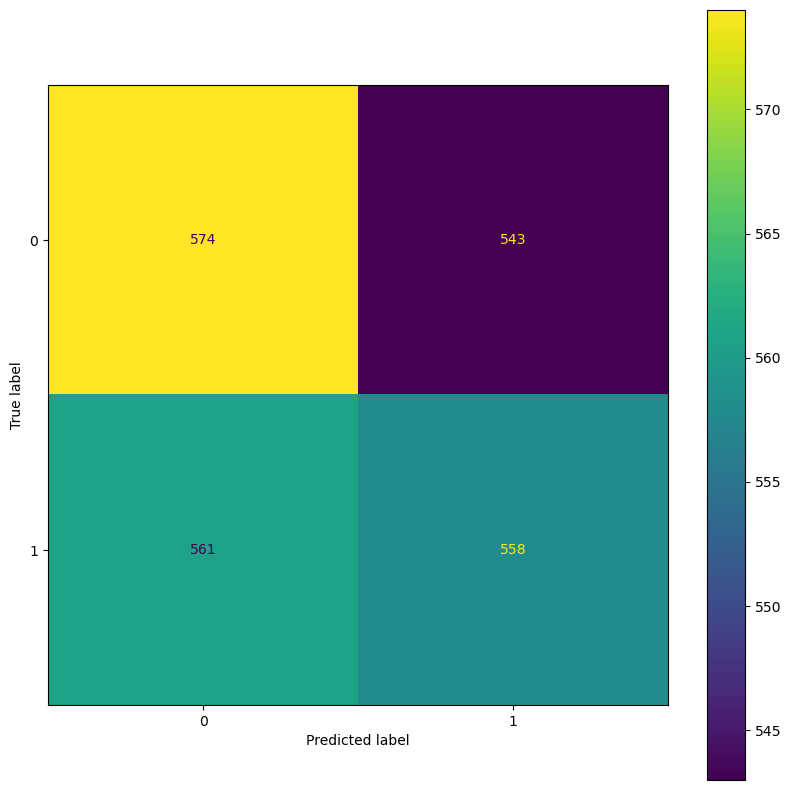

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
conf_matrix = confusion_matrix(y_true, y_pred_BM)
ConfusionMatrixDisplay(conf_matrix).plot(ax=ax)
print(classification_report(y_true, y_pred_BM, digits=6))

## Performance of Normal Fine Tuned Model

In [31]:
model_predictions_FT = batch_predict(model_wrapper, test_text_list, batch_size=64)

100%|██████████| 35/35 [00:04<00:00,  7.06it/s]


In [32]:
y_pred_prob_FT = model_predictions_FT.flatten()
y_pred_FT = [0 if x < threshold else 1 for x in y_pred_prob_FT]

              precision    recall  f1-score   support

           0   0.929856  0.925694  0.927770      1117
           1   0.926157  0.930295  0.928221      1119

    accuracy                       0.927996      2236
   macro avg   0.928006  0.927994  0.927996      2236
weighted avg   0.928005  0.927996  0.927996      2236



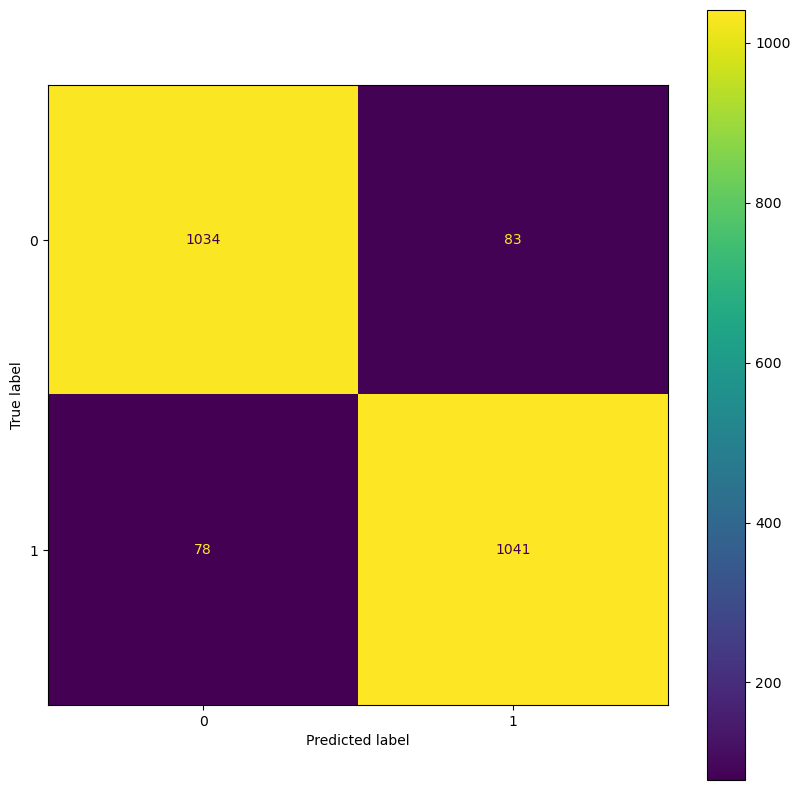

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))
conf_matrix = confusion_matrix(y_true, y_pred_FT)
ConfusionMatrixDisplay(conf_matrix).plot(ax=ax)
print(classification_report(y_true, y_pred_FT, digits=6))

## Performance of Adversarial Trained Model

In [34]:
model_predictions_AT = batch_predict(model_wrapper_AT, test_text_list, batch_size=64)

100%|██████████| 35/35 [00:05<00:00,  6.97it/s]


              precision    recall  f1-score   support

           0   0.925561  0.923903  0.924731      1117
           1   0.924175  0.925827  0.925000      1119

    accuracy                       0.924866      2236
   macro avg   0.924868  0.924865  0.924866      2236
weighted avg   0.924867  0.924866  0.924866      2236



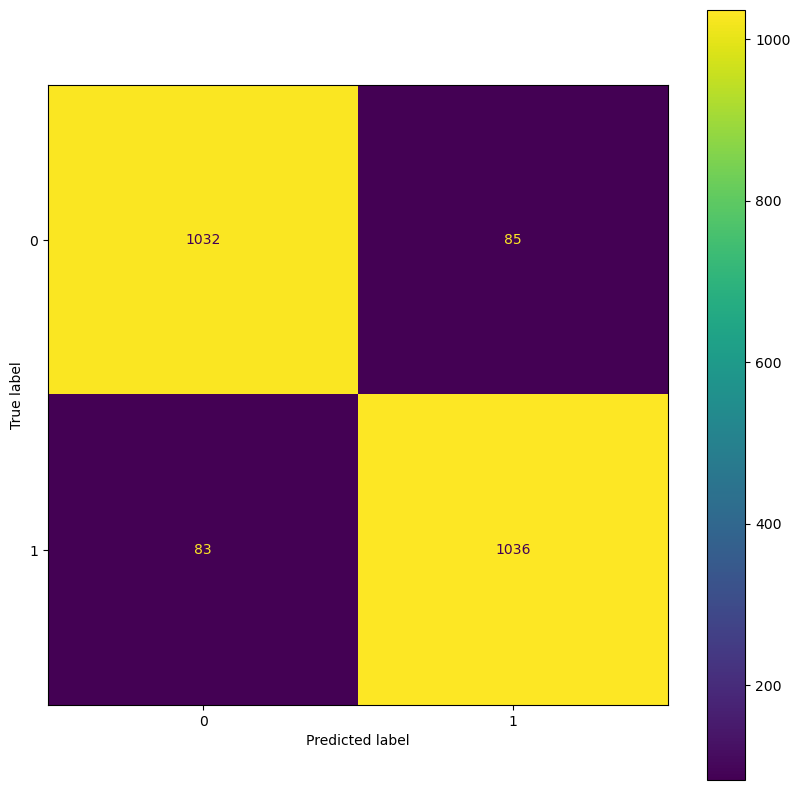

In [38]:
y_pred_prob_AT = model_predictions_AT.flatten()
y_pred_AT = [0 if x < threshold else 1 for x in y_pred_prob_AT]

fig, ax = plt.subplots(figsize=(10, 10))
conf_matrix = confusion_matrix(y_true, y_pred_AT)
ConfusionMatrixDisplay(conf_matrix).plot(ax=ax)
print(classification_report(y_true, y_pred_AT, digits=6))